## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1 - Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from calibrator import CameraCalibrator
%matplotlib inline

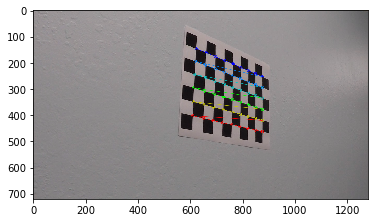

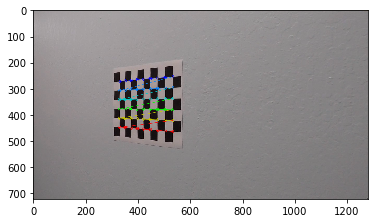

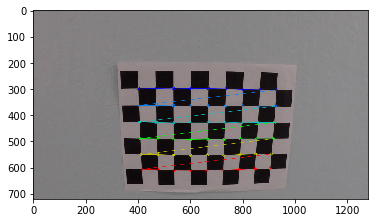

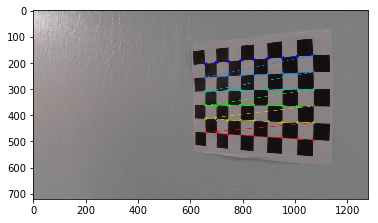

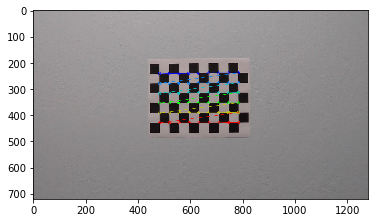

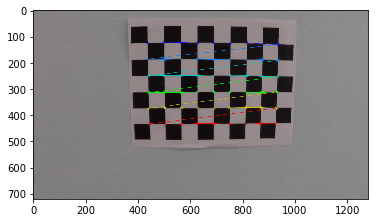

not found


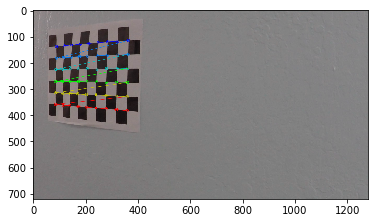

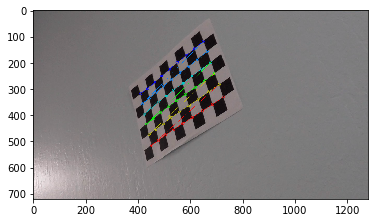

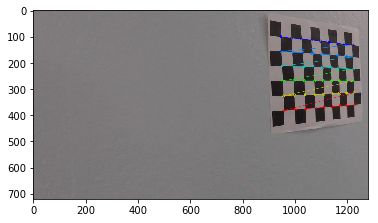

not found


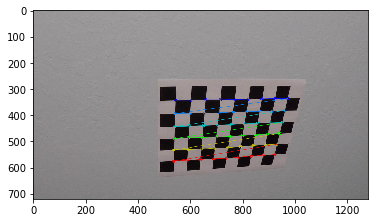

not found


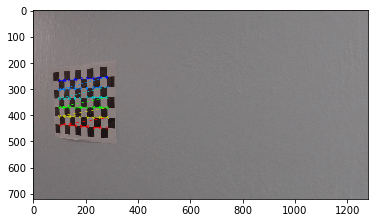

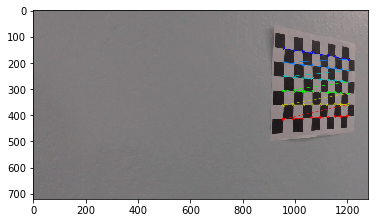

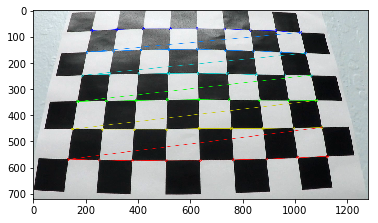

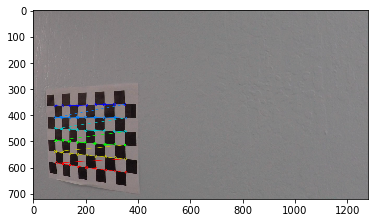

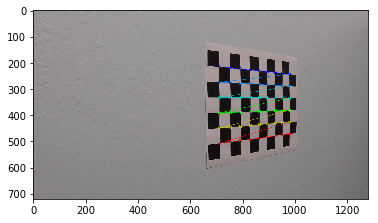

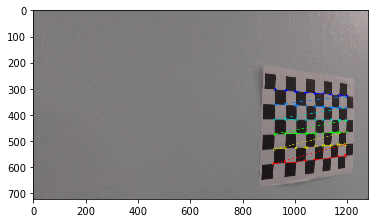

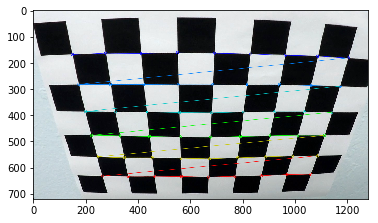

In [2]:
""" Create a camera calibrator instance using chessboard images """

def load_calibration_images():
    return glob.glob('camera_cal/calibration*.jpg')

camera_calibrator = CameraCalibrator(load_calibration_images())

## Step2 - Apply a distortion correction to raw images.

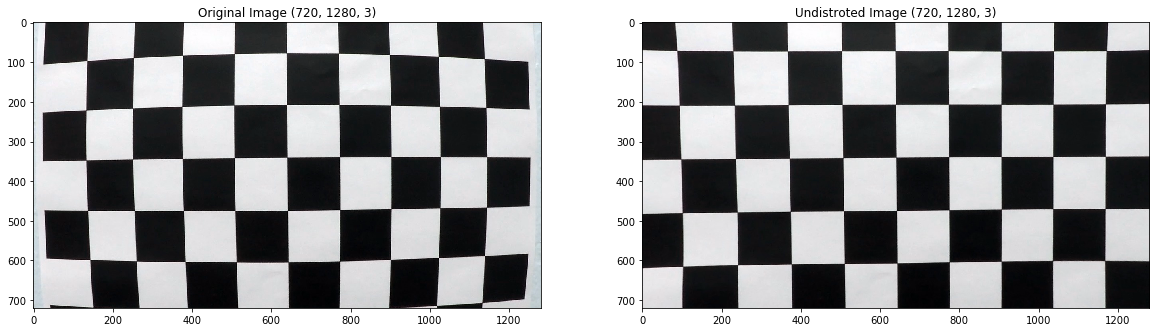

In [3]:
original_img = cv2.imread('camera_cal/calibration1.jpg')
undistorted_img = camera_calibrator.undistort(original_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Original Image {}'.format(original_img.shape))
ax1.imshow(original_img)
ax2.set_title('Undistroted Image {}'.format(undistorted_img.shape))
ax2.imshow(undistorted_img)

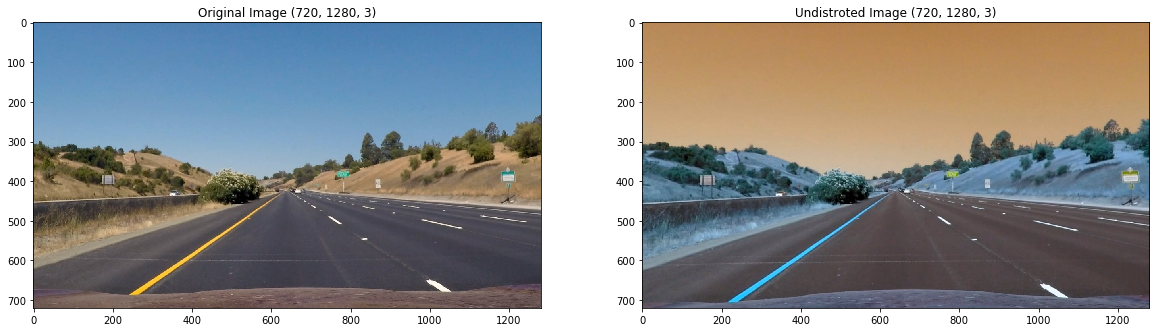

In [4]:
original_img = cv2.imread('test_images/straight_lines1.jpg')
undistorted_img = camera_calibrator.undistort(original_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

original_img=cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
ax1.set_title('Original Image {}'.format(original_img.shape))
ax1.imshow(original_img)
ax2.set_title('Undistroted Image {}'.format(undistorted_img.shape))
ax2.imshow(undistorted_img)

## Step3 - Use color transforms, gradients, etc., to create a thresholded binary image.

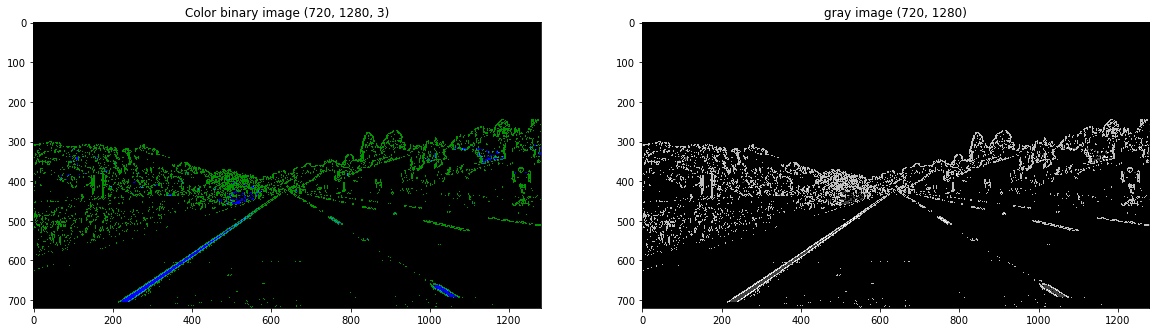

In [5]:
def pipeline(img):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abssx = np.absolute(sobelx) # Absolute x derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssx)/255 # Will use this to scale back to 8-bit scale
    abssx = (abssx/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold x gradient
    retval, sxbinary = cv2.threshold(abssx, 15, 150, cv2.THRESH_BINARY)
    # Threshold color channel
    retval, s_binary = cv2.threshold(s.astype('uint8'), 175, 255, cv2.THRESH_BINARY)

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    
    return color_binary

#hls_binary = hls_select(undistorted_img, thresh=(200, 255))   
#create_threshholded_binary_image(undistorted_img)
binary_img = pipeline(undistorted_img)
gray_img = cv2.cvtColor(binary_img, cv2.COLOR_RGB2GRAY)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title('Color binary image {}'.format(binary_img.shape))
ax1.imshow(binary_img)

ax2.set_title('gray image {}'.format(gray_img.shape))
ax2.imshow(gray_img, cmap='gray')

## Step4 - Apply a perspective transform to rectify binary image ("birds-eye view").

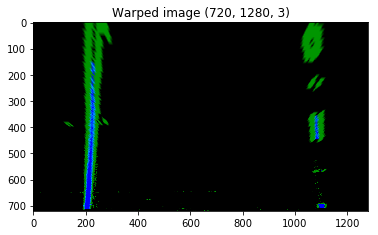

In [6]:
""" Helper methods"""
def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (255,0, 0))

def calc_warp_points(img_height, img_width, x_offset, x_center_offset, y):
    
    xcenter = img_width / 2
    
    src = np.float32([(x_offset, img_height), (xcenter - x_center_offset, y), 
                     (xcenter + x_center_offset, y), (img_width - x_offset, img_height)])
    
    dst = np.float32(
        [(x_offset, img_height), (x_offset,0),
         (img_width - x_offset, 0), (img_width - x_offset, img_height)])
        
    return src, dst

def apply_perspective_tranform(undistorted, x_offset, x_center_offset, y):
    img = np.array(undistorted)
    src, dst = calc_warp_points(img.shape[0], img.shape[1], x_offset, x_center_offset, y)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    #draw_lines(img, src)
    
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
    
    
@interact
def apply_perspective_tranform_test(undistorted=fixed(binary_img), x_offset:(0, 250)=127, \
                                   x_center_offset:(0, 100)=72, y:(0, 600)=459):

    binary_warped, _, _ = apply_perspective_tranform(undistorted, x_offset, x_center_offset, y)
    
    plt.figure()
    plt.title('Warped image {}'.format(binary_warped.shape))
    plt.imshow(binary_warped, cmap='gray')


In [7]:
color_warped, M, Minv = apply_perspective_tranform(binary_img, 127, 72, 459)
warped =  cv2.cvtColor(color_warped, cv2.COLOR_RGB2GRAY)


## Step5 - Detect lane pixels and fit to find the lane boundary.

[(215.0, 1096.0), (217.0, 1093.0), (219.0, 1096.0), (223.0, 1083.0), (226.0, 1084.0), (226.0, 1071.0), (227.0, 1082.0), (229.0, 1060.0), (228.0, 1073.0)]


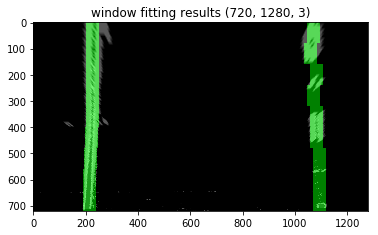

In [8]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

def test_window_centroid(wc, warped_img):
    # If we found any window centers
    if len(wc) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped_img)
        r_points = np.zeros_like(warped_img)

        # Go through each level and draw the windows 	
        for level in range(0,len(wc)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped_img,wc[level][0],level)
            r_mask = window_mask(window_width,window_height,warped_img,wc[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped_img,warped_img,warped_img)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped_img,warped_img,warped_img)),np.uint8)
    return output

print(window_centroids)
    
output = test_window_centroid(window_centroids, warped)    
# Display the final results
plt.imshow(output)
plt.title('window fitting results {}'.format(output.shape))
plt.show()


In [9]:
## Step6 - Determine the curvature of the lane and vehicle position with respect to center.

In [110]:
def polyfitLanes(window_centroids):
    leftx = np.array([])
    rightx = np.array([])
    for level in range(0,len(window_centroids)):
        for i in range(window_height):
            leftx = np.append(leftx, window_centroids[level][0])
            rightx = np.append(rightx, window_centroids[level][1])
    # Fit a second order polynomial to pixel positions in each fake lane line

    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])    

    return left_fitx, right_fitx, ploty, left_curverad, right_curverad

left_fitx, right_fitx, ploty, left_curverad, right_curverad = polyfitLanes(window_centroids)

In [114]:
def polyfitLanes2(_centroids_tracker):
    leftx = np.array([])
    rightx = np.array([])
    len_centroid_tracker = len(_centroids_tracker)
    for level in range(0,len(_centroids_tracker[0])):
        for i in range(window_height):
            leftx_sum = 0.0
            righty_sum = 0.0
            for j in range(len_centroid_tracker):
                leftx_sum += _centroids_tracker[j][level][0]
                righty_sum += _centroids_tracker[j][level][1]
            leftx = np.append(leftx, leftx_sum/len_centroid_tracker)
            rightx = np.append(rightx, righty_sum/len_centroid_tracker)
                
    # Fit a second order polynomial to pixel positions in each fake lane line

    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])    

    return left_fitx, right_fitx, ploty, left_curverad, right_curverad
#len(_centroids_tracker)
left_fitx, right_fitx, ploty, left_curverad, right_curverad = polyfitLanes2(_centroids_tracker)

In [53]:
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
#pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
#pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(color_warp, np.int_([pts_left]), (0,255, 0))
#plt.imshow(color_warp)
# print(left_fitx[0:10])
# print(ploty[0:30])
# print(left_fitx.shape)
# print(warp_zero.shape)

for level in range(0,len(window_centroids)):
    start = window_height * level
    end = start + window_height
    print(start, end)
    print(np.median(left_fitx[start:end]))
    window_centroids[level] = (np.median(left_fitx[start:end]), np.median(right_fitx[start:end]))

0 80
228.545786538
80 160
228.171463337
160 240
227.400855259
240 320
226.233962305
320 400
224.670784473
400 480
222.711321764
480 560
220.355574179
560 640
217.603541717
640 720
214.455224378


## Step7 - Warp the detected lane boundaries back onto the original image.

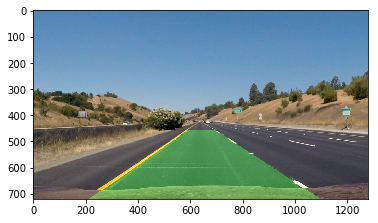

In [77]:
def overlayWarpedImageToOriginalImage(warped, original_img, left_fitx, right_fitx, ploty):
    image = original_img

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)

    return result
    
overlay_img = overlayWarpedImageToOriginalImage(warped, original_img, left_fitx, right_fitx, ploty)
#overlay_img = overlayWarpedImageToOriginalImage(warped, original_img, left_fit_cr, right_fit_cr, ploty)
plt.imshow(overlay_img)

## Image Processing Pipeline

In [108]:
# Global constant
_prev_centroids = None
_centroids_tracker = [] # motion tracker
TRACKER_SIZE = 1
CENTROID_TOLERANCE = 80.0

def create_master_view(mainScreen, screen1, screen2, screen3):
    # middle panel text example
    # using cv2 for drawing text in diagnostic pipeline.
    font = cv2.FONT_HERSHEY_COMPLEX
    middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
    cv2.putText(middlepanel, 'Estimated lane curvature: ERROR!', (30, 60), font, 1, (255,0,0), 2)
    cv2.putText(middlepanel, 'Estimated Meters right of center: ERROR!', (30, 90), font, 1, (255,0,0), 2)


    # assemble the screen example
    canvas = np.zeros((1080, 1920, 3), dtype=np.uint8)
    canvas[0:720, 0:1280] = mainScreen
    canvas[0:360, 1280:1760] = cv2.resize(screen1, (480,360), interpolation=cv2.INTER_AREA) 
    canvas[360:720, 1280:1760] = cv2.resize(screen2, (480,360), interpolation=cv2.INTER_AREA)
    canvas[720:1080, 1280:1760] = cv2.resize(screen3, (480,360), interpolation=cv2.INTER_AREA)
    canvas[720:840, 0:1280] = middlepanel
    return canvas

# Reposition centroids using on the fit curve
def augment_centroids(centroids):
    new_centroids = np.zeros_like(centroids)
    for level in range(0,len(centroids)):
        start = window_height * level
        end = start + window_height
        new_centroids[level] = (np.median(left_fitx[start:end]), np.median(right_fitx[start:end]))
    return new_centroids

# Filter out centroids that are out of the tolerance range, and use the previous centroids instead.
def correct_centroids(prev, cur):
    if prev is None: return cur
    for level in range(0,len(cur)):
        print('centroids', prev[level], cur[level])
        cur_left = cur[level][0]
        cur_right = cur[level][1]
        if abs(prev[level][0] - cur[level][0]) > CENTROID_TOLERANCE:
            print('adjusting left ... prev: {}, cur: {}'.format(prev[level][0], cur[level][0]))
            cur_left = prev[level][0]
        if abs(prev[level][1] - cur[level][1]) > CENTROID_TOLERANCE:
            print('adjusting right ... prev: {}, cur: {}'.format(prev[level][1], cur[level][1]))
            cur_right = prev[level][1]
        cur[level] = (cur_left, cur_right)
    return cur

def process_frame(frame_img, debug=False):
    global _prev_centroids
    
    # Step1: Undistort image using the camera calibration
    undistorted_img = camera_calibrator.undistort(frame_img)
    
    # Step2: Use color transforms, gradients, etc., to create a thresholded binary image 
    binary_img = pipeline(undistorted_img)
    
    # Step3: Apply perspective transformation to create a warped image
    color_warped, M, Minv = apply_perspective_tranform(binary_img, 127, 72, 459)
    warped =  cv2.cvtColor(color_warped, cv2.COLOR_RGB2GRAY)

    # Step4: Get the sliding window polynomials for the left and right line
    # Store the centroids and adjust the centroids based on the history
    #if _prev_centroids is None:
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    _centroids_tracker.insert(0, window_centroids)    
    #else:
    #    window_centroids = _prev_centroids
    window_centroids = correct_centroids(_prev_centroids, window_centroids)
    #left_fitx, right_fitx, ploty, left_curverad, right_curverad = polyfitLanes(window_centroids)
    left_fitx, right_fitx, ploty, left_curverad, right_curverad = polyfitLanes2(_centroids_tracker)
#    print(left_curverad, right_curverad)
    
    debug_peak = test_window_centroid(window_centroids, warped)
    
    # Step5: Overlay the warped image to the original image
    overlay = overlayWarpedImageToOriginalImage(warped, frame_img, left_fitx, right_fitx, ploty)
    
    _prev_centroids = window_centroids #augment_centroids(window_centroids)
    if len(_centroids_tracker) > TRACKER_SIZE:
        _centroids_tracker.pop
    return create_master_view(overlay, binary_img, color_warped, debug_peak)

## Test

In [84]:
def load_test_video(file_name='project_video.mp4'):
    images=[]
    count=0
    
    def convert_frame(img):
        nonlocal count
        #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        f="%s - %d" % (file_name, count)
        count += 1
        return (f,img)
    
    clip = VideoFileClip(file_name)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]
    
    return images

In [69]:
images = load_test_video()


100%|█████████▉| 1260/1261 [00:05<00:00, 251.30it/s]

526.7090083 819.790366523


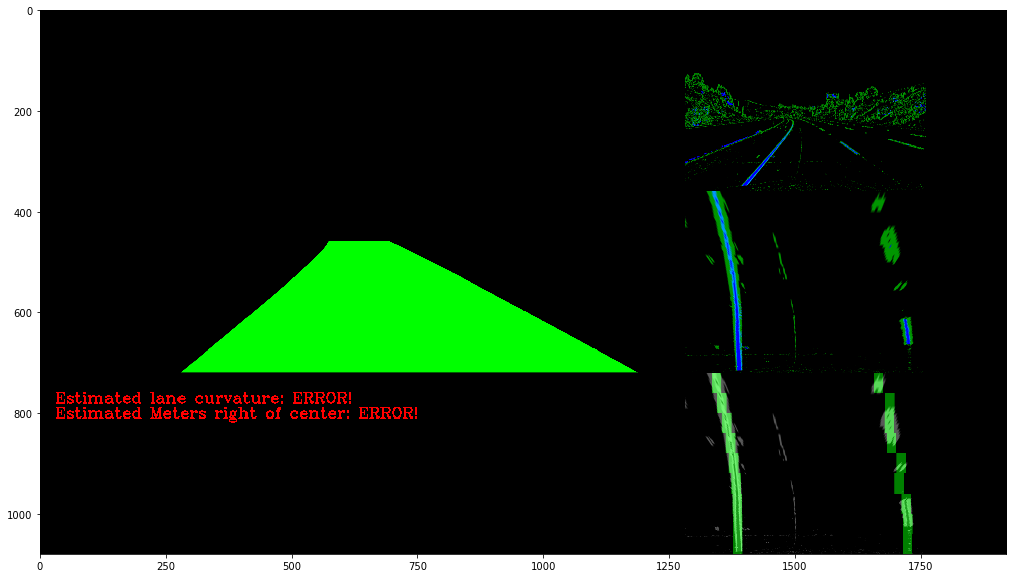

In [55]:

@interact
def testVideoImages(images=fixed(images), i:(0, len(images) - 1)=0):
    file, original_img = images[i]
    output = process_frame(original_img)
    plt.figure(figsize=(20,10))
    plt.imshow(output)


## Step8 - Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [119]:
def processVideo(intput_file_name='project_video.mp4', output_file_name='project_video_result.mp4'):
    _centroids_tracker = []
    _prev_centroids = None
    
    clip2 = VideoFileClip(intput_file_name)
    #clip2.subclip(frame_start=5, frame_end=15).speedx(2) # works
    yellow_clip = clip2.fl_image(process_frame)
    %time yellow_clip.write_videofile(output_file_name, audio=False)
    
processVideo('project_video.mp4', 'project_video_result.mp4')

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]

centroids (280.0, 1180.0) (280.0, 1180.0)
centroids (280.0, 1182.0) (280.0, 1182.0)
centroids (277.0, 1173.0) (277.0, 1173.0)
centroids (271.0, 1135.0) (271.0, 1135.0)
centroids (259.0, 1146.0) (259.0, 1146.0)
centroids (243.0, 1095.0) (243.0, 1095.0)
centroids (222.0, 1083.0) (222.0, 1083.0)
centroids (198.0, 1086.0) (198.0, 1086.0)
centroids (170.0, 1025.0) (170.0, 1025.0)





  0%|          | 2/1261 [00:00<02:06,  9.97it/s]

centroids (280.0, 1180.0) (283.0, 1180.0)
centroids (280.0, 1182.0) (282.0, 1181.0)
centroids (277.0, 1173.0) (280.0, 1172.0)
centroids (271.0, 1135.0) (273.0, 1141.0)
centroids (259.0, 1146.0) (262.0, 1157.0)
centroids (243.0, 1095.0) (246.0, 1099.0)
centroids (222.0, 1083.0) (223.0, 1089.0)
centroids (198.0, 1086.0) (198.0, 1022.0)
centroids (170.0, 1025.0) (168.0, 1040.0)





  0%|          | 3/1261 [00:00<02:09,  9.73it/s]

centroids (283.0, 1180.0) (285.0, 1182.0)
centroids (282.0, 1181.0) (285.0, 1180.0)
centroids (280.0, 1172.0) (281.0, 1168.0)
centroids (273.0, 1141.0) (274.0, 1148.0)
centroids (262.0, 1157.0) (263.0, 1104.0)
centroids (246.0, 1099.0) (246.0, 1097.0)
centroids (223.0, 1089.0) (223.0, 1092.0)
centroids (198.0, 1022.0) (200.0, 1035.0)
centroids (168.0, 1040.0) (169.0, 967.0)





  0%|          | 4/1261 [00:00<02:13,  9.41it/s]

centroids (285.0, 1182.0) (287.0, 1186.0)
centroids (285.0, 1180.0) (287.0, 1182.0)
centroids (281.0, 1168.0) (283.0, 1082.0)
adjusting right ... prev: 1168.0, cur: 1082.0
centroids (274.0, 1148.0) (275.0, 1151.0)
centroids (263.0, 1104.0) (262.0, 1110.0)
centroids (246.0, 1097.0) (245.0, 1099.0)
centroids (223.0, 1092.0) (223.0, 1028.0)
centroids (200.0, 1035.0) (199.0, 1041.0)
centroids (169.0, 967.0) (165.0, 972.0)





  0%|          | 5/1261 [00:00<02:15,  9.26it/s]

centroids (287.0, 1186.0) (287.0, 1189.0)
centroids (287.0, 1182.0) (288.0, 1183.0)
centroids (283.0, 1168.0) (283.0, 1159.0)
centroids (275.0, 1151.0) (276.0, 1059.0)
adjusting right ... prev: 1151.0, cur: 1059.0
centroids (262.0, 1110.0) (263.0, 1116.0)
centroids (245.0, 1099.0) (244.0, 1104.0)
centroids (223.0, 1028.0) (225.0, 1045.0)
centroids (199.0, 1041.0) (197.0, 977.0)
centroids (165.0, 972.0) (165.0, 984.0)





  0%|          | 6/1261 [00:00<02:19,  9.02it/s]

centroids (287.0, 1189.0) (288.0, 1190.0)
centroids (288.0, 1183.0) (289.0, 1181.0)
centroids (283.0, 1159.0) (284.0, 1164.0)
centroids (276.0, 1151.0) (277.0, 1123.0)
centroids (263.0, 1116.0) (263.0, 1115.0)
centroids (244.0, 1104.0) (245.0, 1109.0)
centroids (225.0, 1045.0) (224.0, 1052.0)
centroids (197.0, 977.0) (194.0, 990.0)
centroids (165.0, 984.0) (163.0, 984.0)





  1%|          | 7/1261 [00:00<02:22,  8.83it/s]

centroids (288.0, 1190.0) (288.0, 1190.0)
centroids (289.0, 1181.0) (288.0, 1169.0)
centroids (284.0, 1164.0) (284.0, 1172.0)
centroids (277.0, 1123.0) (275.0, 1133.0)
centroids (263.0, 1115.0) (259.0, 1120.0)
centroids (245.0, 1109.0) (242.0, 1055.0)
centroids (224.0, 1052.0) (220.0, 1065.0)
centroids (194.0, 990.0) (188.0, 1003.0)
centroids (163.0, 984.0) (160.0, 987.0)





  1%|          | 8/1261 [00:00<02:23,  8.76it/s]

centroids (288.0, 1190.0) (290.0, 1177.0)
centroids (288.0, 1169.0) (292.0, 1173.0)
centroids (284.0, 1172.0) (286.0, 1073.0)
adjusting right ... prev: 1172.0, cur: 1073.0
centroids (275.0, 1133.0) (277.0, 1134.0)
centroids (259.0, 1120.0) (261.0, 1120.0)
centroids (242.0, 1055.0) (243.0, 1067.0)
centroids (220.0, 1065.0) (219.0, 1006.0)
centroids (188.0, 1003.0) (190.0, 1012.0)
centroids (160.0, 987.0) (160.0, 998.0)





  1%|          | 9/1261 [00:00<02:21,  8.86it/s]

centroids (290.0, 1177.0) (288.0, 1181.0)
centroids (292.0, 1173.0) (289.0, 1181.0)
centroids (286.0, 1172.0) (284.0, 1147.0)
centroids (277.0, 1134.0) (274.0, 1140.0)
centroids (261.0, 1120.0) (257.0, 1129.0)
centroids (243.0, 1067.0) (240.0, 1078.0)
centroids (219.0, 1006.0) (215.0, 1024.0)
centroids (190.0, 1012.0) (186.0, 1017.0)
centroids (160.0, 998.0) (157.0, 1010.0)





  1%|          | 10/1261 [00:01<02:19,  8.97it/s]

centroids (288.0, 1181.0) (287.0, 1186.0)
centroids (289.0, 1181.0) (288.0, 1186.0)
centroids (284.0, 1147.0) (282.0, 1154.0)
centroids (274.0, 1140.0) (271.0, 1140.0)
centroids (257.0, 1129.0) (256.0, 1040.0)
adjusting right ... prev: 1129.0, cur: 1040.0
centroids (240.0, 1078.0) (237.0, 1085.0)
centroids (215.0, 1024.0) (208.0, 1033.0)
centroids (186.0, 1017.0) (182.0, 1019.0)
centroids (157.0, 1010.0) (155.0, 1025.0)





  1%|          | 11/1261 [00:01<02:16,  9.13it/s]

centroids (287.0, 1186.0) (289.0, 1163.0)
centroids (288.0, 1186.0) (289.0, 1063.0)
adjusting right ... prev: 1186.0, cur: 1063.0
centroids (282.0, 1154.0) (282.0, 1155.0)
centroids (271.0, 1140.0) (270.0, 1141.0)
centroids (256.0, 1129.0) (255.0, 1088.0)
centroids (237.0, 1085.0) (233.0, 1101.0)
centroids (208.0, 1033.0) (207.0, 1037.0)
centroids (182.0, 1019.0) (181.0, 1022.0)
centroids (155.0, 1025.0) (153.0, 960.0)





  1%|          | 12/1261 [00:01<02:13,  9.36it/s]

centroids (289.0, 1163.0) (283.0, 1172.0)
centroids (289.0, 1186.0) (284.0, 1173.0)
centroids (282.0, 1155.0) (276.0, 1165.0)
centroids (270.0, 1141.0) (263.0, 1154.0)
centroids (255.0, 1088.0) (246.0, 1108.0)
centroids (233.0, 1101.0) (227.0, 1052.0)
centroids (207.0, 1037.0) (199.0, 1060.0)
centroids (181.0, 1022.0) (172.0, 1046.0)
centroids (153.0, 960.0) (142.0, 983.0)





  1%|          | 13/1261 [00:01<02:26,  8.51it/s]

centroids (283.0, 1172.0) (284.0, 1172.0)
centroids (284.0, 1173.0) (284.0, 1174.0)
centroids (276.0, 1165.0) (275.0, 1163.0)
centroids (263.0, 1154.0) (263.0, 1156.0)
centroids (246.0, 1108.0) (245.0, 1114.0)
centroids (227.0, 1052.0) (224.0, 1064.0)
centroids (199.0, 1060.0) (198.0, 1056.0)
centroids (172.0, 1046.0) (172.0, 1052.0)
centroids (142.0, 983.0) (144.0, 991.0)


centroids (284.0, 1172.0) (284.0, 1174.0)
centroids (284.0, 1174.0) (284.0, 1176.0)
centroids (275.0, 1163.0) (274.0, 1165.0)
centroids (263.0, 1156.0) (262.0, 1113.0)
centroids (245.0, 1114.0) (245.0, 1125.0)
centroids (224.0, 1064.0) (219.0, 1071.0)
centroids (198.0, 1056.0) (195.0, 1059.0)
centroids (172.0, 1052.0) (171.0, 990.0)
centroids (144.0, 991.0) (143.0, 1006.0)





  1%|          | 14/1261 [00:01<02:50,  7.32it/s]

centroids (284.0, 1174.0) (285.0, 1172.0)
centroids (284.0, 1176.0) (285.0, 1171.0)
centroids (274.0, 1165.0) (277.0, 1161.0)
centroids (262.0, 1113.0) (264.0, 1119.0)
centroids (245.0, 1125.0) (247.0, 1069.0)
centroids (219.0, 1071.0) (223.0, 1067.0)
centroids (195.0, 1059.0) (200.0, 1054.0)
centroids (171.0, 990.0) (174.0, 1001.0)
centroids (143.0, 1006.0) (146.0, 929.0)





  1%|          | 15/1261 [00:01<02:47,  7.45it/s]


  1%|▏         | 16/1261 [00:01<02:36,  7.95it/s]

centroids (285.0, 1172.0) (285.0, 1172.0)
centroids (285.0, 1171.0) (286.0, 1167.0)
centroids (277.0, 1161.0) (278.0, 1067.0)
adjusting right ... prev: 1161.0, cur: 1067.0
centroids (264.0, 1119.0) (264.0, 1119.0)
centroids (247.0, 1069.0) (247.0, 1072.0)
centroids (223.0, 1067.0) (224.0, 1056.0)
centroids (200.0, 1054.0) (202.0, 990.0)
centroids (174.0, 1001.0) (177.0, 1005.0)
centroids (146.0, 929.0) (152.0, 934.0)





  1%|▏         | 17/1261 [00:01<02:32,  8.18it/s]

centroids (285.0, 1172.0) (285.0, 1176.0)
centroids (286.0, 1167.0) (285.0, 1168.0)
centroids (278.0, 1161.0) (276.0, 1125.0)
centroids (264.0, 1119.0) (263.0, 1136.0)
centroids (247.0, 1072.0) (244.0, 1078.0)
centroids (224.0, 1056.0) (223.0, 1063.0)
centroids (202.0, 990.0) (200.0, 1009.0)
centroids (177.0, 1005.0) (176.0, 945.0)
centroids (152.0, 934.0) (145.0, 948.0)





  1%|▏         | 18/1261 [00:02<02:30,  8.28it/s]

centroids (285.0, 1176.0) (286.0, 1176.0)
centroids (285.0, 1168.0) (287.0, 1170.0)
centroids (276.0, 1125.0) (275.0, 1131.0)
centroids (263.0, 1136.0) (262.0, 1085.0)
centroids (244.0, 1078.0) (243.0, 1079.0)
centroids (223.0, 1063.0) (224.0, 1070.0)
centroids (200.0, 1009.0) (200.0, 1019.0)
centroids (176.0, 945.0) (178.0, 952.0)
centroids (145.0, 948.0) (145.0, 931.0)





  2%|▏         | 19/1261 [00:02<02:24,  8.57it/s]

centroids (286.0, 1176.0) (283.0, 1179.0)
centroids (287.0, 1170.0) (285.0, 1160.0)
centroids (275.0, 1131.0) (271.0, 1143.0)
centroids (262.0, 1085.0) (258.0, 1099.0)
centroids (243.0, 1079.0) (239.0, 1086.0)
centroids (224.0, 1070.0) (220.0, 1089.0)
centroids (200.0, 1019.0) (199.0, 1036.0)
centroids (178.0, 952.0) (172.0, 969.0)
centroids (145.0, 931.0) (143.0, 951.0)





  2%|▏         | 20/1261 [00:02<02:22,  8.69it/s]

centroids (283.0, 1179.0) (280.0, 1179.0)
centroids (285.0, 1160.0) (281.0, 1151.0)
centroids (271.0, 1143.0) (268.0, 1157.0)
centroids (258.0, 1099.0) (253.0, 1108.0)
centroids (239.0, 1086.0) (236.0, 1095.0)
centroids (220.0, 1089.0) (216.0, 1040.0)
centroids (199.0, 1036.0) (197.0, 1052.0)
centroids (172.0, 969.0) (171.0, 984.0)
centroids (143.0, 951.0) (139.0, 963.0)





  2%|▏         | 21/1261 [00:02<02:22,  8.68it/s]

centroids (280.0, 1179.0) (279.0, 1164.0)
centroids (281.0, 1151.0) (277.0, 1160.0)
centroids (268.0, 1157.0) (265.0, 1080.0)
centroids (253.0, 1108.0) (249.0, 1119.0)
centroids (236.0, 1095.0) (232.0, 1106.0)
centroids (216.0, 1040.0) (212.0, 1058.0)
centroids (197.0, 1052.0) (191.0, 1076.0)
centroids (171.0, 984.0) (166.0, 1002.0)
centroids (139.0, 963.0) (137.0, 980.0)





  2%|▏         | 22/1261 [00:02<02:20,  8.80it/s]

centroids (279.0, 1164.0) (277.0, 1171.0)
centroids (277.0, 1160.0) (273.0, 1170.0)
centroids (265.0, 1080.0) (261.0, 1136.0)
centroids (249.0, 1119.0) (244.0, 1127.0)
centroids (232.0, 1106.0) (227.0, 1120.0)
centroids (212.0, 1058.0) (209.0, 1078.0)
centroids (191.0, 1076.0) (187.0, 1016.0)
centroids (166.0, 1002.0) (161.0, 1017.0)
centroids (137.0, 980.0) (133.0, 1000.0)





  2%|▏         | 23/1261 [00:02<02:20,  8.84it/s]

centroids (277.0, 1171.0) (273.0, 1176.0)
centroids (273.0, 1170.0) (269.0, 1152.0)
centroids (261.0, 1136.0) (257.0, 1144.0)
centroids (244.0, 1127.0) (240.0, 1133.0)
centroids (227.0, 1120.0) (225.0, 1033.0)
adjusting right ... prev: 1120.0, cur: 1033.0
centroids (209.0, 1078.0) (203.0, 1093.0)
centroids (187.0, 1016.0) (185.0, 1033.0)
centroids (161.0, 1017.0) (158.0, 1022.0)
centroids (133.0, 1000.0) (130.0, 1016.0)





  2%|▏         | 24/1261 [00:02<02:20,  8.79it/s]

centroids (273.0, 1176.0) (271.0, 1151.0)
centroids (269.0, 1152.0) (268.0, 1108.0)
centroids (257.0, 1144.0) (255.0, 1145.0)
centroids (240.0, 1133.0) (241.0, 1134.0)
centroids (225.0, 1120.0) (226.0, 1091.0)
centroids (203.0, 1093.0) (208.0, 1106.0)
centroids (185.0, 1033.0) (189.0, 1038.0)
centroids (158.0, 1022.0) (161.0, 1024.0)
centroids (130.0, 1016.0) (133.0, 952.0)





  2%|▏         | 25/1261 [00:02<02:20,  8.77it/s]

centroids (271.0, 1151.0) (270.0, 1153.0)
centroids (268.0, 1108.0) (267.0, 1155.0)
centroids (255.0, 1145.0) (255.0, 1145.0)
centroids (241.0, 1134.0) (242.0, 1140.0)
centroids (226.0, 1091.0) (229.0, 1105.0)
centroids (208.0, 1106.0) (212.0, 1045.0)
centroids (189.0, 1038.0) (189.0, 1046.0)
centroids (161.0, 1024.0) (163.0, 1029.0)
centroids (133.0, 952.0) (134.0, 971.0)


centroids (270.0, 1153.0) (267.0, 1161.0)
centroids (267.0, 1155.0) (264.0, 1162.0)
centroids (255.0, 1145.0) (252.0, 1153.0)
centroids (242.0, 1140.0) (240.0, 1053.0)
adjusting right ... prev: 1140.0, cur: 1053.0
centroids (229.0, 1105.0) (226.0, 1113.0)
centroids (212.0, 1045.0) (206.0, 1064.0)
centroids (189.0, 1046.0) (186.0, 1057.0)
centroids (163.0, 1029.0) (162.0, 1050.0)
centroids (134.0, 971.0) (133.0, 988.0)





  2%|▏         | 26/1261 [00:03<03:02,  6.78it/s]

centroids (267.0, 1161.0) (264.0, 1166.0)
centroids (264.0, 1162.0) (261.0, 1167.0)
centroids (252.0, 1153.0) (250.0, 1158.0)
centroids (240.0, 1140.0) (240.0, 1120.0)
centroids (226.0, 1113.0) (226.0, 1135.0)
centroids (206.0, 1064.0) (207.0, 1075.0)
centroids (186.0, 1057.0) (187.0, 1062.0)
centroids (162.0, 1050.0) (162.0, 991.0)
centroids (133.0, 988.0) (133.0, 1009.0)





  2%|▏         | 27/1261 [00:03<02:54,  7.06it/s]


  2%|▏         | 28/1261 [00:03<02:42,  7.58it/s]

centroids (264.0, 1166.0) (261.0, 1173.0)
centroids (261.0, 1167.0) (256.0, 1173.0)
centroids (250.0, 1158.0) (247.0, 1169.0)
centroids (240.0, 1120.0) (236.0, 1142.0)
centroids (226.0, 1135.0) (223.0, 1042.0)
adjusting right ... prev: 1135.0, cur: 1042.0
centroids (207.0, 1075.0) (205.0, 1091.0)
centroids (187.0, 1062.0) (183.0, 1082.0)
centroids (162.0, 991.0) (158.0, 1019.0)
centroids (133.0, 1009.0) (130.0, 1034.0)





  2%|▏         | 29/1261 [00:03<02:34,  7.95it/s]

centroids (261.0, 1173.0) (260.0, 1176.0)
centroids (256.0, 1173.0) (257.0, 1174.0)
centroids (247.0, 1169.0) (250.0, 1074.0)
adjusting right ... prev: 1169.0, cur: 1074.0
centroids (236.0, 1142.0) (240.0, 1145.0)
centroids (223.0, 1135.0) (226.0, 1098.0)
centroids (205.0, 1091.0) (208.0, 1093.0)
centroids (183.0, 1082.0) (188.0, 1088.0)
centroids (158.0, 1019.0) (163.0, 1029.0)
centroids (130.0, 1034.0) (132.0, 960.0)





  2%|▏         | 30/1261 [00:03<02:34,  7.95it/s]

centroids (260.0, 1176.0) (260.0, 1177.0)
centroids (257.0, 1174.0) (260.0, 1174.0)
centroids (250.0, 1169.0) (253.0, 1144.0)
centroids (240.0, 1145.0) (244.0, 1155.0)
centroids (226.0, 1098.0) (230.0, 1103.0)
centroids (208.0, 1093.0) (213.0, 1090.0)
centroids (188.0, 1088.0) (193.0, 1022.0)
centroids (163.0, 1029.0) (167.0, 1039.0)
centroids (132.0, 960.0) (135.0, 966.0)





  2%|▏         | 31/1261 [00:03<02:33,  8.01it/s]

centroids (260.0, 1177.0) (263.0, 1179.0)
centroids (260.0, 1174.0) (261.0, 1156.0)
centroids (253.0, 1144.0) (257.0, 1153.0)
centroids (244.0, 1155.0) (248.0, 1100.0)
centroids (230.0, 1103.0) (235.0, 1106.0)
centroids (213.0, 1090.0) (218.0, 1094.0)
centroids (193.0, 1022.0) (195.0, 1042.0)
centroids (167.0, 1039.0) (170.0, 972.0)
centroids (135.0, 966.0) (139.0, 973.0)





  3%|▎         | 32/1261 [00:03<02:29,  8.23it/s]

centroids (263.0, 1179.0) (266.0, 1176.0)
centroids (261.0, 1156.0) (267.0, 1123.0)
centroids (257.0, 1153.0) (261.0, 1154.0)
centroids (248.0, 1100.0) (253.0, 1112.0)
centroids (235.0, 1106.0) (240.0, 1098.0)
centroids (218.0, 1094.0) (224.0, 1026.0)
centroids (195.0, 1042.0) (200.0, 1043.0)
centroids (170.0, 972.0) (176.0, 979.0)
centroids (139.0, 973.0) (141.0, 952.0)





  3%|▎         | 33/1261 [00:03<02:25,  8.46it/s]

centroids (266.0, 1176.0) (265.0, 1167.0)
centroids (267.0, 1123.0) (265.0, 1165.0)
centroids (261.0, 1154.0) (259.0, 1065.0)
adjusting right ... prev: 1154.0, cur: 1065.0
centroids (253.0, 1112.0) (251.0, 1124.0)
centroids (240.0, 1098.0) (237.0, 1108.0)
centroids (224.0, 1026.0) (222.0, 1052.0)
centroids (200.0, 1043.0) (199.0, 1066.0)
centroids (176.0, 979.0) (175.0, 999.0)
centroids (141.0, 952.0) (139.0, 970.0)





  3%|▎         | 34/1261 [00:04<02:21,  8.70it/s]

centroids (265.0, 1167.0) (267.0, 1170.0)
centroids (265.0, 1165.0) (268.0, 1169.0)
centroids (259.0, 1154.0) (262.0, 1122.0)
centroids (251.0, 1124.0) (254.0, 1126.0)
centroids (237.0, 1108.0) (240.0, 1114.0)
centroids (222.0, 1052.0) (224.0, 1069.0)
centroids (199.0, 1066.0) (202.0, 1003.0)
centroids (175.0, 999.0) (177.0, 1003.0)
centroids (139.0, 970.0) (140.0, 984.0)





  3%|▎         | 35/1261 [00:04<02:20,  8.75it/s]

centroids (267.0, 1170.0) (268.0, 1174.0)
centroids (268.0, 1169.0) (269.0, 1176.0)
centroids (262.0, 1122.0) (263.0, 1140.0)
centroids (254.0, 1126.0) (256.0, 1126.0)
centroids (240.0, 1114.0) (243.0, 1130.0)
centroids (224.0, 1069.0) (226.0, 1078.0)
centroids (202.0, 1003.0) (203.0, 1014.0)
centroids (177.0, 1003.0) (177.0, 998.0)
centroids (140.0, 984.0) (141.0, 996.0)





  3%|▎         | 36/1261 [00:04<02:21,  8.67it/s]

centroids (268.0, 1174.0) (272.0, 1177.0)
centroids (269.0, 1176.0) (271.0, 1077.0)
adjusting right ... prev: 1176.0, cur: 1077.0
centroids (263.0, 1140.0) (267.0, 1141.0)
centroids (256.0, 1126.0) (258.0, 1127.0)
centroids (243.0, 1130.0) (245.0, 1080.0)
centroids (226.0, 1078.0) (228.0, 1089.0)
centroids (203.0, 1014.0) (206.0, 1023.0)
centroids (177.0, 998.0) (178.0, 1002.0)
centroids (141.0, 996.0) (140.0, 930.0)





  3%|▎         | 37/1261 [00:04<02:20,  8.70it/s]

centroids (272.0, 1177.0) (273.0, 1151.0)
centroids (271.0, 1176.0) (274.0, 1146.0)
centroids (267.0, 1141.0) (268.0, 1143.0)
centroids (258.0, 1127.0) (260.0, 1130.0)
centroids (245.0, 1080.0) (247.0, 1091.0)
centroids (228.0, 1089.0) (228.0, 1031.0)
centroids (206.0, 1023.0) (206.0, 1028.0)
centroids (178.0, 1002.0) (178.0, 1012.0)
centroids (140.0, 930.0) (139.0, 943.0)





  3%|▎         | 38/1261 [00:04<02:20,  8.72it/s]

centroids (273.0, 1151.0) (276.0, 1152.0)
centroids (274.0, 1146.0) (277.0, 1155.0)
centroids (268.0, 1143.0) (270.0, 1142.0)
centroids (260.0, 1130.0) (262.0, 1143.0)
centroids (247.0, 1091.0) (249.0, 1098.0)
centroids (228.0, 1031.0) (230.0, 1041.0)
centroids (206.0, 1028.0) (206.0, 1023.0)
centroids (178.0, 1012.0) (178.0, 949.0)
centroids (139.0, 943.0) (137.0, 962.0)





  3%|▎         | 39/1261 [00:04<02:20,  8.68it/s]

centroids (276.0, 1152.0) (278.0, 1151.0)
centroids (277.0, 1155.0) (279.0, 1154.0)
centroids (270.0, 1142.0) (272.0, 1142.0)
centroids (262.0, 1143.0) (264.0, 1099.0)
centroids (249.0, 1098.0) (252.0, 1108.0)
centroids (230.0, 1041.0) (233.0, 1045.0)
centroids (206.0, 1023.0) (206.0, 1027.0)
centroids (178.0, 949.0) (178.0, 963.0)
centroids (137.0, 962.0) (136.0, 886.0)





  3%|▎         | 40/1261 [00:04<02:18,  8.82it/s]

centroids (278.0, 1151.0) (278.0, 1156.0)
centroids (279.0, 1154.0) (279.0, 1157.0)
centroids (272.0, 1142.0) (271.0, 1146.0)
centroids (264.0, 1099.0) (264.0, 1113.0)
centroids (252.0, 1108.0) (251.0, 1057.0)
centroids (233.0, 1045.0) (230.0, 1051.0)
centroids (206.0, 1027.0) (204.0, 1039.0)
centroids (178.0, 963.0) (174.0, 979.0)
centroids (136.0, 886.0) (132.0, 901.0)





  3%|▎         | 41/1261 [00:04<02:18,  8.82it/s]

centroids (278.0, 1156.0) (279.0, 1163.0)
centroids (279.0, 1157.0) (278.0, 1159.0)
centroids (271.0, 1146.0) (272.0, 1059.0)
adjusting right ... prev: 1146.0, cur: 1059.0
centroids (264.0, 1113.0) (264.0, 1119.0)
centroids (251.0, 1057.0) (250.0, 1069.0)
centroids (230.0, 1051.0) (230.0, 1051.0)
centroids (204.0, 1039.0) (203.0, 977.0)
centroids (174.0, 979.0) (169.0, 992.0)
centroids (132.0, 901.0) (132.0, 913.0)





  3%|▎         | 42/1261 [00:04<02:18,  8.78it/s]

centroids (279.0, 1163.0) (279.0, 1170.0)
centroids (278.0, 1159.0) (279.0, 1164.0)
centroids (272.0, 1146.0) (273.0, 1127.0)
centroids (264.0, 1119.0) (264.0, 1133.0)
centroids (250.0, 1069.0) (249.0, 1079.0)
centroids (230.0, 1051.0) (227.0, 1061.0)
centroids (203.0, 977.0) (201.0, 998.0)
centroids (169.0, 992.0) (167.0, 1011.0)
centroids (132.0, 913.0) (131.0, 924.0)





  3%|▎         | 43/1261 [00:05<02:22,  8.56it/s]

centroids (279.0, 1170.0) (279.0, 1174.0)
centroids (279.0, 1164.0) (279.0, 1170.0)
centroids (273.0, 1127.0) (273.0, 1139.0)
centroids (264.0, 1133.0) (264.0, 1079.0)
centroids (249.0, 1079.0) (247.0, 1087.0)
centroids (227.0, 1061.0) (226.0, 1072.0)
centroids (201.0, 998.0) (198.0, 1014.0)
centroids (167.0, 1011.0) (169.0, 940.0)
centroids (131.0, 924.0) (130.0, 920.0)





  3%|▎         | 44/1261 [00:05<02:22,  8.54it/s]

centroids (279.0, 1174.0) (277.0, 1176.0)
centroids (279.0, 1170.0) (277.0, 1130.0)
centroids (273.0, 1139.0) (271.0, 1152.0)
centroids (264.0, 1079.0) (262.0, 1107.0)
centroids (247.0, 1087.0) (245.0, 1096.0)
centroids (226.0, 1072.0) (222.0, 1088.0)
centroids (198.0, 1014.0) (195.0, 1032.0)
centroids (169.0, 940.0) (163.0, 958.0)
centroids (130.0, 920.0) (126.0, 958.0)





  4%|▎         | 45/1261 [00:05<02:22,  8.52it/s]

centroids (277.0, 1176.0) (276.0, 1177.0)
centroids (277.0, 1130.0) (277.0, 1150.0)
centroids (271.0, 1152.0) (270.0, 1160.0)
centroids (262.0, 1107.0) (260.0, 1118.0)
centroids (245.0, 1096.0) (243.0, 1102.0)
centroids (222.0, 1088.0) (220.0, 1105.0)
centroids (195.0, 1032.0) (191.0, 1049.0)
centroids (163.0, 958.0) (157.0, 976.0)
centroids (126.0, 958.0) (123.0, 950.0)





  4%|▎         | 46/1261 [00:05<02:21,  8.57it/s]

centroids (276.0, 1177.0) (277.0, 1165.0)
centroids (277.0, 1150.0) (277.0, 1165.0)
centroids (270.0, 1160.0) (270.0, 1065.0)
adjusting right ... prev: 1160.0, cur: 1065.0
centroids (260.0, 1118.0) (258.0, 1123.0)
centroids (243.0, 1102.0) (242.0, 1107.0)
centroids (220.0, 1105.0) (217.0, 1052.0)
centroids (191.0, 1049.0) (190.0, 1065.0)
centroids (157.0, 976.0) (156.0, 988.0)
centroids (123.0, 950.0) (121.0, 967.0)





  4%|▎         | 47/1261 [00:05<02:23,  8.48it/s]

centroids (277.0, 1165.0) (275.0, 1169.0)
centroids (277.0, 1165.0) (276.0, 1172.0)
centroids (270.0, 1160.0) (269.0, 1138.0)
centroids (258.0, 1123.0) (256.0, 1127.0)
centroids (242.0, 1107.0) (238.0, 1118.0)
centroids (217.0, 1052.0) (213.0, 1069.0)
centroids (190.0, 1065.0) (188.0, 1000.0)
centroids (156.0, 988.0) (154.0, 1003.0)
centroids (121.0, 967.0) (120.0, 980.0)





  4%|▍         | 48/1261 [00:05<02:25,  8.32it/s]

centroids (275.0, 1169.0) (275.0, 1169.0)
centroids (276.0, 1172.0) (275.0, 1178.0)
centroids (269.0, 1138.0) (269.0, 1141.0)
centroids (256.0, 1127.0) (255.0, 1126.0)
centroids (238.0, 1118.0) (237.0, 1026.0)
adjusting right ... prev: 1118.0, cur: 1026.0
centroids (213.0, 1069.0) (212.0, 1073.0)
centroids (188.0, 1000.0) (185.0, 1013.0)
centroids (154.0, 1003.0) (156.0, 991.0)
centroids (120.0, 980.0) (119.0, 993.0)


centroids (275.0, 1169.0) (274.0, 1154.0)
centroids (275.0, 1178.0) (273.0, 1110.0)
centroids (269.0, 1141.0) (265.0, 1148.0)
centroids (255.0, 1126.0) (252.0, 1135.0)
centroids (237.0, 1118.0) (233.0, 1083.0)
centroids (212.0, 1073.0) (208.0, 1094.0)
centroids (185.0, 1013.0) (178.0, 1030.0)
centroids (156.0, 991.0) (150.0, 1005.0)
centroids (119.0, 993.0) (114.0, 927.0)





  4%|▍         | 49/1261 [00:05<02:29,  8.13it/s]

centroids (274.0, 1154.0) (274.0, 1158.0)
centroids (273.0, 1110.0) (275.0, 1159.0)
centroids (265.0, 1148.0) (265.0, 1149.0)
centroids (252.0, 1135.0) (251.0, 1140.0)
centroids (233.0, 1083.0) (231.0, 1097.0)
centroids (208.0, 1094.0) (206.0, 1034.0)
centroids (178.0, 1030.0) (179.0, 1037.0)
centroids (150.0, 1005.0) (148.0, 1015.0)
centroids (114.0, 927.0) (114.0, 944.0)





  4%|▍         | 50/1261 [00:05<02:36,  7.72it/s]

centroids (274.0, 1158.0) (273.0, 1160.0)
centroids (275.0, 1159.0) (275.0, 1163.0)
centroids (265.0, 1149.0) (264.0, 1151.0)
centroids (251.0, 1140.0) (249.0, 1051.0)
adjusting right ... prev: 1140.0, cur: 1051.0
centroids (231.0, 1097.0) (229.0, 1108.0)
centroids (206.0, 1034.0) (205.0, 1048.0)
centroids (179.0, 1037.0) (180.0, 1032.0)
centroids (148.0, 1015.0) (145.0, 1027.0)
centroids (114.0, 944.0) (113.0, 960.0)





  4%|▍         | 51/1261 [00:06<02:37,  7.67it/s]

centroids (273.0, 1160.0) (275.0, 1159.0)
centroids (275.0, 1163.0) (275.0, 1162.0)
centroids (264.0, 1151.0) (265.0, 1151.0)
centroids (249.0, 1140.0) (251.0, 1106.0)
centroids (229.0, 1108.0) (229.0, 1119.0)
centroids (205.0, 1048.0) (203.0, 1054.0)
centroids (180.0, 1032.0) (181.0, 1031.0)
centroids (145.0, 1027.0) (148.0, 960.0)
centroids (113.0, 960.0) (116.0, 971.0)





  4%|▍         | 52/1261 [00:06<02:48,  7.16it/s]


  4%|▍         | 53/1261 [00:06<02:39,  7.56it/s]

centroids (275.0, 1159.0) (275.0, 1162.0)
centroids (275.0, 1162.0) (274.0, 1160.0)
centroids (265.0, 1151.0) (264.0, 1157.0)
centroids (251.0, 1106.0) (250.0, 1119.0)
centroids (229.0, 1119.0) (229.0, 1063.0)
centroids (203.0, 1054.0) (204.0, 1056.0)
centroids (181.0, 1031.0) (179.0, 1041.0)
centroids (148.0, 960.0) (148.0, 977.0)
centroids (116.0, 971.0) (119.0, 898.0)





  4%|▍         | 54/1261 [00:06<02:38,  7.63it/s]

centroids (275.0, 1162.0) (274.0, 1167.0)
centroids (274.0, 1160.0) (273.0, 1162.0)
centroids (264.0, 1157.0) (264.0, 1062.0)
adjusting right ... prev: 1157.0, cur: 1062.0
centroids (250.0, 1119.0) (248.0, 1123.0)
centroids (229.0, 1063.0) (229.0, 1071.0)
centroids (204.0, 1056.0) (203.0, 1051.0)
centroids (179.0, 1041.0) (180.0, 1054.0)
centroids (148.0, 977.0) (150.0, 989.0)
centroids (119.0, 898.0) (120.0, 912.0)


centroids (274.0, 1167.0) (273.0, 1172.0)
centroids (273.0, 1162.0) (272.0, 1166.0)
centroids (264.0, 1157.0) (262.0, 1132.0)
centroids (248.0, 1123.0) (245.0, 1141.0)
centroids (229.0, 1071.0) (223.0, 1080.0)
centroids (203.0, 1051.0) (203.0, 1059.0)
centroids (180.0, 1054.0) (178.0, 996.0)
centroids (150.0, 989.0) (148.0, 1006.0)
centroids (120.0, 912.0) (120.0, 923.0)





  4%|▍         | 55/1261 [00:06<02:41,  7.48it/s]

centroids (273.0, 1172.0) (272.0, 1175.0)
centroids (272.0, 1166.0) (270.0, 1163.0)
centroids (262.0, 1132.0) (260.0, 1142.0)
centroids (245.0, 1141.0) (242.0, 1093.0)
centroids (223.0, 1080.0) (221.0, 1087.0)
centroids (203.0, 1059.0) (202.0, 1070.0)
centroids (178.0, 996.0) (176.0, 1013.0)
centroids (148.0, 1006.0) (150.0, 936.0)
centroids (120.0, 923.0) (119.0, 930.0)





  4%|▍         | 56/1261 [00:06<02:52,  6.98it/s]

centroids (272.0, 1175.0) (271.0, 1177.0)
centroids (270.0, 1163.0) (270.0, 1105.0)
centroids (260.0, 1142.0) (258.0, 1149.0)
centroids (242.0, 1093.0) (243.0, 1103.0)
centroids (221.0, 1087.0) (221.0, 1087.0)
centroids (202.0, 1070.0) (201.0, 1085.0)
centroids (176.0, 1013.0) (178.0, 1024.0)
centroids (150.0, 936.0) (151.0, 952.0)
centroids (119.0, 930.0) (123.0, 930.0)





  5%|▍         | 57/1261 [00:06<02:47,  7.21it/s]

centroids (271.0, 1177.0) (270.0, 1156.0)
centroids (270.0, 1105.0) (269.0, 1156.0)
centroids (258.0, 1149.0) (257.0, 1056.0)
adjusting right ... prev: 1149.0, cur: 1056.0
centroids (243.0, 1103.0) (239.0, 1110.0)
centroids (221.0, 1087.0) (221.0, 1091.0)
centroids (201.0, 1085.0) (201.0, 1025.0)
centroids (178.0, 1024.0) (177.0, 1040.0)
centroids (151.0, 952.0) (149.0, 964.0)
centroids (123.0, 930.0) (121.0, 946.0)





  5%|▍         | 58/1261 [00:07<02:46,  7.21it/s]

centroids (270.0, 1156.0) (271.0, 1157.0)
centroids (269.0, 1156.0) (270.0, 1158.0)
centroids (257.0, 1149.0) (258.0, 1115.0)
centroids (239.0, 1110.0) (241.0, 1105.0)
centroids (221.0, 1091.0) (226.0, 1091.0)
centroids (201.0, 1025.0) (206.0, 1044.0)
centroids (177.0, 1040.0) (183.0, 970.0)
centroids (149.0, 964.0) (158.0, 959.0)
centroids (121.0, 946.0) (123.0, 953.0)





  5%|▍         | 59/1261 [00:07<03:04,  6.53it/s]

centroids (271.0, 1157.0) (271.0, 1160.0)
centroids (270.0, 1158.0) (270.0, 1160.0)
centroids (258.0, 1115.0) (258.0, 1117.0)
centroids (241.0, 1105.0) (242.0, 1100.0)
centroids (226.0, 1091.0) (228.0, 1028.0)
centroids (206.0, 1044.0) (210.0, 1048.0)
centroids (183.0, 970.0) (189.0, 975.0)
centroids (158.0, 959.0) (161.0, 959.0)
centroids (123.0, 953.0) (128.0, 893.0)





  5%|▍         | 60/1261 [00:07<02:56,  6.79it/s]

centroids (271.0, 1160.0) (270.0, 1130.0)
centroids (270.0, 1160.0) (268.0, 1085.0)
centroids (258.0, 1117.0) (256.0, 1119.0)
centroids (242.0, 1100.0) (242.0, 1103.0)
centroids (228.0, 1028.0) (230.0, 1051.0)
centroids (210.0, 1048.0) (211.0, 1063.0)
centroids (189.0, 975.0) (190.0, 985.0)
centroids (161.0, 959.0) (161.0, 967.0)
centroids (128.0, 893.0) (130.0, 909.0)





  5%|▍         | 61/1261 [00:07<02:57,  6.77it/s]


  5%|▍         | 62/1261 [00:07<02:46,  7.20it/s]

centroids (270.0, 1130.0) (270.0, 1130.0)
centroids (268.0, 1085.0) (268.0, 1131.0)
centroids (256.0, 1119.0) (256.0, 1118.0)
centroids (242.0, 1103.0) (245.0, 1105.0)
centroids (230.0, 1051.0) (232.0, 1061.0)
centroids (211.0, 1063.0) (215.0, 995.0)
centroids (190.0, 985.0) (193.0, 979.0)
centroids (161.0, 967.0) (164.0, 910.0)
centroids (130.0, 909.0) (132.0, 845.0)


centroids (270.0, 1130.0) (267.0, 1134.0)
centroids (268.0, 1131.0) (265.0, 1137.0)
centroids (256.0, 1118.0) (254.0, 1122.0)
centroids (245.0, 1105.0) (244.0, 1022.0)
adjusting right ... prev: 1105.0, cur: 1022.0
centroids (232.0, 1061.0) (231.0, 1076.0)
centroids (215.0, 995.0) (213.0, 1008.0)
centroids (193.0, 979.0) (192.0, 991.0)
centroids (164.0, 910.0) (163.0, 928.0)
centroids (132.0, 845.0) (131.0, 866.0)





  5%|▍         | 63/1261 [00:07<02:50,  7.02it/s]

centroids (267.0, 1134.0) (267.0, 1136.0)
centroids (265.0, 1137.0) (264.0, 1139.0)
centroids (254.0, 1122.0) (254.0, 1124.0)
centroids (244.0, 1105.0) (245.0, 1080.0)
centroids (231.0, 1076.0) (235.0, 1091.0)
centroids (213.0, 1008.0) (217.0, 1017.0)
centroids (192.0, 991.0) (192.0, 999.0)
centroids (163.0, 928.0) (166.0, 944.0)
centroids (131.0, 866.0) (132.0, 876.0)





  5%|▌         | 64/1261 [00:07<02:58,  6.69it/s]

centroids (267.0, 1136.0) (263.0, 1142.0)
centroids (264.0, 1139.0) (261.0, 1141.0)
centroids (254.0, 1124.0) (251.0, 1130.0)
centroids (245.0, 1080.0) (244.0, 1093.0)
centroids (235.0, 1091.0) (233.0, 1032.0)
centroids (217.0, 1017.0) (215.0, 1024.0)
centroids (192.0, 999.0) (191.0, 1017.0)
centroids (166.0, 944.0) (165.0, 963.0)
centroids (132.0, 876.0) (132.0, 892.0)





  5%|▌         | 65/1261 [00:08<03:03,  6.52it/s]

centroids (263.0, 1142.0) (262.0, 1146.0)
centroids (261.0, 1141.0) (261.0, 1141.0)
centroids (251.0, 1130.0) (252.0, 1041.0)
adjusting right ... prev: 1130.0, cur: 1041.0
centroids (244.0, 1093.0) (246.0, 1101.0)
centroids (233.0, 1032.0) (233.0, 1040.0)
centroids (215.0, 1024.0) (218.0, 1026.0)
centroids (191.0, 1017.0) (192.0, 961.0)
centroids (165.0, 963.0) (166.0, 978.0)
centroids (132.0, 892.0) (137.0, 906.0)





  5%|▌         | 66/1261 [00:08<03:03,  6.51it/s]

centroids (262.0, 1146.0) (260.0, 1151.0)
centroids (261.0, 1141.0) (258.0, 1144.0)
centroids (252.0, 1130.0) (252.0, 1104.0)
centroids (246.0, 1101.0) (246.0, 1113.0)
centroids (233.0, 1040.0) (233.0, 1050.0)
centroids (218.0, 1026.0) (217.0, 1036.0)
centroids (192.0, 961.0) (192.0, 983.0)
centroids (166.0, 978.0) (165.0, 920.0)
centroids (137.0, 906.0) (137.0, 909.0)





  5%|▌         | 67/1261 [00:08<03:26,  5.79it/s]


  5%|▌         | 68/1261 [00:08<03:40,  5.42it/s]

centroids (260.0, 1151.0) (257.0, 1154.0)
centroids (258.0, 1144.0) (256.0, 1147.0)
centroids (252.0, 1104.0) (252.0, 1117.0)
centroids (246.0, 1113.0) (245.0, 1057.0)
centroids (233.0, 1050.0) (232.0, 1058.0)
centroids (217.0, 1036.0) (213.0, 1047.0)
centroids (192.0, 983.0) (189.0, 1003.0)
centroids (165.0, 920.0) (161.0, 936.0)
centroids (137.0, 909.0) (137.0, 914.0)
centroids (257.0, 1154.0) (257.0, 1153.0)
centroids (256.0, 1147.0) (258.0, 1053.0)
adjusting right ... prev: 1147.0, cur: 1053.0
centroids (252.0, 1117.0) (253.0, 1123.0)
centroids (245.0, 1057.0) (246.0, 1069.0)
centroids (232.0, 1058.0) (234.0, 1055.0)
centroids (213.0, 1047.0) (214.0, 994.0)
centroids (189.0, 1003.0) (193.0, 1006.0)
centroids (161.0, 936.0) (166.0, 942.0)
centroids (137.0, 914.0) (138.0, 922.0)





  5%|▌         | 69/1261 [00:08<03:19,  5.98it/s]


  6%|▌         | 70/1261 [00:08<03:10,  6.26it/s]

centroids (257.0, 1153.0) (254.0, 1152.0)
centroids (258.0, 1147.0) (254.0, 1130.0)
centroids (253.0, 1123.0) (251.0, 1136.0)
centroids (246.0, 1069.0) (243.0, 1080.0)
centroids (234.0, 1055.0) (230.0, 1066.0)
centroids (214.0, 994.0) (209.0, 1015.0)
centroids (193.0, 1006.0) (188.0, 1027.0)
centroids (166.0, 942.0) (162.0, 957.0)
centroids (138.0, 922.0) (139.0, 939.0)
centroids (254.0, 1152.0) (255.0, 1138.0)
centroids (254.0, 1130.0) (255.0, 1138.0)
centroids (251.0, 1136.0) (252.0, 1038.0)
adjusting right ... prev: 1136.0, cur: 1038.0
centroids (243.0, 1080.0) (244.0, 1084.0)
centroids (230.0, 1066.0) (229.0, 1070.0)
centroids (209.0, 1015.0) (209.0, 1029.0)
centroids (188.0, 1027.0) (187.0, 965.0)
centroids (162.0, 957.0) (163.0, 960.0)
centroids (139.0, 939.0) (141.0, 950.0)





  6%|▌         | 71/1261 [00:09<03:01,  6.55it/s]


  6%|▌         | 72/1261 [00:09<03:05,  6.41it/s]

centroids (255.0, 1138.0) (255.0, 1144.0)
centroids (255.0, 1138.0) (256.0, 1145.0)
centroids (252.0, 1136.0) (251.0, 1098.0)
centroids (244.0, 1084.0) (241.0, 1087.0)
centroids (229.0, 1070.0) (224.0, 1084.0)
centroids (209.0, 1029.0) (204.0, 1041.0)
centroids (187.0, 965.0) (182.0, 980.0)
centroids (163.0, 960.0) (161.0, 967.0)
centroids (141.0, 950.0) (148.0, 896.0)
centroids (255.0, 1144.0) (253.0, 1146.0)
centroids (256.0, 1145.0) (254.0, 1046.0)
adjusting right ... prev: 1145.0, cur: 1046.0
centroids (251.0, 1098.0) (250.0, 1104.0)
centroids (241.0, 1087.0) (239.0, 1092.0)
centroids (224.0, 1084.0) (221.0, 1041.0)
centroids (204.0, 1041.0) (202.0, 1053.0)
centroids (182.0, 980.0) (180.0, 991.0)
centroids (161.0, 967.0) (161.0, 977.0)
centroids (148.0, 896.0) (145.0, 917.0)





  6%|▌         | 73/1261 [00:09<03:03,  6.48it/s]


  6%|▌         | 74/1261 [00:09<03:02,  6.52it/s]

centroids (253.0, 1146.0) (254.0, 1116.0)
centroids (254.0, 1145.0) (254.0, 1096.0)
centroids (250.0, 1104.0) (249.0, 1107.0)
centroids (239.0, 1092.0) (237.0, 1096.0)
centroids (221.0, 1041.0) (219.0, 1059.0)
centroids (202.0, 1053.0) (202.0, 996.0)
centroids (180.0, 991.0) (180.0, 998.0)
centroids (161.0, 977.0) (161.0, 986.0)
centroids (145.0, 917.0) (143.0, 924.0)
centroids (254.0, 1116.0) (251.0, 1121.0)
centroids (254.0, 1096.0) (253.0, 1123.0)
centroids (249.0, 1107.0) (245.0, 1112.0)
centroids (237.0, 1096.0) (232.0, 1106.0)
centroids (219.0, 1059.0) (215.0, 1073.0)
centroids (202.0, 996.0) (197.0, 1016.0)
centroids (180.0, 998.0) (176.0, 1008.0)
centroids (161.0, 986.0) (160.0, 1004.0)
centroids (143.0, 924.0) (139.0, 943.0)





  6%|▌         | 75/1261 [00:09<03:02,  6.50it/s]


  6%|▌         | 76/1261 [00:09<03:02,  6.51it/s]

centroids (251.0, 1121.0) (252.0, 1122.0)
centroids (253.0, 1123.0) (254.0, 1124.0)
centroids (245.0, 1112.0) (244.0, 1114.0)
centroids (232.0, 1106.0) (231.0, 1057.0)
centroids (215.0, 1073.0) (215.0, 1079.0)
centroids (197.0, 1016.0) (196.0, 1024.0)
centroids (176.0, 1008.0) (179.0, 1009.0)
centroids (160.0, 1004.0) (159.0, 947.0)
centroids (139.0, 943.0) (133.0, 957.0)
centroids (252.0, 1122.0) (247.0, 1131.0)
centroids (254.0, 1124.0) (248.0, 1132.0)
centroids (244.0, 1114.0) (238.0, 1124.0)
centroids (231.0, 1057.0) (223.0, 1089.0)
centroids (215.0, 1079.0) (208.0, 1100.0)
centroids (196.0, 1024.0) (189.0, 1042.0)
centroids (179.0, 1009.0) (172.0, 1027.0)
centroids (159.0, 947.0) (153.0, 967.0)
centroids (133.0, 957.0) (128.0, 981.0)





  6%|▌         | 77/1261 [00:10<02:58,  6.64it/s]


  6%|▌         | 78/1261 [00:10<02:58,  6.63it/s]

centroids (247.0, 1131.0) (246.0, 1137.0)
centroids (248.0, 1132.0) (245.0, 1136.0)
centroids (238.0, 1124.0) (235.0, 1131.0)
centroids (223.0, 1089.0) (220.0, 1103.0)
centroids (208.0, 1100.0) (205.0, 1046.0)
centroids (189.0, 1042.0) (188.0, 1053.0)
centroids (172.0, 1027.0) (169.0, 1040.0)
centroids (153.0, 967.0) (152.0, 984.0)
centroids (128.0, 981.0) (128.0, 914.0)
centroids (246.0, 1137.0) (243.0, 1142.0)
centroids (245.0, 1136.0) (242.0, 1139.0)
centroids (235.0, 1131.0) (231.0, 1039.0)
adjusting right ... prev: 1131.0, cur: 1039.0
centroids (220.0, 1103.0) (216.0, 1113.0)
centroids (205.0, 1046.0) (201.0, 1066.0)
centroids (188.0, 1053.0) (186.0, 1060.0)
centroids (169.0, 1040.0) (167.0, 1054.0)
centroids (152.0, 984.0) (152.0, 1004.0)
centroids (128.0, 914.0) (126.0, 932.0)





  6%|▋         | 79/1261 [00:10<02:53,  6.82it/s]


  6%|▋         | 80/1261 [00:10<02:51,  6.89it/s]

centroids (243.0, 1142.0) (242.0, 1144.0)
centroids (242.0, 1139.0) (240.0, 1140.0)
centroids (231.0, 1131.0) (228.0, 1115.0)
centroids (216.0, 1113.0) (215.0, 1122.0)
centroids (201.0, 1066.0) (199.0, 1074.0)
centroids (186.0, 1060.0) (186.0, 1063.0)
centroids (167.0, 1054.0) (167.0, 998.0)
centroids (152.0, 1004.0) (154.0, 1013.0)
centroids (126.0, 932.0) (129.0, 945.0)
centroids (242.0, 1144.0) (240.0, 1144.0)
centroids (240.0, 1140.0) (238.0, 1129.0)
centroids (228.0, 1115.0) (227.0, 1122.0)
centroids (215.0, 1122.0) (214.0, 1064.0)
centroids (199.0, 1074.0) (201.0, 1076.0)
centroids (186.0, 1063.0) (185.0, 1064.0)
centroids (167.0, 998.0) (172.0, 1013.0)
centroids (154.0, 1013.0) (155.0, 951.0)
centroids (129.0, 945.0) (131.0, 948.0)





  6%|▋         | 81/1261 [00:10<03:32,  5.56it/s]


  7%|▋         | 82/1261 [00:10<03:23,  5.79it/s]

centroids (240.0, 1144.0) (237.0, 1142.0)
centroids (238.0, 1129.0) (235.0, 1114.0)
centroids (227.0, 1122.0) (224.0, 1128.0)
centroids (214.0, 1064.0) (212.0, 1088.0)
centroids (201.0, 1076.0) (200.0, 1080.0)
centroids (185.0, 1064.0) (184.0, 1075.0)
centroids (172.0, 1013.0) (173.0, 1030.0)
centroids (155.0, 951.0) (152.0, 964.0)
centroids (131.0, 948.0) (131.0, 953.0)
centroids (237.0, 1142.0) (235.0, 1138.0)
centroids (235.0, 1114.0) (232.0, 1135.0)
centroids (224.0, 1128.0) (222.0, 1111.0)
centroids (212.0, 1088.0) (210.0, 1095.0)
centroids (200.0, 1080.0) (201.0, 1085.0)
centroids (184.0, 1075.0) (184.0, 1026.0)
centroids (173.0, 1030.0) (173.0, 1039.0)
centroids (152.0, 964.0) (153.0, 976.0)
centroids (131.0, 953.0) (129.0, 958.0)





  7%|▋         | 83/1261 [00:11<03:11,  6.17it/s]


  7%|▋         | 84/1261 [00:11<02:54,  6.74it/s]

centroids (235.0, 1138.0) (230.0, 1144.0)
centroids (232.0, 1135.0) (226.0, 1145.0)
centroids (222.0, 1111.0) (216.0, 1045.0)
centroids (210.0, 1095.0) (205.0, 1109.0)
centroids (201.0, 1085.0) (192.0, 1098.0)
centroids (184.0, 1026.0) (178.0, 1048.0)
centroids (173.0, 1039.0) (168.0, 1063.0)
centroids (153.0, 976.0) (145.0, 994.0)
centroids (129.0, 958.0) (123.0, 983.0)
centroids (230.0, 1144.0) (229.0, 1149.0)
centroids (226.0, 1145.0) (225.0, 1149.0)
centroids (216.0, 1045.0) (215.0, 1119.0)
centroids (205.0, 1109.0) (206.0, 1113.0)
centroids (192.0, 1098.0) (193.0, 1105.0)
centroids (178.0, 1048.0) (180.0, 1062.0)
centroids (168.0, 1063.0) (166.0, 1005.0)
centroids (145.0, 994.0) (146.0, 1006.0)
centroids (123.0, 983.0) (125.0, 996.0)





  7%|▋         | 85/1261 [00:11<02:49,  6.94it/s]


  7%|▋         | 86/1261 [00:11<02:45,  7.08it/s]


  7%|▋         | 87/1261 [00:11<02:42,  7.25it/s]

centroids (229.0, 1149.0) (227.0, 1153.0)
centroids (225.0, 1149.0) (225.0, 1126.0)
centroids (215.0, 1119.0) (216.0, 1123.0)
centroids (206.0, 1113.0) (208.0, 1114.0)
centroids (193.0, 1105.0) (195.0, 1014.0)
adjusting right ... prev: 1105.0, cur: 1014.0
centroids (180.0, 1062.0) (185.0, 1076.0)
centroids (166.0, 1005.0) (168.0, 1014.0)
centroids (146.0, 1006.0) (151.0, 1007.0)
centroids (125.0, 996.0) (127.0, 1005.0)
centroids (227.0, 1153.0) (230.0, 1127.0)
centroids (225.0, 1126.0) (229.0, 1121.0)
centroids (216.0, 1123.0) (223.0, 1121.0)
centroids (208.0, 1114.0) (215.0, 1110.0)
centroids (195.0, 1105.0) (206.0, 1072.0)
centroids (185.0, 1076.0) (199.0, 1085.0)
centroids (168.0, 1014.0) (180.0, 1014.0)
centroids (151.0, 1007.0) (163.0, 1004.0)
centroids (127.0, 1005.0) (136.0, 944.0)





  7%|▋         | 88/1261 [00:11<02:53,  6.76it/s]

centroids (230.0, 1127.0) (233.0, 1125.0)
centroids (229.0, 1121.0) (233.0, 1127.0)
centroids (223.0, 1121.0) (227.0, 1117.0)
centroids (215.0, 1110.0) (220.0, 1113.0)
centroids (206.0, 1072.0) (213.0, 1076.0)
centroids (199.0, 1085.0) (203.0, 1022.0)
centroids (180.0, 1014.0) (188.0, 1009.0)
centroids (163.0, 1004.0) (169.0, 1009.0)
centroids (136.0, 944.0) (142.0, 955.0)





  7%|▋         | 89/1261 [00:11<03:18,  5.90it/s]

centroids (233.0, 1125.0) (236.0, 1125.0)
centroids (233.0, 1127.0) (235.0, 1127.0)
centroids (227.0, 1117.0) (230.0, 1118.0)
centroids (220.0, 1113.0) (225.0, 1072.0)
centroids (213.0, 1076.0) (220.0, 1081.0)
centroids (203.0, 1022.0) (207.0, 1025.0)
centroids (188.0, 1009.0) (195.0, 1013.0)
centroids (169.0, 1009.0) (171.0, 958.0)
centroids (142.0, 955.0) (145.0, 897.0)
centroids (236.0, 1125.0) (240.0, 1125.0)
centroids (235.0, 1127.0) (240.0, 1126.0)
centroids (230.0, 1118.0) (236.0, 1116.0)
centroids (225.0, 1072.0) (233.0, 1082.0)
centroids (220.0, 1081.0) (229.0, 1029.0)
centroids (207.0, 1025.0) (217.0, 1023.0)
centroids (195.0, 1013.0) (200.0, 1016.0)
centroids (171.0, 958.0) (179.0, 966.0)
centroids (145.0, 897.0) (155.0, 902.0)





  7%|▋         | 90/1261 [00:12<03:12,  6.09it/s]


  7%|▋         | 91/1261 [00:12<03:03,  6.38it/s]

centroids (240.0, 1125.0) (237.0, 1132.0)
centroids (240.0, 1126.0) (238.0, 1130.0)
centroids (236.0, 1116.0) (235.0, 1030.0)
adjusting right ... prev: 1116.0, cur: 1030.0
centroids (233.0, 1082.0) (232.0, 1093.0)
centroids (229.0, 1029.0) (226.0, 1044.0)
centroids (217.0, 1023.0) (216.0, 1035.0)
centroids (200.0, 1016.0) (200.0, 1035.0)
centroids (179.0, 966.0) (176.0, 983.0)
centroids (155.0, 902.0) (151.0, 921.0)
centroids (237.0, 1132.0) (238.0, 1138.0)
centroids (238.0, 1130.0) (238.0, 1134.0)
centroids (235.0, 1116.0) (236.0, 1091.0)
centroids (232.0, 1093.0) (233.0, 1103.0)
centroids (226.0, 1044.0) (226.0, 1055.0)
centroids (216.0, 1035.0) (215.0, 1043.0)
centroids (200.0, 1035.0) (199.0, 986.0)
centroids (176.0, 983.0) (173.0, 999.0)
centroids (151.0, 921.0) (151.0, 932.0)





  7%|▋         | 92/1261 [00:12<02:57,  6.59it/s]


  7%|▋         | 93/1261 [00:12<02:54,  6.67it/s]

centroids (238.0, 1138.0) (242.0, 1139.0)
centroids (238.0, 1134.0) (243.0, 1134.0)
centroids (236.0, 1091.0) (240.0, 1109.0)
centroids (233.0, 1103.0) (237.0, 1054.0)
centroids (226.0, 1055.0) (230.0, 1058.0)
centroids (215.0, 1043.0) (219.0, 1048.0)
centroids (199.0, 986.0) (202.0, 1001.0)
centroids (173.0, 999.0) (178.0, 942.0)
centroids (151.0, 932.0) (151.0, 916.0)
centroids (242.0, 1139.0) (245.0, 1142.0)
centroids (243.0, 1134.0) (244.0, 1042.0)
adjusting right ... prev: 1134.0, cur: 1042.0
centroids (240.0, 1109.0) (243.0, 1115.0)
centroids (237.0, 1054.0) (240.0, 1070.0)
centroids (230.0, 1058.0) (233.0, 1058.0)
centroids (219.0, 1048.0) (220.0, 1058.0)
centroids (202.0, 1001.0) (204.0, 1009.0)
centroids (178.0, 942.0) (178.0, 951.0)
centroids (151.0, 916.0) (156.0, 928.0)





  7%|▋         | 94/1261 [00:12<02:50,  6.83it/s]


  8%|▊         | 95/1261 [00:12<02:47,  6.96it/s]

centroids (245.0, 1142.0) (244.0, 1137.0)
centroids (244.0, 1134.0) (244.0, 1108.0)
centroids (243.0, 1115.0) (242.0, 1121.0)
centroids (240.0, 1070.0) (239.0, 1078.0)
centroids (233.0, 1058.0) (231.0, 1067.0)
centroids (220.0, 1058.0) (219.0, 1017.0)
centroids (204.0, 1009.0) (199.0, 1026.0)
centroids (178.0, 951.0) (177.0, 966.0)
centroids (156.0, 928.0) (151.0, 949.0)
centroids (244.0, 1137.0) (246.0, 1127.0)
centroids (244.0, 1108.0) (245.0, 1126.0)
centroids (242.0, 1121.0) (243.0, 1026.0)
adjusting right ... prev: 1121.0, cur: 1026.0
centroids (239.0, 1078.0) (239.0, 1084.0)
centroids (231.0, 1067.0) (231.0, 1073.0)
centroids (219.0, 1017.0) (219.0, 1033.0)
centroids (199.0, 1026.0) (198.0, 976.0)
centroids (177.0, 966.0) (177.0, 969.0)
centroids (151.0, 949.0) (151.0, 959.0)





  8%|▊         | 96/1261 [00:12<02:44,  7.07it/s]


  8%|▊         | 97/1261 [00:13<02:52,  6.76it/s]

centroids (246.0, 1127.0) (246.0, 1132.0)
centroids (245.0, 1126.0) (246.0, 1132.0)
centroids (243.0, 1121.0) (245.0, 1095.0)
centroids (239.0, 1084.0) (240.0, 1086.0)
centroids (231.0, 1073.0) (232.0, 1081.0)
centroids (219.0, 1033.0) (219.0, 1042.0)
centroids (198.0, 976.0) (198.0, 987.0)
centroids (177.0, 969.0) (175.0, 968.0)
centroids (151.0, 959.0) (152.0, 971.0)
centroids (246.0, 1132.0) (246.0, 1139.0)
centroids (246.0, 1132.0) (247.0, 1139.0)
centroids (245.0, 1095.0) (244.0, 1103.0)
centroids (240.0, 1086.0) (238.0, 1094.0)
centroids (232.0, 1081.0) (228.0, 994.0)
adjusting right ... prev: 1081.0, cur: 994.0
centroids (219.0, 1042.0) (215.0, 1058.0)
centroids (198.0, 987.0) (196.0, 1002.0)
centroids (175.0, 968.0) (173.0, 984.0)
centroids (152.0, 971.0) (149.0, 920.0)





  8%|▊         | 98/1261 [00:13<02:53,  6.71it/s]


  8%|▊         | 99/1261 [00:13<02:58,  6.50it/s]

centroids (246.0, 1139.0) (250.0, 1112.0)
centroids (247.0, 1139.0) (250.0, 1012.0)
adjusting right ... prev: 1139.0, cur: 1012.0
centroids (244.0, 1103.0) (247.0, 1105.0)
centroids (238.0, 1094.0) (240.0, 1096.0)
centroids (228.0, 1081.0) (231.0, 1059.0)
centroids (215.0, 1058.0) (216.0, 1072.0)
centroids (196.0, 1002.0) (199.0, 1008.0)
centroids (173.0, 984.0) (175.0, 993.0)
centroids (149.0, 920.0) (150.0, 934.0)
centroids (250.0, 1112.0) (250.0, 1117.0)
centroids (250.0, 1139.0) (251.0, 1119.0)
centroids (247.0, 1105.0) (246.0, 1110.0)
centroids (240.0, 1096.0) (238.0, 1104.0)
centroids (231.0, 1059.0) (230.0, 1074.0)
centroids (216.0, 1072.0) (214.0, 1023.0)
centroids (199.0, 1008.0) (197.0, 1017.0)
centroids (175.0, 993.0) (175.0, 1005.0)
centroids (150.0, 934.0) (150.0, 949.0)





  8%|▊         | 100/1261 [00:13<02:50,  6.82it/s]


  8%|▊         | 101/1261 [00:13<02:44,  7.04it/s]

centroids (250.0, 1117.0) (252.0, 1120.0)
centroids (251.0, 1119.0) (253.0, 1122.0)
centroids (246.0, 1110.0) (247.0, 1113.0)
centroids (238.0, 1104.0) (240.0, 1013.0)
adjusting right ... prev: 1104.0, cur: 1013.0
centroids (230.0, 1074.0) (233.0, 1081.0)
centroids (214.0, 1023.0) (215.0, 1032.0)
centroids (197.0, 1017.0) (199.0, 1016.0)
centroids (175.0, 1005.0) (176.0, 950.0)
centroids (150.0, 949.0) (150.0, 961.0)
centroids (252.0, 1120.0) (254.0, 1120.0)
centroids (253.0, 1122.0) (254.0, 1122.0)
centroids (247.0, 1113.0) (248.0, 1115.0)
centroids (240.0, 1104.0) (241.0, 1083.0)
centroids (233.0, 1081.0) (234.0, 1093.0)
centroids (215.0, 1032.0) (217.0, 1037.0)
centroids (199.0, 1016.0) (199.0, 1023.0)
centroids (176.0, 950.0) (179.0, 966.0)
centroids (150.0, 961.0) (153.0, 904.0)





  8%|▊         | 102/1261 [00:13<02:47,  6.91it/s]


  8%|▊         | 103/1261 [00:13<02:50,  6.81it/s]

centroids (254.0, 1120.0) (253.0, 1126.0)
centroids (254.0, 1122.0) (253.0, 1126.0)
centroids (248.0, 1115.0) (248.0, 1121.0)
centroids (241.0, 1083.0) (242.0, 1095.0)
centroids (234.0, 1093.0) (234.0, 1050.0)
centroids (217.0, 1037.0) (217.0, 1045.0)
centroids (199.0, 1023.0) (203.0, 1033.0)
centroids (179.0, 966.0) (179.0, 983.0)
centroids (153.0, 904.0) (152.0, 915.0)
centroids (253.0, 1126.0) (255.0, 1132.0)
centroids (253.0, 1126.0) (255.0, 1130.0)
centroids (248.0, 1121.0) (249.0, 1030.0)
adjusting right ... prev: 1121.0, cur: 1030.0
centroids (242.0, 1095.0) (244.0, 1101.0)
centroids (234.0, 1050.0) (234.0, 1060.0)
centroids (217.0, 1045.0) (220.0, 1046.0)
centroids (203.0, 1033.0) (204.0, 1049.0)
centroids (179.0, 983.0) (179.0, 995.0)
centroids (152.0, 915.0) (154.0, 932.0)





  8%|▊         | 104/1261 [00:14<02:53,  6.66it/s]


  8%|▊         | 105/1261 [00:14<02:46,  6.94it/s]


  8%|▊         | 106/1261 [00:14<02:38,  7.27it/s]

centroids (255.0, 1132.0) (252.0, 1141.0)
centroids (255.0, 1130.0) (253.0, 1139.0)
centroids (249.0, 1121.0) (246.0, 1111.0)
centroids (244.0, 1101.0) (242.0, 1119.0)
centroids (234.0, 1060.0) (230.0, 1076.0)
centroids (220.0, 1046.0) (217.0, 1062.0)
centroids (204.0, 1049.0) (200.0, 1006.0)
centroids (179.0, 995.0) (178.0, 1017.0)
centroids (154.0, 932.0) (151.0, 952.0)
centroids (252.0, 1141.0) (251.0, 1148.0)
centroids (253.0, 1139.0) (250.0, 1142.0)
centroids (246.0, 1111.0) (246.0, 1125.0)
centroids (242.0, 1119.0) (241.0, 1072.0)
centroids (230.0, 1076.0) (230.0, 1086.0)
centroids (217.0, 1062.0) (216.0, 1072.0)
centroids (200.0, 1006.0) (199.0, 1024.0)
centroids (178.0, 1017.0) (177.0, 1038.0)
centroids (151.0, 952.0) (150.0, 970.0)





  8%|▊         | 107/1261 [00:14<02:37,  7.33it/s]

centroids (251.0, 1148.0) (249.0, 1153.0)
centroids (250.0, 1142.0) (250.0, 1139.0)
centroids (246.0, 1125.0) (246.0, 1136.0)
centroids (241.0, 1072.0) (240.0, 1102.0)
centroids (230.0, 1086.0) (228.0, 1095.0)
centroids (216.0, 1072.0) (214.0, 1088.0)
centroids (199.0, 1024.0) (196.0, 1046.0)
centroids (177.0, 1038.0) (174.0, 983.0)
centroids (150.0, 970.0) (148.0, 988.0)
centroids (249.0, 1153.0) (254.0, 1146.0)
centroids (250.0, 1139.0) (256.0, 1135.0)
centroids (246.0, 1136.0) (251.0, 1141.0)
centroids (240.0, 1102.0) (245.0, 1106.0)
centroids (228.0, 1095.0) (234.0, 1093.0)
centroids (214.0, 1088.0) (219.0, 1031.0)
centroids (196.0, 1046.0) (202.0, 1052.0)
centroids (174.0, 983.0) (180.0, 988.0)
centroids (148.0, 988.0) (151.0, 972.0)





  9%|▊         | 108/1261 [00:14<02:37,  7.31it/s]


  9%|▊         | 109/1261 [00:14<03:01,  6.35it/s]

centroids (254.0, 1146.0) (256.0, 1146.0)
centroids (256.0, 1135.0) (256.0, 1145.0)
centroids (251.0, 1141.0) (253.0, 1045.0)
adjusting right ... prev: 1141.0, cur: 1045.0
centroids (245.0, 1106.0) (246.0, 1111.0)
centroids (234.0, 1093.0) (235.0, 1100.0)
centroids (219.0, 1031.0) (222.0, 1057.0)
centroids (202.0, 1052.0) (204.0, 1068.0)
centroids (180.0, 988.0) (181.0, 1004.0)
centroids (151.0, 972.0) (153.0, 984.0)
centroids (256.0, 1146.0) (259.0, 1152.0)
centroids (256.0, 1145.0) (258.0, 1151.0)
centroids (253.0, 1141.0) (255.0, 1125.0)
centroids (246.0, 1111.0) (246.0, 1114.0)
centroids (235.0, 1100.0) (236.0, 1109.0)
centroids (222.0, 1057.0) (222.0, 1071.0)
centroids (204.0, 1068.0) (203.0, 1013.0)
centroids (181.0, 1004.0) (180.0, 1014.0)
centroids (153.0, 984.0) (153.0, 1002.0)





  9%|▊         | 110/1261 [00:15<03:03,  6.26it/s]


  9%|▉         | 111/1261 [00:15<02:56,  6.50it/s]

centroids (259.0, 1152.0) (260.0, 1156.0)
centroids (258.0, 1151.0) (260.0, 1146.0)
centroids (255.0, 1125.0) (256.0, 1127.0)
centroids (246.0, 1114.0) (248.0, 1116.0)
centroids (236.0, 1109.0) (239.0, 1016.0)
adjusting right ... prev: 1109.0, cur: 1016.0
centroids (222.0, 1071.0) (224.0, 1079.0)
centroids (203.0, 1013.0) (205.0, 1024.0)
centroids (180.0, 1014.0) (184.0, 1009.0)
centroids (153.0, 1002.0) (153.0, 936.0)
centroids (260.0, 1156.0) (256.0, 1142.0)
centroids (260.0, 1146.0) (257.0, 1042.0)
adjusting right ... prev: 1146.0, cur: 1042.0
centroids (256.0, 1127.0) (252.0, 1138.0)
centroids (248.0, 1116.0) (245.0, 1127.0)
centroids (239.0, 1109.0) (235.0, 1091.0)
centroids (224.0, 1079.0) (219.0, 1100.0)
centroids (205.0, 1024.0) (201.0, 1043.0)
centroids (184.0, 1009.0) (177.0, 1031.0)
centroids (153.0, 936.0) (150.0, 957.0)





  9%|▉         | 112/1261 [00:15<02:56,  6.53it/s]


  9%|▉         | 113/1261 [00:15<02:52,  6.65it/s]

centroids (256.0, 1142.0) (260.0, 1143.0)
centroids (257.0, 1146.0) (261.0, 1145.0)
centroids (252.0, 1138.0) (256.0, 1135.0)
centroids (245.0, 1127.0) (250.0, 1129.0)
centroids (235.0, 1091.0) (240.0, 1100.0)
centroids (219.0, 1100.0) (223.0, 1042.0)
centroids (201.0, 1043.0) (204.0, 1044.0)
centroids (177.0, 1031.0) (182.0, 1033.0)
centroids (150.0, 957.0) (151.0, 970.0)
centroids (260.0, 1143.0) (262.0, 1146.0)
centroids (261.0, 1145.0) (263.0, 1148.0)
centroids (256.0, 1135.0) (258.0, 1137.0)
centroids (250.0, 1129.0) (251.0, 1037.0)
adjusting right ... prev: 1129.0, cur: 1037.0
centroids (240.0, 1100.0) (241.0, 1107.0)
centroids (223.0, 1042.0) (227.0, 1056.0)
centroids (204.0, 1044.0) (207.0, 1046.0)
centroids (182.0, 1033.0) (184.0, 969.0)
centroids (151.0, 970.0) (152.0, 982.0)





  9%|▉         | 114/1261 [00:15<02:47,  6.87it/s]


  9%|▉         | 115/1261 [00:15<02:45,  6.92it/s]

centroids (262.0, 1146.0) (266.0, 1146.0)
centroids (263.0, 1148.0) (266.0, 1148.0)
centroids (258.0, 1137.0) (261.0, 1137.0)
centroids (251.0, 1129.0) (256.0, 1107.0)
centroids (241.0, 1107.0) (245.0, 1120.0)
centroids (227.0, 1056.0) (230.0, 1060.0)
centroids (207.0, 1046.0) (210.0, 1048.0)
centroids (184.0, 969.0) (187.0, 984.0)
centroids (152.0, 982.0) (159.0, 921.0)
centroids (266.0, 1146.0) (267.0, 1148.0)
centroids (266.0, 1148.0) (266.0, 1146.0)
centroids (261.0, 1137.0) (263.0, 1142.0)
centroids (256.0, 1107.0) (258.0, 1116.0)
centroids (245.0, 1120.0) (246.0, 1067.0)
centroids (230.0, 1060.0) (231.0, 1063.0)
centroids (210.0, 1048.0) (211.0, 1055.0)
centroids (187.0, 984.0) (188.0, 996.0)
centroids (159.0, 921.0) (158.0, 929.0)





  9%|▉         | 116/1261 [00:15<02:38,  7.22it/s]


  9%|▉         | 117/1261 [00:15<02:36,  7.30it/s]

centroids (267.0, 1148.0) (266.0, 1153.0)
centroids (266.0, 1146.0) (266.0, 1149.0)
centroids (263.0, 1142.0) (263.0, 1127.0)
centroids (258.0, 1116.0) (257.0, 1124.0)
centroids (246.0, 1067.0) (245.0, 1079.0)
centroids (231.0, 1063.0) (231.0, 1068.0)
centroids (211.0, 1055.0) (211.0, 998.0)
centroids (188.0, 996.0) (183.0, 1013.0)
centroids (158.0, 929.0) (157.0, 946.0)
centroids (266.0, 1153.0) (267.0, 1156.0)
centroids (266.0, 1149.0) (267.0, 1152.0)
centroids (263.0, 1127.0) (264.0, 1130.0)
centroids (257.0, 1124.0) (258.0, 1116.0)
centroids (245.0, 1079.0) (246.0, 1086.0)
centroids (231.0, 1068.0) (230.0, 1073.0)
centroids (211.0, 998.0) (211.0, 1018.0)
centroids (183.0, 1013.0) (187.0, 955.0)
centroids (157.0, 946.0) (155.0, 958.0)





  9%|▉         | 118/1261 [00:16<02:36,  7.28it/s]


  9%|▉         | 119/1261 [00:16<02:36,  7.30it/s]

centroids (267.0, 1156.0) (268.0, 1159.0)
centroids (267.0, 1152.0) (268.0, 1149.0)
centroids (264.0, 1130.0) (265.0, 1137.0)
centroids (258.0, 1116.0) (259.0, 1093.0)
centroids (246.0, 1086.0) (248.0, 1091.0)
centroids (230.0, 1073.0) (232.0, 1082.0)
centroids (211.0, 1018.0) (211.0, 1033.0)
centroids (187.0, 955.0) (187.0, 964.0)
centroids (155.0, 958.0) (156.0, 941.0)
centroids (268.0, 1159.0) (271.0, 1156.0)
centroids (268.0, 1149.0) (271.0, 1142.0)
centroids (265.0, 1137.0) (268.0, 1141.0)
centroids (259.0, 1093.0) (263.0, 1101.0)
centroids (248.0, 1091.0) (251.0, 1089.0)
centroids (232.0, 1082.0) (234.0, 1026.0)
centroids (211.0, 1033.0) (213.0, 1038.0)
centroids (187.0, 964.0) (187.0, 972.0)
centroids (156.0, 941.0) (155.0, 953.0)





 10%|▉         | 120/1261 [00:16<02:35,  7.36it/s]


 10%|▉         | 121/1261 [00:16<02:28,  7.70it/s]

centroids (271.0, 1156.0) (271.0, 1153.0)
centroids (271.0, 1142.0) (272.0, 1151.0)
centroids (268.0, 1141.0) (269.0, 1112.0)
centroids (263.0, 1101.0) (262.0, 1111.0)
centroids (251.0, 1089.0) (249.0, 1098.0)
centroids (234.0, 1026.0) (234.0, 1046.0)
centroids (213.0, 1038.0) (213.0, 1059.0)
centroids (187.0, 972.0) (189.0, 982.0)
centroids (155.0, 953.0) (152.0, 969.0)
centroids (271.0, 1153.0) (273.0, 1156.0)
centroids (272.0, 1151.0) (274.0, 1156.0)
centroids (269.0, 1112.0) (271.0, 1113.0)
centroids (262.0, 1111.0) (264.0, 1115.0)
centroids (249.0, 1098.0) (251.0, 1105.0)
centroids (234.0, 1046.0) (235.0, 1059.0)
centroids (213.0, 1059.0) (212.0, 997.0)
centroids (189.0, 982.0) (187.0, 977.0)
centroids (152.0, 969.0) (154.0, 901.0)





 10%|▉         | 122/1261 [00:16<02:31,  7.51it/s]


 10%|▉         | 123/1261 [00:16<02:35,  7.31it/s]

centroids (273.0, 1156.0) (275.0, 1157.0)
centroids (274.0, 1156.0) (276.0, 1157.0)
centroids (271.0, 1113.0) (273.0, 1123.0)
centroids (264.0, 1115.0) (266.0, 1113.0)
centroids (251.0, 1105.0) (255.0, 1046.0)
centroids (235.0, 1059.0) (239.0, 1067.0)
centroids (212.0, 997.0) (217.0, 1004.0)
centroids (187.0, 977.0) (188.0, 983.0)
centroids (154.0, 901.0) (154.0, 920.0)
centroids (275.0, 1157.0) (278.0, 1162.0)
centroids (276.0, 1157.0) (277.0, 1137.0)
centroids (273.0, 1123.0) (275.0, 1128.0)
centroids (266.0, 1113.0) (266.0, 1117.0)
centroids (255.0, 1046.0) (256.0, 1070.0)
centroids (239.0, 1067.0) (238.0, 1014.0)
centroids (217.0, 1004.0) (217.0, 1013.0)
centroids (188.0, 983.0) (188.0, 996.0)
centroids (154.0, 920.0) (155.0, 935.0)





 10%|▉         | 124/1261 [00:16<02:36,  7.28it/s]


 10%|▉         | 125/1261 [00:17<02:37,  7.22it/s]

centroids (278.0, 1162.0) (280.0, 1139.0)
centroids (277.0, 1137.0) (281.0, 1137.0)
centroids (275.0, 1128.0) (276.0, 1132.0)
centroids (266.0, 1117.0) (268.0, 1121.0)
centroids (256.0, 1070.0) (256.0, 1084.0)
centroids (238.0, 1014.0) (239.0, 1025.0)
centroids (217.0, 1013.0) (218.0, 1008.0)
centroids (188.0, 996.0) (188.0, 936.0)
centroids (155.0, 935.0) (155.0, 946.0)
centroids (280.0, 1139.0) (278.0, 1147.0)
centroids (281.0, 1137.0) (279.0, 1150.0)
centroids (276.0, 1132.0) (272.0, 1140.0)
centroids (268.0, 1121.0) (265.0, 1040.0)
adjusting right ... prev: 1121.0, cur: 1040.0
centroids (256.0, 1084.0) (251.0, 1098.0)
centroids (239.0, 1025.0) (233.0, 1043.0)
centroids (218.0, 1008.0) (212.0, 1025.0)
centroids (188.0, 936.0) (185.0, 958.0)
centroids (155.0, 946.0) (151.0, 969.0)





 10%|▉         | 126/1261 [00:17<02:32,  7.42it/s]


 10%|█         | 127/1261 [00:17<02:29,  7.60it/s]

centroids (278.0, 1147.0) (278.0, 1150.0)
centroids (279.0, 1150.0) (281.0, 1152.0)
centroids (272.0, 1140.0) (274.0, 1143.0)
centroids (265.0, 1121.0) (267.0, 1098.0)
centroids (251.0, 1098.0) (253.0, 1109.0)
centroids (233.0, 1043.0) (237.0, 1050.0)
centroids (212.0, 1025.0) (213.0, 1031.0)
centroids (185.0, 958.0) (184.0, 971.0)
centroids (151.0, 969.0) (151.0, 895.0)
centroids (278.0, 1150.0) (278.0, 1156.0)
centroids (281.0, 1152.0) (278.0, 1157.0)
centroids (274.0, 1143.0) (274.0, 1149.0)
centroids (267.0, 1098.0) (265.0, 1116.0)
centroids (253.0, 1109.0) (251.0, 1062.0)
centroids (237.0, 1050.0) (235.0, 1060.0)
centroids (213.0, 1031.0) (212.0, 1044.0)
centroids (184.0, 971.0) (183.0, 989.0)
centroids (151.0, 895.0) (153.0, 912.0)





 10%|█         | 128/1261 [00:17<02:29,  7.57it/s]


 10%|█         | 129/1261 [00:17<02:28,  7.62it/s]

centroids (278.0, 1156.0) (282.0, 1158.0)
centroids (278.0, 1157.0) (281.0, 1155.0)
centroids (274.0, 1149.0) (278.0, 1055.0)
adjusting right ... prev: 1149.0, cur: 1055.0
centroids (265.0, 1116.0) (268.0, 1117.0)
centroids (251.0, 1062.0) (256.0, 1068.0)
centroids (235.0, 1060.0) (237.0, 1050.0)
centroids (212.0, 1044.0) (215.0, 984.0)
centroids (183.0, 989.0) (187.0, 996.0)
centroids (153.0, 912.0) (154.0, 921.0)
centroids (282.0, 1158.0) (281.0, 1163.0)
centroids (281.0, 1155.0) (281.0, 1159.0)
centroids (278.0, 1149.0) (278.0, 1119.0)
centroids (268.0, 1117.0) (267.0, 1130.0)
centroids (256.0, 1068.0) (254.0, 1078.0)
centroids (237.0, 1050.0) (235.0, 1058.0)
centroids (215.0, 984.0) (212.0, 1001.0)
centroids (187.0, 996.0) (184.0, 933.0)
centroids (154.0, 921.0) (152.0, 915.0)





 10%|█         | 130/1261 [00:17<02:30,  7.52it/s]


 10%|█         | 131/1261 [00:17<02:35,  7.27it/s]

centroids (281.0, 1163.0) (282.0, 1166.0)
centroids (281.0, 1159.0) (283.0, 1162.0)
centroids (278.0, 1119.0) (278.0, 1135.0)
centroids (267.0, 1130.0) (268.0, 1086.0)
centroids (254.0, 1078.0) (256.0, 1081.0)
centroids (235.0, 1058.0) (236.0, 1065.0)
centroids (212.0, 1001.0) (211.0, 1013.0)
centroids (184.0, 933.0) (185.0, 946.0)
centroids (152.0, 915.0) (152.0, 921.0)
centroids (282.0, 1166.0) (284.0, 1169.0)
centroids (283.0, 1162.0) (286.0, 1117.0)
centroids (278.0, 1135.0) (280.0, 1138.0)
centroids (268.0, 1086.0) (271.0, 1097.0)
centroids (256.0, 1081.0) (258.0, 1079.0)
centroids (236.0, 1065.0) (238.0, 1011.0)
centroids (211.0, 1013.0) (214.0, 1026.0)
centroids (185.0, 946.0) (184.0, 954.0)
centroids (152.0, 921.0) (154.0, 932.0)





 10%|█         | 132/1261 [00:18<02:40,  7.04it/s]


 11%|█         | 133/1261 [00:18<02:36,  7.22it/s]


 11%|█         | 134/1261 [00:18<02:31,  7.45it/s]

centroids (284.0, 1169.0) (284.0, 1169.0)
centroids (286.0, 1117.0) (286.0, 1137.0)
centroids (280.0, 1138.0) (280.0, 1151.0)
centroids (271.0, 1097.0) (272.0, 1106.0)
centroids (258.0, 1079.0) (257.0, 1089.0)
centroids (238.0, 1011.0) (237.0, 1034.0)
centroids (214.0, 1026.0) (215.0, 1045.0)
centroids (184.0, 954.0) (185.0, 971.0)
centroids (154.0, 932.0) (154.0, 949.0)
centroids (284.0, 1169.0) (286.0, 1148.0)
centroids (286.0, 1137.0) (286.0, 1148.0)
centroids (280.0, 1151.0) (281.0, 1104.0)
centroids (272.0, 1106.0) (274.0, 1111.0)
centroids (257.0, 1089.0) (257.0, 1095.0)
centroids (237.0, 1034.0) (238.0, 1046.0)
centroids (215.0, 1045.0) (214.0, 980.0)
centroids (185.0, 971.0) (188.0, 968.0)
centroids (154.0, 949.0) (156.0, 897.0)





 11%|█         | 135/1261 [00:18<02:30,  7.49it/s]

centroids (286.0, 1148.0) (287.0, 1148.0)
centroids (286.0, 1148.0) (287.0, 1151.0)
centroids (281.0, 1104.0) (282.0, 1129.0)
centroids (274.0, 1111.0) (274.0, 1114.0)
centroids (257.0, 1095.0) (258.0, 1110.0)
centroids (238.0, 1046.0) (238.0, 1061.0)
centroids (214.0, 980.0) (214.0, 994.0)
centroids (188.0, 968.0) (188.0, 978.0)
centroids (156.0, 897.0) (155.0, 913.0)
centroids (287.0, 1148.0) (287.0, 1152.0)
centroids (287.0, 1151.0) (287.0, 1152.0)
centroids (282.0, 1129.0) (283.0, 1136.0)
centroids (274.0, 1114.0) (273.0, 1122.0)
centroids (258.0, 1110.0) (256.0, 1065.0)
centroids (238.0, 1061.0) (237.0, 1081.0)
centroids (214.0, 994.0) (213.0, 1009.0)
centroids (188.0, 978.0) (187.0, 993.0)
centroids (155.0, 913.0) (154.0, 931.0)





 11%|█         | 136/1261 [00:18<02:40,  7.01it/s]


 11%|█         | 137/1261 [00:18<02:44,  6.83it/s]

centroids (287.0, 1152.0) (288.0, 1150.0)
centroids (287.0, 1152.0) (288.0, 1130.0)
centroids (283.0, 1136.0) (281.0, 1143.0)
centroids (273.0, 1122.0) (270.0, 1129.0)
centroids (256.0, 1065.0) (254.0, 1087.0)
centroids (237.0, 1081.0) (236.0, 1019.0)
centroids (213.0, 1009.0) (212.0, 1025.0)
centroids (187.0, 993.0) (186.0, 1009.0)
centroids (154.0, 931.0) (155.0, 951.0)
centroids (288.0, 1150.0) (285.0, 1158.0)
centroids (288.0, 1130.0) (286.0, 1160.0)
centroids (281.0, 1143.0) (279.0, 1149.0)
centroids (270.0, 1129.0) (267.0, 1140.0)
centroids (254.0, 1087.0) (252.0, 1106.0)
centroids (236.0, 1019.0) (230.0, 1040.0)
centroids (212.0, 1025.0) (210.0, 1039.0)
centroids (186.0, 1009.0) (184.0, 1027.0)
centroids (155.0, 951.0) (154.0, 973.0)





 11%|█         | 138/1261 [00:18<02:44,  6.81it/s]


 11%|█         | 139/1261 [00:18<02:38,  7.09it/s]

centroids (285.0, 1158.0) (284.0, 1161.0)
centroids (286.0, 1160.0) (286.0, 1164.0)
centroids (279.0, 1149.0) (278.0, 1152.0)
centroids (267.0, 1140.0) (266.0, 1093.0)
centroids (252.0, 1106.0) (251.0, 1114.0)
centroids (230.0, 1040.0) (230.0, 1057.0)
centroids (210.0, 1039.0) (210.0, 1038.0)
centroids (184.0, 1027.0) (182.0, 974.0)
centroids (154.0, 973.0) (155.0, 989.0)
centroids (284.0, 1161.0) (280.0, 1168.0)
centroids (286.0, 1164.0) (281.0, 1170.0)
centroids (278.0, 1152.0) (274.0, 1159.0)
centroids (266.0, 1093.0) (262.0, 1122.0)
centroids (251.0, 1114.0) (247.0, 1134.0)
centroids (230.0, 1057.0) (226.0, 1074.0)
centroids (210.0, 1038.0) (207.0, 1055.0)
centroids (182.0, 974.0) (179.0, 994.0)
centroids (155.0, 989.0) (151.0, 1009.0)





 11%|█         | 140/1261 [00:19<02:43,  6.88it/s]


 11%|█         | 141/1261 [00:19<02:40,  6.99it/s]

centroids (280.0, 1168.0) (279.0, 1170.0)
centroids (281.0, 1170.0) (281.0, 1169.0)
centroids (274.0, 1159.0) (273.0, 1163.0)
centroids (262.0, 1122.0) (262.0, 1133.0)
centroids (247.0, 1134.0) (245.0, 1076.0)
centroids (226.0, 1074.0) (228.0, 1075.0)
centroids (207.0, 1055.0) (207.0, 1064.0)
centroids (179.0, 994.0) (179.0, 1011.0)
centroids (151.0, 1009.0) (152.0, 947.0)
centroids (279.0, 1170.0) (279.0, 1175.0)
centroids (281.0, 1169.0) (280.0, 1170.0)
centroids (273.0, 1163.0) (270.0, 1100.0)
centroids (262.0, 1133.0) (262.0, 1140.0)
centroids (245.0, 1076.0) (243.0, 1090.0)
centroids (228.0, 1075.0) (228.0, 1075.0)
centroids (207.0, 1064.0) (206.0, 1077.0)
centroids (179.0, 1011.0) (181.0, 1023.0)
centroids (152.0, 947.0) (155.0, 959.0)





 11%|█▏        | 142/1261 [00:19<02:38,  7.05it/s]


 11%|█▏        | 143/1261 [00:19<03:05,  6.04it/s]

centroids (279.0, 1175.0) (281.0, 1177.0)
centroids (280.0, 1170.0) (282.0, 1170.0)
centroids (270.0, 1100.0) (273.0, 1143.0)
centroids (262.0, 1140.0) (264.0, 1156.0)
centroids (243.0, 1090.0) (248.0, 1092.0)
centroids (228.0, 1075.0) (232.0, 1076.0)
centroids (206.0, 1077.0) (209.0, 1023.0)
centroids (181.0, 1023.0) (185.0, 964.0)
centroids (155.0, 959.0) (158.0, 964.0)
centroids (281.0, 1177.0) (280.0, 1176.0)
centroids (282.0, 1170.0) (280.0, 1119.0)
centroids (273.0, 1143.0) (273.0, 1148.0)
centroids (264.0, 1156.0) (263.0, 1097.0)
centroids (248.0, 1092.0) (249.0, 1095.0)
centroids (232.0, 1076.0) (232.0, 1083.0)
centroids (209.0, 1023.0) (210.0, 1039.0)
centroids (185.0, 964.0) (188.0, 979.0)
centroids (158.0, 964.0) (159.0, 955.0)





 11%|█▏        | 144/1261 [00:19<03:08,  5.93it/s]


 11%|█▏        | 145/1261 [00:19<02:57,  6.28it/s]

centroids (280.0, 1176.0) (279.0, 1176.0)
centroids (280.0, 1119.0) (280.0, 1121.0)
centroids (273.0, 1148.0) (273.0, 1156.0)
centroids (263.0, 1097.0) (260.0, 1111.0)
centroids (249.0, 1095.0) (249.0, 1096.0)
centroids (232.0, 1083.0) (229.0, 1100.0)
centroids (210.0, 1039.0) (210.0, 1047.0)
centroids (188.0, 979.0) (186.0, 991.0)
centroids (159.0, 955.0) (163.0, 973.0)
centroids (279.0, 1176.0) (282.0, 1163.0)
centroids (280.0, 1121.0) (282.0, 1162.0)
centroids (273.0, 1156.0) (273.0, 1062.0)
adjusting right ... prev: 1156.0, cur: 1062.0
centroids (260.0, 1111.0) (262.0, 1116.0)
centroids (249.0, 1096.0) (249.0, 1099.0)
centroids (229.0, 1100.0) (232.0, 1052.0)
centroids (210.0, 1047.0) (210.0, 1066.0)
centroids (186.0, 991.0) (191.0, 1001.0)
centroids (163.0, 973.0) (164.0, 983.0)





 12%|█▏        | 146/1261 [00:20<02:53,  6.43it/s]


 12%|█▏        | 147/1261 [00:20<02:45,  6.72it/s]

centroids (282.0, 1163.0) (283.0, 1167.0)
centroids (282.0, 1162.0) (283.0, 1170.0)
centroids (273.0, 1156.0) (272.0, 1119.0)
centroids (262.0, 1116.0) (263.0, 1122.0)
centroids (249.0, 1099.0) (250.0, 1111.0)
centroids (232.0, 1052.0) (233.0, 1066.0)
centroids (210.0, 1066.0) (212.0, 1015.0)
centroids (191.0, 1001.0) (191.0, 1006.0)
centroids (164.0, 983.0) (164.0, 999.0)
centroids (283.0, 1167.0) (287.0, 1149.0)
centroids (283.0, 1170.0) (286.0, 1172.0)
centroids (272.0, 1119.0) (277.0, 1130.0)
centroids (263.0, 1122.0) (269.0, 1115.0)
centroids (250.0, 1111.0) (255.0, 1055.0)
centroids (233.0, 1066.0) (240.0, 1069.0)
centroids (212.0, 1015.0) (221.0, 1018.0)
centroids (191.0, 1006.0) (202.0, 996.0)
centroids (164.0, 999.0) (171.0, 936.0)





 12%|█▏        | 148/1261 [00:20<02:43,  6.83it/s]


 12%|█▏        | 149/1261 [00:20<02:37,  7.08it/s]

centroids (287.0, 1149.0) (285.0, 1177.0)
centroids (286.0, 1172.0) (284.0, 1106.0)
centroids (277.0, 1130.0) (278.0, 1134.0)
centroids (269.0, 1115.0) (269.0, 1118.0)
centroids (255.0, 1055.0) (255.0, 1077.0)
centroids (240.0, 1069.0) (241.0, 1024.0)
centroids (221.0, 1018.0) (223.0, 1025.0)
centroids (202.0, 996.0) (202.0, 1008.0)
centroids (171.0, 936.0) (174.0, 950.0)
centroids (285.0, 1177.0) (281.0, 1150.0)
centroids (284.0, 1106.0) (282.0, 1143.0)
centroids (278.0, 1134.0) (277.0, 1140.0)
centroids (269.0, 1118.0) (266.0, 1127.0)
centroids (255.0, 1077.0) (253.0, 1092.0)
centroids (241.0, 1024.0) (236.0, 1042.0)
centroids (223.0, 1025.0) (221.0, 1030.0)
centroids (202.0, 1008.0) (199.0, 1027.0)
centroids (174.0, 950.0) (172.0, 968.0)





 12%|█▏        | 150/1261 [00:20<02:37,  7.04it/s]


 12%|█▏        | 151/1261 [00:20<02:34,  7.17it/s]

centroids (281.0, 1150.0) (280.0, 1152.0)
centroids (282.0, 1143.0) (280.0, 1155.0)
centroids (277.0, 1140.0) (274.0, 1142.0)
centroids (266.0, 1127.0) (264.0, 1042.0)
adjusting right ... prev: 1127.0, cur: 1042.0
centroids (253.0, 1092.0) (251.0, 1101.0)
centroids (236.0, 1042.0) (235.0, 1054.0)
centroids (221.0, 1030.0) (220.0, 1039.0)
centroids (199.0, 1027.0) (196.0, 974.0)
centroids (172.0, 968.0) (169.0, 913.0)
centroids (280.0, 1152.0) (278.0, 1155.0)
centroids (280.0, 1155.0) (278.0, 1157.0)
centroids (274.0, 1142.0) (271.0, 1146.0)
centroids (264.0, 1127.0) (260.0, 1102.0)
centroids (251.0, 1101.0) (248.0, 1112.0)
centroids (235.0, 1054.0) (233.0, 1065.0)
centroids (220.0, 1039.0) (216.0, 1050.0)
centroids (196.0, 974.0) (192.0, 990.0)
centroids (169.0, 913.0) (167.0, 928.0)





 12%|█▏        | 152/1261 [00:20<02:33,  7.20it/s]


 12%|█▏        | 153/1261 [00:21<02:46,  6.67it/s]

centroids (278.0, 1155.0) (278.0, 1155.0)
centroids (278.0, 1157.0) (278.0, 1156.0)
centroids (271.0, 1146.0) (271.0, 1145.0)
centroids (260.0, 1102.0) (261.0, 1114.0)
centroids (248.0, 1112.0) (248.0, 1069.0)
centroids (233.0, 1065.0) (236.0, 1064.0)
centroids (216.0, 1050.0) (219.0, 1052.0)
centroids (192.0, 990.0) (195.0, 997.0)
centroids (167.0, 928.0) (168.0, 936.0)
centroids (278.0, 1155.0) (274.0, 1164.0)
centroids (278.0, 1156.0) (275.0, 1161.0)
centroids (271.0, 1145.0) (267.0, 1061.0)
adjusting right ... prev: 1145.0, cur: 1061.0
centroids (261.0, 1114.0) (257.0, 1125.0)
centroids (248.0, 1069.0) (245.0, 1086.0)
centroids (236.0, 1064.0) (232.0, 1073.0)
centroids (219.0, 1052.0) (212.0, 1072.0)
centroids (195.0, 997.0) (190.0, 1018.0)
centroids (168.0, 936.0) (161.0, 952.0)





 12%|█▏        | 154/1261 [00:21<02:42,  6.79it/s]


 12%|█▏        | 155/1261 [00:21<02:41,  6.87it/s]

centroids (274.0, 1164.0) (272.0, 1170.0)
centroids (275.0, 1161.0) (271.0, 1165.0)
centroids (267.0, 1145.0) (264.0, 1122.0)
centroids (257.0, 1125.0) (254.0, 1136.0)
centroids (245.0, 1086.0) (242.0, 1096.0)
centroids (232.0, 1073.0) (228.0, 1080.0)
centroids (212.0, 1072.0) (210.0, 1018.0)
centroids (190.0, 1018.0) (184.0, 1031.0)
centroids (161.0, 952.0) (157.0, 964.0)
centroids (272.0, 1170.0) (271.0, 1172.0)
centroids (271.0, 1165.0) (270.0, 1164.0)
centroids (264.0, 1122.0) (262.0, 1139.0)
centroids (254.0, 1136.0) (253.0, 1087.0)
centroids (242.0, 1096.0) (242.0, 1101.0)
centroids (228.0, 1080.0) (227.0, 1087.0)
centroids (210.0, 1018.0) (208.0, 1035.0)
centroids (184.0, 1031.0) (182.0, 968.0)
centroids (157.0, 964.0) (154.0, 957.0)





 12%|█▏        | 156/1261 [00:21<02:39,  6.92it/s]


 12%|█▏        | 157/1261 [00:21<02:37,  7.02it/s]

centroids (271.0, 1172.0) (269.0, 1173.0)
centroids (270.0, 1164.0) (268.0, 1118.0)
centroids (262.0, 1139.0) (260.0, 1147.0)
centroids (253.0, 1087.0) (252.0, 1110.0)
centroids (242.0, 1101.0) (240.0, 1099.0)
centroids (227.0, 1087.0) (225.0, 1094.0)
centroids (208.0, 1035.0) (205.0, 1045.0)
centroids (182.0, 968.0) (180.0, 982.0)
centroids (154.0, 957.0) (153.0, 965.0)
centroids (269.0, 1173.0) (269.0, 1165.0)
centroids (268.0, 1118.0) (268.0, 1143.0)
centroids (260.0, 1147.0) (262.0, 1148.0)
centroids (252.0, 1110.0) (255.0, 1110.0)
centroids (240.0, 1099.0) (243.0, 1092.0)
centroids (225.0, 1094.0) (228.0, 1039.0)
centroids (205.0, 1045.0) (208.0, 1052.0)
centroids (180.0, 982.0) (182.0, 983.0)
centroids (153.0, 965.0) (154.0, 971.0)





 13%|█▎        | 158/1261 [00:21<02:37,  7.01it/s]


 13%|█▎        | 159/1261 [00:21<02:38,  6.97it/s]

centroids (269.0, 1165.0) (266.0, 1154.0)
centroids (268.0, 1143.0) (265.0, 1153.0)
centroids (262.0, 1148.0) (260.0, 1053.0)
adjusting right ... prev: 1148.0, cur: 1053.0
centroids (255.0, 1110.0) (252.0, 1116.0)
centroids (243.0, 1092.0) (240.0, 1100.0)
centroids (228.0, 1039.0) (224.0, 1054.0)
centroids (208.0, 1052.0) (202.0, 996.0)
centroids (182.0, 983.0) (178.0, 988.0)
centroids (154.0, 971.0) (150.0, 984.0)
centroids (266.0, 1154.0) (265.0, 1157.0)
centroids (265.0, 1153.0) (264.0, 1157.0)
centroids (260.0, 1148.0) (260.0, 1125.0)
centroids (252.0, 1116.0) (253.0, 1112.0)
centroids (240.0, 1100.0) (239.0, 1107.0)
centroids (224.0, 1054.0) (223.0, 1060.0)
centroids (202.0, 996.0) (201.0, 1000.0)
centroids (178.0, 988.0) (176.0, 989.0)
centroids (150.0, 984.0) (149.0, 927.0)





 13%|█▎        | 160/1261 [00:22<02:33,  7.17it/s]


 13%|█▎        | 161/1261 [00:22<02:36,  7.04it/s]

centroids (265.0, 1157.0) (263.0, 1166.0)
centroids (264.0, 1157.0) (262.0, 1145.0)
centroids (260.0, 1125.0) (257.0, 1134.0)
centroids (253.0, 1112.0) (248.0, 1119.0)
centroids (239.0, 1107.0) (235.0, 1061.0)
centroids (223.0, 1060.0) (218.0, 1074.0)
centroids (201.0, 1000.0) (194.0, 1014.0)
centroids (176.0, 989.0) (171.0, 1003.0)
centroids (149.0, 927.0) (143.0, 941.0)
centroids (263.0, 1166.0) (262.0, 1143.0)
centroids (262.0, 1145.0) (262.0, 1105.0)
centroids (257.0, 1134.0) (255.0, 1138.0)
centroids (248.0, 1119.0) (245.0, 1125.0)
centroids (235.0, 1061.0) (232.0, 1078.0)
centroids (218.0, 1074.0) (215.0, 1021.0)
centroids (194.0, 1014.0) (193.0, 1022.0)
centroids (171.0, 1003.0) (167.0, 1013.0)
centroids (143.0, 941.0) (138.0, 958.0)





 13%|█▎        | 162/1261 [00:22<02:38,  6.95it/s]


 13%|█▎        | 163/1261 [00:22<02:37,  6.99it/s]

centroids (262.0, 1143.0) (260.0, 1152.0)
centroids (262.0, 1105.0) (260.0, 1153.0)
centroids (255.0, 1138.0) (252.0, 1143.0)
centroids (245.0, 1125.0) (242.0, 1133.0)
centroids (232.0, 1078.0) (228.0, 1092.0)
centroids (215.0, 1021.0) (209.0, 1039.0)
centroids (193.0, 1022.0) (188.0, 1035.0)
centroids (167.0, 1013.0) (162.0, 1028.0)
centroids (138.0, 958.0) (135.0, 974.0)
centroids (260.0, 1152.0) (260.0, 1151.0)
centroids (260.0, 1153.0) (262.0, 1154.0)
centroids (252.0, 1143.0) (254.0, 1140.0)
centroids (242.0, 1133.0) (244.0, 1079.0)
centroids (228.0, 1092.0) (231.0, 1093.0)
centroids (209.0, 1039.0) (211.0, 1043.0)
centroids (188.0, 1035.0) (190.0, 1030.0)
centroids (162.0, 1028.0) (162.0, 970.0)
centroids (135.0, 974.0) (132.0, 984.0)





 13%|█▎        | 164/1261 [00:22<02:38,  6.92it/s]

centroids (260.0, 1151.0) (261.0, 1149.0)
centroids (262.0, 1154.0) (262.0, 1151.0)
centroids (254.0, 1140.0) (255.0, 1137.0)
centroids (244.0, 1079.0) (247.0, 1095.0)
centroids (231.0, 1093.0) (233.0, 1041.0)
centroids (211.0, 1043.0) (214.0, 1044.0)
centroids (190.0, 1030.0) (193.0, 1032.0)
centroids (162.0, 970.0) (167.0, 981.0)
centroids (132.0, 984.0) (136.0, 911.0)





 13%|█▎        | 165/1261 [00:22<03:32,  5.17it/s]


 13%|█▎        | 166/1261 [00:23<04:06,  4.44it/s]

centroids (261.0, 1149.0) (259.0, 1153.0)
centroids (262.0, 1151.0) (260.0, 1150.0)
centroids (255.0, 1137.0) (253.0, 1140.0)
centroids (247.0, 1095.0) (245.0, 1105.0)
centroids (233.0, 1041.0) (229.0, 1057.0)
centroids (214.0, 1044.0) (213.0, 1047.0)
centroids (193.0, 1032.0) (188.0, 1043.0)
centroids (167.0, 981.0) (161.0, 991.0)
centroids (136.0, 911.0) (133.0, 931.0)
centroids (259.0, 1153.0) (260.0, 1157.0)
centroids (260.0, 1150.0) (261.0, 1151.0)
centroids (253.0, 1140.0) (255.0, 1095.0)
centroids (245.0, 1105.0) (247.0, 1110.0)
centroids (229.0, 1057.0) (232.0, 1060.0)
centroids (213.0, 1047.0) (214.0, 1047.0)
centroids (188.0, 1043.0) (191.0, 994.0)
centroids (161.0, 991.0) (164.0, 932.0)
centroids (133.0, 931.0) (137.0, 931.0)





 13%|█▎        | 167/1261 [00:23<03:39,  4.97it/s]


 13%|█▎        | 168/1261 [00:23<03:23,  5.38it/s]

centroids (260.0, 1157.0) (258.0, 1165.0)
centroids (261.0, 1151.0) (258.0, 1156.0)
centroids (255.0, 1095.0) (251.0, 1123.0)
centroids (247.0, 1110.0) (242.0, 1023.0)
adjusting right ... prev: 1110.0, cur: 1023.0
centroids (232.0, 1060.0) (226.0, 1075.0)
centroids (214.0, 1047.0) (207.0, 1062.0)
centroids (191.0, 994.0) (183.0, 1014.0)
centroids (164.0, 932.0) (155.0, 949.0)
centroids (137.0, 931.0) (131.0, 927.0)
centroids (258.0, 1165.0) (256.0, 1167.0)
centroids (258.0, 1156.0) (255.0, 1156.0)
centroids (251.0, 1123.0) (250.0, 1131.0)
centroids (242.0, 1110.0) (238.0, 1087.0)
centroids (226.0, 1075.0) (223.0, 1080.0)
centroids (207.0, 1062.0) (203.0, 1075.0)
centroids (183.0, 1014.0) (178.0, 1031.0)
centroids (155.0, 949.0) (150.0, 963.0)
centroids (131.0, 927.0) (126.0, 938.0)





 13%|█▎        | 169/1261 [00:23<03:18,  5.49it/s]


 13%|█▎        | 170/1261 [00:23<03:13,  5.64it/s]

centroids (256.0, 1167.0) (253.0, 1167.0)
centroids (255.0, 1156.0) (252.0, 1101.0)
centroids (250.0, 1131.0) (246.0, 1141.0)
centroids (238.0, 1087.0) (233.0, 1102.0)
centroids (223.0, 1080.0) (216.0, 1089.0)
centroids (203.0, 1075.0) (197.0, 1094.0)
centroids (178.0, 1031.0) (173.0, 1043.0)
centroids (150.0, 963.0) (146.0, 979.0)
centroids (126.0, 938.0) (119.0, 959.0)





 14%|█▎        | 171/1261 [00:24<03:20,  5.44it/s]

centroids (253.0, 1167.0) (251.0, 1148.0)
centroids (252.0, 1101.0) (251.0, 1147.0)
centroids (246.0, 1141.0) (244.0, 1047.0)
adjusting right ... prev: 1141.0, cur: 1047.0
centroids (233.0, 1102.0) (232.0, 1108.0)
centroids (216.0, 1089.0) (214.0, 1097.0)
centroids (197.0, 1094.0) (194.0, 1047.0)
centroids (173.0, 1043.0) (169.0, 1058.0)
centroids (146.0, 979.0) (146.0, 995.0)
centroids (119.0, 959.0) (117.0, 970.0)
centroids (251.0, 1148.0) (251.0, 1129.0)
centroids (251.0, 1147.0) (250.0, 1129.0)
centroids (244.0, 1141.0) (242.0, 1112.0)
centroids (232.0, 1108.0) (231.0, 1110.0)
centroids (214.0, 1097.0) (213.0, 1101.0)
centroids (194.0, 1047.0) (193.0, 1060.0)
centroids (169.0, 1058.0) (167.0, 1003.0)
centroids (146.0, 995.0) (145.0, 999.0)
centroids (117.0, 970.0) (120.0, 979.0)





 14%|█▎        | 172/1261 [00:24<03:07,  5.80it/s]


 14%|█▎        | 173/1261 [00:24<03:01,  6.00it/s]

centroids (251.0, 1129.0) (250.0, 1134.0)
centroids (250.0, 1129.0) (250.0, 1155.0)
centroids (242.0, 1112.0) (241.0, 1120.0)
centroids (231.0, 1110.0) (229.0, 1108.0)
centroids (213.0, 1101.0) (214.0, 1008.0)
adjusting right ... prev: 1101.0, cur: 1008.0
centroids (193.0, 1060.0) (192.0, 1067.0)
centroids (167.0, 1003.0) (169.0, 1010.0)
centroids (145.0, 999.0) (148.0, 986.0)
centroids (120.0, 979.0) (119.0, 910.0)
centroids (250.0, 1134.0) (251.0, 1127.0)
centroids (250.0, 1155.0) (251.0, 1027.0)
adjusting right ... prev: 1155.0, cur: 1027.0
centroids (241.0, 1120.0) (243.0, 1117.0)
centroids (229.0, 1108.0) (231.0, 1107.0)
centroids (214.0, 1101.0) (215.0, 1066.0)
centroids (192.0, 1067.0) (195.0, 1074.0)
centroids (169.0, 1010.0) (177.0, 1006.0)
centroids (148.0, 986.0) (152.0, 989.0)
centroids (119.0, 910.0) (119.0, 915.0)





 14%|█▍        | 174/1261 [00:24<03:03,  5.92it/s]


 14%|█▍        | 175/1261 [00:24<02:58,  6.09it/s]

centroids (251.0, 1127.0) (252.0, 1127.0)
centroids (251.0, 1155.0) (253.0, 1128.0)
centroids (243.0, 1117.0) (244.0, 1117.0)
centroids (231.0, 1107.0) (231.0, 1110.0)
centroids (215.0, 1066.0) (215.0, 1074.0)
centroids (195.0, 1074.0) (195.0, 1022.0)
centroids (177.0, 1006.0) (179.0, 995.0)
centroids (152.0, 989.0) (154.0, 920.0)
centroids (119.0, 915.0) (117.0, 848.0)
centroids (252.0, 1127.0) (250.0, 1128.0)
centroids (253.0, 1128.0) (252.0, 1132.0)
centroids (244.0, 1117.0) (242.0, 1121.0)
centroids (231.0, 1110.0) (230.0, 1021.0)
adjusting right ... prev: 1110.0, cur: 1021.0
centroids (215.0, 1074.0) (215.0, 1081.0)
centroids (195.0, 1022.0) (197.0, 1028.0)
centroids (179.0, 995.0) (181.0, 1006.0)
centroids (154.0, 920.0) (152.0, 933.0)
centroids (117.0, 848.0) (117.0, 863.0)





 14%|█▍        | 176/1261 [00:24<02:57,  6.12it/s]


 14%|█▍        | 177/1261 [00:25<02:51,  6.31it/s]

centroids (250.0, 1128.0) (247.0, 1136.0)
centroids (252.0, 1132.0) (247.0, 1139.0)
centroids (242.0, 1121.0) (237.0, 1129.0)
centroids (230.0, 1110.0) (224.0, 1093.0)
centroids (215.0, 1081.0) (209.0, 1104.0)
centroids (197.0, 1028.0) (192.0, 1045.0)
centroids (181.0, 1006.0) (174.0, 1024.0)
centroids (152.0, 933.0) (147.0, 952.0)
centroids (117.0, 863.0) (112.0, 881.0)
centroids (247.0, 1136.0) (245.0, 1144.0)
centroids (247.0, 1139.0) (245.0, 1144.0)
centroids (237.0, 1129.0) (236.0, 1138.0)
centroids (224.0, 1093.0) (222.0, 1111.0)
centroids (209.0, 1104.0) (207.0, 1059.0)
centroids (192.0, 1045.0) (193.0, 1056.0)
centroids (174.0, 1024.0) (175.0, 1038.0)
centroids (147.0, 952.0) (147.0, 970.0)
centroids (112.0, 881.0) (112.0, 896.0)





 14%|█▍        | 178/1261 [00:25<02:57,  6.11it/s]


 14%|█▍        | 179/1261 [00:25<02:49,  6.40it/s]

centroids (245.0, 1144.0) (245.0, 1152.0)
centroids (245.0, 1144.0) (244.0, 1149.0)
centroids (236.0, 1138.0) (236.0, 1049.0)
adjusting right ... prev: 1138.0, cur: 1049.0
centroids (222.0, 1111.0) (222.0, 1118.0)
centroids (207.0, 1059.0) (207.0, 1074.0)
centroids (193.0, 1056.0) (196.0, 1056.0)
centroids (175.0, 1038.0) (176.0, 975.0)
centroids (147.0, 970.0) (147.0, 986.0)
centroids (112.0, 896.0) (114.0, 909.0)
centroids (245.0, 1152.0) (244.0, 1160.0)
centroids (244.0, 1149.0) (243.0, 1157.0)
centroids (236.0, 1138.0) (232.0, 1127.0)
centroids (222.0, 1118.0) (220.0, 1135.0)
centroids (207.0, 1074.0) (207.0, 1089.0)
centroids (196.0, 1056.0) (195.0, 1069.0)
centroids (176.0, 975.0) (177.0, 996.0)
centroids (147.0, 986.0) (146.0, 929.0)
centroids (114.0, 909.0) (114.0, 905.0)





 14%|█▍        | 180/1261 [00:25<02:51,  6.30it/s]


 14%|█▍        | 181/1261 [00:25<02:48,  6.43it/s]

centroids (244.0, 1160.0) (245.0, 1163.0)
centroids (243.0, 1157.0) (244.0, 1162.0)
centroids (232.0, 1127.0) (234.0, 1140.0)
centroids (220.0, 1135.0) (224.0, 1091.0)
centroids (207.0, 1089.0) (215.0, 1091.0)
centroids (195.0, 1069.0) (201.0, 1072.0)
centroids (177.0, 996.0) (177.0, 1010.0)
centroids (146.0, 929.0) (150.0, 939.0)
centroids (114.0, 905.0) (117.0, 913.0)
centroids (245.0, 1163.0) (242.0, 1167.0)
centroids (244.0, 1162.0) (241.0, 1106.0)
centroids (234.0, 1140.0) (231.0, 1148.0)
centroids (224.0, 1091.0) (222.0, 1111.0)
centroids (215.0, 1091.0) (215.0, 1097.0)
centroids (201.0, 1072.0) (199.0, 1086.0)
centroids (177.0, 1010.0) (178.0, 1027.0)
centroids (150.0, 939.0) (148.0, 962.0)
centroids (117.0, 913.0) (115.0, 932.0)





 14%|█▍        | 182/1261 [00:25<02:46,  6.47it/s]


 15%|█▍        | 183/1261 [00:25<02:42,  6.62it/s]

centroids (242.0, 1167.0) (242.0, 1159.0)
centroids (241.0, 1106.0) (241.0, 1152.0)
centroids (231.0, 1148.0) (234.0, 1158.0)
centroids (222.0, 1111.0) (227.0, 1113.0)
centroids (215.0, 1097.0) (221.0, 1095.0)
centroids (199.0, 1086.0) (204.0, 1030.0)
centroids (178.0, 1027.0) (181.0, 969.0)
centroids (148.0, 962.0) (153.0, 956.0)
centroids (115.0, 932.0) (119.0, 940.0)
centroids (242.0, 1159.0) (243.0, 1155.0)
centroids (241.0, 1152.0) (242.0, 1156.0)
centroids (234.0, 1158.0) (237.0, 1116.0)
centroids (227.0, 1113.0) (233.0, 1113.0)
centroids (221.0, 1095.0) (226.0, 1098.0)
centroids (204.0, 1030.0) (208.0, 1041.0)
centroids (181.0, 969.0) (185.0, 980.0)
centroids (153.0, 956.0) (157.0, 952.0)
centroids (119.0, 940.0) (121.0, 873.0)





 15%|█▍        | 184/1261 [00:26<02:52,  6.25it/s]


 15%|█▍        | 185/1261 [00:26<03:08,  5.71it/s]

centroids (243.0, 1155.0) (243.0, 1161.0)
centroids (242.0, 1156.0) (243.0, 1161.0)
centroids (237.0, 1116.0) (240.0, 1127.0)
centroids (233.0, 1113.0) (239.0, 1111.0)
centroids (226.0, 1098.0) (229.0, 1033.0)
centroids (208.0, 1041.0) (212.0, 1051.0)
centroids (185.0, 980.0) (188.0, 986.0)
centroids (157.0, 952.0) (159.0, 959.0)
centroids (121.0, 873.0) (124.0, 888.0)
centroids (243.0, 1161.0) (250.0, 1134.0)
centroids (243.0, 1161.0) (249.0, 1076.0)
adjusting right ... prev: 1161.0, cur: 1076.0
centroids (240.0, 1127.0) (249.0, 1124.0)
centroids (239.0, 1111.0) (249.0, 1106.0)
centroids (229.0, 1033.0) (238.0, 1050.0)
centroids (212.0, 1051.0) (219.0, 990.0)
centroids (188.0, 986.0) (196.0, 965.0)
centroids (159.0, 959.0) (166.0, 892.0)
centroids (124.0, 888.0) (132.0, 816.0)





 15%|█▍        | 186/1261 [00:26<03:00,  5.96it/s]


 15%|█▍        | 187/1261 [00:26<03:02,  5.90it/s]

centroids (250.0, 1134.0) (252.0, 1137.0)
centroids (249.0, 1161.0) (253.0, 1138.0)
centroids (249.0, 1124.0) (253.0, 1127.0)
centroids (249.0, 1106.0) (250.0, 1110.0)
centroids (238.0, 1050.0) (238.0, 1062.0)
centroids (219.0, 990.0) (220.0, 1000.0)
centroids (196.0, 965.0) (196.0, 977.0)
centroids (166.0, 892.0) (167.0, 908.0)
centroids (132.0, 816.0) (130.0, 834.0)





 15%|█▍        | 188/1261 [00:26<03:12,  5.57it/s]

centroids (252.0, 1137.0) (257.0, 1137.0)
centroids (253.0, 1138.0) (256.0, 1141.0)
centroids (253.0, 1127.0) (259.0, 1125.0)
centroids (250.0, 1110.0) (253.0, 1059.0)
centroids (238.0, 1062.0) (241.0, 1071.0)
centroids (220.0, 1000.0) (222.0, 1006.0)
centroids (196.0, 977.0) (198.0, 982.0)
centroids (167.0, 908.0) (171.0, 919.0)
centroids (130.0, 834.0) (130.0, 834.0)
centroids (257.0, 1137.0) (260.0, 1142.0)
centroids (256.0, 1141.0) (259.0, 1145.0)
centroids (259.0, 1125.0) (261.0, 1130.0)
centroids (253.0, 1059.0) (254.0, 1080.0)
centroids (241.0, 1071.0) (242.0, 1023.0)
centroids (222.0, 1006.0) (222.0, 1006.0)
centroids (198.0, 982.0) (200.0, 998.0)
centroids (171.0, 919.0) (173.0, 935.0)
centroids (130.0, 834.0) (131.0, 855.0)





 15%|█▍        | 189/1261 [00:27<02:57,  6.04it/s]


 15%|█▌        | 190/1261 [00:27<03:07,  5.72it/s]

centroids (260.0, 1142.0) (263.0, 1147.0)
centroids (259.0, 1145.0) (264.0, 1147.0)
centroids (261.0, 1130.0) (263.0, 1133.0)
centroids (254.0, 1080.0) (256.0, 1090.0)
centroids (242.0, 1023.0) (241.0, 1035.0)
centroids (222.0, 1006.0) (222.0, 1013.0)
centroids (200.0, 998.0) (200.0, 943.0)
centroids (173.0, 935.0) (171.0, 870.0)
centroids (131.0, 855.0) (131.0, 846.0)
centroids (263.0, 1147.0) (266.0, 1152.0)
centroids (264.0, 1147.0) (268.0, 1147.0)
centroids (263.0, 1133.0) (265.0, 1055.0)
centroids (256.0, 1090.0) (259.0, 1098.0)
centroids (241.0, 1035.0) (245.0, 1039.0)
centroids (222.0, 1013.0) (226.0, 1018.0)
centroids (200.0, 943.0) (202.0, 956.0)
centroids (171.0, 870.0) (171.0, 885.0)
centroids (131.0, 846.0) (134.0, 858.0)





 15%|█▌        | 191/1261 [00:27<02:59,  5.98it/s]


 15%|█▌        | 192/1261 [00:27<02:53,  6.16it/s]

centroids (266.0, 1152.0) (268.0, 1161.0)
centroids (268.0, 1147.0) (269.0, 1151.0)
centroids (265.0, 1055.0) (265.0, 1110.0)
centroids (259.0, 1098.0) (259.0, 1050.0)
centroids (245.0, 1039.0) (245.0, 1051.0)
centroids (226.0, 1018.0) (225.0, 1032.0)
centroids (202.0, 956.0) (201.0, 972.0)
centroids (171.0, 885.0) (168.0, 902.0)
centroids (134.0, 858.0) (133.0, 871.0)
centroids (268.0, 1161.0) (271.0, 1164.0)
centroids (269.0, 1151.0) (272.0, 1155.0)
centroids (265.0, 1110.0) (268.0, 1117.0)
centroids (259.0, 1050.0) (260.0, 1069.0)
centroids (245.0, 1051.0) (246.0, 1048.0)
centroids (225.0, 1032.0) (225.0, 976.0)
centroids (201.0, 972.0) (204.0, 983.0)
centroids (168.0, 902.0) (169.0, 908.0)
centroids (133.0, 871.0) (137.0, 885.0)





 15%|█▌        | 193/1261 [00:27<02:46,  6.41it/s]


 15%|█▌        | 194/1261 [00:27<02:38,  6.72it/s]

centroids (271.0, 1164.0) (273.0, 1164.0)
centroids (272.0, 1155.0) (275.0, 1111.0)
centroids (268.0, 1117.0) (269.0, 1128.0)
centroids (260.0, 1069.0) (260.0, 1078.0)
centroids (246.0, 1048.0) (245.0, 1055.0)
centroids (225.0, 976.0) (225.0, 996.0)
centroids (204.0, 983.0) (203.0, 931.0)
centroids (169.0, 908.0) (170.0, 906.0)
centroids (137.0, 885.0) (137.0, 827.0)
centroids (273.0, 1164.0) (273.0, 1165.0)
centroids (275.0, 1111.0) (275.0, 1137.0)
centroids (269.0, 1128.0) (269.0, 1037.0)
adjusting right ... prev: 1128.0, cur: 1037.0
centroids (260.0, 1078.0) (260.0, 1083.0)
centroids (245.0, 1055.0) (246.0, 1063.0)
centroids (225.0, 996.0) (225.0, 1008.0)
centroids (203.0, 931.0) (201.0, 943.0)
centroids (170.0, 906.0) (170.0, 920.0)
centroids (137.0, 827.0) (137.0, 840.0)





 15%|█▌        | 195/1261 [00:27<02:45,  6.43it/s]


 16%|█▌        | 196/1261 [00:28<02:41,  6.58it/s]

centroids (273.0, 1165.0) (266.0, 1151.0)
centroids (275.0, 1137.0) (268.0, 1151.0)
centroids (269.0, 1128.0) (261.0, 1107.0)
centroids (260.0, 1083.0) (251.0, 1101.0)
centroids (246.0, 1063.0) (235.0, 1085.0)
centroids (225.0, 1008.0) (216.0, 1034.0)
centroids (201.0, 943.0) (191.0, 968.0)
centroids (170.0, 920.0) (162.0, 949.0)
centroids (137.0, 840.0) (128.0, 864.0)
centroids (266.0, 1151.0) (260.0, 1163.0)
centroids (268.0, 1151.0) (261.0, 1163.0)
centroids (261.0, 1107.0) (254.0, 1129.0)
centroids (251.0, 1101.0) (243.0, 1114.0)
centroids (235.0, 1085.0) (226.0, 1108.0)
centroids (216.0, 1034.0) (206.0, 1056.0)
centroids (191.0, 968.0) (181.0, 995.0)
centroids (162.0, 949.0) (152.0, 977.0)
centroids (128.0, 864.0) (120.0, 972.0)
adjusting right ... prev: 864.0, cur: 972.0





 16%|█▌        | 197/1261 [00:28<02:37,  6.75it/s]


 16%|█▌        | 198/1261 [00:28<02:35,  6.84it/s]

centroids (260.0, 1163.0) (255.0, 1171.0)
centroids (261.0, 1163.0) (255.0, 1153.0)
centroids (254.0, 1129.0) (245.0, 1142.0)
centroids (243.0, 1114.0) (234.0, 1127.0)
centroids (226.0, 1108.0) (217.0, 1027.0)
adjusting right ... prev: 1108.0, cur: 1027.0
centroids (206.0, 1056.0) (195.0, 1080.0)
centroids (181.0, 995.0) (170.0, 1020.0)
centroids (152.0, 977.0) (142.0, 1004.0)
centroids (120.0, 864.0) (111.0, 999.0)
adjusting right ... prev: 864.0, cur: 999.0
centroids (255.0, 1171.0) (251.0, 1160.0)
centroids (255.0, 1153.0) (250.0, 1060.0)
adjusting right ... prev: 1153.0, cur: 1060.0
centroids (245.0, 1142.0) (239.0, 1153.0)
centroids (234.0, 1127.0) (227.0, 1140.0)
centroids (217.0, 1108.0) (208.0, 1086.0)
centroids (195.0, 1080.0) (186.0, 1097.0)
centroids (170.0, 1020.0) (160.0, 1041.0)
centroids (142.0, 1004.0) (133.0, 1027.0)
centroids (111.0, 864.0) (101.0, 1025.0)
adjusting right ... prev: 864.0, cur: 1025.0





 16%|█▌        | 199/1261 [00:28<02:42,  6.54it/s]


 16%|█▌        | 200/1261 [00:28<02:41,  6.55it/s]

centroids (251.0, 1160.0) (250.0, 1160.0)
centroids (250.0, 1153.0) (248.0, 1163.0)
centroids (239.0, 1153.0) (239.0, 1151.0)
centroids (227.0, 1140.0) (226.0, 1143.0)
centroids (208.0, 1086.0) (208.0, 1104.0)
centroids (186.0, 1097.0) (185.0, 1118.0)
centroids (160.0, 1041.0) (161.0, 1047.0)
centroids (133.0, 1027.0) (133.0, 1027.0)
centroids (101.0, 864.0) (104.0, 946.0)
adjusting right ... prev: 864.0, cur: 946.0
centroids (250.0, 1160.0) (247.0, 1163.0)
centroids (248.0, 1163.0) (244.0, 1165.0)
centroids (239.0, 1151.0) (235.0, 1154.0)
centroids (226.0, 1143.0) (223.0, 1054.0)
adjusting right ... prev: 1143.0, cur: 1054.0
centroids (208.0, 1104.0) (204.0, 1113.0)
centroids (185.0, 1118.0) (180.0, 1060.0)
centroids (161.0, 1047.0) (156.0, 1059.0)
centroids (133.0, 1027.0) (129.0, 1043.0)
centroids (104.0, 864.0) (99.0, 968.0)
adjusting right ... prev: 864.0, cur: 968.0





 16%|█▌        | 201/1261 [00:29<03:26,  5.12it/s]


 16%|█▌        | 202/1261 [00:29<03:37,  4.87it/s]

centroids (247.0, 1163.0) (246.0, 1161.0)
centroids (244.0, 1165.0) (245.0, 1163.0)
centroids (235.0, 1154.0) (237.0, 1152.0)
centroids (223.0, 1143.0) (224.0, 1109.0)
centroids (204.0, 1113.0) (206.0, 1119.0)
centroids (180.0, 1060.0) (184.0, 1063.0)
centroids (156.0, 1059.0) (159.0, 1045.0)
centroids (129.0, 1043.0) (135.0, 1046.0)
centroids (99.0, 864.0) (104.0, 976.0)
adjusting right ... prev: 864.0, cur: 976.0
centroids (246.0, 1161.0) (245.0, 1161.0)
centroids (245.0, 1163.0) (245.0, 1158.0)
centroids (237.0, 1152.0) (238.0, 1157.0)
centroids (224.0, 1109.0) (225.0, 1119.0)
centroids (206.0, 1119.0) (207.0, 1063.0)
centroids (184.0, 1063.0) (185.0, 1064.0)
centroids (159.0, 1045.0) (164.0, 1048.0)
centroids (135.0, 1046.0) (138.0, 980.0)
centroids (104.0, 864.0) (107.0, 908.0)





 16%|█▌        | 203/1261 [00:29<03:14,  5.45it/s]


 16%|█▌        | 204/1261 [00:29<03:00,  5.87it/s]

centroids (245.0, 1161.0) (244.0, 1166.0)
centroids (245.0, 1158.0) (244.0, 1161.0)
centroids (238.0, 1157.0) (236.0, 1061.0)
adjusting right ... prev: 1157.0, cur: 1061.0
centroids (225.0, 1119.0) (224.0, 1126.0)
centroids (207.0, 1063.0) (205.0, 1079.0)
centroids (185.0, 1064.0) (185.0, 1063.0)
centroids (164.0, 1048.0) (164.0, 1059.0)
centroids (138.0, 980.0) (136.0, 996.0)
centroids (107.0, 908.0) (105.0, 922.0)
centroids (244.0, 1166.0) (246.0, 1167.0)
centroids (244.0, 1161.0) (246.0, 1161.0)
centroids (236.0, 1157.0) (239.0, 1129.0)
centroids (224.0, 1126.0) (226.0, 1029.0)
adjusting right ... prev: 1126.0, cur: 1029.0
centroids (205.0, 1079.0) (210.0, 1081.0)
centroids (185.0, 1063.0) (191.0, 1059.0)
centroids (164.0, 1059.0) (170.0, 994.0)
centroids (136.0, 996.0) (141.0, 1006.0)
centroids (105.0, 922.0) (108.0, 930.0)





 16%|█▋        | 205/1261 [00:29<02:50,  6.20it/s]


 16%|█▋        | 206/1261 [00:29<02:44,  6.43it/s]

centroids (246.0, 1167.0) (247.0, 1168.0)
centroids (246.0, 1161.0) (247.0, 1143.0)
centroids (239.0, 1129.0) (240.0, 1137.0)
centroids (226.0, 1126.0) (227.0, 1090.0)
centroids (210.0, 1081.0) (211.0, 1082.0)
centroids (191.0, 1059.0) (193.0, 1068.0)
centroids (170.0, 994.0) (172.0, 1012.0)
centroids (141.0, 1006.0) (142.0, 939.0)
centroids (108.0, 930.0) (109.0, 938.0)
centroids (247.0, 1168.0) (252.0, 1164.0)
centroids (247.0, 1143.0) (252.0, 1098.0)
centroids (240.0, 1137.0) (244.0, 1138.0)
centroids (227.0, 1090.0) (233.0, 1092.0)
centroids (211.0, 1082.0) (219.0, 1072.0)
centroids (193.0, 1068.0) (203.0, 999.0)
centroids (172.0, 1012.0) (181.0, 1014.0)
centroids (142.0, 939.0) (151.0, 945.0)
centroids (109.0, 938.0) (117.0, 915.0)





 16%|█▋        | 207/1261 [00:29<02:40,  6.55it/s]


 16%|█▋        | 208/1261 [00:30<02:42,  6.47it/s]

centroids (252.0, 1164.0) (253.0, 1141.0)
centroids (252.0, 1098.0) (254.0, 1142.0)
centroids (244.0, 1138.0) (247.0, 1042.0)
adjusting right ... prev: 1138.0, cur: 1042.0
centroids (233.0, 1092.0) (237.0, 1092.0)
centroids (219.0, 1072.0) (223.0, 1076.0)
centroids (203.0, 999.0) (207.0, 1018.0)
centroids (181.0, 1014.0) (182.0, 954.0)
centroids (151.0, 945.0) (153.0, 933.0)
centroids (117.0, 915.0) (120.0, 853.0)
centroids (253.0, 1141.0) (252.0, 1130.0)
centroids (254.0, 1142.0) (253.0, 1154.0)
centroids (247.0, 1138.0) (245.0, 1113.0)
centroids (237.0, 1092.0) (234.0, 1100.0)
centroids (223.0, 1076.0) (221.0, 1088.0)
centroids (207.0, 1018.0) (204.0, 1037.0)
centroids (182.0, 954.0) (180.0, 971.0)
centroids (153.0, 933.0) (150.0, 947.0)
centroids (120.0, 853.0) (115.0, 871.0)





 17%|█▋        | 209/1261 [00:30<02:43,  6.43it/s]


 17%|█▋        | 210/1261 [00:30<02:42,  6.47it/s]

centroids (252.0, 1130.0) (251.0, 1133.0)
centroids (253.0, 1154.0) (251.0, 1162.0)
centroids (245.0, 1113.0) (243.0, 1123.0)
centroids (234.0, 1100.0) (231.0, 1106.0)
centroids (221.0, 1088.0) (219.0, 1015.0)
centroids (204.0, 1037.0) (200.0, 1052.0)
centroids (180.0, 971.0) (176.0, 990.0)
centroids (150.0, 947.0) (147.0, 959.0)
centroids (115.0, 871.0) (114.0, 891.0)
centroids (251.0, 1133.0) (249.0, 1138.0)
centroids (251.0, 1162.0) (248.0, 1102.0)
centroids (243.0, 1123.0) (238.0, 1135.0)
centroids (231.0, 1106.0) (227.0, 1119.0)
centroids (219.0, 1015.0) (214.0, 1058.0)
centroids (200.0, 1052.0) (196.0, 1075.0)
centroids (176.0, 990.0) (170.0, 1010.0)
centroids (147.0, 959.0) (142.0, 983.0)
centroids (114.0, 891.0) (109.0, 913.0)





 17%|█▋        | 211/1261 [00:30<02:45,  6.35it/s]


 17%|█▋        | 212/1261 [00:30<02:47,  6.28it/s]

centroids (249.0, 1138.0) (249.0, 1143.0)
centroids (248.0, 1102.0) (249.0, 1144.0)
centroids (238.0, 1135.0) (240.0, 1134.0)
centroids (227.0, 1119.0) (230.0, 1122.0)
centroids (214.0, 1058.0) (216.0, 1077.0)
centroids (196.0, 1075.0) (194.0, 1017.0)
centroids (170.0, 1010.0) (170.0, 1017.0)
centroids (142.0, 983.0) (142.0, 994.0)
centroids (109.0, 913.0) (108.0, 929.0)
centroids (249.0, 1143.0) (248.0, 1145.0)
centroids (249.0, 1144.0) (247.0, 1149.0)
centroids (240.0, 1134.0) (238.0, 1135.0)
centroids (230.0, 1122.0) (230.0, 1035.0)
adjusting right ... prev: 1122.0, cur: 1035.0
centroids (216.0, 1077.0) (216.0, 1086.0)
centroids (194.0, 1017.0) (194.0, 1029.0)
centroids (170.0, 1017.0) (171.0, 1008.0)
centroids (142.0, 994.0) (141.0, 1006.0)
centroids (108.0, 929.0) (107.0, 940.0)





 17%|█▋        | 213/1261 [00:30<02:41,  6.49it/s]


 17%|█▋        | 214/1261 [00:31<02:43,  6.41it/s]

centroids (248.0, 1145.0) (247.0, 1147.0)
centroids (247.0, 1149.0) (247.0, 1149.0)
centroids (238.0, 1135.0) (239.0, 1136.0)
centroids (230.0, 1122.0) (232.0, 1081.0)
centroids (216.0, 1086.0) (217.0, 1099.0)
centroids (194.0, 1029.0) (195.0, 1036.0)
centroids (171.0, 1008.0) (171.0, 1012.0)
centroids (141.0, 1006.0) (141.0, 946.0)
centroids (107.0, 940.0) (105.0, 958.0)
centroids (247.0, 1147.0) (246.0, 1147.0)
centroids (247.0, 1149.0) (245.0, 1147.0)
centroids (239.0, 1136.0) (240.0, 1137.0)
centroids (232.0, 1081.0) (232.0, 1099.0)
centroids (217.0, 1099.0) (217.0, 1041.0)
centroids (195.0, 1036.0) (194.0, 1040.0)
centroids (171.0, 1012.0) (169.0, 1019.0)
centroids (141.0, 946.0) (139.0, 958.0)
centroids (105.0, 958.0) (103.0, 884.0)





 17%|█▋        | 215/1261 [00:31<02:44,  6.35it/s]


 17%|█▋        | 216/1261 [00:31<02:40,  6.52it/s]

centroids (246.0, 1147.0) (245.0, 1151.0)
centroids (245.0, 1147.0) (245.0, 1147.0)
centroids (240.0, 1137.0) (240.0, 1064.0)
centroids (232.0, 1099.0) (230.0, 1104.0)
centroids (217.0, 1041.0) (213.0, 1052.0)
centroids (194.0, 1040.0) (190.0, 1033.0)
centroids (169.0, 1019.0) (166.0, 1032.0)
centroids (139.0, 958.0) (136.0, 970.0)
centroids (103.0, 884.0) (100.0, 896.0)
centroids (245.0, 1151.0) (246.0, 1155.0)
centroids (245.0, 1147.0) (246.0, 1146.0)
centroids (240.0, 1064.0) (241.0, 1106.0)
centroids (230.0, 1104.0) (231.0, 1117.0)
centroids (213.0, 1052.0) (212.0, 1057.0)
centroids (190.0, 1033.0) (190.0, 1036.0)
centroids (166.0, 1032.0) (166.0, 974.0)
centroids (136.0, 970.0) (134.0, 907.0)
centroids (100.0, 896.0) (102.0, 906.0)





 17%|█▋        | 217/1261 [00:31<02:47,  6.25it/s]


 17%|█▋        | 218/1261 [00:31<03:13,  5.40it/s]

centroids (246.0, 1155.0) (243.0, 1156.0)
centroids (246.0, 1146.0) (244.0, 1152.0)
centroids (241.0, 1106.0) (238.0, 1119.0)
centroids (231.0, 1117.0) (226.0, 1068.0)
centroids (212.0, 1057.0) (206.0, 1068.0)
centroids (190.0, 1036.0) (185.0, 1048.0)
centroids (166.0, 974.0) (160.0, 996.0)
centroids (134.0, 907.0) (128.0, 922.0)
centroids (102.0, 906.0) (96.0, 920.0)





 17%|█▋        | 219/1261 [00:31<03:08,  5.52it/s]

centroids (243.0, 1156.0) (245.0, 1155.0)
centroids (244.0, 1152.0) (246.0, 1086.0)
centroids (238.0, 1119.0) (240.0, 1123.0)
centroids (226.0, 1068.0) (227.0, 1076.0)
centroids (206.0, 1068.0) (208.0, 1056.0)
centroids (185.0, 1048.0) (187.0, 986.0)
centroids (160.0, 996.0) (160.0, 997.0)
centroids (128.0, 922.0) (130.0, 931.0)
centroids (96.0, 920.0) (98.0, 908.0)
centroids (245.0, 1155.0) (242.0, 1132.0)
centroids (246.0, 1086.0) (243.0, 1112.0)
centroids (240.0, 1123.0) (235.0, 1098.0)
centroids (227.0, 1076.0) (221.0, 1086.0)
centroids (208.0, 1056.0) (203.0, 1066.0)
centroids (187.0, 986.0) (181.0, 1004.0)
centroids (160.0, 997.0) (154.0, 1018.0)
centroids (130.0, 931.0) (124.0, 948.0)
centroids (98.0, 908.0) (92.0, 928.0)





 17%|█▋        | 220/1261 [00:32<03:00,  5.78it/s]


 18%|█▊        | 221/1261 [00:32<02:56,  5.88it/s]

centroids (242.0, 1132.0) (243.0, 1118.0)
centroids (243.0, 1112.0) (243.0, 1118.0)
centroids (235.0, 1098.0) (235.0, 1094.0)
centroids (221.0, 1086.0) (220.0, 1090.0)
centroids (203.0, 1066.0) (202.0, 1074.0)
centroids (181.0, 1004.0) (180.0, 1024.0)
centroids (154.0, 1018.0) (152.0, 957.0)
centroids (124.0, 948.0) (124.0, 960.0)
centroids (92.0, 928.0) (90.0, 943.0)
centroids (243.0, 1118.0) (243.0, 1120.0)
centroids (243.0, 1118.0) (243.0, 1120.0)
centroids (235.0, 1094.0) (233.0, 1106.0)
centroids (220.0, 1090.0) (218.0, 1089.0)
centroids (202.0, 1074.0) (201.0, 1088.0)
centroids (180.0, 1024.0) (177.0, 1033.0)
centroids (152.0, 957.0) (151.0, 973.0)
centroids (124.0, 960.0) (123.0, 960.0)
centroids (90.0, 943.0) (90.0, 956.0)





 18%|█▊        | 222/1261 [00:32<03:04,  5.64it/s]


 18%|█▊        | 223/1261 [00:32<02:57,  5.84it/s]

centroids (243.0, 1120.0) (243.0, 1125.0)
centroids (243.0, 1120.0) (242.0, 1101.0)
centroids (233.0, 1106.0) (233.0, 1112.0)
centroids (218.0, 1089.0) (218.0, 1093.0)
centroids (201.0, 1088.0) (200.0, 1036.0)
centroids (177.0, 1033.0) (176.0, 1049.0)
centroids (151.0, 973.0) (151.0, 985.0)
centroids (123.0, 960.0) (121.0, 965.0)
centroids (90.0, 956.0) (89.0, 899.0)
centroids (243.0, 1125.0) (245.0, 1119.0)
centroids (242.0, 1101.0) (245.0, 1118.0)
centroids (233.0, 1112.0) (234.0, 1108.0)
centroids (218.0, 1093.0) (221.0, 1091.0)
centroids (200.0, 1036.0) (204.0, 1047.0)
centroids (176.0, 1049.0) (180.0, 988.0)
centroids (151.0, 985.0) (155.0, 983.0)
centroids (121.0, 965.0) (126.0, 969.0)
centroids (89.0, 899.0) (92.0, 910.0)





 18%|█▊        | 224/1261 [00:32<02:51,  6.06it/s]


 18%|█▊        | 225/1261 [00:32<02:57,  5.85it/s]

centroids (245.0, 1119.0) (244.0, 1123.0)
centroids (245.0, 1118.0) (244.0, 1126.0)
centroids (234.0, 1108.0) (232.0, 1109.0)
centroids (221.0, 1091.0) (220.0, 1009.0)
adjusting right ... prev: 1091.0, cur: 1009.0
centroids (204.0, 1047.0) (201.0, 1061.0)
centroids (180.0, 988.0) (178.0, 1005.0)
centroids (155.0, 983.0) (155.0, 987.0)
centroids (126.0, 969.0) (124.0, 988.0)
centroids (92.0, 910.0) (91.0, 928.0)
centroids (244.0, 1123.0) (244.0, 1122.0)
centroids (244.0, 1126.0) (244.0, 1125.0)
centroids (232.0, 1109.0) (233.0, 1107.0)
centroids (220.0, 1091.0) (221.0, 1062.0)
centroids (201.0, 1061.0) (203.0, 1071.0)
centroids (178.0, 1005.0) (181.0, 1009.0)
centroids (155.0, 987.0) (156.0, 989.0)
centroids (124.0, 988.0) (128.0, 932.0)
centroids (91.0, 928.0) (99.0, 866.0)





 18%|█▊        | 226/1261 [00:33<02:58,  5.79it/s]


 18%|█▊        | 227/1261 [00:33<02:59,  5.76it/s]

centroids (244.0, 1122.0) (242.0, 1126.0)
centroids (244.0, 1125.0) (241.0, 1125.0)
centroids (233.0, 1107.0) (231.0, 1111.0)
centroids (221.0, 1062.0) (218.0, 1075.0)
centroids (203.0, 1071.0) (199.0, 1019.0)
centroids (181.0, 1009.0) (178.0, 1017.0)
centroids (156.0, 989.0) (152.0, 1004.0)
centroids (128.0, 932.0) (124.0, 949.0)
centroids (99.0, 866.0) (97.0, 877.0)
centroids (242.0, 1126.0) (238.0, 1131.0)
centroids (241.0, 1125.0) (238.0, 1125.0)
centroids (231.0, 1111.0) (228.0, 1025.0)
adjusting right ... prev: 1111.0, cur: 1025.0
centroids (218.0, 1075.0) (215.0, 1084.0)
centroids (199.0, 1019.0) (195.0, 1034.0)
centroids (178.0, 1017.0) (174.0, 1019.0)
centroids (152.0, 1004.0) (149.0, 1018.0)
centroids




 18%|█▊        | 228/1261 [00:33<03:01,  5.70it/s]


 18%|█▊        | 229/1261 [00:33<03:02,  5.65it/s]

 (124.0, 949.0) (120.0, 965.0)
centroids (97.0, 877.0) (92.0, 896.0)
centroids (238.0, 1131.0) (237.0, 1135.0)
centroids (238.0, 1125.0) (236.0, 1126.0)
centroids (228.0, 1111.0) (227.0, 1089.0)
centroids (215.0, 1084.0) (213.0, 1097.0)
centroids (195.0, 1034.0) (194.0, 1042.0)
centroids (174.0, 1019.0) (173.0, 1026.0)
centroids (149.0, 1018.0) (149.0, 971.0)
centroids (120.0, 965.0) (119.0, 982.0)
centroids (92.0, 896.0) (92.0, 908.0)
centroids (237.0, 1135.0) (234.0, 1138.0)
centroids (236.0, 1126.0) (232.0, 1130.0)
centroids (227.0, 1089.0) (222.0, 1101.0)
centroids (213.0, 1097.0) (208.0, 1042.0)
centroids (194.0, 1042.0) (189.0, 1053.0)
centroids (173.0, 1026.0) (168.0, 1038.0)
centroids (149.0, 971.0) (141.0, 991.0)
centroids (119.0, 982.0) (114.0, 923.0)
centroids (92.0, 908.0) (87.0, 923.0)





 18%|█▊        | 230/1261 [00:33<02:59,  5.75it/s]


 18%|█▊        | 231/1261 [00:33<02:48,  6.10it/s]

centroids (234.0, 1138.0) (234.0, 1137.0)
centroids (232.0, 1130.0) (232.0, 1081.0)
centroids (222.0, 1101.0) (221.0, 1107.0)
centroids (208.0, 1042.0) (206.0, 1062.0)
centroids (189.0, 1053.0) (189.0, 1051.0)
centroids (168.0, 1038.0) (167.0, 1049.0)
centroids (141.0, 991.0) (142.0, 1001.0)
centroids (114.0, 923.0) (115.0, 930.0)
centroids (87.0, 923.0) (87.0, 903.0)
centroids (234.0, 1137.0) (230.0, 1116.0)
centroids (232.0, 1081.0) (228.0, 1113.0)
centroids (221.0, 1107.0) (216.0, 1121.0)
centroids (206.0, 1062.0) (201.0, 1072.0)
centroids (189.0, 1051.0) (184.0, 1058.0)
centroids (167.0, 1049.0) (162.0, 1001.0)
centroids (142.0, 1001.0) (137.0, 1015.0)
centroids (115.0, 930.0) (109.0, 948.0)
centroids (87.0, 903.0) (80.0, 925.0)





 18%|█▊        | 232/1261 [00:34<02:54,  5.90it/s]


 18%|█▊        | 233/1261 [00:34<02:59,  5.73it/s]

centroids (230.0, 1116.0) (228.0, 1118.0)
centroids (228.0, 1113.0) (225.0, 1120.0)
centroids (216.0, 1121.0) (214.0, 1020.0)
adjusting right ... prev: 1121.0, cur: 1020.0
centroids (201.0, 1072.0) (199.0, 1076.0)
centroids (184.0, 1058.0) (181.0, 1062.0)
centroids (162.0, 1001.0) (159.0, 1019.0)
centroids (137.0, 1015.0) (134.0, 952.0)
centroids (109.0, 948.0) (109.0, 955.0)
centroids (80.0, 925.0) (81.0, 932.0)
centroids (228.0, 1118.0) (227.0, 1120.0)
centroids (225.0, 1120.0) (223.0, 1124.0)
centroids (214.0, 1121.0) (212.0, 1088.0)
centroids (199.0, 1076.0) (197.0, 1076.0)
centroids (181.0, 1062.0) (179.0, 1071.0)
centroids (159.0, 1019.0) (158.0, 1027.0)
centroids (134.0, 952.0) (134.0, 968.0)
centroids (109.0, 955.0) (109.0, 954.0)
centroids (81.0, 932.0) (81.0, 943.0)





 19%|█▊        | 234/1261 [00:34<02:58,  5.75it/s]


 19%|█▊        | 235/1261 [00:34<02:55,  5.84it/s]

centroids (227.0, 1120.0) (224.0, 1105.0)
centroids (223.0, 1124.0) (221.0, 1005.0)
adjusting right ... prev: 1124.0, cur: 1005.0
centroids (212.0, 1088.0) (209.0, 1091.0)
centroids (197.0, 1076.0) (195.0, 1079.0)
centroids (179.0, 1071.0) (177.0, 1028.0)
centroids (158.0, 1027.0) (156.0, 1039.0)
centroids (134.0, 968.0) (134.0, 977.0)
centroids (109.0, 954.0) (109.0, 952.0)
centroids (81.0, 943.0) (79.0, 891.0)
centroids (224.0, 1105.0) (225.0, 1099.0)
centroids (221.0, 1124.0) (222.0, 1087.0)
centroids (209.0, 1091.0) (212.0, 1090.0)
centroids (195.0, 1079.0) (198.0, 1076.0)
centroids (177.0, 1028.0) (181.0, 1038.0)
centroids (156.0, 1039.0) (162.0, 980.0)
centroids (134.0, 977.0) (140.0, 971.0)
centroids (109.0, 952.0) (115.0, 953.0)
centroids (79.0, 891.0) (85.0, 896.0)





 19%|█▊        | 236/1261 [00:34<02:59,  5.71it/s]


 19%|█▉        | 237/1261 [00:35<03:00,  5.67it/s]

centroids (225.0, 1099.0) (222.0, 1101.0)
centroids (222.0, 1087.0) (220.0, 1104.0)
centroids (212.0, 1090.0) (210.0, 1091.0)
centroids (198.0, 1076.0) (196.0, 1100.0)
centroids (181.0, 1038.0) (180.0, 1048.0)
centroids (162.0, 980.0) (161.0, 992.0)
centroids (140.0, 971.0) (138.0, 970.0)
centroids (115.0, 953.0) (113.0, 903.0)
centroids (85.0, 896.0) (84.0, 912.0)
centroids (222.0, 1101.0) (221.0, 1103.0)
centroids (220.0, 1104.0) (219.0, 1105.0)
centroids (210.0, 1091.0) (210.0, 1093.0)
centroids (196.0, 1100.0) (197.0, 1047.0)
centroids (180.0, 1048.0) (181.0, 1057.0)
centroids (161.0, 992.0) (163.0, 997.0)
centroids (138.0, 970.0) (142.0, 974.0)
centroids (113.0, 903.0) (115.0, 918.0)
centroids (84.0, 912.0) (85.0, 840.0)





 19%|█▉        | 238/1261 [00:35<02:57,  5.75it/s]


 19%|█▉        | 239/1261 [00:35<02:52,  5.91it/s]

centroids (221.0, 1103.0) (219.0, 1105.0)
centroids (219.0, 1105.0) (218.0, 1106.0)
centroids (210.0, 1093.0) (209.0, 1095.0)
centroids (197.0, 1047.0) (197.0, 1059.0)
centroids (181.0, 1057.0) (182.0, 1004.0)
centroids (163.0, 997.0) (164.0, 999.0)
centroids (142.0, 974.0) (143.0, 983.0)
centroids (115.0, 918.0) (118.0, 929.0)
centroids (85.0, 840.0) (86.0, 852.0)
centroids (219.0, 1105.0) (218.0, 1112.0)
centroids (218.0, 1106.0) (216.0, 1109.0)
centroids (209.0, 1095.0) (207.0, 1009.0)
adjusting right ... prev: 1095.0, cur: 1009.0
centroids (197.0, 1059.0) (195.0, 1072.0)
centroids (182.0, 1004.0) (180.0, 1021.0)
centroids (164.0, 999.0) (165.0, 1002.0)
centroids (143.0, 983.0) (143.0, 940.0)
centroids (118.0, 929.0) (119.0, 945.0)
centroids (86.0, 852.0) (83.0, 863.0)





 19%|█▉        | 240/1261 [00:35<02:54,  5.84it/s]


 19%|█▉        | 241/1261 [00:35<02:51,  5.96it/s]

centroids (218.0, 1112.0) (217.0, 1116.0)
centroids (216.0, 1109.0) (215.0, 1112.0)
centroids (207.0, 1095.0) (206.0, 1075.0)
centroids (195.0, 1072.0) (195.0, 1082.0)
centroids (180.0, 1021.0) (181.0, 1028.0)
centroids (165.0, 1002.0) (165.0, 1009.0)
centroids (143.0, 940.0) (142.0, 951.0)
centroids (119.0, 945.0) (117.0, 883.0)
centroids (83.0, 863.0) (84.0, 865.0)
centroids (217.0, 1116.0) (214.0, 1123.0)
centroids (215.0, 1112.0) (211.0, 1119.0)
centroids (206.0, 1075.0) (202.0, 1092.0)
centroids (195.0, 1082.0) (190.0, 992.0)
adjusting right ... prev: 1082.0, cur: 992.0
centroids (181.0, 1028.0) (177.0, 1041.0)
centroids (165.0, 1009.0) (159.0, 1022.0)
centroids (142.0, 951.0) (137.0, 972.0)
centroids (117.0, 883.0) (114.0, 904.0)
centroids (84.0, 865.0) (80.0, 867.0)





 19%|█▉        | 242/1261 [00:35<02:50,  5.97it/s]


 19%|█▉        | 243/1261 [00:35<02:44,  6.17it/s]

centroids (214.0, 1123.0) (214.0, 1125.0)
centroids (211.0, 1119.0) (213.0, 1025.0)
adjusting right ... prev: 1119.0, cur: 1025.0
centroids (202.0, 1092.0) (205.0, 1096.0)
centroids (190.0, 1082.0) (194.0, 1051.0)
centroids (177.0, 1041.0) (182.0, 1036.0)
centroids (159.0, 1022.0) (165.0, 1028.0)
centroids (137.0, 972.0) (142.0, 977.0)
centroids (114.0, 904.0) (117.0, 905.0)
centroids (80.0, 867.0) (84.0, 869.0)
centroids (214.0, 1125.0) (213.0, 1119.0)
centroids (213.0, 1119.0) (211.0, 1102.0)
centroids (205.0, 1096.0) (203.0, 1107.0)
centroids (194.0, 1051.0) (193.0, 1059.0)
centroids (182.0, 1036.0) (181.0, 1042.0)
centroids (165.0, 1028.0) (163.0, 986.0)
centroids (142.0, 977.0) (144.0, 996.0)
centroids (117.0, 905.0) (116.0, 920.0)
centroids (84.0, 869.0) (84.0, 895.0)





 19%|█▉        | 244/1261 [00:36<02:47,  6.09it/s]


 19%|█▉        | 245/1261 [00:36<02:44,  6.16it/s]

centroids (213.0, 1119.0) (212.0, 1108.0)
centroids (211.0, 1102.0) (211.0, 1108.0)
centroids (203.0, 1107.0) (204.0, 1008.0)
adjusting right ... prev: 1107.0, cur: 1008.0
centroids (193.0, 1059.0) (196.0, 1059.0)
centroids (181.0, 1042.0) (183.0, 1043.0)
centroids (163.0, 986.0) (166.0, 998.0)
centroids (144.0, 996.0) (147.0, 931.0)
centroids (116.0, 920.0) (118.0, 906.0)
centroids (84.0, 895.0) (89.0, 842.0)
centroids (212.0, 1108.0) (211.0, 1112.0)
centroids (211.0, 1108.0) (211.0, 1112.0)
centroids (204.0, 1107.0) (206.0, 1073.0)
centroids (196.0, 1059.0) (198.0, 1057.0)
centroids (183.0, 1043.0) (185.0, 1055.0)
centroids (166.0, 998.0) (167.0, 1007.0)
centroids (147.0, 931.0) (148.0, 940.0)
centroids (118.0, 906.0) (118.0, 912.0)
centroids (89.0, 842.0) (90.0, 853.0)





 20%|█▉        | 246/1261 [00:36<02:43,  6.21it/s]


 20%|█▉        | 247/1261 [00:36<02:44,  6.16it/s]

centroids (211.0, 1112.0) (210.0, 1119.0)
centroids (211.0, 1112.0) (209.0, 1048.0)
centroids (206.0, 1073.0) (204.0, 1078.0)
centroids (198.0, 1057.0) (196.0, 1064.0)
centroids (185.0, 1055.0) (182.0, 1014.0)
centroids (167.0, 1007.0) (166.0, 1026.0)
centroids (148.0, 940.0) (145.0, 949.0)
centroids (118.0, 912.0) (117.0, 924.0)
centroids (90.0, 853.0) (86.0, 870.0)
centroids (210.0, 1119.0) (213.0, 1088.0)
centroids (209.0, 1048.0) (214.0, 1053.0)
centroids (204.0, 1078.0) (208.0, 1079.0)
centroids (196.0, 1064.0) (200.0, 1063.0)
centroids (182.0, 1014.0) (187.0, 1022.0)
centroids (166.0, 1026.0) (172.0, 965.0)
centroids (145.0, 949.0) (150.0, 943.0)
centroids (117.0, 924.0) (124.0, 876.0)
centroids (86.0, 870.0) (96.0, 811.0)





 20%|█▉        | 248/1261 [00:36<02:46,  6.08it/s]


 20%|█▉        | 249/1261 [00:36<02:47,  6.05it/s]

centroids (213.0, 1088.0) (211.0, 1093.0)
centroids (214.0, 1053.0) (212.0, 1097.0)
centroids (208.0, 1079.0) (206.0, 1082.0)
centroids (200.0, 1063.0) (196.0, 1076.0)
centroids (187.0, 1022.0) (184.0, 1038.0)
centroids (172.0, 965.0) (168.0, 978.0)
centroids (150.0, 943.0) (145.0, 954.0)
centroids (124.0, 876.0) (120.0, 895.0)
centroids (96.0, 811.0) (91.0, 828.0)
centroids (211.0, 1093.0) (213.0, 1095.0)
centroids (212.0, 1097.0) (213.0, 1099.0)
centroids (206.0, 1082.0) (207.0, 1086.0)
centroids (196.0, 1076.0) (197.0, 1043.0)
centroids (184.0, 1038.0) (185.0, 1051.0)
centroids (168.0, 978.0) (171.0, 984.0)
centroids (145.0, 954.0) (146.0, 958.0)
centroids (120.0, 895.0) (121.0, 911.0)
centroids (91.0, 828.0) (92.0, 846.0)





 20%|█▉        | 250/1261 [00:37<02:40,  6.28it/s]


 20%|█▉        | 251/1261 [00:37<02:39,  6.32it/s]

centroids (213.0, 1095.0) (211.0, 1101.0)
centroids (213.0, 1099.0) (211.0, 1103.0)
centroids (207.0, 1086.0) (205.0, 1092.0)
centroids (197.0, 1043.0) (195.0, 1060.0)
centroids (185.0, 1051.0) (185.0, 1002.0)
centroids (171.0, 984.0) (168.0, 995.0)
centroids (146.0, 958.0) (143.0, 972.0)
centroids (121.0, 911.0) (119.0, 927.0)
centroids (92.0, 846.0) (93.0, 855.0)
centroids (211.0, 1101.0) (210.0, 1108.0)
centroids (211.0, 1103.0) (210.0, 1106.0)
centroids (205.0, 1092.0) (203.0, 1076.0)
centroids (195.0, 1060.0) (195.0, 1069.0)
centroids (185.0, 1002.0) (184.0, 1019.0)
centroids (168.0, 995.0) (165.0, 1001.0)
centroids (143.0, 972.0) (143.0, 987.0)
centroids (119.0, 927.0) (120.0, 942.0)
centroids (93.0, 855.0) (90.0, 876.0)





 20%|█▉        | 252/1261 [00:37<02:40,  6.30it/s]


 20%|██        | 253/1261 [00:37<02:43,  6.16it/s]

centroids (210.0, 1108.0) (210.0, 1113.0)
centroids (210.0, 1106.0) (210.0, 1108.0)
centroids (203.0, 1076.0) (204.0, 1071.0)
centroids (195.0, 1069.0) (196.0, 1080.0)
centroids (184.0, 1019.0) (185.0, 1024.0)
centroids (165.0, 1001.0) (167.0, 1001.0)
centroids (143.0, 987.0) (146.0, 951.0)
centroids (120.0, 942.0) (122.0, 892.0)
centroids (90.0, 876.0) (94.0, 867.0)
centroids (210.0, 1113.0) (209.0, 1118.0)
centroids (210.0, 1108.0) (209.0, 1114.0)
centroids (204.0, 1071.0) (202.0, 1088.0)
centroids (196.0, 1080.0) (195.0, 993.0)
adjusting right ... prev: 1080.0, cur: 993.0
centroids (185.0, 1024.0) (182.0, 1035.0)
centroids (167.0, 1001.0) (162.0, 1015.0)
centroids (146.0, 951.0) (144.0, 970.0)
centroids (122.0, 892.0) (120.0, 908.0)
centroids (94.0, 867.0) (93.0, 881.0)





 20%|██        | 254/1261 [00:37<02:52,  5.84it/s]


 20%|██        | 255/1261 [00:37<02:51,  5.87it/s]

centroids (209.0, 1118.0) (211.0, 1121.0)
centroids (209.0, 1114.0) (211.0, 1051.0)
centroids (202.0, 1088.0) (206.0, 1094.0)
centroids (195.0, 1080.0) (201.0, 1050.0)
centroids (182.0, 1035.0) (186.0, 1034.0)
centroids (162.0, 1015.0) (169.0, 1020.0)
centroids (144.0, 970.0) (149.0, 981.0)
centroids (120.0, 908.0) (125.0, 918.0)
centroids (93.0, 881.0) (100.0, 894.0)
centroids (211.0, 1121.0) (210.0, 1117.0)
centroids (211.0, 1051.0) (210.0, 1073.0)
centroids (206.0, 1094.0) (207.0, 1104.0)
centroids (201.0, 1050.0) (200.0, 1056.0)
centroids (186.0, 1034.0) (185.0, 1038.0)
centroids (169.0, 1020.0) (171.0, 989.0)
centroids (149.0, 981.0) (150.0, 1001.0)
centroids (125.0, 918.0) (128.0, 931.0)
centroids (100.0, 894.0) (101.0, 910.0)





 20%|██        | 256/1261 [00:38<02:49,  5.93it/s]


 20%|██        | 257/1261 [00:38<02:52,  5.81it/s]

centroids (210.0, 1117.0) (212.0, 1079.0)
centroids (210.0, 1073.0) (212.0, 1109.0)
centroids (207.0, 1104.0) (210.0, 1025.0)
centroids (200.0, 1056.0) (202.0, 1059.0)
centroids (185.0, 1038.0) (188.0, 1042.0)
centroids (171.0, 989.0) (174.0, 1003.0)
centroids (150.0, 1001.0) (156.0, 943.0)
centroids (128.0, 931.0) (133.0, 925.0)
centroids (101.0, 910.0) (106.0, 860.0)
centroids (212.0, 1079.0) (216.0, 1083.0)
centroids (212.0, 1109.0) (215.0, 1114.0)
centroids (210.0, 1025.0) (213.0, 1075.0)
centroids (202.0, 1059.0) (204.0, 1061.0)
centroids (188.0, 1042.0) (191.0, 1048.0)
centroids (174.0, 1003.0) (178.0, 1015.0)
centroids (156.0, 943.0) (160.0, 956.0)
centroids (133.0, 925.0) (139.0, 934.0)
centroids 




 20%|██        | 258/1261 [00:38<03:03,  5.47it/s]

(106.0, 860.0) (112.0, 876.0)
centroids (216.0, 1083.0) (217.0, 1064.0)
centroids (215.0, 1114.0) (216.0, 1048.0)
centroids (213.0, 1075.0) (212.0, 1081.0)
centroids (204.0, 1061.0) (203.0, 1067.0)
centroids (191.0, 1048.0) (192.0, 1023.0)
centroids (178.0, 1015.0) (177.0, 1031.0)
centroids (160.0, 956.0) (161.0, 970.0)
centroids (139.0, 934.0) (139.0, 952.0)
centroids (112.0, 876.0) (114.0, 892.0)





 21%|██        | 259/1261 [00:38<02:57,  5.66it/s]


 21%|██        | 260/1261 [00:38<02:52,  5.80it/s]

centroids (217.0, 1064.0) (222.0, 1094.0)
centroids (216.0, 1048.0) (223.0, 1044.0)
centroids (212.0, 1081.0) (215.0, 1084.0)
centroids (203.0, 1067.0) (207.0, 1070.0)
centroids (192.0, 1023.0) (197.0, 1035.0)
centroids (177.0, 1031.0) (183.0, 984.0)
centroids (161.0, 970.0) (167.0, 972.0)
centroids (139.0, 952.0) (146.0, 901.0)
centroids (114.0, 892.0) (121.0, 838.0)
centroids (222.0, 1094.0) (220.0, 1101.0)
centroids (223.0, 1044.0) (221.0, 1105.0)
centroids (215.0, 1084.0) (212.0, 1093.0)
centroids (207.0, 1070.0) (204.0, 1081.0)
centroids (197.0, 1035.0) (195.0, 1052.0)
centroids (183.0, 984.0) (180.0, 1005.0)
centroids (167.0, 972.0) (164.0, 988.0)
centroids (146.0, 901.0) (145.0, 926.0)
centroids (121.0, 838.0) (121.0, 866.0)





 21%|██        | 261/1261 [00:39<02:55,  5.69it/s]


 21%|██        | 262/1261 [00:39<02:53,  5.77it/s]

centroids (220.0, 1101.0) (220.0, 1105.0)
centroids (221.0, 1105.0) (222.0, 1107.0)
centroids (212.0, 1093.0) (213.0, 1096.0)
centroids (204.0, 1081.0) (207.0, 1054.0)
centroids (195.0, 1052.0) (197.0, 1065.0)
centroids (180.0, 1005.0) (184.0, 1014.0)
centroids (164.0, 988.0) (169.0, 998.0)
centroids (145.0, 926.0) (148.0, 941.0)
centroids (121.0, 866.0) (125.0, 874.0)
centroids (220.0, 1105.0) (218.0, 1109.0)
centroids (222.0, 1107.0) (220.0, 1111.0)
centroids (213.0, 1096.0) (213.0, 1101.0)
centroids (207.0, 1054.0) (208.0, 1076.0)
centroids (197.0, 1065.0) (199.0, 1019.0)
centroids (184.0, 1014.0) (185.0, 1026.0)
centroids (169.0, 998.0) (170.0, 1011.0)
centroids (148.0, 941.0) (151.0, 956.0)
centroids (125.0, 874.0) (129.0, 896.0)





 21%|██        | 263/1261 [00:39<02:54,  5.73it/s]


 21%|██        | 264/1261 [00:39<02:46,  6.00it/s]

centroids (218.0, 1109.0) (217.0, 1114.0)
centroids (220.0, 1111.0) (217.0, 1115.0)
centroids (213.0, 1101.0) (213.0, 1106.0)
centroids (208.0, 1076.0) (208.0, 1084.0)
centroids (199.0, 1019.0) (198.0, 1043.0)
centroids (185.0, 1026.0) (186.0, 1032.0)
centroids (170.0, 1011.0) (172.0, 1025.0)
centroids (151.0, 956.0) (150.0, 976.0)
centroids (129.0, 896.0) (129.0, 911.0)
centroids (217.0, 1114.0) (217.0, 1119.0)
centroids (217.0, 1115.0) (217.0, 1117.0)
centroids (213.0, 1106.0) (213.0, 1077.0)
centroids (208.0, 1084.0) (209.0, 1093.0)
centroids (198.0, 1043.0) (199.0, 1054.0)
centroids (186.0, 1032.0) (188.0, 1037.0)
centroids (172.0, 1025.0) (172.0, 983.0)
centroids (150.0, 976.0) (152.0, 993.0)
centroids (129.0, 911.0) (129.0, 926.0)





 21%|██        | 265/1261 [00:39<02:44,  6.05it/s]


 21%|██        | 266/1261 [00:39<02:43,  6.08it/s]

centroids (217.0, 1119.0) (214.0, 1127.0)
centroids (217.0, 1117.0) (214.0, 1124.0)
centroids (213.0, 1077.0) (210.0, 1104.0)
centroids (209.0, 1093.0) (205.0, 1004.0)
adjusting right ... prev: 1093.0, cur: 1004.0
centroids (199.0, 1054.0) (195.0, 1067.0)
centroids (188.0, 1037.0) (184.0, 1051.0)
centroids (172.0, 983.0) (169.0, 1003.0)
centroids (152.0, 993.0) (148.0, 942.0)
centroids (129.0, 926.0) (126.0, 941.0)
centroids (214.0, 1127.0) (217.0, 1130.0)
centroids (214.0, 1124.0) (217.0, 1125.0)
centroids (210.0, 1104.0) (214.0, 1110.0)
centroids (205.0, 1093.0) (209.0, 1076.0)
centroids (195.0, 1067.0) (200.0, 1067.0)
centroids (184.0, 1051.0) (189.0, 1058.0)
centroids (169.0, 1003.0) (172.0, 1012.0)
centroids (148.0, 942.0) (154.0, 954.0)
centroids (126.0, 941.0) (129.0, 940.0)





 21%|██        | 267/1261 [00:40<02:50,  5.84it/s]


 21%|██▏       | 268/1261 [00:40<02:46,  5.97it/s]

centroids (217.0, 1130.0) (217.0, 1128.0)
centroids (217.0, 1125.0) (216.0, 1084.0)
centroids (214.0, 1110.0) (214.0, 1118.0)
centroids (209.0, 1076.0) (208.0, 1086.0)
centroids (200.0, 1067.0) (199.0, 1072.0)
centroids (189.0, 1058.0) (188.0, 1014.0)
centroids (172.0, 1012.0) (171.0, 1028.0)
centroids (154.0, 954.0) (154.0, 969.0)
centroids (129.0, 940.0) (128.0, 955.0)
centroids (217.0, 1128.0) (214.0, 1130.0)
centroids (216.0, 1084.0) (214.0, 1126.0)
centroids (214.0, 1118.0) (212.0, 1026.0)
adjusting right ... prev: 1118.0, cur: 1026.0
centroids (208.0, 1086.0) (206.0, 1096.0)
centroids (199.0, 1072.0) (197.0, 1083.0)
centroids (188.0, 1014.0) (185.0, 1036.0)
centroids (171.0, 1028.0) (168.0, 1049.0)
centroids (154.0, 969.0) (151.0, 985.0)
centroids (128.0, 955.0) (127.0, 976.0)





 21%|██▏       | 269/1261 [00:40<02:48,  5.90it/s]


 21%|██▏       | 270/1261 [00:40<02:50,  5.82it/s]

centroids (214.0, 1130.0) (215.0, 1130.0)
centroids (214.0, 1126.0) (216.0, 1130.0)
centroids (212.0, 1118.0) (213.0, 1104.0)
centroids (206.0, 1096.0) (207.0, 1097.0)
centroids (197.0, 1083.0) (198.0, 1087.0)
centroids (185.0, 1036.0) (188.0, 1051.0)
centroids (168.0, 1049.0) (171.0, 995.0)
centroids (151.0, 985.0) (152.0, 988.0)
centroids (127.0, 976.0) (131.0, 988.0)
centroids (215.0, 1130.0) (219.0, 1101.0)
centroids (216.0, 1130.0) (218.0, 1101.0)
centroids (213.0, 1104.0) (216.0, 1109.0)
centroids (207.0, 1097.0) (210.0, 1096.0)
centroids (198.0, 1087.0) (202.0, 1042.0)
centroids (188.0, 1051.0) (192.0, 1058.0)
centroids (171.0, 995.0) (177.0, 1005.0)
centroids (152.0, 988.0) (158.0, 992.0)
centroids (131.0, 988.0) (133.0, 935.0)





 21%|██▏       | 271/1261 [00:40<02:58,  5.53it/s]


 22%|██▏       | 272/1261 [00:40<02:57,  5.58it/s]

centroids (219.0, 1101.0) (224.0, 1109.0)
centroids (218.0, 1101.0) (224.0, 1062.0)
centroids (216.0, 1109.0) (221.0, 1107.0)
centroids (210.0, 1096.0) (216.0, 1094.0)
centroids (202.0, 1042.0) (211.0, 1059.0)
centroids (192.0, 1058.0) (200.0, 1006.0)
centroids (177.0, 1005.0) (186.0, 1002.0)
centroids (158.0, 992.0) (165.0, 997.0)
centroids (133.0, 935.0) (144.0, 940.0)
centroids (224.0, 1109.0) (225.0, 1115.0)
centroids (224.0, 1062.0) (225.0, 1119.0)
centroids (221.0, 1107.0) (222.0, 1107.0)
centroids (216.0, 1094.0) (218.0, 1104.0)
centroids (211.0, 1059.0) (213.0, 1067.0)
centroids (200.0, 1006.0) (202.0, 1019.0)
centroids (186.0, 1002.0) (186.0, 1006.0)
centroids (165.0, 997.0) (168.0, 948.0)
centroids (144.0, 940.0) (145.0, 897.0)





 22%|██▏       | 273/1261 [00:41<02:59,  5.51it/s]


 22%|██▏       | 274/1261 [00:41<02:53,  5.70it/s]

centroids (225.0, 1115.0) (229.0, 1116.0)
centroids (225.0, 1119.0) (230.0, 1118.0)
centroids (222.0, 1107.0) (227.0, 1107.0)
centroids (218.0, 1104.0) (225.0, 1065.0)
centroids (213.0, 1067.0) (219.0, 1075.0)
centroids (202.0, 1019.0) (209.0, 1021.0)
centroids (186.0, 1006.0) (194.0, 1009.0)
centroids (168.0, 948.0) (176.0, 958.0)
centroids (145.0, 897.0) (153.0, 899.0)
centroids (229.0, 1116.0) (229.0, 1121.0)
centroids (230.0, 1118.0) (229.0, 1123.0)
centroids (227.0, 1107.0) (227.0, 1112.0)
centroids (225.0, 1065.0) (224.0, 1082.0)
centroids (219.0, 1075.0) (217.0, 1034.0)
centroids (209.0, 1021.0) (208.0, 1033.0)
centroids (194.0, 1009.0) (193.0, 1026.0)
centroids (176.0, 958.0) (174.0, 973.0)
centroids (153.0, 899.0) (153.0, 920.0)





 22%|██▏       | 275/1261 [00:41<02:48,  5.87it/s]


 22%|██▏       | 276/1261 [00:41<02:46,  5.91it/s]

centroids (229.0, 1121.0) (229.0, 1130.0)
centroids (229.0, 1123.0) (228.0, 1128.0)
centroids (227.0, 1112.0) (227.0, 1059.0)
centroids (224.0, 1082.0) (223.0, 1094.0)
centroids (217.0, 1034.0) (216.0, 1054.0)
centroids (208.0, 1033.0) (207.0, 1042.0)
centroids (193.0, 1026.0) (190.0, 1044.0)
centroids (174.0, 973.0) (173.0, 991.0)
centroids (153.0, 920.0) (155.0, 936.0)
centroids (229.0, 1130.0) (228.0, 1135.0)
centroids (228.0, 1128.0) (228.0, 1130.0)
centroids (227.0, 1059.0) (227.0, 1065.0)
centroids (223.0, 1094.0) (224.0, 1102.0)
centroids (216.0, 1054.0) (215.0, 1064.0)
centroids (207.0, 1042.0) (206.0, 1053.0)
centroids (190.0, 1044.0) (191.0, 1002.0)
centroids (173.0, 991.0) (173.0, 951.0)
centroids (155.0, 936.0) (154.0, 953.0)





 22%|██▏       | 277/1261 [00:41<02:41,  6.11it/s]


 22%|██▏       | 278/1261 [00:41<02:43,  6.00it/s]

centroids (228.0, 1135.0) (228.0, 1139.0)
centroids (228.0, 1130.0) (228.0, 1135.0)
centroids (227.0, 1065.0) (226.0, 1112.0)
centroids (224.0, 1102.0) (223.0, 1012.0)
adjusting right ... prev: 1102.0, cur: 1012.0
centroids (215.0, 1064.0) (215.0, 1073.0)
centroids (206.0, 1053.0) (205.0, 1064.0)
centroids (191.0, 1002.0) (190.0, 1020.0)
centroids (173.0, 951.0) (171.0, 968.0)
centroids (154.0, 953.0) (155.0, 957.0)
centroids (228.0, 1139.0) (233.0, 1140.0)
centroids (228.0, 1135.0) (232.0, 1079.0)
centroids (226.0, 1112.0) (231.0, 1115.0)
centroids (223.0, 1102.0) (227.0, 1081.0)
centroids (215.0, 1073.0) (221.0, 1073.0)
centroids (205.0, 1064.0) (210.0, 1073.0)
centroids (190.0, 1020.0) (196.0, 1028.0)
centroids (171.0, 968.0) (179.0, 976.0)
centroids (155.0, 957.0) (163.0, 964.0)





 22%|██▏       | 279/1261 [00:42<02:45,  5.92it/s]


 22%|██▏       | 280/1261 [00:42<02:39,  6.14it/s]

centroids (233.0, 1140.0) (235.0, 1136.0)
centroids (232.0, 1079.0) (235.0, 1111.0)
centroids (231.0, 1115.0) (233.0, 1123.0)
centroids (227.0, 1081.0) (229.0, 1091.0)
centroids (221.0, 1073.0) (222.0, 1078.0)
centroids (210.0, 1073.0) (211.0, 1030.0)
centroids (196.0, 1028.0) (195.0, 1044.0)
centroids (179.0, 976.0) (182.0, 989.0)
centroids (163.0, 964.0) (166.0, 973.0)
centroids (235.0, 1136.0) (236.0, 1127.0)
centroids (235.0, 1111.0) (236.0, 1129.0)
centroids (233.0, 1123.0) (234.0, 1029.0)
adjusting right ... prev: 1123.0, cur: 1029.0
centroids (229.0, 1091.0) (230.0, 1097.0)
centroids (222.0, 1078.0) (223.0, 1086.0)
centroids (211.0, 1030.0) (213.0, 1048.0)
centroids (195.0, 1044.0) (199.0, 1000.0)
centroids (182.0, 989.0) (184.0, 996.0)
centroids (166.0, 973.0) (171.0, 989.0)





 22%|██▏       | 281/1261 [00:42<02:40,  6.09it/s]


 22%|██▏       | 282/1261 [00:42<02:37,  6.20it/s]

centroids (236.0, 1127.0) (240.0, 1132.0)
centroids (236.0, 1129.0) (238.0, 1133.0)
centroids (234.0, 1123.0) (237.0, 1108.0)
centroids (230.0, 1097.0) (234.0, 1097.0)
centroids (223.0, 1086.0) (228.0, 1098.0)
centroids (213.0, 1048.0) (217.0, 1057.0)
centroids (199.0, 1000.0) (204.0, 1008.0)
centroids (184.0, 996.0) (192.0, 999.0)
centroids (171.0, 989.0) (177.0, 946.0)
centroids (240.0, 1132.0) (240.0, 1108.0)
centroids (238.0, 1133.0) (240.0, 1105.0)
centroids (237.0, 1108.0) (236.0, 1116.0)
centroids (234.0, 1097.0) (233.0, 1106.0)
centroids (228.0, 1098.0) (226.0, 1058.0)
centroids (217.0, 1057.0) (217.0, 1069.0)
centroids (204.0, 1008.0) (204.0, 1024.0)
centroids (192.0, 999.0) (190.0, 1016.0)
centroids (177.0, 946.0) (177.0, 966.0)





 22%|██▏       | 283/1261 [00:42<02:37,  6.19it/s]


 23%|██▎       | 284/1261 [00:42<02:36,  6.25it/s]

centroids (240.0, 1108.0) (242.0, 1125.0)
centroids (240.0, 1105.0) (243.0, 1078.0)
centroids (236.0, 1116.0) (239.0, 1120.0)
centroids (233.0, 1106.0) (236.0, 1110.0)
centroids (226.0, 1058.0) (230.0, 1080.0)
centroids (217.0, 1069.0) (219.0, 1035.0)
centroids (204.0, 1024.0) (208.0, 1031.0)
centroids (190.0, 1016.0) (195.0, 1025.0)
centroids (177.0, 966.0) (181.0, 980.0)
centroids (242.0, 1125.0) (243.0, 1133.0)
centroids (243.0, 1078.0) (243.0, 1134.0)
centroids (239.0, 1120.0) (239.0, 1126.0)
centroids (236.0, 1110.0) (236.0, 1124.0)
centroids (230.0, 1080.0) (230.0, 1090.0)
centroids (219.0, 1035.0) (219.0, 1052.0)
centroids (208.0, 1031.0) (208.0, 1043.0)
centroids (195.0, 1025.0) (198.0, 1043.0)
centroids (181.0, 980.0) (179.0, 1000.0)





 23%|██▎       | 285/1261 [00:43<02:35,  6.29it/s]


 23%|██▎       | 286/1261 [00:43<02:30,  6.48it/s]

centroids (243.0, 1133.0) (241.0, 1140.0)
centroids (243.0, 1134.0) (242.0, 1141.0)
centroids (239.0, 1126.0) (238.0, 1134.0)
centroids (236.0, 1124.0) (234.0, 1034.0)
adjusting right ... prev: 1124.0, cur: 1034.0
centroids (230.0, 1090.0) (228.0, 1103.0)
centroids (219.0, 1052.0) (217.0, 1067.0)
centroids (208.0, 1043.0) (206.0, 1058.0)
centroids (198.0, 1043.0) (195.0, 1009.0)
centroids (179.0, 1000.0) (179.0, 1022.0)
centroids (241.0, 1140.0) (242.0, 1142.0)
centroids (242.0, 1141.0) (242.0, 1144.0)
centroids (238.0, 1134.0) (240.0, 1137.0)
centroids (234.0, 1124.0) (236.0, 1110.0)
centroids (228.0, 1103.0) (230.0, 1124.0)
centroids (217.0, 1067.0) (221.0, 1074.0)
centroids (206.0, 1058.0) (211.0, 1071.0)
centroids (195.0, 1009.0) (199.0, 1025.0)
centroids (179.0, 1022.0) (186.0, 976.0)





 23%|██▎       | 287/1261 [00:43<02:32,  6.38it/s]


 23%|██▎       | 288/1261 [00:43<02:31,  6.43it/s]

centroids (242.0, 1142.0) (242.0, 1149.0)
centroids (242.0, 1144.0) (240.0, 1148.0)
centroids (240.0, 1137.0) (240.0, 1147.0)
centroids (236.0, 1110.0) (236.0, 1120.0)
centroids (230.0, 1124.0) (229.0, 1090.0)
centroids (221.0, 1074.0) (222.0, 1087.0)
centroids (211.0, 1071.0) (211.0, 1083.0)
centroids (199.0, 1025.0) (199.0, 1044.0)
centroids (186.0, 976.0) (186.0, 994.0)
centroids (242.0, 1149.0) (248.0, 1150.0)
centroids (240.0, 1148.0) (248.0, 1147.0)
centroids (240.0, 1147.0) (245.0, 1047.0)
adjusting right ... prev: 1147.0, cur: 1047.0
centroids (236.0, 1120.0) (242.0, 1123.0)
centroids (229.0, 1090.0) (237.0, 1092.0)
centroids (222.0, 1087.0) (230.0, 1084.0)
centroids (211.0, 1083.0) (221.0, 1041.0)
centroids (199.0, 1044.0) (210.0, 1055.0)
centroids (186.0, 994.0) (197.0, 1002.0)





 23%|██▎       | 289/1261 [00:43<02:32,  6.36it/s]


 23%|██▎       | 290/1261 [00:43<02:33,  6.35it/s]

centroids (248.0, 1150.0) (247.0, 1153.0)
centroids (248.0, 1147.0) (247.0, 1151.0)
centroids (245.0, 1147.0) (245.0, 1130.0)
centroids (242.0, 1123.0) (243.0, 1030.0)
adjusting right ... prev: 1123.0, cur: 1030.0
centroids (237.0, 1092.0) (236.0, 1103.0)
centroids (230.0, 1084.0) (230.0, 1096.0)
centroids (221.0, 1041.0) (221.0, 1057.0)
centroids (210.0, 1055.0) (211.0, 1012.0)
centroids (197.0, 1002.0) (198.0, 1012.0)
centroids (247.0, 1153.0) (251.0, 1153.0)
centroids (247.0, 1151.0) (251.0, 1138.0)
centroids (245.0, 1130.0) (250.0, 1133.0)
centroids (243.0, 1123.0) (248.0, 1105.0)
centroids (236.0, 1103.0) (244.0, 1099.0)
centroids (230.0, 1096.0) (239.0, 1099.0)
centroids (221.0, 1057.0) (232.0, 1064.0)
centroids (211.0, 1012.0) (221.0, 1015.0)
centroids (198.0, 1012.0) (209.0, 1010.0)





 23%|██▎       | 291/1261 [00:43<02:33,  6.32it/s]


 23%|██▎       | 292/1261 [00:44<02:33,  6.32it/s]

centroids (251.0, 1153.0) (253.0, 1151.0)
centroids (251.0, 1138.0) (253.0, 1129.0)
centroids (250.0, 1133.0) (253.0, 1140.0)
centroids (248.0, 1105.0) (251.0, 1111.0)
centroids (244.0, 1099.0) (247.0, 1102.0)
centroids (239.0, 1099.0) (242.0, 1063.0)
centroids (232.0, 1064.0) (234.0, 1073.0)
centroids (221.0, 1015.0) (225.0, 1024.0)
centroids (209.0, 1010.0) (215.0, 1016.0)
centroids (253.0, 1151.0) (252.0, 1145.0)
centroids (253.0, 1129.0) (253.0, 1144.0)
centroids (253.0, 1140.0) (253.0, 1044.0)
adjusting right ... prev: 1140.0, cur: 1044.0
centroids (251.0, 1111.0) (250.0, 1118.0)
centroids (247.0, 1102.0) (246.0, 1109.0)
centroids (242.0, 1063.0) (243.0, 1078.0)
centroids (234.0, 1073.0) (234.0, 1036.0)
centroids (225.0, 1024.0) (225.0, 1030.0)
centroids (215.0, 1016.0) (215.0, 1027.0)





 23%|██▎       | 293/1261 [00:44<02:35,  6.23it/s]


 23%|██▎       | 294/1261 [00:44<02:32,  6.34it/s]

centroids (252.0, 1145.0) (255.0, 1148.0)
centroids (253.0, 1144.0) (255.0, 1148.0)
centroids (253.0, 1140.0) (255.0, 1125.0)
centroids (250.0, 1118.0) (253.0, 1117.0)
centroids (246.0, 1109.0) (250.0, 1118.0)
centroids (243.0, 1078.0) (247.0, 1085.0)
centroids (234.0, 1036.0) (238.0, 1040.0)
centroids (225.0, 1030.0) (230.0, 1032.0)
centroids (215.0, 1027.0) (219.0, 985.0)
centroids (255.0, 1148.0) (256.0, 1151.0)
centroids (255.0, 1148.0) (256.0, 1156.0)
centroids (255.0, 1125.0) (254.0, 1131.0)
centroids (253.0, 1117.0) (252.0, 1122.0)
centroids (250.0, 1118.0) (249.0, 1082.0)
centroids (247.0, 1085.0) (244.0, 1096.0)
centroids (238.0, 1040.0) (235.0, 1051.0)
centroids (230.0, 1032.0) (229.0, 1043.0)
centroids (219.0, 985.0) (215.0, 995.0)





 23%|██▎       | 295/1261 [00:44<02:36,  6.16it/s]


 23%|██▎       | 296/1261 [00:44<02:32,  6.33it/s]

centroids (256.0, 1151.0) (257.0, 1137.0)
centroids (256.0, 1156.0) (258.0, 1037.0)
adjusting right ... prev: 1156.0, cur: 1037.0
centroids (254.0, 1131.0) (256.0, 1133.0)
centroids (252.0, 1122.0) (253.0, 1125.0)
centroids (249.0, 1082.0) (251.0, 1097.0)
centroids (244.0, 1096.0) (246.0, 1055.0)
centroids (235.0, 1051.0) (239.0, 1055.0)
centroids (229.0, 1043.0) (231.0, 1049.0)
centroids (215.0, 995.0) (219.0, 1006.0)
centroids (257.0, 1137.0) (256.0, 1141.0)
centroids (258.0, 1156.0) (257.0, 1142.0)
centroids (256.0, 1133.0) (254.0, 1135.0)
centroids (253.0, 1125.0) (252.0, 1137.0)
centroids (251.0, 1097.0) (250.0, 1108.0)
centroids (246.0, 1055.0) (243.0, 1067.0)
centroids (239.0, 1055.0) (236.0, 1061.0)
centroids (231.0, 1049.0) (228.0, 1009.0)
centroids (219.0, 1006.0) (218.0, 995.0)





 24%|██▎       | 297/1261 [00:44<02:35,  6.18it/s]


 24%|██▎       | 298/1261 [00:45<02:32,  6.33it/s]

centroids (256.0, 1141.0) (255.0, 1145.0)
centroids (257.0, 1142.0) (256.0, 1146.0)
centroids (254.0, 1135.0) (252.0, 1139.0)
centroids (252.0, 1137.0) (250.0, 1098.0)
centroids (250.0, 1108.0) (248.0, 1113.0)
centroids (243.0, 1067.0) (242.0, 1074.0)
centroids (236.0, 1061.0) (235.0, 1068.0)
centroids (228.0, 1009.0) (225.0, 1021.0)
centroids (218.0, 995.0) (213.0, 976.0)
centroids (255.0, 1145.0) (254.0, 1147.0)
centroids (256.0, 1146.0) (253.0, 1148.0)
centroids (252.0, 1139.0) (251.0, 1141.0)
centroids (250.0, 1098.0) (250.0, 1119.0)
centroids (248.0, 1113.0) (246.0, 1072.0)
centroids (242.0, 1074.0) (240.0, 1081.0)
centroids (235.0, 1068.0) (230.0, 1073.0)
centroids (225.0, 1021.0) (222.0, 1037.0)
centroids (213.0, 976.0) (213.0, 983.0)





 24%|██▎       | 299/1261 [00:45<02:37,  6.10it/s]


 24%|██▍       | 300/1261 [00:45<02:34,  6.21it/s]

centroids (254.0, 1147.0) (251.0, 1153.0)
centroids (253.0, 1148.0) (250.0, 1152.0)
centroids (251.0, 1141.0) (249.0, 1147.0)
centroids (250.0, 1119.0) (247.0, 1128.0)
centroids (246.0, 1072.0) (242.0, 1093.0)
centroids (240.0, 1081.0) (238.0, 1089.0)
centroids (230.0, 1073.0) (228.0, 1085.0)
centroids (222.0, 1037.0) (219.0, 1051.0)
centroids (213.0, 983.0) (207.0, 997.0)
centroids (251.0, 1153.0) (250.0, 1156.0)
centroids (250.0, 1152.0) (250.0, 1153.0)
centroids (249.0, 1147.0) (248.0, 1053.0)
adjusting right ... prev: 1147.0, cur: 1053.0
centroids (247.0, 1128.0) (248.0, 1131.0)
centroids (242.0, 1093.0) (243.0, 1098.0)
centroids (238.0, 1089.0) (238.0, 1090.0)
centroids (228.0, 1085.0) (228.0, 1042.0)
centroids (219.0, 1051.0) (219.0, 1057.0)
centroids (207.0, 997.0) (210.0, 1005.0)





 24%|██▍       | 301/1261 [00:45<02:41,  5.96it/s]


 24%|██▍       | 302/1261 [00:45<02:39,  6.00it/s]

centroids (250.0, 1156.0) (247.0, 1160.0)
centroids (250.0, 1153.0) (247.0, 1157.0)
centroids (248.0, 1147.0) (245.0, 1142.0)
centroids (248.0, 1131.0) (244.0, 1042.0)
adjusting right ... prev: 1131.0, cur: 1042.0
centroids (243.0, 1098.0) (238.0, 1110.0)
centroids (238.0, 1090.0) (231.0, 1102.0)
centroids (228.0, 1042.0) (221.0, 1060.0)
centroids (219.0, 1057.0) (210.0, 1077.0)
centroids (210.0, 1005.0) (202.0, 1021.0)
centroids (247.0, 1160.0) (246.0, 1161.0)
centroids (247.0, 1157.0) (247.0, 1153.0)
centroids (245.0, 1142.0) (244.0, 1145.0)
centroids (244.0, 1131.0) (243.0, 1114.0)
centroids (238.0, 1110.0) (238.0, 1112.0)
centroids (231.0, 1102.0) (231.0, 1105.0)
centroids (221.0, 1060.0) (220.0, 1071.0)
centroids (210.0, 1077.0) (212.0, 1023.0)
centroids (202.0, 1021.0) (202.0, 1024.0)





 24%|██▍       | 303/1261 [00:45<02:44,  5.81it/s]


 24%|██▍       | 304/1261 [00:46<02:49,  5.66it/s]

centroids (246.0, 1161.0) (246.0, 1158.0)
centroids (247.0, 1153.0) (247.0, 1098.0)
centroids (244.0, 1145.0) (245.0, 1149.0)
centroids (243.0, 1114.0) (243.0, 1120.0)
centroids (238.0, 1112.0) (239.0, 1110.0)
centroids (231.0, 1105.0) (232.0, 1062.0)
centroids (220.0, 1071.0) (222.0, 1075.0)
centroids (212.0, 1023.0) (214.0, 1029.0)
centroids (202.0, 1024.0) (205.0, 1030.0)
centroids (246.0, 1158.0) (245.0, 1157.0)
centroids (247.0, 1098.0) (245.0, 1157.0)
centroids (245.0, 1149.0) (244.0, 1057.0)
adjusting right ... prev: 1149.0, cur: 1057.0
centroids (243.0, 1120.0) (241.0, 1128.0)
centroids (239.0, 1110.0) (235.0, 1118.0)
centroids (232.0, 1062.0) (228.0, 1080.0)
centroids (222.0, 1075.0) (218.0, 1093.0)
centroids (214.0, 1029.0) (211.0, 1043.0)
centroids (205.0, 1030.0) (201.0, 1045.0)





 24%|██▍       | 305/1261 [00:46<02:48,  5.67it/s]


 24%|██▍       | 306/1261 [00:46<02:44,  5.81it/s]

centroids (245.0, 1157.0) (249.0, 1157.0)
centroids (245.0, 1157.0) (250.0, 1157.0)
centroids (244.0, 1149.0) (249.0, 1130.0)
centroids (241.0, 1128.0) (247.0, 1122.0)
centroids (235.0, 1118.0) (241.0, 1117.0)
centroids (228.0, 1080.0) (235.0, 1083.0)
centroids (218.0, 1093.0) (227.0, 1040.0)
centroids (211.0, 1043.0) (223.0, 1038.0)
centroids (201.0, 1045.0) (212.0, 1037.0)
centroids (249.0, 1157.0) (249.0, 1164.0)
centroids (250.0, 1157.0) (248.0, 1164.0)
centroids (249.0, 1130.0) (247.0, 1140.0)
centroids (247.0, 1122.0) (244.0, 1130.0)
centroids (241.0, 1117.0) (238.0, 1030.0)
adjusting right ... prev: 1117.0, cur: 1030.0
centroids (235.0, 1083.0) (230.0, 1096.0)
centroids (227.0, 1040.0) (225.0, 1058.0)
centroids (223.0, 1038.0) (217.0, 1060.0)
centroids (212.0, 1037.0) (208.0, 1018.0)





 24%|██▍       | 307/1261 [00:46<02:49,  5.61it/s]


 24%|██▍       | 308/1261 [00:46<02:47,  5.69it/s]

centroids (249.0, 1164.0) (256.0, 1142.0)
centroids (248.0, 1164.0) (256.0, 1091.0)
centroids (247.0, 1140.0) (255.0, 1136.0)
centroids (244.0, 1130.0) (253.0, 1126.0)
centroids (238.0, 1117.0) (249.0, 1094.0)
centroids (230.0, 1096.0) (243.0, 1052.0)
centroids (225.0, 1058.0) (239.0, 1056.0)
centroids (217.0, 1060.0) (234.0, 1057.0)
centroids (208.0, 1018.0) (225.0, 1024.0)
centroids (256.0, 1142.0) (258.0, 1147.0)
centroids (256.0, 1091.0) (258.0, 1149.0)
centroids (255.0, 1136.0) (255.0, 1140.0)
centroids (253.0, 1126.0) (253.0, 1136.0)
centroids (249.0, 1094.0) (249.0, 1108.0)
centroids (243.0, 1052.0) (245.0, 1068.0)
centroids (239.0, 1056.0) (240.0, 1067.0)
centroids (234.0, 1057.0) (235.0, 1031.0)
centroids (225.0, 1024.0) (226.0, 1035.0)





 25%|██▍       | 309/1261 [00:47<02:50,  5.58it/s]


 25%|██▍       | 310/1261 [00:47<02:41,  5.89it/s]

centroids (258.0, 1147.0) (258.0, 1148.0)
centroids (258.0, 1149.0) (259.0, 1150.0)
centroids (255.0, 1140.0) (257.0, 1140.0)
centroids (253.0, 1136.0) (255.0, 1094.0)
centroids (249.0, 1108.0) (253.0, 1112.0)
centroids (245.0, 1068.0) (249.0, 1073.0)
centroids (240.0, 1067.0) (246.0, 1073.0)
centroids (235.0, 1031.0) (241.0, 1042.0)
centroids (226.0, 1035.0) (235.0, 1008.0)
centroids (258.0, 1148.0) (262.0, 1147.0)
centroids (259.0, 1150.0) (261.0, 1148.0)
centroids (257.0, 1140.0) (261.0, 1139.0)
centroids (255.0, 1094.0) (260.0, 1114.0)
centroids (253.0, 1112.0) (259.0, 1073.0)
centroids (249.0, 1073.0) (257.0, 1076.0)
centroids (246.0, 1073.0) (253.0, 1075.0)
centroids (241.0, 1042.0) (251.0, 1048.0)
centroids (235.0, 1008.0) (244.0, 1011.0)





 25%|██▍       | 311/1261 [00:47<02:41,  5.89it/s]


 25%|██▍       | 312/1261 [00:47<02:45,  5.72it/s]

centroids (262.0, 1147.0) (263.0, 1151.0)
centroids (261.0, 1148.0) (262.0, 1149.0)
centroids (261.0, 1139.0) (262.0, 1135.0)
centroids (260.0, 1114.0) (261.0, 1121.0)
centroids (259.0, 1073.0) (260.0, 1086.0)
centroids (257.0, 1076.0) (259.0, 1082.0)
centroids (253.0, 1075.0) (256.0, 1049.0)
centroids (251.0, 1048.0) (253.0, 1057.0)
centroids (244.0, 1011.0) (251.0, 1021.0)
centroids (263.0, 1151.0) (268.0, 1152.0)
centroids (262.0, 1149.0) (268.0, 1148.0)
centroids (262.0, 1135.0) (268.0, 1113.0)
centroids (261.0, 1121.0) (270.0, 1122.0)
centroids (260.0, 1086.0) (269.0, 1084.0)
centroids (259.0, 1082.0) (269.0, 1079.0)
centroids (256.0, 1049.0) (267.0, 1056.0)
centroids (253.0, 1057.0) (264.0, 1018.0)
centroids (251.0, 1021.0) (267.0, 1018.0)





 25%|██▍       | 313/1261 [00:47<02:48,  5.63it/s]


 25%|██▍       | 314/1261 [00:47<02:46,  5.70it/s]

centroids (268.0, 1152.0) (267.0, 1156.0)
centroids (268.0, 1148.0) (267.0, 1151.0)
centroids (268.0, 1113.0) (268.0, 1128.0)
centroids (270.0, 1122.0) (269.0, 1091.0)
centroids (269.0, 1084.0) (269.0, 1094.0)
centroids (269.0, 1079.0) (267.0, 1090.0)
centroids (267.0, 1056.0) (266.0, 1066.0)
centroids (264.0, 1018.0) (264.0, 1030.0)
centroids (267.0, 1018.0) (269.0, 1035.0)
centroids (267.0, 1156.0) (268.0, 1159.0)
centroids (267.0, 1151.0) (268.0, 1089.0)
centroids (268.0, 1128.0) (268.0, 1135.0)
centroids (269.0, 1091.0) (269.0, 1104.0)
centroids (269.0, 1094.0) (271.0, 1098.0)
centroids (267.0, 1090.0) (267.0, 1100.0)
centroids (266.0, 1066.0) (267.0, 1078.0)
centroids (264.0, 1030.0) (266.0, 1042.0)
centroids (269.0, 1035.0) (267.0, 1042.0)





 25%|██▍       | 315/1261 [00:48<02:43,  5.80it/s]


 25%|██▌       | 316/1261 [00:48<02:42,  5.83it/s]

centroids (268.0, 1159.0) (267.0, 1156.0)
centroids (268.0, 1089.0) (267.0, 1108.0)
centroids (268.0, 1135.0) (268.0, 1144.0)
centroids (269.0, 1104.0) (269.0, 1114.0)
centroids (271.0, 1098.0) (267.0, 1107.0)
centroids (267.0, 1100.0) (267.0, 1081.0)
centroids (267.0, 1078.0) (266.0, 1093.0)
centroids (266.0, 1042.0) (265.0, 1054.0)
centroids (267.0, 1042.0) (268.0, 1056.0)
centroids (267.0, 1156.0) (266.0, 1124.0)
centroids (267.0, 1108.0) (266.0, 1124.0)
centroids (268.0, 1144.0) (268.0, 1087.0)
centroids (269.0, 1114.0) (269.0, 1122.0)
centroids (267.0, 1107.0) (266.0, 1117.0)
centroids (267.0, 1081.0) (265.0, 1097.0)
centroids (266.0, 1093.0) (263.0, 1065.0)
centroids (265.0, 1054.0) (263.0, 1067.0)
centroids (268.0, 1056.0) (267.0, 1070.0)





 25%|██▌       | 317/1261 [00:48<02:45,  5.70it/s]


 25%|██▌       | 318/1261 [00:48<02:42,  5.79it/s]

centroids (266.0, 1124.0) (271.0, 1125.0)
centroids (266.0, 1124.0) (271.0, 1125.0)
centroids (268.0, 1087.0) (273.0, 1123.0)
centroids (269.0, 1122.0) (274.0, 1117.0)
centroids (266.0, 1117.0) (272.0, 1122.0)
centroids (265.0, 1097.0) (273.0, 1095.0)
centroids (263.0, 1065.0) (275.0, 1064.0)
centroids (263.0, 1067.0) (280.0, 1067.0)
centroids (267.0, 1070.0) (280.0, 1037.0)
centroids (271.0, 1125.0) (270.0, 1127.0)
centroids (271.0, 1125.0) (270.0, 1129.0)
centroids (273.0, 1123.0) (272.0, 1129.0)
centroids (274.0, 1117.0) (272.0, 1123.0)
centroids (272.0, 1122.0) (272.0, 1098.0)
centroids (273.0, 1095.0) (272.0, 1112.0)
centroids (275.0, 1064.0) (272.0, 1076.0)
centroids (280.0, 1067.0) (280.0, 1078.0)
centroids (280.0, 1037.0) (280.0, 1048.0)





 25%|██▌       | 319/1261 [00:48<02:44,  5.71it/s]


 25%|██▌       | 320/1261 [00:48<02:41,  5.82it/s]

centroids (270.0, 1127.0) (273.0, 1133.0)
centroids (270.0, 1129.0) (274.0, 1112.0)
centroids (272.0, 1129.0) (275.0, 1130.0)
centroids (272.0, 1123.0) (275.0, 1122.0)
centroids (272.0, 1098.0) (277.0, 1105.0)
centroids (272.0, 1112.0) (277.0, 1077.0)
centroids (272.0, 1076.0) (284.0, 1076.0)
centroids (280.0, 1078.0) (287.0, 1049.0)
centroids (280.0, 1048.0) (290.0, 1023.0)
centroids (273.0, 1133.0) (272.0, 1138.0)
centroids (274.0, 1112.0) (273.0, 1140.0)
centroids (275.0, 1130.0) (273.0, 1134.0)
centroids (275.0, 1122.0) (274.0, 1137.0)
centroids (277.0, 1105.0) (275.0, 1115.0)
centroids (277.0, 1077.0) (276.0, 1087.0)
centroids (284.0, 1076.0) (280.0, 1087.0)
centroids (287.0, 1049.0) (284.0, 1063.0)
centroids (290.0, 1023.0) (287.0, 1031.0)





 25%|██▌       | 321/1261 [00:49<02:44,  5.71it/s]


 26%|██▌       | 322/1261 [00:49<02:41,  5.82it/s]

centroids (272.0, 1138.0) (273.0, 1141.0)
centroids (273.0, 1140.0) (273.0, 1144.0)
centroids (273.0, 1134.0) (272.0, 1137.0)
centroids (274.0, 1137.0) (274.0, 1110.0)
centroids (275.0, 1115.0) (275.0, 1121.0)
centroids (276.0, 1087.0) (275.0, 1094.0)
centroids (280.0, 1087.0) (281.0, 1094.0)
centroids (284.0, 1063.0) (286.0, 1072.0)
centroids (287.0, 1031.0) (285.0, 1033.0)
centroids (273.0, 1141.0) (272.0, 1143.0)
centroids (273.0, 1144.0) (273.0, 1145.0)
centroids (272.0, 1137.0) (273.0, 1139.0)
centroids (274.0, 1110.0) (274.0, 1124.0)
centroids (275.0, 1121.0) (276.0, 1094.0)
centroids (275.0, 1094.0) (279.0, 1100.0)
centroids (281.0, 1094.0) (282.0, 1099.0)
centroids (286.0, 1072.0) (287.0, 1079.0)
centroids (285.0, 1033.0) (292.0, 1038.0)





 26%|██▌       | 323/1261 [00:49<02:47,  5.59it/s]


 26%|██▌       | 324/1261 [00:49<02:52,  5.43it/s]

centroids (272.0, 1143.0) (268.0, 1150.0)
centroids (273.0, 1145.0) (268.0, 1150.0)
centroids (273.0, 1139.0) (269.0, 1149.0)
centroids (274.0, 1124.0) (270.0, 1137.0)
centroids (276.0, 1094.0) (270.0, 1114.0)
centroids (279.0, 1100.0) (274.0, 1113.0)
centroids (282.0, 1099.0) (277.0, 1117.0)
centroids (287.0, 1079.0) (280.0, 1093.0)
centroids (292.0, 1038.0) (285.0, 1055.0)
centroids (268.0, 1150.0) (268.0, 1153.0)
centroids (268.0, 1150.0) (268.0, 1151.0)
centroids (269.0, 1149.0) (270.0, 1051.0)
adjusting right ... prev: 1149.0, cur: 1051.0
centroids (270.0, 1137.0) (271.0, 1138.0)
centroids (270.0, 1114.0) (272.0, 1116.0)
centroids (274.0, 1113.0) (277.0, 1115.0)
centroids (277.0, 1117.0) (280.0, 1091.0)
centroids (280.0, 1093.0) (283.0, 1061.0)
centroids (285.0, 1055.0) (288.0, 1064.0)





 26%|██▌       | 325/1261 [00:49<02:56,  5.29it/s]


 26%|██▌       | 326/1261 [00:50<02:51,  5.45it/s]

centroids (268.0, 1153.0) (268.0, 1155.0)
centroids (268.0, 1151.0) (268.0, 1154.0)
centroids (270.0, 1149.0) (270.0, 1142.0)
centroids (271.0, 1138.0) (271.0, 1042.0)
adjusting right ... prev: 1138.0, cur: 1042.0
centroids (272.0, 1116.0) (274.0, 1120.0)
centroids (277.0, 1115.0) (277.0, 1120.0)
centroids (280.0, 1091.0) (282.0, 1099.0)
centroids (283.0, 1061.0) (284.0, 1064.0)
centroids (288.0, 1064.0) (289.0, 1071.0)
centroids (268.0, 1155.0) (266.0, 1159.0)
centroids (268.0, 1154.0) (265.0, 1104.0)
centroids (270.0, 1142.0) (266.0, 1149.0)
centroids (271.0, 1138.0) (268.0, 1129.0)
centroids (274.0, 1120.0) (272.0, 1129.0)
centroids (277.0, 1120.0) (273.0, 1131.0)
centroids (282.0, 1099.0) (277.0, 1111.0)
centroids (284.0, 1064.0) (280.0, 1073.0)
centroids (289.0, 1071.0) (283.0, 1084.0)





 26%|██▌       | 327/1261 [00:50<02:55,  5.33it/s]


 26%|██▌       | 328/1261 [00:50<02:50,  5.47it/s]

centroids (266.0, 1159.0) (265.0, 1155.0)
centroids (265.0, 1104.0) (265.0, 1110.0)
centroids (266.0, 1149.0) (265.0, 1153.0)
centroids (268.0, 1129.0) (267.0, 1135.0)
centroids (272.0, 1129.0) (272.0, 1132.0)
centroids (273.0, 1131.0) (272.0, 1102.0)
centroids (277.0, 1111.0) (276.0, 1117.0)
centroids (280.0, 1073.0) (278.0, 1081.0)
centroids (283.0, 1084.0) (282.0, 1087.0)
centroids (265.0, 1155.0) (260.0, 1161.0)
centroids (265.0, 1110.0) (261.0, 1162.0)
centroids (265.0, 1153.0) (260.0, 1062.0)
adjusting right ... prev: 1153.0, cur: 1062.0
centroids (267.0, 1135.0) (262.0, 1147.0)
centroids (272.0, 1132.0) (265.0, 1145.0)
centroids (272.0, 1102.0) (266.0, 1126.0)
centroids (276.0, 1117.0) (268.0, 1141.0)
centroids (278.0, 1081.0) (268.0, 1098.0)
centroids (282.0, 1087.0) (271.0, 1108.0)





 26%|██▌       | 329/1261 [00:50<02:50,  5.48it/s]


 26%|██▌       | 330/1261 [00:50<02:43,  5.69it/s]

centroids (260.0, 1161.0) (263.0, 1162.0)
centroids (261.0, 1162.0) (262.0, 1162.0)
centroids (260.0, 1153.0) (264.0, 1145.0)
centroids (262.0, 1147.0) (267.0, 1144.0)
centroids (265.0, 1145.0) (270.0, 1143.0)
centroids (266.0, 1126.0) (271.0, 1125.0)
centroids (268.0, 1141.0) (274.0, 1094.0)
centroids (268.0, 1098.0) (280.0, 1097.0)
centroids (271.0, 1108.0) (280.0, 1076.0)
centroids (263.0, 1162.0) (264.0, 1138.0)
centroids (262.0, 1162.0) (264.0, 1163.0)
centroids (264.0, 1145.0) (266.0, 1148.0)
centroids (267.0, 1144.0) (269.0, 1143.0)
centroids (270.0, 1143.0) (272.0, 1113.0)
centroids (271.0, 1125.0) (275.0, 1128.0)
centroids (274.0, 1094.0) (278.0, 1096.0)
centroids (280.0, 1097.0) (283.0, 1101.0)
centroids (280.0, 1076.0) (284.0, 1076.0)





 26%|██▌       | 331/1261 [00:50<02:42,  5.74it/s]


 26%|██▋       | 332/1261 [00:51<02:42,  5.72it/s]

centroids (264.0, 1138.0) (269.0, 1141.0)
centroids (264.0, 1163.0) (269.0, 1041.0)
adjusting right ... prev: 1163.0, cur: 1041.0
centroids (266.0, 1148.0) (272.0, 1140.0)
centroids (269.0, 1143.0) (276.0, 1135.0)
centroids (272.0, 1113.0) (281.0, 1118.0)
centroids (275.0, 1128.0) (285.0, 1085.0)
centroids (278.0, 1096.0) (293.0, 1088.0)
centroids (283.0, 1101.0) (294.0, 1062.0)
centroids (284.0, 1076.0) (299.0, 1044.0)
centroids (269.0, 1141.0) (270.0, 1143.0)
centroids (269.0, 1163.0) (270.0, 1146.0)
centroids (272.0, 1140.0) (274.0, 1139.0)
centroids (276.0, 1135.0) (278.0, 1137.0)
centroids (281.0, 1118.0) (284.0, 1118.0)
centroids (285.0, 1085.0) (288.0, 1088.0)
centroids (293.0, 1088.0) (296.0, 1089.0)
centroids (294.0, 1062.0) (299.0, 1069.0)
centroids (299.0, 1044.0) (303.0, 1035.0)





 26%|██▋       | 333/1261 [00:51<02:43,  5.67it/s]


 26%|██▋       | 334/1261 [00:51<02:41,  5.75it/s]

centroids (270.0, 1143.0) (269.0, 1146.0)
centroids (270.0, 1146.0) (270.0, 1148.0)
centroids (274.0, 1139.0) (274.0, 1142.0)
centroids (278.0, 1137.0) (279.0, 1119.0)
centroids (284.0, 1118.0) (284.0, 1130.0)
centroids (288.0, 1088.0) (287.0, 1094.0)
centroids (296.0, 1089.0) (295.0, 1097.0)
centroids (299.0, 1069.0) (297.0, 1082.0)
centroids (303.0, 1035.0) (302.0, 1044.0)
centroids (269.0, 1146.0) (270.0, 1149.0)
centroids (270.0, 1148.0) (270.0, 1150.0)
centroids (274.0, 1142.0) (274.0, 1144.0)
centroids (279.0, 1119.0) (279.0, 1130.0)
centroids (284.0, 1130.0) (283.0, 1099.0)
centroids (287.0, 1094.0) (289.0, 1100.0)
centroids (295.0, 1097.0) (294.0, 1102.0)
centroids (297.0, 1082.0) (297.0, 1081.0)
centroids (302.0, 1044.0) (302.0, 1048.0)





 27%|██▋       | 335/1261 [00:51<02:41,  5.72it/s]


 27%|██▋       | 336/1261 [00:51<02:37,  5.86it/s]

centroids (270.0, 1149.0) (267.0, 1158.0)
centroids (270.0, 1150.0) (267.0, 1158.0)
centroids (274.0, 1144.0) (269.0, 1157.0)
centroids (279.0, 1130.0) (273.0, 1144.0)
centroids (283.0, 1099.0) (275.0, 1118.0)
centroids (289.0, 1100.0) (279.0, 1117.0)
centroids (294.0, 1102.0) (282.0, 1122.0)
centroids (297.0, 1081.0) (285.0, 1102.0)
centroids (302.0, 1048.0) (289.0, 1069.0)
centroids (267.0, 1158.0) (268.0, 1162.0)
centroids (267.0, 1158.0) (268.0, 1161.0)
centroids (269.0, 1157.0) (269.0, 1061.0)
adjusting right ... prev: 1157.0, cur: 1061.0
centroids (273.0, 1144.0) (273.0, 1150.0)
centroids (275.0, 1118.0) (276.0, 1122.0)
centroids (279.0, 1117.0) (280.0, 1123.0)
centroids (282.0, 1122.0) (282.0, 1099.0)
centroids (285.0, 1102.0) (286.0, 1082.0)
centroids (289.0, 1069.0) (286.0, 1078.0)





 27%|██▋       | 337/1261 [00:51<02:36,  5.91it/s]


 27%|██▋       | 338/1261 [00:52<02:35,  5.92it/s]

centroids (268.0, 1162.0) (267.0, 1165.0)
centroids (268.0, 1161.0) (267.0, 1164.0)
centroids (269.0, 1157.0) (270.0, 1153.0)
centroids (273.0, 1150.0) (272.0, 1053.0)
adjusting right ... prev: 1150.0, cur: 1053.0
centroids (276.0, 1122.0) (276.0, 1128.0)
centroids (280.0, 1123.0) (279.0, 1128.0)
centroids (282.0, 1099.0) (281.0, 1113.0)
centroids (286.0, 1082.0) (283.0, 1082.0)
centroids (286.0, 1078.0) (287.0, 1089.0)
centroids (267.0, 1165.0) (267.0, 1167.0)
centroids (267.0, 1164.0) (267.0, 1102.0)
centroids (270.0, 1153.0) (270.0, 1156.0)
centroids (272.0, 1150.0) (273.0, 1131.0)
centroids (276.0, 1128.0) (279.0, 1130.0)
centroids (279.0, 1128.0) (280.0, 1133.0)
centroids (281.0, 1113.0) (282.0, 1113.0)
centroids (283.0, 1082.0) (288.0, 1086.0)
centroids (287.0, 1089.0) (296.0, 1095.0)





 27%|██▋       | 339/1261 [00:52<02:40,  5.75it/s]


 27%|██▋       | 340/1261 [00:52<02:49,  5.44it/s]

centroids (267.0, 1167.0) (271.0, 1160.0)
centroids (267.0, 1102.0) (270.0, 1141.0)
centroids (270.0, 1156.0) (274.0, 1156.0)
centroids (273.0, 1131.0) (278.0, 1131.0)
centroids (279.0, 1130.0) (284.0, 1127.0)
centroids (280.0, 1133.0) (286.0, 1107.0)
centroids (282.0, 1113.0) (288.0, 1117.0)
centroids (288.0, 1086.0) (294.0, 1084.0)
centroids (296.0, 1095.0) (303.0, 1091.0)
centroids (271.0, 1160.0) (271.0, 1160.0)
centroids (270.0, 1141.0) (271.0, 1161.0)
centroids (274.0, 1156.0) (275.0, 1061.0)
adjusting right ... prev: 1156.0, cur: 1061.0
centroids (278.0, 1131.0) (280.0, 1135.0)
centroids (284.0, 1127.0) (284.0, 1131.0)
centroids (286.0, 1107.0) (285.0, 1118.0)
centroids (288.0, 1117.0) (288.0, 1086.0)
centroids (294.0, 1084.0)




 27%|██▋       | 341/1261 [00:52<02:43,  5.64it/s]

 (299.0, 1093.0)
centroids (303.0, 1091.0) (303.0, 1068.0)
centroids (271.0, 1160.0) (274.0, 1159.0)
centroids (271.0, 1161.0) (275.0, 1160.0)
centroids (275.0, 1156.0) (281.0, 1135.0)
centroids (280.0, 1135.0) (287.0, 1129.0)
centroids (284.0, 1131.0) (290.0, 1135.0)
centroids (285.0, 1118.0) (293.0, 1113.0)
centroids (288.0, 1086.0) (299.0, 1082.0)
centroids (299.0, 1093.0) (310.0, 1090.0)
centroids (303.0, 1068.0) (317.0, 1065.0)





 27%|██▋       | 342/1261 [00:52<02:48,  5.45it/s]


 27%|██▋       | 343/1261 [00:53<02:46,  5.52it/s]

centroids (274.0, 1159.0) (273.0, 1164.0)
centroids (275.0, 1160.0) (274.0, 1166.0)
centroids (281.0, 1135.0) (279.0, 1140.0)
centroids (287.0, 1129.0) (283.0, 1135.0)
centroids (290.0, 1135.0) (285.0, 1114.0)
centroids (293.0, 1113.0) (288.0, 1129.0)
centroids (299.0, 1082.0) (294.0, 1092.0)
centroids (310.0, 1090.0) (302.0, 1101.0)
centroids (317.0, 1065.0) (312.0, 1077.0)
centroids (273.0, 1164.0) (272.0, 1147.0)
centroids (274.0, 1166.0) (273.0, 1103.0)
centroids (279.0, 1140.0) (276.0, 1145.0)
centroids (283.0, 1135.0) (280.0, 1139.0)
centroids (285.0, 1114.0) (281.0, 1127.0)
centroids (288.0, 1129.0) (283.0, 1095.0)
centroids (294.0, 1092.0) (288.0, 1101.0)
centroids (302.0, 1101.0) (297.0, 1109.0)
centroids (312.0, 1077.0) (305.0, 1084.0)





 27%|██▋       | 344/1261 [00:53<02:53,  5.29it/s]


 27%|██▋       | 345/1261 [00:53<02:47,  5.47it/s]

centroids (272.0, 1147.0) (273.0, 1150.0)
centroids (273.0, 1103.0) (273.0, 1152.0)
centroids (276.0, 1145.0) (275.0, 1146.0)
centroids (280.0, 1139.0) (277.0, 1146.0)
centroids (281.0, 1127.0) (279.0, 1131.0)
centroids (283.0, 1095.0) (280.0, 1105.0)
centroids (288.0, 1101.0) (287.0, 1112.0)
centroids (297.0, 1109.0) (295.0, 1116.0)
centroids (305.0, 1084.0) (302.0, 1091.0)
centroids (273.0, 1150.0) (271.0, 1154.0)
centroids (273.0, 1152.0) (271.0, 1156.0)
centroids (275.0, 1146.0) (272.0, 1151.0)
centroids (277.0, 1146.0) (274.0, 1120.0)
centroids (279.0, 1131.0) (274.0, 1143.0)
centroids (280.0, 1105.0) (276.0, 1113.0)
centroids (287.0, 1112.0) (283.0, 1123.0)
centroids (295.0, 1116.0) (289.0, 1093.0)
centroids (302.0, 1091.0) (295.0, 1102.0)





 27%|██▋       | 346/1261 [00:53<02:44,  5.55it/s]


 28%|██▊       | 347/1261 [00:53<02:47,  5.47it/s]

centroids (271.0, 1154.0) (273.0, 1153.0)
centroids (271.0, 1156.0) (273.0, 1154.0)
centroids (272.0, 1151.0) (275.0, 1150.0)
centroids (274.0, 1120.0) (275.0, 1141.0)
centroids (274.0, 1143.0) (277.0, 1103.0)
centroids (276.0, 1113.0) (281.0, 1114.0)
centroids (283.0, 1123.0) (288.0, 1121.0)
centroids (289.0, 1093.0) (297.0, 1100.0)
centroids (295.0, 1102.0) (297.0, 1074.0)
centroids (273.0, 1153.0) (271.0, 1159.0)
centroids (273.0, 1154.0) (270.0, 1158.0)
centroids (275.0, 1150.0) (271.0, 1159.0)
centroids (275.0, 1141.0) (272.0, 1147.0)
centroids (277.0, 1103.0) (272.0, 1121.0)
centroids (281.0, 1114.0) (278.0, 1126.0)
centroids (288.0, 1121.0) (283.0, 1132.0)
centroids (297.0, 1100.0) (291.0, 1118.0)
centroids (297.0, 1074.0) (289.0, 1083.0)





 28%|██▊       | 348/1261 [00:53<02:46,  5.49it/s]


 28%|██▊       | 349/1261 [00:54<02:42,  5.62it/s]

centroids (271.0, 1159.0) (271.0, 1159.0)
centroids (270.0, 1158.0) (271.0, 1157.0)
centroids (271.0, 1159.0) (272.0, 1111.0)
centroids (272.0, 1147.0) (274.0, 1148.0)
centroids (272.0, 1121.0) (277.0, 1123.0)
centroids (278.0, 1126.0) (283.0, 1129.0)
centroids (283.0, 1132.0) (289.0, 1103.0)
centroids (291.0, 1118.0) (293.0, 1110.0)
centroids (289.0, 1083.0) (293.0, 1085.0)
centroids (271.0, 1159.0) (268.0, 1162.0)
centroids (271.0, 1157.0) (269.0, 1160.0)
centroids (272.0, 1111.0) (268.0, 1154.0)
centroids (274.0, 1148.0) (270.0, 1054.0)
adjusting right ... prev: 1148.0, cur: 1054.0
centroids (277.0, 1123.0) (274.0, 1133.0)
centroids (283.0, 1129.0) (279.0, 1138.0)
centroids (289.0, 1103.0) (286.0, 1116.0)
centroids (293.0, 1110.0) (288.0, 1100.0)
centroids (293.0, 1085.0) (287.0, 1100.0)





 28%|██▊       | 350/1261 [00:54<02:41,  5.64it/s]


 28%|██▊       | 351/1261 [00:54<02:43,  5.58it/s]

centroids (268.0, 1162.0) (268.0, 1162.0)
centroids (269.0, 1160.0) (268.0, 1156.0)
centroids (268.0, 1154.0) (268.0, 1156.0)
centroids (270.0, 1148.0) (271.0, 1134.0)
centroids (274.0, 1133.0) (276.0, 1137.0)
centroids (279.0, 1138.0) (281.0, 1141.0)
centroids (286.0, 1116.0) (288.0, 1127.0)
centroids (288.0, 1100.0) (287.0, 1096.0)
centroids (287.0, 1100.0) (290.0, 1106.0)
centroids (268.0, 1162.0) (267.0, 1162.0)
centroids (268.0, 1156.0) (266.0, 1128.0)
centroids (268.0, 1156.0) (268.0, 1161.0)
centroids (271.0, 1134.0) (271.0, 1139.0)
centroids (276.0, 1137.0) (277.0, 1140.0)
centroids (281.0, 1141.0) (281.0, 1114.0)
centroids (288.0, 1127.0) (289.0, 1126.0)
centroids (287.0, 1096.0) (286.0, 1100.0)
centroids (290.0, 1106.0) (289.0, 1112.0)





 28%|██▊       | 352/1261 [00:54<02:44,  5.53it/s]


 28%|██▊       | 353/1261 [00:54<02:44,  5.53it/s]

centroids (267.0, 1162.0) (264.0, 1163.0)
centroids (266.0, 1128.0) (264.0, 1158.0)
centroids (268.0, 1161.0) (265.0, 1133.0)
centroids (271.0, 1139.0) (269.0, 1148.0)
centroids (277.0, 1140.0) (272.0, 1149.0)
centroids (281.0, 1114.0) (278.0, 1130.0)
centroids (289.0, 1126.0) (283.0, 1144.0)
centroids (286.0, 1100.0) (281.0, 1113.0)
centroids (289.0, 1112.0) (277.0, 1126.0)
centroids (264.0, 1163.0) (266.0, 1159.0)
centroids (264.0, 1158.0) (266.0, 1159.0)
centroids (265.0, 1133.0) (267.0, 1148.0)
centroids (269.0, 1148.0) (271.0, 1148.0)
centroids (272.0, 1149.0) (275.0, 1149.0)
centroids (278.0, 1130.0) (282.0, 1138.0)
centroids (283.0, 1144.0) (281.0, 1111.0)
centroids (281.0, 1113.0) (281.0, 1117.0)
centroids (277.0, 1126.0) (279.0, 1121.0)





 28%|██▊       | 354/1261 [00:55<02:45,  5.49it/s]


 28%|██▊       | 355/1261 [00:55<02:41,  5.60it/s]

centroids (266.0, 1159.0) (264.0, 1161.0)
centroids (266.0, 1159.0) (264.0, 1161.0)
centroids (267.0, 1148.0) (267.0, 1153.0)
centroids (271.0, 1148.0) (271.0, 1152.0)
centroids (275.0, 1149.0) (275.0, 1052.0)
adjusting right ... prev: 1149.0, cur: 1052.0
centroids (282.0, 1138.0) (280.0, 1141.0)
centroids (281.0, 1111.0) (277.0, 1117.0)
centroids (281.0, 1117.0) (280.0, 1127.0)
centroids (279.0, 1121.0) (276.0, 1107.0)
centroids (264.0, 1161.0) (266.0, 1154.0)
centroids (264.0, 1161.0) (266.0, 1054.0)
adjusting right ... prev: 1161.0, cur: 1054.0
centroids (267.0, 1153.0) (268.0, 1153.0)
centroids (271.0, 1152.0) (272.0, 1152.0)
centroids (275.0, 1149.0) (278.0, 1136.0)
centroids (280.0, 1141.0) (280.0, 1152.0)
centroids (277.0, 1117.0) (278.0, 1120.0)
centroids (280.0, 1127.0) (280.0, 1132.0)
centroids (276.0, 1107.0) (277.0, 1108.0)





 28%|██▊       | 356/1261 [00:55<02:46,  5.43it/s]


 28%|██▊       | 357/1261 [00:55<02:42,  5.58it/s]

centroids (266.0, 1154.0) (269.0, 1154.0)
centroids (266.0, 1161.0) (269.0, 1155.0)
centroids (268.0, 1153.0) (273.0, 1151.0)
centroids (272.0, 1152.0) (278.0, 1152.0)
centroids (278.0, 1136.0) (285.0, 1142.0)
centroids (280.0, 1152.0) (284.0, 1116.0)
centroids (278.0, 1120.0) (284.0, 1121.0)
centroids (280.0, 1132.0) (283.0, 1125.0)
centroids (277.0, 1108.0) (285.0, 1102.0)
centroids (269.0, 1154.0) (269.0, 1157.0)
centroids (269.0, 1155.0) (269.0, 1158.0)
centroids (273.0, 1151.0) (272.0, 1155.0)
centroids (278.0, 1152.0) (277.0, 1055.0)
adjusting right ... prev: 1152.0, cur: 1055.0
centroids (285.0, 1142.0) (283.0, 1145.0)
centroids (284.0, 1116.0) (281.0, 1121.0)
centroids (284.0, 1121.0) (280.0, 1129.0)
centroids (283.0, 1125.0) (278.0, 1105.0)
centroids (285.0, 1102.0) (285.0, 1086.0)





 28%|██▊       | 358/1261 [00:55<02:46,  5.41it/s]


 28%|██▊       | 359/1261 [00:55<02:44,  5.49it/s]

centroids (269.0, 1157.0) (272.0, 1156.0)
centroids (269.0, 1158.0) (272.0, 1157.0)
centroids (272.0, 1155.0) (277.0, 1153.0)
centroids (277.0, 1152.0) (284.0, 1141.0)
centroids (283.0, 1145.0) (287.0, 1149.0)
centroids (281.0, 1121.0) (284.0, 1120.0)
centroids (280.0, 1129.0) (285.0, 1127.0)
centroids (278.0, 1105.0) (285.0, 1105.0)
centroids (285.0, 1086.0) (292.0, 1077.0)
centroids (272.0, 1156.0) (271.0, 1160.0)
centroids (272.0, 1157.0) (272.0, 1159.0)
centroids (277.0, 1153.0) (276.0, 1163.0)
centroids (284.0, 1141.0) (283.0, 1146.0)
centroids (287.0, 1149.0) (283.0, 1127.0)
centroids (284.0, 1120.0) (282.0, 1128.0)
centroids (285.0, 1127.0) (281.0, 1135.0)
centroids (285.0, 1105.0) (287.0, 1115.0)
centroids (292.0, 1077.0) (292.0, 1087.0)





 29%|██▊       | 360/1261 [00:56<02:41,  5.58it/s]


 29%|██▊       | 361/1261 [00:56<02:44,  5.46it/s]

centroids (271.0, 1160.0) (272.0, 1162.0)
centroids (272.0, 1159.0) (274.0, 1161.0)
centroids (276.0, 1163.0) (278.0, 1061.0)
adjusting right ... prev: 1163.0, cur: 1061.0
centroids (283.0, 1146.0) (282.0, 1150.0)
centroids (283.0, 1127.0) (282.0, 1133.0)
centroids (282.0, 1128.0) (281.0, 1136.0)
centroids (281.0, 1135.0) (279.0, 1109.0)
centroids (287.0, 1115.0) (286.0, 1118.0)
centroids (292.0, 1087.0) (289.0, 1094.0)
centroids (272.0, 1162.0) (275.0, 1161.0)
centroids (274.0, 1161.0) (276.0, 1161.0)
centroids (278.0, 1163.0) (281.0, 1149.0)
centroids (282.0, 1150.0) (284.0, 1049.0)
adjusting right ... prev: 1150.0, cur: 1049.0
centroids (282.0, 1133.0) (283.0, 1131.0)
centroids (281.0, 1136.0) (283.0, 1134.0)
centroids (279.0, 1109.0) (284.0, 1116.0)
centroids (286.0, 1118.0) (289.0, 1088.0)
centroids (289.0, 1094.0) (310.0, 1100.0)





 29%|██▊       | 362/1261 [00:56<02:42,  5.52it/s]


 29%|██▉       | 363/1261 [00:56<02:41,  5.57it/s]

centroids (275.0, 1161.0) (277.0, 1164.0)
centroids (276.0, 1161.0) (277.0, 1160.0)
centroids (281.0, 1149.0) (282.0, 1154.0)
centroids (284.0, 1150.0) (283.0, 1134.0)
centroids (283.0, 1131.0) (282.0, 1138.0)
centroids (283.0, 1134.0) (281.0, 1140.0)
centroids (284.0, 1116.0) (284.0, 1127.0)
centroids (289.0, 1088.0) (289.0, 1095.0)
centroids (310.0, 1100.0) (305.0, 1111.0)
centroids (277.0, 1164.0) (281.0, 1158.0)
centroids (277.0, 1160.0) (282.0, 1142.0)
centroids (282.0, 1154.0) (286.0, 1151.0)
centroids (283.0, 1134.0) (288.0, 1133.0)
centroids (282.0, 1138.0) (288.0, 1132.0)
centroids (281.0, 1140.0) (287.0, 1112.0)
centroids (284.0, 1127.0) (297.0, 1086.0)
centroids (289.0, 1095.0) (302.0, 1092.0)
centroids (305.0, 1111.0) (319.0, 1098.0)





 29%|██▉       | 364/1261 [00:56<02:42,  5.53it/s]


 29%|██▉       | 365/1261 [00:57<02:39,  5.61it/s]

centroids (281.0, 1158.0) (280.0, 1156.0)
centroids (282.0, 1142.0) (282.0, 1155.0)
centroids (286.0, 1151.0) (284.0, 1055.0)
adjusting right ... prev: 1151.0, cur: 1055.0
centroids (288.0, 1133.0) (285.0, 1140.0)
centroids (288.0, 1132.0) (284.0, 1139.0)
centroids (287.0, 1112.0) (286.0, 1125.0)
centroids (297.0, 1086.0) (291.0, 1097.0)
centroids (302.0, 1092.0) (305.0, 1104.0)
centroids (319.0, 1098.0) (316.0, 1082.0)
centroids (280.0, 1156.0) (281.0, 1160.0)
centroids (282.0, 1155.0) (282.0, 1160.0)
centroids (284.0, 1151.0) (283.0, 1144.0)
centroids (285.0, 1140.0) (284.0, 1141.0)
centroids (284.0, 1139.0) (283.0, 1144.0)
centroids (286.0, 1125.0) (287.0, 1128.0)
centroids (291.0, 1097.0) (293.0, 1100.0)
centroids (305.0, 1104.0) (308.0, 1108.0)
centroids (316.0, 1082.0) (322.0, 1085.0)





 29%|██▉       | 366/1261 [00:57<02:39,  5.62it/s]


 29%|██▉       | 367/1261 [00:57<02:42,  5.51it/s]

centroids (281.0, 1160.0) (279.0, 1163.0)
centroids (282.0, 1160.0) (280.0, 1163.0)
centroids (283.0, 1144.0) (280.0, 1150.0)
centroids (284.0, 1141.0) (279.0, 1146.0)
centroids (283.0, 1144.0) (278.0, 1123.0)
centroids (287.0, 1128.0) (285.0, 1136.0)
centroids (293.0, 1100.0) (290.0, 1109.0)
centroids (308.0, 1108.0) (303.0, 1116.0)
centroids (322.0, 1085.0) (317.0, 1102.0)
centroids (279.0, 1163.0) (278.0, 1153.0)
centroids (280.0, 1163.0) (277.0, 1053.0)
adjusting right ... prev: 1163.0, cur: 1053.0
centroids (280.0, 1150.0) (277.0, 1152.0)
centroids (279.0, 1146.0) (275.0, 1149.0)
centroids (278.0, 1123.0) (274.0, 1137.0)
centroids (285.0, 1136.0) (281.0, 1111.0)
centroids (290.0, 1109.0) (288.0, 1117.0)
centroids (303.0, 1116.0) (302.0, 1123.0)
centroids (317.0, 1102.0) (313.0, 1105.0)





 29%|██▉       | 368/1261 [00:57<02:39,  5.58it/s]


 29%|██▉       | 369/1261 [00:57<02:41,  5.52it/s]

centroids (278.0, 1153.0) (279.0, 1153.0)
centroids (277.0, 1163.0) (279.0, 1154.0)
centroids (277.0, 1152.0) (277.0, 1149.0)
centroids (275.0, 1149.0) (276.0, 1150.0)
centroids (274.0, 1137.0) (279.0, 1133.0)
centroids (281.0, 1111.0) (286.0, 1109.0)
centroids (288.0, 1117.0) (299.0, 1116.0)
centroids (302.0, 1123.0) (310.0, 1097.0)
centroids (313.0, 1105.0) (324.0, 1078.0)





 29%|██▉       | 370/1261 [00:57<02:46,  5.34it/s]

centroids (279.0, 1153.0) (275.0, 1157.0)
centroids (279.0, 1154.0) (276.0, 1158.0)
centroids (277.0, 1149.0) (272.0, 1153.0)
centroids (276.0, 1150.0) (271.0, 1128.0)
centroids (279.0, 1133.0) (276.0, 1142.0)
centroids (286.0, 1109.0) (282.0, 1118.0)
centroids (299.0, 1116.0) (295.0, 1126.0)
centroids (310.0, 1097.0) (305.0, 1111.0)
centroids (324.0, 1078.0) (318.0, 1084.0)
centroids (275.0, 1157.0) (273.0, 1158.0)
centroids (276.0, 1158.0) (272.0, 1159.0)
centroids (272.0, 1153.0) (270.0, 1154.0)
centroids (271.0, 1128.0) (270.0, 1142.0)
centroids (276.0, 1142.0) (277.0, 1108.0)
centroids (282.0, 1118.0) (285.0, 1121.0)
centroids (295.0, 1126.0) (296.0, 1127.0)
centroids (305.0, 1111.0) (308.0, 1110.0)
centroids (318.0, 1084.0) (319.0, 1083.0)





 29%|██▉       | 371/1261 [00:58<02:45,  5.38it/s]


 30%|██▉       | 372/1261 [00:58<02:42,  5.47it/s]

centroids (273.0, 1158.0) (267.0, 1161.0)
centroids (272.0, 1159.0) (267.0, 1160.0)
centroids (270.0, 1154.0) (264.0, 1161.0)
centroids (270.0, 1142.0) (267.0, 1149.0)
centroids (277.0, 1108.0) (272.0, 1127.0)
centroids (285.0, 1121.0) (281.0, 1130.0)
centroids (296.0, 1127.0) (292.0, 1136.0)
centroids (308.0, 1110.0) (303.0, 1117.0)
centroids (319.0, 1083.0) (312.0, 1091.0)
centroids (267.0, 1161.0) (264.0, 1163.0)
centroids (267.0, 1160.0) (264.0, 1161.0)
centroids (264.0, 1161.0) (261.0, 1061.0)
adjusting right ... prev: 1161.0, cur: 1061.0
centroids (267.0, 1149.0) (265.0, 1151.0)
centroids (272.0, 1127.0) (270.0, 1132.0)
centroids (281.0, 1130.0) (280.0, 1136.0)
centroids (292.0, 1136.0) (289.0, 1115.0)
centroids (303.0, 1117.0) (302.0, 1125.0)
centroids (312.0, 1091.0) (306.0, 1098.0)





 30%|██▉       | 373/1261 [00:58<02:43,  5.45it/s]


 30%|██▉       | 374/1261 [00:58<02:37,  5.62it/s]

centroids (264.0, 1163.0) (262.0, 1161.0)
centroids (264.0, 1161.0) (263.0, 1158.0)
centroids (261.0, 1161.0) (262.0, 1148.0)
centroids (265.0, 1151.0) (267.0, 1048.0)
adjusting right ... prev: 1151.0, cur: 1048.0
centroids (270.0, 1132.0) (274.0, 1129.0)
centroids (280.0, 1136.0) (284.0, 1133.0)
centroids (289.0, 1115.0) (295.0, 1119.0)
centroids (302.0, 1125.0) (306.0, 1092.0)
centroids (306.0, 1098.0) (312.0, 1106.0)
centroids (262.0, 1161.0) (261.0, 1160.0)
centroids (263.0, 1158.0) (260.0, 1152.0)
centroids (262.0, 1148.0) (263.0, 1151.0)
centroids (267.0, 1151.0) (269.0, 1130.0)
centroids (274.0, 1129.0) (277.0, 1129.0)
centroids (284.0, 1133.0) (287.0, 1134.0)
centroids (295.0, 1119.0) (298.0, 1118.0)
centroids (306.0, 1092.0) (307.0, 1091.0)
centroids (312.0, 1106.0) (312.0, 1107.0)





 30%|██▉       | 375/1261 [00:58<02:42,  5.47it/s]


 30%|██▉       | 376/1261 [00:59<02:38,  5.58it/s]

centroids (261.0, 1160.0) (263.0, 1155.0)
centroids (260.0, 1152.0) (263.0, 1139.0)
centroids (263.0, 1151.0) (268.0, 1148.0)
centroids (269.0, 1130.0) (276.0, 1126.0)
centroids (277.0, 1129.0) (286.0, 1124.0)
centroids (287.0, 1134.0) (297.0, 1110.0)
centroids (298.0, 1118.0) (309.0, 1082.0)
centroids (307.0, 1091.0) (316.0, 1090.0)
centroids (312.0, 1107.0) (323.0, 1075.0)
centroids (263.0, 1155.0) (263.0, 1152.0)
centroids (263.0, 1139.0) (262.0, 1152.0)
centroids (268.0, 1148.0) (268.0, 1052.0)
adjusting right ... prev: 1148.0, cur: 1052.0
centroids (276.0, 1126.0) (276.0, 1129.0)
centroids (286.0, 1124.0) (285.0, 1128.0)
centroids (297.0, 1110.0) (297.0, 1117.0)
centroids (309.0, 1082.0) (308.0, 1089.0)
centroids (316.0, 1090.0) (313.0, 1098.0)
centroids (323.0, 1075.0) (322.0, 1078.0)





 30%|██▉       | 377/1261 [00:59<02:41,  5.46it/s]


 30%|██▉       | 378/1261 [00:59<02:34,  5.70it/s]

centroids (263.0, 1152.0) (264.0, 1154.0)
centroids (262.0, 1152.0) (263.0, 1154.0)
centroids (268.0, 1148.0) (270.0, 1134.0)
centroids (276.0, 1129.0) (278.0, 1130.0)
centroids (285.0, 1128.0) (289.0, 1132.0)
centroids (297.0, 1117.0) (300.0, 1117.0)
centroids (308.0, 1089.0) (308.0, 1091.0)
centroids (313.0, 1098.0) (315.0, 1101.0)
centroids (322.0, 1078.0) (322.0, 1079.0)
centroids (264.0, 1154.0) (263.0, 1159.0)
centroids (263.0, 1154.0) (263.0, 1160.0)
centroids (270.0, 1134.0) (269.0, 1140.0)
centroids (278.0, 1130.0) (277.0, 1135.0)
centroids (289.0, 1132.0) (287.0, 1118.0)
centroids (300.0, 1117.0) (297.0, 1130.0)
centroids (308.0, 1091.0) (304.0, 1101.0)
centroids (315.0, 1101.0) (311.0, 1111.0)
centroids (322.0, 1079.0) (316.0, 1091.0)





 30%|███       | 379/1261 [00:59<02:37,  5.60it/s]


 30%|███       | 380/1261 [00:59<02:41,  5.45it/s]

centroids (263.0, 1159.0) (262.0, 1145.0)
centroids (263.0, 1160.0) (263.0, 1129.0)
centroids (269.0, 1140.0) (268.0, 1145.0)
centroids (277.0, 1135.0) (277.0, 1141.0)
centroids (287.0, 1118.0) (286.0, 1131.0)
centroids (297.0, 1130.0) (294.0, 1103.0)
centroids (304.0, 1101.0) (300.0, 1110.0)
centroids (311.0, 1111.0) (305.0, 1117.0)
centroids (316.0, 1091.0) (310.0, 1096.0)
centroids (262.0, 1145.0) (262.0, 1152.0)
centroids (263.0, 1129.0) (263.0, 1154.0)
centroids (268.0, 1145.0) (269.0, 1149.0)
centroids (277.0, 1141.0) (276.0, 1149.0)
centroids (286.0, 1131.0) (285.0, 1137.0)
centroids (294.0, 1103.0) (292.0, 1114.0)
centroids (300.0, 1110.0) (297.0, 1120.0)
centroids (305.0, 1117.0) (301.0, 1127.0)
centroids (310.0, 1096.0) (309.0, 1104.0)





 30%|███       | 381/1261 [00:59<02:42,  5.41it/s]


 30%|███       | 382/1261 [01:00<02:44,  5.35it/s]

centroids (262.0, 1152.0) (262.0, 1153.0)
centroids (263.0, 1154.0) (262.0, 1154.0)
centroids (269.0, 1149.0) (269.0, 1149.0)
centroids (276.0, 1149.0) (276.0, 1124.0)
centroids (285.0, 1137.0) (285.0, 1141.0)
centroids (292.0, 1114.0) (290.0, 1118.0)
centroids (297.0, 1120.0) (294.0, 1128.0)
centroids (301.0, 1127.0) (303.0, 1105.0)
centroids (309.0, 1104.0) (305.0, 1086.0)
centroids (262.0, 1153.0) (263.0, 1152.0)
centroids (262.0, 1154.0) (265.0, 1153.0)
centroids (269.0, 1149.0) (271.0, 1148.0)
centroids (276.0, 1124.0) (280.0, 1138.0)
centroids (285.0, 1141.0) (288.0, 1107.0)
centroids (290.0, 1118.0) (293.0, 1117.0)
centroids (294.0, 1128.0) (296.0, 1125.0)
centroids (303.0, 1105.0) (305.0, 1108.0)
centroids (305.0, 1086.0) (309.0, 1082.0)





 30%|███       | 383/1261 [01:00<02:42,  5.41it/s]


 30%|███       | 384/1261 [01:00<03:00,  4.85it/s]

centroids (263.0, 1152.0) (264.0, 1153.0)
centroids (265.0, 1153.0) (265.0, 1153.0)
centroids (271.0, 1148.0) (273.0, 1149.0)
centroids (280.0, 1138.0) (281.0, 1141.0)
centroids (288.0, 1107.0) (288.0, 1120.0)
centroids (293.0, 1117.0) (292.0, 1123.0)
centroids (296.0, 1125.0) (298.0, 1132.0)
centroids (305.0, 1108.0) (305.0, 1114.0)
centroids (309.0, 1082.0) (309.0, 1084.0)





 31%|███       | 385/1261 [01:00<02:56,  4.95it/s]

centroids (264.0, 1153.0) (264.0, 1157.0)
centroids (265.0, 1153.0) (266.0, 1156.0)
centroids (273.0, 1149.0) (274.0, 1127.0)
centroids (281.0, 1141.0) (281.0, 1145.0)
centroids (288.0, 1120.0) (286.0, 1124.0)
centroids (292.0, 1123.0) (291.0, 1129.0)
centroids (298.0, 1132.0) (295.0, 1109.0)
centroids (305.0, 1114.0) (304.0, 1090.0)
centroids (309.0, 1084.0) (309.0, 1092.0)
centroids (264.0, 1157.0) (263.0, 1159.0)
centroids (266.0, 1156.0) (265.0, 1156.0)
centroids (274.0, 1127.0) (273.0, 1149.0)
centroids (281.0, 1145.0) (280.0, 1049.0)
adjusting right ... prev: 1145.0, cur: 1049.0
centroids (286.0, 1124.0) (284.0, 1129.0)
centroids (291.0, 1129.0) (286.0, 1133.0)
centroids (295.0, 1109.0) (291.0, 1121.0)
centroids (304.0, 1090.0) (298.0, 1090.0)
centroids (309.0, 1092.0) (303.0, 1101.0)





 31%|███       | 386/1261 [01:00<02:52,  5.08it/s]


 31%|███       | 387/1261 [01:01<02:48,  5.20it/s]

centroids (263.0, 1159.0) (262.0, 1162.0)
centroids (265.0, 1156.0) (264.0, 1156.0)
centroids (273.0, 1149.0) (270.0, 1155.0)
centroids (280.0, 1145.0) (276.0, 1134.0)
centroids (284.0, 1129.0) (278.0, 1139.0)
centroids (286.0, 1133.0) (279.0, 1143.0)
centroids (291.0, 1121.0) (284.0, 1133.0)
centroids (298.0, 1090.0) (287.0, 1105.0)
centroids (303.0, 1101.0) (295.0, 1113.0)
centroids (262.0, 1162.0) (264.0, 1159.0)
centroids (264.0, 1156.0) (266.0, 1133.0)
centroids (270.0, 1155.0) (272.0, 1157.0)
centroids (276.0, 1134.0) (277.0, 1137.0)
centroids (278.0, 1139.0) (278.0, 1138.0)
centroids (279.0, 1143.0) (281.0, 1114.0)
centroids (284.0, 1133.0) (286.0, 1130.0)
centroids (287.0, 1105.0) (288.0, 1101.0)
centroids (295.0, 1113.0) (295.0, 1116.0)





 31%|███       | 388/1261 [01:01<02:43,  5.35it/s]


 31%|███       | 389/1261 [01:01<02:46,  5.23it/s]

centroids (264.0, 1159.0) (263.0, 1160.0)
centroids (266.0, 1133.0) (265.0, 1159.0)
centroids (272.0, 1157.0) (270.0, 1059.0)
adjusting right ... prev: 1157.0, cur: 1059.0
centroids (277.0, 1137.0) (273.0, 1142.0)
centroids (278.0, 1138.0) (273.0, 1143.0)
centroids (281.0, 1114.0) (277.0, 1126.0)
centroids (286.0, 1130.0) (281.0, 1143.0)
centroids (288.0, 1101.0) (282.0, 1109.0)
centroids (295.0, 1116.0) (287.0, 1126.0)
centroids (263.0, 1160.0) (263.0, 1164.0)
centroids (265.0, 1159.0) (264.0, 1164.0)
centroids (270.0, 1157.0) (268.0, 1142.0)
centroids (273.0, 1142.0) (269.0, 1146.0)
centroids (273.0, 1143.0) (270.0, 1147.0)
centroids (277.0, 1126.0) (273.0, 1138.0)
centroids (281.0, 1143.0) (274.0, 1114.0)
centroids (282.0, 1109.0) (278.0, 1117.0)
centroids (287.0, 1126.0) (278.0, 1129.0)





 31%|███       | 390/1261 [01:01<02:41,  5.40it/s]


 31%|███       | 391/1261 [01:01<02:42,  5.34it/s]

centroids (263.0, 1164.0) (263.0, 1164.0)
centroids (264.0, 1164.0) (263.0, 1164.0)
centroids (268.0, 1142.0) (267.0, 1147.0)
centroids (269.0, 1146.0) (267.0, 1146.0)
centroids (270.0, 1147.0) (268.0, 1126.0)
centroids (273.0, 1138.0) (271.0, 1137.0)
centroids (274.0, 1114.0) (271.0, 1112.0)
centroids (278.0, 1117.0) (278.0, 1123.0)
centroids (278.0, 1129.0) (276.0, 1130.0)
centroids (263.0, 1164.0) (262.0, 1165.0)
centroids (263.0, 1164.0) (262.0, 1065.0)
adjusting right ... prev: 1164.0, cur: 1065.0
centroids (267.0, 1147.0) (263.0, 1150.0)
centroids (267.0, 1146.0) (263.0, 1148.0)
centroids (268.0, 1126.0) (265.0, 1133.0)
centroids (271.0, 1137.0) (267.0, 1149.0)
centroids (271.0, 1112.0) (267.0, 1118.0)
centroids (278.0, 1123.0) (272.0, 1129.0)
centroids (276.0, 1130.0) (269.0, 1100.0)





 31%|███       | 392/1261 [01:02<02:38,  5.48it/s]


 31%|███       | 393/1261 [01:02<02:36,  5.56it/s]

centroids (262.0, 1165.0) (265.0, 1148.0)
centroids (262.0, 1164.0) (266.0, 1149.0)
centroids (263.0, 1150.0) (264.0, 1145.0)
centroids (263.0, 1148.0) (265.0, 1145.0)
centroids (265.0, 1133.0) (268.0, 1134.0)
centroids (267.0, 1149.0) (270.0, 1107.0)
centroids (267.0, 1118.0) (275.0, 1115.0)
centroids (272.0, 1129.0) (273.0, 1121.0)
centroids (269.0, 1100.0) (270.0, 1102.0)
centroids (265.0, 1148.0) (262.0, 1150.0)
centroids (266.0, 1149.0) (263.0, 1151.0)
centroids (264.0, 1145.0) (260.0, 1148.0)
centroids (265.0, 1145.0) (261.0, 1048.0)
adjusting right ... prev: 1145.0, cur: 1048.0
centroids (268.0, 1134.0) (264.0, 1136.0)
centroids (270.0, 1107.0) (264.0, 1116.0)
centroids (275.0, 1115.0) (266.0, 1121.0)
centroids (273.0, 1121.0) (266.0, 1127.0)
centroids (270.0, 1102.0) (264.0, 1108.0)





 31%|███       | 394/1261 [01:02<02:34,  5.62it/s]


 31%|███▏      | 395/1261 [01:02<02:36,  5.53it/s]

centroids (262.0, 1150.0) (260.0, 1149.0)
centroids (263.0, 1151.0) (259.0, 1150.0)
centroids (260.0, 1148.0) (259.0, 1147.0)
centroids (261.0, 1145.0) (261.0, 1133.0)
centroids (264.0, 1136.0) (264.0, 1148.0)
centroids (264.0, 1116.0) (264.0, 1114.0)
centroids (266.0, 1121.0) (266.0, 1123.0)
centroids (266.0, 1127.0) (266.0, 1097.0)
centroids (264.0, 1108.0) (261.0, 1112.0)
centroids (260.0, 1149.0) (258.0, 1150.0)
centroids (259.0, 1150.0) (257.0, 1149.0)
centroids (259.0, 1147.0) (258.0, 1149.0)
centroids (261.0, 1133.0) (260.0, 1137.0)
centroids (264.0, 1148.0) (262.0, 1114.0)
centroids (264.0, 1114.0) (266.0, 1119.0)
centroids (266.0, 1123.0) (265.0, 1125.0)
centroids (266.0, 1097.0) (262.0, 1110.0)
centroids (261.0, 1112.0) (259.0, 1086.0)





 31%|███▏      | 396/1261 [01:02<02:32,  5.66it/s]


 31%|███▏      | 397/1261 [01:02<02:36,  5.51it/s]

centroids (258.0, 1150.0) (255.0, 1154.0)
centroids (257.0, 1149.0) (255.0, 1153.0)
centroids (258.0, 1149.0) (256.0, 1146.0)
centroids (260.0, 1137.0) (258.0, 1141.0)
centroids (262.0, 1114.0) (258.0, 1121.0)
centroids (266.0, 1119.0) (260.0, 1125.0)
centroids (265.0, 1125.0) (260.0, 1133.0)
centroids (262.0, 1110.0) (255.0, 1115.0)
centroids (259.0, 1086.0) (253.0, 1090.0)
centroids (255.0, 1154.0) (254.0, 1155.0)
centroids (255.0, 1153.0) (254.0, 1154.0)
centroids (256.0, 1146.0) (255.0, 1143.0)
centroids (258.0, 1141.0) (257.0, 1155.0)
centroids (258.0, 1121.0) (257.0, 1124.0)
centroids (260.0, 1125.0) (259.0, 1129.0)
centroids (260.0, 1133.0) (259.0, 1102.0)
centroids (255.0, 1115.0) (254.0, 1118.0)
centroids (253.0, 1090.0) (251.0, 1092.0)





 32%|███▏      | 398/1261 [01:03<02:32,  5.66it/s]


 32%|███▏      | 399/1261 [01:03<02:35,  5.54it/s]

centroids (254.0, 1155.0) (253.0, 1158.0)
centroids (254.0, 1154.0) (252.0, 1159.0)
centroids (255.0, 1143.0) (253.0, 1146.0)
centroids (257.0, 1155.0) (254.0, 1123.0)
centroids (257.0, 1124.0) (256.0, 1130.0)
centroids (259.0, 1129.0) (257.0, 1134.0)
centroids (259.0, 1102.0) (253.0, 1118.0)
centroids (254.0, 1118.0) (249.0, 1132.0)
centroids (251.0, 1092.0) (249.0, 1100.0)
centroids (253.0, 1158.0) (253.0, 1154.0)
centroids (252.0, 1159.0) (253.0, 1134.0)
centroids (253.0, 1146.0) (254.0, 1148.0)
centroids (254.0, 1123.0) (256.0, 1129.0)
centroids (256.0, 1130.0) (257.0, 1131.0)
centroids (257.0, 1134.0) (256.0, 1139.0)
centroids (253.0, 1118.0) (253.0, 1121.0)
centroids (249.0, 1132.0) (250.0, 1099.0)
centroids (249.0, 1100.0) (252.0, 1106.0)





 32%|███▏      | 400/1261 [01:03<02:33,  5.61it/s]


 32%|███▏      | 401/1261 [01:03<02:33,  5.59it/s]

centroids (253.0, 1154.0) (252.0, 1154.0)
centroids (253.0, 1134.0) (251.0, 1151.0)
centroids (254.0, 1148.0) (253.0, 1051.0)
adjusting right ... prev: 1148.0, cur: 1051.0
centroids (256.0, 1129.0) (254.0, 1134.0)
centroids (257.0, 1131.0) (255.0, 1136.0)
centroids (256.0, 1139.0) (253.0, 1107.0)
centroids (253.0, 1121.0) (249.0, 1129.0)
centroids (250.0, 1099.0) (246.0, 1104.0)
centroids (252.0, 1106.0) (248.0, 1118.0)
centroids (252.0, 1154.0) (251.0, 1153.0)
centroids (251.0, 1151.0) (251.0, 1153.0)
centroids (253.0, 1148.0) (252.0, 1134.0)
centroids (254.0, 1134.0) (253.0, 1137.0)
centroids (255.0, 1136.0) (253.0, 1138.0)
centroids (253.0, 1107.0) (251.0, 1125.0)
centroids (249.0, 1129.0) (247.0, 1141.0)
centroids (246.0, 1104.0) (245.0, 1107.0)
centroids (248.0, 1118.0) (246.0, 1123.0)





 32%|███▏      | 402/1261 [01:03<02:36,  5.50it/s]


 32%|███▏      | 403/1261 [01:04<02:40,  5.33it/s]

centroids (251.0, 1153.0) (253.0, 1153.0)
centroids (251.0, 1153.0) (252.0, 1153.0)
centroids (252.0, 1134.0) (254.0, 1136.0)
centroids (253.0, 1137.0) (255.0, 1134.0)
centroids (253.0, 1138.0) (255.0, 1034.0)
adjusting right ... prev: 1138.0, cur: 1034.0
centroids (251.0, 1125.0) (252.0, 1123.0)
centroids (247.0, 1141.0) (249.0, 1100.0)
centroids (245.0, 1107.0) (250.0, 1109.0)
centroids (246.0, 1123.0) (251.0, 1120.0)
centroids (253.0, 1153.0) (251.0, 1143.0)
centroids (252.0, 1153.0) (250.0, 1138.0)
centroids (254.0, 1136.0) (251.0, 1140.0)
centroids (255.0, 1134.0) (252.0, 1138.0)
centroids (255.0, 1138.0) (250.0, 1114.0)
centroids (252.0, 1123.0) (247.0, 1128.0)
centroids (249.0, 1100.0) (244.0, 1110.0)
centroids (250.0, 1109.0) (245.0, 1121.0)
centroids (251.0, 1120.0) (245.0, 1129.0)





 32%|███▏      | 404/1261 [01:04<02:43,  5.25it/s]


 32%|███▏      | 405/1261 [01:04<02:40,  5.33it/s]

centroids (251.0, 1143.0) (253.0, 1141.0)
centroids (250.0, 1138.0) (253.0, 1140.0)
centroids (251.0, 1140.0) (252.0, 1138.0)
centroids (252.0, 1138.0) (253.0, 1136.0)
centroids (250.0, 1114.0) (250.0, 1123.0)
centroids (247.0, 1128.0) (248.0, 1097.0)
centroids (244.0, 1110.0) (248.0, 1107.0)
centroids (245.0, 1121.0) (250.0, 1121.0)
centroids (245.0, 1129.0) (250.0, 1092.0)
centroids (253.0, 1141.0) (250.0, 1143.0)
centroids (253.0, 1140.0) (251.0, 1143.0)
centroids (252.0, 1138.0) (249.0, 1140.0)
centroids (253.0, 1136.0) (249.0, 1040.0)
adjusting right ... prev: 1136.0, cur: 1040.0
centroids (250.0, 1123.0) (246.0, 1129.0)
centroids (248.0, 1097.0) (242.0, 1113.0)
centroids (248.0, 1107.0) (245.0, 1117.0)
centroids (250.0, 1121.0) (245.0, 1126.0)
centroids (250.0, 1092.0) (246.0, 1103.0)





 32%|███▏      | 406/1261 [01:04<02:45,  5.16it/s]


 32%|███▏      | 407/1261 [01:04<02:46,  5.13it/s]

centroids (250.0, 1143.0) (248.0, 1143.0)
centroids (251.0, 1143.0) (247.0, 1144.0)
centroids (249.0, 1140.0) (247.0, 1141.0)
centroids (249.0, 1136.0) (245.0, 1123.0)
centroids (246.0, 1129.0) (243.0, 1137.0)
centroids (242.0, 1113.0) (241.0, 1114.0)
centroids (245.0, 1117.0) (242.0, 1123.0)
centroids (245.0, 1126.0) (243.0, 1129.0)
centroids (246.0, 1103.0) (242.0, 1117.0)





 32%|███▏      | 408/1261 [01:05<02:48,  5.06it/s]

centroids (248.0, 1143.0) (247.0, 1143.0)
centroids (247.0, 1144.0) (246.0, 1143.0)
centroids (247.0, 1141.0) (246.0, 1141.0)
centroids (245.0, 1123.0) (243.0, 1130.0)
centroids (243.0, 1137.0) (241.0, 1094.0)
centroids (241.0, 1114.0) (240.0, 1116.0)
centroids (242.0, 1123.0) (242.0, 1125.0)
centroids (243.0, 1129.0) (242.0, 1099.0)
centroids (242.0, 1117.0) (244.0, 1115.0)
centroids (247.0, 1143.0) (246.0, 1144.0)
centroids (246.0, 1143.0) (246.0, 1143.0)
centroids (246.0, 1141.0) (243.0, 1043.0)
adjusting right ... prev: 1141.0, cur: 1043.0
centroids (243.0, 1130.0) (241.0, 1129.0)
centroids (241.0, 1094.0) (239.0, 1117.0)
centroids (240.0, 1116.0) (240.0, 1120.0)
centroids (242.0, 1125.0) (241.0, 1128.0)
centroids (242.0, 1099.0) (241.0, 1108.0)
centroids (244.0, 1115.0) (241.0, 1086.0)





 32%|███▏      | 409/1261 [01:05<02:46,  5.12it/s]


 33%|███▎      | 410/1261 [01:05<02:44,  5.17it/s]

centroids (246.0, 1144.0) (245.0, 1143.0)
centroids (246.0, 1143.0) (246.0, 1141.0)
centroids (243.0, 1141.0) (242.0, 1129.0)
centroids (241.0, 1129.0) (242.0, 1141.0)
centroids (239.0, 1117.0) (242.0, 1115.0)
centroids (240.0, 1120.0) (243.0, 1120.0)
centroids (241.0, 1128.0) (243.0, 1095.0)
centroids (241.0, 1108.0) (245.0, 1109.0)
centroids (241.0, 1086.0) (247.0, 1080.0)
centroids (245.0, 1143.0) (242.0, 1144.0)
centroids (246.0, 1141.0) (242.0, 1139.0)
centroids (242.0, 1129.0) (240.0, 1132.0)
centroids (242.0, 1141.0) (239.0, 1112.0)
centroids (242.0, 1115.0) (240.0, 1119.0)
centroids (243.0, 1120.0) (241.0, 1125.0)
centroids (243.0, 1095.0) (243.0, 1105.0)
centroids (245.0, 1109.0) (245.0, 1120.0)
centroids (247.0, 1080.0) (244.0, 1086.0)





 33%|███▎      | 411/1261 [01:05<02:45,  5.13it/s]


 33%|███▎      | 412/1261 [01:05<02:42,  5.22it/s]

centroids (242.0, 1144.0) (240.0, 1141.0)
centroids (242.0, 1139.0) (240.0, 1041.0)
adjusting right ... prev: 1139.0, cur: 1041.0
centroids (240.0, 1132.0) (239.0, 1133.0)
centroids (239.0, 1112.0) (239.0, 1120.0)
centroids (240.0, 1119.0) (240.0, 1120.0)
centroids (241.0, 1125.0) (241.0, 1127.0)
centroids (243.0, 1105.0) (243.0, 1105.0)
centroids (245.0, 1120.0) (243.0, 1082.0)
centroids (244.0, 1086.0) (244.0, 1093.0)
centroids (240.0, 1141.0) (238.0, 1137.0)
centroids (240.0, 1139.0) (239.0, 1136.0)
centroids (239.0, 1133.0) (238.0, 1036.0)
adjusting right ... prev: 1133.0, cur: 1036.0
centroids (239.0, 1120.0) (239.0, 1123.0)
centroids (240.0, 1120.0) (240.0, 1123.0)
centroids (241.0, 1127.0) (241.0, 1095.0)
centroids (243.0, 1105.0) (242.0, 1115.0)
centroids (243.0, 1082.0) (245.0, 1089.0)
centroids (244.0, 1093.0) (243.0, 1101.0)





 33%|███▎      | 413/1261 [01:05<02:44,  5.16it/s]


 33%|███▎      | 414/1261 [01:06<02:44,  5.16it/s]

centroids (238.0, 1137.0) (237.0, 1138.0)
centroids (239.0, 1136.0) (238.0, 1138.0)
centroids (238.0, 1133.0) (238.0, 1123.0)
centroids (239.0, 1123.0) (239.0, 1125.0)
centroids (240.0, 1123.0) (241.0, 1125.0)
centroids (241.0, 1095.0) (242.0, 1112.0)
centroids (242.0, 1115.0) (243.0, 1089.0)
centroids (245.0, 1089.0) (243.0, 1091.0)
centroids (243.0, 1101.0) (244.0, 1109.0)
centroids (237.0, 1138.0) (240.0, 1137.0)
centroids (238.0, 1138.0) (239.0, 1137.0)
centroids (238.0, 1123.0) (242.0, 1123.0)
centroids (239.0, 1125.0) (243.0, 1119.0)
centroids (241.0, 1125.0) (246.0, 1122.0)
centroids (242.0, 1112.0) (249.0, 1108.0)
centroids (243.0, 1089.0) (251.0, 1082.0)
centroids (243.0, 1091.0) (253.0, 1092.0)
centroids (244.0, 1109.0) (252.0, 1100.0)





 33%|███▎      | 415/1261 [01:06<02:42,  5.21it/s]


 33%|███▎      | 416/1261 [01:06<02:43,  5.17it/s]

centroids (240.0, 1137.0) (237.0, 1141.0)
centroids (239.0, 1137.0) (236.0, 1127.0)
centroids (242.0, 1123.0) (237.0, 1128.0)
centroids (243.0, 1119.0) (238.0, 1125.0)
centroids (246.0, 1122.0) (239.0, 1104.0)
centroids (249.0, 1108.0) (241.0, 1120.0)
centroids (251.0, 1082.0) (243.0, 1093.0)
centroids (253.0, 1092.0) (241.0, 1107.0)
centroids (252.0, 1100.0) (242.0, 1112.0)
centroids (237.0, 1141.0) (237.0, 1130.0)
centroids (236.0, 1127.0) (238.0, 1130.0)
centroids (237.0, 1128.0) (238.0, 1126.0)
centroids (238.0, 1125.0) (240.0, 1124.0)
centroids (239.0, 1104.0) (242.0, 1113.0)
centroids (241.0, 1120.0) (244.0, 1087.0)
centroids (243.0, 1093.0) (245.0, 1092.0)
centroids (241.0, 1107.0) (246.0, 1103.0)
centroids (242.0, 1112.0) (245.0, 1080.0)





 33%|███▎      | 417/1261 [01:06<02:45,  5.11it/s]


 33%|███▎      | 418/1261 [01:06<02:44,  5.13it/s]

centroids (237.0, 1130.0) (236.0, 1131.0)
centroids (238.0, 1130.0) (236.0, 1131.0)
centroids (238.0, 1126.0) (237.0, 1128.0)
centroids (240.0, 1124.0) (238.0, 1146.0)
centroids (242.0, 1113.0) (241.0, 1118.0)
centroids (244.0, 1087.0) (242.0, 1094.0)
centroids (245.0, 1092.0) (242.0, 1101.0)
centroids (246.0, 1103.0) (241.0, 1109.0)
centroids (245.0, 1080.0) (240.0, 1088.0)
centroids (236.0, 1131.0) (235.0, 1132.0)
centroids (236.0, 1131.0) (235.0, 1133.0)
centroids (237.0, 1128.0) (236.0, 1130.0)
centroids (238.0, 1146.0) (237.0, 1111.0)
centroids (241.0, 1118.0) (239.0, 1125.0)
centroids (242.0, 1094.0) (238.0, 1098.0)
centroids (242.0, 1101.0) (239.0, 1109.0)
centroids (241.0, 1109.0) (238.0, 1118.0)
centroids (240.0, 1088.0) (235.0, 1095.0)





 33%|███▎      | 419/1261 [01:07<02:40,  5.23it/s]


 33%|███▎      | 420/1261 [01:07<02:33,  5.47it/s]

centroids (235.0, 1132.0) (238.0, 1131.0)
centroids (235.0, 1133.0) (237.0, 1131.0)
centroids (236.0, 1130.0) (238.0, 1130.0)
centroids (237.0, 1111.0) (241.0, 1118.0)
centroids (239.0, 1125.0) (242.0, 1090.0)
centroids (238.0, 1098.0) (245.0, 1097.0)
centroids (239.0, 1109.0) (243.0, 1107.0)
centroids (238.0, 1118.0) (245.0, 1087.0)
centroids (235.0, 1095.0) (240.0, 1067.0)
centroids (238.0, 1131.0) (237.0, 1133.0)
centroids (237.0, 1131.0) (237.0, 1131.0)
centroids (238.0, 1130.0) (238.0, 1114.0)
centroids (241.0, 1118.0) (241.0, 1119.0)
centroids (242.0, 1090.0) (242.0, 1101.0)
centroids (245.0, 1097.0) (243.0, 1104.0)
centroids (243.0, 1107.0) (243.0, 1111.0)
centroids (245.0, 1087.0) (241.0, 1094.0)
centroids (240.0, 1067.0) (237.0, 1068.0)





 33%|███▎      | 421/1261 [01:07<02:33,  5.46it/s]


 33%|███▎      | 422/1261 [01:07<02:36,  5.35it/s]

centroids (237.0, 1133.0) (239.0, 1132.0)
centroids (237.0, 1131.0) (238.0, 1130.0)
centroids (238.0, 1114.0) (241.0, 1117.0)
centroids (241.0, 1119.0) (245.0, 1128.0)
centroids (242.0, 1101.0) (246.0, 1096.0)
centroids (243.0, 1104.0) (248.0, 1102.0)
centroids (243.0, 1111.0) (248.0, 1078.0)
centroids (241.0, 1094.0) (244.0, 1092.0)
centroids (237.0, 1068.0) (247.0, 1062.0)





 34%|███▎      | 423/1261 [01:07<02:55,  4.78it/s]

centroids (239.0, 1132.0) (236.0, 1134.0)
centroids (238.0, 1130.0) (235.0, 1125.0)
centroids (241.0, 1117.0) (238.0, 1122.0)
centroids (245.0, 1128.0) (240.0, 1099.0)
centroids (246.0, 1096.0) (242.0, 1104.0)
centroids (248.0, 1102.0) (243.0, 1108.0)
centroids (248.0, 1078.0) (242.0, 1093.0)
centroids (244.0, 1092.0) (237.0, 1070.0)
centroids (247.0, 1062.0) (236.0, 1077.0)





 34%|███▎      | 424/1261 [01:08<03:04,  4.53it/s]

centroids (236.0, 1134.0) (235.0, 1129.0)
centroids (235.0, 1125.0) (234.0, 1116.0)
centroids (238.0, 1122.0) (237.0, 1123.0)
centroids (240.0, 1099.0) (239.0, 1106.0)
centroids (242.0, 1104.0) (239.0, 1106.0)
centroids (243.0, 1108.0) (240.0, 1117.0)
centroids (242.0, 1093.0) (238.0, 1094.0)
centroids (237.0, 1070.0) (235.0, 1072.0)
centroids (236.0, 1077.0) (238.0, 1081.0)
centroids (235.0, 1129.0) (234.0, 1125.0)
centroids (234.0, 1116.0) (234.0, 1124.0)
centroids (237.0, 1123.0) (236.0, 1024.0)
adjusting right ... prev: 1123.0, cur: 1024.0
centroids (239.0, 1106.0) (237.0, 1108.0)
centroids (239.0, 1106.0) (238.0, 1109.0)
centroids (240.0, 1117.0) (238.0, 1089.0)
centroids (238.0, 1094.0) (237.0, 1101.0)
centroids (235.0, 1072.0) (232.0, 1073.0)
centroids (238.0, 1081.0) (235.0, 1088.0)





 34%|███▎      | 425/1261 [01:08<03:01,  4.60it/s]


 34%|███▍      | 426/1261 [01:08<03:03,  4.55it/s]

centroids (234.0, 1125.0) (230.0, 1130.0)
centroids (234.0, 1124.0) (230.0, 1130.0)
centroids (236.0, 1123.0) (231.0, 1112.0)
centroids (237.0, 1108.0) (231.0, 1115.0)
centroids (238.0, 1109.0) (231.0, 1117.0)
centroids (238.0, 1089.0) (229.0, 1104.0)
centroids (237.0, 1101.0) (226.0, 1121.0)
centroids (232.0, 1073.0) (222.0, 1087.0)
centroids (235.0, 1088.0) (221.0, 1102.0)





 34%|███▍      | 427/1261 [01:08<03:00,  4.62it/s]

centroids (230.0, 1130.0) (231.0, 1130.0)
centroids (230.0, 1130.0) (231.0, 1130.0)
centroids (231.0, 1112.0) (232.0, 1115.0)
centroids (231.0, 1115.0) (232.0, 1113.0)
centroids (231.0, 1117.0) (232.0, 1126.0)
centroids (229.0, 1104.0) (230.0, 1104.0)
centroids (226.0, 1121.0) (227.0, 1081.0)
centroids (222.0, 1087.0) (228.0, 1090.0)
centroids (221.0, 1102.0) (228.0, 1098.0)





 34%|███▍      | 428/1261 [01:09<02:56,  4.72it/s]

centroids (231.0, 1130.0) (231.0, 1119.0)
centroids (231.0, 1130.0) (230.0, 1019.0)
adjusting right ... prev: 1130.0, cur: 1019.0
centroids (232.0, 1115.0) (231.0, 1116.0)
centroids (232.0, 1113.0) (231.0, 1113.0)
centroids (232.0, 1126.0) (230.0, 1095.0)
centroids (230.0, 1104.0) (229.0, 1110.0)
centroids (227.0, 1081.0) (226.0, 1084.0)
centroids (228.0, 1090.0) (226.0, 1096.0)
centroids (228.0, 1098.0) (227.0, 1061.0)





 34%|███▍      | 429/1261 [01:09<02:52,  4.83it/s]

centroids (231.0, 1119.0) (231.0, 1116.0)
centroids (230.0, 1130.0) (231.0, 1116.0)
centroids (231.0, 1116.0) (230.0, 1113.0)
centroids (231.0, 1113.0) (231.0, 1112.0)
centroids (230.0, 1095.0) (231.0, 1105.0)
centroids (229.0, 1110.0) (229.0, 1079.0)
centroids (226.0, 1084.0) (228.0, 1085.0)
centroids (226.0, 1096.0) (228.0, 1095.0)
centroids (227.0, 1061.0) (227.0, 1077.0)
centroids (231.0, 1116.0) (229.0, 1115.0)
centroids (231.0, 1116.0) (230.0, 1117.0)
centroids (230.0, 1113.0) (229.0, 1113.0)
centroids (231.0, 1112.0) (230.0, 1013.0)
adjusting right ... prev: 1112.0, cur: 1013.0
centroids (231.0, 1105.0) (229.0, 1102.0)
centroids (229.0, 1079.0) (226.0, 1084.0)
centroids (228.0, 1085.0) (227.0, 1091.0)
centroids (228.0, 1095.0) (227.0, 1099.0)
centroids (227.0, 1077.0) (226.0, 1081.0)





 34%|███▍      | 430/1261 [01:09<02:50,  4.88it/s]


 34%|███▍      | 431/1261 [01:09<02:47,  4.95it/s]

centroids (229.0, 1115.0) (225.0, 1119.0)
centroids (230.0, 1117.0) (225.0, 1120.0)
centroids (229.0, 1113.0) (224.0, 1118.0)
centroids (230.0, 1112.0) (224.0, 1102.0)
centroids (229.0, 1102.0) (223.0, 1110.0)
centroids (226.0, 1084.0) (219.0, 1093.0)
centroids (227.0, 1091.0) (219.0, 1101.0)
centroids (227.0, 1099.0) (217.0, 1074.0)
centroids (226.0, 1081.0) (217.0, 1093.0)





 34%|███▍      | 432/1261 [01:09<02:49,  4.88it/s]

centroids (225.0, 1119.0) (224.0, 1120.0)
centroids (225.0, 1120.0) (224.0, 1119.0)
centroids (224.0, 1118.0) (224.0, 1121.0)
centroids (224.0, 1102.0) (224.0, 1109.0)
centroids (223.0, 1110.0) (222.0, 1088.0)
centroids (219.0, 1093.0) (220.0, 1096.0)
centroids (219.0, 1101.0) (220.0, 1102.0)
centroids (217.0, 1074.0) (217.0, 1083.0)
centroids (217.0, 1093.0) (217.0, 1095.0)





 34%|███▍      | 433/1261 [01:10<02:53,  4.78it/s]

centroids (224.0, 1120.0) (219.0, 1124.0)
centroids (224.0, 1119.0) (219.0, 1124.0)
centroids (224.0, 1121.0) (218.0, 1104.0)
centroids (224.0, 1109.0) (217.0, 1116.0)
centroids (222.0, 1088.0) (214.0, 1102.0)
centroids (220.0, 1096.0) (212.0, 1108.0)
centroids (220.0, 1102.0) (211.0, 1114.0)
centroids (217.0, 1083.0) (211.0, 1101.0)
centroids (217.0, 1095.0) (208.0, 1078.0)





 34%|███▍      | 434/1261 [01:10<02:48,  4.90it/s]

centroids (219.0, 1124.0) (220.0, 1125.0)
centroids (219.0, 1124.0) (220.0, 1124.0)
centroids (218.0, 1104.0) (219.0, 1114.0)
centroids (217.0, 1116.0) (218.0, 1123.0)
centroids (214.0, 1102.0) (215.0, 1103.0)
centroids (212.0, 1108.0) (214.0, 1107.0)
centroids (211.0, 1114.0) (215.0, 1081.0)
centroids (211.0, 1101.0) (214.0, 1103.0)
centroids (208.0, 1078.0) (211.0, 1074.0)
centroids (220.0, 1125.0) (219.0, 1126.0)
centroids (220.0, 1124.0) (219.0, 1107.0)
centroids (219.0, 1114.0) (218.0, 1119.0)
centroids (218.0, 1123.0) (217.0, 1096.0)
centroids (215.0, 1103.0) (216.0, 1106.0)
centroids (214.0, 1107.0) (214.0, 1110.0)
centroids (215.0, 1081.0) (213.0, 1094.0)
centroids (214.0, 1103.0) (214.0, 1111.0)
centroids (211.0, 1074.0) (210.0, 1077.0)





 34%|███▍      | 435/1261 [01:10<02:43,  5.06it/s]


 35%|███▍      | 436/1261 [01:10<02:40,  5.15it/s]

centroids (219.0, 1126.0) (219.0, 1121.0)
centroids (219.0, 1107.0) (219.0, 1104.0)
centroids (218.0, 1119.0) (219.0, 1119.0)
centroids (217.0, 1096.0) (218.0, 1105.0)
centroids (216.0, 1106.0) (218.0, 1107.0)
centroids (214.0, 1110.0) (217.0, 1116.0)
centroids (213.0, 1094.0) (216.0, 1099.0)
centroids (214.0, 1111.0) (217.0, 1072.0)
centroids (210.0, 1077.0) (221.0, 1084.0)
centroids (219.0, 1121.0) (222.0, 1119.0)
centroids (219.0, 1104.0) (222.0, 1119.0)
centroids (219.0, 1119.0) (223.0, 1075.0)
centroids (218.0, 1105.0) (223.0, 1102.0)
centroids (218.0, 1107.0) (223.0, 1103.0)
centroids (217.0, 1116.0) (225.0, 1088.0)
centroids (216.0, 1099.0) (224.0, 1097.0)
centroids (217.0, 1072.0) (225.0, 1067.0)
centroids (221.0, 1084.0) (234.0, 1081.0)





 35%|███▍      | 437/1261 [01:10<02:38,  5.19it/s]


 35%|███▍      | 438/1261 [01:10<02:35,  5.28it/s]

centroids (222.0, 1119.0) (218.0, 1122.0)
centroids (222.0, 1119.0) (218.0, 1122.0)
centroids (223.0, 1075.0) (219.0, 1105.0)
centroids (223.0, 1102.0) (218.0, 1108.0)
centroids (223.0, 1103.0) (218.0, 1109.0)
centroids (225.0, 1088.0) (218.0, 1100.0)
centroids (224.0, 1097.0) (219.0, 1070.0)
centroids (225.0, 1067.0) (220.0, 1077.0)
centroids (234.0, 1081.0) (226.0, 1093.0)
centroids (218.0, 1122.0) (222.0, 1121.0)
centroids (218.0, 1122.0) (222.0, 1121.0)
centroids (219.0, 1105.0) (223.0, 1106.0)
centroids (218.0, 1108.0) (223.0, 1103.0)
centroids (218.0, 1109.0) (225.0, 1003.0)
adjusting right ... prev: 1109.0, cur: 1003.0
centroids (218.0, 1100.0) (225.0, 1095.0)
centroids (219.0, 1070.0) (228.0, 1070.0)
centroids (220.0, 1077.0) (235.0, 1078.0)
centroids (226.0, 1093.0) (242.0, 1052.0)





 35%|███▍      | 439/1261 [01:11<02:36,  5.26it/s]


 35%|███▍      | 440/1261 [01:11<02:36,  5.24it/s]

centroids (222.0, 1121.0) (225.0, 1104.0)
centroids (222.0, 1121.0) (225.0, 1089.0)
centroids (223.0, 1106.0) (226.0, 1103.0)
centroids (223.0, 1103.0) (228.0, 1100.0)
centroids (225.0, 1109.0) (231.0, 1090.0)
centroids (225.0, 1095.0) (233.0, 1068.0)
centroids (228.0, 1070.0) (238.0, 1066.0)
centroids (235.0, 1078.0) (247.0, 1074.0)
centroids (242.0, 1052.0) (253.0, 1051.0)





 35%|███▍      | 441/1261 [01:11<02:39,  5.13it/s]

centroids (225.0, 1104.0) (223.0, 1109.0)
centroids (225.0, 1089.0) (223.0, 1110.0)
centroids (226.0, 1103.0) (223.0, 1107.0)
centroids (228.0, 1100.0) (225.0, 1107.0)
centroids (231.0, 1090.0) (226.0, 1096.0)
centroids (233.0, 1068.0) (227.0, 1072.0)
centroids (238.0, 1066.0) (235.0, 1076.0)
centroids (247.0, 1074.0) (241.0, 1082.0)
centroids (253.0, 1051.0) (252.0, 1058.0)
centroids (223.0, 1109.0) (221.0, 1110.0)
centroids (223.0, 1110.0) (221.0, 1111.0)
centroids (223.0, 1107.0) (222.0, 1108.0)
centroids (225.0, 1107.0) (224.0, 1008.0)
adjusting right ... prev: 1107.0, cur: 1008.0
centroids (226.0, 1096.0) (224.0, 1100.0)
centroids (227.0, 1072.0) (227.0, 1077.0)
centroids (235.0, 1076.0) (234.0, 1082.0)
centroids (241.0, 1082.0) (238.0, 1057.0)
centroids (252.0, 1058.0) (248.0, 1067.0)





 35%|███▌      | 442/1261 [01:11<02:41,  5.08it/s]


 35%|███▌      | 443/1261 [01:11<02:37,  5.19it/s]

centroids (221.0, 1110.0) (213.0, 1116.0)
centroids (221.0, 1111.0) (213.0, 1117.0)
centroids (222.0, 1108.0) (213.0, 1116.0)
centroids (224.0, 1107.0) (213.0, 1104.0)
centroids (224.0, 1100.0) (213.0, 1118.0)
centroids (227.0, 1077.0) (213.0, 1091.0)
centroids (234.0, 1082.0) (219.0, 1099.0)
centroids (238.0, 1057.0) (222.0, 1073.0)
centroids (248.0, 1067.0) (227.0, 1085.0)
centroids (213.0, 1116.0) (212.0, 1117.0)
centroids (213.0, 1117.0) (212.0, 1117.0)
centroids (213.0, 1116.0) (213.0, 1121.0)
centroids (213.0, 1104.0) (213.0, 1108.0)
centroids (213.0, 1118.0) (213.0, 1086.0)
centroids (213.0, 1091.0) (215.0, 1093.0)
centroids (219.0, 1099.0) (221.0, 1099.0)
centroids (222.0, 1073.0) (228.0, 1081.0)
centroids (227.0, 1085.0) (232.0, 1055.0)





 35%|███▌      | 444/1261 [01:12<02:35,  5.25it/s]


 35%|███▌      | 445/1261 [01:12<02:35,  5.26it/s]

centroids (212.0, 1117.0) (210.0, 1118.0)
centroids (212.0, 1117.0) (209.0, 1118.0)
centroids (213.0, 1121.0) (209.0, 1068.0)
centroids (213.0, 1108.0) (209.0, 1116.0)
centroids (213.0, 1086.0) (208.0, 1097.0)
centroids (215.0, 1093.0) (213.0, 1099.0)
centroids (221.0, 1099.0) (216.0, 1107.0)
centroids (228.0, 1081.0) (224.0, 1086.0)
centroids (232.0, 1055.0) (228.0, 1064.0)
centroids (210.0, 1118.0) (210.0, 1118.0)
centroids (209.0, 1118.0) (209.0, 1115.0)
centroids (209.0, 1068.0) (209.0, 1111.0)
centroids (209.0, 1116.0) (209.0, 1125.0)
centroids (208.0, 1097.0) (211.0, 1096.0)
centroids (213.0, 1099.0) (216.0, 1102.0)
centroids (216.0, 1107.0) (219.0, 1077.0)
centroids




 35%|███▌      | 446/1261 [01:12<02:36,  5.21it/s]

 (224.0, 1086.0) (226.0, 1091.0)
centroids (228.0, 1064.0) (231.0, 1061.0)
centroids (210.0, 1118.0) (212.0, 1114.0)
centroids (209.0, 1115.0) (213.0, 1075.0)
centroids (209.0, 1111.0) (212.0, 1112.0)
centroids (209.0, 1125.0) (214.0, 1092.0)
centroids (211.0, 1096.0) (218.0, 1094.0)
centroids (216.0, 1102.0) (223.0, 1096.0)
centroids (219.0, 1077.0) (232.0, 1081.0)
centroids (226.0, 1091.0) (234.0, 1055.0)
centroids (231.0, 1061.0) (242.0, 1062.0)





 35%|███▌      | 447/1261 [01:12<02:35,  5.24it/s]


 36%|███▌      | 448/1261 [01:12<02:35,  5.23it/s]

centroids (212.0, 1114.0) (210.0, 1114.0)
centroids (213.0, 1075.0) (210.0, 1073.0)
centroids (212.0, 1112.0) (210.0, 1116.0)
centroids (214.0, 1092.0) (212.0, 1098.0)
centroids (218.0, 1094.0) (218.0, 1098.0)
centroids (223.0, 1096.0) (222.0, 1109.0)
centroids (232.0, 1081.0) (229.0, 1087.0)
centroids (234.0, 1055.0) (232.0, 1061.0)
centroids (242.0, 1062.0) (256.0, 1072.0)
centroids (210.0, 1114.0) (211.0, 1096.0)
centroids (210.0, 1073.0) (211.0, 1096.0)
centroids (210.0, 1116.0) (211.0, 996.0)
adjusting right ... prev: 1116.0, cur: 996.0
centroids (212.0, 1098.0) (216.0, 1095.0)
centroids (218.0, 1098.0) (222.0, 1096.0)
centroids (222.0, 1109.0) (229.0, 1081.0)
centroids (229.0, 1087.0) (235.0, 1063.0)
centroids (232.0, 1061.0) (239.0, 1059.0)
centroids (256.0, 1072.0) (253.0, 1068.0)





 36%|███▌      | 449/1261 [01:13<02:36,  5.18it/s]


 36%|███▌      | 450/1261 [01:13<02:34,  5.26it/s]

centroids (211.0, 1096.0) (209.0, 1096.0)
centroids (211.0, 1096.0) (208.0, 1097.0)
centroids (211.0, 1116.0) (210.0, 1103.0)
centroids (216.0, 1095.0) (215.0, 1102.0)
centroids (222.0, 1096.0) (220.0, 1103.0)
centroids (229.0, 1081.0) (230.0, 1089.0)
centroids (235.0, 1063.0) (234.0, 1065.0)
centroids (239.0, 1059.0) (243.0, 1067.0)
centroids (253.0, 1068.0) (252.0, 1073.0)
centroids (209.0, 1096.0) (208.0, 1098.0)
centroids (208.0, 1097.0) (207.0, 1099.0)
centroids (210.0, 1103.0) (211.0, 1106.0)
centroids (215.0, 1102.0) (217.0, 1103.0)
centroids (220.0, 1103.0) (223.0, 1068.0)
centroids (230.0, 1089.0) (231.0, 1090.0)
centroids (234.0, 1065.0) (236.0, 1068.0)
centroids (243.0, 1067.0) (246.0, 1073.0)
centroids (252.0, 1073.0) (252.0, 1049.0)





 36%|███▌      | 451/1261 [01:13<02:36,  5.17it/s]


 36%|███▌      | 452/1261 [01:13<02:36,  5.16it/s]

centroids (208.0, 1098.0) (208.0, 1104.0)
centroids (207.0, 1099.0) (207.0, 1004.0)
adjusting right ... prev: 1099.0, cur: 1004.0
centroids (211.0, 1106.0) (212.0, 1103.0)
centroids (217.0, 1103.0) (217.0, 1105.0)
centroids (223.0, 1068.0) (223.0, 1091.0)
centroids (231.0, 1090.0) (230.0, 1103.0)
centroids (236.0, 1068.0) (235.0, 1073.0)
centroids (246.0, 1073.0) (246.0, 1081.0)
centroids (252.0, 1049.0) (252.0, 1058.0)
centroids (208.0, 1104.0) (207.0, 1113.0)
centroids (207.0, 1099.0) (206.0, 1114.0)
centroids (212.0, 1103.0) (210.0, 1111.0)
centroids (217.0, 1105.0) (215.0, 1111.0)
centroids (223.0, 1091.0) (222.0, 1102.0)
centroids (230.0, 1103.0) (227.0, 1080.0)
centroids (235.0, 1073.0) (232.0, 1085.0)
centroids (246.0, 1081.0) (243.0, 1088.0)
centroids (252.0, 1058.0) (248.0, 1067.0)





 36%|███▌      | 453/1261 [01:13<02:39,  5.07it/s]


 36%|███▌      | 454/1261 [01:14<02:37,  5.13it/s]

centroids (207.0, 1113.0) (211.0, 1112.0)
centroids (206.0, 1114.0) (211.0, 1113.0)
centroids (210.0, 1111.0) (216.0, 1111.0)
centroids (215.0, 1111.0) (222.0, 1050.0)
centroids (222.0, 1102.0) (228.0, 1098.0)
centroids (227.0, 1080.0) (234.0, 1078.0)
centroids (232.0, 1085.0) (245.0, 1083.0)
centroids (243.0, 1088.0) (253.0, 1058.0)
centroids (248.0, 1067.0) (259.0, 1044.0)
centroids (211.0, 1112.0) (211.0, 1113.0)
centroids (211.0, 1113.0) (212.0, 1115.0)
centroids (216.0, 1111.0) (217.0, 1112.0)
centroids (222.0, 1050.0) (225.0, 1101.0)
centroids (228.0, 1098.0) (231.0, 1119.0)
centroids (234.0, 1078.0) (236.0, 1084.0)
centroids (245.0, 1083.0) (246.0, 1088.0)
centroids (253.0, 1058.0) (256.0, 1068.0)
centroids (259.0, 1044.0) (262.0, 1046.0)





 36%|███▌      | 455/1261 [01:14<02:38,  5.10it/s]


 36%|███▌      | 456/1261 [01:14<02:37,  5.11it/s]

centroids (211.0, 1113.0) (211.0, 1117.0)
centroids (212.0, 1115.0) (213.0, 1116.0)
centroids (217.0, 1112.0) (219.0, 1119.0)
centroids (225.0, 1101.0) (226.0, 1107.0)
centroids (231.0, 1119.0) (232.0, 1087.0)
centroids (236.0, 1084.0) (240.0, 1089.0)
centroids (246.0, 1088.0) (251.0, 1094.0)
centroids (256.0, 1068.0) (260.0, 1074.0)
centroids (262.0, 1046.0) (264.0, 1049.0)
centroids (211.0, 1117.0) (214.0, 1118.0)
centroids (213.0, 1116.0) (215.0, 1117.0)
centroids (219.0, 1119.0) (222.0, 1017.0)
adjusting right ... prev: 1119.0, cur: 1017.0
centroids (226.0, 1107.0) (228.0, 1110.0)
centroids (232.0, 1087.0) (235.0, 1092.0)
centroids (240.0, 1089.0) (245.0, 1093.0)
centroids (251.0, 1094.0) (253.0, 1068.0)
centroids (260.0, 1074.0) (262.0, 1082.0)
centroids (264.0, 1049.0) (265.0, 1056.0)





 36%|███▌      | 457/1261 [01:14<02:42,  4.95it/s]


 36%|███▋      | 458/1261 [01:14<02:50,  4.72it/s]

centroids (214.0, 1118.0) (216.0, 1120.0)
centroids (215.0, 1117.0) (217.0, 1121.0)
centroids (222.0, 1119.0) (223.0, 1114.0)
centroids (228.0, 1110.0) (229.0, 1014.0)
adjusting right ... prev: 1110.0, cur: 1014.0
centroids (235.0, 1092.0) (236.0, 1097.0)
centroids (245.0, 1093.0) (246.0, 1099.0)
centroids (253.0, 1068.0) (253.0, 1079.0)
centroids (262.0, 1082.0) (262.0, 1059.0)
centroids (265.0, 1056.0) (267.0, 1064.0)





 36%|███▋      | 459/1261 [01:15<02:44,  4.88it/s]

centroids (216.0, 1120.0) (219.0, 1120.0)
centroids (217.0, 1121.0) (221.0, 1116.0)
centroids (223.0, 1114.0) (228.0, 1111.0)
centroids (229.0, 1110.0) (236.0, 1095.0)
centroids (236.0, 1097.0) (245.0, 1094.0)
centroids (246.0, 1099.0) (254.0, 1098.0)
centroids (253.0, 1079.0) (264.0, 1078.0)
centroids (262.0, 1059.0) (271.0, 1056.0)
centroids (267.0, 1064.0) (278.0, 1069.0)
centroids (219.0, 1120.0) (219.0, 1117.0)
centroids (221.0, 1116.0) (221.0, 1082.0)
centroids (228.0, 1111.0) (227.0, 1116.0)
centroids (236.0, 1095.0) (235.0, 1100.0)
centroids (245.0, 1094.0) (243.0, 1099.0)
centroids (254.0, 1098.0) (252.0, 1076.0)
centroids (264.0, 1078.0) (261.0, 1089.0)
centroids (271.0, 1056.0) (267.0, 1064.0)
centroids (278.0, 1069.0) (274.0, 1078.0)





 36%|███▋      | 460/1261 [01:15<02:41,  4.96it/s]


 37%|███▋      | 461/1261 [01:15<02:36,  5.11it/s]

centroids (219.0, 1117.0) (219.0, 1119.0)
centroids (221.0, 1082.0) (221.0, 1119.0)
centroids (227.0, 1116.0) (227.0, 1019.0)
adjusting right ... prev: 1116.0, cur: 1019.0
centroids (235.0, 1100.0) (236.0, 1104.0)
centroids (243.0, 1099.0) (244.0, 1102.0)
centroids (252.0, 1076.0) (252.0, 1088.0)
centroids (261.0, 1089.0) (260.0, 1066.0)
centroids (267.0, 1064.0) (268.0, 1071.0)
centroids (274.0, 1078.0) (270.0, 1083.0)
centroids (219.0, 1119.0) (217.0, 1123.0)
centroids (221.0, 1119.0) (219.0, 1123.0)
centroids (227.0, 1116.0) (224.0, 1111.0)
centroids (236.0, 1104.0) (232.0, 1110.0)
centroids (244.0, 1102.0) (241.0, 1112.0)
centroids (252.0, 1088.0) (247.0, 1099.0)
centroids (260.0, 1066.0) (255.0, 1077.0)
centroids (268.0, 1071.0) (263.0, 1086.0)
centroids (270.0, 1083.0) (264.0, 1094.0)





 37%|███▋      | 462/1261 [01:15<02:46,  4.80it/s]


 37%|███▋      | 463/1261 [01:15<02:37,  5.05it/s]

centroids (217.0, 1123.0) (216.0, 1128.0)
centroids (219.0, 1123.0) (217.0, 1129.0)
centroids (224.0, 1111.0) (222.0, 1118.0)
centroids (232.0, 1110.0) (229.0, 1116.0)
centroids (241.0, 1112.0) (236.0, 1016.0)
adjusting right ... prev: 1112.0, cur: 1016.0
centroids (247.0, 1099.0) (244.0, 1110.0)
centroids (255.0, 1077.0) (248.0, 1088.0)
centroids (263.0, 1086.0) (254.0, 1097.0)
centroids (264.0, 1094.0) (253.0, 1105.0)
centroids (216.0, 1128.0) (220.0, 1116.0)
centroids (217.0, 1129.0) (221.0, 1016.0)
adjusting right ... prev: 1129.0, cur: 1016.0
centroids (222.0, 1118.0) (228.0, 1114.0)
centroids (229.0, 1116.0) (236.0, 1112.0)
centroids (236.0, 1112.0) (242.0, 1101.0)
centroids (244.0, 1110.0) (252.0, 1114.0)
centroids (248.0, 1088.0) (255.0, 1084.0)
centroids (254.0, 1097.0) (262.0, 1094.0)
centroids (253.0, 1105.0) (265.0, 1078.0)





 37%|███▋      | 464/1261 [01:16<02:42,  4.91it/s]


 37%|███▋      | 465/1261 [01:16<02:42,  4.91it/s]

centroids (220.0, 1116.0) (220.0, 1117.0)
centroids (221.0, 1129.0) (222.0, 1118.0)
centroids (228.0, 1114.0) (228.0, 1115.0)
centroids (236.0, 1112.0) (236.0, 1117.0)
centroids (242.0, 1101.0) (243.0, 1105.0)
centroids (252.0, 1114.0) (250.0, 1086.0)
centroids (255.0, 1084.0) (256.0, 1090.0)
centroids (262.0, 1094.0) (259.0, 1099.0)
centroids (265.0, 1078.0) (261.0, 1087.0)





 37%|███▋      | 466/1261 [01:16<02:42,  4.89it/s]

centroids (220.0, 1117.0) (222.0, 1115.0)
centroids (222.0, 1118.0) (224.0, 1116.0)
centroids (228.0, 1115.0) (232.0, 1113.0)
centroids (236.0, 1117.0) (240.0, 1087.0)
centroids (243.0, 1105.0) (248.0, 1102.0)
centroids (250.0, 1086.0) (254.0, 1084.0)
centroids (256.0, 1090.0) (262.0, 1091.0)
centroids (259.0, 1099.0) (265.0, 1072.0)
centroids (261.0, 1087.0) (267.0, 1069.0)





 37%|███▋      | 467/1261 [01:16<02:40,  4.94it/s]

centroids (222.0, 1115.0) (222.0, 1116.0)
centroids (224.0, 1116.0) (224.0, 1117.0)
centroids (232.0, 1113.0) (232.0, 1114.0)
centroids (240.0, 1087.0) (239.0, 1104.0)
centroids (248.0, 1102.0) (249.0, 1072.0)
centroids (254.0, 1084.0) (253.0, 1088.0)
centroids (262.0, 1091.0) (260.0, 1095.0)
centroids (265.0, 1072.0) (261.0, 1083.0)
centroids (267.0, 1069.0) (262.0, 1070.0)
centroids (222.0, 1116.0) (223.0, 1118.0)
centroids (224.0, 1117.0) (225.0, 1118.0)
centroids (232.0, 1114.0) (233.0, 1113.0)
centroids (239.0, 1104.0) (240.0, 1105.0)
centroids (249.0, 1072.0) (249.0, 1091.0)
centroids (253.0, 1088.0) (254.0, 1092.0)
centroids (260.0, 1095.0) (258.0, 1100.0)
centroids (261.0, 1083.0) (260.0, 1089.0)
centroids (262.0, 1070.0) (261.0, 1074.0)





 37%|███▋      | 468/1261 [01:16<02:41,  4.90it/s]


 37%|███▋      | 469/1261 [01:17<02:35,  5.10it/s]

centroids (223.0, 1118.0) (225.0, 1119.0)
centroids (225.0, 1118.0) (227.0, 1118.0)
centroids (233.0, 1113.0) (234.0, 1095.0)
centroids (240.0, 1105.0) (242.0, 1108.0)
centroids (249.0, 1091.0) (248.0, 1092.0)
centroids (254.0, 1092.0) (253.0, 1097.0)
centroids (258.0, 1100.0) (257.0, 1077.0)
centroids (260.0, 1089.0) (259.0, 1090.0)
centroids (261.0, 1074.0) (258.0, 1075.0)
centroids (225.0, 1119.0) (222.0, 1120.0)
centroids (227.0, 1118.0) (224.0, 1119.0)
centroids (234.0, 1095.0) (229.0, 1114.0)
centroids (242.0, 1108.0) (236.0, 1014.0)
adjusting right ... prev: 1108.0, cur: 1014.0
centroids (248.0, 1092.0) (241.0, 1101.0)
centroids (253.0, 1097.0) (245.0, 1106.0)
centroids (257.0, 1077.0) (246.0, 1093.0)
centroids (259.0, 1090.0) (247.0, 1110.0)
centroids (258.0, 1075.0) (244.0, 1091.0)





 37%|███▋      | 470/1261 [01:17<02:34,  5.11it/s]


 37%|███▋      | 471/1261 [01:17<02:30,  5.24it/s]

centroids (222.0, 1120.0) (224.0, 1120.0)
centroids (224.0, 1119.0) (227.0, 1105.0)
centroids (229.0, 1114.0) (233.0, 1113.0)
centroids (236.0, 1108.0) (240.0, 1097.0)
centroids (241.0, 1101.0) (246.0, 1098.0)
centroids (245.0, 1106.0) (248.0, 1103.0)
centroids (246.0, 1093.0) (249.0, 1094.0)
centroids (247.0, 1110.0) (251.0, 1082.0)
centroids (244.0, 1091.0) (260.0, 1092.0)
centroids (224.0, 1120.0) (224.0, 1117.0)
centroids (227.0, 1105.0) (226.0, 1108.0)
centroids (233.0, 1113.0) (233.0, 1117.0)
centroids (240.0, 1097.0) (239.0, 1102.0)
centroids (246.0, 1098.0) (243.0, 1102.0)
centroids (248.0, 1103.0) (245.0, 1077.0)
centroids (249.0, 1094.0) (247.0, 1098.0)
centroids (251.0, 1082.0) (246.0, 1087.0)
centroids (260.0, 1092.0) (253.0, 1102.0)





 37%|███▋      | 472/1261 [01:17<02:33,  5.15it/s]


 38%|███▊      | 473/1261 [01:17<02:34,  5.12it/s]

centroids (224.0, 1117.0) (226.0, 1117.0)
centroids (226.0, 1108.0) (227.0, 1118.0)
centroids (233.0, 1117.0) (234.0, 1018.0)
adjusting right ... prev: 1117.0, cur: 1018.0
centroids (239.0, 1102.0) (240.0, 1104.0)
centroids (243.0, 1102.0) (242.0, 1105.0)
centroids (245.0, 1077.0) (243.0, 1098.0)
centroids (247.0, 1098.0) (245.0, 1109.0)
centroids (246.0, 1087.0) (247.0, 1091.0)
centroids (253.0, 1102.0) (253.0, 1107.0)
centroids (226.0, 1117.0) (228.0, 1118.0)
centroids (227.0, 1118.0) (230.0, 1118.0)
centroids (234.0, 1117.0) (236.0, 1105.0)
centroids (240.0, 1104.0) (242.0, 1103.0)
centroids (242.0, 1105.0) (244.0, 1108.0)
centroids (243.0, 1098.0) (245.0, 1099.0)
centroids (245.0, 1109.0) (245.0, 1085.0)
centroids (247.0, 1091.0) (255.0, 1095.0)
centroids (253.0, 1107.0) (255.0, 1104.0)





 38%|███▊      | 474/1261 [01:18<02:35,  5.05it/s]


 38%|███▊      | 475/1261 [01:18<02:33,  5.13it/s]

centroids (228.0, 1118.0) (226.0, 1121.0)
centroids (230.0, 1118.0) (227.0, 1097.0)
centroids (236.0, 1105.0) (232.0, 1112.0)
centroids (242.0, 1103.0) (235.0, 1110.0)
centroids (244.0, 1108.0) (236.0, 1010.0)
adjusting right ... prev: 1108.0, cur: 1010.0
centroids (245.0, 1099.0) (236.0, 1109.0)
centroids (245.0, 1085.0) (234.0, 1098.0)
centroids (255.0, 1095.0) (244.0, 1108.0)
centroids (255.0, 1104.0) (242.0, 1118.0)
centroids (226.0, 1121.0) (228.0, 1114.0)
centroids (227.0, 1097.0) (229.0, 1014.0)
adjusting right ... prev: 1097.0, cur: 1014.0
centroids (232.0, 1112.0) (234.0, 1112.0)
centroids (235.0, 1110.0) (236.0, 1111.0)
centroids (236.0, 1108.0) (237.0, 1104.0)
centroids (236.0, 1109.0) (237.0, 1120.0)
centroids (234.0, 1098.0) (236.0, 1100.0)
centroids (244.0, 1108.0) (245.0, 1112.0)
centroids (242.0, 1118.0) (250.0, 1097.0)





 38%|███▊      | 476/1261 [01:18<02:37,  4.99it/s]


 38%|███▊      | 477/1261 [01:18<02:34,  5.09it/s]

centroids (228.0, 1114.0) (226.0, 1118.0)
centroids (229.0, 1097.0) (228.0, 1119.0)
centroids (234.0, 1112.0) (230.0, 1117.0)
centroids (236.0, 1111.0) (231.0, 1120.0)
centroids (237.0, 1104.0) (232.0, 1119.0)
centroids (237.0, 1120.0) (231.0, 1102.0)
centroids (236.0, 1100.0) (229.0, 1111.0)
centroids (245.0, 1112.0) (238.0, 1126.0)
centroids (250.0, 1097.0) (239.0, 1108.0)
centroids (226.0, 1118.0) (227.0, 1121.0)
centroids (228.0, 1119.0) (227.0, 1121.0)
centroids (230.0, 1117.0) (228.0, 1120.0)
centroids (231.0, 1120.0) (229.0, 1020.0)
adjusting right ... prev: 1120.0, cur: 1020.0
centroids (232.0, 1119.0) (228.0, 1119.0)
centroids (231.0, 1102.0) (226.0, 1109.0)
centroids (229.0, 1111.0) (231.0, 1120.0)
centroids (238.0, 1126.0) (237.0, 1131.0)
centroids (239.0, 1108.0) (238.0, 1116.0)





 38%|███▊      | 478/1261 [01:18<02:34,  5.05it/s]


 38%|███▊      | 479/1261 [01:19<02:30,  5.18it/s]

centroids (227.0, 1121.0) (226.0, 1122.0)
centroids (227.0, 1121.0) (226.0, 1122.0)
centroids (228.0, 1120.0) (226.0, 1122.0)
centroids (229.0, 1120.0) (227.0, 1120.0)
centroids (228.0, 1119.0) (226.0, 1132.0)
centroids (226.0, 1109.0) (226.0, 1118.0)
centroids (231.0, 1120.0) (235.0, 1130.0)
centroids (237.0, 1131.0) (235.0, 1107.0)
centroids (238.0, 1116.0) (234.0, 1122.0)
centroids (226.0, 1122.0) (223.0, 1127.0)
centroids (226.0, 1122.0) (223.0, 1126.0)
centroids (226.0, 1122.0) (223.0, 1130.0)
centroids (227.0, 1120.0) (222.0, 1130.0)
centroids (226.0, 1132.0) (221.0, 1090.0)
centroids (226.0, 1118.0) (221.0, 1125.0)
centroids (235.0, 1130.0) (226.0, 1138.0)
centroids (235.0, 1107.0) (226.0, 1120.0)
centroids (234.0, 1122.0) (228.0, 1139.0)





 38%|███▊      | 480/1261 [01:19<02:35,  5.02it/s]


 38%|███▊      | 481/1261 [01:19<02:31,  5.16it/s]

centroids (223.0, 1127.0) (224.0, 1125.0)
centroids (223.0, 1126.0) (224.0, 1125.0)
centroids (223.0, 1130.0) (225.0, 1025.0)
adjusting right ... prev: 1130.0, cur: 1025.0
centroids (222.0, 1130.0) (224.0, 1124.0)
centroids (221.0, 1090.0) (225.0, 1123.0)
centroids (221.0, 1125.0) (230.0, 1128.0)
centroids (226.0, 1138.0) (229.0, 1136.0)
centroids (226.0, 1120.0) (234.0, 1131.0)
centroids (228.0, 1139.0) (238.0, 1111.0)
centroids (224.0, 1125.0) (220.0, 1127.0)
centroids (224.0, 1125.0) (220.0, 1129.0)
centroids (225.0, 1130.0) (220.0, 1132.0)
centroids (224.0, 1124.0) (219.0, 1146.0)
centroids (225.0, 1123.0) (220.0, 1129.0)
centroids (230.0, 1128.0) (223.0, 1139.0)
centroids (229.0, 1136.0) (222.0, 1147.0)
centroids (234.0, 1131.0) (224.0, 1143.0)
centroids (238.0, 1111.0) (230.0, 1123.0)





 38%|███▊      | 482/1261 [01:19<02:36,  4.98it/s]


 38%|███▊      | 483/1261 [01:19<02:31,  5.15it/s]

centroids (220.0, 1127.0) (217.0, 1128.0)
centroids (220.0, 1129.0) (218.0, 1129.0)
centroids (220.0, 1132.0) (216.0, 1134.0)
centroids (219.0, 1146.0) (216.0, 1121.0)
centroids (220.0, 1129.0) (217.0, 1133.0)
centroids (223.0, 1139.0) (220.0, 1141.0)
centroids (222.0, 1147.0) (222.0, 1127.0)
centroids (224.0, 1143.0) (221.0, 1147.0)
centroids (230.0, 1123.0) (225.0, 1125.0)
centroids (217.0, 1128.0) (218.0, 1129.0)
centroids (218.0, 1129.0) (219.0, 1100.0)
centroids (216.0, 1134.0) (218.0, 1133.0)
centroids (216.0, 1121.0) (219.0, 1128.0)
centroids (217.0, 1133.0) (222.0, 1132.0)
centroids (220.0, 1141.0) (226.0, 1140.0)
centroids 




 38%|███▊      | 484/1261 [01:20<02:36,  4.98it/s]

(222.0, 1127.0) (228.0, 1135.0)
centroids (221.0, 1147.0) (230.0, 1115.0)
centroids (225.0, 1125.0) (228.0, 1128.0)
centroids (218.0, 1129.0) (217.0, 1134.0)
centroids (219.0, 1100.0) (216.0, 1135.0)
centroids (218.0, 1133.0) (217.0, 1035.0)
adjusting right ... prev: 1133.0, cur: 1035.0
centroids (219.0, 1128.0) (219.0, 1132.0)
centroids (222.0, 1132.0) (223.0, 1135.0)
centroids (226.0, 1140.0) (225.0, 1116.0)
centroids (228.0, 1135.0) (227.0, 1136.0)
centroids (230.0, 1115.0) (229.0, 1120.0)
centroids (228.0, 1128.0) (234.0, 1132.0)





 38%|███▊      | 485/1261 [01:20<02:33,  5.06it/s]


 39%|███▊      | 486/1261 [01:20<02:32,  5.09it/s]

centroids (217.0, 1134.0) (219.0, 1130.0)
centroids (216.0, 1135.0) (219.0, 1131.0)
centroids (217.0, 1133.0) (221.0, 1126.0)
centroids (219.0, 1132.0) (225.0, 1128.0)
centroids (223.0, 1135.0) (229.0, 1131.0)
centroids (225.0, 1116.0) (233.0, 1127.0)
centroids (227.0, 1136.0) (239.0, 1103.0)
centroids (229.0, 1120.0) (237.0, 1114.0)
centroids (234.0, 1132.0) (242.0, 1131.0)





 39%|███▊      | 487/1261 [01:20<02:30,  5.15it/s]

centroids (219.0, 1130.0) (220.0, 1132.0)
centroids (219.0, 1131.0) (219.0, 1107.0)
centroids (221.0, 1126.0) (223.0, 1129.0)
centroids (225.0, 1128.0) (228.0, 1129.0)
centroids (229.0, 1131.0) (232.0, 1029.0)
adjusting right ... prev: 1131.0, cur: 1029.0
centroids (233.0, 1127.0) (238.0, 1127.0)
centroids (239.0, 1103.0) (238.0, 1111.0)
centroids (237.0, 1114.0) (245.0, 1125.0)
centroids (242.0, 1131.0) (246.0, 1133.0)
centroids (220.0, 1132.0) (223.0, 1127.0)
centroids (219.0, 1107.0) (223.0, 1092.0)
centroids (223.0, 1129.0) (228.0, 1126.0)
centroids (228.0, 1129.0) (234.0, 1125.0)
centroids (232.0, 1131.0) (238.0, 1114.0)
centroids (238.0, 1127.0) (244.0, 1132.0)
centroids (238.0, 1111.0) (245.0, 1106.0)
centroids (245.0, 1125.0) (255.0, 1120.0)
centroids (246.0, 1133.0) 




 39%|███▊      | 488/1261 [01:20<02:32,  5.07it/s]

(260.0, 1106.0)
centroids (223.0, 1127.0) (226.0, 1125.0)
centroids (223.0, 1092.0) (226.0, 1125.0)
centroids (228.0, 1126.0) (231.0, 1124.0)
centroids (234.0, 1125.0) (237.0, 1128.0)
centroids (238.0, 1114.0) (242.0, 1117.0)
centroids (244.0, 1132.0) (246.0, 1102.0)
centroids (245.0, 1106.0) (254.0, 1110.0)
centroids (255.0, 1120.0) (260.0, 1117.0)
centroids (260.0, 1106.0) (265.0, 1104.0)





 39%|███▉      | 489/1261 [01:21<02:32,  5.08it/s]


 39%|███▉      | 490/1261 [01:21<02:28,  5.21it/s]

centroids (226.0, 1125.0) (226.0, 1126.0)
centroids (226.0, 1125.0) (226.0, 1126.0)
centroids (231.0, 1124.0) (231.0, 1125.0)
centroids (237.0, 1128.0) (238.0, 1105.0)
centroids (242.0, 1117.0) (241.0, 1120.0)
centroids (246.0, 1102.0) (246.0, 1105.0)
centroids (254.0, 1110.0) (255.0, 1116.0)
centroids (260.0, 1117.0) (258.0, 1097.0)
centroids (265.0, 1104.0) (262.0, 1108.0)
centroids (226.0, 1126.0) (227.0, 1125.0)
centroids (226.0, 1126.0) (228.0, 1126.0)
centroids (231.0, 1125.0) (233.0, 1124.0)
centroids (238.0, 1105.0) (239.0, 1116.0)
centroids (241.0, 1120.0) (244.0, 1094.0)
centroids (246.0, 1105.0) (248.0, 1106.0)
centroids (255.0, 1116.0) (255.0, 1116.0)
centroids (258.0, 1097.0) (262.0, 1098.0)
centroids (262.0, 1108.0) (269.0, 1074.0)





 39%|███▉      | 491/1261 [01:21<02:31,  5.08it/s]


 39%|███▉      | 492/1261 [01:21<02:35,  4.94it/s]

centroids (227.0, 1125.0) (226.0, 1128.0)
centroids (228.0, 1126.0) (227.0, 1128.0)
centroids (233.0, 1124.0) (231.0, 1028.0)
adjusting right ... prev: 1124.0, cur: 1028.0
centroids (239.0, 1116.0) (235.0, 1122.0)
centroids (244.0, 1094.0) (239.0, 1113.0)
centroids (248.0, 1106.0) (246.0, 1119.0)
centroids (255.0, 1116.0) (249.0, 1125.0)
centroids (262.0, 1098.0) (255.0, 1108.0)
centroids (269.0, 1074.0) (259.0, 1085.0)





 39%|███▉      | 493/1261 [01:21<02:44,  4.68it/s]

centroids (226.0, 1128.0) (226.0, 1129.0)
centroids (227.0, 1128.0) (227.0, 1129.0)
centroids (231.0, 1124.0) (231.0, 1110.0)
centroids (235.0, 1122.0) (235.0, 1125.0)
centroids (239.0, 1113.0) (239.0, 1116.0)
centroids (246.0, 1119.0) (244.0, 1121.0)
centroids (249.0, 1125.0) (250.0, 1100.0)
centroids (255.0, 1108.0) (255.0, 1116.0)
centroids (259.0, 1085.0) (261.0, 1088.0)





 39%|███▉      | 494/1261 [01:22<02:39,  4.80it/s]

centroids (226.0, 1129.0) (224.0, 1131.0)
centroids (227.0, 1129.0) (224.0, 1131.0)
centroids (231.0, 1110.0) (227.0, 1128.0)
centroids (235.0, 1125.0) (230.0, 1028.0)
adjusting right ... prev: 1125.0, cur: 1028.0
centroids (239.0, 1116.0) (234.0, 1123.0)
centroids (244.0, 1121.0) (239.0, 1130.0)
centroids (250.0, 1100.0) (241.0, 1118.0)
centroids (255.0, 1116.0) (247.0, 1138.0)
centroids (261.0, 1088.0) (247.0, 1097.0)





 39%|███▉      | 495/1261 [01:22<02:43,  4.70it/s]

centroids (224.0, 1131.0) (223.0, 1132.0)
centroids (224.0, 1131.0) (223.0, 1108.0)
centroids (227.0, 1128.0) (225.0, 1131.0)
centroids (230.0, 1125.0) (228.0, 1123.0)
centroids (234.0, 1123.0) (233.0, 1129.0)
centroids (239.0, 1130.0) (235.0, 1134.0)
centroids (241.0, 1118.0) (237.0, 1123.0)
centroids (247.0, 1138.0) (244.0, 1098.0)
centroids (247.0, 1097.0) (243.0, 1108.0)





 39%|███▉      | 496/1261 [01:22<02:38,  4.83it/s]

centroids (223.0, 1132.0) (223.0, 1131.0)
centroids (223.0, 1108.0) (223.0, 1125.0)
centroids (225.0, 1131.0) (225.0, 1134.0)
centroids (228.0, 1123.0) (230.0, 1125.0)
centroids (233.0, 1129.0) (233.0, 1129.0)
centroids (235.0, 1134.0) (236.0, 1140.0)
centroids (237.0, 1123.0) (238.0, 1125.0)
centroids (244.0, 1098.0) (246.0, 1100.0)
centroids (243.0, 1108.0) (248.0, 1110.0)
centroids (223.0, 1131.0) (222.0, 1130.0)
centroids (223.0, 1125.0) (222.0, 1130.0)
centroids (225.0, 1134.0) (225.0, 1030.0)
adjusting right ... prev: 1134.0, cur: 1030.0
centroids (230.0, 1125.0) (230.0, 1128.0)
centroids (233.0, 1129.0) (233.0, 1129.0)
centroids (236.0, 1140.0) (236.0, 1121.0)
centroids (238.0, 1125.0) (238.0, 1142.0)
centroids (246.0, 1100.0) (244.0, 1103.0)
centroids (248.0, 1110.0) (248.0, 1119.0)





 39%|███▉      | 497/1261 [01:22<02:36,  4.88it/s]


 39%|███▉      | 498/1261 [01:22<02:36,  4.88it/s]

centroids (222.0, 1130.0) (224.0, 1126.0)
centroids (222.0, 1130.0) (223.0, 1126.0)
centroids (225.0, 1134.0) (228.0, 1126.0)
centroids (230.0, 1128.0) (233.0, 1125.0)
centroids (233.0, 1129.0) (236.0, 1129.0)
centroids (236.0, 1121.0) (239.0, 1124.0)
centroids (238.0, 1142.0) (244.0, 1095.0)
centroids (244.0, 1103.0) (244.0, 1103.0)
centroids (248.0, 1119.0) (253.0, 1115.0)





 40%|███▉      | 499/1261 [01:23<02:32,  4.98it/s]

centroids (224.0, 1126.0) (221.0, 1125.0)
centroids (223.0, 1126.0) (221.0, 1096.0)
centroids (228.0, 1126.0) (226.0, 1130.0)
centroids (233.0, 1125.0) (229.0, 1129.0)
centroids (236.0, 1129.0) (232.0, 1068.0)
centroids (239.0, 1124.0) (235.0, 1119.0)
centroids (244.0, 1095.0) (237.0, 1104.0)
centroids (244.0, 1103.0) (244.0, 1112.0)
centroids (253.0, 1115.0) (246.0, 1123.0)
centroids (221.0, 1125.0) (218.0, 1131.0)
centroids (221.0, 1096.0) (219.0, 1105.0)
centroids (226.0, 1130.0) (221.0, 1135.0)
centroids (229.0, 1129.0) (223.0, 1135.0)
centroids (232.0, 1068.0) (225.0, 1125.0)
centroids (235.0, 1119.0) (227.0, 1147.0)
centroids (237.0, 1104.0) (228.0, 1113.0)
centroids (244.0, 1112.0) (234.0, 1128.0)
centroids (246.0, 1123.0) (235.0, 1135.0)





 40%|███▉      | 500/1261 [01:23<02:37,  4.83it/s]


 40%|███▉      | 501/1261 [01:23<02:32,  4.98it/s]

centroids (218.0, 1131.0) (217.0, 1140.0)
centroids (219.0, 1105.0) (218.0, 1141.0)
centroids (221.0, 1135.0) (219.0, 1140.0)
centroids (223.0, 1135.0) (220.0, 1142.0)
centroids (225.0, 1125.0) (221.0, 1136.0)
centroids (227.0, 1147.0) (223.0, 1077.0)
centroids (228.0, 1113.0) (221.0, 1121.0)
centroids (234.0, 1128.0) (228.0, 1139.0)
centroids (235.0, 1135.0) (225.0, 1113.0)
centroids (217.0, 1140.0) (216.0, 1146.0)
centroids (218.0, 1141.0) (216.0, 1146.0)
centroids (219.0, 1140.0) (216.0, 1147.0)
centroids (220.0, 1142.0) (216.0, 1047.0)
adjusting right ... prev: 1142.0, cur: 1047.0
centroids (221.0, 1136.0) (215.0, 1146.0)
centroids (223.0, 1077.0) (217.0, 1128.0)
centroids (221.0, 1121.0) (213.0, 1136.0)
centroids (228.0, 1139.0) (215.0, 1151.0)
centroids (225.0, 1113.0) (214.0, 1126.0)





 40%|███▉      | 502/1261 [01:23<02:34,  4.93it/s]


 40%|███▉      | 503/1261 [01:23<02:29,  5.07it/s]

centroids (216.0, 1146.0) (220.0, 1143.0)
centroids (216.0, 1146.0) (219.0, 1144.0)
centroids (216.0, 1147.0) (220.0, 1143.0)
centroids (216.0, 1142.0) (222.0, 1138.0)
centroids (215.0, 1146.0) (223.0, 1160.0)
centroids (217.0, 1128.0) (222.0, 1127.0)
centroids (213.0, 1136.0) (232.0, 1135.0)
centroids (215.0, 1151.0) (226.0, 1146.0)
centroids (214.0, 1126.0) (227.0, 1131.0)
centroids (220.0, 1143.0) (219.0, 1144.0)
centroids (219.0, 1144.0) (219.0, 1144.0)
centroids (220.0, 1143.0) (220.0, 1145.0)
centroids (222.0, 1138.0) (221.0, 1140.0)
centroids (223.0, 1160.0) (223.0, 1094.0)
centroids (222.0, 1127.0) (224.0, 1129.0)
centroids (232.0, 1135.0) (229.0, 1145.0)
centroids (226.0, 1146.0) (226.0, 1120.0)
centroids (227.0, 1131.0) (236.0, 1146.0)





 40%|███▉      | 504/1261 [01:24<02:32,  4.96it/s]


 40%|████      | 505/1261 [01:24<02:33,  4.92it/s]

centroids (219.0, 1144.0) (219.0, 1144.0)
centroids (219.0, 1144.0) (219.0, 1145.0)
centroids (220.0, 1145.0) (220.0, 1045.0)
adjusting right ... prev: 1145.0, cur: 1045.0
centroids (221.0, 1140.0) (221.0, 1142.0)
centroids (223.0, 1094.0) (223.0, 1129.0)
centroids (224.0, 1129.0) (229.0, 1136.0)
centroids (229.0, 1145.0) (226.0, 1146.0)
centroids (226.0, 1120.0) (226.0, 1126.0)
centroids (236.0, 1146.0) (222.0, 1145.0)
centroids (219.0, 1144.0) (220.0, 1143.0)
centroids (219.0, 1145.0) (219.0, 1144.0)
centroids (220.0, 1145.0) (221.0, 1143.0)
centroids (221.0, 1142.0) (223.0, 1100.0)
centroids (223.0, 1129.0) (224.0, 1131.0)
centroids (229.0, 1136.0) (229.0, 1141.0)
centroids (226.0, 1146.0) (227.0, 1154.0)
centroids (226.0, 1126.0) (233.0, 1126.0)
centroids (222.0, 1145.0) (231.0, 1113.0)





 40%|████      | 506/1261 [01:24<02:27,  5.11it/s]


 40%|████      | 507/1261 [01:24<02:28,  5.07it/s]

centroids (220.0, 1143.0) (218.0, 1144.0)
centroids (219.0, 1144.0) (217.0, 1140.0)
centroids (221.0, 1143.0) (218.0, 1147.0)
centroids (223.0, 1100.0) (220.0, 1124.0)
centroids (224.0, 1131.0) (221.0, 1136.0)
centroids (229.0, 1141.0) (222.0, 1145.0)
centroids (227.0, 1154.0) (224.0, 1125.0)
centroids (233.0, 1126.0) (222.0, 1146.0)
centroids (231.0, 1113.0) (218.0, 1116.0)
centroids (218.0, 1144.0) (218.0, 1141.0)
centroids (217.0, 1140.0) (218.0, 1134.0)
centroids (218.0, 1147.0) (219.0, 1146.0)
centroids (220.0, 1124.0) (222.0, 1133.0)
centroids (221.0, 1136.0) (223.0, 1136.0)
centroids (222.0, 1145.0) (223.0, 1144.0)
centroids (224.0, 1125.0) (225.0, 1136.0)
centroids (222.0, 1146.0) 




 40%|████      | 508/1261 [01:24<02:27,  5.09it/s]

(221.0, 1109.0)
centroids (218.0, 1116.0) (221.0, 1118.0)
centroids (218.0, 1141.0) (215.0, 1141.0)
centroids (218.0, 1134.0) (215.0, 1143.0)
centroids (219.0, 1146.0) (217.0, 1043.0)
adjusting right ... prev: 1146.0, cur: 1043.0
centroids (222.0, 1133.0) (218.0, 1137.0)
centroids (223.0, 1136.0) (220.0, 1142.0)
centroids (223.0, 1144.0) (221.0, 1042.0)
adjusting right ... prev: 1144.0, cur: 1042.0
centroids (225.0, 1136.0) (223.0, 1135.0)
centroids (221.0, 1109.0) (215.0, 1119.0)
centroids (221.0, 1118.0) (214.0, 1131.0)





 40%|████      | 509/1261 [01:25<02:32,  4.95it/s]


 40%|████      | 510/1261 [01:25<02:31,  4.97it/s]

centroids (215.0, 1141.0) (216.0, 1139.0)
centroids (215.0, 1143.0) (216.0, 1146.0)
centroids (217.0, 1146.0) (218.0, 1133.0)
centroids (218.0, 1137.0) (219.0, 1136.0)
centroids (220.0, 1142.0) (219.0, 1138.0)
centroids (221.0, 1144.0) (222.0, 1128.0)
centroids (223.0, 1135.0) (217.0, 1143.0)
centroids (215.0, 1119.0) (215.0, 1116.0)
centroids (214.0, 1131.0) (218.0, 1131.0)





 41%|████      | 511/1261 [01:25<02:36,  4.80it/s]

centroids (216.0, 1139.0) (217.0, 1135.0)
centroids (216.0, 1146.0) (216.0, 1094.0)
centroids (218.0, 1133.0) (218.0, 1135.0)
centroids (219.0, 1136.0) (218.0, 1134.0)
centroids (219.0, 1138.0) (221.0, 1146.0)
centroids (222.0, 1128.0) (221.0, 1136.0)
centroids (217.0, 1143.0) (222.0, 1109.0)
centroids (215.0, 1116.0) (214.0, 1116.0)
centroids (218.0, 1131.0) (221.0, 1135.0)





 41%|████      | 512/1261 [01:25<02:31,  4.93it/s]

centroids (217.0, 1135.0) (218.0, 1133.0)
centroids (216.0, 1094.0) (218.0, 1033.0)
centroids (218.0, 1135.0) (219.0, 1132.0)
centroids (218.0, 1134.0) (220.0, 1132.0)
centroids (221.0, 1146.0) (222.0, 1117.0)
centroids (221.0, 1136.0) (219.0, 1134.0)
centroids (222.0, 1109.0) (221.0, 1111.0)
centroids (214.0, 1116.0) (222.0, 1117.0)
centroids (221.0, 1135.0) (221.0, 1131.0)
centroids (218.0, 1133.0) (222.0, 1128.0)
centroids (218.0, 1033.0) (222.0, 1129.0)
adjusting right ... prev: 1033.0, cur: 1129.0
centroids (219.0, 1132.0) (223.0, 1127.0)
centroids (220.0, 1132.0) (226.0, 1130.0)
centroids (222.0, 1117.0) (227.0, 1123.0)
centroids (219.0, 1134.0) (228.0, 1097.0)
centroids (221.0, 1111.0) (224.0, 1105.0)
centroids (222.0, 1117.0) (232.0, 1117.0)
centroids (221.0, 1131.0) (234.0, 1094.0)





 41%|████      | 513/1261 [01:25<02:29,  5.01it/s]


 41%|████      | 514/1261 [01:26<02:27,  5.05it/s]

centroids (222.0, 1128.0) (220.0, 1130.0)
centroids (222.0, 1033.0) (220.0, 1131.0)
adjusting right ... prev: 1033.0, cur: 1131.0
centroids (223.0, 1127.0) (221.0, 1128.0)
centroids (226.0, 1130.0) (224.0, 1028.0)
adjusting right ... prev: 1130.0, cur: 1028.0
centroids (227.0, 1123.0) (222.0, 1127.0)
centroids (228.0, 1097.0) (219.0, 1106.0)
centroids (224.0, 1105.0) (222.0, 1111.0)
centroids (232.0, 1117.0) (226.0, 1121.0)
centroids (234.0, 1094.0) (229.0, 1103.0)
centroids (220.0, 1130.0) (221.0, 1130.0)
centroids 




 41%|████      | 515/1261 [01:26<02:29,  5.00it/s]

(220.0, 1033.0) (220.0, 1131.0)
adjusting right ... prev: 1033.0, cur: 1131.0
centroids (221.0, 1128.0) (222.0, 1129.0)
centroids (224.0, 1130.0) (224.0, 1121.0)
centroids (222.0, 1127.0) (223.0, 1135.0)
centroids (219.0, 1106.0) (222.0, 1107.0)
centroids (222.0, 1111.0) (225.0, 1115.0)
centroids (226.0, 1121.0) (228.0, 1090.0)
centroids (229.0, 1103.0) (231.0, 1106.0)





 41%|████      | 516/1261 [01:26<02:28,  5.03it/s]

centroids (221.0, 1130.0) (218.0, 1132.0)
centroids (220.0, 1033.0) (218.0, 1132.0)
adjusting right ... prev: 1033.0, cur: 1132.0
centroids (222.0, 1129.0) (221.0, 1133.0)
centroids (224.0, 1121.0) (220.0, 1132.0)
centroids (223.0, 1135.0) (218.0, 1099.0)
centroids (222.0, 1107.0) (216.0, 1115.0)
centroids (225.0, 1115.0) (221.0, 1123.0)
centroids (228.0, 1090.0) (224.0, 1097.0)
centroids (231.0, 1106.0) (224.0, 1119.0)
centroids (218.0, 1132.0) (217.0, 1135.0)
centroids (218.0, 1033.0) (217.0, 1136.0)
adjusting right ... prev: 1033.0, cur: 1136.0
centroids (221.0, 1133.0) (219.0, 1036.0)
adjusting right ... prev: 1133.0, cur: 1036.0
centroids (220.0, 1132.0) (217.0, 1135.0)
centroids (218.0, 1099.0) (214.0, 1120.0)
centroids (216.0, 1115.0) (216.0, 1124.0)
centroids (221.0, 1123.0) (218.0, 1129.0)
centroids (224.0, 1097.0) (216.0, 1115.0)
centroids (224.0, 1119.0) (211.0, 1093.0)





 41%|████      | 517/1261 [01:26<02:28,  5.01it/s]


 41%|████      | 518/1261 [01:26<02:24,  5.15it/s]

centroids (217.0, 1135.0) (219.0, 1132.0)
centroids (217.0, 1033.0) (219.0, 1133.0)
adjusting right ... prev: 1033.0, cur: 1133.0
centroids (219.0, 1133.0) (220.0, 1135.0)
centroids (217.0, 1135.0) (217.0, 1150.0)
centroids (214.0, 1120.0) (217.0, 1120.0)
centroids (216.0, 1124.0) (218.0, 1127.0)
centroids (218.0, 1129.0) (218.0, 1142.0)
centroids (216.0, 1115.0) (216.0, 1127.0)
centroids (211.0, 1093.0) (220.0, 1089.0)
centroids (219.0, 1132.0) (218.0, 1135.0)
centroids (219.0, 1033.0) (218.0, 1103.0)
centroids (220.0, 1135.0) (217.0, 1139.0)
centroids (217.0, 1150.0) (216.0, 1113.0)
centroids (217.0, 1120.0) (215.0, 1129.0)
centroids (218.0, 1127.0) (217.0, 1135.0)
centroids (218.0, 1142.0) (216.0, 1115.0)
centroids (216.0, 1127.0) (217.0, 1137.0)
centroids (220.0, 1089.0) (218.0, 1104.0)





 41%|████      | 519/1261 [01:27<02:25,  5.09it/s]


 41%|████      | 520/1261 [01:27<02:24,  5.13it/s]

centroids (218.0, 1135.0) (221.0, 1136.0)
centroids (218.0, 1103.0) (221.0, 1103.0)
centroids (217.0, 1139.0) (219.0, 1139.0)
centroids (216.0, 1113.0) (221.0, 1128.0)
centroids (215.0, 1129.0) (222.0, 1127.0)
centroids (217.0, 1135.0) (223.0, 1136.0)
centroids (216.0, 1115.0) (221.0, 1128.0)
centroids (217.0, 1137.0) (223.0, 1098.0)
centroids (218.0, 1104.0) (221.0, 1105.0)
centroids (221.0, 1136.0) (220.0, 1139.0)
centroids (221.0, 1103.0) (220.0, 1140.0)
centroids (219.0, 1139.0) (219.0, 1040.0)
adjusting right ... prev: 1139.0, cur: 1040.0
centroids (221.0, 1128.0) (222.0, 1131.0)
centroids (222.0, 1127.0) (224.0, 1133.0)
centroids (223.0, 1136.0) (226.0, 1077.0)
centroids (221.0, 1128.0) (224.0, 1134.0)
centroids (223.0, 1098.0) (227.0, 1102.0)
centroids (221.0, 1105.0) (235.0, 1112.0)





 41%|████▏     | 521/1261 [01:27<02:27,  5.01it/s]


 41%|████▏     | 522/1261 [01:27<02:26,  5.06it/s]

centroids (220.0, 1139.0) (219.0, 1142.0)
centroids (220.0, 1140.0) (219.0, 1143.0)
centroids (219.0, 1139.0) (221.0, 1133.0)
centroids (222.0, 1131.0) (223.0, 1134.0)
centroids (224.0, 1133.0) (225.0, 1135.0)
centroids (226.0, 1077.0) (226.0, 1127.0)
centroids (224.0, 1134.0) (230.0, 1144.0)
centroids (227.0, 1102.0) (225.0, 1109.0)
centroids (235.0, 1112.0) (232.0, 1118.0)





 41%|████▏     | 523/1261 [01:27<02:32,  4.85it/s]

centroids (219.0, 1142.0) (221.0, 1141.0)
centroids (219.0, 1143.0) (221.0, 1148.0)
centroids (221.0, 1133.0) (224.0, 1136.0)
centroids (223.0, 1134.0) (226.0, 1134.0)
centroids (225.0, 1135.0) (229.0, 1146.0)
centroids (226.0, 1127.0) (230.0, 1132.0)
centroids (230.0, 1144.0) (231.0, 1110.0)
centroids (225.0, 1109.0) (240.0, 1117.0)
centroids (232.0, 1118.0) (239.0, 1121.0)
centroids (221.0, 1141.0) (223.0, 1135.0)
centroids (221.0, 1148.0) (223.0, 1137.0)
centroids (224.0, 1136.0) (226.0, 1134.0)
centroids (226.0, 1134.0) (230.0, 1132.0)
centroids (229.0, 1146.0) (232.0, 1122.0)
centroids (230.0, 1132.0) (236.0, 1135.0)
centroids (231.0, 1110.0) (235.0, 1110.0)
centroids (240.0, 1117.0) (243.0, 1118.0)
centroids (239.0, 1121.0) (238.0, 1122.0)





 42%|████▏     | 524/1261 [01:28<02:29,  4.95it/s]


 42%|████▏     | 525/1261 [01:28<02:37,  4.68it/s]

centroids (223.0, 1135.0) (225.0, 1133.0)
centroids (223.0, 1137.0) (226.0, 1135.0)
centroids (226.0, 1134.0) (230.0, 1131.0)
centroids (230.0, 1132.0) (233.0, 1133.0)
centroids (232.0, 1122.0) (236.0, 1129.0)
centroids (236.0, 1135.0) (241.0, 1100.0)
centroids (235.0, 1110.0) (243.0, 1108.0)
centroids (243.0, 1118.0) (249.0, 1115.0)
centroids (238.0, 1122.0) (258.0, 1092.0)





 42%|████▏     | 526/1261 [01:28<02:45,  4.44it/s]

centroids (225.0, 1133.0) (222.0, 1138.0)
centroids (226.0, 1135.0) (222.0, 1139.0)
centroids (230.0, 1131.0) (225.0, 1136.0)
centroids (233.0, 1133.0) (227.0, 1036.0)
adjusting right ... prev: 1133.0, cur: 1036.0
centroids (236.0, 1129.0) (229.0, 1135.0)
centroids (241.0, 1100.0) (231.0, 1116.0)
centroids (243.0, 1108.0) (238.0, 1127.0)
centroids (249.0, 1115.0) (239.0, 1133.0)
centroids (258.0, 1092.0) (244.0, 1112.0)





 42%|████▏     | 527/1261 [01:28<02:40,  4.57it/s]

centroids (222.0, 1138.0) (220.0, 1139.0)
centroids (222.0, 1139.0) (219.0, 1140.0)
centroids (225.0, 1136.0) (222.0, 1139.0)
centroids (227.0, 1133.0) (223.0, 1132.0)
centroids (229.0, 1135.0) (227.0, 1148.0)
centroids (231.0, 1116.0) (225.0, 1125.0)
centroids (238.0, 1127.0) (235.0, 1133.0)
centroids (239.0, 1133.0) (236.0, 1138.0)
centroids (244.0, 1112.0) (241.0, 1113.0)
centroids (220.0, 1139.0) (217.0, 1143.0)
centroids (219.0, 1140.0) (217.0, 1142.0)
centroids (222.0, 1139.0) (218.0, 1147.0)
centroids (223.0, 1132.0) (218.0, 1148.0)
centroids (227.0, 1148.0) (220.0, 1048.0)
adjusting right ... prev: 1148.0, cur: 1048.0
centroids (225.0, 1125.0) (219.0, 1137.0)
centroids (235.0, 1133.0) (224.0, 1144.0)
centroids (236.0, 1138.0) (228.0, 1152.0)
centroids (241.0, 1113.0) (232.0, 1128.0)





 42%|████▏     | 528/1261 [01:29<02:38,  4.63it/s]


 42%|████▏     | 529/1261 [01:29<02:32,  4.80it/s]

centroids (217.0, 1143.0) (219.0, 1141.0)
centroids (217.0, 1142.0) (219.0, 1141.0)
centroids (218.0, 1147.0) (220.0, 1041.0)
adjusting right ... prev: 1147.0, cur: 1041.0
centroids (218.0, 1148.0) (221.0, 1140.0)
centroids (220.0, 1148.0) (223.0, 1131.0)
centroids (219.0, 1137.0) (228.0, 1138.0)
centroids (224.0, 1144.0) (229.0, 1144.0)
centroids (228.0, 1152.0) (232.0, 1121.0)
centroids (232.0, 1128.0) (239.0, 1125.0)
centroids (219.0, 1141.0) (224.0, 1137.0)
centroids (219.0, 1141.0) (224.0, 1137.0)
centroids (220.0, 1147.0) (226.0, 1137.0)
centroids (221.0, 1140.0) (231.0, 1037.0)
adjusting right ... prev: 1140.0, cur: 1037.0
centroids (223.0, 1131.0) (232.0, 1124.0)
centroids (228.0, 1138.0) (238.0, 1129.0)
centroids (229.0, 1144.0) (238.0, 1134.0)
centroids (232.0, 1121.0) (249.0, 1109.0)
centroids (239.0, 1125.0) (247.0, 1113.0)





 42%|████▏     | 530/1261 [01:29<02:34,  4.73it/s]


 42%|████▏     | 531/1261 [01:29<02:27,  4.94it/s]

centroids (224.0, 1137.0) (227.0, 1134.0)
centroids (224.0, 1137.0) (227.0, 1127.0)
centroids (226.0, 1137.0) (229.0, 1138.0)
centroids (231.0, 1140.0) (236.0, 1120.0)
centroids (232.0, 1124.0) (240.0, 1123.0)
centroids (238.0, 1129.0) (243.0, 1126.0)
centroids (238.0, 1134.0) (246.0, 1102.0)
centroids (249.0, 1109.0) (256.0, 1103.0)
centroids (247.0, 1113.0) (225.0, 1109.0)
centroids (227.0, 1134.0) (232.0, 1130.0)
centroids (227.0, 1127.0) (232.0, 1122.0)
centroids (229.0, 1138.0) (238.0, 1132.0)
centroids (236.0, 1120.0) (244.0, 1115.0)
centroids (240.0, 1123.0) (250.0, 1111.0)
centroids (243.0, 1126.0) (254.0, 1114.0)
centroids (246.0, 1102.0) (263.0, 1090.0)
centroids (256.0, 1103.0) (263.0, 1092.0)
centroids (225.0, 1109.0) (362.0, 1101.0)
adjusting left ... prev: 225.0, cur: 362.0





 42%|████▏     | 532/1261 [01:29<02:30,  4.84it/s]


 42%|████▏     | 533/1261 [01:30<02:35,  4.68it/s]

centroids (232.0, 1130.0) (232.0, 1129.0)
centroids (232.0, 1122.0) (233.0, 1130.0)
centroids (238.0, 1132.0) (241.0, 1030.0)
adjusting right ... prev: 1132.0, cur: 1030.0
centroids (244.0, 1115.0) (245.0, 1117.0)
centroids (250.0, 1111.0) (250.0, 1114.0)
centroids (254.0, 1114.0) (255.0, 1086.0)
centroids (263.0, 1090.0) (263.0, 1093.0)
centroids (263.0, 1092.0) (259.0, 1094.0)
centroids (225.0, 1101.0) (358.0, 994.0)
adjusting left ... prev: 225.0, cur: 358.0
adjusting right ... prev: 1101.0, cur: 994.0





 42%|████▏     | 534/1261 [01:30<02:28,  4.88it/s]

centroids (232.0, 1129.0) (233.0, 1131.0)
centroids (233.0, 1130.0) (234.0, 1135.0)
centroids (241.0, 1132.0) (240.0, 1121.0)
centroids (245.0, 1117.0) (245.0, 1118.0)
centroids (250.0, 1114.0) (251.0, 1118.0)
centroids (255.0, 1086.0) (256.0, 1099.0)
centroids (263.0, 1093.0) (263.0, 1094.0)
centroids (259.0, 1094.0) (249.0, 1100.0)
centroids (225.0, 1101.0) (348.0, 1000.0)
adjusting left ... prev: 225.0, cur: 348.0
adjusting right ... prev: 1101.0, cur: 1000.0
centroids (233.0, 1131.0) (233.0, 1135.0)
centroids (234.0, 1135.0) (234.0, 1111.0)
centroids (240.0, 1121.0) (237.0, 1127.0)
centroids (245.0, 1118.0) (242.0, 1125.0)
centroids (251.0, 1118.0) (244.0, 1124.0)
centroids (256.0, 1099.0) (252.0, 1106.0)
centroids (263.0, 1094.0) (254.0, 1106.0)
centroids (249.0, 1100.0) (240.0, 1116.0)
centroids (225.0, 1101.0) (339.0, 1016.0)
adjusting left ... prev: 225.0, cur: 339.0
adjusting right ... prev: 1101.0, cur: 1016.0





 42%|████▏     | 535/1261 [01:30<02:32,  4.76it/s]


 43%|████▎     | 536/1261 [01:30<02:34,  4.70it/s]

centroids (233.0, 1135.0) (232.0, 1135.0)
centroids (234.0, 1111.0) (232.0, 1035.0)
centroids (237.0, 1127.0) (235.0, 1134.0)
centroids (242.0, 1125.0) (238.0, 1133.0)
centroids (244.0, 1124.0) (239.0, 1143.0)
centroids (252.0, 1106.0) (248.0, 1118.0)
centroids (254.0, 1106.0) (241.0, 1120.0)
centroids (240.0, 1116.0) (160.0, 1129.0)
centroids (225.0, 1101.0) (60.0, 1029.0)
adjusting left ... prev: 225.0, cur: 60.0





 43%|████▎     | 537/1261 [01:30<02:36,  4.62it/s]

centroids (232.0, 1135.0) (233.0, 1137.0)
centroids (232.0, 1035.0) (234.0, 1137.0)
adjusting right ... prev: 1035.0, cur: 1137.0
centroids (235.0, 1134.0) (236.0, 1135.0)
centroids (238.0, 1133.0) (238.0, 1135.0)
centroids (239.0, 1143.0) (240.0, 1114.0)
centroids (248.0, 1118.0) (246.0, 1120.0)
centroids (241.0, 1120.0) (236.0, 1124.0)
centroids (160.0, 1129.0) (335.0, 1131.0)
adjusting left ... prev: 160.0, cur: 335.0
centroids (225.0, 1029.0) (352.0, 1106.0)
adjusting left ... prev: 225.0, cur: 352.0





 43%|████▎     | 538/1261 [01:31<02:31,  4.79it/s]

centroids (233.0, 1137.0) (232.0, 1141.0)
centroids (234.0, 1035.0) (231.0, 1142.0)
adjusting right ... prev: 1035.0, cur: 1142.0
centroids (236.0, 1135.0) (233.0, 1140.0)
centroids (238.0, 1135.0) (233.0, 1140.0)
centroids (240.0, 1114.0) (238.0, 1133.0)
centroids (246.0, 1120.0) (239.0, 1128.0)
centroids (236.0, 1124.0) (229.0, 1136.0)
centroids (160.0, 1131.0) (328.0, 1036.0)
adjusting left ... prev: 160.0, cur: 328.0
adjusting right ... prev: 1131.0, cur: 1036.0
centroids (225.0, 1106.0) (348.0, 1122.0)
adjusting left ... prev: 225.0, cur: 348.0
centroids (232.0, 1141.0) (233.0, 1139.0)
centroids (231.0, 1035.0) (232.0, 1140.0)
adjusting right ... prev: 1035.0, cur: 1140.0
centroids (233.0, 1140.0) (234.0, 1138.0)
centroids (233.0, 1140.0) (235.0, 1137.0)
centroids (238.0, 1133.0) (242.0, 1127.0)
centroids (239.0, 1128.0) (241.0, 1127.0)
centroids (229.0, 1136.0) (228.0, 1134.0)
centroids (160.0, 1131.0) (327.0, 1034.0)
adjusting left ... prev: 160.0, cur: 327.0
adjusting right ...




 43%|████▎     | 539/1261 [01:31<02:29,  4.83it/s]


 43%|████▎     | 540/1261 [01:31<02:31,  4.76it/s]

centroids (233.0, 1139.0) (232.0, 1140.0)
centroids (232.0, 1035.0) (232.0, 1140.0)
adjusting right ... prev: 1035.0, cur: 1140.0
centroids (234.0, 1138.0) (232.0, 1139.0)
centroids (235.0, 1137.0) (236.0, 1121.0)
centroids (242.0, 1127.0) (241.0, 1130.0)
centroids (241.0, 1127.0) (235.0, 1132.0)
centroids (228.0, 1134.0) (249.0, 1140.0)
centroids (160.0, 1131.0) (348.0, 1115.0)
adjusting left ... prev: 160.0, cur: 348.0
centroids (225.0, 1121.0) (353.0, 1131.0)
adjusting left ... prev: 225.0, cur: 353.0





 43%|████▎     | 541/1261 [01:31<02:32,  4.72it/s]

centroids (232.0, 1140.0) (233.0, 1139.0)
centroids (232.0, 1035.0) (232.0, 1139.0)
adjusting right ... prev: 1035.0, cur: 1139.0
centroids (232.0, 1139.0) (234.0, 1138.0)
centroids (236.0, 1121.0) (241.0, 1136.0)
centroids (241.0, 1130.0) (242.0, 1128.0)
centroids (235.0, 1132.0) (237.0, 1132.0)
centroids (249.0, 1140.0) (250.0, 1032.0)
adjusting right ... prev: 1140.0, cur: 1032.0
centroids (160.0, 1115.0) (347.0, 1123.0)
adjusting left ... prev: 160.0, cur: 347.0
centroids (225.0, 1131.0) (268.0, 1135.0)





 43%|████▎     | 542/1261 [01:31<02:33,  4.67it/s]

centroids (233.0, 1139.0) (234.0, 1138.0)
centroids (232.0, 1035.0) (232.0, 1137.0)
adjusting right ... prev: 1035.0, cur: 1137.0
centroids (234.0, 1138.0) (236.0, 1132.0)
centroids (241.0, 1136.0) (242.0, 1127.0)
centroids (242.0, 1128.0) (241.0, 1126.0)
centroids (237.0, 1132.0) (254.0, 1140.0)
centroids (250.0, 1140.0) (353.0, 1114.0)
adjusting left ... prev: 250.0, cur: 353.0
centroids (160.0, 1123.0) (351.0, 1122.0)
adjusting left ... prev: 160.0, cur: 351.0
centroids (268.0, 1135.0) (269.0, 1134.0)





 43%|████▎     | 543/1261 [01:32<02:29,  4.80it/s]

centroids (234.0, 1138.0) (233.0, 1139.0)
centroids (232.0, 1035.0) (232.0, 1139.0)
adjusting right ... prev: 1035.0, cur: 1139.0
centroids (236.0, 1132.0) (238.0, 1128.0)
centroids (242.0, 1127.0) (241.0, 1128.0)
centroids (241.0, 1126.0) (239.0, 1130.0)
centroids (254.0, 1140.0) (256.0, 1130.0)
centroids (250.0, 1114.0) (353.0, 1121.0)
adjusting left ... prev: 250.0, cur: 353.0
centroids (160.0, 1122.0) (346.0, 1129.0)
adjusting left ... prev: 160.0, cur: 346.0
centroids (269.0, 1134.0) (269.0, 1141.0)
centroids (233.0, 1139.0) (236.0, 1136.0)
centroids (232.0, 1035.0) (234.0, 1136.0)
adjusting right ... prev: 1035.0, cur: 1136.0
centroids (238.0, 1128.0) (241.0, 1129.0)
centroids (241.0, 1128.0) (242.0, 1126.0)
centroids (239.0, 1130.0) (242.0, 1127.0)
centroids (256.0, 1130.0) (341.0, 1132.0)
adjusting left ... prev: 256.0, cur: 341.0
centroids (250.0, 1121.0) (347.0, 1120.0)
adjusting left ... prev: 250.0, cur: 347.0
centroids (160.0, 1129.0) (247.0, 1128.0)
adjusting left ... pre




 43%|████▎     | 544/1261 [01:32<02:27,  4.87it/s]


 43%|████▎     | 545/1261 [01:32<02:24,  4.97it/s]

centroids (236.0, 1136.0) (234.0, 1133.0)
centroids (234.0, 1035.0) (234.0, 1134.0)
adjusting right ... prev: 1035.0, cur: 1134.0
centroids (241.0, 1129.0) (238.0, 1131.0)
centroids (242.0, 1126.0) (238.0, 1130.0)
centroids (242.0, 1127.0) (248.0, 1133.0)
centroids (256.0, 1132.0) (347.0, 1116.0)
adjusting left ... prev: 256.0, cur: 347.0
centroids (250.0, 1120.0) (339.0, 1126.0)
adjusting left ... prev: 250.0, cur: 339.0
centroids (160.0, 1128.0) (264.0, 1137.0)
adjusting left ... prev: 160.0, cur: 264.0
centroids (212.0, 1113.0) (205.0, 1112.0)
centroids (234.0, 1133.0) (235.0, 1132.0)
centroids (234.0, 1035.0) (235.0, 1133.0)
adjusting right ... prev: 1035.0, cur: 1133.0
centroids (238.0, 1131.0) (238.0, 1131.0)
centroids (238.0, 1130.0) (238.0, 1129.0)
centroids (248.0, 1133.0) (251.0, 1133.0)
centroids (256.0, 1116.0) (349.0, 1123.0)
adjusting left ... prev: 256.0, cur: 349.0
centroids (250.0, 1126.0) 




 43%|████▎     | 546/1261 [01:32<02:26,  4.89it/s]

(339.0, 1128.0)
adjusting left ... prev: 250.0, cur: 339.0
centroids (160.0, 1137.0) (266.0, 1142.0)
adjusting left ... prev: 160.0, cur: 266.0
centroids (205.0, 1112.0) (201.0, 1125.0)





 43%|████▎     | 547/1261 [01:32<02:23,  4.97it/s]

centroids (235.0, 1132.0) (233.0, 1133.0)
centroids (235.0, 1035.0) (234.0, 1134.0)
adjusting right ... prev: 1035.0, cur: 1134.0
centroids (238.0, 1131.0) (235.0, 1133.0)
centroids (238.0, 1129.0) (237.0, 1134.0)
centroids (251.0, 1133.0) (336.0, 1114.0)
adjusting left ... prev: 251.0, cur: 336.0
centroids (256.0, 1123.0) (340.0, 1130.0)
adjusting left ... prev: 256.0, cur: 340.0
centroids (250.0, 1128.0) (393.0, 1136.0)
adjusting left ... prev: 250.0, cur: 393.0
centroids (160.0, 1142.0) (293.0, 1117.0)
adjusting left ... prev: 160.0, cur: 293.0
centroids (201.0, 1125.0) (193.0, 1131.0)
centroids (233.0, 1133.0) (233.0, 1135.0)
centroids (234.0, 1035.0) (233.0, 1135.0)
adjusting right ... prev: 1035.0, cur: 1135.0
centroids (235.0, 1133.0) (234.0, 1135.0)
centroids (237.0, 1134.0) (243.0, 1136.0)
centroids (251.0, 1114.0) (342.0, 1122.0)
adjusting left ... prev: 251.0, cur: 342.0
centroids (256.0, 1130.0) (336.0, 1132.0)
centroids (250.0, 1136.0) (236.0, 1141.0)
centroids (160.0, 111




 43%|████▎     | 548/1261 [01:33<02:20,  5.06it/s]


 44%|████▎     | 549/1261 [01:33<02:21,  5.02it/s]

centroids (233.0, 1135.0) (233.0, 1138.0)
centroids (233.0, 1035.0) (234.0, 1138.0)
adjusting right ... prev: 1035.0, cur: 1138.0
centroids (234.0, 1135.0) (232.0, 1135.0)
centroids (243.0, 1136.0) (242.0, 1106.0)
centroids (251.0, 1122.0) (341.0, 1134.0)
adjusting left ... prev: 251.0, cur: 341.0
centroids (336.0, 1132.0) (440.0, 1138.0)
adjusting left ... prev: 336.0, cur: 440.0
centroids (236.0, 1141.0) (461.0, 1149.0)
adjusting left ... prev: 236.0, cur: 461.0
centroids (136.0, 1132.0) (361.0, 1146.0)
adjusting left ... prev: 136.0, cur: 361.0
centroids (193.0, 1158.0) (261.0, 1129.0)
centroids (233.0, 1138.0) (225.0, 1145.0)
centroids (234.0, 1035.0) (226.0, 1146.0)
adjusting right ... prev: 1035.0, cur: 1146.0
centroids (232.0, 1135.0) (227.0, 1147.0)
centroids (242.0, 1106.0) (233.0, 1121.0)
centroids (251.0, 1134.0) (330.0, 1149.0)
centroids (336.0, 1138.0) (230.0, 1154.0)
adjusting left ... prev: 336.0, cur: 230.0
centroids (236.0, 1149.0) (202.0, 1152.0)
centroids (136.0, 114




 44%|████▎     | 550/1261 [01:33<02:19,  5.09it/s]


 44%|████▎     | 551/1261 [01:33<02:19,  5.08it/s]

centroids (225.0, 1145.0) (225.0, 1147.0)
centroids (226.0, 1035.0) (225.0, 1147.0)
adjusting right ... prev: 1035.0, cur: 1147.0
centroids (227.0, 1147.0) (232.0, 1153.0)
centroids (233.0, 1121.0) (225.0, 1123.0)
centroids (330.0, 1149.0) (324.0, 1151.0)
centroids (336.0, 1154.0) (224.0, 1156.0)
adjusting left ... prev: 336.0, cur: 224.0
centroids (202.0, 1152.0) (224.0, 1154.0)
centroids (102.0, 1170.0) (210.0, 1174.0)
adjusting left ... prev: 102.0, cur: 210.0
centroids (261.0, 1179.0) (110.0, 1157.0)
adjusting left ... prev: 261.0, cur: 110.0





 44%|████▍     | 552/1261 [01:33<02:24,  4.92it/s]

centroids (225.0, 1147.0) (224.0, 1151.0)
centroids (225.0, 1035.0) (222.0, 1144.0)
adjusting right ... prev: 1035.0, cur: 1144.0
centroids (232.0, 1153.0) (230.0, 1119.0)
centroids (225.0, 1123.0) (219.0, 1153.0)
centroids (324.0, 1151.0) (202.0, 1158.0)
adjusting left ... prev: 324.0, cur: 202.0
centroids (336.0, 1156.0) (204.0, 1167.0)
adjusting left ... prev: 336.0, cur: 204.0
centroids (224.0, 1154.0) (220.0, 1167.0)
centroids (102.0, 1174.0) (203.0, 1189.0)
adjusting left ... prev: 102.0, cur: 203.0
centroids (261.0, 1157.0) (178.0, 1169.0)
adjusting left ... prev: 261.0, cur: 178.0





 44%|████▍     | 553/1261 [01:34<02:25,  4.87it/s]

centroids (224.0, 1151.0) (226.0, 1152.0)
centroids (222.0, 1035.0) (226.0, 1155.0)
adjusting right ... prev: 1035.0, cur: 1155.0
centroids (230.0, 1119.0) (229.0, 1127.0)
centroids (219.0, 1153.0) (223.0, 1155.0)
centroids (324.0, 1158.0) (202.0, 1159.0)
adjusting left ... prev: 324.0, cur: 202.0
centroids (336.0, 1167.0) (217.0, 1059.0)
adjusting left ... prev: 336.0, cur: 217.0
adjusting right ... prev: 1167.0, cur: 1059.0
centroids (220.0, 1167.0) (228.0, 1158.0)
centroids (102.0, 1189.0) (128.0, 1186.0)
centroids (261.0, 1169.0) (28.0, 1171.0)
adjusting left ... prev: 261.0, cur: 28.0





 44%|████▍     | 554/1261 [01:34<02:27,  4.78it/s]

centroids (226.0, 1152.0) (225.0, 1151.0)
centroids (226.0, 1035.0) (229.0, 1158.0)
adjusting right ... prev: 1035.0, cur: 1158.0
centroids (229.0, 1127.0) (219.0, 1129.0)
centroids (223.0, 1155.0) (225.0, 1157.0)
centroids (324.0, 1159.0) (201.0, 1162.0)
adjusting left ... prev: 324.0, cur: 201.0
centroids (336.0, 1167.0) (214.0, 1163.0)
adjusting left ... prev: 336.0, cur: 214.0
centroids (228.0, 1158.0) (216.0, 1185.0)
centroids (128.0, 1186.0) (116.0, 1166.0)
centroids (261.0, 1171.0) (16.0, 1180.0)
adjusting left ... prev: 261.0, cur: 16.0





 44%|████▍     | 555/1261 [01:34<02:32,  4.62it/s]

centroids (225.0, 1151.0) (227.0, 1018.0)
adjusting right ... prev: 1151.0, cur: 1018.0
centroids (229.0, 1035.0) (229.0, 1020.0)
centroids (219.0, 1129.0) (224.0, 1003.0)
adjusting right ... prev: 1129.0, cur: 1003.0
centroids (225.0, 1157.0) (208.0, 904.0)
adjusting right ... prev: 1157.0, cur: 904.0
centroids (324.0, 1162.0) (215.0, 804.0)
adjusting left ... prev: 324.0, cur: 215.0
adjusting right ... prev: 1162.0, cur: 804.0
centroids (336.0, 1163.0) (217.0, 704.0)
adjusting left ... prev: 336.0, cur: 217.0
adjusting right ... prev: 1163.0, cur: 704.0
centroids (216.0, 1185.0) (117.0, 604.0)
adjusting left ... prev: 216.0, cur: 117.0
adjusting right ... prev: 1185.0, cur: 604.0
centroids (116.0, 1166.0) (17.0, 504.0)
adjusting left ... prev: 116.0, cur: 17.0
adjusting right ... prev: 1166.0, cur: 504.0
centroids (261.0, 1180.0) (-25.0, 404.0)
adjusting left ... prev: 261.0, cur: -25.0
adjusting right ... prev: 1180.0, cur: 404.0





 44%|████▍     | 556/1261 [01:34<02:39,  4.41it/s]

centroids (227.0, 1151.0) (228.0, 1009.0)
adjusting right ... prev: 1151.0, cur: 1009.0
centroids (229.0, 1020.0) (228.0, 1022.0)
centroids (224.0, 1129.0) (230.0, 1121.0)
centroids (208.0, 1157.0) (212.0, 1151.0)
centroids (324.0, 1162.0) (220.0, 1146.0)
adjusting left ... prev: 324.0, cur: 220.0
centroids (336.0, 1163.0) (120.0, 1167.0)
adjusting left ... prev: 336.0, cur: 120.0
centroids (216.0, 1185.0) (20.0, 1151.0)
adjusting left ... prev: 216.0, cur: 20.0
centroids (116.0, 1166.0) (-25.0, 1161.0)
adjusting left ... prev: 116.0, cur: -25.0
centroids (261.0, 1180.0) (-25.0, 1179.0)
adjusting left ... prev: 261.0, cur: -25.0





 44%|████▍     | 557/1261 [01:35<02:33,  4.58it/s]

centroids (228.0, 1151.0) (230.0, 1141.0)
centroids (228.0, 1022.0) (229.0, 1141.0)
adjusting right ... prev: 1022.0, cur: 1141.0
centroids (230.0, 1121.0) (220.0, 1146.0)
centroids (212.0, 1151.0) (219.0, 1153.0)
centroids (324.0, 1146.0) (226.0, 1153.0)
adjusting left ... prev: 324.0, cur: 226.0
centroids (336.0, 1167.0) (126.0, 1171.0)
adjusting left ... prev: 336.0, cur: 126.0
centroids (216.0, 1151.0) (26.0, 1152.0)
adjusting left ... prev: 216.0, cur: 26.0
centroids (116.0, 1161.0) (-25.0, 1162.0)
adjusting left ... prev: 116.0, cur: -25.0
centroids (261.0, 1179.0) (-25.0, 1186.0)
adjusting left ... prev: 261.0, cur: -25.0
centroids (230.0, 1141.0) (226.0, 1145.0)
centroids (229.0, 1022.0) (224.0, 1149.0)
adjusting right ... prev: 1022.0, cur: 1149.0
centroids (220.0, 1146.0) (213.0, 1151.0)
centroids (219.0, 1153.0) (227.0, 1051.0)
adjusting right ... prev: 1153.0, cur: 1051.0
centroids (324.0, 1153.0) (228.0, 1150.0)
adjusting left ... prev: 324.0, cur: 228.0
centroids (336.0, 




 44%|████▍     | 558/1261 [01:35<02:29,  4.69it/s]


 44%|████▍     | 559/1261 [01:35<02:23,  4.89it/s]

centroids (226.0, 1145.0) (216.0, 1162.0)
centroids (224.0, 1022.0) (216.0, 1165.0)
adjusting right ... prev: 1022.0, cur: 1165.0
centroids (213.0, 1151.0) (200.0, 1167.0)
centroids (227.0, 1153.0) (210.0, 1067.0)
adjusting right ... prev: 1153.0, cur: 1067.0
centroids (324.0, 1150.0) (208.0, 1166.0)
adjusting left ... prev: 324.0, cur: 208.0
centroids (336.0, 1149.0) (197.0, 1177.0)
adjusting left ... prev: 336.0, cur: 197.0
centroids (216.0, 1157.0) (97.0, 1188.0)
adjusting left ... prev: 216.0, cur: 97.0
centroids (116.0, 1174.0) (-3.0, 1203.0)
adjusting left ... prev: 116.0, cur: -3.0
centroids (261.0, 1191.0) (-25.0, 1240.0)
adjusting left ... prev: 261.0, cur: -25.0
centroids (216.0, 1162.0) (200.0, 1188.0)
centroids (216.0, 1022.0) (201.0, 1188.0)
adjusting right ... prev: 1022.0, cur: 1188.0
centroids (200.0, 1167.0) (180.0, 1192.0)
centroids (210.0, 1153.0) (182.0, 1231.0)
centroids (324.0, 1166.0) (176.0, 1243.0)
adjusting left ... prev: 324.0, cur: 176.0
centroids (336.0, 11




 44%|████▍     | 560/1261 [01:35<02:23,  4.88it/s]


 44%|████▍     | 561/1261 [01:35<02:21,  4.96it/s]

centroids (200.0, 1188.0) (195.0, 1187.0)
centroids (201.0, 1022.0) (196.0, 1191.0)
adjusting right ... prev: 1022.0, cur: 1191.0
centroids (180.0, 1192.0) (177.0, 1228.0)
centroids (182.0, 1231.0) (176.0, 1217.0)
centroids (324.0, 1243.0) (163.0, 1248.0)
adjusting left ... prev: 324.0, cur: 163.0
centroids (336.0, 1254.0) (159.0, 1236.0)
adjusting left ... prev: 336.0, cur: 159.0
centroids (216.0, 1238.0) (59.0, 1254.0)
adjusting left ... prev: 216.0, cur: 59.0
centroids (116.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 116.0, cur: -25.0
centroids (261.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 261.0, cur: -25.0





 45%|████▍     | 562/1261 [01:36<02:26,  4.77it/s]

centroids (195.0, 1187.0) (193.0, 1193.0)
centroids (196.0, 1022.0) (188.0, 1201.0)
adjusting right ... prev: 1022.0, cur: 1201.0
centroids (177.0, 1228.0) (172.0, 1240.0)
centroids (176.0, 1217.0) (166.0, 1242.0)
centroids (324.0, 1248.0) (157.0, 1254.0)
adjusting left ... prev: 324.0, cur: 157.0
centroids (336.0, 1236.0) (144.0, 1254.0)
adjusting left ... prev: 336.0, cur: 144.0
centroids (216.0, 1254.0) (44.0, 1254.0)
adjusting left ... prev: 216.0, cur: 44.0
centroids (116.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 116.0, cur: -25.0
centroids (261.0, 1254.0) (-25.0, 1154.0)
adjusting left ... prev: 261.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1154.0





 45%|████▍     | 563/1261 [01:36<02:24,  4.83it/s]

centroids (193.0, 1193.0) (202.0, 1181.0)
centroids (188.0, 1022.0) (200.0, 1204.0)
adjusting right ... prev: 1022.0, cur: 1204.0
centroids (172.0, 1240.0) (190.0, 1197.0)
centroids (166.0, 1242.0) (187.0, 1219.0)
centroids (324.0, 1254.0) (177.0, 1207.0)
adjusting left ... prev: 324.0, cur: 177.0
centroids (336.0, 1254.0) (169.0, 1216.0)
adjusting left ... prev: 336.0, cur: 169.0
centroids (216.0, 1254.0) (69.0, 1239.0)
adjusting left ... prev: 216.0, cur: 69.0
centroids (116.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 116.0, cur: -25.0
centroids (261.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 261.0, cur: -25.0





 45%|████▍     | 564/1261 [01:36<02:26,  4.77it/s]

centroids (202.0, 1181.0) (209.0, 1171.0)
centroids (200.0, 1022.0) (201.0, 1183.0)
adjusting right ... prev: 1022.0, cur: 1183.0
centroids (190.0, 1197.0) (200.0, 1170.0)
centroids (187.0, 1219.0) (198.0, 1171.0)
centroids (324.0, 1207.0) (195.0, 1175.0)
adjusting left ... prev: 324.0, cur: 195.0
centroids (336.0, 1216.0) (221.0, 1191.0)
adjusting left ... prev: 336.0, cur: 221.0
centroids (216.0, 1239.0) (121.0, 1196.0)
adjusting left ... prev: 216.0, cur: 121.0
centroids (116.0, 1254.0) (21.0, 1232.0)
adjusting left ... prev: 116.0, cur: 21.0
centroids (261.0, 1254.0) (-25.0, 1180.0)
adjusting left ... prev: 261.0, cur: -25.0





 45%|████▍     | 565/1261 [01:36<02:22,  4.90it/s]

centroids (209.0, 1171.0) (213.0, 1170.0)
centroids (201.0, 1022.0) (209.0, 1157.0)
adjusting right ... prev: 1022.0, cur: 1157.0
centroids (200.0, 1170.0) (209.0, 1180.0)
centroids (198.0, 1171.0) (212.0, 1156.0)
centroids (324.0, 1175.0) (196.0, 1159.0)
adjusting left ... prev: 324.0, cur: 196.0
centroids (336.0, 1191.0) (238.0, 1175.0)
adjusting left ... prev: 336.0, cur: 238.0
centroids (216.0, 1196.0) (138.0, 1195.0)
centroids (116.0, 1232.0) (38.0, 1224.0)
centroids (261.0, 1180.0) (8.0, 1164.0)
adjusting left ... prev: 261.0, cur: 8.0
centroids (213.0, 1170.0) (214.0, 1164.0)
centroids (209.0, 1022.0) (215.0, 1158.0)
adjusting right ... prev: 1022.0, cur: 1158.0
centroids (209.0, 1180.0) (220.0, 1144.0)
centroids (212.0, 1156.0) (208.0, 1141.0)
centroids (324.0, 1159.0) (199.0, 1168.0)
adjusting left ... prev: 324.0, cur: 199.0
centroids (336.0, 1175.0) (99.0, 1149.0)
adjusting left ... prev: 336.0, cur: 99.0
centroids (138.0, 1195.0) (-1.0, 1191.0)
adjusting left ... prev: 138.




 45%|████▍     | 566/1261 [01:36<02:23,  4.86it/s]


 45%|████▍     | 567/1261 [01:37<02:22,  4.86it/s]

centroids (214.0, 1164.0) (225.0, 1156.0)
centroids (215.0, 1022.0) (222.0, 1163.0)
adjusting right ... prev: 1022.0, cur: 1163.0
centroids (220.0, 1144.0) (225.0, 1137.0)
centroids (208.0, 1141.0) (226.0, 1135.0)
centroids (324.0, 1168.0) (126.0, 1142.0)
adjusting left ... prev: 324.0, cur: 126.0
centroids (336.0, 1149.0) (26.0, 1169.0)
adjusting left ... prev: 336.0, cur: 26.0
centroids (138.0, 1191.0) (-25.0, 1119.0)
adjusting left ... prev: 138.0, cur: -25.0
centroids (44.0, 1224.0) (45.0, 1127.0)
adjusting right ... prev: 1224.0, cur: 1127.0
centroids (261.0, 1150.0) (24.0, 1180.0)
adjusting left ... prev: 261.0, cur: 24.0
centroids (225.0, 1156.0) (222.0, 1143.0)
centroids (222.0, 1022.0) (233.0, 1164.0)
adjusting right ... prev: 1022.0, cur: 1164.0
centroids (225.0, 1137.0) (223.0, 1136.0)
centroids (226.0, 1135.0) (222.0, 1143.0)
centroids (324.0, 1142.0) (122.0, 1140.0)
adjusting left ... prev: 324.0, cur: 122.0
centroids (336.0, 1169.0) (22.0, 1178.0)
adjusting left ... prev:




 45%|████▌     | 568/1261 [01:37<02:23,  4.84it/s]


 45%|████▌     | 569/1261 [01:37<02:21,  4.90it/s]

centroids (222.0, 1143.0) (226.0, 1148.0)
centroids (233.0, 1022.0) (217.0, 1147.0)
adjusting right ... prev: 1022.0, cur: 1147.0
centroids (223.0, 1136.0) (220.0, 1147.0)
centroids (222.0, 1143.0) (217.0, 1175.0)
centroids (324.0, 1140.0) (117.0, 1157.0)
adjusting left ... prev: 324.0, cur: 117.0
centroids (336.0, 1178.0) (27.0, 1210.0)
adjusting left ... prev: 336.0, cur: 27.0
centroids (138.0, 1122.0) (19.0, 1139.0)
adjusting left ... prev: 138.0, cur: 19.0
centroids (41.0, 1224.0) (24.0, 1147.0)
centroids (261.0, 1200.0) (-12.0, 1219.0)
adjusting left ... prev: 261.0, cur: -12.0
centroids




 45%|████▌     | 570/1261 [01:37<02:21,  4.90it/s]

 (226.0, 1148.0) (226.0, 1153.0)
centroids (217.0, 1022.0) (215.0, 1153.0)
adjusting right ... prev: 1022.0, cur: 1153.0
centroids (220.0, 1147.0) (215.0, 1154.0)
centroids (217.0, 1175.0) (244.0, 1185.0)
centroids (324.0, 1157.0) (144.0, 1186.0)
adjusting left ... prev: 324.0, cur: 144.0
centroids (336.0, 1210.0) (44.0, 1144.0)
adjusting left ... prev: 336.0, cur: 44.0
centroids (138.0, 1139.0) (24.0, 1150.0)
adjusting left ... prev: 138.0, cur: 24.0
centroids (24.0, 1147.0) (13.0, 1162.0)
centroids (261.0, 1219.0) (1.0, 1226.0)
adjusting left ... prev: 261.0, cur: 1.0





 45%|████▌     | 571/1261 [01:37<02:19,  4.93it/s]

centroids (226.0, 1153.0) (221.0, 1160.0)
centroids (215.0, 1022.0) (210.0, 1158.0)
adjusting right ... prev: 1022.0, cur: 1158.0
centroids (215.0, 1154.0) (209.0, 1164.0)
centroids (244.0, 1185.0) (231.0, 1137.0)
centroids (324.0, 1186.0) (213.0, 1218.0)
adjusting left ... prev: 324.0, cur: 213.0
centroids (336.0, 1144.0) (113.0, 1165.0)
adjusting left ... prev: 336.0, cur: 113.0
centroids (138.0, 1150.0) (13.0, 1170.0)
adjusting left ... prev: 138.0, cur: 13.0
centroids (13.0, 1162.0) (-10.0, 1254.0)
adjusting right ... prev: 1162.0, cur: 1254.0
centroids (261.0, 1226.0) (28.0, 1175.0)
adjusting left ... prev: 261.0, cur: 28.0
centroids




 45%|████▌     | 572/1261 [01:38<02:19,  4.94it/s]

 (221.0, 1160.0) (210.0, 1161.0)
centroids (210.0, 1022.0) (211.0, 1162.0)
adjusting right ... prev: 1022.0, cur: 1162.0
centroids (209.0, 1164.0) (210.0, 1191.0)
centroids (231.0, 1137.0) (218.0, 1169.0)
centroids (324.0, 1218.0) (211.0, 1224.0)
adjusting left ... prev: 324.0, cur: 211.0
centroids (336.0, 1165.0) (111.0, 1166.0)
adjusting left ... prev: 336.0, cur: 111.0
centroids (138.0, 1170.0) (19.0, 1172.0)
adjusting left ... prev: 138.0, cur: 19.0
centroids (-10.0, 1162.0) (-11.0, 1249.0)
adjusting right ... prev: 1162.0, cur: 1249.0
centroids (261.0, 1175.0) (-25.0, 1170.0)
adjusting left ... prev: 261.0, cur: -25.0





 45%|████▌     | 573/1261 [01:38<02:20,  4.91it/s]

centroids (210.0, 1161.0) (207.0, 1163.0)
centroids (211.0, 1022.0) (205.0, 1165.0)
adjusting right ... prev: 1022.0, cur: 1165.0
centroids (210.0, 1191.0) (230.0, 1196.0)
centroids (218.0, 1169.0) (210.0, 1205.0)
centroids (324.0, 1224.0) (152.0, 1252.0)
adjusting left ... prev: 324.0, cur: 152.0
centroids (336.0, 1166.0) (52.0, 1173.0)
adjusting left ... prev: 336.0, cur: 52.0
centroids (138.0, 1172.0) (-14.0, 1178.0)
adjusting left ... prev: 138.0, cur: -14.0
centroids (-11.0, 1162.0) (-25.0, 1178.0)
centroids (261.0, 1170.0) (-25.0, 1145.0)
adjusting left ... prev: 261.0, cur: -25.0





 46%|████▌     | 574/1261 [01:38<02:21,  4.87it/s]

centroids (207.0, 1163.0) (215.0, 1165.0)
centroids (205.0, 1022.0) (209.0, 1194.0)
adjusting right ... prev: 1022.0, cur: 1194.0
centroids (230.0, 1196.0) (215.0, 1138.0)
centroids (210.0, 1205.0) (219.0, 1230.0)
centroids (324.0, 1252.0) (119.0, 1171.0)
adjusting left ... prev: 324.0, cur: 119.0
adjusting right ... prev: 1252.0, cur: 1171.0
centroids (336.0, 1173.0) (21.0, 1173.0)
adjusting left ... prev: 336.0, cur: 21.0
centroids (138.0, 1178.0) (-8.0, 1254.0)
adjusting left ... prev: 138.0, cur: -8.0
centroids (-25.0, 1178.0) (-22.0, 1177.0)
centroids (261.0, 1145.0) (-25.0, 1147.0)
adjusting left ... prev: 261.0, cur: -25.0





 46%|████▌     | 575/1261 [01:38<02:21,  4.85it/s]

centroids (215.0, 1165.0) (214.0, 1163.0)
centroids (209.0, 1022.0) (234.0, 1195.0)
adjusting right ... prev: 1022.0, cur: 1195.0
centroids (215.0, 1138.0) (216.0, 1141.0)
centroids (219.0, 1230.0) (212.0, 1240.0)
centroids (324.0, 1252.0) (112.0, 1169.0)
adjusting left ... prev: 324.0, cur: 112.0
adjusting right ... prev: 1252.0, cur: 1169.0
centroids (336.0, 1173.0) (12.0, 1172.0)
adjusting left ... prev: 336.0, cur: 12.0
centroids (138.0, 1254.0) (-14.0, 1168.0)
adjusting left ... prev: 138.0, cur: -14.0
adjusting right ... prev: 1254.0, cur: 1168.0
centroids (-22.0, 1177.0) (-25.0, 1134.0)
centroids (261.0, 1147.0) (-25.0, 1144.0)
adjusting left ... prev: 261.0, cur: -25.0
centroids (214.0, 1163.0) (216.0, 1193.0)
centroids (234.0, 1022.0) (220.0, 1201.0)
adjusting right ... prev: 1022.0, cur: 1201.0
centroids (216.0, 1141.0) (225.0, 1237.0)
adjusting right ... prev: 1141.0, cur: 1237.0
centroids (212.0, 1240.0) (159.0, 1167.0)
centroids (324.0, 1252.0) (59.0, 1166.0)
adjusting lef




 46%|████▌     | 576/1261 [01:38<02:24,  4.72it/s]


 46%|████▌     | 577/1261 [01:39<02:23,  4.77it/s]

centroids (216.0, 1193.0) (221.0, 1190.0)
centroids (220.0, 1022.0) (220.0, 1136.0)
adjusting right ... prev: 1022.0, cur: 1136.0
centroids (225.0, 1141.0) (226.0, 1235.0)
adjusting right ... prev: 1141.0, cur: 1235.0
centroids (159.0, 1167.0) (211.0, 1161.0)
centroids (324.0, 1252.0) (111.0, 1161.0)
adjusting left ... prev: 324.0, cur: 111.0
adjusting right ... prev: 1252.0, cur: 1161.0
centroids (336.0, 1172.0) (11.0, 1158.0)
adjusting left ... prev: 336.0, cur: 11.0
centroids (75.0, 1254.0) (-25.0, 1116.0)
adjusting left ... prev: 75.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1116.0
centroids (-17.0, 1135.0) (20.0, 1131.0)
centroids (261.0, 1146.0) (1.0, 1141.0)
adjusting left ... prev: 261.0, cur: 1.0





 46%|████▌     | 578/1261 [01:39<02:19,  4.89it/s]

centroids (221.0, 1190.0) (225.0, 1197.0)
centroids (220.0, 1022.0) (220.0, 1152.0)
adjusting right ... prev: 1022.0, cur: 1152.0
centroids (226.0, 1141.0) (230.0, 1159.0)
centroids (211.0, 1161.0) (221.0, 1156.0)
centroids (324.0, 1252.0) (121.0, 1158.0)
adjusting left ... prev: 324.0, cur: 121.0
adjusting right ... prev: 1252.0, cur: 1158.0
centroids (336.0, 1158.0) (21.0, 1148.0)
adjusting left ... prev: 336.0, cur: 21.0
centroids (75.0, 1254.0) (2.0, 1120.0)
adjusting right ... prev: 1254.0, cur: 1120.0
centroids (20.0, 1131.0) (25.0, 1128.0)
centroids (261.0, 1141.0) (-25.0, 1133.0)
adjusting left ... prev: 261.0, cur: -25.0
centroids




 46%|████▌     | 579/1261 [01:39<02:22,  4.78it/s]

 (225.0, 1197.0) (225.0, 1152.0)
centroids (220.0, 1022.0) (224.0, 1152.0)
adjusting right ... prev: 1022.0, cur: 1152.0
centroids (230.0, 1159.0) (224.0, 1154.0)
centroids (221.0, 1156.0) (229.0, 1151.0)
centroids (324.0, 1252.0) (129.0, 1138.0)
adjusting left ... prev: 324.0, cur: 129.0
adjusting right ... prev: 1252.0, cur: 1138.0
centroids (336.0, 1148.0) (29.0, 1148.0)
adjusting left ... prev: 336.0, cur: 29.0
centroids (2.0, 1254.0) (-25.0, 1118.0)
adjusting right ... prev: 1254.0, cur: 1118.0
centroids (25.0, 1128.0) (-25.0, 1120.0)
centroids (261.0, 1133.0) (-25.0, 1020.0)
adjusting left ... prev: 261.0, cur: -25.0
adjusting right ... prev: 1133.0, cur: 1020.0





 46%|████▌     | 580/1261 [01:39<02:22,  4.78it/s]

centroids (225.0, 1152.0) (226.0, 1160.0)
centroids (224.0, 1022.0) (231.0, 1228.0)
adjusting right ... prev: 1022.0, cur: 1228.0
centroids (224.0, 1154.0) (223.0, 1157.0)
centroids (229.0, 1151.0) (245.0, 1156.0)
centroids (324.0, 1252.0) (145.0, 1144.0)
adjusting left ... prev: 324.0, cur: 145.0
adjusting right ... prev: 1252.0, cur: 1144.0
centroids (336.0, 1148.0) (45.0, 1117.0)
adjusting left ... prev: 336.0, cur: 45.0
centroids (-25.0, 1254.0) (-7.0, 1124.0)
adjusting right ... prev: 1254.0, cur: 1124.0
centroids (-25.0, 1120.0) (-25.0, 1128.0)
centroids (261.0, 1133.0) (-25.0, 1028.0)
adjusting left ... prev: 261.0, cur: -25.0
adjusting right ... prev: 1133.0, cur: 1028.0





 46%|████▌     | 581/1261 [01:39<02:22,  4.77it/s]

centroids (226.0, 1160.0) (227.0, 1158.0)
centroids (231.0, 1022.0) (230.0, 1160.0)
adjusting right ... prev: 1022.0, cur: 1160.0
centroids (223.0, 1157.0) (223.0, 1159.0)
centroids (245.0, 1156.0) (246.0, 1254.0)
adjusting right ... prev: 1156.0, cur: 1254.0
centroids (324.0, 1252.0) (211.0, 1154.0)
adjusting left ... prev: 324.0, cur: 211.0
adjusting right ... prev: 1252.0, cur: 1154.0
centroids (336.0, 1117.0) (195.0, 1124.0)
adjusting left ... prev: 336.0, cur: 195.0
centroids (-7.0, 1254.0) (95.0, 1128.0)
adjusting left ... prev: -7.0, cur: 95.0
adjusting right ... prev: 1254.0, cur: 1128.0
centroids (-25.0, 1128.0) (-5.0, 1136.0)
centroids (261.0, 1133.0) (-25.0, 1036.0)
adjusting left ... prev: 261.0, cur: -25.0
adjusting right ... prev: 1133.0, cur: 1036.0





 46%|████▌     | 582/1261 [01:40<02:25,  4.66it/s]

centroids (227.0, 1158.0) (225.0, 1158.0)
centroids (230.0, 1022.0) (221.0, 1159.0)
adjusting right ... prev: 1022.0, cur: 1159.0
centroids (223.0, 1159.0) (220.0, 1160.0)
centroids (246.0, 1156.0) (240.0, 1147.0)
centroids (324.0, 1252.0) (210.0, 1155.0)
adjusting left ... prev: 324.0, cur: 210.0
adjusting right ... prev: 1252.0, cur: 1155.0
centroids (336.0, 1124.0) (110.0, 1128.0)
adjusting left ... prev: 336.0, cur: 110.0
centroids (-7.0, 1254.0) (10.0, 1129.0)
adjusting right ... prev: 1254.0, cur: 1129.0
centroids (-5.0, 1136.0) (-25.0, 1029.0)
adjusting right ... prev: 1136.0, cur: 1029.0
centroids (261.0, 1133.0) (-25.0, 929.0)
adjusting left ... prev: 261.0, cur: -25.0
adjusting right ... prev: 1133.0, cur: 929.0





 46%|████▌     | 583/1261 [01:40<02:32,  4.45it/s]

centroids (225.0, 1158.0) (223.0, 1158.0)
centroids (221.0, 1022.0) (217.0, 1158.0)
adjusting right ... prev: 1022.0, cur: 1158.0
centroids (220.0, 1160.0) (220.0, 1157.0)
centroids (240.0, 1147.0) (212.0, 1151.0)
centroids (324.0, 1252.0) (267.0, 1120.0)
adjusting right ... prev: 1252.0, cur: 1120.0
centroids (336.0, 1128.0) (167.0, 1125.0)
adjusting left ... prev: 336.0, cur: 167.0
centroids (10.0, 1254.0) (67.0, 1127.0)
adjusting right ... prev: 1254.0, cur: 1127.0
centroids (-25.0, 1136.0) (-25.0, 1027.0)
adjusting right ... prev: 1136.0, cur: 1027.0
centroids (261.0, 1133.0) (-25.0, 1106.0)
adjusting left ... prev: 261.0, cur: -25.0





 46%|████▋     | 584/1261 [01:40<02:31,  4.46it/s]

centroids (223.0, 1158.0) (218.0, 1156.0)
centroids (217.0, 1022.0) (219.0, 1155.0)
adjusting right ... prev: 1022.0, cur: 1155.0
centroids (220.0, 1157.0) (249.0, 1244.0)
adjusting right ... prev: 1157.0, cur: 1244.0
centroids (212.0, 1151.0) (211.0, 1146.0)
centroids (267.0, 1252.0) (111.0, 1119.0)
adjusting left ... prev: 267.0, cur: 111.0
adjusting right ... prev: 1252.0, cur: 1119.0
centroids (336.0, 1125.0) (21.0, 1118.0)
adjusting left ... prev: 336.0, cur: 21.0
centroids (67.0, 1254.0) (-25.0, 1018.0)
adjusting left ... prev: 67.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1018.0
centroids (-25.0, 1136.0) (-25.0, 918.0)
adjusting right ... prev: 1136.0, cur: 918.0
centroids (261.0, 1106.0) (-25.0, 818.0)
adjusting left ... prev: 261.0, cur: -25.0
adjusting right ... prev: 1106.0, cur: 818.0





 46%|████▋     | 585/1261 [01:40<02:33,  4.39it/s]

centroids (218.0, 1156.0) (234.0, 1159.0)
centroids (219.0, 1022.0) (212.0, 1160.0)
adjusting right ... prev: 1022.0, cur: 1160.0
centroids (249.0, 1157.0) (242.0, 1151.0)
centroids (211.0, 1146.0) (202.0, 1165.0)
centroids (267.0, 1252.0) (102.0, 1127.0)
adjusting left ... prev: 267.0, cur: 102.0
adjusting right ... prev: 1252.0, cur: 1127.0
centroids (336.0, 1118.0) (2.0, 1126.0)
adjusting left ... prev: 336.0, cur: 2.0
centroids (67.0, 1254.0) (-25.0, 1026.0)
adjusting left ... prev: 67.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1026.0
centroids (-25.0, 1136.0) (-25.0, 926.0)
adjusting right ... prev: 1136.0, cur: 926.0
centroids (261.0, 1106.0) (-25.0, 826.0)
adjusting left ... prev: 261.0, cur: -25.0
adjusting right ... prev: 1106.0, cur: 826.0





 46%|████▋     | 586/1261 [01:41<02:32,  4.42it/s]

centroids (234.0, 1159.0) (239.0, 1160.0)
centroids (212.0, 1022.0) (242.0, 1249.0)
adjusting right ... prev: 1022.0, cur: 1249.0
centroids (242.0, 1151.0) (217.0, 1151.0)
centroids (202.0, 1165.0) (204.0, 1122.0)
centroids (267.0, 1252.0) (104.0, 1122.0)
adjusting left ... prev: 267.0, cur: 104.0
adjusting right ... prev: 1252.0, cur: 1122.0
centroids (336.0, 1126.0) (199.0, 1125.0)
adjusting left ... prev: 336.0, cur: 199.0
centroids (67.0, 1254.0) (99.0, 1025.0)
adjusting right ... prev: 1254.0, cur: 1025.0
centroids (-25.0, 1136.0) (-1.0, 1100.0)
centroids (261.0, 1106.0) (-25.0, 1108.0)
adjusting left ... prev: 261.0, cur: -25.0





 47%|████▋     | 587/1261 [01:41<02:31,  4.45it/s]

centroids (239.0, 1160.0) (236.0, 1160.0)
centroids (242.0, 1022.0) (238.0, 1250.0)
adjusting right ... prev: 1022.0, cur: 1250.0
centroids (217.0, 1151.0) (213.0, 1153.0)
centroids (204.0, 1122.0) (184.0, 1128.0)
centroids (267.0, 1252.0) (84.0, 1126.0)
adjusting left ... prev: 267.0, cur: 84.0
adjusting right ... prev: 1252.0, cur: 1126.0
centroids (336.0, 1125.0) (-16.0, 1140.0)
adjusting left ... prev: 336.0, cur: -16.0
centroids (99.0, 1254.0) (-25.0, 1089.0)
adjusting left ... prev: 99.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1089.0
centroids (-1.0, 1100.0) (-25.0, 1111.0)
centroids (261.0, 1108.0) (-25.0, 1119.0)
adjusting left ... prev: 261.0, cur: -25.0





 47%|████▋     | 588/1261 [01:41<02:30,  4.49it/s]

centroids (236.0, 1160.0) (215.0, 1160.0)
centroids (238.0, 1022.0) (228.0, 1154.0)
adjusting right ... prev: 1022.0, cur: 1154.0
centroids (213.0, 1153.0) (215.0, 1216.0)
centroids (184.0, 1128.0) (115.0, 1126.0)
centroids (267.0, 1252.0) (15.0, 1125.0)
adjusting left ... prev: 267.0, cur: 15.0
adjusting right ... prev: 1252.0, cur: 1125.0
centroids (336.0, 1140.0) (-25.0, 1107.0)
adjusting left ... prev: 336.0, cur: -25.0
centroids (99.0, 1254.0) (-25.0, 1115.0)
adjusting left ... prev: 99.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1115.0
centroids (-25.0, 1111.0) (-25.0, 1108.0)
centroids (261.0, 1119.0) (-25.0, 1121.0)
adjusting left ... prev: 261.0, cur: -25.0





 47%|████▋     | 589/1261 [01:41<02:25,  4.61it/s]

centroids (215.0, 1160.0) (215.0, 1157.0)
centroids (228.0, 1022.0) (214.0, 1156.0)
adjusting right ... prev: 1022.0, cur: 1156.0
centroids (215.0, 1216.0) (216.0, 1133.0)
adjusting right ... prev: 1216.0, cur: 1133.0
centroids (115.0, 1126.0) (116.0, 1129.0)
centroids (267.0, 1252.0) (200.0, 1130.0)
adjusting right ... prev: 1252.0, cur: 1130.0
centroids (336.0, 1107.0) (100.0, 1118.0)
adjusting left ... prev: 336.0, cur: 100.0
centroids (99.0, 1254.0) (0.0, 1104.0)
adjusting left ... prev: 99.0, cur: 0.0
adjusting right ... prev: 1254.0, cur: 1104.0
centroids (-25.0, 1108.0) (-25.0, 1118.0)
centroids (261.0, 1121.0) (-25.0, 1133.0)
adjusting left ... prev: 261.0, cur: -25.0





 47%|████▋     | 590/1261 [01:42<02:27,  4.54it/s]

centroids (215.0, 1157.0) (208.0, 1162.0)
centroids (214.0, 1022.0) (208.0, 1162.0)
adjusting right ... prev: 1022.0, cur: 1162.0
centroids (216.0, 1216.0) (213.0, 1143.0)
centroids (116.0, 1129.0) (206.0, 1140.0)
adjusting left ... prev: 116.0, cur: 206.0
centroids (200.0, 1252.0) (183.0, 1152.0)
adjusting right ... prev: 1252.0, cur: 1152.0
centroids (336.0, 1118.0) (83.0, 1133.0)
adjusting left ... prev: 336.0, cur: 83.0
centroids (99.0, 1254.0) (-17.0, 1124.0)
adjusting left ... prev: 99.0, cur: -17.0
adjusting right ... prev: 1254.0, cur: 1124.0
centroids (-25.0, 1118.0) (-25.0, 1136.0)
centroids (261.0, 1133.0) (-25.0, 1146.0)
adjusting left ... prev: 261.0, cur: -25.0





 47%|████▋     | 591/1261 [01:42<02:24,  4.63it/s]

centroids (208.0, 1162.0) (203.0, 1165.0)
centroids (208.0, 1022.0) (202.0, 1178.0)
adjusting right ... prev: 1022.0, cur: 1178.0
centroids (213.0, 1143.0) (207.0, 1146.0)
centroids (116.0, 1140.0) (203.0, 1143.0)
adjusting left ... prev: 116.0, cur: 203.0
centroids (183.0, 1252.0) (193.0, 1043.0)
adjusting right ... prev: 1252.0, cur: 1043.0
centroids (336.0, 1133.0) (93.0, 1142.0)
adjusting left ... prev: 336.0, cur: 93.0
centroids (99.0, 1254.0) (-7.0, 1139.0)
adjusting left ... prev: 99.0, cur: -7.0
adjusting right ... prev: 1254.0, cur: 1139.0
centroids (-25.0, 1136.0) (-25.0, 1148.0)
centroids (261.0, 1146.0) (-25.0, 1159.0)
adjusting left ... prev: 261.0, cur: -25.0
centroids (203.0, 1165.0) (202.0, 1149.0)
centroids (202.0, 1022.0) (203.0, 1146.0)
adjusting right ... prev: 1022.0, cur: 1146.0
centroids (207.0, 1146.0) (206.0, 1143.0)
centroids (116.0, 1143.0) (199.0, 1143.0)
adjusting left ... prev: 116.0, cur: 199.0
centroids (193.0, 1252.0) (226.0, 1135.0)
adjusting right ...




 47%|████▋     | 592/1261 [01:42<02:41,  4.14it/s]

centroids (202.0, 1149.0) (200.0, 1144.0)
centroids (203.0, 1022.0) (202.0, 1144.0)
adjusting right ... prev: 1022.0, cur: 1144.0
centroids (206.0, 1143.0) (197.0, 1142.0)
centroids (116.0, 1143.0) (176.0, 1146.0)
centroids (226.0, 1252.0) (76.0, 1138.0)
adjusting left ... prev: 226.0, cur: 76.0
adjusting right ... prev: 1252.0, cur: 1138.0
centroids (336.0, 1144.0) (-24.0, 1133.0)
adjusting left ... prev: 336.0, cur: -24.0
centroids (26.0, 1254.0) (-25.0, 1141.0)
adjusting right ... prev: 1254.0, cur: 1141.0
centroids (55.0, 1148.0) (-25.0, 1151.0)
centroids (261.0, 1192.0) (-25.0, 1209.0)
adjusting left ... prev: 261.0, cur: -25.0





 47%|████▋     | 593/1261 [01:42<02:51,  3.89it/s]


 47%|████▋     | 594/1261 [01:43<02:47,  3.98it/s]

centroids (200.0, 1144.0) (197.0, 1145.0)
centroids (202.0, 1022.0) (202.0, 1146.0)
adjusting right ... prev: 1022.0, cur: 1146.0
centroids (197.0, 1142.0) (194.0, 1144.0)
centroids (176.0, 1146.0) (169.0, 1044.0)
adjusting right ... prev: 1146.0, cur: 1044.0
centroids (226.0, 1252.0) (69.0, 1138.0)
adjusting left ... prev: 226.0, cur: 69.0
adjusting right ... prev: 1252.0, cur: 1138.0
centroids (336.0, 1133.0) (-25.0, 1139.0)
adjusting left ... prev: 336.0, cur: -25.0
centroids (-25.0, 1254.0) (-25.0, 1148.0)
adjusting right ... prev: 1254.0, cur: 1148.0
centroids (-25.0, 1151.0) (-25.0, 1155.0)
centroids (261.0, 1209.0) (-25.0, 1159.0)
adjusting left ... prev: 261.0, cur: -25.0





 47%|████▋     | 595/1261 [01:43<02:40,  4.15it/s]

centroids (197.0, 1145.0) (196.0, 1143.0)
centroids (202.0, 1022.0) (198.0, 1142.0)
adjusting right ... prev: 1022.0, cur: 1142.0
centroids (194.0, 1144.0) (193.0, 1143.0)
centroids (169.0, 1146.0) (93.0, 1137.0)
centroids (226.0, 1252.0) (-7.0, 1037.0)
adjusting left ... prev: 226.0, cur: -7.0
adjusting right ... prev: 1252.0, cur: 1037.0
centroids (336.0, 1139.0) (-25.0, 1136.0)
adjusting left ... prev: 336.0, cur: -25.0
centroids (-25.0, 1254.0) (-25.0, 1144.0)
adjusting right ... prev: 1254.0, cur: 1144.0
centroids (-25.0, 1155.0) (-25.0, 1194.0)
centroids (261.0, 1159.0) (-25.0, 1150.0)
adjusting left ... prev: 261.0, cur: -25.0





 47%|████▋     | 596/1261 [01:43<02:34,  4.31it/s]

centroids (196.0, 1143.0) (193.0, 1148.0)
centroids (198.0, 1022.0) (192.0, 1147.0)
adjusting right ... prev: 1022.0, cur: 1147.0
centroids (193.0, 1143.0) (189.0, 1047.0)
adjusting right ... prev: 1143.0, cur: 1047.0
centroids (93.0, 1137.0) (89.0, 1143.0)
centroids (226.0, 1252.0) (-11.0, 1139.0)
adjusting left ... prev: 226.0, cur: -11.0
adjusting right ... prev: 1252.0, cur: 1139.0
centroids (336.0, 1136.0) (-25.0, 1147.0)
adjusting left ... prev: 336.0, cur: -25.0
centroids (-25.0, 1254.0) (-25.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (-25.0, 1194.0) (-25.0, 1198.0)
centroids (261.0, 1150.0) (-25.0, 1167.0)
adjusting left ... prev: 261.0, cur: -25.0





 47%|████▋     | 597/1261 [01:43<02:42,  4.09it/s]

centroids (193.0, 1148.0) (191.0, 1151.0)
centroids (192.0, 1022.0) (191.0, 1150.0)
adjusting right ... prev: 1022.0, cur: 1150.0
centroids (189.0, 1143.0) (185.0, 1143.0)
centroids (89.0, 1143.0) (184.0, 1146.0)
adjusting left ... prev: 89.0, cur: 184.0
centroids (226.0, 1252.0) (84.0, 1150.0)
adjusting left ... prev: 226.0, cur: 84.0
adjusting right ... prev: 1252.0, cur: 1150.0
centroids (336.0, 1147.0) (-16.0, 1153.0)
adjusting left ... prev: 336.0, cur: -16.0
centroids (-25.0, 1254.0) (-25.0, 1163.0)
adjusting right ... prev: 1254.0, cur: 1163.0
centroids (-25.0, 1198.0) (-25.0, 1166.0)
centroids (261.0, 1167.0) (-25.0, 1180.0)
adjusting left ... prev: 261.0, cur: -25.0





 47%|████▋     | 598/1261 [01:43<02:42,  4.08it/s]

centroids (191.0, 1151.0) (189.0, 1152.0)
centroids (191.0, 1022.0) (187.0, 1153.0)
adjusting right ... prev: 1022.0, cur: 1153.0
centroids (185.0, 1143.0) (191.0, 1145.0)
centroids (89.0, 1146.0) (91.0, 1045.0)
adjusting right ... prev: 1146.0, cur: 1045.0
centroids (226.0, 1252.0) (-9.0, 1144.0)
adjusting left ... prev: 226.0, cur: -9.0
adjusting right ... prev: 1252.0, cur: 1144.0
centroids (336.0, 1153.0) (-25.0, 1156.0)
adjusting left ... prev: 336.0, cur: -25.0
centroids (-25.0, 1254.0) (-25.0, 1203.0)
centroids (-25.0, 1166.0) (71.0, 1200.0)
adjusting left ... prev: -25.0, cur: 71.0
centroids (261.0, 1180.0) (64.0, 1156.0)
adjusting left ... prev: 261.0, cur: 64.0





 48%|████▊     | 599/1261 [01:44<02:39,  4.15it/s]

centroids (189.0, 1152.0) (187.0, 1152.0)
centroids (187.0, 1022.0) (184.0, 1152.0)
adjusting right ... prev: 1022.0, cur: 1152.0
centroids (191.0, 1145.0) (186.0, 1146.0)
centroids (91.0, 1146.0) (86.0, 1148.0)
centroids (226.0, 1252.0) (-14.0, 1153.0)
adjusting left ... prev: 226.0, cur: -14.0
adjusting right ... prev: 1252.0, cur: 1153.0
centroids (336.0, 1156.0) (-25.0, 1155.0)
adjusting left ... prev: 336.0, cur: -25.0
centroids (-25.0, 1203.0) (-25.0, 1208.0)
centroids (-25.0, 1200.0) (69.0, 1172.0)
adjusting left ... prev: -25.0, cur: 69.0
centroids (261.0, 1156.0) (168.0, 1168.0)
adjusting left ... prev: 261.0, cur: 168.0





 48%|████▊     | 600/1261 [01:44<02:32,  4.34it/s]

centroids (187.0, 1152.0) (187.0, 1149.0)
centroids (184.0, 1022.0) (210.0, 1144.0)
adjusting right ... prev: 1022.0, cur: 1144.0
centroids (186.0, 1146.0) (183.0, 1147.0)
centroids (86.0, 1148.0) (176.0, 1150.0)
adjusting left ... prev: 86.0, cur: 176.0
centroids (226.0, 1252.0) (76.0, 1153.0)
adjusting left ... prev: 226.0, cur: 76.0
adjusting right ... prev: 1252.0, cur: 1153.0
centroids (336.0, 1155.0) (-24.0, 1162.0)
adjusting left ... prev: 336.0, cur: -24.0
centroids (-25.0, 1208.0) (-25.0, 1201.0)
centroids (-25.0, 1172.0) (-25.0, 1147.0)
centroids (261.0, 1168.0) (68.0, 1174.0)
adjusting left ... prev: 261.0, cur: 68.0





 48%|████▊     | 601/1261 [01:44<02:32,  4.32it/s]

centroids (187.0, 1149.0) (181.0, 1153.0)
centroids (210.0, 1022.0) (180.0, 1151.0)
adjusting right ... prev: 1022.0, cur: 1151.0
centroids (183.0, 1147.0) (177.0, 1220.0)
centroids (86.0, 1150.0) (171.0, 1159.0)
adjusting left ... prev: 86.0, cur: 171.0
centroids (226.0, 1252.0) (71.0, 1162.0)
adjusting left ... prev: 226.0, cur: 71.0
adjusting right ... prev: 1252.0, cur: 1162.0
centroids (336.0, 1162.0) (17.0, 1234.0)
adjusting left ... prev: 336.0, cur: 17.0
centroids (-25.0, 1201.0) (57.0, 1177.0)
adjusting left ... prev: -25.0, cur: 57.0
centroids (-25.0, 1147.0) (76.0, 1170.0)
adjusting left ... prev: -25.0, cur: 76.0
centroids (261.0, 1174.0) (175.0, 1194.0)
adjusting left ... prev: 261.0, cur: 175.0





 48%|████▊     | 602/1261 [01:44<02:30,  4.37it/s]

centroids (181.0, 1153.0) (199.0, 1156.0)
centroids (180.0, 1022.0) (177.0, 1156.0)
adjusting right ... prev: 1022.0, cur: 1156.0
centroids (177.0, 1220.0) (177.0, 1164.0)
centroids (86.0, 1159.0) (163.0, 1167.0)
centroids (226.0, 1252.0) (63.0, 1170.0)
adjusting left ... prev: 226.0, cur: 63.0
adjusting right ... prev: 1252.0, cur: 1170.0
centroids (336.0, 1234.0) (12.0, 1244.0)
adjusting left ... prev: 336.0, cur: 12.0
centroids (-25.0, 1177.0) (49.0, 1188.0)
centroids (-25.0, 1170.0) (59.0, 1185.0)
adjusting left ... prev: -25.0, cur: 59.0
centroids (261.0, 1194.0) (158.0, 1203.0)
adjusting left ... prev: 261.0, cur: 158.0





 48%|████▊     | 603/1261 [01:45<02:27,  4.46it/s]

centroids (199.0, 1156.0) (177.0, 1155.0)
centroids (177.0, 1022.0) (173.0, 1154.0)
adjusting right ... prev: 1022.0, cur: 1154.0
centroids (177.0, 1164.0) (173.0, 1164.0)
centroids (163.0, 1167.0) (73.0, 1168.0)
adjusting left ... prev: 163.0, cur: 73.0
centroids (226.0, 1252.0) (-25.0, 1220.0)
adjusting left ... prev: 226.0, cur: -25.0
centroids (336.0, 1244.0) (-25.0, 1223.0)
adjusting left ... prev: 336.0, cur: -25.0
centroids (49.0, 1188.0) (8.0, 1123.0)
centroids (-25.0, 1185.0) (49.0, 1193.0)
centroids (261.0, 1203.0) (148.0, 1218.0)
adjusting left ... prev: 261.0, cur: 148.0





 48%|████▊     | 604/1261 [01:45<02:24,  4.55it/s]

centroids (177.0, 1155.0) (177.0, 1157.0)
centroids (173.0, 1022.0) (175.0, 1155.0)
adjusting right ... prev: 1022.0, cur: 1155.0
centroids (173.0, 1164.0) (171.0, 1163.0)
centroids (163.0, 1168.0) (71.0, 1165.0)
adjusting left ... prev: 163.0, cur: 71.0
centroids (226.0, 1220.0) (-25.0, 1231.0)
adjusting left ... prev: 226.0, cur: -25.0
centroids (336.0, 1223.0) (-25.0, 1180.0)
adjusting left ... prev: 336.0, cur: -25.0
centroids (8.0, 1123.0) (63.0, 1170.0)
centroids (49.0, 1193.0) (162.0, 1194.0)
adjusting left ... prev: 49.0, cur: 162.0
centroids (261.0, 1218.0) (176.0, 1194.0)
adjusting left ... prev: 261.0, cur: 176.0





 48%|████▊     | 605/1261 [01:45<02:23,  4.56it/s]

centroids (177.0, 1157.0) (190.0, 1151.0)
centroids (175.0, 1022.0) (180.0, 1152.0)
adjusting right ... prev: 1022.0, cur: 1152.0
centroids (171.0, 1163.0) (176.0, 1152.0)
centroids (163.0, 1165.0) (76.0, 1156.0)
adjusting left ... prev: 163.0, cur: 76.0
centroids (226.0, 1231.0) (-24.0, 1200.0)
adjusting left ... prev: 226.0, cur: -24.0
centroids (336.0, 1180.0) (27.0, 1100.0)
adjusting left ... prev: 336.0, cur: 27.0
centroids (63.0, 1170.0) (72.0, 1166.0)
centroids (49.0, 1194.0) (171.0, 1165.0)
adjusting left ... prev: 49.0, cur: 171.0
centroids (261.0, 1194.0) (235.0, 1184.0)





 48%|████▊     | 606/1261 [01:45<02:20,  4.65it/s]

centroids (190.0, 1151.0) (183.0, 1142.0)
centroids (180.0, 1022.0) (183.0, 1142.0)
adjusting right ... prev: 1022.0, cur: 1142.0
centroids (176.0, 1152.0) (107.0, 1139.0)
centroids (163.0, 1156.0) (206.0, 1207.0)
centroids (226.0, 1200.0) (106.0, 1148.0)
adjusting left ... prev: 226.0, cur: 106.0
centroids (336.0, 1100.0) (70.0, 1144.0)
adjusting left ... prev: 336.0, cur: 70.0
centroids (72.0, 1166.0) (169.0, 1130.0)
adjusting left ... prev: 72.0, cur: 169.0
centroids (49.0, 1165.0) (250.0, 1151.0)
adjusting left ... prev: 49.0, cur: 250.0
centroids (235.0, 1184.0) (285.0, 1182.0)





 48%|████▊     | 607/1261 [01:45<02:20,  4.66it/s]

centroids (183.0, 1142.0) (184.0, 1135.0)
centroids (183.0, 1022.0) (183.0, 1134.0)
adjusting right ... prev: 1022.0, cur: 1134.0
centroids (107.0, 1139.0) (111.0, 1132.0)
centroids (206.0, 1207.0) (73.0, 1201.0)
adjusting left ... prev: 206.0, cur: 73.0
centroids (226.0, 1148.0) (62.0, 1108.0)
adjusting left ... prev: 226.0, cur: 62.0
centroids (336.0, 1144.0) (69.0, 1128.0)
adjusting left ... prev: 336.0, cur: 69.0
centroids (72.0, 1130.0) (168.0, 1128.0)
adjusting left ... prev: 72.0, cur: 168.0
centroids (49.0, 1151.0) (256.0, 1152.0)
adjusting left ... prev: 49.0, cur: 256.0
centroids (285.0, 1182.0) (295.0, 1170.0)





 48%|████▊     | 608/1261 [01:46<02:19,  4.67it/s]

centroids (184.0, 1135.0) (179.0, 1136.0)
centroids (183.0, 1022.0) (179.0, 1135.0)
adjusting right ... prev: 1022.0, cur: 1135.0
centroids (111.0, 1132.0) (173.0, 1189.0)
centroids (206.0, 1201.0) (73.0, 1205.0)
adjusting left ... prev: 206.0, cur: 73.0
centroids (226.0, 1108.0) (65.0, 1125.0)
adjusting left ... prev: 226.0, cur: 65.0
centroids (336.0, 1128.0) (50.0, 1138.0)
adjusting left ... prev: 336.0, cur: 50.0
centroids (72.0, 1128.0) (149.0, 1135.0)
centroids (49.0, 1152.0) (241.0, 1162.0)
adjusting left ... prev: 49.0, cur: 241.0
centroids (295.0, 1170.0) (281.0, 1181.0)





 48%|████▊     | 609/1261 [01:46<02:20,  4.63it/s]

centroids (179.0, 1136.0) (172.0, 1137.0)
centroids (179.0, 1022.0) (172.0, 1132.0)
adjusting right ... prev: 1022.0, cur: 1132.0
centroids (173.0, 1189.0) (172.0, 1204.0)
centroids (206.0, 1205.0) (72.0, 1133.0)
adjusting left ... prev: 206.0, cur: 72.0
centroids (226.0, 1125.0) (78.0, 1128.0)
adjusting left ... prev: 226.0, cur: 78.0
centroids (336.0, 1138.0) (177.0, 1123.0)
adjusting left ... prev: 336.0, cur: 177.0
centroids (149.0, 1135.0) (222.0, 1141.0)
centroids (49.0, 1162.0) (264.0, 1162.0)
adjusting left ... prev: 49.0, cur: 264.0
centroids (281.0, 1181.0) (279.0, 1185.0)





 48%|████▊     | 610/1261 [01:46<02:21,  4.59it/s]

centroids (172.0, 1137.0) (185.0, 1136.0)
centroids (172.0, 1022.0) (170.0, 1137.0)
adjusting right ... prev: 1022.0, cur: 1137.0
centroids (172.0, 1204.0) (70.0, 1203.0)
adjusting left ... prev: 172.0, cur: 70.0
centroids (206.0, 1133.0) (24.0, 1103.0)
adjusting left ... prev: 206.0, cur: 24.0
centroids (226.0, 1128.0) (68.0, 1128.0)
adjusting left ... prev: 226.0, cur: 68.0
centroids (336.0, 1123.0) (167.0, 1127.0)
adjusting left ... prev: 336.0, cur: 167.0
centroids (222.0, 1141.0) (215.0, 1148.0)
centroids (49.0, 1162.0) (253.0, 1167.0)
adjusting left ... prev: 49.0, cur: 253.0
centroids (279.0, 1185.0) (271.0, 1194.0)





 48%|████▊     | 611/1261 [01:46<02:21,  4.58it/s]

centroids (185.0, 1136.0) (164.0, 1132.0)
centroids (170.0, 1022.0) (180.0, 1200.0)
adjusting right ... prev: 1022.0, cur: 1200.0
centroids (172.0, 1203.0) (161.0, 1128.0)
centroids (206.0, 1103.0) (61.0, 1122.0)
adjusting left ... prev: 206.0, cur: 61.0
centroids (226.0, 1128.0) (160.0, 1134.0)
centroids (336.0, 1127.0) (184.0, 1131.0)
adjusting left ... prev: 336.0, cur: 184.0
centroids (215.0, 1148.0) (208.0, 1152.0)
centroids (49.0, 1167.0) (230.0, 1183.0)
adjusting left ... prev: 49.0, cur: 230.0
centroids (271.0, 1194.0) (241.0, 1193.0)





 49%|████▊     | 612/1261 [01:47<02:22,  4.54it/s]

centroids (164.0, 1132.0) (167.0, 1125.0)
centroids (180.0, 1022.0) (178.0, 1200.0)
adjusting right ... prev: 1022.0, cur: 1200.0
centroids (161.0, 1128.0) (168.0, 1100.0)
centroids (206.0, 1122.0) (185.0, 1118.0)
centroids (160.0, 1134.0) (184.0, 1112.0)
centroids (336.0, 1131.0) (202.0, 1127.0)
adjusting left ... prev: 336.0, cur: 202.0
centroids (208.0, 1152.0) (224.0, 1145.0)
centroids (49.0, 1183.0) (241.0, 1171.0)
adjusting left ... prev: 49.0, cur: 241.0
centroids (241.0, 1193.0) (288.0, 1182.0)





 49%|████▊     | 613/1261 [01:47<02:23,  4.52it/s]

centroids (167.0, 1125.0) (166.0, 1197.0)
centroids (178.0, 1022.0) (165.0, 1198.0)
adjusting right ... prev: 1022.0, cur: 1198.0
centroids (168.0, 1100.0) (65.0, 1098.0)
adjusting left ... prev: 168.0, cur: 65.0
centroids (185.0, 1118.0) (164.0, 1116.0)
centroids (184.0, 1112.0) (182.0, 1116.0)
centroids (336.0, 1127.0) (209.0, 1132.0)
adjusting left ... prev: 336.0, cur: 209.0
centroids (224.0, 1145.0) (229.0, 1143.0)
centroids (49.0, 1171.0) (251.0, 1173.0)
adjusting left ... prev: 49.0, cur: 251.0
centroids (288.0, 1182.0) (291.0, 1179.0)





 49%|████▊     | 614/1261 [01:47<02:21,  4.56it/s]

centroids (166.0, 1197.0) (180.0, 671.0)
adjusting right ... prev: 1197.0, cur: 671.0
centroids (165.0, 1022.0) (165.0, 671.0)
adjusting right ... prev: 1022.0, cur: 671.0
centroids (168.0, 1098.0) (68.0, 571.0)
adjusting left ... prev: 168.0, cur: 68.0
adjusting right ... prev: 1098.0, cur: 571.0
centroids (164.0, 1116.0) (167.0, 471.0)
adjusting right ... prev: 1116.0, cur: 471.0
centroids (182.0, 1116.0) (192.0, 371.0)
adjusting right ... prev: 1116.0, cur: 371.0
centroids (336.0, 1132.0) (215.0, 271.0)
adjusting left ... prev: 336.0, cur: 215.0
adjusting right ... prev: 1132.0, cur: 271.0
centroids (229.0, 1143.0) (233.0, 233.0)
adjusting right ... prev: 1143.0, cur: 233.0
centroids (49.0, 1173.0) (254.0, 254.0)
adjusting left ... prev: 49.0, cur: 254.0
adjusting right ... prev: 1173.0, cur: 254.0
centroids (291.0, 1179.0) (310.0, 310.0)
adjusting right ... prev: 1179.0, cur: 310.0





 49%|████▉     | 615/1261 [01:47<02:21,  4.58it/s]

centroids (180.0, 1197.0) (168.0, 671.0)
adjusting right ... prev: 1197.0, cur: 671.0
centroids (165.0, 1022.0) (186.0, 671.0)
adjusting right ... prev: 1022.0, cur: 671.0
centroids (168.0, 1098.0) (174.0, 571.0)
adjusting right ... prev: 1098.0, cur: 571.0
centroids (167.0, 1116.0) (174.0, 471.0)
adjusting right ... prev: 1116.0, cur: 471.0
centroids (192.0, 1116.0) (194.0, 371.0)
adjusting right ... prev: 1116.0, cur: 371.0
centroids (336.0, 1132.0) (217.0, 271.0)
adjusting left ... prev: 336.0, cur: 217.0
adjusting right ... prev: 1132.0, cur: 271.0
centroids (233.0, 1143.0) (227.0, 227.0)
adjusting right ... prev: 1143.0, cur: 227.0
centroids (49.0, 1173.0) (269.0, 269.0)
adjusting left ... prev: 49.0, cur: 269.0
adjusting right ... prev: 1173.0, cur: 269.0
centroids (310.0, 1179.0) (307.0, 307.0)
adjusting right ... prev: 1179.0, cur: 307.0





 49%|████▉     | 616/1261 [01:47<02:23,  4.49it/s]

centroids (168.0, 1197.0) (171.0, 666.0)
adjusting right ... prev: 1197.0, cur: 666.0
centroids (186.0, 1022.0) (71.0, 668.0)
adjusting left ... prev: 186.0, cur: 71.0
adjusting right ... prev: 1022.0, cur: 668.0
centroids (174.0, 1098.0) (170.0, 568.0)
adjusting right ... prev: 1098.0, cur: 568.0
centroids (174.0, 1116.0) (181.0, 468.0)
adjusting right ... prev: 1116.0, cur: 468.0
centroids (194.0, 1116.0) (206.0, 368.0)
adjusting right ... prev: 1116.0, cur: 368.0
centroids (336.0, 1132.0) (224.0, 268.0)
adjusting left ... prev: 336.0, cur: 224.0
adjusting right ... prev: 1132.0, cur: 268.0
centroids (227.0, 1143.0) (241.0, 241.0)
adjusting right ... prev: 1143.0, cur: 241.0
centroids (49.0, 1173.0) (269.0, 269.0)
adjusting left ... prev: 49.0, cur: 269.0
adjusting right ... prev: 1173.0, cur: 269.0
centroids (307.0, 1179.0) (309.0, 309.0)
adjusting right ... prev: 1179.0, cur: 309.0





 49%|████▉     | 617/1261 [01:48<02:24,  4.46it/s]

centroids (171.0, 1197.0) (176.0, 665.0)
adjusting right ... prev: 1197.0, cur: 665.0
centroids (186.0, 1022.0) (174.0, 577.0)
adjusting right ... prev: 1022.0, cur: 577.0
centroids (170.0, 1098.0) (176.0, 477.0)
adjusting right ... prev: 1098.0, cur: 477.0
centroids (181.0, 1116.0) (192.0, 377.0)
adjusting right ... prev: 1116.0, cur: 377.0
centroids (206.0, 1116.0) (218.0, 277.0)
adjusting right ... prev: 1116.0, cur: 277.0
centroids (336.0, 1132.0) (231.0, 231.0)
adjusting left ... prev: 336.0, cur: 231.0
adjusting right ... prev: 1132.0, cur: 231.0
centroids (241.0, 1143.0) (255.0, 255.0)
adjusting right ... prev: 1143.0, cur: 255.0
centroids (49.0, 1173.0) (297.0, 297.0)
adjusting left ... prev: 49.0, cur: 297.0
adjusting right ... prev: 1173.0, cur: 297.0
centroids (309.0, 1179.0) (326.0, 326.0)
adjusting right ... prev: 1179.0, cur: 326.0





 49%|████▉     | 618/1261 [01:48<02:22,  4.50it/s]

centroids (176.0, 1197.0) (172.0, 1103.0)
adjusting right ... prev: 1197.0, cur: 1103.0
centroids (174.0, 1022.0) (172.0, 1104.0)
adjusting right ... prev: 1022.0, cur: 1104.0
centroids (176.0, 1098.0) (175.0, 1102.0)
centroids (192.0, 1116.0) (197.0, 1107.0)
centroids (218.0, 1116.0) (217.0, 1120.0)
centroids (336.0, 1132.0) (232.0, 1140.0)
adjusting left ... prev: 336.0, cur: 232.0
centroids (255.0, 1143.0) (267.0, 1147.0)
centroids (49.0, 1173.0) (297.0, 1172.0)
adjusting left ... prev: 49.0, cur: 297.0
centroids (326.0, 1179.0) (360.0, 1194.0)





 49%|████▉     | 619/1261 [01:48<02:21,  4.54it/s]

centroids (172.0, 1197.0) (177.0, 1100.0)
adjusting right ... prev: 1197.0, cur: 1100.0
centroids (172.0, 1022.0) (176.0, 1000.0)
centroids (175.0, 1102.0) (189.0, 1096.0)
centroids (197.0, 1107.0) (216.0, 1101.0)
centroids (217.0, 1120.0) (231.0, 1121.0)
centroids (336.0, 1140.0) (251.0, 1131.0)
adjusting left ... prev: 336.0, cur: 251.0
centroids (267.0, 1147.0) (285.0, 1140.0)
centroids (49.0, 1172.0) (314.0, 1164.0)
adjusting left ... prev: 49.0, cur: 314.0
centroids (360.0, 1194.0) (378.0, 1178.0)





 49%|████▉     | 620/1261 [01:48<02:23,  4.46it/s]

centroids (177.0, 1197.0) (176.0, 1098.0)
adjusting right ... prev: 1197.0, cur: 1098.0
centroids (176.0, 1000.0) (175.0, 1143.0)
adjusting right ... prev: 1000.0, cur: 1143.0
centroids (189.0, 1096.0) (192.0, 1101.0)
centroids (216.0, 1101.0) (214.0, 1105.0)
centroids (231.0, 1121.0) (229.0, 1131.0)
centroids (336.0, 1131.0) (251.0, 1134.0)
adjusting left ... prev: 336.0, cur: 251.0
centroids (285.0, 1140.0) (296.0, 1152.0)
centroids (49.0, 1164.0) (350.0, 1170.0)
adjusting left ... prev: 49.0, cur: 350.0
centroids (378.0, 1178.0) (383.0, 1191.0)





 49%|████▉     | 621/1261 [01:49<02:23,  4.46it/s]

centroids (176.0, 1197.0) (178.0, 1098.0)
adjusting right ... prev: 1197.0, cur: 1098.0
centroids (175.0, 1000.0) (178.0, 1097.0)
adjusting right ... prev: 1000.0, cur: 1097.0
centroids (192.0, 1101.0) (203.0, 1102.0)
centroids (214.0, 1105.0) (218.0, 1002.0)
adjusting right ... prev: 1105.0, cur: 1002.0
centroids (229.0, 1131.0) (235.0, 1101.0)
centroids (336.0, 1134.0) (264.0, 1134.0)
centroids (296.0, 1152.0) (305.0, 1157.0)
centroids (49.0, 1170.0) (354.0, 1172.0)
adjusting left ... prev: 49.0, cur: 354.0
centroids (383.0, 1191.0) (394.0, 1193.0)


centroids (178.0, 1197.0) (176.0, 1106.0)
adjusting right ... prev: 1197.0, cur: 1106.0
centroids (178.0, 1000.0) (181.0, 1105.0)
adjusting right ... prev: 1000.0, cur: 1105.0
centroids (203.0, 1102.0) (204.0, 1109.0)
centroids (218.0, 1105.0) (214.0, 1120.0)
centroids (235.0, 1101.0) (232.0, 1139.0)
centroids (264.0, 1134.0) (262.0, 1148.0)
centroids (305.0, 1157.0) (296.0, 1171.0)
centroids (49.0, 1172.0) (342.0, 1188.0)
adjusting left ... prev: 49.0, cur: 342.0
centroids (394.0, 1193.0) (392.0, 1208.0)





 49%|████▉     | 622/1261 [01:49<02:30,  4.25it/s]


 49%|████▉     | 623/1261 [01:49<02:27,  4.32it/s]

centroids (176.0, 1197.0) (179.0, 1111.0)
adjusting right ... prev: 1197.0, cur: 1111.0
centroids (181.0, 1000.0) (190.0, 1110.0)
adjusting right ... prev: 1000.0, cur: 1110.0
centroids (204.0, 1109.0) (207.0, 1114.0)
centroids (214.0, 1120.0) (217.0, 1141.0)
centroids (232.0, 1139.0) (238.0, 1156.0)
centroids (262.0, 1148.0) (271.0, 1156.0)
centroids (296.0, 1171.0) (294.0, 1180.0)
centroids (49.0, 1188.0) (357.0, 1197.0)
adjusting left ... prev: 49.0, cur: 357.0
centroids (392.0, 1208.0) (398.0, 1214.0)





 49%|████▉     | 624/1261 [01:49<02:26,  4.34it/s]

centroids (179.0, 1197.0) (193.0, 1111.0)
adjusting right ... prev: 1197.0, cur: 1111.0
centroids (190.0, 1000.0) (197.0, 1113.0)
adjusting right ... prev: 1000.0, cur: 1113.0
centroids (207.0, 1114.0) (208.0, 1111.0)
centroids (217.0, 1141.0) (222.0, 1143.0)
centroids (238.0, 1156.0) (244.0, 1149.0)
centroids (271.0, 1156.0) (277.0, 1166.0)
centroids (294.0, 1180.0) (318.0, 1187.0)
centroids (49.0, 1197.0) (355.0, 1207.0)
adjusting left ... prev: 49.0, cur: 355.0
centroids (398.0, 1214.0) (393.0, 1224.0)





 50%|████▉     | 625/1261 [01:50<02:35,  4.09it/s]

centroids (193.0, 1197.0) (210.0, 1106.0)
adjusting right ... prev: 1197.0, cur: 1106.0
centroids (197.0, 1000.0) (213.0, 1107.0)
adjusting right ... prev: 1000.0, cur: 1107.0
centroids (208.0, 1111.0) (225.0, 1119.0)
centroids (222.0, 1143.0) (245.0, 1130.0)
centroids (244.0, 1149.0) (280.0, 1136.0)
centroids (277.0, 1166.0) (312.0, 1152.0)
centroids (318.0, 1187.0) (365.0, 1172.0)
centroids (49.0, 1207.0) (414.0, 1184.0)
adjusting left ... prev: 49.0, cur: 414.0
centroids (393.0, 1224.0) (452.0, 1214.0)
centroids (210.0, 1197.0) (213.0, 1108.0)
adjusting right ... prev: 1197.0, cur: 1108.0
centroids (213.0, 1000.0) (215.0, 1109.0)
adjusting right ... prev: 1000.0, cur: 1109.0
centroids (225.0, 1119.0) (230.0, 1129.0)
centroids (245.0, 1130.0) (255.0, 1124.0)
centroids (280.0, 1136.0) (289.0, 1141.0)
centroids (312.0, 1152.0) (328.0, 1159.0)
centroids (365.0, 1172.0) (373.0, 1173.0)
centroids (49.0, 1184.0) (411.0, 1190.0)
adjusting left ... prev: 49.0, cur: 411.0
centroids (452.0, 12




 50%|████▉     | 626/1261 [01:50<03:16,  3.23it/s]

centroids (213.0, 1197.0) (212.0, 1108.0)
adjusting right ... prev: 1197.0, cur: 1108.0
centroids (215.0, 1000.0) (215.0, 1106.0)
adjusting right ... prev: 1000.0, cur: 1106.0
centroids (230.0, 1129.0) (231.0, 1131.0)
centroids (255.0, 1124.0) (260.0, 1136.0)
centroids (289.0, 1141.0) (292.0, 1147.0)
centroids (328.0, 1159.0) (334.0, 1160.0)
centroids (373.0, 1173.0) (378.0, 1175.0)
centroids (49.0, 1190.0) (420.0, 1201.0)
adjusting left ... prev: 49.0, cur: 420.0
centroids (452.0, 1223.0) (501.0, 1230.0)





 50%|████▉     | 627/1261 [01:50<03:13,  3.28it/s]

centroids (212.0, 1197.0) (219.0, 1111.0)
adjusting right ... prev: 1197.0, cur: 1111.0
centroids (215.0, 1000.0) (223.0, 1117.0)
adjusting right ... prev: 1000.0, cur: 1117.0
centroids (231.0, 1131.0) (244.0, 1127.0)
centroids (260.0, 1136.0) (277.0, 1130.0)
centroids (292.0, 1147.0) (318.0, 1140.0)
centroids (334.0, 1160.0) (349.0, 1162.0)
centroids (378.0, 1175.0) (397.0, 1172.0)
centroids (49.0, 1201.0) (442.0, 1197.0)
adjusting left ... prev: 49.0, cur: 442.0
centroids (501.0, 1230.0) (506.0, 1226.0)





 50%|████▉     | 628/1261 [01:51<03:44,  2.83it/s]

centroids (219.0, 1197.0) (216.0, 1129.0)
centroids (223.0, 1000.0) (221.0, 1129.0)
adjusting right ... prev: 1000.0, cur: 1129.0
centroids (244.0, 1127.0) (244.0, 1029.0)
adjusting right ... prev: 1127.0, cur: 1029.0
centroids (277.0, 1130.0) (276.0, 1128.0)
centroids (318.0, 1140.0) (312.0, 1152.0)
centroids (349.0, 1162.0) (345.0, 1169.0)
centroids (397.0, 1172.0) (394.0, 1183.0)
centroids (49.0, 1197.0) (432.0, 1209.0)
adjusting left ... prev: 49.0, cur: 432.0
centroids (506.0, 1226.0) (497.0, 1239.0)





 50%|████▉     | 629/1261 [01:51<04:20,  2.42it/s]


 50%|████▉     | 630/1261 [01:52<04:02,  2.60it/s]

centroids (216.0, 1129.0) (208.0, 1141.0)
centroids (221.0, 1000.0) (212.0, 1141.0)
adjusting right ... prev: 1000.0, cur: 1141.0
centroids (244.0, 1127.0) (232.0, 1148.0)
centroids (276.0, 1128.0) (257.0, 1158.0)
centroids (312.0, 1152.0) (287.0, 1175.0)
centroids (345.0, 1169.0) (320.0, 1197.0)
centroids (394.0, 1183.0) (358.0, 1210.0)
centroids (49.0, 1209.0) (400.0, 1235.0)
adjusting left ... prev: 49.0, cur: 400.0
centroids (497.0, 1239.0) (464.0, 1254.0)





 50%|█████     | 631/1261 [01:52<03:37,  2.90it/s]

centroids (208.0, 1141.0) (199.0, 1147.0)
centroids (212.0, 1000.0) (202.0, 1146.0)
adjusting right ... prev: 1000.0, cur: 1146.0
centroids (232.0, 1148.0) (221.0, 1162.0)
centroids (257.0, 1158.0) (244.0, 1173.0)
centroids (287.0, 1175.0) (268.0, 1193.0)
centroids (320.0, 1197.0) (295.0, 1217.0)
centroids (358.0, 1210.0) (326.0, 1228.0)
centroids (49.0, 1235.0) (363.0, 1254.0)
adjusting left ... prev: 49.0, cur: 363.0
centroids (464.0, 1254.0) (385.0, 1254.0)





 50%|█████     | 632/1261 [01:52<03:16,  3.21it/s]

centroids (199.0, 1147.0) (193.0, 1147.0)
centroids (202.0, 1000.0) (196.0, 1047.0)
centroids (221.0, 1162.0) (213.0, 1146.0)
centroids (244.0, 1173.0) (235.0, 1179.0)
centroids (268.0, 1193.0) (254.0, 1079.0)
adjusting right ... prev: 1193.0, cur: 1079.0
centroids (295.0, 1217.0) (283.0, 1178.0)
centroids (326.0, 1228.0) (311.0, 1238.0)
centroids (49.0, 1254.0) (338.0, 1254.0)
adjusting left ... prev: 49.0, cur: 338.0
centroids (385.0, 1254.0) (406.0, 1254.0)





 50%|█████     | 633/1261 [01:52<02:57,  3.53it/s]

centroids (193.0, 1147.0) (191.0, 1156.0)
centroids (196.0, 1047.0) (196.0, 1148.0)
adjusting right ... prev: 1047.0, cur: 1148.0
centroids (213.0, 1146.0) (213.0, 1163.0)
centroids (235.0, 1179.0) (233.0, 1175.0)
centroids (254.0, 1193.0) (256.0, 1199.0)
centroids (283.0, 1178.0) (282.0, 1218.0)
centroids (311.0, 1238.0) (311.0, 1236.0)
centroids (49.0, 1254.0) (353.0, 1254.0)
adjusting left ... prev: 49.0, cur: 353.0
centroids (406.0, 1254.0) (397.0, 1254.0)





 50%|█████     | 634/1261 [01:53<02:43,  3.84it/s]

centroids (191.0, 1156.0) (198.0, 1149.0)
centroids (196.0, 1047.0) (202.0, 1147.0)
adjusting right ... prev: 1047.0, cur: 1147.0
centroids (213.0, 1163.0) (220.0, 1156.0)
centroids (233.0, 1175.0) (241.0, 1174.0)
centroids (256.0, 1199.0) (266.0, 1186.0)
centroids (282.0, 1218.0) (295.0, 1198.0)
centroids (311.0, 1236.0) (322.0, 1224.0)
centroids (49.0, 1254.0) (390.0, 1248.0)
adjusting left ... prev: 49.0, cur: 390.0
centroids (397.0, 1254.0) (405.0, 1254.0)





 50%|█████     | 635/1261 [01:53<02:32,  4.10it/s]

centroids (198.0, 1149.0) (210.0, 1137.0)
centroids (202.0, 1047.0) (213.0, 1136.0)
adjusting right ... prev: 1047.0, cur: 1136.0
centroids (220.0, 1156.0) (234.0, 1142.0)
centroids (241.0, 1174.0) (259.0, 1156.0)
centroids (266.0, 1186.0) (287.0, 1170.0)
centroids (295.0, 1198.0) (321.0, 1181.0)
centroids (322.0, 1224.0) (353.0, 1203.0)
centroids (49.0, 1248.0) (405.0, 1231.0)
adjusting left ... prev: 49.0, cur: 405.0
centroids (405.0, 1254.0) (451.0, 1250.0)





 50%|█████     | 636/1261 [01:53<02:34,  4.05it/s]

centroids (210.0, 1137.0) (221.0, 1129.0)
centroids (213.0, 1047.0) (225.0, 1129.0)
adjusting right ... prev: 1047.0, cur: 1129.0
centroids (234.0, 1142.0) (249.0, 1138.0)
centroids (259.0, 1156.0) (279.0, 1141.0)
centroids (287.0, 1170.0) (311.0, 1150.0)
centroids (321.0, 1181.0) (347.0, 1167.0)
centroids (353.0, 1203.0) (390.0, 1187.0)
centroids (49.0, 1231.0) (431.0, 1207.0)
adjusting left ... prev: 49.0, cur: 431.0
centroids (451.0, 1250.0) (472.0, 1238.0)





 51%|█████     | 637/1261 [01:53<02:28,  4.20it/s]

centroids (221.0, 1129.0) (238.0, 1122.0)
centroids (225.0, 1047.0) (240.0, 1122.0)
centroids (249.0, 1138.0) (267.0, 1122.0)
centroids (279.0, 1141.0) (300.0, 1131.0)
centroids (311.0, 1150.0) (337.0, 1134.0)
centroids (347.0, 1167.0) (387.0, 1147.0)
centroids (390.0, 1187.0) (422.0, 1165.0)
centroids (49.0, 1207.0) (463.0, 1189.0)
adjusting left ... prev: 49.0, cur: 463.0
centroids (472.0, 1238.0) (516.0, 1224.0)





 51%|█████     | 638/1261 [01:53<02:23,  4.34it/s]

centroids (238.0, 1122.0) (242.0, 1125.0)
centroids (240.0, 1122.0) (244.0, 1125.0)
centroids (267.0, 1122.0) (272.0, 1126.0)
centroids (300.0, 1131.0) (305.0, 1125.0)
centroids (337.0, 1134.0) (342.0, 1137.0)
centroids (387.0, 1147.0) (387.0, 1156.0)
centroids (422.0, 1165.0) (423.0, 1169.0)
centroids (49.0, 1189.0) (467.0, 1195.0)
adjusting left ... prev: 49.0, cur: 467.0
centroids (516.0, 1224.0) (518.0, 1225.0)





 51%|█████     | 639/1261 [01:54<02:25,  4.27it/s]

centroids (242.0, 1125.0) (236.0, 1132.0)
centroids (244.0, 1125.0) (245.0, 1109.0)
centroids (272.0, 1126.0) (269.0, 1132.0)
centroids (305.0, 1125.0) (300.0, 1138.0)
centroids (342.0, 1137.0) (333.0, 1148.0)
centroids (387.0, 1156.0) (371.0, 1163.0)
centroids (423.0, 1169.0) (409.0, 1181.0)
centroids (49.0, 1195.0) (451.0, 1205.0)
adjusting left ... prev: 49.0, cur: 451.0
centroids (518.0, 1225.0) (508.0, 1236.0)





 51%|█████     | 640/1261 [01:54<02:24,  4.29it/s]

centroids (236.0, 1132.0) (235.0, 1140.0)
centroids (245.0, 1109.0) (238.0, 1040.0)
centroids (269.0, 1132.0) (261.0, 1139.0)
centroids (300.0, 1138.0) (287.0, 1155.0)
centroids (333.0, 1148.0) (316.0, 1167.0)
centroids (371.0, 1163.0) (350.0, 1185.0)
centroids (409.0, 1181.0) (386.0, 1204.0)
centroids (49.0, 1205.0) (428.0, 1225.0)
adjusting left ... prev: 49.0, cur: 428.0
centroids (508.0, 1236.0) (458.0, 1254.0)





 51%|█████     | 641/1261 [01:54<02:21,  4.38it/s]

centroids (235.0, 1140.0) (227.0, 1150.0)
centroids (238.0, 1040.0) (231.0, 1154.0)
adjusting right ... prev: 1040.0, cur: 1154.0
centroids (261.0, 1139.0) (251.0, 1162.0)
centroids (287.0, 1155.0) (273.0, 1173.0)
centroids (316.0, 1167.0) (297.0, 1186.0)
centroids (350.0, 1185.0) (325.0, 1204.0)
centroids (386.0, 1204.0) (363.0, 1225.0)
centroids (49.0, 1225.0) (399.0, 1247.0)
adjusting left ... prev: 49.0, cur: 399.0
centroids (458.0, 1254.0) (414.0, 1254.0)


centroids (227.0, 1150.0) (226.0, 1158.0)
centroids (231.0, 1040.0) (231.0, 1157.0)
adjusting right ... prev: 1040.0, cur: 1157.0
centroids (251.0, 1162.0) (250.0, 1185.0)
centroids (273.0, 1173.0) (272.0, 1176.0)
centroids (297.0, 1186.0) (293.0, 1190.0)
centroids (325.0, 1204.0) (324.0, 1214.0)
centroids (363.0, 1225.0) (357.0, 1236.0)
centroids (49.0, 1247.0) (386.0, 1254.0)
adjusting left ... prev: 49.0, cur: 386.0
centroids (414.0, 1254.0) (411.0, 1254.0)





 51%|█████     | 642/1261 [01:54<02:32,  4.06it/s]


 51%|█████     | 643/1261 [01:55<02:30,  4.10it/s]

centroids (226.0, 1158.0) (233.0, 1154.0)
centroids (231.0, 1040.0) (237.0, 1152.0)
adjusting right ... prev: 1040.0, cur: 1152.0
centroids (250.0, 1185.0) (256.0, 1164.0)
centroids (272.0, 1176.0) (278.0, 1173.0)
centroids (293.0, 1190.0) (304.0, 1186.0)
centroids (324.0, 1214.0) (330.0, 1212.0)
centroids (357.0, 1236.0) (358.0, 1225.0)
centroids (49.0, 1254.0) (390.0, 1252.0)
adjusting left ... prev: 49.0, cur: 390.0
centroids (411.0, 1254.0) (445.0, 1254.0)





 51%|█████     | 644/1261 [01:55<02:31,  4.08it/s]

centroids (233.0, 1154.0) (241.0, 1149.0)
centroids (237.0, 1040.0) (244.0, 1171.0)
adjusting right ... prev: 1040.0, cur: 1171.0
centroids (256.0, 1164.0) (265.0, 1158.0)
centroids (278.0, 1173.0) (286.0, 1167.0)
centroids (304.0, 1186.0) (315.0, 1180.0)
centroids (330.0, 1212.0) (345.0, 1199.0)
centroids (358.0, 1225.0) (373.0, 1220.0)
centroids (49.0, 1252.0) (402.0, 1248.0)
adjusting left ... prev: 49.0, cur: 402.0
centroids (445.0, 1254.0) (448.0, 1254.0)





 51%|█████     | 645/1261 [01:55<02:24,  4.25it/s]

centroids (241.0, 1149.0) (245.0, 1150.0)
centroids (244.0, 1040.0) (248.0, 1167.0)
adjusting right ... prev: 1040.0, cur: 1167.0
centroids (265.0, 1158.0) (269.0, 1155.0)
centroids (286.0, 1167.0) (292.0, 1164.0)
centroids (315.0, 1180.0) (319.0, 1189.0)
centroids (345.0, 1199.0) (348.0, 1192.0)
centroids (373.0, 1220.0) (379.0, 1215.0)
centroids (49.0, 1248.0) (405.0, 1244.0)
adjusting left ... prev: 49.0, cur: 405.0
centroids (448.0, 1254.0) (448.0, 1254.0)





 51%|█████     | 646/1261 [01:55<02:22,  4.32it/s]

centroids (245.0, 1150.0) (251.0, 1147.0)
centroids (248.0, 1040.0) (254.0, 1145.0)
adjusting right ... prev: 1040.0, cur: 1145.0
centroids (269.0, 1155.0) (276.0, 1151.0)
centroids (292.0, 1164.0) (301.0, 1156.0)
centroids (319.0, 1189.0) (330.0, 1170.0)
centroids (348.0, 1192.0) (357.0, 1186.0)
centroids (379.0, 1215.0) (389.0, 1211.0)
centroids (49.0, 1244.0) (421.0, 1238.0)
adjusting left ... prev: 49.0, cur: 421.0
centroids (448.0, 1254.0) (456.0, 1254.0)





 51%|█████▏    | 647/1261 [01:56<02:21,  4.34it/s]

centroids (251.0, 1147.0) (253.0, 1147.0)
centroids (254.0, 1040.0) (256.0, 1146.0)
adjusting right ... prev: 1040.0, cur: 1146.0
centroids (276.0, 1151.0) (277.0, 1151.0)
centroids (301.0, 1156.0) (303.0, 1162.0)
centroids (330.0, 1170.0) (328.0, 1178.0)
centroids (357.0, 1186.0) (355.0, 1189.0)
centroids (389.0, 1211.0) (383.0, 1211.0)
centroids (49.0, 1238.0) (418.0, 1248.0)
adjusting left ... prev: 49.0, cur: 418.0
centroids (456.0, 1254.0) (453.0, 1254.0)





 51%|█████▏    | 648/1261 [01:56<02:18,  4.44it/s]

centroids (253.0, 1147.0) (254.0, 1147.0)
centroids (256.0, 1040.0) (256.0, 1147.0)
adjusting right ... prev: 1040.0, cur: 1147.0
centroids (277.0, 1151.0) (277.0, 1150.0)
centroids (303.0, 1162.0) (302.0, 1168.0)
centroids (328.0, 1178.0) (326.0, 1167.0)
centroids (355.0, 1189.0) (354.0, 1188.0)
centroids (383.0, 1211.0) (379.0, 1212.0)
centroids (49.0, 1248.0) (412.0, 1244.0)
adjusting left ... prev: 49.0, cur: 412.0
centroids (453.0, 1254.0) (451.0, 1254.0)





 51%|█████▏    | 649/1261 [01:56<02:17,  4.46it/s]

centroids (254.0, 1147.0) (254.0, 1145.0)
centroids (256.0, 1040.0) (258.0, 1145.0)
adjusting right ... prev: 1040.0, cur: 1145.0
centroids (277.0, 1150.0) (281.0, 1045.0)
adjusting right ... prev: 1150.0, cur: 1045.0
centroids (302.0, 1168.0) (305.0, 1144.0)
centroids (326.0, 1167.0) (326.0, 1171.0)
centroids (354.0, 1188.0) (353.0, 1190.0)
centroids (379.0, 1212.0) (379.0, 1215.0)
centroids (49.0, 1244.0) (423.0, 1237.0)
adjusting left ... prev: 49.0, cur: 423.0
centroids (451.0, 1254.0) (461.0, 1254.0)





 52%|█████▏    | 650/1261 [01:56<02:19,  4.37it/s]

centroids (254.0, 1145.0) (253.0, 1145.0)
centroids (258.0, 1040.0) (256.0, 1146.0)
adjusting right ... prev: 1040.0, cur: 1146.0
centroids (281.0, 1150.0) (277.0, 1147.0)
centroids (305.0, 1144.0) (298.0, 1162.0)
centroids (326.0, 1171.0) (320.0, 1176.0)
centroids (353.0, 1190.0) (344.0, 1195.0)
centroids (379.0, 1215.0) (373.0, 1223.0)
centroids (49.0, 1237.0) (402.0, 1243.0)
adjusting left ... prev: 49.0, cur: 402.0
centroids (461.0, 1254.0) (448.0, 1254.0)





 52%|█████▏    | 651/1261 [01:56<02:19,  4.38it/s]

centroids (253.0, 1145.0) (254.0, 1144.0)
centroids (256.0, 1040.0) (257.0, 1144.0)
adjusting right ... prev: 1040.0, cur: 1144.0
centroids (277.0, 1147.0) (278.0, 1157.0)
centroids (298.0, 1162.0) (297.0, 1165.0)
centroids (320.0, 1176.0) (320.0, 1173.0)
centroids (344.0, 1195.0) (345.0, 1189.0)
centroids (373.0, 1223.0) (372.0, 1217.0)
centroids (49.0, 1243.0) (403.0, 1239.0)
adjusting left ... prev: 49.0, cur: 403.0
centroids (448.0, 1254.0) (438.0, 1254.0)





 52%|█████▏    | 652/1261 [01:57<02:18,  4.38it/s]

centroids (254.0, 1144.0) (257.0, 1147.0)
centroids (257.0, 1040.0) (260.0, 1047.0)
centroids (278.0, 1157.0) (279.0, 1146.0)
centroids (297.0, 1165.0) (298.0, 1161.0)
centroids (320.0, 1173.0) (318.0, 1174.0)
centroids (345.0, 1189.0) (344.0, 1192.0)
centroids (372.0, 1217.0) (368.0, 1213.0)
centroids (49.0, 1239.0) (401.0, 1232.0)
adjusting left ... prev: 49.0, cur: 401.0
centroids (438.0, 1254.0) (438.0, 1254.0)





 52%|█████▏    | 653/1261 [01:57<02:18,  4.40it/s]

centroids (257.0, 1147.0) (260.0, 1149.0)
centroids (260.0, 1047.0) (263.0, 1149.0)
adjusting right ... prev: 1047.0, cur: 1149.0
centroids (279.0, 1146.0) (281.0, 1153.0)
centroids (298.0, 1161.0) (301.0, 1159.0)
centroids (318.0, 1174.0) (321.0, 1171.0)
centroids (344.0, 1192.0) (345.0, 1193.0)
centroids (368.0, 1213.0) (370.0, 1210.0)
centroids (49.0, 1232.0) (409.0, 1230.0)
adjusting left ... prev: 49.0, cur: 409.0
centroids (438.0, 1254.0) (432.0, 1254.0)





 52%|█████▏    | 654/1261 [01:57<02:20,  4.33it/s]

centroids (260.0, 1149.0) (262.0, 1154.0)
centroids (263.0, 1047.0) (265.0, 1152.0)
adjusting right ... prev: 1047.0, cur: 1152.0
centroids (281.0, 1153.0) (282.0, 1052.0)
adjusting right ... prev: 1153.0, cur: 1052.0
centroids (301.0, 1159.0) (301.0, 1151.0)
centroids (321.0, 1171.0) (324.0, 1171.0)
centroids (345.0, 1193.0) (346.0, 1198.0)
centroids (370.0, 1210.0) (371.0, 1206.0)
centroids (49.0, 1230.0) (415.0, 1230.0)
adjusting left ... prev: 49.0, cur: 415.0
centroids (432.0, 1254.0) (458.0, 1254.0)





 52%|█████▏    | 655/1261 [01:57<02:20,  4.32it/s]

centroids (262.0, 1154.0) (265.0, 1152.0)
centroids (265.0, 1047.0) (268.0, 1150.0)
adjusting right ... prev: 1047.0, cur: 1150.0
centroids (282.0, 1153.0) (284.0, 1152.0)
centroids (301.0, 1151.0) (303.0, 1158.0)
centroids (324.0, 1171.0) (324.0, 1174.0)
centroids (346.0, 1198.0) (345.0, 1191.0)
centroids (371.0, 1206.0) (374.0, 1206.0)
centroids (49.0, 1230.0) (412.0, 1233.0)
adjusting left ... prev: 49.0, cur: 412.0
centroids (458.0, 1254.0) (455.0, 1254.0)





 52%|█████▏    | 656/1261 [01:58<02:20,  4.32it/s]

centroids (265.0, 1152.0) (266.0, 1154.0)
centroids (268.0, 1047.0) (269.0, 1152.0)
adjusting right ... prev: 1047.0, cur: 1152.0
centroids (284.0, 1152.0) (285.0, 1153.0)
centroids (303.0, 1158.0) (302.0, 1159.0)
centroids (324.0, 1174.0) (324.0, 1173.0)
centroids (345.0, 1191.0) (346.0, 1194.0)
centroids (374.0, 1206.0) (377.0, 1206.0)
centroids (49.0, 1233.0) (412.0, 1235.0)
adjusting left ... prev: 49.0, cur: 412.0
centroids (455.0, 1254.0) (461.0, 1254.0)





 52%|█████▏    | 657/1261 [01:58<02:20,  4.30it/s]

centroids (266.0, 1154.0) (267.0, 1151.0)
centroids (269.0, 1047.0) (270.0, 1164.0)
adjusting right ... prev: 1047.0, cur: 1164.0
centroids (285.0, 1153.0) (286.0, 1153.0)
centroids (302.0, 1159.0) (304.0, 1159.0)
centroids (324.0, 1173.0) (322.0, 1184.0)
centroids (346.0, 1194.0) (346.0, 1185.0)
centroids (377.0, 1206.0) (379.0, 1208.0)
centroids (49.0, 1235.0) (426.0, 1234.0)
adjusting left ... prev: 49.0, cur: 426.0
centroids (461.0, 1254.0) (461.0, 1254.0)





 52%|█████▏    | 658/1261 [01:58<02:18,  4.34it/s]

centroids (267.0, 1151.0) (268.0, 1148.0)
centroids (270.0, 1047.0) (273.0, 1148.0)
adjusting right ... prev: 1047.0, cur: 1148.0
centroids (286.0, 1153.0) (288.0, 1151.0)
centroids (304.0, 1159.0) (305.0, 1160.0)
centroids (322.0, 1184.0) (325.0, 1179.0)
centroids (346.0, 1185.0) (349.0, 1185.0)
centroids (379.0, 1208.0) (384.0, 1208.0)
centroids (49.0, 1234.0) (429.0, 1229.0)
adjusting left ... prev: 49.0, cur: 429.0
centroids (461.0, 1254.0) (462.0, 1248.0)





 52%|█████▏    | 659/1261 [01:58<02:16,  4.39it/s]

centroids (268.0, 1148.0) (267.0, 1149.0)
centroids (273.0, 1047.0) (271.0, 1149.0)
adjusting right ... prev: 1047.0, cur: 1149.0
centroids (288.0, 1151.0) (285.0, 1153.0)
centroids (305.0, 1160.0) (302.0, 1158.0)
centroids (325.0, 1179.0) (320.0, 1181.0)
centroids (349.0, 1185.0) (347.0, 1189.0)
centroids (384.0, 1208.0) (376.0, 1211.0)
centroids (49.0, 1229.0) (415.0, 1236.0)
adjusting left ... prev: 49.0, cur: 415.0
centroids (462.0, 1248.0) (451.0, 1254.0)





 52%|█████▏    | 660/1261 [01:59<02:16,  4.40it/s]

centroids (267.0, 1149.0) (268.0, 1147.0)
centroids (271.0, 1047.0) (271.0, 1146.0)
adjusting right ... prev: 1047.0, cur: 1146.0
centroids (285.0, 1153.0) (287.0, 1150.0)
centroids (302.0, 1158.0) (301.0, 1170.0)
centroids (320.0, 1181.0) (321.0, 1183.0)
centroids (347.0, 1189.0) (349.0, 1186.0)
centroids (376.0, 1211.0) (374.0, 1206.0)
centroids (49.0, 1236.0) (417.0, 1233.0)
adjusting left ... prev: 49.0, cur: 417.0
centroids (451.0, 1254.0) (451.0, 1247.0)





 52%|█████▏    | 661/1261 [01:59<02:17,  4.37it/s]

centroids (268.0, 1147.0) (266.0, 1149.0)
centroids (271.0, 1047.0) (269.0, 1148.0)
adjusting right ... prev: 1047.0, cur: 1148.0
centroids (287.0, 1150.0) (283.0, 1154.0)
centroids (301.0, 1170.0) (297.0, 1169.0)
centroids (321.0, 1183.0) (318.0, 1174.0)
centroids (349.0, 1186.0) (343.0, 1192.0)
centroids (374.0, 1206.0) (379.0, 1210.0)
centroids (49.0, 1233.0) (406.0, 1226.0)
adjusting left ... prev: 49.0, cur: 406.0
centroids (451.0, 1247.0) (462.0, 1251.0)





 52%|█████▏    | 662/1261 [01:59<02:16,  4.40it/s]

centroids (266.0, 1149.0) (265.0, 1150.0)
centroids (269.0, 1047.0) (268.0, 1150.0)
adjusting right ... prev: 1047.0, cur: 1150.0
centroids (283.0, 1154.0) (280.0, 1050.0)
adjusting right ... prev: 1154.0, cur: 1050.0
centroids (297.0, 1169.0) (293.0, 1149.0)
centroids (318.0, 1174.0) (315.0, 1180.0)
centroids (343.0, 1192.0) (340.0, 1197.0)
centroids (379.0, 1210.0) (369.0, 1211.0)
centroids (49.0, 1226.0) (402.0, 1232.0)
adjusting left ... prev: 49.0, cur: 402.0
centroids (462.0, 1251.0) (441.0, 1250.0)


centroids (265.0, 1150.0) (263.0, 1150.0)
centroids (268.0, 1047.0) (267.0, 1150.0)
adjusting right ... prev: 1047.0, cur: 1150.0
centroids (280.0, 1154.0) (277.0, 1167.0)
centroids (293.0, 1149.0) (294.0, 1177.0)
centroids (315.0, 1180.0) (315.0, 1179.0)
centroids (340.0, 1197.0) (337.0, 1196.0)
centroids (369.0, 1211.0) (369.0, 1216.0)
centroids (49.0, 1232.0) (401.0, 1231.0)
adjusting left ... prev: 49.0, cur: 401.0
centroids (441.0, 1250.0) (437.0, 1253.0)





 53%|█████▎    | 663/1261 [01:59<02:21,  4.23it/s]


 53%|█████▎    | 664/1261 [01:59<02:17,  4.35it/s]

centroids (263.0, 1150.0) (263.0, 1151.0)
centroids (267.0, 1047.0) (266.0, 1146.0)
adjusting right ... prev: 1047.0, cur: 1146.0
centroids (277.0, 1167.0) (276.0, 1164.0)
centroids (294.0, 1177.0) (293.0, 1164.0)
centroids (315.0, 1179.0) (315.0, 1179.0)
centroids (337.0, 1196.0) (342.0, 1195.0)
centroids (369.0, 1216.0) (368.0, 1218.0)
centroids (49.0, 1231.0) (401.0, 1230.0)
adjusting left ... prev: 49.0, cur: 401.0
centroids (437.0, 1253.0) (437.0, 1254.0)





 53%|█████▎    | 665/1261 [02:00<02:17,  4.34it/s]

centroids (263.0, 1151.0) (264.0, 1153.0)
centroids (266.0, 1047.0) (267.0, 1110.0)
centroids (276.0, 1164.0) (279.0, 1162.0)
centroids (293.0, 1164.0) (296.0, 1167.0)
centroids (315.0, 1179.0) (317.0, 1178.0)
centroids (342.0, 1195.0) (341.0, 1190.0)
centroids (368.0, 1218.0) (374.0, 1206.0)
centroids (49.0, 1230.0) (409.0, 1224.0)
adjusting left ... prev: 49.0, cur: 409.0
centroids (437.0, 1254.0) (441.0, 1252.0)


centroids (264.0, 1153.0) (264.0, 1154.0)
centroids (267.0, 1110.0) (267.0, 1158.0)
centroids (279.0, 1162.0) (280.0, 1058.0)
adjusting right ... prev: 1162.0, cur: 1058.0
centroids (296.0, 1167.0) (300.0, 1157.0)
centroids (317.0, 1178.0) (320.0, 1174.0)
centroids (341.0, 1190.0) (348.0, 1191.0)
centroids (374.0, 1206.0) (377.0, 1203.0)
centroids (49.0, 1224.0) (418.0, 1220.0)
adjusting left ... prev: 49.0, cur: 418.0
centroids (441.0, 1252.0) (468.0, 1244.0)





 53%|█████▎    | 666/1261 [02:00<02:28,  4.02it/s]


 53%|█████▎    | 667/1261 [02:00<02:32,  3.88it/s]

centroids (264.0, 1154.0) (265.0, 1157.0)
centroids (267.0, 1158.0) (268.0, 1157.0)
centroids (280.0, 1162.0) (281.0, 1150.0)
centroids (300.0, 1157.0) (302.0, 1163.0)
centroids (320.0, 1174.0) (322.0, 1173.0)
centroids (348.0, 1191.0) (354.0, 1193.0)
centroids (377.0, 1203.0) (382.0, 1198.0)
centroids (49.0, 1220.0) (418.0, 1222.0)
adjusting left ... prev: 49.0, cur: 418.0
centroids (468.0, 1244.0) (464.0, 1241.0)





 53%|█████▎    | 668/1261 [02:00<02:28,  3.98it/s]

centroids (265.0, 1157.0) (263.0, 1161.0)
centroids (268.0, 1157.0) (266.0, 1159.0)
centroids (281.0, 1150.0) (280.0, 1161.0)
centroids (302.0, 1163.0) (299.0, 1168.0)
centroids (322.0, 1173.0) (320.0, 1183.0)
centroids (354.0, 1193.0) (348.0, 1192.0)
centroids (382.0, 1198.0) (377.0, 1204.0)
centroids (49.0, 1222.0) (411.0, 1229.0)
adjusting left ... prev: 49.0, cur: 411.0
centroids (464.0, 1241.0) (458.0, 1250.0)
centroids (263.0, 1161.0) (262.0, 1164.0)
centroids (266.0, 1159.0) (265.0, 1179.0)
centroids (280.0, 1161.0) (280.0, 1164.0)
centroids (299.0, 1168.0) (298.0, 1170.0)
centroids (320.0, 1183.0) (321.0, 1177.0)
centroids (348.0, 1192.0) (345.0, 1197.0)
centroids (377.0, 1204.0) (374.0, 1206.0)
centroids (49.0, 1229.0) (405.0, 1232.0)
adjusting left ... prev: 49.0, cur: 405.0
centroids (458.0, 1250.0) (449.0, 1250.0)





 53%|█████▎    | 669/1261 [02:01<02:24,  4.08it/s]


 53%|█████▎    | 670/1261 [02:01<02:18,  4.26it/s]

centroids (262.0, 1164.0) (262.0, 1161.0)
centroids (265.0, 1179.0) (265.0, 1184.0)
centroids (280.0, 1164.0) (280.0, 1164.0)
centroids (298.0, 1170.0) (297.0, 1170.0)
centroids (321.0, 1177.0) (320.0, 1185.0)
centroids (345.0, 1197.0) (346.0, 1186.0)
centroids (374.0, 1206.0) (374.0, 1206.0)
centroids (49.0, 1232.0) (418.0, 1232.0)
adjusting left ... prev: 49.0, cur: 418.0
centroids (449.0, 1250.0) (428.0, 1254.0)





 53%|█████▎    | 671/1261 [02:01<02:18,  4.27it/s]

centroids (262.0, 1161.0) (261.0, 1163.0)
centroids (265.0, 1184.0) (265.0, 1161.0)
centroids (280.0, 1164.0) (279.0, 1167.0)
centroids (297.0, 1170.0) (298.0, 1184.0)
centroids (320.0, 1185.0) (320.0, 1190.0)
centroids (346.0, 1186.0) (345.0, 1195.0)
centroids (374.0, 1206.0) (373.0, 1215.0)
centroids (49.0, 1232.0) (404.0, 1233.0)
adjusting left ... prev: 49.0, cur: 404.0
centroids (428.0, 1254.0) (438.0, 1254.0)





 53%|█████▎    | 672/1261 [02:01<02:16,  4.32it/s]

centroids (261.0, 1163.0) (264.0, 1160.0)
centroids (265.0, 1161.0) (268.0, 1159.0)
centroids (279.0, 1167.0) (283.0, 1162.0)
centroids (298.0, 1184.0) (303.0, 1168.0)
centroids (320.0, 1190.0) (324.0, 1184.0)
centroids (345.0, 1195.0) (352.0, 1190.0)
centroids (373.0, 1215.0) (378.0, 1210.0)
centroids (49.0, 1233.0) (411.0, 1230.0)
adjusting left ... prev: 49.0, cur: 411.0
centroids (438.0, 1254.0) (431.0, 1248.0)





 53%|█████▎    | 673/1261 [02:02<02:23,  4.11it/s]

centroids (264.0, 1160.0) (263.0, 1160.0)
centroids (268.0, 1159.0) (268.0, 1160.0)
centroids (283.0, 1162.0) (281.0, 1162.0)
centroids (303.0, 1168.0) (303.0, 1173.0)
centroids (324.0, 1184.0) (324.0, 1173.0)
centroids (352.0, 1190.0) (351.0, 1193.0)
centroids (378.0, 1210.0) (374.0, 1210.0)
centroids (49.0, 1230.0) (407.0, 1236.0)
adjusting left ... prev: 49.0, cur: 407.0
centroids (431.0, 1248.0) (441.0, 1249.0)





 53%|█████▎    | 674/1261 [02:02<02:25,  4.03it/s]

centroids (263.0, 1160.0) (264.0, 1160.0)
centroids (268.0, 1160.0) (269.0, 1160.0)
centroids (281.0, 1162.0) (286.0, 1184.0)
centroids (303.0, 1173.0) (305.0, 1169.0)
centroids (324.0, 1173.0) (327.0, 1179.0)
centroids (351.0, 1193.0) (353.0, 1194.0)
centroids (374.0, 1210.0) (379.0, 1206.0)
centroids (49.0, 1236.0) (411.0, 1231.0)
adjusting left ... prev: 49.0, cur: 411.0
centroids (441.0, 1249.0) (448.0, 1239.0)





 54%|█████▎    | 675/1261 [02:02<02:25,  4.03it/s]

centroids (264.0, 1160.0) (265.0, 1159.0)
centroids (269.0, 1160.0) (270.0, 1159.0)
centroids (286.0, 1184.0) (287.0, 1160.0)
centroids (305.0, 1169.0) (306.0, 1170.0)
centroids (327.0, 1179.0) (329.0, 1178.0)
centroids (353.0, 1194.0) (353.0, 1192.0)
centroids (379.0, 1206.0) (384.0, 1205.0)
centroids (49.0, 1231.0) (415.0, 1224.0)
adjusting left ... prev: 49.0, cur: 415.0
centroids (448.0, 1239.0) (458.0, 1240.0)





 54%|█████▎    | 676/1261 [02:02<02:21,  4.14it/s]

centroids (265.0, 1159.0) (266.0, 1159.0)
centroids (270.0, 1159.0) (273.0, 1157.0)
centroids (287.0, 1160.0) (289.0, 1163.0)
centroids (306.0, 1170.0) (309.0, 1154.0)
centroids (329.0, 1178.0) (332.0, 1175.0)
centroids (353.0, 1192.0) (355.0, 1188.0)
centroids (384.0, 1205.0) (386.0, 1210.0)
centroids (49.0, 1224.0) (415.0, 1213.0)
adjusting left ... prev: 49.0, cur: 415.0
centroids (458.0, 1240.0) (455.0, 1243.0)





 54%|█████▎    | 677/1261 [02:03<02:23,  4.07it/s]

centroids (266.0, 1159.0) (270.0, 1155.0)
centroids (273.0, 1157.0) (273.0, 1178.0)
centroids (289.0, 1163.0) (290.0, 1160.0)
centroids (309.0, 1154.0) (311.0, 1167.0)
centroids (332.0, 1175.0) (334.0, 1176.0)
centroids (355.0, 1188.0) (357.0, 1191.0)
centroids (386.0, 1210.0) (386.0, 1205.0)
centroids (49.0, 1213.0) (421.0, 1214.0)
adjusting left ... prev: 49.0, cur: 421.0
centroids (455.0, 1243.0) (443.0, 1246.0)





 54%|█████▍    | 678/1261 [02:03<02:20,  4.15it/s]

centroids (270.0, 1155.0) (269.0, 1163.0)
centroids (273.0, 1178.0) (273.0, 1158.0)
centroids (290.0, 1160.0) (290.0, 1164.0)
centroids (311.0, 1167.0) (309.0, 1168.0)
centroids (334.0, 1176.0) (330.0, 1177.0)
centroids (357.0, 1191.0) (355.0, 1188.0)
centroids (386.0, 1205.0) (383.0, 1205.0)
centroids (49.0, 1214.0) (416.0, 1216.0)
adjusting left ... prev: 49.0, cur: 416.0
centroids (443.0, 1246.0) (468.0, 1251.0)





 54%|█████▍    | 679/1261 [02:03<02:16,  4.26it/s]

centroids (269.0, 1163.0) (271.0, 1160.0)
centroids (273.0, 1158.0) (275.0, 1159.0)
centroids (290.0, 1164.0) (292.0, 1059.0)
adjusting right ... prev: 1164.0, cur: 1059.0
centroids (309.0, 1168.0) (312.0, 1158.0)
centroids (330.0, 1177.0) (333.0, 1174.0)
centroids (355.0, 1188.0) (357.0, 1192.0)
centroids (383.0, 1205.0) (382.0, 1198.0)
centroids (49.0, 1216.0) (411.0, 1219.0)
adjusting left ... prev: 49.0, cur: 411.0
centroids (468.0, 1251.0) (463.0, 1242.0)





 54%|█████▍    | 680/1261 [02:03<02:18,  4.18it/s]

centroids (271.0, 1160.0) (272.0, 1158.0)
centroids (275.0, 1159.0) (275.0, 1158.0)
centroids (292.0, 1164.0) (292.0, 1163.0)
centroids (312.0, 1158.0) (311.0, 1166.0)
centroids (333.0, 1174.0) (332.0, 1178.0)
centroids (357.0, 1192.0) (354.0, 1188.0)
centroids (382.0, 1198.0) (384.0, 1199.0)
centroids (49.0, 1219.0) (409.0, 1224.0)
adjusting left ... prev: 49.0, cur: 409.0
centroids (463.0, 1242.0) (445.0, 1246.0)





 54%|█████▍    | 681/1261 [02:04<02:21,  4.11it/s]

centroids (272.0, 1158.0) (272.0, 1158.0)
centroids (275.0, 1158.0) (276.0, 1171.0)
centroids (292.0, 1163.0) (292.0, 1161.0)
centroids (311.0, 1166.0) (313.0, 1164.0)
centroids (332.0, 1178.0) (332.0, 1170.0)
centroids (354.0, 1188.0) (356.0, 1186.0)
centroids (384.0, 1199.0) (384.0, 1196.0)
centroids (49.0, 1224.0) (406.0, 1221.0)
adjusting left ... prev: 49.0, cur: 406.0
centroids (445.0, 1246.0) (445.0, 1246.0)





 54%|█████▍    | 682/1261 [02:04<02:20,  4.11it/s]

centroids (272.0, 1158.0) (272.0, 1158.0)
centroids (276.0, 1171.0) (276.0, 1058.0)
adjusting right ... prev: 1171.0, cur: 1058.0
centroids (292.0, 1161.0) (293.0, 1157.0)
centroids (313.0, 1164.0) (312.0, 1163.0)
centroids (332.0, 1170.0) (331.0, 1182.0)
centroids (356.0, 1186.0) (353.0, 1179.0)
centroids (384.0, 1196.0) (382.0, 1199.0)
centroids (49.0, 1221.0) (409.0, 1224.0)
adjusting left ... prev: 49.0, cur: 409.0
centroids (445.0, 1246.0) (448.0, 1246.0)





 54%|█████▍    | 683/1261 [02:04<02:19,  4.14it/s]

centroids (272.0, 1158.0) (273.0, 1158.0)
centroids (276.0, 1171.0) (277.0, 1159.0)
centroids (293.0, 1157.0) (293.0, 1160.0)
centroids (312.0, 1163.0) (310.0, 1168.0)
centroids (331.0, 1182.0) (330.0, 1178.0)
centroids (353.0, 1179.0) (351.0, 1184.0)
centroids (382.0, 1199.0) (379.0, 1203.0)
centroids (49.0, 1224.0) (404.0, 1222.0)
adjusting left ... prev: 49.0, cur: 404.0
centroids (448.0, 1246.0) (443.0, 1239.0)





 54%|█████▍    | 684/1261 [02:04<02:19,  4.15it/s]

centroids (273.0, 1158.0) (272.0, 1159.0)
centroids (277.0, 1159.0) (276.0, 1159.0)
centroids (293.0, 1160.0) (292.0, 1161.0)
centroids (310.0, 1168.0) (308.0, 1154.0)
centroids (330.0, 1178.0) (326.0, 1175.0)
centroids (351.0, 1184.0) (349.0, 1184.0)
centroids (379.0, 1203.0) (373.0, 1207.0)
centroids (49.0, 1222.0) (401.0, 1221.0)
adjusting left ... prev: 49.0, cur: 401.0
centroids (443.0, 1239.0) (431.0, 1241.0)





 54%|█████▍    | 685/1261 [02:05<02:20,  4.10it/s]

centroids (272.0, 1159.0) (273.0, 1158.0)
centroids (276.0, 1159.0) (277.0, 1158.0)
centroids (292.0, 1161.0) (292.0, 1159.0)
centroids (308.0, 1154.0) (308.0, 1172.0)
centroids (326.0, 1175.0) (326.0, 1189.0)
centroids (349.0, 1184.0) (350.0, 1184.0)
centroids (373.0, 1207.0) (370.0, 1205.0)
centroids (49.0, 1221.0) (397.0, 1227.0)
adjusting left ... prev: 49.0, cur: 397.0
centroids (431.0, 1241.0) (437.0, 1243.0)





 54%|█████▍    | 686/1261 [02:05<02:18,  4.16it/s]

centroids (273.0, 1158.0) (275.0, 1156.0)
centroids (277.0, 1158.0) (280.0, 1155.0)
centroids (292.0, 1159.0) (295.0, 1159.0)
centroids (308.0, 1172.0) (311.0, 1166.0)
centroids (326.0, 1189.0) (330.0, 1170.0)
centroids (350.0, 1184.0) (354.0, 1183.0)
centroids (370.0, 1205.0) (380.0, 1200.0)
centroids (49.0, 1227.0) (402.0, 1217.0)
adjusting left ... prev: 49.0, cur: 402.0
centroids (437.0, 1243.0) (430.0, 1231.0)


centroids (275.0, 1156.0) (275.0, 1156.0)
centroids (280.0, 1155.0) (280.0, 1155.0)
centroids (295.0, 1159.0) (294.0, 1141.0)
centroids (311.0, 1166.0) (309.0, 1163.0)
centroids (330.0, 1170.0) (330.0, 1169.0)
centroids (354.0, 1183.0) (351.0, 1183.0)
centroids (380.0, 1200.0) (378.0, 1200.0)
centroids (49.0, 1217.0) (402.0, 1214.0)
adjusting left ... prev: 49.0, cur: 402.0
centroids (430.0, 1231.0) (447.0, 1232.0)





 54%|█████▍    | 687/1261 [02:05<02:23,  3.99it/s]


 55%|█████▍    | 688/1261 [02:05<02:19,  4.10it/s]

centroids (275.0, 1156.0) (274.0, 1158.0)
centroids (280.0, 1155.0) (278.0, 1158.0)
centroids (294.0, 1141.0) (292.0, 1163.0)
centroids (309.0, 1163.0) (306.0, 1063.0)
adjusting right ... prev: 1163.0, cur: 1063.0
centroids (330.0, 1169.0) (327.0, 1162.0)
centroids (351.0, 1183.0) (347.0, 1187.0)
centroids (378.0, 1200.0) (370.0, 1206.0)
centroids (49.0, 1214.0) (397.0, 1212.0)
adjusting left ... prev: 49.0, cur: 397.0
centroids (447.0, 1232.0) (431.0, 1238.0)





 55%|█████▍    | 689/1261 [02:06<02:19,  4.09it/s]

centroids (274.0, 1158.0) (272.0, 1160.0)
centroids (278.0, 1158.0) (275.0, 1162.0)
centroids (292.0, 1163.0) (288.0, 1166.0)
centroids (306.0, 1163.0) (303.0, 1167.0)
centroids (327.0, 1162.0) (321.0, 1178.0)
centroids (347.0, 1187.0) (338.0, 1193.0)
centroids (370.0, 1206.0) (362.0, 1211.0)
centroids (49.0, 1212.0) (383.0, 1219.0)
adjusting left ... prev: 49.0, cur: 383.0
centroids (431.0, 1238.0) (429.0, 1246.0)





 55%|█████▍    | 690/1261 [02:06<02:14,  4.24it/s]

centroids (272.0, 1160.0) (273.0, 1161.0)
centroids (275.0, 1162.0) (276.0, 1159.0)
centroids (288.0, 1166.0) (287.0, 1161.0)
centroids (303.0, 1167.0) (304.0, 1168.0)
centroids (321.0, 1178.0) (321.0, 1178.0)
centroids (338.0, 1193.0) (342.0, 1185.0)
centroids (362.0, 1211.0) (361.0, 1209.0)
centroids (49.0, 1219.0) (391.0, 1219.0)
adjusting left ... prev: 49.0, cur: 391.0
centroids (429.0, 1246.0) (419.0, 1249.0)





 55%|█████▍    | 691/1261 [02:06<02:16,  4.18it/s]

centroids (273.0, 1161.0) (273.0, 1161.0)
centroids (276.0, 1159.0) (276.0, 1160.0)
centroids (287.0, 1161.0) (288.0, 1060.0)
adjusting right ... prev: 1161.0, cur: 1060.0
centroids (304.0, 1168.0) (304.0, 1159.0)
centroids (321.0, 1178.0) (320.0, 1176.0)
centroids (342.0, 1185.0) (339.0, 1192.0)
centroids (361.0, 1209.0) (365.0, 1205.0)
centroids (49.0, 1219.0) (388.0, 1215.0)
adjusting left ... prev: 49.0, cur: 388.0
centroids (419.0, 1249.0) (419.0, 1242.0)





 55%|█████▍    | 692/1261 [02:06<02:13,  4.26it/s]

centroids (273.0, 1161.0) (274.0, 1159.0)
centroids (276.0, 1160.0) (277.0, 1158.0)
centroids (288.0, 1161.0) (291.0, 1159.0)
centroids (304.0, 1159.0) (306.0, 1163.0)
centroids (320.0, 1176.0) (322.0, 1174.0)
centroids (339.0, 1192.0) (342.0, 1192.0)
centroids (365.0, 1205.0) (366.0, 1192.0)
centroids (49.0, 1215.0) (403.0, 1217.0)
adjusting left ... prev: 49.0, cur: 403.0
centroids (419.0, 1242.0) (433.0, 1237.0)





 55%|█████▍    | 693/1261 [02:06<02:14,  4.23it/s]

centroids (274.0, 1159.0) (274.0, 1158.0)
centroids (277.0, 1158.0) (277.0, 1158.0)
centroids (291.0, 1159.0) (290.0, 1159.0)
centroids (306.0, 1163.0) (305.0, 1163.0)
centroids (322.0, 1174.0) (322.0, 1063.0)
adjusting right ... prev: 1174.0, cur: 1063.0
centroids (342.0, 1192.0) (342.0, 1162.0)
centroids (366.0, 1192.0) (366.0, 1191.0)
centroids (49.0, 1217.0) (396.0, 1221.0)
adjusting left ... prev: 49.0, cur: 396.0
centroids (433.0, 1237.0) (431.0, 1233.0)





 55%|█████▌    | 694/1261 [02:07<02:16,  4.14it/s]

centroids (274.0, 1158.0) (273.0, 1157.0)
centroids (277.0, 1158.0) (275.0, 1057.0)
adjusting right ... prev: 1158.0, cur: 1057.0
centroids (290.0, 1159.0) (288.0, 1156.0)
centroids (305.0, 1163.0) (304.0, 1163.0)
centroids (322.0, 1174.0) (319.0, 1176.0)
centroids (342.0, 1162.0) (340.0, 1192.0)
centroids (366.0, 1191.0) (366.0, 1194.0)
centroids (49.0, 1221.0) (392.0, 1220.0)
adjusting left ... prev: 49.0, cur: 392.0
centroids (431.0, 1233.0) (431.0, 1243.0)





 55%|█████▌    | 695/1261 [02:07<02:20,  4.02it/s]

centroids (273.0, 1157.0) (273.0, 1156.0)
centroids (275.0, 1158.0) (276.0, 1155.0)
centroids (288.0, 1156.0) (288.0, 1158.0)
centroids (304.0, 1163.0) (301.0, 1163.0)
centroids (319.0, 1176.0) (318.0, 1178.0)
centroids (340.0, 1192.0) (340.0, 1181.0)
centroids (366.0, 1194.0) (364.0, 1198.0)
centroids (49.0, 1220.0) (401.0, 1215.0)
adjusting left ... prev: 49.0, cur: 401.0
centroids (431.0, 1243.0) (431.0, 1236.0)





 55%|█████▌    | 696/1261 [02:07<02:21,  4.00it/s]

centroids (273.0, 1156.0) (272.0, 1156.0)
centroids (276.0, 1155.0) (275.0, 1156.0)
centroids (288.0, 1158.0) (287.0, 1158.0)
centroids (301.0, 1163.0) (301.0, 1058.0)
adjusting right ... prev: 1163.0, cur: 1058.0
centroids (318.0, 1178.0) (316.0, 1157.0)
centroids (340.0, 1181.0) (338.0, 1180.0)
centroids (364.0, 1198.0) (364.0, 1201.0)
centroids (49.0, 1215.0) (399.0, 1215.0)
adjusting left ... prev: 49.0, cur: 399.0
centroids (431.0, 1236.0) (430.0, 1234.0)





 55%|█████▌    | 697/1261 [02:08<02:24,  3.90it/s]

centroids (272.0, 1156.0) (273.0, 1154.0)
centroids (275.0, 1156.0) (277.0, 1154.0)
centroids (287.0, 1158.0) (288.0, 1155.0)
centroids (301.0, 1163.0) (301.0, 1165.0)
centroids (316.0, 1157.0) (319.0, 1180.0)
centroids (338.0, 1180.0) (340.0, 1176.0)
centroids (364.0, 1201.0) (365.0, 1194.0)
centroids (49.0, 1215.0) (401.0, 1217.0)
adjusting left ... prev: 49.0, cur: 401.0
centroids (430.0, 1234.0) (448.0, 1230.0)


centroids (273.0, 1154.0) (274.0, 1152.0)
centroids (277.0, 1154.0) (277.0, 1152.0)
centroids (288.0, 1155.0) (288.0, 1156.0)
centroids (301.0, 1165.0) (302.0, 1162.0)
centroids (319.0, 1180.0) (319.0, 1163.0)
centroids (340.0, 1176.0) (346.0, 1178.0)
centroids (365.0, 1194.0) (378.0, 1192.0)
centroids (49.0, 1217.0) (412.0, 1209.0)
adjusting left ... prev: 49.0, cur: 412.0
centroids (448.0, 1230.0) (445.0, 1224.0)





 55%|█████▌    | 698/1261 [02:08<02:34,  3.64it/s]


 55%|█████▌    | 699/1261 [02:08<02:26,  3.82it/s]

centroids (274.0, 1152.0) (274.0, 1152.0)
centroids (277.0, 1152.0) (278.0, 1152.0)
centroids (288.0, 1156.0) (288.0, 1052.0)
adjusting right ... prev: 1156.0, cur: 1052.0
centroids (302.0, 1162.0) (303.0, 1151.0)
centroids (319.0, 1163.0) (323.0, 1164.0)
centroids (346.0, 1178.0) (349.0, 1179.0)
centroids (378.0, 1192.0) (378.0, 1189.0)
centroids (49.0, 1209.0) (417.0, 1203.0)
adjusting left ... prev: 49.0, cur: 417.0
centroids (445.0, 1224.0) (439.0, 1226.0)


centroids (274.0, 1152.0) (276.0, 1151.0)
centroids (278.0, 1152.0) (279.0, 1151.0)
centroids (288.0, 1156.0) (289.0, 1154.0)
centroids (303.0, 1151.0) (306.0, 1135.0)
centroids (323.0, 1164.0) (326.0, 1159.0)
centroids (349.0, 1179.0) (356.0, 1172.0)
centroids (378.0, 1189.0) (384.0, 1181.0)
centroids (49.0, 1203.0) (417.0, 1196.0)
adjusting left ... prev: 49.0, cur: 417.0
centroids (439.0, 1226.0) (456.0, 1226.0)





 56%|█████▌    | 700/1261 [02:08<02:31,  3.71it/s]

centroids (276.0, 1151.0) (276.0, 1152.0)
centroids (279.0, 1151.0) (278.0, 1162.0)
centroids (289.0, 1154.0) (290.0, 1151.0)
centroids (306.0, 1135.0) (307.0, 1152.0)
centroids (326.0, 1159.0) (329.0, 1160.0)
centroids (356.0, 1172.0) (357.0, 1171.0)
centroids (384.0, 1181.0) (389.0, 1180.0)
centroids (49.0, 1196.0) (427.0, 1196.0)
adjusting left ... prev: 49.0, cur: 427.0
centroids (456.0, 1226.0) (479.0, 1224.0)





 56%|█████▌    | 701/1261 [02:09<02:34,  3.64it/s]


 56%|█████▌    | 702/1261 [02:09<02:29,  3.74it/s]

centroids (276.0, 1152.0) (274.0, 1153.0)
centroids (278.0, 1162.0) (276.0, 1163.0)
centroids (290.0, 1151.0) (287.0, 1153.0)
centroids (307.0, 1152.0) (303.0, 1155.0)
centroids (329.0, 1160.0) (326.0, 1163.0)
centroids (357.0, 1171.0) (354.0, 1166.0)
centroids (389.0, 1180.0) (383.0, 1183.0)
centroids (49.0, 1196.0) (419.0, 1199.0)
adjusting left ... prev: 49.0, cur: 419.0
centroids (479.0, 1224.0) (474.0, 1228.0)





 56%|█████▌    | 703/1261 [02:09<02:23,  3.88it/s]

centroids (274.0, 1153.0) (272.0, 1155.0)
centroids (276.0, 1163.0) (275.0, 1152.0)
centroids (287.0, 1153.0) (286.0, 1052.0)
adjusting right ... prev: 1153.0, cur: 1052.0
centroids (303.0, 1155.0) (304.0, 1151.0)
centroids (326.0, 1163.0) (330.0, 1162.0)
centroids (354.0, 1166.0) (355.0, 1174.0)
centroids (383.0, 1183.0) (383.0, 1186.0)
centroids (49.0, 1199.0) (417.0, 1203.0)
adjusting left ... prev: 49.0, cur: 417.0
centroids (474.0, 1228.0) (458.0, 1227.0)





 56%|█████▌    | 704/1261 [02:09<02:19,  4.00it/s]

centroids (272.0, 1155.0) (272.0, 1155.0)
centroids (275.0, 1152.0) (274.0, 1153.0)
centroids (286.0, 1153.0) (287.0, 1150.0)
centroids (304.0, 1151.0) (305.0, 1154.0)
centroids (330.0, 1162.0) (330.0, 1161.0)
centroids (355.0, 1174.0) (356.0, 1173.0)
centroids (383.0, 1186.0) (385.0, 1182.0)
centroids (49.0, 1203.0) (416.0, 1206.0)
adjusting left ... prev: 49.0, cur: 416.0
centroids (458.0, 1227.0) (458.0, 1230.0)





 56%|█████▌    | 705/1261 [02:10<02:13,  4.18it/s]

centroids (272.0, 1155.0) (271.0, 1153.0)
centroids (274.0, 1153.0) (273.0, 1151.0)
centroids (287.0, 1150.0) (287.0, 1150.0)
centroids (305.0, 1154.0) (307.0, 1152.0)
centroids (330.0, 1161.0) (332.0, 1152.0)
centroids (356.0, 1173.0) (358.0, 1171.0)
centroids (385.0, 1182.0) (389.0, 1181.0)
centroids (49.0, 1206.0) (445.0, 1202.0)
adjusting left ... prev: 49.0, cur: 445.0
centroids (458.0, 1230.0) (458.0, 1230.0)





 56%|█████▌    | 706/1261 [02:10<02:11,  4.22it/s]

centroids (271.0, 1153.0) (269.0, 1151.0)
centroids (273.0, 1151.0) (272.0, 1150.0)
centroids (287.0, 1150.0) (286.0, 1151.0)
centroids (307.0, 1152.0) (308.0, 1152.0)
centroids (332.0, 1152.0) (330.0, 1163.0)
centroids (358.0, 1171.0) (355.0, 1176.0)
centroids (389.0, 1181.0) (383.0, 1184.0)
centroids (49.0, 1202.0) (429.0, 1203.0)
adjusting left ... prev: 49.0, cur: 429.0
centroids (458.0, 1230.0) (457.0, 1226.0)





 56%|█████▌    | 707/1261 [02:10<02:09,  4.27it/s]

centroids (269.0, 1151.0) (267.0, 1150.0)
centroids (272.0, 1150.0) (270.0, 1150.0)
centroids (286.0, 1151.0) (285.0, 1150.0)
centroids (308.0, 1152.0) (306.0, 1153.0)
centroids (330.0, 1163.0) (329.0, 1167.0)
centroids (355.0, 1176.0) (353.0, 1169.0)
centroids (383.0, 1184.0) (383.0, 1187.0)
centroids (49.0, 1203.0) (414.0, 1208.0)
adjusting left ... prev: 49.0, cur: 414.0
centroids (457.0, 1226.0) (452.0, 1227.0)





 56%|█████▌    | 708/1261 [02:10<02:10,  4.24it/s]

centroids (267.0, 1150.0) (266.0, 1149.0)
centroids (270.0, 1150.0) (270.0, 1149.0)
centroids (285.0, 1150.0) (285.0, 1149.0)
centroids (306.0, 1153.0) (306.0, 1049.0)
adjusting right ... prev: 1153.0, cur: 1049.0
centroids (329.0, 1167.0) (327.0, 1148.0)
centroids (353.0, 1169.0) (353.0, 1170.0)
centroids (383.0, 1187.0) (379.0, 1187.0)
centroids (49.0, 1208.0) (418.0, 1213.0)
adjusting left ... prev: 49.0, cur: 418.0
centroids (452.0, 1227.0) (462.0, 1227.0)





 56%|█████▌    | 709/1261 [02:11<02:08,  4.31it/s]

centroids (266.0, 1149.0) (266.0, 1145.0)
centroids (270.0, 1149.0) (270.0, 1146.0)
centroids (285.0, 1149.0) (288.0, 1145.0)
centroids (306.0, 1153.0) (307.0, 1152.0)
centroids (327.0, 1148.0) (328.0, 1165.0)
centroids (353.0, 1170.0) (353.0, 1165.0)
centroids (379.0, 1187.0) (392.0, 1182.0)
centroids (49.0, 1213.0) (418.0, 1204.0)
adjusting left ... prev: 49.0, cur: 418.0
centroids (462.0, 1227.0) (457.0, 1221.0)





 56%|█████▋    | 710/1261 [02:11<02:08,  4.28it/s]

centroids (266.0, 1145.0) (266.0, 1144.0)
centroids (270.0, 1146.0) (271.0, 1144.0)
centroids (288.0, 1145.0) (288.0, 1144.0)
centroids (307.0, 1152.0) (308.0, 1150.0)
centroids (328.0, 1165.0) (330.0, 1153.0)
centroids (353.0, 1165.0) (356.0, 1168.0)
centroids (392.0, 1182.0) (388.0, 1185.0)
centroids (49.0, 1204.0) (421.0, 1203.0)
adjusting left ... prev: 49.0, cur: 421.0
centroids (457.0, 1221.0) (457.0, 1220.0)





 56%|█████▋    | 711/1261 [02:11<02:09,  4.25it/s]

centroids (266.0, 1144.0) (267.0, 1144.0)
centroids (271.0, 1144.0) (272.0, 1144.0)
centroids (288.0, 1144.0) (289.0, 1044.0)
adjusting right ... prev: 1144.0, cur: 1044.0
centroids (308.0, 1150.0) (308.0, 1143.0)
centroids (330.0, 1153.0) (328.0, 1156.0)
centroids (356.0, 1168.0) (354.0, 1169.0)
centroids (388.0, 1185.0) (388.0, 1189.0)
centroids (49.0, 1203.0) (421.0, 1202.0)
adjusting left ... prev: 49.0, cur: 421.0
centroids (457.0, 1220.0) (463.0, 1223.0)


centroids (267.0, 1144.0) (267.0, 1145.0)
centroids (272.0, 1144.0) (271.0, 1145.0)
centroids (289.0, 1144.0) (287.0, 1147.0)
centroids (308.0, 1143.0) (304.0, 1159.0)
centroids (328.0, 1156.0) (324.0, 1159.0)
centroids (354.0, 1169.0) (351.0, 1171.0)
centroids (388.0, 1189.0) (382.0, 1194.0)
centroids (49.0, 1202.0) (418.0, 1205.0)
adjusting left ... prev: 49.0, cur: 418.0
centroids (463.0, 1223.0) (458.0, 1230.0)





 56%|█████▋    | 712/1261 [02:11<02:15,  4.06it/s]


 57%|█████▋    | 713/1261 [02:11<02:11,  4.17it/s]

centroids (267.0, 1145.0) (267.0, 1145.0)
centroids (271.0, 1145.0) (271.0, 1145.0)
centroids (287.0, 1147.0) (286.0, 1150.0)
centroids (304.0, 1159.0) (302.0, 1149.0)
centroids (324.0, 1159.0) (324.0, 1160.0)
centroids (351.0, 1171.0) (350.0, 1173.0)
centroids (382.0, 1194.0) (380.0, 1190.0)
centroids (49.0, 1205.0) (413.0, 1207.0)
adjusting left ... prev: 49.0, cur: 413.0
centroids (458.0, 1230.0) (444.0, 1237.0)





 57%|█████▋    | 714/1261 [02:12<02:08,  4.26it/s]

centroids (267.0, 1145.0) (269.0, 1142.0)
centroids (271.0, 1145.0) (273.0, 1140.0)
centroids (286.0, 1150.0) (288.0, 1145.0)
centroids (302.0, 1149.0) (306.0, 1151.0)
centroids (324.0, 1160.0) (329.0, 1158.0)
centroids (350.0, 1173.0) (355.0, 1168.0)
centroids (380.0, 1190.0) (384.0, 1185.0)
centroids (49.0, 1207.0) (417.0, 1200.0)
adjusting left ... prev: 49.0, cur: 417.0
centroids (444.0, 1237.0) (444.0, 1231.0)





 57%|█████▋    | 715/1261 [02:12<02:08,  4.25it/s]

centroids (269.0, 1142.0) (272.0, 1142.0)
centroids (273.0, 1140.0) (275.0, 1142.0)
centroids (288.0, 1145.0) (290.0, 1042.0)
adjusting right ... prev: 1145.0, cur: 1042.0
centroids (306.0, 1151.0) (309.0, 1141.0)
centroids (329.0, 1158.0) (336.0, 1155.0)
centroids (355.0, 1168.0) (359.0, 1175.0)
centroids (384.0, 1185.0) (390.0, 1185.0)
centroids (49.0, 1200.0) (426.0, 1203.0)
adjusting left ... prev: 49.0, cur: 426.0
centroids (444.0, 1231.0) (472.0, 1230.0)





 57%|█████▋    | 716/1261 [02:12<02:08,  4.24it/s]

centroids (272.0, 1142.0) (272.0, 1143.0)
centroids (275.0, 1142.0) (276.0, 1143.0)
centroids (290.0, 1145.0) (290.0, 1138.0)
centroids (309.0, 1141.0) (311.0, 1149.0)
centroids (336.0, 1155.0) (335.0, 1157.0)
centroids (359.0, 1175.0) (360.0, 1172.0)
centroids (390.0, 1185.0) (391.0, 1182.0)
centroids (49.0, 1203.0) (422.0, 1208.0)
adjusting left ... prev: 49.0, cur: 422.0
centroids (472.0, 1230.0) (471.0, 1236.0)





 57%|█████▋    | 717/1261 [02:12<02:10,  4.18it/s]

centroids (272.0, 1143.0) (270.0, 1146.0)
centroids (276.0, 1143.0) (274.0, 1146.0)
centroids (290.0, 1138.0) (288.0, 1149.0)
centroids (311.0, 1149.0) (308.0, 1153.0)
centroids (335.0, 1157.0) (332.0, 1164.0)
centroids (360.0, 1172.0) (357.0, 1179.0)
centroids (391.0, 1182.0) (388.0, 1191.0)
centroids (49.0, 1208.0) (416.0, 1216.0)
adjusting left ... prev: 49.0, cur: 416.0
centroids (471.0, 1236.0) (464.0, 1242.0)





 57%|█████▋    | 718/1261 [02:13<02:08,  4.21it/s]

centroids (270.0, 1146.0) (269.0, 1150.0)
centroids (274.0, 1146.0) (273.0, 1155.0)
centroids (288.0, 1149.0) (287.0, 1153.0)
centroids (308.0, 1153.0) (310.0, 1157.0)
centroids (332.0, 1164.0) (329.0, 1170.0)
centroids (357.0, 1179.0) (354.0, 1187.0)
centroids (388.0, 1191.0) (382.0, 1195.0)
centroids (49.0, 1216.0) (410.0, 1225.0)
adjusting left ... prev: 49.0, cur: 410.0
centroids (464.0, 1242.0) (455.0, 1249.0)


centroids (269.0, 1150.0) (271.0, 1151.0)
centroids (273.0, 1155.0) (274.0, 1051.0)
adjusting right ... prev: 1155.0, cur: 1051.0
centroids (287.0, 1153.0) (289.0, 1150.0)
centroids (310.0, 1157.0) (310.0, 1158.0)
centroids (329.0, 1170.0) (331.0, 1176.0)
centroids (354.0, 1187.0) (357.0, 1181.0)
centroids (382.0, 1195.0) (385.0, 1200.0)
centroids (49.0, 1225.0) (440.0, 1227.0)
adjusting left ... prev: 49.0, cur: 440.0
centroids (455.0, 1249.0) (459.0, 1249.0)





 57%|█████▋    | 719/1261 [02:13<02:19,  3.89it/s]


 57%|█████▋    | 720/1261 [02:13<02:17,  3.92it/s]

centroids (271.0, 1151.0) (270.0, 1153.0)
centroids (274.0, 1155.0) (273.0, 1152.0)
centroids (289.0, 1150.0) (289.0, 1155.0)
centroids (310.0, 1158.0) (310.0, 1162.0)
centroids (331.0, 1176.0) (331.0, 1177.0)
centroids (357.0, 1181.0) (355.0, 1187.0)
centroids (385.0, 1200.0) (384.0, 1209.0)
centroids (49.0, 1227.0) (410.0, 1233.0)
adjusting left ... prev: 49.0, cur: 410.0
centroids (459.0, 1249.0) (447.0, 1252.0)


centroids (270.0, 1153.0) (270.0, 1155.0)
centroids (273.0, 1152.0) (274.0, 1154.0)
centroids (289.0, 1155.0) (293.0, 1157.0)
centroids (310.0, 1162.0) (309.0, 1163.0)
centroids (331.0, 1177.0) (332.0, 1180.0)
centroids (355.0, 1187.0) (356.0, 1191.0)
centroids (384.0, 1209.0) (380.0, 1215.0)
centroids (49.0, 1233.0) (414.0, 1236.0)
adjusting left ... prev: 49.0, cur: 414.0
centroids (447.0, 1252.0) (465.0, 1254.0)





 57%|█████▋    | 721/1261 [02:14<02:27,  3.66it/s]


 57%|█████▋    | 722/1261 [02:14<02:26,  3.67it/s]

centroids (270.0, 1155.0) (271.0, 1156.0)
centroids (274.0, 1154.0) (275.0, 1155.0)
centroids (293.0, 1157.0) (293.0, 1158.0)
centroids (309.0, 1163.0) (309.0, 1176.0)
centroids (332.0, 1180.0) (332.0, 1174.0)
centroids (356.0, 1191.0) (356.0, 1194.0)
centroids (380.0, 1215.0) (379.0, 1218.0)
centroids (49.0, 1236.0) (414.0, 1244.0)
adjusting left ... prev: 49.0, cur: 414.0
centroids (465.0, 1254.0) (464.0, 1254.0)


centroids (271.0, 1156.0) (272.0, 1158.0)
centroids (275.0, 1155.0) (277.0, 1158.0)
centroids (293.0, 1158.0) (293.0, 1058.0)
adjusting right ... prev: 1158.0, cur: 1058.0
centroids (309.0, 1176.0) (311.0, 1157.0)
centroids (332.0, 1174.0) (332.0, 1185.0)
centroids (356.0, 1194.0) (356.0, 1201.0)
centroids (379.0, 1218.0) (382.0, 1221.0)
centroids (49.0, 1244.0) (412.0, 1244.0)
adjusting left ... prev: 49.0, cur: 412.0
centroids (464.0, 1254.0) (468.0, 1254.0)





 57%|█████▋    | 723/1261 [02:14<02:33,  3.51it/s]

centroids (272.0, 1158.0) (273.0, 1158.0)
centroids (277.0, 1158.0) (278.0, 1157.0)
centroids (293.0, 1158.0) (292.0, 1159.0)
centroids (311.0, 1157.0) (311.0, 1174.0)
centroids (332.0, 1185.0) (333.0, 1187.0)
centroids (356.0, 1201.0) (355.0, 1205.0)
centroids (382.0, 1221.0) (382.0, 1223.0)
centroids (49.0, 1244.0) (424.0, 1243.0)
adjusting left ... prev: 49.0, cur: 424.0
centroids (468.0, 1254.0) (468.0, 1254.0)





 57%|█████▋    | 724/1261 [02:15<02:56,  3.05it/s]

centroids (273.0, 1158.0) (274.0, 1160.0)
centroids (278.0, 1157.0) (277.0, 1160.0)
centroids (292.0, 1159.0) (291.0, 1174.0)
centroids (311.0, 1174.0) (310.0, 1074.0)
adjusting right ... prev: 1174.0, cur: 1074.0
centroids (333.0, 1187.0) (330.0, 1173.0)
centroids (355.0, 1205.0) (350.0, 1215.0)
centroids (382.0, 1223.0) (379.0, 1240.0)
centroids (49.0, 1243.0) (407.0, 1254.0)
adjusting left ... prev: 49.0, cur: 407.0
centroids (468.0, 1254.0) (461.0, 1254.0)





 57%|█████▋    | 725/1261 [02:15<02:49,  3.16it/s]


 58%|█████▊    | 726/1261 [02:15<02:38,  3.37it/s]

centroids (274.0, 1160.0) (276.0, 1161.0)
centroids (277.0, 1160.0) (279.0, 1157.0)
centroids (291.0, 1174.0) (293.0, 1171.0)
centroids (310.0, 1174.0) (312.0, 1181.0)
centroids (330.0, 1173.0) (333.0, 1192.0)
centroids (350.0, 1215.0) (355.0, 1211.0)
centroids (379.0, 1240.0) (384.0, 1233.0)
centroids (49.0, 1254.0) (415.0, 1252.0)
adjusting left ... prev: 49.0, cur: 415.0
centroids (461.0, 1254.0) (462.0, 1254.0)


centroids (276.0, 1161.0) (276.0, 1165.0)
centroids (279.0, 1157.0) (279.0, 1162.0)
centroids (293.0, 1171.0) (295.0, 1173.0)
centroids (312.0, 1181.0) (315.0, 1183.0)
centroids (333.0, 1192.0) (335.0, 1195.0)
centroids (355.0, 1211.0) (358.0, 1209.0)
centroids (384.0, 1233.0) (386.0, 1227.0)
centroids (49.0, 1252.0) (430.0, 1251.0)
adjusting left ... prev: 49.0, cur: 430.0
centroids (462.0, 1254.0) (458.0, 1254.0)





 58%|█████▊    | 727/1261 [02:15<02:33,  3.49it/s]

centroids (276.0, 1165.0) (278.0, 1168.0)
centroids (279.0, 1162.0) (282.0, 1168.0)
centroids (295.0, 1173.0) (298.0, 1068.0)
adjusting right ... prev: 1173.0, cur: 1068.0
centroids (315.0, 1183.0) (318.0, 1167.0)
centroids (335.0, 1195.0) (337.0, 1196.0)
centroids (358.0, 1209.0) (361.0, 1214.0)
centroids (386.0, 1227.0) (394.0, 1235.0)
centroids (49.0, 1251.0) (427.0, 1250.0)
adjusting left ... prev: 49.0, cur: 427.0
centroids (458.0, 1254.0) (455.0, 1254.0)





 58%|█████▊    | 728/1261 [02:16<02:27,  3.60it/s]


 58%|█████▊    | 729/1261 [02:16<02:22,  3.72it/s]

centroids (278.0, 1168.0) (279.0, 1167.0)
centroids (282.0, 1168.0) (284.0, 1167.0)
centroids (298.0, 1173.0) (299.0, 1176.0)
centroids (318.0, 1167.0) (319.0, 1182.0)
centroids (337.0, 1196.0) (339.0, 1198.0)
centroids (361.0, 1214.0) (364.0, 1214.0)
centroids (394.0, 1235.0) (396.0, 1232.0)
centroids (49.0, 1250.0) (442.0, 1254.0)
adjusting left ... prev: 49.0, cur: 442.0
centroids (455.0, 1254.0) (485.0, 1254.0)


centroids (279.0, 1167.0) (282.0, 1169.0)
centroids (284.0, 1167.0) (286.0, 1163.0)
centroids (299.0, 1176.0) (301.0, 1177.0)
centroids (319.0, 1182.0) (318.0, 1184.0)
centroids (339.0, 1198.0) (341.0, 1195.0)
centroids (364.0, 1214.0) (369.0, 1218.0)
centroids (396.0, 1232.0) (396.0, 1233.0)
centroids (49.0, 1254.0) (430.0, 1254.0)
adjusting left ... prev: 49.0, cur: 430.0
centroids (485.0, 1254.0) (471.0, 1254.0)





 58%|█████▊    | 730/1261 [02:16<02:22,  3.73it/s]


 58%|█████▊    | 731/1261 [02:16<02:15,  3.92it/s]

centroids (282.0, 1169.0) (284.0, 1170.0)
centroids (286.0, 1163.0) (288.0, 1150.0)
centroids (301.0, 1177.0) (305.0, 1175.0)
centroids (318.0, 1184.0) (324.0, 1183.0)
centroids (341.0, 1195.0) (346.0, 1209.0)
centroids (369.0, 1218.0) (372.0, 1222.0)
centroids (396.0, 1233.0) (404.0, 1232.0)
centroids (49.0, 1254.0) (429.0, 1254.0)
adjusting left ... prev: 49.0, cur: 429.0
centroids (471.0, 1254.0) (479.0, 1254.0)





 58%|█████▊    | 732/1261 [02:17<02:10,  4.05it/s]

centroids (284.0, 1170.0) (288.0, 1167.0)
centroids (288.0, 1150.0) (291.0, 1167.0)
centroids (305.0, 1175.0) (307.0, 1171.0)
centroids (324.0, 1183.0) (326.0, 1186.0)
centroids (346.0, 1209.0) (351.0, 1199.0)
centroids (372.0, 1222.0) (379.0, 1210.0)
centroids (404.0, 1232.0) (410.0, 1233.0)
centroids (49.0, 1254.0) (455.0, 1253.0)
adjusting left ... prev: 49.0, cur: 455.0
centroids (479.0, 1254.0) (489.0, 1254.0)





 58%|█████▊    | 733/1261 [02:17<02:09,  4.09it/s]

centroids (288.0, 1167.0) (290.0, 1166.0)
centroids (291.0, 1167.0) (294.0, 1165.0)
centroids (307.0, 1171.0) (311.0, 1169.0)
centroids (326.0, 1186.0) (332.0, 1181.0)
centroids (351.0, 1199.0) (358.0, 1195.0)
centroids (379.0, 1210.0) (386.0, 1205.0)
centroids (410.0, 1233.0) (419.0, 1228.0)
centroids (49.0, 1253.0) (456.0, 1254.0)
adjusting left ... prev: 49.0, cur: 456.0
centroids (489.0, 1254.0) (513.0, 1254.0)





 58%|█████▊    | 734/1261 [02:17<02:11,  4.02it/s]

centroids (290.0, 1166.0) (291.0, 1166.0)
centroids (294.0, 1165.0) (295.0, 1165.0)
centroids (311.0, 1169.0) (311.0, 1169.0)
centroids (332.0, 1181.0) (332.0, 1187.0)
centroids (358.0, 1195.0) (358.0, 1189.0)
centroids (386.0, 1205.0) (391.0, 1207.0)
centroids (419.0, 1228.0) (434.0, 1228.0)
centroids (49.0, 1254.0) (457.0, 1254.0)
adjusting left ... prev: 49.0, cur: 457.0
centroids (513.0, 1254.0) (501.0, 1254.0)





 58%|█████▊    | 735/1261 [02:17<02:08,  4.08it/s]

centroids (291.0, 1166.0) (291.0, 1167.0)
centroids (295.0, 1165.0) (295.0, 1167.0)
centroids (311.0, 1169.0) (312.0, 1067.0)
adjusting right ... prev: 1169.0, cur: 1067.0
centroids (332.0, 1187.0) (333.0, 1166.0)
centroids (358.0, 1189.0) (357.0, 1195.0)
centroids (391.0, 1207.0) (391.0, 1212.0)
centroids (434.0, 1228.0) (425.0, 1230.0)
centroids (49.0, 1254.0) (457.0, 1246.0)
adjusting left ... prev: 49.0, cur: 457.0
centroids (501.0, 1254.0) (510.0, 1254.0)





 58%|█████▊    | 736/1261 [02:18<02:06,  4.14it/s]

centroids (291.0, 1167.0) (292.0, 1167.0)
centroids (295.0, 1167.0) (296.0, 1167.0)
centroids (312.0, 1169.0) (313.0, 1174.0)
centroids (333.0, 1166.0) (335.0, 1186.0)
centroids (357.0, 1195.0) (359.0, 1196.0)
centroids (391.0, 1212.0) (392.0, 1212.0)
centroids (425.0, 1230.0) (424.0, 1233.0)
centroids (49.0, 1246.0) (463.0, 1254.0)
adjusting left ... prev: 49.0, cur: 463.0
centroids (510.0, 1254.0) (517.0, 1254.0)


centroids (292.0, 1167.0) (291.0, 1167.0)
centroids (296.0, 1167.0) (296.0, 1168.0)
centroids (313.0, 1174.0) (313.0, 1180.0)
centroids (335.0, 1186.0) (335.0, 1182.0)
centroids (359.0, 1196.0) (360.0, 1197.0)
centroids (392.0, 1212.0) (394.0, 1214.0)
centroids (424.0, 1233.0) (423.0, 1239.0)
centroids (49.0, 1254.0) (459.0, 1254.0)
adjusting left ... prev: 49.0, cur: 459.0
centroids (517.0, 1254.0) (513.0, 1254.0)





 58%|█████▊    | 737/1261 [02:18<02:12,  3.95it/s]

centroids (291.0, 1167.0) (294.0, 1168.0)
centroids (296.0, 1168.0) (297.0, 1068.0)
adjusting right ... prev: 1168.0, cur: 1068.0
centroids (313.0, 1180.0) (316.0, 1167.0)
centroids (335.0, 1182.0) (337.0, 1186.0)
centroids (360.0, 1197.0) (365.0, 1198.0)
centroids (394.0, 1214.0) (395.0, 1217.0)
centroids (423.0, 1239.0) (424.0, 1232.0)
centroids (49.0, 1254.0) (470.0, 1253.0)
adjusting left ... prev: 49.0, cur: 470.0
centroids (513.0, 1254.0) (508.0, 1254.0)





 59%|█████▊    | 738/1261 [02:18<02:16,  3.83it/s]

centroids (294.0, 1168.0) (294.0, 1172.0)
centroids (297.0, 1168.0) (298.0, 1174.0)
centroids (316.0, 1167.0) (316.0, 1182.0)
centroids (337.0, 1186.0) (336.0, 1189.0)
centroids (365.0, 1198.0) (364.0, 1201.0)
centroids (395.0, 1217.0) (392.0, 1218.0)
centroids (424.0, 1232.0) (425.0, 1237.0)
centroids (49.0, 1253.0) (464.0, 1254.0)
adjusting left ... prev: 49.0, cur: 464.0
centroids (508.0, 1254.0) (501.0, 1254.0)





 59%|█████▊    | 739/1261 [02:18<02:17,  3.79it/s]

centroids (294.0, 1172.0) (297.0, 1175.0)
centroids (298.0, 1174.0) (301.0, 1175.0)
centroids (316.0, 1182.0) (319.0, 1138.0)
centroids (336.0, 1189.0) (341.0, 1184.0)
centroids (364.0, 1201.0) (371.0, 1195.0)
centroids (392.0, 1218.0) (398.0, 1221.0)
centroids (425.0, 1237.0) (434.0, 1231.0)
centroids (49.0, 1254.0) (474.0, 1254.0)
adjusting left ... prev: 49.0, cur: 474.0
centroids (501.0, 1254.0) (510.0, 1254.0)





 59%|█████▊    | 740/1261 [02:19<02:17,  3.79it/s]

centroids (297.0, 1175.0) (298.0, 1174.0)
centroids (301.0, 1175.0) (302.0, 1174.0)
centroids (319.0, 1138.0) (319.0, 1179.0)
centroids (341.0, 1184.0) (344.0, 1185.0)
centroids (371.0, 1195.0) (371.0, 1205.0)
centroids (398.0, 1221.0) (399.0, 1214.0)
centroids (434.0, 1231.0) (437.0, 1229.0)
centroids (49.0, 1254.0) (475.0, 1254.0)
adjusting left ... prev: 49.0, cur: 475.0
centroids (510.0, 1254.0) (510.0, 1254.0)





 59%|█████▉    | 741/1261 [02:19<02:16,  3.82it/s]


 59%|█████▉    | 742/1261 [02:19<02:11,  3.95it/s]

centroids (298.0, 1174.0) (301.0, 1173.0)
centroids (302.0, 1174.0) (304.0, 1168.0)
centroids (319.0, 1179.0) (322.0, 1177.0)
centroids (344.0, 1185.0) (347.0, 1182.0)
centroids (371.0, 1205.0) (374.0, 1198.0)
centroids (399.0, 1214.0) (405.0, 1214.0)
centroids (437.0, 1229.0) (437.0, 1230.0)
centroids (49.0, 1254.0) (477.0, 1254.0)
adjusting left ... prev: 49.0, cur: 477.0
centroids (510.0, 1254.0) (516.0, 1254.0)





 59%|█████▉    | 743/1261 [02:19<02:09,  4.01it/s]

centroids (301.0, 1173.0) (303.0, 1174.0)
centroids (304.0, 1168.0) (305.0, 1167.0)
centroids (322.0, 1177.0) (324.0, 1176.0)
centroids (347.0, 1182.0) (349.0, 1181.0)
centroids (374.0, 1198.0) (375.0, 1199.0)
centroids (405.0, 1214.0) (406.0, 1208.0)
centroids (437.0, 1230.0) (441.0, 1232.0)
centroids (49.0, 1254.0) (485.0, 1254.0)
adjusting left ... prev: 49.0, cur: 485.0
centroids (516.0, 1254.0) (530.0, 1254.0)


centroids (303.0, 1174.0) (303.0, 1173.0)
centroids (305.0, 1167.0) (306.0, 1172.0)
centroids (324.0, 1176.0) (326.0, 1175.0)
centroids (349.0, 1181.0) (352.0, 1177.0)
centroids (375.0, 1199.0) (377.0, 1194.0)
centroids (406.0, 1208.0) (410.0, 1207.0)
centroids (441.0, 1232.0) (443.0, 1233.0)
centroids (49.0, 1254.0) (483.0, 1254.0)
adjusting left ... prev: 49.0, cur: 483.0
centroids (530.0, 1254.0) (531.0, 1254.0)





 59%|█████▉    | 744/1261 [02:20<02:11,  3.92it/s]


 59%|█████▉    | 745/1261 [02:20<02:10,  3.94it/s]

centroids (303.0, 1173.0) (303.0, 1174.0)
centroids (306.0, 1172.0) (307.0, 1174.0)
centroids (326.0, 1175.0) (328.0, 1176.0)
centroids (352.0, 1177.0) (351.0, 1187.0)
centroids (377.0, 1194.0) (376.0, 1198.0)
centroids (410.0, 1207.0) (407.0, 1212.0)
centroids (443.0, 1233.0) (438.0, 1237.0)
centroids (49.0, 1254.0) (482.0, 1254.0)
adjusting left ... prev: 49.0, cur: 482.0
centroids (531.0, 1254.0) (519.0, 1254.0)





 59%|█████▉    | 746/1261 [02:20<02:08,  4.00it/s]

centroids (303.0, 1174.0) (305.0, 1176.0)
centroids (307.0, 1174.0) (308.0, 1175.0)
centroids (328.0, 1176.0) (328.0, 1177.0)
centroids (351.0, 1187.0) (350.0, 1193.0)
centroids (376.0, 1198.0) (376.0, 1196.0)
centroids (407.0, 1212.0) (407.0, 1216.0)
centroids (438.0, 1237.0) (441.0, 1243.0)
centroids (49.0, 1254.0) (476.0, 1254.0)
adjusting left ... prev: 49.0, cur: 476.0
centroids (519.0, 1254.0) (515.0, 1254.0)


centroids (305.0, 1176.0) (308.0, 1178.0)
centroids (308.0, 1175.0) (310.0, 1178.0)
centroids (328.0, 1177.0) (330.0, 1172.0)
centroids (350.0, 1193.0) (351.0, 1194.0)
centroids (376.0, 1196.0) (379.0, 1205.0)
centroids (407.0, 1216.0) (407.0, 1224.0)
centroids (441.0, 1243.0) (439.0, 1248.0)
centroids (49.0, 1254.0) (475.0, 1254.0)
adjusting left ... prev: 49.0, cur: 475.0
centroids (515.0, 1254.0) (521.0, 1254.0)





 59%|█████▉    | 747/1261 [02:20<02:10,  3.93it/s]


 59%|█████▉    | 748/1261 [02:21<02:10,  3.93it/s]

centroids (308.0, 1178.0) (307.0, 1180.0)
centroids (310.0, 1178.0) (312.0, 1180.0)
centroids (330.0, 1172.0) (330.0, 1180.0)
centroids (351.0, 1194.0) (351.0, 1193.0)
centroids (379.0, 1205.0) (378.0, 1210.0)
centroids (407.0, 1224.0) (406.0, 1230.0)
centroids (439.0, 1248.0) (436.0, 1253.0)
centroids (49.0, 1254.0) (473.0, 1254.0)
adjusting left ... prev: 49.0, cur: 473.0
centroids (521.0, 1254.0) (511.0, 1254.0)





 59%|█████▉    | 749/1261 [02:21<02:10,  3.92it/s]

centroids (307.0, 1180.0) (310.0, 1182.0)
centroids (312.0, 1180.0) (314.0, 1182.0)
centroids (330.0, 1180.0) (330.0, 1193.0)
centroids (351.0, 1193.0) (352.0, 1184.0)
centroids (378.0, 1210.0) (378.0, 1215.0)
centroids (406.0, 1230.0) (404.0, 1235.0)
centroids (436.0, 1253.0) (435.0, 1254.0)
centroids (49.0, 1254.0) (472.0, 1254.0)
adjusting left ... prev: 49.0, cur: 472.0
centroids (511.0, 1254.0) (507.0, 1254.0)





 59%|█████▉    | 750/1261 [02:21<02:10,  3.92it/s]

centroids (310.0, 1182.0) (313.0, 1184.0)
centroids (314.0, 1182.0) (315.0, 1186.0)
centroids (330.0, 1193.0) (332.0, 1191.0)
centroids (352.0, 1184.0) (354.0, 1203.0)
centroids (378.0, 1215.0) (381.0, 1217.0)
centroids (404.0, 1235.0) (407.0, 1239.0)
centroids (435.0, 1254.0) (439.0, 1254.0)
centroids (49.0, 1254.0) (474.0, 1254.0)
adjusting left ... prev: 49.0, cur: 474.0
centroids (507.0, 1254.0) (508.0, 1254.0)


centroids (313.0, 1184.0) (314.0, 1186.0)
centroids (315.0, 1186.0) (316.0, 1188.0)
centroids (332.0, 1191.0) (334.0, 1193.0)
centroids (354.0, 1203.0) (358.0, 1206.0)
centroids (381.0, 1217.0) (383.0, 1221.0)
centroids (407.0, 1239.0) (412.0, 1245.0)
centroids (439.0, 1254.0) (444.0, 1254.0)
centroids (49.0, 1254.0) (476.0, 1254.0)
adjusting left ... prev: 49.0, cur: 476.0
centroids (508.0, 1254.0) (510.0, 1254.0)





 60%|█████▉    | 751/1261 [02:21<02:13,  3.82it/s]

centroids (314.0, 1186.0) (314.0, 1192.0)
centroids (316.0, 1188.0) (317.0, 1192.0)
centroids (334.0, 1193.0) (336.0, 1092.0)
adjusting right ... prev: 1193.0, cur: 1092.0
centroids (358.0, 1206.0) (359.0, 1191.0)
centroids (383.0, 1221.0) (383.0, 1225.0)
centroids (412.0, 1245.0) (408.0, 1254.0)
centroids (444.0, 1254.0) (441.0, 1254.0)
centroids (49.0, 1254.0) (475.0, 1254.0)
adjusting left ... prev: 49.0, cur: 475.0
centroids (510.0, 1254.0) (503.0, 1254.0)





 60%|█████▉    | 752/1261 [02:22<02:14,  3.80it/s]


 60%|█████▉    | 753/1261 [02:22<02:10,  3.91it/s]

centroids (314.0, 1192.0) (316.0, 1191.0)
centroids (317.0, 1192.0) (320.0, 1190.0)
centroids (336.0, 1193.0) (340.0, 1201.0)
centroids (359.0, 1191.0) (363.0, 1211.0)
centroids (383.0, 1225.0) (386.0, 1229.0)
centroids (408.0, 1254.0) (413.0, 1254.0)
centroids (441.0, 1254.0) (447.0, 1254.0)
centroids (49.0, 1254.0) (482.0, 1254.0)
adjusting left ... prev: 49.0, cur: 482.0
centroids (503.0, 1254.0) (515.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 60%|█████▉    | 754/1261 [02:22<02:06,  4.01it/s]

centroids (316.0, 1191.0) (321.0, 1190.0)
centroids (320.0, 1190.0) (325.0, 1199.0)
centroids (340.0, 1201.0) (346.0, 1198.0)
centroids (363.0, 1211.0) (369.0, 1208.0)
centroids (386.0, 1229.0) (394.0, 1231.0)
centroids (413.0, 1254.0) (423.0, 1246.0)
centroids (447.0, 1254.0) (455.0, 1254.0)
centroids (49.0, 1254.0) (489.0, 1254.0)
adjusting left ... prev: 49.0, cur: 489.0
centroids (515.0, 1254.0) (535.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 60%|█████▉    | 755/1261 [02:22<02:17,  3.67it/s]

centroids (321.0, 1190.0) (325.0, 1195.0)
centroids (325.0, 1199.0) (329.0, 1203.0)
centroids (346.0, 1198.0) (350.0, 1200.0)
centroids (369.0, 1208.0) (373.0, 1209.0)
centroids (394.0, 1231.0) (396.0, 1234.0)
centroids (423.0, 1246.0) (430.0, 1244.0)
centroids (455.0, 1254.0) (459.0, 1254.0)
centroids (49.0, 1254.0) (487.0, 1254.0)
adjusting left ... prev: 49.0, cur: 487.0
centroids (535.0, 1254.0) (539.0, 1254.0)


centroids (325.0, 1195.0) (327.0, 1199.0)
centroids (329.0, 1203.0) (329.0, 1199.0)
centroids (350.0, 1200.0) (350.0, 1205.0)
centroids (373.0, 1209.0) (371.0, 1223.0)
centroids (396.0, 1234.0) (395.0, 1238.0)
centroids (430.0, 1244.0) (426.0, 1254.0)
centroids (459.0, 1254.0) (455.0, 1254.0)
centroids (49.0, 1254.0) (488.0, 1254.0)
adjusting left ... prev: 49.0, cur: 488.0
centroids (539.0, 1254.0) (525.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 60%|█████▉    | 756/1261 [02:23<02:24,  3.48it/s]


 60%|██████    | 757/1261 [02:23<02:19,  3.62it/s]

centroids (327.0, 1199.0) (328.0, 1201.0)
centroids (329.0, 1199.0) (331.0, 1200.0)
centroids (350.0, 1205.0) (350.0, 1207.0)
centroids (371.0, 1223.0) (372.0, 1221.0)
centroids (395.0, 1238.0) (395.0, 1240.0)
centroids (426.0, 1254.0) (423.0, 1254.0)
centroids (455.0, 1254.0) (453.0, 1254.0)
centroids (49.0, 1254.0) (484.0, 1254.0)
adjusting left ... prev: 49.0, cur: 484.0
centroids (525.0, 1254.0) (523.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 60%|██████    | 758/1261 [02:23<02:14,  3.75it/s]

centroids (328.0, 1201.0) (329.0, 1202.0)
centroids (331.0, 1200.0) (332.0, 1201.0)
centroids (350.0, 1207.0) (349.0, 1208.0)
centroids (372.0, 1221.0) (370.0, 1235.0)
centroids (395.0, 1240.0) (395.0, 1135.0)
adjusting right ... prev: 1240.0, cur: 1135.0
centroids (423.0, 1254.0) (421.0, 1234.0)
centroids (453.0, 1254.0) (451.0, 1254.0)
centroids (49.0, 1254.0) (481.0, 1254.0)
adjusting left ... prev: 49.0, cur: 481.0
centroids (523.0, 1254.0) (518.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 60%|██████    | 759/1261 [02:24<02:09,  3.88it/s]

centroids (329.0, 1202.0) (330.0, 1202.0)
centroids (332.0, 1201.0) (333.0, 1203.0)
centroids (349.0, 1208.0) (351.0, 1201.0)
centroids (370.0, 1235.0) (370.0, 1230.0)
centroids (395.0, 1240.0) (395.0, 1243.0)
centroids (421.0, 1234.0) (421.0, 1254.0)
centroids (451.0, 1254.0) (448.0, 1254.0)
centroids (49.0, 1254.0) (481.0, 1254.0)
adjusting left ... prev: 49.0, cur: 481.0
centroids (518.0, 1254.0) (515.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0


centroids (330.0, 1202.0) (331.0, 1201.0)
centroids (333.0, 1203.0) (334.0, 1203.0)
centroids (351.0, 1201.0) (350.0, 1180.0)
centroids (370.0, 1230.0) (371.0, 1227.0)
centroids (395.0, 1243.0) (395.0, 1246.0)
centroids (421.0, 1254.0) (420.0, 1254.0)
centroids (448.0, 1254.0) (446.0, 1254.0)
centroids (49.0, 1254.0) (481.0, 1254.0)
adjusting left ... prev: 49.0, cur: 481.0
centroids (515.0, 1254.0) (516.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 60%|██████    | 760/1261 [02:24<02:09,  3.87it/s]

centroids (331.0, 1201.0) (330.0, 1200.0)
centroids (334.0, 1203.0) (334.0, 1204.0)
centroids (350.0, 1180.0) (350.0, 1223.0)
centroids (371.0, 1227.0) (372.0, 1123.0)
adjusting right ... prev: 1227.0, cur: 1123.0
centroids (395.0, 1246.0) (394.0, 1222.0)
centroids (420.0, 1254.0) (417.0, 1254.0)
centroids (446.0, 1254.0) (447.0, 1254.0)
centroids (49.0, 1254.0) (481.0, 1254.0)
adjusting left ... prev: 49.0, cur: 481.0
centroids (516.0, 1254.0) (515.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 60%|██████    | 761/1261 [02:24<02:13,  3.74it/s]

centroids (330.0, 1200.0) (330.0, 1203.0)
centroids (334.0, 1204.0) (333.0, 1209.0)
centroids (350.0, 1223.0) (349.0, 1222.0)
centroids (372.0, 1227.0) (369.0, 1232.0)
centroids (394.0, 1222.0) (390.0, 1249.0)
centroids (417.0, 1254.0) (414.0, 1254.0)
centroids (447.0, 1254.0) (440.0, 1254.0)
centroids (49.0, 1254.0) (470.0, 1254.0)
adjusting left ... prev: 49.0, cur: 470.0
centroids (515.0, 1254.0) (508.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 60%|██████    | 762/1261 [02:24<02:14,  3.72it/s]


 61%|██████    | 763/1261 [02:25<02:10,  3.83it/s]

centroids (330.0, 1203.0) (329.0, 1206.0)
centroids (333.0, 1209.0) (333.0, 1211.0)
centroids (349.0, 1222.0) (350.0, 1219.0)
centroids (369.0, 1232.0) (369.0, 1233.0)
centroids (390.0, 1249.0) (389.0, 1250.0)
centroids (414.0, 1254.0) (411.0, 1254.0)
centroids (440.0, 1254.0) (440.0, 1254.0)
centroids (49.0, 1254.0) (471.0, 1254.0)
adjusting left ... prev: 49.0, cur: 471.0
centroids (508.0, 1254.0) (501.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 61%|██████    | 764/1261 [02:25<02:11,  3.78it/s]

centroids (329.0, 1206.0) (329.0, 1218.0)
centroids (333.0, 1211.0) (333.0, 1218.0)
centroids (350.0, 1219.0) (350.0, 1118.0)
adjusting right ... prev: 1219.0, cur: 1118.0
centroids (369.0, 1233.0) (368.0, 1217.0)
centroids (389.0, 1250.0) (386.0, 1254.0)
centroids (411.0, 1254.0) (410.0, 1254.0)
centroids (440.0, 1254.0) (436.0, 1254.0)
centroids (49.0, 1254.0) (469.0, 1254.0)
adjusting left ... prev: 49.0, cur: 469.0
centroids (501.0, 1254.0) (499.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 61%|██████    | 765/1261 [02:25<02:15,  3.65it/s]

centroids (329.0, 1218.0) (330.0, 1216.0)
centroids (333.0, 1218.0) (333.0, 1215.0)
centroids (350.0, 1219.0) (350.0, 1223.0)
centroids (368.0, 1217.0) (366.0, 1236.0)
centroids (386.0, 1254.0) (386.0, 1254.0)
centroids (410.0, 1254.0) (408.0, 1254.0)
centroids (436.0, 1254.0) (436.0, 1254.0)
centroids (49.0, 1254.0) (469.0, 1254.0)
adjusting left ... prev: 49.0, cur: 469.0
centroids (499.0, 1254.0) (527.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 61%|██████    | 766/1261 [02:25<02:09,  3.81it/s]

centroids (330.0, 1216.0) (331.0, 1213.0)
centroids (333.0, 1215.0) (336.0, 1209.0)
centroids (350.0, 1223.0) (351.0, 1222.0)
centroids (366.0, 1236.0) (368.0, 1234.0)
centroids (386.0, 1254.0) (386.0, 1248.0)
centroids (408.0, 1254.0) (409.0, 1254.0)
centroids (436.0, 1254.0) (439.0, 1254.0)
centroids (49.0, 1254.0) (469.0, 1254.0)
adjusting left ... prev: 49.0, cur: 469.0
centroids (527.0, 1254.0) (521.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0


centroids (331.0, 1213.0) (331.0, 1214.0)
centroids (336.0, 1209.0) (336.0, 1217.0)
centroids (351.0, 1222.0) (350.0, 1223.0)
centroids (368.0, 1234.0) (365.0, 1235.0)
centroids (386.0, 1248.0) (385.0, 1254.0)
centroids (409.0, 1254.0) (407.0, 1254.0)
centroids (439.0, 1254.0) (438.0, 1254.0)
centroids (49.0, 1254.0) (466.0, 1254.0)
adjusting left ... prev: 49.0, cur: 466.0
centroids (521.0, 1254.0) (517.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 61%|██████    | 767/1261 [02:26<02:09,  3.81it/s]


 61%|██████    | 768/1261 [02:26<02:05,  3.93it/s]

centroids (331.0, 1214.0) (333.0, 1214.0)
centroids (336.0, 1217.0) (337.0, 1214.0)
centroids (350.0, 1223.0) (350.0, 1223.0)
centroids (365.0, 1235.0) (366.0, 1239.0)
centroids (385.0, 1254.0) (386.0, 1252.0)
centroids (407.0, 1254.0) (410.0, 1254.0)
centroids (438.0, 1254.0) (441.0, 1254.0)
centroids (49.0, 1254.0) (486.0, 1254.0)
adjusting left ... prev: 49.0, cur: 486.0
centroids (517.0, 1254.0) (516.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0


centroids (333.0, 1214.0) (335.0, 1214.0)
centroids (337.0, 1214.0) (339.0, 1212.0)
centroids (350.0, 1223.0) (353.0, 1222.0)
centroids (366.0, 1239.0) (369.0, 1231.0)
centroids (386.0, 1252.0) (389.0, 1247.0)
centroids (410.0, 1254.0) (416.0, 1254.0)
centroids (441.0, 1254.0) (444.0, 1254.0)
centroids (49.0, 1254.0) (484.0, 1254.0)
adjusting left ... prev: 49.0, cur: 484.0
centroids (516.0, 1254.0) (519.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 61%|██████    | 769/1261 [02:26<02:05,  3.91it/s]


 61%|██████    | 770/1261 [02:26<02:01,  4.03it/s]

centroids (335.0, 1214.0) (336.0, 1214.0)
centroids (339.0, 1212.0) (340.0, 1213.0)
centroids (353.0, 1222.0) (353.0, 1221.0)
centroids (369.0, 1231.0) (369.0, 1239.0)
centroids (389.0, 1247.0) (391.0, 1235.0)
centroids (416.0, 1254.0) (418.0, 1254.0)
centroids (444.0, 1254.0) (446.0, 1254.0)
centroids (49.0, 1254.0) (488.0, 1254.0)
adjusting left ... prev: 49.0, cur: 488.0
centroids (519.0, 1254.0) (535.0, 1254.0)


centroids (336.0, 1214.0) (336.0, 1216.0)
centroids (340.0, 1213.0) (339.0, 1218.0)
centroids (353.0, 1221.0) (352.0, 1212.0)
centroids (369.0, 1239.0) (369.0, 1236.0)
centroids (391.0, 1235.0) (391.0, 1248.0)
centroids (418.0, 1254.0) (417.0, 1254.0)
centroids (446.0, 1254.0) (449.0, 1254.0)
centroids (49.0, 1254.0) (488.0, 1254.0)
adjusting left ... prev: 49.0, cur: 488.0
centroids (535.0, 1254.0) (525.0, 1254.0)





 61%|██████    | 771/1261 [02:27<02:03,  3.98it/s]


 61%|██████    | 772/1261 [02:27<02:01,  4.01it/s]

centroids (336.0, 1216.0) (335.0, 1218.0)
centroids (339.0, 1218.0) (337.0, 1222.0)
centroids (352.0, 1212.0) (350.0, 1223.0)
centroids (369.0, 1236.0) (365.0, 1239.0)
centroids (391.0, 1248.0) (387.0, 1254.0)
centroids (417.0, 1254.0) (412.0, 1254.0)
centroids (449.0, 1254.0) (443.0, 1254.0)
centroids (49.0, 1254.0) (477.0, 1254.0)
adjusting left ... prev: 49.0, cur: 477.0
centroids (525.0, 1254.0) (512.0, 1254.0)


centroids (335.0, 1218.0) (332.0, 1218.0)
centroids (337.0, 1222.0) (334.0, 1223.0)
centroids (350.0, 1223.0) (347.0, 1237.0)
centroids (365.0, 1239.0) (363.0, 1137.0)
adjusting right ... prev: 1239.0, cur: 1137.0
centroids (387.0, 1254.0) (385.0, 1236.0)
centroids (412.0, 1254.0) (412.0, 1254.0)
centroids (443.0, 1254.0) (444.0, 1254.0)
centroids (49.0, 1254.0) (476.0, 1254.0)
adjusting left ... prev: 49.0, cur: 476.0
centroids (512.0, 1254.0) (518.0, 1254.0)





 61%|██████▏   | 773/1261 [02:27<02:04,  3.92it/s]


 61%|██████▏   | 774/1261 [02:27<02:01,  4.00it/s]

centroids (332.0, 1218.0) (332.0, 1220.0)
centroids (334.0, 1223.0) (335.0, 1225.0)
centroids (347.0, 1237.0) (347.0, 1233.0)
centroids (363.0, 1239.0) (364.0, 1241.0)
centroids (385.0, 1236.0) (385.0, 1254.0)
centroids (412.0, 1254.0) (412.0, 1254.0)
centroids (444.0, 1254.0) (444.0, 1254.0)
centroids (49.0, 1254.0) (476.0, 1254.0)
adjusting left ... prev: 49.0, cur: 476.0
centroids (518.0, 1254.0) (521.0, 1254.0)





 61%|██████▏   | 775/1261 [02:28<02:00,  4.05it/s]

centroids (332.0, 1220.0) (331.0, 1224.0)
centroids (335.0, 1225.0) (333.0, 1227.0)
centroids (347.0, 1233.0) (346.0, 1233.0)
centroids (364.0, 1241.0) (363.0, 1243.0)
centroids (385.0, 1254.0) (385.0, 1254.0)
centroids (412.0, 1254.0) (412.0, 1254.0)
centroids (444.0, 1254.0) (443.0, 1254.0)
centroids (49.0, 1254.0) (475.0, 1254.0)
adjusting left ... prev: 49.0, cur: 475.0
centroids (521.0, 1254.0) (514.0, 1254.0)





 62%|██████▏   | 776/1261 [02:28<01:58,  4.11it/s]

centroids (331.0, 1224.0) (331.0, 1229.0)
centroids (333.0, 1227.0) (334.0, 1228.0)
centroids (346.0, 1233.0) (348.0, 1237.0)
centroids (363.0, 1243.0) (366.0, 1238.0)
centroids (385.0, 1254.0) (390.0, 1251.0)
centroids (412.0, 1254.0) (418.0, 1254.0)
centroids (443.0, 1254.0) (446.0, 1254.0)
centroids (49.0, 1254.0) (481.0, 1254.0)
adjusting left ... prev: 49.0, cur: 481.0
centroids (514.0, 1254.0) (509.0, 1254.0)





 62%|██████▏   | 777/1261 [02:28<01:57,  4.10it/s]

centroids (331.0, 1229.0) (331.0, 1226.0)
centroids (334.0, 1228.0) (335.0, 1226.0)
centroids (348.0, 1237.0) (350.0, 1230.0)
centroids (366.0, 1238.0) (369.0, 1236.0)
centroids (390.0, 1251.0) (391.0, 1252.0)
centroids (418.0, 1254.0) (420.0, 1254.0)
centroids (446.0, 1254.0) (450.0, 1254.0)
centroids (49.0, 1254.0) (484.0, 1254.0)
adjusting left ... prev: 49.0, cur: 484.0
centroids (509.0, 1254.0) (529.0, 1254.0)





 62%|██████▏   | 778/1261 [02:28<01:55,  4.17it/s]

centroids (331.0, 1226.0) (332.0, 1224.0)
centroids (335.0, 1226.0) (336.0, 1232.0)
centroids (350.0, 1230.0) (351.0, 1225.0)
centroids (369.0, 1236.0) (373.0, 1231.0)
centroids (391.0, 1252.0) (398.0, 1242.0)
centroids (420.0, 1254.0) (426.0, 1254.0)
centroids (450.0, 1254.0) (456.0, 1254.0)
centroids (49.0, 1254.0) (484.0, 1254.0)
adjusting left ... prev: 49.0, cur: 484.0
centroids (529.0, 1254.0) (534.0, 1254.0)


centroids (332.0, 1224.0) (332.0, 1223.0)
centroids (336.0, 1232.0) (336.0, 1231.0)
centroids (351.0, 1225.0) (353.0, 1224.0)
centroids (373.0, 1231.0) (373.0, 1231.0)
centroids (398.0, 1242.0) (396.0, 1245.0)
centroids (426.0, 1254.0) (426.0, 1245.0)
centroids (456.0, 1254.0) (454.0, 1254.0)
centroids (49.0, 1254.0) (499.0, 1254.0)
adjusting left ... prev: 49.0, cur: 499.0
centroids (534.0, 1254.0) (521.0, 1254.0)





 62%|██████▏   | 779/1261 [02:29<02:00,  4.01it/s]


 62%|██████▏   | 780/1261 [02:29<01:57,  4.08it/s]

centroids (332.0, 1223.0) (332.0, 1222.0)
centroids (336.0, 1231.0) (336.0, 1222.0)
centroids (353.0, 1224.0) (352.0, 1225.0)
centroids (373.0, 1231.0) (372.0, 1236.0)
centroids (396.0, 1245.0) (396.0, 1238.0)
centroids (426.0, 1245.0) (422.0, 1245.0)
centroids (454.0, 1254.0) (451.0, 1254.0)
centroids (49.0, 1254.0) (488.0, 1254.0)
adjusting left ... prev: 49.0, cur: 488.0
centroids (521.0, 1254.0) (519.0, 1254.0)


centroids (332.0, 1222.0) (332.0, 1225.0)
centroids (336.0, 1222.0) (336.0, 1224.0)
centroids (352.0, 1225.0) (352.0, 1227.0)
centroids (372.0, 1236.0) (373.0, 1229.0)
centroids (396.0, 1238.0) (394.0, 1242.0)
centroids (422.0, 1245.0) (417.0, 1247.0)
centroids (451.0, 1254.0) (446.0, 1254.0)
centroids (49.0, 1254.0) (484.0, 1254.0)
adjusting left ... prev: 49.0, cur: 484.0
centroids (519.0, 1254.0) (511.0, 1254.0)





 62%|██████▏   | 781/1261 [02:29<02:02,  3.93it/s]


 62%|██████▏   | 782/1261 [02:29<02:00,  3.99it/s]

centroids (332.0, 1225.0) (329.0, 1227.0)
centroids (336.0, 1224.0) (332.0, 1227.0)
centroids (352.0, 1227.0) (347.0, 1230.0)
centroids (373.0, 1229.0) (365.0, 1240.0)
centroids (394.0, 1242.0) (387.0, 1140.0)
adjusting right ... prev: 1242.0, cur: 1140.0
centroids (417.0, 1247.0) (408.0, 1239.0)
centroids (446.0, 1254.0) (434.0, 1254.0)
centroids (49.0, 1254.0) (469.0, 1254.0)
adjusting left ... prev: 49.0, cur: 469.0
centroids (511.0, 1254.0) (497.0, 1254.0)





 62%|██████▏   | 783/1261 [02:30<01:57,  4.06it/s]

centroids (329.0, 1227.0) (329.0, 1224.0)
centroids (332.0, 1227.0) (333.0, 1224.0)
centroids (347.0, 1230.0) (347.0, 1220.0)
centroids (365.0, 1240.0) (366.0, 1233.0)
centroids (387.0, 1242.0) (386.0, 1237.0)
centroids (408.0, 1239.0) (408.0, 1254.0)
centroids (434.0, 1254.0) (436.0, 1254.0)
centroids (49.0, 1254.0) (469.0, 1254.0)
adjusting left ... prev: 49.0, cur: 469.0
centroids (497.0, 1254.0) (497.0, 1254.0)





 62%|██████▏   | 784/1261 [02:30<01:55,  4.15it/s]

centroids (329.0, 1224.0) (328.0, 1224.0)
centroids (333.0, 1224.0) (332.0, 1224.0)
centroids (347.0, 1220.0) (348.0, 1217.0)
centroids (366.0, 1233.0) (365.0, 1233.0)
centroids (386.0, 1237.0) (383.0, 1239.0)
centroids (408.0, 1254.0) (406.0, 1254.0)
centroids (436.0, 1254.0) (434.0, 1254.0)
centroids (49.0, 1254.0) (463.0, 1254.0)
adjusting left ... prev: 49.0, cur: 463.0
centroids (497.0, 1254.0) (491.0, 1254.0)





 62%|██████▏   | 785/1261 [02:30<01:55,  4.13it/s]

centroids (328.0, 1224.0) (327.0, 1225.0)
centroids (332.0, 1224.0) (329.0, 1225.0)
centroids (348.0, 1217.0) (344.0, 1230.0)
centroids (365.0, 1233.0) (361.0, 1130.0)
adjusting right ... prev: 1233.0, cur: 1130.0
centroids (383.0, 1239.0) (378.0, 1229.0)
centroids (406.0, 1254.0) (399.0, 1254.0)
centroids (434.0, 1254.0) (428.0, 1254.0)
centroids (49.0, 1254.0) (451.0, 1254.0)
adjusting left ... prev: 49.0, cur: 451.0
centroids (491.0, 1254.0) (484.0, 1254.0)





 62%|██████▏   | 786/1261 [02:30<01:53,  4.18it/s]

centroids (327.0, 1225.0) (329.0, 1226.0)
centroids (329.0, 1225.0) (333.0, 1212.0)
centroids (344.0, 1230.0) (346.0, 1228.0)
centroids (361.0, 1233.0) (362.0, 1227.0)
centroids (378.0, 1229.0) (380.0, 1238.0)
centroids (399.0, 1254.0) (405.0, 1254.0)
centroids (428.0, 1254.0) (429.0, 1254.0)
centroids (49.0, 1254.0) (457.0, 1254.0)
adjusting left ... prev: 49.0, cur: 457.0
centroids (484.0, 1254.0) (492.0, 1254.0)


centroids (329.0, 1226.0) (329.0, 1226.0)
centroids (333.0, 1212.0) (332.0, 1219.0)
centroids (346.0, 1228.0) (347.0, 1228.0)
centroids (362.0, 1227.0) (361.0, 1228.0)
centroids (380.0, 1238.0) (379.0, 1241.0)
centroids (405.0, 1254.0) (405.0, 1247.0)
centroids (429.0, 1254.0) (427.0, 1254.0)
centroids (49.0, 1254.0) (454.0, 1254.0)
adjusting left ... prev: 49.0, cur: 454.0
centroids (492.0, 1254.0) (486.0, 1254.0)





 62%|██████▏   | 787/1261 [02:31<01:57,  4.04it/s]


 62%|██████▏   | 788/1261 [02:31<01:57,  4.02it/s]

centroids (329.0, 1226.0) (330.0, 1223.0)
centroids (332.0, 1219.0) (334.0, 1223.0)
centroids (347.0, 1228.0) (348.0, 1123.0)
adjusting right ... prev: 1228.0, cur: 1123.0
centroids (361.0, 1228.0) (362.0, 1222.0)
centroids (379.0, 1241.0) (384.0, 1237.0)
centroids (405.0, 1247.0) (407.0, 1254.0)
centroids (427.0, 1254.0) (427.0, 1252.0)
centroids (49.0, 1254.0) (459.0, 1254.0)
adjusting left ... prev: 49.0, cur: 459.0
centroids (486.0, 1254.0) (510.0, 1254.0)


centroids (330.0, 1223.0) (332.0, 1221.0)
centroids (334.0, 1223.0) (336.0, 1221.0)
centroids (348.0, 1228.0) (349.0, 1218.0)
centroids (362.0, 1222.0) (365.0, 1222.0)
centroids (384.0, 1237.0) (387.0, 1237.0)
centroids (407.0, 1254.0) (407.0, 1241.0)
centroids (427.0, 1252.0) (435.0, 1248.0)
centroids (49.0, 1254.0) (464.0, 1254.0)
adjusting left ... prev: 49.0, cur: 464.0
centroids (510.0, 1254.0) (495.0, 1254.0)





 63%|██████▎   | 789/1261 [02:31<02:00,  3.91it/s]

centroids (332.0, 1221.0) (333.0, 1220.0)
centroids (336.0, 1221.0) (337.0, 1120.0)
adjusting right ... prev: 1221.0, cur: 1120.0
centroids (349.0, 1218.0) (350.0, 1215.0)
centroids (365.0, 1222.0) (367.0, 1219.0)
centroids (387.0, 1237.0) (390.0, 1227.0)
centroids (407.0, 1241.0) (408.0, 1245.0)
centroids (435.0, 1248.0) (435.0, 1245.0)
centroids (49.0, 1254.0) (461.0, 1254.0)
adjusting left ... prev: 49.0, cur: 461.0
centroids (495.0, 1254.0) (494.0, 1254.0)





 63%|██████▎   | 790/1261 [02:31<02:06,  3.71it/s]

centroids (333.0, 1220.0) (334.0, 1217.0)
centroids (337.0, 1221.0) (338.0, 1218.0)
centroids (350.0, 1215.0) (350.0, 1217.0)
centroids (367.0, 1219.0) (369.0, 1221.0)
centroids (390.0, 1227.0) (387.0, 1234.0)
centroids (408.0, 1245.0) (408.0, 1229.0)
centroids (435.0, 1245.0) (436.0, 1248.0)
centroids (49.0, 1254.0) (460.0, 1254.0)
adjusting left ... prev: 49.0, cur: 460.0
centroids (494.0, 1254.0) (501.0, 1254.0)





 63%|██████▎   | 791/1261 [02:32<02:11,  3.57it/s]

centroids (334.0, 1217.0) (333.0, 1216.0)
centroids (338.0, 1218.0) (336.0, 1216.0)
centroids (350.0, 1217.0) (348.0, 1218.0)
centroids (369.0, 1221.0) (366.0, 1226.0)
centroids (387.0, 1234.0) (383.0, 1231.0)
centroids (408.0, 1229.0) (404.0, 1236.0)
centroids (436.0, 1248.0) (432.0, 1254.0)
centroids (49.0, 1254.0) (462.0, 1254.0)
adjusting left ... prev: 49.0, cur: 462.0
centroids (501.0, 1254.0) (487.0, 1254.0)





 63%|██████▎   | 792/1261 [02:32<02:15,  3.47it/s]

centroids (333.0, 1216.0) (334.0, 1213.0)
centroids (336.0, 1216.0) (337.0, 1213.0)
centroids (348.0, 1218.0) (350.0, 1214.0)
centroids (366.0, 1226.0) (369.0, 1217.0)
centroids (383.0, 1231.0) (384.0, 1232.0)
centroids (404.0, 1236.0) (408.0, 1231.0)
centroids (432.0, 1254.0) (434.0, 1254.0)
centroids (49.0, 1254.0) (461.0, 1254.0)
adjusting left ... prev: 49.0, cur: 461.0
centroids (487.0, 1254.0) (486.0, 1254.0)





 63%|██████▎   | 793/1261 [02:32<02:12,  3.53it/s]


 63%|██████▎   | 794/1261 [02:33<02:06,  3.68it/s]

centroids (334.0, 1213.0) (333.0, 1212.0)
centroids (337.0, 1213.0) (336.0, 1212.0)
centroids (350.0, 1214.0) (351.0, 1212.0)
centroids (369.0, 1217.0) (367.0, 1222.0)
centroids (384.0, 1232.0) (383.0, 1216.0)
centroids (408.0, 1231.0) (409.0, 1229.0)
centroids (434.0, 1254.0) (434.0, 1254.0)
centroids (49.0, 1254.0) (459.0, 1254.0)
adjusting left ... prev: 49.0, cur: 459.0
centroids (486.0, 1254.0) (485.0, 1254.0)


centroids (333.0, 1212.0) (334.0, 1209.0)
centroids (336.0, 1212.0) (338.0, 1208.0)
centroids (351.0, 1212.0) (354.0, 1108.0)
adjusting right ... prev: 1212.0, cur: 1108.0
centroids (367.0, 1222.0) (366.0, 1207.0)
centroids (383.0, 1216.0) (386.0, 1215.0)
centroids (409.0, 1229.0) (412.0, 1234.0)
centroids (434.0, 1254.0) (437.0, 1238.0)
centroids (49.0, 1254.0) (459.0, 1251.0)
adjusting left ... prev: 49.0, cur: 459.0
centroids (485.0, 1254.0) (485.0, 1254.0)





 63%|██████▎   | 795/1261 [02:33<02:05,  3.70it/s]


 63%|██████▎   | 796/1261 [02:33<01:59,  3.91it/s]

centroids (334.0, 1209.0) (336.0, 1206.0)
centroids (338.0, 1208.0) (340.0, 1206.0)
centroids (354.0, 1212.0) (355.0, 1206.0)
centroids (366.0, 1207.0) (369.0, 1219.0)
centroids (386.0, 1215.0) (390.0, 1209.0)
centroids (412.0, 1234.0) (413.0, 1226.0)
centroids (437.0, 1238.0) (436.0, 1241.0)
centroids (49.0, 1251.0) (459.0, 1240.0)
adjusting left ... prev: 49.0, cur: 459.0
centroids (485.0, 1254.0) (488.0, 1254.0)





 63%|██████▎   | 797/1261 [02:33<01:55,  4.00it/s]

centroids (336.0, 1206.0) (335.0, 1208.0)
centroids (340.0, 1206.0) (340.0, 1207.0)
centroids (355.0, 1206.0) (352.0, 1208.0)
centroids (369.0, 1219.0) (366.0, 1200.0)
centroids (390.0, 1209.0) (388.0, 1212.0)
centroids (413.0, 1226.0) (410.0, 1229.0)
centroids (436.0, 1241.0) (430.0, 1244.0)
centroids (49.0, 1240.0) (453.0, 1241.0)
adjusting left ... prev: 49.0, cur: 453.0
centroids (488.0, 1254.0) (478.0, 1254.0)





 63%|██████▎   | 798/1261 [02:34<01:54,  4.06it/s]

centroids (335.0, 1208.0) (336.0, 1206.0)
centroids (340.0, 1207.0) (339.0, 1215.0)
centroids (352.0, 1208.0) (351.0, 1206.0)
centroids (366.0, 1200.0) (366.0, 1206.0)
centroids (388.0, 1212.0) (387.0, 1215.0)
centroids (410.0, 1229.0) (408.0, 1214.0)
centroids (430.0, 1244.0) (426.0, 1237.0)
centroids (49.0, 1241.0) (449.0, 1239.0)
adjusting left ... prev: 49.0, cur: 449.0
centroids (478.0, 1254.0) (474.0, 1254.0)


centroids (336.0, 1206.0) (333.0, 1212.0)
centroids (339.0, 1215.0) (337.0, 1211.0)
centroids (351.0, 1206.0) (346.0, 1219.0)
centroids (366.0, 1206.0) (363.0, 1211.0)
centroids (387.0, 1215.0) (381.0, 1217.0)
centroids (408.0, 1214.0) (402.0, 1229.0)
centroids (426.0, 1237.0) (418.0, 1243.0)
centroids (49.0, 1239.0) (439.0, 1245.0)
adjusting left ... prev: 49.0, cur: 439.0
centroids (474.0, 1254.0) (461.0, 1254.0)





 63%|██████▎   | 799/1261 [02:34<01:56,  3.98it/s]


 63%|██████▎   | 800/1261 [02:34<01:56,  3.95it/s]

centroids (333.0, 1212.0) (332.0, 1213.0)
centroids (337.0, 1211.0) (334.0, 1211.0)
centroids (346.0, 1219.0) (344.0, 1195.0)
centroids (363.0, 1211.0) (360.0, 1213.0)
centroids (381.0, 1217.0) (378.0, 1220.0)
centroids (402.0, 1229.0) (393.0, 1238.0)
centroids (418.0, 1243.0) (410.0, 1236.0)
centroids (49.0, 1245.0) (431.0, 1252.0)
adjusting left ... prev: 49.0, cur: 431.0
centroids (461.0, 1254.0) (448.0, 1254.0)


centroids (332.0, 1213.0) (330.0, 1213.0)
centroids (334.0, 1211.0) (332.0, 1213.0)
centroids (344.0, 1195.0) (342.0, 1211.0)
centroids (360.0, 1213.0) (358.0, 1214.0)
centroids (378.0, 1220.0) (373.0, 1235.0)
centroids (393.0, 1238.0) (387.0, 1238.0)
centroids (410.0, 1236.0) (405.0, 1234.0)
centroids (49.0, 1252.0) (425.0, 1254.0)
adjusting left ... prev: 49.0, cur: 425.0
centroids (448.0, 1254.0) (454.0, 1254.0)





 64%|██████▎   | 801/1261 [02:34<01:57,  3.92it/s]


 64%|██████▎   | 802/1261 [02:35<01:55,  3.99it/s]

centroids (330.0, 1213.0) (328.0, 1214.0)
centroids (332.0, 1213.0) (329.0, 1204.0)
centroids (342.0, 1211.0) (341.0, 1211.0)
centroids (358.0, 1214.0) (356.0, 1214.0)
centroids (373.0, 1235.0) (369.0, 1217.0)
centroids (387.0, 1238.0) (382.0, 1238.0)
centroids (405.0, 1234.0) (398.0, 1235.0)
centroids (49.0, 1254.0) (418.0, 1254.0)
adjusting left ... prev: 49.0, cur: 418.0
centroids (454.0, 1254.0) (443.0, 1254.0)


centroids (328.0, 1214.0) (327.0, 1210.0)
centroids (329.0, 1204.0) (329.0, 1198.0)
centroids (341.0, 1211.0) (341.0, 1210.0)
centroids (356.0, 1214.0) (355.0, 1213.0)
centroids (369.0, 1217.0) (366.0, 1233.0)
centroids (382.0, 1238.0) (379.0, 1218.0)
centroids (398.0, 1235.0) (397.0, 1233.0)
centroids (49.0, 1254.0) (413.0, 1254.0)
adjusting left ... prev: 49.0, cur: 413.0
centroids (443.0, 1254.0) (438.0, 1253.0)





 64%|██████▎   | 803/1261 [02:35<02:05,  3.65it/s]


 64%|██████▍   | 804/1261 [02:35<02:01,  3.78it/s]

centroids (327.0, 1210.0) (329.0, 1204.0)
centroids (329.0, 1198.0) (332.0, 1204.0)
centroids (341.0, 1210.0) (345.0, 1204.0)
centroids (355.0, 1213.0) (358.0, 1104.0)
adjusting right ... prev: 1213.0, cur: 1104.0
centroids (366.0, 1233.0) (370.0, 1203.0)
centroids (379.0, 1218.0) (384.0, 1211.0)
centroids (397.0, 1233.0) (403.0, 1231.0)
centroids (49.0, 1254.0) (422.0, 1228.0)
adjusting left ... prev: 49.0, cur: 422.0
centroids (438.0, 1253.0) (443.0, 1238.0)





 64%|██████▍   | 805/1261 [02:35<01:57,  3.87it/s]

centroids (329.0, 1204.0) (331.0, 1199.0)
centroids (332.0, 1204.0) (335.0, 1199.0)
centroids (345.0, 1204.0) (348.0, 1198.0)
centroids (358.0, 1213.0) (360.0, 1202.0)
centroids (370.0, 1203.0) (372.0, 1217.0)
centroids (384.0, 1211.0) (388.0, 1202.0)
centroids (403.0, 1231.0) (404.0, 1221.0)
centroids (49.0, 1228.0) (428.0, 1222.0)
adjusting left ... prev: 49.0, cur: 428.0
centroids (443.0, 1238.0) (458.0, 1215.0)





 64%|██████▍   | 806/1261 [02:36<01:55,  3.93it/s]

centroids (331.0, 1199.0) (331.0, 1198.0)
centroids (335.0, 1199.0) (335.0, 1197.0)
centroids (348.0, 1198.0) (347.0, 1202.0)
centroids (360.0, 1202.0) (358.0, 1202.0)
centroids (372.0, 1217.0) (368.0, 1194.0)
centroids (388.0, 1202.0) (387.0, 1206.0)
centroids (404.0, 1221.0) (405.0, 1218.0)
centroids (49.0, 1222.0) (427.0, 1215.0)
adjusting left ... prev: 49.0, cur: 427.0
centroids (458.0, 1215.0) (454.0, 1213.0)





 64%|██████▍   | 807/1261 [02:36<01:56,  3.90it/s]

centroids (331.0, 1198.0) (330.0, 1200.0)
centroids (335.0, 1197.0) (334.0, 1199.0)
centroids (347.0, 1202.0) (344.0, 1099.0)
adjusting right ... prev: 1202.0, cur: 1099.0
centroids (358.0, 1202.0) (354.0, 1198.0)
centroids (368.0, 1194.0) (364.0, 1195.0)
centroids (387.0, 1206.0) (382.0, 1209.0)
centroids (405.0, 1218.0) (398.0, 1200.0)
centroids (49.0, 1215.0) (421.0, 1216.0)
adjusting left ... prev: 49.0, cur: 421.0
centroids (454.0, 1213.0) (448.0, 1216.0)





 64%|██████▍   | 808/1261 [02:36<01:54,  3.96it/s]

centroids (330.0, 1200.0) (331.0, 1200.0)
centroids (334.0, 1199.0) (336.0, 1199.0)
centroids (344.0, 1202.0) (344.0, 1199.0)
centroids (354.0, 1198.0) (353.0, 1214.0)
centroids (364.0, 1195.0) (366.0, 1193.0)
centroids (382.0, 1209.0) (380.0, 1204.0)
centroids (398.0, 1200.0) (398.0, 1205.0)
centroids (49.0, 1216.0) (421.0, 1195.0)
adjusting left ... prev: 49.0, cur: 421.0
centroids (448.0, 1216.0) (455.0, 1220.0)





 64%|██████▍   | 809/1261 [02:36<01:53,  3.99it/s]

centroids (331.0, 1200.0) (330.0, 1204.0)
centroids (336.0, 1199.0) (332.0, 1207.0)
centroids (344.0, 1199.0) (339.0, 1202.0)
centroids (353.0, 1214.0) (346.0, 1192.0)
centroids (366.0, 1193.0) (360.0, 1200.0)
centroids (380.0, 1204.0) (372.0, 1211.0)
centroids (398.0, 1205.0) (389.0, 1207.0)
centroids (49.0, 1195.0) (409.0, 1203.0)
adjusting left ... prev: 49.0, cur: 409.0
centroids (455.0, 1220.0) (449.0, 1229.0)





 64%|██████▍   | 810/1261 [02:37<01:54,  3.94it/s]

centroids (330.0, 1204.0) (327.0, 1205.0)
centroids (332.0, 1207.0) (330.0, 1185.0)
centroids (339.0, 1202.0) (333.0, 1206.0)
centroids (346.0, 1192.0) (341.0, 1200.0)
centroids (360.0, 1200.0) (353.0, 1207.0)
centroids (372.0, 1211.0) (365.0, 1222.0)
centroids (389.0, 1207.0) (381.0, 1216.0)
centroids (49.0, 1203.0) (403.0, 1205.0)
adjusting left ... prev: 49.0, cur: 403.0
centroids (449.0, 1229.0) (430.0, 1238.0)


centroids (327.0, 1205.0) (326.0, 1207.0)
centroids (330.0, 1185.0) (327.0, 1207.0)
centroids (333.0, 1206.0) (329.0, 1188.0)
centroids (341.0, 1200.0) (337.0, 1202.0)
centroids (353.0, 1207.0) (348.0, 1207.0)
centroids (365.0, 1222.0) (360.0, 1198.0)
centroids (381.0, 1216.0) (377.0, 1217.0)
centroids (49.0, 1205.0) (400.0, 1208.0)
adjusting left ... prev: 49.0, cur: 400.0
centroids (430.0, 1238.0) (421.0, 1239.0)





 64%|██████▍   | 811/1261 [02:37<01:56,  3.88it/s]


 64%|██████▍   | 812/1261 [02:37<01:55,  3.89it/s]

centroids (326.0, 1207.0) (321.0, 1211.0)
centroids (327.0, 1207.0) (319.0, 1211.0)
centroids (329.0, 1188.0) (323.0, 1199.0)
centroids (337.0, 1202.0) (331.0, 1208.0)
centroids (348.0, 1207.0) (340.0, 1214.0)
centroids (360.0, 1198.0) (351.0, 1211.0)
centroids (377.0, 1217.0) (366.0, 1203.0)
centroids (49.0, 1208.0) (397.0, 1217.0)
adjusting left ... prev: 49.0, cur: 397.0
centroids (421.0, 1239.0) (408.0, 1249.0)





 64%|██████▍   | 813/1261 [02:37<01:53,  3.93it/s]

centroids (321.0, 1211.0) (318.0, 1211.0)
centroids (319.0, 1211.0) (317.0, 1211.0)
centroids (323.0, 1199.0) (319.0, 1206.0)
centroids (331.0, 1208.0) (327.0, 1209.0)
centroids (340.0, 1214.0) (335.0, 1220.0)
centroids (351.0, 1211.0) (346.0, 1215.0)
centroids (366.0, 1203.0) (360.0, 1207.0)
centroids (49.0, 1217.0) (389.0, 1226.0)
adjusting left ... prev: 49.0, cur: 389.0
centroids (408.0, 1249.0) (403.0, 1251.0)





 65%|██████▍   | 814/1261 [02:38<01:52,  3.98it/s]

centroids (318.0, 1211.0) (314.0, 1213.0)
centroids (317.0, 1211.0) (313.0, 1113.0)
adjusting right ... prev: 1211.0, cur: 1113.0
centroids (319.0, 1206.0) (316.0, 1206.0)
centroids (327.0, 1209.0) (322.0, 1209.0)
centroids (335.0, 1220.0) (331.0, 1191.0)
centroids (346.0, 1215.0) (340.0, 1210.0)
centroids (360.0, 1207.0) (357.0, 1207.0)
centroids (49.0, 1226.0) (383.0, 1236.0)
adjusting left ... prev: 49.0, cur: 383.0
centroids (403.0, 1251.0) (406.0, 1249.0)





 65%|██████▍   | 815/1261 [02:38<01:50,  4.05it/s]

centroids (314.0, 1213.0) (310.0, 1203.0)
centroids (313.0, 1211.0) (309.0, 1201.0)
centroids (316.0, 1206.0) (314.0, 1203.0)
centroids (322.0, 1209.0) (320.0, 1205.0)
centroids (331.0, 1191.0) (328.0, 1202.0)
centroids (340.0, 1210.0) (338.0, 1187.0)
centroids (357.0, 1207.0) (358.0, 1203.0)
centroids (49.0, 1236.0) (377.0, 1231.0)
adjusting left ... prev: 49.0, cur: 377.0
centroids (406.0, 1249.0) (403.0, 1239.0)


centroids (310.0, 1203.0) (310.0, 1196.0)
centroids (309.0, 1201.0) (309.0, 1196.0)
centroids (314.0, 1203.0) (315.0, 1195.0)
centroids (320.0, 1205.0) (322.0, 1095.0)
adjusting right ... prev: 1205.0, cur: 1095.0
centroids (328.0, 1202.0) (330.0, 1191.0)
centroids (338.0, 1187.0) (346.0, 1182.0)
centroids (358.0, 1203.0) (370.0, 1203.0)
centroids (49.0, 1231.0) (392.0, 1217.0)
adjusting left ... prev: 49.0, cur: 392.0
centroids (403.0, 1239.0) (417.0, 1226.0)





 65%|██████▍   | 816/1261 [02:38<01:51,  4.01it/s]


 65%|██████▍   | 817/1261 [02:38<01:50,  4.00it/s]

centroids (310.0, 1196.0) (310.0, 1188.0)
centroids (309.0, 1196.0) (311.0, 1189.0)
centroids (315.0, 1195.0) (317.0, 1187.0)
centroids (322.0, 1205.0) (323.0, 1176.0)
centroids (330.0, 1191.0) (336.0, 1193.0)
centroids (346.0, 1182.0) (356.0, 1171.0)
centroids (370.0, 1203.0) (376.0, 1191.0)
centroids (49.0, 1217.0) (405.0, 1201.0)
adjusting left ... prev: 49.0, cur: 405.0
centroids (417.0, 1226.0) (427.0, 1205.0)





 65%|██████▍   | 818/1261 [02:39<01:51,  3.97it/s]

centroids (310.0, 1188.0) (309.0, 1188.0)
centroids (311.0, 1189.0) (310.0, 1187.0)
centroids (317.0, 1187.0) (315.0, 1187.0)
centroids (323.0, 1176.0) (323.0, 1175.0)
centroids (336.0, 1193.0) (336.0, 1164.0)
centroids (356.0, 1171.0) (357.0, 1177.0)
centroids (376.0, 1191.0) (380.0, 1189.0)
centroids (49.0, 1201.0) (404.0, 1200.0)
adjusting left ... prev: 49.0, cur: 404.0
centroids (427.0, 1205.0) (434.0, 1204.0)





 65%|██████▍   | 819/1261 [02:39<01:53,  3.91it/s]

centroids (309.0, 1188.0) (307.0, 1191.0)
centroids (310.0, 1187.0) (309.0, 1189.0)
centroids (315.0, 1187.0) (310.0, 1089.0)
adjusting right ... prev: 1187.0, cur: 1089.0
centroids (323.0, 1175.0) (319.0, 1178.0)
centroids (336.0, 1164.0) (332.0, 1168.0)
centroids (357.0, 1177.0) (352.0, 1181.0)
centroids (380.0, 1189.0) (372.0, 1179.0)
centroids (49.0, 1200.0) (396.0, 1200.0)
adjusting left ... prev: 49.0, cur: 396.0
centroids (434.0, 1204.0) (421.0, 1206.0)


centroids (307.0, 1191.0) (305.0, 1190.0)
centroids (309.0, 1189.0) (305.0, 1189.0)
centroids (310.0, 1187.0) (307.0, 1179.0)
centroids (319.0, 1178.0) (316.0, 1190.0)
centroids (332.0, 1168.0) (331.0, 1171.0)
centroids (352.0, 1181.0) (349.0, 1185.0)
centroids (372.0, 1179.0) (372.0, 1192.0)
centroids (49.0, 1200.0) (391.0, 1204.0)
adjusting left ... prev: 49.0, cur: 391.0
centroids (421.0, 1206.0) (417.0, 1214.0)





 65%|██████▌   | 820/1261 [02:39<01:59,  3.68it/s]

centroids (305.0, 1190.0) (301.0, 1190.0)
centroids (305.0, 1189.0) (299.0, 1188.0)
centroids (307.0, 1179.0) (303.0, 1179.0)
centroids (316.0, 1190.0) (312.0, 1167.0)
centroids (331.0, 1171.0) (332.0, 1175.0)
centroids (349.0, 1185.0) (346.0, 1188.0)
centroids (372.0, 1192.0) (366.0, 1201.0)
centroids (49.0, 1204.0) (384.0, 1202.0)
adjusting left ... prev: 49.0, cur: 384.0
centroids (417.0, 1214.0) (408.0, 1224.0)





 65%|██████▌   | 821/1261 [02:40<02:05,  3.50it/s]

centroids (301.0, 1190.0) (294.0, 1189.0)
centroids (299.0, 1188.0) (293.0, 1173.0)
centroids (303.0, 1179.0) (297.0, 1184.0)
centroids (312.0, 1167.0) (306.0, 1176.0)
centroids (332.0, 1175.0) (324.0, 1184.0)
centroids (346.0, 1188.0) (340.0, 1198.0)
centroids (366.0, 1201.0) (357.0, 1205.0)
centroids (49.0, 1202.0) (373.0, 1209.0)
adjusting left ... prev: 49.0, cur: 373.0
centroids (408.0, 1224.0) (393.0, 1237.0)





 65%|██████▌   | 822/1261 [02:40<02:04,  3.53it/s]


 65%|██████▌   | 823/1261 [02:40<02:02,  3.57it/s]

centroids (294.0, 1189.0) (291.0, 1185.0)
centroids (293.0, 1173.0) (290.0, 1184.0)
centroids (297.0, 1184.0) (295.0, 1084.0)
adjusting right ... prev: 1184.0, cur: 1084.0
centroids (306.0, 1176.0) (305.0, 1177.0)
centroids (324.0, 1184.0) (319.0, 1186.0)
centroids (340.0, 1198.0) (336.0, 1184.0)
centroids (357.0, 1205.0) (353.0, 1205.0)
centroids (49.0, 1209.0) (372.0, 1210.0)
adjusting left ... prev: 49.0, cur: 372.0
centroids (393.0, 1237.0) (391.0, 1243.0)


centroids (291.0, 1185.0) (289.0, 1183.0)
centroids (290.0, 1184.0) (289.0, 1183.0)
centroids (295.0, 1184.0) (294.0, 1171.0)
centroids (305.0, 1177.0) (307.0, 1175.0)
centroids (319.0, 1186.0) (320.0, 1185.0)
centroids (336.0, 1184.0) (337.0, 1195.0)
centroids (353.0, 1205.0) (351.0, 1193.0)
centroids (49.0, 1210.0) (372.0, 1211.0)
adjusting left ... prev: 49.0, cur: 372.0
centroids (391.0, 1243.0) (415.0, 1241.0)





 65%|██████▌   | 824/1261 [02:40<02:07,  3.43it/s]

centroids (289.0, 1183.0) (287.0, 1180.0)
centroids (289.0, 1183.0) (287.0, 1180.0)
centroids (294.0, 1171.0) (293.0, 1170.0)
centroids (307.0, 1175.0) (307.0, 1173.0)
centroids (320.0, 1185.0) (323.0, 1073.0)
adjusting right ... prev: 1185.0, cur: 1073.0
centroids (337.0, 1195.0) (338.0, 1172.0)
centroids (351.0, 1193.0) (352.0, 1193.0)
centroids (49.0, 1211.0) (372.0, 1219.0)
adjusting left ... prev: 49.0, cur: 372.0
centroids (415.0, 1241.0) (397.0, 1237.0)





 65%|██████▌   | 825/1261 [02:41<02:02,  3.55it/s]


 66%|██████▌   | 826/1261 [02:41<01:58,  3.68it/s]

centroids (287.0, 1180.0) (287.0, 1167.0)
centroids (287.0, 1180.0) (287.0, 1151.0)
centroids (293.0, 1170.0) (295.0, 1166.0)
centroids (307.0, 1173.0) (308.0, 1168.0)
centroids (323.0, 1185.0) (324.0, 1172.0)
centroids (338.0, 1172.0) (338.0, 1190.0)
centroids (352.0, 1193.0) (357.0, 1187.0)
centroids (49.0, 1219.0) (372.0, 1214.0)
adjusting left ... prev: 49.0, cur: 372.0
centroids (397.0, 1237.0) (409.0, 1232.0)





 66%|██████▌   | 827/1261 [02:41<01:55,  3.74it/s]

centroids (287.0, 1167.0) (285.0, 1164.0)
centroids (287.0, 1151.0) (286.0, 1164.0)
centroids (295.0, 1166.0) (296.0, 1163.0)
centroids (308.0, 1168.0) (311.0, 1170.0)
centroids (324.0, 1172.0) (326.0, 1170.0)
centroids (338.0, 1190.0) (336.0, 1173.0)
centroids (357.0, 1187.0) (357.0, 1190.0)
centroids (49.0, 1214.0) (381.0, 1212.0)
adjusting left ... prev: 49.0, cur: 381.0
centroids (409.0, 1232.0) (407.0, 1228.0)





 66%|██████▌   | 828/1261 [02:41<01:54,  3.78it/s]

centroids (285.0, 1164.0) (284.0, 1163.0)
centroids (286.0, 1164.0) (285.0, 1163.0)
centroids (296.0, 1163.0) (296.0, 1162.0)
centroids (311.0, 1170.0) (310.0, 1124.0)
centroids (326.0, 1170.0) (323.0, 1173.0)
centroids (336.0, 1173.0) (337.0, 1175.0)
centroids (357.0, 1190.0) (354.0, 1195.0)
centroids (49.0, 1212.0) (376.0, 1211.0)
adjusting left ... prev: 49.0, cur: 376.0
centroids (407.0, 1228.0) (407.0, 1226.0)


centroids (284.0, 1163.0) (284.0, 1161.0)
centroids (285.0, 1163.0) (285.0, 1161.0)
centroids (296.0, 1162.0) (297.0, 1160.0)
centroids (310.0, 1124.0) (311.0, 1164.0)
centroids (323.0, 1173.0) (322.0, 1182.0)
centroids (337.0, 1175.0) (337.0, 1171.0)
centroids (354.0, 1195.0) (351.0, 1190.0)
centroids (49.0, 1211.0) (377.0, 1208.0)
adjusting left ... prev: 49.0, cur: 377.0
centroids (407.0, 1226.0) (407.0, 1228.0)





 66%|██████▌   | 829/1261 [02:42<01:56,  3.71it/s]


 66%|██████▌   | 830/1261 [02:42<01:54,  3.75it/s]

centroids (284.0, 1161.0) (281.0, 1160.0)
centroids (285.0, 1161.0) (285.0, 1160.0)
centroids (297.0, 1160.0) (296.0, 1168.0)
centroids (311.0, 1164.0) (308.0, 1165.0)
centroids (322.0, 1182.0) (317.0, 1164.0)
centroids (337.0, 1171.0) (333.0, 1177.0)
centroids (351.0, 1190.0) (353.0, 1194.0)
centroids (49.0, 1208.0) (375.0, 1212.0)
adjusting left ... prev: 49.0, cur: 375.0
centroids (407.0, 1228.0) (391.0, 1225.0)





 66%|██████▌   | 831/1261 [02:42<01:51,  3.85it/s]

centroids (281.0, 1160.0) (282.0, 1161.0)
centroids (285.0, 1160.0) (286.0, 1161.0)
centroids (296.0, 1168.0) (294.0, 1061.0)
adjusting right ... prev: 1168.0, cur: 1061.0
centroids (308.0, 1165.0) (304.0, 1160.0)
centroids (317.0, 1164.0) (315.0, 1166.0)
centroids (333.0, 1177.0) (328.0, 1182.0)
centroids (353.0, 1194.0) (349.0, 1195.0)
centroids (49.0, 1212.0) (370.0, 1209.0)
adjusting left ... prev: 49.0, cur: 370.0
centroids (391.0, 1225.0) (395.0, 1230.0)


centroids (282.0, 1161.0) (281.0, 1162.0)
centroids (286.0, 1161.0) (284.0, 1161.0)
centroids (294.0, 1168.0) (293.0, 1161.0)
centroids (304.0, 1160.0) (300.0, 1061.0)
adjusting right ... prev: 1160.0, cur: 1061.0
centroids (315.0, 1166.0) (312.0, 1160.0)
centroids (328.0, 1182.0) (323.0, 1182.0)
centroids (349.0, 1195.0) (344.0, 1198.0)
centroids (49.0, 1209.0) (366.0, 1214.0)
adjusting left ... prev: 49.0, cur: 366.0
centroids (395.0, 1230.0) (403.0, 1231.0)





 66%|██████▌   | 832/1261 [02:42<01:52,  3.83it/s]


 66%|██████▌   | 833/1261 [02:43<01:50,  3.88it/s]

centroids (281.0, 1162.0) (281.0, 1161.0)
centroids (284.0, 1161.0) (284.0, 1153.0)
centroids (293.0, 1161.0) (290.0, 1158.0)
centroids (300.0, 1160.0) (297.0, 1157.0)
centroids (312.0, 1160.0) (309.0, 1168.0)
centroids (323.0, 1182.0) (325.0, 1181.0)
centroids (344.0, 1198.0) (344.0, 1195.0)
centroids (49.0, 1214.0) (366.0, 1210.0)
adjusting left ... prev: 49.0, cur: 366.0
centroids (403.0, 1231.0) (392.0, 1236.0)


centroids (281.0, 1161.0) (279.0, 1161.0)
centroids (284.0, 1153.0) (280.0, 1149.0)
centroids (290.0, 1158.0) (284.0, 1161.0)
centroids (297.0, 1157.0) (292.0, 1163.0)
centroids (309.0, 1168.0) (300.0, 1175.0)
centroids (325.0, 1181.0) (315.0, 1191.0)
centroids (344.0, 1195.0) (333.0, 1195.0)
centroids (49.0, 1210.0) (355.0, 1216.0)
adjusting left ... prev: 49.0, cur: 355.0
centroids (392.0, 1236.0) (377.0, 1245.0)





 66%|██████▌   | 834/1261 [02:43<01:51,  3.84it/s]


 66%|██████▌   | 835/1261 [02:43<01:48,  3.93it/s]

centroids (279.0, 1161.0) (275.0, 1159.0)
centroids (280.0, 1149.0) (276.0, 1159.0)
centroids (284.0, 1161.0) (280.0, 1059.0)
adjusting right ... prev: 1161.0, cur: 1059.0
centroids (292.0, 1163.0) (288.0, 1158.0)
centroids (300.0, 1175.0) (298.0, 1173.0)
centroids (315.0, 1191.0) (312.0, 1185.0)
centroids (333.0, 1195.0) (330.0, 1207.0)
centroids (49.0, 1216.0) (349.0, 1218.0)
adjusting left ... prev: 49.0, cur: 349.0
centroids (377.0, 1245.0) (372.0, 1250.0)





 66%|██████▋   | 836/1261 [02:43<01:46,  4.00it/s]

centroids (275.0, 1159.0) (271.0, 1161.0)
centroids (276.0, 1159.0) (271.0, 1161.0)
centroids (280.0, 1161.0) (273.0, 1160.0)
centroids (288.0, 1158.0) (281.0, 1167.0)
centroids (298.0, 1173.0) (289.0, 1176.0)
centroids (312.0, 1185.0) (303.0, 1194.0)
centroids (330.0, 1207.0) (319.0, 1221.0)
centroids (49.0, 1218.0) (340.0, 1223.0)
adjusting left ... prev: 49.0, cur: 340.0
centroids (372.0, 1250.0) (361.0, 1254.0)


centroids (271.0, 1161.0) (266.0, 1162.0)
centroids (271.0, 1161.0) (265.0, 1163.0)
centroids (273.0, 1160.0) (268.0, 1164.0)
centroids (281.0, 1167.0) (274.0, 1169.0)
centroids (289.0, 1176.0) (282.0, 1186.0)
centroids (303.0, 1194.0) (295.0, 1189.0)
centroids (319.0, 1221.0) (311.0, 1207.0)
centroids (49.0, 1223.0) (331.0, 1229.0)
adjusting left ... prev: 49.0, cur: 331.0
centroids (361.0, 1254.0) (383.0, 1254.0)





 66%|██████▋   | 837/1261 [02:44<01:51,  3.82it/s]

centroids (266.0, 1162.0) (263.0, 1156.0)
centroids (265.0, 1163.0) (262.0, 1132.0)
centroids (268.0, 1164.0) (266.0, 1159.0)
centroids (274.0, 1169.0) (273.0, 1164.0)
centroids (282.0, 1186.0) (282.0, 1176.0)
centroids (295.0, 1189.0) (295.0, 1191.0)
centroids (311.0, 1207.0) (312.0, 1201.0)
centroids (49.0, 1229.0) (337.0, 1231.0)
adjusting left ... prev: 49.0, cur: 337.0
centroids (383.0, 1254.0) (370.0, 1250.0)





 66%|██████▋   | 838/1261 [02:44<01:50,  3.81it/s]

centroids (263.0, 1156.0) (261.0, 1154.0)
centroids (262.0, 1132.0) (261.0, 1154.0)
centroids (266.0, 1159.0) (264.0, 1155.0)
centroids (273.0, 1164.0) (271.0, 1162.0)
centroids (282.0, 1176.0) (282.0, 1172.0)
centroids (295.0, 1191.0) (294.0, 1178.0)
centroids (312.0, 1201.0) (314.0, 1198.0)
centroids (49.0, 1231.0) (333.0, 1229.0)
adjusting left ... prev: 49.0, cur: 333.0
centroids (370.0, 1250.0) (354.0, 1246.0)





 67%|██████▋   | 839/1261 [02:44<01:50,  3.81it/s]

centroids (261.0, 1154.0) (258.0, 1149.0)
centroids (261.0, 1154.0) (258.0, 1149.0)
centroids (264.0, 1155.0) (263.0, 1151.0)
centroids (271.0, 1162.0) (270.0, 1051.0)
adjusting right ... prev: 1162.0, cur: 1051.0
centroids (282.0, 1172.0) (282.0, 1150.0)
centroids (294.0, 1178.0) (295.0, 1180.0)
centroids (314.0, 1198.0) (315.0, 1199.0)
centroids (49.0, 1229.0) (342.0, 1218.0)
adjusting left ... prev: 49.0, cur: 342.0
centroids (354.0, 1246.0) (355.0, 1240.0)





 67%|██████▋   | 840/1261 [02:45<01:52,  3.74it/s]

centroids (258.0, 1149.0) (256.0, 1149.0)
centroids (258.0, 1149.0) (254.0, 1149.0)
centroids (263.0, 1151.0) (259.0, 1150.0)
centroids (270.0, 1162.0) (266.0, 1162.0)
centroids (282.0, 1150.0) (276.0, 1184.0)
centroids (295.0, 1180.0) (290.0, 1181.0)
centroids (315.0, 1199.0) (310.0, 1204.0)
centroids (49.0, 1218.0) (336.0, 1224.0)
adjusting left ... prev: 49.0, cur: 336.0
centroids (355.0, 1240.0) (360.0, 1246.0)





 67%|██████▋   | 841/1261 [02:45<01:56,  3.59it/s]

centroids (256.0, 1149.0) (250.0, 1151.0)
centroids (254.0, 1149.0) (249.0, 1151.0)
centroids (259.0, 1150.0) (251.0, 1157.0)
centroids (266.0, 1162.0) (258.0, 1167.0)
centroids (276.0, 1184.0) (266.0, 1165.0)
centroids (290.0, 1181.0) (279.0, 1186.0)
centroids (310.0, 1204.0) (296.0, 1210.0)
centroids (49.0, 1224.0) (326.0, 1230.0)
adjusting left ... prev: 49.0, cur: 326.0
centroids (360.0, 1246.0) (356.0, 1253.0)





 67%|██████▋   | 842/1261 [02:45<01:58,  3.52it/s]

centroids (250.0, 1151.0) (245.0, 1148.0)
centroids (249.0, 1151.0) (245.0, 1148.0)
centroids (251.0, 1157.0) (248.0, 1048.0)
adjusting right ... prev: 1157.0, cur: 1048.0
centroids (258.0, 1167.0) (254.0, 1147.0)
centroids (266.0, 1165.0) (262.0, 1172.0)
centroids (279.0, 1186.0) (277.0, 1188.0)
centroids (296.0, 1210.0) (298.0, 1209.0)
centroids (49.0, 1230.0) (320.0, 1241.0)
adjusting left ... prev: 49.0, cur: 320.0
centroids (356.0, 1253.0) (346.0, 1254.0)





 67%|██████▋   | 843/1261 [02:45<01:55,  3.60it/s]

centroids (245.0, 1148.0) (241.0, 1146.0)
centroids (245.0, 1148.0) (240.0, 1147.0)
centroids (248.0, 1157.0) (243.0, 1158.0)
centroids (254.0, 1147.0) (248.0, 1058.0)
adjusting right ... prev: 1147.0, cur: 1058.0
centroids (262.0, 1172.0) (256.0, 1157.0)
centroids (277.0, 1188.0) (270.0, 1194.0)
centroids (298.0, 1209.0) (292.0, 1206.0)
centroids (49.0, 1241.0) (308.0, 1242.0)
adjusting left ... prev: 49.0, cur: 308.0
centroids (346.0, 1254.0) (346.0, 1250.0)





 67%|██████▋   | 844/1261 [02:46<01:55,  3.62it/s]


 67%|██████▋   | 845/1261 [02:46<01:49,  3.80it/s]

centroids (241.0, 1146.0) (238.0, 1145.0)
centroids (240.0, 1147.0) (237.0, 1119.0)
centroids (243.0, 1158.0) (241.0, 1154.0)
centroids (248.0, 1147.0) (245.0, 1157.0)
centroids (256.0, 1157.0) (256.0, 1174.0)
centroids (270.0, 1194.0) (270.0, 1192.0)
centroids (292.0, 1206.0) (291.0, 1210.0)
centroids (49.0, 1242.0) (312.0, 1235.0)
adjusting left ... prev: 49.0, cur: 312.0
centroids (346.0, 1250.0) (357.0, 1251.0)





 67%|██████▋   | 846/1261 [02:46<01:46,  3.90it/s]

centroids (238.0, 1145.0) (239.0, 1146.0)
centroids (237.0, 1119.0) (238.0, 1144.0)
centroids (241.0, 1154.0) (241.0, 1150.0)
centroids (245.0, 1157.0) (249.0, 1159.0)
centroids (256.0, 1174.0) (261.0, 1172.0)
centroids (270.0, 1192.0) (278.0, 1188.0)
centroids (291.0, 1210.0) (301.0, 1209.0)
centroids (49.0, 1235.0) (323.0, 1222.0)
adjusting left ... prev: 49.0, cur: 323.0
centroids (357.0, 1251.0) (353.0, 1246.0)





 67%|██████▋   | 847/1261 [02:46<01:44,  3.96it/s]

centroids (239.0, 1146.0) (236.0, 1146.0)
centroids (238.0, 1144.0) (235.0, 1146.0)
centroids (241.0, 1150.0) (238.0, 1122.0)
centroids (249.0, 1159.0) (247.0, 1160.0)
centroids (261.0, 1172.0) (260.0, 1172.0)
centroids (278.0, 1188.0) (278.0, 1184.0)
centroids (301.0, 1209.0) (300.0, 1210.0)
centroids (49.0, 1222.0) (330.0, 1226.0)
adjusting left ... prev: 49.0, cur: 330.0
centroids (353.0, 1246.0) (336.0, 1251.0)





 67%|██████▋   | 848/1261 [02:47<01:43,  4.01it/s]

centroids (236.0, 1146.0) (231.0, 1147.0)
centroids (235.0, 1146.0) (230.0, 1147.0)
centroids (238.0, 1122.0) (234.0, 1156.0)
centroids (247.0, 1160.0) (242.0, 1164.0)
centroids (260.0, 1172.0) (256.0, 1177.0)
centroids (278.0, 1184.0) (274.0, 1201.0)
centroids (300.0, 1210.0) (294.0, 1223.0)
centroids (49.0, 1226.0) (317.0, 1233.0)
adjusting left ... prev: 49.0, cur: 317.0
centroids (336.0, 1251.0) (346.0, 1254.0)





 67%|██████▋   | 849/1261 [02:47<01:42,  4.04it/s]

centroids (231.0, 1147.0) (229.0, 1147.0)
centroids (230.0, 1147.0) (228.0, 1124.0)
centroids (234.0, 1156.0) (233.0, 1158.0)
centroids (242.0, 1164.0) (242.0, 1166.0)
centroids (256.0, 1177.0) (257.0, 1066.0)
adjusting right ... prev: 1177.0, cur: 1066.0
centroids (274.0, 1201.0) (275.0, 1165.0)
centroids (294.0, 1223.0) (296.0, 1209.0)
centroids (49.0, 1233.0) (320.0, 1232.0)
adjusting left ... prev: 49.0, cur: 320.0
centroids (346.0, 1254.0) (335.0, 1254.0)





 67%|██████▋   | 850/1261 [02:47<01:41,  4.05it/s]

centroids (229.0, 1147.0) (228.0, 1149.0)
centroids (228.0, 1124.0) (227.0, 1124.0)
centroids (233.0, 1158.0) (233.0, 1156.0)
centroids (242.0, 1166.0) (244.0, 1166.0)
centroids (257.0, 1177.0) (258.0, 1182.0)
centroids (275.0, 1165.0) (278.0, 1199.0)
centroids (296.0, 1209.0) (302.0, 1216.0)
centroids (49.0, 1232.0) (325.0, 1239.0)
adjusting left ... prev: 49.0, cur: 325.0
centroids (335.0, 1254.0) (368.0, 1254.0)





 67%|██████▋   | 851/1261 [02:47<01:40,  4.07it/s]

centroids (228.0, 1149.0) (229.0, 1152.0)
centroids (227.0, 1124.0) (228.0, 1151.0)
centroids (233.0, 1156.0) (237.0, 1157.0)
centroids (244.0, 1166.0) (248.0, 1167.0)
centroids (258.0, 1182.0) (262.0, 1186.0)
centroids (278.0, 1199.0) (285.0, 1211.0)
centroids (302.0, 1216.0) (309.0, 1214.0)
centroids (49.0, 1239.0) (326.0, 1244.0)
adjusting left ... prev: 49.0, cur: 326.0
centroids (368.0, 1254.0) (363.0, 1254.0)


centroids (229.0, 1152.0) (227.0, 1154.0)
centroids (228.0, 1151.0) (227.0, 1153.0)
centroids (237.0, 1157.0) (236.0, 1160.0)
centroids (248.0, 1167.0) (247.0, 1144.0)
centroids (262.0, 1186.0) (263.0, 1188.0)
centroids (285.0, 1211.0) (284.0, 1199.0)
centroids (309.0, 1214.0) (309.0, 1222.0)
centroids (49.0, 1244.0) (324.0, 1246.0)
adjusting left ... prev: 49.0, cur: 324.0
centroids (363.0, 1254.0) (372.0, 1254.0)





 68%|██████▊   | 852/1261 [02:48<01:44,  3.92it/s]

centroids (227.0, 1154.0) (227.0, 1152.0)
centroids (227.0, 1153.0) (228.0, 1152.0)
centroids (236.0, 1160.0) (239.0, 1157.0)
centroids (247.0, 1144.0) (251.0, 1178.0)
centroids (263.0, 1188.0) (270.0, 1195.0)
centroids (284.0, 1199.0) (292.0, 1200.0)
centroids (309.0, 1222.0) (314.0, 1223.0)
centroids (49.0, 1246.0) (351.0, 1244.0)
adjusting left ... prev: 49.0, cur: 351.0
centroids (372.0, 1254.0) (378.0, 1254.0)





 68%|██████▊   | 853/1261 [02:48<01:45,  3.86it/s]

centroids (227.0, 1152.0) (226.0, 1153.0)
centroids (228.0, 1152.0) (228.0, 1155.0)
centroids (239.0, 1157.0) (236.0, 1154.0)
centroids (251.0, 1178.0) (250.0, 1179.0)
centroids (270.0, 1195.0) (269.0, 1182.0)
centroids (292.0, 1200.0) (289.0, 1206.0)
centroids (314.0, 1223.0) (307.0, 1228.0)
centroids (49.0, 1244.0) (344.0, 1249.0)
adjusting left ... prev: 49.0, cur: 344.0
centroids (378.0, 1254.0) (352.0, 1254.0)





 68%|██████▊   | 854/1261 [02:48<01:46,  3.81it/s]


 68%|██████▊   | 855/1261 [02:48<01:43,  3.93it/s]

centroids (226.0, 1153.0) (225.0, 1152.0)
centroids (228.0, 1155.0) (227.0, 1155.0)
centroids (236.0, 1154.0) (235.0, 1055.0)
adjusting right ... prev: 1154.0, cur: 1055.0
centroids (250.0, 1179.0) (250.0, 1154.0)
centroids (269.0, 1182.0) (269.0, 1193.0)
centroids (289.0, 1206.0) (288.0, 1210.0)
centroids (307.0, 1228.0) (305.0, 1229.0)
centroids (49.0, 1249.0) (328.0, 1254.0)
adjusting left ... prev: 49.0, cur: 328.0
centroids (352.0, 1254.0) (352.0, 1254.0)





 68%|██████▊   | 856/1261 [02:49<01:41,  3.97it/s]

centroids (225.0, 1152.0) (226.0, 1151.0)
centroids (227.0, 1155.0) (228.0, 1151.0)
centroids (235.0, 1154.0) (237.0, 1173.0)
centroids (250.0, 1154.0) (254.0, 1073.0)
adjusting right ... prev: 1154.0, cur: 1073.0
centroids (269.0, 1193.0) (272.0, 1172.0)
centroids (288.0, 1210.0) (290.0, 1212.0)
centroids (305.0, 1229.0) (313.0, 1197.0)
centroids (49.0, 1254.0) (331.0, 1247.0)
adjusting left ... prev: 49.0, cur: 331.0
centroids (352.0, 1254.0) (353.0, 1254.0)


centroids (226.0, 1151.0) (226.0, 1148.0)
centroids (228.0, 1151.0) (227.0, 1126.0)
centroids (237.0, 1173.0) (237.0, 1169.0)
centroids (254.0, 1154.0) (255.0, 1176.0)
centroids (272.0, 1172.0) (273.0, 1191.0)
centroids (290.0, 1212.0) (286.0, 1211.0)
centroids (313.0, 1197.0) (309.0, 1229.0)
centroids (49.0, 1247.0) (335.0, 1250.0)
adjusting left ... prev: 49.0, cur: 335.0
centroids (353.0, 1254.0) (343.0, 1254.0)





 68%|██████▊   | 857/1261 [02:49<01:42,  3.96it/s]


 68%|██████▊   | 858/1261 [02:49<01:42,  3.94it/s]

centroids (226.0, 1148.0) (227.0, 1151.0)
centroids (227.0, 1126.0) (228.0, 1161.0)
centroids (237.0, 1169.0) (242.0, 1168.0)
centroids (255.0, 1176.0) (258.0, 1177.0)
centroids (273.0, 1191.0) (276.0, 1188.0)
centroids (286.0, 1211.0) (294.0, 1209.0)
centroids (309.0, 1229.0) (313.0, 1223.0)
centroids (49.0, 1250.0) (333.0, 1242.0)
adjusting left ... prev: 49.0, cur: 333.0
centroids (343.0, 1254.0) (361.0, 1254.0)


centroids (227.0, 1151.0) (228.0, 1152.0)
centroids (228.0, 1161.0) (230.0, 1157.0)
centroids (242.0, 1168.0) (245.0, 1128.0)
centroids (258.0, 1177.0) (261.0, 1171.0)
centroids (276.0, 1188.0) (276.0, 1183.0)
centroids (294.0, 1209.0) (296.0, 1202.0)
centroids (313.0, 1223.0) (315.0, 1219.0)
centroids (49.0, 1242.0) (345.0, 1239.0)
adjusting left ... prev: 49.0, cur: 345.0
centroids (361.0, 1254.0) (375.0, 1254.0)





 68%|██████▊   | 859/1261 [02:49<01:43,  3.88it/s]


 68%|██████▊   | 860/1261 [02:50<01:42,  3.92it/s]

centroids (228.0, 1152.0) (228.0, 1153.0)
centroids (230.0, 1157.0) (232.0, 1154.0)
centroids (245.0, 1128.0) (245.0, 1162.0)
centroids (261.0, 1171.0) (261.0, 1169.0)
centroids (276.0, 1183.0) (277.0, 1182.0)
centroids (296.0, 1202.0) (293.0, 1203.0)
centroids (315.0, 1219.0) (316.0, 1216.0)
centroids (49.0, 1239.0) (345.0, 1238.0)
adjusting left ... prev: 49.0, cur: 345.0
centroids (375.0, 1254.0) (363.0, 1254.0)


centroids (228.0, 1153.0) (232.0, 1148.0)
centroids (232.0, 1154.0) (234.0, 1048.0)
adjusting right ... prev: 1154.0, cur: 1048.0
centroids (245.0, 1162.0) (248.0, 1147.0)
centroids (261.0, 1169.0) (262.0, 1166.0)
centroids (277.0, 1182.0) (280.0, 1169.0)
centroids (293.0, 1203.0) (295.0, 1191.0)
centroids (316.0, 1216.0) (317.0, 1213.0)
centroids (49.0, 1238.0) (343.0, 1239.0)
adjusting left ... prev: 49.0, cur: 343.0
centroids (363.0, 1254.0) (381.0, 1254.0)





 68%|██████▊   | 861/1261 [02:50<01:45,  3.80it/s]

centroids (232.0, 1148.0) (231.0, 1154.0)
centroids (234.0, 1154.0) (235.0, 1146.0)
centroids (248.0, 1147.0) (246.0, 1159.0)
centroids (262.0, 1166.0) (260.0, 1166.0)
centroids (280.0, 1169.0) (274.0, 1186.0)
centroids (295.0, 1191.0) (290.0, 1201.0)
centroids (317.0, 1213.0) (311.0, 1214.0)
centroids (49.0, 1239.0) (336.0, 1241.0)
adjusting left ... prev: 49.0, cur: 336.0
centroids (381.0, 1254.0) (360.0, 1254.0)





 68%|██████▊   | 862/1261 [02:50<01:45,  3.79it/s]

centroids (231.0, 1154.0) (230.0, 1153.0)
centroids (235.0, 1146.0) (234.0, 1152.0)
centroids (246.0, 1159.0) (245.0, 1159.0)
centroids (260.0, 1166.0) (258.0, 1168.0)
centroids (274.0, 1186.0) (271.0, 1180.0)
centroids (290.0, 1201.0) (287.0, 1196.0)
centroids (311.0, 1214.0) (311.0, 1216.0)
centroids (49.0, 1241.0) (330.0, 1246.0)
adjusting left ... prev: 49.0, cur: 330.0
centroids (360.0, 1254.0) (352.0, 1254.0)





 68%|██████▊   | 863/1261 [02:51<01:47,  3.71it/s]


 69%|██████▊   | 864/1261 [02:51<01:43,  3.83it/s]

centroids (230.0, 1153.0) (231.0, 1155.0)
centroids (234.0, 1152.0) (233.0, 1154.0)
centroids (245.0, 1159.0) (242.0, 1160.0)
centroids (258.0, 1168.0) (254.0, 1161.0)
centroids (271.0, 1180.0) (265.0, 1179.0)
centroids (287.0, 1196.0) (284.0, 1201.0)
centroids (311.0, 1216.0) (305.0, 1222.0)
centroids (49.0, 1246.0) (325.0, 1247.0)
adjusting left ... prev: 49.0, cur: 325.0
centroids (352.0, 1254.0) (345.0, 1254.0)


centroids (231.0, 1155.0) (229.0, 1157.0)
centroids (233.0, 1154.0) (231.0, 1157.0)
centroids (242.0, 1160.0) (239.0, 1161.0)
centroids (254.0, 1161.0) (248.0, 1179.0)
centroids (265.0, 1179.0) (260.0, 1201.0)
centroids (284.0, 1201.0) (276.0, 1207.0)
centroids (305.0, 1222.0) (297.0, 1232.0)
centroids (49.0, 1247.0) (314.0, 1254.0)
adjusting left ... prev: 49.0, cur: 314.0
centroids (345.0, 1254.0) (358.0, 1254.0)





 69%|██████▊   | 865/1261 [02:51<01:42,  3.86it/s]


 69%|██████▊   | 866/1261 [02:51<01:41,  3.88it/s]

centroids (229.0, 1157.0) (230.0, 1153.0)
centroids (231.0, 1157.0) (233.0, 1154.0)
centroids (239.0, 1161.0) (239.0, 1054.0)
adjusting right ... prev: 1161.0, cur: 1054.0
centroids (248.0, 1179.0) (249.0, 1153.0)
centroids (260.0, 1201.0) (263.0, 1187.0)
centroids (276.0, 1207.0) (281.0, 1204.0)
centroids (297.0, 1232.0) (299.0, 1227.0)
centroids (49.0, 1254.0) (320.0, 1254.0)
adjusting left ... prev: 49.0, cur: 320.0
centroids (358.0, 1254.0) (354.0, 1254.0)


centroids (230.0, 1153.0) (229.0, 1154.0)
centroids (233.0, 1154.0) (231.0, 1155.0)
centroids (239.0, 1161.0) (235.0, 1165.0)
centroids (249.0, 1153.0) (243.0, 1175.0)
centroids (263.0, 1187.0) (257.0, 1194.0)
centroids (281.0, 1204.0) (276.0, 1212.0)
centroids (299.0, 1227.0) (290.0, 1235.0)
centroids (49.0, 1254.0) (308.0, 1254.0)
adjusting left ... prev: 49.0, cur: 308.0
centroids (354.0, 1254.0) (344.0, 1254.0)





 69%|██████▉   | 867/1261 [02:52<01:43,  3.80it/s]

centroids (229.0, 1154.0) (229.0, 1147.0)
centroids (231.0, 1155.0) (230.0, 1150.0)
centroids (235.0, 1165.0) (235.0, 1165.0)
centroids (243.0, 1175.0) (246.0, 1065.0)
adjusting right ... prev: 1175.0, cur: 1065.0
centroids (257.0, 1194.0) (261.0, 1164.0)
centroids (276.0, 1212.0) (278.0, 1212.0)
centroids (290.0, 1235.0) (295.0, 1112.0)
adjusting right ... prev: 1235.0, cur: 1112.0
centroids (49.0, 1254.0) (308.0, 1211.0)
adjusting left ... prev: 49.0, cur: 308.0
centroids (344.0, 1254.0) (348.0, 1254.0)





 69%|██████▉   | 868/1261 [02:52<01:42,  3.85it/s]

centroids (229.0, 1147.0) (231.0, 1152.0)
centroids (230.0, 1150.0) (231.0, 1115.0)
centroids (235.0, 1165.0) (237.0, 1160.0)
centroids (246.0, 1175.0) (250.0, 1176.0)
centroids (261.0, 1164.0) (266.0, 1188.0)
centroids (278.0, 1212.0) (279.0, 1208.0)
centroids (295.0, 1235.0) (298.0, 1240.0)
centroids (49.0, 1211.0) (320.0, 1254.0)
adjusting left ... prev: 49.0, cur: 320.0
centroids (348.0, 1254.0) (339.0, 1254.0)





 69%|██████▉   | 869/1261 [02:52<01:42,  3.83it/s]


 69%|██████▉   | 870/1261 [02:52<01:39,  3.92it/s]

centroids (231.0, 1152.0) (230.0, 1154.0)
centroids (231.0, 1115.0) (229.0, 1157.0)
centroids (237.0, 1160.0) (236.0, 1057.0)
adjusting right ... prev: 1160.0, cur: 1057.0
centroids (250.0, 1176.0) (249.0, 1156.0)
centroids (266.0, 1188.0) (264.0, 1192.0)
centroids (279.0, 1208.0) (280.0, 1215.0)
centroids (298.0, 1240.0) (295.0, 1240.0)
centroids (49.0, 1254.0) (318.0, 1254.0)
adjusting left ... prev: 49.0, cur: 318.0
centroids (339.0, 1254.0) (350.0, 1254.0)


centroids (230.0, 1154.0) (231.0, 1151.0)
centroids (229.0, 1157.0) (231.0, 1155.0)
centroids (236.0, 1160.0) (239.0, 1153.0)
centroids (249.0, 1156.0) (252.0, 1175.0)
centroids (264.0, 1192.0) (268.0, 1191.0)
centroids (280.0, 1215.0) (282.0, 1213.0)
centroids (295.0, 1240.0) (298.0, 1233.0)
centroids (49.0, 1254.0) (321.0, 1254.0)
adjusting left ... prev: 49.0, cur: 321.0
centroids (350.0, 1254.0) (341.0, 1254.0)





 69%|██████▉   | 871/1261 [02:53<01:39,  3.92it/s]


 69%|██████▉   | 872/1261 [02:53<01:37,  3.98it/s]

centroids (231.0, 1151.0) (228.0, 1155.0)
centroids (231.0, 1155.0) (227.0, 1155.0)
centroids (239.0, 1153.0) (236.0, 1172.0)
centroids (252.0, 1175.0) (249.0, 1180.0)
centroids (268.0, 1191.0) (261.0, 1197.0)
centroids (282.0, 1213.0) (273.0, 1228.0)
centroids (298.0, 1233.0) (289.0, 1246.0)
centroids (49.0, 1254.0) (313.0, 1254.0)
adjusting left ... prev: 49.0, cur: 313.0
centroids (341.0, 1254.0) (332.0, 1254.0)


centroids (228.0, 1155.0) (227.0, 1149.0)
centroids (227.0, 1155.0) (228.0, 1049.0)
adjusting right ... prev: 1155.0, cur: 1049.0
centroids (236.0, 1172.0) (237.0, 1148.0)
centroids (249.0, 1180.0) (249.0, 1180.0)
centroids (261.0, 1197.0) (259.0, 1080.0)
adjusting right ... prev: 1197.0, cur: 1080.0
centroids (273.0, 1228.0) (272.0, 1179.0)
centroids (289.0, 1246.0) (289.0, 1242.0)
centroids (49.0, 1254.0) (311.0, 1254.0)
adjusting left ... prev: 49.0, cur: 311.0
centroids (332.0, 1254.0) (320.0, 1254.0)





 69%|██████▉   | 873/1261 [02:53<01:38,  3.96it/s]


 69%|██████▉   | 874/1261 [02:53<01:36,  4.01it/s]

centroids (227.0, 1149.0) (225.0, 1163.0)
centroids (228.0, 1155.0) (226.0, 1162.0)
centroids (237.0, 1148.0) (235.0, 1170.0)
centroids (249.0, 1180.0) (246.0, 1182.0)
centroids (259.0, 1197.0) (254.0, 1207.0)
centroids (272.0, 1179.0) (268.0, 1225.0)
centroids (289.0, 1242.0) (284.0, 1247.0)
centroids (49.0, 1254.0) (304.0, 1254.0)
adjusting left ... prev: 49.0, cur: 304.0
centroids (320.0, 1254.0) (325.0, 1254.0)


centroids (225.0, 1163.0) (225.0, 1162.0)
centroids (226.0, 1162.0) (227.0, 1160.0)
centroids (235.0, 1170.0) (236.0, 1170.0)
centroids (246.0, 1182.0) (245.0, 1173.0)
centroids (254.0, 1207.0) (253.0, 1207.0)
centroids (268.0, 1225.0) (269.0, 1107.0)
adjusting right ... prev: 1225.0, cur: 1107.0
centroids (284.0, 1247.0) (289.0, 1206.0)
centroids (49.0, 1254.0) (308.0, 1254.0)
adjusting left ... prev: 49.0, cur: 308.0
centroids (325.0, 1254.0) (318.0, 1254.0)





 69%|██████▉   | 875/1261 [02:54<01:37,  3.98it/s]


 69%|██████▉   | 876/1261 [02:54<01:36,  3.97it/s]

centroids (225.0, 1162.0) (229.0, 1159.0)
centroids (227.0, 1160.0) (231.0, 1157.0)
centroids (236.0, 1170.0) (240.0, 1166.0)
centroids (245.0, 1173.0) (247.0, 1179.0)
centroids (253.0, 1207.0) (260.0, 1192.0)
centroids (269.0, 1225.0) (277.0, 1222.0)
centroids (289.0, 1206.0) (297.0, 1246.0)
centroids (49.0, 1254.0) (311.0, 1254.0)
adjusting left ... prev: 49.0, cur: 311.0
centroids (318.0, 1254.0) (368.0, 1254.0)


centroids (229.0, 1159.0) (228.0, 1159.0)
centroids (231.0, 1157.0) (230.0, 1160.0)
centroids (240.0, 1166.0) (237.0, 1166.0)
centroids (247.0, 1179.0) (244.0, 1191.0)
centroids (260.0, 1192.0) (257.0, 1216.0)
centroids (277.0, 1222.0) (273.0, 1228.0)
centroids (297.0, 1246.0) (289.0, 1251.0)
centroids (49.0, 1254.0) (305.0, 1254.0)
adjusting left ... prev: 49.0, cur: 305.0
centroids (368.0, 1254.0) (319.0, 1254.0)





 70%|██████▉   | 877/1261 [02:54<01:38,  3.90it/s]

centroids (228.0, 1159.0) (228.0, 1157.0)
centroids (230.0, 1160.0) (230.0, 1160.0)
centroids (237.0, 1166.0) (235.0, 1132.0)
centroids (244.0, 1191.0) (243.0, 1187.0)
centroids (257.0, 1216.0) (256.0, 1204.0)
centroids (273.0, 1228.0) (272.0, 1229.0)
centroids (289.0, 1251.0) (288.0, 1254.0)
centroids (49.0, 1254.0) (311.0, 1254.0)
adjusting left ... prev: 49.0, cur: 311.0
centroids (319.0, 1254.0) (316.0, 1254.0)





 70%|██████▉   | 878/1261 [02:54<01:38,  3.89it/s]


 70%|██████▉   | 879/1261 [02:55<01:37,  3.92it/s]

centroids (228.0, 1157.0) (230.0, 1154.0)
centroids (230.0, 1160.0) (231.0, 1155.0)
centroids (235.0, 1132.0) (236.0, 1176.0)
centroids (243.0, 1187.0) (245.0, 1187.0)
centroids (256.0, 1204.0) (260.0, 1206.0)
centroids (272.0, 1229.0) (275.0, 1229.0)
centroids (288.0, 1254.0) (294.0, 1250.0)
centroids (49.0, 1254.0) (306.0, 1254.0)
adjusting left ... prev: 49.0, cur: 306.0
centroids (316.0, 1254.0) (330.0, 1254.0)





 70%|██████▉   | 880/1261 [02:55<01:37,  3.93it/s]

centroids (230.0, 1154.0) (230.0, 1152.0)
centroids (231.0, 1155.0) (229.0, 1155.0)
centroids (236.0, 1176.0) (234.0, 1174.0)
centroids (245.0, 1187.0) (246.0, 1074.0)
adjusting right ... prev: 1187.0, cur: 1074.0
centroids (260.0, 1206.0) (259.0, 1173.0)
centroids (275.0, 1229.0) (275.0, 1229.0)
centroids (294.0, 1250.0) (298.0, 1129.0)
adjusting right ... prev: 1250.0, cur: 1129.0
centroids (49.0, 1254.0) (341.0, 1228.0)
adjusting left ... prev: 49.0, cur: 341.0
centroids (330.0, 1254.0) (330.0, 1254.0)


centroids (230.0, 1152.0) (230.0, 1148.0)
centroids (229.0, 1155.0) (229.0, 1129.0)
centroids (234.0, 1174.0) (235.0, 1168.0)
centroids (246.0, 1187.0) (247.0, 1191.0)
centroids (259.0, 1173.0) (262.0, 1207.0)
centroids (275.0, 1229.0) (277.0, 1228.0)
centroids (298.0, 1250.0) (297.0, 1252.0)
centroids (49.0, 1228.0) (339.0, 1254.0)
adjusting left ... prev: 49.0, cur: 339.0
centroids (330.0, 1254.0) (361.0, 1254.0)





 70%|██████▉   | 881/1261 [02:55<01:38,  3.87it/s]

centroids (230.0, 1148.0) (225.0, 1155.0)
centroids (229.0, 1129.0) (224.0, 1169.0)
centroids (235.0, 1168.0) (231.0, 1069.0)
adjusting right ... prev: 1168.0, cur: 1069.0
centroids (247.0, 1191.0) (241.0, 1168.0)
centroids (262.0, 1207.0) (256.0, 1213.0)
centroids (277.0, 1228.0) (274.0, 1234.0)
centroids (297.0, 1252.0) (286.0, 1254.0)
centroids (49.0, 1254.0) (314.0, 1254.0)
adjusting left ... prev: 49.0, cur: 314.0
centroids (361.0, 1254.0) (344.0, 1254.0)





 70%|██████▉   | 882/1261 [02:55<01:37,  3.88it/s]


 70%|███████   | 883/1261 [02:56<01:36,  3.92it/s]

centroids (225.0, 1155.0) (225.0, 1151.0)
centroids (224.0, 1169.0) (225.0, 1163.0)
centroids (231.0, 1168.0) (233.0, 1135.0)
centroids (241.0, 1168.0) (243.0, 1191.0)
centroids (256.0, 1213.0) (258.0, 1208.0)
centroids (274.0, 1234.0) (273.0, 1227.0)
centroids (286.0, 1254.0) (306.0, 1253.0)
centroids (49.0, 1254.0) (323.0, 1254.0)
adjusting left ... prev: 49.0, cur: 323.0
centroids (344.0, 1254.0) (342.0, 1254.0)


centroids (225.0, 1151.0) (226.0, 1158.0)
centroids (225.0, 1163.0) (227.0, 1161.0)
centroids (233.0, 1135.0) (236.0, 1178.0)
centroids (243.0, 1191.0) (246.0, 1188.0)
centroids (258.0, 1208.0) (263.0, 1205.0)
centroids (273.0, 1227.0) (278.0, 1236.0)
centroids (306.0, 1253.0) (307.0, 1191.0)
centroids (49.0, 1254.0) (329.0, 1254.0)
adjusting left ... prev: 49.0, cur: 329.0
centroids (342.0, 1254.0) (352.0, 1254.0)





 70%|███████   | 884/1261 [02:56<01:37,  3.87it/s]


 70%|███████   | 885/1261 [02:56<01:36,  3.90it/s]

centroids (226.0, 1158.0) (226.0, 1157.0)
centroids (227.0, 1161.0) (228.0, 1128.0)
centroids (236.0, 1178.0) (237.0, 1174.0)
centroids (246.0, 1188.0) (249.0, 1184.0)
centroids (263.0, 1205.0) (264.0, 1084.0)
adjusting right ... prev: 1205.0, cur: 1084.0
centroids (278.0, 1236.0) (290.0, 1183.0)
centroids (307.0, 1191.0) (311.0, 1228.0)
centroids (49.0, 1254.0) (335.0, 1254.0)
adjusting left ... prev: 49.0, cur: 335.0
centroids (352.0, 1254.0) (392.0, 1254.0)


centroids (226.0, 1157.0) (231.0, 1160.0)
centroids (228.0, 1128.0) (233.0, 1161.0)
centroids (237.0, 1174.0) (243.0, 1167.0)
centroids (249.0, 1184.0) (257.0, 1176.0)
centroids (264.0, 1205.0) (272.0, 1196.0)
centroids (290.0, 1183.0) (302.0, 1194.0)
centroids (311.0, 1228.0) (324.0, 1223.0)
centroids (49.0, 1254.0) (348.0, 1252.0)
adjusting left ... prev: 49.0, cur: 348.0
centroids (392.0, 1254.0) (378.0, 1254.0)





 70%|███████   | 886/1261 [02:56<01:36,  3.90it/s]


 70%|███████   | 887/1261 [02:57<01:35,  3.91it/s]

centroids (231.0, 1160.0) (231.0, 1162.0)
centroids (233.0, 1161.0) (233.0, 1161.0)
centroids (243.0, 1167.0) (242.0, 1168.0)
centroids (257.0, 1176.0) (256.0, 1068.0)
adjusting right ... prev: 1176.0, cur: 1068.0
centroids (272.0, 1196.0) (280.0, 1167.0)
centroids (302.0, 1194.0) (301.0, 1198.0)
centroids (324.0, 1223.0) (320.0, 1225.0)
centroids (49.0, 1252.0) (339.0, 1253.0)
adjusting left ... prev: 49.0, cur: 339.0
centroids (378.0, 1254.0) (385.0, 1254.0)


centroids (231.0, 1162.0) (231.0, 1159.0)
centroids (233.0, 1161.0) (233.0, 1158.0)
centroids (242.0, 1168.0) (246.0, 1163.0)
centroids (256.0, 1176.0) (257.0, 1180.0)
centroids (280.0, 1167.0) (284.0, 1196.0)
centroids (301.0, 1198.0) (303.0, 1198.0)
centroids (320.0, 1225.0) (327.0, 1225.0)
centroids (49.0, 1253.0) (350.0, 1244.0)
adjusting left ... prev: 49.0, cur: 350.0
centroids (385.0, 1254.0) (389.0, 1254.0)





 70%|███████   | 888/1261 [02:57<01:38,  3.79it/s]

centroids (231.0, 1159.0) (233.0, 1156.0)
centroids (233.0, 1158.0) (236.0, 1158.0)
centroids (246.0, 1163.0) (248.0, 1161.0)
centroids (257.0, 1180.0) (262.0, 1177.0)
centroids (284.0, 1196.0) (287.0, 1175.0)
centroids (303.0, 1198.0) (306.0, 1199.0)
centroids (327.0, 1225.0) (324.0, 1222.0)
centroids (49.0, 1244.0) (354.0, 1242.0)
adjusting left ... prev: 49.0, cur: 354.0
centroids (389.0, 1254.0) (376.0, 1254.0)





 70%|███████   | 889/1261 [02:57<01:37,  3.81it/s]


 71%|███████   | 890/1261 [02:57<01:36,  3.85it/s]

centroids (233.0, 1156.0) (231.0, 1157.0)
centroids (236.0, 1158.0) (233.0, 1159.0)
centroids (248.0, 1161.0) (243.0, 1059.0)
adjusting right ... prev: 1161.0, cur: 1059.0
centroids (262.0, 1177.0) (267.0, 1158.0)
centroids (287.0, 1175.0) (282.0, 1188.0)
centroids (306.0, 1199.0) (300.0, 1206.0)
centroids (324.0, 1222.0) (318.0, 1224.0)
centroids (49.0, 1242.0) (348.0, 1251.0)
adjusting left ... prev: 49.0, cur: 348.0
centroids (376.0, 1254.0) (367.0, 1254.0)





 71%|███████   | 891/1261 [02:58<01:35,  3.87it/s]

centroids (231.0, 1157.0) (231.0, 1158.0)
centroids (233.0, 1159.0) (234.0, 1160.0)
centroids (243.0, 1161.0) (242.0, 1176.0)
centroids (267.0, 1158.0) (265.0, 1076.0)
adjusting right ... prev: 1158.0, cur: 1076.0
centroids (282.0, 1188.0) (280.0, 1175.0)
centroids (300.0, 1206.0) (297.0, 1212.0)
centroids (318.0, 1224.0) (316.0, 1230.0)
centroids (49.0, 1251.0) (342.0, 1254.0)
adjusting left ... prev: 49.0, cur: 342.0
centroids (367.0, 1254.0) (358.0, 1254.0)


centroids (231.0, 1158.0) (230.0, 1158.0)
centroids (234.0, 1160.0) (232.0, 1058.0)
adjusting right ... prev: 1160.0, cur: 1058.0
centroids (242.0, 1176.0) (243.0, 1157.0)
centroids (265.0, 1158.0) (264.0, 1171.0)
centroids (280.0, 1175.0) (276.0, 1196.0)
centroids (297.0, 1212.0) (291.0, 1215.0)
centroids (316.0, 1230.0) (314.0, 1233.0)
centroids (49.0, 1254.0) (335.0, 1254.0)
adjusting left ... prev: 49.0, cur: 335.0
centroids (358.0, 1254.0) (352.0, 1254.0)





 71%|███████   | 892/1261 [02:58<01:38,  3.76it/s]


 71%|███████   | 893/1261 [02:58<01:36,  3.83it/s]

centroids (230.0, 1158.0) (231.0, 1161.0)
centroids (232.0, 1160.0) (233.0, 1155.0)
centroids (243.0, 1157.0) (250.0, 1173.0)
centroids (264.0, 1171.0) (266.0, 1181.0)
centroids (276.0, 1196.0) (278.0, 1195.0)
centroids (291.0, 1215.0) (296.0, 1213.0)
centroids (314.0, 1233.0) (318.0, 1244.0)
centroids (49.0, 1254.0) (336.0, 1254.0)
adjusting left ... prev: 49.0, cur: 336.0
centroids (352.0, 1254.0) (352.0, 1254.0)


centroids (231.0, 1161.0) (233.0, 1168.0)
centroids (233.0, 1155.0) (235.0, 1168.0)
centroids (250.0, 1173.0) (255.0, 1068.0)
adjusting right ... prev: 1173.0, cur: 1068.0
centroids (266.0, 1181.0) (267.0, 1167.0)
centroids (278.0, 1195.0) (281.0, 1196.0)
centroids (296.0, 1213.0) (299.0, 1096.0)
adjusting right ... prev: 1213.0, cur: 1096.0
centroids (318.0, 1244.0) (318.0, 1195.0)
centroids (49.0, 1254.0) (340.0, 1239.0)
adjusting left ... prev: 49.0, cur: 340.0
centroids (352.0, 1254.0) (350.0, 1254.0)





 71%|███████   | 894/1261 [02:58<01:35,  3.85it/s]


 71%|███████   | 895/1261 [02:59<01:33,  3.89it/s]

centroids (233.0, 1168.0) (236.0, 1165.0)
centroids (235.0, 1168.0) (242.0, 1166.0)
centroids (255.0, 1173.0) (259.0, 1169.0)
centroids (267.0, 1167.0) (271.0, 1178.0)
centroids (281.0, 1196.0) (287.0, 1194.0)
centroids (299.0, 1213.0) (308.0, 1218.0)
centroids (318.0, 1195.0) (325.0, 1238.0)
centroids (49.0, 1239.0) (343.0, 1239.0)
adjusting left ... prev: 49.0, cur: 343.0
centroids (350.0, 1254.0) (371.0, 1254.0)


centroids (236.0, 1165.0) (248.0, 1164.0)
centroids (242.0, 1166.0) (249.0, 1134.0)
centroids (259.0, 1169.0) (262.0, 1169.0)
centroids (271.0, 1178.0) (274.0, 1181.0)
centroids (287.0, 1194.0) (292.0, 1081.0)
adjusting right ... prev: 1194.0, cur: 1081.0
centroids (308.0, 1218.0) (311.0, 1180.0)
centroids (325.0, 1238.0) (328.0, 1219.0)
centroids (49.0, 1239.0) (349.0, 1240.0)
adjusting left ... prev: 49.0, cur: 349.0
centroids (371.0, 1254.0) (373.0, 1254.0)





 71%|███████   | 896/1261 [02:59<01:34,  3.88it/s]


 71%|███████   | 897/1261 [02:59<01:33,  3.90it/s]

centroids (248.0, 1164.0) (248.0, 1166.0)
centroids (249.0, 1134.0) (250.0, 1112.0)
centroids (262.0, 1169.0) (260.0, 1173.0)
centroids (274.0, 1181.0) (274.0, 1184.0)
centroids (292.0, 1194.0) (290.0, 1199.0)
centroids (311.0, 1180.0) (309.0, 1213.0)
centroids (328.0, 1219.0) (324.0, 1229.0)
centroids (49.0, 1240.0) (343.0, 1252.0)
adjusting left ... prev: 49.0, cur: 343.0
centroids (373.0, 1254.0) (361.0, 1254.0)


centroids (248.0, 1166.0) (249.0, 1167.0)
centroids (250.0, 1112.0) (251.0, 1166.0)
centroids (260.0, 1173.0) (260.0, 1174.0)
centroids (274.0, 1184.0) (275.0, 1186.0)
centroids (290.0, 1199.0) (291.0, 1211.0)
centroids (309.0, 1213.0) (307.0, 1233.0)
centroids (324.0, 1229.0) (326.0, 1229.0)
centroids (49.0, 1252.0) (348.0, 1254.0)
adjusting left ... prev: 49.0, cur: 348.0
centroids (361.0, 1254.0) (365.0, 1254.0)





 71%|███████   | 898/1261 [03:00<01:35,  3.82it/s]

centroids (249.0, 1167.0) (247.0, 1167.0)
centroids (251.0, 1166.0) (250.0, 1166.0)
centroids (260.0, 1174.0) (260.0, 1175.0)
centroids (275.0, 1186.0) (274.0, 1075.0)
adjusting right ... prev: 1186.0, cur: 1075.0
centroids (291.0, 1211.0) (289.0, 1174.0)
centroids (307.0, 1233.0) (305.0, 1211.0)
centroids (326.0, 1229.0) (325.0, 1231.0)
centroids (49.0, 1254.0) (344.0, 1254.0)
adjusting left ... prev: 49.0, cur: 344.0
centroids (365.0, 1254.0) (361.0, 1254.0)





 71%|███████▏  | 899/1261 [03:00<01:35,  3.80it/s]

centroids (247.0, 1167.0) (249.0, 1164.0)
centroids (250.0, 1166.0) (252.0, 1163.0)
centroids (260.0, 1175.0) (264.0, 1171.0)
centroids (274.0, 1186.0) (278.0, 1191.0)
centroids (289.0, 1174.0) (292.0, 1205.0)
centroids (305.0, 1211.0) (310.0, 1206.0)
centroids (325.0, 1231.0) (331.0, 1229.0)
centroids (49.0, 1254.0) (349.0, 1250.0)
adjusting left ... prev: 49.0, cur: 349.0
centroids (361.0, 1254.0) (370.0, 1254.0)





 71%|███████▏  | 900/1261 [03:00<01:35,  3.78it/s]


 71%|███████▏  | 901/1261 [03:00<01:34,  3.82it/s]

centroids (249.0, 1164.0) (252.0, 1160.0)
centroids (252.0, 1163.0) (255.0, 1162.0)
centroids (264.0, 1171.0) (269.0, 1164.0)
centroids (278.0, 1191.0) (283.0, 1186.0)
centroids (292.0, 1205.0) (296.0, 1184.0)
centroids (310.0, 1206.0) (315.0, 1203.0)
centroids (331.0, 1229.0) (334.0, 1225.0)
centroids (49.0, 1250.0) (355.0, 1239.0)
adjusting left ... prev: 49.0, cur: 355.0
centroids (370.0, 1254.0) (407.0, 1254.0)


centroids (252.0, 1160.0) (251.0, 1161.0)
centroids (255.0, 1162.0) (254.0, 1164.0)
centroids (269.0, 1164.0) (266.0, 1064.0)
adjusting right ... prev: 1164.0, cur: 1064.0
centroids (283.0, 1186.0) (279.0, 1163.0)
centroids (296.0, 1184.0) (292.0, 1192.0)
centroids (315.0, 1203.0) (311.0, 1209.0)
centroids (334.0, 1225.0) (327.0, 1227.0)
centroids (49.0, 1239.0) (348.0, 1248.0)
adjusting left ... prev: 49.0, cur: 348.0
centroids (407.0, 1254.0) (396.0, 1254.0)





 72%|███████▏  | 902/1261 [03:01<01:35,  3.76it/s]

centroids (251.0, 1161.0) (251.0, 1159.0)
centroids (254.0, 1164.0) (255.0, 1162.0)
centroids (266.0, 1164.0) (266.0, 1180.0)
centroids (279.0, 1163.0) (276.0, 1080.0)
adjusting right ... prev: 1163.0, cur: 1080.0
centroids (292.0, 1192.0) (291.0, 1179.0)
centroids (311.0, 1209.0) (307.0, 1212.0)
centroids (327.0, 1227.0) (325.0, 1179.0)
centroids (49.0, 1248.0) (341.0, 1238.0)
adjusting left ... prev: 49.0, cur: 341.0
centroids (396.0, 1254.0) (391.0, 1254.0)





 72%|███████▏  | 903/1261 [03:01<01:36,  3.71it/s]

centroids (251.0, 1159.0) (251.0, 1162.0)
centroids (255.0, 1162.0) (254.0, 1062.0)
adjusting right ... prev: 1162.0, cur: 1062.0
centroids (266.0, 1180.0) (263.0, 1161.0)
centroids (276.0, 1163.0) (273.0, 1180.0)
centroids (291.0, 1179.0) (285.0, 1196.0)
centroids (307.0, 1212.0) (301.0, 1214.0)
centroids (325.0, 1179.0) (316.0, 1223.0)
centroids (49.0, 1238.0) (336.0, 1248.0)
adjusting left ... prev: 49.0, cur: 336.0
centroids (391.0, 1254.0) (375.0, 1254.0)





 72%|███████▏  | 904/1261 [03:01<01:37,  3.65it/s]


 72%|███████▏  | 905/1261 [03:01<01:35,  3.75it/s]

centroids (251.0, 1162.0) (250.0, 1166.0)
centroids (254.0, 1162.0) (253.0, 1167.0)
centroids (263.0, 1161.0) (260.0, 1180.0)
centroids (273.0, 1180.0) (269.0, 1188.0)
centroids (285.0, 1196.0) (283.0, 1197.0)
centroids (301.0, 1214.0) (297.0, 1216.0)
centroids (316.0, 1223.0) (311.0, 1240.0)
centroids (49.0, 1248.0) (352.0, 1254.0)
adjusting left ... prev: 49.0, cur: 352.0
centroids (375.0, 1254.0) (370.0, 1254.0)


centroids (250.0, 1166.0) (251.0, 1172.0)
centroids (253.0, 1167.0) (253.0, 1172.0)
centroids (260.0, 1180.0) (259.0, 1072.0)
adjusting right ... prev: 1180.0, cur: 1072.0
centroids (269.0, 1188.0) (270.0, 1171.0)
centroids (283.0, 1197.0) (284.0, 1198.0)
centroids (297.0, 1216.0) (297.0, 1158.0)
centroids (311.0, 1240.0) (311.0, 1231.0)
centroids (49.0, 1254.0) (330.0, 1253.0)
adjusting left ... prev: 49.0, cur: 330.0
centroids (370.0, 1254.0) (372.0, 1254.0)





 72%|███████▏  | 906/1261 [03:02<01:35,  3.73it/s]

centroids (251.0, 1172.0) (249.0, 1170.0)
centroids (253.0, 1172.0) (250.0, 1170.0)
centroids (259.0, 1180.0) (256.0, 1175.0)
centroids (270.0, 1171.0) (265.0, 1185.0)
centroids (284.0, 1198.0) (280.0, 1197.0)
centroids (297.0, 1158.0) (292.0, 1211.0)
centroids (311.0, 1231.0) (306.0, 1230.0)
centroids (49.0, 1253.0) (326.0, 1252.0)
adjusting left ... prev: 49.0, cur: 326.0
centroids (372.0, 1254.0) (343.0, 1254.0)





 72%|███████▏  | 907/1261 [03:02<01:35,  3.72it/s]

centroids (249.0, 1170.0) (250.0, 1165.0)
centroids (250.0, 1170.0) (251.0, 1065.0)
adjusting right ... prev: 1170.0, cur: 1065.0
centroids (256.0, 1175.0) (258.0, 1164.0)
centroids (265.0, 1185.0) (270.0, 1178.0)
centroids (280.0, 1197.0) (282.0, 1078.0)
adjusting right ... prev: 1197.0, cur: 1078.0
centroids (292.0, 1211.0) (293.0, 1177.0)
centroids (306.0, 1230.0) (312.0, 1222.0)
centroids (49.0, 1252.0) (331.0, 1247.0)
adjusting left ... prev: 49.0, cur: 331.0
centroids (343.0, 1254.0) (352.0, 1254.0)





 72%|███████▏  | 908/1261 [03:02<01:33,  3.78it/s]


 72%|███████▏  | 909/1261 [03:02<01:31,  3.83it/s]

centroids (250.0, 1165.0) (250.0, 1164.0)
centroids (251.0, 1170.0) (250.0, 1105.0)
centroids (258.0, 1164.0) (258.0, 1168.0)
centroids (270.0, 1178.0) (271.0, 1176.0)
centroids (282.0, 1197.0) (280.0, 1186.0)
centroids (293.0, 1177.0) (292.0, 1202.0)
centroids (312.0, 1222.0) (308.0, 1222.0)
centroids (49.0, 1247.0) (329.0, 1250.0)
adjusting left ... prev: 49.0, cur: 329.0
centroids (352.0, 1254.0) (341.0, 1254.0)


centroids (250.0, 1164.0) (250.0, 1160.0)
centroids (250.0, 1105.0) (251.0, 1160.0)
centroids (258.0, 1168.0) (259.0, 1164.0)
centroids (271.0, 1176.0) (272.0, 1174.0)
centroids (280.0, 1186.0) (283.0, 1186.0)
centroids (292.0, 1202.0) (296.0, 1194.0)
centroids (308.0, 1222.0) (312.0, 1217.0)
centroids (49.0, 1250.0) (333.0, 1246.0)
adjusting left ... prev: 49.0, cur: 333.0
centroids (341.0, 1254.0) (358.0, 1254.0)





 72%|███████▏  | 910/1261 [03:03<01:34,  3.73it/s]

centroids (250.0, 1160.0) (250.0, 1159.0)
centroids (251.0, 1160.0) (251.0, 1158.0)
centroids (259.0, 1164.0) (262.0, 1162.0)
centroids (272.0, 1174.0) (271.0, 1120.0)
centroids (283.0, 1186.0) (280.0, 1182.0)
centroids (296.0, 1194.0) (296.0, 1200.0)
centroids (312.0, 1217.0) (313.0, 1220.0)
centroids (49.0, 1246.0) (328.0, 1245.0)
adjusting left ... prev: 49.0, cur: 328.0
centroids (358.0, 1254.0) (357.0, 1254.0)





 72%|███████▏  | 911/1261 [03:03<01:33,  3.75it/s]

centroids (250.0, 1159.0) (247.0, 1160.0)
centroids (251.0, 1158.0) (248.0, 1160.0)
centroids (262.0, 1162.0) (257.0, 1163.0)
centroids (271.0, 1120.0) (265.0, 1174.0)
centroids (280.0, 1182.0) (274.0, 1193.0)
centroids (296.0, 1200.0) (288.0, 1201.0)
centroids (313.0, 1220.0) (306.0, 1228.0)
centroids (49.0, 1245.0) (332.0, 1251.0)
adjusting left ... prev: 49.0, cur: 332.0
centroids (357.0, 1254.0) (341.0, 1254.0)





 72%|███████▏  | 912/1261 [03:03<01:34,  3.68it/s]

centroids (247.0, 1160.0) (249.0, 1155.0)
centroids (248.0, 1160.0) (250.0, 1155.0)
centroids (257.0, 1163.0) (258.0, 1055.0)
adjusting right ... prev: 1163.0, cur: 1055.0
centroids (265.0, 1174.0) (265.0, 1154.0)
centroids (274.0, 1193.0) (277.0, 1179.0)
centroids (288.0, 1201.0) (292.0, 1198.0)
centroids (306.0, 1228.0) (311.0, 1220.0)
centroids (49.0, 1251.0) (338.0, 1247.0)
adjusting left ... prev: 49.0, cur: 338.0
centroids (341.0, 1254.0) (369.0, 1254.0)





 72%|███████▏  | 913/1261 [03:04<01:35,  3.64it/s]

centroids (249.0, 1155.0) (248.0, 1151.0)
centroids (250.0, 1155.0) (250.0, 1153.0)
centroids (258.0, 1163.0) (256.0, 1150.0)
centroids (265.0, 1154.0) (264.0, 1165.0)
centroids (277.0, 1179.0) (275.0, 1181.0)
centroids (292.0, 1198.0) (290.0, 1200.0)
centroids (311.0, 1220.0) (310.0, 1220.0)
centroids (49.0, 1247.0) (334.0, 1252.0)
adjusting left ... prev: 49.0, cur: 334.0
centroids (369.0, 1254.0) (372.0, 1254.0)





 72%|███████▏  | 914/1261 [03:04<01:37,  3.57it/s]


 73%|███████▎  | 915/1261 [03:04<01:34,  3.67it/s]

centroids (248.0, 1151.0) (246.0, 1150.0)
centroids (250.0, 1153.0) (248.0, 1153.0)
centroids (256.0, 1150.0) (252.0, 1160.0)
centroids (264.0, 1165.0) (260.0, 1060.0)
adjusting right ... prev: 1165.0, cur: 1060.0
centroids (275.0, 1181.0) (270.0, 1159.0)
centroids (290.0, 1200.0) (287.0, 1204.0)
centroids (310.0, 1220.0) (309.0, 1227.0)
centroids (49.0, 1252.0) (330.0, 1254.0)
adjusting left ... prev: 49.0, cur: 330.0
centroids (372.0, 1254.0) (337.0, 1254.0)


centroids (246.0, 1150.0) (247.0, 1147.0)
centroids (248.0, 1153.0) (248.0, 1047.0)
adjusting right ... prev: 1153.0, cur: 1047.0
centroids (252.0, 1160.0) (252.0, 1146.0)
centroids (260.0, 1165.0) (261.0, 1169.0)
centroids (270.0, 1159.0) (271.0, 1184.0)
centroids (287.0, 1204.0) (288.0, 1202.0)
centroids (309.0, 1227.0) (311.0, 1232.0)
centroids (49.0, 1254.0) (332.0, 1253.0)
adjusting left ... prev: 49.0, cur: 332.0
centroids (337.0, 1254.0) (344.0, 1254.0)





 73%|███████▎  | 916/1261 [03:04<01:34,  3.65it/s]


 73%|███████▎  | 917/1261 [03:05<01:32,  3.71it/s]

centroids (247.0, 1147.0) (245.0, 1156.0)
centroids (248.0, 1153.0) (244.0, 1156.0)
centroids (252.0, 1146.0) (249.0, 1165.0)
centroids (261.0, 1169.0) (256.0, 1175.0)
centroids (271.0, 1184.0) (267.0, 1189.0)
centroids (288.0, 1202.0) (285.0, 1212.0)
centroids (311.0, 1232.0) (306.0, 1239.0)
centroids (49.0, 1253.0) (326.0, 1254.0)
adjusting left ... prev: 49.0, cur: 326.0
centroids (344.0, 1254.0) (359.0, 1254.0)


centroids (245.0, 1156.0) (244.0, 1153.0)
centroids (244.0, 1156.0) (243.0, 1153.0)
centroids (249.0, 1165.0) (249.0, 1053.0)
adjusting right ... prev: 1165.0, cur: 1053.0
centroids (256.0, 1175.0) (256.0, 1152.0)
centroids (267.0, 1189.0) (270.0, 1188.0)
centroids (285.0, 1212.0) (287.0, 1208.0)
centroids (306.0, 1239.0) (308.0, 1228.0)
centroids (49.0, 1254.0) (330.0, 1251.0)
adjusting left ... prev: 49.0, cur: 330.0
centroids (359.0, 1254.0) (354.0, 1254.0)





 73%|███████▎  | 918/1261 [03:05<01:35,  3.57it/s]


 73%|███████▎  | 919/1261 [03:05<01:34,  3.64it/s]

centroids (244.0, 1153.0) (241.0, 1151.0)
centroids (243.0, 1153.0) (241.0, 1152.0)
centroids (249.0, 1165.0) (245.0, 1165.0)
centroids (256.0, 1152.0) (252.0, 1174.0)
centroids (270.0, 1188.0) (268.0, 1189.0)
centroids (287.0, 1208.0) (287.0, 1220.0)
centroids (308.0, 1228.0) (302.0, 1246.0)
centroids (49.0, 1251.0) (331.0, 1250.0)
adjusting left ... prev: 49.0, cur: 331.0
centroids (354.0, 1254.0) (359.0, 1254.0)


centroids (241.0, 1151.0) (241.0, 1147.0)
centroids (241.0, 1152.0) (240.0, 1114.0)
centroids (245.0, 1165.0) (245.0, 1161.0)
centroids (252.0, 1174.0) (255.0, 1170.0)
centroids (268.0, 1189.0) (273.0, 1070.0)
adjusting right ... prev: 1189.0, cur: 1070.0
centroids (287.0, 1220.0) (289.0, 1169.0)
centroids (302.0, 1246.0) (314.0, 1225.0)
centroids (49.0, 1250.0) (339.0, 1250.0)
adjusting left ... prev: 49.0, cur: 339.0
centroids (359.0, 1254.0) (363.0, 1254.0)





 73%|███████▎  | 920/1261 [03:06<01:35,  3.57it/s]

centroids (241.0, 1147.0) (240.0, 1152.0)
centroids (240.0, 1114.0) (240.0, 1148.0)
centroids (245.0, 1161.0) (245.0, 1158.0)
centroids (255.0, 1170.0) (260.0, 1167.0)
centroids (273.0, 1189.0) (273.0, 1192.0)
centroids (289.0, 1169.0) (292.0, 1210.0)
centroids (314.0, 1225.0) (319.0, 1221.0)
centroids (49.0, 1250.0) (345.0, 1252.0)
adjusting left ... prev: 49.0, cur: 345.0
centroids (363.0, 1254.0) (363.0, 1254.0)





 73%|███████▎  | 921/1261 [03:06<01:36,  3.54it/s]

centroids (240.0, 1152.0) (237.0, 1153.0)
centroids (240.0, 1148.0) (236.0, 1151.0)
centroids (245.0, 1158.0) (243.0, 1159.0)
centroids (260.0, 1167.0) (258.0, 1165.0)
centroids (273.0, 1192.0) (272.0, 1188.0)
centroids (292.0, 1210.0) (292.0, 1202.0)
centroids (319.0, 1221.0) (317.0, 1222.0)
centroids (49.0, 1252.0) (339.0, 1249.0)
adjusting left ... prev: 49.0, cur: 339.0
centroids (363.0, 1254.0) (365.0, 1254.0)





 73%|███████▎  | 922/1261 [03:06<01:36,  3.52it/s]

centroids (237.0, 1153.0) (236.0, 1152.0)
centroids (236.0, 1151.0) (235.0, 1150.0)
centroids (243.0, 1159.0) (244.0, 1156.0)
centroids (258.0, 1165.0) (258.0, 1168.0)
centroids (272.0, 1188.0) (272.0, 1181.0)
centroids (292.0, 1202.0) (294.0, 1201.0)
centroids (317.0, 1222.0) (320.0, 1225.0)
centroids (49.0, 1249.0) (350.0, 1246.0)
adjusting left ... prev: 49.0, cur: 350.0
centroids (365.0, 1254.0) (371.0, 1254.0)





 73%|███████▎  | 923/1261 [03:06<01:32,  3.64it/s]

centroids (236.0, 1152.0) (235.0, 1151.0)
centroids (235.0, 1150.0) (234.0, 1151.0)
centroids (244.0, 1156.0) (245.0, 1156.0)
centroids (258.0, 1168.0) (257.0, 1173.0)
centroids (272.0, 1181.0) (272.0, 1073.0)
adjusting right ... prev: 1181.0, cur: 1073.0
centroids (294.0, 1201.0) (296.0, 1172.0)
centroids (320.0, 1225.0) (318.0, 1228.0)
centroids (49.0, 1246.0) (347.0, 1242.0)
adjusting left ... prev: 49.0, cur: 347.0
centroids (371.0, 1254.0) (383.0, 1254.0)





 73%|███████▎  | 924/1261 [03:07<01:33,  3.59it/s]

centroids (235.0, 1151.0) (235.0, 1146.0)
centroids (234.0, 1151.0) (236.0, 1147.0)
centroids (245.0, 1156.0) (248.0, 1047.0)
adjusting right ... prev: 1156.0, cur: 1047.0
centroids (257.0, 1173.0) (260.0, 1146.0)
centroids (272.0, 1181.0) (279.0, 1181.0)
centroids (296.0, 1172.0) (304.0, 1196.0)
centroids (318.0, 1228.0) (331.0, 1214.0)
centroids (49.0, 1242.0) (354.0, 1247.0)
adjusting left ... prev: 49.0, cur: 354.0
centroids (383.0, 1254.0) (406.0, 1253.0)





 73%|███████▎  | 925/1261 [03:07<01:34,  3.54it/s]

centroids (235.0, 1146.0) (235.0, 1145.0)
centroids (236.0, 1147.0) (238.0, 1145.0)
centroids (248.0, 1156.0) (249.0, 1158.0)
centroids (260.0, 1146.0) (261.0, 1170.0)
centroids (279.0, 1181.0) (283.0, 1176.0)
centroids (304.0, 1196.0) (307.0, 1196.0)
centroids (331.0, 1214.0) (334.0, 1210.0)
centroids (49.0, 1247.0) (357.0, 1227.0)
adjusting left ... prev: 49.0, cur: 357.0
centroids (406.0, 1253.0) (391.0, 1247.0)





 73%|███████▎  | 926/1261 [03:07<01:35,  3.50it/s]

centroids (235.0, 1145.0) (233.0, 1145.0)
centroids (238.0, 1145.0) (236.0, 1147.0)
centroids (249.0, 1158.0) (245.0, 1158.0)
centroids (261.0, 1170.0) (259.0, 1158.0)
centroids (283.0, 1176.0) (281.0, 1179.0)
centroids (307.0, 1196.0) (301.0, 1199.0)
centroids (334.0, 1210.0) (326.0, 1216.0)
centroids (49.0, 1227.0) (351.0, 1240.0)
adjusting left ... prev: 49.0, cur: 351.0
centroids (391.0, 1247.0) (377.0, 1252.0)





 74%|███████▎  | 927/1261 [03:07<01:34,  3.53it/s]

centroids (233.0, 1145.0) (233.0, 1148.0)
centroids (236.0, 1147.0) (236.0, 1128.0)
centroids (245.0, 1158.0) (244.0, 1157.0)
centroids (259.0, 1158.0) (261.0, 1170.0)
centroids (281.0, 1179.0) (282.0, 1183.0)
centroids (301.0, 1199.0) (303.0, 1199.0)
centroids (326.0, 1216.0) (325.0, 1222.0)
centroids (49.0, 1240.0) (355.0, 1235.0)
adjusting left ... prev: 49.0, cur: 355.0
centroids (377.0, 1252.0) (377.0, 1254.0)





 74%|███████▎  | 928/1261 [03:08<01:32,  3.61it/s]

centroids (233.0, 1148.0) (232.0, 1150.0)
centroids (236.0, 1128.0) (233.0, 1156.0)
centroids (244.0, 1157.0) (242.0, 1056.0)
adjusting right ... prev: 1157.0, cur: 1056.0
centroids (261.0, 1170.0) (260.0, 1155.0)
centroids (282.0, 1183.0) (279.0, 1186.0)
centroids (303.0, 1199.0) (300.0, 1086.0)
adjusting right ... prev: 1199.0, cur: 1086.0
centroids (325.0, 1222.0) (323.0, 1185.0)
centroids (49.0, 1235.0) (347.0, 1236.0)
adjusting left ... prev: 49.0, cur: 347.0
centroids (377.0, 1254.0) (372.0, 1254.0)





 74%|███████▎  | 929/1261 [03:08<01:32,  3.58it/s]

centroids (232.0, 1150.0) (231.0, 1153.0)
centroids (233.0, 1156.0) (233.0, 1153.0)
centroids (242.0, 1157.0) (245.0, 1156.0)
centroids (260.0, 1155.0) (264.0, 1171.0)
centroids (279.0, 1186.0) (283.0, 1183.0)
centroids (300.0, 1199.0) (302.0, 1206.0)
centroids (323.0, 1185.0) (324.0, 1224.0)
centroids (49.0, 1236.0) (352.0, 1232.0)
adjusting left ... prev: 49.0, cur: 352.0
centroids (372.0, 1254.0) (379.0, 1254.0)





 74%|███████▍  | 930/1261 [03:08<01:33,  3.54it/s]

centroids (231.0, 1153.0) (232.0, 1152.0)
centroids (233.0, 1153.0) (234.0, 1152.0)
centroids (245.0, 1156.0) (249.0, 1164.0)
centroids (264.0, 1171.0) (268.0, 1170.0)
centroids (283.0, 1183.0) (286.0, 1186.0)
centroids (302.0, 1206.0) (306.0, 1198.0)
centroids (324.0, 1224.0) (331.0, 1213.0)
centroids (49.0, 1232.0) (355.0, 1234.0)
adjusting left ... prev: 49.0, cur: 355.0
centroids (379.0, 1254.0) (408.0, 1254.0)





 74%|███████▍  | 931/1261 [03:09<01:33,  3.51it/s]

centroids (232.0, 1152.0) (232.0, 1152.0)
centroids (234.0, 1152.0) (235.0, 1052.0)
adjusting right ... prev: 1152.0, cur: 1052.0
centroids (249.0, 1164.0) (251.0, 1151.0)
centroids (268.0, 1170.0) (269.0, 1170.0)
centroids (286.0, 1186.0) (286.0, 1182.0)
centroids (306.0, 1198.0) (306.0, 1203.0)
centroids (331.0, 1213.0) (331.0, 1211.0)
centroids (49.0, 1234.0) (354.0, 1240.0)
adjusting left ... prev: 49.0, cur: 354.0
centroids (408.0, 1254.0) (379.0, 1254.0)





 74%|███████▍  | 932/1261 [03:09<01:33,  3.51it/s]

centroids (232.0, 1152.0) (235.0, 1158.0)
centroids (235.0, 1152.0) (239.0, 1157.0)
centroids (251.0, 1151.0) (256.0, 1162.0)
centroids (269.0, 1170.0) (274.0, 1169.0)
centroids (286.0, 1182.0) (290.0, 1190.0)
centroids (306.0, 1203.0) (312.0, 1188.0)
centroids (331.0, 1211.0) (336.0, 1209.0)
centroids (49.0, 1240.0) (356.0, 1241.0)
adjusting left ... prev: 49.0, cur: 356.0
centroids (379.0, 1254.0) (380.0, 1254.0)





 74%|███████▍  | 933/1261 [03:09<01:32,  3.53it/s]

centroids (235.0, 1158.0) (236.0, 1160.0)
centroids (239.0, 1157.0) (241.0, 1159.0)
centroids (256.0, 1162.0) (256.0, 1164.0)
centroids (274.0, 1169.0) (272.0, 1174.0)
centroids (290.0, 1190.0) (288.0, 1183.0)
centroids (312.0, 1188.0) (311.0, 1195.0)
centroids (336.0, 1209.0) (331.0, 1218.0)
centroids (49.0, 1241.0) (349.0, 1246.0)
adjusting left ... prev: 49.0, cur: 349.0
centroids (380.0, 1254.0) (378.0, 1254.0)





 74%|███████▍  | 934/1261 [03:09<01:31,  3.59it/s]

centroids (236.0, 1160.0) (241.0, 1158.0)
centroids (241.0, 1159.0) (244.0, 1157.0)
centroids (256.0, 1164.0) (260.0, 1160.0)
centroids (272.0, 1174.0) (275.0, 1172.0)
centroids (288.0, 1183.0) (294.0, 1187.0)
centroids (311.0, 1195.0) (316.0, 1194.0)
centroids (331.0, 1218.0) (336.0, 1221.0)
centroids (49.0, 1246.0) (357.0, 1239.0)
adjusting left ... prev: 49.0, cur: 357.0
centroids (378.0, 1254.0) (373.0, 1254.0)





 74%|███████▍  | 935/1261 [03:10<01:32,  3.51it/s]

centroids (241.0, 1158.0) (245.0, 1157.0)
centroids (244.0, 1157.0) (248.0, 1157.0)
centroids (260.0, 1160.0) (263.0, 1162.0)
centroids (275.0, 1172.0) (277.0, 1173.0)
centroids (294.0, 1187.0) (297.0, 1174.0)
centroids (316.0, 1194.0) (318.0, 1194.0)
centroids (336.0, 1221.0) (337.0, 1218.0)
centroids (49.0, 1239.0) (362.0, 1249.0)
adjusting left ... prev: 49.0, cur: 362.0
centroids (373.0, 1254.0) (397.0, 1254.0)





 74%|███████▍  | 936/1261 [03:10<01:30,  3.57it/s]

centroids (245.0, 1157.0) (245.0, 1157.0)
centroids (248.0, 1157.0) (249.0, 1157.0)
centroids (263.0, 1162.0) (262.0, 1057.0)
adjusting right ... prev: 1162.0, cur: 1057.0
centroids (277.0, 1173.0) (278.0, 1156.0)
centroids (297.0, 1174.0) (297.0, 1181.0)
centroids (318.0, 1194.0) (316.0, 1200.0)
centroids (337.0, 1218.0) (336.0, 1223.0)
centroids (49.0, 1249.0) (359.0, 1254.0)
adjusting left ... prev: 49.0, cur: 359.0
centroids (397.0, 1254.0) (403.0, 1254.0)





 74%|███████▍  | 937/1261 [03:10<01:30,  3.59it/s]

centroids (245.0, 1157.0) (248.0, 1155.0)
centroids (249.0, 1157.0) (251.0, 1155.0)
centroids (262.0, 1162.0) (264.0, 1168.0)
centroids (278.0, 1156.0) (281.0, 1183.0)
centroids (297.0, 1181.0) (299.0, 1181.0)
centroids (316.0, 1200.0) (316.0, 1202.0)
centroids (336.0, 1223.0) (339.0, 1227.0)
centroids (49.0, 1254.0) (360.0, 1245.0)
adjusting left ... prev: 49.0, cur: 360.0
centroids (403.0, 1254.0) (409.0, 1254.0)





 74%|███████▍  | 938/1261 [03:11<01:29,  3.60it/s]

centroids (248.0, 1155.0) (247.0, 1153.0)
centroids (251.0, 1155.0) (251.0, 1148.0)
centroids (264.0, 1168.0) (264.0, 1165.0)
centroids (281.0, 1183.0) (281.0, 1167.0)
centroids (299.0, 1181.0) (296.0, 1183.0)
centroids (316.0, 1202.0) (313.0, 1202.0)
centroids (339.0, 1227.0) (337.0, 1234.0)
centroids (49.0, 1245.0) (358.0, 1254.0)
adjusting left ... prev: 49.0, cur: 358.0
centroids (409.0, 1254.0) (404.0, 1254.0)





 74%|███████▍  | 939/1261 [03:11<01:31,  3.53it/s]


 75%|███████▍  | 940/1261 [03:11<01:27,  3.66it/s]

centroids (247.0, 1153.0) (248.0, 1156.0)
centroids (251.0, 1148.0) (251.0, 1135.0)
centroids (264.0, 1165.0) (265.0, 1160.0)
centroids (281.0, 1167.0) (282.0, 1171.0)
centroids (296.0, 1183.0) (297.0, 1183.0)
centroids (313.0, 1202.0) (315.0, 1205.0)
centroids (337.0, 1234.0) (335.0, 1229.0)
centroids (49.0, 1254.0) (368.0, 1253.0)
adjusting left ... prev: 49.0, cur: 368.0
centroids (404.0, 1254.0) (397.0, 1254.0)


centroids (248.0, 1156.0) (248.0, 1159.0)
centroids (251.0, 1135.0) (252.0, 1160.0)
centroids (265.0, 1160.0) (266.0, 1060.0)
adjusting right ... prev: 1160.0, cur: 1060.0
centroids (282.0, 1171.0) (280.0, 1159.0)
centroids (297.0, 1183.0) (297.0, 1184.0)
centroids (315.0, 1205.0) (314.0, 1206.0)
centroids (335.0, 1229.0) (335.0, 1226.0)
centroids (49.0, 1253.0) (370.0, 1249.0)
adjusting left ... prev: 49.0, cur: 370.0
centroids (397.0, 1254.0) (396.0, 1254.0)





 75%|███████▍  | 941/1261 [03:11<01:27,  3.67it/s]

centroids (248.0, 1159.0) (247.0, 1159.0)
centroids (252.0, 1160.0) (250.0, 1159.0)
centroids (266.0, 1160.0) (265.0, 1163.0)
centroids (280.0, 1159.0) (278.0, 1170.0)
centroids (297.0, 1184.0) (292.0, 1183.0)
centroids (314.0, 1206.0) (312.0, 1214.0)
centroids (335.0, 1226.0) (334.0, 1230.0)
centroids (49.0, 1249.0) (368.0, 1253.0)
adjusting left ... prev: 49.0, cur: 368.0
centroids (396.0, 1254.0) (389.0, 1254.0)





 75%|███████▍  | 942/1261 [03:12<01:25,  3.72it/s]

centroids (247.0, 1159.0) (249.0, 1156.0)
centroids (250.0, 1159.0) (253.0, 1157.0)
centroids (265.0, 1163.0) (266.0, 1161.0)
centroids (278.0, 1170.0) (279.0, 1168.0)
centroids (292.0, 1183.0) (293.0, 1068.0)
adjusting right ... prev: 1183.0, cur: 1068.0
centroids (312.0, 1214.0) (314.0, 1167.0)
centroids (334.0, 1230.0) (341.0, 1228.0)
centroids (49.0, 1253.0) (374.0, 1254.0)
adjusting left ... prev: 49.0, cur: 374.0
centroids (389.0, 1254.0) (424.0, 1254.0)





 75%|███████▍  | 943/1261 [03:12<01:27,  3.63it/s]

centroids (249.0, 1156.0) (246.0, 1157.0)
centroids (253.0, 1157.0) (249.0, 1057.0)
adjusting right ... prev: 1157.0, cur: 1057.0
centroids (266.0, 1161.0) (259.0, 1156.0)
centroids (279.0, 1168.0) (271.0, 1173.0)
centroids (293.0, 1183.0) (285.0, 1193.0)
centroids (314.0, 1167.0) (304.0, 1213.0)
centroids (341.0, 1228.0) (331.0, 1237.0)
centroids (49.0, 1254.0) (357.0, 1254.0)
adjusting left ... prev: 49.0, cur: 357.0
centroids (424.0, 1254.0) (396.0, 1254.0)





 75%|███████▍  | 944/1261 [03:12<01:28,  3.60it/s]

centroids (246.0, 1157.0) (248.0, 1155.0)
centroids (249.0, 1157.0) (251.0, 1156.0)
centroids (259.0, 1156.0) (261.0, 1159.0)
centroids (271.0, 1173.0) (273.0, 1170.0)
centroids (285.0, 1193.0) (289.0, 1196.0)
centroids (304.0, 1213.0) (312.0, 1208.0)
centroids (331.0, 1237.0) (342.0, 1230.0)
centroids (49.0, 1254.0) (366.0, 1254.0)
adjusting left ... prev: 49.0, cur: 366.0
centroids (396.0, 1254.0) (393.0, 1254.0)





 75%|███████▍  | 945/1261 [03:13<01:30,  3.51it/s]

centroids (248.0, 1155.0) (248.0, 1156.0)
centroids (251.0, 1156.0) (251.0, 1156.0)
centroids (261.0, 1159.0) (261.0, 1160.0)
centroids (273.0, 1170.0) (273.0, 1060.0)
adjusting right ... prev: 1170.0, cur: 1060.0
centroids (289.0, 1196.0) (290.0, 1159.0)
centroids (312.0, 1208.0) (314.0, 1211.0)
centroids (342.0, 1230.0) (339.0, 1236.0)
centroids (49.0, 1254.0) (384.0, 1254.0)
adjusting left ... prev: 49.0, cur: 384.0
centroids (393.0, 1254.0) (395.0, 1254.0)





 75%|███████▌  | 946/1261 [03:13<01:28,  3.56it/s]

centroids (248.0, 1156.0) (247.0, 1158.0)
centroids (251.0, 1156.0) (248.0, 1157.0)
centroids (261.0, 1160.0) (257.0, 1161.0)
centroids (273.0, 1170.0) (269.0, 1183.0)
centroids (290.0, 1159.0) (286.0, 1201.0)
centroids (314.0, 1211.0) (311.0, 1216.0)
centroids (339.0, 1236.0) (335.0, 1244.0)
centroids (49.0, 1254.0) (364.0, 1254.0)
adjusting left ... prev: 49.0, cur: 364.0
centroids (395.0, 1254.0) (387.0, 1254.0)





 75%|███████▌  | 947/1261 [03:13<01:30,  3.47it/s]

centroids (247.0, 1158.0) (248.0, 1154.0)
centroids (248.0, 1157.0) (250.0, 1154.0)
centroids (257.0, 1161.0) (260.0, 1161.0)
centroids (269.0, 1183.0) (273.0, 1182.0)
centroids (286.0, 1201.0) (293.0, 1193.0)
centroids (311.0, 1216.0) (317.0, 1213.0)
centroids (335.0, 1244.0) (340.0, 1239.0)
centroids (49.0, 1254.0) (369.0, 1254.0)
adjusting left ... prev: 49.0, cur: 369.0
centroids (387.0, 1254.0) (407.0, 1254.0)





 75%|███████▌  | 948/1261 [03:13<01:28,  3.54it/s]

centroids (248.0, 1154.0) (246.0, 1155.0)
centroids (250.0, 1154.0) (248.0, 1156.0)
centroids (260.0, 1161.0) (257.0, 1157.0)
centroids (273.0, 1182.0) (270.0, 1177.0)
centroids (293.0, 1193.0) (292.0, 1199.0)
centroids (317.0, 1213.0) (315.0, 1220.0)
centroids (340.0, 1239.0) (341.0, 1244.0)
centroids (49.0, 1254.0) (363.0, 1254.0)
adjusting left ... prev: 49.0, cur: 363.0
centroids (407.0, 1254.0) (413.0, 1254.0)





 75%|███████▌  | 949/1261 [03:14<01:27,  3.58it/s]

centroids (246.0, 1155.0) (246.0, 1153.0)
centroids (248.0, 1156.0) (248.0, 1154.0)
centroids (257.0, 1157.0) (256.0, 1173.0)
centroids (270.0, 1177.0) (272.0, 1073.0)
adjusting right ... prev: 1177.0, cur: 1073.0
centroids (292.0, 1199.0) (293.0, 1172.0)
centroids (315.0, 1220.0) (315.0, 1219.0)
centroids (341.0, 1244.0) (341.0, 1245.0)
centroids (49.0, 1254.0) (364.0, 1254.0)
adjusting left ... prev: 49.0, cur: 364.0
centroids (413.0, 1254.0) (398.0, 1254.0)





 75%|███████▌  | 950/1261 [03:14<01:27,  3.56it/s]

centroids (246.0, 1153.0) (244.0, 1153.0)
centroids (248.0, 1154.0) (245.0, 1153.0)
centroids (256.0, 1173.0) (254.0, 1171.0)
centroids (272.0, 1177.0) (272.0, 1185.0)
centroids (293.0, 1172.0) (292.0, 1202.0)
centroids (315.0, 1219.0) (313.0, 1222.0)
centroids (341.0, 1245.0) (337.0, 1254.0)
centroids (49.0, 1254.0) (361.0, 1254.0)
adjusting left ... prev: 49.0, cur: 361.0
centroids (398.0, 1254.0) (401.0, 1254.0)





 75%|███████▌  | 951/1261 [03:14<01:26,  3.58it/s]

centroids (244.0, 1153.0) (240.0, 1158.0)
centroids (245.0, 1153.0) (240.0, 1150.0)
centroids (254.0, 1171.0) (250.0, 1175.0)
centroids (272.0, 1185.0) (267.0, 1195.0)
centroids (292.0, 1202.0) (285.0, 1211.0)
centroids (313.0, 1222.0) (307.0, 1233.0)
centroids (337.0, 1254.0) (326.0, 1254.0)
centroids (49.0, 1254.0) (354.0, 1254.0)
adjusting left ... prev: 49.0, cur: 354.0
centroids (401.0, 1254.0) (377.0, 1254.0)





 75%|███████▌  | 952/1261 [03:14<01:25,  3.63it/s]

centroids (240.0, 1158.0) (241.0, 1168.0)
centroids (240.0, 1150.0) (243.0, 1168.0)
centroids (250.0, 1175.0) (257.0, 1068.0)
adjusting right ... prev: 1175.0, cur: 1068.0
centroids (267.0, 1195.0) (274.0, 1167.0)
centroids (285.0, 1211.0) (292.0, 1207.0)
centroids (307.0, 1233.0) (314.0, 1229.0)
centroids (326.0, 1254.0) (336.0, 1248.0)
centroids (49.0, 1254.0) (367.0, 1254.0)
adjusting left ... prev: 49.0, cur: 367.0
centroids (377.0, 1254.0) (396.0, 1254.0)





 76%|███████▌  | 953/1261 [03:15<01:25,  3.62it/s]

centroids (241.0, 1168.0) (239.0, 1168.0)
centroids (243.0, 1168.0) (241.0, 1168.0)
centroids (257.0, 1175.0) (255.0, 1183.0)
centroids (274.0, 1167.0) (271.0, 1195.0)
centroids (292.0, 1207.0) (291.0, 1213.0)
centroids (314.0, 1229.0) (308.0, 1242.0)
centroids (336.0, 1248.0) (331.0, 1254.0)
centroids (49.0, 1254.0) (357.0, 1254.0)
adjusting left ... prev: 49.0, cur: 357.0
centroids (396.0, 1254.0) (384.0, 1254.0)





 76%|███████▌  | 954/1261 [03:15<01:24,  3.63it/s]

centroids (239.0, 1168.0) (240.0, 1164.0)
centroids (241.0, 1168.0) (243.0, 1064.0)
adjusting right ... prev: 1168.0, cur: 1064.0
centroids (255.0, 1183.0) (259.0, 1163.0)
centroids (271.0, 1195.0) (275.0, 1194.0)
centroids (291.0, 1213.0) (294.0, 1094.0)
adjusting right ... prev: 1213.0, cur: 1094.0
centroids (308.0, 1242.0) (313.0, 1193.0)
centroids (331.0, 1254.0) (338.0, 1254.0)
centroids (49.0, 1254.0) (363.0, 1254.0)
adjusting left ... prev: 49.0, cur: 363.0
centroids (384.0, 1254.0) (382.0, 1254.0)





 76%|███████▌  | 955/1261 [03:15<01:24,  3.61it/s]

centroids (240.0, 1164.0) (243.0, 1169.0)
centroids (243.0, 1168.0) (248.0, 1150.0)
centroids (259.0, 1163.0) (263.0, 1178.0)
centroids (275.0, 1194.0) (281.0, 1189.0)
centroids (294.0, 1213.0) (298.0, 1215.0)
centroids (313.0, 1193.0) (321.0, 1231.0)
centroids (338.0, 1254.0) (349.0, 1248.0)
centroids (49.0, 1254.0) (372.0, 1254.0)
adjusting left ... prev: 49.0, cur: 372.0
centroids (382.0, 1254.0) (426.0, 1254.0)





 76%|███████▌  | 956/1261 [03:16<01:23,  3.65it/s]

centroids (243.0, 1169.0) (244.0, 1175.0)
centroids (248.0, 1150.0) (249.0, 1173.0)
centroids (263.0, 1178.0) (263.0, 1183.0)
centroids (281.0, 1189.0) (280.0, 1196.0)
centroids (298.0, 1215.0) (297.0, 1219.0)
centroids (321.0, 1231.0) (319.0, 1232.0)
centroids (349.0, 1248.0) (345.0, 1254.0)
centroids (49.0, 1254.0) (369.0, 1254.0)
adjusting left ... prev: 49.0, cur: 369.0
centroids (426.0, 1254.0) (401.0, 1254.0)





 76%|███████▌  | 957/1261 [03:16<01:23,  3.64it/s]


 76%|███████▌  | 958/1261 [03:16<01:21,  3.71it/s]

centroids (244.0, 1175.0) (250.0, 1173.0)
centroids (249.0, 1173.0) (253.0, 1172.0)
centroids (263.0, 1183.0) (269.0, 1180.0)
centroids (280.0, 1196.0) (284.0, 1154.0)
centroids (297.0, 1219.0) (305.0, 1209.0)
centroids (319.0, 1232.0) (330.0, 1232.0)
centroids (345.0, 1254.0) (355.0, 1254.0)
centroids (49.0, 1254.0) (371.0, 1254.0)
adjusting left ... prev: 49.0, cur: 371.0
centroids (401.0, 1254.0) (401.0, 1254.0)


centroids (250.0, 1173.0) (251.0, 1177.0)
centroids (253.0, 1172.0) (254.0, 1176.0)
centroids (269.0, 1180.0) (269.0, 1184.0)
centroids (284.0, 1154.0) (283.0, 1208.0)
centroids (305.0, 1209.0) (303.0, 1228.0)
centroids (330.0, 1232.0) (328.0, 1238.0)
centroids (355.0, 1254.0) (352.0, 1254.0)
centroids (49.0, 1254.0) (387.0, 1254.0)
adjusting left ... prev: 49.0, cur: 387.0
centroids (401.0, 1254.0) (410.0, 1254.0)





 76%|███████▌  | 959/1261 [03:16<01:20,  3.76it/s]

centroids (251.0, 1177.0) (255.0, 1172.0)
centroids (254.0, 1176.0) (259.0, 1174.0)
centroids (269.0, 1184.0) (274.0, 1074.0)
adjusting right ... prev: 1184.0, cur: 1074.0
centroids (283.0, 1208.0) (290.0, 1173.0)
centroids (303.0, 1228.0) (314.0, 1216.0)
centroids (328.0, 1238.0) (337.0, 1233.0)
centroids (352.0, 1254.0) (360.0, 1254.0)
centroids (49.0, 1254.0) (394.0, 1254.0)
adjusting left ... prev: 49.0, cur: 394.0
centroids (410.0, 1254.0) (435.0, 1254.0)





 76%|███████▌  | 960/1261 [03:17<01:22,  3.64it/s]

centroids (255.0, 1172.0) (259.0, 1172.0)
centroids (259.0, 1174.0) (262.0, 1175.0)
centroids (274.0, 1184.0) (277.0, 1186.0)
centroids (290.0, 1173.0) (295.0, 1199.0)
centroids (314.0, 1216.0) (317.0, 1218.0)
centroids (337.0, 1233.0) (339.0, 1239.0)
centroids (360.0, 1254.0) (366.0, 1254.0)
centroids (49.0, 1254.0) (402.0, 1254.0)
adjusting left ... prev: 49.0, cur: 402.0
centroids (435.0, 1254.0) (421.0, 1254.0)





 76%|███████▌  | 961/1261 [03:17<01:22,  3.65it/s]

centroids (259.0, 1172.0) (260.0, 1174.0)
centroids (262.0, 1175.0) (264.0, 1176.0)
centroids (277.0, 1186.0) (277.0, 1195.0)
centroids (295.0, 1199.0) (297.0, 1095.0)
adjusting right ... prev: 1199.0, cur: 1095.0
centroids (317.0, 1218.0) (317.0, 1194.0)
centroids (339.0, 1239.0) (341.0, 1242.0)
centroids (366.0, 1254.0) (369.0, 1254.0)
centroids (49.0, 1254.0) (396.0, 1254.0)
adjusting left ... prev: 49.0, cur: 396.0
centroids (421.0, 1254.0) (423.0, 1254.0)





 76%|███████▋  | 962/1261 [03:17<01:22,  3.64it/s]

centroids (260.0, 1174.0) (263.0, 1175.0)
centroids (264.0, 1176.0) (267.0, 1179.0)
centroids (277.0, 1195.0) (282.0, 1192.0)
centroids (297.0, 1199.0) (303.0, 1209.0)
centroids (317.0, 1194.0) (324.0, 1222.0)
centroids (341.0, 1242.0) (350.0, 1239.0)
centroids (369.0, 1254.0) (378.0, 1254.0)
centroids (49.0, 1254.0) (407.0, 1254.0)
adjusting left ... prev: 49.0, cur: 407.0
centroids (423.0, 1254.0) (441.0, 1254.0)





 76%|███████▋  | 963/1261 [03:17<01:20,  3.71it/s]

centroids (263.0, 1175.0) (264.0, 1179.0)
centroids (267.0, 1179.0) (267.0, 1192.0)
centroids (282.0, 1192.0) (285.0, 1199.0)
centroids (303.0, 1209.0) (303.0, 1214.0)
centroids (324.0, 1222.0) (323.0, 1229.0)
centroids (350.0, 1239.0) (347.0, 1251.0)
centroids (378.0, 1254.0) (374.0, 1254.0)
centroids (49.0, 1254.0) (405.0, 1254.0)
adjusting left ... prev: 49.0, cur: 405.0
centroids (441.0, 1254.0) (425.0, 1254.0)





 76%|███████▋  | 964/1261 [03:18<01:23,  3.58it/s]

centroids (264.0, 1179.0) (266.0, 1189.0)
centroids (267.0, 1192.0) (270.0, 1189.0)
centroids (285.0, 1199.0) (289.0, 1186.0)
centroids (303.0, 1214.0) (306.0, 1210.0)
centroids (323.0, 1229.0) (328.0, 1223.0)
centroids (347.0, 1251.0) (354.0, 1250.0)
centroids (374.0, 1254.0) (384.0, 1254.0)
centroids (49.0, 1254.0) (410.0, 1254.0)
adjusting left ... prev: 49.0, cur: 410.0
centroids (425.0, 1254.0) (442.0, 1254.0)





 77%|███████▋  | 965/1261 [03:18<01:23,  3.53it/s]

centroids (266.0, 1189.0) (269.0, 1185.0)
centroids (270.0, 1189.0) (274.0, 1185.0)
centroids (289.0, 1186.0) (292.0, 1200.0)
centroids (306.0, 1210.0) (312.0, 1207.0)
centroids (328.0, 1223.0) (334.0, 1222.0)
centroids (354.0, 1250.0) (358.0, 1246.0)
centroids (384.0, 1254.0) (384.0, 1249.0)
centroids (49.0, 1254.0) (429.0, 1254.0)
adjusting left ... prev: 49.0, cur: 429.0
centroids (442.0, 1254.0) (450.0, 1254.0)





 77%|███████▋  | 966/1261 [03:18<01:24,  3.48it/s]

centroids (269.0, 1185.0) (273.0, 1185.0)
centroids (274.0, 1185.0) (277.0, 1085.0)
adjusting right ... prev: 1185.0, cur: 1085.0
centroids (292.0, 1200.0) (293.0, 1184.0)
centroids (312.0, 1207.0) (312.0, 1207.0)
centroids (334.0, 1222.0) (332.0, 1222.0)
centroids (358.0, 1246.0) (358.0, 1243.0)
centroids (384.0, 1249.0) (384.0, 1249.0)
centroids (49.0, 1254.0) (417.0, 1254.0)
adjusting left ... prev: 49.0, cur: 417.0
centroids (450.0, 1254.0) (442.0, 1254.0)





 77%|███████▋  | 967/1261 [03:19<01:22,  3.58it/s]

centroids (273.0, 1185.0) (277.0, 1192.0)
centroids (277.0, 1185.0) (280.0, 1192.0)
centroids (293.0, 1184.0) (296.0, 1197.0)
centroids (312.0, 1207.0) (318.0, 1204.0)
centroids (332.0, 1222.0) (341.0, 1228.0)
centroids (358.0, 1243.0) (363.0, 1221.0)
centroids (384.0, 1249.0) (392.0, 1244.0)
centroids (49.0, 1254.0) (420.0, 1254.0)
adjusting left ... prev: 49.0, cur: 420.0
centroids (442.0, 1254.0) (446.0, 1254.0)





 77%|███████▋  | 968/1261 [03:19<01:23,  3.53it/s]

centroids (277.0, 1192.0) (276.0, 1194.0)
centroids (280.0, 1192.0) (280.0, 1193.0)
centroids (296.0, 1197.0) (295.0, 1197.0)
centroids (318.0, 1204.0) (315.0, 1097.0)
adjusting right ... prev: 1204.0, cur: 1097.0
centroids (341.0, 1228.0) (338.0, 1196.0)
centroids (363.0, 1221.0) (359.0, 1228.0)
centroids (392.0, 1244.0) (394.0, 1250.0)
centroids (49.0, 1254.0) (416.0, 1254.0)
adjusting left ... prev: 49.0, cur: 416.0
centroids (446.0, 1254.0) (441.0, 1254.0)





 77%|███████▋  | 969/1261 [03:19<01:23,  3.50it/s]

centroids (276.0, 1194.0) (275.0, 1196.0)
centroids (280.0, 1193.0) (278.0, 1195.0)
centroids (295.0, 1197.0) (293.0, 1199.0)
centroids (315.0, 1204.0) (311.0, 1211.0)
centroids (338.0, 1196.0) (331.0, 1230.0)
centroids (359.0, 1228.0) (353.0, 1234.0)
centroids (394.0, 1250.0) (384.0, 1254.0)
centroids (49.0, 1254.0) (405.0, 1254.0)
adjusting left ... prev: 49.0, cur: 405.0
centroids (441.0, 1254.0) (427.0, 1254.0)





 77%|███████▋  | 970/1261 [03:19<01:23,  3.47it/s]

centroids (275.0, 1196.0) (275.0, 1195.0)
centroids (278.0, 1195.0) (279.0, 1195.0)
centroids (293.0, 1199.0) (295.0, 1198.0)
centroids (311.0, 1211.0) (314.0, 1220.0)
centroids (331.0, 1230.0) (331.0, 1200.0)
centroids (353.0, 1234.0) (357.0, 1232.0)
centroids (384.0, 1254.0) (380.0, 1254.0)
centroids (49.0, 1254.0) (400.0, 1254.0)
adjusting left ... prev: 49.0, cur: 400.0
centroids (427.0, 1254.0) (427.0, 1254.0)





 77%|███████▋  | 971/1261 [03:20<01:20,  3.61it/s]

centroids (275.0, 1195.0) (276.0, 1193.0)
centroids (279.0, 1195.0) (280.0, 1194.0)
centroids (295.0, 1198.0) (294.0, 1094.0)
adjusting right ... prev: 1198.0, cur: 1094.0
centroids (314.0, 1220.0) (313.0, 1193.0)
centroids (331.0, 1200.0) (332.0, 1219.0)
centroids (357.0, 1232.0) (357.0, 1236.0)
centroids (380.0, 1254.0) (377.0, 1254.0)
centroids (49.0, 1254.0) (396.0, 1254.0)
adjusting left ... prev: 49.0, cur: 396.0
centroids (427.0, 1254.0) (416.0, 1254.0)





 77%|███████▋  | 972/1261 [03:20<01:19,  3.65it/s]

centroids (276.0, 1193.0) (277.0, 1189.0)
centroids (280.0, 1194.0) (282.0, 1191.0)
centroids (294.0, 1198.0) (296.0, 1205.0)
centroids (313.0, 1193.0) (315.0, 1221.0)
centroids (332.0, 1219.0) (336.0, 1216.0)
centroids (357.0, 1236.0) (360.0, 1233.0)
centroids (377.0, 1254.0) (376.0, 1251.0)
centroids (49.0, 1254.0) (396.0, 1254.0)
adjusting left ... prev: 49.0, cur: 396.0
centroids (416.0, 1254.0) (411.0, 1254.0)





 77%|███████▋  | 973/1261 [03:20<01:19,  3.64it/s]

centroids (277.0, 1189.0) (277.0, 1191.0)
centroids (282.0, 1191.0) (281.0, 1190.0)
centroids (296.0, 1205.0) (297.0, 1208.0)
centroids (315.0, 1221.0) (311.0, 1195.0)
centroids (336.0, 1216.0) (333.0, 1220.0)
centroids (360.0, 1233.0) (353.0, 1241.0)
centroids (376.0, 1251.0) (368.0, 1237.0)
centroids (49.0, 1254.0) (387.0, 1254.0)
adjusting left ... prev: 49.0, cur: 387.0
centroids (411.0, 1254.0) (396.0, 1254.0)





 77%|███████▋  | 974/1261 [03:21<01:19,  3.60it/s]

centroids (277.0, 1191.0) (278.0, 1192.0)
centroids (281.0, 1190.0) (282.0, 1182.0)
centroids (297.0, 1208.0) (298.0, 1203.0)
centroids (311.0, 1195.0) (316.0, 1206.0)
centroids (333.0, 1220.0) (336.0, 1220.0)
centroids (353.0, 1241.0) (353.0, 1235.0)
centroids (368.0, 1237.0) (370.0, 1251.0)
centroids (49.0, 1254.0) (387.0, 1254.0)
adjusting left ... prev: 49.0, cur: 387.0
centroids (396.0, 1254.0) (388.0, 1254.0)





 77%|███████▋  | 975/1261 [03:21<01:18,  3.65it/s]

centroids (278.0, 1192.0) (281.0, 1193.0)
centroids (282.0, 1182.0) (286.0, 1198.0)
centroids (298.0, 1203.0) (300.0, 1098.0)
adjusting right ... prev: 1203.0, cur: 1098.0
centroids (316.0, 1206.0) (317.0, 1197.0)
centroids (336.0, 1220.0) (336.0, 1218.0)
centroids (353.0, 1235.0) (352.0, 1234.0)
centroids (370.0, 1251.0) (367.0, 1241.0)
centroids (49.0, 1254.0) (381.0, 1247.0)
adjusting left ... prev: 49.0, cur: 381.0
centroids (388.0, 1254.0) (440.0, 1254.0)





 77%|███████▋  | 976/1261 [03:21<01:16,  3.73it/s]

centroids (281.0, 1193.0) (282.0, 1199.0)
centroids (286.0, 1198.0) (287.0, 1198.0)
centroids (300.0, 1203.0) (300.0, 1194.0)
centroids (317.0, 1197.0) (320.0, 1204.0)
centroids (336.0, 1218.0) (333.0, 1218.0)
centroids (352.0, 1234.0) (350.0, 1222.0)
centroids (367.0, 1241.0) (362.0, 1249.0)
centroids (49.0, 1247.0) (370.0, 1244.0)
adjusting left ... prev: 49.0, cur: 370.0
centroids (440.0, 1254.0) (427.0, 1254.0)





 77%|███████▋  | 977/1261 [03:21<01:17,  3.65it/s]

centroids (282.0, 1199.0) (288.0, 1192.0)
centroids (287.0, 1198.0) (291.0, 1193.0)
centroids (300.0, 1194.0) (305.0, 1192.0)
centroids (320.0, 1204.0) (323.0, 1200.0)
centroids (333.0, 1218.0) (336.0, 1207.0)
centroids (350.0, 1222.0) (352.0, 1229.0)
centroids (362.0, 1249.0) (370.0, 1223.0)
centroids (49.0, 1244.0) (434.0, 1242.0)
adjusting left ... prev: 49.0, cur: 434.0
centroids (427.0, 1254.0) (334.0, 1254.0)
adjusting left ... prev: 427.0, cur: 334.0





 78%|███████▊  | 978/1261 [03:22<01:19,  3.56it/s]

centroids (288.0, 1192.0) (289.0, 1187.0)
centroids (291.0, 1193.0) (292.0, 1191.0)
centroids (305.0, 1192.0) (309.0, 1191.0)
centroids (323.0, 1200.0) (324.0, 1200.0)
centroids (336.0, 1207.0) (333.0, 1100.0)
adjusting right ... prev: 1207.0, cur: 1100.0
centroids (352.0, 1229.0) (348.0, 1199.0)
centroids (370.0, 1223.0) (360.0, 1221.0)
centroids (49.0, 1242.0) (412.0, 1242.0)
adjusting left ... prev: 49.0, cur: 412.0
centroids (427.0, 1254.0) (312.0, 1142.0)
adjusting left ... prev: 427.0, cur: 312.0
adjusting right ... prev: 1254.0, cur: 1142.0





 78%|███████▊  | 979/1261 [03:22<01:21,  3.45it/s]

centroids (289.0, 1187.0) (289.0, 1186.0)
centroids (292.0, 1191.0) (293.0, 1184.0)
centroids (309.0, 1191.0) (309.0, 1192.0)
centroids (324.0, 1200.0) (320.0, 1199.0)
centroids (333.0, 1207.0) (333.0, 1205.0)
centroids (348.0, 1199.0) (346.0, 1228.0)
centroids (360.0, 1221.0) (358.0, 1220.0)
centroids (49.0, 1242.0) (258.0, 1238.0)
adjusting left ... prev: 49.0, cur: 258.0
centroids (427.0, 1254.0) (158.0, 1138.0)
adjusting left ... prev: 427.0, cur: 158.0
adjusting right ... prev: 1254.0, cur: 1138.0





 78%|███████▊  | 980/1261 [03:22<01:20,  3.50it/s]

centroids (289.0, 1186.0) (291.0, 1188.0)
centroids (293.0, 1184.0) (296.0, 1186.0)
centroids (309.0, 1192.0) (308.0, 1192.0)
centroids (320.0, 1199.0) (319.0, 1198.0)
centroids (333.0, 1205.0) (330.0, 1213.0)
centroids (346.0, 1228.0) (346.0, 1210.0)
centroids (358.0, 1220.0) (388.0, 1221.0)
centroids (49.0, 1238.0) (288.0, 1121.0)
adjusting left ... prev: 49.0, cur: 288.0
adjusting right ... prev: 1238.0, cur: 1121.0
centroids (427.0, 1254.0) (188.0, 1106.0)
adjusting left ... prev: 427.0, cur: 188.0
adjusting right ... prev: 1254.0, cur: 1106.0





 78%|███████▊  | 981/1261 [03:23<01:20,  3.48it/s]

centroids (291.0, 1188.0) (292.0, 1190.0)
centroids (296.0, 1186.0) (295.0, 1189.0)
centroids (308.0, 1192.0) (306.0, 1194.0)
centroids (319.0, 1198.0) (315.0, 1094.0)
adjusting right ... prev: 1198.0, cur: 1094.0
centroids (330.0, 1213.0) (325.0, 1193.0)
centroids (346.0, 1210.0) (334.0, 1210.0)
centroids (388.0, 1221.0) (358.0, 1225.0)
centroids (49.0, 1238.0) (355.0, 1125.0)
adjusting left ... prev: 49.0, cur: 355.0
adjusting right ... prev: 1238.0, cur: 1125.0
centroids (427.0, 1254.0) (255.0, 1025.0)
adjusting left ... prev: 427.0, cur: 255.0
adjusting right ... prev: 1254.0, cur: 1025.0





 78%|███████▊  | 982/1261 [03:23<01:17,  3.59it/s]

centroids (292.0, 1190.0) (292.0, 1190.0)
centroids (295.0, 1189.0) (296.0, 1191.0)
centroids (306.0, 1194.0) (304.0, 1193.0)
centroids (315.0, 1198.0) (313.0, 1200.0)
centroids (325.0, 1193.0) (322.0, 1215.0)
centroids (334.0, 1210.0) (335.0, 1207.0)
centroids (358.0, 1225.0) (360.0, 1224.0)
centroids (49.0, 1238.0) (260.0, 1124.0)
adjusting left ... prev: 49.0, cur: 260.0
adjusting right ... prev: 1238.0, cur: 1124.0
centroids (427.0, 1254.0) (160.0, 1223.0)
adjusting left ... prev: 427.0, cur: 160.0





 78%|███████▊  | 983/1261 [03:23<01:16,  3.65it/s]

centroids (292.0, 1190.0) (290.0, 1192.0)
centroids (296.0, 1191.0) (293.0, 1193.0)
centroids (304.0, 1193.0) (299.0, 1198.0)
centroids (313.0, 1200.0) (306.0, 1209.0)
centroids (322.0, 1215.0) (314.0, 1196.0)
centroids (335.0, 1207.0) (341.0, 1213.0)
centroids (360.0, 1224.0) (339.0, 1224.0)
centroids (49.0, 1238.0) (239.0, 1124.0)
adjusting left ... prev: 49.0, cur: 239.0
adjusting right ... prev: 1238.0, cur: 1124.0
centroids (427.0, 1223.0) (139.0, 1024.0)
adjusting left ... prev: 427.0, cur: 139.0
adjusting right ... prev: 1223.0, cur: 1024.0





 78%|███████▊  | 984/1261 [03:23<01:14,  3.71it/s]

centroids (290.0, 1192.0) (289.0, 1190.0)
centroids (293.0, 1193.0) (292.0, 1191.0)
centroids (299.0, 1198.0) (295.0, 1091.0)
adjusting right ... prev: 1198.0, cur: 1091.0
centroids (306.0, 1209.0) (303.0, 1190.0)
centroids (314.0, 1196.0) (311.0, 1204.0)
centroids (341.0, 1213.0) (331.0, 1215.0)
centroids (339.0, 1224.0) (338.0, 1115.0)
adjusting right ... prev: 1224.0, cur: 1115.0
centroids (49.0, 1238.0) (238.0, 1015.0)
adjusting left ... prev: 49.0, cur: 238.0
adjusting right ... prev: 1238.0, cur: 1015.0
centroids (427.0, 1223.0) (138.0, 915.0)
adjusting left ... prev: 427.0, cur: 138.0
adjusting right ... prev: 1223.0, cur: 915.0





 78%|███████▊  | 985/1261 [03:24<01:16,  3.61it/s]

centroids (289.0, 1190.0) (289.0, 1190.0)
centroids (292.0, 1191.0) (289.0, 1190.0)
centroids (295.0, 1198.0) (294.0, 1196.0)
centroids (303.0, 1190.0) (299.0, 1214.0)
centroids (311.0, 1204.0) (311.0, 1200.0)
centroids (331.0, 1215.0) (330.0, 1208.0)
centroids (338.0, 1224.0) (324.0, 1108.0)
adjusting right ... prev: 1224.0, cur: 1108.0
centroids (49.0, 1238.0) (224.0, 1207.0)
adjusting left ... prev: 49.0, cur: 224.0
centroids (427.0, 1223.0) (124.0, 1184.0)
adjusting left ... prev: 427.0, cur: 124.0





 78%|███████▊  | 986/1261 [03:24<01:18,  3.51it/s]

centroids (289.0, 1190.0) (287.0, 1191.0)
centroids (289.0, 1190.0) (286.0, 1195.0)
centroids (294.0, 1196.0) (290.0, 1195.0)
centroids (299.0, 1214.0) (295.0, 1186.0)
centroids (311.0, 1200.0) (317.0, 1199.0)
centroids (330.0, 1208.0) (324.0, 1204.0)
centroids (324.0, 1224.0) (319.0, 1104.0)
adjusting right ... prev: 1224.0, cur: 1104.0
centroids (49.0, 1207.0) (219.0, 1203.0)
adjusting left ... prev: 49.0, cur: 219.0
centroids (427.0, 1184.0) (119.0, 1254.0)
adjusting left ... prev: 427.0, cur: 119.0





 78%|███████▊  | 987/1261 [03:24<01:15,  3.63it/s]

centroids (287.0, 1191.0) (286.0, 1189.0)
centroids (286.0, 1195.0) (286.0, 1190.0)
centroids (290.0, 1195.0) (290.0, 1189.0)
centroids (295.0, 1186.0) (297.0, 1188.0)
centroids (317.0, 1199.0) (316.0, 1190.0)
centroids (324.0, 1204.0) (318.0, 1090.0)
adjusting right ... prev: 1204.0, cur: 1090.0
centroids (319.0, 1224.0) (318.0, 1189.0)
centroids (49.0, 1203.0) (218.0, 1254.0)
adjusting left ... prev: 49.0, cur: 218.0
centroids (427.0, 1254.0) (118.0, 1250.0)
adjusting left ... prev: 427.0, cur: 118.0





 78%|███████▊  | 988/1261 [03:24<01:14,  3.66it/s]

centroids (286.0, 1189.0) (281.0, 1190.0)
centroids (286.0, 1190.0) (281.0, 1190.0)
centroids (290.0, 1189.0) (283.0, 1090.0)
adjusting right ... prev: 1189.0, cur: 1090.0
centroids (297.0, 1188.0) (294.0, 1189.0)
centroids (316.0, 1190.0) (307.0, 1191.0)
centroids (318.0, 1204.0) (306.0, 1091.0)
adjusting right ... prev: 1204.0, cur: 1091.0
centroids (318.0, 1189.0) (307.0, 1190.0)
centroids (49.0, 1254.0) (207.0, 1162.0)
adjusting left ... prev: 49.0, cur: 207.0
adjusting right ... prev: 1254.0, cur: 1162.0
centroids (427.0, 1250.0) (107.0, 1254.0)
adjusting left ... prev: 427.0, cur: 107.0





 78%|███████▊  | 989/1261 [03:25<01:13,  3.68it/s]

centroids (281.0, 1190.0) (276.0, 1191.0)
centroids (281.0, 1190.0) (276.0, 1191.0)
centroids (283.0, 1189.0) (278.0, 1186.0)
centroids (294.0, 1189.0) (295.0, 1193.0)
centroids (307.0, 1191.0) (296.0, 1190.0)
centroids (306.0, 1204.0) (297.0, 1090.0)
adjusting right ... prev: 1204.0, cur: 1090.0
centroids (307.0, 1190.0) (311.0, 1189.0)
centroids (49.0, 1254.0) (211.0, 1233.0)
adjusting left ... prev: 49.0, cur: 211.0
centroids (427.0, 1254.0) (111.0, 1254.0)
adjusting left ... prev: 427.0, cur: 111.0





 79%|███████▊  | 990/1261 [03:25<01:12,  3.72it/s]

centroids (276.0, 1191.0) (274.0, 1190.0)
centroids (276.0, 1191.0) (273.0, 1191.0)
centroids (278.0, 1186.0) (277.0, 1189.0)
centroids (295.0, 1193.0) (296.0, 1185.0)
centroids (296.0, 1190.0) (284.0, 1085.0)
adjusting right ... prev: 1190.0, cur: 1085.0
centroids (297.0, 1204.0) (295.0, 1023.0)
adjusting right ... prev: 1204.0, cur: 1023.0
centroids (311.0, 1189.0) (313.0, 1094.0)
adjusting right ... prev: 1189.0, cur: 1094.0
centroids (49.0, 1233.0) (325.0, 1193.0)
adjusting left ... prev: 49.0, cur: 325.0
centroids (427.0, 1254.0) (225.0, 1254.0)
adjusting left ... prev: 427.0, cur: 225.0





 79%|███████▊  | 991/1261 [03:25<01:11,  3.77it/s]

centroids (274.0, 1190.0) (269.0, 1190.0)
centroids (273.0, 1191.0) (268.0, 1090.0)
adjusting right ... prev: 1191.0, cur: 1090.0
centroids (277.0, 1189.0) (284.0, 1189.0)
centroids (296.0, 1185.0) (281.0, 1183.0)
centroids (284.0, 1190.0) (273.0, 1083.0)
adjusting right ... prev: 1190.0, cur: 1083.0
centroids (295.0, 1204.0) (291.0, 1024.0)
adjusting right ... prev: 1204.0, cur: 1024.0
centroids (313.0, 1189.0) (302.0, 1096.0)
adjusting right ... prev: 1189.0, cur: 1096.0
centroids (49.0, 1193.0) (308.0, 1195.0)
adjusting left ... prev: 49.0, cur: 308.0
centroids (427.0, 1254.0) (208.0, 1254.0)
adjusting left ... prev: 427.0, cur: 208.0





 79%|███████▊  | 992/1261 [03:26<01:14,  3.63it/s]

centroids (269.0, 1190.0) (269.0, 1181.0)
centroids (268.0, 1191.0) (269.0, 1181.0)
centroids (284.0, 1189.0) (283.0, 1177.0)
centroids (281.0, 1183.0) (273.0, 1077.0)
adjusting right ... prev: 1183.0, cur: 1077.0
centroids (273.0, 1190.0) (278.0, 1002.0)
adjusting right ... prev: 1190.0, cur: 1002.0
centroids (291.0, 1204.0) (292.0, 1072.0)
adjusting right ... prev: 1204.0, cur: 1072.0
centroids (302.0, 1189.0) (302.0, 1171.0)
centroids (49.0, 1195.0) (202.0, 1229.0)
adjusting left ... prev: 49.0, cur: 202.0
centroids (427.0, 1254.0) (102.0, 1249.0)
adjusting left ... prev: 427.0, cur: 102.0





 79%|███████▊  | 993/1261 [03:26<01:15,  3.55it/s]

centroids (269.0, 1181.0) (267.0, 1175.0)
centroids (269.0, 1181.0) (269.0, 1176.0)
centroids (283.0, 1177.0) (277.0, 1170.0)
centroids (273.0, 1183.0) (268.0, 1158.0)
centroids (278.0, 1190.0) (281.0, 1202.0)
centroids (292.0, 1204.0) (290.0, 1102.0)
adjusting right ... prev: 1204.0, cur: 1102.0
centroids (302.0, 1171.0) (287.0, 1201.0)
centroids (49.0, 1229.0) (187.0, 1228.0)
adjusting left ... prev: 49.0, cur: 187.0
centroids (427.0, 1249.0) (87.0, 1248.0)
adjusting left ... prev: 427.0, cur: 87.0





 79%|███████▉  | 994/1261 [03:26<01:13,  3.62it/s]

centroids (267.0, 1175.0) (265.0, 1167.0)
centroids (269.0, 1176.0) (278.0, 1169.0)
centroids (277.0, 1170.0) (268.0, 1159.0)
centroids (268.0, 1158.0) (266.0, 1059.0)
adjusting right ... prev: 1158.0, cur: 1059.0
centroids (281.0, 1202.0) (283.0, 1158.0)
centroids (290.0, 1204.0) (290.0, 1058.0)
adjusting right ... prev: 1204.0, cur: 1058.0
centroids (287.0, 1201.0) (302.0, 1157.0)
centroids (49.0, 1228.0) (202.0, 1216.0)
adjusting left ... prev: 49.0, cur: 202.0
centroids (427.0, 1248.0) (102.0, 1240.0)
adjusting left ... prev: 427.0, cur: 102.0





 79%|███████▉  | 995/1261 [03:26<01:12,  3.66it/s]

centroids (265.0, 1167.0) (265.0, 1165.0)
centroids (278.0, 1169.0) (273.0, 1162.0)
centroids (268.0, 1159.0) (261.0, 1062.0)
adjusting right ... prev: 1159.0, cur: 1062.0
centroids (266.0, 1158.0) (268.0, 1161.0)
centroids (283.0, 1158.0) (281.0, 1195.0)
centroids (290.0, 1204.0) (285.0, 1189.0)
centroids (302.0, 1157.0) (185.0, 1198.0)
adjusting left ... prev: 302.0, cur: 185.0
centroids (49.0, 1216.0) (85.0, 1212.0)
centroids (427.0, 1240.0) (-6.0, 1234.0)
adjusting left ... prev: 427.0, cur: -6.0





 79%|███████▉  | 996/1261 [03:27<01:11,  3.72it/s]

centroids (265.0, 1165.0) (263.0, 1168.0)
centroids (273.0, 1162.0) (263.0, 1162.0)
centroids (261.0, 1159.0) (253.0, 1167.0)
centroids (268.0, 1161.0) (265.0, 1186.0)
centroids (281.0, 1195.0) (269.0, 1086.0)
adjusting right ... prev: 1195.0, cur: 1086.0
centroids (285.0, 1189.0) (286.0, 1185.0)
centroids (302.0, 1198.0) (278.0, 1205.0)
centroids (85.0, 1212.0) (178.0, 1225.0)
adjusting left ... prev: 85.0, cur: 178.0
centroids (427.0, 1234.0) (78.0, 1238.0)
adjusting left ... prev: 427.0, cur: 78.0





 79%|███████▉  | 997/1261 [03:27<01:10,  3.77it/s]

centroids (263.0, 1168.0) (250.0, 1164.0)
centroids (263.0, 1162.0) (248.0, 1154.0)
centroids (253.0, 1167.0) (247.0, 1155.0)
centroids (265.0, 1186.0) (260.0, 1185.0)
centroids (269.0, 1195.0) (262.0, 1099.0)
adjusting right ... prev: 1195.0, cur: 1099.0
centroids (286.0, 1185.0) (289.0, 1191.0)
centroids (278.0, 1205.0) (189.0, 1202.0)
adjusting left ... prev: 278.0, cur: 189.0
centroids (85.0, 1225.0) (89.0, 1214.0)
centroids (427.0, 1238.0) (-11.0, 1234.0)
adjusting left ... prev: 427.0, cur: -11.0





 79%|███████▉  | 998/1261 [03:27<01:10,  3.76it/s]

centroids (250.0, 1164.0) (243.0, 1161.0)
centroids (248.0, 1154.0) (239.0, 1164.0)
centroids (247.0, 1155.0) (243.0, 1179.0)
centroids (260.0, 1185.0) (252.0, 1199.0)
centroids (262.0, 1195.0) (259.0, 1189.0)
centroids (289.0, 1191.0) (271.0, 1197.0)
centroids (278.0, 1202.0) (171.0, 1210.0)
adjusting left ... prev: 278.0, cur: 171.0
centroids (89.0, 1214.0) (71.0, 1201.0)
centroids (427.0, 1234.0) (-25.0, 1232.0)
adjusting left ... prev: 427.0, cur: -25.0





 79%|███████▉  | 999/1261 [03:27<01:10,  3.70it/s]

centroids (243.0, 1161.0) (238.0, 1160.0)
centroids (239.0, 1164.0) (231.0, 1166.0)
centroids (243.0, 1179.0) (245.0, 1186.0)
centroids (252.0, 1199.0) (250.0, 1086.0)
adjusting right ... prev: 1199.0, cur: 1086.0
centroids (259.0, 1189.0) (260.0, 1185.0)
centroids (271.0, 1197.0) (261.0, 1194.0)
centroids (278.0, 1210.0) (161.0, 1214.0)
adjusting left ... prev: 278.0, cur: 161.0
centroids (71.0, 1201.0) (61.0, 1224.0)
centroids (427.0, 1232.0) (-25.0, 1247.0)
adjusting left ... prev: 427.0, cur: -25.0





 79%|███████▉  | 1000/1261 [03:28<01:09,  3.78it/s]

centroids (238.0, 1160.0) (229.0, 1023.0)
adjusting right ... prev: 1160.0, cur: 1023.0
centroids (231.0, 1166.0) (226.0, 1026.0)
adjusting right ... prev: 1166.0, cur: 1026.0
centroids (245.0, 1186.0) (235.0, 1043.0)
adjusting right ... prev: 1186.0, cur: 1043.0
centroids (250.0, 1199.0) (245.0, 1098.0)
adjusting right ... prev: 1199.0, cur: 1098.0
centroids (260.0, 1185.0) (249.0, 1185.0)
centroids (261.0, 1194.0) (249.0, 1197.0)
centroids (278.0, 1214.0) (149.0, 1097.0)
adjusting left ... prev: 278.0, cur: 149.0
adjusting right ... prev: 1214.0, cur: 1097.0
centroids (61.0, 1224.0) (49.0, 1196.0)
centroids (427.0, 1247.0) (-25.0, 1251.0)
adjusting left ... prev: 427.0, cur: -25.0





 79%|███████▉  | 1001/1261 [03:28<01:09,  3.76it/s]

centroids (229.0, 1160.0) (214.0, 1172.0)
centroids (226.0, 1166.0) (213.0, 1188.0)
centroids (235.0, 1186.0) (219.0, 1088.0)
adjusting right ... prev: 1186.0, cur: 1088.0
centroids (245.0, 1199.0) (226.0, 1187.0)
centroids (249.0, 1185.0) (228.0, 1201.0)
centroids (249.0, 1197.0) (222.0, 1216.0)
centroids (278.0, 1214.0) (122.0, 1116.0)
adjusting left ... prev: 278.0, cur: 122.0
adjusting right ... prev: 1214.0, cur: 1116.0
centroids (49.0, 1196.0) (22.0, 1215.0)
centroids (427.0, 1251.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 79%|███████▉  | 1002/1261 [03:28<01:09,  3.73it/s]

centroids (214.0, 1172.0) (206.0, 1170.0)
centroids (213.0, 1188.0) (202.0, 1188.0)
centroids (219.0, 1186.0) (204.0, 1205.0)
centroids (226.0, 1187.0) (208.0, 1206.0)
centroids (228.0, 1201.0) (212.0, 1213.0)
centroids (222.0, 1216.0) (214.0, 1227.0)
centroids (278.0, 1214.0) (114.0, 1214.0)
adjusting left ... prev: 278.0, cur: 114.0
centroids (22.0, 1215.0) (14.0, 1254.0)
centroids (427.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 80%|███████▉  | 1003/1261 [03:28<01:09,  3.73it/s]

centroids (206.0, 1170.0) (192.0, 1060.0)
adjusting right ... prev: 1170.0, cur: 1060.0
centroids (202.0, 1188.0) (191.0, 1055.0)
adjusting right ... prev: 1188.0, cur: 1055.0
centroids (204.0, 1205.0) (193.0, 1104.0)
adjusting right ... prev: 1205.0, cur: 1104.0
centroids (208.0, 1206.0) (193.0, 1203.0)
centroids (212.0, 1213.0) (191.0, 1228.0)
centroids (214.0, 1227.0) (187.0, 1243.0)
centroids (278.0, 1214.0) (87.0, 1231.0)
adjusting left ... prev: 278.0, cur: 87.0
centroids (14.0, 1254.0) (-13.0, 1254.0)
centroids (427.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 80%|███████▉  | 1004/1261 [03:29<01:07,  3.79it/s]

centroids (192.0, 1170.0) (198.0, 1202.0)
centroids (191.0, 1188.0) (198.0, 1207.0)
centroids (193.0, 1205.0) (193.0, 1208.0)
centroids (193.0, 1203.0) (194.0, 1212.0)
centroids (191.0, 1228.0) (198.0, 1225.0)
centroids (187.0, 1243.0) (195.0, 1125.0)
adjusting right ... prev: 1243.0, cur: 1125.0
centroids (278.0, 1231.0) (95.0, 1224.0)
adjusting left ... prev: 278.0, cur: 95.0
centroids (-13.0, 1254.0) (-5.0, 1124.0)
adjusting right ... prev: 1254.0, cur: 1124.0
centroids (427.0, 1254.0) (-25.0, 1024.0)
adjusting left ... prev: 427.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1024.0





 80%|███████▉  | 1005/1261 [03:29<01:07,  3.78it/s]

centroids (198.0, 1202.0) (220.0, 1190.0)
centroids (198.0, 1207.0) (225.0, 1193.0)
centroids (193.0, 1208.0) (234.0, 1179.0)
centroids (194.0, 1212.0) (236.0, 1182.0)
centroids (198.0, 1225.0) (251.0, 1082.0)
adjusting right ... prev: 1225.0, cur: 1082.0
centroids (195.0, 1243.0) (255.0, 1181.0)
centroids (278.0, 1224.0) (155.0, 1215.0)
adjusting left ... prev: 278.0, cur: 155.0
centroids (-5.0, 1254.0) (55.0, 1241.0)
centroids (427.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 80%|███████▉  | 1006/1261 [03:29<01:07,  3.79it/s]

centroids (220.0, 1190.0) (220.0, 1183.0)
centroids (225.0, 1193.0) (225.0, 1205.0)
centroids (234.0, 1179.0) (222.0, 1182.0)
centroids (236.0, 1182.0) (235.0, 1187.0)
centroids (251.0, 1225.0) (244.0, 1152.0)
centroids (255.0, 1181.0) (244.0, 1204.0)
centroids (278.0, 1215.0) (144.0, 1226.0)
adjusting left ... prev: 278.0, cur: 144.0
centroids (55.0, 1241.0) (44.0, 1250.0)
centroids (427.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 80%|███████▉  | 1007/1261 [03:30<01:06,  3.80it/s]

centroids (220.0, 1183.0) (220.0, 1166.0)
centroids (225.0, 1205.0) (230.0, 1166.0)
centroids (222.0, 1182.0) (238.0, 1165.0)
centroids (235.0, 1187.0) (252.0, 1065.0)
adjusting right ... prev: 1187.0, cur: 1065.0
centroids (244.0, 1152.0) (256.0, 1164.0)
centroids (244.0, 1204.0) (156.0, 1185.0)
adjusting left ... prev: 244.0, cur: 156.0
centroids (278.0, 1226.0) (56.0, 1206.0)
adjusting left ... prev: 278.0, cur: 56.0
centroids (44.0, 1250.0) (-12.0, 1227.0)
centroids (427.0, 1254.0) (1.0, 1254.0)
adjusting left ... prev: 427.0, cur: 1.0





 80%|███████▉  | 1008/1261 [03:30<01:07,  3.76it/s]

centroids (220.0, 1166.0) (222.0, 1164.0)
centroids (230.0, 1166.0) (216.0, 1163.0)
centroids (238.0, 1165.0) (230.0, 1163.0)
centroids (252.0, 1187.0) (246.0, 1223.0)
centroids (256.0, 1164.0) (245.0, 1170.0)
centroids (244.0, 1185.0) (145.0, 1189.0)
adjusting left ... prev: 244.0, cur: 145.0
centroids (278.0, 1206.0) (45.0, 1210.0)
adjusting left ... prev: 278.0, cur: 45.0
centroids (-12.0, 1227.0) (-25.0, 1213.0)
centroids (427.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 80%|████████  | 1009/1261 [03:30<01:06,  3.79it/s]

centroids (222.0, 1164.0) (214.0, 1160.0)
centroids (216.0, 1163.0) (210.0, 1159.0)
centroids (230.0, 1163.0) (222.0, 1161.0)
centroids (246.0, 1223.0) (231.0, 1169.0)
centroids (245.0, 1170.0) (230.0, 1069.0)
adjusting right ... prev: 1170.0, cur: 1069.0
centroids (244.0, 1189.0) (130.0, 1168.0)
adjusting left ... prev: 244.0, cur: 130.0
centroids (278.0, 1210.0) (30.0, 1214.0)
adjusting left ... prev: 278.0, cur: 30.0
centroids (-25.0, 1213.0) (-25.0, 1114.0)
adjusting right ... prev: 1213.0, cur: 1114.0
centroids (427.0, 1254.0) (-25.0, 1213.0)
adjusting left ... prev: 427.0, cur: -25.0





 80%|████████  | 1010/1261 [03:30<01:09,  3.64it/s]

centroids (214.0, 1160.0) (213.0, 1152.0)
centroids (210.0, 1159.0) (212.0, 1150.0)
centroids (222.0, 1161.0) (224.0, 1218.0)
centroids (231.0, 1169.0) (229.0, 1157.0)
centroids (230.0, 1170.0) (226.0, 1173.0)
centroids (244.0, 1168.0) (126.0, 1185.0)
adjusting left ... prev: 244.0, cur: 126.0
centroids (278.0, 1214.0) (26.0, 1204.0)
adjusting left ... prev: 278.0, cur: 26.0
centroids (-25.0, 1213.0) (-25.0, 1245.0)
centroids (427.0, 1213.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 80%|████████  | 1011/1261 [03:31<01:09,  3.57it/s]

centroids (213.0, 1152.0) (196.0, 1156.0)
centroids (212.0, 1150.0) (193.0, 1157.0)
centroids (224.0, 1218.0) (216.0, 1228.0)
centroids (229.0, 1157.0) (212.0, 1166.0)
centroids (226.0, 1173.0) (209.0, 1189.0)
centroids (244.0, 1185.0) (109.0, 1204.0)
adjusting left ... prev: 244.0, cur: 109.0
centroids (278.0, 1204.0) (9.0, 1225.0)
adjusting left ... prev: 278.0, cur: 9.0
centroids (-25.0, 1245.0) (-25.0, 1254.0)
centroids (427.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 80%|████████  | 1012/1261 [03:31<01:08,  3.63it/s]

centroids (196.0, 1156.0) (198.0, 1152.0)
centroids (193.0, 1157.0) (194.0, 1212.0)
centroids (216.0, 1228.0) (207.0, 1158.0)
centroids (212.0, 1166.0) (200.0, 1058.0)
adjusting right ... prev: 1166.0, cur: 1058.0
centroids (209.0, 1189.0) (203.0, 1157.0)
centroids (244.0, 1204.0) (103.0, 1200.0)
adjusting left ... prev: 244.0, cur: 103.0
centroids (278.0, 1225.0) (3.0, 1100.0)
adjusting left ... prev: 278.0, cur: 3.0
adjusting right ... prev: 1225.0, cur: 1100.0
centroids (-25.0, 1254.0) (-25.0, 1199.0)
centroids (427.0, 1254.0) (-25.0, 1099.0)
adjusting left ... prev: 427.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1099.0





 80%|████████  | 1013/1261 [03:31<01:09,  3.58it/s]

centroids (198.0, 1152.0) (199.0, 1149.0)
centroids (194.0, 1212.0) (204.0, 1218.0)
centroids (207.0, 1158.0) (196.0, 1153.0)
centroids (200.0, 1166.0) (201.0, 1168.0)
centroids (203.0, 1157.0) (205.0, 1181.0)
centroids (244.0, 1200.0) (186.0, 1196.0)
centroids (278.0, 1225.0) (86.0, 1225.0)
adjusting left ... prev: 278.0, cur: 86.0
centroids (-25.0, 1199.0) (-14.0, 1243.0)
centroids (427.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 80%|████████  | 1014/1261 [03:31<01:09,  3.54it/s]

centroids (199.0, 1149.0) (197.0, 1151.0)
centroids (204.0, 1218.0) (202.0, 1149.0)
centroids (196.0, 1153.0) (190.0, 1154.0)
centroids (201.0, 1168.0) (197.0, 1170.0)
centroids (205.0, 1181.0) (195.0, 1181.0)
centroids (186.0, 1196.0) (95.0, 1202.0)
adjusting left ... prev: 186.0, cur: 95.0
centroids (278.0, 1225.0) (-5.0, 1229.0)
adjusting left ... prev: 278.0, cur: -5.0
centroids (-14.0, 1243.0) (-25.0, 1129.0)
adjusting right ... prev: 1243.0, cur: 1129.0
centroids (427.0, 1254.0) (-25.0, 1228.0)
adjusting left ... prev: 427.0, cur: -25.0





 80%|████████  | 1015/1261 [03:32<01:10,  3.50it/s]

centroids (197.0, 1151.0) (198.0, 1144.0)
centroids (202.0, 1149.0) (189.0, 1144.0)
centroids (190.0, 1154.0) (191.0, 1044.0)
adjusting right ... prev: 1154.0, cur: 1044.0
centroids (197.0, 1170.0) (194.0, 1143.0)
centroids (195.0, 1181.0) (190.0, 1178.0)
centroids (186.0, 1202.0) (90.0, 1078.0)
adjusting left ... prev: 186.0, cur: 90.0
adjusting right ... prev: 1202.0, cur: 1078.0
centroids (278.0, 1229.0) (-10.0, 1177.0)
adjusting left ... prev: 278.0, cur: -10.0
centroids (-25.0, 1243.0) (-25.0, 1248.0)
centroids (427.0, 1228.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 81%|████████  | 1016/1261 [03:32<01:12,  3.40it/s]

centroids (198.0, 1144.0) (199.0, 1140.0)
centroids (189.0, 1144.0) (186.0, 1140.0)
centroids (191.0, 1154.0) (199.0, 1158.0)
centroids (194.0, 1143.0) (190.0, 1168.0)
centroids (190.0, 1178.0) (191.0, 1184.0)
centroids (186.0, 1202.0) (91.0, 1214.0)
adjusting left ... prev: 186.0, cur: 91.0
centroids (278.0, 1177.0) (-9.0, 1209.0)
adjusting left ... prev: 278.0, cur: -9.0
centroids (-25.0, 1248.0) (-25.0, 1243.0)
centroids (427.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 81%|████████  | 1017/1261 [03:32<01:12,  3.38it/s]

centroids (199.0, 1140.0) (200.0, 1142.0)
centroids (186.0, 1140.0) (192.0, 1042.0)
adjusting right ... prev: 1140.0, cur: 1042.0
centroids (199.0, 1158.0) (190.0, 1141.0)
centroids (190.0, 1168.0) (194.0, 1162.0)
centroids (191.0, 1184.0) (192.0, 1062.0)
adjusting right ... prev: 1184.0, cur: 1062.0
centroids (186.0, 1214.0) (92.0, 1161.0)
adjusting left ... prev: 186.0, cur: 92.0
centroids (278.0, 1209.0) (-8.0, 1220.0)
adjusting left ... prev: 278.0, cur: -8.0
centroids (-25.0, 1243.0) (-25.0, 1236.0)
centroids (427.0, 1254.0) (-20.0, 1254.0)
adjusting left ... prev: 427.0, cur: -20.0





 81%|████████  | 1018/1261 [03:33<01:10,  3.42it/s]

centroids (200.0, 1142.0) (199.0, 1147.0)
centroids (192.0, 1140.0) (200.0, 1148.0)
centroids (190.0, 1141.0) (190.0, 1154.0)
centroids (194.0, 1162.0) (190.0, 1164.0)
centroids (192.0, 1184.0) (192.0, 1191.0)
centroids (186.0, 1161.0) (92.0, 1202.0)
adjusting left ... prev: 186.0, cur: 92.0
centroids (278.0, 1220.0) (-8.0, 1217.0)
adjusting left ... prev: 278.0, cur: -8.0
centroids (-25.0, 1236.0) (-25.0, 1240.0)
centroids (427.0, 1254.0) (-5.0, 1254.0)
adjusting left ... prev: 427.0, cur: -5.0





 81%|████████  | 1019/1261 [03:33<01:09,  3.48it/s]

centroids (199.0, 1147.0) (197.0, 1152.0)
centroids (200.0, 1148.0) (196.0, 1150.0)
centroids (190.0, 1154.0) (185.0, 1159.0)
centroids (190.0, 1164.0) (199.0, 1196.0)
centroids (192.0, 1191.0) (185.0, 1195.0)
centroids (186.0, 1202.0) (85.0, 1095.0)
adjusting left ... prev: 186.0, cur: 85.0
adjusting right ... prev: 1202.0, cur: 1095.0
centroids (278.0, 1217.0) (-15.0, 1194.0)
adjusting left ... prev: 278.0, cur: -15.0
centroids (-25.0, 1240.0) (-25.0, 1249.0)
centroids (427.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 427.0, cur: -25.0





 81%|████████  | 1020/1261 [03:33<01:08,  3.50it/s]

centroids (197.0, 1152.0) (197.0, 1147.0)
centroids (196.0, 1150.0) (189.0, 1146.0)
centroids (185.0, 1159.0) (197.0, 1153.0)
centroids (199.0, 1196.0) (203.0, 1175.0)
centroids (185.0, 1195.0) (213.0, 1187.0)
centroids (186.0, 1202.0) (113.0, 1195.0)
centroids (278.0, 1194.0) (13.0, 1212.0)
adjusting left ... prev: 278.0, cur: 13.0
centroids (-25.0, 1249.0) (112.0, 1232.0)
adjusting left ... prev: -25.0, cur: 112.0
centroids (427.0, 1254.0) (211.0, 1254.0)
adjusting left ... prev: 427.0, cur: 211.0





 81%|████████  | 1021/1261 [03:34<01:08,  3.51it/s]

centroids (197.0, 1147.0) (193.0, 1148.0)
centroids (189.0, 1146.0) (185.0, 1150.0)
centroids (197.0, 1153.0) (188.0, 1187.0)
centroids (203.0, 1175.0) (196.0, 1177.0)
centroids (213.0, 1187.0) (195.0, 1077.0)
adjusting right ... prev: 1187.0, cur: 1077.0
centroids (113.0, 1195.0) (95.0, 1176.0)
centroids (278.0, 1212.0) (-5.0, 1220.0)
adjusting left ... prev: 278.0, cur: -5.0
centroids (-25.0, 1232.0) (94.0, 1242.0)
adjusting left ... prev: -25.0, cur: 94.0
centroids (427.0, 1254.0) (193.0, 1254.0)
adjusting left ... prev: 427.0, cur: 193.0





 81%|████████  | 1022/1261 [03:34<01:08,  3.51it/s]

centroids (193.0, 1148.0) (179.0, 1147.0)
centroids (185.0, 1150.0) (176.0, 1151.0)
centroids (188.0, 1187.0) (175.0, 1051.0)
adjusting right ... prev: 1187.0, cur: 1051.0
centroids (196.0, 1177.0) (194.0, 1150.0)
centroids (195.0, 1187.0) (176.0, 1193.0)
centroids (95.0, 1176.0) (76.0, 1206.0)
centroids (278.0, 1220.0) (110.0, 1227.0)
adjusting left ... prev: 278.0, cur: 110.0
centroids (-25.0, 1242.0) (209.0, 1254.0)
adjusting left ... prev: -25.0, cur: 209.0
centroids (427.0, 1254.0) (262.0, 1254.0)
adjusting left ... prev: 427.0, cur: 262.0





 81%|████████  | 1023/1261 [03:34<01:07,  3.55it/s]

centroids (179.0, 1147.0) (174.0, 1148.0)
centroids (176.0, 1151.0) (174.0, 1150.0)
centroids (175.0, 1187.0) (170.0, 1171.0)
centroids (194.0, 1150.0) (186.0, 1071.0)
centroids (176.0, 1193.0) (167.0, 1170.0)
centroids (76.0, 1206.0) (67.0, 1210.0)
centroids (278.0, 1227.0) (166.0, 1229.0)
adjusting left ... prev: 278.0, cur: 166.0
centroids (-25.0, 1254.0) (243.0, 1254.0)
adjusting left ... prev: -25.0, cur: 243.0
centroids (427.0, 1254.0) (232.0, 1254.0)
adjusting left ... prev: 427.0, cur: 232.0





 81%|████████  | 1024/1261 [03:34<01:06,  3.56it/s]

centroids (174.0, 1148.0) (176.0, 1149.0)
centroids (174.0, 1150.0) (165.0, 1194.0)
centroids (170.0, 1171.0) (180.0, 1170.0)
centroids (186.0, 1071.0) (171.0, 1070.0)
centroids (167.0, 1170.0) (71.0, 1169.0)
adjusting left ... prev: 167.0, cur: 71.0
centroids (67.0, 1210.0) (-25.0, 1213.0)
adjusting left ... prev: 67.0, cur: -25.0
centroids (278.0, 1229.0) (74.0, 1236.0)
adjusting left ... prev: 278.0, cur: 74.0
centroids (-25.0, 1254.0) (173.0, 1254.0)
adjusting left ... prev: -25.0, cur: 173.0
centroids (427.0, 1254.0) (213.0, 1254.0)
adjusting left ... prev: 427.0, cur: 213.0





 81%|████████▏ | 1025/1261 [03:35<01:05,  3.58it/s]

centroids (176.0, 1149.0) (173.0, 1148.0)
centroids (165.0, 1194.0) (171.0, 1153.0)
centroids (180.0, 1170.0) (189.0, 1158.0)
centroids (171.0, 1070.0) (179.0, 1170.0)
adjusting right ... prev: 1070.0, cur: 1170.0
centroids (167.0, 1169.0) (79.0, 1180.0)
adjusting left ... prev: 167.0, cur: 79.0
centroids (67.0, 1213.0) (178.0, 1202.0)
adjusting left ... prev: 67.0, cur: 178.0
centroids (278.0, 1236.0) (232.0, 1217.0)
centroids (-25.0, 1254.0) (233.0, 1225.0)
adjusting left ... prev: -25.0, cur: 233.0
centroids (427.0, 1254.0) (296.0, 1247.0)
adjusting left ... prev: 427.0, cur: 296.0





 81%|████████▏ | 1026/1261 [03:35<01:04,  3.63it/s]

centroids (173.0, 1148.0) (184.0, 1145.0)
centroids (171.0, 1153.0) (188.0, 1145.0)
centroids (189.0, 1158.0) (181.0, 1045.0)
adjusting right ... prev: 1158.0, cur: 1045.0
centroids (179.0, 1070.0) (184.0, 1144.0)
centroids (167.0, 1180.0) (205.0, 1168.0)
centroids (67.0, 1202.0) (222.0, 1194.0)
adjusting left ... prev: 67.0, cur: 222.0
centroids (232.0, 1217.0) (240.0, 1174.0)
centroids (-25.0, 1225.0) (265.0, 1208.0)
adjusting left ... prev: -25.0, cur: 265.0
centroids (427.0, 1247.0) (284.0, 1237.0)
adjusting left ... prev: 427.0, cur: 284.0





 81%|████████▏ | 1027/1261 [03:35<01:04,  3.63it/s]

centroids (184.0, 1145.0) (189.0, 1140.0)
centroids (188.0, 1145.0) (192.0, 1140.0)
centroids (181.0, 1158.0) (187.0, 1147.0)
centroids (184.0, 1144.0) (198.0, 1152.0)
centroids (205.0, 1168.0) (213.0, 1161.0)
centroids (67.0, 1194.0) (229.0, 1174.0)
adjusting left ... prev: 67.0, cur: 229.0
centroids (240.0, 1174.0) (253.0, 1184.0)
centroids (-25.0, 1208.0) (254.0, 1209.0)
adjusting left ... prev: -25.0, cur: 254.0
centroids (427.0, 1237.0) (353.0, 1227.0)





 82%|████████▏ | 1028/1261 [03:35<01:04,  3.60it/s]

centroids (189.0, 1140.0) (191.0, 1139.0)
centroids (192.0, 1140.0) (196.0, 1039.0)
adjusting right ... prev: 1140.0, cur: 1039.0
centroids (187.0, 1147.0) (188.0, 1138.0)
centroids (198.0, 1152.0) (207.0, 1147.0)
centroids (213.0, 1161.0) (217.0, 1166.0)
centroids (67.0, 1174.0) (242.0, 1176.0)
adjusting left ... prev: 67.0, cur: 242.0
centroids (253.0, 1184.0) (261.0, 1179.0)
centroids (-25.0, 1209.0) (252.0, 1198.0)
adjusting left ... prev: -25.0, cur: 252.0
centroids (353.0, 1227.0) (351.0, 1237.0)





 82%|████████▏ | 1029/1261 [03:36<01:04,  3.62it/s]

centroids (191.0, 1139.0) (188.0, 1142.0)
centroids (196.0, 1140.0) (176.0, 1143.0)
centroids (188.0, 1138.0) (183.0, 1145.0)
centroids (207.0, 1147.0) (197.0, 1151.0)
centroids (217.0, 1166.0) (216.0, 1165.0)
centroids (67.0, 1176.0) (236.0, 1171.0)
adjusting left ... prev: 67.0, cur: 236.0
centroids (261.0, 1179.0) (258.0, 1185.0)
centroids (-25.0, 1198.0) (346.0, 1200.0)
adjusting left ... prev: -25.0, cur: 346.0
centroids (351.0, 1237.0) (339.0, 1240.0)





 82%|████████▏ | 1030/1261 [03:36<01:04,  3.59it/s]

centroids (188.0, 1142.0) (187.0, 1137.0)
centroids (176.0, 1143.0) (175.0, 1137.0)
centroids (183.0, 1145.0) (203.0, 1140.0)
centroids (197.0, 1151.0) (199.0, 1148.0)
centroids (216.0, 1165.0) (223.0, 1159.0)
centroids (67.0, 1171.0) (248.0, 1162.0)
adjusting left ... prev: 67.0, cur: 248.0
centroids (258.0, 1185.0) (255.0, 1178.0)
centroids (-25.0, 1200.0) (334.0, 1201.0)
adjusting left ... prev: -25.0, cur: 334.0
centroids (339.0, 1240.0) (339.0, 1218.0)





 82%|████████▏ | 1031/1261 [03:36<01:04,  3.57it/s]

centroids (187.0, 1137.0) (186.0, 1136.0)
centroids (175.0, 1137.0) (193.0, 1135.0)
centroids (203.0, 1140.0) (189.0, 1142.0)
centroids (199.0, 1148.0) (202.0, 1152.0)
centroids (223.0, 1159.0) (222.0, 1147.0)
centroids (67.0, 1162.0) (242.0, 1161.0)
adjusting left ... prev: 67.0, cur: 242.0
centroids (255.0, 1178.0) (312.0, 1174.0)
centroids (-25.0, 1201.0) (323.0, 1210.0)
adjusting left ... prev: -25.0, cur: 323.0
centroids (339.0, 1218.0) (327.0, 1217.0)





 82%|████████▏ | 1032/1261 [03:37<01:04,  3.56it/s]

centroids (186.0, 1136.0) (181.0, 1141.0)
centroids (193.0, 1135.0) (186.0, 1141.0)
centroids (189.0, 1142.0) (181.0, 1145.0)
centroids (202.0, 1152.0) (197.0, 1158.0)
centroids (222.0, 1147.0) (210.0, 1162.0)
centroids (67.0, 1161.0) (226.0, 1173.0)
adjusting left ... prev: 67.0, cur: 226.0
centroids (312.0, 1174.0) (309.0, 1186.0)
centroids (-25.0, 1210.0) (276.0, 1223.0)
adjusting left ... prev: -25.0, cur: 276.0
centroids (327.0, 1217.0) (309.0, 1237.0)





 82%|████████▏ | 1033/1261 [03:37<01:04,  3.52it/s]

centroids (181.0, 1141.0) (182.0, 1137.0)
centroids (186.0, 1141.0) (189.0, 1138.0)
centroids (181.0, 1145.0) (187.0, 1148.0)
centroids (197.0, 1158.0) (206.0, 1157.0)
centroids (210.0, 1162.0) (225.0, 1154.0)
centroids (67.0, 1173.0) (199.0, 1165.0)
adjusting left ... prev: 67.0, cur: 199.0
centroids (309.0, 1186.0) (298.0, 1168.0)
centroids (-25.0, 1223.0) (308.0, 1209.0)
adjusting left ... prev: -25.0, cur: 308.0
centroids (309.0, 1237.0) (327.0, 1239.0)





 82%|████████▏ | 1034/1261 [03:37<01:05,  3.47it/s]

centroids (182.0, 1137.0) (186.0, 1138.0)
centroids (189.0, 1138.0) (184.0, 1138.0)
centroids (187.0, 1148.0) (200.0, 1143.0)
centroids (206.0, 1157.0) (212.0, 1142.0)
centroids (225.0, 1154.0) (230.0, 1150.0)
centroids (67.0, 1165.0) (329.0, 1157.0)
adjusting left ... prev: 67.0, cur: 329.0
centroids (298.0, 1168.0) (283.0, 1195.0)
centroids (-25.0, 1209.0) (305.0, 1208.0)
adjusting left ... prev: -25.0, cur: 305.0
centroids (327.0, 1239.0) (325.0, 1235.0)





 82%|████████▏ | 1035/1261 [03:37<01:05,  3.46it/s]

centroids (186.0, 1138.0) (192.0, 1135.0)
centroids (184.0, 1138.0) (191.0, 1234.0)
adjusting right ... prev: 1138.0, cur: 1234.0
centroids (200.0, 1143.0) (209.0, 1138.0)
centroids (212.0, 1142.0) (230.0, 1134.0)
centroids (230.0, 1150.0) (208.0, 1138.0)
centroids (67.0, 1157.0) (282.0, 1038.0)
adjusting left ... prev: 67.0, cur: 282.0
adjusting right ... prev: 1157.0, cur: 1038.0
centroids (283.0, 1195.0) (310.0, 1137.0)
centroids (-25.0, 1208.0) (326.0, 1201.0)
adjusting left ... prev: -25.0, cur: 326.0
centroids (325.0, 1235.0) (384.0, 1235.0)





 82%|████████▏ | 1036/1261 [03:38<01:04,  3.47it/s]

centroids (192.0, 1135.0) (191.0, 1133.0)
centroids (191.0, 1138.0) (192.0, 1232.0)
adjusting right ... prev: 1138.0, cur: 1232.0
centroids (209.0, 1138.0) (210.0, 1132.0)
centroids (230.0, 1134.0) (228.0, 1134.0)
centroids (208.0, 1138.0) (327.0, 1135.0)
adjusting left ... prev: 208.0, cur: 327.0
centroids (67.0, 1157.0) (278.0, 1164.0)
adjusting left ... prev: 67.0, cur: 278.0
centroids (310.0, 1137.0) (297.0, 1180.0)
centroids (-25.0, 1201.0) (322.0, 1210.0)
adjusting left ... prev: -25.0, cur: 322.0
centroids (384.0, 1235.0) (381.0, 1241.0)





 82%|████████▏ | 1037/1261 [03:38<01:04,  3.50it/s]

centroids (191.0, 1133.0) (192.0, 1244.0)
adjusting right ... prev: 1133.0, cur: 1244.0
centroids (192.0, 1138.0) (194.0, 1144.0)
centroids (210.0, 1132.0) (210.0, 1136.0)
centroids (228.0, 1134.0) (224.0, 1136.0)
centroids (208.0, 1135.0) (258.0, 1036.0)
adjusting right ... prev: 1135.0, cur: 1036.0
centroids (67.0, 1164.0) (275.0, 1135.0)
adjusting left ... prev: 67.0, cur: 275.0
centroids (297.0, 1180.0) (293.0, 1194.0)
centroids (-25.0, 1210.0) (312.0, 1217.0)
adjusting left ... prev: -25.0, cur: 312.0
centroids (381.0, 1241.0) (372.0, 1248.0)





 82%|████████▏ | 1038/1261 [03:38<01:02,  3.55it/s]

centroids (192.0, 1133.0) (199.0, 1239.0)
adjusting right ... prev: 1133.0, cur: 1239.0
centroids (194.0, 1144.0) (202.0, 1139.0)
centroids (210.0, 1136.0) (217.0, 1127.0)
centroids (224.0, 1136.0) (236.0, 1126.0)
centroids (258.0, 1135.0) (260.0, 1026.0)
adjusting right ... prev: 1135.0, cur: 1026.0
centroids (67.0, 1135.0) (286.0, 1125.0)
adjusting left ... prev: 67.0, cur: 286.0
centroids (293.0, 1194.0) (303.0, 1186.0)
centroids (-25.0, 1217.0) (349.0, 1213.0)
adjusting left ... prev: -25.0, cur: 349.0
centroids (372.0, 1248.0) (392.0, 1244.0)





 82%|████████▏ | 1039/1261 [03:39<01:03,  3.52it/s]

centroids (199.0, 1133.0) (196.0, 1133.0)
centroids (202.0, 1139.0) (199.0, 1033.0)
adjusting right ... prev: 1139.0, cur: 1033.0
centroids (217.0, 1127.0) (212.0, 1132.0)
centroids (236.0, 1126.0) (235.0, 1130.0)
centroids (260.0, 1135.0) (252.0, 1030.0)
adjusting right ... prev: 1135.0, cur: 1030.0
centroids (67.0, 1125.0) (272.0, 1129.0)
adjusting left ... prev: 67.0, cur: 272.0
centroids (303.0, 1186.0) (285.0, 1197.0)
centroids (-25.0, 1213.0) (325.0, 1226.0)
adjusting left ... prev: -25.0, cur: 325.0
centroids (392.0, 1244.0) (352.0, 1254.0)





 82%|████████▏ | 1040/1261 [03:39<01:02,  3.56it/s]

centroids (196.0, 1133.0) (194.0, 1131.0)
centroids (199.0, 1139.0) (196.0, 1132.0)
centroids (212.0, 1132.0) (206.0, 1130.0)
centroids (235.0, 1130.0) (230.0, 1030.0)
adjusting right ... prev: 1130.0, cur: 1030.0
centroids (252.0, 1135.0) (247.0, 1029.0)
adjusting right ... prev: 1135.0, cur: 1029.0
centroids (67.0, 1129.0) (259.0, 1128.0)
adjusting left ... prev: 67.0, cur: 259.0
centroids (285.0, 1197.0) (283.0, 1202.0)
centroids (-25.0, 1226.0) (324.0, 1237.0)
adjusting left ... prev: -25.0, cur: 324.0
centroids (352.0, 1254.0) (341.0, 1254.0)





 83%|████████▎ | 1041/1261 [03:39<01:01,  3.58it/s]

centroids (194.0, 1131.0) (195.0, 1124.0)
centroids (196.0, 1132.0) (200.0, 1124.0)
centroids (206.0, 1130.0) (212.0, 1122.0)
centroids (230.0, 1130.0) (231.0, 1025.0)
adjusting right ... prev: 1130.0, cur: 1025.0
centroids (247.0, 1135.0) (252.0, 1124.0)
centroids (67.0, 1128.0) (267.0, 1177.0)
adjusting left ... prev: 67.0, cur: 267.0
centroids (283.0, 1202.0) (286.0, 1200.0)
centroids (-25.0, 1237.0) (317.0, 1226.0)
adjusting left ... prev: -25.0, cur: 317.0
centroids (341.0, 1254.0) (366.0, 1254.0)





 83%|████████▎ | 1042/1261 [03:39<01:02,  3.52it/s]

centroids (195.0, 1124.0) (190.0, 1124.0)
centroids (200.0, 1124.0) (194.0, 1124.0)
centroids (212.0, 1122.0) (212.0, 1124.0)
centroids (231.0, 1130.0) (224.0, 1024.0)
adjusting right ... prev: 1130.0, cur: 1024.0
centroids (252.0, 1124.0) (239.0, 924.0)
adjusting right ... prev: 1124.0, cur: 924.0
centroids (67.0, 1177.0) (259.0, 824.0)
adjusting left ... prev: 67.0, cur: 259.0
adjusting right ... prev: 1177.0, cur: 824.0
centroids (286.0, 1200.0) (292.0, 724.0)
adjusting right ... prev: 1200.0, cur: 724.0
centroids (-25.0, 1226.0) (310.0, 624.0)
adjusting left ... prev: -25.0, cur: 310.0
adjusting right ... prev: 1226.0, cur: 624.0
centroids (366.0, 1254.0) (379.0, 524.0)
adjusting right ... prev: 1254.0, cur: 524.0





 83%|████████▎ | 1043/1261 [03:40<01:01,  3.54it/s]

centroids (190.0, 1124.0) (188.0, 1121.0)
centroids (194.0, 1124.0) (195.0, 1120.0)
centroids (212.0, 1124.0) (212.0, 1020.0)
adjusting right ... prev: 1124.0, cur: 1020.0
centroids (224.0, 1130.0) (222.0, 1119.0)
centroids (239.0, 1124.0) (236.0, 1162.0)
centroids (67.0, 1177.0) (255.0, 1183.0)
adjusting left ... prev: 67.0, cur: 255.0
centroids (292.0, 1200.0) (287.0, 1209.0)
centroids (-25.0, 1226.0) (323.0, 1248.0)
adjusting left ... prev: -25.0, cur: 323.0
centroids (379.0, 1254.0) (387.0, 1254.0)





 83%|████████▎ | 1044/1261 [03:40<01:02,  3.50it/s]

centroids (188.0, 1121.0) (188.0, 1128.0)
centroids (195.0, 1120.0) (128.0, 1130.0)
centroids (212.0, 1124.0) (202.0, 1030.0)
adjusting right ... prev: 1124.0, cur: 1030.0
centroids (222.0, 1119.0) (209.0, 1021.0)
adjusting right ... prev: 1119.0, cur: 1021.0
centroids (236.0, 1162.0) (219.0, 921.0)
adjusting right ... prev: 1162.0, cur: 921.0
centroids (67.0, 1183.0) (235.0, 821.0)
adjusting left ... prev: 67.0, cur: 235.0
adjusting right ... prev: 1183.0, cur: 821.0
centroids (287.0, 1209.0) (263.0, 721.0)
adjusting right ... prev: 1209.0, cur: 721.0
centroids (-25.0, 1248.0) (310.0, 621.0)
adjusting left ... prev: -25.0, cur: 310.0
adjusting right ... prev: 1248.0, cur: 621.0
centroids (387.0, 1254.0) (351.0, 521.0)
adjusting right ... prev: 1254.0, cur: 521.0





 83%|████████▎ | 1045/1261 [03:40<01:02,  3.47it/s]

centroids (188.0, 1128.0) (191.0, 1109.0)
centroids (128.0, 1130.0) (197.0, 1009.0)
adjusting right ... prev: 1130.0, cur: 1009.0
centroids (202.0, 1124.0) (205.0, 1034.0)
adjusting right ... prev: 1124.0, cur: 1034.0
centroids (209.0, 1119.0) (217.0, 934.0)
adjusting right ... prev: 1119.0, cur: 934.0
centroids (219.0, 1162.0) (233.0, 834.0)
adjusting right ... prev: 1162.0, cur: 834.0
centroids (67.0, 1183.0) (258.0, 734.0)
adjusting left ... prev: 67.0, cur: 258.0
adjusting right ... prev: 1183.0, cur: 734.0
centroids (263.0, 1209.0) (300.0, 634.0)
adjusting right ... prev: 1209.0, cur: 634.0
centroids (-25.0, 1248.0) (333.0, 534.0)
adjusting left ... prev: -25.0, cur: 333.0
adjusting right ... prev: 1248.0, cur: 534.0
centroids (351.0, 1254.0) (390.0, 434.0)
adjusting right ... prev: 1254.0, cur: 434.0





 83%|████████▎ | 1046/1261 [03:41<01:02,  3.47it/s]

centroids (191.0, 1109.0) (196.0, 972.0)
adjusting right ... prev: 1109.0, cur: 972.0
centroids (197.0, 1130.0) (197.0, 974.0)
adjusting right ... prev: 1130.0, cur: 974.0
centroids (205.0, 1124.0) (204.0, 1034.0)
adjusting right ... prev: 1124.0, cur: 1034.0
centroids (217.0, 1119.0) (215.0, 1133.0)
centroids (233.0, 1162.0) (233.0, 1170.0)
centroids (67.0, 1183.0) (260.0, 1190.0)
adjusting left ... prev: 67.0, cur: 260.0
centroids (300.0, 1209.0) (296.0, 1223.0)
centroids (-25.0, 1248.0) (340.0, 1243.0)
adjusting left ... prev: -25.0, cur: 340.0
centroids (390.0, 1254.0) (383.0, 1254.0)





 83%|████████▎ | 1047/1261 [03:41<01:01,  3.48it/s]

centroids (196.0, 1109.0) (181.0, 680.0)
adjusting right ... prev: 1109.0, cur: 680.0
centroids (197.0, 1130.0) (181.0, 677.0)
adjusting right ... prev: 1130.0, cur: 677.0
centroids (204.0, 1124.0) (186.0, 693.0)
adjusting right ... prev: 1124.0, cur: 693.0
centroids (215.0, 1133.0) (192.0, 593.0)
adjusting right ... prev: 1133.0, cur: 593.0
centroids (233.0, 1170.0) (209.0, 493.0)
adjusting right ... prev: 1170.0, cur: 493.0
centroids (67.0, 1190.0) (231.0, 393.0)
adjusting left ... prev: 67.0, cur: 231.0
adjusting right ... prev: 1190.0, cur: 393.0
centroids (296.0, 1223.0) (266.0, 293.0)
adjusting right ... prev: 1223.0, cur: 293.0
centroids (-25.0, 1243.0) (290.0, 290.0)
adjusting left ... prev: -25.0, cur: 290.0
adjusting right ... prev: 1243.0, cur: 290.0
centroids (383.0, 1254.0) (343.0, 343.0)
adjusting right ... prev: 1254.0, cur: 343.0





 83%|████████▎ | 1048/1261 [03:41<01:01,  3.49it/s]

centroids (181.0, 1109.0) (177.0, 685.0)
adjusting right ... prev: 1109.0, cur: 685.0
centroids (181.0, 1130.0) (177.0, 694.0)
adjusting right ... prev: 1130.0, cur: 694.0
centroids (186.0, 1124.0) (178.0, 681.0)
adjusting right ... prev: 1124.0, cur: 681.0
centroids (192.0, 1133.0) (187.0, 581.0)
adjusting right ... prev: 1133.0, cur: 581.0
centroids (209.0, 1170.0) (205.0, 481.0)
adjusting right ... prev: 1170.0, cur: 481.0
centroids (67.0, 1190.0) (230.0, 381.0)
adjusting left ... prev: 67.0, cur: 230.0
adjusting right ... prev: 1190.0, cur: 381.0
centroids (266.0, 1223.0) (263.0, 281.0)
adjusting right ... prev: 1223.0, cur: 281.0
centroids (-25.0, 1243.0) (284.0, 284.0)
adjusting left ... prev: -25.0, cur: 284.0
adjusting right ... prev: 1243.0, cur: 284.0
centroids (343.0, 1254.0) (302.0, 302.0)
adjusting right ... prev: 1254.0, cur: 302.0





 83%|████████▎ | 1049/1261 [03:41<01:00,  3.50it/s]

centroids (177.0, 1109.0) (168.0, 695.0)
adjusting right ... prev: 1109.0, cur: 695.0
centroids (177.0, 1130.0) (168.0, 695.0)
adjusting right ... prev: 1130.0, cur: 695.0
centroids (178.0, 1124.0) (168.0, 595.0)
adjusting right ... prev: 1124.0, cur: 595.0
centroids (187.0, 1133.0) (178.0, 495.0)
adjusting right ... prev: 1133.0, cur: 495.0
centroids (205.0, 1170.0) (195.0, 395.0)
adjusting right ... prev: 1170.0, cur: 395.0
centroids (67.0, 1190.0) (221.0, 295.0)
adjusting left ... prev: 67.0, cur: 221.0
adjusting right ... prev: 1190.0, cur: 295.0
centroids (263.0, 1223.0) (251.0, 251.0)
adjusting right ... prev: 1223.0, cur: 251.0
centroids (-25.0, 1243.0) (273.0, 273.0)
adjusting left ... prev: -25.0, cur: 273.0
adjusting right ... prev: 1243.0, cur: 273.0
centroids (302.0, 1254.0) (290.0, 290.0)
adjusting right ... prev: 1254.0, cur: 290.0





 83%|████████▎ | 1050/1261 [03:42<01:00,  3.47it/s]

centroids (168.0, 1109.0) (171.0, 699.0)
adjusting right ... prev: 1109.0, cur: 699.0
centroids (168.0, 1130.0) (170.0, 699.0)
adjusting right ... prev: 1130.0, cur: 699.0
centroids (168.0, 1124.0) (176.0, 599.0)
adjusting right ... prev: 1124.0, cur: 599.0
centroids (178.0, 1133.0) (193.0, 499.0)
adjusting right ... prev: 1133.0, cur: 499.0
centroids (195.0, 1170.0) (216.0, 399.0)
adjusting right ... prev: 1170.0, cur: 399.0
centroids (67.0, 1190.0) (246.0, 299.0)
adjusting left ... prev: 67.0, cur: 246.0
adjusting right ... prev: 1190.0, cur: 299.0
centroids (251.0, 1223.0) (276.0, 276.0)
adjusting right ... prev: 1223.0, cur: 276.0
centroids (-25.0, 1243.0) (303.0, 303.0)
adjusting left ... prev: -25.0, cur: 303.0
adjusting right ... prev: 1243.0, cur: 303.0
centroids (290.0, 1254.0) (316.0, 316.0)
adjusting right ... prev: 1254.0, cur: 316.0





 83%|████████▎ | 1051/1261 [03:42<01:01,  3.39it/s]

centroids (171.0, 1109.0) (168.0, 1148.0)
centroids (170.0, 1130.0) (168.0, 1134.0)
centroids (176.0, 1124.0) (177.0, 1154.0)
centroids (193.0, 1133.0) (196.0, 1167.0)
centroids (216.0, 1170.0) (221.0, 1192.0)
centroids (67.0, 1190.0) (252.0, 1209.0)
adjusting left ... prev: 67.0, cur: 252.0
centroids (276.0, 1223.0) (277.0, 1236.0)
centroids (-25.0, 1243.0) (299.0, 1254.0)
adjusting left ... prev: -25.0, cur: 299.0
centroids (316.0, 1254.0) (316.0, 1254.0)





 83%|████████▎ | 1052/1261 [03:42<01:01,  3.40it/s]

centroids (168.0, 1148.0) (164.0, 1151.0)
centroids (168.0, 1134.0) (163.0, 1149.0)
centroids (177.0, 1154.0) (176.0, 1160.0)
centroids (196.0, 1167.0) (194.0, 1175.0)
centroids (221.0, 1192.0) (219.0, 1207.0)
centroids (67.0, 1209.0) (246.0, 1226.0)
adjusting left ... prev: 67.0, cur: 246.0
centroids (277.0, 1236.0) (271.0, 1243.0)
centroids (-25.0, 1254.0) (289.0, 1254.0)
adjusting left ... prev: -25.0, cur: 289.0
centroids (316.0, 1254.0) (339.0, 1254.0)





 84%|████████▎ | 1053/1261 [03:43<01:00,  3.44it/s]

centroids (164.0, 1151.0) (176.0, 1142.0)
centroids (163.0, 1149.0) (179.0, 1140.0)
centroids (176.0, 1160.0) (198.0, 1149.0)
centroids (194.0, 1175.0) (225.0, 1165.0)
centroids (219.0, 1207.0) (257.0, 1180.0)
centroids (67.0, 1226.0) (284.0, 1199.0)
adjusting left ... prev: 67.0, cur: 284.0
centroids (271.0, 1243.0) (305.0, 1225.0)
centroids (-25.0, 1254.0) (343.0, 1248.0)
adjusting left ... prev: -25.0, cur: 343.0
centroids (339.0, 1254.0) (388.0, 1254.0)





 84%|████████▎ | 1054/1261 [03:43<01:00,  3.45it/s]

centroids (176.0, 1142.0) (188.0, 1139.0)
centroids (179.0, 1140.0) (191.0, 1139.0)
centroids (198.0, 1149.0) (212.0, 1146.0)
centroids (225.0, 1165.0) (245.0, 1165.0)
centroids (257.0, 1180.0) (274.0, 1176.0)
centroids (67.0, 1199.0) (301.0, 1195.0)
adjusting left ... prev: 67.0, cur: 301.0
centroids (305.0, 1225.0) (332.0, 1215.0)
centroids (-25.0, 1248.0) (367.0, 1242.0)
adjusting left ... prev: -25.0, cur: 367.0
centroids (388.0, 1254.0) (396.0, 1254.0)





 84%|████████▎ | 1055/1261 [03:43<00:59,  3.49it/s]

centroids (188.0, 1139.0) (195.0, 1135.0)
centroids (191.0, 1139.0) (198.0, 1137.0)
centroids (212.0, 1146.0) (224.0, 1037.0)
adjusting right ... prev: 1146.0, cur: 1037.0
centroids (245.0, 1165.0) (256.0, 1136.0)
centroids (274.0, 1176.0) (285.0, 1173.0)
centroids (67.0, 1195.0) (317.0, 1192.0)
adjusting left ... prev: 67.0, cur: 317.0
centroids (332.0, 1215.0) (347.0, 1210.0)
centroids (-25.0, 1242.0) (383.0, 1227.0)
adjusting left ... prev: -25.0, cur: 383.0
centroids (396.0, 1254.0) (415.0, 1252.0)





 84%|████████▎ | 1056/1261 [03:43<00:58,  3.50it/s]

centroids (195.0, 1135.0) (203.0, 1132.0)
centroids (198.0, 1137.0) (207.0, 1134.0)
centroids (224.0, 1146.0) (238.0, 1148.0)
centroids (256.0, 1136.0) (267.0, 1135.0)
centroids (285.0, 1173.0) (295.0, 1166.0)
centroids (67.0, 1192.0) (330.0, 1182.0)
adjusting left ... prev: 67.0, cur: 330.0
centroids (347.0, 1210.0) (362.0, 1205.0)
centroids (-25.0, 1227.0) (403.0, 1219.0)
adjusting left ... prev: -25.0, cur: 403.0
centroids (415.0, 1252.0) (475.0, 1246.0)





 84%|████████▍ | 1057/1261 [03:44<00:57,  3.54it/s]

centroids (203.0, 1132.0) (206.0, 1131.0)
centroids (207.0, 1134.0) (214.0, 1128.0)
centroids (238.0, 1148.0) (244.0, 1144.0)
centroids (267.0, 1135.0) (272.0, 1154.0)
centroids (295.0, 1166.0) (301.0, 1166.0)
centroids (67.0, 1182.0) (333.0, 1184.0)
adjusting left ... prev: 67.0, cur: 333.0
centroids (362.0, 1205.0) (366.0, 1197.0)
centroids (-25.0, 1219.0) (400.0, 1213.0)
adjusting left ... prev: -25.0, cur: 400.0
centroids (475.0, 1246.0) (438.0, 1248.0)





 84%|████████▍ | 1058/1261 [03:44<00:56,  3.57it/s]

centroids (206.0, 1131.0) (222.0, 1133.0)
centroids (214.0, 1128.0) (227.0, 1129.0)
centroids (244.0, 1144.0) (256.0, 1139.0)
centroids (272.0, 1154.0) (283.0, 1146.0)
centroids (301.0, 1166.0) (316.0, 1155.0)
centroids (67.0, 1184.0) (345.0, 1175.0)
adjusting left ... prev: 67.0, cur: 345.0
centroids (366.0, 1197.0) (380.0, 1185.0)
centroids (-25.0, 1213.0) (424.0, 1206.0)
adjusting left ... prev: -25.0, cur: 424.0
centroids (438.0, 1248.0) (468.0, 1237.0)





 84%|████████▍ | 1059/1261 [03:44<00:56,  3.59it/s]

centroids (222.0, 1133.0) (235.0, 1129.0)
centroids (227.0, 1129.0) (239.0, 1129.0)
centroids (256.0, 1139.0) (268.0, 1128.0)
centroids (283.0, 1146.0) (298.0, 1139.0)
centroids (316.0, 1155.0) (326.0, 1149.0)
centroids (67.0, 1175.0) (361.0, 1160.0)
adjusting left ... prev: 67.0, cur: 361.0
centroids (380.0, 1185.0) (392.0, 1173.0)
centroids (-25.0, 1206.0) (444.0, 1204.0)
adjusting left ... prev: -25.0, cur: 444.0
centroids (468.0, 1237.0) (489.0, 1237.0)





 84%|████████▍ | 1060/1261 [03:45<00:56,  3.57it/s]

centroids (235.0, 1129.0) (245.0, 1125.0)
centroids (239.0, 1129.0) (251.0, 1125.0)
centroids (268.0, 1128.0) (278.0, 1126.0)
centroids (298.0, 1139.0) (309.0, 1130.0)
centroids (326.0, 1149.0) (340.0, 1140.0)
centroids (67.0, 1160.0) (374.0, 1149.0)
adjusting left ... prev: 67.0, cur: 374.0
centroids (392.0, 1173.0) (412.0, 1164.0)
centroids (-25.0, 1204.0) (457.0, 1191.0)
adjusting left ... prev: -25.0, cur: 457.0
centroids (489.0, 1237.0) (497.0, 1220.0)





 84%|████████▍ | 1061/1261 [03:45<00:55,  3.58it/s]

centroids (245.0, 1125.0) (252.0, 1126.0)
centroids (251.0, 1125.0) (255.0, 1026.0)
adjusting right ... prev: 1125.0, cur: 1026.0
centroids (278.0, 1126.0) (281.0, 1125.0)
centroids (309.0, 1130.0) (311.0, 1132.0)
centroids (340.0, 1140.0) (341.0, 1146.0)
centroids (67.0, 1149.0) (374.0, 1149.0)
adjusting left ... prev: 67.0, cur: 374.0
centroids (412.0, 1164.0) (424.0, 1170.0)
centroids (-25.0, 1191.0) (451.0, 1199.0)
adjusting left ... prev: -25.0, cur: 451.0
centroids (497.0, 1220.0) (490.0, 1224.0)





 84%|████████▍ | 1062/1261 [03:45<00:58,  3.38it/s]

centroids (252.0, 1126.0) (246.0, 1140.0)
centroids (255.0, 1125.0) (248.0, 1127.0)
centroids (281.0, 1125.0) (270.0, 1144.0)
centroids (311.0, 1132.0) (293.0, 1150.0)
centroids (341.0, 1146.0) (318.0, 1169.0)
centroids (67.0, 1149.0) (345.0, 1172.0)
adjusting left ... prev: 67.0, cur: 345.0
centroids (424.0, 1170.0) (374.0, 1192.0)
centroids (-25.0, 1199.0) (418.0, 1216.0)
adjusting left ... prev: -25.0, cur: 418.0
centroids (490.0, 1224.0) (455.0, 1254.0)





 84%|████████▍ | 1063/1261 [03:45<00:57,  3.43it/s]

centroids (246.0, 1140.0) (242.0, 1147.0)
centroids (248.0, 1127.0) (245.0, 1147.0)
centroids (270.0, 1144.0) (263.0, 1153.0)
centroids (293.0, 1150.0) (284.0, 1165.0)
centroids (318.0, 1169.0) (306.0, 1180.0)
centroids (67.0, 1172.0) (333.0, 1184.0)
adjusting left ... prev: 67.0, cur: 333.0
centroids (374.0, 1192.0) (359.0, 1206.0)
centroids (-25.0, 1216.0) (396.0, 1229.0)
adjusting left ... prev: -25.0, cur: 396.0
centroids (455.0, 1254.0) (428.0, 1254.0)





 84%|████████▍ | 1064/1261 [03:46<00:57,  3.45it/s]

centroids (242.0, 1147.0) (235.0, 1156.0)
centroids (245.0, 1147.0) (238.0, 1155.0)
centroids (263.0, 1153.0) (254.0, 1161.0)
centroids (284.0, 1165.0) (271.0, 1153.0)
centroids (306.0, 1180.0) (290.0, 1191.0)
centroids (67.0, 1184.0) (313.0, 1201.0)
adjusting left ... prev: 67.0, cur: 313.0
centroids (359.0, 1206.0) (336.0, 1224.0)
centroids (-25.0, 1229.0) (367.0, 1254.0)
adjusting left ... prev: -25.0, cur: 367.0
centroids (428.0, 1254.0) (393.0, 1254.0)





 84%|████████▍ | 1065/1261 [03:46<00:57,  3.40it/s]

centroids (235.0, 1156.0) (231.0, 1160.0)
centroids (238.0, 1155.0) (235.0, 1159.0)
centroids (254.0, 1161.0) (249.0, 1166.0)
centroids (271.0, 1153.0) (263.0, 1184.0)
centroids (290.0, 1191.0) (281.0, 1201.0)
centroids (67.0, 1201.0) (303.0, 1213.0)
adjusting left ... prev: 67.0, cur: 303.0
centroids (336.0, 1224.0) (324.0, 1238.0)
centroids (-25.0, 1254.0) (349.0, 1254.0)
adjusting left ... prev: -25.0, cur: 349.0
centroids (393.0, 1254.0) (370.0, 1254.0)





 85%|████████▍ | 1066/1261 [03:46<00:57,  3.41it/s]

centroids (231.0, 1160.0) (234.0, 1157.0)
centroids (235.0, 1159.0) (238.0, 1158.0)
centroids (249.0, 1166.0) (252.0, 1155.0)
centroids (263.0, 1184.0) (267.0, 1182.0)
centroids (281.0, 1201.0) (285.0, 1152.0)
centroids (67.0, 1213.0) (307.0, 1206.0)
adjusting left ... prev: 67.0, cur: 307.0
centroids (324.0, 1238.0) (332.0, 1235.0)
centroids (-25.0, 1254.0) (353.0, 1254.0)
adjusting left ... prev: -25.0, cur: 353.0
centroids (370.0, 1254.0) (389.0, 1254.0)





 85%|████████▍ | 1067/1261 [03:47<00:56,  3.44it/s]

centroids (234.0, 1157.0) (234.0, 1156.0)
centroids (238.0, 1158.0) (239.0, 1159.0)
centroids (252.0, 1155.0) (251.0, 1059.0)
adjusting right ... prev: 1155.0, cur: 1059.0
centroids (267.0, 1182.0) (265.0, 1158.0)
centroids (285.0, 1152.0) (285.0, 1195.0)
centroids (67.0, 1206.0) (303.0, 1214.0)
adjusting left ... prev: 67.0, cur: 303.0
centroids (332.0, 1235.0) (326.0, 1237.0)
centroids (-25.0, 1254.0) (349.0, 1254.0)
adjusting left ... prev: -25.0, cur: 349.0
centroids (389.0, 1254.0) (373.0, 1254.0)





 85%|████████▍ | 1068/1261 [03:47<00:56,  3.43it/s]

centroids (234.0, 1156.0) (239.0, 1154.0)
centroids (239.0, 1159.0) (243.0, 1155.0)
centroids (251.0, 1155.0) (257.0, 1171.0)
centroids (265.0, 1158.0) (273.0, 1071.0)
adjusting right ... prev: 1158.0, cur: 1071.0
centroids (285.0, 1195.0) (294.0, 1170.0)
centroids (67.0, 1214.0) (315.0, 1210.0)
adjusting left ... prev: 67.0, cur: 315.0
centroids (326.0, 1237.0) (337.0, 1110.0)
adjusting right ... prev: 1237.0, cur: 1110.0
centroids (-25.0, 1254.0) (360.0, 1209.0)
adjusting left ... prev: -25.0, cur: 360.0
centroids (373.0, 1254.0) (381.0, 1254.0)





 85%|████████▍ | 1069/1261 [03:47<00:55,  3.46it/s]

centroids (239.0, 1154.0) (241.0, 1153.0)
centroids (243.0, 1155.0) (244.0, 1150.0)
centroids (257.0, 1171.0) (259.0, 1167.0)
centroids (273.0, 1158.0) (276.0, 1174.0)
centroids (294.0, 1170.0) (295.0, 1189.0)
centroids (67.0, 1210.0) (319.0, 1209.0)
adjusting left ... prev: 67.0, cur: 319.0
centroids (337.0, 1237.0) (343.0, 1245.0)
centroids (-25.0, 1209.0) (366.0, 1254.0)
adjusting left ... prev: -25.0, cur: 366.0
centroids (381.0, 1254.0) (384.0, 1254.0)





 85%|████████▍ | 1070/1261 [03:48<00:55,  3.46it/s]

centroids (241.0, 1153.0) (238.0, 1161.0)
centroids (244.0, 1150.0) (242.0, 1162.0)
centroids (259.0, 1167.0) (255.0, 1172.0)
centroids (276.0, 1174.0) (273.0, 1183.0)
centroids (295.0, 1189.0) (292.0, 1198.0)
centroids (67.0, 1209.0) (313.0, 1219.0)
adjusting left ... prev: 67.0, cur: 313.0
centroids (343.0, 1245.0) (330.0, 1254.0)
centroids (-25.0, 1254.0) (354.0, 1254.0)
adjusting left ... prev: -25.0, cur: 354.0
centroids (384.0, 1254.0) (376.0, 1254.0)





 85%|████████▍ | 1071/1261 [03:48<00:55,  3.45it/s]

centroids (238.0, 1161.0) (241.0, 1164.0)
centroids (242.0, 1162.0) (245.0, 1164.0)
centroids (255.0, 1172.0) (260.0, 1064.0)
adjusting right ... prev: 1172.0, cur: 1064.0
centroids (273.0, 1183.0) (279.0, 1163.0)
centroids (292.0, 1198.0) (298.0, 1195.0)
centroids (67.0, 1219.0) (319.0, 1224.0)
adjusting left ... prev: 67.0, cur: 319.0
centroids (330.0, 1254.0) (337.0, 1236.0)
centroids (-25.0, 1254.0) (361.0, 1254.0)
adjusting left ... prev: -25.0, cur: 361.0
centroids (376.0, 1254.0) (382.0, 1254.0)





 85%|████████▌ | 1072/1261 [03:48<00:55,  3.42it/s]

centroids (241.0, 1164.0) (241.0, 1165.0)
centroids (245.0, 1164.0) (245.0, 1165.0)
centroids (260.0, 1172.0) (260.0, 1174.0)
centroids (279.0, 1163.0) (279.0, 1183.0)
centroids (298.0, 1195.0) (297.0, 1199.0)
centroids (67.0, 1224.0) (315.0, 1238.0)
adjusting left ... prev: 67.0, cur: 315.0
centroids (337.0, 1236.0) (334.0, 1252.0)
centroids (-25.0, 1254.0) (356.0, 1254.0)
adjusting left ... prev: -25.0, cur: 356.0
centroids (382.0, 1254.0) (399.0, 1254.0)





 85%|████████▌ | 1073/1261 [03:48<00:54,  3.43it/s]

centroids (241.0, 1165.0) (243.0, 1163.0)
centroids (245.0, 1165.0) (247.0, 1063.0)
adjusting right ... prev: 1165.0, cur: 1063.0
centroids (260.0, 1174.0) (263.0, 1162.0)
centroids (279.0, 1183.0) (281.0, 1182.0)
centroids (297.0, 1199.0) (299.0, 1082.0)
adjusting right ... prev: 1199.0, cur: 1082.0
centroids (67.0, 1238.0) (317.0, 1181.0)
adjusting left ... prev: 67.0, cur: 317.0
centroids (334.0, 1252.0) (336.0, 1241.0)
centroids (-25.0, 1254.0) (357.0, 1254.0)
adjusting left ... prev: -25.0, cur: 357.0
centroids (399.0, 1254.0) (411.0, 1254.0)





 85%|████████▌ | 1074/1261 [03:49<00:53,  3.47it/s]

centroids (243.0, 1163.0) (246.0, 1164.0)
centroids (247.0, 1165.0) (251.0, 1150.0)
centroids (263.0, 1162.0) (268.0, 1169.0)
centroids (281.0, 1182.0) (285.0, 1178.0)
centroids (299.0, 1199.0) (302.0, 1211.0)
centroids (67.0, 1181.0) (322.0, 1231.0)
adjusting left ... prev: 67.0, cur: 322.0
centroids (336.0, 1241.0) (345.0, 1241.0)
centroids (-25.0, 1254.0) (385.0, 1254.0)
adjusting left ... prev: -25.0, cur: 385.0
centroids (411.0, 1254.0) (408.0, 1254.0)





 85%|████████▌ | 1075/1261 [03:49<00:54,  3.43it/s]

centroids (246.0, 1164.0) (249.0, 1168.0)
centroids (251.0, 1150.0) (252.0, 1167.0)
centroids (268.0, 1169.0) (268.0, 1173.0)
centroids (285.0, 1178.0) (285.0, 1191.0)
centroids (302.0, 1211.0) (301.0, 1216.0)
centroids (67.0, 1231.0) (317.0, 1116.0)
adjusting left ... prev: 67.0, cur: 317.0
adjusting right ... prev: 1231.0, cur: 1116.0
centroids (345.0, 1241.0) (337.0, 1215.0)
centroids (-25.0, 1254.0) (366.0, 1254.0)
adjusting left ... prev: -25.0, cur: 366.0
centroids (408.0, 1254.0) (393.0, 1254.0)





 85%|████████▌ | 1076/1261 [03:49<00:53,  3.43it/s]

centroids (249.0, 1168.0) (258.0, 1160.0)
centroids (252.0, 1167.0) (262.0, 1159.0)
centroids (268.0, 1173.0) (279.0, 1164.0)
centroids (285.0, 1191.0) (296.0, 1189.0)
centroids (301.0, 1216.0) (315.0, 1199.0)
centroids (67.0, 1231.0) (335.0, 1215.0)
adjusting left ... prev: 67.0, cur: 335.0
centroids (337.0, 1215.0) (370.0, 1240.0)
centroids (-25.0, 1254.0) (391.0, 1254.0)
adjusting left ... prev: -25.0, cur: 391.0
centroids (393.0, 1254.0) (420.0, 1254.0)





 85%|████████▌ | 1077/1261 [03:50<00:53,  3.44it/s]

centroids (258.0, 1160.0) (264.0, 1160.0)
centroids (262.0, 1159.0) (267.0, 1160.0)
centroids (279.0, 1164.0) (283.0, 1167.0)
centroids (296.0, 1189.0) (301.0, 1193.0)
centroids (315.0, 1199.0) (318.0, 1093.0)
adjusting right ... prev: 1199.0, cur: 1093.0
centroids (67.0, 1215.0) (338.0, 1192.0)
adjusting left ... prev: 67.0, cur: 338.0
centroids (370.0, 1240.0) (365.0, 1241.0)
centroids (-25.0, 1254.0) (393.0, 1254.0)
adjusting left ... prev: -25.0, cur: 393.0
centroids (420.0, 1254.0) (424.0, 1254.0)





 85%|████████▌ | 1078/1261 [03:50<00:53,  3.45it/s]

centroids (264.0, 1160.0) (264.0, 1161.0)
centroids (267.0, 1160.0) (267.0, 1162.0)
centroids (283.0, 1167.0) (283.0, 1062.0)
adjusting right ... prev: 1167.0, cur: 1062.0
centroids (301.0, 1193.0) (300.0, 1161.0)
centroids (318.0, 1199.0) (316.0, 1206.0)
centroids (67.0, 1192.0) (335.0, 1224.0)
adjusting left ... prev: 67.0, cur: 335.0
centroids (365.0, 1241.0) (366.0, 1248.0)
centroids (-25.0, 1254.0) (391.0, 1254.0)
adjusting left ... prev: -25.0, cur: 391.0
centroids (424.0, 1254.0) (420.0, 1254.0)





 86%|████████▌ | 1079/1261 [03:50<00:52,  3.45it/s]

centroids (264.0, 1161.0) (265.0, 1163.0)
centroids (267.0, 1162.0) (269.0, 1164.0)
centroids (283.0, 1167.0) (283.0, 1189.0)
centroids (300.0, 1161.0) (299.0, 1200.0)
centroids (316.0, 1206.0) (315.0, 1212.0)
centroids (67.0, 1224.0) (338.0, 1231.0)
adjusting left ... prev: 67.0, cur: 338.0
centroids (366.0, 1248.0) (363.0, 1254.0)
centroids (-25.0, 1254.0) (389.0, 1254.0)
adjusting left ... prev: -25.0, cur: 389.0
centroids (420.0, 1254.0) (418.0, 1254.0)





 86%|████████▌ | 1080/1261 [03:50<00:52,  3.48it/s]

centroids (265.0, 1163.0) (262.0, 1167.0)
centroids (269.0, 1164.0) (266.0, 1169.0)
centroids (283.0, 1189.0) (278.0, 1199.0)
centroids (299.0, 1200.0) (290.0, 1099.0)
adjusting right ... prev: 1200.0, cur: 1099.0
centroids (315.0, 1212.0) (305.0, 1198.0)
centroids (67.0, 1231.0) (326.0, 1247.0)
adjusting left ... prev: 67.0, cur: 326.0
centroids (363.0, 1254.0) (349.0, 1225.0)
centroids (-25.0, 1254.0) (370.0, 1254.0)
adjusting left ... prev: -25.0, cur: 370.0
centroids (418.0, 1254.0) (396.0, 1254.0)





 86%|████████▌ | 1081/1261 [03:51<00:52,  3.41it/s]

centroids (262.0, 1167.0) (264.0, 1166.0)
centroids (266.0, 1169.0) (268.0, 1066.0)
adjusting right ... prev: 1169.0, cur: 1066.0
centroids (278.0, 1199.0) (280.0, 1165.0)
centroids (290.0, 1200.0) (292.0, 1205.0)
centroids (305.0, 1198.0) (311.0, 1222.0)
centroids (67.0, 1247.0) (333.0, 1244.0)
adjusting left ... prev: 67.0, cur: 333.0
centroids (349.0, 1225.0) (355.0, 1254.0)
centroids (-25.0, 1254.0) (376.0, 1254.0)
adjusting left ... prev: -25.0, cur: 376.0
centroids (396.0, 1254.0) (415.0, 1254.0)





 86%|████████▌ | 1082/1261 [03:51<00:52,  3.43it/s]

centroids (264.0, 1166.0) (265.0, 1168.0)
centroids (268.0, 1169.0) (268.0, 1189.0)
centroids (280.0, 1165.0) (279.0, 1089.0)
centroids (292.0, 1205.0) (291.0, 1188.0)
centroids (311.0, 1222.0) (309.0, 1225.0)
centroids (67.0, 1244.0) (332.0, 1249.0)
adjusting left ... prev: 67.0, cur: 332.0
centroids (355.0, 1254.0) (353.0, 1254.0)
centroids (-25.0, 1254.0) (377.0, 1254.0)
adjusting left ... prev: -25.0, cur: 377.0
centroids (415.0, 1254.0) (404.0, 1254.0)





 86%|████████▌ | 1083/1261 [03:51<00:51,  3.44it/s]

centroids (265.0, 1168.0) (264.0, 1188.0)
centroids (268.0, 1189.0) (267.0, 1188.0)
centroids (279.0, 1089.0) (276.0, 1088.0)
centroids (291.0, 1188.0) (289.0, 1187.0)
centroids (309.0, 1225.0) (307.0, 1228.0)
centroids (67.0, 1249.0) (329.0, 1246.0)
adjusting left ... prev: 67.0, cur: 329.0
centroids (353.0, 1254.0) (349.0, 1254.0)
centroids (-25.0, 1254.0) (373.0, 1254.0)
adjusting left ... prev: -25.0, cur: 373.0
centroids (404.0, 1254.0) (396.0, 1254.0)





 86%|████████▌ | 1084/1261 [03:52<00:51,  3.46it/s]

centroids (264.0, 1188.0) (265.0, 1185.0)
centroids (267.0, 1188.0) (268.0, 1185.0)
centroids (276.0, 1088.0) (277.0, 1199.0)
adjusting right ... prev: 1088.0, cur: 1199.0
centroids (289.0, 1187.0) (293.0, 1209.0)
centroids (307.0, 1228.0) (310.0, 1226.0)
centroids (67.0, 1246.0) (332.0, 1254.0)
adjusting left ... prev: 67.0, cur: 332.0
centroids (349.0, 1254.0) (350.0, 1225.0)
centroids (-25.0, 1254.0) (378.0, 1254.0)
adjusting left ... prev: -25.0, cur: 378.0
centroids (396.0, 1254.0) (430.0, 1254.0)





 86%|████████▌ | 1085/1261 [03:52<00:50,  3.47it/s]

centroids (265.0, 1185.0) (261.0, 1185.0)
centroids (268.0, 1185.0) (263.0, 1085.0)
adjusting right ... prev: 1185.0, cur: 1085.0
centroids (277.0, 1088.0) (271.0, 1184.0)
adjusting right ... prev: 1088.0, cur: 1184.0
centroids (293.0, 1209.0) (286.0, 1215.0)
centroids (310.0, 1226.0) (304.0, 1115.0)
adjusting right ... prev: 1226.0, cur: 1115.0
centroids (67.0, 1254.0) (320.0, 1214.0)
adjusting left ... prev: 67.0, cur: 320.0
centroids (350.0, 1225.0) (338.0, 1254.0)
centroids (-25.0, 1254.0) (359.0, 1254.0)
adjusting left ... prev: -25.0, cur: 359.0
centroids (430.0, 1254.0) (410.0, 1254.0)





 86%|████████▌ | 1086/1261 [03:52<00:50,  3.46it/s]

centroids (261.0, 1185.0) (262.0, 1190.0)
centroids (263.0, 1185.0) (264.0, 1188.0)
centroids (271.0, 1088.0) (276.0, 1197.0)
adjusting right ... prev: 1088.0, cur: 1197.0
centroids (286.0, 1215.0) (291.0, 1207.0)
centroids (304.0, 1226.0) (308.0, 1235.0)
centroids (67.0, 1214.0) (326.0, 1252.0)
adjusting left ... prev: 67.0, cur: 326.0
centroids (338.0, 1254.0) (347.0, 1254.0)
centroids (-25.0, 1254.0) (368.0, 1254.0)
adjusting left ... prev: -25.0, cur: 368.0
centroids (410.0, 1254.0) (417.0, 1254.0)





 86%|████████▌ | 1087/1261 [03:52<00:50,  3.43it/s]

centroids (262.0, 1190.0) (263.0, 1187.0)
centroids (264.0, 1188.0) (266.0, 1185.0)
centroids (276.0, 1088.0) (279.0, 1194.0)
adjusting right ... prev: 1088.0, cur: 1194.0
centroids (291.0, 1207.0) (296.0, 1094.0)
adjusting right ... prev: 1207.0, cur: 1094.0
centroids (308.0, 1235.0) (311.0, 1193.0)
centroids (67.0, 1252.0) (332.0, 1238.0)
adjusting left ... prev: 67.0, cur: 332.0
centroids (347.0, 1254.0) (354.0, 1254.0)
centroids (-25.0, 1254.0) (376.0, 1254.0)
adjusting left ... prev: -25.0, cur: 376.0
centroids (417.0, 1254.0) (424.0, 1254.0)





 86%|████████▋ | 1088/1261 [03:53<00:51,  3.38it/s]

centroids (263.0, 1187.0) (264.0, 1185.0)
centroids (266.0, 1185.0) (267.0, 1184.0)
centroids (279.0, 1088.0) (281.0, 1190.0)
adjusting right ... prev: 1088.0, cur: 1190.0
centroids (296.0, 1207.0) (296.0, 1208.0)
centroids (311.0, 1193.0) (312.0, 1221.0)
centroids (67.0, 1238.0) (332.0, 1240.0)
adjusting left ... prev: 67.0, cur: 332.0
centroids (354.0, 1254.0) (352.0, 1254.0)
centroids (-25.0, 1254.0) (386.0, 1254.0)
adjusting left ... prev: -25.0, cur: 386.0
centroids (424.0, 1254.0) (411.0, 1254.0)





 86%|████████▋ | 1089/1261 [03:53<00:50,  3.40it/s]

centroids (264.0, 1185.0) (267.0, 1178.0)
centroids (267.0, 1184.0) (271.0, 1179.0)
centroids (281.0, 1088.0) (285.0, 1183.0)
adjusting right ... prev: 1088.0, cur: 1183.0
centroids (296.0, 1208.0) (301.0, 1197.0)
centroids (312.0, 1221.0) (319.0, 1206.0)
centroids (67.0, 1240.0) (341.0, 1226.0)
adjusting left ... prev: 67.0, cur: 341.0
centroids (352.0, 1254.0) (367.0, 1253.0)
centroids (-25.0, 1254.0) (392.0, 1254.0)
adjusting left ... prev: -25.0, cur: 392.0
centroids (411.0, 1254.0) (424.0, 1254.0)





 86%|████████▋ | 1090/1261 [03:53<00:49,  3.43it/s]

centroids (267.0, 1178.0) (266.0, 1176.0)
centroids (271.0, 1179.0) (270.0, 1179.0)
centroids (285.0, 1088.0) (283.0, 1079.0)
centroids (301.0, 1197.0) (295.0, 1178.0)
centroids (319.0, 1206.0) (312.0, 1212.0)
centroids (67.0, 1226.0) (332.0, 1233.0)
adjusting left ... prev: 67.0, cur: 332.0
centroids (367.0, 1253.0) (355.0, 1254.0)
centroids (-25.0, 1254.0) (379.0, 1254.0)
adjusting left ... prev: -25.0, cur: 379.0
centroids (424.0, 1254.0) (411.0, 1254.0)





 87%|████████▋ | 1091/1261 [03:54<00:49,  3.45it/s]

centroids (266.0, 1176.0) (266.0, 1177.0)
centroids (270.0, 1179.0) (269.0, 1177.0)
centroids (283.0, 1079.0) (281.0, 1192.0)
adjusting right ... prev: 1079.0, cur: 1192.0
centroids (295.0, 1178.0) (292.0, 1092.0)
adjusting right ... prev: 1178.0, cur: 1092.0
centroids (312.0, 1212.0) (310.0, 1191.0)
centroids (67.0, 1233.0) (327.0, 1234.0)
adjusting left ... prev: 67.0, cur: 327.0
centroids (355.0, 1254.0) (354.0, 1254.0)
centroids (-25.0, 1254.0) (378.0, 1254.0)
adjusting left ... prev: -25.0, cur: 378.0
centroids (411.0, 1254.0) (404.0, 1254.0)





 87%|████████▋ | 1092/1261 [03:54<00:48,  3.47it/s]

centroids (266.0, 1177.0) (267.0, 1176.0)
centroids (269.0, 1177.0) (270.0, 1076.0)
adjusting right ... prev: 1177.0, cur: 1076.0
centroids (281.0, 1079.0) (279.0, 1175.0)
adjusting right ... prev: 1079.0, cur: 1175.0
centroids (292.0, 1178.0) (291.0, 1196.0)
centroids (310.0, 1191.0) (309.0, 1213.0)
centroids (67.0, 1234.0) (328.0, 1233.0)
adjusting left ... prev: 67.0, cur: 328.0
centroids (354.0, 1254.0) (352.0, 1254.0)
centroids (-25.0, 1254.0) (374.0, 1254.0)
adjusting left ... prev: -25.0, cur: 374.0
centroids (404.0, 1254.0) (392.0, 1254.0)





 87%|████████▋ | 1093/1261 [03:54<00:49,  3.43it/s]

centroids (267.0, 1176.0) (266.0, 1181.0)
centroids (270.0, 1177.0) (269.0, 1179.0)
centroids (279.0, 1079.0) (276.0, 1188.0)
adjusting right ... prev: 1079.0, cur: 1188.0
centroids (291.0, 1196.0) (288.0, 1203.0)
centroids (309.0, 1213.0) (304.0, 1217.0)
centroids (67.0, 1233.0) (325.0, 1236.0)
adjusting left ... prev: 67.0, cur: 325.0
centroids (352.0, 1254.0) (346.0, 1254.0)
centroids (-25.0, 1254.0) (365.0, 1254.0)
adjusting left ... prev: -25.0, cur: 365.0
centroids (392.0, 1254.0) (382.0, 1254.0)





 87%|████████▋ | 1094/1261 [03:54<00:48,  3.45it/s]

centroids (266.0, 1181.0) (270.0, 1178.0)
centroids (269.0, 1179.0) (272.0, 1178.0)
centroids (276.0, 1079.0) (281.0, 1078.0)
centroids (288.0, 1203.0) (296.0, 1177.0)
centroids (304.0, 1217.0) (313.0, 1208.0)
centroids (67.0, 1236.0) (334.0, 1225.0)
adjusting left ... prev: 67.0, cur: 334.0
centroids (346.0, 1254.0) (356.0, 1247.0)
centroids (-25.0, 1254.0) (375.0, 1254.0)
adjusting left ... prev: -25.0, cur: 375.0
centroids (382.0, 1254.0) (391.0, 1254.0)





 87%|████████▋ | 1095/1261 [03:55<00:48,  3.45it/s]

centroids (270.0, 1178.0) (271.0, 1175.0)
centroids (272.0, 1178.0) (272.0, 1175.0)
centroids (281.0, 1078.0) (283.0, 1182.0)
adjusting right ... prev: 1078.0, cur: 1182.0
centroids (296.0, 1177.0) (298.0, 1190.0)
centroids (313.0, 1208.0) (317.0, 1204.0)
centroids (67.0, 1225.0) (340.0, 1231.0)
adjusting left ... prev: 67.0, cur: 340.0
centroids (356.0, 1247.0) (357.0, 1131.0)
adjusting right ... prev: 1247.0, cur: 1131.0
centroids (-25.0, 1254.0) (373.0, 1230.0)
adjusting left ... prev: -25.0, cur: 373.0
centroids (391.0, 1254.0) (418.0, 1254.0)





 87%|████████▋ | 1096/1261 [03:55<00:47,  3.46it/s]

centroids (271.0, 1175.0) (271.0, 1173.0)
centroids (272.0, 1175.0) (273.0, 1073.0)
adjusting right ... prev: 1175.0, cur: 1073.0
centroids (283.0, 1078.0) (285.0, 1172.0)
adjusting right ... prev: 1078.0, cur: 1172.0
centroids (298.0, 1190.0) (299.0, 1188.0)
centroids (317.0, 1204.0) (322.0, 1088.0)
adjusting right ... prev: 1204.0, cur: 1088.0
centroids (67.0, 1231.0) (342.0, 1187.0)
adjusting left ... prev: 67.0, cur: 342.0
centroids (357.0, 1247.0) (358.0, 1239.0)
centroids (-25.0, 1230.0) (375.0, 1254.0)
adjusting left ... prev: -25.0, cur: 375.0
centroids (418.0, 1254.0) (396.0, 1254.0)





 87%|████████▋ | 1097/1261 [03:55<00:47,  3.46it/s]

centroids (271.0, 1173.0) (272.0, 1174.0)
centroids (273.0, 1175.0) (276.0, 1165.0)
centroids (285.0, 1078.0) (287.0, 1177.0)
adjusting right ... prev: 1078.0, cur: 1177.0
centroids (299.0, 1188.0) (303.0, 1185.0)
centroids (322.0, 1204.0) (324.0, 1213.0)
centroids (67.0, 1187.0) (342.0, 1227.0)
adjusting left ... prev: 67.0, cur: 342.0
centroids (358.0, 1239.0) (361.0, 1236.0)
centroids (-25.0, 1254.0) (376.0, 1254.0)
adjusting left ... prev: -25.0, cur: 376.0
centroids (396.0, 1254.0) (401.0, 1254.0)





 87%|████████▋ | 1098/1261 [03:56<00:47,  3.42it/s]

centroids (272.0, 1174.0) (273.0, 1176.0)
centroids (276.0, 1165.0) (276.0, 1176.0)
centroids (287.0, 1078.0) (288.0, 1181.0)
adjusting right ... prev: 1078.0, cur: 1181.0
centroids (303.0, 1185.0) (305.0, 1193.0)
centroids (324.0, 1213.0) (325.0, 1214.0)
centroids (67.0, 1227.0) (342.0, 1222.0)
adjusting left ... prev: 67.0, cur: 342.0
centroids (361.0, 1236.0) (357.0, 1241.0)
centroids (-25.0, 1254.0) (373.0, 1254.0)
adjusting left ... prev: -25.0, cur: 373.0
centroids (401.0, 1254.0) (395.0, 1254.0)





 87%|████████▋ | 1099/1261 [03:56<00:47,  3.44it/s]

centroids (273.0, 1176.0) (276.0, 1175.0)
centroids (276.0, 1176.0) (279.0, 1174.0)
centroids (288.0, 1078.0) (292.0, 1179.0)
adjusting right ... prev: 1078.0, cur: 1179.0
centroids (305.0, 1193.0) (309.0, 1192.0)
centroids (325.0, 1214.0) (327.0, 1208.0)
centroids (67.0, 1222.0) (342.0, 1223.0)
adjusting left ... prev: 67.0, cur: 342.0
centroids (357.0, 1241.0) (357.0, 1242.0)
centroids (-25.0, 1254.0) (376.0, 1254.0)
adjusting left ... prev: -25.0, cur: 376.0
centroids (395.0, 1254.0) (400.0, 1254.0)





 87%|████████▋ | 1100/1261 [03:56<00:46,  3.45it/s]

centroids (276.0, 1175.0) (278.0, 1175.0)
centroids (279.0, 1174.0) (281.0, 1175.0)
centroids (292.0, 1078.0) (296.0, 1180.0)
adjusting right ... prev: 1078.0, cur: 1180.0
centroids (309.0, 1192.0) (316.0, 1200.0)
centroids (327.0, 1208.0) (331.0, 1100.0)
adjusting right ... prev: 1208.0, cur: 1100.0
centroids (67.0, 1223.0) (347.0, 1199.0)
adjusting left ... prev: 67.0, cur: 347.0
centroids (357.0, 1242.0) (362.0, 1246.0)
centroids (-25.0, 1254.0) (383.0, 1254.0)
adjusting left ... prev: -25.0, cur: 383.0
centroids (400.0, 1254.0) (403.0, 1254.0)





 87%|████████▋ | 1101/1261 [03:57<00:46,  3.46it/s]

centroids (278.0, 1175.0) (274.0, 1184.0)
centroids (281.0, 1175.0) (276.0, 1185.0)
centroids (296.0, 1078.0) (289.0, 1085.0)
centroids (316.0, 1200.0) (305.0, 1184.0)
centroids (331.0, 1208.0) (318.0, 1213.0)
centroids (67.0, 1199.0) (329.0, 1242.0)
adjusting left ... prev: 67.0, cur: 329.0
centroids (362.0, 1246.0) (341.0, 1254.0)
centroids (-25.0, 1254.0) (363.0, 1254.0)
adjusting left ... prev: -25.0, cur: 363.0
centroids (403.0, 1254.0) (376.0, 1254.0)





 87%|████████▋ | 1102/1261 [03:57<00:45,  3.50it/s]

centroids (274.0, 1184.0) (277.0, 1181.0)
centroids (276.0, 1185.0) (281.0, 1184.0)
centroids (289.0, 1085.0) (295.0, 1198.0)
adjusting right ... prev: 1085.0, cur: 1198.0
centroids (305.0, 1184.0) (309.0, 1210.0)
centroids (318.0, 1213.0) (322.0, 1227.0)
centroids (67.0, 1242.0) (334.0, 1241.0)
adjusting left ... prev: 67.0, cur: 334.0
centroids (341.0, 1254.0) (350.0, 1254.0)
centroids (-25.0, 1254.0) (368.0, 1254.0)
adjusting left ... prev: -25.0, cur: 368.0
centroids (376.0, 1254.0) (383.0, 1254.0)





 87%|████████▋ | 1103/1261 [03:57<00:46,  3.43it/s]

centroids (277.0, 1181.0) (279.0, 1183.0)
centroids (281.0, 1184.0) (283.0, 1184.0)
centroids (295.0, 1085.0) (296.0, 1206.0)
adjusting right ... prev: 1085.0, cur: 1206.0
centroids (309.0, 1210.0) (308.0, 1106.0)
adjusting right ... prev: 1210.0, cur: 1106.0
centroids (322.0, 1227.0) (318.0, 1205.0)
centroids (67.0, 1241.0) (331.0, 1252.0)
adjusting left ... prev: 67.0, cur: 331.0
centroids (350.0, 1254.0) (346.0, 1254.0)
centroids (-25.0, 1254.0)




 88%|████████▊ | 1104/1261 [03:57<00:47,  3.28it/s]

 (360.0, 1254.0)
adjusting left ... prev: -25.0, cur: 360.0
centroids (383.0, 1254.0) (381.0, 1254.0)
centroids (279.0, 1183.0) (281.0, 1185.0)
centroids (283.0, 1184.0) (284.0, 1085.0)
adjusting right ... prev: 1184.0, cur: 1085.0
centroids (296.0, 1085.0) (298.0, 1184.0)
adjusting right ... prev: 1085.0, cur: 1184.0
centroids (308.0, 1210.0) (308.0, 1216.0)
centroids (318.0, 1205.0) (317.0, 1232.0)
centroids (67.0, 1252.0) (329.0, 1251.0)
adjusting left ... prev: 67.0, cur: 329.0
centroids (346.0, 1254.0) (346.0, 1254.0)
centroids (-25.0, 1254.0) (362.0, 1254.0)
adjusting left ... prev: -25.0, cur: 362.0
centroids (381.0, 1254.0) (372.0, 1254.0)





 88%|████████▊ | 1105/1261 [03:58<00:48,  3.23it/s]

centroids (281.0, 1185.0) (288.0, 1189.0)
centroids (284.0, 1184.0) (290.0, 1195.0)
centroids (298.0, 1085.0) (303.0, 1095.0)
centroids (308.0, 1216.0) (313.0, 1194.0)
centroids (317.0, 1232.0) (324.0, 1225.0)
centroids (67.0, 1251.0) (340.0, 1242.0)
adjusting left ... prev: 67.0, cur: 340.0
centroids (346.0, 1254.0) (355.0, 1249.0)
centroids (-25.0, 1254.0) (377.0, 1254.0)
adjusting left ... prev: -25.0, cur: 377.0
centroids (372.0, 1254.0) (396.0, 1254.0)





 88%|████████▊ | 1106/1261 [03:58<00:48,  3.22it/s]

centroids (288.0, 1189.0) (284.0, 1199.0)
centroids (290.0, 1195.0) (287.0, 1199.0)
centroids (303.0, 1095.0) (296.0, 1099.0)
centroids (313.0, 1194.0) (306.0, 1198.0)
centroids (324.0, 1225.0) (315.0, 1234.0)
centroids (67.0, 1242.0) (328.0, 1239.0)
adjusting left ... prev: 67.0, cur: 328.0
centroids (355.0, 1249.0) (343.0, 1254.0)
centroids (-25.0, 1254.0) (363.0, 1254.0)
adjusting left ... prev: -25.0, cur: 363.0
centroids (396.0, 1254.0) (365.0, 1254.0)





 88%|████████▊ | 1107/1261 [03:58<00:48,  3.20it/s]

centroids (284.0, 1199.0) (288.0, 1195.0)
centroids (287.0, 1199.0) (290.0, 1196.0)
centroids (296.0, 1099.0) (299.0, 1207.0)
adjusting right ... prev: 1099.0, cur: 1207.0
centroids (306.0, 1198.0) (309.0, 1214.0)
centroids (315.0, 1234.0) (321.0, 1225.0)
centroids (67.0, 1239.0) (334.0, 1242.0)
adjusting left ... prev: 67.0, cur: 334.0
centroids (343.0, 1254.0) (352.0, 1235.0)
centroids (-25.0, 1254.0) (370.0, 1254.0)
adjusting left ... prev: -25.0, cur: 370.0
centroids (365.0, 1254.0) (401.0, 1254.0)





 88%|████████▊ | 1108/1261 [03:59<00:46,  3.28it/s]

centroids (288.0, 1195.0) (287.0, 1196.0)
centroids (290.0, 1196.0) (289.0, 1096.0)
adjusting right ... prev: 1196.0, cur: 1096.0
centroids (299.0, 1099.0) (296.0, 1195.0)
adjusting right ... prev: 1099.0, cur: 1195.0
centroids (309.0, 1214.0) (304.0, 1218.0)
centroids (321.0, 1225.0) (315.0, 1118.0)
adjusting right ... prev: 1225.0, cur: 1118.0
centroids (67.0, 1242.0) (327.0, 1217.0)
adjusting left ... prev: 67.0, cur: 327.0
centroids (352.0, 1235.0) (345.0, 1251.0)
centroids (-25.0, 1254.0) (363.0, 1254.0)
adjusting left ... prev: -25.0, cur: 363.0
centroids (401.0, 1254.0) (390.0, 1254.0)





 88%|████████▊ | 1109/1261 [03:59<00:45,  3.31it/s]

centroids (287.0, 1196.0) (286.0, 1202.0)
centroids (289.0, 1196.0) (288.0, 1200.0)
centroids (296.0, 1099.0) (295.0, 1206.0)
adjusting right ... prev: 1099.0, cur: 1206.0
centroids (304.0, 1218.0) (303.0, 1214.0)
centroids (315.0, 1225.0) (315.0, 1225.0)
centroids (67.0, 1217.0) (329.0, 1243.0)
adjusting left ... prev: 67.0, cur: 329.0
centroids (345.0, 1251.0) (346.0, 1243.0)
centroids (-25.0, 1254.0) (373.0, 1254.0)
adjusting left ... prev: -25.0, cur: 373.0
centroids (390.0, 1254.0) (390.0, 1254.0)





 88%|████████▊ | 1110/1261 [03:59<00:45,  3.32it/s]

centroids (286.0, 1202.0) (288.0, 1194.0)
centroids (288.0, 1200.0) (289.0, 1194.0)
centroids (295.0, 1099.0) (297.0, 1196.0)
adjusting right ... prev: 1099.0, cur: 1196.0
centroids (303.0, 1214.0) (308.0, 1096.0)
adjusting right ... prev: 1214.0, cur: 1096.0
centroids (315.0, 1225.0) (320.0, 1195.0)
centroids (67.0, 1243.0) (335.0, 1215.0)
adjusting left ... prev: 67.0, cur: 335.0
centroids (346.0, 1243.0) (355.0, 1235.0)
centroids (-25.0, 1254.0) (381.0, 1254.0)
adjusting left ... prev: -25.0, cur: 381.0
centroids (390.0, 1254.0) (403.0, 1254.0)





 88%|████████▊ | 1111/1261 [04:00<00:47,  3.19it/s]

centroids (288.0, 1194.0) (284.0, 1193.0)
centroids (289.0, 1194.0) (285.0, 1193.0)
centroids (297.0, 1099.0) (293.0, 1195.0)
adjusting right ... prev: 1099.0, cur: 1195.0
centroids (308.0, 1214.0) (301.0, 1198.0)
centroids (320.0, 1195.0) (314.0, 1213.0)
centroids (67.0, 1215.0) (328.0, 1219.0)
adjusting left ... prev: 67.0, cur: 328.0
centroids (355.0, 1235.0) (345.0, 1243.0)
centroids (-25.0, 1254.0) (372.0, 1254.0)
adjusting left ... prev: -25.0, cur: 372.0
centroids (403.0, 1254.0) (391.0, 1254.0)





 88%|████████▊ | 1112/1261 [04:00<00:47,  3.11it/s]

centroids (284.0, 1193.0) (285.0, 1186.0)
centroids (285.0, 1193.0) (286.0, 1186.0)
centroids (293.0, 1099.0) (295.0, 1192.0)
adjusting right ... prev: 1099.0, cur: 1192.0
centroids (301.0, 1198.0) (303.0, 1197.0)
centroids (314.0, 1213.0) (317.0, 1193.0)
centroids (67.0, 1219.0) (334.0, 1209.0)
adjusting left ... prev: 67.0, cur: 334.0
centroids (345.0, 1243.0) (356.0, 1232.0)
centroids (-25.0, 1254.0) (375.0, 1254.0)
adjusting left ... prev: -25.0, cur: 375.0
centroids (391.0, 1254.0) (392.0, 1254.0)





 88%|████████▊ | 1113/1261 [04:00<00:45,  3.23it/s]

centroids (285.0, 1186.0) (283.0, 1183.0)
centroids (286.0, 1186.0) (284.0, 1183.0)
centroids (295.0, 1099.0) (291.0, 1083.0)
centroids (303.0, 1197.0) (300.0, 1182.0)
centroids (317.0, 1193.0) (313.0, 1196.0)
centroids (67.0, 1209.0) (330.0, 1213.0)
adjusting left ... prev: 67.0, cur: 330.0
centroids (356.0, 1232.0) (352.0, 1233.0)
centroids (-25.0, 1254.0) (367.0, 1254.0)
adjusting left ... prev: -25.0, cur: 367.0
centroids (392.0, 1254.0) (391.0, 1254.0)





 88%|████████▊ | 1114/1261 [04:01<00:46,  3.16it/s]

centroids (283.0, 1183.0) (280.0, 1182.0)
centroids (284.0, 1183.0) (280.0, 1183.0)
centroids (291.0, 1083.0) (285.0, 1185.0)
adjusting right ... prev: 1083.0, cur: 1185.0
centroids (300.0, 1182.0) (295.0, 1085.0)
adjusting right ... prev: 1182.0, cur: 1085.0
centroids (313.0, 1196.0) (307.0, 1184.0)
centroids (67.0, 1213.0) (325.0, 1217.0)
adjusting left ... prev: 67.0, cur: 325.0
centroids (352.0, 1233.0) (341.0, 1117.0)
adjusting right ... prev: 1233.0, cur: 1117.0
centroids (-25.0, 1254.0) (358.0, 1216.0)
adjusting left ... prev: -25.0, cur: 358.0
centroids (391.0, 1254.0) (371.0, 1254.0)





 88%|████████▊ | 1115/1261 [04:01<00:45,  3.20it/s]

centroids (280.0, 1182.0) (284.0, 1175.0)
centroids (280.0, 1183.0) (285.0, 1075.0)
adjusting right ... prev: 1183.0, cur: 1075.0
centroids (285.0, 1083.0) (292.0, 1171.0)
adjusting right ... prev: 1083.0, cur: 1171.0
centroids (295.0, 1182.0) (303.0, 1176.0)
centroids (307.0, 1184.0) (320.0, 1187.0)
centroids (67.0, 1217.0) (338.0, 1202.0)
adjusting left ... prev: 67.0, cur: 338.0
centroids (341.0, 1233.0) (353.0, 1233.0)
centroids (-25.0, 1216.0) (373.0, 1253.0)
adjusting left ... prev: -25.0, cur: 373.0
centroids (371.0, 1254.0) (390.0, 1254.0)





 89%|████████▊ | 1116/1261 [04:01<00:45,  3.20it/s]

centroids (284.0, 1175.0) (285.0, 1170.0)
centroids (285.0, 1183.0) (287.0, 1168.0)
centroids (292.0, 1083.0) (294.0, 1180.0)
adjusting right ... prev: 1083.0, cur: 1180.0
centroids (303.0, 1176.0) (306.0, 1173.0)
centroids (320.0, 1187.0) (324.0, 1184.0)
centroids (67.0, 1202.0) (341.0, 1084.0)
adjusting left ... prev: 67.0, cur: 341.0
adjusting right ... prev: 1202.0, cur: 1084.0
centroids (353.0, 1233.0) (356.0, 1183.0)
centroids (-25.0, 1253.0) (373.0, 1238.0)




 89%|████████▊ | 1117/1261 [04:02<00:45,  3.17it/s]


adjusting left ... prev: -25.0, cur: 373.0
centroids (390.0, 1254.0) (390.0, 1254.0)
centroids (285.0, 1170.0) (284.0, 1165.0)
centroids (287.0, 1168.0) (285.0, 1166.0)
centroids (294.0, 1083.0) (294.0, 1150.0)
centroids (306.0, 1173.0) (308.0, 1172.0)
centroids (324.0, 1184.0) (324.0, 1183.0)
centroids (67.0, 1202.0) (340.0, 1207.0)
adjusting left ... prev: 67.0, cur: 340.0
centroids (356.0, 1183.0) (353.0, 1228.0)
centroids (-25.0, 1238.0) (373.0, 1239.0)
adjusting left ... prev: -25.0, cur: 373.0
centroids (390.0, 1254.0) (387.0, 1254.0)





 89%|████████▊ | 1118/1261 [04:02<00:45,  3.12it/s]

centroids (284.0, 1165.0) (282.0, 1166.0)
centroids (285.0, 1166.0) (283.0, 1166.0)
centroids (294.0, 1150.0) (292.0, 1169.0)
centroids (308.0, 1172.0) (307.0, 1173.0)
centroids (324.0, 1183.0) (320.0, 1189.0)
centroids (67.0, 1207.0) (335.0, 1204.0)
adjusting left ... prev: 67.0, cur: 335.0
centroids (353.0, 1228.0) (347.0, 1221.0)
centroids (-25.0, 1239.0) (366.0, 1245.0)
adjusting left ... prev: -25.0, cur: 366.0
centroids (387.0, 1254.0) (383.0, 1254.0)





 89%|████████▊ | 1119/1261 [04:02<00:44,  3.18it/s]

centroids (282.0, 1166.0) (278.0, 1170.0)
centroids (283.0, 1166.0) (279.0, 1070.0)
adjusting right ... prev: 1166.0, cur: 1070.0
centroids (292.0, 1169.0) (288.0, 1169.0)
centroids (307.0, 1173.0) (303.0, 1178.0)
centroids (320.0, 1189.0) (313.0, 1078.0)
adjusting right ... prev: 1189.0, cur: 1078.0
centroids (67.0, 1204.0) (326.0, 1177.0)
adjusting left ... prev: 67.0, cur: 326.0
centroids (347.0, 1221.0) (339.0, 1231.0)
centroids (-25.0, 1245.0) (355.0, 1254.0)
adjusting left ... prev: -25.0, cur: 355.0
centroids (383.0, 1254.0) (374.0, 1254.0)





 89%|████████▉ | 1120/1261 [04:02<00:43,  3.21it/s]

centroids (278.0, 1170.0) (276.0, 1173.0)
centroids (279.0, 1166.0) (277.0, 1162.0)
centroids (288.0, 1169.0) (287.0, 1175.0)
centroids (303.0, 1178.0) (299.0, 1181.0)
centroids (313.0, 1189.0) (308.0, 1202.0)
centroids (67.0, 1177.0) (319.0, 1221.0)
adjusting left ... prev: 67.0, cur: 319.0
centroids (339.0, 1231.0) (330.0, 1234.0)
centroids (-25.0, 1254.0) (341.0, 1254.0)
adjusting left ... prev: -25.0, cur: 341.0
centroids (374.0, 1254.0) (360.0, 1254.0)





 89%|████████▉ | 1121/1261 [04:03<00:43,  3.19it/s]

centroids (276.0, 1173.0) (274.0, 1176.0)
centroids (277.0, 1162.0) (274.0, 1175.0)
centroids (287.0, 1175.0) (284.0, 1179.0)
centroids (299.0, 1181.0) (293.0, 1192.0)
centroids (308.0, 1202.0) (301.0, 1216.0)
centroids (67.0, 1221.0) (311.0, 1116.0)
adjusting left ... prev: 67.0, cur: 311.0
adjusting right ... prev: 1221.0, cur: 1116.0
centroids (330.0, 1234.0) (322.0, 1215.0)
centroids (-25.0, 1254.0) (328.0, 1254.0)
adjusting left ... prev: -25.0, cur: 328.0
centroids (360.0, 1254.0) (355.0, 1254.0)





 89%|████████▉ | 1122/1261 [04:03<00:43,  3.19it/s]

centroids (274.0, 1176.0) (270.0, 1179.0)
centroids (274.0, 1175.0) (271.0, 1178.0)
centroids (284.0, 1179.0) (279.0, 1184.0)
centroids (293.0, 1192.0) (285.0, 1084.0)
adjusting right ... prev: 1192.0, cur: 1084.0
centroids (301.0, 1216.0) (291.0, 1183.0)
centroids (67.0, 1221.0) (301.0, 1235.0)
adjusting left ... prev: 67.0, cur: 301.0
centroids (322.0, 1215.0) (310.0, 1254.0)
centroids (-25.0, 1254.0) (323.0, 1254.0)
adjusting left ... prev: -25.0, cur: 323.0
centroids (355.0, 1254.0) (337.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 89%|████████▉ | 1123/1261 [04:03<00:42,  3.23it/s]

centroids (270.0, 1179.0) (273.0, 1175.0)
centroids (271.0, 1178.0) (276.0, 1174.0)
centroids (279.0, 1184.0) (283.0, 1178.0)
centroids (285.0, 1192.0) (290.0, 1200.0)
centroids (291.0, 1183.0) (298.0, 1221.0)
centroids (67.0, 1235.0) (309.0, 1228.0)
adjusting left ... prev: 67.0, cur: 309.0
centroids (310.0, 1254.0) (316.0, 1254.0)
centroids (-25.0, 1254.0) (333.0, 1254.0)
adjusting left ... prev: -25.0, cur: 333.0
centroids (337.0, 1254.0) (351.0, 1254.0)





 89%|████████▉ | 1124/1261 [04:04<00:42,  3.24it/s]

centroids (273.0, 1175.0) (271.0, 1176.0)
centroids (276.0, 1174.0) (273.0, 1177.0)
centroids (283.0, 1178.0) (278.0, 1077.0)
adjusting right ... prev: 1178.0, cur: 1077.0
centroids (290.0, 1200.0) (284.0, 1176.0)
centroids (298.0, 1221.0) (291.0, 1182.0)
centroids (67.0, 1228.0) (299.0, 1237.0)
adjusting left ... prev: 67.0, cur: 299.0
centroids (316.0, 1254.0) (311.0, 1254.0)
centroids (-25.0, 1254.0) (323.0, 1154.0)
adjusting left ... prev: -25.0, cur: 323.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (351.0, 1254.0) (336.0, 1253.0)





 89%|████████▉ | 1125/1261 [04:04<00:41,  3.26it/s]

centroids (271.0, 1176.0) (271.0, 1176.0)
centroids (273.0, 1177.0) (273.0, 1177.0)
centroids (278.0, 1178.0) (278.0, 1165.0)
centroids (284.0, 1176.0) (284.0, 1201.0)
centroids (291.0, 1182.0) (292.0, 1221.0)
centroids (67.0, 1237.0) (298.0, 1240.0)
adjusting left ... prev: 67.0, cur: 298.0
centroids (311.0, 1254.0) (311.0, 1254.0)
centroids (-25.0, 1254.0) (328.0, 1254.0)
adjusting left ... prev: -25.0, cur: 328.0
centroids (336.0, 1253.0) (343.0, 1254.0)





 89%|████████▉ | 1126/1261 [04:04<00:41,  3.27it/s]

centroids (271.0, 1176.0) (273.0, 1172.0)
centroids (273.0, 1177.0) (274.0, 1168.0)
centroids (278.0, 1165.0) (280.0, 1189.0)
centroids (284.0, 1201.0) (286.0, 1089.0)
adjusting right ... prev: 1201.0, cur: 1089.0
centroids (292.0, 1221.0) (293.0, 1188.0)
centroids (67.0, 1240.0) (305.0, 1237.0)
adjusting left ... prev: 67.0, cur: 305.0
centroids (311.0, 1254.0) (319.0, 1137.0)
adjusting right ... prev: 1254.0, cur: 1137.0
centroids (-25.0, 1254.0) (335.0, 1236.0)
adjusting left ... prev: -25.0, cur: 335.0
centroids (343.0, 1254.0) (358.0, 1254.0)





 89%|████████▉ | 1127/1261 [04:05<00:40,  3.32it/s]

centroids (273.0, 1172.0) (271.0, 1174.0)
centroids (274.0, 1168.0) (271.0, 1150.0)
centroids (280.0, 1189.0) (275.0, 1190.0)
centroids (286.0, 1201.0) (281.0, 1207.0)
centroids (293.0, 1188.0) (288.0, 1221.0)
centroids (67.0, 1237.0) (298.0, 1242.0)
adjusting left ... prev: 67.0, cur: 298.0
centroids (319.0, 1254.0) (313.0, 1254.0)
centroids (-25.0, 1236.0) (329.0, 1254.0)
adjusting left ... prev: -25.0, cur: 329.0
centroids (358.0, 1254.0) (349.0, 1254.0)





 89%|████████▉ | 1128/1261 [04:05<00:39,  3.37it/s]

centroids (271.0, 1174.0) (274.0, 1178.0)
centroids (271.0, 1150.0) (275.0, 1180.0)
centroids (275.0, 1190.0) (280.0, 1080.0)
adjusting right ... prev: 1190.0, cur: 1080.0
centroids (281.0, 1207.0) (287.0, 1179.0)
centroids (288.0, 1221.0) (296.0, 1214.0)
centroids (67.0, 1242.0) (309.0, 1114.0)
adjusting left ... prev: 67.0, cur: 309.0
adjusting right ... prev: 1242.0, cur: 1114.0
centroids (313.0, 1254.0) (328.0, 1213.0)
centroids (-25.0, 1254.0) (347.0, 1254.0)
adjusting left ... prev: -25.0, cur: 347.0
centroids (349.0, 1254.0) (370.0, 1254.0)





 90%|████████▉ | 1129/1261 [04:05<00:38,  3.42it/s]

centroids (274.0, 1178.0) (274.0, 1177.0)
centroids (275.0, 1180.0) (275.0, 1177.0)
centroids (280.0, 1190.0) (281.0, 1185.0)
centroids (287.0, 1179.0) (288.0, 1195.0)
centroids (296.0, 1214.0) (297.0, 1209.0)
centroids (67.0, 1242.0) (313.0, 1234.0)
adjusting left ... prev: 67.0, cur: 313.0
centroids (328.0, 1213.0) (334.0, 1254.0)
centroids (-25.0, 1254.0) (353.0, 1254.0)
adjusting left ... prev: -25.0, cur: 353.0
centroids (370.0, 1254.0) (371.0, 1254.0)





 90%|████████▉ | 1130/1261 [04:05<00:38,  3.44it/s]

centroids (274.0, 1177.0) (273.0, 1175.0)
centroids (275.0, 1177.0) (273.0, 1178.0)
centroids (281.0, 1185.0) (279.0, 1188.0)
centroids (288.0, 1195.0) (286.0, 1196.0)
centroids (297.0, 1209.0) (296.0, 1217.0)
centroids (67.0, 1234.0) (315.0, 1234.0)
adjusting left ... prev: 67.0, cur: 315.0
centroids (334.0, 1254.0) (330.0, 1241.0)
centroids (-25.0, 1254.0) (353.0, 1254.0)
adjusting left ... prev: -25.0, cur: 353.0
centroids (371.0, 1254.0) (400.0, 1254.0)





 90%|████████▉ | 1131/1261 [04:06<00:37,  3.45it/s]

centroids (273.0, 1175.0) (275.0, 1171.0)
centroids (273.0, 1178.0) (276.0, 1141.0)
centroids (279.0, 1188.0) (283.0, 1177.0)
centroids (286.0, 1196.0) (291.0, 1185.0)
centroids (296.0, 1217.0) (308.0, 1202.0)
centroids (67.0, 1234.0) (325.0, 1221.0)
adjusting left ... prev: 67.0, cur: 325.0
centroids (330.0, 1241.0) (346.0, 1228.0)
centroids (-25.0, 1254.0) (366.0, 1254.0)
adjusting left ... prev: -25.0, cur: 366.0
centroids (400.0, 1254.0) (396.0, 1254.0)





 90%|████████▉ | 1132/1261 [04:06<00:37,  3.45it/s]

centroids (275.0, 1171.0) (269.0, 1177.0)
centroids (276.0, 1141.0) (269.0, 1177.0)
centroids (283.0, 1177.0) (274.0, 1182.0)
centroids (291.0, 1185.0) (282.0, 1194.0)
centroids (308.0, 1202.0) (297.0, 1216.0)
centroids (67.0, 1221.0) (314.0, 1211.0)
adjusting left ... prev: 67.0, cur: 314.0
centroids (346.0, 1228.0) (332.0, 1240.0)
centroids (-25.0, 1254.0) (349.0, 1254.0)
adjusting left ... prev: -25.0, cur: 349.0
centroids (396.0, 1254.0) (376.0, 1254.0)





 90%|████████▉ | 1133/1261 [04:06<00:36,  3.46it/s]

centroids (269.0, 1177.0) (268.0, 1172.0)
centroids (269.0, 1177.0) (268.0, 1172.0)
centroids (274.0, 1182.0) (273.0, 1177.0)
centroids (282.0, 1194.0) (283.0, 1077.0)
adjusting right ... prev: 1194.0, cur: 1077.0
centroids (297.0, 1216.0) (299.0, 1176.0)
centroids (67.0, 1211.0) (316.0, 1216.0)
adjusting left ... prev: 67.0, cur: 316.0
centroids (332.0, 1240.0) (335.0, 1239.0)
centroids (-25.0, 1254.0) (361.0, 1254.0)
adjusting left ... prev: -25.0, cur: 361.0
centroids (376.0, 1254.0) (384.0, 1254.0)





 90%|████████▉ | 1134/1261 [04:07<00:36,  3.48it/s]

centroids (268.0, 1172.0) (267.0, 1170.0)
centroids (268.0, 1172.0) (266.0, 1170.0)
centroids (273.0, 1177.0) (272.0, 1175.0)
centroids (283.0, 1194.0) (284.0, 1193.0)
centroids (299.0, 1176.0) (299.0, 1213.0)
centroids (67.0, 1216.0) (315.0, 1214.0)
adjusting left ... prev: 67.0, cur: 315.0
centroids (335.0, 1239.0) (333.0, 1241.0)
centroids (-25.0, 1254.0) (356.0, 1254.0)
adjusting left ... prev: -25.0, cur: 356.0
centroids (384.0, 1254.0) (375.0, 1254.0)





 90%|█████████ | 1135/1261 [04:07<00:36,  3.44it/s]

centroids (267.0, 1170.0) (266.0, 1168.0)
centroids (266.0, 1170.0) (266.0, 1168.0)
centroids (272.0, 1175.0) (273.0, 1068.0)
adjusting right ... prev: 1175.0, cur: 1068.0
centroids (284.0, 1193.0) (284.0, 1167.0)
centroids (299.0, 1213.0) (302.0, 1194.0)
centroids (67.0, 1214.0) (318.0, 1212.0)
adjusting left ... prev: 67.0, cur: 318.0
centroids (333.0, 1241.0) (341.0, 1235.0)
centroids (-25.0, 1254.0) (361.0, 1253.0)
adjusting left ... prev: -25.0, cur: 361.0
centroids (375.0, 1254.0) (385.0, 1254.0)





 90%|█████████ | 1136/1261 [04:07<00:36,  3.45it/s]

centroids (266.0, 1168.0) (268.0, 1165.0)
centroids (266.0, 1168.0) (268.0, 1165.0)
centroids (273.0, 1175.0) (278.0, 1172.0)
centroids (284.0, 1167.0) (292.0, 1182.0)
centroids (302.0, 1194.0) (308.0, 1191.0)
centroids (67.0, 1212.0) (326.0, 1210.0)
adjusting left ... prev: 67.0, cur: 326.0
centroids (341.0, 1235.0) (347.0, 1231.0)
centroids (-25.0, 1253.0) (367.0, 1240.0)
adjusting left ... prev: -25.0, cur: 367.0
centroids (385.0, 1254.0) (390.0, 1254.0)





 90%|█████████ | 1137/1261 [04:07<00:35,  3.45it/s]

centroids (268.0, 1165.0) (266.0, 1166.0)
centroids (268.0, 1165.0) (267.0, 1170.0)
centroids (278.0, 1172.0) (277.0, 1176.0)
centroids (292.0, 1182.0) (291.0, 1076.0)
adjusting right ... prev: 1182.0, cur: 1076.0
centroids (308.0, 1191.0) (305.0, 1175.0)
centroids (67.0, 1210.0) (326.0, 1212.0)
adjusting left ... prev: 67.0, cur: 326.0
centroids (347.0, 1231.0) (344.0, 1228.0)
centroids (-25.0, 1240.0) (361.0, 1248.0)
adjusting left ... prev: -25.0, cur: 361.0
centroids (390.0, 1254.0) (383.0, 1254.0)





 90%|█████████ | 1138/1261 [04:08<00:35,  3.45it/s]

centroids (266.0, 1166.0) (265.0, 1166.0)
centroids (267.0, 1170.0) (267.0, 1066.0)
adjusting right ... prev: 1170.0, cur: 1066.0
centroids (277.0, 1176.0) (278.0, 1165.0)
centroids (291.0, 1182.0) (292.0, 1181.0)
centroids (305.0, 1175.0) (308.0, 1192.0)
centroids (67.0, 1212.0) (326.0, 1208.0)
adjusting left ... prev: 67.0, cur: 326.0
centroids (344.0, 1228.0) (344.0, 1234.0)
centroids (-25.0, 1248.0) (365.0, 1238.0)
adjusting left ... prev: -25.0, cur: 365.0
centroids (383.0, 1254.0) (383.0, 1254.0)





 90%|█████████ | 1139/1261 [04:08<00:35,  3.40it/s]

centroids (265.0, 1166.0) (266.0, 1167.0)
centroids (267.0, 1170.0) (268.0, 1168.0)
centroids (278.0, 1165.0) (280.0, 1068.0)
adjusting right ... prev: 1165.0, cur: 1068.0
centroids (292.0, 1181.0) (293.0, 1167.0)
centroids (308.0, 1192.0) (312.0, 1191.0)
centroids (67.0, 1208.0) (328.0, 1198.0)
adjusting left ... prev: 67.0, cur: 328.0
centroids (344.0, 1234.0) (344.0, 1221.0)
centroids (-25.0, 1238.0) (362.0, 1232.0)
adjusting left ... prev: -25.0, cur: 362.0
centroids (383.0, 1254.0) (382.0, 1254.0)





 90%|█████████ | 1140/1261 [04:08<00:35,  3.39it/s]

centroids (266.0, 1167.0) (263.0, 1171.0)
centroids (268.0, 1168.0) (266.0, 1171.0)
centroids (280.0, 1165.0) (277.0, 1153.0)
centroids (293.0, 1167.0) (288.0, 1185.0)
centroids (312.0, 1191.0) (303.0, 1198.0)
centroids (67.0, 1198.0) (320.0, 1214.0)
adjusting left ... prev: 67.0, cur: 320.0
centroids (344.0, 1221.0) (338.0, 1236.0)
centroids (-25.0, 1232.0) (350.0, 1246.0)
adjusting left ... prev: -25.0, cur: 350.0
centroids (382.0, 1254.0) (364.0, 1254.0)





 90%|█████████ | 1141/1261 [04:09<00:35,  3.35it/s]

centroids (263.0, 1171.0) (264.0, 1169.0)
centroids (266.0, 1171.0) (266.0, 1169.0)
centroids (277.0, 1153.0) (278.0, 1177.0)
centroids (288.0, 1185.0) (290.0, 1184.0)
centroids (303.0, 1198.0) (305.0, 1197.0)
centroids (67.0, 1214.0) (320.0, 1213.0)
adjusting left ... prev: 67.0, cur: 320.0
centroids (338.0, 1236.0) (335.0, 1216.0)
centroids (-25.0, 1246.0) (349.0, 1238.0)
adjusting left ... prev: -25.0, cur: 349.0
centroids (364.0, 1254.0) (367.0, 1254.0)





 91%|█████████ | 1142/1261 [04:09<00:35,  3.32it/s]

centroids (264.0, 1169.0) (265.0, 1168.0)
centroids (266.0, 1169.0) (268.0, 1068.0)
adjusting right ... prev: 1169.0, cur: 1068.0
centroids (278.0, 1177.0) (278.0, 1167.0)
centroids (290.0, 1184.0) (291.0, 1181.0)
centroids (305.0, 1197.0) (304.0, 1187.0)
centroids (67.0, 1213.0) (320.0, 1208.0)
adjusting left ... prev: 67.0, cur: 320.0
centroids (335.0, 1216.0) (334.0, 1217.0)
centroids (-25.0, 1238.0) (350.0, 1242.0)
adjusting left ... prev: -25.0, cur: 350.0
centroids (367.0, 1254.0) (367.0, 1254.0)





 91%|█████████ | 1143/1261 [04:09<00:35,  3.28it/s]

centroids (265.0, 1168.0) (266.0, 1171.0)
centroids (268.0, 1169.0) (269.0, 1170.0)
centroids (278.0, 1167.0) (279.0, 1174.0)
centroids (291.0, 1181.0) (292.0, 1180.0)
centroids (304.0, 1187.0) (305.0, 1200.0)
centroids (67.0, 1208.0) (319.0, 1225.0)
adjusting left ... prev: 67.0, cur: 319.0
centroids (334.0, 1217.0) (335.0, 1215.0)
centroids (-25.0, 1242.0) (347.0, 1246.0)
adjusting left ... prev: -25.0, cur: 347.0
centroids (367.0, 1254.0) (378.0, 1254.0)





 91%|█████████ | 1144/1261 [04:10<00:35,  3.33it/s]

centroids (266.0, 1171.0) (270.0, 1165.0)
centroids (269.0, 1170.0) (273.0, 1165.0)
centroids (279.0, 1174.0) (285.0, 1167.0)
centroids (292.0, 1180.0) (298.0, 1067.0)
adjusting right ... prev: 1180.0, cur: 1067.0
centroids (305.0, 1200.0) (313.0, 1166.0)
centroids (67.0, 1225.0) (328.0, 1191.0)
adjusting left ... prev: 67.0, cur: 328.0
centroids (335.0, 1215.0) (341.0, 1211.0)
centroids (-25.0, 1246.0) (365.0, 1232.0)
adjusting left ... prev: -25.0, cur: 365.0
centroids (378.0, 1254.0) (386.0, 1253.0)





 91%|█████████ | 1145/1261 [04:10<00:34,  3.37it/s]

centroids (270.0, 1165.0) (269.0, 1169.0)
centroids (273.0, 1165.0) (271.0, 1169.0)
centroids (285.0, 1167.0) (283.0, 1170.0)
centroids (298.0, 1180.0) (294.0, 1180.0)
centroids (313.0, 1166.0) (306.0, 1196.0)
centroids (67.0, 1191.0) (319.0, 1199.0)
adjusting left ... prev: 67.0, cur: 319.0
centroids (341.0, 1211.0) (336.0, 1219.0)
centroids (-25.0, 1232.0) (354.0, 1244.0)
adjusting left ... prev: -25.0, cur: 354.0
centroids (386.0, 1253.0) (374.0, 1254.0)





 91%|█████████ | 1146/1261 [04:10<00:34,  3.35it/s]

centroids (269.0, 1169.0) (269.0, 1167.0)
centroids (271.0, 1169.0) (271.0, 1167.0)
centroids (283.0, 1170.0) (282.0, 1173.0)
centroids (294.0, 1180.0) (294.0, 1180.0)
centroids (306.0, 1196.0) (306.0, 1178.0)
centroids (67.0, 1199.0) (319.0, 1197.0)
adjusting left ... prev: 67.0, cur: 319.0
centroids (336.0, 1219.0) (333.0, 1218.0)
centroids (-25.0, 1244.0) (352.0, 1242.0)
adjusting left ... prev: -25.0, cur: 352.0
centroids (374.0, 1254.0) (373.0, 1254.0)





 91%|█████████ | 1147/1261 [04:10<00:33,  3.37it/s]

centroids (269.0, 1167.0) (270.0, 1163.0)
centroids (271.0, 1167.0) (273.0, 1163.0)
centroids (282.0, 1173.0) (284.0, 1063.0)
adjusting right ... prev: 1173.0, cur: 1063.0
centroids (294.0, 1180.0) (294.0, 1162.0)
centroids (306.0, 1178.0) (307.0, 1182.0)
centroids (67.0, 1197.0) (320.0, 1197.0)
adjusting left ... prev: 67.0, cur: 320.0
centroids (333.0, 1218.0) (336.0, 1215.0)
centroids (-25.0, 1242.0) (355.0, 1244.0)
adjusting left ... prev: -25.0, cur: 355.0
centroids (373.0, 1254.0) (376.0, 1250.0)





 91%|█████████ | 1148/1261 [04:11<00:33,  3.41it/s]

centroids (270.0, 1163.0) (268.0, 1167.0)
centroids (273.0, 1163.0) (270.0, 1168.0)
centroids (284.0, 1173.0) (278.0, 1177.0)
centroids (294.0, 1162.0) (286.0, 1077.0)
adjusting right ... prev: 1162.0, cur: 1077.0
centroids (307.0, 1182.0) (297.0, 1176.0)
centroids (67.0, 1197.0) (311.0, 1211.0)
adjusting left ... prev: 67.0, cur: 311.0
centroids (336.0, 1215.0) (324.0, 1235.0)
centroids (-25.0, 1244.0) (344.0, 1252.0)
adjusting left ... prev: -25.0, cur: 344.0
centroids (376.0, 1250.0) (362.0, 1254.0)





 91%|█████████ | 1149/1261 [04:11<00:32,  3.41it/s]

centroids (268.0, 1167.0) (269.0, 1165.0)
centroids (270.0, 1168.0) (271.0, 1144.0)
centroids (278.0, 1177.0) (280.0, 1172.0)
centroids (286.0, 1162.0) (288.0, 1173.0)
centroids (297.0, 1176.0) (298.0, 1186.0)
centroids (67.0, 1211.0) (314.0, 1203.0)
adjusting left ... prev: 67.0, cur: 314.0
centroids (324.0, 1235.0) (330.0, 1221.0)
centroids (-25.0, 1252.0) (349.0, 1241.0)
adjusting left ... prev: -25.0, cur: 349.0
centroids (362.0, 1254.0) (364.0, 1254.0)





 91%|█████████ | 1150/1261 [04:11<00:32,  3.46it/s]

centroids (269.0, 1165.0) (269.0, 1167.0)
centroids (271.0, 1144.0) (271.0, 1161.0)
centroids (280.0, 1172.0) (278.0, 1172.0)
centroids (288.0, 1173.0) (286.0, 1178.0)
centroids (298.0, 1186.0) (298.0, 1189.0)
centroids (67.0, 1203.0) (311.0, 1206.0)
adjusting left ... prev: 67.0, cur: 311.0
centroids (330.0, 1221.0) (328.0, 1225.0)
centroids (-25.0, 1241.0) (347.0, 1235.0)
adjusting left ... prev: -25.0, cur: 347.0
centroids (364.0, 1254.0) (366.0, 1254.0)





 91%|█████████▏| 1151/1261 [04:12<00:31,  3.49it/s]

centroids (269.0, 1167.0) (268.0, 1166.0)
centroids (271.0, 1161.0) (270.0, 1166.0)
centroids (278.0, 1172.0) (276.0, 1066.0)
adjusting right ... prev: 1172.0, cur: 1066.0
centroids (286.0, 1178.0) (285.0, 1165.0)
centroids (298.0, 1189.0) (297.0, 1188.0)
centroids (67.0, 1206.0) (312.0, 1199.0)
adjusting left ... prev: 67.0, cur: 312.0
centroids (328.0, 1225.0) (330.0, 1221.0)
centroids (-25.0, 1235.0) (348.0, 1235.0)
adjusting left ... prev: -25.0, cur: 348.0
centroids (366.0, 1254.0) (360.0, 1254.0)





 91%|█████████▏| 1152/1261 [04:12<00:31,  3.47it/s]

centroids (268.0, 1166.0) (268.0, 1165.0)
centroids (270.0, 1166.0) (269.0, 1165.0)
centroids (276.0, 1172.0) (276.0, 1168.0)
centroids (285.0, 1165.0) (285.0, 1174.0)
centroids (297.0, 1188.0) (299.0, 1185.0)
centroids (67.0, 1199.0) (313.0, 1213.0)
adjusting left ... prev: 67.0, cur: 313.0
centroids (330.0, 1221.0) (330.0, 1231.0)
centroids (-25.0, 1235.0) (348.0, 1232.0)
adjusting left ... prev: -25.0, cur: 348.0
centroids (360.0, 1254.0) (367.0, 1254.0)





 91%|█████████▏| 1153/1261 [04:12<00:32,  3.32it/s]

centroids (268.0, 1165.0) (264.0, 1169.0)
centroids (269.0, 1165.0) (264.0, 1069.0)
adjusting right ... prev: 1165.0, cur: 1069.0
centroids (276.0, 1168.0) (269.0, 1168.0)
centroids (285.0, 1174.0) (277.0, 1184.0)
centroids (299.0, 1185.0) (288.0, 1198.0)
centroids (67.0, 1213.0) (304.0, 1222.0)
adjusting left ... prev: 67.0, cur: 304.0
centroids (330.0, 1231.0) (315.0, 1225.0)
centroids (-25.0, 1232.0) (330.0, 1248.0)
adjusting left ... prev: -25.0, cur: 330.0
centroids (367.0, 1254.0) (350.0, 1254.0)





 92%|█████████▏| 1154/1261 [04:12<00:31,  3.38it/s]

centroids (264.0, 1169.0) (264.0, 1168.0)
centroids (264.0, 1165.0) (264.0, 1068.0)
adjusting right ... prev: 1165.0, cur: 1068.0
centroids (269.0, 1168.0) (269.0, 1167.0)
centroids (277.0, 1184.0) (279.0, 1179.0)
centroids (288.0, 1198.0) (290.0, 1192.0)
centroids (67.0, 1222.0) (310.0, 1212.0)
adjusting left ... prev: 67.0, cur: 310.0
centroids (315.0, 1225.0) (319.0, 1223.0)
centroids (-25.0, 1248.0) (328.0, 1249.0)
adjusting left ... prev: -25.0, cur: 328.0
centroids (350.0, 1254.0) (354.0, 1254.0)





 92%|█████████▏| 1155/1261 [04:13<00:31,  3.39it/s]

centroids (264.0, 1168.0) (262.0, 1169.0)
centroids (264.0, 1165.0) (262.0, 1168.0)
centroids (269.0, 1167.0) (268.0, 1173.0)
centroids (279.0, 1179.0) (278.0, 1187.0)
centroids (290.0, 1192.0) (291.0, 1197.0)
centroids (67.0, 1212.0) (305.0, 1199.0)
adjusting left ... prev: 67.0, cur: 305.0
centroids (319.0, 1223.0) (316.0, 1225.0)
centroids (-25.0, 1249.0) (336.0, 1254.0)
adjusting left ... prev: -25.0, cur: 336.0
centroids (354.0, 1254.0) (354.0, 1254.0)





 92%|█████████▏| 1156/1261 [04:13<00:30,  3.42it/s]

centroids (262.0, 1169.0) (257.0, 1174.0)
centroids (262.0, 1168.0) (257.0, 1173.0)
centroids (268.0, 1173.0) (262.0, 1179.0)
centroids (278.0, 1187.0) (270.0, 1079.0)
adjusting right ... prev: 1187.0, cur: 1079.0
centroids (291.0, 1197.0) (283.0, 1178.0)
centroids (67.0, 1199.0) (292.0, 1220.0)
adjusting left ... prev: 67.0, cur: 292.0
centroids (316.0, 1225.0) (302.0, 1239.0)
centroids (-25.0, 1254.0) (317.0, 1254.0)
adjusting left ... prev: -25.0, cur: 317.0
centroids (354.0, 1254.0) (339.0, 1254.0)





 92%|█████████▏| 1157/1261 [04:13<00:30,  3.45it/s]

centroids (257.0, 1174.0) (258.0, 1172.0)
centroids (257.0, 1173.0) (258.0, 1171.0)
centroids (262.0, 1179.0) (265.0, 1176.0)
centroids (270.0, 1187.0) (274.0, 1192.0)
centroids (283.0, 1178.0) (287.0, 1213.0)
centroids (67.0, 1220.0) (296.0, 1217.0)
adjusting left ... prev: 67.0, cur: 296.0
centroids (302.0, 1239.0) (308.0, 1241.0)
centroids (-25.0, 1254.0) (326.0, 1254.0)
adjusting left ... prev: -25.0, cur: 326.0
centroids (339.0, 1254.0) (341.0, 1254.0)





 92%|█████████▏| 1158/1261 [04:14<00:30,  3.36it/s]

centroids (258.0, 1172.0) (257.0, 1171.0)
centroids (258.0, 1171.0) (257.0, 1172.0)
centroids (265.0, 1176.0) (264.0, 1072.0)
adjusting right ... prev: 1176.0, cur: 1072.0
centroids (274.0, 1192.0) (276.0, 1171.0)
centroids (287.0, 1213.0) (285.0, 1202.0)
centroids (67.0, 1217.0) (294.0, 1219.0)
adjusting left ... prev: 67.0, cur: 294.0
centroids (308.0, 1241.0) (311.0, 1245.0)
centroids (-25.0, 1254.0) (329.0, 1254.0)
adjusting left ... prev: -25.0, cur: 329.0
centroids (341.0, 1254.0) (358.0, 1254.0)





 92%|█████████▏| 1159/1261 [04:14<00:30,  3.32it/s]

centroids (257.0, 1171.0) (257.0, 1168.0)
centroids (257.0, 1172.0) (259.0, 1168.0)
centroids (264.0, 1176.0) (267.0, 1176.0)
centroids (276.0, 1171.0) (279.0, 1187.0)
centroids (285.0, 1202.0) (288.0, 1199.0)
centroids (67.0, 1219.0) (299.0, 1218.0)
adjusting left ... prev: 67.0, cur: 299.0
centroids (311.0, 1245.0) (318.0, 1239.0)
centroids (-25.0, 1254.0) (343.0, 1254.0)
adjusting left ... prev: -25.0, cur: 343.0
centroids (358.0, 1254.0) (374.0, 1254.0)





 92%|█████████▏| 1160/1261 [04:14<00:30,  3.36it/s]

centroids (257.0, 1168.0) (260.0, 1162.0)
centroids (259.0, 1168.0) (262.0, 1162.0)
centroids (267.0, 1176.0) (273.0, 1172.0)
centroids (279.0, 1187.0) (284.0, 1172.0)
centroids (288.0, 1199.0) (293.0, 1190.0)
centroids (67.0, 1218.0) (310.0, 1211.0)
adjusting left ... prev: 67.0, cur: 310.0
centroids (318.0, 1239.0) (332.0, 1232.0)
centroids (-25.0, 1254.0) (363.0, 1254.0)
adjusting left ... prev: -25.0, cur: 363.0
centroids (374.0, 1254.0) (384.0, 1254.0)





 92%|█████████▏| 1161/1261 [04:15<00:30,  3.32it/s]

centroids (260.0, 1162.0) (257.0, 1167.0)
centroids (262.0, 1162.0) (259.0, 1135.0)
centroids (273.0, 1172.0) (269.0, 1173.0)
centroids (284.0, 1172.0) (278.0, 1185.0)
centroids (293.0, 1190.0) (289.0, 1198.0)
centroids (67.0, 1211.0) (304.0, 1218.0)
adjusting left ... prev: 67.0, cur: 304.0
centroids (332.0, 1232.0) (325.0, 1244.0)
centroids (-25.0, 1254.0) (355.0, 1254.0)
adjusting left ... prev: -25.0, cur: 355.0
centroids (384.0, 1254.0) (388.0, 1254.0)





 92%|█████████▏| 1162/1261 [04:15<00:29,  3.36it/s]

centroids (257.0, 1167.0) (259.0, 1167.0)
centroids (259.0, 1135.0) (262.0, 1167.0)
centroids (269.0, 1173.0) (272.0, 1067.0)
adjusting right ... prev: 1173.0, cur: 1067.0
centroids (278.0, 1185.0) (281.0, 1166.0)
centroids (289.0, 1198.0) (294.0, 1193.0)
centroids (67.0, 1218.0) (313.0, 1093.0)
adjusting left ... prev: 67.0, cur: 313.0
adjusting right ... prev: 1218.0, cur: 1093.0
centroids (325.0, 1244.0) (336.0, 1192.0)
centroids (-25.0, 1254.0) (363.0, 1253.0)
adjusting left ... prev: -25.0, cur: 363.0
centroids (388.0, 1254.0) (383.0, 1254.0)





 92%|█████████▏| 1163/1261 [04:15<00:29,  3.33it/s]

centroids (259.0, 1167.0) (259.0, 1163.0)
centroids (262.0, 1167.0) (262.0, 1163.0)
centroids (272.0, 1173.0) (270.0, 1170.0)
centroids (281.0, 1166.0) (279.0, 1178.0)
centroids (294.0, 1193.0) (294.0, 1190.0)
centroids (67.0, 1218.0) (314.0, 1217.0)
adjusting left ... prev: 67.0, cur: 314.0
centroids (336.0, 1192.0) (344.0, 1240.0)
centroids (-25.0, 1253.0) (366.0, 1251.0)
adjusting left ... prev: -25.0, cur: 366.0
centroids (383.0, 1254.0) (412.0, 1254.0)





 92%|█████████▏| 1164/1261 [04:16<00:30,  3.14it/s]

centroids (259.0, 1163.0) (255.0, 1166.0)
centroids (262.0, 1163.0) (257.0, 1169.0)
centroids (270.0, 1170.0) (263.0, 1177.0)
centroids (279.0, 1178.0) (272.0, 1186.0)
centroids (294.0, 1190.0) (286.0, 1202.0)
centroids (67.0, 1217.0) (306.0, 1222.0)
adjusting left ... prev: 67.0, cur: 306.0
centroids (344.0, 1240.0) (331.0, 1239.0)
centroids (-25.0, 1251.0) (354.0, 1254.0)
adjusting left ... prev: -25.0, cur: 354.0
centroids (412.0, 1254.0) (386.0, 1254.0)





 92%|█████████▏| 1165/1261 [04:16<00:30,  3.19it/s]

centroids (255.0, 1166.0) (255.0, 1165.0)
centroids (257.0, 1169.0) (256.0, 1136.0)
centroids (263.0, 1177.0) (263.0, 1173.0)
centroids (272.0, 1186.0) (273.0, 1182.0)
centroids (286.0, 1202.0) (289.0, 1202.0)
centroids (67.0, 1222.0) (314.0, 1217.0)
adjusting left ... prev: 67.0, cur: 314.0
centroids (331.0, 1239.0) (335.0, 1238.0)
centroids (-25.0, 1254.0) (355.0, 1254.0)
adjusting left ... prev: -25.0, cur: 355.0
centroids (386.0, 1254.0) (395.0, 1254.0)





 92%|█████████▏| 1166/1261 [04:16<00:30,  3.08it/s]

centroids (255.0, 1165.0) (254.0, 1168.0)
centroids (256.0, 1136.0) (255.0, 1168.0)
centroids (263.0, 1173.0) (261.0, 1174.0)
centroids (273.0, 1182.0) (272.0, 1183.0)
centroids (289.0, 1202.0) (289.0, 1210.0)
centroids (67.0, 1217.0) (312.0, 1233.0)
adjusting left ... prev: 67.0, cur: 312.0
centroids (335.0, 1238.0) (333.0, 1242.0)
centroids (-25.0, 1254.0) (362.0, 1254.0)
adjusting left ... prev: -25.0, cur: 362.0
centroids (395.0, 1254.0) (383.0, 1254.0)





 93%|█████████▎| 1167/1261 [04:17<00:30,  3.13it/s]

centroids (254.0, 1168.0) (253.0, 1167.0)
centroids (255.0, 1168.0) (253.0, 1166.0)
centroids (261.0, 1174.0) (260.0, 1173.0)
centroids (272.0, 1183.0) (272.0, 1073.0)
adjusting right ... prev: 1183.0, cur: 1073.0
centroids (289.0, 1210.0) (293.0, 1172.0)
centroids (67.0, 1233.0) (312.0, 1220.0)
adjusting left ... prev: 67.0, cur: 312.0
centroids (333.0, 1242.0) (335.0, 1245.0)
centroids (-25.0, 1254.0) (357.0, 1254.0)
adjusting left ... prev: -25.0, cur: 357.0
centroids (383.0, 1254.0) (387.0, 1254.0)





 93%|█████████▎| 1168/1261 [04:17<00:28,  3.24it/s]

centroids (253.0, 1167.0) (254.0, 1163.0)
centroids (253.0, 1166.0) (255.0, 1162.0)
centroids (260.0, 1173.0) (263.0, 1167.0)
centroids (272.0, 1183.0) (280.0, 1185.0)
centroids (293.0, 1172.0) (302.0, 1205.0)
centroids (67.0, 1220.0) (321.0, 1214.0)
adjusting left ... prev: 67.0, cur: 321.0
centroids (335.0, 1245.0) (351.0, 1242.0)
centroids (-25.0, 1254.0) (369.0, 1254.0)
adjusting left ... prev: -25.0, cur: 369.0
centroids (387.0, 1254.0) (398.0, 1254.0)





 93%|█████████▎| 1169/1261 [04:17<00:28,  3.24it/s]

centroids (254.0, 1163.0) (253.0, 1162.0)
centroids (255.0, 1162.0) (254.0, 1162.0)
centroids (263.0, 1167.0) (264.0, 1062.0)
adjusting right ... prev: 1167.0, cur: 1062.0
centroids (280.0, 1185.0) (282.0, 1161.0)
centroids (302.0, 1205.0) (301.0, 1196.0)
centroids (67.0, 1214.0) (321.0, 1219.0)
adjusting left ... prev: 67.0, cur: 321.0
centroids (351.0, 1242.0) (346.0, 1244.0)
centroids (-25.0, 1254.0) (372.0, 1254.0)
adjusting left ... prev: -25.0, cur: 372.0
centroids (398.0, 1254.0) (391.0, 1254.0)





 93%|█████████▎| 1170/1261 [04:17<00:27,  3.32it/s]

centroids (253.0, 1162.0) (253.0, 1159.0)
centroids (254.0, 1162.0) (255.0, 1160.0)
centroids (264.0, 1167.0) (269.0, 1167.0)
centroids (282.0, 1161.0) (289.0, 1178.0)
centroids (301.0, 1196.0) (309.0, 1193.0)
centroids (67.0, 1219.0) (335.0, 1217.0)
adjusting left ... prev: 67.0, cur: 335.0
centroids (346.0, 1244.0) (356.0, 1241.0)
centroids (-25.0, 1254.0) (385.0, 1254.0)
adjusting left ... prev: -25.0, cur: 385.0
centroids (391.0, 1254.0) (407.0, 1254.0)





 93%|█████████▎| 1171/1261 [04:18<00:26,  3.36it/s]

centroids (253.0, 1159.0) (253.0, 1158.0)
centroids (255.0, 1160.0) (256.0, 1158.0)
centroids (269.0, 1167.0) (272.0, 1170.0)
centroids (289.0, 1178.0) (290.0, 1165.0)
centroids (309.0, 1193.0) (310.0, 1195.0)
centroids (67.0, 1217.0) (335.0, 1214.0)
adjusting left ... prev: 67.0, cur: 335.0
centroids (356.0, 1241.0) (360.0, 1246.0)
centroids (-25.0, 1254.0) (385.0, 1254.0)
adjusting left ... prev: -25.0, cur: 385.0
centroids (407.0, 1254.0) (407.0, 1254.0)





 93%|█████████▎| 1172/1261 [04:18<00:27,  3.28it/s]

centroids (253.0, 1158.0) (252.0, 1161.0)
centroids (256.0, 1158.0) (256.0, 1061.0)
adjusting right ... prev: 1158.0, cur: 1061.0
centroids (272.0, 1170.0) (273.0, 1160.0)
centroids (290.0, 1165.0) (289.0, 1186.0)
centroids (310.0, 1195.0) (309.0, 1201.0)
centroids (67.0, 1214.0) (331.0, 1222.0)
adjusting left ... prev: 67.0, cur: 331.0
centroids (360.0, 1246.0) (356.0, 1254.0)
centroids (-25.0, 1254.0) (378.0, 1254.0)
adjusting left ... prev: -25.0, cur: 378.0
centroids (407.0, 1254.0) (402.0, 1254.0)





 93%|█████████▎| 1173/1261 [04:18<00:27,  3.19it/s]

centroids (252.0, 1161.0) (256.0, 1162.0)
centroids (256.0, 1158.0) (261.0, 1164.0)
centroids (273.0, 1160.0) (279.0, 1064.0)
adjusting right ... prev: 1160.0, cur: 1064.0
centroids (289.0, 1186.0) (296.0, 1163.0)
centroids (309.0, 1201.0) (320.0, 1197.0)
centroids (67.0, 1222.0) (341.0, 1219.0)
adjusting left ... prev: 67.0, cur: 341.0
centroids (356.0, 1254.0) (366.0, 1248.0)
centroids (-25.0, 1254.0) (389.0, 1254.0)
adjusting left ... prev: -25.0, cur: 389.0
centroids (402.0, 1254.0) (413.0, 1254.0)





 93%|█████████▎| 1174/1261 [04:19<00:27,  3.21it/s]

centroids (256.0, 1162.0) (260.0, 1164.0)
centroids (261.0, 1164.0) (264.0, 1164.0)
centroids (279.0, 1160.0) (280.0, 1171.0)
centroids (296.0, 1163.0) (298.0, 1184.0)
centroids (320.0, 1197.0) (318.0, 1201.0)
centroids (67.0, 1219.0) (342.0, 1233.0)
adjusting left ... prev: 67.0, cur: 342.0
centroids (366.0, 1248.0) (361.0, 1252.0)
centroids (-25.0, 1254.0) (385.0, 1254.0)
adjusting left ... prev: -25.0, cur: 385.0
centroids (413.0, 1254.0) (407.0, 1254.0)





 93%|█████████▎| 1175/1261 [04:19<00:27,  3.17it/s]

centroids (260.0, 1164.0) (262.0, 1164.0)
centroids (264.0, 1164.0) (266.0, 1164.0)
centroids (280.0, 1171.0) (280.0, 1179.0)
centroids (298.0, 1184.0) (300.0, 1189.0)
centroids (318.0, 1201.0) (317.0, 1210.0)
centroids (67.0, 1233.0) (338.0, 1236.0)
adjusting left ... prev: 67.0, cur: 338.0
centroids (361.0, 1252.0) (359.0, 1253.0)
centroids (-25.0, 1254.0) (384.0, 1254.0)
adjusting left ... prev: -25.0, cur: 384.0
centroids (407.0, 1254.0) (407.0, 1254.0)





 93%|█████████▎| 1176/1261 [04:19<00:26,  3.20it/s]

centroids (262.0, 1164.0) (267.0, 1163.0)
centroids (266.0, 1164.0) (270.0, 1063.0)
adjusting right ... prev: 1164.0, cur: 1063.0
centroids (280.0, 1179.0) (285.0, 1162.0)
centroids (300.0, 1189.0) (304.0, 1186.0)
centroids (317.0, 1210.0) (323.0, 1210.0)
centroids (67.0, 1236.0) (345.0, 1226.0)
adjusting left ... prev: 67.0, cur: 345.0
centroids (359.0, 1253.0) (366.0, 1246.0)
centroids (-25.0, 1254.0) (388.0, 1254.0)
adjusting left ... prev: -25.0, cur: 388.0
centroids (407.0, 1254.0) (413.0, 1254.0)





 93%|█████████▎| 1177/1261 [04:20<00:26,  3.20it/s]

centroids (267.0, 1163.0) (265.0, 1175.0)
centroids (270.0, 1164.0) (269.0, 1174.0)
centroids (285.0, 1162.0) (285.0, 1182.0)
centroids (304.0, 1186.0) (299.0, 1193.0)
centroids (323.0, 1210.0) (320.0, 1224.0)
centroids (67.0, 1226.0) (338.0, 1249.0)
adjusting left ... prev: 67.0, cur: 338.0
centroids (366.0, 1246.0) (361.0, 1254.0)
centroids (-25.0, 1254.0) (380.0, 1254.0)
adjusting left ... prev: -25.0, cur: 380.0
centroids (413.0, 1254.0) (402.0, 1254.0)





 93%|█████████▎| 1178/1261 [04:20<00:25,  3.23it/s]

centroids (265.0, 1175.0) (268.0, 1174.0)
centroids (269.0, 1174.0) (272.0, 1173.0)
centroids (285.0, 1182.0) (288.0, 1181.0)
centroids (299.0, 1193.0) (304.0, 1081.0)
adjusting right ... prev: 1193.0, cur: 1081.0
centroids (320.0, 1224.0) (324.0, 1180.0)
centroids (67.0, 1249.0) (342.0, 1234.0)
adjusting left ... prev: 67.0, cur: 342.0
centroids (361.0, 1254.0) (365.0, 1254.0)
centroids (-25.0, 1254.0) (388.0, 1254.0)
adjusting left ... prev: -25.0, cur: 388.0
centroids (402.0, 1254.0) (409.0, 1254.0)





 93%|█████████▎| 1179/1261 [04:20<00:25,  3.22it/s]

centroids (268.0, 1174.0) (270.0, 1174.0)
centroids (272.0, 1173.0) (275.0, 1172.0)
centroids (288.0, 1181.0) (290.0, 1181.0)
centroids (304.0, 1193.0) (308.0, 1206.0)
centroids (324.0, 1180.0) (324.0, 1223.0)
centroids (67.0, 1234.0) (344.0, 1234.0)
adjusting left ... prev: 67.0, cur: 344.0
centroids (365.0, 1254.0) (363.0, 1254.0)
centroids (-25.0, 1254.0) (390.0, 1254.0)
adjusting left ... prev: -25.0, cur: 390.0
centroids (409.0, 1254.0) (410.0, 1254.0)





 94%|█████████▎| 1180/1261 [04:20<00:24,  3.26it/s]

centroids (270.0, 1174.0) (272.0, 1176.0)
centroids (275.0, 1172.0) (275.0, 1178.0)
centroids (290.0, 1181.0) (289.0, 1180.0)
centroids (308.0, 1206.0) (307.0, 1216.0)
centroids (324.0, 1223.0) (321.0, 1116.0)
adjusting right ... prev: 1223.0, cur: 1116.0
centroids (67.0, 1234.0) (341.0, 1215.0)
adjusting left ... prev: 67.0, cur: 341.0
centroids (363.0, 1254.0) (365.0, 1254.0)
centroids (-25.0, 1254.0) (384.0, 1254.0)
adjusting left ... prev: -25.0, cur: 384.0
centroids (410.0, 1254.0) (403.0, 1254.0)





 94%|█████████▎| 1181/1261 [04:21<00:24,  3.30it/s]

centroids (272.0, 1176.0) (276.0, 1174.0)
centroids (275.0, 1178.0) (279.0, 1177.0)
centroids (289.0, 1180.0) (295.0, 1077.0)
adjusting right ... prev: 1180.0, cur: 1077.0
centroids (307.0, 1216.0) (311.0, 1176.0)
centroids (321.0, 1223.0) (327.0, 1222.0)
centroids (67.0, 1215.0) (347.0, 1244.0)
adjusting left ... prev: 67.0, cur: 347.0
centroids (365.0, 1254.0) (367.0, 1254.0)
centroids (-25.0, 1254.0) (391.0, 1254.0)
adjusting left ... prev: -25.0, cur: 391.0
centroids (403.0, 1254.0) (410.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 94%|█████████▎| 1182/1261 [04:21<00:23,  3.30it/s]

centroids (276.0, 1174.0) (277.0, 1175.0)
centroids (279.0, 1177.0) (280.0, 1180.0)
centroids (295.0, 1180.0) (296.0, 1205.0)
centroids (311.0, 1176.0) (310.0, 1105.0)
centroids (327.0, 1222.0) (326.0, 1204.0)
centroids (67.0, 1244.0) (348.0, 1248.0)
adjusting left ... prev: 67.0, cur: 348.0
centroids (367.0, 1254.0) (363.0, 1148.0)
adjusting right ... prev: 1254.0, cur: 1148.0
centroids (-25.0, 1254.0) (388.0, 1247.0)
adjusting left ... prev: -25.0, cur: 388.0
centroids (410.0, 1254.0) (406.0, 1147.0)
adjusting right ... prev: 1254.0, cur: 1147.0





 94%|█████████▍| 1183/1261 [04:21<00:23,  3.30it/s]

centroids (277.0, 1175.0) (280.0, 1173.0)
centroids (280.0, 1180.0) (283.0, 1073.0)
adjusting right ... prev: 1180.0, cur: 1073.0
centroids (296.0, 1205.0) (299.0, 1172.0)
centroids (310.0, 1105.0) (313.0, 1211.0)
adjusting right ... prev: 1105.0, cur: 1211.0
centroids (326.0, 1204.0) (329.0, 1227.0)
centroids (67.0, 1248.0) (350.0, 1248.0)
adjusting left ... prev: 67.0, cur: 350.0
centroids (363.0, 1254.0) (367.0, 1254.0)
centroids (-25.0, 1247.0) (390.0, 1254.0)
adjusting left ... prev: -25.0, cur: 390.0
centroids (406.0, 1254.0) (412.0, 1254.0)





 94%|█████████▍| 1184/1261 [04:22<00:23,  3.33it/s]

centroids (280.0, 1173.0) (285.0, 1180.0)
centroids (283.0, 1180.0) (290.0, 1193.0)
centroids (299.0, 1172.0) (304.0, 1200.0)
centroids (313.0, 1105.0) (320.0, 1208.0)
adjusting right ... prev: 1105.0, cur: 1208.0
centroids (329.0, 1227.0) (341.0, 1225.0)
centroids (67.0, 1248.0) (357.0, 1237.0)
adjusting left ... prev: 67.0, cur: 357.0
centroids (367.0, 1254.0) (379.0, 1254.0)
centroids (-25.0, 1254.0) (402.0, 1254.0)
adjusting left ... prev: -25.0, cur: 402.0
centroids (412.0, 1254.0) (423.0, 1254.0)





 94%|█████████▍| 1185/1261 [04:22<00:22,  3.35it/s]

centroids (285.0, 1180.0) (286.0, 1197.0)
centroids (290.0, 1193.0) (289.0, 1197.0)
centroids (304.0, 1200.0) (302.0, 1097.0)
adjusting right ... prev: 1200.0, cur: 1097.0
centroids (320.0, 1105.0) (318.0, 1196.0)
adjusting right ... prev: 1105.0, cur: 1196.0
centroids (341.0, 1225.0) (334.0, 1229.0)
centroids (67.0, 1237.0) (351.0, 1252.0)
adjusting left ... prev: 67.0, cur: 351.0
centroids (379.0, 1254.0) (373.0, 1254.0)
centroids (-25.0, 1254.0) (396.0, 1254.0)
adjusting left ... prev: -25.0, cur: 396.0
centroids (423.0, 1254.0) (410.0, 1254.0)





 94%|█████████▍| 1186/1261 [04:22<00:23,  3.23it/s]

centroids (286.0, 1197.0) (288.0, 1196.0)
centroids (289.0, 1197.0) 




 94%|█████████▍| 1187/1261 [04:23<00:23,  3.18it/s]

(291.0, 1196.0)
centroids (302.0, 1200.0) (304.0, 1204.0)
centroids (318.0, 1105.0) (320.0, 1212.0)
adjusting right ... prev: 1105.0, cur: 1212.0
centroids (334.0, 1229.0) (335.0, 1228.0)
centroids (67.0, 1252.0) (354.0, 1254.0)
adjusting left ... prev: 67.0, cur: 354.0
centroids (373.0, 1254.0) (375.0, 1254.0)
centroids (-25.0, 1254.0) (395.0, 1254.0)
adjusting left ... prev: -25.0, cur: 395.0
centroids (410.0, 1254.0) (445.0, 1254.0)
centroids (288.0, 1196.0) (288.0, 1192.0)
centroids (291.0, 1196.0) (291.0, 1154.0)
centroids (304.0, 1204.0) (305.0, 1202.0)
centroids (320.0, 1105.0) (320.0, 1210.0)
adjusting right ... prev: 1105.0, cur: 1210.0
centroids (335.0, 1228.0) (335.0, 1221.0)
centroids (67.0, 1254.0) (353.0, 1239.0)
adjusting left ... prev: 67.0, cur: 353.0
centroids (375.0, 1254.0) (375.0, 1254.0)
centroids (-25.0, 1254.0) (396.0, 1254.0)
adjusting left ... prev: -25.0, cur: 396.0
centroids (445.0, 1254.0) (429.0, 1254.0)





 94%|█████████▍| 1188/1261 [04:23<00:23,  3.11it/s]

centroids (288.0, 1192.0) (285.0, 1197.0)
centroids (291.0, 1154.0) (288.0, 1193.0)
centroids (305.0, 1202.0) (301.0, 1204.0)
centroids (320.0, 1105.0) (314.0, 1213.0)
adjusting right ... prev: 1105.0, cur: 1213.0
centroids (335.0, 1221.0) (328.0, 1236.0)
centroids (67.0, 1239.0) (346.0, 1254.0)
adjusting left ... prev: 67.0, cur: 346.0
centroids (375.0, 1254.0) (367.0, 1254.0)
centroids (-25.0, 1254.0) (383.0, 1254.0)
adjusting left ... prev: -25.0, cur: 383.0
centroids (429.0, 1254.0) (398.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 94%|█████████▍| 1189/1261 [04:23<00:24,  2.93it/s]

centroids (285.0, 1197.0) (288.0, 1194.0)
centroids (288.0, 1193.0) (291.0, 1193.0)
centroids (301.0, 1204.0) (305.0, 1198.0)
centroids (314.0, 1105.0) (317.0, 1205.0)
adjusting right ... prev: 1105.0, cur: 1205.0
centroids (328.0, 1236.0) (332.0, 1223.0)
centroids (67.0, 1254.0) (351.0, 1247.0)
adjusting left ... prev: 67.0, cur: 351.0
centroids (367.0, 1254.0) (368.0, 1254.0)
centroids (-25.0, 1254.0) (403.0, 1254.0)
adjusting left ... prev: -25.0, cur: 403.0
centroids (398.0, 1254.0) (431.0, 1254.0)





 94%|█████████▍| 1190/1261 [04:24<00:23,  2.98it/s]

centroids (288.0, 1194.0) (289.0, 1191.0)
centroids (291.0, 1193.0) (292.0, 1190.0)
centroids (305.0, 1198.0) (304.0, 1193.0)
centroids (317.0, 1105.0) (316.0, 1210.0)
adjusting right ... prev: 1105.0, cur: 1210.0
centroids (332.0, 1223.0) (331.0, 1224.0)
centroids (67.0, 1247.0) (352.0, 1243.0)
adjusting left ... prev: 67.0, cur: 352.0
centroids (368.0, 1254.0) (368.0, 1254.0)
centroids (-25.0, 1254.0) (389.0, 1254.0)
adjusting left ... prev: -25.0, cur: 389.0
centroids (431.0, 1254.0) (443.0, 1254.0)





 94%|█████████▍| 1191/1261 [04:24<00:22,  3.09it/s]

centroids (289.0, 1191.0) (290.0, 1185.0)
centroids (292.0, 1190.0) (294.0, 1185.0)
centroids (304.0, 1193.0) (305.0, 1192.0)
centroids (316.0, 1105.0) (318.0, 1201.0)
adjusting right ... prev: 1105.0, cur: 1201.0
centroids (331.0, 1224.0) (334.0, 1215.0)
centroids (67.0, 1243.0) (352.0, 1236.0)
adjusting left ... prev: 67.0, cur: 352.0
centroids (368.0, 1254.0) (374.0, 1254.0)
centroids (-25.0, 1254.0) (402.0, 1254.0)
adjusting left ... prev: -25.0, cur: 402.0
centroids (443.0, 1254.0) (431.0, 1254.0)





 95%|█████████▍| 1192/1261 [04:24<00:22,  3.12it/s]

centroids (290.0, 1185.0) (293.0, 1181.0)
centroids (294.0, 1185.0) (296.0, 1181.0)
centroids (305.0, 1192.0) (307.0, 1168.0)
centroids (318.0, 1105.0) (322.0, 1194.0)
adjusting right ... prev: 1105.0, cur: 1194.0
centroids (334.0, 1215.0) (339.0, 1213.0)
centroids (67.0, 1236.0) (354.0, 1234.0)
adjusting left ... prev: 67.0, cur: 354.0
centroids (374.0, 1254.0) (382.0, 1254.0)
centroids (-25.0, 1254.0) (408.0, 1254.0)
adjusting left ... prev: -25.0, cur: 408.0
centroids (431.0, 1254.0) (435.0, 1254.0)





 95%|█████████▍| 1193/1261 [04:25<00:21,  3.15it/s]

centroids (293.0, 1181.0) (291.0, 1182.0)
centroids (296.0, 1181.0) (294.0, 1182.0)
centroids (307.0, 1168.0) (304.0, 1193.0)
centroids (322.0, 1105.0) (317.0, 1093.0)
centroids (339.0, 1213.0) (331.0, 1192.0)
centroids (67.0, 1234.0) (350.0, 1239.0)
adjusting left ... prev: 67.0, cur: 350.0
centroids (382.0, 1254.0) (372.0, 1254.0)
centroids (-25.0, 1254.0) (401.0, 1254.0)
adjusting left ... prev: -25.0, cur: 401.0
centroids (435.0, 1254.0) (424.0, 1254.0)





 95%|█████████▍| 1194/1261 [04:25<00:20,  3.23it/s]

centroids (291.0, 1182.0) (293.0, 1178.0)
centroids (294.0, 1182.0) (296.0, 1174.0)
centroids (304.0, 1193.0) (307.0, 1183.0)
centroids (317.0, 1093.0) (321.0, 1198.0)
adjusting right ... prev: 1093.0, cur: 1198.0
centroids (331.0, 1192.0) (335.0, 1213.0)
centroids (67.0, 1239.0) (357.0, 1232.0)
adjusting left ... prev: 67.0, cur: 357.0
centroids (372.0, 1254.0) (382.0, 1254.0)
centroids (-25.0, 1254.0) (413.0, 1254.0)
adjusting left ... prev: -25.0, cur: 413.0
centroids (424.0, 1254.0) (437.0, 1254.0)





 95%|█████████▍| 1195/1261 [04:25<00:20,  3.24it/s]

centroids (293.0, 1178.0) (294.0, 1178.0)
centroids (296.0, 1174.0) (297.0, 1178.0)
centroids (307.0, 1183.0) (308.0, 1185.0)
centroids (321.0, 1093.0) (323.0, 1196.0)
adjusting right ... prev: 1093.0, cur: 1196.0
centroids (335.0, 1213.0) (341.0, 1210.0)
centroids (67.0, 1232.0) (361.0, 1219.0)
adjusting left ... prev: 67.0, cur: 361.0
centroids (382.0, 1254.0) (387.0, 1240.0)
centroids (-25.0, 1254.0) (417.0, 1254.0)
adjusting left ... prev: -25.0, cur: 417.0
centroids (437.0, 1254.0) (441.0, 1254.0)





 95%|█████████▍| 1196/1261 [04:26<00:20,  3.23it/s]

centroids (294.0, 1178.0) (293.0, 1181.0)
centroids (297.0, 1178.0) (295.0, 1181.0)
centroids (308.0, 1185.0) (305.0, 1081.0)
adjusting right ... prev: 1185.0, cur: 1081.0
centroids (323.0, 1093.0) (317.0, 1180.0)
adjusting right ... prev: 1093.0, cur: 1180.0
centroids (341.0, 1210.0) (336.0, 1215.0)
centroids (67.0, 1219.0) (358.0, 1233.0)
adjusting left ... prev: 67.0, cur: 358.0
centroids (387.0, 1240.0) (384.0, 1253.0)
centroids (-25.0, 1254.0) (407.0, 1254.0)
adjusting left ... prev: -25.0, cur: 407.0
centroids (441.0, 1254.0) (428.0, 1254.0)





 95%|█████████▍| 1197/1261 [04:26<00:20,  3.18it/s]

centroids (293.0, 1181.0) (291.0, 1185.0)
centroids (295.0, 1181.0) (292.0, 1185.0)
centroids (305.0, 1185.0) (302.0, 1199.0)
centroids (317.0, 1093.0) (313.0, 1207.0)
adjusting right ... prev: 1093.0, cur: 1207.0
centroids (336.0, 1215.0) (332.0, 1222.0)
centroids (67.0, 1233.0) (352.0, 1245.0)
adjusting left ... prev: 67.0, cur: 352.0
centroids (384.0, 1253.0) (375.0, 1248.0)
centroids (-25.0, 1254.0) (397.0, 1254.0)
adjusting left ... prev: -25.0, cur: 397.0
centroids (428.0, 1254.0) (415.0, 1254.0)





 95%|█████████▌| 1198/1261 [04:26<00:19,  3.26it/s]

centroids (291.0, 1185.0) (286.0, 1192.0)
centroids (292.0, 1185.0) (286.0, 1195.0)
centroids (302.0, 1199.0) (293.0, 1211.0)
centroids (313.0, 1093.0) (305.0, 1222.0)
adjusting right ... prev: 1093.0, cur: 1222.0
centroids (332.0, 1222.0) (319.0, 1227.0)
centroids (67.0, 1245.0) (336.0, 1254.0)
adjusting left ... prev: 67.0, cur: 336.0
centroids (375.0, 1248.0) (357.0, 1254.0)
centroids (-25.0, 1254.0) (376.0, 1254.0)
adjusting left ... prev: -25.0, cur: 376.0
centroids (415.0, 1254.0) (394.0, 1254.0)





 95%|█████████▌| 1199/1261 [04:26<00:18,  3.33it/s]

centroids (286.0, 1192.0) (282.0, 1200.0)
centroids (286.0, 1195.0) (281.0, 1199.0)
centroids (293.0, 1211.0) (286.0, 1219.0)
centroids (305.0, 1093.0) (299.0, 1231.0)
adjusting right ... prev: 1093.0, cur: 1231.0
centroids (319.0, 1227.0) (311.0, 1131.0)
adjusting right ... prev: 1227.0, cur: 1131.0
centroids (67.0, 1254.0) (325.0, 1230.0)
adjusting left ... prev: 67.0, cur: 325.0
centroids (357.0, 1254.0) (344.0, 1254.0)
centroids (-25.0, 1254.0) (361.0, 1254.0)
adjusting left ... prev: -25.0, cur: 361.0
centroids (394.0, 1254.0) (382.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 95%|█████████▌| 1200/1261 [04:27<00:18,  3.31it/s]

centroids (282.0, 1200.0) (284.0, 1209.0)
centroids (281.0, 1199.0) (284.0, 1207.0)
centroids (286.0, 1219.0) (293.0, 1215.0)
centroids (299.0, 1093.0) (305.0, 1227.0)
adjusting right ... prev: 1093.0, cur: 1227.0
centroids (311.0, 1227.0) (318.0, 1250.0)
centroids (67.0, 1230.0) (337.0, 1254.0)
adjusting left ... prev: 67.0, cur: 337.0
centroids (344.0, 1254.0) (356.0, 1254.0)
centroids (-25.0, 1254.0) (367.0, 1254.0)
adjusting left ... prev: -25.0, cur: 367.0
centroids (382.0, 1254.0) (392.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 95%|█████████▌| 1201/1261 [04:27<00:17,  3.36it/s]

centroids (284.0, 1209.0) (283.0, 1211.0)
centroids (284.0, 1207.0) (283.0, 1210.0)
centroids (293.0, 1215.0) (293.0, 1219.0)
centroids (305.0, 1093.0) (305.0, 1119.0)
centroids (318.0, 1250.0) (318.0, 1218.0)
centroids (67.0, 1254.0) (335.0, 1254.0)
adjusting left ... prev: 67.0, cur: 335.0
centroids (356.0, 1254.0) (352.0, 1254.0)
centroids (-25.0, 1254.0) (371.0, 1254.0)
adjusting left ... prev: -25.0, cur: 371.0
centroids (392.0, 1254.0) (393.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 95%|█████████▌| 1202/1261 [04:27<00:17,  3.39it/s]

centroids (283.0, 1211.0) (285.0, 1210.0)
centroids (283.0, 1210.0) (286.0, 1209.0)
centroids (293.0, 1219.0) (297.0, 1216.0)
centroids (305.0, 1119.0) (310.0, 1231.0)
adjusting right ... prev: 1119.0, cur: 1231.0
centroids (318.0, 1218.0) (326.0, 1246.0)
centroids (67.0, 1254.0) (343.0, 1254.0)
adjusting left ... prev: 67.0, cur: 343.0
centroids (352.0, 1254.0) (354.0, 1254.0)
centroids (-25.0, 1254.0) (379.0, 1254.0)
adjusting left ... prev: -25.0, cur: 379.0
centroids (393.0, 1254.0) (409.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 95%|█████████▌| 1203/1261 [04:28<00:17,  3.39it/s]

centroids (285.0, 1210.0) (288.0, 1205.0)
centroids (286.0, 1209.0) (291.0, 1207.0)
centroids (297.0, 1216.0) (303.0, 1107.0)
adjusting right ... prev: 1216.0, cur: 1107.0
centroids (310.0, 1119.0) (317.0, 1206.0)
adjusting right ... prev: 1119.0, cur: 1206.0
centroids (326.0, 1246.0) (334.0, 1235.0)
centroids (67.0, 1254.0) (351.0, 1254.0)
adjusting left ... prev: 67.0, cur: 351.0
centroids (354.0, 1254.0) (369.0, 1254.0)
centroids (-25.0, 1254.0) (397.0, 1254.0)
adjusting left ... prev: -25.0, cur: 397.0
centroids (409.0, 1254.0) (412.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 95%|█████████▌| 1204/1261 [04:28<00:16,  3.43it/s]

centroids (288.0, 1205.0) (292.0, 1204.0)
centroids (291.0, 1207.0) (295.0, 1205.0)
centroids (303.0, 1216.0) (307.0, 1211.0)
centroids (317.0, 1119.0) (323.0, 1223.0)
adjusting right ... prev: 1119.0, cur: 1223.0
centroids (334.0, 1235.0) (340.0, 1239.0)
centroids (67.0, 1254.0) (357.0, 1254.0)
adjusting left ... prev: 67.0, cur: 357.0
centroids (369.0, 1254.0) (379.0, 1254.0)
centroids (-25.0, 1254.0) (407.0, 1254.0)
adjusting left ... prev: -25.0, cur: 407.0
centroids (412.0, 1254.0) (436.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 96%|█████████▌| 1205/1261 [04:28<00:16,  3.44it/s]

centroids (292.0, 1204.0) (298.0, 1199.0)
centroids (295.0, 1205.0) (302.0, 1197.0)
centroids (307.0, 1211.0) (315.0, 1208.0)
centroids (323.0, 1119.0) (334.0, 1198.0)
centroids (340.0, 1239.0) (351.0, 1229.0)
centroids (67.0, 1254.0) (369.0, 1250.0)
adjusting left ... prev: 67.0, cur: 369.0
centroids (379.0, 1254.0) (398.0, 1254.0)
centroids (-25.0, 1254.0) (428.0, 1254.0)
adjusting left ... prev: -25.0, cur: 428.0
centroids (436.0, 1254.0) (461.0, 1254.0)





 96%|█████████▌| 1206/1261 [04:28<00:15,  3.45it/s]

centroids (298.0, 1199.0) (302.0, 1198.0)
centroids (302.0, 1197.0) (306.0, 1098.0)
adjusting right ... prev: 1197.0, cur: 1098.0
centroids (315.0, 1208.0) (321.0, 1197.0)
centroids (334.0, 1198.0) (340.0, 1212.0)
centroids (351.0, 1229.0) (357.0, 1226.0)
centroids (67.0, 1250.0) (380.0, 1247.0)
adjusting left ... prev: 67.0, cur: 380.0
centroids (398.0, 1254.0) (410.0, 1254.0)
centroids (-25.0, 1254.0) (442.0, 1254.0)
adjusting left ... prev: -25.0, cur: 442.0
centroids (461.0, 1254.0) (466.0, 1254.0)





 96%|█████████▌| 1207/1261 [04:29<00:16,  3.34it/s]

centroids (302.0, 1198.0) (303.0, 1200.0)
centroids (306.0, 1197.0) (306.0, 1200.0)
centroids (321.0, 1197.0) (323.0, 1100.0)
adjusting right ... prev: 1197.0, cur: 1100.0
centroids (340.0, 1212.0) (338.0, 1199.0)
centroids (357.0, 1226.0) (354.0, 1230.0)
centroids (67.0, 1247.0) (380.0, 1254.0)
adjusting left ... prev: 67.0, cur: 380.0
centroids (410.0, 1254.0) (408.0, 1254.0)
centroids (-25.0, 1254.0) (439.0, 1254.0)
adjusting left ... prev: -25.0, cur: 439.0
centroids (466.0, 1254.0) (462.0, 1254.0)





 96%|█████████▌| 1208/1261 [04:29<00:16,  3.18it/s]

centroids (303.0, 1200.0) (308.0, 1195.0)
centroids (306.0, 1200.0) (312.0, 1195.0)
centroids (323.0, 1197.0) (329.0, 1200.0)
centroids (338.0, 1199.0) (345.0, 1208.0)
centroids (354.0, 1230.0) (365.0, 1222.0)
centroids (67.0, 1254.0) (392.0, 1251.0)
adjusting left ... prev: 67.0, cur: 392.0
centroids (408.0, 1254.0) (425.0, 1254.0)
centroids (-25.0, 1254.0) (453.0, 1254.0)
adjusting left ... prev: -25.0, cur: 453.0
centroids (462.0, 1254.0) (492.0, 1254.0)





 96%|█████████▌| 1209/1261 [04:30<00:17,  2.94it/s]

centroids (308.0, 1195.0) (308.0, 1194.0)
centroids (312.0, 1195.0) (313.0, 1165.0)
centroids (329.0, 1200.0) (327.0, 1203.0)
centroids (345.0, 1208.0) (341.0, 1211.0)
centroids (365.0, 1222.0) (362.0, 1111.0)
adjusting right ... prev: 1222.0, cur: 1111.0
centroids (67.0, 1251.0) (389.0, 1210.0)
adjusting left ... prev: 67.0, cur: 389.0
centroids (425.0, 1254.0) (419.0, 1254.0)
centroids (-25.0, 1254.0) (444.0, 1254.0)
adjusting left ... prev: -25.0, cur: 444.0
centroids (492.0, 1254.0) (485.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 96%|█████████▌| 1210/1261 [04:30<00:17,  3.00it/s]

centroids (308.0, 1194.0) (310.0, 1195.0)
centroids (313.0, 1165.0) (314.0, 1189.0)
centroids (327.0, 1203.0) (328.0, 1201.0)
centroids (341.0, 1211.0) (342.0, 1210.0)
centroids (362.0, 1222.0) (366.0, 1239.0)
centroids (67.0, 1210.0) (392.0, 1254.0)
adjusting left ... prev: 67.0, cur: 392.0
centroids (419.0, 1254.0) (421.0, 1254.0)
centroids (-25.0, 1254.0) (446.0, 1254.0)
adjusting left ... prev: -25.0, cur: 446.0
centroids (485.0, 1254.0) (485.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 96%|█████████▌| 1211/1261 [04:30<00:16,  3.02it/s]

centroids (310.0, 1195.0) (310.0, 1197.0)
centroids (314.0, 1189.0) (314.0, 1196.0)
centroids (328.0, 1201.0) (325.0, 1202.0)
centroids (342.0, 1210.0) (342.0, 1217.0)
centroids (366.0, 1239.0) (365.0, 1244.0)
centroids (67.0, 1254.0) (392.0, 1254.0)
adjusting left ... prev: 67.0, cur: 392.0
centroids (421.0, 1254.0) (416.0, 1254.0)
centroids (-25.0, 1254.0) (451.0, 1254.0)
adjusting left ... prev: -25.0, cur: 451.0
centroids (485.0, 1254.0) (477.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 96%|█████████▌| 1212/1261 [04:31<00:16,  3.00it/s]

centroids (310.0, 1197.0) (307.0, 1203.0)
centroids (314.0, 1196.0) (311.0, 1202.0)
centroids (325.0, 1202.0) (319.0, 1209.0)
centroids (342.0, 1217.0) (336.0, 1109.0)
adjusting right ... prev: 1217.0, cur: 1109.0
centroids (365.0, 1244.0) (356.0, 1208.0)
centroids (67.0, 1254.0) (380.0, 1254.0)
adjusting left ... prev: 67.0, cur: 380.0
centroids (416.0, 1254.0) (403.0, 1254.0)
centroids (-25.0, 1254.0) (433.0, 1154.0)
adjusting left ... prev: -25.0, cur: 433.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (477.0, 1254.0) (461.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 96%|█████████▌| 1213/1261 [04:31<00:16,  2.87it/s]

centroids (307.0, 1203.0) (308.0, 1202.0)
centroids (311.0, 1202.0) (311.0, 1201.0)
centroids (319.0, 1209.0) (321.0, 1208.0)
centroids (336.0, 1217.0) (339.0, 1234.0)
centroids (356.0, 1208.0) (361.0, 1251.0)
centroids (67.0, 1254.0) (384.0, 1254.0)
adjusting left ... prev: 67.0, cur: 384.0
centroids (403.0, 1254.0) (407.0, 1254.0)
centroids (-25.0, 1254.0) (439.0, 1154.0)
adjusting left ... prev: -25.0, cur: 439.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (461.0, 1254.0) (464.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 96%|█████████▋| 1214/1261 [04:31<00:16,  2.91it/s]

centroids (308.0, 1202.0) (308.0, 1198.0)
centroids (311.0, 1201.0) (310.0, 1199.0)
centroids (321.0, 1208.0) (322.0, 1099.0)
adjusting right ... prev: 1208.0, cur: 1099.0
centroids (339.0, 1234.0) (341.0, 1198.0)
centroids (361.0, 1251.0) (362.0, 1246.0)
centroids (67.0, 1254.0) (383.0, 1254.0)
adjusting left ... prev: 67.0, cur: 383.0
centroids (407.0, 1254.0) (412.0, 1254.0)
centroids (-25.0, 1254.0) (440.0, 1154.0)
adjusting left ... prev: -25.0, cur: 440.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (464.0, 1254.0) (472.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 96%|█████████▋| 1215/1261 [04:32<00:15,  2.98it/s]

centroids (308.0, 1198.0) (305.0, 1199.0)
centroids (310.0, 1199.0) (306.0, 1202.0)
centroids (322.0, 1208.0) (320.0, 1211.0)
centroids (341.0, 1198.0) (338.0, 1227.0)
centroids (362.0, 1246.0) (358.0, 1254.0)
centroids (67.0, 1254.0) (382.0, 1254.0)
adjusting left ... prev: 67.0, cur: 382.0
centroids (412.0, 1254.0) (404.0, 1254.0)
centroids (-25.0, 1254.0) (427.0, 1154.0)
adjusting left ... prev: -25.0, cur: 427.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (472.0, 1254.0) (458.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 96%|█████████▋| 1216/1261 [04:32<00:14,  3.07it/s]

centroids (305.0, 1199.0) (306.0, 1198.0)
centroids (306.0, 1202.0) (309.0, 1201.0)
centroids (320.0, 1211.0) (325.0, 1218.0)
centroids (338.0, 1227.0) (343.0, 1118.0)
adjusting right ... prev: 1227.0, cur: 1118.0
centroids (358.0, 1254.0) (363.0, 1217.0)
centroids (67.0, 1254.0) (386.0, 1254.0)
adjusting left ... prev: 67.0, cur: 386.0
centroids (404.0, 1254.0) (411.0, 1254.0)
centroids (-25.0, 1254.0) (439.0, 1154.0)
adjusting left ... prev: -25.0, cur: 439.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (458.0, 1254.0) (468.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 97%|█████████▋| 1217/1261 [04:32<00:14,  3.04it/s]

centroids (306.0, 1198.0) (306.0, 1200.0)
centroids (309.0, 1201.0) (309.0, 1100.0)
adjusting right ... prev: 1201.0, cur: 1100.0
centroids (325.0, 1218.0) (324.0, 1199.0)
centroids (343.0, 1227.0) (343.0, 1239.0)
centroids (363.0, 1217.0) (362.0, 1254.0)
centroids (67.0, 1254.0) (385.0, 1254.0)
adjusting left ... prev: 67.0, cur: 385.0
centroids (411.0, 1254.0) (406.0, 1254.0)
centroids (-25.0, 1254.0) (439.0, 1154.0)
adjusting left ... prev: -25.0, cur: 439.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (468.0, 1254.0) (464.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 97%|█████████▋| 1218/1261 [04:32<00:14,  3.07it/s]

centroids (306.0, 1200.0) (306.0, 1204.0)
centroids (309.0, 1201.0) (311.0, 1215.0)
centroids (324.0, 1199.0) (325.0, 1115.0)
adjusting right ... prev: 1199.0, cur: 1115.0
centroids (343.0, 1239.0) (342.0, 1214.0)
centroids (362.0, 1254.0) (360.0, 1254.0)
centroids (67.0, 1254.0) (384.0, 1154.0)
adjusting left ... prev: 67.0, cur: 384.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (406.0, 1254.0) (405.0, 1253.0)
centroids (-25.0, 1254.0) (434.0, 1153.0)
adjusting left ... prev: -25.0, cur: 434.0
adjusting right ... prev: 1254.0, cur: 1153.0
centroids (464.0, 1254.0) (461.0, 1053.0)
adjusting right ... prev: 1254.0, cur: 1053.0





 97%|█████████▋| 1219/1261 [04:33<00:13,  3.08it/s]

centroids (306.0, 1204.0) (310.0, 1209.0)
centroids (311.0, 1215.0) (314.0, 1209.0)
centroids (325.0, 1199.0) (329.0, 1220.0)
centroids (342.0, 1214.0) (346.0, 1234.0)
centroids (360.0, 1254.0) (367.0, 1252.0)
centroids (67.0, 1254.0) (389.0, 1254.0)
adjusting left ... prev: 67.0, cur: 389.0
centroids (405.0, 1253.0) (414.0, 1254.0)
centroids (-25.0, 1254.0) (441.0, 1254.0)
adjusting left ... prev: -25.0, cur: 441.0
centroids (461.0, 1254.0) (461.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 97%|█████████▋| 1220/1261 [04:33<00:13,  3.07it/s]

centroids (310.0, 1209.0) (310.0, 1211.0)
centroids (314.0, 1209.0) (314.0, 1212.0)
centroids (329.0, 1220.0) (328.0, 1229.0)
centroids (346.0, 1234.0) (346.0, 1242.0)
centroids (367.0, 1252.0) (365.0, 1254.0)
centroids (67.0, 1254.0) (388.0, 1254.0)
adjusting left ... prev: 67.0, cur: 388.0
centroids (414.0, 1254.0) (412.0, 1254.0)
centroids (-25.0, 1254.0) (438.0, 1254.0)
adjusting left ... prev: -25.0, cur: 438.0
centroids (461.0, 1254.0) (464.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 97%|█████████▋| 1221/1261 [04:33<00:12,  3.11it/s]

centroids (310.0, 1211.0) (315.0, 1209.0)
centroids (314.0, 1212.0) (317.0, 1109.0)
adjusting right ... prev: 1212.0, cur: 1109.0
centroids (328.0, 1229.0) (332.0, 1208.0)
centroids (346.0, 1242.0) (349.0, 1236.0)
centroids (365.0, 1254.0) (370.0, 1254.0)
centroids (67.0, 1254.0) (393.0, 1254.0)
adjusting left ... prev: 67.0, cur: 393.0
centroids (412.0, 1254.0) (417.0, 1254.0)
centroids (-25.0, 1254.0) (441.0, 1254.0)
adjusting left ... prev: -25.0, cur: 441.0
centroids (464.0, 1254.0) (471.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 97%|█████████▋| 1222/1261 [04:34<00:12,  3.12it/s]

centroids (315.0, 1209.0) (318.0, 1211.0)
centroids (317.0, 1212.0) (322.0, 1211.0)
centroids (332.0, 1208.0) (338.0, 1218.0)
centroids (349.0, 1236.0) (357.0, 1233.0)
centroids (370.0, 1254.0) (378.0, 1254.0)
centroids (67.0, 1254.0) (402.0, 1254.0)
adjusting left ... prev: 67.0, cur: 402.0
centroids (417.0, 1254.0) (429.0, 1254.0)
centroids (-25.0, 1254.0) (453.0, 1254.0)
adjusting left ... prev: -25.0, cur: 453.0
centroids (471.0, 1254.0) (482.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 97%|█████████▋| 1223/1261 [04:34<00:11,  3.18it/s]

centroids (318.0, 1211.0) (319.0, 1213.0)
centroids (322.0, 1211.0) (322.0, 1212.0)
centroids (338.0, 1218.0) (337.0, 1219.0)
centroids (357.0, 1233.0) (355.0, 1119.0)
adjusting right ... prev: 1233.0, cur: 1119.0
centroids (378.0, 1254.0) (377.0, 1218.0)
centroids (67.0, 1254.0) (400.0, 1254.0)
adjusting left ... prev: 67.0, cur: 400.0
centroids (429.0, 1254.0) (421.0, 1254.0)
centroids (-25.0, 1254.0) (449.0, 1154.0)
adjusting left ... prev: -25.0, cur: 449.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (482.0, 1254.0) (478.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 97%|█████████▋| 1224/1261 [04:34<00:11,  3.23it/s]

centroids (319.0, 1213.0) (321.0, 1210.0)
centroids (322.0, 1212.0) (326.0, 1209.0)
centroids (337.0, 1219.0) (341.0, 1216.0)
centroids (355.0, 1233.0) (360.0, 1238.0)
centroids (377.0, 1218.0) (383.0, 1138.0)
centroids (67.0, 1254.0) (405.0, 1237.0)
adjusting left ... prev: 67.0, cur: 405.0
centroids (421.0, 1254.0) (432.0, 1254.0)
centroids (-25.0, 1254.0) (454.0, 1154.0)
adjusting left ... prev: -25.0, cur: 454.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (478.0, 1254.0) (485.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 97%|█████████▋| 1225/1261 [04:35<00:11,  3.22it/s]

centroids (321.0, 1210.0) (319.0, 1211.0)
centroids (326.0, 1209.0) (323.0, 1213.0)
centroids (341.0, 1216.0) (337.0, 1113.0)
adjusting right ... prev: 1216.0, cur: 1113.0
centroids (360.0, 1238.0) (355.0, 1212.0)
centroids (383.0, 1138.0) (375.0, 1254.0)
adjusting right ... prev: 1138.0, cur: 1254.0
centroids (67.0, 1237.0) (395.0, 1254.0)
adjusting left ... prev: 67.0, cur: 395.0
centroids (432.0, 1254.0) (416.0, 1254.0)
centroids (-25.0, 1254.0) (442.0, 1154.0)
adjusting left ... prev: -25.0, cur: 442.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (485.0, 1254.0) (465.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 97%|█████████▋| 1226/1261 [04:35<00:10,  3.20it/s]

centroids (319.0, 1211.0) (315.0, 1213.0)
centroids (323.0, 1213.0) (319.0, 1217.0)
centroids (337.0, 1216.0) (331.0, 1192.0)
centroids (355.0, 1212.0) (348.0, 1246.0)
centroids (375.0, 1138.0) (365.0, 1254.0)
adjusting right ... prev: 1138.0, cur: 1254.0
centroids (67.0, 1254.0) (384.0, 1254.0)
adjusting left ... prev: 67.0, cur: 384.0
centroids (416.0, 1254.0) (402.0, 1254.0)
centroids (-25.0, 1254.0) (425.0, 1154.0)
adjusting left ... prev: -25.0, cur: 425.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (465.0, 1254.0) (453.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 97%|█████████▋| 1227/1261 [04:35<00:10,  3.12it/s]

centroids (315.0, 1213.0) (315.0, 1213.0)
centroids (319.0, 1217.0) (318.0, 1216.0)
centroids (331.0, 1192.0) (330.0, 1239.0)
centroids (348.0, 1246.0) (347.0, 1139.0)
adjusting right ... prev: 1246.0, cur: 1139.0
centroids (365.0, 1138.0) (362.0, 1238.0)
adjusting right ... prev: 1138.0, cur: 1238.0
centroids (67.0, 1254.0) (381.0, 1254.0)
adjusting left ... prev: 67.0, cur: 381.0
centroids (402.0, 1254.0) (397.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (-25.0, 1254.0) (421.0, 1054.0)
adjusting left ... prev: -25.0, cur: 421.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (453.0, 1254.0) (444.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0





 97%|█████████▋| 1228/1261 [04:36<00:10,  3.13it/s]

centroids (315.0, 1213.0) (312.0, 1213.0)
centroids (318.0, 1216.0) (315.0, 1213.0)
centroids (330.0, 1239.0) (326.0, 1237.0)
centroids (347.0, 1246.0) (339.0, 1250.0)
centroids (362.0, 1138.0) (353.0, 1254.0)
adjusting right ... prev: 1138.0, cur: 1254.0
centroids (67.0, 1254.0) (369.0, 1254.0)
adjusting left ... prev: 67.0, cur: 369.0
centroids (397.0, 1254.0) (387.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (-25.0, 1254.0) (406.0, 1054.0)
adjusting left ... prev: -25.0, cur: 406.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (444.0, 1254.0) (432.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0





 97%|█████████▋| 1229/1261 [04:36<00:09,  3.21it/s]

centroids (312.0, 1213.0) (313.0, 1218.0)
centroids (315.0, 1213.0) (315.0, 1231.0)
centroids (326.0, 1237.0) (327.0, 1243.0)
centroids (339.0, 1250.0) (340.0, 1247.0)
centroids (353.0, 1138.0) (353.0, 1254.0)
adjusting right ... prev: 1138.0, cur: 1254.0
centroids (67.0, 1254.0) (368.0, 1254.0)
adjusting left ... prev: 67.0, cur: 368.0
centroids (387.0, 1254.0) (384.0, 1254.0)
centroids (-25.0, 1254.0) (406.0, 1154.0)
adjusting left ... prev: -25.0, cur: 406.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (432.0, 1254.0) (430.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 98%|█████████▊| 1230/1261 [04:36<00:09,  3.15it/s]

centroids (313.0, 1218.0) (315.0, 1223.0)
centroids (315.0, 1231.0) (317.0, 1224.0)
centroids (327.0, 1243.0) (330.0, 1124.0)
adjusting right ... prev: 1243.0, cur: 1124.0
centroids (340.0, 1247.0) (343.0, 1223.0)
centroids (353.0, 1138.0) (356.0, 1254.0)
adjusting right ... prev: 1138.0, cur: 1254.0
centroids (67.0, 1254.0) (372.0, 1254.0)
adjusting left ... prev: 67.0, cur: 372.0
centroids (384.0, 1254.0) (392.0, 1254.0)
centroids (-25.0, 1254.0) (410.0, 1154.0)
adjusting left ... prev: -25.0, cur: 410.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (430.0, 1254.0) (435.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 98%|█████████▊| 1231/1261 [04:37<00:09,  3.15it/s]

centroids (315.0, 1223.0) (315.0, 1223.0)
centroids (317.0, 1224.0) (319.0, 1223.0)
centroids (330.0, 1243.0) (329.0, 1230.0)
centroids (343.0, 1223.0) (342.0, 1241.0)
centroids (356.0, 1138.0) (353.0, 1254.0)
adjusting right ... prev: 1138.0, cur: 1254.0
centroids (67.0, 1254.0) (372.0, 1254.0)
adjusting left ... prev: 67.0, cur: 372.0
centroids (392.0, 1254.0) (391.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (-25.0, 1254.0) (410.0, 1253.0)
adjusting left ... prev: -25.0, cur: 410.0
centroids (435.0, 1254.0) (425.0, 1153.0)
adjusting right ... prev: 1254.0, cur: 1153.0





 98%|█████████▊| 1232/1261 [04:37<00:09,  3.15it/s]

centroids (315.0, 1223.0) (321.0, 1218.0)
centroids (319.0, 1223.0) (324.0, 1118.0)
adjusting right ... prev: 1223.0, cur: 1118.0
centroids (329.0, 1230.0) (335.0, 1217.0)
centroids (342.0, 1241.0) (348.0, 1233.0)
centroids (353.0, 1138.0) (361.0, 1254.0)
adjusting right ... prev: 1138.0, cur: 1254.0
centroids (67.0, 1254.0) (381.0, 1254.0)
adjusting left ... prev: 67.0, cur: 381.0
centroids (391.0, 1254.0) (399.0, 1254.0)
centroids (-25.0, 1253.0) (419.0, 1254.0)
adjusting left ... prev: -25.0, cur: 419.0
centroids (425.0, 1254.0) (437.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 98%|█████████▊| 1233/1261 [04:37<00:08,  3.20it/s]

centroids (321.0, 1218.0) (322.0, 1218.0)
centroids (324.0, 1223.0) (324.0, 1217.0)
centroids (335.0, 1217.0) (335.0, 1222.0)
centroids (348.0, 1233.0) (347.0, 1234.0)
centroids (361.0, 1138.0) (361.0, 1254.0)
adjusting right ... prev: 1138.0, cur: 1254.0
centroids (67.0, 1254.0) (381.0, 1254.0)
adjusting left ... prev: 67.0, cur: 381.0
centroids (399.0, 1254.0) (401.0, 1254.0)
centroids (-25.0, 1254.0) (416.0, 1254.0)
adjusting left ... prev: -25.0, cur: 416.0
centroids (437.0, 1254.0) (434.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 98%|█████████▊| 1234/1261 [04:38<00:08,  3.16it/s]

centroids (322.0, 1218.0) (321.0, 1221.0)
centroids (324.0, 1217.0) (323.0, 1220.0)
centroids (335.0, 1222.0) (333.0, 1227.0)
centroids (347.0, 1234.0) (344.0, 1127.0)
adjusting right ... prev: 1234.0, cur: 1127.0
centroids (361.0, 1138.0) (359.0, 1226.0)
adjusting right ... prev: 1138.0, cur: 1226.0
centroids (67.0, 1254.0) (378.0, 1254.0)
adjusting left ... prev: 67.0, cur: 378.0
centroids (401.0, 1254.0) (393.0, 1254.0)
centroids (-25.0, 1254.0) (409.0, 1254.0)
adjusting left ... prev: -25.0, cur: 409.0
centroids (434.0, 1254.0) (426.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 98%|█████████▊| 1235/1261 [04:38<00:08,  3.11it/s]

centroids (321.0, 1221.0) (321.0, 1221.0)
centroids (323.0, 1220.0) (324.0, 1220.0)
centroids (333.0, 1227.0) (332.0, 1226.0)
centroids (344.0, 1234.0) (344.0, 1251.0)
centroids (359.0, 1138.0) (360.0, 1254.0)
adjusting right ... prev: 1138.0, cur: 1254.0
centroids (67.0, 1254.0) (376.0, 1254.0)
adjusting left ... prev: 67.0, cur: 376.0
centroids (393.0, 1254.0) (390.0, 1254.0)
centroids (-25.0, 1254.0) (408.0, 1154.0)
adjusting left ... prev: -25.0, cur: 408.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (426.0, 1254.0) (424.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 98%|█████████▊| 1236/1261 [04:38<00:07,  3.17it/s]

centroids (321.0, 1221.0) (320.0, 1223.0)
centroids (324.0, 1220.0) (322.0, 1224.0)
centroids (332.0, 1226.0) (329.0, 1239.0)
centroids (344.0, 1251.0) (340.0, 1254.0)
centroids (360.0, 1138.0) (356.0, 1154.0)
centroids (67.0, 1254.0) (370.0, 1253.0)
adjusting left ... prev: 67.0, cur: 370.0
centroids (390.0, 1254.0) (383.0, 1254.0)
centroids (-25.0, 1254.0) (396.0, 1154.0)
adjusting left ... prev: -25.0, cur: 396.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (424.0, 1254.0) (410.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0





 98%|█████████▊| 1237/1261 [04:39<00:07,  3.11it/s]

centroids (320.0, 1223.0) (320.0, 1222.0)
centroids (322.0, 1224.0) (321.0, 1225.0)
centroids (329.0, 1239.0) (329.0, 1125.0)
adjusting right ... prev: 1239.0, cur: 1125.0
centroids (340.0, 1254.0) (342.0, 1224.0)
centroids (356.0, 1154.0) (355.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (67.0, 1253.0) (369.0, 1254.0)
adjusting left ... prev: 67.0, cur: 369.0
centroids (383.0, 1254.0) (380.0, 1254.0)
centroids (-25.0, 1254.0) (395.0, 1254.0)
adjusting left ... prev: -25.0, cur: 395.0
centroids (410.0, 1254.0) (410.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0





 98%|█████████▊| 1238/1261 [04:39<00:07,  3.13it/s]

centroids (320.0, 1222.0) (321.0, 1219.0)
centroids (321.0, 1225.0) (323.0, 1222.0)
centroids (329.0, 1239.0) (333.0, 1242.0)
centroids (342.0, 1224.0) (345.0, 1142.0)
adjusting right ... prev: 1224.0, cur: 1142.0
centroids (355.0, 1154.0) (361.0, 1241.0)
adjusting right ... prev: 1154.0, cur: 1241.0
centroids (67.0, 1254.0) (371.0, 1254.0)
adjusting left ... prev: 67.0, cur: 371.0
centroids (380.0, 1254.0) (382.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (-25.0, 1254.0) (400.0, 1253.0)
adjusting left ... prev: -25.0, cur: 400.0
centroids (410.0, 1254.0) (416.0, 1254.0)





 98%|█████████▊| 1239/1261 [04:39<00:07,  3.08it/s]

centroids (321.0, 1219.0) (321.0, 1221.0)
centroids (323.0, 1222.0) (323.0, 1216.0)
centroids (333.0, 1242.0) (333.0, 1239.0)
centroids (345.0, 1224.0) (345.0, 1246.0)
centroids (361.0, 1154.0) (358.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (67.0, 1254.0) (366.0, 1254.0)
adjusting left ... prev: 67.0, cur: 366.0
centroids (382.0, 1254.0) (377.0, 1254.0)
centroids (-25.0, 1253.0) (395.0, 1254.0)
adjusting left ... prev: -25.0, cur: 395.0
centroids (416.0, 1254.0) (406.0, 1254.0)





 98%|█████████▊| 1240/1261 [04:39<00:06,  3.12it/s]

centroids (321.0, 1221.0) (322.0, 1221.0)
centroids (323.0, 1216.0) (325.0, 1234.0)
centroids (333.0, 1239.0) (336.0, 1241.0)
centroids (345.0, 1246.0) (349.0, 1246.0)
centroids (358.0, 1154.0) (359.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (67.0, 1254.0) (368.0, 1254.0)
adjusting left ... prev: 67.0, cur: 368.0
centroids (377.0, 1254.0) (381.0, 1254.0)
centroids (-25.0, 1254.0) (396.0, 1254.0)
adjusting left ... prev: -25.0, cur: 396.0
centroids (406.0, 1254.0) (409.0, 1254.0)





 98%|█████████▊| 1241/1261 [04:40<00:06,  3.18it/s]

centroids (322.0, 1221.0) (323.0, 1233.0)
centroids (325.0, 1234.0) (326.0, 1234.0)
centroids (336.0, 1241.0) (338.0, 1134.0)
adjusting right ... prev: 1241.0, cur: 1134.0
centroids (349.0, 1246.0) (350.0, 1233.0)
centroids (359.0, 1154.0) (357.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (67.0, 1254.0) (367.0, 1254.0)
adjusting left ... prev: 67.0, cur: 367.0
centroids (381.0, 1254.0) (381.0, 1254.0)
centroids (-25.0, 1254.0) (396.0, 1254.0)
adjusting left ... prev: -25.0, cur: 396.0
centroids (409.0, 1254.0) (403.0, 1254.0)





 98%|█████████▊| 1242/1261 [04:40<00:05,  3.18it/s]

centroids (323.0, 1233.0) (321.0, 1234.0)
centroids (326.0, 1234.0) (324.0, 1236.0)
centroids (338.0, 1241.0) (335.0, 1242.0)
centroids (350.0, 1233.0) (343.0, 1249.0)
centroids (357.0, 1154.0) (349.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (67.0, 1254.0) (360.0, 1254.0)
adjusting left ... prev: 67.0, cur: 360.0
centroids (381.0, 1254.0) (371.0, 1254.0)
centroids (-25.0, 1254.0) (383.0, 1254.0)
adjusting left ... prev: -25.0, cur: 383.0
centroids (403.0, 1254.0) (390.0, 1254.0)





 99%|█████████▊| 1243/1261 [04:40<00:05,  3.22it/s]

centroids (321.0, 1234.0) (324.0, 1224.0)
centroids (324.0, 1236.0) (327.0, 1195.0)
centroids (335.0, 1242.0) (338.0, 1238.0)




 99%|█████████▊| 1244/1261 [04:41<00:05,  3.20it/s]


centroids (343.0, 1249.0) (344.0, 1244.0)
centroids (349.0, 1154.0) (351.0, 1144.0)
centroids (67.0, 1254.0) (364.0, 1243.0)
adjusting left ... prev: 67.0, cur: 364.0
centroids (371.0, 1254.0) (376.0, 1254.0)
centroids (-25.0, 1254.0) (382.0, 1254.0)
adjusting left ... prev: -25.0, cur: 382.0
centroids (390.0, 1254.0) (396.0, 1254.0)
centroids 




 99%|█████████▊| 1245/1261 [04:41<00:05,  3.19it/s]

(324.0, 1224.0) (325.0, 1234.0)
centroids (327.0, 1195.0) (327.0, 1226.0)
centroids (338.0, 1238.0) (335.0, 1238.0)
centroids (344.0, 1244.0) (339.0, 1244.0)
centroids (351.0, 1144.0) (348.0, 1254.0)
adjusting right ... prev: 1144.0, cur: 1254.0
centroids (67.0, 1243.0) (359.0, 1254.0)
adjusting left ... prev: 67.0, cur: 359.0
centroids (376.0, 1254.0) (366.0, 1254.0)
centroids (-25.0, 1254.0) (371.0, 1254.0)
adjusting left ... prev: -25.0, cur: 371.0
centroids (396.0, 1254.0) (385.0, 1254.0)
centroids (325.0, 1234.0) (325.0, 1237.0)
centroids (327.0, 1226.0) (328.0, 1236.0)
centroids (335.0, 1238.0) (333.0, 1240.0)
centroids (339.0, 1244.0) (337.0, 1140.0)
adjusting right ... prev: 1244.0, cur: 1140.0
centroids (348.0, 1144.0) (346.0, 1239.0)
adjusting right ... prev: 1144.0, cur: 1239.0
centroids (67.0, 1254.0) (354.0, 1250.0)
adjusting left ... prev: 67.0, cur: 354.0
centroids (366.0, 1254.0) (360.0, 1254.0)
centroids (-25.0, 1254.0) (372.0, 1254.0)
adjusting left ... prev: -25.0, c




 99%|█████████▉| 1246/1261 [04:41<00:04,  3.13it/s]

centroids (325.0, 1237.0) (330.0, 1227.0)
centroids (328.0, 1236.0) (334.0, 1227.0)
centroids (333.0, 1240.0) (337.0, 1229.0)
centroids (337.0, 1244.0) (344.0, 1230.0)
centroids (346.0, 1144.0) (354.0, 1249.0)
adjusting right ... prev: 1144.0, cur: 1249.0
centroids (67.0, 1250.0) (364.0, 1236.0)
adjusting left ... prev: 67.0, cur: 364.0
centroids (360.0, 1254.0) (372.0, 1254.0)
centroids (-25.0, 1254.0) (385.0, 1239.0)
adjusting left ... prev: -25.0, cur: 385.0
centroids (383.0, 1254.0) (397.0, 1254.0)





 99%|█████████▉| 1247/1261 [04:42<00:04,  3.12it/s]

centroids (330.0, 1227.0) (329.0, 1230.0)
centroids (334.0, 1227.0) (332.0, 1230.0)
centroids (337.0, 1229.0) (334.0, 1235.0)
centroids (344.0, 1230.0) (342.0, 1239.0)
centroids (354.0, 1144.0) (350.0, 1222.0)
centroids (67.0, 1236.0) (358.0, 1243.0)
adjusting left ... prev: 67.0, cur: 358.0
centroids (372.0, 1254.0) (366.0, 1254.0)
centroids (-25.0, 1239.0) (378.0, 1251.0)
adjusting left ... prev: -25.0, cur: 378.0
centroids (397.0, 1254.0) (390.0, 1254.0)





 99%|█████████▉| 1248/1261 [04:42<00:04,  3.02it/s]

centroids (329.0, 1230.0) (330.0, 1229.0)
centroids (332.0, 1230.0) (330.0, 1230.0)
centroids (334.0, 1235.0) (335.0, 1130.0)
adjusting right ... prev: 1235.0, cur: 1130.0
centroids (342.0, 1239.0) (343.0, 1229.0)
centroids (350.0, 1222.0) (350.0, 1231.0)
centroids (67.0, 1243.0) (359.0, 1244.0)
adjusting left ... prev: 67.0, cur: 359.0
centroids (366.0, 1254.0) (367.0, 1254.0)
centroids (-25.0, 1251.0) (378.0, 1254.0)
adjusting left ... prev: -25.0, cur: 378.0
centroids (390.0, 1254.0) (390.0, 1239.0)





 99%|█████████▉| 1249/1261 [04:42<00:04,  2.98it/s]

centroids (330.0, 1229.0) (330.0, 1225.0)
centroids (330.0, 1230.0) (329.0, 1226.0)
centroids (335.0, 1235.0) (337.0, 1228.0)
centroids (343.0, 1229.0) (345.0, 1128.0)
adjusting right ... prev: 1229.0, cur: 1128.0
centroids (350.0, 1231.0) (352.0, 1227.0)
centroids (67.0, 1244.0) (359.0, 1240.0)
adjusting left ... prev: 67.0, cur: 359.0
centroids (367.0, 1254.0) (371.0, 1229.0)
centroids (-25.0, 1254.0) (382.0, 1250.0)
adjusting left ... prev: -25.0, cur: 382.0
centroids (390.0, 1239.0) (390.0, 1229.0)





 99%|█████████▉| 1250/1261 [04:43<00:03,  2.95it/s]

centroids (330.0, 1225.0) (325.0, 1229.0)
centroids (329.0, 1226.0) (325.0, 1226.0)
centroids (337.0, 1228.0) (331.0, 1235.0)
centroids (345.0, 1229.0) (338.0, 1227.0)
centroids (352.0, 1227.0) (342.0, 1238.0)
centroids (67.0, 1240.0) (350.0, 1252.0)
adjusting left ... prev: 67.0, cur: 350.0
centroids (371.0, 1229.0) (360.0, 1248.0)
centroids (-25.0, 1250.0) (369.0, 1254.0)
adjusting left ... prev: -25.0, cur: 369.0
centroids (390.0, 1229.0) (376.0, 1245.0)





 99%|█████████▉| 1251/1261 [04:43<00:03,  2.98it/s]

centroids (325.0, 1229.0) (324.0, 1229.0)
centroids (325.0, 1226.0) (324.0, 1223.0)
centroids (331.0, 1235.0) (329.0, 1235.0)
centroids (338.0, 1227.0) (335.0, 1232.0)
centroids (342.0, 1238.0) (340.0, 1241.0)
centroids (67.0, 1252.0) (347.0, 1254.0)
adjusting left ... prev: 67.0, cur: 347.0
centroids (360.0, 1248.0) (355.0, 1242.0)
centroids (-25.0, 1254.0) (363.0, 1228.0)
adjusting left ... prev: -25.0, cur: 363.0
centroids (376.0, 1245.0) (367.0, 1243.0)





 99%|█████████▉| 1252/1261 [04:43<00:02,  3.04it/s]

centroids (324.0, 1229.0) (322.0, 1227.0)
centroids (324.0, 1223.0) (323.0, 1230.0)
centroids (329.0, 1235.0) (327.0, 1130.0)
adjusting right ... prev: 1235.0, cur: 1130.0
centroids (335.0, 1232.0) (331.0, 1229.0)
centroids (340.0, 1241.0) (337.0, 1239.0)
centroids (67.0, 1254.0) (342.0, 1226.0)
adjusting left ... prev: 67.0, cur: 342.0
centroids (355.0, 1242.0) (354.0, 1245.0)
centroids (-25.0, 1228.0) (357.0, 1226.0)
adjusting left ... prev: -25.0, cur: 357.0
centroids (367.0, 1243.0) (361.0, 1251.0)





 99%|█████████▉| 1253/1261 [04:44<00:02,  3.06it/s]

centroids (322.0, 1227.0) (319.0, 1229.0)
centroids (323.0, 1230.0) (319.0, 1233.0)
centroids (327.0, 1235.0) (322.0, 1229.0)
centroids (331.0, 1229.0) (325.0, 1234.0)
centroids (337.0, 1239.0) (329.0, 1243.0)
centroids (67.0, 1226.0) (334.0, 1241.0)
adjusting left ... prev: 67.0, cur: 334.0
centroids (354.0, 1245.0) (342.0, 1254.0)
centroids (-25.0, 1226.0) (345.0, 1231.0)
adjusting left ... prev: -25.0, cur: 345.0
centroids (361.0, 1251.0) (354.0, 1254.0)





 99%|█████████▉| 1254/1261 [04:44<00:02,  3.10it/s]

centroids (319.0, 1229.0) (319.0, 1228.0)
centroids (319.0, 1233.0) (319.0, 1187.0)
centroids (322.0, 1229.0) (321.0, 1225.0)
centroids (325.0, 1234.0) (324.0, 1228.0)
centroids (329.0, 1243.0) (329.0, 1247.0)
centroids (67.0, 1241.0) (337.0, 1229.0)
adjusting left ... prev: 67.0, cur: 337.0
centroids (342.0, 1254.0) (341.0, 1214.0)
centroids (-25.0, 1231.0) (344.0, 1229.0)
adjusting left ... prev: -25.0, cur: 344.0
centroids (354.0, 1254.0) (351.0, 1243.0)





100%|█████████▉| 1255/1261 [04:44<00:01,  3.07it/s]

centroids (319.0, 1228.0) (316.0, 1225.0)
centroids (319.0, 1187.0) (316.0, 1205.0)
centroids (321.0, 1225.0) (317.0, 1224.0)
centroids (324.0, 1228.0) (320.0, 1227.0)
centroids (329.0, 1247.0) (325.0, 1221.0)
centroids (67.0, 1229.0) (331.0, 1239.0)
adjusting left ... prev: 67.0, cur: 331.0
centroids (341.0, 1214.0) (334.0, 1214.0)
centroids (-25.0, 1229.0) (334.0, 1233.0)
adjusting left ... prev: -25.0, cur: 334.0
centroids (351.0, 1243.0) (344.0, 1210.0)





100%|█████████▉| 1256/1261 [04:45<00:01,  3.08it/s]

centroids (316.0, 1225.0) (314.0, 1222.0)
centroids (316.0, 1205.0) (313.0, 1223.0)
centroids (317.0, 1224.0) (314.0, 1222.0)
centroids (320.0, 1227.0) (317.0, 1223.0)
centroids (325.0, 1221.0) (322.0, 1219.0)
centroids (67.0, 1239.0) (326.0, 1200.0)
adjusting left ... prev: 67.0, cur: 326.0
centroids (334.0, 1214.0) (328.0, 1210.0)
centroids (-25.0, 1233.0) (336.0, 1225.0)
adjusting left ... prev: -25.0, cur: 336.0
centroids (344.0, 1210.0) (338.0, 1212.0)





100%|█████████▉| 1257/1261 [04:45<00:01,  3.07it/s]

centroids (314.0, 1222.0) (313.0, 1217.0)
centroids (313.0, 1223.0) (313.0, 1217.0)
centroids (314.0, 1222.0) (313.0, 1216.0)
centroids (317.0, 1223.0) (317.0, 1200.0)
centroids (322.0, 1219.0) (322.0, 1214.0)
centroids (67.0, 1200.0) (327.0, 1194.0)
adjusting left ... prev: 67.0, cur: 327.0
centroids (328.0, 1210.0) (326.0, 1207.0)
centroids (-25.0, 1225.0) (339.0, 1183.0)
adjusting left ... prev: -25.0, cur: 339.0
centroids (338.0, 1212.0) (337.0, 1202.0)





100%|█████████▉| 1258/1261 [04:45<00:00,  3.05it/s]

centroids (313.0, 1217.0) (307.0, 1220.0)
centroids (313.0, 1217.0) (308.0, 1219.0)
centroids (313.0, 1216.0) (307.0, 1219.0)
centroids (317.0, 1200.0) (310.0, 1212.0)
centroids (322.0, 1214.0) (313.0, 1201.0)
centroids (67.0, 1194.0) (314.0, 1199.0)
adjusting left ... prev: 67.0, cur: 314.0
centroids (326.0, 1207.0) (317.0, 1213.0)
centroids (-25.0, 1183.0) (322.0, 1197.0)
adjusting left ... prev: -25.0, cur: 322.0
centroids (337.0, 1202.0) (323.0, 1213.0)





100%|█████████▉| 1259/1261 [04:46<00:00,  3.03it/s]

centroids (307.0, 1220.0) (304.0, 1220.0)
centroids (308.0, 1219.0) (303.0, 1219.0)
centroids (307.0, 1219.0) (304.0, 1119.0)
adjusting right ... prev: 1219.0, cur: 1119.0
centroids (310.0, 1212.0) (307.0, 1212.0)
centroids (313.0, 1201.0) (309.0, 1194.0)
centroids (67.0, 1199.0) (308.0, 1201.0)
adjusting left ... prev: 67.0, cur: 308.0
centroids (317.0, 1213.0) (312.0, 1210.0)
centroids (-25.0, 1197.0) (318.0, 1200.0)
adjusting left ... prev: -25.0, cur: 318.0
centroids (323.0, 1213.0) (319.0, 1220.0)





100%|█████████▉| 1260/1261 [04:46<00:00,  3.06it/s]




[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 15min 53s, sys: 7.32 s, total: 16min 1s
Wall time: 4min 47s


In [ ]:
processVideo('challenge_video.mp4', 'challenge_video_result.mp4')

In [121]:
processVideo('harder_challenge_video.mp4', 'harder_challenge_video_result.mp4')

centroids (304.0, 1220.0) (199.0, 1019.0)
adjusting left ... prev: 304.0, cur: 199.0
adjusting right ... prev: 1220.0, cur: 1019.0
centroids (303.0, 1219.0) (199.0, 1019.0)
adjusting left ... prev: 303.0, cur: 199.0
adjusting right ... prev: 1219.0, cur: 1019.0
centroids (304.0, 1219.0) (188.0, 1009.0)
adjusting left ... prev: 304.0, cur: 188.0
adjusting right ... prev: 1219.0, cur: 1009.0
centroids (307.0, 1212.0) (167.0, 998.0)
adjusting left ... prev: 307.0, cur: 167.0
adjusting right ... prev: 1212.0, cur: 998.0
centroids (309.0, 1194.0) (141.0, 973.0)
adjusting left ... prev: 309.0, cur: 141.0
adjusting right ... prev: 1194.0, cur: 973.0
centroids (60.0, 1201.0) (100.0, 931.0)
adjusting right ... prev: 1201.0, cur: 931.0
centroids (312.0, 1210.0) (51.0, 868.0)
adjusting left ... prev: 312.0, cur: 51.0
adjusting right ... prev: 1210.0, cur: 868.0
centroids (8.0, 1200.0) (24.0, 786.0)
adjusting right ... prev: 1200.0, cur: 786.0
centroids (319.0, 1220.0) (-25.0, 686.0)
adjusting lef





  0%|          | 0/1200 [00:00<?, ?it/s]

centroids (304.0, 1220.0) (199.0, 1019.0)
adjusting left ... prev: 304.0, cur: 199.0
adjusting right ... prev: 1220.0, cur: 1019.0
centroids (303.0, 1219.0) (199.0, 1019.0)
adjusting left ... prev: 303.0, cur: 199.0
adjusting right ... prev: 1219.0, cur: 1019.0
centroids (304.0, 1219.0) (188.0, 1009.0)
adjusting left ... prev: 304.0, cur: 188.0
adjusting right ... prev: 1219.0, cur: 1009.0
centroids (307.0, 1212.0) (167.0, 998.0)
adjusting left ... prev: 307.0, cur: 167.0
adjusting right ... prev: 1212.0, cur: 998.0
centroids (309.0, 1194.0) (141.0, 973.0)
adjusting left ... prev: 309.0, cur: 141.0
adjusting right ... prev: 1194.0, cur: 973.0
centroids (100.0, 1201.0) (100.0, 931.0)
adjusting right ... prev: 1201.0, cur: 931.0
centroids (312.0, 1210.0) (51.0, 868.0)
adjusting left ... prev: 312.0, cur: 51.0
adjusting right ... prev: 1210.0, cur: 868.0
centroids (24.0, 1200.0) (24.0, 786.0)
adjusting right ... prev: 1200.0, cur: 786.0
centroids (319.0, 1220.0) (-25.0, 686.0)
adjusting l





  0%|          | 1/1200 [00:00<06:43,  2.97it/s]

centroids (304.0, 1220.0) (194.0, 1024.0)
adjusting left ... prev: 304.0, cur: 194.0
adjusting right ... prev: 1220.0, cur: 1024.0
centroids (303.0, 1219.0) (192.0, 1025.0)
adjusting left ... prev: 303.0, cur: 192.0
adjusting right ... prev: 1219.0, cur: 1025.0
centroids (304.0, 1219.0) (179.0, 1017.0)
adjusting left ... prev: 304.0, cur: 179.0
adjusting right ... prev: 1219.0, cur: 1017.0
centroids (307.0, 1212.0) (129.0, 1008.0)
adjusting left ... prev: 307.0, cur: 129.0
adjusting right ... prev: 1212.0, cur: 1008.0
centroids (309.0, 1194.0) (117.0, 986.0)
adjusting left ... prev: 309.0, cur: 117.0
adjusting right ... prev: 1194.0, cur: 986.0
centroids (100.0, 1201.0) (85.0, 950.0)
adjusting right ... prev: 1201.0, cur: 950.0
centroids (312.0, 1210.0) (32.0, 894.0)
adjusting left ... prev: 312.0, cur: 32.0
adjusting right ... prev: 1210.0, cur: 894.0
centroids (24.0, 1200.0) (24.0, 820.0)
adjusting right ... prev: 1200.0, cur: 820.0
centroids (319.0, 1220.0) (-25.0, 759.0)
adjusting 





  0%|          | 2/1200 [00:00<06:57,  2.87it/s]

centroids (304.0, 1220.0) (191.0, 1028.0)
adjusting left ... prev: 304.0, cur: 191.0
adjusting right ... prev: 1220.0, cur: 1028.0
centroids (303.0, 1219.0) (189.0, 1028.0)
adjusting left ... prev: 303.0, cur: 189.0
adjusting right ... prev: 1219.0, cur: 1028.0
centroids (304.0, 1219.0) (144.0, 1020.0)
adjusting left ... prev: 304.0, cur: 144.0
adjusting right ... prev: 1219.0, cur: 1020.0
centroids (307.0, 1212.0) (131.0, 1012.0)
adjusting left ... prev: 307.0, cur: 131.0
adjusting right ... prev: 1212.0, cur: 1012.0
centroids (309.0, 1194.0) (108.0, 991.0)
adjusting left ... prev: 309.0, cur: 108.0
adjusting right ... prev: 1194.0, cur: 991.0
centroids (85.0, 1201.0) (79.0, 957.0)
adjusting right ... prev: 1201.0, cur: 957.0
centroids (312.0, 1210.0) (24.0, 903.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1210.0, cur: 903.0
centroids (24.0, 1200.0) (24.0, 829.0)
adjusting right ... prev: 1200.0, cur: 829.0
centroids (319.0, 1220.0) (-25.0, 746.0)
adjusting l





  0%|          | 3/1200 [00:01<06:58,  2.86it/s]

centroids (304.0, 1220.0) (189.0, 1028.0)
adjusting left ... prev: 304.0, cur: 189.0
adjusting right ... prev: 1220.0, cur: 1028.0
centroids (303.0, 1219.0) (186.0, 1028.0)
adjusting left ... prev: 303.0, cur: 186.0
adjusting right ... prev: 1219.0, cur: 1028.0
centroids (304.0, 1219.0) (141.0, 1022.0)
adjusting left ... prev: 304.0, cur: 141.0
adjusting right ... prev: 1219.0, cur: 1022.0
centroids (307.0, 1212.0) (125.0, 1013.0)
adjusting left ... prev: 307.0, cur: 125.0
adjusting right ... prev: 1212.0, cur: 1013.0
centroids (309.0, 1194.0) (104.0, 991.0)
adjusting left ... prev: 309.0, cur: 104.0
adjusting right ... prev: 1194.0, cur: 991.0
centroids (79.0, 1201.0) (73.0, 960.0)
adjusting right ... prev: 1201.0, cur: 960.0
centroids (312.0, 1210.0) (35.0, 903.0)
adjusting left ... prev: 312.0, cur: 35.0
adjusting right ... prev: 1210.0, cur: 903.0
centroids (24.0, 1200.0) (24.0, 829.0)
adjusting right ... prev: 1200.0, cur: 829.0
centroids (319.0, 1220.0) (-25.0, 746.0)
adjusting l





  0%|          | 4/1200 [00:01<06:57,  2.87it/s]

centroids (304.0, 1220.0) (167.0, 1028.0)
adjusting left ... prev: 304.0, cur: 167.0
adjusting right ... prev: 1220.0, cur: 1028.0
centroids (303.0, 1219.0) (184.0, 1028.0)
adjusting left ... prev: 303.0, cur: 184.0
adjusting right ... prev: 1219.0, cur: 1028.0
centroids (304.0, 1219.0) (137.0, 1023.0)
adjusting left ... prev: 304.0, cur: 137.0
adjusting right ... prev: 1219.0, cur: 1023.0
centroids (307.0, 1212.0) (141.0, 1014.0)
adjusting left ... prev: 307.0, cur: 141.0
adjusting right ... prev: 1212.0, cur: 1014.0
centroids (309.0, 1194.0) (102.0, 990.0)
adjusting left ... prev: 309.0, cur: 102.0
adjusting right ... prev: 1194.0, cur: 990.0
centroids (73.0, 1201.0) (62.0, 956.0)
adjusting right ... prev: 1201.0, cur: 956.0
centroids (312.0, 1210.0) (34.0, 902.0)
adjusting left ... prev: 312.0, cur: 34.0
adjusting right ... prev: 1210.0, cur: 902.0
centroids (24.0, 1200.0) (20.0, 825.0)
adjusting right ... prev: 1200.0, cur: 825.0
centroids (319.0, 1220.0) (-25.0, 751.0)
adjusting l





  0%|          | 5/1200 [00:01<07:00,  2.84it/s]

centroids (304.0, 1220.0) (169.0, 1027.0)
adjusting left ... prev: 304.0, cur: 169.0
adjusting right ... prev: 1220.0, cur: 1027.0
centroids (303.0, 1219.0) (157.0, 1027.0)
adjusting left ... prev: 303.0, cur: 157.0
adjusting right ... prev: 1219.0, cur: 1027.0
centroids (304.0, 1219.0) (163.0, 1023.0)
adjusting left ... prev: 304.0, cur: 163.0
adjusting right ... prev: 1219.0, cur: 1023.0
centroids (307.0, 1212.0) (117.0, 1014.0)
adjusting left ... prev: 307.0, cur: 117.0
adjusting right ... prev: 1212.0, cur: 1014.0
centroids (309.0, 1194.0) (106.0, 989.0)
adjusting left ... prev: 309.0, cur: 106.0
adjusting right ... prev: 1194.0, cur: 989.0
centroids (62.0, 1201.0) (60.0, 948.0)
adjusting right ... prev: 1201.0, cur: 948.0
centroids (312.0, 1210.0) (24.0, 897.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1210.0, cur: 897.0
centroids (20.0, 1200.0) (8.0, 820.0)
adjusting right ... prev: 1200.0, cur: 820.0
centroids (319.0, 1220.0) (-25.0, 914.0)
adjusting le





  0%|          | 6/1200 [00:02<06:58,  2.85it/s]

centroids (304.0, 1220.0) (170.0, 1025.0)
adjusting left ... prev: 304.0, cur: 170.0
adjusting right ... prev: 1220.0, cur: 1025.0
centroids (303.0, 1219.0) (184.0, 1025.0)
adjusting left ... prev: 303.0, cur: 184.0
adjusting right ... prev: 1219.0, cur: 1025.0
centroids (304.0, 1219.0) (163.0, 1019.0)
adjusting left ... prev: 304.0, cur: 163.0
adjusting right ... prev: 1219.0, cur: 1019.0
centroids (307.0, 1212.0) (111.0, 1010.0)
adjusting left ... prev: 307.0, cur: 111.0
adjusting right ... prev: 1212.0, cur: 1010.0
centroids (309.0, 1194.0) (91.0, 983.0)
adjusting left ... prev: 309.0, cur: 91.0
adjusting right ... prev: 1194.0, cur: 983.0
centroids (60.0, 1201.0) (65.0, 939.0)
adjusting right ... prev: 1201.0, cur: 939.0
centroids (312.0, 1210.0) (24.0, 877.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1210.0, cur: 877.0
centroids (8.0, 1200.0) (3.0, 796.0)
adjusting right ... prev: 1200.0, cur: 796.0
centroids (319.0, 1220.0) (-25.0, 835.0)
adjusting left 





  1%|          | 7/1200 [00:02<06:57,  2.86it/s]

centroids (304.0, 1220.0) (174.0, 1020.0)
adjusting left ... prev: 304.0, cur: 174.0
adjusting right ... prev: 1220.0, cur: 1020.0
centroids (303.0, 1219.0) (187.0, 1020.0)
adjusting left ... prev: 303.0, cur: 187.0
adjusting right ... prev: 1219.0, cur: 1020.0
centroids (304.0, 1219.0) (169.0, 1012.0)
adjusting left ... prev: 304.0, cur: 169.0
adjusting right ... prev: 1219.0, cur: 1012.0
centroids (307.0, 1212.0) (125.0, 996.0)
adjusting left ... prev: 307.0, cur: 125.0
adjusting right ... prev: 1212.0, cur: 996.0
centroids (309.0, 1194.0) (95.0, 969.0)
adjusting left ... prev: 309.0, cur: 95.0
adjusting right ... prev: 1194.0, cur: 969.0
centroids (65.0, 1201.0) (67.0, 910.0)
adjusting right ... prev: 1201.0, cur: 910.0
centroids (312.0, 1210.0) (24.0, 844.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1210.0, cur: 844.0
centroids (3.0, 1200.0) (-21.0, 766.0)
adjusting right ... prev: 1200.0, cur: 766.0
centroids (319.0, 1220.0) (-25.0, 670.0)
adjusting left 





  1%|          | 8/1200 [00:02<06:56,  2.86it/s]

centroids (304.0, 1220.0) (177.0, 1017.0)
adjusting left ... prev: 304.0, cur: 177.0
adjusting right ... prev: 1220.0, cur: 1017.0
centroids (303.0, 1219.0) (190.0, 1015.0)
adjusting left ... prev: 303.0, cur: 190.0
adjusting right ... prev: 1219.0, cur: 1015.0
centroids (304.0, 1219.0) (169.0, 1005.0)
adjusting left ... prev: 304.0, cur: 169.0
adjusting right ... prev: 1219.0, cur: 1005.0
centroids (307.0, 1212.0) (131.0, 983.0)
adjusting left ... prev: 307.0, cur: 131.0
adjusting right ... prev: 1212.0, cur: 983.0
centroids (309.0, 1194.0) (101.0, 948.0)
adjusting left ... prev: 309.0, cur: 101.0
adjusting right ... prev: 1194.0, cur: 948.0
centroids (67.0, 1201.0) (61.0, 888.0)
adjusting right ... prev: 1201.0, cur: 888.0
centroids (312.0, 1210.0) (24.0, 809.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1210.0, cur: 809.0
centroids (-21.0, 1200.0) (-25.0, 858.0)
adjusting right ... prev: 1200.0, cur: 858.0
centroids (319.0, 1220.0) (-25.0, 957.0)
adjusting l





  1%|          | 9/1200 [00:03<06:55,  2.87it/s]

centroids (304.0, 1220.0) (178.0, 1015.0)
adjusting left ... prev: 304.0, cur: 178.0
adjusting right ... prev: 1220.0, cur: 1015.0
centroids (303.0, 1219.0) (189.0, 1013.0)
adjusting left ... prev: 303.0, cur: 189.0
adjusting right ... prev: 1219.0, cur: 1013.0
centroids (304.0, 1219.0) (168.0, 1002.0)
adjusting left ... prev: 304.0, cur: 168.0
adjusting right ... prev: 1219.0, cur: 1002.0
centroids (307.0, 1212.0) (128.0, 978.0)
adjusting left ... prev: 307.0, cur: 128.0
adjusting right ... prev: 1212.0, cur: 978.0
centroids (309.0, 1194.0) (101.0, 934.0)
adjusting left ... prev: 309.0, cur: 101.0
adjusting right ... prev: 1194.0, cur: 934.0
centroids (61.0, 1201.0) (50.0, 871.0)
adjusting right ... prev: 1201.0, cur: 871.0
centroids (312.0, 1210.0) (24.0, 786.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1210.0, cur: 786.0
centroids (-25.0, 1200.0) (-25.0, 686.0)
adjusting right ... prev: 1200.0, cur: 686.0
centroids (319.0, 1220.0) (-25.0, 669.0)
adjusting l





  1%|          | 10/1200 [00:03<06:56,  2.85it/s]

centroids (304.0, 1220.0) (174.0, 1017.0)
adjusting left ... prev: 304.0, cur: 174.0
adjusting right ... prev: 1220.0, cur: 1017.0
centroids (303.0, 1219.0) (183.0, 1015.0)
adjusting left ... prev: 303.0, cur: 183.0
adjusting right ... prev: 1219.0, cur: 1015.0
centroids (304.0, 1219.0) (164.0, 1004.0)
adjusting left ... prev: 304.0, cur: 164.0
adjusting right ... prev: 1219.0, cur: 1004.0
centroids (307.0, 1212.0) (119.0, 979.0)
adjusting left ... prev: 307.0, cur: 119.0
adjusting right ... prev: 1212.0, cur: 979.0
centroids (309.0, 1194.0) (93.0, 938.0)
adjusting left ... prev: 309.0, cur: 93.0
adjusting right ... prev: 1194.0, cur: 938.0
centroids (50.0, 1201.0) (49.0, 874.0)
adjusting right ... prev: 1201.0, cur: 874.0
centroids (312.0, 1210.0) (24.0, 791.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1210.0, cur: 791.0
centroids (-25.0, 1200.0) (-25.0, 691.0)
adjusting right ... prev: 1200.0, cur: 691.0
centroids (319.0, 1220.0) (-25.0, 668.0)
adjusting lef





  1%|          | 11/1200 [00:03<06:58,  2.84it/s]

centroids (304.0, 1220.0) (171.0, 1018.0)
adjusting left ... prev: 304.0, cur: 171.0
adjusting right ... prev: 1220.0, cur: 1018.0
centroids (303.0, 1219.0) (180.0, 1017.0)
adjusting left ... prev: 303.0, cur: 180.0
adjusting right ... prev: 1219.0, cur: 1017.0
centroids (304.0, 1219.0) (132.0, 1005.0)
adjusting left ... prev: 304.0, cur: 132.0
adjusting right ... prev: 1219.0, cur: 1005.0
centroids (307.0, 1212.0) (118.0, 979.0)
adjusting left ... prev: 307.0, cur: 118.0
adjusting right ... prev: 1212.0, cur: 979.0
centroids (309.0, 1194.0) (92.0, 936.0)
adjusting left ... prev: 309.0, cur: 92.0
adjusting right ... prev: 1194.0, cur: 936.0
centroids (49.0, 1201.0) (31.0, 871.0)
adjusting right ... prev: 1201.0, cur: 871.0
centroids (312.0, 1210.0) (24.0, 789.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1210.0, cur: 789.0
centroids (-25.0, 1200.0) (-25.0, 689.0)
adjusting right ... prev: 1200.0, cur: 689.0
centroids (319.0, 1220.0) (-25.0, 589.0)
adjusting lef





  1%|          | 12/1200 [00:04<06:57,  2.84it/s]

centroids (304.0, 1220.0) (169.0, 1020.0)
adjusting left ... prev: 304.0, cur: 169.0
adjusting right ... prev: 1220.0, cur: 1020.0
centroids (303.0, 1219.0) (175.0, 1019.0)
adjusting left ... prev: 303.0, cur: 175.0
adjusting right ... prev: 1219.0, cur: 1019.0
centroids (304.0, 1219.0) (129.0, 1007.0)
adjusting left ... prev: 304.0, cur: 129.0
adjusting right ... prev: 1219.0, cur: 1007.0
centroids (307.0, 1212.0) (109.0, 980.0)
adjusting left ... prev: 307.0, cur: 109.0
adjusting right ... prev: 1212.0, cur: 980.0
centroids (309.0, 1194.0) (85.0, 935.0)
adjusting left ... prev: 309.0, cur: 85.0
adjusting right ... prev: 1194.0, cur: 935.0
centroids (31.0, 1201.0) (24.0, 871.0)
adjusting right ... prev: 1201.0, cur: 871.0
centroids (312.0, 1210.0) (19.0, 794.0)
adjusting left ... prev: 312.0, cur: 19.0
adjusting right ... prev: 1210.0, cur: 794.0
centroids (-25.0, 1200.0) (-25.0, 694.0)
adjusting right ... prev: 1200.0, cur: 694.0
centroids (319.0, 1220.0) (-25.0, 667.0)
adjusting lef





  1%|          | 13/1200 [00:04<06:53,  2.87it/s]

centroids (304.0, 1220.0) (166.0, 1019.0)
adjusting left ... prev: 304.0, cur: 166.0
adjusting right ... prev: 1220.0, cur: 1019.0
centroids (303.0, 1219.0) (172.0, 1017.0)
adjusting left ... prev: 303.0, cur: 172.0
adjusting right ... prev: 1219.0, cur: 1017.0
centroids (304.0, 1219.0) (126.0, 1003.0)
adjusting left ... prev: 304.0, cur: 126.0
adjusting right ... prev: 1219.0, cur: 1003.0
centroids (307.0, 1212.0) (106.0, 976.0)
adjusting left ... prev: 307.0, cur: 106.0
adjusting right ... prev: 1212.0, cur: 976.0
centroids (309.0, 1194.0) (87.0, 931.0)
adjusting left ... prev: 309.0, cur: 87.0
adjusting right ... prev: 1194.0, cur: 931.0
centroids (24.0, 1201.0) (24.0, 861.0)
adjusting right ... prev: 1201.0, cur: 861.0
centroids (312.0, 1210.0) (8.0, 785.0)
adjusting left ... prev: 312.0, cur: 8.0
adjusting right ... prev: 1210.0, cur: 785.0
centroids (-25.0, 1200.0) (-25.0, 685.0)
adjusting right ... prev: 1200.0, cur: 685.0
centroids (319.0, 1220.0) (-25.0, 666.0)
adjusting left 





  1%|          | 14/1200 [00:04<06:51,  2.88it/s]

centroids (304.0, 1220.0) (168.0, 1016.0)
adjusting left ... prev: 304.0, cur: 168.0
adjusting right ... prev: 1220.0, cur: 1016.0
centroids (303.0, 1219.0) (171.0, 1012.0)
adjusting left ... prev: 303.0, cur: 171.0
adjusting right ... prev: 1219.0, cur: 1012.0
centroids (304.0, 1219.0) (129.0, 998.0)
adjusting left ... prev: 304.0, cur: 129.0
adjusting right ... prev: 1219.0, cur: 998.0
centroids (307.0, 1212.0) (106.0, 968.0)
adjusting left ... prev: 307.0, cur: 106.0
adjusting right ... prev: 1212.0, cur: 968.0
centroids (309.0, 1194.0) (85.0, 912.0)
adjusting left ... prev: 309.0, cur: 85.0
adjusting right ... prev: 1194.0, cur: 912.0
centroids (24.0, 1201.0) (24.0, 843.0)
adjusting right ... prev: 1201.0, cur: 843.0
centroids (312.0, 1210.0) (-2.0, 776.0)
adjusting left ... prev: 312.0, cur: -2.0
adjusting right ... prev: 1210.0, cur: 776.0
centroids (-25.0, 1200.0) (-25.0, 676.0)
adjusting right ... prev: 1200.0, cur: 676.0
centroids (319.0, 1220.0) (-25.0, 674.0)
adjusting left 





  1%|▏         | 15/1200 [00:05<06:54,  2.86it/s]

centroids (304.0, 1220.0) (166.0, 1013.0)
adjusting left ... prev: 304.0, cur: 166.0
adjusting right ... prev: 1220.0, cur: 1013.0
centroids (303.0, 1219.0) (171.0, 1010.0)
adjusting left ... prev: 303.0, cur: 171.0
adjusting right ... prev: 1219.0, cur: 1010.0
centroids (304.0, 1219.0) (148.0, 992.0)
adjusting left ... prev: 304.0, cur: 148.0
adjusting right ... prev: 1219.0, cur: 992.0
centroids (307.0, 1212.0) (107.0, 962.0)
adjusting left ... prev: 307.0, cur: 107.0
adjusting right ... prev: 1212.0, cur: 962.0
centroids (309.0, 1194.0) (62.0, 898.0)
adjusting left ... prev: 309.0, cur: 62.0
adjusting right ... prev: 1194.0, cur: 898.0
centroids (24.0, 1201.0) (24.0, 823.0)
adjusting right ... prev: 1201.0, cur: 823.0
centroids (312.0, 1210.0) (-22.0, 737.0)
adjusting left ... prev: 312.0, cur: -22.0
adjusting right ... prev: 1210.0, cur: 737.0
centroids (-25.0, 1200.0) (-25.0, 647.0)
adjusting right ... prev: 1200.0, cur: 647.0
centroids (319.0, 1220.0) (-25.0, 675.0)
adjusting lef





  1%|▏         | 16/1200 [00:05<06:52,  2.87it/s]

centroids (304.0, 1220.0) (166.0, 1008.0)
adjusting left ... prev: 304.0, cur: 166.0
adjusting right ... prev: 1220.0, cur: 1008.0
centroids (303.0, 1219.0) (170.0, 1005.0)
adjusting left ... prev: 303.0, cur: 170.0
adjusting right ... prev: 1219.0, cur: 1005.0
centroids (304.0, 1219.0) (150.0, 984.0)
adjusting left ... prev: 304.0, cur: 150.0
adjusting right ... prev: 1219.0, cur: 984.0
centroids (307.0, 1212.0) (110.0, 947.0)
adjusting left ... prev: 307.0, cur: 110.0
adjusting right ... prev: 1212.0, cur: 947.0
centroids (309.0, 1194.0) (66.0, 883.0)
adjusting left ... prev: 309.0, cur: 66.0
adjusting right ... prev: 1194.0, cur: 883.0
centroids (24.0, 1201.0) (24.0, 802.0)
adjusting right ... prev: 1201.0, cur: 802.0
centroids (312.0, 1210.0) (-25.0, 860.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 860.0
centroids (-25.0, 1200.0) (-25.0, 868.0)
adjusting right ... prev: 1200.0, cur: 868.0
centroids (319.0, 1220.0) (-25.0, 954.0)
adjusting lef





  1%|▏         | 17/1200 [00:05<06:51,  2.88it/s]

centroids (304.0, 1220.0) (164.0, 1006.0)
adjusting left ... prev: 304.0, cur: 164.0
adjusting right ... prev: 1220.0, cur: 1006.0
centroids (303.0, 1219.0) (148.0, 1001.0)
adjusting left ... prev: 303.0, cur: 148.0
adjusting right ... prev: 1219.0, cur: 1001.0
centroids (304.0, 1219.0) (133.0, 977.0)
adjusting left ... prev: 304.0, cur: 133.0
adjusting right ... prev: 1219.0, cur: 977.0
centroids (307.0, 1212.0) (113.0, 936.0)
adjusting left ... prev: 307.0, cur: 113.0
adjusting right ... prev: 1212.0, cur: 936.0
centroids (309.0, 1194.0) (69.0, 867.0)
adjusting left ... prev: 309.0, cur: 69.0
adjusting right ... prev: 1194.0, cur: 867.0
centroids (24.0, 1201.0) (24.0, 790.0)
adjusting right ... prev: 1201.0, cur: 790.0
centroids (312.0, 1210.0) (-25.0, 862.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 862.0
centroids (-25.0, 1200.0) (-25.0, 894.0)
adjusting right ... prev: 1200.0, cur: 894.0
centroids (319.0, 1220.0) (-25.0, 962.0)
adjusting lef





  2%|▏         | 18/1200 [00:06<06:50,  2.88it/s]

centroids (304.0, 1220.0) (164.0, 1002.0)
adjusting left ... prev: 304.0, cur: 164.0
adjusting right ... prev: 1220.0, cur: 1002.0
centroids (303.0, 1219.0) (148.0, 997.0)
adjusting left ... prev: 303.0, cur: 148.0
adjusting right ... prev: 1219.0, cur: 997.0
centroids (304.0, 1219.0) (135.0, 968.0)
adjusting left ... prev: 304.0, cur: 135.0
adjusting right ... prev: 1219.0, cur: 968.0
centroids (307.0, 1212.0) (119.0, 921.0)
adjusting left ... prev: 307.0, cur: 119.0
adjusting right ... prev: 1212.0, cur: 921.0
centroids (309.0, 1194.0) (58.0, 852.0)
adjusting left ... prev: 309.0, cur: 58.0
adjusting right ... prev: 1194.0, cur: 852.0
centroids (24.0, 1201.0) (24.0, 770.0)
adjusting right ... prev: 1201.0, cur: 770.0
centroids (312.0, 1210.0) (-25.0, 670.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 670.0
centroids (-25.0, 1200.0) (-25.0, 673.0)
adjusting right ... prev: 1200.0, cur: 673.0
centroids (319.0, 1220.0) (-25.0, 667.0)
adjusting left 





  2%|▏         | 19/1200 [00:06<06:49,  2.89it/s]

centroids (304.0, 1220.0) (164.0, 1150.0)
adjusting left ... prev: 304.0, cur: 164.0
centroids (303.0, 1219.0) (147.0, 1154.0)
adjusting left ... prev: 303.0, cur: 147.0
centroids (304.0, 1219.0) (136.0, 1193.0)
adjusting left ... prev: 304.0, cur: 136.0
centroids (307.0, 1212.0) (123.0, 1183.0)
adjusting left ... prev: 307.0, cur: 123.0
centroids (309.0, 1194.0) (55.0, 1234.0)
adjusting left ... prev: 309.0, cur: 55.0
centroids (24.0, 1201.0) (24.0, 1134.0)
centroids (312.0, 1210.0) (-25.0, 1116.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 1116.0
centroids (-25.0, 1200.0) (-25.0, 1016.0)
adjusting right ... prev: 1200.0, cur: 1016.0
centroids (319.0, 1220.0) (36.0, 925.0)
adjusting left ... prev: 319.0, cur: 36.0
adjusting right ... prev: 1220.0, cur: 925.0






  2%|▏         | 20/1200 [00:07<06:52,  2.86it/s]

centroids (304.0, 1150.0) (161.0, 998.0)
adjusting left ... prev: 304.0, cur: 161.0
adjusting right ... prev: 1150.0, cur: 998.0
centroids (303.0, 1154.0) (143.0, 990.0)
adjusting left ... prev: 303.0, cur: 143.0
adjusting right ... prev: 1154.0, cur: 990.0
centroids (304.0, 1193.0) (131.0, 957.0)
adjusting left ... prev: 304.0, cur: 131.0
adjusting right ... prev: 1193.0, cur: 957.0
centroids (307.0, 1183.0) (116.0, 899.0)
adjusting left ... prev: 307.0, cur: 116.0
adjusting right ... prev: 1183.0, cur: 899.0
centroids (309.0, 1234.0) (48.0, 823.0)
adjusting left ... prev: 309.0, cur: 48.0
adjusting right ... prev: 1234.0, cur: 823.0
centroids (24.0, 1134.0) (24.0, 733.0)
adjusting right ... prev: 1134.0, cur: 733.0
centroids (312.0, 1210.0) (-25.0, 642.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 642.0
centroids (-25.0, 1200.0) (-25.0, 679.0)
adjusting right ... prev: 1200.0, cur: 679.0
centroids (319.0, 1220.0) (-25.0, 663.0)
adjusting left ..





  2%|▏         | 21/1200 [00:07<06:57,  2.83it/s]

centroids (304.0, 1150.0) (157.0, 998.0)
adjusting left ... prev: 304.0, cur: 157.0
adjusting right ... prev: 1150.0, cur: 998.0
centroids (303.0, 1154.0) (139.0, 990.0)
adjusting left ... prev: 303.0, cur: 139.0
adjusting right ... prev: 1154.0, cur: 990.0
centroids (304.0, 1193.0) (126.0, 959.0)
adjusting left ... prev: 304.0, cur: 126.0
adjusting right ... prev: 1193.0, cur: 959.0
centroids (307.0, 1183.0) (94.0, 898.0)
adjusting left ... prev: 307.0, cur: 94.0
adjusting right ... prev: 1183.0, cur: 898.0
centroids (309.0, 1234.0) (34.0, 823.0)
adjusting left ... prev: 309.0, cur: 34.0
adjusting right ... prev: 1234.0, cur: 823.0
centroids (24.0, 1134.0) (14.0, 733.0)
adjusting right ... prev: 1134.0, cur: 733.0
centroids (312.0, 1210.0) (-25.0, 640.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 640.0
centroids (-25.0, 1200.0) (-25.0, 679.0)
adjusting right ... prev: 1200.0, cur: 679.0
centroids (319.0, 1220.0) (-25.0, 659.0)
adjusting left ... 





  2%|▏         | 22/1200 [00:07<06:55,  2.83it/s]

centroids (304.0, 1150.0) (148.0, 998.0)
adjusting left ... prev: 304.0, cur: 148.0
adjusting right ... prev: 1150.0, cur: 998.0
centroids (303.0, 1154.0) (134.0, 991.0)
adjusting left ... prev: 303.0, cur: 134.0
adjusting right ... prev: 1154.0, cur: 991.0
centroids (304.0, 1193.0) (118.0, 956.0)
adjusting left ... prev: 304.0, cur: 118.0
adjusting right ... prev: 1193.0, cur: 956.0
centroids (307.0, 1183.0) (82.0, 896.0)
adjusting left ... prev: 307.0, cur: 82.0
adjusting right ... prev: 1183.0, cur: 896.0
centroids (309.0, 1234.0) (31.0, 816.0)
adjusting left ... prev: 309.0, cur: 31.0
adjusting right ... prev: 1234.0, cur: 816.0
centroids (14.0, 1134.0) (6.0, 731.0)
adjusting right ... prev: 1134.0, cur: 731.0
centroids (312.0, 1210.0) (-25.0, 640.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 640.0
centroids (-25.0, 1200.0) (-25.0, 678.0)
adjusting right ... prev: 1200.0, cur: 678.0
centroids (319.0, 1220.0) (-25.0, 664.0)
adjusting left ... p





  2%|▏         | 23/1200 [00:08<06:54,  2.84it/s]

centroids (304.0, 1150.0) (146.0, 998.0)
adjusting left ... prev: 304.0, cur: 146.0
adjusting right ... prev: 1150.0, cur: 998.0
centroids (303.0, 1154.0) (132.0, 986.0)
adjusting left ... prev: 303.0, cur: 132.0
adjusting right ... prev: 1154.0, cur: 986.0
centroids (304.0, 1193.0) (112.0, 953.0)
adjusting left ... prev: 304.0, cur: 112.0
adjusting right ... prev: 1193.0, cur: 953.0
centroids (307.0, 1183.0) (68.0, 894.0)
adjusting left ... prev: 307.0, cur: 68.0
adjusting right ... prev: 1183.0, cur: 894.0
centroids (309.0, 1234.0) (24.0, 815.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 815.0
centroids (6.0, 1134.0) (-3.0, 729.0)
adjusting right ... prev: 1134.0, cur: 729.0
centroids (312.0, 1210.0) (-25.0, 638.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 638.0
centroids (-25.0, 1200.0) (-25.0, 679.0)
adjusting right ... prev: 1200.0, cur: 679.0
centroids (319.0, 1220.0) (-25.0, 669.0)
adjusting left ... p





  2%|▏         | 24/1200 [00:08<06:54,  2.83it/s]

centroids (304.0, 1150.0) (139.0, 998.0)
adjusting left ... prev: 304.0, cur: 139.0
adjusting right ... prev: 1150.0, cur: 998.0
centroids (303.0, 1154.0) (129.0, 985.0)
adjusting left ... prev: 303.0, cur: 129.0
adjusting right ... prev: 1154.0, cur: 985.0
centroids (304.0, 1193.0) (103.0, 952.0)
adjusting left ... prev: 304.0, cur: 103.0
adjusting right ... prev: 1193.0, cur: 952.0
centroids (307.0, 1183.0) (62.0, 887.0)
adjusting left ... prev: 307.0, cur: 62.0
adjusting right ... prev: 1183.0, cur: 887.0
centroids (309.0, 1234.0) (24.0, 815.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 815.0
centroids (-3.0, 1134.0) (-12.0, 716.0)
adjusting right ... prev: 1134.0, cur: 716.0
centroids (312.0, 1210.0) (-25.0, 645.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 645.0
centroids (-25.0, 1200.0) (-25.0, 677.0)
adjusting right ... prev: 1200.0, cur: 677.0
centroids (319.0, 1220.0) (-25.0, 668.0)
adjusting left ...





  2%|▏         | 25/1200 [00:08<06:58,  2.81it/s]

centroids (304.0, 1150.0) (131.0, 998.0)
adjusting left ... prev: 304.0, cur: 131.0
adjusting right ... prev: 1150.0, cur: 998.0
centroids (303.0, 1154.0) (129.0, 986.0)
adjusting left ... prev: 303.0, cur: 129.0
adjusting right ... prev: 1154.0, cur: 986.0
centroids (304.0, 1193.0) (99.0, 951.0)
adjusting left ... prev: 304.0, cur: 99.0
adjusting right ... prev: 1193.0, cur: 951.0
centroids (307.0, 1183.0) (59.0, 887.0)
adjusting left ... prev: 307.0, cur: 59.0
adjusting right ... prev: 1183.0, cur: 887.0
centroids (309.0, 1234.0) (24.0, 812.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 812.0
centroids (-12.0, 1134.0) (-25.0, 714.0)
adjusting right ... prev: 1134.0, cur: 714.0
centroids (312.0, 1210.0) (-25.0, 614.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 614.0
centroids (-25.0, 1200.0) (-25.0, 685.0)
adjusting right ... prev: 1200.0, cur: 685.0
centroids (319.0, 1220.0) (-25.0, 671.0)
adjusting left ... 





  2%|▏         | 26/1200 [00:09<06:57,  2.81it/s]

centroids (304.0, 1150.0) (129.0, 994.0)
adjusting left ... prev: 304.0, cur: 129.0
adjusting right ... prev: 1150.0, cur: 994.0
centroids (303.0, 1154.0) (124.0, 988.0)
adjusting left ... prev: 303.0, cur: 124.0
adjusting right ... prev: 1154.0, cur: 988.0
centroids (304.0, 1193.0) (95.0, 954.0)
adjusting left ... prev: 304.0, cur: 95.0
adjusting right ... prev: 1193.0, cur: 954.0
centroids (307.0, 1183.0) (55.0, 889.0)
adjusting left ... prev: 307.0, cur: 55.0
adjusting right ... prev: 1183.0, cur: 889.0
centroids (309.0, 1234.0) (24.0, 818.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 818.0
centroids (-25.0, 1134.0) (-25.0, 719.0)
adjusting right ... prev: 1134.0, cur: 719.0
centroids (312.0, 1210.0) (-25.0, 619.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 619.0
centroids (-25.0, 1200.0) (-25.0, 688.0)
adjusting right ... prev: 1200.0, cur: 688.0
centroids (319.0, 1220.0) (-25.0, 684.0)
adjusting left ... 





  2%|▏         | 27/1200 [00:09<06:59,  2.80it/s]

centroids (304.0, 1150.0) (128.0, 998.0)
adjusting left ... prev: 304.0, cur: 128.0
adjusting right ... prev: 1150.0, cur: 998.0
centroids (303.0, 1154.0) (121.0, 991.0)
adjusting left ... prev: 303.0, cur: 121.0
adjusting right ... prev: 1154.0, cur: 991.0
centroids (304.0, 1193.0) (93.0, 956.0)
adjusting left ... prev: 304.0, cur: 93.0
adjusting right ... prev: 1193.0, cur: 956.0
centroids (307.0, 1183.0) (53.0, 891.0)
adjusting left ... prev: 307.0, cur: 53.0
adjusting right ... prev: 1183.0, cur: 891.0
centroids (309.0, 1234.0) (24.0, 819.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 819.0
centroids (-25.0, 1134.0) (-25.0, 722.0)
adjusting right ... prev: 1134.0, cur: 722.0
centroids (312.0, 1210.0) (-25.0, 622.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 622.0
centroids (-25.0, 1200.0) (-25.0, 696.0)
adjusting right ... prev: 1200.0, cur: 696.0
centroids (319.0, 1220.0) (-25.0, 692.0)
adjusting left ... 





  2%|▏         | 28/1200 [00:09<06:59,  2.79it/s]

centroids (304.0, 1150.0) (128.0, 1002.0)
adjusting left ... prev: 304.0, cur: 128.0
adjusting right ... prev: 1150.0, cur: 1002.0
centroids (303.0, 1154.0) (120.0, 994.0)
adjusting left ... prev: 303.0, cur: 120.0
adjusting right ... prev: 1154.0, cur: 994.0
centroids (304.0, 1193.0) (92.0, 958.0)
adjusting left ... prev: 304.0, cur: 92.0
adjusting right ... prev: 1193.0, cur: 958.0
centroids (307.0, 1183.0) (52.0, 893.0)
adjusting left ... prev: 307.0, cur: 52.0
adjusting right ... prev: 1183.0, cur: 893.0
centroids (309.0, 1234.0) (24.0, 823.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 823.0
centroids (-25.0, 1134.0) (-25.0, 728.0)
adjusting right ... prev: 1134.0, cur: 728.0
centroids (312.0, 1210.0) (-25.0, 628.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 628.0
centroids (-25.0, 1200.0) (-25.0, 702.0)
adjusting right ... prev: 1200.0, cur: 702.0
centroids (319.0, 1220.0) (-25.0, 704.0)
adjusting left ..





  2%|▏         | 29/1200 [00:10<07:00,  2.78it/s]

centroids (304.0, 1150.0) (125.0, 1006.0)
adjusting left ... prev: 304.0, cur: 125.0
adjusting right ... prev: 1150.0, cur: 1006.0
centroids (303.0, 1154.0) (118.0, 997.0)
adjusting left ... prev: 303.0, cur: 118.0
adjusting right ... prev: 1154.0, cur: 997.0
centroids (304.0, 1193.0) (94.0, 960.0)
adjusting left ... prev: 304.0, cur: 94.0
adjusting right ... prev: 1193.0, cur: 960.0
centroids (307.0, 1183.0) (50.0, 899.0)
adjusting left ... prev: 307.0, cur: 50.0
adjusting right ... prev: 1183.0, cur: 899.0
centroids (309.0, 1234.0) (24.0, 826.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 826.0
centroids (-25.0, 1134.0) (-25.0, 740.0)
adjusting right ... prev: 1134.0, cur: 740.0
centroids (312.0, 1210.0) (-25.0, 640.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 640.0
centroids (-25.0, 1200.0) (-25.0, 716.0)
adjusting right ... prev: 1200.0, cur: 716.0
centroids (319.0, 1220.0) (-25.0, 714.0)
adjusting left ..





  2%|▎         | 30/1200 [00:10<06:58,  2.79it/s]

centroids (304.0, 1150.0) (123.0, 1012.0)
adjusting left ... prev: 304.0, cur: 123.0
adjusting right ... prev: 1150.0, cur: 1012.0
centroids (303.0, 1154.0) (114.0, 1003.0)
adjusting left ... prev: 303.0, cur: 114.0
adjusting right ... prev: 1154.0, cur: 1003.0
centroids (304.0, 1193.0) (94.0, 971.0)
adjusting left ... prev: 304.0, cur: 94.0
adjusting right ... prev: 1193.0, cur: 971.0
centroids (307.0, 1183.0) (46.0, 906.0)
adjusting left ... prev: 307.0, cur: 46.0
adjusting right ... prev: 1183.0, cur: 906.0
centroids (309.0, 1234.0) (24.0, 837.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 837.0
centroids (-25.0, 1134.0) (-25.0, 737.0)
adjusting right ... prev: 1134.0, cur: 737.0
centroids (312.0, 1210.0) (-25.0, 642.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 642.0
centroids (-25.0, 1200.0) (-25.0, 734.0)
adjusting right ... prev: 1200.0, cur: 734.0
centroids (319.0, 1220.0) (-25.0, 724.0)
adjusting left 





  3%|▎         | 31/1200 [00:10<07:01,  2.77it/s]

centroids (304.0, 1150.0) (116.0, 1218.0)
adjusting left ... prev: 304.0, cur: 116.0
centroids (303.0, 1154.0) (111.0, 1225.0)
adjusting left ... prev: 303.0, cur: 111.0
centroids (304.0, 1193.0) (95.0, 1254.0)
adjusting left ... prev: 304.0, cur: 95.0
centroids (307.0, 1183.0) (44.0, 1171.0)
adjusting left ... prev: 307.0, cur: 44.0
centroids (309.0, 1234.0) (24.0, 1092.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 1092.0
centroids (-25.0, 1134.0) (-25.0, 1033.0)
adjusting right ... prev: 1134.0, cur: 1033.0
centroids (312.0, 1210.0) (-25.0, 976.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 976.0
centroids (-25.0, 1200.0) (-25.0, 1075.0)
adjusting right ... prev: 1200.0, cur: 1075.0
centroids (319.0, 1220.0) (-25.0, 1104.0)
adjusting left ... prev: 319.0, cur: -25.0
adjusting right ... prev: 1220.0, cur: 1104.0






  3%|▎         | 32/1200 [00:11<07:00,  2.78it/s]

centroids (304.0, 1218.0) (116.0, 1021.0)
adjusting left ... prev: 304.0, cur: 116.0
adjusting right ... prev: 1218.0, cur: 1021.0
centroids (303.0, 1225.0) (112.0, 1012.0)
adjusting left ... prev: 303.0, cur: 112.0
adjusting right ... prev: 1225.0, cur: 1012.0
centroids (304.0, 1254.0) (82.0, 972.0)
adjusting left ... prev: 304.0, cur: 82.0
adjusting right ... prev: 1254.0, cur: 972.0
centroids (307.0, 1171.0) (42.0, 917.0)
adjusting left ... prev: 307.0, cur: 42.0
adjusting right ... prev: 1171.0, cur: 917.0
centroids (309.0, 1234.0) (24.0, 855.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 855.0
centroids (-25.0, 1134.0) (-25.0, 768.0)
adjusting right ... prev: 1134.0, cur: 768.0
centroids (312.0, 1210.0) (-25.0, 668.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 668.0
centroids (-25.0, 1200.0) (-25.0, 763.0)
adjusting right ... prev: 1200.0, cur: 763.0
centroids (319.0, 1220.0) (-25.0, 758.0)
adjusting left 





  3%|▎         | 33/1200 [00:11<06:59,  2.78it/s]

centroids (304.0, 1218.0) (123.0, 1024.0)
adjusting left ... prev: 304.0, cur: 123.0
adjusting right ... prev: 1218.0, cur: 1024.0
centroids (303.0, 1225.0) (112.0, 1014.0)
adjusting left ... prev: 303.0, cur: 112.0
adjusting right ... prev: 1225.0, cur: 1014.0
centroids (304.0, 1254.0) (86.0, 980.0)
adjusting left ... prev: 304.0, cur: 86.0
adjusting right ... prev: 1254.0, cur: 980.0
centroids (307.0, 1171.0) (39.0, 922.0)
adjusting left ... prev: 307.0, cur: 39.0
adjusting right ... prev: 1171.0, cur: 922.0
centroids (309.0, 1234.0) (24.0, 860.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 860.0
centroids (-25.0, 1134.0) (-25.0, 760.0)
adjusting right ... prev: 1134.0, cur: 760.0
centroids (312.0, 1210.0) (-25.0, 660.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 660.0
centroids (-25.0, 1200.0) (-25.0, 759.0)
adjusting right ... prev: 1200.0, cur: 759.0
centroids (319.0, 1220.0) (-25.0, 779.0)
adjusting left 





  3%|▎         | 34/1200 [00:12<06:57,  2.80it/s]

centroids (304.0, 1218.0) (123.0, 1023.0)
adjusting left ... prev: 304.0, cur: 123.0
adjusting right ... prev: 1218.0, cur: 1023.0
centroids (303.0, 1225.0) (118.0, 1015.0)
adjusting left ... prev: 303.0, cur: 118.0
adjusting right ... prev: 1225.0, cur: 1015.0
centroids (304.0, 1254.0) (88.0, 976.0)
adjusting left ... prev: 304.0, cur: 88.0
adjusting right ... prev: 1254.0, cur: 976.0
centroids (307.0, 1171.0) (50.0, 915.0)
adjusting left ... prev: 307.0, cur: 50.0
adjusting right ... prev: 1171.0, cur: 915.0
centroids (309.0, 1234.0) (24.0, 845.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 845.0
centroids (-25.0, 1134.0) (-25.0, 745.0)
adjusting right ... prev: 1134.0, cur: 745.0
centroids (312.0, 1210.0) (-25.0, 663.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 663.0
centroids (-25.0, 1200.0) (-25.0, 762.0)
adjusting right ... prev: 1200.0, cur: 762.0
centroids (319.0, 1220.0) (-25.0, 787.0)
adjusting left 





  3%|▎         | 35/1200 [00:12<06:55,  2.80it/s]

centroids (304.0, 1218.0) (131.0, 1021.0)
adjusting left ... prev: 304.0, cur: 131.0
adjusting right ... prev: 1218.0, cur: 1021.0
centroids (303.0, 1225.0) (119.0, 1012.0)
adjusting left ... prev: 303.0, cur: 119.0
adjusting right ... prev: 1225.0, cur: 1012.0
centroids (304.0, 1254.0) (94.0, 967.0)
adjusting left ... prev: 304.0, cur: 94.0
adjusting right ... prev: 1254.0, cur: 967.0
centroids (307.0, 1171.0) (52.0, 908.0)
adjusting left ... prev: 307.0, cur: 52.0
adjusting right ... prev: 1171.0, cur: 908.0
centroids (309.0, 1234.0) (24.0, 837.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 837.0
centroids (-25.0, 1134.0) (-25.0, 740.0)
adjusting right ... prev: 1134.0, cur: 740.0
centroids (312.0, 1210.0) (-25.0, 640.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 640.0
centroids (-25.0, 1200.0) (-25.0, 691.0)
adjusting right ... prev: 1200.0, cur: 691.0
centroids (319.0, 1220.0) (74.0, 790.0)
adjusting left .





  3%|▎         | 36/1200 [00:12<06:56,  2.79it/s]

centroids (304.0, 1218.0) (139.0, 1017.0)
adjusting left ... prev: 304.0, cur: 139.0
adjusting right ... prev: 1218.0, cur: 1017.0
centroids (303.0, 1225.0) (128.0, 1012.0)
adjusting left ... prev: 303.0, cur: 128.0
adjusting right ... prev: 1225.0, cur: 1012.0
centroids (304.0, 1254.0) (99.0, 958.0)
adjusting left ... prev: 304.0, cur: 99.0
adjusting right ... prev: 1254.0, cur: 958.0
centroids (307.0, 1171.0) (54.0, 906.0)
adjusting left ... prev: 307.0, cur: 54.0
adjusting right ... prev: 1171.0, cur: 906.0
centroids (309.0, 1234.0) (24.0, 826.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 826.0
centroids (-25.0, 1134.0) (-25.0, 726.0)
adjusting right ... prev: 1134.0, cur: 726.0
centroids (312.0, 1210.0) (-25.0, 821.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 821.0
centroids (-25.0, 1200.0) (-25.0, 820.0)
adjusting right ... prev: 1200.0, cur: 820.0
centroids (319.0, 1220.0) (-25.0, 839.0)
adjusting left 





  3%|▎         | 37/1200 [00:13<06:56,  2.80it/s]

centroids (304.0, 1218.0) (146.0, 1014.0)
adjusting left ... prev: 304.0, cur: 146.0
adjusting right ... prev: 1218.0, cur: 1014.0
centroids (303.0, 1225.0) (148.0, 1009.0)
adjusting left ... prev: 303.0, cur: 148.0
adjusting right ... prev: 1225.0, cur: 1009.0
centroids (304.0, 1254.0) (110.0, 958.0)
adjusting left ... prev: 304.0, cur: 110.0
adjusting right ... prev: 1254.0, cur: 958.0
centroids (307.0, 1171.0) (60.0, 900.0)
adjusting left ... prev: 307.0, cur: 60.0
adjusting right ... prev: 1171.0, cur: 900.0
centroids (309.0, 1234.0) (24.0, 800.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 800.0
centroids (-25.0, 1134.0) (-25.0, 715.0)
adjusting right ... prev: 1134.0, cur: 715.0
centroids (312.0, 1210.0) (-25.0, 814.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 814.0
centroids (-25.0, 1200.0) (-25.0, 837.0)
adjusting right ... prev: 1200.0, cur: 837.0
centroids (319.0, 1220.0) (74.0, 858.0)
adjusting left





  3%|▎         | 38/1200 [00:13<06:55,  2.80it/s]

centroids (304.0, 1218.0) (149.0, 1012.0)
adjusting left ... prev: 304.0, cur: 149.0
adjusting right ... prev: 1218.0, cur: 1012.0
centroids (303.0, 1225.0) (128.0, 1007.0)
adjusting left ... prev: 303.0, cur: 128.0
adjusting right ... prev: 1225.0, cur: 1007.0
centroids (304.0, 1254.0) (119.0, 958.0)
adjusting left ... prev: 304.0, cur: 119.0
adjusting right ... prev: 1254.0, cur: 958.0
centroids (307.0, 1171.0) (63.0, 893.0)
adjusting left ... prev: 307.0, cur: 63.0
adjusting right ... prev: 1171.0, cur: 893.0
centroids (309.0, 1234.0) (24.0, 797.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 797.0
centroids (-25.0, 1134.0) (-25.0, 722.0)
adjusting right ... prev: 1134.0, cur: 722.0
centroids (312.0, 1210.0) (-25.0, 821.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 821.0
centroids (-25.0, 1200.0) (20.0, 855.0)
adjusting right ... prev: 1200.0, cur: 855.0
centroids (319.0, 1220.0) (90.0, 877.0)
adjusting left 





  3%|▎         | 39/1200 [00:13<06:53,  2.81it/s]

centroids (304.0, 1218.0) (152.0, 1009.0)
adjusting left ... prev: 304.0, cur: 152.0
adjusting right ... prev: 1218.0, cur: 1009.0
centroids (303.0, 1225.0) (132.0, 1007.0)
adjusting left ... prev: 303.0, cur: 132.0
adjusting right ... prev: 1225.0, cur: 1007.0
centroids (304.0, 1254.0) (123.0, 955.0)
adjusting left ... prev: 304.0, cur: 123.0
adjusting right ... prev: 1254.0, cur: 955.0
centroids (307.0, 1171.0) (62.0, 885.0)
adjusting left ... prev: 307.0, cur: 62.0
adjusting right ... prev: 1171.0, cur: 885.0
centroids (309.0, 1234.0) (24.0, 785.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 785.0
centroids (-25.0, 1134.0) (-25.0, 709.0)
adjusting right ... prev: 1134.0, cur: 709.0
centroids (312.0, 1210.0) (-25.0, 727.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 727.0
centroids (20.0, 1200.0) (39.0, 819.0)
adjusting right ... prev: 1200.0, cur: 819.0
centroids (319.0, 1220.0) (120.0, 918.0)
adjusting left 





  3%|▎         | 40/1200 [00:14<06:54,  2.80it/s]

centroids (304.0, 1218.0) (155.0, 1005.0)
adjusting left ... prev: 304.0, cur: 155.0
adjusting right ... prev: 1218.0, cur: 1005.0
centroids (303.0, 1225.0) (164.0, 1003.0)
adjusting left ... prev: 303.0, cur: 164.0
adjusting right ... prev: 1225.0, cur: 1003.0
centroids (304.0, 1254.0) (127.0, 942.0)
adjusting left ... prev: 304.0, cur: 127.0
adjusting right ... prev: 1254.0, cur: 942.0
centroids (307.0, 1171.0) (60.0, 880.0)
adjusting left ... prev: 307.0, cur: 60.0
adjusting right ... prev: 1171.0, cur: 880.0
centroids (309.0, 1234.0) (24.0, 780.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 780.0
centroids (-25.0, 1134.0) (-25.0, 869.0)
adjusting right ... prev: 1134.0, cur: 869.0
centroids (312.0, 1210.0) (-25.0, 871.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 871.0
centroids (39.0, 1200.0) (71.0, 904.0)
adjusting right ... prev: 1200.0, cur: 904.0
centroids (319.0, 1220.0) (24.0, 930.0)
adjusting left .





  3%|▎         | 41/1200 [00:14<06:59,  2.77it/s]

centroids (304.0, 1218.0) (156.0, 1005.0)
adjusting left ... prev: 304.0, cur: 156.0
adjusting right ... prev: 1218.0, cur: 1005.0
centroids (303.0, 1225.0) (167.0, 1001.0)
adjusting left ... prev: 303.0, cur: 167.0
adjusting right ... prev: 1225.0, cur: 1001.0
centroids (304.0, 1254.0) (132.0, 944.0)
adjusting left ... prev: 304.0, cur: 132.0
adjusting right ... prev: 1254.0, cur: 944.0
centroids (307.0, 1171.0) (60.0, 870.0)
adjusting left ... prev: 307.0, cur: 60.0
adjusting right ... prev: 1171.0, cur: 870.0
centroids (309.0, 1234.0) (24.0, 779.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 779.0
centroids (-25.0, 1134.0) (-25.0, 878.0)
adjusting right ... prev: 1134.0, cur: 878.0
centroids (312.0, 1210.0) (74.0, 887.0)
adjusting left ... prev: 312.0, cur: 74.0
adjusting right ... prev: 1210.0, cur: 887.0
centroids (71.0, 1200.0) (73.0, 920.0)
adjusting right ... prev: 1200.0, cur: 920.0
centroids (319.0, 1220.0) (24.0, 947.0)
adjusting left ...





  4%|▎         | 42/1200 [00:14<07:00,  2.76it/s]

centroids (304.0, 1218.0) (156.0, 1005.0)
adjusting left ... prev: 304.0, cur: 156.0
adjusting right ... prev: 1218.0, cur: 1005.0
centroids (303.0, 1225.0) (169.0, 1002.0)
adjusting left ... prev: 303.0, cur: 169.0
adjusting right ... prev: 1225.0, cur: 1002.0
centroids (304.0, 1254.0) (131.0, 947.0)
adjusting left ... prev: 304.0, cur: 131.0
adjusting right ... prev: 1254.0, cur: 947.0
centroids (307.0, 1171.0) (58.0, 866.0)
adjusting left ... prev: 307.0, cur: 58.0
adjusting right ... prev: 1171.0, cur: 866.0
centroids (309.0, 1234.0) (24.0, 770.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1234.0, cur: 770.0
centroids (-25.0, 1134.0) (-25.0, 670.0)
adjusting right ... prev: 1134.0, cur: 670.0
centroids (312.0, 1210.0) (74.0, 756.0)
adjusting left ... prev: 312.0, cur: 74.0
adjusting right ... prev: 1210.0, cur: 756.0
centroids (73.0, 1200.0) (84.0, 855.0)
adjusting right ... prev: 1200.0, cur: 855.0
centroids (319.0, 1220.0) (24.0, 954.0)
adjusting left ...





  4%|▎         | 43/1200 [00:15<07:03,  2.73it/s]

centroids (304.0, 1218.0) (157.0, 1004.0)
adjusting left ... prev: 304.0, cur: 157.0
adjusting right ... prev: 1218.0, cur: 1004.0
centroids (303.0, 1225.0) (173.0, 1001.0)
adjusting left ... prev: 303.0, cur: 173.0
adjusting right ... prev: 1225.0, cur: 1001.0
centroids (304.0, 1254.0) (134.0, 945.0)
adjusting left ... prev: 304.0, cur: 134.0
adjusting right ... prev: 1254.0, cur: 945.0
centroids (307.0, 1171.0) (48.0, 861.0)
adjusting left ... prev: 307.0, cur: 48.0
adjusting right ... prev: 1171.0, cur: 861.0
centroids (309.0, 1234.0) (21.0, 782.0)
adjusting left ... prev: 309.0, cur: 21.0
adjusting right ... prev: 1234.0, cur: 782.0
centroids (-25.0, 1134.0) (-25.0, 881.0)
adjusting right ... prev: 1134.0, cur: 881.0
centroids (312.0, 1210.0) (74.0, 916.0)
adjusting left ... prev: 312.0, cur: 74.0
adjusting right ... prev: 1210.0, cur: 916.0
centroids (84.0, 1200.0) (82.0, 971.0)
adjusting right ... prev: 1200.0, cur: 971.0
centroids (319.0, 1220.0) (24.0, 992.0)
adjusting left ...





  4%|▎         | 44/1200 [00:15<06:59,  2.75it/s]

centroids (304.0, 1218.0) (159.0, 1005.0)
adjusting left ... prev: 304.0, cur: 159.0
adjusting right ... prev: 1218.0, cur: 1005.0
centroids (303.0, 1225.0) (157.0, 996.0)
adjusting left ... prev: 303.0, cur: 157.0
adjusting right ... prev: 1225.0, cur: 996.0
centroids (304.0, 1254.0) (133.0, 941.0)
adjusting left ... prev: 304.0, cur: 133.0
adjusting right ... prev: 1254.0, cur: 941.0
centroids (307.0, 1171.0) (45.0, 858.0)
adjusting left ... prev: 307.0, cur: 45.0
adjusting right ... prev: 1171.0, cur: 858.0
centroids (309.0, 1234.0) (18.0, 783.0)
adjusting left ... prev: 309.0, cur: 18.0
adjusting right ... prev: 1234.0, cur: 783.0
centroids (-25.0, 1134.0) (-25.0, 686.0)
adjusting right ... prev: 1134.0, cur: 686.0
centroids (312.0, 1210.0) (-25.0, 784.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 784.0
centroids (82.0, 1200.0) (20.0, 819.0)
adjusting right ... prev: 1200.0, cur: 819.0
centroids (319.0, 1220.0) (24.0, 904.0)
adjusting left ...





  4%|▍         | 45/1200 [00:15<06:54,  2.79it/s]

centroids (304.0, 1218.0) (162.0, 1004.0)
adjusting left ... prev: 304.0, cur: 162.0
adjusting right ... prev: 1218.0, cur: 1004.0
centroids (303.0, 1225.0) (158.0, 998.0)
adjusting left ... prev: 303.0, cur: 158.0
adjusting right ... prev: 1225.0, cur: 998.0
centroids (304.0, 1254.0) (131.0, 940.0)
adjusting left ... prev: 304.0, cur: 131.0
adjusting right ... prev: 1254.0, cur: 940.0
centroids (307.0, 1171.0) (49.0, 861.0)
adjusting left ... prev: 307.0, cur: 49.0
adjusting right ... prev: 1171.0, cur: 861.0
centroids (309.0, 1234.0) (10.0, 793.0)
adjusting left ... prev: 309.0, cur: 10.0
adjusting right ... prev: 1234.0, cur: 793.0
centroids (-25.0, 1134.0) (-25.0, 892.0)
adjusting right ... prev: 1134.0, cur: 892.0
centroids (312.0, 1210.0) (-25.0, 959.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 959.0
centroids (20.0, 1200.0) (24.0, 1013.0)
adjusting right ... prev: 1200.0, cur: 1013.0
centroids (319.0, 1220.0) (24.0, 1039.0)
adjusting left 





  4%|▍         | 46/1200 [00:16<06:51,  2.80it/s]

centroids (304.0, 1218.0) (163.0, 1004.0)
adjusting left ... prev: 304.0, cur: 163.0
adjusting right ... prev: 1218.0, cur: 1004.0
centroids (303.0, 1225.0) (163.0, 1000.0)
adjusting left ... prev: 303.0, cur: 163.0
adjusting right ... prev: 1225.0, cur: 1000.0
centroids (304.0, 1254.0) (128.0, 937.0)
adjusting left ... prev: 304.0, cur: 128.0
adjusting right ... prev: 1254.0, cur: 937.0
centroids (307.0, 1171.0) (46.0, 860.0)
adjusting left ... prev: 307.0, cur: 46.0
adjusting right ... prev: 1171.0, cur: 860.0
centroids (309.0, 1234.0) (-5.0, 768.0)
adjusting left ... prev: 309.0, cur: -5.0
adjusting right ... prev: 1234.0, cur: 768.0
centroids (-25.0, 1134.0) (-25.0, 668.0)
adjusting right ... prev: 1134.0, cur: 668.0
centroids (312.0, 1210.0) (-25.0, 707.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 707.0
centroids (24.0, 1200.0) (29.0, 607.0)
adjusting right ... prev: 1200.0, cur: 607.0
centroids (319.0, 1220.0) (24.0, 598.0)
adjusting left .





  4%|▍         | 47/1200 [00:16<06:49,  2.82it/s]

centroids (304.0, 1218.0) (164.0, 1006.0)
adjusting left ... prev: 304.0, cur: 164.0
adjusting right ... prev: 1218.0, cur: 1006.0
centroids (303.0, 1225.0) (163.0, 1001.0)
adjusting left ... prev: 303.0, cur: 163.0
adjusting right ... prev: 1225.0, cur: 1001.0
centroids (304.0, 1254.0) (127.0, 939.0)
adjusting left ... prev: 304.0, cur: 127.0
adjusting right ... prev: 1254.0, cur: 939.0
centroids (307.0, 1171.0) (42.0, 860.0)
adjusting left ... prev: 307.0, cur: 42.0
adjusting right ... prev: 1171.0, cur: 860.0
centroids (309.0, 1234.0) (-9.0, 760.0)
adjusting left ... prev: 309.0, cur: -9.0
adjusting right ... prev: 1234.0, cur: 760.0
centroids (-25.0, 1134.0) (-25.0, 660.0)
adjusting right ... prev: 1134.0, cur: 660.0
centroids (312.0, 1210.0) (-25.0, 723.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1210.0, cur: 723.0
centroids (29.0, 1200.0) (40.0, 623.0)
adjusting right ... prev: 1200.0, cur: 623.0
centroids (319.0, 1220.0) (95.0, 616.0)
adjusting left .





  4%|▍         | 48/1200 [00:17<06:49,  2.81it/s]

centroids (304.0, 1218.0) (166.0, 1250.0)
adjusting left ... prev: 304.0, cur: 166.0
centroids (303.0, 1225.0) (165.0, 1188.0)
adjusting left ... prev: 303.0, cur: 165.0
centroids (304.0, 1254.0) (125.0, 1239.0)
adjusting left ... prev: 304.0, cur: 125.0
centroids (307.0, 1171.0) (43.0, 1154.0)
adjusting left ... prev: 307.0, cur: 43.0
centroids (309.0, 1234.0) (-12.0, 1253.0)
adjusting left ... prev: 309.0, cur: -12.0
centroids (-25.0, 1134.0) (-25.0, 1254.0)
adjusting right ... prev: 1134.0, cur: 1254.0
centroids (312.0, 1210.0) (44.0, 1254.0)
adjusting left ... prev: 312.0, cur: 44.0
centroids (40.0, 1200.0) (46.0, 1200.0)
centroids (319.0, 1220.0) (24.0, 1123.0)
adjusting left ... prev: 319.0, cur: 24.0
adjusting right ... prev: 1220.0, cur: 1123.0






  4%|▍         | 49/1200 [00:17<06:45,  2.84it/s]

centroids (304.0, 1250.0) (168.0, 1243.0)
adjusting left ... prev: 304.0, cur: 168.0
centroids (303.0, 1188.0) (168.0, 1206.0)
adjusting left ... prev: 303.0, cur: 168.0
centroids (304.0, 1239.0) (126.0, 1172.0)
adjusting left ... prev: 304.0, cur: 126.0
centroids (307.0, 1154.0) (32.0, 1072.0)
adjusting left ... prev: 307.0, cur: 32.0
adjusting right ... prev: 1154.0, cur: 1072.0
centroids (309.0, 1253.0) (-20.0, 975.0)
adjusting left ... prev: 309.0, cur: -20.0
adjusting right ... prev: 1253.0, cur: 975.0
centroids (-25.0, 1134.0) (-25.0, 1011.0)
adjusting right ... prev: 1134.0, cur: 1011.0
centroids (312.0, 1254.0) (35.0, 1058.0)
adjusting left ... prev: 312.0, cur: 35.0
adjusting right ... prev: 1254.0, cur: 1058.0
centroids (46.0, 1200.0) (56.0, 1090.0)
adjusting right ... prev: 1200.0, cur: 1090.0
centroids (319.0, 1220.0) (39.0, 1175.0)
adjusting left ... prev: 319.0, cur: 39.0






  4%|▍         | 50/1200 [00:17<07:05,  2.70it/s]

centroids (304.0, 1243.0) (169.0, 1254.0)
adjusting left ... prev: 304.0, cur: 169.0
centroids (303.0, 1206.0) (167.0, 1220.0)
adjusting left ... prev: 303.0, cur: 167.0
centroids (304.0, 1172.0) (125.0, 1208.0)
adjusting left ... prev: 304.0, cur: 125.0
centroids (307.0, 1154.0) (34.0, 1108.0)
adjusting left ... prev: 307.0, cur: 34.0
centroids (309.0, 1253.0) (-20.0, 1008.0)
adjusting left ... prev: 309.0, cur: -20.0
adjusting right ... prev: 1253.0, cur: 1008.0
centroids (-25.0, 1134.0) (-25.0, 1031.0)
adjusting right ... prev: 1134.0, cur: 1031.0
centroids (312.0, 1254.0) (57.0, 1090.0)
adjusting left ... prev: 312.0, cur: 57.0
adjusting right ... prev: 1254.0, cur: 1090.0
centroids (56.0, 1200.0) (58.0, 1117.0)
adjusting right ... prev: 1200.0, cur: 1117.0
centroids (319.0, 1175.0) (40.0, 1189.0)
adjusting left ... prev: 319.0, cur: 40.0






  4%|▍         | 51/1200 [00:18<07:09,  2.68it/s]

centroids (304.0, 1254.0) (172.0, 1250.0)
adjusting left ... prev: 304.0, cur: 172.0
centroids (303.0, 1220.0) (170.0, 1247.0)
adjusting left ... prev: 303.0, cur: 170.0
centroids (304.0, 1208.0) (126.0, 1216.0)
adjusting left ... prev: 304.0, cur: 126.0
centroids (307.0, 1108.0) (33.0, 1116.0)
adjusting left ... prev: 307.0, cur: 33.0
centroids (309.0, 1253.0) (-25.0, 1016.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1253.0, cur: 1016.0
centroids (-25.0, 1134.0) (-25.0, 1045.0)
adjusting right ... prev: 1134.0, cur: 1045.0
centroids (312.0, 1254.0) (74.0, 1108.0)
adjusting left ... prev: 312.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 1108.0
centroids (58.0, 1200.0) (72.0, 1152.0)
centroids (319.0, 1189.0) (55.0, 1226.0)
adjusting left ... prev: 319.0, cur: 55.0






  4%|▍         | 52/1200 [00:18<07:02,  2.72it/s]

centroids (304.0, 1250.0) (174.0, 1254.0)
adjusting left ... prev: 304.0, cur: 174.0
centroids (303.0, 1247.0) (171.0, 1227.0)
adjusting left ... prev: 303.0, cur: 171.0
centroids (304.0, 1216.0) (121.0, 1217.0)
adjusting left ... prev: 304.0, cur: 121.0
centroids (307.0, 1116.0) (41.0, 1117.0)
adjusting left ... prev: 307.0, cur: 41.0
centroids (309.0, 1253.0) (-25.0, 1029.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1253.0, cur: 1029.0
centroids (-25.0, 1134.0) (-25.0, 1074.0)
centroids (312.0, 1254.0) (74.0, 1053.0)
adjusting left ... prev: 312.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 1053.0
centroids (72.0, 1152.0) (75.0, 1069.0)
adjusting right ... prev: 1152.0, cur: 1069.0
centroids (319.0, 1226.0) (64.0, 1096.0)
adjusting left ... prev: 319.0, cur: 64.0
adjusting right ... prev: 1226.0, cur: 1096.0






  4%|▍         | 53/1200 [00:18<07:04,  2.70it/s]

centroids (304.0, 1254.0) (177.0, 1254.0)
adjusting left ... prev: 304.0, cur: 177.0
centroids (303.0, 1227.0) (172.0, 1229.0)
adjusting left ... prev: 303.0, cur: 172.0
centroids (304.0, 1217.0) (121.0, 1134.0)
adjusting left ... prev: 304.0, cur: 121.0
adjusting right ... prev: 1217.0, cur: 1134.0
centroids (307.0, 1117.0) (24.0, 1134.0)
adjusting left ... prev: 307.0, cur: 24.0
centroids (309.0, 1253.0) (-25.0, 1043.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1253.0, cur: 1043.0
centroids (-25.0, 1074.0) (-25.0, 1074.0)
centroids (312.0, 1254.0) (74.0, 1166.0)
adjusting left ... prev: 312.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 1166.0
centroids (75.0, 1152.0) (99.0, 1199.0)
centroids (319.0, 1226.0) (181.0, 1117.0)
adjusting left ... prev: 319.0, cur: 181.0
adjusting right ... prev: 1226.0, cur: 1117.0






  4%|▍         | 54/1200 [00:19<07:00,  2.72it/s]

centroids (304.0, 1254.0) (179.0, 1237.0)
adjusting left ... prev: 304.0, cur: 179.0
centroids (303.0, 1229.0) (173.0, 1240.0)
adjusting left ... prev: 303.0, cur: 173.0
centroids (304.0, 1217.0) (120.0, 1142.0)
adjusting left ... prev: 304.0, cur: 120.0
centroids (307.0, 1134.0) (24.0, 1149.0)
adjusting left ... prev: 307.0, cur: 24.0
centroids (309.0, 1253.0) (-25.0, 1057.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1253.0, cur: 1057.0
centroids (-25.0, 1074.0) (-25.0, 1135.0)
centroids (312.0, 1254.0) (74.0, 1178.0)
adjusting left ... prev: 312.0, cur: 74.0
centroids (99.0, 1199.0) (107.0, 1223.0)
centroids (319.0, 1226.0) (98.0, 1140.0)
adjusting left ... prev: 319.0, cur: 98.0
adjusting right ... prev: 1226.0, cur: 1140.0






  5%|▍         | 55/1200 [00:19<07:01,  2.72it/s]

centroids (304.0, 1237.0) (183.0, 1240.0)
adjusting left ... prev: 304.0, cur: 183.0
centroids (303.0, 1240.0) (176.0, 1239.0)
adjusting left ... prev: 303.0, cur: 176.0
centroids (304.0, 1142.0) (108.0, 1139.0)
adjusting left ... prev: 304.0, cur: 108.0
centroids (307.0, 1149.0) (24.0, 1059.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1149.0, cur: 1059.0
centroids (309.0, 1253.0) (-25.0, 1080.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1253.0, cur: 1080.0
centroids (-25.0, 1135.0) (-25.0, 1164.0)
centroids (312.0, 1178.0) (74.0, 1197.0)
adjusting left ... prev: 312.0, cur: 74.0
centroids (107.0, 1223.0) (126.0, 1254.0)
centroids (319.0, 1226.0) (115.0, 1174.0)
adjusting left ... prev: 319.0, cur: 115.0






  5%|▍         | 56/1200 [00:20<07:09,  2.67it/s]

centroids (304.0, 1240.0) (187.0, 1246.0)
adjusting left ... prev: 304.0, cur: 187.0
centroids (303.0, 1239.0) (179.0, 1237.0)
adjusting left ... prev: 303.0, cur: 179.0
centroids (304.0, 1139.0) (113.0, 1156.0)
adjusting left ... prev: 304.0, cur: 113.0
centroids (307.0, 1149.0) (24.0, 1068.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1149.0, cur: 1068.0
centroids (309.0, 1253.0) (-25.0, 1099.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1253.0, cur: 1099.0
centroids (-25.0, 1164.0) (-25.0, 1183.0)
centroids (312.0, 1197.0) (74.0, 1223.0)
adjusting left ... prev: 312.0, cur: 74.0
centroids (126.0, 1254.0) (72.0, 1254.0)
centroids (319.0, 1174.0) (130.0, 1230.0)
adjusting left ... prev: 319.0, cur: 130.0






  5%|▍         | 57/1200 [00:20<07:26,  2.56it/s]

centroids (304.0, 1246.0) (190.0, 1252.0)
adjusting left ... prev: 304.0, cur: 190.0
centroids (303.0, 1237.0) (177.0, 1253.0)
adjusting left ... prev: 303.0, cur: 177.0
centroids (304.0, 1156.0) (116.0, 1167.0)
adjusting left ... prev: 304.0, cur: 116.0
centroids (307.0, 1149.0) (24.0, 1082.0)
adjusting left ... prev: 307.0, cur: 24.0
centroids (309.0, 1253.0) (-25.0, 1136.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1253.0, cur: 1136.0
centroids (-25.0, 1183.0) (-25.0, 1207.0)
centroids (312.0, 1223.0) (74.0, 1254.0)
adjusting left ... prev: 312.0, cur: 74.0
centroids (72.0, 1254.0) (82.0, 1191.0)
centroids (319.0, 1230.0) (32.0, 1095.0)
adjusting left ... prev: 319.0, cur: 32.0
adjusting right ... prev: 1230.0, cur: 1095.0






  5%|▍         | 58/1200 [00:20<07:24,  2.57it/s]

centroids (304.0, 1252.0) (191.0, 1254.0)
adjusting left ... prev: 304.0, cur: 191.0
centroids (303.0, 1253.0) (179.0, 1254.0)
adjusting left ... prev: 303.0, cur: 179.0
centroids (304.0, 1167.0) (115.0, 1164.0)
adjusting left ... prev: 304.0, cur: 115.0
centroids (307.0, 1082.0) (24.0, 1100.0)
adjusting left ... prev: 307.0, cur: 24.0
centroids (309.0, 1253.0) (-25.0, 1159.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1253.0, cur: 1159.0
centroids (-25.0, 1207.0) (-25.0, 1242.0)
centroids (312.0, 1254.0) (64.0, 1254.0)
adjusting left ... prev: 312.0, cur: 64.0
centroids (82.0, 1191.0) (104.0, 1201.0)
centroids (319.0, 1230.0) (168.0, 1131.0)
adjusting left ... prev: 319.0, cur: 168.0
adjusting right ... prev: 1230.0, cur: 1131.0






  5%|▍         | 59/1200 [00:21<07:12,  2.64it/s]

centroids (304.0, 1254.0) (183.0, 1018.0)
adjusting left ... prev: 304.0, cur: 183.0
adjusting right ... prev: 1254.0, cur: 1018.0
centroids (303.0, 1254.0) (180.0, 1000.0)
adjusting left ... prev: 303.0, cur: 180.0
adjusting right ... prev: 1254.0, cur: 1000.0
centroids (304.0, 1164.0) (115.0, 952.0)
adjusting left ... prev: 304.0, cur: 115.0
adjusting right ... prev: 1164.0, cur: 952.0
centroids (307.0, 1100.0) (24.0, 863.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1100.0, cur: 863.0
centroids (309.0, 1253.0) (-25.0, 763.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1253.0, cur: 763.0
centroids (-25.0, 1242.0) (-25.0, 663.0)
adjusting right ... prev: 1242.0, cur: 663.0
centroids (312.0, 1254.0) (71.0, 706.0)
adjusting left ... prev: 312.0, cur: 71.0
adjusting right ... prev: 1254.0, cur: 706.0
centroids (104.0, 1201.0) (120.0, 703.0)
adjusting right ... prev: 1201.0, cur: 703.0
centroids (319.0, 1230.0) (184.0, 638.0)
adjusting lef





  5%|▌         | 60/1200 [00:21<07:03,  2.69it/s]

centroids (304.0, 1254.0) (184.0, 1254.0)
adjusting left ... prev: 304.0, cur: 184.0
centroids (303.0, 1254.0) (179.0, 1254.0)
adjusting left ... prev: 303.0, cur: 179.0
centroids (304.0, 1164.0) (101.0, 1207.0)
adjusting left ... prev: 304.0, cur: 101.0
centroids (307.0, 1100.0) (24.0, 1135.0)
adjusting left ... prev: 307.0, cur: 24.0
centroids (309.0, 1253.0) (-25.0, 1183.0)
adjusting left ... prev: 309.0, cur: -25.0
centroids (-25.0, 1242.0) (-25.0, 1254.0)
centroids (312.0, 1254.0) (23.0, 1162.0)
adjusting left ... prev: 312.0, cur: 23.0
adjusting right ... prev: 1254.0, cur: 1162.0
centroids (120.0, 1201.0) (122.0, 1227.0)
centroids (319.0, 1230.0) (195.0, 1196.0)
adjusting left ... prev: 319.0, cur: 195.0






  5%|▌         | 61/1200 [00:21<06:55,  2.74it/s]

centroids (304.0, 1254.0) (187.0, 1023.0)
adjusting left ... prev: 304.0, cur: 187.0
adjusting right ... prev: 1254.0, cur: 1023.0
centroids (303.0, 1254.0) (182.0, 1007.0)
adjusting left ... prev: 303.0, cur: 182.0
adjusting right ... prev: 1254.0, cur: 1007.0
centroids (304.0, 1207.0) (103.0, 956.0)
adjusting left ... prev: 304.0, cur: 103.0
adjusting right ... prev: 1207.0, cur: 956.0
centroids (307.0, 1135.0) (24.0, 873.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1135.0, cur: 873.0
centroids (309.0, 1183.0) (-25.0, 785.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 785.0
centroids (-25.0, 1254.0) (-25.0, 685.0)
adjusting right ... prev: 1254.0, cur: 685.0
centroids (312.0, 1254.0) (34.0, 753.0)
adjusting left ... prev: 312.0, cur: 34.0
adjusting right ... prev: 1254.0, cur: 753.0
centroids (122.0, 1227.0) (133.0, 742.0)
adjusting right ... prev: 1227.0, cur: 742.0
centroids (319.0, 1196.0) (215.0, 810.0)
adjusting lef





  5%|▌         | 62/1200 [00:22<07:06,  2.67it/s]

centroids (304.0, 1254.0) (191.0, 1022.0)
adjusting left ... prev: 304.0, cur: 191.0
adjusting right ... prev: 1254.0, cur: 1022.0
centroids (303.0, 1254.0) (183.0, 1011.0)
adjusting left ... prev: 303.0, cur: 183.0
adjusting right ... prev: 1254.0, cur: 1011.0
centroids (304.0, 1207.0) (106.0, 963.0)
adjusting left ... prev: 304.0, cur: 106.0
adjusting right ... prev: 1207.0, cur: 963.0
centroids (307.0, 1135.0) (24.0, 886.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1135.0, cur: 886.0
centroids (309.0, 1183.0) (-25.0, 797.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 797.0
centroids (-25.0, 1254.0) (-25.0, 697.0)
adjusting right ... prev: 1254.0, cur: 697.0
centroids (312.0, 1254.0) (59.0, 775.0)
adjusting left ... prev: 312.0, cur: 59.0
adjusting right ... prev: 1254.0, cur: 775.0
centroids (133.0, 1227.0) (158.0, 764.0)
adjusting right ... prev: 1227.0, cur: 764.0
centroids (319.0, 1196.0) (237.0, 714.0)
adjusting lef





  5%|▌         | 63/1200 [00:22<07:04,  2.68it/s]

centroids (304.0, 1254.0) (196.0, 1022.0)
adjusting left ... prev: 304.0, cur: 196.0
adjusting right ... prev: 1254.0, cur: 1022.0
centroids (303.0, 1254.0) (186.0, 1015.0)
adjusting left ... prev: 303.0, cur: 186.0
adjusting right ... prev: 1254.0, cur: 1015.0
centroids (304.0, 1207.0) (113.0, 956.0)
adjusting left ... prev: 304.0, cur: 113.0
adjusting right ... prev: 1207.0, cur: 956.0
centroids (307.0, 1135.0) (24.0, 872.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1135.0, cur: 872.0
centroids (309.0, 1183.0) (-25.0, 772.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 772.0
centroids (-25.0, 1254.0) (-25.0, 802.0)
adjusting right ... prev: 1254.0, cur: 802.0
centroids (312.0, 1254.0) (13.0, 792.0)
adjusting left ... prev: 312.0, cur: 13.0
adjusting right ... prev: 1254.0, cur: 792.0
centroids (158.0, 1227.0) (71.0, 781.0)
adjusting left ... prev: 158.0, cur: 71.0
adjusting right ... prev: 1227.0, cur: 781.0
centroids (31





  5%|▌         | 64/1200 [00:23<07:05,  2.67it/s]

centroids (304.0, 1254.0) (201.0, 1024.0)
adjusting left ... prev: 304.0, cur: 201.0
adjusting right ... prev: 1254.0, cur: 1024.0
centroids (303.0, 1254.0) (185.0, 1007.0)
adjusting left ... prev: 303.0, cur: 185.0
adjusting right ... prev: 1254.0, cur: 1007.0
centroids (304.0, 1207.0) (101.0, 949.0)
adjusting left ... prev: 304.0, cur: 101.0
adjusting right ... prev: 1207.0, cur: 949.0
centroids (307.0, 1135.0) (24.0, 881.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1135.0, cur: 881.0
centroids (309.0, 1183.0) (-25.0, 781.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 781.0
centroids (-25.0, 1254.0) (-25.0, 822.0)
adjusting right ... prev: 1254.0, cur: 822.0
centroids (312.0, 1254.0) (33.0, 806.0)
adjusting left ... prev: 312.0, cur: 33.0
adjusting right ... prev: 1254.0, cur: 806.0
centroids (158.0, 1227.0) (70.0, 888.0)
adjusting left ... prev: 158.0, cur: 70.0
adjusting right ... prev: 1227.0, cur: 888.0
centroids (31





  5%|▌         | 65/1200 [00:23<07:07,  2.65it/s]

centroids (304.0, 1254.0) (202.0, 1024.0)
adjusting left ... prev: 304.0, cur: 202.0
adjusting right ... prev: 1254.0, cur: 1024.0
centroids (303.0, 1254.0) (184.0, 1014.0)
adjusting left ... prev: 303.0, cur: 184.0
adjusting right ... prev: 1254.0, cur: 1014.0
centroids (304.0, 1207.0) (101.0, 941.0)
adjusting left ... prev: 304.0, cur: 101.0
adjusting right ... prev: 1207.0, cur: 941.0
centroids (307.0, 1135.0) (24.0, 867.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1135.0, cur: 867.0
centroids (309.0, 1183.0) (-25.0, 767.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 767.0
centroids (-25.0, 1254.0) (58.0, 840.0)
adjusting left ... prev: -25.0, cur: 58.0
adjusting right ... prev: 1254.0, cur: 840.0
centroids (312.0, 1254.0) (157.0, 827.0)
adjusting left ... prev: 312.0, cur: 157.0
adjusting right ... prev: 1254.0, cur: 827.0
centroids (158.0, 1227.0) (221.0, 915.0)
adjusting right ... prev: 1227.0, cur: 915.0
centroids (





  6%|▌         | 66/1200 [00:23<07:04,  2.67it/s]

centroids (304.0, 1254.0) (206.0, 1025.0)
adjusting left ... prev: 304.0, cur: 206.0
adjusting right ... prev: 1254.0, cur: 1025.0
centroids (303.0, 1254.0) (186.0, 1019.0)
adjusting left ... prev: 303.0, cur: 186.0
adjusting right ... prev: 1254.0, cur: 1019.0
centroids (304.0, 1207.0) (90.0, 945.0)
adjusting left ... prev: 304.0, cur: 90.0
adjusting right ... prev: 1207.0, cur: 945.0
centroids (307.0, 1135.0) (24.0, 856.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1135.0, cur: 856.0
centroids (309.0, 1183.0) (-25.0, 756.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 756.0
centroids (-25.0, 1254.0) (73.0, 853.0)
adjusting left ... prev: -25.0, cur: 73.0
adjusting right ... prev: 1254.0, cur: 853.0
centroids (312.0, 1254.0) (65.0, 850.0)
adjusting left ... prev: 312.0, cur: 65.0
adjusting right ... prev: 1254.0, cur: 850.0
centroids (221.0, 1227.0) (112.0, 810.0)
adjusting left ... prev: 221.0, cur: 112.0
adjusting right .





  6%|▌         | 67/1200 [00:24<07:01,  2.69it/s]

centroids (304.0, 1254.0) (209.0, 1029.0)
adjusting left ... prev: 304.0, cur: 209.0
adjusting right ... prev: 1254.0, cur: 1029.0
centroids (303.0, 1254.0) (182.0, 1017.0)
adjusting left ... prev: 303.0, cur: 182.0
adjusting right ... prev: 1254.0, cur: 1017.0
centroids (304.0, 1207.0) (91.0, 951.0)
adjusting left ... prev: 304.0, cur: 91.0
adjusting right ... prev: 1207.0, cur: 951.0
centroids (307.0, 1135.0) (24.0, 851.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1135.0, cur: 851.0
centroids (309.0, 1183.0) (-25.0, 751.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 751.0
centroids (-25.0, 1254.0) (-25.0, 841.0)
adjusting right ... prev: 1254.0, cur: 841.0
centroids (312.0, 1254.0) (-18.0, 940.0)
adjusting left ... prev: 312.0, cur: -18.0
adjusting right ... prev: 1254.0, cur: 940.0
centroids (221.0, 1227.0) (-25.0, 840.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 840.0
centroids (





  6%|▌         | 68/1200 [00:24<07:08,  2.64it/s]

centroids (304.0, 1254.0) (212.0, 1027.0)
adjusting left ... prev: 304.0, cur: 212.0
adjusting right ... prev: 1254.0, cur: 1027.0
centroids (303.0, 1254.0) (182.0, 1019.0)
adjusting left ... prev: 303.0, cur: 182.0
adjusting right ... prev: 1254.0, cur: 1019.0
centroids (304.0, 1207.0) (87.0, 948.0)
adjusting left ... prev: 304.0, cur: 87.0
adjusting right ... prev: 1207.0, cur: 948.0
centroids (307.0, 1135.0) (24.0, 848.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1135.0, cur: 848.0
centroids (309.0, 1183.0) (-25.0, 748.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 748.0
centroids (-25.0, 1254.0) (74.0, 847.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 847.0
centroids (312.0, 1254.0) (-25.0, 884.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 884.0
centroids (221.0, 1227.0) (-25.0, 862.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right





  6%|▌         | 69/1200 [00:24<07:13,  2.61it/s]

centroids (304.0, 1254.0) (213.0, 1040.0)
adjusting left ... prev: 304.0, cur: 213.0
adjusting right ... prev: 1254.0, cur: 1040.0
centroids (303.0, 1254.0) (179.0, 1017.0)
adjusting left ... prev: 303.0, cur: 179.0
adjusting right ... prev: 1254.0, cur: 1017.0
centroids (304.0, 1207.0) (79.0, 946.0)
adjusting left ... prev: 304.0, cur: 79.0
adjusting right ... prev: 1207.0, cur: 946.0
centroids (307.0, 1135.0) (24.0, 853.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1135.0, cur: 853.0
centroids (309.0, 1183.0) (-25.0, 753.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 753.0
centroids (-25.0, 1254.0) (74.0, 685.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 685.0
centroids (312.0, 1254.0) (-25.0, 650.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 650.0
centroids (221.0, 1227.0) (-25.0, 648.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right





  6%|▌         | 70/1200 [00:25<07:01,  2.68it/s]

centroids (304.0, 1254.0) (210.0, 1039.0)
adjusting left ... prev: 304.0, cur: 210.0
adjusting right ... prev: 1254.0, cur: 1039.0
centroids (303.0, 1254.0) (183.0, 1024.0)
adjusting left ... prev: 303.0, cur: 183.0
adjusting right ... prev: 1254.0, cur: 1024.0
centroids (304.0, 1207.0) (83.0, 950.0)
adjusting left ... prev: 304.0, cur: 83.0
adjusting right ... prev: 1207.0, cur: 950.0
centroids (307.0, 1135.0) (20.0, 850.0)
adjusting left ... prev: 307.0, cur: 20.0
adjusting right ... prev: 1135.0, cur: 850.0
centroids (309.0, 1183.0) (-25.0, 756.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 756.0
centroids (-25.0, 1254.0) (-25.0, 704.0)
adjusting right ... prev: 1254.0, cur: 704.0
centroids (312.0, 1254.0) (-25.0, 672.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 672.0
centroids (221.0, 1227.0) (-25.0, 580.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 580.0
centroids (





  6%|▌         | 71/1200 [00:25<07:00,  2.69it/s]

centroids (304.0, 1254.0) (213.0, 1049.0)
adjusting left ... prev: 304.0, cur: 213.0
adjusting right ... prev: 1254.0, cur: 1049.0
centroids (303.0, 1254.0) (187.0, 1032.0)
adjusting left ... prev: 303.0, cur: 187.0
adjusting right ... prev: 1254.0, cur: 1032.0
centroids (304.0, 1207.0) (87.0, 953.0)
adjusting left ... prev: 304.0, cur: 87.0
adjusting right ... prev: 1207.0, cur: 953.0
centroids (307.0, 1135.0) (17.0, 859.0)
adjusting left ... prev: 307.0, cur: 17.0
adjusting right ... prev: 1135.0, cur: 859.0
centroids (309.0, 1183.0) (-25.0, 958.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 958.0
centroids (-25.0, 1254.0) (-25.0, 964.0)
adjusting right ... prev: 1254.0, cur: 964.0
centroids (312.0, 1254.0) (-25.0, 918.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 918.0
centroids (221.0, 1227.0) (-25.0, 949.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 949.0
centroids (





  6%|▌         | 72/1200 [00:26<06:52,  2.74it/s]

centroids (304.0, 1254.0) (211.0, 1049.0)
adjusting left ... prev: 304.0, cur: 211.0
adjusting right ... prev: 1254.0, cur: 1049.0
centroids (303.0, 1254.0) (187.0, 1036.0)
adjusting left ... prev: 303.0, cur: 187.0
adjusting right ... prev: 1254.0, cur: 1036.0
centroids (304.0, 1207.0) (87.0, 967.0)
adjusting left ... prev: 304.0, cur: 87.0
adjusting right ... prev: 1207.0, cur: 967.0
centroids (307.0, 1135.0) (11.0, 867.0)
adjusting left ... prev: 307.0, cur: 11.0
adjusting right ... prev: 1135.0, cur: 867.0
centroids (309.0, 1183.0) (-25.0, 767.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 767.0
centroids (-25.0, 1254.0) (-25.0, 747.0)
adjusting right ... prev: 1254.0, cur: 747.0
centroids (312.0, 1254.0) (-25.0, 720.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 720.0
centroids (221.0, 1227.0) (-25.0, 730.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 730.0
centroids (





  6%|▌         | 73/1200 [00:26<07:03,  2.66it/s]

centroids (304.0, 1254.0) (200.0, 1056.0)
adjusting left ... prev: 304.0, cur: 200.0
adjusting right ... prev: 1254.0, cur: 1056.0
centroids (303.0, 1254.0) (186.0, 1027.0)
adjusting left ... prev: 303.0, cur: 186.0
adjusting right ... prev: 1254.0, cur: 1027.0
centroids (304.0, 1207.0) (86.0, 958.0)
adjusting left ... prev: 304.0, cur: 86.0
adjusting right ... prev: 1207.0, cur: 958.0
centroids (307.0, 1135.0) (11.0, 860.0)
adjusting left ... prev: 307.0, cur: 11.0
adjusting right ... prev: 1135.0, cur: 860.0
centroids (309.0, 1183.0) (-25.0, 760.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 760.0
centroids (-25.0, 1254.0) (-25.0, 772.0)
adjusting right ... prev: 1254.0, cur: 772.0
centroids (312.0, 1254.0) (-25.0, 747.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 747.0
centroids (221.0, 1227.0) (-25.0, 660.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 660.0
centroids (





  6%|▌         | 74/1200 [00:26<07:02,  2.67it/s]

centroids (304.0, 1254.0) (202.0, 1061.0)
adjusting left ... prev: 304.0, cur: 202.0
adjusting right ... prev: 1254.0, cur: 1061.0
centroids (303.0, 1254.0) (183.0, 1036.0)
adjusting left ... prev: 303.0, cur: 183.0
adjusting right ... prev: 1254.0, cur: 1036.0
centroids (304.0, 1207.0) (83.0, 962.0)
adjusting left ... prev: 304.0, cur: 83.0
adjusting right ... prev: 1207.0, cur: 962.0
centroids (307.0, 1135.0) (4.0, 864.0)
adjusting left ... prev: 307.0, cur: 4.0
adjusting right ... prev: 1135.0, cur: 864.0
centroids (309.0, 1183.0) (-25.0, 764.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 764.0
centroids (-25.0, 1254.0) (-25.0, 787.0)
adjusting right ... prev: 1254.0, cur: 787.0
centroids (312.0, 1254.0) (-25.0, 773.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 773.0
centroids (221.0, 1227.0) (-25.0, 689.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 689.0
centroids (31





  6%|▋         | 75/1200 [00:27<07:16,  2.58it/s]

centroids (304.0, 1254.0) (212.0, 1054.0)
adjusting left ... prev: 304.0, cur: 212.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (303.0, 1254.0) (174.0, 1044.0)
adjusting left ... prev: 303.0, cur: 174.0
adjusting right ... prev: 1254.0, cur: 1044.0
centroids (304.0, 1207.0) (74.0, 950.0)
adjusting left ... prev: 304.0, cur: 74.0
adjusting right ... prev: 1207.0, cur: 950.0
centroids (307.0, 1135.0) (-5.0, 865.0)
adjusting left ... prev: 307.0, cur: -5.0
adjusting right ... prev: 1135.0, cur: 865.0
centroids (309.0, 1183.0) (-25.0, 765.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 765.0
centroids (-25.0, 1254.0) (-25.0, 813.0)
adjusting right ... prev: 1254.0, cur: 813.0
centroids (312.0, 1254.0) (-25.0, 799.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 799.0
centroids (221.0, 1227.0) (-25.0, 715.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 715.0
centroids (





  6%|▋         | 76/1200 [00:27<07:14,  2.59it/s]

centroids (304.0, 1254.0) (202.0, 1057.0)
adjusting left ... prev: 304.0, cur: 202.0
adjusting right ... prev: 1254.0, cur: 1057.0
centroids (303.0, 1254.0) (173.0, 1042.0)
adjusting left ... prev: 303.0, cur: 173.0
adjusting right ... prev: 1254.0, cur: 1042.0
centroids (304.0, 1207.0) (73.0, 963.0)
adjusting left ... prev: 304.0, cur: 73.0
adjusting right ... prev: 1207.0, cur: 963.0
centroids (307.0, 1135.0) (-11.0, 863.0)
adjusting left ... prev: 307.0, cur: -11.0
adjusting right ... prev: 1135.0, cur: 863.0
centroids (309.0, 1183.0) (-25.0, 763.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 763.0
centroids (-25.0, 1254.0) (-25.0, 835.0)
adjusting right ... prev: 1254.0, cur: 835.0
centroids (312.0, 1254.0) (-25.0, 824.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 824.0
centroids (221.0, 1227.0) (-25.0, 743.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 743.0
centroids





  6%|▋         | 77/1200 [00:27<07:11,  2.60it/s]

centroids (304.0, 1254.0) (202.0, 1063.0)
adjusting left ... prev: 304.0, cur: 202.0
adjusting right ... prev: 1254.0, cur: 1063.0
centroids (303.0, 1254.0) (169.0, 1039.0)
adjusting left ... prev: 303.0, cur: 169.0
adjusting right ... prev: 1254.0, cur: 1039.0
centroids (304.0, 1207.0) (69.0, 951.0)
adjusting left ... prev: 304.0, cur: 69.0
adjusting right ... prev: 1207.0, cur: 951.0
centroids (307.0, 1135.0) (-17.0, 873.0)
adjusting left ... prev: 307.0, cur: -17.0
adjusting right ... prev: 1135.0, cur: 873.0
centroids (309.0, 1183.0) (-25.0, 835.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 835.0
centroids (-25.0, 1254.0) (-25.0, 924.0)
adjusting right ... prev: 1254.0, cur: 924.0
centroids (312.0, 1254.0) (-25.0, 863.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 863.0
centroids (221.0, 1227.0) (-25.0, 770.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 770.0
centroids





  6%|▋         | 78/1200 [00:28<07:04,  2.64it/s]

centroids (304.0, 1254.0) (112.0, 1068.0)
adjusting left ... prev: 304.0, cur: 112.0
adjusting right ... prev: 1254.0, cur: 1068.0
centroids (303.0, 1254.0) (166.0, 1044.0)
adjusting left ... prev: 303.0, cur: 166.0
adjusting right ... prev: 1254.0, cur: 1044.0
centroids (304.0, 1207.0) (66.0, 958.0)
adjusting left ... prev: 304.0, cur: 66.0
adjusting right ... prev: 1207.0, cur: 958.0
centroids (307.0, 1135.0) (-20.0, 858.0)
adjusting left ... prev: 307.0, cur: -20.0
adjusting right ... prev: 1135.0, cur: 858.0
centroids (309.0, 1183.0) (-25.0, 856.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 856.0
centroids (-25.0, 1254.0) (-25.0, 948.0)
adjusting right ... prev: 1254.0, cur: 948.0
centroids (312.0, 1254.0) (-23.0, 894.0)
adjusting left ... prev: 312.0, cur: -23.0
adjusting right ... prev: 1254.0, cur: 894.0
centroids (221.0, 1227.0) (-25.0, 804.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 804.0
centroids





  7%|▋         | 79/1200 [00:28<06:56,  2.69it/s]

centroids (304.0, 1254.0) (118.0, 1076.0)
adjusting left ... prev: 304.0, cur: 118.0
adjusting right ... prev: 1254.0, cur: 1076.0
centroids (303.0, 1254.0) (166.0, 1048.0)
adjusting left ... prev: 303.0, cur: 166.0
adjusting right ... prev: 1254.0, cur: 1048.0
centroids (304.0, 1207.0) (66.0, 962.0)
adjusting left ... prev: 304.0, cur: 66.0
adjusting right ... prev: 1207.0, cur: 962.0
centroids (307.0, 1135.0) (-25.0, 862.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1135.0, cur: 862.0
centroids (309.0, 1183.0) (-25.0, 959.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 959.0
centroids (-25.0, 1254.0) (72.0, 887.0)
adjusting left ... prev: -25.0, cur: 72.0
adjusting right ... prev: 1254.0, cur: 887.0
centroids (312.0, 1254.0) (-3.0, 924.0)
adjusting left ... prev: 312.0, cur: -3.0
adjusting right ... prev: 1254.0, cur: 924.0
centroids (221.0, 1227.0) (-25.0, 837.0)
adjusting left ... prev: 221.0, cur: -25.0
adjusting right





  7%|▋         | 80/1200 [00:29<07:06,  2.62it/s]

centroids (304.0, 1254.0) (105.0, 1071.0)
adjusting left ... prev: 304.0, cur: 105.0
adjusting right ... prev: 1254.0, cur: 1071.0
centroids (303.0, 1254.0) (163.0, 1048.0)
adjusting left ... prev: 303.0, cur: 163.0
adjusting right ... prev: 1254.0, cur: 1048.0
centroids (304.0, 1207.0) (63.0, 954.0)
adjusting left ... prev: 304.0, cur: 63.0
adjusting right ... prev: 1207.0, cur: 954.0
centroids (307.0, 1135.0) (-25.0, 858.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1135.0, cur: 858.0
centroids (309.0, 1183.0) (-25.0, 911.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 911.0
centroids (-25.0, 1254.0) (54.0, 909.0)
adjusting right ... prev: 1254.0, cur: 909.0
centroids (312.0, 1254.0) (24.0, 847.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 847.0
centroids (221.0, 1227.0) (-16.0, 870.0)
adjusting left ... prev: 221.0, cur: -16.0
adjusting right ... prev: 1227.0, cur: 870.0
centroids (3





  7%|▋         | 81/1200 [00:29<06:57,  2.68it/s]

centroids (304.0, 1254.0) (100.0, 1078.0)
adjusting left ... prev: 304.0, cur: 100.0
adjusting right ... prev: 1254.0, cur: 1078.0
centroids (303.0, 1254.0) (158.0, 1047.0)
adjusting left ... prev: 303.0, cur: 158.0
adjusting right ... prev: 1254.0, cur: 1047.0
centroids (304.0, 1207.0) (58.0, 968.0)
adjusting left ... prev: 304.0, cur: 58.0
adjusting right ... prev: 1207.0, cur: 968.0
centroids (307.0, 1135.0) (-25.0, 868.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1135.0, cur: 868.0
centroids (309.0, 1183.0) (-25.0, 935.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 935.0
centroids (54.0, 1254.0) (74.0, 942.0)
adjusting right ... prev: 1254.0, cur: 942.0
centroids (312.0, 1254.0) (24.0, 882.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 882.0
centroids (221.0, 1227.0) (7.0, 914.0)
adjusting left ... prev: 221.0, cur: 7.0
adjusting right ... prev: 1227.0, cur: 914.0
centroids (319.0,





  7%|▋         | 82/1200 [00:29<07:01,  2.65it/s]

centroids (304.0, 1254.0) (97.0, 1086.0)
adjusting left ... prev: 304.0, cur: 97.0
adjusting right ... prev: 1254.0, cur: 1086.0
centroids (303.0, 1254.0) (153.0, 1048.0)
adjusting left ... prev: 303.0, cur: 153.0
adjusting right ... prev: 1254.0, cur: 1048.0
centroids (304.0, 1207.0) (53.0, 976.0)
adjusting left ... prev: 304.0, cur: 53.0
adjusting right ... prev: 1207.0, cur: 976.0
centroids (307.0, 1135.0) (-25.0, 876.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1135.0, cur: 876.0
centroids (309.0, 1183.0) (-25.0, 958.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 958.0
centroids (74.0, 1254.0) (74.0, 981.0)
adjusting right ... prev: 1254.0, cur: 981.0
centroids (312.0, 1254.0) (42.0, 917.0)
adjusting left ... prev: 312.0, cur: 42.0
adjusting right ... prev: 1254.0, cur: 917.0
centroids (221.0, 1227.0) (24.0, 1016.0)
adjusting left ... prev: 221.0, cur: 24.0
adjusting right ... prev: 1227.0, cur: 1016.0
centroids (319.





  7%|▋         | 83/1200 [00:30<06:58,  2.67it/s]

centroids (304.0, 1254.0) (103.0, 1080.0)
adjusting left ... prev: 304.0, cur: 103.0
adjusting right ... prev: 1254.0, cur: 1080.0
centroids (303.0, 1254.0) (115.0, 1041.0)
adjusting left ... prev: 303.0, cur: 115.0
adjusting right ... prev: 1254.0, cur: 1041.0
centroids (304.0, 1207.0) (29.0, 967.0)
adjusting left ... prev: 304.0, cur: 29.0
adjusting right ... prev: 1207.0, cur: 967.0
centroids (307.0, 1135.0) (-25.0, 867.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1135.0, cur: 867.0
centroids (309.0, 1183.0) (-25.0, 966.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 966.0
centroids (74.0, 1254.0) (74.0, 1027.0)
adjusting right ... prev: 1254.0, cur: 1027.0
centroids (312.0, 1254.0) (72.0, 953.0)
adjusting left ... prev: 312.0, cur: 72.0
adjusting right ... prev: 1254.0, cur: 953.0
centroids (221.0, 1227.0) (43.0, 1052.0)
adjusting left ... prev: 221.0, cur: 43.0
adjusting right ... prev: 1227.0, cur: 1052.0
centroids (





  7%|▋         | 84/1200 [00:30<06:52,  2.71it/s]

centroids (304.0, 1254.0) (95.0, 1092.0)
adjusting left ... prev: 304.0, cur: 95.0
adjusting right ... prev: 1254.0, cur: 1092.0
centroids (303.0, 1254.0) (94.0, 1038.0)
adjusting left ... prev: 303.0, cur: 94.0
adjusting right ... prev: 1254.0, cur: 1038.0
centroids (304.0, 1207.0) (24.0, 963.0)
adjusting left ... prev: 304.0, cur: 24.0
adjusting right ... prev: 1207.0, cur: 963.0
centroids (307.0, 1135.0) (-25.0, 863.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1135.0, cur: 863.0
centroids (309.0, 1183.0) (-25.0, 943.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 943.0
centroids (74.0, 1254.0) (74.0, 873.0)
adjusting right ... prev: 1254.0, cur: 873.0
centroids (312.0, 1254.0) (97.0, 814.0)
adjusting left ... prev: 312.0, cur: 97.0
adjusting right ... prev: 1254.0, cur: 814.0
centroids (221.0, 1227.0) (69.0, 841.0)
adjusting left ... prev: 221.0, cur: 69.0
adjusting right ... prev: 1227.0, cur: 841.0
centroids (319.0, 1





  7%|▋         | 85/1200 [00:30<06:55,  2.69it/s]

centroids (304.0, 1254.0) (94.0, 1084.0)
adjusting left ... prev: 304.0, cur: 94.0
adjusting right ... prev: 1254.0, cur: 1084.0
centroids (303.0, 1254.0) (96.0, 1042.0)
adjusting left ... prev: 303.0, cur: 96.0
adjusting right ... prev: 1254.0, cur: 1042.0
centroids (304.0, 1207.0) (24.0, 942.0)
adjusting left ... prev: 304.0, cur: 24.0
adjusting right ... prev: 1207.0, cur: 942.0
centroids (307.0, 1135.0) (-25.0, 842.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1135.0, cur: 842.0
centroids (309.0, 1183.0) (-25.0, 882.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 882.0
centroids (74.0, 1254.0) (74.0, 903.0)
adjusting right ... prev: 1254.0, cur: 903.0
centroids (312.0, 1254.0) (24.0, 847.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 847.0
centroids (221.0, 1227.0) (100.0, 885.0)
adjusting left ... prev: 221.0, cur: 100.0
adjusting right ... prev: 1227.0, cur: 885.0
centroids (319.0,





  7%|▋         | 86/1200 [00:31<06:51,  2.71it/s]

centroids (304.0, 1254.0) (88.0, 1076.0)
adjusting left ... prev: 304.0, cur: 88.0
adjusting right ... prev: 1254.0, cur: 1076.0
centroids (303.0, 1254.0) (102.0, 1031.0)
adjusting left ... prev: 303.0, cur: 102.0
adjusting right ... prev: 1254.0, cur: 1031.0
centroids (304.0, 1207.0) (24.0, 931.0)
adjusting left ... prev: 304.0, cur: 24.0
adjusting right ... prev: 1207.0, cur: 931.0
centroids (307.0, 1135.0) (-25.0, 1030.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1135.0, cur: 1030.0
centroids (309.0, 1183.0) (-25.0, 1066.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 1066.0
centroids (74.0, 1254.0) (74.0, 1019.0)
adjusting right ... prev: 1254.0, cur: 1019.0
centroids (312.0, 1254.0) (24.0, 1118.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 1118.0
centroids (221.0, 1227.0) (123.0, 1217.0)
adjusting left ... prev: 221.0, cur: 123.0
centroids (319.0, 1151.0) (101.0, 1254.0)
adjusting





  7%|▋         | 87/1200 [00:31<06:48,  2.73it/s]

centroids (304.0, 1254.0) (81.0, 1074.0)
adjusting left ... prev: 304.0, cur: 81.0
adjusting right ... prev: 1254.0, cur: 1074.0
centroids (303.0, 1254.0) (103.0, 1038.0)
adjusting left ... prev: 303.0, cur: 103.0
adjusting right ... prev: 1254.0, cur: 1038.0
centroids (304.0, 1207.0) (24.0, 938.0)
adjusting left ... prev: 304.0, cur: 24.0
adjusting right ... prev: 1207.0, cur: 938.0
centroids (307.0, 1135.0) (-25.0, 927.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1135.0, cur: 927.0
centroids (309.0, 1183.0) (-25.0, 1002.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1183.0, cur: 1002.0
centroids (74.0, 1254.0) (74.0, 902.0)
adjusting right ... prev: 1254.0, cur: 902.0
centroids (312.0, 1254.0) (24.0, 963.0)
adjusting left ... prev: 312.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 963.0
centroids (221.0, 1217.0) (24.0, 977.0)
adjusting left ... prev: 221.0, cur: 24.0
adjusting right ... prev: 1217.0, cur: 977.0
centroids (319.





  7%|▋         | 88/1200 [00:32<07:00,  2.64it/s]

centroids (304.0, 1254.0) (235.0, 1073.0)
adjusting right ... prev: 1254.0, cur: 1073.0
centroids (303.0, 1254.0) (135.0, 1028.0)
adjusting left ... prev: 303.0, cur: 135.0
adjusting right ... prev: 1254.0, cur: 1028.0
centroids (304.0, 1207.0) (35.0, 930.0)
adjusting left ... prev: 304.0, cur: 35.0
adjusting right ... prev: 1207.0, cur: 930.0
centroids (307.0, 1135.0) (-25.0, 1023.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1135.0, cur: 1023.0
centroids (309.0, 1183.0) (-25.0, 1122.0)
adjusting left ... prev: 309.0, cur: -25.0
centroids (74.0, 1254.0) (74.0, 1187.0)
centroids (312.0, 1254.0) (54.0, 1229.0)
adjusting left ... prev: 312.0, cur: 54.0
centroids (221.0, 1217.0) (24.0, 1129.0)
adjusting left ... prev: 221.0, cur: 24.0
adjusting right ... prev: 1217.0, cur: 1129.0
centroids (319.0, 1151.0) (123.0, 1054.0)
adjusting left ... prev: 319.0, cur: 123.0
adjusting right ... prev: 1151.0, cur: 1054.0






  7%|▋         | 89/1200 [00:32<07:00,  2.64it/s]

centroids (235.0, 1254.0) (222.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (303.0, 1254.0) (122.0, 1021.0)
adjusting left ... prev: 303.0, cur: 122.0
adjusting right ... prev: 1254.0, cur: 1021.0
centroids (304.0, 1207.0) (30.0, 921.0)
adjusting left ... prev: 304.0, cur: 30.0
adjusting right ... prev: 1207.0, cur: 921.0
centroids (307.0, 1135.0) (-25.0, 1020.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1135.0, cur: 1020.0
centroids (309.0, 1122.0) (-25.0, 981.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1122.0, cur: 981.0
centroids (74.0, 1187.0) (74.0, 928.0)
adjusting right ... prev: 1187.0, cur: 928.0
centroids (312.0, 1229.0) (71.0, 828.0)
adjusting left ... prev: 312.0, cur: 71.0
adjusting right ... prev: 1229.0, cur: 828.0
centroids (221.0, 1217.0) (170.0, 834.0)
adjusting right ... prev: 1217.0, cur: 834.0
centroids (319.0, 1151.0) (216.0, 852.0)
adjusting left ... prev: 319.0, cur: 216.0
adjusting rig





  8%|▊         | 90/1200 [00:32<06:52,  2.69it/s]

centroids (222.0, 1254.0) (218.0, 1065.0)
adjusting right ... prev: 1254.0, cur: 1065.0
centroids (303.0, 1254.0) (137.0, 997.0)
adjusting left ... prev: 303.0, cur: 137.0
adjusting right ... prev: 1254.0, cur: 997.0
centroids (304.0, 1207.0) (56.0, 1083.0)
adjusting left ... prev: 304.0, cur: 56.0
adjusting right ... prev: 1207.0, cur: 1083.0
centroids (307.0, 1135.0) (-25.0, 1151.0)
adjusting left ... prev: 307.0, cur: -25.0
centroids (309.0, 1122.0) (-25.0, 1089.0)
adjusting left ... prev: 309.0, cur: -25.0
centroids (74.0, 1187.0) (74.0, 1039.0)
adjusting right ... prev: 1187.0, cur: 1039.0
centroids (312.0, 1229.0) (93.0, 1047.0)
adjusting left ... prev: 312.0, cur: 93.0
adjusting right ... prev: 1229.0, cur: 1047.0
centroids (170.0, 1217.0) (152.0, 1119.0)
adjusting right ... prev: 1217.0, cur: 1119.0
centroids (319.0, 1151.0) (248.0, 1170.0)






  8%|▊         | 91/1200 [00:33<06:55,  2.67it/s]

centroids (218.0, 1254.0) (217.0, 1065.0)
adjusting right ... prev: 1254.0, cur: 1065.0
centroids (303.0, 1254.0) (163.0, 977.0)
adjusting left ... prev: 303.0, cur: 163.0
adjusting right ... prev: 1254.0, cur: 977.0
centroids (304.0, 1207.0) (63.0, 877.0)
adjusting left ... prev: 304.0, cur: 63.0
adjusting right ... prev: 1207.0, cur: 877.0
centroids (307.0, 1151.0) (-25.0, 913.0)
adjusting left ... prev: 307.0, cur: -25.0
adjusting right ... prev: 1151.0, cur: 913.0
centroids (309.0, 1089.0) (-25.0, 847.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1089.0, cur: 847.0
centroids (74.0, 1187.0) (-25.0, 859.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1187.0, cur: 859.0
centroids (312.0, 1229.0) (74.0, 890.0)
adjusting left ... prev: 312.0, cur: 74.0
adjusting right ... prev: 1229.0, cur: 890.0
centroids (152.0, 1217.0) (172.0, 907.0)
adjusting right ... prev: 1217.0, cur: 907.0
centroids (248.0, 1170.0) (271.0, 920.0)
adjusting right .





  8%|▊         | 92/1200 [00:33<06:51,  2.70it/s]

centroids (217.0, 1254.0) (214.0, 1068.0)
adjusting right ... prev: 1254.0, cur: 1068.0
centroids (303.0, 1254.0) (161.0, 992.0)
adjusting left ... prev: 303.0, cur: 161.0
adjusting right ... prev: 1254.0, cur: 992.0
centroids (304.0, 1207.0) (61.0, 1091.0)
adjusting left ... prev: 304.0, cur: 61.0
adjusting right ... prev: 1207.0, cur: 1091.0
centroids (307.0, 1151.0) (-5.0, 1190.0)
adjusting left ... prev: 307.0, cur: -5.0
centroids (309.0, 1089.0) (-25.0, 1254.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1089.0, cur: 1254.0
centroids (74.0, 1187.0) (-25.0, 1227.0)
adjusting left ... prev: 74.0, cur: -25.0
centroids (312.0, 1229.0) (74.0, 1169.0)
adjusting left ... prev: 312.0, cur: 74.0
centroids (172.0, 1217.0) (173.0, 1211.0)
centroids (271.0, 1170.0) (272.0, 1254.0)
adjusting right ... prev: 1170.0, cur: 1254.0






  8%|▊         | 93/1200 [00:33<06:47,  2.72it/s]

centroids (214.0, 1254.0) (177.0, 1085.0)
adjusting right ... prev: 1254.0, cur: 1085.0
centroids (303.0, 1254.0) (146.0, 1006.0)
adjusting left ... prev: 303.0, cur: 146.0
adjusting right ... prev: 1254.0, cur: 1006.0
centroids (304.0, 1207.0) (55.0, 906.0)
adjusting left ... prev: 304.0, cur: 55.0
adjusting right ... prev: 1207.0, cur: 906.0
centroids (307.0, 1190.0) (17.0, 966.0)
adjusting left ... prev: 307.0, cur: 17.0
adjusting right ... prev: 1190.0, cur: 966.0
centroids (309.0, 1089.0) (-25.0, 900.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1089.0, cur: 900.0
centroids (74.0, 1227.0) (-25.0, 922.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 922.0
centroids (312.0, 1169.0) (-25.0, 968.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1169.0, cur: 968.0
centroids (173.0, 1211.0) (-25.0, 991.0)
adjusting left ... prev: 173.0, cur: -25.0
adjusting right ... prev: 1211.0, cur: 991.0
centroids (27





  8%|▊         | 94/1200 [00:34<06:42,  2.75it/s]

centroids (177.0, 1254.0) (180.0, 1081.0)
adjusting right ... prev: 1254.0, cur: 1081.0
centroids (303.0, 1254.0) (138.0, 1019.0)
adjusting left ... prev: 303.0, cur: 138.0
adjusting right ... prev: 1254.0, cur: 1019.0
centroids (304.0, 1207.0) (48.0, 1118.0)
adjusting left ... prev: 304.0, cur: 48.0
adjusting right ... prev: 1207.0, cur: 1118.0
centroids (307.0, 1190.0) (24.0, 1106.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1190.0, cur: 1106.0
centroids (309.0, 1089.0) (-25.0, 1059.0)
adjusting left ... prev: 309.0, cur: -25.0
centroids (74.0, 1227.0) (-25.0, 959.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 959.0
centroids (312.0, 1169.0) (-25.0, 1007.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1169.0, cur: 1007.0
centroids (173.0, 1211.0) (-25.0, 1040.0)
adjusting left ... prev: 173.0, cur: -25.0
adjusting right ... prev: 1211.0, cur: 1040.0
centroids (272.0, 1090.0) (-25.0, 1135.0)
adjusti





  8%|▊         | 95/1200 [00:34<06:46,  2.72it/s]

centroids (180.0, 1254.0) (190.0, 1064.0)
adjusting right ... prev: 1254.0, cur: 1064.0
centroids (303.0, 1254.0) (135.0, 996.0)
adjusting left ... prev: 303.0, cur: 135.0
adjusting right ... prev: 1254.0, cur: 996.0
centroids (304.0, 1207.0) (41.0, 1062.0)
adjusting left ... prev: 304.0, cur: 41.0
adjusting right ... prev: 1207.0, cur: 1062.0
centroids (307.0, 1190.0) (27.0, 1121.0)
adjusting left ... prev: 307.0, cur: 27.0
centroids (309.0, 1059.0) (-25.0, 1097.0)
adjusting left ... prev: 309.0, cur: -25.0
centroids (74.0, 1227.0) (-25.0, 1038.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 1038.0
centroids (312.0, 1169.0) (-25.0, 1044.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1169.0, cur: 1044.0
centroids (173.0, 1211.0) (-25.0, 1084.0)
adjusting left ... prev: 173.0, cur: -25.0
adjusting right ... prev: 1211.0, cur: 1084.0
centroids (272.0, 1135.0) (-25.0, 984.0)
adjusting left ... prev: 272.0, cur: -25.0
adjusting r





  8%|▊         | 96/1200 [00:35<06:51,  2.68it/s]

centroids (190.0, 1254.0) (175.0, 1045.0)
adjusting right ... prev: 1254.0, cur: 1045.0
centroids (303.0, 1254.0) (122.0, 1004.0)
adjusting left ... prev: 303.0, cur: 122.0
adjusting right ... prev: 1254.0, cur: 1004.0
centroids (304.0, 1207.0) (43.0, 1077.0)
adjusting left ... prev: 304.0, cur: 43.0
adjusting right ... prev: 1207.0, cur: 1077.0
centroids (307.0, 1121.0) (34.0, 1128.0)
adjusting left ... prev: 307.0, cur: 34.0
centroids (309.0, 1097.0) (-25.0, 1124.0)
adjusting left ... prev: 309.0, cur: -25.0
centroids (74.0, 1227.0) (-25.0, 1045.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 1045.0
centroids (312.0, 1169.0) (-25.0, 1088.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1169.0, cur: 1088.0
centroids (173.0, 1211.0) (-25.0, 1126.0)
adjusting left ... prev: 173.0, cur: -25.0
adjusting right ... prev: 1211.0, cur: 1126.0
centroids (272.0, 1135.0) (-25.0, 1026.0)
adjusting left ... prev: 272.0, cur: -25.0
adjustin





  8%|▊         | 97/1200 [00:35<06:59,  2.63it/s]

centroids (175.0, 1254.0) (144.0, 1055.0)
adjusting right ... prev: 1254.0, cur: 1055.0
centroids (303.0, 1254.0) (117.0, 994.0)
adjusting left ... prev: 303.0, cur: 117.0
adjusting right ... prev: 1254.0, cur: 994.0
centroids (304.0, 1207.0) (64.0, 1093.0)
adjusting left ... prev: 304.0, cur: 64.0
adjusting right ... prev: 1207.0, cur: 1093.0
centroids (307.0, 1128.0) (43.0, 1143.0)
adjusting left ... prev: 307.0, cur: 43.0
centroids (309.0, 1124.0) (-25.0, 1149.0)
adjusting left ... prev: 309.0, cur: -25.0
centroids (74.0, 1227.0) (-25.0, 1100.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 1100.0
centroids (312.0, 1169.0) (-25.0, 1133.0)
adjusting left ... prev: 312.0, cur: -25.0
centroids (173.0, 1211.0) (-25.0, 1166.0)
adjusting left ... prev: 173.0, cur: -25.0
centroids (272.0, 1135.0) (-25.0, 1066.0)
adjusting left ... prev: 272.0, cur: -25.0






  8%|▊         | 98/1200 [00:35<07:05,  2.59it/s]

centroids (144.0, 1254.0) (119.0, 1254.0)
centroids (303.0, 1254.0) (118.0, 1207.0)
adjusting left ... prev: 303.0, cur: 118.0
centroids (304.0, 1207.0) (24.0, 1193.0)
adjusting left ... prev: 304.0, cur: 24.0
centroids (307.0, 1143.0) (61.0, 1150.0)
adjusting left ... prev: 307.0, cur: 61.0
centroids (309.0, 1149.0) (-1.0, 1050.0)
adjusting left ... prev: 309.0, cur: -1.0
adjusting right ... prev: 1149.0, cur: 1050.0
centroids (74.0, 1227.0) (-25.0, 1133.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1227.0, cur: 1133.0
centroids (312.0, 1133.0) (-25.0, 1170.0)
adjusting left ... prev: 312.0, cur: -25.0
centroids (173.0, 1166.0) (-25.0, 1207.0)
adjusting left ... prev: 173.0, cur: -25.0
centroids (272.0, 1066.0) (-25.0, 1107.0)
adjusting left ... prev: 272.0, cur: -25.0






  8%|▊         | 99/1200 [00:36<07:02,  2.61it/s]

centroids (119.0, 1254.0) (131.0, 1251.0)
centroids (303.0, 1207.0) (115.0, 1244.0)
adjusting left ... prev: 303.0, cur: 115.0
centroids (304.0, 1193.0) (25.0, 1204.0)
adjusting left ... prev: 304.0, cur: 25.0
centroids (307.0, 1150.0) (75.0, 1169.0)
adjusting left ... prev: 307.0, cur: 75.0
centroids (309.0, 1149.0) (24.0, 1085.0)
adjusting left ... prev: 309.0, cur: 24.0
centroids (74.0, 1227.0) (-25.0, 1169.0)
adjusting left ... prev: 74.0, cur: -25.0
centroids (312.0, 1170.0) (-25.0, 1227.0)
adjusting left ... prev: 312.0, cur: -25.0
centroids (173.0, 1207.0) (-25.0, 1127.0)
adjusting left ... prev: 173.0, cur: -25.0
centroids (272.0, 1107.0) (-25.0, 1054.0)
adjusting left ... prev: 272.0, cur: -25.0






  8%|▊         | 100/1200 [00:36<06:56,  2.64it/s]

centroids (131.0, 1251.0) (149.0, 1254.0)
centroids (303.0, 1244.0) (115.0, 1254.0)
adjusting left ... prev: 303.0, cur: 115.0
centroids (304.0, 1204.0) (27.0, 1216.0)
adjusting left ... prev: 304.0, cur: 27.0
centroids (307.0, 1169.0) (95.0, 1189.0)
adjusting left ... prev: 307.0, cur: 95.0
centroids (309.0, 1085.0) (24.0, 1177.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1085.0, cur: 1177.0
centroids (74.0, 1169.0) (-25.0, 1200.0)
adjusting left ... prev: 74.0, cur: -25.0
centroids (312.0, 1227.0) (-25.0, 1254.0)
adjusting left ... prev: 312.0, cur: -25.0
centroids (173.0, 1127.0) (-25.0, 1154.0)
adjusting left ... prev: 173.0, cur: -25.0
centroids (272.0, 1054.0) (-25.0, 1107.0)
adjusting left ... prev: 272.0, cur: -25.0






  8%|▊         | 101/1200 [00:36<06:52,  2.67it/s]

centroids (149.0, 1254.0) (166.0, 1242.0)
centroids (303.0, 1254.0) (121.0, 1254.0)
adjusting left ... prev: 303.0, cur: 121.0
centroids (304.0, 1216.0) (24.0, 1224.0)
adjusting left ... prev: 304.0, cur: 24.0
centroids (307.0, 1189.0) (114.0, 1228.0)
adjusting left ... prev: 307.0, cur: 114.0
centroids (309.0, 1085.0) (24.0, 1201.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1085.0, cur: 1201.0
centroids (74.0, 1200.0) (-21.0, 1250.0)
adjusting left ... prev: 74.0, cur: -21.0
centroids (312.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 312.0, cur: -25.0
centroids (173.0, 1154.0) (-25.0, 1154.0)
adjusting left ... prev: 173.0, cur: -25.0
centroids (272.0, 1107.0) (-25.0, 1157.0)
adjusting left ... prev: 272.0, cur: -25.0






  8%|▊         | 102/1200 [00:37<07:02,  2.60it/s]

centroids (166.0, 1242.0) (156.0, 1251.0)
centroids (303.0, 1254.0) (113.0, 1254.0)
adjusting left ... prev: 303.0, cur: 113.0
centroids (304.0, 1224.0) (24.0, 1236.0)
adjusting left ... prev: 304.0, cur: 24.0
centroids (307.0, 1228.0) (123.0, 1238.0)
adjusting left ... prev: 307.0, cur: 123.0
centroids (309.0, 1085.0) (38.0, 1244.0)
adjusting left ... prev: 309.0, cur: 38.0
adjusting right ... prev: 1085.0, cur: 1244.0
centroids (74.0, 1250.0) (14.0, 1254.0)
centroids (312.0, 1254.0) (-25.0, 1154.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (173.0, 1154.0) (-25.0, 1156.0)
adjusting left ... prev: 173.0, cur: -25.0
centroids (272.0, 1157.0) (-25.0, 1056.0)
adjusting left ... prev: 272.0, cur: -25.0
adjusting right ... prev: 1157.0, cur: 1056.0






  9%|▊         | 103/1200 [00:37<06:56,  2.63it/s]

centroids (156.0, 1251.0) (167.0, 1254.0)
centroids (303.0, 1254.0) (119.0, 1254.0)
adjusting left ... prev: 303.0, cur: 119.0
centroids (304.0, 1236.0) (24.0, 1252.0)
adjusting left ... prev: 304.0, cur: 24.0
centroids (307.0, 1238.0) (123.0, 1161.0)
adjusting left ... prev: 307.0, cur: 123.0
centroids (309.0, 1085.0) (70.0, 1254.0)
adjusting left ... prev: 309.0, cur: 70.0
adjusting right ... prev: 1085.0, cur: 1254.0
centroids (14.0, 1254.0) (24.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (312.0, 1254.0) (-23.0, 1159.0)
adjusting left ... prev: 312.0, cur: -23.0
adjusting right ... prev: 1254.0, cur: 1159.0
centroids (173.0, 1156.0) (-25.0, 1217.0)
adjusting left ... prev: 173.0, cur: -25.0
centroids (272.0, 1157.0) (-25.0, 1117.0)
adjusting left ... prev: 272.0, cur: -25.0






  9%|▊         | 104/1200 [00:38<07:00,  2.61it/s]

centroids (167.0, 1254.0) (183.0, 1254.0)
centroids (303.0, 1254.0) (115.0, 1254.0)
adjusting left ... prev: 303.0, cur: 115.0
centroids (304.0, 1252.0) (24.0, 1254.0)
adjusting left ... prev: 304.0, cur: 24.0
centroids (307.0, 1161.0) (110.0, 1210.0)
adjusting left ... prev: 307.0, cur: 110.0
centroids (309.0, 1085.0) (103.0, 1110.0)
adjusting left ... prev: 309.0, cur: 103.0
centroids (24.0, 1254.0) (24.0, 1136.0)
adjusting right ... prev: 1254.0, cur: 1136.0
centroids (312.0, 1254.0) (14.0, 1211.0)
adjusting left ... prev: 312.0, cur: 14.0
centroids (173.0, 1217.0) (-25.0, 1254.0)
adjusting left ... prev: 173.0, cur: -25.0
centroids (272.0, 1117.0) (-25.0, 1162.0)
adjusting left ... prev: 272.0, cur: -25.0






  9%|▉         | 105/1200 [00:38<06:55,  2.64it/s]

centroids (183.0, 1254.0) (183.0, 1201.0)
centroids (303.0, 1254.0) (116.0, 1196.0)
adjusting left ... prev: 303.0, cur: 116.0
centroids (304.0, 1254.0) (24.0, 1150.0)
adjusting left ... prev: 304.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 1150.0
centroids (307.0, 1210.0) (88.0, 1238.0)
adjusting left ... prev: 307.0, cur: 88.0
centroids (309.0, 1110.0) (24.0, 1138.0)
adjusting left ... prev: 309.0, cur: 24.0
centroids (24.0, 1254.0) (54.0, 1173.0)
adjusting right ... prev: 1254.0, cur: 1173.0
centroids (312.0, 1211.0) (27.0, 1248.0)
adjusting left ... prev: 312.0, cur: 27.0
centroids (173.0, 1254.0) (3.0, 1150.0)
adjusting left ... prev: 173.0, cur: 3.0
adjusting right ... prev: 1254.0, cur: 1150.0
centroids (272.0, 1162.0) (-25.0, 1170.0)
adjusting left ... prev: 272.0, cur: -25.0






  9%|▉         | 106/1200 [00:38<06:49,  2.67it/s]

centroids (183.0, 1201.0) (182.0, 1202.0)
centroids (303.0, 1196.0) (116.0, 1200.0)
adjusting left ... prev: 303.0, cur: 116.0
centroids (304.0, 1254.0) (24.0, 1166.0)
adjusting left ... prev: 304.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 1166.0
centroids (307.0, 1238.0) (118.0, 1254.0)
adjusting left ... prev: 307.0, cur: 118.0
centroids (309.0, 1138.0) (24.0, 1165.0)
adjusting left ... prev: 309.0, cur: 24.0
centroids (54.0, 1254.0) (98.0, 1233.0)
centroids (312.0, 1248.0) (68.0, 1254.0)
adjusting left ... prev: 312.0, cur: 68.0
centroids (173.0, 1254.0) (28.0, 1207.0)
adjusting left ... prev: 173.0, cur: 28.0
centroids (272.0, 1170.0) (-5.0, 1233.0)
adjusting left ... prev: 272.0, cur: -5.0






  9%|▉         | 107/1200 [00:39<06:46,  2.69it/s]

centroids (182.0, 1202.0) (182.0, 1231.0)
centroids (303.0, 1200.0) (119.0, 1211.0)
adjusting left ... prev: 303.0, cur: 119.0
centroids (304.0, 1254.0) (24.0, 1245.0)
adjusting left ... prev: 304.0, cur: 24.0
centroids (307.0, 1254.0) (123.0, 1254.0)
adjusting left ... prev: 307.0, cur: 123.0
centroids (309.0, 1165.0) (52.0, 1206.0)
adjusting left ... prev: 309.0, cur: 52.0
centroids (98.0, 1233.0) (146.0, 1254.0)
centroids (312.0, 1254.0) (121.0, 1228.0)
adjusting left ... prev: 312.0, cur: 121.0
centroids (173.0, 1207.0) (78.0, 1254.0)
adjusting left ... prev: 173.0, cur: 78.0
centroids (272.0, 1233.0) (32.0, 1252.0)
adjusting left ... prev: 272.0, cur: 32.0






  9%|▉         | 108/1200 [00:39<06:57,  2.62it/s]

centroids (182.0, 1231.0) (184.0, 1197.0)
centroids (303.0, 1211.0) (123.0, 1194.0)
adjusting left ... prev: 303.0, cur: 123.0
centroids (304.0, 1245.0) (24.0, 1254.0)
adjusting left ... prev: 304.0, cur: 24.0
centroids (307.0, 1254.0) (43.0, 1238.0)
adjusting left ... prev: 307.0, cur: 43.0
centroids (309.0, 1206.0) (88.0, 1224.0)
adjusting left ... prev: 309.0, cur: 88.0
centroids (146.0, 1254.0) (185.0, 1254.0)
centroids (312.0, 1228.0) (169.0, 1254.0)
adjusting left ... prev: 312.0, cur: 169.0
centroids (173.0, 1254.0) (133.0, 1254.0)
centroids (272.0, 1252.0) (88.0, 1157.0)
adjusting left ... prev: 272.0, cur: 88.0
adjusting right ... prev: 1252.0, cur: 1157.0






  9%|▉         | 109/1200 [00:39<06:55,  2.62it/s]

centroids (184.0, 1197.0) (183.0, 1213.0)
centroids (303.0, 1194.0) (125.0, 1200.0)
adjusting left ... prev: 303.0, cur: 125.0
centroids (304.0, 1254.0) (25.0, 1254.0)
adjusting left ... prev: 304.0, cur: 25.0
centroids (307.0, 1238.0) (17.0, 1184.0)
adjusting left ... prev: 307.0, cur: 17.0
centroids (309.0, 1224.0) (116.0, 1254.0)
adjusting left ... prev: 309.0, cur: 116.0
centroids (185.0, 1254.0) (215.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (312.0, 1254.0) (222.0, 1054.0)
adjusting left ... prev: 312.0, cur: 222.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (133.0, 1254.0) (192.0, 1005.0)
adjusting right ... prev: 1254.0, cur: 1005.0
centroids (272.0, 1252.0) (145.0, 1026.0)
adjusting left ... prev: 272.0, cur: 145.0
adjusting right ... prev: 1252.0, cur: 1026.0






  9%|▉         | 110/1200 [00:40<06:52,  2.64it/s]

centroids (183.0, 1213.0) (185.0, 1246.0)
centroids (303.0, 1200.0) (121.0, 1219.0)
adjusting left ... prev: 303.0, cur: 121.0
centroids (304.0, 1254.0) (24.0, 1254.0)
adjusting left ... prev: 304.0, cur: 24.0
centroids (307.0, 1184.0) (24.0, 1251.0)
adjusting left ... prev: 307.0, cur: 24.0
centroids (309.0, 1254.0) (123.0, 1254.0)
adjusting left ... prev: 309.0, cur: 123.0
centroids (215.0, 1254.0) (141.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (312.0, 1254.0) (41.0, 1054.0)
adjusting left ... prev: 312.0, cur: 41.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (192.0, 1254.0) (24.0, 1050.0)
adjusting left ... prev: 192.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 1050.0
centroids (272.0, 1252.0) (54.0, 1076.0)
adjusting left ... prev: 272.0, cur: 54.0
adjusting right ... prev: 1252.0, cur: 1076.0






  9%|▉         | 111/1200 [00:40<07:05,  2.56it/s]

centroids (185.0, 1246.0) (102.0, 1254.0)
adjusting left ... prev: 185.0, cur: 102.0
centroids (303.0, 1219.0) (128.0, 1250.0)
adjusting left ... prev: 303.0, cur: 128.0
centroids (304.0, 1254.0) (28.0, 1254.0)
adjusting left ... prev: 304.0, cur: 28.0
centroids (307.0, 1251.0) (7.0, 1254.0)
adjusting left ... prev: 307.0, cur: 7.0
centroids (309.0, 1254.0) (106.0, 1254.0)
adjusting left ... prev: 309.0, cur: 106.0
centroids (141.0, 1254.0) (191.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (312.0, 1254.0) (91.0, 1054.0)
adjusting left ... prev: 312.0, cur: 91.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (192.0, 1254.0) (32.0, 1097.0)
adjusting left ... prev: 192.0, cur: 32.0
adjusting right ... prev: 1254.0, cur: 1097.0
centroids (272.0, 1252.0) (117.0, 1132.0)
adjusting left ... prev: 272.0, cur: 117.0
adjusting right ... prev: 1252.0, cur: 1132.0






  9%|▉         | 112/1200 [00:41<07:11,  2.52it/s]

centroids (185.0, 1254.0) (115.0, 1254.0)
centroids (303.0, 1250.0) (117.0, 1254.0)
adjusting left ... prev: 303.0, cur: 117.0
centroids (304.0, 1254.0) (24.0, 1154.0)
adjusting left ... prev: 304.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (307.0, 1254.0) (24.0, 1253.0)
adjusting left ... prev: 307.0, cur: 24.0
centroids (309.0, 1254.0) (-25.0, 1153.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1153.0
centroids (191.0, 1254.0) (-25.0, 1137.0)
adjusting left ... prev: 191.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1137.0
centroids (312.0, 1254.0) (74.0, 1037.0)
adjusting left ... prev: 312.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 1037.0
centroids (192.0, 1254.0) (95.0, 1133.0)
adjusting left ... prev: 192.0, cur: 95.0
adjusting right ... prev: 1254.0, cur: 1133.0
centroids (272.0, 1252.0) (86.0, 1187.0)
adjusting left ... prev: 272.0, cur: 86.0






  9%|▉         | 113/1200 [00:41<07:03,  2.57it/s]

centroids (115.0, 1254.0) (159.0, 1254.0)
centroids (303.0, 1254.0) (132.0, 1254.0)
adjusting left ... prev: 303.0, cur: 132.0
centroids (304.0, 1254.0) (32.0, 1154.0)
adjusting left ... prev: 304.0, cur: 32.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (307.0, 1253.0) (13.0, 1253.0)
adjusting left ... prev: 307.0, cur: 13.0
centroids (309.0, 1254.0) (-25.0, 1153.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1153.0
centroids (191.0, 1254.0) (-25.0, 1065.0)
adjusting left ... prev: 191.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1065.0
centroids (312.0, 1254.0) (-25.0, 1125.0)
adjusting left ... prev: 312.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1125.0
centroids (192.0, 1254.0) (74.0, 1179.0)
adjusting left ... prev: 192.0, cur: 74.0
centroids (272.0, 1187.0) (57.0, 1249.0)
adjusting left ... prev: 272.0, cur: 57.0






 10%|▉         | 114/1200 [00:41<06:54,  2.62it/s]

centroids (159.0, 1254.0) (172.0, 1254.0)
centroids (303.0, 1254.0) (139.0, 1164.0)
adjusting left ... prev: 303.0, cur: 139.0
adjusting right ... prev: 1254.0, cur: 1164.0
centroids (304.0, 1254.0) (39.0, 1064.0)
adjusting left ... prev: 304.0, cur: 39.0
adjusting right ... prev: 1254.0, cur: 1064.0
centroids (307.0, 1253.0) (24.0, 964.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1253.0, cur: 964.0
centroids (309.0, 1254.0) (-25.0, 981.0)
adjusting left ... prev: 309.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 981.0
centroids (191.0, 1254.0) (-25.0, 943.0)
adjusting left ... prev: 191.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 943.0
centroids (312.0, 1254.0) (2.0, 1042.0)
adjusting left ... prev: 312.0, cur: 2.0
adjusting right ... prev: 1254.0, cur: 1042.0
centroids (192.0, 1179.0) (24.0, 1084.0)
adjusting left ... prev: 192.0, cur: 24.0
adjusting right ... prev: 1179.0, cur: 1084.0
centroids (272.0, 1249.0) (123.0, 1054.0)
adjusting left 





 10%|▉         | 115/1200 [00:42<06:47,  2.66it/s]

centroids (172.0, 1254.0) (173.0, 1254.0)
centroids (303.0, 1254.0) (147.0, 1172.0)
adjusting left ... prev: 303.0, cur: 147.0
adjusting right ... prev: 1254.0, cur: 1172.0
centroids (304.0, 1254.0) (47.0, 1072.0)
adjusting left ... prev: 304.0, cur: 47.0
adjusting right ... prev: 1254.0, cur: 1072.0
centroids (307.0, 1253.0) (24.0, 1078.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1253.0, cur: 1078.0
centroids (309.0, 1254.0) (-20.0, 1177.0)
adjusting left ... prev: 309.0, cur: -20.0
centroids (191.0, 1254.0) (-25.0, 1113.0)
adjusting left ... prev: 191.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1113.0
centroids (312.0, 1254.0) (24.0, 1212.0)
adjusting left ... prev: 312.0, cur: 24.0
centroids (192.0, 1179.0) (49.0, 1254.0)
adjusting left ... prev: 192.0, cur: 49.0
centroids (272.0, 1249.0) (148.0, 1154.0)
adjusting left ... prev: 272.0, cur: 148.0
adjusting right ... prev: 1249.0, cur: 1154.0






 10%|▉         | 116/1200 [00:42<06:46,  2.66it/s]

centroids (173.0, 1254.0) (178.0, 1235.0)
centroids (303.0, 1254.0) (155.0, 1179.0)
adjusting left ... prev: 303.0, cur: 155.0
centroids (304.0, 1254.0) (55.0, 1079.0)
adjusting left ... prev: 304.0, cur: 55.0
adjusting right ... prev: 1254.0, cur: 1079.0
centroids (307.0, 1253.0) (24.0, 1106.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1253.0, cur: 1106.0
centroids (309.0, 1177.0) (-1.0, 1205.0)
adjusting left ... prev: 309.0, cur: -1.0
centroids (191.0, 1254.0) (17.0, 1173.0)
adjusting left ... prev: 191.0, cur: 17.0
adjusting right ... prev: 1254.0, cur: 1173.0
centroids (312.0, 1212.0) (24.0, 1254.0)
adjusting left ... prev: 312.0, cur: 24.0
centroids (192.0, 1254.0) (94.0, 1178.0)
adjusting left ... prev: 192.0, cur: 94.0
centroids (272.0, 1249.0) (192.0, 1150.0)
adjusting right ... prev: 1249.0, cur: 1150.0






 10%|▉         | 117/1200 [00:43<06:54,  2.61it/s]

centroids (178.0, 1235.0) (191.0, 922.0)
adjusting right ... prev: 1235.0, cur: 922.0
centroids (303.0, 1179.0) (151.0, 937.0)
adjusting left ... prev: 303.0, cur: 151.0
adjusting right ... prev: 1179.0, cur: 937.0
centroids (304.0, 1254.0) (68.0, 860.0)
adjusting left ... prev: 304.0, cur: 68.0
adjusting right ... prev: 1254.0, cur: 860.0
centroids (307.0, 1253.0) (24.0, 825.0)
adjusting left ... prev: 307.0, cur: 24.0
adjusting right ... prev: 1253.0, cur: 825.0
centroids (309.0, 1205.0) (10.0, 872.0)
adjusting left ... prev: 309.0, cur: 10.0
adjusting right ... prev: 1205.0, cur: 872.0
centroids (191.0, 1254.0) (24.0, 971.0)
adjusting left ... prev: 191.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 971.0
centroids (312.0, 1254.0) (45.0, 871.0)
adjusting left ... prev: 312.0, cur: 45.0
adjusting right ... prev: 1254.0, cur: 871.0
centroids (192.0, 1178.0) (123.0, 771.0)
adjusting right ... prev: 1178.0, cur: 771.0
centroids (192.0, 1249.0) (222.0, 692.0)
adjusting right ... pre





 10%|▉         | 118/1200 [00:43<06:48,  2.65it/s]

centroids (191.0, 1235.0) (199.0, 931.0)
adjusting right ... prev: 1235.0, cur: 931.0
centroids (303.0, 1179.0) (139.0, 946.0)
adjusting left ... prev: 303.0, cur: 139.0
adjusting right ... prev: 1179.0, cur: 946.0
centroids (304.0, 1254.0) (79.0, 873.0)
adjusting left ... prev: 304.0, cur: 79.0
adjusting right ... prev: 1254.0, cur: 873.0
centroids (307.0, 1253.0) (28.0, 850.0)
adjusting left ... prev: 307.0, cur: 28.0
adjusting right ... prev: 1253.0, cur: 850.0
centroids (309.0, 1205.0) (24.0, 910.0)
adjusting left ... prev: 309.0, cur: 24.0
adjusting right ... prev: 1205.0, cur: 910.0
centroids (191.0, 1254.0) (24.0, 1009.0)
adjusting left ... prev: 191.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 1009.0
centroids (312.0, 1254.0) (75.0, 909.0)
adjusting left ... prev: 312.0, cur: 75.0
adjusting right ... prev: 1254.0, cur: 909.0
centroids (123.0, 1178.0) (155.0, 809.0)
adjusting right ... prev: 1178.0, cur: 809.0
centroids (222.0, 1249.0) (254.0, 766.0)
adjusting right ... p





 10%|▉         | 119/1200 [00:43<06:46,  2.66it/s]

centroids (199.0, 1235.0) (210.0, 941.0)
adjusting right ... prev: 1235.0, cur: 941.0
centroids (303.0, 1179.0) (136.0, 954.0)
adjusting left ... prev: 303.0, cur: 136.0
adjusting right ... prev: 1179.0, cur: 954.0
centroids (304.0, 1254.0) (87.0, 885.0)
adjusting left ... prev: 304.0, cur: 87.0
adjusting right ... prev: 1254.0, cur: 885.0
centroids (307.0, 1253.0) (29.0, 872.0)
adjusting left ... prev: 307.0, cur: 29.0
adjusting right ... prev: 1253.0, cur: 872.0
centroids (309.0, 1205.0) (40.0, 940.0)
adjusting left ... prev: 309.0, cur: 40.0
adjusting right ... prev: 1205.0, cur: 940.0
centroids (191.0, 1254.0) (54.0, 1039.0)
adjusting left ... prev: 191.0, cur: 54.0
adjusting right ... prev: 1254.0, cur: 1039.0
centroids (312.0, 1254.0) (54.0, 939.0)
adjusting left ... prev: 312.0, cur: 54.0
adjusting right ... prev: 1254.0, cur: 939.0
centroids (155.0, 1178.0) (153.0, 839.0)
adjusting right ... prev: 1178.0, cur: 839.0
centroids (254.0, 1249.0) (53.0, 842.0)
adjusting left ... pre





 10%|█         | 120/1200 [00:44<06:46,  2.66it/s]

centroids (210.0, 1235.0) (206.0, 947.0)
adjusting right ... prev: 1235.0, cur: 947.0
centroids (303.0, 1179.0) (164.0, 960.0)
adjusting left ... prev: 303.0, cur: 164.0
adjusting right ... prev: 1179.0, cur: 960.0
centroids (304.0, 1254.0) (111.0, 901.0)
adjusting left ... prev: 304.0, cur: 111.0
adjusting right ... prev: 1254.0, cur: 901.0
centroids (307.0, 1253.0) (73.0, 893.0)
adjusting left ... prev: 307.0, cur: 73.0
adjusting right ... prev: 1253.0, cur: 893.0
centroids (309.0, 1205.0) (68.0, 980.0)
adjusting left ... prev: 309.0, cur: 68.0
adjusting right ... prev: 1205.0, cur: 980.0
centroids (191.0, 1254.0) (82.0, 1079.0)
adjusting left ... prev: 191.0, cur: 82.0
adjusting right ... prev: 1254.0, cur: 1079.0
centroids (312.0, 1254.0) (93.0, 979.0)
adjusting left ... prev: 312.0, cur: 93.0
adjusting right ... prev: 1254.0, cur: 979.0
centroids (153.0, 1178.0) (192.0, 896.0)
adjusting right ... prev: 1178.0, cur: 896.0
centroids (254.0, 1249.0) (291.0, 919.0)
adjusting right ...





 10%|█         | 121/1200 [00:44<07:00,  2.56it/s]

centroids (206.0, 1235.0) (188.0, 957.0)
adjusting right ... prev: 1235.0, cur: 957.0
centroids (303.0, 1179.0) (170.0, 965.0)
adjusting left ... prev: 303.0, cur: 170.0
adjusting right ... prev: 1179.0, cur: 965.0
centroids (304.0, 1254.0) (128.0, 915.0)
adjusting left ... prev: 304.0, cur: 128.0
adjusting right ... prev: 1254.0, cur: 915.0
centroids (307.0, 1253.0) (101.0, 924.0)
adjusting left ... prev: 307.0, cur: 101.0
adjusting right ... prev: 1253.0, cur: 924.0
centroids (309.0, 1205.0) (102.0, 1023.0)
adjusting left ... prev: 309.0, cur: 102.0
adjusting right ... prev: 1205.0, cur: 1023.0
centroids (191.0, 1254.0) (156.0, 1122.0)
adjusting right ... prev: 1254.0, cur: 1122.0
centroids (312.0, 1254.0) (255.0, 1022.0)
adjusting right ... prev: 1254.0, cur: 1022.0
centroids (192.0, 1178.0) (354.0, 969.0)
adjusting left ... prev: 192.0, cur: 354.0
adjusting right ... prev: 1178.0, cur: 969.0
centroids (291.0, 1249.0) (451.0, 997.0)
adjusting left ... prev: 291.0, cur: 451.0
adjusti





 10%|█         | 122/1200 [00:44<06:53,  2.61it/s]

centroids (188.0, 1235.0) (185.0, 965.0)
adjusting right ... prev: 1235.0, cur: 965.0
centroids (303.0, 1179.0) (180.0, 966.0)
adjusting left ... prev: 303.0, cur: 180.0
adjusting right ... prev: 1179.0, cur: 966.0
centroids (304.0, 1254.0) (144.0, 931.0)
adjusting left ... prev: 304.0, cur: 144.0
adjusting right ... prev: 1254.0, cur: 931.0
centroids (307.0, 1253.0) (125.0, 937.0)
adjusting left ... prev: 307.0, cur: 125.0
adjusting right ... prev: 1253.0, cur: 937.0
centroids (309.0, 1205.0) (133.0, 1036.0)
adjusting left ... prev: 309.0, cur: 133.0
adjusting right ... prev: 1205.0, cur: 1036.0
centroids (156.0, 1254.0) (189.0, 936.0)
adjusting right ... prev: 1254.0, cur: 936.0
centroids (255.0, 1254.0) (288.0, 836.0)
adjusting right ... prev: 1254.0, cur: 836.0
centroids (192.0, 1178.0) (387.0, 798.0)
adjusting left ... prev: 192.0, cur: 387.0
adjusting right ... prev: 1178.0, cur: 798.0
centroids (291.0, 1249.0) (287.0, 782.0)
adjusting right ... prev: 1249.0, cur: 782.0






 10%|█         | 123/1200 [00:45<07:01,  2.55it/s]

centroids (185.0, 1235.0) (191.0, 977.0)
adjusting right ... prev: 1235.0, cur: 977.0
centroids (303.0, 1179.0) (179.0, 975.0)
adjusting left ... prev: 303.0, cur: 179.0
adjusting right ... prev: 1179.0, cur: 975.0
centroids (304.0, 1254.0) (158.0, 948.0)
adjusting left ... prev: 304.0, cur: 158.0
adjusting right ... prev: 1254.0, cur: 948.0
centroids (307.0, 1253.0) (147.0, 967.0)
adjusting left ... prev: 307.0, cur: 147.0
adjusting right ... prev: 1253.0, cur: 967.0
centroids (309.0, 1205.0) (156.0, 909.0)
adjusting left ... prev: 309.0, cur: 156.0
adjusting right ... prev: 1205.0, cur: 909.0
centroids (189.0, 1254.0) (218.0, 937.0)
adjusting right ... prev: 1254.0, cur: 937.0
centroids (288.0, 1254.0) (317.0, 864.0)
adjusting right ... prev: 1254.0, cur: 864.0
centroids (192.0, 1178.0) (375.0, 868.0)
adjusting left ... prev: 192.0, cur: 375.0
adjusting right ... prev: 1178.0, cur: 868.0
centroids (287.0, 1249.0) (275.0, 868.0)
adjusting right ... prev: 1249.0, cur: 868.0






 10%|█         | 124/1200 [00:45<06:56,  2.59it/s]

centroids (191.0, 1235.0) (197.0, 991.0)
adjusting right ... prev: 1235.0, cur: 991.0
centroids (303.0, 1179.0) (192.0, 984.0)
adjusting left ... prev: 303.0, cur: 192.0
adjusting right ... prev: 1179.0, cur: 984.0
centroids (304.0, 1254.0) (174.0, 966.0)
adjusting left ... prev: 304.0, cur: 174.0
adjusting right ... prev: 1254.0, cur: 966.0
centroids (307.0, 1253.0) (170.0, 1007.0)
adjusting left ... prev: 307.0, cur: 170.0
adjusting right ... prev: 1253.0, cur: 1007.0
centroids (309.0, 1205.0) (183.0, 1106.0)
adjusting left ... prev: 309.0, cur: 183.0
adjusting right ... prev: 1205.0, cur: 1106.0
centroids (218.0, 1254.0) (241.0, 1006.0)
adjusting right ... prev: 1254.0, cur: 1006.0
centroids (317.0, 1254.0) (340.0, 929.0)
adjusting right ... prev: 1254.0, cur: 929.0
centroids (192.0, 1178.0) (412.0, 946.0)
adjusting left ... prev: 192.0, cur: 412.0
adjusting right ... prev: 1178.0, cur: 946.0
centroids (275.0, 1249.0) (312.0, 944.0)
adjusting right ... prev: 1249.0, cur: 944.0






 10%|█         | 125/1200 [00:46<06:49,  2.63it/s]

centroids (197.0, 1235.0) (202.0, 996.0)
adjusting right ... prev: 1235.0, cur: 996.0
centroids (303.0, 1179.0) (207.0, 996.0)
adjusting left ... prev: 303.0, cur: 207.0
adjusting right ... prev: 1179.0, cur: 996.0
centroids (304.0, 1254.0) (186.0, 984.0)
adjusting left ... prev: 304.0, cur: 186.0
adjusting right ... prev: 1254.0, cur: 984.0
centroids (307.0, 1253.0) (188.0, 1026.0)
adjusting left ... prev: 307.0, cur: 188.0
adjusting right ... prev: 1253.0, cur: 1026.0
centroids (309.0, 1205.0) (202.0, 955.0)
adjusting left ... prev: 309.0, cur: 202.0
adjusting right ... prev: 1205.0, cur: 955.0
centroids (241.0, 1254.0) (265.0, 897.0)
adjusting right ... prev: 1254.0, cur: 897.0
centroids (340.0, 1254.0) (364.0, 996.0)
adjusting right ... prev: 1254.0, cur: 996.0
centroids (192.0, 1178.0) (264.0, 1032.0)
adjusting right ... prev: 1178.0, cur: 1032.0
centroids (312.0, 1249.0) (164.0, 1026.0)
adjusting left ... prev: 312.0, cur: 164.0
adjusting right ... prev: 1249.0, cur: 1026.0






 10%|█         | 126/1200 [00:46<06:44,  2.66it/s]

centroids (202.0, 1235.0) (217.0, 1007.0)
adjusting right ... prev: 1235.0, cur: 1007.0
centroids (303.0, 1179.0) (205.0, 1007.0)
adjusting left ... prev: 303.0, cur: 205.0
adjusting right ... prev: 1179.0, cur: 1007.0
centroids (304.0, 1254.0) (169.0, 1001.0)
adjusting left ... prev: 304.0, cur: 169.0
adjusting right ... prev: 1254.0, cur: 1001.0
centroids (307.0, 1253.0) (205.0, 1064.0)
adjusting left ... prev: 307.0, cur: 205.0
adjusting right ... prev: 1253.0, cur: 1064.0
centroids (309.0, 1205.0) (202.0, 1007.0)
adjusting left ... prev: 309.0, cur: 202.0
adjusting right ... prev: 1205.0, cur: 1007.0
centroids (265.0, 1254.0) (293.0, 958.0)
adjusting right ... prev: 1254.0, cur: 958.0
centroids (364.0, 1254.0) (392.0, 1057.0)
adjusting right ... prev: 1254.0, cur: 1057.0
centroids (264.0, 1178.0) (491.0, 1109.0)
adjusting left ... prev: 264.0, cur: 491.0
centroids (312.0, 1249.0) (391.0, 1111.0)
adjusting right ... prev: 1249.0, cur: 1111.0






 11%|█         | 127/1200 [00:46<06:54,  2.59it/s]

centroids (217.0, 1235.0) (222.0, 1020.0)
adjusting right ... prev: 1235.0, cur: 1020.0
centroids (303.0, 1179.0) (222.0, 1017.0)
adjusting left ... prev: 303.0, cur: 222.0
adjusting right ... prev: 1179.0, cur: 1017.0
centroids (304.0, 1254.0) (181.0, 1019.0)
adjusting left ... prev: 304.0, cur: 181.0
adjusting right ... prev: 1254.0, cur: 1019.0
centroids (307.0, 1253.0) (177.0, 1110.0)
adjusting left ... prev: 307.0, cur: 177.0
adjusting right ... prev: 1253.0, cur: 1110.0
centroids (309.0, 1205.0) (223.0, 1094.0)
adjusting left ... prev: 309.0, cur: 223.0
adjusting right ... prev: 1205.0, cur: 1094.0
centroids (293.0, 1254.0) (306.0, 1020.0)
adjusting right ... prev: 1254.0, cur: 1020.0
centroids (392.0, 1254.0) (405.0, 1118.0)
adjusting right ... prev: 1254.0, cur: 1118.0
centroids (264.0, 1109.0) (305.0, 1179.0)
centroids (391.0, 1249.0) (205.0, 1204.0)
adjusting left ... prev: 391.0, cur: 205.0






 11%|█         | 128/1200 [00:47<06:49,  2.62it/s]

centroids (222.0, 1235.0) (230.0, 1031.0)
adjusting right ... prev: 1235.0, cur: 1031.0
centroids (303.0, 1179.0) (233.0, 1027.0)
adjusting right ... prev: 1179.0, cur: 1027.0
centroids (304.0, 1254.0) (193.0, 1037.0)
adjusting left ... prev: 304.0, cur: 193.0
adjusting right ... prev: 1254.0, cur: 1037.0
centroids (307.0, 1253.0) (194.0, 1112.0)
adjusting left ... prev: 307.0, cur: 194.0
adjusting right ... prev: 1253.0, cur: 1112.0
centroids (309.0, 1205.0) (243.0, 1144.0)
centroids (306.0, 1254.0) (325.0, 1079.0)
adjusting right ... prev: 1254.0, cur: 1079.0
centroids (405.0, 1254.0) (424.0, 1178.0)
centroids (305.0, 1179.0) (324.0, 1254.0)
centroids (391.0, 1204.0) (224.0, 1254.0)
adjusting left ... prev: 391.0, cur: 224.0






 11%|█         | 129/1200 [00:47<06:49,  2.61it/s]

centroids (230.0, 1235.0) (237.0, 1040.0)
adjusting right ... prev: 1235.0, cur: 1040.0
centroids (233.0, 1179.0) (239.0, 1036.0)
adjusting right ... prev: 1179.0, cur: 1036.0
centroids (304.0, 1254.0) (204.0, 1058.0)
adjusting left ... prev: 304.0, cur: 204.0
adjusting right ... prev: 1254.0, cur: 1058.0
centroids (307.0, 1253.0) (214.0, 1149.0)
adjusting left ... prev: 307.0, cur: 214.0
adjusting right ... prev: 1253.0, cur: 1149.0
centroids (243.0, 1144.0) (295.0, 1203.0)
centroids (325.0, 1254.0) (394.0, 1136.0)
adjusting right ... prev: 1254.0, cur: 1136.0
centroids (424.0, 1178.0) (468.0, 1235.0)
centroids (324.0, 1254.0) (368.0, 1254.0)
centroids (391.0, 1254.0) (268.0, 1254.0)
adjusting left ... prev: 391.0, cur: 268.0






 11%|█         | 130/1200 [00:48<06:49,  2.61it/s]

centroids (237.0, 1235.0) (245.0, 1049.0)
adjusting right ... prev: 1235.0, cur: 1049.0
centroids (239.0, 1179.0) (246.0, 1043.0)
adjusting right ... prev: 1179.0, cur: 1043.0
centroids (304.0, 1254.0) (215.0, 1079.0)
adjusting left ... prev: 304.0, cur: 215.0
adjusting right ... prev: 1254.0, cur: 1079.0
centroids (307.0, 1253.0) (237.0, 1165.0)
adjusting right ... prev: 1253.0, cur: 1165.0
centroids (295.0, 1203.0) (336.0, 1253.0)
centroids (394.0, 1254.0) (416.0, 1190.0)
centroids (468.0, 1235.0) (514.0, 1250.0)
centroids (368.0, 1254.0) (414.0, 1254.0)
centroids (391.0, 1254.0) (314.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0






 11%|█         | 131/1200 [00:48<06:42,  2.65it/s]

centroids (245.0, 1235.0) (254.0, 1058.0)
adjusting right ... prev: 1235.0, cur: 1058.0
centroids (246.0, 1179.0) (251.0, 1054.0)
adjusting right ... prev: 1179.0, cur: 1054.0
centroids (304.0, 1254.0) (248.0, 1094.0)
adjusting right ... prev: 1254.0, cur: 1094.0
centroids (237.0, 1253.0) (249.0, 1193.0)
centroids (336.0, 1253.0) (348.0, 1154.0)
adjusting right ... prev: 1253.0, cur: 1154.0
centroids (416.0, 1190.0) (436.0, 1249.0)
centroids (514.0, 1250.0) (535.0, 1254.0)
centroids (414.0, 1254.0) (435.0, 1160.0)
adjusting right ... prev: 1254.0, cur: 1160.0
centroids (314.0, 1254.0) (335.0, 1178.0)






 11%|█         | 132/1200 [00:48<06:46,  2.63it/s]

centroids (254.0, 1235.0) (260.0, 1064.0)
adjusting right ... prev: 1235.0, cur: 1064.0
centroids (251.0, 1179.0) (231.0, 1062.0)
adjusting right ... prev: 1179.0, cur: 1062.0
centroids (248.0, 1254.0) (257.0, 1109.0)
adjusting right ... prev: 1254.0, cur: 1109.0
centroids (249.0, 1193.0) (300.0, 1208.0)
centroids (348.0, 1253.0) (398.0, 1201.0)
centroids (436.0, 1249.0) (497.0, 1254.0)
centroids (535.0, 1254.0) (582.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (435.0, 1254.0) (482.0, 1087.0)
adjusting right ... prev: 1254.0, cur: 1087.0
centroids (335.0, 1178.0) (440.0, 1186.0)
adjusting left ... prev: 335.0, cur: 440.0






 11%|█         | 133/1200 [00:49<06:42,  2.65it/s]

centroids (260.0, 1235.0) (265.0, 1069.0)
adjusting right ... prev: 1235.0, cur: 1069.0
centroids (231.0, 1179.0) (238.0, 1068.0)
adjusting right ... prev: 1179.0, cur: 1068.0
centroids (257.0, 1254.0) (267.0, 1128.0)
adjusting right ... prev: 1254.0, cur: 1128.0
centroids (300.0, 1208.0) (307.0, 1227.0)
centroids (398.0, 1201.0) (406.0, 1251.0)
centroids (497.0, 1254.0) (505.0, 1151.0)
adjusting right ... prev: 1254.0, cur: 1151.0
centroids (582.0, 1254.0) (604.0, 1051.0)
adjusting right ... prev: 1254.0, cur: 1051.0
centroids (482.0, 1254.0) (504.0, 1112.0)
adjusting right ... prev: 1254.0, cur: 1112.0
centroids (335.0, 1186.0) (454.0, 1211.0)
adjusting left ... prev: 335.0, cur: 454.0






 11%|█         | 134/1200 [00:49<06:40,  2.66it/s]

centroids (265.0, 1235.0) (269.0, 1075.0)
adjusting right ... prev: 1235.0, cur: 1075.0
centroids (238.0, 1179.0) (243.0, 1076.0)
adjusting right ... prev: 1179.0, cur: 1076.0
centroids (267.0, 1254.0) (272.0, 1144.0)
adjusting right ... prev: 1254.0, cur: 1144.0
centroids (307.0, 1227.0) (323.0, 1243.0)
centroids (406.0, 1251.0) (421.0, 1254.0)
centroids (505.0, 1254.0) (520.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (604.0, 1254.0) (619.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (504.0, 1254.0) (519.0, 1141.0)
adjusting right ... prev: 1254.0, cur: 1141.0
centroids (335.0, 1211.0) (419.0, 1240.0)
adjusting left ... prev: 335.0, cur: 419.0






 11%|█▏        | 135/1200 [00:49<06:39,  2.67it/s]

centroids (269.0, 1235.0) (271.0, 1080.0)
adjusting right ... prev: 1235.0, cur: 1080.0
centroids (243.0, 1179.0) (246.0, 1085.0)
adjusting right ... prev: 1179.0, cur: 1085.0
centroids (272.0, 1254.0) (279.0, 1158.0)
adjusting right ... prev: 1254.0, cur: 1158.0
centroids (323.0, 1243.0) (336.0, 1254.0)
centroids (421.0, 1254.0) (435.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (520.0, 1254.0) (534.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (619.0, 1254.0) (434.0, 954.0)
adjusting left ... prev: 619.0, cur: 434.0
adjusting right ... prev: 1254.0, cur: 954.0
centroids (519.0, 1254.0) (334.0, 1044.0)
adjusting left ... prev: 519.0, cur: 334.0
adjusting right ... prev: 1254.0, cur: 1044.0
centroids (335.0, 1240.0) (418.0, 1143.0)
adjusting left ... prev: 335.0, cur: 418.0
adjusting right ... prev: 1240.0, cur: 1143.0






 11%|█▏        | 136/1200 [00:50<06:55,  2.56it/s]

centroids (271.0, 1235.0) (272.0, 1085.0)
adjusting right ... prev: 1235.0, cur: 1085.0
centroids (246.0, 1179.0) (248.0, 1095.0)
adjusting right ... prev: 1179.0, cur: 1095.0
centroids (279.0, 1254.0) (282.0, 1174.0)
centroids (336.0, 1254.0) (367.0, 1254.0)
centroids (435.0, 1254.0) (466.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (534.0, 1254.0) (565.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (619.0, 1254.0) (465.0, 954.0)
adjusting left ... prev: 619.0, cur: 465.0
adjusting right ... prev: 1254.0, cur: 954.0
centroids (519.0, 1254.0) (365.0, 1053.0)
adjusting left ... prev: 519.0, cur: 365.0
adjusting right ... prev: 1254.0, cur: 1053.0
centroids (335.0, 1240.0) (464.0, 953.0)
adjusting left ... prev: 335.0, cur: 464.0
adjusting right ... prev: 1240.0, cur: 953.0






 11%|█▏        | 137/1200 [00:50<06:57,  2.54it/s]

centroids (272.0, 1235.0) (273.0, 1088.0)
adjusting right ... prev: 1235.0, cur: 1088.0
centroids (248.0, 1179.0) (276.0, 1113.0)
centroids (282.0, 1174.0) (298.0, 1188.0)
centroids (367.0, 1254.0) (396.0, 1254.0)
centroids (466.0, 1254.0) (494.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (565.0, 1254.0) (593.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (619.0, 1254.0) (692.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (519.0, 1254.0) (592.0, 1047.0)
adjusting right ... prev: 1254.0, cur: 1047.0
centroids (335.0, 1240.0) (492.0, 1146.0)
adjusting left ... prev: 335.0, cur: 492.0
adjusting right ... prev: 1240.0, cur: 1146.0






 12%|█▏        | 138/1200 [00:51<07:13,  2.45it/s]

centroids (273.0, 1235.0) (274.0, 1090.0)
adjusting right ... prev: 1235.0, cur: 1090.0
centroids (276.0, 1113.0) (254.0, 1125.0)
centroids (298.0, 1188.0) (311.0, 1206.0)
centroids (396.0, 1254.0) (410.0, 1106.0)
adjusting right ... prev: 1254.0, cur: 1106.0
centroids (494.0, 1254.0) (509.0, 1006.0)
adjusting right ... prev: 1254.0, cur: 1006.0
centroids (593.0, 1254.0) (608.0, 906.0)
adjusting right ... prev: 1254.0, cur: 906.0
centroids (692.0, 1254.0) (508.0, 917.0)
adjusting left ... prev: 692.0, cur: 508.0
adjusting right ... prev: 1254.0, cur: 917.0
centroids (592.0, 1254.0) (408.0, 817.0)
adjusting left ... prev: 592.0, cur: 408.0
adjusting right ... prev: 1254.0, cur: 817.0
centroids (335.0, 1240.0) (430.0, 838.0)
adjusting left ... prev: 335.0, cur: 430.0
adjusting right ... prev: 1240.0, cur: 838.0






 12%|█▏        | 139/1200 [00:51<07:14,  2.44it/s]

centroids (274.0, 1235.0) (274.0, 1092.0)
adjusting right ... prev: 1235.0, cur: 1092.0
centroids (254.0, 1125.0) (279.0, 1133.0)
centroids (311.0, 1206.0) (323.0, 1225.0)
centroids (410.0, 1254.0) (413.0, 1125.0)
adjusting right ... prev: 1254.0, cur: 1125.0
centroids (509.0, 1254.0) (512.0, 1025.0)
adjusting right ... prev: 1254.0, cur: 1025.0
centroids (608.0, 1254.0) (611.0, 925.0)
adjusting right ... prev: 1254.0, cur: 925.0
centroids (692.0, 1254.0) (511.0, 914.0)
adjusting left ... prev: 692.0, cur: 511.0
adjusting right ... prev: 1254.0, cur: 914.0
centroids (592.0, 1254.0) (411.0, 814.0)
adjusting left ... prev: 592.0, cur: 411.0
adjusting right ... prev: 1254.0, cur: 814.0
centroids (335.0, 1240.0) (434.0, 800.0)
adjusting left ... prev: 335.0, cur: 434.0
adjusting right ... prev: 1240.0, cur: 800.0






 12%|█▏        | 140/1200 [00:52<07:19,  2.41it/s]

centroids (274.0, 1235.0) (274.0, 1096.0)
adjusting right ... prev: 1235.0, cur: 1096.0
centroids (279.0, 1133.0) (282.0, 1140.0)
centroids (323.0, 1225.0) (328.0, 1239.0)
centroids (413.0, 1254.0) (426.0, 1139.0)
adjusting right ... prev: 1254.0, cur: 1139.0
centroids (512.0, 1254.0) (525.0, 1039.0)
adjusting right ... prev: 1254.0, cur: 1039.0
centroids (611.0, 1254.0) (624.0, 939.0)
adjusting right ... prev: 1254.0, cur: 939.0
centroids (692.0, 1254.0) (524.0, 904.0)
adjusting left ... prev: 692.0, cur: 524.0
adjusting right ... prev: 1254.0, cur: 904.0
centroids (592.0, 1254.0) (424.0, 804.0)
adjusting left ... prev: 592.0, cur: 424.0
adjusting right ... prev: 1254.0, cur: 804.0
centroids (335.0, 1240.0) (427.0, 842.0)
adjusting left ... prev: 335.0, cur: 427.0
adjusting right ... prev: 1240.0, cur: 842.0






 12%|█▏        | 141/1200 [00:52<07:18,  2.42it/s]

centroids (274.0, 1235.0) (273.0, 1099.0)
adjusting right ... prev: 1235.0, cur: 1099.0
centroids (282.0, 1140.0) (281.0, 1149.0)
centroids (328.0, 1239.0) (338.0, 1248.0)
centroids (426.0, 1254.0) (437.0, 1148.0)
adjusting right ... prev: 1254.0, cur: 1148.0
centroids (525.0, 1254.0) (536.0, 1048.0)
adjusting right ... prev: 1254.0, cur: 1048.0
centroids (624.0, 1254.0) (635.0, 948.0)
adjusting right ... prev: 1254.0, cur: 948.0
centroids (692.0, 1254.0) (535.0, 1040.0)
adjusting left ... prev: 692.0, cur: 535.0
adjusting right ... prev: 1254.0, cur: 1040.0
centroids (592.0, 1254.0) (467.0, 1139.0)
adjusting left ... prev: 592.0, cur: 467.0
adjusting right ... prev: 1254.0, cur: 1139.0
centroids (335.0, 1240.0) (420.0, 1039.0)
adjusting left ... prev: 335.0, cur: 420.0
adjusting right ... prev: 1240.0, cur: 1039.0






 12%|█▏        | 142/1200 [00:52<07:27,  2.37it/s]

centroids (273.0, 1235.0) (285.0, 1102.0)
adjusting right ... prev: 1235.0, cur: 1102.0
centroids (281.0, 1149.0) (285.0, 1158.0)
centroids (338.0, 1248.0) (359.0, 1254.0)
centroids (437.0, 1254.0) (458.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (536.0, 1254.0) (555.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (635.0, 1254.0) (654.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (692.0, 1254.0) (554.0, 1036.0)
adjusting left ... prev: 692.0, cur: 554.0
adjusting right ... prev: 1254.0, cur: 1036.0
centroids (592.0, 1254.0) (462.0, 1135.0)
adjusting left ... prev: 592.0, cur: 462.0
adjusting right ... prev: 1254.0, cur: 1135.0
centroids (335.0, 1240.0) (416.0, 1035.0)
adjusting left ... prev: 335.0, cur: 416.0
adjusting right ... prev: 1240.0, cur: 1035.0






 12%|█▏        | 143/1200 [00:53<07:24,  2.38it/s]

centroids (285.0, 1235.0) (278.0, 1120.0)
adjusting right ... prev: 1235.0, cur: 1120.0
centroids (285.0, 1158.0) (285.0, 1167.0)
centroids (359.0, 1254.0) (356.0, 1254.0)
centroids (458.0, 1254.0) (455.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (555.0, 1254.0) (554.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (654.0, 1254.0) (645.0, 981.0)
adjusting right ... prev: 1254.0, cur: 981.0
centroids (692.0, 1254.0) (545.0, 1038.0)
adjusting left ... prev: 692.0, cur: 545.0
adjusting right ... prev: 1254.0, cur: 1038.0
centroids (592.0, 1254.0) (455.0, 1137.0)
adjusting left ... prev: 592.0, cur: 455.0
adjusting right ... prev: 1254.0, cur: 1137.0
centroids (335.0, 1240.0) (408.0, 1037.0)
adjusting right ... prev: 1240.0, cur: 1037.0






 12%|█▏        | 144/1200 [00:53<07:17,  2.41it/s]

centroids (278.0, 1235.0) (282.0, 1120.0)
adjusting right ... prev: 1235.0, cur: 1120.0
centroids (285.0, 1167.0) (289.0, 1176.0)
centroids (356.0, 1254.0) (369.0, 1254.0)
centroids (455.0, 1254.0) (468.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (554.0, 1254.0) (567.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (645.0, 1254.0) (666.0, 1000.0)
adjusting right ... prev: 1254.0, cur: 1000.0
centroids (692.0, 1254.0) (566.0, 1045.0)
adjusting left ... prev: 692.0, cur: 566.0
adjusting right ... prev: 1254.0, cur: 1045.0
centroids (592.0, 1254.0) (466.0, 1144.0)
adjusting left ... prev: 592.0, cur: 466.0
adjusting right ... prev: 1254.0, cur: 1144.0
centroids (408.0, 1240.0) (557.0, 1044.0)
adjusting left ... prev: 408.0, cur: 557.0
adjusting right ... prev: 1240.0, cur: 1044.0






 12%|█▏        | 145/1200 [00:54<08:01,  2.19it/s]

centroids (282.0, 1235.0) (281.0, 1126.0)
adjusting right ... prev: 1235.0, cur: 1126.0
centroids (289.0, 1176.0) (296.0, 1183.0)
centroids (369.0, 1254.0) (378.0, 1254.0)
centroids (468.0, 1254.0) (477.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (567.0, 1254.0) (576.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (666.0, 1254.0) (675.0, 986.0)
adjusting right ... prev: 1254.0, cur: 986.0
centroids (692.0, 1254.0) (575.0, 1043.0)
adjusting left ... prev: 692.0, cur: 575.0
adjusting right ... prev: 1254.0, cur: 1043.0
centroids (592.0, 1254.0) (475.0, 1142.0)
adjusting left ... prev: 592.0, cur: 475.0
adjusting right ... prev: 1254.0, cur: 1142.0
centroids (408.0, 1240.0) (375.0, 1042.0)
adjusting right ... prev: 1240.0, cur: 1042.0






 12%|█▏        | 146/1200 [00:54<09:02,  1.94it/s]

centroids (281.0, 1235.0) (277.0, 1128.0)
adjusting right ... prev: 1235.0, cur: 1128.0
centroids (296.0, 1183.0) (295.0, 1198.0)
centroids (378.0, 1254.0) (383.0, 1135.0)
adjusting right ... prev: 1254.0, cur: 1135.0
centroids (477.0, 1254.0) (482.0, 1035.0)
adjusting right ... prev: 1254.0, cur: 1035.0
centroids (576.0, 1254.0) (581.0, 935.0)
adjusting right ... prev: 1254.0, cur: 935.0
centroids (675.0, 1254.0) (680.0, 874.0)
adjusting right ... prev: 1254.0, cur: 874.0
centroids (692.0, 1254.0) (580.0, 961.0)
adjusting left ... prev: 692.0, cur: 580.0
adjusting right ... prev: 1254.0, cur: 961.0
centroids (592.0, 1254.0) (533.0, 861.0)
adjusting right ... prev: 1254.0, cur: 861.0
centroids (375.0, 1240.0) (497.0, 867.0)
adjusting left ... prev: 375.0, cur: 497.0
adjusting right ... prev: 1240.0, cur: 867.0






 12%|█▏        | 147/1200 [00:55<08:40,  2.02it/s]

centroids (277.0, 1235.0) (276.0, 1133.0)
adjusting right ... prev: 1235.0, cur: 1133.0
centroids (295.0, 1198.0) (290.0, 1206.0)
centroids (383.0, 1254.0) (382.0, 1139.0)
adjusting right ... prev: 1254.0, cur: 1139.0
centroids (482.0, 1254.0) (481.0, 1039.0)
adjusting right ... prev: 1254.0, cur: 1039.0
centroids (581.0, 1254.0) (579.0, 939.0)
adjusting right ... prev: 1254.0, cur: 939.0
centroids (680.0, 1254.0) (678.0, 864.0)
adjusting right ... prev: 1254.0, cur: 864.0
centroids (692.0, 1254.0) (578.0, 963.0)
adjusting left ... prev: 692.0, cur: 578.0
adjusting right ... prev: 1254.0, cur: 963.0
centroids (533.0, 1254.0) (478.0, 863.0)
adjusting right ... prev: 1254.0, cur: 863.0
centroids (375.0, 1240.0) (479.0, 846.0)
adjusting left ... prev: 375.0, cur: 479.0
adjusting right ... prev: 1240.0, cur: 846.0






 12%|█▏        | 148/1200 [00:55<08:18,  2.11it/s]

centroids (276.0, 1235.0) (271.0, 1138.0)
adjusting right ... prev: 1235.0, cur: 1138.0
centroids (290.0, 1206.0) (291.0, 1226.0)
centroids (382.0, 1254.0) (387.0, 1139.0)
adjusting right ... prev: 1254.0, cur: 1139.0
centroids (481.0, 1254.0) (486.0, 1039.0)
adjusting right ... prev: 1254.0, cur: 1039.0
centroids (579.0, 1254.0) (585.0, 939.0)
adjusting right ... prev: 1254.0, cur: 939.0
centroids (678.0, 1254.0) (684.0, 905.0)
adjusting right ... prev: 1254.0, cur: 905.0
centroids (692.0, 1254.0) (584.0, 985.0)
adjusting left ... prev: 692.0, cur: 584.0
adjusting right ... prev: 1254.0, cur: 985.0
centroids (478.0, 1254.0) (484.0, 1084.0)
adjusting right ... prev: 1254.0, cur: 1084.0
centroids (375.0, 1240.0) (465.0, 1100.0)
adjusting left ... prev: 375.0, cur: 465.0
adjusting right ... prev: 1240.0, cur: 1100.0






 12%|█▏        | 149/1200 [00:56<08:02,  2.18it/s]

centroids (271.0, 1235.0) (267.0, 1143.0)
adjusting right ... prev: 1235.0, cur: 1143.0
centroids (291.0, 1226.0) (296.0, 1225.0)
centroids (387.0, 1254.0) (394.0, 1139.0)
adjusting right ... prev: 1254.0, cur: 1139.0
centroids (486.0, 1254.0) (493.0, 1039.0)
adjusting right ... prev: 1254.0, cur: 1039.0
centroids (585.0, 1254.0) (592.0, 939.0)
adjusting right ... prev: 1254.0, cur: 939.0
centroids (684.0, 1254.0) (691.0, 889.0)
adjusting right ... prev: 1254.0, cur: 889.0
centroids (692.0, 1254.0) (591.0, 977.0)
adjusting left ... prev: 692.0, cur: 591.0
adjusting right ... prev: 1254.0, cur: 977.0
centroids (484.0, 1254.0) (677.0, 1033.0)
adjusting left ... prev: 484.0, cur: 677.0
adjusting right ... prev: 1254.0, cur: 1033.0
centroids (375.0, 1240.0) (680.0, 1037.0)
adjusting left ... prev: 375.0, cur: 680.0
adjusting right ... prev: 1240.0, cur: 1037.0






 12%|█▎        | 150/1200 [00:56<07:46,  2.25it/s]

centroids (267.0, 1235.0) (261.0, 1148.0)
adjusting right ... prev: 1235.0, cur: 1148.0
centroids (296.0, 1225.0) (298.0, 1232.0)
centroids (394.0, 1254.0) (394.0, 1152.0)
adjusting right ... prev: 1254.0, cur: 1152.0
centroids (493.0, 1254.0) (493.0, 1052.0)
adjusting right ... prev: 1254.0, cur: 1052.0
centroids (592.0, 1254.0) (592.0, 952.0)
adjusting right ... prev: 1254.0, cur: 952.0
centroids (691.0, 1254.0) (492.0, 943.0)
adjusting left ... prev: 691.0, cur: 492.0
adjusting right ... prev: 1254.0, cur: 943.0
centroids (692.0, 1254.0) (392.0, 1042.0)
adjusting left ... prev: 692.0, cur: 392.0
adjusting right ... prev: 1254.0, cur: 1042.0
centroids (484.0, 1254.0) (317.0, 1141.0)
adjusting left ... prev: 484.0, cur: 317.0
adjusting right ... prev: 1254.0, cur: 1141.0
centroids (375.0, 1240.0) (398.0, 1041.0)
adjusting right ... prev: 1240.0, cur: 1041.0






 13%|█▎        | 151/1200 [00:57<08:10,  2.14it/s]

centroids (261.0, 1235.0) (256.0, 1153.0)
adjusting right ... prev: 1235.0, cur: 1153.0
centroids (298.0, 1232.0) (308.0, 1241.0)
centroids (394.0, 1254.0) (407.0, 1142.0)
adjusting right ... prev: 1254.0, cur: 1142.0
centroids (493.0, 1254.0) (506.0, 1042.0)
adjusting right ... prev: 1254.0, cur: 1042.0
centroids (592.0, 1254.0) (605.0, 942.0)
adjusting right ... prev: 1254.0, cur: 942.0
centroids (691.0, 1254.0) (704.0, 950.0)
adjusting right ... prev: 1254.0, cur: 950.0
centroids (692.0, 1254.0) (604.0, 1049.0)
adjusting left ... prev: 692.0, cur: 604.0
adjusting right ... prev: 1254.0, cur: 1049.0
centroids (484.0, 1254.0) (660.0, 1009.0)
adjusting left ... prev: 484.0, cur: 660.0
adjusting right ... prev: 1254.0, cur: 1009.0
centroids (398.0, 1240.0) (694.0, 909.0)
adjusting left ... prev: 398.0, cur: 694.0
adjusting right ... prev: 1240.0, cur: 909.0






 13%|█▎        | 152/1200 [00:57<07:47,  2.24it/s]

centroids (256.0, 1235.0) (258.0, 1155.0)
centroids (308.0, 1241.0) (301.0, 1253.0)
centroids (407.0, 1254.0) (400.0, 1153.0)
adjusting right ... prev: 1254.0, cur: 1153.0
centroids (506.0, 1254.0) (499.0, 1053.0)
adjusting right ... prev: 1254.0, cur: 1053.0
centroids (605.0, 1254.0) (598.0, 953.0)
adjusting right ... prev: 1254.0, cur: 953.0
centroids (704.0, 1254.0) (498.0, 938.0)
adjusting left ... prev: 704.0, cur: 498.0
adjusting right ... prev: 1254.0, cur: 938.0
centroids (692.0, 1254.0) (398.0, 1037.0)
adjusting left ... prev: 692.0, cur: 398.0
adjusting right ... prev: 1254.0, cur: 1037.0
centroids (484.0, 1254.0) (345.0, 937.0)
adjusting left ... prev: 484.0, cur: 345.0
adjusting right ... prev: 1254.0, cur: 937.0
centroids (398.0, 1240.0) (337.0, 837.0)
adjusting right ... prev: 1240.0, cur: 837.0






 13%|█▎        | 153/1200 [00:57<07:25,  2.35it/s]

centroids (258.0, 1155.0) (278.0, 1158.0)
centroids (301.0, 1253.0) (300.0, 1254.0)
centroids (400.0, 1254.0) (399.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (499.0, 1254.0) (498.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (598.0, 1254.0) (597.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (704.0, 1254.0) (497.0, 977.0)
adjusting left ... prev: 704.0, cur: 497.0
adjusting right ... prev: 1254.0, cur: 977.0
centroids (692.0, 1254.0) (397.0, 1043.0)
adjusting left ... prev: 692.0, cur: 397.0
adjusting right ... prev: 1254.0, cur: 1043.0
centroids (484.0, 1254.0) (316.0, 957.0)
adjusting left ... prev: 484.0, cur: 316.0
adjusting right ... prev: 1254.0, cur: 957.0
centroids (337.0, 1240.0) (216.0, 857.0)
adjusting left ... prev: 337.0, cur: 216.0
adjusting right ... prev: 1240.0, cur: 857.0






 13%|█▎        | 154/1200 [00:58<07:18,  2.39it/s]

centroids (278.0, 1158.0) (272.0, 1163.0)
centroids (300.0, 1254.0) (323.0, 1254.0)
centroids (399.0, 1254.0) (422.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (498.0, 1254.0) (521.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (597.0, 1254.0) (620.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (704.0, 1254.0) (520.0, 981.0)
adjusting left ... prev: 704.0, cur: 520.0
adjusting right ... prev: 1254.0, cur: 981.0
centroids (692.0, 1254.0) (495.0, 1046.0)
adjusting left ... prev: 692.0, cur: 495.0
adjusting right ... prev: 1254.0, cur: 1046.0
centroids (484.0, 1254.0) (594.0, 1130.0)
adjusting left ... prev: 484.0, cur: 594.0
adjusting right ... prev: 1254.0, cur: 1130.0
centroids (337.0, 1240.0) (494.0, 1030.0)
adjusting left ... prev: 337.0, cur: 494.0
adjusting right ... prev: 1240.0, cur: 1030.0






 13%|█▎        | 155/1200 [00:58<07:05,  2.46it/s]

centroids (272.0, 1163.0) (257.0, 1163.0)
centroids (323.0, 1254.0) (317.0, 1254.0)
centroids (422.0, 1254.0) (416.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (521.0, 1254.0) (515.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (620.0, 1254.0) (614.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (704.0, 1254.0) (514.0, 954.0)
adjusting left ... prev: 704.0, cur: 514.0
adjusting right ... prev: 1254.0, cur: 954.0
centroids (692.0, 1254.0) (489.0, 1053.0)
adjusting left ... prev: 692.0, cur: 489.0
adjusting right ... prev: 1254.0, cur: 1053.0
centroids (484.0, 1254.0) (529.0, 1081.0)
adjusting right ... prev: 1254.0, cur: 1081.0
centroids (337.0, 1240.0) (429.0, 981.0)
adjusting left ... prev: 337.0, cur: 429.0
adjusting right ... prev: 1240.0, cur: 981.0






 13%|█▎        | 156/1200 [00:59<06:58,  2.49it/s]

centroids (257.0, 1163.0) (267.0, 1167.0)
centroids (317.0, 1254.0) (326.0, 1254.0)
centroids (416.0, 1254.0) (425.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (515.0, 1254.0) (524.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (614.0, 1254.0) (623.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (704.0, 1254.0) (523.0, 990.0)
adjusting left ... prev: 704.0, cur: 523.0
adjusting right ... prev: 1254.0, cur: 990.0
centroids (692.0, 1254.0) (587.0, 1050.0)
adjusting left ... prev: 692.0, cur: 587.0
adjusting right ... prev: 1254.0, cur: 1050.0
centroids (529.0, 1254.0) (487.0, 1033.0)
adjusting right ... prev: 1254.0, cur: 1033.0
centroids (337.0, 1240.0) (387.0, 933.0)
adjusting right ... prev: 1240.0, cur: 933.0






 13%|█▎        | 157/1200 [00:59<06:50,  2.54it/s]

centroids (267.0, 1167.0) (269.0, 1169.0)
centroids (326.0, 1254.0) (333.0, 1254.0)
centroids (425.0, 1254.0) (432.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (524.0, 1254.0) (531.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (623.0, 1254.0) (630.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (704.0, 1254.0) (729.0, 1007.0)
adjusting right ... prev: 1254.0, cur: 1007.0
centroids (692.0, 1254.0) (793.0, 1098.0)
adjusting left ... prev: 692.0, cur: 793.0
adjusting right ... prev: 1254.0, cur: 1098.0
centroids (487.0, 1254.0) (693.0, 998.0)
adjusting left ... prev: 487.0, cur: 693.0
adjusting right ... prev: 1254.0, cur: 998.0
centroids (387.0, 1240.0) (593.0, 898.0)
adjusting left ... prev: 387.0, cur: 593.0
adjusting right ... prev: 1240.0, cur: 898.0






 13%|█▎        | 158/1200 [00:59<06:43,  2.58it/s]

centroids (269.0, 1169.0) (261.0, 1162.0)
centroids (333.0, 1254.0) (333.0, 1254.0)
centroids (432.0, 1254.0) (432.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (531.0, 1254.0) (531.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (630.0, 1254.0) (431.0, 954.0)
adjusting left ... prev: 630.0, cur: 431.0
adjusting right ... prev: 1254.0, cur: 954.0
centroids (729.0, 1254.0) (422.0, 1047.0)
adjusting left ... prev: 729.0, cur: 422.0
adjusting right ... prev: 1254.0, cur: 1047.0
centroids (692.0, 1254.0) (421.0, 1123.0)
adjusting left ... prev: 692.0, cur: 421.0
adjusting right ... prev: 1254.0, cur: 1123.0
centroids (487.0, 1254.0) (321.0, 1222.0)
adjusting left ... prev: 487.0, cur: 321.0
centroids (387.0, 1240.0) (221.0, 1122.0)
adjusting left ... prev: 387.0, cur: 221.0
adjusting right ... prev: 1240.0, cur: 1122.0






 13%|█▎        | 159/1200 [01:00<06:40,  2.60it/s]

centroids (261.0, 1162.0) (273.0, 1254.0)
adjusting right ... prev: 1162.0, cur: 1254.0
centroids (333.0, 1254.0) (343.0, 1254.0)
centroids (432.0, 1254.0) (442.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (531.0, 1254.0) (541.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (630.0, 1254.0) (441.0, 954.0)
adjusting left ... prev: 630.0, cur: 441.0
adjusting right ... prev: 1254.0, cur: 954.0
centroids (729.0, 1254.0) (355.0, 1051.0)
adjusting left ... prev: 729.0, cur: 355.0
adjusting right ... prev: 1254.0, cur: 1051.0
centroids (692.0, 1254.0) (255.0, 1031.0)
adjusting left ... prev: 692.0, cur: 255.0
adjusting right ... prev: 1254.0, cur: 1031.0
centroids (487.0, 1222.0) (155.0, 931.0)
adjusting left ... prev: 487.0, cur: 155.0
adjusting right ... prev: 1222.0, cur: 931.0
centroids (387.0, 1240.0) (55.0, 831.0)
adjusting left ... prev: 387.0, cur: 55.0
adjusting right ... prev: 1240.0, cur: 831.0






 13%|█▎        | 160/1200 [01:00<06:44,  2.57it/s]

centroids (273.0, 1162.0) (273.0, 1239.0)
centroids (343.0, 1254.0) (348.0, 1254.0)
centroids (442.0, 1254.0) (447.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (541.0, 1254.0) (546.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (630.0, 1254.0) (628.0, 969.0)
adjusting right ... prev: 1254.0, cur: 969.0
centroids (729.0, 1254.0) (664.0, 1006.0)
adjusting right ... prev: 1254.0, cur: 1006.0
centroids (692.0, 1254.0) (564.0, 906.0)
adjusting left ... prev: 692.0, cur: 564.0
adjusting right ... prev: 1254.0, cur: 906.0
centroids (487.0, 1222.0) (464.0, 806.0)
adjusting right ... prev: 1222.0, cur: 806.0
centroids (387.0, 1240.0) (364.0, 905.0)
adjusting right ... prev: 1240.0, cur: 905.0






 13%|█▎        | 161/1200 [01:00<06:39,  2.60it/s]

centroids (273.0, 1239.0) (277.0, 1209.0)
centroids (348.0, 1254.0) (356.0, 1254.0)
centroids (447.0, 1254.0) (455.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (546.0, 1254.0) (554.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (628.0, 1254.0) (627.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (664.0, 1254.0) (527.0, 965.0)
adjusting left ... prev: 664.0, cur: 527.0
adjusting right ... prev: 1254.0, cur: 965.0
centroids (692.0, 1254.0) (427.0, 865.0)
adjusting left ... prev: 692.0, cur: 427.0
adjusting right ... prev: 1254.0, cur: 865.0
centroids (464.0, 1222.0) (327.0, 765.0)
adjusting left ... prev: 464.0, cur: 327.0
adjusting right ... prev: 1222.0, cur: 765.0
centroids (364.0, 1240.0) (227.0, 665.0)
adjusting left ... prev: 364.0, cur: 227.0
adjusting right ... prev: 1240.0, cur: 665.0






 14%|█▎        | 162/1200 [01:01<06:38,  2.61it/s]

centroids (277.0, 1209.0) (272.0, 1208.0)
centroids (356.0, 1254.0) (354.0, 1254.0)
centroids (455.0, 1254.0) (453.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (554.0, 1254.0) (552.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (627.0, 1254.0) (598.0, 1033.0)
adjusting right ... prev: 1254.0, cur: 1033.0
centroids (664.0, 1254.0) (498.0, 1051.0)
adjusting left ... prev: 664.0, cur: 498.0
adjusting right ... prev: 1254.0, cur: 1051.0
centroids (692.0, 1254.0) (398.0, 951.0)
adjusting left ... prev: 692.0, cur: 398.0
adjusting right ... prev: 1254.0, cur: 951.0
centroids (464.0, 1222.0) (298.0, 851.0)
adjusting left ... prev: 464.0, cur: 298.0
adjusting right ... prev: 1222.0, cur: 851.0
centroids (364.0, 1240.0) (198.0, 751.0)
adjusting left ... prev: 364.0, cur: 198.0
adjusting right ... prev: 1240.0, cur: 751.0






 14%|█▎        | 163/1200 [01:01<06:35,  2.62it/s]

centroids (272.0, 1208.0) (275.0, 1196.0)
centroids (354.0, 1254.0) (353.0, 1254.0)
centroids (453.0, 1254.0) (452.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (552.0, 1254.0) (551.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (598.0, 1254.0) (619.0, 993.0)
adjusting right ... prev: 1254.0, cur: 993.0
centroids (664.0, 1254.0) (519.0, 1003.0)
adjusting left ... prev: 664.0, cur: 519.0
adjusting right ... prev: 1254.0, cur: 1003.0
centroids (692.0, 1254.0) (419.0, 903.0)
adjusting left ... prev: 692.0, cur: 419.0
adjusting right ... prev: 1254.0, cur: 903.0
centroids (464.0, 1222.0) (319.0, 803.0)
adjusting left ... prev: 464.0, cur: 319.0
adjusting right ... prev: 1222.0, cur: 803.0
centroids (364.0, 1240.0) (219.0, 842.0)
adjusting left ... prev: 364.0, cur: 219.0
adjusting right ... prev: 1240.0, cur: 842.0






 14%|█▎        | 164/1200 [01:02<06:38,  2.60it/s]

centroids (275.0, 1196.0) (268.0, 1186.0)
centroids (353.0, 1254.0) (352.0, 1254.0)
centroids (452.0, 1254.0) (451.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (551.0, 1254.0) (550.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (619.0, 1254.0) (583.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (664.0, 1254.0) (483.0, 1053.0)
adjusting left ... prev: 664.0, cur: 483.0
adjusting right ... prev: 1254.0, cur: 1053.0
centroids (692.0, 1254.0) (383.0, 953.0)
adjusting left ... prev: 692.0, cur: 383.0
adjusting right ... prev: 1254.0, cur: 953.0
centroids (464.0, 1222.0) (283.0, 853.0)
adjusting left ... prev: 464.0, cur: 283.0
adjusting right ... prev: 1222.0, cur: 853.0
centroids (364.0, 1240.0) (183.0, 906.0)
adjusting left ... prev: 364.0, cur: 183.0
adjusting right ... prev: 1240.0, cur: 906.0






 14%|█▍        | 165/1200 [01:02<06:42,  2.57it/s]

centroids (268.0, 1186.0) (263.0, 1218.0)
centroids (352.0, 1254.0) (347.0, 1254.0)
centroids (451.0, 1254.0) (446.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (550.0, 1254.0) (545.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (583.0, 1254.0) (558.0, 1004.0)
adjusting right ... prev: 1254.0, cur: 1004.0
centroids (664.0, 1254.0) (458.0, 1026.0)
adjusting left ... prev: 664.0, cur: 458.0
adjusting right ... prev: 1254.0, cur: 1026.0
centroids (692.0, 1254.0) (358.0, 926.0)
adjusting left ... prev: 692.0, cur: 358.0
adjusting right ... prev: 1254.0, cur: 926.0
centroids (464.0, 1222.0) (258.0, 834.0)
adjusting left ... prev: 464.0, cur: 258.0
adjusting right ... prev: 1222.0, cur: 834.0
centroids (364.0, 1240.0) (158.0, 857.0)
adjusting left ... prev: 364.0, cur: 158.0
adjusting right ... prev: 1240.0, cur: 857.0






 14%|█▍        | 166/1200 [01:02<06:46,  2.54it/s]

centroids (263.0, 1218.0) (265.0, 1217.0)
centroids (347.0, 1254.0) (346.0, 1254.0)
centroids (446.0, 1254.0) (445.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (545.0, 1254.0) (544.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (558.0, 1254.0) (514.0, 958.0)
adjusting right ... prev: 1254.0, cur: 958.0
centroids (664.0, 1254.0) (414.0, 961.0)
adjusting left ... prev: 664.0, cur: 414.0
adjusting right ... prev: 1254.0, cur: 961.0
centroids (692.0, 1254.0) (314.0, 861.0)
adjusting left ... prev: 692.0, cur: 314.0
adjusting right ... prev: 1254.0, cur: 861.0
centroids (464.0, 1222.0) (214.0, 834.0)
adjusting left ... prev: 464.0, cur: 214.0
adjusting right ... prev: 1222.0, cur: 834.0
centroids (364.0, 1240.0) (114.0, 857.0)
adjusting left ... prev: 364.0, cur: 114.0
adjusting right ... prev: 1240.0, cur: 857.0






 14%|█▍        | 167/1200 [01:03<06:38,  2.59it/s]

centroids (265.0, 1217.0) (355.0, 1194.0)
adjusting left ... prev: 265.0, cur: 355.0
centroids (346.0, 1254.0) (352.0, 1254.0)
centroids (445.0, 1254.0) (451.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (544.0, 1254.0) (550.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (514.0, 1254.0) (619.0, 1039.0)
adjusting left ... prev: 514.0, cur: 619.0
adjusting right ... prev: 1254.0, cur: 1039.0
centroids (664.0, 1254.0) (519.0, 1068.0)
adjusting left ... prev: 664.0, cur: 519.0
adjusting right ... prev: 1254.0, cur: 1068.0
centroids (692.0, 1254.0) (419.0, 968.0)
adjusting left ... prev: 692.0, cur: 419.0
adjusting right ... prev: 1254.0, cur: 968.0
centroids (464.0, 1222.0) (319.0, 868.0)
adjusting left ... prev: 464.0, cur: 319.0
adjusting right ... prev: 1222.0, cur: 868.0
centroids (364.0, 1240.0) (219.0, 854.0)
adjusting left ... prev: 364.0, cur: 219.0
adjusting right ... prev: 1240.0, cur: 854.0






 14%|█▍        | 168/1200 [01:03<06:36,  2.60it/s]

centroids (265.0, 1194.0) (370.0, 1254.0)
adjusting left ... prev: 265.0, cur: 370.0
centroids (352.0, 1254.0) (347.0, 1254.0)
centroids (451.0, 1254.0) (446.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (550.0, 1254.0) (545.0, 1253.0)
centroids (514.0, 1254.0) (583.0, 1153.0)
adjusting right ... prev: 1254.0, cur: 1153.0
centroids (664.0, 1254.0) (483.0, 1145.0)
adjusting left ... prev: 664.0, cur: 483.0
adjusting right ... prev: 1254.0, cur: 1145.0
centroids (692.0, 1254.0) (383.0, 1045.0)
adjusting left ... prev: 692.0, cur: 383.0
adjusting right ... prev: 1254.0, cur: 1045.0
centroids (464.0, 1222.0) (283.0, 945.0)
adjusting left ... prev: 464.0, cur: 283.0
adjusting right ... prev: 1222.0, cur: 945.0
centroids (364.0, 1240.0) (183.0, 850.0)
adjusting left ... prev: 364.0, cur: 183.0
adjusting right ... prev: 1240.0, cur: 850.0






 14%|█▍        | 169/1200 [01:04<06:42,  2.56it/s]

centroids (265.0, 1254.0) (369.0, 1254.0)
adjusting left ... prev: 265.0, cur: 369.0
centroids (347.0, 1254.0) (350.0, 1254.0)
centroids (446.0, 1254.0) (449.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (545.0, 1253.0) (548.0, 1243.0)
centroids (583.0, 1254.0) (540.0, 1143.0)
adjusting right ... prev: 1254.0, cur: 1143.0
centroids (664.0, 1254.0) (440.0, 1096.0)
adjusting left ... prev: 664.0, cur: 440.0
adjusting right ... prev: 1254.0, cur: 1096.0
centroids (692.0, 1254.0) (340.0, 1064.0)
adjusting left ... prev: 692.0, cur: 340.0
adjusting right ... prev: 1254.0, cur: 1064.0
centroids (464.0, 1222.0) (240.0, 964.0)
adjusting left ... prev: 464.0, cur: 240.0
adjusting right ... prev: 1222.0, cur: 964.0
centroids (364.0, 1240.0) (140.0, 914.0)
adjusting left ... prev: 364.0, cur: 140.0
adjusting right ... prev: 1240.0, cur: 914.0






 14%|█▍        | 170/1200 [01:04<06:48,  2.52it/s]

centroids (265.0, 1254.0) (341.0, 1239.0)
centroids (350.0, 1254.0) (348.0, 1254.0)
centroids (449.0, 1254.0) (447.0, 1199.0)
centroids (548.0, 1243.0) (546.0, 1208.0)
centroids (540.0, 1254.0) (588.0, 1108.0)
adjusting right ... prev: 1254.0, cur: 1108.0
centroids (664.0, 1254.0) (488.0, 1028.0)
adjusting left ... prev: 664.0, cur: 488.0
adjusting right ... prev: 1254.0, cur: 1028.0
centroids (692.0, 1254.0) (388.0, 928.0)
adjusting left ... prev: 692.0, cur: 388.0
adjusting right ... prev: 1254.0, cur: 928.0
centroids (464.0, 1222.0) (288.0, 828.0)
adjusting left ... prev: 464.0, cur: 288.0
adjusting right ... prev: 1222.0, cur: 828.0
centroids (364.0, 1240.0) (188.0, 897.0)
adjusting left ... prev: 364.0, cur: 188.0
adjusting right ... prev: 1240.0, cur: 897.0






 14%|█▍        | 171/1200 [01:04<06:38,  2.58it/s]

centroids (341.0, 1239.0) (318.0, 1220.0)
centroids (348.0, 1254.0) (355.0, 1254.0)
centroids (447.0, 1199.0) (454.0, 1154.0)
centroids (546.0, 1208.0) (550.0, 1054.0)
adjusting right ... prev: 1208.0, cur: 1054.0
centroids (588.0, 1254.0) (450.0, 967.0)
adjusting left ... prev: 588.0, cur: 450.0
adjusting right ... prev: 1254.0, cur: 967.0
centroids (664.0, 1254.0) (350.0, 968.0)
adjusting left ... prev: 664.0, cur: 350.0
adjusting right ... prev: 1254.0, cur: 968.0
centroids (692.0, 1254.0) (250.0, 868.0)
adjusting left ... prev: 692.0, cur: 250.0
adjusting right ... prev: 1254.0, cur: 868.0
centroids (464.0, 1222.0) (150.0, 827.0)
adjusting left ... prev: 464.0, cur: 150.0
adjusting right ... prev: 1222.0, cur: 827.0
centroids (364.0, 1240.0) (50.0, 907.0)
adjusting left ... prev: 364.0, cur: 50.0
adjusting right ... prev: 1240.0, cur: 907.0






 14%|█▍        | 172/1200 [01:05<06:30,  2.63it/s]

centroids (318.0, 1220.0) (351.0, 1203.0)
centroids (355.0, 1254.0) (360.0, 1254.0)
centroids (454.0, 1154.0) (459.0, 1154.0)
centroids (550.0, 1208.0) (558.0, 1054.0)
adjusting right ... prev: 1208.0, cur: 1054.0
centroids (588.0, 1254.0) (458.0, 954.0)
adjusting left ... prev: 588.0, cur: 458.0
adjusting right ... prev: 1254.0, cur: 954.0
centroids (664.0, 1254.0) (358.0, 854.0)
adjusting left ... prev: 664.0, cur: 358.0
adjusting right ... prev: 1254.0, cur: 854.0
centroids (692.0, 1254.0) (258.0, 754.0)
adjusting left ... prev: 692.0, cur: 258.0
adjusting right ... prev: 1254.0, cur: 754.0
centroids (464.0, 1222.0) (158.0, 827.0)
adjusting left ... prev: 464.0, cur: 158.0
adjusting right ... prev: 1222.0, cur: 827.0
centroids (364.0, 1240.0) (58.0, 913.0)
adjusting left ... prev: 364.0, cur: 58.0
adjusting right ... prev: 1240.0, cur: 913.0






 14%|█▍        | 173/1200 [01:05<06:25,  2.66it/s]

centroids (351.0, 1203.0) (390.0, 1194.0)
centroids (360.0, 1254.0) (361.0, 1254.0)
centroids (459.0, 1154.0) (460.0, 1180.0)
centroids (558.0, 1208.0) (559.0, 1080.0)
adjusting right ... prev: 1208.0, cur: 1080.0
centroids (588.0, 1254.0) (459.0, 989.0)
adjusting left ... prev: 588.0, cur: 459.0
adjusting right ... prev: 1254.0, cur: 989.0
centroids (664.0, 1254.0) (359.0, 990.0)
adjusting left ... prev: 664.0, cur: 359.0
adjusting right ... prev: 1254.0, cur: 990.0
centroids (692.0, 1254.0) (259.0, 890.0)
adjusting left ... prev: 692.0, cur: 259.0
adjusting right ... prev: 1254.0, cur: 890.0
centroids (464.0, 1222.0) (159.0, 807.0)
adjusting left ... prev: 464.0, cur: 159.0
adjusting right ... prev: 1222.0, cur: 807.0
centroids (364.0, 1240.0) (59.0, 892.0)
adjusting left ... prev: 364.0, cur: 59.0
adjusting right ... prev: 1240.0, cur: 892.0






 14%|█▍        | 174/1200 [01:05<06:22,  2.69it/s]

centroids (390.0, 1194.0) (373.0, 1199.0)
centroids (361.0, 1254.0) (373.0, 1254.0)
centroids (460.0, 1180.0) (472.0, 1158.0)
centroids (559.0, 1208.0) (571.0, 1058.0)
adjusting right ... prev: 1208.0, cur: 1058.0
centroids (588.0, 1254.0) (471.0, 993.0)
adjusting left ... prev: 588.0, cur: 471.0
adjusting right ... prev: 1254.0, cur: 993.0
centroids (664.0, 1254.0) (371.0, 994.0)
adjusting left ... prev: 664.0, cur: 371.0
adjusting right ... prev: 1254.0, cur: 994.0
centroids (692.0, 1254.0) (271.0, 894.0)
adjusting left ... prev: 692.0, cur: 271.0
adjusting right ... prev: 1254.0, cur: 894.0
centroids (464.0, 1222.0) (171.0, 794.0)
adjusting left ... prev: 464.0, cur: 171.0
adjusting right ... prev: 1222.0, cur: 794.0
centroids (364.0, 1240.0) (71.0, 694.0)
adjusting left ... prev: 364.0, cur: 71.0
adjusting right ... prev: 1240.0, cur: 694.0






 15%|█▍        | 175/1200 [01:06<06:35,  2.59it/s]

centroids (373.0, 1199.0) (352.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (373.0, 1254.0) (360.0, 577.0)
adjusting right ... prev: 1254.0, cur: 577.0
centroids (472.0, 1158.0) (459.0, 509.0)
adjusting right ... prev: 1158.0, cur: 509.0
centroids (571.0, 1208.0) (558.0, 599.0)
adjusting right ... prev: 1208.0, cur: 599.0
centroids (588.0, 1254.0) (458.0, 698.0)
adjusting left ... prev: 588.0, cur: 458.0
adjusting right ... prev: 1254.0, cur: 698.0
centroids (664.0, 1254.0) (358.0, 598.0)
adjusting left ... prev: 664.0, cur: 358.0
adjusting right ... prev: 1254.0, cur: 598.0
centroids (692.0, 1254.0) (258.0, 498.0)
adjusting left ... prev: 692.0, cur: 258.0
adjusting right ... prev: 1254.0, cur: 498.0
centroids (464.0, 1222.0) (158.0, 398.0)
adjusting left ... prev: 464.0, cur: 158.0
adjusting right ... prev: 1222.0, cur: 398.0
centroids (364.0, 1240.0) (58.0, 298.0)
adjusting left ... prev: 364.0, cur: 58.0
adjusting right ... prev: 1240.0, cur: 298.0






 15%|█▍        | 176/1200 [01:06<06:33,  2.60it/s]

centroids (352.0, 1199.0) (331.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (360.0, 1254.0) (358.0, 633.0)
adjusting right ... prev: 1254.0, cur: 633.0
centroids (459.0, 1158.0) (457.0, 533.0)
adjusting right ... prev: 1158.0, cur: 533.0
centroids (558.0, 1208.0) (556.0, 632.0)
adjusting right ... prev: 1208.0, cur: 632.0
centroids (588.0, 1254.0) (456.0, 731.0)
adjusting left ... prev: 588.0, cur: 456.0
adjusting right ... prev: 1254.0, cur: 731.0
centroids (664.0, 1254.0) (356.0, 631.0)
adjusting left ... prev: 664.0, cur: 356.0
adjusting right ... prev: 1254.0, cur: 631.0
centroids (692.0, 1254.0) (256.0, 531.0)
adjusting left ... prev: 692.0, cur: 256.0
adjusting right ... prev: 1254.0, cur: 531.0
centroids (464.0, 1222.0) (156.0, 431.0)
adjusting left ... prev: 464.0, cur: 156.0
adjusting right ... prev: 1222.0, cur: 431.0
centroids (364.0, 1240.0) (56.0, 331.0)
adjusting left ... prev: 364.0, cur: 56.0
adjusting right ... prev: 1240.0, cur: 331.0






 15%|█▍        | 177/1200 [01:07<06:28,  2.63it/s]

centroids (331.0, 1199.0) (271.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (358.0, 1254.0) (364.0, 564.0)
adjusting right ... prev: 1254.0, cur: 564.0
centroids (457.0, 1158.0) (463.0, 525.0)
adjusting right ... prev: 1158.0, cur: 525.0
centroids (556.0, 1208.0) (562.0, 624.0)
adjusting right ... prev: 1208.0, cur: 624.0
centroids (588.0, 1254.0) (462.0, 723.0)
adjusting left ... prev: 588.0, cur: 462.0
adjusting right ... prev: 1254.0, cur: 723.0
centroids (664.0, 1254.0) (362.0, 623.0)
adjusting left ... prev: 664.0, cur: 362.0
adjusting right ... prev: 1254.0, cur: 623.0
centroids (692.0, 1254.0) (262.0, 523.0)
adjusting left ... prev: 692.0, cur: 262.0
adjusting right ... prev: 1254.0, cur: 523.0
centroids (464.0, 1222.0) (162.0, 423.0)
adjusting left ... prev: 464.0, cur: 162.0
adjusting right ... prev: 1222.0, cur: 423.0
centroids (364.0, 1240.0) (62.0, 323.0)
adjusting left ... prev: 364.0, cur: 62.0
adjusting right ... prev: 1240.0, cur: 323.0






 15%|█▍        | 178/1200 [01:07<06:24,  2.66it/s]

centroids (271.0, 1199.0) (287.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (364.0, 1254.0) (348.0, 654.0)
adjusting right ... prev: 1254.0, cur: 654.0
centroids (463.0, 1158.0) (374.0, 554.0)
adjusting left ... prev: 463.0, cur: 374.0
adjusting right ... prev: 1158.0, cur: 554.0
centroids (562.0, 1208.0) (274.0, 653.0)
adjusting left ... prev: 562.0, cur: 274.0
adjusting right ... prev: 1208.0, cur: 653.0
centroids (588.0, 1254.0) (174.0, 752.0)
adjusting left ... prev: 588.0, cur: 174.0
adjusting right ... prev: 1254.0, cur: 752.0
centroids (664.0, 1254.0) (74.0, 652.0)
adjusting left ... prev: 664.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 652.0
centroids (692.0, 1254.0) (-25.0, 552.0)
adjusting left ... prev: 692.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 552.0
centroids (464.0, 1222.0) (-25.0, 452.0)
adjusting left ... prev: 464.0, cur: -25.0
adjusting right ... prev: 1222.0, cur: 452.0
centroids (364.0, 1240.0) (-25.0, 352.0)
adjusting left 





 15%|█▍        | 179/1200 [01:07<06:22,  2.67it/s]

centroids (287.0, 1199.0) (295.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (348.0, 1254.0) (350.0, 652.0)
adjusting right ... prev: 1254.0, cur: 652.0
centroids (463.0, 1158.0) (374.0, 556.0)
adjusting left ... prev: 463.0, cur: 374.0
adjusting right ... prev: 1158.0, cur: 556.0
centroids (562.0, 1208.0) (274.0, 655.0)
adjusting left ... prev: 562.0, cur: 274.0
adjusting right ... prev: 1208.0, cur: 655.0
centroids (588.0, 1254.0) (174.0, 754.0)
adjusting left ... prev: 588.0, cur: 174.0
adjusting right ... prev: 1254.0, cur: 754.0
centroids (664.0, 1254.0) (74.0, 654.0)
adjusting left ... prev: 664.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 654.0
centroids (692.0, 1254.0) (-25.0, 554.0)
adjusting left ... prev: 692.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 554.0
centroids (464.0, 1222.0) (-25.0, 454.0)
adjusting left ... prev: 464.0, cur: -25.0
adjusting right ... prev: 1222.0, cur: 454.0
centroids (364.0, 1240.0) (-25.0, 354.0)
adjusting left 





 15%|█▌        | 180/1200 [01:08<06:21,  2.67it/s]

centroids (295.0, 1199.0) (288.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (350.0, 1254.0) (348.0, 656.0)
adjusting right ... prev: 1254.0, cur: 656.0
centroids (463.0, 1158.0) (350.0, 556.0)
adjusting left ... prev: 463.0, cur: 350.0
adjusting right ... prev: 1158.0, cur: 556.0
centroids (562.0, 1208.0) (250.0, 655.0)
adjusting left ... prev: 562.0, cur: 250.0
adjusting right ... prev: 1208.0, cur: 655.0
centroids (588.0, 1254.0) (150.0, 754.0)
adjusting left ... prev: 588.0, cur: 150.0
adjusting right ... prev: 1254.0, cur: 754.0
centroids (664.0, 1254.0) (50.0, 654.0)
adjusting left ... prev: 664.0, cur: 50.0
adjusting right ... prev: 1254.0, cur: 654.0
centroids (692.0, 1254.0) (-25.0, 663.0)
adjusting left ... prev: 692.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 663.0
centroids (464.0, 1222.0) (-25.0, 632.0)
adjusting left ... prev: 464.0, cur: -25.0
adjusting right ... prev: 1222.0, cur: 632.0
centroids (364.0, 1240.0) (-25.0, 600.0)
adjusting left 





 15%|█▌        | 181/1200 [01:08<06:21,  2.67it/s]

centroids (288.0, 1199.0) (271.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (348.0, 1254.0) (367.0, 640.0)
adjusting right ... prev: 1254.0, cur: 640.0
centroids (463.0, 1158.0) (376.0, 543.0)
adjusting left ... prev: 463.0, cur: 376.0
adjusting right ... prev: 1158.0, cur: 543.0
centroids (562.0, 1208.0) (276.0, 642.0)
adjusting left ... prev: 562.0, cur: 276.0
adjusting right ... prev: 1208.0, cur: 642.0
centroids (588.0, 1254.0) (176.0, 741.0)
adjusting left ... prev: 588.0, cur: 176.0
adjusting right ... prev: 1254.0, cur: 741.0
centroids (664.0, 1254.0) (76.0, 641.0)
adjusting left ... prev: 664.0, cur: 76.0
adjusting right ... prev: 1254.0, cur: 641.0
centroids (692.0, 1254.0) (-24.0, 604.0)
adjusting left ... prev: 692.0, cur: -24.0
adjusting right ... prev: 1254.0, cur: 604.0
centroids (464.0, 1222.0) (-25.0, 703.0)
adjusting left ... prev: 464.0, cur: -25.0
adjusting right ... prev: 1222.0, cur: 703.0
centroids (364.0, 1240.0) (-25.0, 776.0)
adjusting left 





 15%|█▌        | 182/1200 [01:08<06:30,  2.61it/s]

centroids (271.0, 1199.0) (270.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (367.0, 1254.0) (367.0, 640.0)
adjusting right ... prev: 1254.0, cur: 640.0
centroids (463.0, 1158.0) (351.0, 541.0)
adjusting left ... prev: 463.0, cur: 351.0
adjusting right ... prev: 1158.0, cur: 541.0
centroids (562.0, 1208.0) (251.0, 638.0)
adjusting left ... prev: 562.0, cur: 251.0
adjusting right ... prev: 1208.0, cur: 638.0
centroids (588.0, 1254.0) (151.0, 737.0)
adjusting left ... prev: 588.0, cur: 151.0
adjusting right ... prev: 1254.0, cur: 737.0
centroids (664.0, 1254.0) (51.0, 637.0)
adjusting left ... prev: 664.0, cur: 51.0
adjusting right ... prev: 1254.0, cur: 637.0
centroids (692.0, 1254.0) (113.0, 736.0)
adjusting left ... prev: 692.0, cur: 113.0
adjusting right ... prev: 1254.0, cur: 736.0
centroids (464.0, 1222.0) (95.0, 708.0)
adjusting left ... prev: 464.0, cur: 95.0
adjusting right ... prev: 1222.0, cur: 708.0
centroids (364.0, 1240.0) (-5.0, 807.0)
adjusting left ...





 15%|█▌        | 183/1200 [01:09<06:33,  2.59it/s]

centroids (270.0, 1199.0) (268.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (367.0, 1254.0) (367.0, 641.0)
adjusting right ... prev: 1254.0, cur: 641.0
centroids (463.0, 1158.0) (350.0, 543.0)
adjusting left ... prev: 463.0, cur: 350.0
adjusting right ... prev: 1158.0, cur: 543.0
centroids (562.0, 1208.0) (250.0, 642.0)
adjusting left ... prev: 562.0, cur: 250.0
adjusting right ... prev: 1208.0, cur: 642.0
centroids (588.0, 1254.0) (150.0, 741.0)
adjusting left ... prev: 588.0, cur: 150.0
adjusting right ... prev: 1254.0, cur: 741.0
centroids (664.0, 1254.0) (50.0, 641.0)
adjusting left ... prev: 664.0, cur: 50.0
adjusting right ... prev: 1254.0, cur: 641.0
centroids (692.0, 1254.0) (61.0, 669.0)
adjusting left ... prev: 692.0, cur: 61.0
adjusting right ... prev: 1254.0, cur: 669.0
centroids (464.0, 1222.0) (-25.0, 619.0)
adjusting left ... prev: 464.0, cur: -25.0
adjusting right ... prev: 1222.0, cur: 619.0
centroids (364.0, 1240.0) (-25.0, 718.0)
adjusting left ..





 15%|█▌        | 184/1200 [01:09<06:33,  2.58it/s]

centroids (268.0, 1199.0) (270.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (367.0, 1254.0) (367.0, 640.0)
adjusting right ... prev: 1254.0, cur: 640.0
centroids (463.0, 1158.0) (374.0, 542.0)
adjusting left ... prev: 463.0, cur: 374.0
adjusting right ... prev: 1158.0, cur: 542.0
centroids (562.0, 1208.0) (274.0, 641.0)
adjusting left ... prev: 562.0, cur: 274.0
adjusting right ... prev: 1208.0, cur: 641.0
centroids (588.0, 1254.0) (174.0, 740.0)
adjusting left ... prev: 588.0, cur: 174.0
adjusting right ... prev: 1254.0, cur: 740.0
centroids (664.0, 1254.0) (74.0, 640.0)
adjusting left ... prev: 664.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 640.0
centroids (692.0, 1254.0) (19.0, 589.0)
adjusting left ... prev: 692.0, cur: 19.0
adjusting right ... prev: 1254.0, cur: 589.0
centroids (464.0, 1222.0) (-25.0, 546.0)
adjusting left ... prev: 464.0, cur: -25.0
adjusting right ... prev: 1222.0, cur: 546.0
centroids (364.0, 1240.0) (-25.0, 628.0)
adjusting left ..





 15%|█▌        | 185/1200 [01:10<06:40,  2.54it/s]

centroids (270.0, 1199.0) (292.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (367.0, 1254.0) (334.0, 640.0)
adjusting right ... prev: 1254.0, cur: 640.0
centroids (463.0, 1158.0) (350.0, 543.0)
adjusting left ... prev: 463.0, cur: 350.0
adjusting right ... prev: 1158.0, cur: 543.0
centroids (562.0, 1208.0) (250.0, 642.0)
adjusting left ... prev: 562.0, cur: 250.0
adjusting right ... prev: 1208.0, cur: 642.0
centroids (588.0, 1254.0) (150.0, 741.0)
adjusting left ... prev: 588.0, cur: 150.0
adjusting right ... prev: 1254.0, cur: 741.0
centroids (664.0, 1254.0) (50.0, 641.0)
adjusting left ... prev: 664.0, cur: 50.0
adjusting right ... prev: 1254.0, cur: 641.0
centroids (692.0, 1254.0) (-25.0, 541.0)
adjusting left ... prev: 692.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 541.0
centroids (464.0, 1222.0) (-25.0, 637.0)
adjusting left ... prev: 464.0, cur: -25.0
adjusting right ... prev: 1222.0, cur: 637.0
centroids (364.0, 1240.0) (-25.0, 660.0)
adjusting left 





 16%|█▌        | 186/1200 [01:10<06:36,  2.56it/s]

centroids (292.0, 1199.0) (291.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (334.0, 1254.0) (334.0, 640.0)
adjusting right ... prev: 1254.0, cur: 640.0
centroids (463.0, 1158.0) (373.0, 544.0)
adjusting left ... prev: 463.0, cur: 373.0
adjusting right ... prev: 1158.0, cur: 544.0
centroids (562.0, 1208.0) (273.0, 643.0)
adjusting left ... prev: 562.0, cur: 273.0
adjusting right ... prev: 1208.0, cur: 643.0
centroids (588.0, 1254.0) (371.0, 742.0)
adjusting left ... prev: 588.0, cur: 371.0
adjusting right ... prev: 1254.0, cur: 742.0
centroids (664.0, 1254.0) (466.0, 642.0)
adjusting left ... prev: 664.0, cur: 466.0
adjusting right ... prev: 1254.0, cur: 642.0
centroids (692.0, 1254.0) (424.0, 564.0)
adjusting left ... prev: 692.0, cur: 424.0
adjusting right ... prev: 1254.0, cur: 564.0
centroids (464.0, 1222.0) (481.0, 556.0)
adjusting right ... prev: 1222.0, cur: 556.0
centroids (364.0, 1240.0) (460.0, 460.0)
adjusting left ... prev: 364.0, cur: 460.0
adjusting rig





 16%|█▌        | 187/1200 [01:10<06:33,  2.57it/s]

centroids (291.0, 1199.0) (294.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (334.0, 1254.0) (386.0, 640.0)
adjusting right ... prev: 1254.0, cur: 640.0
centroids (463.0, 1158.0) (374.0, 541.0)
adjusting left ... prev: 463.0, cur: 374.0
adjusting right ... prev: 1158.0, cur: 541.0
centroids (562.0, 1208.0) (274.0, 610.0)
adjusting left ... prev: 562.0, cur: 274.0
adjusting right ... prev: 1208.0, cur: 610.0
centroids (588.0, 1254.0) (328.0, 510.0)
adjusting left ... prev: 588.0, cur: 328.0
adjusting right ... prev: 1254.0, cur: 510.0
centroids (664.0, 1254.0) (413.0, 413.0)
adjusting left ... prev: 664.0, cur: 413.0
adjusting right ... prev: 1254.0, cur: 413.0
centroids (692.0, 1254.0) (492.0, 492.0)
adjusting left ... prev: 692.0, cur: 492.0
adjusting right ... prev: 1254.0, cur: 492.0
centroids (481.0, 1222.0) (407.0, 407.0)
adjusting right ... prev: 1222.0, cur: 407.0
centroids (364.0, 1240.0) (379.0, 379.0)
adjusting right ... prev: 1240.0, cur: 379.0






 16%|█▌        | 188/1200 [01:11<06:30,  2.59it/s]

centroids (294.0, 1199.0) (294.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (386.0, 1254.0) (388.0, 640.0)
adjusting right ... prev: 1254.0, cur: 640.0
centroids (463.0, 1158.0) (374.0, 542.0)
adjusting left ... prev: 463.0, cur: 374.0
adjusting right ... prev: 1158.0, cur: 542.0
centroids (562.0, 1208.0) (287.0, 641.0)
adjusting left ... prev: 562.0, cur: 287.0
adjusting right ... prev: 1208.0, cur: 641.0
centroids (588.0, 1254.0) (285.0, 740.0)
adjusting left ... prev: 588.0, cur: 285.0
adjusting right ... prev: 1254.0, cur: 740.0
centroids (664.0, 1254.0) (336.0, 839.0)
adjusting left ... prev: 664.0, cur: 336.0
adjusting right ... prev: 1254.0, cur: 839.0
centroids (692.0, 1254.0) (431.0, 739.0)
adjusting left ... prev: 692.0, cur: 431.0
adjusting right ... prev: 1254.0, cur: 739.0
centroids (407.0, 1222.0) (331.0, 728.0)
adjusting right ... prev: 1222.0, cur: 728.0
centroids (379.0, 1240.0) (314.0, 751.0)
adjusting right ... prev: 1240.0, cur: 751.0






 16%|█▌        | 189/1200 [01:11<06:25,  2.62it/s]

centroids (294.0, 1199.0) (294.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (388.0, 1254.0) (388.0, 640.0)
adjusting right ... prev: 1254.0, cur: 640.0
centroids (463.0, 1158.0) (374.0, 543.0)
adjusting left ... prev: 463.0, cur: 374.0
adjusting right ... prev: 1158.0, cur: 543.0
centroids (562.0, 1208.0) (274.0, 642.0)
adjusting left ... prev: 562.0, cur: 274.0
adjusting right ... prev: 1208.0, cur: 642.0
centroids (588.0, 1254.0) (341.0, 741.0)
adjusting left ... prev: 588.0, cur: 341.0
adjusting right ... prev: 1254.0, cur: 741.0
centroids (664.0, 1254.0) (285.0, 840.0)
adjusting left ... prev: 664.0, cur: 285.0
adjusting right ... prev: 1254.0, cur: 840.0
centroids (692.0, 1254.0) (370.0, 740.0)
adjusting left ... prev: 692.0, cur: 370.0
adjusting right ... prev: 1254.0, cur: 740.0
centroids (331.0, 1222.0) (430.0, 665.0)
adjusting left ... prev: 331.0, cur: 430.0
adjusting right ... prev: 1222.0, cur: 665.0
centroids (314.0, 1240.0) (412.0, 666.0)
adjusting lef





 16%|█▌        | 190/1200 [01:12<06:22,  2.64it/s]

centroids (294.0, 1199.0) (292.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (388.0, 1254.0) (387.0, 640.0)
adjusting right ... prev: 1254.0, cur: 640.0
centroids (463.0, 1158.0) (373.0, 542.0)
adjusting left ... prev: 463.0, cur: 373.0
adjusting right ... prev: 1158.0, cur: 542.0
centroids (562.0, 1208.0) (273.0, 637.0)
adjusting left ... prev: 562.0, cur: 273.0
adjusting right ... prev: 1208.0, cur: 637.0
centroids (588.0, 1254.0) (273.0, 736.0)
adjusting left ... prev: 588.0, cur: 273.0
adjusting right ... prev: 1254.0, cur: 736.0
centroids (664.0, 1254.0) (320.0, 818.0)
adjusting left ... prev: 664.0, cur: 320.0
adjusting right ... prev: 1254.0, cur: 818.0
centroids (692.0, 1254.0) (220.0, 718.0)
adjusting left ... prev: 692.0, cur: 220.0
adjusting right ... prev: 1254.0, cur: 718.0
centroids (331.0, 1222.0) (176.0, 618.0)
adjusting left ... prev: 331.0, cur: 176.0
adjusting right ... prev: 1222.0, cur: 618.0
centroids (314.0, 1240.0) (166.0, 578.0)
adjusting lef





 16%|█▌        | 191/1200 [01:12<06:19,  2.66it/s]

centroids (292.0, 1199.0) (292.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (387.0, 1254.0) (386.0, 579.0)
adjusting right ... prev: 1254.0, cur: 579.0
centroids (463.0, 1158.0) (373.0, 544.0)
adjusting left ... prev: 463.0, cur: 373.0
adjusting right ... prev: 1158.0, cur: 544.0
centroids (562.0, 1208.0) (273.0, 643.0)
adjusting left ... prev: 562.0, cur: 273.0
adjusting right ... prev: 1208.0, cur: 643.0
centroids (588.0, 1254.0) (220.0, 742.0)
adjusting left ... prev: 588.0, cur: 220.0
adjusting right ... prev: 1254.0, cur: 742.0
centroids (664.0, 1254.0) (274.0, 841.0)
adjusting left ... prev: 664.0, cur: 274.0
adjusting right ... prev: 1254.0, cur: 841.0
centroids (692.0, 1254.0) (308.0, 741.0)
adjusting left ... prev: 692.0, cur: 308.0
adjusting right ... prev: 1254.0, cur: 741.0
centroids (331.0, 1222.0) (288.0, 754.0)
adjusting right ... prev: 1222.0, cur: 754.0
centroids (314.0, 1240.0) (255.0, 663.0)
adjusting right ... prev: 1240.0, cur: 663.0






 16%|█▌        | 192/1200 [01:12<06:19,  2.66it/s]

centroids (292.0, 1199.0) (292.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (386.0, 1254.0) (386.0, 579.0)
adjusting right ... prev: 1254.0, cur: 579.0
centroids (463.0, 1158.0) (373.0, 541.0)
adjusting left ... prev: 463.0, cur: 373.0
adjusting right ... prev: 1158.0, cur: 541.0
centroids (562.0, 1208.0) (273.0, 640.0)
adjusting left ... prev: 562.0, cur: 273.0
adjusting right ... prev: 1208.0, cur: 640.0
centroids (588.0, 1254.0) (173.0, 739.0)
adjusting left ... prev: 588.0, cur: 173.0
adjusting right ... prev: 1254.0, cur: 739.0
centroids (664.0, 1254.0) (215.0, 838.0)
adjusting left ... prev: 664.0, cur: 215.0
adjusting right ... prev: 1254.0, cur: 838.0
centroids (692.0, 1254.0) (241.0, 775.0)
adjusting left ... prev: 692.0, cur: 241.0
adjusting right ... prev: 1254.0, cur: 775.0
centroids (288.0, 1222.0) (203.0, 863.0)
adjusting left ... prev: 288.0, cur: 203.0
adjusting right ... prev: 1222.0, cur: 863.0
centroids (255.0, 1240.0) (183.0, 764.0)
adjusting rig





 16%|█▌        | 193/1200 [01:13<06:23,  2.63it/s]

centroids (292.0, 1199.0) (292.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (386.0, 1254.0) (387.0, 574.0)
adjusting right ... prev: 1254.0, cur: 574.0
centroids (463.0, 1158.0) (373.0, 521.0)
adjusting left ... prev: 463.0, cur: 373.0
adjusting right ... prev: 1158.0, cur: 521.0
centroids (562.0, 1208.0) (273.0, 620.0)
adjusting left ... prev: 562.0, cur: 273.0
adjusting right ... prev: 1208.0, cur: 620.0
centroids (588.0, 1254.0) (327.0, 719.0)
adjusting left ... prev: 588.0, cur: 327.0
adjusting right ... prev: 1254.0, cur: 719.0
centroids (664.0, 1254.0) (386.0, 818.0)
adjusting left ... prev: 664.0, cur: 386.0
adjusting right ... prev: 1254.0, cur: 818.0
centroids (692.0, 1254.0) (410.0, 759.0)
adjusting left ... prev: 692.0, cur: 410.0
adjusting right ... prev: 1254.0, cur: 759.0
centroids (288.0, 1222.0) (368.0, 665.0)
adjusting right ... prev: 1222.0, cur: 665.0
centroids (183.0, 1240.0) (445.0, 565.0)
adjusting left ... prev: 183.0, cur: 445.0
adjusting rig





 16%|█▌        | 194/1200 [01:13<06:21,  2.64it/s]

centroids (292.0, 1199.0) (292.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (387.0, 1254.0) (387.0, 574.0)
adjusting right ... prev: 1254.0, cur: 574.0
centroids (463.0, 1158.0) (486.0, 541.0)
adjusting right ... prev: 1158.0, cur: 541.0
centroids (562.0, 1208.0) (585.0, 640.0)
adjusting right ... prev: 1208.0, cur: 640.0
centroids (588.0, 1254.0) (684.0, 739.0)
adjusting left ... prev: 588.0, cur: 684.0
adjusting right ... prev: 1254.0, cur: 739.0
centroids (664.0, 1254.0) (783.0, 838.0)
adjusting left ... prev: 664.0, cur: 783.0
adjusting right ... prev: 1254.0, cur: 838.0
centroids (692.0, 1254.0) (876.0, 937.0)
adjusting left ... prev: 692.0, cur: 876.0
adjusting right ... prev: 1254.0, cur: 937.0
centroids (368.0, 1222.0) (915.0, 1036.0)
adjusting left ... prev: 368.0, cur: 915.0
adjusting right ... prev: 1222.0, cur: 1036.0
centroids (183.0, 1240.0) (815.0, 1128.0)
adjusting left ... prev: 183.0, cur: 815.0
adjusting right ... prev: 1240.0, cur: 1128.0






 16%|█▋        | 195/1200 [01:14<06:39,  2.51it/s]

centroids (292.0, 1199.0) (291.0, 664.0)
adjusting right ... prev: 1199.0, cur: 664.0
centroids (387.0, 1254.0) (381.0, 579.0)
adjusting right ... prev: 1254.0, cur: 579.0
centroids (486.0, 1158.0) (480.0, 542.0)
adjusting right ... prev: 1158.0, cur: 542.0
centroids (585.0, 1208.0) (579.0, 622.0)
adjusting right ... prev: 1208.0, cur: 622.0
centroids (588.0, 1254.0) (678.0, 721.0)
adjusting left ... prev: 588.0, cur: 678.0
adjusting right ... prev: 1254.0, cur: 721.0
centroids (664.0, 1254.0) (777.0, 820.0)
adjusting left ... prev: 664.0, cur: 777.0
adjusting right ... prev: 1254.0, cur: 820.0
centroids (692.0, 1254.0) (845.0, 919.0)
adjusting left ... prev: 692.0, cur: 845.0
adjusting right ... prev: 1254.0, cur: 919.0
centroids (368.0, 1222.0) (944.0, 1018.0)
adjusting left ... prev: 368.0, cur: 944.0
adjusting right ... prev: 1222.0, cur: 1018.0
centroids (183.0, 1240.0) (1027.0, 1027.0)
adjusting left ... prev: 183.0, cur: 1027.0
adjusting right ... prev: 1240.0, cur: 1027.0






 16%|█▋        | 196/1200 [01:14<06:38,  2.52it/s]

centroids (291.0, 1199.0) (311.0, 1251.0)
centroids (381.0, 1254.0) (379.0, 1206.0)
centroids (480.0, 1158.0) (478.0, 1134.0)
centroids (579.0, 1208.0) (577.0, 1119.0)
adjusting right ... prev: 1208.0, cur: 1119.0
centroids (588.0, 1254.0) (676.0, 1155.0)
adjusting left ... prev: 588.0, cur: 676.0
adjusting right ... prev: 1254.0, cur: 1155.0
centroids (664.0, 1254.0) (775.0, 1102.0)
adjusting left ... prev: 664.0, cur: 775.0
adjusting right ... prev: 1254.0, cur: 1102.0
centroids (692.0, 1254.0) (874.0, 1002.0)
adjusting left ... prev: 692.0, cur: 874.0
adjusting right ... prev: 1254.0, cur: 1002.0
centroids (368.0, 1222.0) (940.0, 940.0)
adjusting left ... prev: 368.0, cur: 940.0
adjusting right ... prev: 1222.0, cur: 940.0
centroids (183.0, 1240.0) (929.0, 929.0)
adjusting left ... prev: 183.0, cur: 929.0
adjusting right ... prev: 1240.0, cur: 929.0






 16%|█▋        | 197/1200 [01:14<06:33,  2.55it/s]

centroids (311.0, 1251.0) (408.0, 1254.0)
adjusting left ... prev: 311.0, cur: 408.0
centroids (379.0, 1206.0) (383.0, 1154.0)
centroids (478.0, 1134.0) (481.0, 1253.0)
adjusting right ... prev: 1134.0, cur: 1253.0
centroids (577.0, 1208.0) (580.0, 1192.0)
centroids (588.0, 1254.0) (679.0, 1109.0)
adjusting left ... prev: 588.0, cur: 679.0
adjusting right ... prev: 1254.0, cur: 1109.0
centroids (664.0, 1254.0) (778.0, 1205.0)
adjusting left ... prev: 664.0, cur: 778.0
centroids (692.0, 1254.0) (859.0, 1219.0)
adjusting left ... prev: 692.0, cur: 859.0
centroids (368.0, 1222.0) (918.0, 1119.0)
adjusting left ... prev: 368.0, cur: 918.0
adjusting right ... prev: 1222.0, cur: 1119.0
centroids (183.0, 1240.0) (818.0, 1019.0)
adjusting left ... prev: 183.0, cur: 818.0
adjusting right ... prev: 1240.0, cur: 1019.0






 16%|█▋        | 198/1200 [01:15<06:32,  2.55it/s]

centroids (311.0, 1254.0) (393.0, 1254.0)
adjusting left ... prev: 311.0, cur: 393.0
centroids (383.0, 1154.0) (375.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (481.0, 1134.0) (469.0, 1227.0)
adjusting right ... prev: 1134.0, cur: 1227.0
centroids (580.0, 1192.0) (568.0, 1187.0)
centroids (588.0, 1254.0) (667.0, 1249.0)
centroids (664.0, 1205.0) (766.0, 1174.0)
adjusting left ... prev: 664.0, cur: 766.0
centroids (692.0, 1219.0) (783.0, 1075.0)
adjusting left ... prev: 692.0, cur: 783.0
adjusting right ... prev: 1219.0, cur: 1075.0
centroids (368.0, 1222.0) (820.0, 975.0)
adjusting left ... prev: 368.0, cur: 820.0
adjusting right ... prev: 1222.0, cur: 975.0
centroids (183.0, 1240.0) (720.0, 875.0)
adjusting left ... prev: 183.0, cur: 720.0
adjusting right ... prev: 1240.0, cur: 875.0






 17%|█▋        | 199/1200 [01:15<06:35,  2.53it/s]

centroids (311.0, 1254.0) (392.0, 1254.0)
adjusting left ... prev: 311.0, cur: 392.0
centroids (375.0, 1154.0) (369.0, 1219.0)
centroids (469.0, 1134.0) (468.0, 1119.0)
centroids (568.0, 1187.0) (567.0, 1019.0)
adjusting right ... prev: 1187.0, cur: 1019.0
centroids (667.0, 1249.0) (663.0, 1106.0)
adjusting right ... prev: 1249.0, cur: 1106.0
centroids (664.0, 1174.0) (733.0, 1006.0)
adjusting right ... prev: 1174.0, cur: 1006.0
centroids (692.0, 1219.0) (758.0, 906.0)
adjusting right ... prev: 1219.0, cur: 906.0
centroids (368.0, 1222.0) (659.0, 806.0)
adjusting left ... prev: 368.0, cur: 659.0
adjusting right ... prev: 1222.0, cur: 806.0
centroids (183.0, 1240.0) (559.0, 706.0)
adjusting left ... prev: 183.0, cur: 559.0
adjusting right ... prev: 1240.0, cur: 706.0






 17%|█▋        | 200/1200 [01:15<06:33,  2.54it/s]

centroids (311.0, 1254.0) (382.0, 1254.0)
centroids (369.0, 1219.0) (369.0, 1181.0)
centroids (468.0, 1119.0) (451.0, 1081.0)
centroids (567.0, 1187.0) (539.0, 1068.0)
adjusting right ... prev: 1187.0, cur: 1068.0
centroids (663.0, 1249.0) (625.0, 1082.0)
adjusting right ... prev: 1249.0, cur: 1082.0
centroids (733.0, 1174.0) (659.0, 1090.0)
adjusting right ... prev: 1174.0, cur: 1090.0
centroids (758.0, 1219.0) (673.0, 990.0)
adjusting left ... prev: 758.0, cur: 673.0
adjusting right ... prev: 1219.0, cur: 990.0
centroids (368.0, 1222.0) (573.0, 890.0)
adjusting left ... prev: 368.0, cur: 573.0
adjusting right ... prev: 1222.0, cur: 890.0
centroids (183.0, 1240.0) (484.0, 790.0)
adjusting left ... prev: 183.0, cur: 484.0
adjusting right ... prev: 1240.0, cur: 790.0






 17%|█▋        | 201/1200 [01:16<06:39,  2.50it/s]

centroids (382.0, 1254.0) (361.0, 1254.0)
centroids (369.0, 1181.0) (360.0, 1254.0)
centroids (451.0, 1081.0) (442.0, 1254.0)
adjusting right ... prev: 1081.0, cur: 1254.0
centroids (539.0, 1187.0) (539.0, 1253.0)
centroids (625.0, 1249.0) (602.0, 1153.0)
adjusting right ... prev: 1249.0, cur: 1153.0
centroids (659.0, 1174.0) (607.0, 1252.0)
centroids (758.0, 1219.0) (528.0, 1225.0)
adjusting left ... prev: 758.0, cur: 528.0
centroids (368.0, 1222.0) (428.0, 1223.0)
centroids (183.0, 1240.0) (328.0, 1254.0)
adjusting left ... prev: 183.0, cur: 328.0






 17%|█▋        | 202/1200 [01:16<06:35,  2.52it/s]

centroids (361.0, 1254.0) (356.0, 1254.0)
centroids (360.0, 1254.0) (354.0, 1254.0)
centroids (442.0, 1081.0) (443.0, 1174.0)
adjusting right ... prev: 1081.0, cur: 1174.0
centroids (539.0, 1253.0) (517.0, 1254.0)
centroids (602.0, 1249.0) (556.0, 1206.0)
centroids (607.0, 1252.0) (554.0, 1106.0)
adjusting right ... prev: 1252.0, cur: 1106.0
centroids (758.0, 1225.0) (460.0, 1205.0)
adjusting left ... prev: 758.0, cur: 460.0
centroids (428.0, 1223.0) (368.0, 1149.0)
centroids (183.0, 1254.0) (268.0, 1222.0)
adjusting left ... prev: 183.0, cur: 268.0






 17%|█▋        | 203/1200 [01:17<06:34,  2.53it/s]

centroids (356.0, 1254.0) (341.0, 1254.0)
centroids (354.0, 1254.0) (341.0, 1254.0)
centroids (443.0, 1081.0) (420.0, 1154.0)
centroids (517.0, 1254.0) (492.0, 1216.0)
centroids (556.0, 1206.0) (510.0, 1116.0)
adjusting right ... prev: 1206.0, cur: 1116.0
centroids (554.0, 1252.0) (506.0, 1209.0)
centroids (758.0, 1205.0) (406.0, 1168.0)
adjusting left ... prev: 758.0, cur: 406.0
centroids (368.0, 1149.0) (306.0, 1068.0)
adjusting right ... prev: 1149.0, cur: 1068.0
centroids (183.0, 1222.0) (233.0, 1037.0)
adjusting right ... prev: 1222.0, cur: 1037.0






 17%|█▋        | 204/1200 [01:17<06:36,  2.51it/s]

centroids (341.0, 1254.0) (335.0, 1254.0)
centroids (341.0, 1254.0) (336.0, 1254.0)
centroids (420.0, 1154.0) (409.0, 1154.0)
centroids (492.0, 1216.0) (466.0, 1167.0)
centroids (510.0, 1206.0) (470.0, 1254.0)
centroids (506.0, 1209.0) (376.0, 1228.0)
adjusting left ... prev: 506.0, cur: 376.0
centroids (758.0, 1168.0) (276.0, 1241.0)
adjusting left ... prev: 758.0, cur: 276.0
centroids (306.0, 1149.0) (375.0, 1254.0)
adjusting right ... prev: 1149.0, cur: 1254.0
centroids (233.0, 1222.0) (367.0, 1174.0)
adjusting left ... prev: 233.0, cur: 367.0






 17%|█▋        | 205/1200 [01:17<06:37,  2.50it/s]

centroids (335.0, 1254.0) (321.0, 1254.0)
centroids (336.0, 1254.0) (323.0, 1254.0)
centroids (409.0, 1154.0) (386.0, 1154.0)
centroids (466.0, 1167.0) (433.0, 1253.0)
adjusting right ... prev: 1167.0, cur: 1253.0
centroids (470.0, 1254.0) (426.0, 1254.0)
centroids (506.0, 1228.0) (326.0, 1167.0)
adjusting left ... prev: 506.0, cur: 326.0
centroids (758.0, 1241.0) (331.0, 1172.0)
adjusting left ... prev: 758.0, cur: 331.0
centroids (375.0, 1149.0) (313.0, 1203.0)
centroids (233.0, 1174.0) (396.0, 1254.0)
adjusting left ... prev: 233.0, cur: 396.0






 17%|█▋        | 206/1200 [01:18<06:29,  2.55it/s]

centroids (321.0, 1254.0) (303.0, 1254.0)
centroids (323.0, 1254.0) (319.0, 1254.0)
centroids (386.0, 1154.0) (380.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (433.0, 1167.0) (398.0, 1254.0)
adjusting right ... prev: 1167.0, cur: 1254.0
centroids (426.0, 1254.0) (373.0, 1157.0)
adjusting right ... prev: 1254.0, cur: 1157.0
centroids (506.0, 1167.0) (273.0, 1115.0)
adjusting left ... prev: 506.0, cur: 273.0
centroids (758.0, 1172.0) (290.0, 1214.0)
adjusting left ... prev: 758.0, cur: 290.0
centroids (313.0, 1203.0) (252.0, 1239.0)
centroids (233.0, 1254.0) (337.0, 1191.0)
adjusting left ... prev: 233.0, cur: 337.0






 17%|█▋        | 207/1200 [01:18<06:32,  2.53it/s]

centroids (303.0, 1254.0) (297.0, 1243.0)
centroids (319.0, 1254.0) (303.0, 1254.0)
centroids (380.0, 1154.0) (358.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (398.0, 1167.0) (369.0, 1230.0)
centroids (373.0, 1254.0) (330.0, 1130.0)
adjusting right ... prev: 1254.0, cur: 1130.0
centroids (506.0, 1115.0) (230.0, 1051.0)
adjusting left ... prev: 506.0, cur: 230.0
centroids (758.0, 1214.0) (243.0, 1150.0)
adjusting left ... prev: 758.0, cur: 243.0
centroids (252.0, 1239.0) (203.0, 1245.0)
centroids (233.0, 1191.0) (273.0, 1150.0)






 17%|█▋        | 208/1200 [01:19<06:30,  2.54it/s]

centroids (297.0, 1243.0) (281.0, 1230.0)
centroids (303.0, 1254.0) (303.0, 1231.0)
centroids (358.0, 1154.0) (341.0, 1237.0)
adjusting right ... prev: 1154.0, cur: 1237.0
centroids (369.0, 1230.0) (342.0, 1157.0)
centroids (330.0, 1254.0) (292.0, 1057.0)
adjusting right ... prev: 1254.0, cur: 1057.0
centroids (506.0, 1051.0) (192.0, 998.0)
adjusting left ... prev: 506.0, cur: 192.0
centroids (758.0, 1150.0) (160.0, 1097.0)
adjusting left ... prev: 758.0, cur: 160.0
centroids (203.0, 1245.0) (238.0, 1196.0)
centroids (273.0, 1150.0) (138.0, 1239.0)
adjusting left ... prev: 273.0, cur: 138.0
adjusting right ... prev: 1150.0, cur: 1239.0






 17%|█▋        | 209/1200 [01:19<06:42,  2.46it/s]

centroids (281.0, 1230.0) (278.0, 1204.0)
centroids (303.0, 1231.0) (291.0, 1207.0)
centroids (341.0, 1154.0) (319.0, 1197.0)
centroids (342.0, 1157.0) (313.0, 1097.0)
centroids (292.0, 1254.0) (217.0, 997.0)
adjusting right ... prev: 1254.0, cur: 997.0
centroids (506.0, 998.0) (117.0, 1093.0)
adjusting left ... prev: 506.0, cur: 117.0
adjusting right ... prev: 998.0, cur: 1093.0
centroids (758.0, 1097.0) (129.0, 1098.0)
adjusting left ... prev: 758.0, cur: 129.0
centroids (238.0, 1196.0) (197.0, 1154.0)
centroids (273.0, 1150.0) (97.0, 1179.0)
adjusting left ... prev: 273.0, cur: 97.0






 18%|█▊        | 210/1200 [01:19<06:33,  2.51it/s]

centroids (278.0, 1204.0) (277.0, 1179.0)
centroids (291.0, 1207.0) (283.0, 1182.0)
centroids (319.0, 1197.0) (302.0, 1150.0)
centroids (313.0, 1097.0) (282.0, 1056.0)
centroids (217.0, 1254.0) (182.0, 1068.0)
adjusting right ... prev: 1254.0, cur: 1068.0
centroids (506.0, 998.0) (139.0, 1005.0)
adjusting left ... prev: 506.0, cur: 139.0
centroids (758.0, 1098.0) (98.0, 1068.0)
adjusting left ... prev: 758.0, cur: 98.0
centroids (197.0, 1154.0) (24.0, 1115.0)
adjusting left ... prev: 197.0, cur: 24.0
centroids (273.0, 1179.0) (33.0, 1151.0)
adjusting left ... prev: 273.0, cur: 33.0






 18%|█▊        | 211/1200 [01:20<06:30,  2.53it/s]

centroids (277.0, 1179.0) (268.0, 1159.0)
centroids (283.0, 1182.0) (277.0, 1160.0)
centroids (302.0, 1150.0) (286.0, 1111.0)
centroids (282.0, 1056.0) (246.0, 1026.0)
centroids (182.0, 1254.0) (146.0, 926.0)
adjusting right ... prev: 1254.0, cur: 926.0
centroids (506.0, 1005.0) (77.0, 991.0)
adjusting left ... prev: 506.0, cur: 77.0
centroids (758.0, 1068.0) (146.0, 1027.0)
adjusting left ... prev: 758.0, cur: 146.0
centroids (197.0, 1115.0) (204.0, 1079.0)
centroids (273.0, 1151.0) (272.0, 1121.0)






 18%|█▊        | 212/1200 [01:20<06:26,  2.56it/s]

centroids (268.0, 1159.0) (262.0, 1142.0)
centroids (277.0, 1160.0) (269.0, 1140.0)
centroids (286.0, 1111.0) (271.0, 1075.0)
centroids (246.0, 1026.0) (224.0, 1090.0)
centroids (146.0, 1254.0) (124.0, 1001.0)
adjusting right ... prev: 1254.0, cur: 1001.0
centroids (506.0, 991.0) (57.0, 961.0)
adjusting left ... prev: 506.0, cur: 57.0
centroids (758.0, 1027.0) (123.0, 1060.0)
adjusting left ... prev: 758.0, cur: 123.0
centroids (204.0, 1079.0) (211.0, 1036.0)
centroids (272.0, 1121.0) (225.0, 1082.0)






 18%|█▊        | 213/1200 [01:21<06:34,  2.50it/s]

centroids (262.0, 1142.0) (254.0, 1126.0)
centroids (269.0, 1140.0) (261.0, 1113.0)
centroids (271.0, 1075.0) (257.0, 1015.0)
centroids (224.0, 1090.0) (199.0, 1062.0)
centroids (124.0, 1254.0) (99.0, 1139.0)
adjusting right ... prev: 1254.0, cur: 1139.0
centroids (506.0, 961.0) (38.0, 1196.0)
adjusting left ... prev: 506.0, cur: 38.0
adjusting right ... prev: 961.0, cur: 1196.0
centroids (758.0, 1060.0) (105.0, 1217.0)
adjusting left ... prev: 758.0, cur: 105.0
adjusting right ... prev: 1060.0, cur: 1217.0
centroids (211.0, 1036.0) (192.0, 1254.0)
adjusting right ... prev: 1036.0, cur: 1254.0
centroids (225.0, 1082.0) (291.0, 1254.0)
adjusting right ... prev: 1082.0, cur: 1254.0






 18%|█▊        | 214/1200 [01:21<06:27,  2.55it/s]

centroids (254.0, 1126.0) (245.0, 1112.0)
centroids (261.0, 1113.0) (249.0, 1083.0)
centroids (257.0, 1015.0) (242.0, 999.0)
centroids (199.0, 1062.0) (166.0, 959.0)
adjusting right ... prev: 1062.0, cur: 959.0
centroids (99.0, 1254.0) (66.0, 885.0)
adjusting right ... prev: 1254.0, cur: 885.0
centroids (506.0, 961.0) (24.0, 789.0)
adjusting left ... prev: 506.0, cur: 24.0
adjusting right ... prev: 961.0, cur: 789.0
centroids (758.0, 1060.0) (80.0, 840.0)
adjusting left ... prev: 758.0, cur: 80.0
adjusting right ... prev: 1060.0, cur: 840.0
centroids (192.0, 1036.0) (179.0, 821.0)
adjusting right ... prev: 1036.0, cur: 821.0
centroids (291.0, 1082.0) (191.0, 791.0)
adjusting left ... prev: 291.0, cur: 191.0
adjusting right ... prev: 1082.0, cur: 791.0






 18%|█▊        | 215/1200 [01:21<06:20,  2.59it/s]

centroids (245.0, 1112.0) (234.0, 1100.0)
centroids (249.0, 1083.0) (255.0, 1059.0)
centroids (242.0, 999.0) (228.0, 972.0)
centroids (166.0, 1062.0) (146.0, 938.0)
adjusting right ... prev: 1062.0, cur: 938.0
centroids (66.0, 1254.0) (46.0, 871.0)
adjusting right ... prev: 1254.0, cur: 871.0
centroids (506.0, 961.0) (24.0, 771.0)
adjusting left ... prev: 506.0, cur: 24.0
adjusting right ... prev: 961.0, cur: 771.0
centroids (758.0, 1060.0) (113.0, 817.0)
adjusting left ... prev: 758.0, cur: 113.0
adjusting right ... prev: 1060.0, cur: 817.0
centroids (179.0, 1036.0) (161.0, 916.0)
adjusting right ... prev: 1036.0, cur: 916.0
centroids (291.0, 1082.0) (158.0, 995.0)
adjusting left ... prev: 291.0, cur: 158.0
adjusting right ... prev: 1082.0, cur: 995.0






 18%|█▊        | 216/1200 [01:22<06:16,  2.62it/s]

centroids (234.0, 1100.0) (223.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (255.0, 1059.0) (224.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (228.0, 972.0) (206.0, 1254.0)
adjusting right ... prev: 972.0, cur: 1254.0
centroids (146.0, 1062.0) (112.0, 1210.0)
adjusting right ... prev: 1062.0, cur: 1210.0
centroids (46.0, 1254.0) (24.0, 1120.0)
adjusting right ... prev: 1254.0, cur: 1120.0
centroids (506.0, 961.0) (43.0, 1135.0)
adjusting left ... prev: 506.0, cur: 43.0
adjusting right ... prev: 961.0, cur: 1135.0
centroids (758.0, 1060.0) (102.0, 1170.0)
adjusting left ... prev: 758.0, cur: 102.0
adjusting right ... prev: 1060.0, cur: 1170.0
centroids (161.0, 1036.0) (134.0, 1170.0)
adjusting right ... prev: 1036.0, cur: 1170.0
centroids (291.0, 1082.0) (112.0, 1254.0)
adjusting left ... prev: 291.0, cur: 112.0
adjusting right ... prev: 1082.0, cur: 1254.0






 18%|█▊        | 217/1200 [01:22<06:15,  2.62it/s]

centroids (223.0, 1100.0) (215.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (224.0, 1059.0) (235.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (206.0, 972.0) (187.0, 1254.0)
adjusting right ... prev: 972.0, cur: 1254.0
centroids (112.0, 1062.0) (89.0, 1200.0)
adjusting right ... prev: 1062.0, cur: 1200.0
centroids (24.0, 1254.0) (3.0, 1114.0)
adjusting right ... prev: 1254.0, cur: 1114.0
centroids (506.0, 961.0) (24.0, 1134.0)
adjusting left ... prev: 506.0, cur: 24.0
adjusting right ... prev: 961.0, cur: 1134.0
centroids (758.0, 1060.0) (69.0, 1154.0)
adjusting left ... prev: 758.0, cur: 69.0
adjusting right ... prev: 1060.0, cur: 1154.0
centroids (134.0, 1036.0) (110.0, 1253.0)
adjusting right ... prev: 1036.0, cur: 1253.0
centroids (291.0, 1082.0) (86.0, 1254.0)
adjusting left ... prev: 291.0, cur: 86.0
adjusting right ... prev: 1082.0, cur: 1254.0






 18%|█▊        | 218/1200 [01:23<06:13,  2.63it/s]

centroids (215.0, 1100.0) (204.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (235.0, 1059.0) (204.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (187.0, 972.0) (172.0, 1254.0)
adjusting right ... prev: 972.0, cur: 1254.0
centroids (89.0, 1062.0) (72.0, 1187.0)
adjusting right ... prev: 1062.0, cur: 1187.0
centroids (3.0, 1254.0) (-25.0, 1118.0)
adjusting right ... prev: 1254.0, cur: 1118.0
centroids (506.0, 961.0) (24.0, 1121.0)
adjusting left ... prev: 506.0, cur: 24.0
adjusting right ... prev: 961.0, cur: 1121.0
centroids (758.0, 1060.0) (37.0, 1153.0)
adjusting left ... prev: 758.0, cur: 37.0
adjusting right ... prev: 1060.0, cur: 1153.0
centroids (110.0, 1036.0) (85.0, 1252.0)
adjusting right ... prev: 1036.0, cur: 1252.0
centroids (291.0, 1082.0) (24.0, 1238.0)
adjusting left ... prev: 291.0, cur: 24.0
adjusting right ... prev: 1082.0, cur: 1238.0






 18%|█▊        | 219/1200 [01:23<06:18,  2.59it/s]

centroids (204.0, 1100.0) (194.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (204.0, 1059.0) (197.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (172.0, 972.0) (158.0, 1254.0)
adjusting right ... prev: 972.0, cur: 1254.0
centroids (72.0, 1062.0) (58.0, 1191.0)
adjusting right ... prev: 1062.0, cur: 1191.0
centroids (-25.0, 1254.0) (-25.0, 1117.0)
adjusting right ... prev: 1254.0, cur: 1117.0
centroids (506.0, 961.0) (74.0, 1128.0)
adjusting left ... prev: 506.0, cur: 74.0
adjusting right ... prev: 961.0, cur: 1128.0
centroids (758.0, 1060.0) (24.0, 1053.0)
adjusting left ... prev: 758.0, cur: 24.0
centroids (85.0, 1036.0) (53.0, 1116.0)
centroids (291.0, 1082.0) (24.0, 1215.0)
adjusting left ... prev: 291.0, cur: 24.0
adjusting right ... prev: 1082.0, cur: 1215.0






 18%|█▊        | 220/1200 [01:23<06:29,  2.51it/s]

centroids (194.0, 1100.0) (188.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (197.0, 1059.0) (189.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (158.0, 972.0) (140.0, 1254.0)
adjusting right ... prev: 972.0, cur: 1254.0
centroids (58.0, 1062.0) (40.0, 1196.0)
adjusting right ... prev: 1062.0, cur: 1196.0
centroids (-25.0, 1254.0) (-25.0, 1118.0)
adjusting right ... prev: 1254.0, cur: 1118.0
centroids (506.0, 961.0) (74.0, 1125.0)
adjusting left ... prev: 506.0, cur: 74.0
adjusting right ... prev: 961.0, cur: 1125.0
centroids (758.0, 1053.0) (90.0, 1078.0)
adjusting left ... prev: 758.0, cur: 90.0
centroids (53.0, 1116.0) (37.0, 1162.0)
centroids (291.0, 1082.0) (24.0, 1254.0)
adjusting left ... prev: 291.0, cur: 24.0
adjusting right ... prev: 1082.0, cur: 1254.0






 18%|█▊        | 221/1200 [01:24<06:37,  2.47it/s]

centroids (188.0, 1100.0) (183.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (189.0, 1059.0) (183.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (140.0, 972.0) (128.0, 1190.0)
adjusting right ... prev: 972.0, cur: 1190.0
centroids (40.0, 1062.0) (28.0, 1098.0)
centroids (-25.0, 1254.0) (-25.0, 1150.0)
adjusting right ... prev: 1254.0, cur: 1150.0
centroids (506.0, 961.0) (63.0, 1143.0)
adjusting left ... prev: 506.0, cur: 63.0
adjusting right ... prev: 961.0, cur: 1143.0
centroids (758.0, 1078.0) (71.0, 1101.0)
adjusting left ... prev: 758.0, cur: 71.0
centroids (37.0, 1162.0) (24.0, 1191.0)
centroids (291.0, 1082.0) (24.0, 1226.0)
adjusting left ... prev: 291.0, cur: 24.0
adjusting right ... prev: 1082.0, cur: 1226.0






 18%|█▊        | 222/1200 [01:24<06:29,  2.51it/s]

centroids (183.0, 1100.0) (180.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (183.0, 1059.0) (179.0, 1209.0)
adjusting right ... prev: 1059.0, cur: 1209.0
centroids (128.0, 972.0) (118.0, 1202.0)
adjusting right ... prev: 972.0, cur: 1202.0
centroids (28.0, 1098.0) (24.0, 1112.0)
centroids (-25.0, 1254.0) (-25.0, 1204.0)
centroids (506.0, 961.0) (54.0, 1156.0)
adjusting left ... prev: 506.0, cur: 54.0
adjusting right ... prev: 961.0, cur: 1156.0
centroids (758.0, 1101.0) (61.0, 1116.0)
adjusting left ... prev: 758.0, cur: 61.0
centroids (24.0, 1191.0) (24.0, 1189.0)
centroids (291.0, 1082.0) (24.0, 1254.0)
adjusting left ... prev: 291.0, cur: 24.0
adjusting right ... prev: 1082.0, cur: 1254.0






 19%|█▊        | 223/1200 [01:25<06:29,  2.51it/s]

centroids (180.0, 1100.0) (180.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (179.0, 1059.0) (179.0, 1217.0)
adjusting right ... prev: 1059.0, cur: 1217.0
centroids (118.0, 972.0) (112.0, 1206.0)
adjusting right ... prev: 972.0, cur: 1206.0
centroids (24.0, 1112.0) (24.0, 1119.0)
centroids (-25.0, 1204.0) (-25.0, 1218.0)
centroids (506.0, 961.0) (53.0, 1173.0)
adjusting left ... prev: 506.0, cur: 53.0
adjusting right ... prev: 961.0, cur: 1173.0
centroids (758.0, 1116.0) (65.0, 1137.0)
adjusting left ... prev: 758.0, cur: 65.0
centroids (24.0, 1189.0) (27.0, 1219.0)
centroids (291.0, 1082.0) (24.0, 1254.0)
adjusting left ... prev: 291.0, cur: 24.0
adjusting right ... prev: 1082.0, cur: 1254.0






 19%|█▊        | 224/1200 [01:25<06:23,  2.55it/s]

centroids (180.0, 1100.0) (181.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (179.0, 1059.0) (175.0, 1247.0)
adjusting right ... prev: 1059.0, cur: 1247.0
centroids (112.0, 972.0) (102.0, 1216.0)
adjusting right ... prev: 972.0, cur: 1216.0
centroids (24.0, 1119.0) (24.0, 1137.0)
centroids (-25.0, 1218.0) (-25.0, 1236.0)
centroids (506.0, 961.0) (59.0, 1192.0)
adjusting left ... prev: 506.0, cur: 59.0
adjusting right ... prev: 961.0, cur: 1192.0
centroids (758.0, 1137.0) (151.0, 1156.0)
adjusting left ... prev: 758.0, cur: 151.0
centroids (27.0, 1219.0) (67.0, 1244.0)
centroids (291.0, 1082.0) (24.0, 1254.0)
adjusting left ... prev: 291.0, cur: 24.0
adjusting right ... prev: 1082.0, cur: 1254.0






 19%|█▉        | 225/1200 [01:25<06:41,  2.43it/s]

centroids (181.0, 1100.0) (185.0, 1239.0)
adjusting right ... prev: 1100.0, cur: 1239.0
centroids (175.0, 1059.0) (176.0, 1239.0)
adjusting right ... prev: 1059.0, cur: 1239.0
centroids (102.0, 972.0) (99.0, 1220.0)
adjusting right ... prev: 972.0, cur: 1220.0
centroids (24.0, 1137.0) (24.0, 1159.0)
centroids (-25.0, 1236.0) (-25.0, 1212.0)
centroids (506.0, 961.0) (67.0, 1207.0)
adjusting left ... prev: 506.0, cur: 67.0
adjusting right ... prev: 961.0, cur: 1207.0
centroids (758.0, 1156.0) (146.0, 1216.0)
adjusting left ... prev: 758.0, cur: 146.0
centroids (67.0, 1244.0) (84.0, 1254.0)
centroids (291.0, 1082.0) (35.0, 1254.0)
adjusting left ... prev: 291.0, cur: 35.0
adjusting right ... prev: 1082.0, cur: 1254.0






 19%|█▉        | 226/1200 [01:26<06:38,  2.44it/s]

centroids (185.0, 1100.0) (179.0, 1221.0)
adjusting right ... prev: 1100.0, cur: 1221.0
centroids (176.0, 1059.0) (179.0, 1183.0)
adjusting right ... prev: 1059.0, cur: 1183.0
centroids (99.0, 972.0) (95.0, 1084.0)
adjusting right ... prev: 972.0, cur: 1084.0
centroids (24.0, 1159.0) (24.0, 1164.0)
centroids (-25.0, 1212.0) (-25.0, 1239.0)
centroids (506.0, 961.0) (74.0, 1254.0)
adjusting left ... prev: 506.0, cur: 74.0
adjusting right ... prev: 961.0, cur: 1254.0
centroids (758.0, 1216.0) (173.0, 1254.0)
adjusting left ... prev: 758.0, cur: 173.0
centroids (84.0, 1254.0) (108.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (291.0, 1082.0) (44.0, 1082.0)
adjusting left ... prev: 291.0, cur: 44.0






 19%|█▉        | 227/1200 [01:26<06:41,  2.42it/s]

centroids (179.0, 1100.0) (181.0, 1249.0)
adjusting right ... prev: 1100.0, cur: 1249.0
centroids (179.0, 1059.0) (179.0, 1248.0)
adjusting right ... prev: 1059.0, cur: 1248.0
centroids (95.0, 972.0) (99.0, 1148.0)
adjusting right ... prev: 972.0, cur: 1148.0
centroids (24.0, 1164.0) (24.0, 1215.0)
centroids (-25.0, 1239.0) (-25.0, 1254.0)
centroids (506.0, 961.0) (74.0, 1254.0)
adjusting left ... prev: 506.0, cur: 74.0
adjusting right ... prev: 961.0, cur: 1254.0
centroids (758.0, 1254.0) (24.0, 1254.0)
adjusting left ... prev: 758.0, cur: 24.0
centroids (108.0, 1254.0) (63.0, 1237.0)
centroids (291.0, 1082.0) (79.0, 1137.0)
adjusting left ... prev: 291.0, cur: 79.0






 19%|█▉        | 228/1200 [01:27<06:44,  2.40it/s]

centroids (181.0, 1100.0) (184.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (179.0, 1059.0) (178.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (99.0, 972.0) (93.0, 1154.0)
adjusting right ... prev: 972.0, cur: 1154.0
centroids (24.0, 1215.0) (23.0, 1230.0)
centroids (-25.0, 1254.0) (-25.0, 1254.0)
centroids (506.0, 961.0) (74.0, 1232.0)
adjusting left ... prev: 506.0, cur: 74.0
adjusting right ... prev: 961.0, cur: 1232.0
centroids (758.0, 1254.0) (29.0, 1132.0)
adjusting left ... prev: 758.0, cur: 29.0
adjusting right ... prev: 1254.0, cur: 1132.0
centroids (63.0, 1237.0) (82.0, 1121.0)
adjusting right ... prev: 1237.0, cur: 1121.0
centroids (291.0, 1137.0) (101.0, 1166.0)
adjusting left ... prev: 291.0, cur: 101.0






 19%|█▉        | 229/1200 [01:27<06:48,  2.38it/s]

centroids (184.0, 1100.0) (187.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (178.0, 1059.0) (178.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (93.0, 972.0) (98.0, 1157.0)
adjusting right ... prev: 972.0, cur: 1157.0
centroids (23.0, 1230.0) (17.0, 1128.0)
adjusting right ... prev: 1230.0, cur: 1128.0
centroids (-25.0, 1254.0) (-25.0, 1075.0)
adjusting right ... prev: 1254.0, cur: 1075.0
centroids (506.0, 961.0) (74.0, 1036.0)
adjusting left ... prev: 506.0, cur: 74.0
centroids (758.0, 1254.0) (46.0, 1091.0)
adjusting left ... prev: 758.0, cur: 46.0
adjusting right ... prev: 1254.0, cur: 1091.0
centroids (82.0, 1237.0) (95.0, 1151.0)
adjusting right ... prev: 1237.0, cur: 1151.0
centroids (291.0, 1166.0) (121.0, 1206.0)
adjusting left ... prev: 291.0, cur: 121.0






 19%|█▉        | 230/1200 [01:28<06:47,  2.38it/s]

centroids (187.0, 1100.0) (187.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (178.0, 1059.0) (179.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (98.0, 972.0) (87.0, 1216.0)
adjusting right ... prev: 972.0, cur: 1216.0
centroids (17.0, 1230.0) (14.0, 1140.0)
adjusting right ... prev: 1230.0, cur: 1140.0
centroids (-25.0, 1254.0) (-25.0, 1040.0)
adjusting right ... prev: 1254.0, cur: 1040.0
centroids (506.0, 1036.0) (-25.0, 1065.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (56.0, 1116.0)
adjusting left ... prev: 758.0, cur: 56.0
adjusting right ... prev: 1254.0, cur: 1116.0
centroids (95.0, 1237.0) (128.0, 1187.0)
centroids (291.0, 1206.0) (130.0, 1247.0)
adjusting left ... prev: 291.0, cur: 130.0






 19%|█▉        | 231/1200 [01:28<06:43,  2.40it/s]

centroids (187.0, 1100.0) (185.0, 1252.0)
adjusting right ... prev: 1100.0, cur: 1252.0
centroids (179.0, 1059.0) (177.0, 1152.0)
adjusting right ... prev: 1059.0, cur: 1152.0
centroids (87.0, 972.0) (77.0, 1239.0)
adjusting right ... prev: 972.0, cur: 1239.0
centroids (14.0, 1230.0) (7.0, 1167.0)
centroids (-25.0, 1254.0) (-25.0, 1067.0)
adjusting right ... prev: 1254.0, cur: 1067.0
centroids (506.0, 1065.0) (-25.0, 1094.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (51.0, 1153.0)
adjusting left ... prev: 758.0, cur: 51.0
adjusting right ... prev: 1254.0, cur: 1153.0
centroids (128.0, 1187.0) (142.0, 1231.0)
centroids (291.0, 1247.0) (83.0, 1254.0)
adjusting left ... prev: 291.0, cur: 83.0






 19%|█▉        | 232/1200 [01:28<06:48,  2.37it/s]

centroids (185.0, 1100.0) (184.0, 1200.0)
adjusting right ... prev: 1100.0, cur: 1200.0
centroids (177.0, 1059.0) (166.0, 1170.0)
adjusting right ... prev: 1059.0, cur: 1170.0
centroids (77.0, 972.0) (71.0, 1251.0)
adjusting right ... prev: 972.0, cur: 1251.0
centroids (7.0, 1167.0) (1.0, 1195.0)
centroids (-25.0, 1254.0) (-25.0, 1095.0)
adjusting right ... prev: 1254.0, cur: 1095.0
centroids (506.0, 1094.0) (-25.0, 1123.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (7.0, 1192.0)
adjusting left ... prev: 758.0, cur: 7.0
centroids (142.0, 1231.0) (36.0, 1254.0)
adjusting left ... prev: 142.0, cur: 36.0
centroids (291.0, 1254.0) (81.0, 1210.0)
adjusting left ... prev: 291.0, cur: 81.0






 19%|█▉        | 233/1200 [01:29<06:46,  2.38it/s]

centroids (184.0, 1100.0) (181.0, 1219.0)
adjusting right ... prev: 1100.0, cur: 1219.0
centroids (166.0, 1059.0) (159.0, 1186.0)
adjusting right ... prev: 1059.0, cur: 1186.0
centroids (71.0, 972.0) (64.0, 1232.0)
adjusting right ... prev: 972.0, cur: 1232.0
centroids (1.0, 1195.0) (-2.0, 1229.0)
centroids (-25.0, 1254.0) (-25.0, 1129.0)
adjusting right ... prev: 1254.0, cur: 1129.0
centroids (506.0, 1123.0) (-25.0, 1166.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1192.0) (74.0, 1223.0)
adjusting left ... prev: 758.0, cur: 74.0
centroids (142.0, 1254.0) (24.0, 1254.0)
adjusting left ... prev: 142.0, cur: 24.0
centroids (291.0, 1210.0) (121.0, 1254.0)
adjusting left ... prev: 291.0, cur: 121.0






 20%|█▉        | 234/1200 [01:29<06:40,  2.41it/s]

centroids (181.0, 1100.0) (180.0, 1231.0)
adjusting right ... prev: 1100.0, cur: 1231.0
centroids (159.0, 1059.0) (156.0, 1203.0)
adjusting right ... prev: 1059.0, cur: 1203.0
centroids (64.0, 972.0) (56.0, 1254.0)
adjusting right ... prev: 972.0, cur: 1254.0
centroids (-2.0, 1229.0) (-5.0, 1254.0)
centroids (-25.0, 1254.0) (-25.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (506.0, 1166.0) (-25.0, 1199.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1223.0) (74.0, 1254.0)
adjusting left ... prev: 758.0, cur: 74.0
centroids (142.0, 1254.0) (33.0, 1154.0)
adjusting left ... prev: 142.0, cur: 33.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (291.0, 1254.0) (124.0, 1152.0)
adjusting left ... prev: 291.0, cur: 124.0
adjusting right ... prev: 1254.0, cur: 1152.0






 20%|█▉        | 235/1200 [01:30<06:36,  2.43it/s]

centroids (180.0, 1100.0) (179.0, 1238.0)
adjusting right ... prev: 1100.0, cur: 1238.0
centroids (156.0, 1059.0) (152.0, 1220.0)
adjusting right ... prev: 1059.0, cur: 1220.0
centroids (56.0, 972.0) (52.0, 1120.0)
adjusting right ... prev: 972.0, cur: 1120.0
centroids (-5.0, 1254.0) (-11.0, 1119.0)
adjusting right ... prev: 1254.0, cur: 1119.0
centroids (-25.0, 1254.0) (-25.0, 1160.0)
adjusting right ... prev: 1254.0, cur: 1160.0
centroids (506.0, 1199.0) (-25.0, 1252.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (74.0, 1254.0)
adjusting left ... prev: 758.0, cur: 74.0
centroids (142.0, 1254.0) (88.0, 1158.0)
adjusting right ... prev: 1254.0, cur: 1158.0
centroids (291.0, 1254.0) (21.0, 1188.0)
adjusting left ... prev: 291.0, cur: 21.0






 20%|█▉        | 236/1200 [01:30<06:39,  2.42it/s]

centroids (179.0, 1100.0) (180.0, 1237.0)
adjusting right ... prev: 1100.0, cur: 1237.0
centroids (152.0, 1059.0) (146.0, 1236.0)
adjusting right ... prev: 1059.0, cur: 1236.0
centroids (52.0, 972.0) (46.0, 1136.0)
adjusting right ... prev: 972.0, cur: 1136.0
centroids (-11.0, 1254.0) (-17.0, 1146.0)
adjusting right ... prev: 1254.0, cur: 1146.0
centroids (-25.0, 1254.0) (-25.0, 1210.0)
centroids (506.0, 1252.0) (-25.0, 1254.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (74.0, 1155.0)
adjusting left ... prev: 758.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 1155.0
centroids (88.0, 1254.0) (98.0, 1199.0)
centroids (291.0, 1188.0) (24.0, 1226.0)
adjusting left ... prev: 291.0, cur: 24.0






 20%|█▉        | 237/1200 [01:30<06:35,  2.43it/s]

centroids (180.0, 1100.0) (178.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (146.0, 1059.0) (141.0, 1252.0)
adjusting right ... prev: 1059.0, cur: 1252.0
centroids (46.0, 972.0) (41.0, 1161.0)
adjusting right ... prev: 972.0, cur: 1161.0
centroids (-17.0, 1254.0) (-25.0, 1175.0)
centroids (-25.0, 1210.0) (-25.0, 1244.0)
centroids (506.0, 1254.0) (-25.0, 1233.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (74.0, 1190.0)
adjusting left ... prev: 758.0, cur: 74.0
centroids (98.0, 1199.0) (115.0, 1151.0)
centroids (291.0, 1226.0) (24.0, 1250.0)
adjusting left ... prev: 291.0, cur: 24.0






 20%|█▉        | 238/1200 [01:31<06:30,  2.46it/s]

centroids (178.0, 1100.0) (179.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (141.0, 1059.0) (143.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (41.0, 972.0) (43.0, 1184.0)
adjusting right ... prev: 972.0, cur: 1184.0
centroids (-25.0, 1175.0) (-25.0, 1205.0)
centroids (-25.0, 1244.0) (-25.0, 1254.0)
centroids (506.0, 1233.0) (-25.0, 1154.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1190.0) (-25.0, 1223.0)
adjusting left ... prev: 758.0, cur: -25.0
centroids (115.0, 1151.0) (74.0, 1163.0)
centroids (291.0, 1250.0) (39.0, 1088.0)
adjusting left ... prev: 291.0, cur: 39.0
adjusting right ... prev: 1250.0, cur: 1088.0






 20%|█▉        | 239/1200 [01:31<06:28,  2.48it/s]

centroids (179.0, 1100.0) (175.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (143.0, 1059.0) (133.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (43.0, 972.0) (33.0, 1203.0)
adjusting right ... prev: 972.0, cur: 1203.0
centroids (-25.0, 1205.0) (-25.0, 1229.0)
centroids (-25.0, 1254.0) (-25.0, 1254.0)
centroids (506.0, 1154.0) (-25.0, 1158.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1223.0) (74.0, 1176.0)
adjusting left ... prev: 758.0, cur: 74.0
centroids (74.0, 1163.0) (145.0, 1197.0)
centroids (291.0, 1250.0) (57.0, 1137.0)
adjusting left ... prev: 291.0, cur: 57.0
adjusting right ... prev: 1250.0, cur: 1137.0






 20%|██        | 240/1200 [01:32<06:27,  2.47it/s]

centroids (175.0, 1100.0) (175.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (133.0, 1059.0) (127.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (33.0, 972.0) (27.0, 1224.0)
adjusting right ... prev: 972.0, cur: 1224.0
centroids (-25.0, 1229.0) (-25.0, 1254.0)
centroids (-25.0, 1254.0) (-25.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (506.0, 1158.0) (-25.0, 1195.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1176.0) (-25.0, 1223.0)
adjusting left ... prev: 758.0, cur: -25.0
centroids (145.0, 1197.0) (-25.0, 1216.0)
adjusting left ... prev: 145.0, cur: -25.0
centroids (291.0, 1250.0) (24.0, 1135.0)
adjusting left ... prev: 291.0, cur: 24.0
adjusting right ... prev: 1250.0, cur: 1135.0






 20%|██        | 241/1200 [01:32<06:24,  2.49it/s]

centroids (175.0, 1100.0) (169.0, 1254.0)
adjusting right ... prev: 1100.0, cur: 1254.0
centroids (127.0, 1059.0) (124.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (27.0, 972.0) (24.0, 1229.0)
adjusting right ... prev: 972.0, cur: 1229.0
centroids (-25.0, 1254.0) (-25.0, 1227.0)
centroids (-25.0, 1254.0) (-25.0, 1186.0)
centroids (506.0, 1195.0) (-25.0, 1242.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1223.0) (-25.0, 1254.0)
adjusting left ... prev: 758.0, cur: -25.0
centroids (145.0, 1216.0) (-25.0, 1173.0)
adjusting left ... prev: 145.0, cur: -25.0
centroids (291.0, 1250.0) (37.0, 1188.0)
adjusting left ... prev: 291.0, cur: 37.0






 20%|██        | 242/1200 [01:32<06:29,  2.46it/s]

centroids (169.0, 1100.0) (170.0, 1236.0)
adjusting right ... prev: 1100.0, cur: 1236.0
centroids (124.0, 1059.0) (115.0, 1222.0)
adjusting right ... prev: 1059.0, cur: 1222.0
centroids (24.0, 972.0) (24.0, 1254.0)
adjusting right ... prev: 972.0, cur: 1254.0
centroids (-25.0, 1227.0) (-25.0, 1254.0)
centroids (-25.0, 1186.0) (-25.0, 1186.0)
centroids (506.0, 1242.0) (-25.0, 1209.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (-25.0, 1199.0)
adjusting left ... prev: 758.0, cur: -25.0
centroids (145.0, 1173.0) (-25.0, 1225.0)
adjusting left ... prev: 145.0, cur: -25.0
centroids (291.0, 1188.0) (45.0, 1252.0)
adjusting left ... prev: 291.0, cur: 45.0






 20%|██        | 243/1200 [01:33<06:30,  2.45it/s]

centroids (170.0, 1100.0) (176.0, 1027.0)
centroids (115.0, 1059.0) (121.0, 987.0)
centroids (24.0, 972.0) (24.0, 887.0)
adjusting right ... prev: 972.0, cur: 887.0
centroids (-25.0, 1254.0) (-25.0, 811.0)
adjusting right ... prev: 1254.0, cur: 811.0
centroids (-25.0, 1186.0) (-25.0, 843.0)
adjusting right ... prev: 1186.0, cur: 843.0
centroids (506.0, 1209.0) (-25.0, 942.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1209.0, cur: 942.0
centroids (758.0, 1199.0) (-23.0, 845.0)
adjusting left ... prev: 758.0, cur: -23.0
adjusting right ... prev: 1199.0, cur: 845.0
centroids (145.0, 1225.0) (-25.0, 876.0)
adjusting left ... prev: 145.0, cur: -25.0
adjusting right ... prev: 1225.0, cur: 876.0
centroids (291.0, 1252.0) (74.0, 895.0)
adjusting left ... prev: 291.0, cur: 74.0
adjusting right ... prev: 1252.0, cur: 895.0






 20%|██        | 244/1200 [01:33<06:42,  2.37it/s]

centroids (176.0, 1027.0) (161.0, 1037.0)
centroids (121.0, 987.0) (117.0, 1002.0)
centroids (24.0, 972.0) (24.0, 902.0)
centroids (-25.0, 1254.0) (-25.0, 882.0)
adjusting right ... prev: 1254.0, cur: 882.0
centroids (-25.0, 1186.0) (-25.0, 873.0)
adjusting right ... prev: 1186.0, cur: 873.0
centroids (506.0, 1209.0) (12.0, 972.0)
adjusting left ... prev: 506.0, cur: 12.0
adjusting right ... prev: 1209.0, cur: 972.0
centroids (758.0, 1199.0) (-3.0, 1071.0)
adjusting left ... prev: 758.0, cur: -3.0
adjusting right ... prev: 1199.0, cur: 1071.0
centroids (145.0, 1225.0) (-25.0, 1023.0)
adjusting left ... prev: 145.0, cur: -25.0
adjusting right ... prev: 1225.0, cur: 1023.0
centroids (291.0, 1252.0) (24.0, 930.0)
adjusting left ... prev: 291.0, cur: 24.0
adjusting right ... prev: 1252.0, cur: 930.0






 20%|██        | 245/1200 [01:34<06:39,  2.39it/s]

centroids (161.0, 1037.0) (166.0, 1043.0)
centroids (117.0, 1002.0) (110.0, 1018.0)
centroids (24.0, 902.0) (24.0, 918.0)
centroids (-25.0, 1254.0) (-25.0, 906.0)
adjusting right ... prev: 1254.0, cur: 906.0
centroids (-25.0, 1186.0) (-25.0, 907.0)
adjusting right ... prev: 1186.0, cur: 907.0
centroids (506.0, 1209.0) (24.0, 892.0)
adjusting left ... prev: 506.0, cur: 24.0
adjusting right ... prev: 1209.0, cur: 892.0
centroids (758.0, 1199.0) (19.0, 853.0)
adjusting left ... prev: 758.0, cur: 19.0
adjusting right ... prev: 1199.0, cur: 853.0
centroids (145.0, 1225.0) (-25.0, 950.0)
adjusting left ... prev: 145.0, cur: -25.0
adjusting right ... prev: 1225.0, cur: 950.0
centroids (291.0, 1252.0) (49.0, 990.0)
adjusting left ... prev: 291.0, cur: 49.0
adjusting right ... prev: 1252.0, cur: 990.0






 20%|██        | 246/1200 [01:34<06:29,  2.45it/s]

centroids (166.0, 1043.0) (165.0, 1048.0)
centroids (110.0, 1018.0) (104.0, 1002.0)
centroids (24.0, 918.0) (24.0, 902.0)
centroids (-25.0, 1254.0) (-25.0, 962.0)
adjusting right ... prev: 1254.0, cur: 962.0
centroids (-25.0, 1186.0) (-25.0, 930.0)
adjusting right ... prev: 1186.0, cur: 930.0
centroids (506.0, 1209.0) (21.0, 915.0)
adjusting left ... prev: 506.0, cur: 21.0
adjusting right ... prev: 1209.0, cur: 915.0
centroids (758.0, 1199.0) (-25.0, 894.0)
adjusting left ... prev: 758.0, cur: -25.0
adjusting right ... prev: 1199.0, cur: 894.0
centroids (145.0, 1225.0) (-25.0, 993.0)
adjusting left ... prev: 145.0, cur: -25.0
adjusting right ... prev: 1225.0, cur: 993.0
centroids (291.0, 1252.0) (74.0, 1024.0)
adjusting left ... prev: 291.0, cur: 74.0
adjusting right ... prev: 1252.0, cur: 1024.0






 21%|██        | 247/1200 [01:34<06:28,  2.46it/s]

centroids (165.0, 1048.0) (169.0, 1058.0)
centroids (104.0, 1002.0) (100.0, 1018.0)
centroids (24.0, 902.0) (24.0, 918.0)
centroids (-25.0, 1254.0) (-25.0, 957.0)
adjusting right ... prev: 1254.0, cur: 957.0
centroids (-25.0, 1186.0) (-25.0, 962.0)
adjusting right ... prev: 1186.0, cur: 962.0
centroids (506.0, 1209.0) (60.0, 944.0)
adjusting left ... prev: 506.0, cur: 60.0
adjusting right ... prev: 1209.0, cur: 944.0
centroids (758.0, 1199.0) (72.0, 935.0)
adjusting left ... prev: 758.0, cur: 72.0
adjusting right ... prev: 1199.0, cur: 935.0
centroids (145.0, 1225.0) (-24.0, 1034.0)
adjusting left ... prev: 145.0, cur: -24.0
adjusting right ... prev: 1225.0, cur: 1034.0
centroids (291.0, 1252.0) (75.0, 1002.0)
adjusting left ... prev: 291.0, cur: 75.0
adjusting right ... prev: 1252.0, cur: 1002.0






 21%|██        | 248/1200 [01:35<06:24,  2.48it/s]

centroids (169.0, 1058.0) (174.0, 1039.0)
centroids (100.0, 1018.0) (103.0, 1030.0)
centroids (24.0, 918.0) (24.0, 937.0)
centroids (-25.0, 1254.0) (-25.0, 846.0)
adjusting right ... prev: 1254.0, cur: 846.0
centroids (-25.0, 1186.0) (-25.0, 787.0)
adjusting right ... prev: 1186.0, cur: 787.0
centroids (506.0, 1209.0) (74.0, 824.0)
adjusting left ... prev: 506.0, cur: 74.0
adjusting right ... prev: 1209.0, cur: 824.0
centroids (758.0, 1199.0) (104.0, 810.0)
adjusting left ... prev: 758.0, cur: 104.0
adjusting right ... prev: 1199.0, cur: 810.0
centroids (145.0, 1225.0) (24.0, 835.0)
adjusting left ... prev: 145.0, cur: 24.0
adjusting right ... prev: 1225.0, cur: 835.0
centroids (291.0, 1252.0) (14.0, 855.0)
adjusting left ... prev: 291.0, cur: 14.0
adjusting right ... prev: 1252.0, cur: 855.0






 21%|██        | 249/1200 [01:35<06:25,  2.46it/s]

centroids (174.0, 1039.0) (186.0, 1055.0)
centroids (103.0, 1030.0) (97.0, 997.0)
centroids (24.0, 937.0) (24.0, 931.0)
centroids (-25.0, 1254.0) (-25.0, 847.0)
adjusting right ... prev: 1254.0, cur: 847.0
centroids (-25.0, 1186.0) (-25.0, 817.0)
adjusting right ... prev: 1186.0, cur: 817.0
centroids (506.0, 1209.0) (74.0, 863.0)
adjusting left ... prev: 506.0, cur: 74.0
adjusting right ... prev: 1209.0, cur: 863.0
centroids (758.0, 1199.0) (135.0, 767.0)
adjusting left ... prev: 758.0, cur: 135.0
adjusting right ... prev: 1199.0, cur: 767.0
centroids (145.0, 1225.0) (48.0, 866.0)
adjusting left ... prev: 145.0, cur: 48.0
adjusting right ... prev: 1225.0, cur: 866.0
centroids (291.0, 1252.0) (32.0, 900.0)
adjusting left ... prev: 291.0, cur: 32.0
adjusting right ... prev: 1252.0, cur: 900.0






 21%|██        | 250/1200 [01:36<06:29,  2.44it/s]

centroids (186.0, 1055.0) (76.0, 1064.0)
adjusting left ... prev: 186.0, cur: 76.0
centroids (97.0, 997.0) (99.0, 1010.0)
centroids (24.0, 931.0) (24.0, 949.0)
centroids (-25.0, 1254.0) (-25.0, 870.0)
adjusting right ... prev: 1254.0, cur: 870.0
centroids (-25.0, 1186.0) (-25.0, 849.0)
adjusting right ... prev: 1186.0, cur: 849.0
centroids (506.0, 1209.0) (8.0, 905.0)
adjusting left ... prev: 506.0, cur: 8.0
adjusting right ... prev: 1209.0, cur: 905.0
centroids (758.0, 1199.0) (-25.0, 885.0)
adjusting left ... prev: 758.0, cur: -25.0
adjusting right ... prev: 1199.0, cur: 885.0
centroids (145.0, 1225.0) (74.0, 931.0)
adjusting right ... prev: 1225.0, cur: 931.0
centroids (291.0, 1252.0) (24.0, 948.0)
adjusting left ... prev: 291.0, cur: 24.0
adjusting right ... prev: 1252.0, cur: 948.0






 21%|██        | 251/1200 [01:36<06:24,  2.47it/s]

centroids (186.0, 1064.0) (81.0, 1074.0)
adjusting left ... prev: 186.0, cur: 81.0
centroids (99.0, 1010.0) (99.0, 1025.0)
centroids (24.0, 949.0) (24.0, 930.0)
centroids (-25.0, 1254.0) (-25.0, 849.0)
adjusting right ... prev: 1254.0, cur: 849.0
centroids (-25.0, 1186.0) (-25.0, 892.0)
adjusting right ... prev: 1186.0, cur: 892.0
centroids (506.0, 1209.0) (-25.0, 934.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1209.0, cur: 934.0
centroids (758.0, 1199.0) (-25.0, 924.0)
adjusting left ... prev: 758.0, cur: -25.0
adjusting right ... prev: 1199.0, cur: 924.0
centroids (74.0, 1225.0) (70.0, 985.0)
adjusting right ... prev: 1225.0, cur: 985.0
centroids (291.0, 1252.0) (61.0, 1017.0)
adjusting left ... prev: 291.0, cur: 61.0
adjusting right ... prev: 1252.0, cur: 1017.0






 21%|██        | 252/1200 [01:37<06:27,  2.45it/s]

centroids (186.0, 1074.0) (100.0, 1086.0)
adjusting left ... prev: 186.0, cur: 100.0
centroids (99.0, 1025.0) (100.0, 1019.0)
centroids (24.0, 930.0) (24.0, 936.0)
centroids (-25.0, 1254.0) (-25.0, 898.0)
adjusting right ... prev: 1254.0, cur: 898.0
centroids (-25.0, 1186.0) (-25.0, 923.0)
adjusting right ... prev: 1186.0, cur: 923.0
centroids (506.0, 1209.0) (74.0, 970.0)
adjusting left ... prev: 506.0, cur: 74.0
adjusting right ... prev: 1209.0, cur: 970.0
centroids (758.0, 1199.0) (166.0, 968.0)
adjusting left ... prev: 758.0, cur: 166.0
adjusting right ... prev: 1199.0, cur: 968.0
centroids (70.0, 1225.0) (109.0, 1045.0)
adjusting right ... prev: 1225.0, cur: 1045.0
centroids (291.0, 1252.0) (104.0, 1065.0)
adjusting left ... prev: 291.0, cur: 104.0
adjusting right ... prev: 1252.0, cur: 1065.0






 21%|██        | 253/1200 [01:37<06:25,  2.46it/s]

centroids (186.0, 1086.0) (116.0, 1068.0)
centroids (100.0, 1019.0) (101.0, 1029.0)
centroids (24.0, 936.0) (24.0, 951.0)
centroids (-25.0, 1254.0) (-25.0, 918.0)
adjusting right ... prev: 1254.0, cur: 918.0
centroids (-25.0, 1186.0) (23.0, 968.0)
adjusting right ... prev: 1186.0, cur: 968.0
centroids (506.0, 1209.0) (98.0, 878.0)
adjusting left ... prev: 506.0, cur: 98.0
adjusting right ... prev: 1209.0, cur: 878.0
centroids (758.0, 1199.0) (197.0, 976.0)
adjusting left ... prev: 758.0, cur: 197.0
adjusting right ... prev: 1199.0, cur: 976.0
centroids (109.0, 1225.0) (151.0, 1075.0)
adjusting right ... prev: 1225.0, cur: 1075.0
centroids (291.0, 1252.0) (150.0, 1166.0)
adjusting left ... prev: 291.0, cur: 150.0
adjusting right ... prev: 1252.0, cur: 1166.0






 21%|██        | 254/1200 [01:37<06:26,  2.45it/s]

centroids (116.0, 1068.0) (134.0, 1065.0)
centroids (101.0, 1029.0) (102.0, 1153.0)
adjusting right ... prev: 1029.0, cur: 1153.0
centroids (24.0, 951.0) (24.0, 1130.0)
adjusting right ... prev: 951.0, cur: 1130.0
centroids (-25.0, 1254.0) (55.0, 1229.0)
centroids (23.0, 1186.0) (49.0, 1228.0)
centroids (506.0, 1209.0) (-25.0, 1201.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1199.0) (57.0, 1101.0)
adjusting left ... prev: 758.0, cur: 57.0
adjusting right ... prev: 1199.0, cur: 1101.0
centroids (151.0, 1225.0) (24.0, 1128.0)
adjusting left ... prev: 151.0, cur: 24.0
adjusting right ... prev: 1225.0, cur: 1128.0
centroids (291.0, 1252.0) (107.0, 1206.0)
adjusting left ... prev: 291.0, cur: 107.0






 21%|██▏       | 255/1200 [01:38<06:25,  2.45it/s]

centroids (134.0, 1065.0) (144.0, 1055.0)
centroids (102.0, 1029.0) (99.0, 1036.0)
centroids (24.0, 951.0) (24.0, 971.0)
centroids (55.0, 1229.0) (84.0, 997.0)
adjusting right ... prev: 1229.0, cur: 997.0
centroids (49.0, 1228.0) (183.0, 1040.0)
adjusting left ... prev: 49.0, cur: 183.0
adjusting right ... prev: 1228.0, cur: 1040.0
centroids (506.0, 1201.0) (83.0, 940.0)
adjusting left ... prev: 506.0, cur: 83.0
adjusting right ... prev: 1201.0, cur: 940.0
centroids (758.0, 1199.0) (113.0, 1039.0)
adjusting left ... prev: 758.0, cur: 113.0
adjusting right ... prev: 1199.0, cur: 1039.0
centroids (151.0, 1225.0) (65.0, 939.0)
adjusting left ... prev: 151.0, cur: 65.0
adjusting right ... prev: 1225.0, cur: 939.0
centroids (291.0, 1206.0) (24.0, 934.0)
adjusting left ... prev: 291.0, cur: 24.0
adjusting right ... prev: 1206.0, cur: 934.0






 21%|██▏       | 256/1200 [01:38<06:24,  2.45it/s]

centroids (144.0, 1055.0) (166.0, 1062.0)
centroids (99.0, 1036.0) (102.0, 1016.0)
centroids (24.0, 971.0) (24.0, 975.0)
centroids (84.0, 1229.0) (114.0, 1019.0)
adjusting right ... prev: 1229.0, cur: 1019.0
centroids (49.0, 1228.0) (213.0, 942.0)
adjusting left ... prev: 49.0, cur: 213.0
adjusting right ... prev: 1228.0, cur: 942.0
centroids (506.0, 1201.0) (303.0, 1041.0)
adjusting left ... prev: 506.0, cur: 303.0
adjusting right ... prev: 1201.0, cur: 1041.0
centroids (758.0, 1199.0) (298.0, 945.0)
adjusting left ... prev: 758.0, cur: 298.0
adjusting right ... prev: 1199.0, cur: 945.0
centroids (151.0, 1225.0) (223.0, 968.0)
adjusting right ... prev: 1225.0, cur: 968.0
centroids (291.0, 1206.0) (217.0, 918.0)
adjusting right ... prev: 1206.0, cur: 918.0






 21%|██▏       | 257/1200 [01:39<06:23,  2.46it/s]

centroids (166.0, 1062.0) (161.0, 1074.0)
centroids (102.0, 1016.0) (101.0, 1016.0)
centroids (24.0, 975.0) (24.0, 998.0)
centroids (114.0, 1229.0) (123.0, 1054.0)
adjusting right ... prev: 1229.0, cur: 1054.0
centroids (49.0, 1228.0) (222.0, 972.0)
adjusting left ... prev: 49.0, cur: 222.0
adjusting right ... prev: 1228.0, cur: 972.0
centroids (506.0, 1201.0) (321.0, 1071.0)
adjusting left ... prev: 506.0, cur: 321.0
adjusting right ... prev: 1201.0, cur: 1071.0
centroids (758.0, 1199.0) (328.0, 994.0)
adjusting left ... prev: 758.0, cur: 328.0
adjusting right ... prev: 1199.0, cur: 994.0
centroids (223.0, 1225.0) (263.0, 1014.0)
adjusting right ... prev: 1225.0, cur: 1014.0
centroids (217.0, 1206.0) (163.0, 1008.0)
adjusting right ... prev: 1206.0, cur: 1008.0






 22%|██▏       | 258/1200 [01:39<06:17,  2.49it/s]

centroids (161.0, 1074.0) (150.0, 1084.0)
centroids (101.0, 1016.0) (98.0, 1019.0)
centroids (24.0, 998.0) (24.0, 1019.0)
centroids (123.0, 1229.0) (44.0, 1076.0)
adjusting right ... prev: 1229.0, cur: 1076.0
centroids (49.0, 1228.0) (-25.0, 1144.0)
adjusting right ... prev: 1228.0, cur: 1144.0
centroids (506.0, 1201.0) (-25.0, 1235.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1199.0) (74.0, 1254.0)
adjusting left ... prev: 758.0, cur: 74.0
centroids (263.0, 1225.0) (128.0, 1254.0)
adjusting left ... prev: 263.0, cur: 128.0
centroids (163.0, 1206.0) (171.0, 1211.0)






 22%|██▏       | 259/1200 [01:39<06:12,  2.53it/s]

centroids (150.0, 1084.0) (140.0, 1080.0)
centroids (98.0, 1019.0) (103.0, 1033.0)
centroids (24.0, 1019.0) (24.0, 1078.0)
centroids (44.0, 1229.0) (-25.0, 1102.0)
adjusting right ... prev: 1229.0, cur: 1102.0
centroids (-25.0, 1228.0) (-25.0, 1177.0)
centroids (506.0, 1235.0) (-25.0, 1168.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (74.0, 1068.0)
adjusting left ... prev: 758.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 1068.0
centroids (263.0, 1254.0) (173.0, 1048.0)
adjusting left ... prev: 263.0, cur: 173.0
adjusting right ... prev: 1254.0, cur: 1048.0
centroids (171.0, 1211.0) (227.0, 1085.0)
adjusting right ... prev: 1211.0, cur: 1085.0






 22%|██▏       | 260/1200 [01:40<06:16,  2.50it/s]

centroids (140.0, 1080.0) (167.0, 1070.0)
centroids (103.0, 1033.0) (106.0, 1048.0)
centroids (24.0, 1078.0) (24.0, 1114.0)
centroids (-25.0, 1229.0) (-25.0, 1121.0)
adjusting right ... prev: 1229.0, cur: 1121.0
centroids (-25.0, 1177.0) (-25.0, 1171.0)
centroids (506.0, 1168.0) (-25.0, 1092.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (30.0, 1119.0)
adjusting left ... prev: 758.0, cur: 30.0
adjusting right ... prev: 1254.0, cur: 1119.0
centroids (263.0, 1254.0) (-25.0, 1140.0)
adjusting left ... prev: 263.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1140.0
centroids (227.0, 1211.0) (-25.0, 1140.0)
adjusting left ... prev: 227.0, cur: -25.0






 22%|██▏       | 261/1200 [01:40<06:22,  2.45it/s]

centroids (167.0, 1070.0) (143.0, 1076.0)
centroids (106.0, 1048.0) (104.0, 1052.0)
centroids (24.0, 1114.0) (24.0, 1133.0)
centroids (-25.0, 1229.0) (-25.0, 1083.0)
adjusting right ... prev: 1229.0, cur: 1083.0
centroids (-25.0, 1171.0) (-25.0, 1182.0)
centroids (506.0, 1092.0) (-17.0, 1133.0)
adjusting left ... prev: 506.0, cur: -17.0
centroids (758.0, 1254.0) (78.0, 1164.0)
adjusting left ... prev: 758.0, cur: 78.0
adjusting right ... prev: 1254.0, cur: 1164.0
centroids (263.0, 1254.0) (146.0, 1159.0)
adjusting left ... prev: 263.0, cur: 146.0
adjusting right ... prev: 1254.0, cur: 1159.0
centroids (227.0, 1140.0) (242.0, 1100.0)






 22%|██▏       | 262/1200 [01:41<06:29,  2.41it/s]

centroids (143.0, 1076.0) (158.0, 1087.0)
centroids (104.0, 1052.0) (101.0, 1029.0)
centroids (24.0, 1133.0) (24.0, 969.0)
adjusting right ... prev: 1133.0, cur: 969.0
centroids (-25.0, 1229.0) (-25.0, 940.0)
adjusting right ... prev: 1229.0, cur: 940.0
centroids (-25.0, 1182.0) (-25.0, 1039.0)
adjusting right ... prev: 1182.0, cur: 1039.0
centroids (506.0, 1133.0) (-25.0, 1138.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (74.0, 1157.0)
adjusting left ... prev: 758.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 1157.0
centroids (263.0, 1254.0) (173.0, 1203.0)
adjusting left ... prev: 263.0, cur: 173.0
centroids (242.0, 1100.0) (272.0, 1144.0)






 22%|██▏       | 263/1200 [01:41<06:48,  2.29it/s]

centroids (158.0, 1087.0) (149.0, 1072.0)
centroids (101.0, 1029.0) (106.0, 1036.0)
centroids (24.0, 1133.0) (24.0, 1023.0)
adjusting right ... prev: 1133.0, cur: 1023.0
centroids (-25.0, 1229.0) (-25.0, 1122.0)
adjusting right ... prev: 1229.0, cur: 1122.0
centroids (-25.0, 1182.0) (-25.0, 1173.0)
centroids (506.0, 1138.0) (-25.0, 1205.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (-25.0, 1221.0)
adjusting left ... prev: 758.0, cur: -25.0
centroids (263.0, 1203.0) (-16.0, 1165.0)
adjusting left ... prev: 263.0, cur: -16.0
centroids (272.0, 1144.0) (-6.0, 1200.0)
adjusting left ... prev: 272.0, cur: -6.0






 22%|██▏       | 264/1200 [01:41<06:38,  2.35it/s]

centroids (149.0, 1072.0) (173.0, 1066.0)
centroids (106.0, 1036.0) (108.0, 1121.0)
adjusting right ... prev: 1036.0, cur: 1121.0
centroids (24.0, 1133.0) (24.0, 1173.0)
centroids (-25.0, 1229.0) (-25.0, 1254.0)
centroids (-25.0, 1173.0) (-25.0, 1201.0)
centroids (506.0, 1205.0) (-25.0, 1205.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1221.0) (-25.0, 1254.0)
adjusting left ... prev: 758.0, cur: -25.0
centroids (263.0, 1165.0) (29.0, 1189.0)
adjusting left ... prev: 263.0, cur: 29.0
centroids (272.0, 1200.0) (43.0, 1241.0)
adjusting left ... prev: 272.0, cur: 43.0






 22%|██▏       | 265/1200 [01:42<06:31,  2.39it/s]

centroids (173.0, 1066.0) (140.0, 1074.0)
centroids (108.0, 1036.0) (120.0, 1142.0)
adjusting right ... prev: 1036.0, cur: 1142.0
centroids (24.0, 1173.0) (24.0, 1175.0)
centroids (-25.0, 1254.0) (-23.0, 1110.0)
adjusting right ... prev: 1254.0, cur: 1110.0
centroids (-25.0, 1201.0) (-9.0, 1209.0)
centroids (506.0, 1205.0) (-25.0, 1254.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1254.0) (7.0, 1214.0)
adjusting left ... prev: 758.0, cur: 7.0
centroids (263.0, 1189.0) (31.0, 1254.0)
adjusting left ... prev: 263.0, cur: 31.0
centroids (272.0, 1241.0) (24.0, 1154.0)
adjusting left ... prev: 272.0, cur: 24.0
adjusting right ... prev: 1241.0, cur: 1154.0






 22%|██▏       | 266/1200 [01:42<06:22,  2.44it/s]

centroids (140.0, 1074.0) (150.0, 1065.0)
centroids (120.0, 1036.0) (130.0, 1059.0)
centroids (24.0, 1175.0) (30.0, 1072.0)
adjusting right ... prev: 1175.0, cur: 1072.0
centroids (-23.0, 1254.0) (-14.0, 1135.0)
adjusting right ... prev: 1254.0, cur: 1135.0
centroids (-9.0, 1209.0) (32.0, 1047.0)
adjusting right ... prev: 1209.0, cur: 1047.0
centroids (506.0, 1254.0) (-25.0, 956.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 956.0
centroids (758.0, 1214.0) (49.0, 948.0)
adjusting left ... prev: 758.0, cur: 49.0
adjusting right ... prev: 1214.0, cur: 948.0
centroids (263.0, 1254.0) (79.0, 1002.0)
adjusting left ... prev: 263.0, cur: 79.0
adjusting right ... prev: 1254.0, cur: 1002.0
centroids (272.0, 1241.0) (59.0, 1026.0)
adjusting left ... prev: 272.0, cur: 59.0
adjusting right ... prev: 1241.0, cur: 1026.0






 22%|██▏       | 267/1200 [01:43<06:16,  2.48it/s]

centroids (150.0, 1065.0) (177.0, 1069.0)
centroids (130.0, 1059.0) (136.0, 1034.0)
centroids (30.0, 1175.0) (36.0, 934.0)
adjusting right ... prev: 1175.0, cur: 934.0
centroids (-14.0, 1254.0) (1.0, 857.0)
adjusting right ... prev: 1254.0, cur: 857.0
centroids (32.0, 1209.0) (67.0, 916.0)
adjusting right ... prev: 1209.0, cur: 916.0
centroids (506.0, 1254.0) (-25.0, 977.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 977.0
centroids (758.0, 1214.0) (74.0, 993.0)
adjusting left ... prev: 758.0, cur: 74.0
adjusting right ... prev: 1214.0, cur: 993.0
centroids (263.0, 1254.0) (127.0, 1045.0)
adjusting left ... prev: 263.0, cur: 127.0
adjusting right ... prev: 1254.0, cur: 1045.0
centroids (272.0, 1241.0) (122.0, 1032.0)
adjusting left ... prev: 272.0, cur: 122.0
adjusting right ... prev: 1241.0, cur: 1032.0






 22%|██▏       | 268/1200 [01:43<06:22,  2.44it/s]

centroids (177.0, 1069.0) (179.0, 1217.0)
adjusting right ... prev: 1069.0, cur: 1217.0
centroids (136.0, 1034.0) (147.0, 1197.0)
adjusting right ... prev: 1034.0, cur: 1197.0
centroids (36.0, 1175.0) (47.0, 1146.0)
centroids (1.0, 1254.0) (7.0, 1245.0)
centroids (67.0, 1209.0) (106.0, 1145.0)
centroids (506.0, 1254.0) (138.0, 1167.0)
adjusting left ... prev: 506.0, cur: 138.0
adjusting right ... prev: 1254.0, cur: 1167.0
centroids (758.0, 1214.0) (153.0, 1069.0)
adjusting left ... prev: 758.0, cur: 153.0
adjusting right ... prev: 1214.0, cur: 1069.0
centroids (263.0, 1254.0) (177.0, 1072.0)
adjusting left ... prev: 263.0, cur: 177.0
adjusting right ... prev: 1254.0, cur: 1072.0
centroids (272.0, 1241.0) (227.0, 972.0)
adjusting right ... prev: 1241.0, cur: 972.0






 22%|██▏       | 269/1200 [01:43<06:15,  2.48it/s]

centroids (179.0, 1069.0) (183.0, 1225.0)
adjusting right ... prev: 1069.0, cur: 1225.0
centroids (147.0, 1034.0) (154.0, 1233.0)
adjusting right ... prev: 1034.0, cur: 1233.0
centroids (47.0, 1146.0) (54.0, 1192.0)
centroids (7.0, 1245.0) (11.0, 1104.0)
adjusting right ... prev: 1245.0, cur: 1104.0
centroids (106.0, 1145.0) (110.0, 1028.0)
adjusting right ... prev: 1145.0, cur: 1028.0
centroids (506.0, 1254.0) (183.0, 1033.0)
adjusting left ... prev: 506.0, cur: 183.0
adjusting right ... prev: 1254.0, cur: 1033.0
centroids (758.0, 1214.0) (203.0, 1100.0)
adjusting left ... prev: 758.0, cur: 203.0
adjusting right ... prev: 1214.0, cur: 1100.0
centroids (263.0, 1254.0) (228.0, 1092.0)
adjusting right ... prev: 1254.0, cur: 1092.0
centroids (227.0, 1241.0) (275.0, 1088.0)
adjusting right ... prev: 1241.0, cur: 1088.0






 22%|██▎       | 270/1200 [01:44<06:12,  2.50it/s]

centroids (183.0, 1069.0) (192.0, 1243.0)
adjusting right ... prev: 1069.0, cur: 1243.0
centroids (154.0, 1034.0) (163.0, 1244.0)
adjusting right ... prev: 1034.0, cur: 1244.0
centroids (54.0, 1192.0) (63.0, 1196.0)
centroids (11.0, 1245.0) (23.0, 1134.0)
adjusting right ... prev: 1245.0, cur: 1134.0
centroids (110.0, 1145.0) (122.0, 1059.0)
adjusting right ... prev: 1145.0, cur: 1059.0
centroids (506.0, 1254.0) (221.0, 1068.0)
adjusting left ... prev: 506.0, cur: 221.0
adjusting right ... prev: 1254.0, cur: 1068.0
centroids (758.0, 1214.0) (263.0, 1167.0)
adjusting left ... prev: 758.0, cur: 263.0
centroids (228.0, 1254.0) (279.0, 1116.0)
adjusting right ... prev: 1254.0, cur: 1116.0
centroids (275.0, 1241.0) (316.0, 1144.0)
adjusting right ... prev: 1241.0, cur: 1144.0






 23%|██▎       | 271/1200 [01:44<06:17,  2.46it/s]

centroids (192.0, 1069.0) (202.0, 1254.0)
adjusting right ... prev: 1069.0, cur: 1254.0
centroids (163.0, 1034.0) (161.0, 1254.0)
adjusting right ... prev: 1034.0, cur: 1254.0
centroids (63.0, 1196.0) (66.0, 1211.0)
centroids (23.0, 1245.0) (24.0, 1177.0)
centroids (122.0, 1145.0) (-25.0, 1092.0)
adjusting left ... prev: 122.0, cur: -25.0
centroids (506.0, 1254.0) (-25.0, 1094.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1094.0
centroids (758.0, 1167.0) (-25.0, 1095.0)
adjusting left ... prev: 758.0, cur: -25.0
centroids (279.0, 1254.0) (49.0, 1081.0)
adjusting left ... prev: 279.0, cur: 49.0
adjusting right ... prev: 1254.0, cur: 1081.0
centroids (316.0, 1241.0) (35.0, 1106.0)
adjusting left ... prev: 316.0, cur: 35.0
adjusting right ... prev: 1241.0, cur: 1106.0






 23%|██▎       | 272/1200 [01:45<06:13,  2.48it/s]

centroids (202.0, 1069.0) (217.0, 1254.0)
adjusting right ... prev: 1069.0, cur: 1254.0
centroids (161.0, 1034.0) (134.0, 1254.0)
adjusting right ... prev: 1034.0, cur: 1254.0
centroids (66.0, 1211.0) (61.0, 1223.0)
centroids (24.0, 1177.0) (24.0, 1174.0)
centroids (122.0, 1092.0) (-25.0, 1119.0)
adjusting left ... prev: 122.0, cur: -25.0
centroids (506.0, 1254.0) (-25.0, 1218.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1095.0) (-25.0, 1181.0)
adjusting left ... prev: 758.0, cur: -25.0
adjusting right ... prev: 1095.0, cur: 1181.0
centroids (279.0, 1254.0) (74.0, 1136.0)
adjusting left ... prev: 279.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 1136.0
centroids (316.0, 1241.0) (79.0, 1154.0)
adjusting left ... prev: 316.0, cur: 79.0
adjusting right ... prev: 1241.0, cur: 1154.0






 23%|██▎       | 273/1200 [01:45<06:12,  2.49it/s]

centroids (217.0, 1069.0) (218.0, 1087.0)
centroids (134.0, 1034.0) (191.0, 989.0)
centroids (61.0, 1223.0) (91.0, 1078.0)
adjusting right ... prev: 1223.0, cur: 1078.0
centroids (24.0, 1174.0) (24.0, 1114.0)
centroids (122.0, 1119.0) (-25.0, 1142.0)
adjusting left ... prev: 122.0, cur: -25.0
centroids (506.0, 1218.0) (-25.0, 1042.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1218.0, cur: 1042.0
centroids (758.0, 1095.0) (-25.0, 1141.0)
adjusting left ... prev: 758.0, cur: -25.0
centroids (279.0, 1254.0) (24.0, 1041.0)
adjusting left ... prev: 279.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 1041.0
centroids (316.0, 1241.0) (118.0, 1020.0)
adjusting left ... prev: 316.0, cur: 118.0
adjusting right ... prev: 1241.0, cur: 1020.0






 23%|██▎       | 274/1200 [01:45<06:06,  2.52it/s]

centroids (218.0, 1087.0) (219.0, 1104.0)
centroids (191.0, 989.0) (190.0, 1004.0)
centroids (91.0, 1223.0) (90.0, 1069.0)
adjusting right ... prev: 1223.0, cur: 1069.0
centroids (24.0, 1114.0) (24.0, 1154.0)
centroids (122.0, 1142.0) (-25.0, 1166.0)
adjusting left ... prev: 122.0, cur: -25.0
centroids (506.0, 1218.0) (-25.0, 1245.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1141.0) (57.0, 1179.0)
adjusting left ... prev: 758.0, cur: 57.0
centroids (279.0, 1254.0) (38.0, 1220.0)
adjusting left ... prev: 279.0, cur: 38.0
centroids (316.0, 1241.0) (137.0, 1254.0)
adjusting left ... prev: 316.0, cur: 137.0






 23%|██▎       | 275/1200 [01:46<06:05,  2.53it/s]

centroids (219.0, 1104.0) (187.0, 1037.0)
centroids (190.0, 1004.0) (181.0, 943.0)
centroids (90.0, 1223.0) (87.0, 845.0)
adjusting right ... prev: 1223.0, cur: 845.0
centroids (24.0, 1154.0) (24.0, 745.0)
adjusting right ... prev: 1154.0, cur: 745.0
centroids (122.0, 1166.0) (-8.0, 844.0)
adjusting left ... prev: 122.0, cur: -8.0
adjusting right ... prev: 1166.0, cur: 844.0
centroids (506.0, 1245.0) (-25.0, 926.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1245.0, cur: 926.0
centroids (758.0, 1179.0) (74.0, 1025.0)
adjusting left ... prev: 758.0, cur: 74.0
adjusting right ... prev: 1179.0, cur: 1025.0
centroids (279.0, 1220.0) (137.0, 1078.0)
adjusting left ... prev: 279.0, cur: 137.0
adjusting right ... prev: 1220.0, cur: 1078.0
centroids (316.0, 1254.0) (37.0, 1070.0)
adjusting left ... prev: 316.0, cur: 37.0
adjusting right ... prev: 1254.0, cur: 1070.0






 23%|██▎       | 276/1200 [01:46<06:04,  2.54it/s]

centroids (187.0, 1037.0) (186.0, 664.0)
adjusting right ... prev: 1037.0, cur: 664.0
centroids (181.0, 943.0) (169.0, 577.0)
adjusting right ... prev: 943.0, cur: 577.0
centroids (87.0, 1223.0) (106.0, 624.0)
adjusting right ... prev: 1223.0, cur: 624.0
centroids (24.0, 1154.0) (27.0, 600.0)
adjusting right ... prev: 1154.0, cur: 600.0
centroids (122.0, 1166.0) (6.0, 512.0)
adjusting left ... prev: 122.0, cur: 6.0
adjusting right ... prev: 1166.0, cur: 512.0
centroids (506.0, 1245.0) (-25.0, 487.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1245.0, cur: 487.0
centroids (758.0, 1179.0) (-4.0, 570.0)
adjusting left ... prev: 758.0, cur: -4.0
adjusting right ... prev: 1179.0, cur: 570.0
centroids (279.0, 1220.0) (28.0, 578.0)
adjusting left ... prev: 279.0, cur: 28.0
adjusting right ... prev: 1220.0, cur: 578.0
centroids (316.0, 1254.0) (-25.0, 575.0)
adjusting left ... prev: 316.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 575.0






 23%|██▎       | 277/1200 [01:47<06:26,  2.39it/s]

centroids (186.0, 1037.0) (185.0, 664.0)
adjusting right ... prev: 1037.0, cur: 664.0
centroids (169.0, 943.0) (181.0, 579.0)
adjusting right ... prev: 943.0, cur: 579.0
centroids (106.0, 1223.0) (120.0, 678.0)
adjusting right ... prev: 1223.0, cur: 678.0
centroids (27.0, 1154.0) (46.0, 777.0)
adjusting right ... prev: 1154.0, cur: 777.0
centroids (122.0, 1166.0) (18.0, 876.0)
adjusting left ... prev: 122.0, cur: 18.0
adjusting right ... prev: 1166.0, cur: 876.0
centroids (506.0, 1245.0) (-25.0, 877.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1245.0, cur: 877.0
centroids (758.0, 1179.0) (24.0, 976.0)
adjusting left ... prev: 758.0, cur: 24.0
adjusting right ... prev: 1179.0, cur: 976.0
centroids (279.0, 1220.0) (24.0, 1075.0)
adjusting left ... prev: 279.0, cur: 24.0
adjusting right ... prev: 1220.0, cur: 1075.0
centroids (316.0, 1254.0) (-25.0, 1174.0)
adjusting left ... prev: 316.0, cur: -25.0






 23%|██▎       | 278/1200 [01:47<06:23,  2.41it/s]

centroids (185.0, 1037.0) (219.0, 664.0)
adjusting right ... prev: 1037.0, cur: 664.0
centroids (181.0, 943.0) (219.0, 660.0)
adjusting right ... prev: 943.0, cur: 660.0
centroids (120.0, 1223.0) (141.0, 727.0)
adjusting right ... prev: 1223.0, cur: 727.0
centroids (46.0, 1154.0) (62.0, 826.0)
adjusting right ... prev: 1154.0, cur: 826.0
centroids (122.0, 1166.0) (32.0, 905.0)
adjusting left ... prev: 122.0, cur: 32.0
adjusting right ... prev: 1166.0, cur: 905.0
centroids (506.0, 1245.0) (-25.0, 908.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1245.0, cur: 908.0
centroids (758.0, 1179.0) (60.0, 1007.0)
adjusting left ... prev: 758.0, cur: 60.0
adjusting right ... prev: 1179.0, cur: 1007.0
centroids (279.0, 1220.0) (24.0, 1106.0)
adjusting left ... prev: 279.0, cur: 24.0
adjusting right ... prev: 1220.0, cur: 1106.0
centroids (316.0, 1174.0) (-25.0, 1205.0)
adjusting left ... prev: 316.0, cur: -25.0






 23%|██▎       | 279/1200 [01:48<06:25,  2.39it/s]

centroids (219.0, 1037.0) (221.0, 664.0)
adjusting right ... prev: 1037.0, cur: 664.0
centroids (219.0, 943.0) (209.0, 580.0)
adjusting right ... prev: 943.0, cur: 580.0
centroids (141.0, 1223.0) (143.0, 658.0)
adjusting right ... prev: 1223.0, cur: 658.0
centroids (62.0, 1154.0) (76.0, 586.0)
adjusting right ... prev: 1154.0, cur: 586.0
centroids (122.0, 1166.0) (47.0, 504.0)
adjusting right ... prev: 1166.0, cur: 504.0
centroids (506.0, 1245.0) (-25.0, 578.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1245.0, cur: 578.0
centroids (758.0, 1179.0) (74.0, 673.0)
adjusting left ... prev: 758.0, cur: 74.0
adjusting right ... prev: 1179.0, cur: 673.0
centroids (279.0, 1220.0) (49.0, 690.0)
adjusting left ... prev: 279.0, cur: 49.0
adjusting right ... prev: 1220.0, cur: 690.0
centroids (316.0, 1205.0) (-25.0, 688.0)
adjusting left ... prev: 316.0, cur: -25.0
adjusting right ... prev: 1205.0, cur: 688.0






 23%|██▎       | 280/1200 [01:48<06:21,  2.41it/s]

centroids (221.0, 1037.0) (223.0, 685.0)
adjusting right ... prev: 1037.0, cur: 685.0
centroids (209.0, 943.0) (223.0, 684.0)
adjusting right ... prev: 943.0, cur: 684.0
centroids (143.0, 1223.0) (134.0, 759.0)
adjusting right ... prev: 1223.0, cur: 759.0
centroids (76.0, 1154.0) (89.0, 858.0)
adjusting right ... prev: 1154.0, cur: 858.0
centroids (47.0, 1166.0) (-11.0, 944.0)
adjusting right ... prev: 1166.0, cur: 944.0
centroids (506.0, 1245.0) (-25.0, 1043.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1245.0, cur: 1043.0
centroids (758.0, 1179.0) (74.0, 1142.0)
adjusting left ... prev: 758.0, cur: 74.0
centroids (279.0, 1220.0) (66.0, 1241.0)
adjusting left ... prev: 279.0, cur: 66.0
centroids (316.0, 1205.0) (-25.0, 1254.0)
adjusting left ... prev: 316.0, cur: -25.0






 23%|██▎       | 281/1200 [01:48<06:34,  2.33it/s]

centroids (223.0, 1037.0) (223.0, 664.0)
adjusting right ... prev: 1037.0, cur: 664.0
centroids (223.0, 943.0) (202.0, 577.0)
adjusting right ... prev: 943.0, cur: 577.0
centroids (134.0, 1223.0) (139.0, 671.0)
adjusting right ... prev: 1223.0, cur: 671.0
centroids (89.0, 1154.0) (94.0, 620.0)
adjusting right ... prev: 1154.0, cur: 620.0
centroids (-11.0, 1166.0) (-6.0, 545.0)
adjusting right ... prev: 1166.0, cur: 545.0
centroids (506.0, 1245.0) (-25.0, 643.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1245.0, cur: 643.0
centroids (758.0, 1142.0) (74.0, 731.0)
adjusting left ... prev: 758.0, cur: 74.0
adjusting right ... prev: 1142.0, cur: 731.0
centroids (279.0, 1241.0) (95.0, 747.0)
adjusting left ... prev: 279.0, cur: 95.0
adjusting right ... prev: 1241.0, cur: 747.0
centroids (316.0, 1254.0) (-5.0, 778.0)
adjusting left ... prev: 316.0, cur: -5.0
adjusting right ... prev: 1254.0, cur: 778.0






 24%|██▎       | 282/1200 [01:49<06:26,  2.38it/s]

centroids (223.0, 1037.0) (222.0, 1254.0)
adjusting right ... prev: 1037.0, cur: 1254.0
centroids (202.0, 943.0) (202.0, 1212.0)
adjusting right ... prev: 943.0, cur: 1212.0
centroids (139.0, 1223.0) (141.0, 1254.0)
centroids (94.0, 1154.0) (98.0, 1212.0)
centroids (-6.0, 1166.0) (-2.0, 1237.0)
centroids (506.0, 1245.0) (-25.0, 1254.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1142.0) (-25.0, 1254.0)
adjusting left ... prev: 758.0, cur: -25.0
adjusting right ... prev: 1142.0, cur: 1254.0
centroids (279.0, 1241.0) (74.0, 1154.0)
adjusting left ... prev: 279.0, cur: 74.0
adjusting right ... prev: 1241.0, cur: 1154.0
centroids (316.0, 1254.0) (-25.0, 1054.0)
adjusting left ... prev: 316.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1054.0






 24%|██▎       | 283/1200 [01:49<06:24,  2.39it/s]

centroids (222.0, 1037.0) (220.0, 664.0)
adjusting right ... prev: 1037.0, cur: 664.0
centroids (202.0, 943.0) (204.0, 576.0)
adjusting right ... prev: 943.0, cur: 576.0
centroids (141.0, 1254.0) (146.0, 507.0)
adjusting right ... prev: 1254.0, cur: 507.0
centroids (98.0, 1212.0) (102.0, 606.0)
adjusting right ... prev: 1212.0, cur: 606.0
centroids (-2.0, 1237.0) (24.0, 578.0)
adjusting right ... prev: 1237.0, cur: 578.0
centroids (506.0, 1254.0) (-25.0, 673.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 673.0
centroids (758.0, 1142.0) (-25.0, 772.0)
adjusting left ... prev: 758.0, cur: -25.0
adjusting right ... prev: 1142.0, cur: 772.0
centroids (279.0, 1241.0) (74.0, 815.0)
adjusting left ... prev: 279.0, cur: 74.0
adjusting right ... prev: 1241.0, cur: 815.0
centroids (316.0, 1254.0) (-25.0, 851.0)
adjusting left ... prev: 316.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 851.0






 24%|██▎       | 284/1200 [01:50<06:23,  2.39it/s]

centroids (220.0, 1037.0) (219.0, 1017.0)
centroids (204.0, 943.0) (210.0, 1015.0)
centroids (146.0, 1254.0) (148.0, 1087.0)
adjusting right ... prev: 1254.0, cur: 1087.0
centroids (102.0, 1212.0) (107.0, 1065.0)
adjusting right ... prev: 1212.0, cur: 1065.0
centroids (24.0, 1237.0) (24.0, 1060.0)
adjusting right ... prev: 1237.0, cur: 1060.0
centroids (506.0, 1254.0) (-25.0, 960.0)
adjusting left ... prev: 506.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 960.0
centroids (758.0, 1142.0) (-25.0, 860.0)
adjusting left ... prev: 758.0, cur: -25.0
adjusting right ... prev: 1142.0, cur: 860.0
centroids (279.0, 1241.0) (74.0, 863.0)
adjusting left ... prev: 279.0, cur: 74.0
adjusting right ... prev: 1241.0, cur: 863.0
centroids (316.0, 1254.0) (118.0, 889.0)
adjusting left ... prev: 316.0, cur: 118.0
adjusting right ... prev: 1254.0, cur: 889.0






 24%|██▍       | 285/1200 [01:50<06:24,  2.38it/s]

centroids (219.0, 1017.0) (222.0, 1254.0)
adjusting right ... prev: 1017.0, cur: 1254.0
centroids (210.0, 1015.0) (204.0, 1181.0)
adjusting right ... prev: 1015.0, cur: 1181.0
centroids (148.0, 1254.0) (155.0, 1254.0)
centroids (107.0, 1212.0) (115.0, 1254.0)
centroids (24.0, 1237.0) (29.0, 1254.0)
centroids (506.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1142.0) (-25.0, 1154.0)
adjusting left ... prev: 758.0, cur: -25.0
centroids (279.0, 1241.0) (-25.0, 1054.0)
adjusting left ... prev: 279.0, cur: -25.0
adjusting right ... prev: 1241.0, cur: 1054.0
centroids (316.0, 1254.0) (-25.0, 954.0)
adjusting left ... prev: 316.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 954.0






 24%|██▍       | 286/1200 [01:50<06:22,  2.39it/s]

centroids (222.0, 1017.0) (227.0, 1254.0)
adjusting right ... prev: 1017.0, cur: 1254.0
centroids (204.0, 1015.0) (211.0, 1254.0)
adjusting right ... prev: 1015.0, cur: 1254.0
centroids (155.0, 1254.0) (166.0, 1254.0)
centroids (115.0, 1254.0) (132.0, 1254.0)
centroids (29.0, 1254.0) (51.0, 1254.0)
centroids (506.0, 1254.0) (-25.0, 1254.0)
adjusting left ... prev: 506.0, cur: -25.0
centroids (758.0, 1154.0) (-25.0, 1154.0)
adjusting left ... prev: 758.0, cur: -25.0
centroids (279.0, 1241.0) (-25.0, 1054.0)
adjusting left ... prev: 279.0, cur: -25.0
adjusting right ... prev: 1241.0, cur: 1054.0
centroids (316.0, 1254.0) (-25.0, 958.0)
adjusting left ... prev: 316.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 958.0






 24%|██▍       | 287/1200 [01:51<06:13,  2.45it/s]

centroids (227.0, 1017.0) (229.0, 1254.0)
adjusting right ... prev: 1017.0, cur: 1254.0
centroids (211.0, 1015.0) (226.0, 1254.0)
adjusting right ... prev: 1015.0, cur: 1254.0
centroids (166.0, 1254.0) (181.0, 1254.0)
centroids (132.0, 1254.0) (164.0, 1254.0)
centroids (51.0, 1254.0) (80.0, 1254.0)
centroids (506.0, 1254.0) (-20.0, 1154.0)
adjusting left ... prev: 506.0, cur: -20.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (758.0, 1154.0) (-25.0, 1054.0)
adjusting left ... prev: 758.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (279.0, 1241.0) (-25.0, 969.0)
adjusting left ... prev: 279.0, cur: -25.0
adjusting right ... prev: 1241.0, cur: 969.0
centroids (316.0, 1254.0) (-25.0, 1007.0)
adjusting left ... prev: 316.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1007.0






 24%|██▍       | 288/1200 [01:51<06:13,  2.44it/s]

centroids (229.0, 1017.0) (238.0, 1254.0)
adjusting right ... prev: 1017.0, cur: 1254.0
centroids (226.0, 1015.0) (231.0, 1254.0)
adjusting right ... prev: 1015.0, cur: 1254.0
centroids (181.0, 1254.0) (189.0, 1254.0)
centroids (164.0, 1254.0) (177.0, 1254.0)
centroids (80.0, 1254.0) (103.0, 1254.0)
centroids (506.0, 1254.0) (120.0, 1154.0)
adjusting left ... prev: 506.0, cur: 120.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (758.0, 1154.0) (20.0, 1054.0)
adjusting left ... prev: 758.0, cur: 20.0
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (279.0, 1241.0) (-25.0, 1003.0)
adjusting left ... prev: 279.0, cur: -25.0
adjusting right ... prev: 1241.0, cur: 1003.0
centroids (316.0, 1254.0) (-25.0, 1043.0)
adjusting left ... prev: 316.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1043.0






 24%|██▍       | 289/1200 [01:52<06:14,  2.43it/s]

centroids (238.0, 1017.0) (242.0, 1147.0)
adjusting right ... prev: 1017.0, cur: 1147.0
centroids (231.0, 1015.0) (235.0, 1174.0)
adjusting right ... prev: 1015.0, cur: 1174.0
centroids (189.0, 1254.0) (202.0, 1127.0)
adjusting right ... prev: 1254.0, cur: 1127.0
centroids (177.0, 1254.0) (186.0, 1135.0)
adjusting right ... prev: 1254.0, cur: 1135.0
centroids (103.0, 1254.0) (127.0, 1186.0)
centroids (506.0, 1254.0) (129.0, 1086.0)
adjusting left ... prev: 506.0, cur: 129.0
adjusting right ... prev: 1254.0, cur: 1086.0
centroids (758.0, 1154.0) (29.0, 990.0)
adjusting left ... prev: 758.0, cur: 29.0
adjusting right ... prev: 1154.0, cur: 990.0
centroids (279.0, 1241.0) (-25.0, 1040.0)
adjusting left ... prev: 279.0, cur: -25.0
adjusting right ... prev: 1241.0, cur: 1040.0
centroids (316.0, 1254.0) (-25.0, 1083.0)
adjusting left ... prev: 316.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1083.0






 24%|██▍       | 290/1200 [01:52<06:13,  2.44it/s]

centroids (242.0, 1017.0) (244.0, 1159.0)
adjusting right ... prev: 1017.0, cur: 1159.0
centroids (235.0, 1015.0) (234.0, 1156.0)
adjusting right ... prev: 1015.0, cur: 1156.0
centroids (202.0, 1254.0) (193.0, 1157.0)
adjusting right ... prev: 1254.0, cur: 1157.0
centroids (186.0, 1254.0) (187.0, 1167.0)
adjusting right ... prev: 1254.0, cur: 1167.0
centroids (127.0, 1186.0) (124.0, 1239.0)
centroids (506.0, 1254.0) (24.0, 1139.0)
adjusting left ... prev: 506.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 1139.0
centroids (758.0, 1154.0) (-25.0, 1039.0)
adjusting left ... prev: 758.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 1039.0
centroids (279.0, 1241.0) (-25.0, 1074.0)
adjusting left ... prev: 279.0, cur: -25.0
adjusting right ... prev: 1241.0, cur: 1074.0
centroids (316.0, 1254.0) (-25.0, 1129.0)
adjusting left ... prev: 316.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1129.0






 24%|██▍       | 291/1200 [01:53<06:25,  2.36it/s]

centroids (244.0, 1017.0) (234.0, 1189.0)
adjusting right ... prev: 1017.0, cur: 1189.0
centroids (234.0, 1015.0) (246.0, 1188.0)
adjusting right ... prev: 1015.0, cur: 1188.0
centroids (193.0, 1254.0) (190.0, 1186.0)
centroids (187.0, 1254.0) (181.0, 1208.0)
centroids (124.0, 1239.0) (117.0, 1169.0)
centroids (506.0, 1254.0) (185.0, 1069.0)
adjusting left ... prev: 506.0, cur: 185.0
adjusting right ... prev: 1254.0, cur: 1069.0
centroids (758.0, 1154.0) (85.0, 1008.0)
adjusting left ... prev: 758.0, cur: 85.0
adjusting right ... prev: 1154.0, cur: 1008.0
centroids (279.0, 1241.0) (-15.0, 1107.0)
adjusting left ... prev: 279.0, cur: -15.0
adjusting right ... prev: 1241.0, cur: 1107.0
centroids (316.0, 1254.0) (-25.0, 1162.0)
adjusting left ... prev: 316.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1162.0






 24%|██▍       | 292/1200 [01:53<06:18,  2.40it/s]

centroids (234.0, 1017.0) (231.0, 1248.0)
adjusting right ... prev: 1017.0, cur: 1248.0
centroids (246.0, 1015.0) (222.0, 1219.0)
adjusting right ... prev: 1015.0, cur: 1219.0
centroids (190.0, 1186.0) (180.0, 1229.0)
centroids (181.0, 1208.0) (165.0, 1254.0)
centroids (117.0, 1169.0) (102.0, 1254.0)
adjusting right ... prev: 1169.0, cur: 1254.0
centroids (506.0, 1254.0) (177.0, 1154.0)
adjusting left ... prev: 506.0, cur: 177.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (758.0, 1154.0) (106.0, 1054.0)
adjusting left ... prev: 758.0, cur: 106.0
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (279.0, 1241.0) (6.0, 1128.0)
adjusting left ... prev: 279.0, cur: 6.0
adjusting right ... prev: 1241.0, cur: 1128.0
centroids (316.0, 1254.0) (-25.0, 1196.0)
adjusting left ... prev: 316.0, cur: -25.0






 24%|██▍       | 293/1200 [01:53<06:14,  2.42it/s]

centroids (231.0, 1017.0) (226.0, 1254.0)
adjusting right ... prev: 1017.0, cur: 1254.0
centroids (222.0, 1015.0) (219.0, 1254.0)
adjusting right ... prev: 1015.0, cur: 1254.0
centroids (180.0, 1229.0) (176.0, 1254.0)
centroids (165.0, 1254.0) (153.0, 1254.0)
centroids (102.0, 1169.0) (91.0, 1249.0)
centroids (506.0, 1254.0) (79.0, 1149.0)
adjusting left ... prev: 506.0, cur: 79.0
adjusting right ... prev: 1254.0, cur: 1149.0
centroids (758.0, 1154.0) (65.0, 1099.0)
adjusting left ... prev: 758.0, cur: 65.0
centroids (279.0, 1241.0) (-25.0, 1134.0)
adjusting left ... prev: 279.0, cur: -25.0
adjusting right ... prev: 1241.0, cur: 1134.0
centroids (316.0, 1196.0) (-25.0, 1222.0)
adjusting left ... prev: 316.0, cur: -25.0






 24%|██▍       | 294/1200 [01:54<06:25,  2.35it/s]

centroids (226.0, 1017.0) (224.0, 1219.0)
adjusting right ... prev: 1017.0, cur: 1219.0
centroids (219.0, 1015.0) (215.0, 1136.0)
adjusting right ... prev: 1015.0, cur: 1136.0
centroids (176.0, 1254.0) (173.0, 1211.0)
centroids (153.0, 1254.0) (143.0, 1254.0)
centroids (91.0, 1249.0) (91.0, 1239.0)
centroids (506.0, 1254.0) (73.0, 1139.0)
adjusting left ... prev: 506.0, cur: 73.0
adjusting right ... prev: 1254.0, cur: 1139.0
centroids (758.0, 1099.0) (148.0, 1121.0)
adjusting left ... prev: 758.0, cur: 148.0
centroids (279.0, 1241.0) (48.0, 1166.0)
adjusting left ... prev: 279.0, cur: 48.0
centroids (316.0, 1222.0) (-25.0, 1223.0)
adjusting left ... prev: 316.0, cur: -25.0






 25%|██▍       | 295/1200 [01:54<06:27,  2.33it/s]

centroids (224.0, 1017.0) (224.0, 1160.0)
adjusting right ... prev: 1017.0, cur: 1160.0
centroids (215.0, 1015.0) (211.0, 1156.0)
adjusting right ... prev: 1015.0, cur: 1156.0
centroids (173.0, 1211.0) (195.0, 1088.0)
adjusting right ... prev: 1211.0, cur: 1088.0
centroids (143.0, 1254.0) (164.0, 988.0)
adjusting right ... prev: 1254.0, cur: 988.0
centroids (91.0, 1239.0) (96.0, 914.0)
adjusting right ... prev: 1239.0, cur: 914.0
centroids (506.0, 1254.0) (74.0, 849.0)
adjusting left ... prev: 506.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 849.0
centroids (758.0, 1121.0) (66.0, 945.0)
adjusting left ... prev: 758.0, cur: 66.0
adjusting right ... prev: 1121.0, cur: 945.0
centroids (279.0, 1166.0) (82.0, 1044.0)
adjusting left ... prev: 279.0, cur: 82.0
adjusting right ... prev: 1166.0, cur: 1044.0
centroids (316.0, 1223.0) (-18.0, 1143.0)
adjusting left ... prev: 316.0, cur: -18.0






 25%|██▍       | 296/1200 [01:55<06:17,  2.39it/s]

centroids (224.0, 1017.0) (225.0, 1176.0)
adjusting right ... prev: 1017.0, cur: 1176.0
centroids (211.0, 1015.0) (202.0, 1174.0)
adjusting right ... prev: 1015.0, cur: 1174.0
centroids (195.0, 1211.0) (203.0, 1088.0)
adjusting right ... prev: 1211.0, cur: 1088.0
centroids (164.0, 1254.0) (145.0, 988.0)
adjusting right ... prev: 1254.0, cur: 988.0
centroids (96.0, 1239.0) (102.0, 888.0)
adjusting right ... prev: 1239.0, cur: 888.0
centroids (506.0, 1254.0) (79.0, 868.0)
adjusting left ... prev: 506.0, cur: 79.0
adjusting right ... prev: 1254.0, cur: 868.0
centroids (758.0, 1121.0) (163.0, 961.0)
adjusting left ... prev: 758.0, cur: 163.0
adjusting right ... prev: 1121.0, cur: 961.0
centroids (279.0, 1166.0) (90.0, 1060.0)
adjusting left ... prev: 279.0, cur: 90.0
adjusting right ... prev: 1166.0, cur: 1060.0
centroids (316.0, 1143.0) (-10.0, 1159.0)
adjusting left ... prev: 316.0, cur: -10.0






 25%|██▍       | 297/1200 [01:55<06:07,  2.46it/s]

centroids (225.0, 1017.0) (230.0, 1194.0)
adjusting right ... prev: 1017.0, cur: 1194.0
centroids (202.0, 1015.0) (232.0, 1196.0)
adjusting right ... prev: 1015.0, cur: 1196.0
centroids (203.0, 1211.0) (208.0, 1113.0)
adjusting right ... prev: 1211.0, cur: 1113.0
centroids (145.0, 1254.0) (156.0, 1013.0)
adjusting right ... prev: 1254.0, cur: 1013.0
centroids (102.0, 1239.0) (108.0, 913.0)
adjusting right ... prev: 1239.0, cur: 913.0
centroids (506.0, 1254.0) (91.0, 897.0)
adjusting left ... prev: 506.0, cur: 91.0
adjusting right ... prev: 1254.0, cur: 897.0
centroids (758.0, 1121.0) (173.0, 969.0)
adjusting left ... prev: 758.0, cur: 173.0
adjusting right ... prev: 1121.0, cur: 969.0
centroids (279.0, 1166.0) (100.0, 1068.0)
adjusting left ... prev: 279.0, cur: 100.0
adjusting right ... prev: 1166.0, cur: 1068.0
centroids (316.0, 1159.0) (0.0, 1167.0)
adjusting left ... prev: 316.0, cur: 0.0






 25%|██▍       | 298/1200 [01:55<05:59,  2.51it/s]

centroids (230.0, 1017.0) (237.0, 965.0)
centroids (232.0, 1015.0) (240.0, 960.0)
centroids (208.0, 1211.0) (212.0, 930.0)
adjusting right ... prev: 1211.0, cur: 930.0
centroids (156.0, 1254.0) (186.0, 906.0)
adjusting right ... prev: 1254.0, cur: 906.0
centroids (108.0, 1239.0) (120.0, 899.0)
adjusting right ... prev: 1239.0, cur: 899.0
centroids (506.0, 1254.0) (105.0, 921.0)
adjusting left ... prev: 506.0, cur: 105.0
adjusting right ... prev: 1254.0, cur: 921.0
centroids (758.0, 1121.0) (194.0, 1002.0)
adjusting left ... prev: 758.0, cur: 194.0
adjusting right ... prev: 1121.0, cur: 1002.0
centroids (279.0, 1166.0) (130.0, 1101.0)
adjusting left ... prev: 279.0, cur: 130.0
centroids (316.0, 1167.0) (30.0, 1200.0)
adjusting left ... prev: 316.0, cur: 30.0






 25%|██▍       | 299/1200 [01:56<05:55,  2.53it/s]

centroids (237.0, 965.0) (240.0, 976.0)
centroids (240.0, 960.0) (213.0, 971.0)
centroids (212.0, 1211.0) (186.0, 944.0)
adjusting right ... prev: 1211.0, cur: 944.0
centroids (186.0, 1254.0) (197.0, 926.0)
adjusting right ... prev: 1254.0, cur: 926.0
centroids (120.0, 1239.0) (128.0, 921.0)
adjusting right ... prev: 1239.0, cur: 921.0
centroids (506.0, 1254.0) (117.0, 947.0)
adjusting left ... prev: 506.0, cur: 117.0
adjusting right ... prev: 1254.0, cur: 947.0
centroids (758.0, 1121.0) (116.0, 1034.0)
adjusting left ... prev: 758.0, cur: 116.0
adjusting right ... prev: 1121.0, cur: 1034.0
centroids (279.0, 1101.0) (16.0, 1124.0)
adjusting left ... prev: 279.0, cur: 16.0
centroids (316.0, 1200.0) (-25.0, 1223.0)
adjusting left ... prev: 316.0, cur: -25.0






 25%|██▌       | 300/1200 [01:56<05:53,  2.55it/s]

centroids (240.0, 976.0) (241.0, 988.0)
centroids (213.0, 971.0) (216.0, 985.0)
centroids (186.0, 1211.0) (224.0, 961.0)
adjusting right ... prev: 1211.0, cur: 961.0
centroids (197.0, 1254.0) (183.0, 946.0)
adjusting right ... prev: 1254.0, cur: 946.0
centroids (128.0, 1239.0) (197.0, 947.0)
adjusting right ... prev: 1239.0, cur: 947.0
centroids (506.0, 1254.0) (126.0, 977.0)
adjusting left ... prev: 506.0, cur: 126.0
adjusting right ... prev: 1254.0, cur: 977.0
centroids (758.0, 1121.0) (211.0, 1051.0)
adjusting left ... prev: 758.0, cur: 211.0
centroids (279.0, 1124.0) (225.0, 1150.0)
centroids (316.0, 1223.0) (251.0, 1249.0)






 25%|██▌       | 301/1200 [01:57<06:01,  2.49it/s]

centroids (241.0, 988.0) (241.0, 1001.0)
centroids (216.0, 985.0) (218.0, 999.0)
centroids (224.0, 1211.0) (226.0, 979.0)
adjusting right ... prev: 1211.0, cur: 979.0
centroids (183.0, 1254.0) (188.0, 969.0)
adjusting right ... prev: 1254.0, cur: 969.0
centroids (197.0, 1239.0) (140.0, 973.0)
adjusting right ... prev: 1239.0, cur: 973.0
centroids (506.0, 1254.0) (130.0, 994.0)
adjusting left ... prev: 506.0, cur: 130.0
adjusting right ... prev: 1254.0, cur: 994.0
centroids (758.0, 1051.0) (220.0, 1072.0)
adjusting left ... prev: 758.0, cur: 220.0
centroids (225.0, 1150.0) (234.0, 1171.0)
centroids (251.0, 1249.0) (263.0, 1254.0)






 25%|██▌       | 302/1200 [01:57<05:55,  2.52it/s]

centroids (241.0, 1001.0) (244.0, 1011.0)
centroids (218.0, 999.0) (224.0, 1010.0)
centroids (226.0, 1211.0) (213.0, 994.0)
adjusting right ... prev: 1211.0, cur: 994.0
centroids (188.0, 1254.0) (193.0, 990.0)
adjusting right ... prev: 1254.0, cur: 990.0
centroids (140.0, 1239.0) (147.0, 997.0)
adjusting right ... prev: 1239.0, cur: 997.0
centroids (506.0, 1254.0) (137.0, 1022.0)
adjusting left ... prev: 506.0, cur: 137.0
adjusting right ... prev: 1254.0, cur: 1022.0
centroids (758.0, 1072.0) (236.0, 1090.0)
adjusting left ... prev: 758.0, cur: 236.0
centroids (234.0, 1171.0) (215.0, 1189.0)
centroids (263.0, 1254.0) (274.0, 1254.0)






 25%|██▌       | 303/1200 [01:57<05:54,  2.53it/s]

centroids (244.0, 1011.0) (251.0, 1018.0)
centroids (224.0, 1010.0) (255.0, 1017.0)
centroids (213.0, 1211.0) (236.0, 1003.0)
adjusting right ... prev: 1211.0, cur: 1003.0
centroids (193.0, 1254.0) (224.0, 1003.0)
adjusting right ... prev: 1254.0, cur: 1003.0
centroids (147.0, 1239.0) (159.0, 1015.0)
adjusting right ... prev: 1239.0, cur: 1015.0
centroids (506.0, 1254.0) (158.0, 1043.0)
adjusting left ... prev: 506.0, cur: 158.0
adjusting right ... prev: 1254.0, cur: 1043.0
centroids (758.0, 1090.0) (252.0, 1128.0)
adjusting left ... prev: 758.0, cur: 252.0
centroids (215.0, 1189.0) (289.0, 1227.0)
centroids (274.0, 1254.0) (302.0, 1254.0)






 25%|██▌       | 304/1200 [01:58<05:59,  2.49it/s]

centroids (251.0, 1018.0) (251.0, 1021.0)
centroids (255.0, 1017.0) (261.0, 1020.0)
centroids (236.0, 1211.0) (242.0, 1010.0)
adjusting right ... prev: 1211.0, cur: 1010.0
centroids (224.0, 1254.0) (235.0, 1013.0)
adjusting right ... prev: 1254.0, cur: 1013.0
centroids (159.0, 1239.0) (173.0, 1028.0)
adjusting right ... prev: 1239.0, cur: 1028.0
centroids (506.0, 1254.0) (181.0, 1077.0)
adjusting left ... prev: 506.0, cur: 181.0
adjusting right ... prev: 1254.0, cur: 1077.0
centroids (758.0, 1128.0) (186.0, 1164.0)
adjusting left ... prev: 758.0, cur: 186.0
centroids (289.0, 1227.0) (164.0, 1254.0)
adjusting left ... prev: 289.0, cur: 164.0
centroids (302.0, 1254.0) (64.0, 1254.0)
adjusting left ... prev: 302.0, cur: 64.0






 25%|██▌       | 305/1200 [01:58<05:57,  2.51it/s]

centroids (251.0, 1021.0) (244.0, 1024.0)
centroids (261.0, 1020.0) (268.0, 1022.0)
centroids (242.0, 1211.0) (254.0, 1014.0)
adjusting right ... prev: 1211.0, cur: 1014.0
centroids (235.0, 1254.0) (198.0, 1020.0)
adjusting right ... prev: 1254.0, cur: 1020.0
centroids (173.0, 1239.0) (193.0, 1038.0)
adjusting right ... prev: 1239.0, cur: 1038.0
centroids (506.0, 1254.0) (288.0, 1096.0)
adjusting left ... prev: 506.0, cur: 288.0
adjusting right ... prev: 1254.0, cur: 1096.0
centroids (758.0, 1164.0) (210.0, 1195.0)
adjusting left ... prev: 758.0, cur: 210.0
centroids (289.0, 1254.0) (309.0, 1254.0)
centroids (302.0, 1254.0) (330.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0






 26%|██▌       | 306/1200 [01:59<06:11,  2.40it/s]

centroids (244.0, 1024.0) (256.0, 1022.0)
centroids (268.0, 1022.0) (242.0, 1020.0)
centroids (254.0, 1211.0) (264.0, 1015.0)
adjusting right ... prev: 1211.0, cur: 1015.0
centroids (198.0, 1254.0) (214.0, 1023.0)
adjusting right ... prev: 1254.0, cur: 1023.0
centroids (193.0, 1239.0) (224.0, 1048.0)
adjusting right ... prev: 1239.0, cur: 1048.0
centroids (506.0, 1254.0) (305.0, 1124.0)
adjusting left ... prev: 506.0, cur: 305.0
adjusting right ... prev: 1254.0, cur: 1124.0
centroids (758.0, 1195.0) (376.0, 1223.0)
adjusting left ... prev: 758.0, cur: 376.0
centroids (309.0, 1254.0) (372.0, 1254.0)
centroids (330.0, 1254.0) (272.0, 1211.0)






 26%|██▌       | 307/1200 [01:59<06:08,  2.42it/s]

centroids (256.0, 1022.0) (283.0, 1021.0)
centroids (242.0, 1020.0) (248.0, 1017.0)
centroids (264.0, 1211.0) (228.0, 1016.0)
adjusting right ... prev: 1211.0, cur: 1016.0
centroids (214.0, 1254.0) (226.0, 1027.0)
adjusting right ... prev: 1254.0, cur: 1027.0
centroids (224.0, 1239.0) (239.0, 1067.0)
adjusting right ... prev: 1239.0, cur: 1067.0
centroids (506.0, 1254.0) (324.0, 1162.0)
adjusting left ... prev: 506.0, cur: 324.0
adjusting right ... prev: 1254.0, cur: 1162.0
centroids (758.0, 1223.0) (397.0, 1254.0)
adjusting left ... prev: 758.0, cur: 397.0
centroids (372.0, 1254.0) (378.0, 1254.0)
centroids (272.0, 1211.0) (278.0, 1206.0)






 26%|██▌       | 308/1200 [01:59<06:17,  2.37it/s]

centroids (283.0, 1021.0) (289.0, 1023.0)
centroids (248.0, 1017.0) (282.0, 1021.0)
centroids (228.0, 1211.0) (235.0, 1021.0)
adjusting right ... prev: 1211.0, cur: 1021.0
centroids (226.0, 1254.0) (236.0, 1036.0)
adjusting right ... prev: 1254.0, cur: 1036.0
centroids (239.0, 1239.0) (248.0, 1080.0)
adjusting right ... prev: 1239.0, cur: 1080.0
centroids (506.0, 1254.0) (320.0, 1179.0)
adjusting left ... prev: 506.0, cur: 320.0
centroids (758.0, 1254.0) (406.0, 1254.0)
adjusting left ... prev: 758.0, cur: 406.0
centroids (378.0, 1254.0) (306.0, 1207.0)
centroids (278.0, 1206.0) (206.0, 1107.0)
adjusting right ... prev: 1206.0, cur: 1107.0






 26%|██▌       | 309/1200 [02:00<06:10,  2.41it/s]

centroids (289.0, 1023.0) (263.0, 1028.0)
centroids (282.0, 1021.0) (255.0, 1027.0)
centroids (235.0, 1211.0) (239.0, 1030.0)
adjusting right ... prev: 1211.0, cur: 1030.0
centroids (236.0, 1254.0) (242.0, 1048.0)
adjusting right ... prev: 1254.0, cur: 1048.0
centroids (248.0, 1239.0) (338.0, 1098.0)
adjusting left ... prev: 248.0, cur: 338.0
adjusting right ... prev: 1239.0, cur: 1098.0
centroids (506.0, 1179.0) (364.0, 1197.0)
adjusting left ... prev: 506.0, cur: 364.0
centroids (758.0, 1254.0) (417.0, 1097.0)
adjusting left ... prev: 758.0, cur: 417.0
adjusting right ... prev: 1254.0, cur: 1097.0
centroids (306.0, 1207.0) (317.0, 1196.0)
centroids (206.0, 1206.0) (217.0, 1096.0)
adjusting right ... prev: 1206.0, cur: 1096.0





 26%|██▌       | 310/1200 [02:00<06:13,  2.38it/s]


centroids (263.0, 1028.0) (267.0, 1028.0)
centroids (255.0, 1027.0) (290.0, 1027.0)
centroids (239.0, 1211.0) (252.0, 1031.0)
adjusting right ... prev: 1211.0, cur: 1031.0
centroids (242.0, 1254.0) (311.0, 1052.0)
adjusting right ... prev: 1254.0, cur: 1052.0
centroids (248.0, 1239.0) (349.0, 1115.0)
adjusting left ... prev: 248.0, cur: 349.0
adjusting right ... prev: 1239.0, cur: 1115.0
centroids (506.0, 1197.0) (407.0, 1214.0)
adjusting left ... prev: 506.0, cur: 407.0
centroids (758.0, 1254.0) (429.0, 1114.0)
adjusting left ... prev: 758.0, cur: 429.0
adjusting right ... prev: 1254.0, cur: 1114.0
centroids (317.0, 1196.0) (329.0, 1125.0)
centroids (217.0, 1206.0) (229.0, 1076.0)
adjusting right ... prev: 1206.0, cur: 1076.0






 26%|██▌       | 311/1200 [02:01<06:12,  2.39it/s]

centroids (267.0, 1028.0) (268.0, 1032.0)
centroids (290.0, 1027.0) (293.0, 1031.0)
centroids (252.0, 1211.0) (256.0, 1039.0)
adjusting right ... prev: 1211.0, cur: 1039.0
centroids (311.0, 1254.0) (274.0, 1063.0)
adjusting right ... prev: 1254.0, cur: 1063.0
centroids (248.0, 1239.0) (355.0, 1140.0)
adjusting left ... prev: 248.0, cur: 355.0
adjusting right ... prev: 1239.0, cur: 1140.0
centroids (506.0, 1214.0) (424.0, 1239.0)
adjusting left ... prev: 506.0, cur: 424.0
centroids (758.0, 1254.0) (395.0, 1139.0)
adjusting left ... prev: 758.0, cur: 395.0
adjusting right ... prev: 1254.0, cur: 1139.0
centroids (329.0, 1125.0) (295.0, 1142.0)
centroids (229.0, 1206.0) (195.0, 1135.0)






 26%|██▌       | 312/1200 [02:01<06:11,  2.39it/s]

centroids (268.0, 1032.0) (269.0, 1038.0)
centroids (293.0, 1031.0) (267.0, 1037.0)
centroids (256.0, 1211.0) (259.0, 1047.0)
adjusting right ... prev: 1211.0, cur: 1047.0
centroids (274.0, 1254.0) (320.0, 1075.0)
adjusting right ... prev: 1254.0, cur: 1075.0
centroids (248.0, 1239.0) (389.0, 1153.0)
adjusting left ... prev: 248.0, cur: 389.0
adjusting right ... prev: 1239.0, cur: 1153.0
centroids (506.0, 1239.0) (434.0, 1252.0)
centroids (758.0, 1254.0) (350.0, 1152.0)
adjusting left ... prev: 758.0, cur: 350.0
adjusting right ... prev: 1254.0, cur: 1152.0
centroids (295.0, 1142.0) (250.0, 1145.0)
centroids (195.0, 1135.0) (150.0, 1128.0)






 26%|██▌       | 313/1200 [02:02<06:10,  2.39it/s]

centroids (269.0, 1038.0) (298.0, 1042.0)
centroids (267.0, 1037.0) (340.0, 1045.0)
centroids (259.0, 1211.0) (347.0, 1058.0)
adjusting left ... prev: 259.0, cur: 347.0
adjusting right ... prev: 1211.0, cur: 1058.0
centroids (320.0, 1254.0) (316.0, 1090.0)
adjusting right ... prev: 1254.0, cur: 1090.0
centroids (248.0, 1239.0) (370.0, 1187.0)
adjusting left ... prev: 248.0, cur: 370.0
centroids (434.0, 1252.0) (426.0, 1254.0)
centroids (758.0, 1254.0) (369.0, 1154.0)
adjusting left ... prev: 758.0, cur: 369.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (250.0, 1145.0) (269.0, 1136.0)
centroids (150.0, 1128.0) (169.0, 1036.0)
adjusting right ... prev: 1128.0, cur: 1036.0






 26%|██▌       | 314/1200 [02:02<06:10,  2.39it/s]

centroids (298.0, 1042.0) (273.0, 1049.0)
centroids (340.0, 1045.0) (273.0, 1049.0)
centroids (259.0, 1211.0) (314.0, 1064.0)
adjusting right ... prev: 1211.0, cur: 1064.0
centroids (316.0, 1254.0) (335.0, 1105.0)
adjusting right ... prev: 1254.0, cur: 1105.0
centroids (248.0, 1187.0) (384.0, 1186.0)
adjusting left ... prev: 248.0, cur: 384.0
centroids (426.0, 1254.0) (426.0, 1254.0)
centroids (758.0, 1254.0) (386.0, 1154.0)
adjusting left ... prev: 758.0, cur: 386.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (269.0, 1136.0) (412.0, 1213.0)
adjusting left ... prev: 269.0, cur: 412.0
centroids (169.0, 1128.0) (511.0, 1200.0)
adjusting left ... prev: 169.0, cur: 511.0






 26%|██▋       | 315/1200 [02:02<06:06,  2.42it/s]

centroids (273.0, 1049.0) (272.0, 1050.0)
centroids (273.0, 1049.0) (298.0, 1051.0)
centroids (314.0, 1211.0) (317.0, 1070.0)
adjusting right ... prev: 1211.0, cur: 1070.0
centroids (335.0, 1254.0) (362.0, 1115.0)
adjusting right ... prev: 1254.0, cur: 1115.0
centroids (248.0, 1186.0) (386.0, 1204.0)
adjusting left ... prev: 248.0, cur: 386.0
centroids (426.0, 1254.0) (433.0, 1123.0)
adjusting right ... prev: 1254.0, cur: 1123.0
centroids (758.0, 1254.0) (333.0, 1144.0)
adjusting left ... prev: 758.0, cur: 333.0
adjusting right ... prev: 1254.0, cur: 1144.0
centroids (269.0, 1213.0) (233.0, 1184.0)
centroids (169.0, 1200.0) (133.0, 1084.0)
adjusting right ... prev: 1200.0, cur: 1084.0






 26%|██▋       | 316/1200 [02:03<05:59,  2.46it/s]

centroids (272.0, 1050.0) (269.0, 1054.0)
centroids (298.0, 1051.0) (260.0, 1056.0)
centroids (317.0, 1211.0) (313.0, 1077.0)
adjusting right ... prev: 1211.0, cur: 1077.0
centroids (362.0, 1254.0) (355.0, 1129.0)
adjusting right ... prev: 1254.0, cur: 1129.0
centroids (248.0, 1204.0) (385.0, 1219.0)
adjusting left ... prev: 248.0, cur: 385.0
centroids (433.0, 1254.0) (427.0, 1143.0)
adjusting right ... prev: 1254.0, cur: 1143.0
centroids (758.0, 1254.0) (417.0, 1171.0)
adjusting left ... prev: 758.0, cur: 417.0
adjusting right ... prev: 1254.0, cur: 1171.0
centroids (233.0, 1184.0) (317.0, 1106.0)
adjusting left ... prev: 233.0, cur: 317.0
centroids (133.0, 1200.0) (217.0, 1006.0)
adjusting left ... prev: 133.0, cur: 217.0
adjusting right ... prev: 1200.0, cur: 1006.0






 26%|██▋       | 317/1200 [02:03<05:56,  2.48it/s]

centroids (269.0, 1054.0) (273.0, 1052.0)
centroids (260.0, 1056.0) (274.0, 1054.0)
centroids (313.0, 1211.0) (317.0, 1077.0)
adjusting right ... prev: 1211.0, cur: 1077.0
centroids (355.0, 1254.0) (370.0, 1135.0)
adjusting right ... prev: 1254.0, cur: 1135.0
centroids (248.0, 1219.0) (429.0, 1227.0)
adjusting left ... prev: 248.0, cur: 429.0
centroids (427.0, 1254.0) (341.0, 1136.0)
adjusting left ... prev: 427.0, cur: 341.0
adjusting right ... prev: 1254.0, cur: 1136.0
centroids (758.0, 1254.0) (415.0, 1036.0)
adjusting left ... prev: 758.0, cur: 415.0
adjusting right ... prev: 1254.0, cur: 1036.0
centroids (233.0, 1106.0) (315.0, 985.0)
adjusting left ... prev: 233.0, cur: 315.0
adjusting right ... prev: 1106.0, cur: 985.0
centroids (133.0, 1200.0) (215.0, 970.0)
adjusting left ... prev: 133.0, cur: 215.0
adjusting right ... prev: 1200.0, cur: 970.0






 26%|██▋       | 318/1200 [02:04<05:53,  2.50it/s]

centroids (273.0, 1052.0) (300.0, 1050.0)
centroids (274.0, 1054.0) (278.0, 1053.0)
centroids (317.0, 1211.0) (324.0, 1076.0)
adjusting right ... prev: 1211.0, cur: 1076.0
centroids (370.0, 1254.0) (370.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (248.0, 1227.0) (431.0, 1243.0)
adjusting left ... prev: 248.0, cur: 431.0
centroids (427.0, 1254.0) (423.0, 1143.0)
adjusting right ... prev: 1254.0, cur: 1143.0
centroids (758.0, 1254.0) (323.0, 1043.0)
adjusting left ... prev: 758.0, cur: 323.0
adjusting right ... prev: 1254.0, cur: 1043.0
centroids (233.0, 1106.0) (223.0, 959.0)
adjusting right ... prev: 1106.0, cur: 959.0
centroids (133.0, 1200.0) (123.0, 859.0)
adjusting right ... prev: 1200.0, cur: 859.0






 27%|██▋       | 319/1200 [02:04<05:53,  2.49it/s]

centroids (300.0, 1050.0) (301.0, 1051.0)
centroids (278.0, 1053.0) (306.0, 1056.0)
centroids (324.0, 1211.0) (342.0, 1083.0)
adjusting right ... prev: 1211.0, cur: 1083.0
centroids (370.0, 1254.0) (346.0, 1166.0)
adjusting right ... prev: 1254.0, cur: 1166.0
centroids (248.0, 1243.0) (433.0, 1254.0)
adjusting left ... prev: 248.0, cur: 433.0
centroids (423.0, 1254.0) (419.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (758.0, 1254.0) (319.0, 1140.0)
adjusting left ... prev: 758.0, cur: 319.0
adjusting right ... prev: 1254.0, cur: 1140.0
centroids (223.0, 1106.0) (219.0, 1040.0)
centroids (123.0, 1200.0) (119.0, 940.0)
adjusting right ... prev: 1200.0, cur: 940.0






 27%|██▋       | 320/1200 [02:04<05:52,  2.50it/s]

centroids (301.0, 1051.0) (301.0, 1051.0)
centroids (306.0, 1056.0) (314.0, 1056.0)
centroids (342.0, 1211.0) (353.0, 1086.0)
adjusting right ... prev: 1211.0, cur: 1086.0
centroids (346.0, 1254.0) (347.0, 1185.0)
centroids (248.0, 1254.0) (435.0, 1254.0)
adjusting left ... prev: 248.0, cur: 435.0
centroids (419.0, 1254.0) (424.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (758.0, 1254.0) (523.0, 1152.0)
adjusting left ... prev: 758.0, cur: 523.0
adjusting right ... prev: 1254.0, cur: 1152.0
centroids (219.0, 1040.0) (423.0, 1052.0)
adjusting left ... prev: 219.0, cur: 423.0
centroids (119.0, 1200.0) (466.0, 952.0)
adjusting left ... prev: 119.0, cur: 466.0
adjusting right ... prev: 1200.0, cur: 952.0






 27%|██▋       | 321/1200 [02:05<05:51,  2.50it/s]

centroids (301.0, 1051.0) (303.0, 1051.0)
centroids (314.0, 1056.0) (316.0, 1057.0)
centroids (353.0, 1211.0) (357.0, 1092.0)
adjusting right ... prev: 1211.0, cur: 1092.0
centroids (347.0, 1185.0) (406.0, 1191.0)
centroids (248.0, 1254.0) (416.0, 1254.0)
adjusting left ... prev: 248.0, cur: 416.0
centroids (424.0, 1254.0) (425.0, 1254.0)
centroids (758.0, 1254.0) (524.0, 1154.0)
adjusting left ... prev: 758.0, cur: 524.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (219.0, 1052.0) (623.0, 1253.0)
adjusting left ... prev: 219.0, cur: 623.0
adjusting right ... prev: 1052.0, cur: 1253.0
centroids (119.0, 1200.0) (722.0, 1153.0)
adjusting left ... prev: 119.0, cur: 722.0






 27%|██▋       | 322/1200 [02:05<05:48,  2.52it/s]

centroids (303.0, 1051.0) (317.0, 1050.0)
centroids (316.0, 1057.0) (333.0, 1057.0)
centroids (357.0, 1211.0) (373.0, 1104.0)
adjusting right ... prev: 1211.0, cur: 1104.0
centroids (406.0, 1191.0) (429.0, 1203.0)
centroids (248.0, 1254.0) (414.0, 1103.0)
adjusting left ... prev: 248.0, cur: 414.0
adjusting right ... prev: 1254.0, cur: 1103.0
centroids (425.0, 1254.0) (475.0, 1003.0)
adjusting right ... prev: 1254.0, cur: 1003.0
centroids (758.0, 1254.0) (375.0, 926.0)
adjusting left ... prev: 758.0, cur: 375.0
adjusting right ... prev: 1254.0, cur: 926.0
centroids (219.0, 1052.0) (470.0, 860.0)
adjusting left ... prev: 219.0, cur: 470.0
adjusting right ... prev: 1052.0, cur: 860.0
centroids (119.0, 1153.0) (466.0, 888.0)
adjusting left ... prev: 119.0, cur: 466.0
adjusting right ... prev: 1153.0, cur: 888.0






 27%|██▋       | 323/1200 [02:06<05:51,  2.50it/s]

centroids (317.0, 1050.0) (319.0, 1050.0)
centroids (333.0, 1057.0) (324.0, 1058.0)
centroids (373.0, 1211.0) (375.0, 1115.0)
adjusting right ... prev: 1211.0, cur: 1115.0
centroids (429.0, 1203.0) (415.0, 1210.0)
centroids (248.0, 1254.0) (514.0, 1110.0)
adjusting left ... prev: 248.0, cur: 514.0
adjusting right ... prev: 1254.0, cur: 1110.0
centroids (475.0, 1254.0) (566.0, 1170.0)
adjusting left ... prev: 475.0, cur: 566.0
adjusting right ... prev: 1254.0, cur: 1170.0
centroids (758.0, 1254.0) (665.0, 1208.0)
adjusting left ... prev: 758.0, cur: 665.0
centroids (219.0, 1052.0) (704.0, 1223.0)
adjusting left ... prev: 219.0, cur: 704.0
adjusting right ... prev: 1052.0, cur: 1223.0
centroids (119.0, 1153.0) (604.0, 1200.0)
adjusting left ... prev: 119.0, cur: 604.0






 27%|██▋       | 324/1200 [02:06<05:55,  2.46it/s]

centroids (319.0, 1050.0) (328.0, 1050.0)
centroids (324.0, 1058.0) (331.0, 1058.0)
centroids (375.0, 1211.0) (384.0, 1117.0)
adjusting right ... prev: 1211.0, cur: 1117.0
centroids (415.0, 1210.0) (424.0, 1216.0)
centroids (248.0, 1254.0) (523.0, 1116.0)
adjusting left ... prev: 248.0, cur: 523.0
adjusting right ... prev: 1254.0, cur: 1116.0
centroids (475.0, 1254.0) (549.0, 1098.0)
adjusting right ... prev: 1254.0, cur: 1098.0
centroids (758.0, 1208.0) (648.0, 1197.0)
adjusting left ... prev: 758.0, cur: 648.0
centroids (219.0, 1052.0) (714.0, 1254.0)
adjusting left ... prev: 219.0, cur: 714.0
adjusting right ... prev: 1052.0, cur: 1254.0
centroids (119.0, 1200.0) (614.0, 1154.0)
adjusting left ... prev: 119.0, cur: 614.0






 27%|██▋       | 325/1200 [02:06<05:53,  2.48it/s]

centroids (328.0, 1050.0) (328.0, 1050.0)
centroids (331.0, 1058.0) (333.0, 1059.0)
centroids (384.0, 1211.0) (390.0, 1143.0)
centroids (424.0, 1216.0) (422.0, 1242.0)
centroids (248.0, 1254.0) (521.0, 1209.0)
adjusting left ... prev: 248.0, cur: 521.0
centroids (549.0, 1254.0) (540.0, 1109.0)
adjusting right ... prev: 1254.0, cur: 1109.0
centroids (758.0, 1197.0) (639.0, 1201.0)
adjusting left ... prev: 758.0, cur: 639.0
centroids (219.0, 1052.0) (704.0, 1254.0)
adjusting left ... prev: 219.0, cur: 704.0
adjusting right ... prev: 1052.0, cur: 1254.0
centroids (119.0, 1154.0) (604.0, 1154.0)
adjusting left ... prev: 119.0, cur: 604.0






 27%|██▋       | 326/1200 [02:07<05:51,  2.49it/s]

centroids (328.0, 1050.0) (329.0, 1050.0)
centroids (333.0, 1059.0) (346.0, 1060.0)
centroids (390.0, 1143.0) (391.0, 1136.0)
centroids (422.0, 1242.0) (423.0, 1235.0)
centroids (248.0, 1209.0) (522.0, 1202.0)
adjusting left ... prev: 248.0, cur: 522.0
centroids (540.0, 1254.0) (536.0, 1174.0)
centroids (758.0, 1201.0) (635.0, 1200.0)
adjusting left ... prev: 758.0, cur: 635.0
centroids (219.0, 1052.0) (702.0, 1254.0)
adjusting left ... prev: 219.0, cur: 702.0
adjusting right ... prev: 1052.0, cur: 1254.0
centroids (119.0, 1154.0) (602.0, 1154.0)
adjusting left ... prev: 119.0, cur: 602.0






 27%|██▋       | 327/1200 [02:07<05:53,  2.47it/s]

centroids (329.0, 1050.0) (341.0, 1050.0)
centroids (346.0, 1060.0) (345.0, 1064.0)
centroids (391.0, 1136.0) (386.0, 1151.0)
centroids (423.0, 1235.0) (427.0, 1250.0)
centroids (248.0, 1202.0) (519.0, 1150.0)
adjusting left ... prev: 248.0, cur: 519.0
centroids (536.0, 1174.0) (618.0, 1196.0)
adjusting left ... prev: 536.0, cur: 618.0
centroids (758.0, 1200.0) (691.0, 1204.0)
centroids (219.0, 1052.0) (591.0, 1254.0)
adjusting left ... prev: 219.0, cur: 591.0
adjusting right ... prev: 1052.0, cur: 1254.0
centroids (119.0, 1154.0) (491.0, 1154.0)
adjusting left ... prev: 119.0, cur: 491.0






 27%|██▋       | 328/1200 [02:08<05:51,  2.48it/s]

centroids (341.0, 1050.0) (336.0, 1048.0)
centroids (345.0, 1064.0) (345.0, 1073.0)
centroids (386.0, 1151.0) (402.0, 1153.0)
centroids (427.0, 1250.0) (412.0, 1252.0)
centroids (248.0, 1150.0) (511.0, 1254.0)
adjusting left ... prev: 248.0, cur: 511.0
adjusting right ... prev: 1150.0, cur: 1254.0
centroids (536.0, 1196.0) (610.0, 1186.0)
centroids (691.0, 1204.0) (687.0, 1254.0)
centroids (219.0, 1052.0) (587.0, 1154.0)
adjusting left ... prev: 219.0, cur: 587.0
adjusting right ... prev: 1052.0, cur: 1154.0
centroids (119.0, 1154.0) (487.0, 1129.0)
adjusting left ... prev: 119.0, cur: 487.0






 27%|██▋       | 329/1200 [02:08<06:04,  2.39it/s]

centroids (336.0, 1048.0) (335.0, 1046.0)
centroids (345.0, 1073.0) (358.0, 1083.0)
centroids (402.0, 1153.0) (399.0, 1166.0)
centroids (412.0, 1252.0) (489.0, 1254.0)
centroids (248.0, 1150.0) (511.0, 1254.0)
adjusting left ... prev: 248.0, cur: 511.0
adjusting right ... prev: 1150.0, cur: 1254.0
centroids (610.0, 1186.0) (610.0, 1183.0)
centroids (687.0, 1254.0) (681.0, 1254.0)
centroids (219.0, 1052.0) (581.0, 1154.0)
adjusting left ... prev: 219.0, cur: 581.0
adjusting right ... prev: 1052.0, cur: 1154.0
centroids (119.0, 1129.0) (481.0, 1108.0)
adjusting left ... prev: 119.0, cur: 481.0






 28%|██▊       | 330/1200 [02:08<06:08,  2.36it/s]

centroids (335.0, 1046.0) (338.0, 1043.0)
centroids (358.0, 1083.0) (355.0, 1088.0)
centroids (399.0, 1166.0) (410.0, 1187.0)
centroids (489.0, 1254.0) (472.0, 1254.0)
centroids (248.0, 1150.0) (549.0, 1252.0)
adjusting left ... prev: 248.0, cur: 549.0
adjusting right ... prev: 1150.0, cur: 1252.0
centroids (610.0, 1183.0) (634.0, 1152.0)
centroids (681.0, 1254.0) (717.0, 1251.0)
centroids (219.0, 1052.0) (617.0, 1151.0)
adjusting left ... prev: 219.0, cur: 617.0
adjusting right ... prev: 1052.0, cur: 1151.0
centroids (119.0, 1108.0) (517.0, 1197.0)
adjusting left ... prev: 119.0, cur: 517.0
adjusting right ... prev: 1108.0, cur: 1197.0






 28%|██▊       | 331/1200 [02:09<06:04,  2.38it/s]

centroids (338.0, 1043.0) (343.0, 1042.0)
centroids (355.0, 1088.0) (365.0, 1092.0)
centroids (410.0, 1187.0) (411.0, 1191.0)
centroids (472.0, 1254.0) (469.0, 1254.0)
centroids (248.0, 1150.0) (560.0, 1243.0)
adjusting left ... prev: 248.0, cur: 560.0
adjusting right ... prev: 1150.0, cur: 1243.0
centroids (634.0, 1152.0) (630.0, 1143.0)
centroids (717.0, 1251.0) (676.0, 1242.0)
centroids (219.0, 1052.0) (576.0, 1142.0)
adjusting left ... prev: 219.0, cur: 576.0
adjusting right ... prev: 1052.0, cur: 1142.0
centroids (119.0, 1108.0) (476.0, 1175.0)
adjusting left ... prev: 119.0, cur: 476.0






 28%|██▊       | 332/1200 [02:09<06:05,  2.37it/s]

centroids (343.0, 1042.0) (339.0, 1064.0)
centroids (365.0, 1092.0) (363.0, 1097.0)
centroids (411.0, 1191.0) (404.0, 1196.0)
centroids (469.0, 1254.0) (482.0, 1254.0)
centroids (248.0, 1150.0) (572.0, 1154.0)
adjusting left ... prev: 248.0, cur: 572.0
centroids (630.0, 1143.0) (657.0, 1054.0)
adjusting right ... prev: 1143.0, cur: 1054.0
centroids (676.0, 1242.0) (754.0, 1114.0)
adjusting right ... prev: 1242.0, cur: 1114.0
centroids (219.0, 1052.0) (853.0, 1050.0)
adjusting left ... prev: 219.0, cur: 853.0
centroids (119.0, 1175.0) (753.0, 1149.0)
adjusting left ... prev: 119.0, cur: 753.0






 28%|██▊       | 333/1200 [02:10<06:00,  2.40it/s]

centroids (339.0, 1064.0) (339.0, 1044.0)
centroids (363.0, 1097.0) (361.0, 1105.0)
centroids (404.0, 1196.0) (409.0, 1204.0)
centroids (482.0, 1254.0) (472.0, 1248.0)
centroids (248.0, 1154.0) (559.0, 1148.0)
adjusting left ... prev: 248.0, cur: 559.0
centroids (657.0, 1143.0) (641.0, 1115.0)
centroids (754.0, 1242.0) (740.0, 1109.0)
adjusting right ... prev: 1242.0, cur: 1109.0
centroids (219.0, 1050.0) (839.0, 1034.0)
adjusting left ... prev: 219.0, cur: 839.0
centroids (119.0, 1149.0) (739.0, 1010.0)
adjusting left ... prev: 119.0, cur: 739.0
adjusting right ... prev: 1149.0, cur: 1010.0






 28%|██▊       | 334/1200 [02:10<06:11,  2.33it/s]

centroids (339.0, 1044.0) (338.0, 1067.0)
centroids (361.0, 1105.0) (357.0, 1141.0)
centroids (409.0, 1204.0) (403.0, 1240.0)
centroids (472.0, 1248.0) (467.0, 1254.0)
centroids (248.0, 1148.0) (552.0, 1154.0)
adjusting left ... prev: 248.0, cur: 552.0
centroids (641.0, 1115.0) (651.0, 1106.0)
centroids (740.0, 1242.0) (750.0, 1093.0)
adjusting right ... prev: 1242.0, cur: 1093.0
centroids (219.0, 1034.0) (830.0, 1030.0)
adjusting left ... prev: 219.0, cur: 830.0
centroids (119.0, 1149.0) (730.0, 978.0)
adjusting left ... prev: 119.0, cur: 730.0
adjusting right ... prev: 1149.0, cur: 978.0






 28%|██▊       | 335/1200 [02:11<06:03,  2.38it/s]

centroids (338.0, 1067.0) (330.0, 1182.0)
adjusting right ... prev: 1067.0, cur: 1182.0
centroids (357.0, 1141.0) (352.0, 1150.0)
centroids (403.0, 1240.0) (405.0, 1249.0)
centroids (467.0, 1254.0) (463.0, 1254.0)
centroids (248.0, 1154.0) (555.0, 1156.0)
adjusting left ... prev: 248.0, cur: 555.0
centroids (651.0, 1106.0) (643.0, 1227.0)
adjusting right ... prev: 1106.0, cur: 1227.0
centroids (750.0, 1242.0) (742.0, 1241.0)
centroids (219.0, 1030.0) (832.0, 1141.0)
adjusting left ... prev: 219.0, cur: 832.0
adjusting right ... prev: 1030.0, cur: 1141.0
centroids (119.0, 1149.0) (931.0, 1161.0)
adjusting left ... prev: 119.0, cur: 931.0






 28%|██▊       | 336/1200 [02:11<06:04,  2.37it/s]

centroids (330.0, 1067.0) (331.0, 1196.0)
adjusting right ... prev: 1067.0, cur: 1196.0
centroids (352.0, 1150.0) (350.0, 1162.0)
centroids (405.0, 1249.0) (393.0, 1252.0)
centroids (463.0, 1254.0) (456.0, 1248.0)
centroids (248.0, 1156.0) (542.0, 1148.0)
adjusting left ... prev: 248.0, cur: 542.0
centroids (643.0, 1106.0) (627.0, 1218.0)
adjusting right ... prev: 1106.0, cur: 1218.0
centroids (742.0, 1241.0) (726.0, 1240.0)
centroids (219.0, 1030.0) (810.0, 1140.0)
adjusting left ... prev: 219.0, cur: 810.0
adjusting right ... prev: 1030.0, cur: 1140.0
centroids (119.0, 1161.0) (909.0, 1154.0)
adjusting left ... prev: 119.0, cur: 909.0






 28%|██▊       | 337/1200 [02:11<06:09,  2.34it/s]

centroids (331.0, 1067.0) (331.0, 1170.0)
adjusting right ... prev: 1067.0, cur: 1170.0
centroids (350.0, 1162.0) (341.0, 1170.0)
centroids (393.0, 1252.0) (395.0, 1250.0)
centroids (456.0, 1248.0) (432.0, 1234.0)
centroids (248.0, 1148.0) (526.0, 1134.0)
adjusting left ... prev: 248.0, cur: 526.0
centroids (627.0, 1106.0) (613.0, 1204.0)
adjusting right ... prev: 1106.0, cur: 1204.0
centroids (726.0, 1240.0) (712.0, 1178.0)
centroids (219.0, 1030.0) (788.0, 1078.0)
adjusting left ... prev: 219.0, cur: 788.0
centroids (119.0, 1154.0) (688.0, 1124.0)
adjusting left ... prev: 119.0, cur: 688.0






 28%|██▊       | 338/1200 [02:12<06:15,  2.30it/s]

centroids (331.0, 1067.0) (328.0, 1220.0)
adjusting right ... prev: 1067.0, cur: 1220.0
centroids (341.0, 1170.0) (334.0, 1182.0)
centroids (395.0, 1250.0) (389.0, 1253.0)
centroids (432.0, 1234.0) (428.0, 1219.0)
centroids (248.0, 1134.0) (511.0, 1119.0)
adjusting left ... prev: 248.0, cur: 511.0
centroids (613.0, 1106.0) (586.0, 1182.0)
centroids (712.0, 1178.0) (685.0, 1082.0)
adjusting right ... prev: 1178.0, cur: 1082.0
centroids (219.0, 1078.0) (784.0, 982.0)
adjusting left ... prev: 219.0, cur: 784.0
adjusting right ... prev: 1078.0, cur: 982.0
centroids (119.0, 1124.0) (684.0, 1081.0)
adjusting left ... prev: 119.0, cur: 684.0






 28%|██▊       | 339/1200 [02:12<06:07,  2.34it/s]

centroids (328.0, 1067.0) (323.0, 1230.0)
adjusting right ... prev: 1067.0, cur: 1230.0
centroids (334.0, 1182.0) (340.0, 1152.0)
centroids (389.0, 1253.0) (382.0, 1251.0)
centroids (428.0, 1219.0) (458.0, 1213.0)
centroids (248.0, 1119.0) (527.0, 1113.0)
adjusting left ... prev: 248.0, cur: 527.0
centroids (586.0, 1182.0) (626.0, 1162.0)
centroids (685.0, 1178.0) (725.0, 1062.0)
adjusting right ... prev: 1178.0, cur: 1062.0
centroids (219.0, 1078.0) (773.0, 962.0)
adjusting left ... prev: 219.0, cur: 773.0
adjusting right ... prev: 1078.0, cur: 962.0
centroids (119.0, 1081.0) (872.0, 1042.0)
adjusting left ... prev: 119.0, cur: 872.0






 28%|██▊       | 340/1200 [02:13<05:59,  2.39it/s]

centroids (323.0, 1067.0) (318.0, 1225.0)
adjusting right ... prev: 1067.0, cur: 1225.0
centroids (340.0, 1152.0) (335.0, 1207.0)
centroids (382.0, 1251.0) (379.0, 1254.0)
centroids (458.0, 1213.0) (453.0, 1211.0)
centroids (248.0, 1113.0) (539.0, 1111.0)
adjusting left ... prev: 248.0, cur: 539.0
centroids (626.0, 1162.0) (638.0, 1150.0)
centroids (725.0, 1178.0) (716.0, 1050.0)
adjusting right ... prev: 1178.0, cur: 1050.0
centroids (219.0, 1078.0) (776.0, 1020.0)
adjusting left ... prev: 219.0, cur: 776.0
centroids (119.0, 1042.0) (866.0, 1049.0)
adjusting left ... prev: 119.0, cur: 866.0






 28%|██▊       | 341/1200 [02:13<05:52,  2.44it/s]

centroids (318.0, 1067.0) (310.0, 1228.0)
adjusting right ... prev: 1067.0, cur: 1228.0
centroids (335.0, 1207.0) (331.0, 1228.0)
centroids (379.0, 1254.0) (382.0, 1184.0)
centroids (453.0, 1211.0) (422.0, 1126.0)
adjusting right ... prev: 1211.0, cur: 1126.0
centroids (248.0, 1111.0) (519.0, 1060.0)
adjusting left ... prev: 248.0, cur: 519.0
centroids (638.0, 1150.0) (618.0, 1132.0)
centroids (716.0, 1178.0) (683.0, 1032.0)
adjusting right ... prev: 1178.0, cur: 1032.0
centroids (219.0, 1020.0) (752.0, 1001.0)
adjusting left ... prev: 219.0, cur: 752.0
centroids (119.0, 1049.0) (834.0, 1020.0)
adjusting left ... prev: 119.0, cur: 834.0






 28%|██▊       | 342/1200 [02:14<05:57,  2.40it/s]

centroids (310.0, 1067.0) (307.0, 1217.0)
adjusting right ... prev: 1067.0, cur: 1217.0
centroids (331.0, 1228.0) (326.0, 1216.0)
centroids (382.0, 1184.0) (382.0, 1254.0)
centroids (422.0, 1211.0) (427.0, 1234.0)
centroids (248.0, 1060.0) (525.0, 1134.0)
adjusting left ... prev: 248.0, cur: 525.0
centroids (618.0, 1132.0) (607.0, 1120.0)
centroids (683.0, 1178.0) (660.0, 1020.0)
adjusting right ... prev: 1178.0, cur: 1020.0
centroids (219.0, 1001.0) (720.0, 975.0)
adjusting left ... prev: 219.0, cur: 720.0
centroids (119.0, 1020.0) (796.0, 984.0)
adjusting left ... prev: 119.0, cur: 796.0






 29%|██▊       | 343/1200 [02:14<05:51,  2.44it/s]

centroids (307.0, 1067.0) (301.0, 1215.0)
adjusting right ... prev: 1067.0, cur: 1215.0
centroids (326.0, 1216.0) (318.0, 1206.0)
centroids (382.0, 1254.0) (367.0, 1162.0)
adjusting right ... prev: 1254.0, cur: 1162.0
centroids (427.0, 1234.0) (436.0, 1212.0)
centroids (248.0, 1134.0) (535.0, 1112.0)
adjusting left ... prev: 248.0, cur: 535.0
centroids (607.0, 1120.0) (597.0, 1080.0)
centroids (660.0, 1178.0) (654.0, 980.0)
adjusting right ... prev: 1178.0, cur: 980.0
centroids (219.0, 975.0) (753.0, 949.0)
adjusting left ... prev: 219.0, cur: 753.0
centroids (119.0, 984.0) (852.0, 902.0)
adjusting left ... prev: 119.0, cur: 852.0
adjusting right ... prev: 984.0, cur: 902.0






 29%|██▊       | 344/1200 [02:14<05:48,  2.46it/s]

centroids (301.0, 1067.0) (298.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (318.0, 1206.0) (318.0, 1205.0)
centroids (367.0, 1254.0) (369.0, 1146.0)
adjusting right ... prev: 1254.0, cur: 1146.0
centroids (436.0, 1212.0) (416.0, 1193.0)
centroids (248.0, 1112.0) (514.0, 1093.0)
adjusting left ... prev: 248.0, cur: 514.0
centroids (597.0, 1080.0) (596.0, 993.0)
adjusting right ... prev: 1080.0, cur: 993.0
centroids (654.0, 1178.0) (630.0, 893.0)
adjusting right ... prev: 1178.0, cur: 893.0
centroids (219.0, 949.0) (718.0, 909.0)
adjusting left ... prev: 219.0, cur: 718.0
centroids (119.0, 984.0) (817.0, 852.0)
adjusting left ... prev: 119.0, cur: 817.0
adjusting right ... prev: 984.0, cur: 852.0






 29%|██▉       | 345/1200 [02:15<05:48,  2.45it/s]

centroids (298.0, 1067.0) (299.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (318.0, 1205.0) (312.0, 1254.0)
centroids (369.0, 1254.0) (357.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (416.0, 1193.0) (427.0, 1054.0)
adjusting right ... prev: 1193.0, cur: 1054.0
centroids (248.0, 1093.0) (516.0, 1027.0)
adjusting left ... prev: 248.0, cur: 516.0
centroids (596.0, 1080.0) (571.0, 927.0)
adjusting right ... prev: 1080.0, cur: 927.0
centroids (630.0, 1178.0) (670.0, 837.0)
adjusting right ... prev: 1178.0, cur: 837.0
centroids (219.0, 909.0) (769.0, 808.0)
adjusting left ... prev: 219.0, cur: 769.0
adjusting right ... prev: 909.0, cur: 808.0
centroids (119.0, 984.0) (868.0, 897.0)
adjusting left ... prev: 119.0, cur: 868.0
adjusting right ... prev: 984.0, cur: 897.0






 29%|██▉       | 346/1200 [02:15<05:45,  2.47it/s]

centroids (299.0, 1067.0) (292.0, 1251.0)
adjusting right ... prev: 1067.0, cur: 1251.0
centroids (312.0, 1254.0) (312.0, 1250.0)
centroids (357.0, 1254.0) (355.0, 1150.0)
adjusting right ... prev: 1254.0, cur: 1150.0
centroids (427.0, 1193.0) (446.0, 1087.0)
adjusting right ... prev: 1193.0, cur: 1087.0
centroids (248.0, 1027.0) (500.0, 1007.0)
adjusting left ... prev: 248.0, cur: 500.0
centroids (571.0, 1080.0) (565.0, 907.0)
adjusting right ... prev: 1080.0, cur: 907.0
centroids (670.0, 1178.0) (643.0, 826.0)
adjusting right ... prev: 1178.0, cur: 826.0
centroids (219.0, 909.0) (742.0, 788.0)
adjusting left ... prev: 219.0, cur: 742.0
adjusting right ... prev: 909.0, cur: 788.0
centroids (119.0, 984.0) (841.0, 847.0)
adjusting left ... prev: 119.0, cur: 841.0
adjusting right ... prev: 984.0, cur: 847.0






 29%|██▉       | 347/1200 [02:16<05:44,  2.48it/s]

centroids (292.0, 1067.0) (281.0, 1231.0)
adjusting right ... prev: 1067.0, cur: 1231.0
centroids (312.0, 1250.0) (295.0, 1228.0)
centroids (355.0, 1254.0) (340.0, 1128.0)
adjusting right ... prev: 1254.0, cur: 1128.0
centroids (446.0, 1193.0) (439.0, 1044.0)
adjusting right ... prev: 1193.0, cur: 1044.0
centroids (248.0, 1007.0) (501.0, 953.0)
adjusting left ... prev: 248.0, cur: 501.0
centroids (565.0, 1080.0) (600.0, 853.0)
adjusting right ... prev: 1080.0, cur: 853.0
centroids (643.0, 1178.0) (639.0, 786.0)
adjusting right ... prev: 1178.0, cur: 786.0
centroids (219.0, 909.0) (738.0, 772.0)
adjusting left ... prev: 219.0, cur: 738.0
adjusting right ... prev: 909.0, cur: 772.0
centroids (119.0, 984.0) (832.0, 832.0)
adjusting left ... prev: 119.0, cur: 832.0
adjusting right ... prev: 984.0, cur: 832.0






 29%|██▉       | 348/1200 [02:16<05:46,  2.46it/s]

centroids (281.0, 1067.0) (285.0, 1210.0)
adjusting right ... prev: 1067.0, cur: 1210.0
centroids (295.0, 1228.0) (290.0, 1214.0)
centroids (340.0, 1254.0) (339.0, 1114.0)
adjusting right ... prev: 1254.0, cur: 1114.0
centroids (439.0, 1193.0) (438.0, 1201.0)
centroids (248.0, 953.0) (505.0, 1208.0)
adjusting left ... prev: 248.0, cur: 505.0
adjusting right ... prev: 953.0, cur: 1208.0
centroids (600.0, 1080.0) (593.0, 1108.0)
centroids (639.0, 1178.0) (690.0, 1008.0)
adjusting right ... prev: 1178.0, cur: 1008.0
centroids (219.0, 909.0) (759.0, 930.0)
adjusting left ... prev: 219.0, cur: 759.0
centroids (119.0, 984.0) (858.0, 861.0)
adjusting left ... prev: 119.0, cur: 858.0
adjusting right ... prev: 984.0, cur: 861.0






 29%|██▉       | 349/1200 [02:16<05:49,  2.43it/s]

centroids (285.0, 1067.0) (284.0, 1198.0)
adjusting right ... prev: 1067.0, cur: 1198.0
centroids (290.0, 1214.0) (299.0, 1227.0)
centroids (339.0, 1254.0) (380.0, 1166.0)
adjusting right ... prev: 1254.0, cur: 1166.0
centroids (438.0, 1201.0) (419.0, 1143.0)
centroids (248.0, 953.0) (479.0, 1158.0)
adjusting left ... prev: 248.0, cur: 479.0
adjusting right ... prev: 953.0, cur: 1158.0
centroids (593.0, 1108.0) (559.0, 1058.0)
centroids (690.0, 1178.0) (658.0, 958.0)
adjusting right ... prev: 1178.0, cur: 958.0
centroids (219.0, 930.0) (730.0, 858.0)
adjusting left ... prev: 219.0, cur: 730.0
centroids (119.0, 984.0) (829.0, 832.0)
adjusting left ... prev: 119.0, cur: 829.0
adjusting right ... prev: 984.0, cur: 832.0






 29%|██▉       | 350/1200 [02:17<05:54,  2.40it/s]

centroids (284.0, 1067.0) (276.0, 1185.0)
adjusting right ... prev: 1067.0, cur: 1185.0
centroids (299.0, 1227.0) (288.0, 1234.0)
centroids (380.0, 1254.0) (363.0, 1134.0)
adjusting right ... prev: 1254.0, cur: 1134.0
centroids (419.0, 1143.0) (426.0, 1125.0)
centroids (248.0, 953.0) (525.0, 1025.0)
adjusting left ... prev: 248.0, cur: 525.0
centroids (559.0, 1058.0) (624.0, 925.0)
adjusting right ... prev: 1058.0, cur: 925.0
centroids (658.0, 1178.0) (682.0, 825.0)
adjusting right ... prev: 1178.0, cur: 825.0
centroids (219.0, 858.0) (768.0, 768.0)
adjusting left ... prev: 219.0, cur: 768.0
adjusting right ... prev: 858.0, cur: 768.0
centroids (119.0, 984.0) (856.0, 856.0)
adjusting left ... prev: 119.0, cur: 856.0
adjusting right ... prev: 984.0, cur: 856.0






 29%|██▉       | 351/1200 [02:17<05:55,  2.39it/s]

centroids (276.0, 1067.0) (265.0, 1168.0)
adjusting right ... prev: 1067.0, cur: 1168.0
centroids (288.0, 1234.0) (288.0, 1234.0)
centroids (363.0, 1254.0) (368.0, 1134.0)
adjusting right ... prev: 1254.0, cur: 1134.0
centroids (426.0, 1125.0) (431.0, 1078.0)
centroids (248.0, 1025.0) (496.0, 978.0)
adjusting left ... prev: 248.0, cur: 496.0
centroids (624.0, 1058.0) (583.0, 878.0)
adjusting right ... prev: 1058.0, cur: 878.0
centroids (682.0, 1178.0) (646.0, 783.0)
adjusting right ... prev: 1178.0, cur: 783.0
centroids (219.0, 858.0) (745.0, 746.0)
adjusting left ... prev: 219.0, cur: 745.0
adjusting right ... prev: 858.0, cur: 746.0
centroids (119.0, 984.0) (826.0, 826.0)
adjusting left ... prev: 119.0, cur: 826.0
adjusting right ... prev: 984.0, cur: 826.0






 29%|██▉       | 352/1200 [02:18<06:02,  2.34it/s]

centroids (265.0, 1067.0) (263.0, 1151.0)
adjusting right ... prev: 1067.0, cur: 1151.0
centroids (288.0, 1234.0) (281.0, 1250.0)
centroids (368.0, 1254.0) (350.0, 1254.0)
centroids (431.0, 1078.0) (414.0, 1154.0)
centroids (248.0, 978.0) (513.0, 1054.0)
adjusting left ... prev: 248.0, cur: 513.0
centroids (583.0, 1058.0) (612.0, 954.0)
adjusting right ... prev: 1058.0, cur: 954.0
centroids (646.0, 1178.0) (694.0, 854.0)
adjusting right ... prev: 1178.0, cur: 854.0
centroids (219.0, 858.0) (728.0, 875.0)
adjusting left ... prev: 219.0, cur: 728.0
centroids (119.0, 984.0) (787.0, 873.0)
adjusting left ... prev: 119.0, cur: 787.0
adjusting right ... prev: 984.0, cur: 873.0






 29%|██▉       | 353/1200 [02:18<06:16,  2.25it/s]

centroids (263.0, 1067.0) (272.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (281.0, 1250.0) (272.0, 1254.0)
centroids (350.0, 1254.0) (358.0, 1254.0)
centroids (414.0, 1154.0) (446.0, 1154.0)
centroids (248.0, 1054.0) (529.0, 1054.0)
adjusting left ... prev: 248.0, cur: 529.0
centroids (612.0, 1058.0) (570.0, 954.0)
adjusting right ... prev: 1058.0, cur: 954.0
centroids (694.0, 1178.0) (667.0, 854.0)
adjusting right ... prev: 1178.0, cur: 854.0
centroids (219.0, 875.0) (733.0, 808.0)
adjusting left ... prev: 219.0, cur: 733.0
centroids (119.0, 984.0) (832.0, 833.0)
adjusting left ... prev: 119.0, cur: 832.0
adjusting right ... prev: 984.0, cur: 833.0






 30%|██▉       | 354/1200 [02:19<06:19,  2.23it/s]

centroids (272.0, 1067.0) (260.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (272.0, 1254.0) (292.0, 1254.0)
centroids (358.0, 1254.0) (345.0, 1254.0)
centroids (446.0, 1154.0) (441.0, 1154.0)
centroids (248.0, 1054.0) (500.0, 1054.0)
adjusting left ... prev: 248.0, cur: 500.0
centroids (570.0, 1058.0) (591.0, 954.0)
adjusting right ... prev: 1058.0, cur: 954.0
centroids (667.0, 1178.0) (640.0, 854.0)
adjusting right ... prev: 1178.0, cur: 854.0
centroids (219.0, 808.0) (739.0, 754.0)
adjusting left ... prev: 219.0, cur: 739.0
centroids (119.0, 984.0) (809.0, 809.0)
adjusting left ... prev: 119.0, cur: 809.0
adjusting right ... prev: 984.0, cur: 809.0






 30%|██▉       | 355/1200 [02:19<06:16,  2.24it/s]

centroids (260.0, 1067.0) (289.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (292.0, 1254.0) (302.0, 1254.0)
centroids (345.0, 1254.0) (351.0, 1224.0)
centroids (441.0, 1154.0) (449.0, 1124.0)
centroids (248.0, 1054.0) (476.0, 1024.0)
adjusting left ... prev: 248.0, cur: 476.0
centroids (591.0, 1058.0) (575.0, 1067.0)
centroids (640.0, 1178.0) (674.0, 1166.0)
centroids (219.0, 754.0) (748.0, 1254.0)
adjusting left ... prev: 219.0, cur: 748.0
adjusting right ... prev: 754.0, cur: 1254.0
centroids (119.0, 984.0) (847.0, 1154.0)
adjusting left ... prev: 119.0, cur: 847.0
adjusting right ... prev: 984.0, cur: 1154.0






 30%|██▉       | 356/1200 [02:20<06:18,  2.23it/s]

centroids (289.0, 1067.0) (291.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (302.0, 1254.0) (306.0, 1254.0)
centroids (351.0, 1224.0) (367.0, 1154.0)
centroids (449.0, 1124.0) (451.0, 1054.0)
centroids (248.0, 1024.0) (528.0, 1148.0)
adjusting left ... prev: 248.0, cur: 528.0
adjusting right ... prev: 1024.0, cur: 1148.0
centroids (575.0, 1067.0) (577.0, 1175.0)
adjusting right ... prev: 1067.0, cur: 1175.0
centroids (674.0, 1166.0) (676.0, 1100.0)
centroids (219.0, 754.0) (775.0, 1000.0)
adjusting left ... prev: 219.0, cur: 775.0
adjusting right ... prev: 754.0, cur: 1000.0
centroids (119.0, 984.0) (874.0, 900.0)
adjusting left ... prev: 119.0, cur: 874.0
adjusting right ... prev: 984.0, cur: 900.0






 30%|██▉       | 357/1200 [02:20<06:14,  2.25it/s]

centroids (291.0, 1067.0) (300.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (306.0, 1254.0) (312.0, 1254.0)
centroids (367.0, 1154.0) (390.0, 1210.0)
centroids (451.0, 1054.0) (456.0, 1110.0)
centroids (248.0, 1024.0) (531.0, 1108.0)
adjusting left ... prev: 248.0, cur: 531.0
adjusting right ... prev: 1024.0, cur: 1108.0
centroids (577.0, 1067.0) (630.0, 1107.0)
centroids (676.0, 1100.0) (729.0, 1113.0)
centroids (219.0, 754.0) (811.0, 1212.0)
adjusting left ... prev: 219.0, cur: 811.0
adjusting right ... prev: 754.0, cur: 1212.0
centroids (119.0, 984.0) (906.0, 1112.0)
adjusting left ... prev: 119.0, cur: 906.0
adjusting right ... prev: 984.0, cur: 1112.0






 30%|██▉       | 358/1200 [02:20<06:14,  2.25it/s]

centroids (300.0, 1067.0) (295.0, 1245.0)
adjusting right ... prev: 1067.0, cur: 1245.0
centroids (312.0, 1254.0) (314.0, 1254.0)
centroids (390.0, 1210.0) (398.0, 1204.0)
centroids (456.0, 1110.0) (480.0, 1231.0)
adjusting right ... prev: 1110.0, cur: 1231.0
centroids (248.0, 1024.0) (579.0, 1142.0)
adjusting left ... prev: 248.0, cur: 579.0
adjusting right ... prev: 1024.0, cur: 1142.0
centroids (630.0, 1107.0) (627.0, 1045.0)
centroids (729.0, 1113.0) (709.0, 1125.0)
centroids (219.0, 754.0) (808.0, 1211.0)
adjusting left ... prev: 219.0, cur: 808.0
adjusting right ... prev: 754.0, cur: 1211.0
centroids (119.0, 984.0) (907.0, 1121.0)
adjusting left ... prev: 119.0, cur: 907.0
adjusting right ... prev: 984.0, cur: 1121.0






 30%|██▉       | 359/1200 [02:21<06:19,  2.22it/s]

centroids (295.0, 1067.0) (285.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (314.0, 1254.0) (326.0, 1254.0)
centroids (398.0, 1204.0) (404.0, 1245.0)
centroids (480.0, 1110.0) (488.0, 1205.0)
adjusting right ... prev: 1110.0, cur: 1205.0
centroids (248.0, 1024.0) (571.0, 1118.0)
adjusting left ... prev: 248.0, cur: 571.0
adjusting right ... prev: 1024.0, cur: 1118.0
centroids (627.0, 1045.0) (661.0, 1018.0)
centroids (709.0, 1125.0) (708.0, 1085.0)
centroids (219.0, 754.0) (807.0, 985.0)
adjusting left ... prev: 219.0, cur: 807.0
adjusting right ... prev: 754.0, cur: 985.0
centroids (119.0, 984.0) (906.0, 993.0)
adjusting left ... prev: 119.0, cur: 906.0






 30%|███       | 360/1200 [02:21<06:22,  2.19it/s]

centroids (285.0, 1067.0) (285.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (326.0, 1254.0) (325.0, 1254.0)
centroids (404.0, 1245.0) (416.0, 1156.0)
adjusting right ... prev: 1245.0, cur: 1156.0
centroids (488.0, 1110.0) (483.0, 1114.0)
centroids (248.0, 1024.0) (582.0, 1129.0)
adjusting left ... prev: 248.0, cur: 582.0
adjusting right ... prev: 1024.0, cur: 1129.0
centroids (661.0, 1018.0) (668.0, 1123.0)
adjusting right ... prev: 1018.0, cur: 1123.0
centroids (708.0, 1085.0) (767.0, 1163.0)
centroids (219.0, 754.0) (866.0, 1097.0)
adjusting left ... prev: 219.0, cur: 866.0
adjusting right ... prev: 754.0, cur: 1097.0
centroids (119.0, 993.0) (965.0, 1029.0)
adjusting left ... prev: 119.0, cur: 965.0






 30%|███       | 361/1200 [02:22<06:18,  2.21it/s]

centroids (285.0, 1067.0) (333.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (325.0, 1254.0) (333.0, 1254.0)
centroids (416.0, 1245.0) (405.0, 1205.0)
centroids (483.0, 1114.0) (491.0, 1105.0)
centroids (248.0, 1024.0) (576.0, 1103.0)
adjusting left ... prev: 248.0, cur: 576.0
centroids (668.0, 1018.0) (675.0, 1066.0)
centroids (767.0, 1163.0) (751.0, 966.0)
adjusting right ... prev: 1163.0, cur: 966.0
centroids (219.0, 754.0) (850.0, 952.0)
adjusting left ... prev: 219.0, cur: 850.0
adjusting right ... prev: 754.0, cur: 952.0
centroids (119.0, 1029.0) (949.0, 968.0)
adjusting left ... prev: 119.0, cur: 949.0






 30%|███       | 362/1200 [02:22<06:14,  2.24it/s]

centroids (333.0, 1067.0) (323.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (333.0, 1254.0) (331.0, 1254.0)
centroids (405.0, 1205.0) (414.0, 1254.0)
centroids (491.0, 1105.0) (481.0, 1203.0)
adjusting right ... prev: 1105.0, cur: 1203.0
centroids (248.0, 1103.0) (557.0, 1174.0)
adjusting left ... prev: 248.0, cur: 557.0
centroids (675.0, 1066.0) (656.0, 1160.0)
adjusting right ... prev: 1066.0, cur: 1160.0
centroids (751.0, 1163.0) (733.0, 1067.0)
adjusting right ... prev: 1163.0, cur: 1067.0
centroids (219.0, 754.0) (832.0, 1158.0)
adjusting left ... prev: 219.0, cur: 832.0
adjusting right ... prev: 754.0, cur: 1158.0
centroids (119.0, 968.0) (931.0, 1214.0)
adjusting left ... prev: 119.0, cur: 931.0
adjusting right ... prev: 968.0, cur: 1214.0






 30%|███       | 363/1200 [02:23<06:09,  2.27it/s]

centroids (323.0, 1067.0) (325.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (331.0, 1254.0) (331.0, 1254.0)
centroids (414.0, 1254.0) (401.0, 1228.0)
centroids (481.0, 1105.0) (453.0, 1243.0)
adjusting right ... prev: 1105.0, cur: 1243.0
centroids (248.0, 1174.0) (552.0, 1254.0)
adjusting left ... prev: 248.0, cur: 552.0
centroids (656.0, 1066.0) (644.0, 1254.0)
adjusting right ... prev: 1066.0, cur: 1254.0
centroids (733.0, 1163.0) (738.0, 1154.0)
centroids (219.0, 754.0) (837.0, 1109.0)
adjusting left ... prev: 219.0, cur: 837.0
adjusting right ... prev: 754.0, cur: 1109.0
centroids (119.0, 968.0) (907.0, 1138.0)
adjusting left ... prev: 119.0, cur: 907.0
adjusting right ... prev: 968.0, cur: 1138.0






 30%|███       | 364/1200 [02:23<05:57,  2.34it/s]

centroids (325.0, 1067.0) (315.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (331.0, 1254.0) (325.0, 1254.0)
centroids (401.0, 1228.0) (394.0, 1199.0)
centroids (453.0, 1105.0) (460.0, 1099.0)
centroids (248.0, 1254.0) (540.0, 1198.0)
adjusting left ... prev: 248.0, cur: 540.0
centroids (644.0, 1066.0) (607.0, 1225.0)
adjusting right ... prev: 1066.0, cur: 1225.0
centroids (738.0, 1154.0) (695.0, 1167.0)
centroids (219.0, 754.0) (786.0, 1067.0)
adjusting left ... prev: 219.0, cur: 786.0
adjusting right ... prev: 754.0, cur: 1067.0
centroids (119.0, 968.0) (884.0, 1037.0)
adjusting left ... prev: 119.0, cur: 884.0






 30%|███       | 365/1200 [02:23<06:00,  2.32it/s]

centroids (315.0, 1067.0) (279.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (325.0, 1254.0) (338.0, 1254.0)
centroids (394.0, 1199.0) (399.0, 1173.0)
centroids (460.0, 1099.0) (453.0, 1174.0)
centroids (248.0, 1198.0) (550.0, 1187.0)
adjusting left ... prev: 248.0, cur: 550.0
centroids (607.0, 1066.0) (643.0, 1107.0)
centroids (695.0, 1167.0) (725.0, 1007.0)
adjusting right ... prev: 1167.0, cur: 1007.0
centroids (219.0, 754.0) (784.0, 959.0)
adjusting left ... prev: 219.0, cur: 784.0
adjusting right ... prev: 754.0, cur: 959.0
centroids (119.0, 1037.0) (873.0, 967.0)
adjusting left ... prev: 119.0, cur: 873.0






 30%|███       | 366/1200 [02:24<06:02,  2.30it/s]

centroids (279.0, 1067.0) (279.0, 664.0)
adjusting right ... prev: 1067.0, cur: 664.0
centroids (338.0, 1254.0) (296.0, 579.0)
adjusting right ... prev: 1254.0, cur: 579.0
centroids (399.0, 1173.0) (385.0, 543.0)
adjusting right ... prev: 1173.0, cur: 543.0
centroids (453.0, 1174.0) (472.0, 472.0)
adjusting right ... prev: 1174.0, cur: 472.0
centroids (248.0, 1187.0) (564.0, 564.0)
adjusting left ... prev: 248.0, cur: 564.0
adjusting right ... prev: 1187.0, cur: 564.0
centroids (643.0, 1107.0) (663.0, 663.0)
adjusting right ... prev: 1107.0, cur: 663.0
centroids (725.0, 1167.0) (697.0, 697.0)
adjusting right ... prev: 1167.0, cur: 697.0
centroids (219.0, 754.0) (796.0, 796.0)
adjusting left ... prev: 219.0, cur: 796.0
centroids (119.0, 967.0) (803.0, 803.0)
adjusting left ... prev: 119.0, cur: 803.0
adjusting right ... prev: 967.0, cur: 803.0






 31%|███       | 367/1200 [02:24<06:06,  2.27it/s]

centroids (279.0, 1067.0) (281.0, 664.0)
adjusting right ... prev: 1067.0, cur: 664.0
centroids (296.0, 1254.0) (338.0, 624.0)
adjusting right ... prev: 1254.0, cur: 624.0
centroids (385.0, 1173.0) (390.0, 546.0)
adjusting right ... prev: 1173.0, cur: 546.0
centroids (472.0, 1174.0) (447.0, 447.0)
adjusting right ... prev: 1174.0, cur: 447.0
centroids (248.0, 1187.0) (545.0, 545.0)
adjusting left ... prev: 248.0, cur: 545.0
adjusting right ... prev: 1187.0, cur: 545.0
centroids (663.0, 1107.0) (634.0, 634.0)
adjusting right ... prev: 1107.0, cur: 634.0
centroids (697.0, 1167.0) (673.0, 673.0)
adjusting right ... prev: 1167.0, cur: 673.0
centroids (219.0, 796.0) (745.0, 745.0)
adjusting left ... prev: 219.0, cur: 745.0
centroids (119.0, 967.0) (762.0, 762.0)
adjusting left ... prev: 119.0, cur: 762.0
adjusting right ... prev: 967.0, cur: 762.0






 31%|███       | 368/1200 [02:25<06:07,  2.26it/s]

centroids (281.0, 1067.0) (282.0, 664.0)
adjusting right ... prev: 1067.0, cur: 664.0
centroids (338.0, 1254.0) (340.0, 577.0)
adjusting right ... prev: 1254.0, cur: 577.0
centroids (390.0, 1173.0) (390.0, 522.0)
adjusting right ... prev: 1173.0, cur: 522.0
centroids (447.0, 1174.0) (470.0, 470.0)
adjusting right ... prev: 1174.0, cur: 470.0
centroids (248.0, 1187.0) (569.0, 569.0)
adjusting left ... prev: 248.0, cur: 569.0
adjusting right ... prev: 1187.0, cur: 569.0
centroids (634.0, 1107.0) (657.0, 657.0)
adjusting right ... prev: 1107.0, cur: 657.0
centroids (673.0, 1167.0) (712.0, 712.0)
adjusting right ... prev: 1167.0, cur: 712.0
centroids (219.0, 745.0) (698.0, 698.0)
adjusting left ... prev: 219.0, cur: 698.0
centroids (119.0, 967.0) (712.0, 712.0)
adjusting left ... prev: 119.0, cur: 712.0
adjusting right ... prev: 967.0, cur: 712.0






 31%|███       | 369/1200 [02:25<06:06,  2.27it/s]

centroids (282.0, 1067.0) (285.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (340.0, 1254.0) (327.0, 1254.0)
centroids (390.0, 1173.0) (405.0, 1254.0)
adjusting right ... prev: 1173.0, cur: 1254.0
centroids (470.0, 1174.0) (504.0, 1154.0)
centroids (248.0, 1187.0) (562.0, 1054.0)
adjusting left ... prev: 248.0, cur: 562.0
adjusting right ... prev: 1187.0, cur: 1054.0
centroids (657.0, 1107.0) (661.0, 999.0)
adjusting right ... prev: 1107.0, cur: 999.0
centroids (712.0, 1167.0) (642.0, 1098.0)
centroids (219.0, 698.0) (719.0, 1103.0)
adjusting left ... prev: 219.0, cur: 719.0
adjusting right ... prev: 698.0, cur: 1103.0
centroids (119.0, 967.0) (690.0, 1202.0)
adjusting left ... prev: 119.0, cur: 690.0
adjusting right ... prev: 967.0, cur: 1202.0






 31%|███       | 370/1200 [02:26<06:02,  2.29it/s]

centroids (285.0, 1067.0) (320.0, 1254.0)
adjusting right ... prev: 1067.0, cur: 1254.0
centroids (327.0, 1254.0) (322.0, 1254.0)
centroids (405.0, 1173.0) (413.0, 1254.0)
adjusting right ... prev: 1173.0, cur: 1254.0
centroids (504.0, 1154.0) (478.0, 1173.0)
centroids (248.0, 1187.0) (540.0, 1073.0)
adjusting left ... prev: 248.0, cur: 540.0
adjusting right ... prev: 1187.0, cur: 1073.0
centroids (661.0, 1107.0) (636.0, 984.0)
adjusting right ... prev: 1107.0, cur: 984.0
centroids (642.0, 1098.0) (607.0, 926.0)
adjusting right ... prev: 1098.0, cur: 926.0
centroids (219.0, 698.0) (640.0, 1025.0)
adjusting left ... prev: 219.0, cur: 640.0
adjusting right ... prev: 698.0, cur: 1025.0
centroids (119.0, 967.0) (739.0, 1041.0)
adjusting left ... prev: 119.0, cur: 739.0






 31%|███       | 371/1200 [02:26<06:04,  2.27it/s]

centroids (320.0, 1067.0) (311.0, 1244.0)
adjusting right ... prev: 1067.0, cur: 1244.0
centroids (322.0, 1254.0) (319.0, 1236.0)
centroids (413.0, 1173.0) (399.0, 1254.0)
adjusting right ... prev: 1173.0, cur: 1254.0
centroids (478.0, 1173.0) (498.0, 1154.0)
centroids (248.0, 1187.0) (514.0, 1076.0)
adjusting left ... prev: 248.0, cur: 514.0
adjusting right ... prev: 1187.0, cur: 1076.0
centroids (636.0, 1107.0) (567.0, 976.0)
adjusting right ... prev: 1107.0, cur: 976.0
centroids (607.0, 1098.0) (580.0, 1037.0)
centroids (219.0, 698.0) (592.0, 955.0)
adjusting left ... prev: 219.0, cur: 592.0
adjusting right ... prev: 698.0, cur: 955.0
centroids (119.0, 1041.0) (492.0, 881.0)
adjusting left ... prev: 119.0, cur: 492.0
adjusting right ... prev: 1041.0, cur: 881.0






 31%|███       | 372/1200 [02:27<06:04,  2.27it/s]

centroids (311.0, 1067.0) (316.0, 1251.0)
adjusting right ... prev: 1067.0, cur: 1251.0
centroids (319.0, 1236.0) (329.0, 1225.0)
centroids (399.0, 1173.0) (410.0, 1254.0)
adjusting right ... prev: 1173.0, cur: 1254.0
centroids (498.0, 1154.0) (481.0, 1154.0)
centroids (248.0, 1187.0) (568.0, 1078.0)
adjusting left ... prev: 248.0, cur: 568.0
adjusting right ... prev: 1187.0, cur: 1078.0
centroids (567.0, 1107.0) (515.0, 1010.0)
adjusting right ... prev: 1107.0, cur: 1010.0
centroids (580.0, 1037.0) (544.0, 982.0)
centroids (219.0, 698.0) (444.0, 885.0)
adjusting left ... prev: 219.0, cur: 444.0
adjusting right ... prev: 698.0, cur: 885.0
centroids (119.0, 1041.0) (344.0, 785.0)
adjusting left ... prev: 119.0, cur: 344.0
adjusting right ... prev: 1041.0, cur: 785.0






 31%|███       | 373/1200 [02:27<06:06,  2.25it/s]

centroids (316.0, 1067.0) (307.0, 1229.0)
adjusting right ... prev: 1067.0, cur: 1229.0
centroids (329.0, 1225.0) (320.0, 1214.0)
centroids (410.0, 1173.0) (411.0, 1254.0)
adjusting right ... prev: 1173.0, cur: 1254.0
centroids (481.0, 1154.0) (462.0, 1220.0)
centroids (248.0, 1187.0) (525.0, 1120.0)
adjusting left ... prev: 248.0, cur: 525.0
centroids (515.0, 1107.0) (503.0, 1020.0)
adjusting right ... prev: 1107.0, cur: 1020.0
centroids (544.0, 982.0) (500.0, 1019.0)
centroids (219.0, 698.0) (400.0, 1027.0)
adjusting left ... prev: 219.0, cur: 400.0
adjusting right ... prev: 698.0, cur: 1027.0
centroids (119.0, 1041.0) (300.0, 982.0)
adjusting left ... prev: 119.0, cur: 300.0






 31%|███       | 374/1200 [02:27<06:10,  2.23it/s]

centroids (307.0, 1067.0) (303.0, 1204.0)
adjusting right ... prev: 1067.0, cur: 1204.0
centroids (320.0, 1214.0) (327.0, 1200.0)
centroids (411.0, 1173.0) (396.0, 1254.0)
adjusting right ... prev: 1173.0, cur: 1254.0
centroids (462.0, 1220.0) (434.0, 1254.0)
centroids (248.0, 1120.0) (458.0, 1154.0)
adjusting left ... prev: 248.0, cur: 458.0
centroids (503.0, 1107.0) (471.0, 1054.0)
centroids (500.0, 1019.0) (371.0, 954.0)
adjusting left ... prev: 500.0, cur: 371.0
centroids (219.0, 698.0) (271.0, 945.0)
adjusting right ... prev: 698.0, cur: 945.0
centroids (119.0, 982.0) (175.0, 1004.0)






 31%|███▏      | 375/1200 [02:28<06:04,  2.26it/s]

centroids (303.0, 1067.0) (288.0, 1191.0)
adjusting right ... prev: 1067.0, cur: 1191.0
centroids (327.0, 1200.0) (328.0, 1190.0)
centroids (396.0, 1173.0) (393.0, 1243.0)
centroids (434.0, 1254.0) (478.0, 1254.0)
centroids (248.0, 1154.0) (434.0, 1254.0)
adjusting left ... prev: 248.0, cur: 434.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (471.0, 1054.0) (439.0, 1254.0)
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (500.0, 954.0) (339.0, 1207.0)
adjusting left ... prev: 500.0, cur: 339.0
adjusting right ... prev: 954.0, cur: 1207.0
centroids (271.0, 698.0) (239.0, 1107.0)
adjusting right ... prev: 698.0, cur: 1107.0
centroids (175.0, 1004.0) (336.0, 1007.0)
adjusting left ... prev: 175.0, cur: 336.0






 31%|███▏      | 376/1200 [02:28<06:08,  2.24it/s]

centroids (288.0, 1067.0) (280.0, 1181.0)
adjusting right ... prev: 1067.0, cur: 1181.0
centroids (328.0, 1190.0) (326.0, 1182.0)
centroids (393.0, 1243.0) (387.0, 1222.0)
centroids (478.0, 1254.0) (437.0, 1254.0)
centroids (248.0, 1154.0) (409.0, 1254.0)
adjusting left ... prev: 248.0, cur: 409.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (439.0, 1054.0) (393.0, 1254.0)
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (500.0, 954.0) (456.0, 1254.0)
adjusting right ... prev: 954.0, cur: 1254.0
centroids (239.0, 698.0) (555.0, 1174.0)
adjusting left ... prev: 239.0, cur: 555.0
adjusting right ... prev: 698.0, cur: 1174.0
centroids (175.0, 1007.0) (455.0, 1150.0)
adjusting left ... prev: 175.0, cur: 455.0
adjusting right ... prev: 1007.0, cur: 1150.0






 31%|███▏      | 377/1200 [02:29<06:03,  2.27it/s]

centroids (280.0, 1067.0) (278.0, 1168.0)
adjusting right ... prev: 1067.0, cur: 1168.0
centroids (326.0, 1182.0) (311.0, 1176.0)
centroids (387.0, 1222.0) (372.0, 1211.0)
centroids (437.0, 1254.0) (407.0, 1250.0)
centroids (248.0, 1154.0) (384.0, 1253.0)
adjusting left ... prev: 248.0, cur: 384.0
adjusting right ... prev: 1154.0, cur: 1253.0
centroids (393.0, 1054.0) (364.0, 1244.0)
adjusting right ... prev: 1054.0, cur: 1244.0
centroids (456.0, 954.0) (441.0, 1185.0)
adjusting right ... prev: 954.0, cur: 1185.0
centroids (239.0, 698.0) (341.0, 1142.0)
adjusting left ... prev: 239.0, cur: 341.0
adjusting right ... prev: 698.0, cur: 1142.0
centroids (175.0, 1007.0) (241.0, 1112.0)
adjusting right ... prev: 1007.0, cur: 1112.0






 32%|███▏      | 378/1200 [02:29<06:11,  2.21it/s]

centroids (278.0, 1067.0) (290.0, 1158.0)
adjusting right ... prev: 1067.0, cur: 1158.0
centroids (311.0, 1176.0) (301.0, 1169.0)
centroids (372.0, 1211.0) (354.0, 1198.0)
centroids (407.0, 1250.0) (381.0, 1232.0)
centroids (248.0, 1154.0) (354.0, 1224.0)
adjusting left ... prev: 248.0, cur: 354.0
centroids (364.0, 1054.0) (336.0, 1215.0)
adjusting right ... prev: 1054.0, cur: 1215.0
centroids (441.0, 954.0) (415.0, 1163.0)
adjusting right ... prev: 954.0, cur: 1163.0
centroids (239.0, 698.0) (315.0, 1082.0)
adjusting right ... prev: 698.0, cur: 1082.0
centroids (241.0, 1007.0) (251.0, 1074.0)






 32%|███▏      | 379/1200 [02:30<06:14,  2.19it/s]

centroids (290.0, 1067.0) (278.0, 1150.0)
adjusting right ... prev: 1067.0, cur: 1150.0
centroids (301.0, 1169.0) (287.0, 1159.0)
centroids (354.0, 1198.0) (333.0, 1192.0)
centroids (381.0, 1232.0) (349.0, 1216.0)
centroids (248.0, 1224.0) (323.0, 1211.0)
centroids (336.0, 1054.0) (299.0, 1186.0)
adjusting right ... prev: 1054.0, cur: 1186.0
centroids (415.0, 954.0) (366.0, 1141.0)
adjusting right ... prev: 954.0, cur: 1141.0
centroids (315.0, 698.0) (266.0, 1066.0)
adjusting right ... prev: 698.0, cur: 1066.0
centroids (251.0, 1074.0) (166.0, 1038.0)
adjusting left ... prev: 251.0, cur: 166.0






 32%|███▏      | 380/1200 [02:30<06:10,  2.21it/s]

centroids (278.0, 1067.0) (268.0, 1143.0)
centroids (287.0, 1159.0) (285.0, 1164.0)
centroids (333.0, 1192.0) (308.0, 1186.0)
centroids (349.0, 1216.0) (324.0, 1201.0)
centroids (323.0, 1211.0) (297.0, 1196.0)
centroids (299.0, 1054.0) (253.0, 1168.0)
adjusting right ... prev: 1054.0, cur: 1168.0
centroids (366.0, 954.0) (307.0, 1096.0)
adjusting right ... prev: 954.0, cur: 1096.0
centroids (266.0, 698.0) (224.0, 1047.0)
adjusting right ... prev: 698.0, cur: 1047.0
centroids (251.0, 1038.0) (124.0, 1006.0)
adjusting left ... prev: 251.0, cur: 124.0






 32%|███▏      | 381/1200 [02:31<06:06,  2.24it/s]

centroids (268.0, 1143.0) (246.0, 1143.0)
centroids (285.0, 1164.0) (274.0, 1158.0)
centroids (308.0, 1186.0) (291.0, 1181.0)
centroids (324.0, 1201.0) (300.0, 1195.0)
centroids (297.0, 1196.0) (261.0, 1187.0)
centroids (253.0, 1054.0) (226.0, 1156.0)
adjusting right ... prev: 1054.0, cur: 1156.0
centroids (307.0, 954.0) (290.0, 1056.0)
adjusting right ... prev: 954.0, cur: 1056.0
centroids (224.0, 698.0) (272.0, 1037.0)
adjusting right ... prev: 698.0, cur: 1037.0
centroids (251.0, 1006.0) (172.0, 995.0)






 32%|███▏      | 382/1200 [02:31<05:51,  2.33it/s]

centroids (246.0, 1143.0) (236.0, 1143.0)
centroids (274.0, 1158.0) (262.0, 1156.0)
centroids (291.0, 1181.0) (276.0, 1177.0)
centroids (300.0, 1195.0) (277.0, 1186.0)
centroids (261.0, 1187.0) (244.0, 1180.0)
centroids (226.0, 1054.0) (207.0, 1144.0)
adjusting right ... prev: 1054.0, cur: 1144.0
centroids (290.0, 954.0) (213.0, 1044.0)
adjusting right ... prev: 954.0, cur: 1044.0
centroids (272.0, 698.0) (198.0, 1012.0)
adjusting right ... prev: 698.0, cur: 1012.0
centroids (172.0, 995.0) (113.0, 969.0)






 32%|███▏      | 383/1200 [02:31<05:45,  2.36it/s]

centroids (236.0, 1143.0) (234.0, 1146.0)
centroids (262.0, 1156.0) (251.0, 1153.0)
centroids (276.0, 1177.0) (263.0, 1172.0)
centroids (277.0, 1186.0) (247.0, 1179.0)
centroids (244.0, 1180.0) (219.0, 1166.0)
centroids (207.0, 1054.0) (157.0, 1116.0)
centroids (213.0, 954.0) (57.0, 1211.0)
adjusting left ... prev: 213.0, cur: 57.0
adjusting right ... prev: 954.0, cur: 1211.0
centroids (198.0, 698.0) (156.0, 1192.0)
adjusting right ... prev: 698.0, cur: 1192.0
centroids (113.0, 969.0) (78.0, 1152.0)
adjusting right ... prev: 969.0, cur: 1152.0






 32%|███▏      | 384/1200 [02:32<05:41,  2.39it/s]

centroids (234.0, 1146.0) (214.0, 1145.0)
centroids (251.0, 1153.0) (246.0, 1151.0)
centroids (263.0, 1172.0) (251.0, 1165.0)
centroids (247.0, 1179.0) (229.0, 1166.0)
centroids (219.0, 1166.0) (197.0, 1146.0)
centroids (157.0, 1116.0) (141.0, 1088.0)
centroids (213.0, 954.0) (41.0, 1186.0)
adjusting left ... prev: 213.0, cur: 41.0
adjusting right ... prev: 954.0, cur: 1186.0
centroids (156.0, 698.0) (140.0, 1086.0)
adjusting right ... prev: 698.0, cur: 1086.0
centroids (78.0, 969.0) (40.0, 986.0)






 32%|███▏      | 385/1200 [02:32<05:38,  2.41it/s]

centroids (214.0, 1145.0) (230.0, 1139.0)
centroids (246.0, 1151.0) (250.0, 1149.0)
centroids (251.0, 1165.0) (244.0, 1153.0)
centroids (229.0, 1166.0) (222.0, 1150.0)
centroids (197.0, 1146.0) (183.0, 1114.0)
centroids (141.0, 1088.0) (131.0, 1065.0)
centroids (213.0, 954.0) (31.0, 1164.0)
adjusting left ... prev: 213.0, cur: 31.0
adjusting right ... prev: 954.0, cur: 1164.0
centroids (140.0, 698.0) (101.0, 1064.0)
adjusting right ... prev: 698.0, cur: 1064.0
centroids (40.0, 986.0) (28.0, 964.0)






 32%|███▏      | 386/1200 [02:33<05:38,  2.40it/s]

centroids (230.0, 1139.0) (236.0, 1136.0)
centroids (250.0, 1149.0) (248.0, 1140.0)
centroids (244.0, 1153.0) (265.0, 1137.0)
centroids (222.0, 1150.0) (222.0, 1131.0)
centroids (183.0, 1114.0) (166.0, 1076.0)
centroids (131.0, 1065.0) (128.0, 1175.0)
adjusting right ... prev: 1065.0, cur: 1175.0
centroids (213.0, 954.0) (116.0, 1141.0)
adjusting left ... prev: 213.0, cur: 116.0
adjusting right ... prev: 954.0, cur: 1141.0
centroids (101.0, 698.0) (16.0, 1041.0)
adjusting left ... prev: 101.0, cur: 16.0
adjusting right ... prev: 698.0, cur: 1041.0
centroids (28.0, 964.0) (24.0, 941.0)






 32%|███▏      | 387/1200 [02:33<05:36,  2.41it/s]

centroids (236.0, 1136.0) (241.0, 1126.0)
centroids (248.0, 1140.0) (241.0, 1131.0)
centroids (265.0, 1137.0) (263.0, 1121.0)
centroids (222.0, 1131.0) (218.0, 1114.0)
centroids (166.0, 1076.0) (152.0, 1044.0)
centroids (128.0, 1065.0) (52.0, 1138.0)
centroids (213.0, 954.0) (14.0, 1038.0)
adjusting left ... prev: 213.0, cur: 14.0
adjusting right ... prev: 954.0, cur: 1038.0
centroids (101.0, 698.0) (113.0, 938.0)
adjusting right ... prev: 698.0, cur: 938.0
centroids (24.0, 941.0) (148.0, 865.0)
adjusting left ... prev: 24.0, cur: 148.0






 32%|███▏      | 388/1200 [02:33<05:34,  2.43it/s]

centroids (241.0, 1126.0) (245.0, 1116.0)
centroids (241.0, 1131.0) (245.0, 1118.0)
centroids (263.0, 1121.0) (246.0, 1100.0)
centroids (218.0, 1114.0) (203.0, 1062.0)
centroids (152.0, 1044.0) (142.0, 1161.0)
adjusting right ... prev: 1044.0, cur: 1161.0
centroids (52.0, 1138.0) (42.0, 1088.0)
centroids (213.0, 954.0) (-25.0, 988.0)
adjusting left ... prev: 213.0, cur: -25.0
centroids (113.0, 698.0) (74.0, 917.0)
adjusting right ... prev: 698.0, cur: 917.0
centroids (24.0, 865.0) (51.0, 853.0)






 32%|███▏      | 389/1200 [02:34<05:30,  2.46it/s]

centroids (245.0, 1116.0) (246.0, 1105.0)
centroids (245.0, 1118.0) (248.0, 1105.0)
centroids (246.0, 1100.0) (245.0, 1082.0)
centroids (203.0, 1062.0) (195.0, 1029.0)
centroids (142.0, 1044.0) (137.0, 1128.0)
adjusting right ... prev: 1044.0, cur: 1128.0
centroids (42.0, 1088.0) (37.0, 1035.0)
centroids (213.0, 988.0) (97.0, 935.0)
adjusting left ... prev: 213.0, cur: 97.0
centroids (74.0, 698.0) (87.0, 835.0)
adjusting right ... prev: 698.0, cur: 835.0
centroids (51.0, 853.0) (40.0, 846.0)






 32%|███▎      | 390/1200 [02:34<05:31,  2.45it/s]

centroids (246.0, 1105.0) (249.0, 1092.0)
centroids (248.0, 1105.0) (269.0, 1089.0)
centroids (245.0, 1082.0) (240.0, 1058.0)
centroids (195.0, 1029.0) (188.0, 1157.0)
adjusting right ... prev: 1029.0, cur: 1157.0
centroids (137.0, 1044.0) (133.0, 1077.0)
centroids (37.0, 1035.0) (33.0, 1176.0)
adjusting right ... prev: 1035.0, cur: 1176.0
centroids (213.0, 935.0) (66.0, 1230.0)
adjusting left ... prev: 213.0, cur: 66.0
adjusting right ... prev: 935.0, cur: 1230.0
centroids (87.0, 698.0) (133.0, 1206.0)
adjusting right ... prev: 698.0, cur: 1206.0
centroids (40.0, 846.0) (52.0, 1109.0)
adjusting right ... prev: 846.0, cur: 1109.0






 33%|███▎      | 391/1200 [02:35<05:35,  2.41it/s]

centroids (249.0, 1092.0) (247.0, 1082.0)
centroids (269.0, 1089.0) (267.0, 1078.0)
centroids (240.0, 1058.0) (237.0, 1042.0)
centroids (188.0, 1029.0) (177.0, 1141.0)
adjusting right ... prev: 1029.0, cur: 1141.0
centroids (133.0, 1077.0) (102.0, 1041.0)
centroids (33.0, 1035.0) (2.0, 941.0)
adjusting right ... prev: 1035.0, cur: 941.0
centroids (213.0, 935.0) (67.0, 841.0)
adjusting left ... prev: 213.0, cur: 67.0
adjusting right ... prev: 935.0, cur: 841.0
centroids (133.0, 698.0) (124.0, 818.0)
adjusting right ... prev: 698.0, cur: 818.0
centroids (52.0, 846.0) (219.0, 830.0)
adjusting left ... prev: 52.0, cur: 219.0






 33%|███▎      | 392/1200 [02:35<05:35,  2.41it/s]

centroids (247.0, 1082.0) (246.0, 1073.0)
centroids (267.0, 1078.0) (264.0, 1065.0)
centroids (237.0, 1042.0) (230.0, 1012.0)
centroids (177.0, 1029.0) (163.0, 1111.0)
adjusting right ... prev: 1029.0, cur: 1111.0
centroids (102.0, 1041.0) (71.0, 1011.0)
centroids (2.0, 1035.0) (-25.0, 911.0)
adjusting right ... prev: 1035.0, cur: 911.0
centroids (213.0, 935.0) (73.0, 811.0)
adjusting left ... prev: 213.0, cur: 73.0
adjusting right ... prev: 935.0, cur: 811.0
centroids (124.0, 698.0) (70.0, 819.0)
adjusting right ... prev: 698.0, cur: 819.0
centroids (52.0, 830.0) (107.0, 816.0)






 33%|███▎      | 393/1200 [02:36<05:50,  2.30it/s]

centroids (246.0, 1073.0) (245.0, 1064.0)
centroids (264.0, 1065.0) (264.0, 1054.0)
centroids (230.0, 1012.0) (228.0, 999.0)
centroids (163.0, 1029.0) (161.0, 1098.0)
centroids (71.0, 1011.0) (61.0, 998.0)
centroids (-25.0, 1035.0) (160.0, 1025.0)
adjusting left ... prev: -25.0, cur: 160.0
centroids (213.0, 935.0) (69.0, 925.0)
adjusting left ... prev: 213.0, cur: 69.0
centroids (70.0, 698.0) (76.0, 923.0)
adjusting right ... prev: 698.0, cur: 923.0
centroids (107.0, 816.0) (107.0, 846.0)






 33%|███▎      | 394/1200 [02:36<05:52,  2.29it/s]

centroids (245.0, 1064.0) (241.0, 1048.0)
centroids (264.0, 1054.0) (262.0, 1044.0)
centroids (228.0, 999.0) (223.0, 990.0)
centroids (161.0, 1098.0) (152.0, 1089.0)
centroids (61.0, 998.0) (52.0, 1157.0)
adjusting right ... prev: 998.0, cur: 1157.0
centroids (-25.0, 1025.0) (151.0, 1235.0)
adjusting left ... prev: -25.0, cur: 151.0
adjusting right ... prev: 1025.0, cur: 1235.0
centroids (213.0, 925.0) (57.0, 1235.0)
adjusting left ... prev: 213.0, cur: 57.0
adjusting right ... prev: 925.0, cur: 1235.0
centroids (76.0, 698.0) (65.0, 1157.0)
adjusting right ... prev: 698.0, cur: 1157.0
centroids (107.0, 846.0) (96.0, 1214.0)
adjusting right ... prev: 846.0, cur: 1214.0






 33%|███▎      | 395/1200 [02:36<05:50,  2.30it/s]

centroids (241.0, 1048.0) (233.0, 1046.0)
centroids (262.0, 1044.0) (235.0, 1040.0)
centroids (223.0, 990.0) (213.0, 990.0)
centroids (152.0, 1089.0) (136.0, 1047.0)
centroids (52.0, 998.0) (36.0, 1146.0)
adjusting right ... prev: 998.0, cur: 1146.0
centroids (-25.0, 1025.0) (-25.0, 1245.0)
adjusting right ... prev: 1025.0, cur: 1245.0
centroids (213.0, 925.0) (45.0, 1254.0)
adjusting left ... prev: 213.0, cur: 45.0
adjusting right ... prev: 925.0, cur: 1254.0
centroids (65.0, 698.0) (48.0, 1161.0)
adjusting right ... prev: 698.0, cur: 1161.0
centroids (96.0, 846.0) (30.0, 1242.0)
adjusting right ... prev: 846.0, cur: 1242.0






 33%|███▎      | 396/1200 [02:37<06:00,  2.23it/s]

centroids (233.0, 1046.0) (227.0, 1043.0)
centroids (235.0, 1040.0) (228.0, 1035.0)
centroids (213.0, 990.0) (199.0, 987.0)
centroids (136.0, 1047.0) (120.0, 1049.0)
centroids (36.0, 998.0) (24.0, 1148.0)
adjusting right ... prev: 998.0, cur: 1148.0
centroids (-25.0, 1025.0) (-25.0, 1247.0)
adjusting right ... prev: 1025.0, cur: 1247.0
centroids (213.0, 925.0) (46.0, 1147.0)
adjusting left ... prev: 213.0, cur: 46.0
adjusting right ... prev: 925.0, cur: 1147.0
centroids (48.0, 698.0) (29.0, 1060.0)
adjusting right ... prev: 698.0, cur: 1060.0
centroids (30.0, 846.0) (78.0, 1065.0)
adjusting right ... prev: 846.0, cur: 1065.0






 33%|███▎      | 397/1200 [02:37<05:58,  2.24it/s]

centroids (227.0, 1043.0) (218.0, 1047.0)
centroids (228.0, 1035.0) (238.0, 1031.0)
centroids (199.0, 987.0) (183.0, 989.0)
centroids (120.0, 1049.0) (104.0, 1079.0)
centroids (24.0, 998.0) (24.0, 1178.0)
adjusting right ... prev: 998.0, cur: 1178.0
centroids (-25.0, 1025.0) (-25.0, 1199.0)
adjusting right ... prev: 1025.0, cur: 1199.0
centroids (213.0, 925.0) (24.0, 1252.0)
adjusting left ... prev: 213.0, cur: 24.0
adjusting right ... prev: 925.0, cur: 1252.0
centroids (29.0, 698.0) (117.0, 1176.0)
adjusting left ... prev: 29.0, cur: 117.0
adjusting right ... prev: 698.0, cur: 1176.0
centroids (78.0, 846.0) (140.0, 1088.0)
adjusting right ... prev: 846.0, cur: 1088.0






 33%|███▎      | 398/1200 [02:38<05:57,  2.25it/s]

centroids (218.0, 1047.0) (209.0, 1053.0)
centroids (238.0, 1031.0) (207.0, 1039.0)
centroids (183.0, 989.0) (174.0, 971.0)
centroids (104.0, 1079.0) (88.0, 1070.0)
centroids (24.0, 998.0) (24.0, 1169.0)
adjusting right ... prev: 998.0, cur: 1169.0
centroids (-25.0, 1025.0) (-25.0, 1225.0)
adjusting right ... prev: 1025.0, cur: 1225.0
centroids (213.0, 925.0) (74.0, 1203.0)
adjusting left ... prev: 213.0, cur: 74.0
adjusting right ... prev: 925.0, cur: 1203.0
centroids (29.0, 698.0) (158.0, 1208.0)
adjusting left ... prev: 29.0, cur: 158.0
adjusting right ... prev: 698.0, cur: 1208.0
centroids (140.0, 846.0) (109.0, 1244.0)
adjusting right ... prev: 846.0, cur: 1244.0






 33%|███▎      | 399/1200 [02:38<05:50,  2.29it/s]

centroids (209.0, 1053.0) (198.0, 1059.0)
centroids (207.0, 1039.0) (193.0, 1047.0)
centroids (174.0, 971.0) (148.0, 978.0)
centroids (88.0, 1070.0) (74.0, 1075.0)
centroids (24.0, 998.0) (24.0, 995.0)
centroids (-25.0, 1025.0) (-25.0, 1015.0)
centroids (213.0, 925.0) (-25.0, 1114.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 925.0, cur: 1114.0
centroids (29.0, 698.0) (35.0, 1131.0)
adjusting right ... prev: 698.0, cur: 1131.0
centroids (109.0, 846.0) (134.0, 1165.0)
adjusting right ... prev: 846.0, cur: 1165.0






 33%|███▎      | 400/1200 [02:39<05:46,  2.31it/s]

centroids (198.0, 1059.0) (189.0, 1063.0)
centroids (193.0, 1047.0) (182.0, 1051.0)
centroids (148.0, 978.0) (134.0, 983.0)
centroids (74.0, 1075.0) (63.0, 904.0)
adjusting right ... prev: 1075.0, cur: 904.0
centroids (24.0, 995.0) (24.0, 1003.0)
centroids (-25.0, 1015.0) (-25.0, 1036.0)
centroids (213.0, 925.0) (-25.0, 1135.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 925.0, cur: 1135.0
centroids (35.0, 698.0) (74.0, 1171.0)
adjusting right ... prev: 698.0, cur: 1171.0
centroids (134.0, 846.0) (92.0, 1201.0)
adjusting right ... prev: 846.0, cur: 1201.0






 33%|███▎      | 401/1200 [02:39<05:42,  2.33it/s]

centroids (189.0, 1063.0) (184.0, 1065.0)
centroids (182.0, 1051.0) (171.0, 1053.0)
centroids (134.0, 983.0) (121.0, 988.0)
centroids (63.0, 1075.0) (48.0, 917.0)
adjusting right ... prev: 1075.0, cur: 917.0
centroids (24.0, 1003.0) (10.0, 1016.0)
centroids (-25.0, 1036.0) (-25.0, 1054.0)
centroids (213.0, 925.0) (-25.0, 1153.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 925.0, cur: 1153.0
centroids (74.0, 698.0) (74.0, 1077.0)
adjusting right ... prev: 698.0, cur: 1077.0
centroids (92.0, 846.0) (173.0, 1033.0)
adjusting left ... prev: 92.0, cur: 173.0
adjusting right ... prev: 846.0, cur: 1033.0






 34%|███▎      | 402/1200 [02:40<05:41,  2.33it/s]

centroids (184.0, 1065.0) (180.0, 1068.0)
centroids (171.0, 1053.0) (160.0, 1056.0)
centroids (121.0, 988.0) (107.0, 992.0)
centroids (48.0, 1075.0) (32.0, 896.0)
adjusting right ... prev: 1075.0, cur: 896.0
centroids (10.0, 1016.0) (3.0, 802.0)
adjusting right ... prev: 1016.0, cur: 802.0
centroids (-25.0, 1054.0) (-25.0, 901.0)
adjusting right ... prev: 1054.0, cur: 901.0
centroids (213.0, 925.0) (-25.0, 922.0)
adjusting left ... prev: 213.0, cur: -25.0
centroids (74.0, 698.0) (-25.0, 884.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 698.0, cur: 884.0
centroids (92.0, 846.0) (74.0, 900.0)






 34%|███▎      | 403/1200 [02:40<05:39,  2.35it/s]

centroids (180.0, 1068.0) (175.0, 1069.0)
centroids (160.0, 1056.0) (157.0, 1056.0)
centroids (107.0, 992.0) (100.0, 993.0)
centroids (32.0, 1075.0) (29.0, 906.0)
adjusting right ... prev: 1075.0, cur: 906.0
centroids (3.0, 1016.0) (-5.0, 806.0)
adjusting right ... prev: 1016.0, cur: 806.0
centroids (-25.0, 1054.0) (-25.0, 905.0)
adjusting right ... prev: 1054.0, cur: 905.0
centroids (213.0, 922.0) (-25.0, 933.0)
adjusting left ... prev: 213.0, cur: -25.0
centroids (74.0, 698.0) (-25.0, 900.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 698.0, cur: 900.0
centroids (74.0, 900.0) (24.0, 916.0)






 34%|███▎      | 404/1200 [02:40<05:36,  2.37it/s]

centroids (175.0, 1069.0) (179.0, 1069.0)
centroids (157.0, 1056.0) (182.0, 1047.0)
centroids (100.0, 993.0) (91.0, 979.0)
centroids (29.0, 1075.0) (24.0, 893.0)
adjusting right ... prev: 1075.0, cur: 893.0
centroids (-5.0, 1016.0) (94.0, 992.0)
adjusting left ... prev: -5.0, cur: 94.0
centroids (-25.0, 1054.0) (-6.0, 936.0)
adjusting right ... prev: 1054.0, cur: 936.0
centroids (213.0, 933.0) (-25.0, 946.0)
adjusting left ... prev: 213.0, cur: -25.0
centroids (74.0, 698.0) (-25.0, 912.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 698.0, cur: 912.0
centroids (24.0, 916.0) (66.0, 931.0)






 34%|███▍      | 405/1200 [02:41<05:30,  2.40it/s]

centroids (179.0, 1069.0) (175.0, 1050.0)
centroids (182.0, 1047.0) (177.0, 1048.0)
centroids (91.0, 979.0) (82.0, 980.0)
centroids (24.0, 1075.0) (24.0, 886.0)
adjusting right ... prev: 1075.0, cur: 886.0
centroids (-5.0, 992.0) (92.0, 786.0)
adjusting left ... prev: -5.0, cur: 92.0
adjusting right ... prev: 992.0, cur: 786.0
centroids (-6.0, 1054.0) (-8.0, 798.0)
adjusting right ... prev: 1054.0, cur: 798.0
centroids (213.0, 946.0) (-25.0, 813.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 813.0
centroids (74.0, 698.0) (74.0, 912.0)
adjusting right ... prev: 698.0, cur: 912.0
centroids (66.0, 931.0) (173.0, 950.0)
adjusting left ... prev: 66.0, cur: 173.0






 34%|███▍      | 406/1200 [02:41<05:30,  2.41it/s]

centroids (175.0, 1050.0) (158.0, 1053.0)
centroids (177.0, 1048.0) (137.0, 1046.0)
centroids (82.0, 980.0) (77.0, 980.0)
centroids (24.0, 1075.0) (24.0, 889.0)
adjusting right ... prev: 1075.0, cur: 889.0
centroids (-5.0, 992.0) (92.0, 789.0)
adjusting left ... prev: -5.0, cur: 92.0
adjusting right ... prev: 992.0, cur: 789.0
centroids (-8.0, 1054.0) (-8.0, 826.0)
adjusting right ... prev: 1054.0, cur: 826.0
centroids (213.0, 946.0) (-25.0, 731.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 731.0
centroids (74.0, 698.0) (-25.0, 828.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 698.0, cur: 828.0
centroids (66.0, 950.0) (74.0, 927.0)






 34%|███▍      | 407/1200 [02:42<05:30,  2.40it/s]

centroids (158.0, 1053.0) (152.0, 1054.0)
centroids (137.0, 1046.0) (132.0, 1044.0)
centroids (77.0, 980.0) (67.0, 981.0)
centroids (24.0, 1075.0) (24.0, 889.0)
adjusting right ... prev: 1075.0, cur: 889.0
centroids (-5.0, 992.0) (77.0, 793.0)
adjusting left ... prev: -5.0, cur: 77.0
adjusting right ... prev: 992.0, cur: 793.0
centroids (-8.0, 1054.0) (-23.0, 829.0)
adjusting right ... prev: 1054.0, cur: 829.0
centroids (213.0, 946.0) (-25.0, 770.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 770.0
centroids (74.0, 698.0) (-25.0, 842.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 698.0, cur: 842.0
centroids (74.0, 927.0) (74.0, 941.0)






 34%|███▍      | 408/1200 [02:42<05:30,  2.40it/s]

centroids (152.0, 1054.0) (145.0, 1058.0)
centroids (132.0, 1044.0) (122.0, 1049.0)
centroids (67.0, 981.0) (62.0, 981.0)
centroids (24.0, 1075.0) (24.0, 891.0)
adjusting right ... prev: 1075.0, cur: 891.0
centroids (-5.0, 992.0) (66.0, 797.0)
adjusting right ... prev: 992.0, cur: 797.0
centroids (-23.0, 1054.0) (-25.0, 697.0)
adjusting right ... prev: 1054.0, cur: 697.0
centroids (213.0, 946.0) (-25.0, 781.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 781.0
centroids (74.0, 698.0) (-25.0, 863.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 698.0, cur: 863.0
centroids (74.0, 941.0) (74.0, 962.0)






 34%|███▍      | 409/1200 [02:42<05:33,  2.37it/s]

centroids (145.0, 1058.0) (125.0, 1059.0)
centroids (122.0, 1049.0) (119.0, 1046.0)
centroids (62.0, 981.0) (58.0, 979.0)
centroids (24.0, 1075.0) (24.0, 891.0)
adjusting right ... prev: 1075.0, cur: 891.0
centroids (66.0, 992.0) (51.0, 798.0)
adjusting right ... prev: 992.0, cur: 798.0
centroids (-25.0, 1054.0) (-25.0, 698.0)
adjusting right ... prev: 1054.0, cur: 698.0
centroids (213.0, 946.0) (-25.0, 786.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 786.0
centroids (74.0, 698.0) (-25.0, 882.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 698.0, cur: 882.0
centroids (74.0, 962.0) (74.0, 981.0)






 34%|███▍      | 410/1200 [02:43<05:29,  2.40it/s]

centroids (125.0, 1059.0) (118.0, 1058.0)
centroids (119.0, 1046.0) (102.0, 1049.0)
centroids (58.0, 979.0) (44.0, 978.0)
centroids (24.0, 1075.0) (17.0, 894.0)
adjusting right ... prev: 1075.0, cur: 894.0
centroids (51.0, 992.0) (-25.0, 794.0)
adjusting right ... prev: 992.0, cur: 794.0
centroids (-25.0, 1054.0) (-25.0, 703.0)
adjusting right ... prev: 1054.0, cur: 703.0
centroids (213.0, 946.0) (-25.0, 802.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 802.0
centroids (74.0, 698.0) (-25.0, 895.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 698.0, cur: 895.0
centroids (74.0, 981.0) (74.0, 994.0)






 34%|███▍      | 411/1200 [02:43<05:27,  2.41it/s]

centroids (118.0, 1058.0) (117.0, 1059.0)
centroids (102.0, 1049.0) (96.0, 1051.0)
centroids (44.0, 978.0) (24.0, 976.0)
centroids (17.0, 1075.0) (24.0, 892.0)
adjusting right ... prev: 1075.0, cur: 892.0
centroids (-25.0, 992.0) (-25.0, 792.0)
adjusting right ... prev: 992.0, cur: 792.0
centroids (-25.0, 1054.0) (-25.0, 692.0)
adjusting right ... prev: 1054.0, cur: 692.0
centroids (213.0, 946.0) (-25.0, 791.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 791.0
centroids (74.0, 698.0) (-25.0, 740.0)
adjusting left ... prev: 74.0, cur: -25.0
centroids (74.0, 994.0) (74.0, 782.0)
adjusting right ... prev: 994.0, cur: 782.0






 34%|███▍      | 412/1200 [02:44<05:32,  2.37it/s]

centroids (117.0, 1059.0) (117.0, 1060.0)
centroids (96.0, 1051.0) (100.0, 1044.0)
centroids (24.0, 976.0) (24.0, 976.0)
centroids (24.0, 1075.0) (-2.0, 888.0)
adjusting right ... prev: 1075.0, cur: 888.0
centroids (-25.0, 992.0) (-25.0, 788.0)
adjusting right ... prev: 992.0, cur: 788.0
centroids (-25.0, 1054.0) (-25.0, 688.0)
adjusting right ... prev: 1054.0, cur: 688.0
centroids (213.0, 946.0) (-25.0, 787.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 787.0
centroids (74.0, 740.0) (-25.0, 758.0)
adjusting left ... prev: 74.0, cur: -25.0
centroids (74.0, 994.0) (74.0, 857.0)
adjusting right ... prev: 994.0, cur: 857.0






 34%|███▍      | 413/1200 [02:44<05:27,  2.40it/s]

centroids (117.0, 1060.0) (108.0, 1061.0)
centroids (100.0, 1044.0) (97.0, 1044.0)
centroids (24.0, 976.0) (24.0, 972.0)
centroids (-2.0, 1075.0) (108.0, 879.0)
adjusting left ... prev: -2.0, cur: 108.0
adjusting right ... prev: 1075.0, cur: 879.0
centroids (-25.0, 992.0) (8.0, 779.0)
adjusting right ... prev: 992.0, cur: 779.0
centroids (-25.0, 1054.0) (-25.0, 679.0)
adjusting right ... prev: 1054.0, cur: 679.0
centroids (213.0, 946.0) (-25.0, 778.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 778.0
centroids (74.0, 758.0) (-25.0, 754.0)
adjusting left ... prev: 74.0, cur: -25.0
centroids (74.0, 994.0) (74.0, 795.0)
adjusting right ... prev: 994.0, cur: 795.0






 34%|███▍      | 414/1200 [02:44<05:25,  2.41it/s]

centroids (108.0, 1061.0) (109.0, 1060.0)
centroids (97.0, 1044.0) (100.0, 1042.0)
centroids (24.0, 972.0) (24.0, 969.0)
centroids (-2.0, 1075.0) (120.0, 876.0)
adjusting left ... prev: -2.0, cur: 120.0
adjusting right ... prev: 1075.0, cur: 876.0
centroids (8.0, 992.0) (20.0, 776.0)
adjusting right ... prev: 992.0, cur: 776.0
centroids (-25.0, 1054.0) (-25.0, 676.0)
adjusting right ... prev: 1054.0, cur: 676.0
centroids (213.0, 946.0) (-25.0, 775.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 775.0
centroids (74.0, 754.0) (-25.0, 780.0)
adjusting left ... prev: 74.0, cur: -25.0
centroids (74.0, 994.0) (72.0, 847.0)
adjusting right ... prev: 994.0, cur: 847.0






 35%|███▍      | 415/1200 [02:45<05:30,  2.38it/s]

centroids (109.0, 1060.0) (116.0, 1060.0)
centroids (100.0, 1042.0) (100.0, 1038.0)
centroids (24.0, 969.0) (24.0, 966.0)
centroids (-2.0, 1075.0) (117.0, 871.0)
adjusting left ... prev: -2.0, cur: 117.0
adjusting right ... prev: 1075.0, cur: 871.0
centroids (20.0, 992.0) (17.0, 773.0)
adjusting right ... prev: 992.0, cur: 773.0
centroids (-25.0, 1054.0) (-25.0, 673.0)
adjusting right ... prev: 1054.0, cur: 673.0
centroids (213.0, 946.0) (-25.0, 772.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 772.0
centroids (74.0, 780.0) (-25.0, 672.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 780.0, cur: 672.0
centroids (72.0, 994.0) (54.0, 679.0)
adjusting right ... prev: 994.0, cur: 679.0






 35%|███▍      | 416/1200 [02:45<05:31,  2.37it/s]

centroids (116.0, 1060.0) (129.0, 1062.0)
centroids (100.0, 1038.0) (114.0, 1036.0)
centroids (24.0, 966.0) (24.0, 961.0)
centroids (-2.0, 1075.0) (-20.0, 871.0)
adjusting right ... prev: 1075.0, cur: 871.0
centroids (17.0, 992.0) (-25.0, 771.0)
adjusting right ... prev: 992.0, cur: 771.0
centroids (-25.0, 1054.0) (-25.0, 870.0)
adjusting right ... prev: 1054.0, cur: 870.0
centroids (213.0, 946.0) (-25.0, 819.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 819.0
centroids (74.0, 780.0) (-25.0, 881.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 780.0, cur: 881.0
centroids (54.0, 994.0) (74.0, 864.0)
adjusting right ... prev: 994.0, cur: 864.0






 35%|███▍      | 417/1200 [02:46<05:27,  2.39it/s]

centroids (129.0, 1062.0) (130.0, 1059.0)
centroids (114.0, 1036.0) (118.0, 1028.0)
centroids (24.0, 961.0) (24.0, 958.0)
centroids (-20.0, 1075.0) (-25.0, 859.0)
adjusting right ... prev: 1075.0, cur: 859.0
centroids (-25.0, 992.0) (-25.0, 759.0)
adjusting right ... prev: 992.0, cur: 759.0
centroids (-25.0, 1054.0) (-25.0, 858.0)
adjusting right ... prev: 1054.0, cur: 858.0
centroids (213.0, 946.0) (-25.0, 819.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 819.0
centroids (74.0, 780.0) (-25.0, 918.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 780.0, cur: 918.0
centroids (74.0, 994.0) (74.0, 886.0)
adjusting right ... prev: 994.0, cur: 886.0






 35%|███▍      | 418/1200 [02:46<05:29,  2.38it/s]

centroids (130.0, 1059.0) (136.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (118.0, 1028.0) (117.0, 1254.0)
adjusting right ... prev: 1028.0, cur: 1254.0
centroids (24.0, 958.0) (24.0, 1246.0)
adjusting right ... prev: 958.0, cur: 1246.0
centroids (-25.0, 1075.0) (-25.0, 1254.0)
adjusting right ... prev: 1075.0, cur: 1254.0
centroids (-25.0, 992.0) (-25.0, 1254.0)
adjusting right ... prev: 992.0, cur: 1254.0
centroids (-25.0, 1054.0) (-25.0, 1254.0)
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (213.0, 946.0) (-25.0, 1186.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 946.0, cur: 1186.0
centroids (74.0, 780.0) (74.0, 1252.0)
adjusting right ... prev: 780.0, cur: 1252.0
centroids (74.0, 994.0) (77.0, 1172.0)
adjusting right ... prev: 994.0, cur: 1172.0






 35%|███▍      | 419/1200 [02:47<05:32,  2.35it/s]

centroids (136.0, 1059.0) (131.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (117.0, 1028.0) (91.0, 1254.0)
adjusting right ... prev: 1028.0, cur: 1254.0
centroids (24.0, 958.0) (24.0, 1254.0)
adjusting right ... prev: 958.0, cur: 1254.0
centroids (-25.0, 1075.0) (-25.0, 1154.0)
centroids (-25.0, 992.0) (-25.0, 1054.0)
centroids (-25.0, 1054.0) (-25.0, 974.0)
centroids (213.0, 946.0) (-25.0, 985.0)
adjusting left ... prev: 213.0, cur: -25.0
centroids (74.0, 780.0) (74.0, 939.0)
adjusting right ... prev: 780.0, cur: 939.0
centroids (77.0, 994.0) (94.0, 920.0)






 35%|███▌      | 420/1200 [02:47<05:38,  2.30it/s]

centroids (131.0, 1059.0) (150.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (91.0, 1028.0) (122.0, 1246.0)
adjusting right ... prev: 1028.0, cur: 1246.0
centroids (24.0, 958.0) (24.0, 1173.0)
adjusting right ... prev: 958.0, cur: 1173.0
centroids (-25.0, 1154.0) (-25.0, 1251.0)
adjusting right ... prev: 1154.0, cur: 1251.0
centroids (-25.0, 1054.0) (-25.0, 1151.0)
adjusting right ... prev: 1054.0, cur: 1151.0
centroids (-25.0, 974.0) (-25.0, 1219.0)
adjusting right ... prev: 974.0, cur: 1219.0
centroids (213.0, 985.0) (-25.0, 1249.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 985.0, cur: 1249.0
centroids (74.0, 780.0) (74.0, 1254.0)
adjusting right ... prev: 780.0, cur: 1254.0
centroids (94.0, 920.0) (59.0, 1154.0)
adjusting right ... prev: 920.0, cur: 1154.0






 35%|███▌      | 421/1200 [02:48<05:49,  2.23it/s]

centroids (150.0, 1059.0) (136.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (122.0, 1028.0) (74.0, 1254.0)
adjusting right ... prev: 1028.0, cur: 1254.0
centroids (24.0, 958.0) (24.0, 1185.0)
adjusting right ... prev: 958.0, cur: 1185.0
centroids (-25.0, 1154.0) (-25.0, 1136.0)
centroids (-25.0, 1054.0) (-25.0, 1036.0)
centroids (-25.0, 974.0) (-25.0, 936.0)
centroids (213.0, 985.0) (-25.0, 1003.0)
adjusting left ... prev: 213.0, cur: -25.0
centroids (74.0, 780.0) (74.0, 988.0)
adjusting right ... prev: 780.0, cur: 988.0
centroids (59.0, 920.0) (24.0, 1087.0)
adjusting right ... prev: 920.0, cur: 1087.0






 35%|███▌      | 422/1200 [02:48<05:46,  2.25it/s]

centroids (136.0, 1059.0) (35.0, 1254.0)
adjusting left ... prev: 136.0, cur: 35.0
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (74.0, 1028.0) (59.0, 1254.0)
adjusting right ... prev: 1028.0, cur: 1254.0
centroids (24.0, 958.0) (24.0, 1254.0)
adjusting right ... prev: 958.0, cur: 1254.0
centroids (-25.0, 1136.0) (-25.0, 1154.0)
centroids (-25.0, 1036.0) (-25.0, 1054.0)
centroids (-25.0, 936.0) (-25.0, 954.0)
centroids (213.0, 1003.0) (-25.0, 1026.0)
adjusting left ... prev: 213.0, cur: -25.0
centroids (74.0, 780.0) (74.0, 1125.0)
adjusting right ... prev: 780.0, cur: 1125.0
centroids (24.0, 920.0) (28.0, 1207.0)
adjusting right ... prev: 920.0, cur: 1207.0






 35%|███▌      | 423/1200 [02:48<05:39,  2.29it/s]

centroids (136.0, 1059.0) (44.0, 1254.0)
adjusting left ... prev: 136.0, cur: 44.0
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (59.0, 1028.0) (83.0, 1254.0)
adjusting right ... prev: 1028.0, cur: 1254.0
centroids (24.0, 958.0) (24.0, 1167.0)
adjusting right ... prev: 958.0, cur: 1167.0
centroids (-25.0, 1154.0) (-25.0, 1067.0)
adjusting right ... prev: 1154.0, cur: 1067.0
centroids (-25.0, 1054.0) (-25.0, 1041.0)
centroids (-25.0, 954.0) (-25.0, 1070.0)
adjusting right ... prev: 954.0, cur: 1070.0
centroids (213.0, 1026.0) (-25.0, 1043.0)
adjusting left ... prev: 213.0, cur: -25.0
centroids (74.0, 780.0) (74.0, 1142.0)
adjusting right ... prev: 780.0, cur: 1142.0
centroids (28.0, 920.0) (28.0, 1241.0)
adjusting right ... prev: 920.0, cur: 1241.0






 35%|███▌      | 424/1200 [02:49<05:41,  2.27it/s]

centroids (136.0, 1059.0) (57.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (83.0, 1028.0) (75.0, 1241.0)
adjusting right ... prev: 1028.0, cur: 1241.0
centroids (24.0, 958.0) (24.0, 1172.0)
adjusting right ... prev: 958.0, cur: 1172.0
centroids (-25.0, 1154.0) (-25.0, 1072.0)
adjusting right ... prev: 1154.0, cur: 1072.0
centroids (-25.0, 1041.0) (-25.0, 1032.0)
centroids (-25.0, 954.0) (-25.0, 1086.0)
adjusting right ... prev: 954.0, cur: 1086.0
centroids (213.0, 1043.0) (-25.0, 1069.0)
adjusting left ... prev: 213.0, cur: -25.0
centroids (74.0, 780.0) (74.0, 1168.0)
adjusting right ... prev: 780.0, cur: 1168.0
centroids (28.0, 920.0) (24.0, 1254.0)
adjusting right ... prev: 920.0, cur: 1254.0






 35%|███▌      | 425/1200 [02:49<05:43,  2.25it/s]

centroids (57.0, 1059.0) (65.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (75.0, 1028.0) (73.0, 1246.0)
adjusting right ... prev: 1028.0, cur: 1246.0
centroids (24.0, 958.0) (24.0, 1198.0)
adjusting right ... prev: 958.0, cur: 1198.0
centroids (-25.0, 1154.0) (-25.0, 1098.0)
centroids (-25.0, 1032.0) (-25.0, 1090.0)
centroids (-25.0, 954.0) (-25.0, 1099.0)
adjusting right ... prev: 954.0, cur: 1099.0
centroids (213.0, 1069.0) (-25.0, 1090.0)
adjusting left ... prev: 213.0, cur: -25.0
centroids (74.0, 780.0) (74.0, 1044.0)
adjusting right ... prev: 780.0, cur: 1044.0
centroids (24.0, 920.0) (24.0, 1091.0)
adjusting right ... prev: 920.0, cur: 1091.0






 36%|███▌      | 426/1200 [02:50<05:43,  2.25it/s]

centroids (65.0, 1059.0) (86.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (73.0, 1028.0) (80.0, 1253.0)
adjusting right ... prev: 1028.0, cur: 1253.0
centroids (24.0, 958.0) (24.0, 1223.0)
adjusting right ... prev: 958.0, cur: 1223.0
centroids (-25.0, 1098.0) (-25.0, 1186.0)
adjusting right ... prev: 1098.0, cur: 1186.0
centroids (-25.0, 1090.0) (-25.0, 1086.0)
centroids (-25.0, 954.0) (-25.0, 1110.0)
adjusting right ... prev: 954.0, cur: 1110.0
centroids (213.0, 1090.0) (-25.0, 1110.0)
adjusting left ... prev: 213.0, cur: -25.0
centroids (74.0, 780.0) (74.0, 1083.0)
adjusting right ... prev: 780.0, cur: 1083.0
centroids (24.0, 920.0) (21.0, 1125.0)
adjusting right ... prev: 920.0, cur: 1125.0






 36%|███▌      | 427/1200 [02:50<05:47,  2.23it/s]

centroids (86.0, 1059.0) (88.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (80.0, 1028.0) (75.0, 1252.0)
adjusting right ... prev: 1028.0, cur: 1252.0
centroids (24.0, 958.0) (24.0, 1229.0)
adjusting right ... prev: 958.0, cur: 1229.0
centroids (-25.0, 1098.0) (-25.0, 1201.0)
adjusting right ... prev: 1098.0, cur: 1201.0
centroids (-25.0, 1086.0) (-25.0, 1105.0)
centroids (-25.0, 954.0) (-25.0, 1128.0)
adjusting right ... prev: 954.0, cur: 1128.0
centroids (213.0, 1110.0) (74.0, 1118.0)
adjusting left ... prev: 213.0, cur: 74.0
centroids (74.0, 780.0) (72.0, 1116.0)
adjusting right ... prev: 780.0, cur: 1116.0
centroids (21.0, 920.0) (-25.0, 1141.0)
adjusting right ... prev: 920.0, cur: 1141.0






 36%|███▌      | 428/1200 [02:51<05:46,  2.23it/s]

centroids (88.0, 1059.0) (105.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (75.0, 1028.0) (76.0, 1254.0)
adjusting right ... prev: 1028.0, cur: 1254.0
centroids (24.0, 958.0) (24.0, 1154.0)
adjusting right ... prev: 958.0, cur: 1154.0
centroids (-25.0, 1098.0) (-25.0, 1115.0)
centroids (-25.0, 1105.0) (-25.0, 1132.0)
centroids (-25.0, 954.0) (-25.0, 1156.0)
adjusting right ... prev: 954.0, cur: 1156.0
centroids (213.0, 1118.0) (60.0, 1121.0)
adjusting left ... prev: 213.0, cur: 60.0
centroids (72.0, 780.0) (24.0, 1153.0)
adjusting right ... prev: 780.0, cur: 1153.0
centroids (-25.0, 920.0) (-25.0, 1077.0)
adjusting right ... prev: 920.0, cur: 1077.0






 36%|███▌      | 429/1200 [02:51<05:49,  2.21it/s]

centroids (105.0, 1059.0) (117.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (76.0, 1028.0) (70.0, 1254.0)
adjusting right ... prev: 1028.0, cur: 1254.0
centroids (24.0, 958.0) (24.0, 1181.0)
adjusting right ... prev: 958.0, cur: 1181.0
centroids (-25.0, 1115.0) (-25.0, 1138.0)
centroids (-25.0, 1132.0) (-25.0, 1163.0)
centroids (-25.0, 954.0) (-25.0, 1172.0)
adjusting right ... prev: 954.0, cur: 1172.0
centroids (213.0, 1121.0) (74.0, 1157.0)
adjusting left ... prev: 213.0, cur: 74.0
centroids (24.0, 780.0) (24.0, 1254.0)
adjusting right ... prev: 780.0, cur: 1254.0
centroids (-25.0, 920.0) (-25.0, 1210.0)
adjusting right ... prev: 920.0, cur: 1210.0






 36%|███▌      | 430/1200 [02:52<06:02,  2.13it/s]

centroids (117.0, 1059.0) (129.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (70.0, 1028.0) (72.0, 1233.0)
adjusting right ... prev: 1028.0, cur: 1233.0
centroids (24.0, 958.0) (24.0, 1152.0)
adjusting right ... prev: 958.0, cur: 1152.0
centroids (-25.0, 1138.0) (-25.0, 1160.0)
centroids (-25.0, 1163.0) (-25.0, 1188.0)
centroids (-25.0, 954.0) (-25.0, 1197.0)
adjusting right ... prev: 954.0, cur: 1197.0
centroids (213.0, 1157.0) (41.0, 1170.0)
adjusting left ... prev: 213.0, cur: 41.0
centroids (24.0, 780.0) (30.0, 1221.0)
adjusting right ... prev: 780.0, cur: 1221.0
centroids (-25.0, 920.0) (-25.0, 1254.0)
adjusting right ... prev: 920.0, cur: 1254.0






 36%|███▌      | 431/1200 [02:52<06:04,  2.11it/s]

centroids (129.0, 1059.0) (130.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (72.0, 1028.0) (63.0, 1228.0)
adjusting right ... prev: 1028.0, cur: 1228.0
centroids (24.0, 958.0) (24.0, 1254.0)
adjusting right ... prev: 958.0, cur: 1254.0
centroids (-25.0, 1160.0) (-25.0, 1177.0)
centroids (-25.0, 1188.0) (-25.0, 1208.0)
centroids (-25.0, 954.0) (-25.0, 1163.0)
adjusting right ... prev: 954.0, cur: 1163.0
centroids (213.0, 1170.0) (71.0, 1200.0)
adjusting left ... prev: 213.0, cur: 71.0
centroids (30.0, 780.0) (20.0, 1163.0)
adjusting right ... prev: 780.0, cur: 1163.0
centroids (-25.0, 920.0) (-25.0, 1216.0)
adjusting right ... prev: 920.0, cur: 1216.0






 36%|███▌      | 432/1200 [02:53<05:56,  2.15it/s]

centroids (130.0, 1059.0) (127.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (63.0, 1028.0) (62.0, 1219.0)
adjusting right ... prev: 1028.0, cur: 1219.0
centroids (24.0, 958.0) (17.0, 1146.0)
adjusting right ... prev: 958.0, cur: 1146.0
centroids (-25.0, 1177.0) (-25.0, 1198.0)
centroids (-25.0, 1208.0) (-25.0, 1228.0)
centroids (-25.0, 954.0) (-25.0, 1193.0)
adjusting right ... prev: 954.0, cur: 1193.0
centroids (213.0, 1200.0) (45.0, 1254.0)
adjusting left ... prev: 213.0, cur: 45.0
centroids (20.0, 780.0) (-25.0, 1210.0)
adjusting right ... prev: 780.0, cur: 1210.0
centroids (-25.0, 920.0) (-25.0, 1254.0)
adjusting right ... prev: 920.0, cur: 1254.0






 36%|███▌      | 433/1200 [02:53<05:56,  2.15it/s]

centroids (127.0, 1059.0) (132.0, 1241.0)
adjusting right ... prev: 1059.0, cur: 1241.0
centroids (62.0, 1028.0) (59.0, 1218.0)
adjusting right ... prev: 1028.0, cur: 1218.0
centroids (17.0, 958.0) (13.0, 1160.0)
adjusting right ... prev: 958.0, cur: 1160.0
centroids (-25.0, 1198.0) (-25.0, 1206.0)
centroids (-25.0, 1228.0) (-25.0, 1252.0)
centroids (-25.0, 954.0) (-25.0, 1224.0)
adjusting right ... prev: 954.0, cur: 1224.0
centroids (213.0, 1254.0) (74.0, 1212.0)
adjusting left ... prev: 213.0, cur: 74.0
centroids (-25.0, 780.0) (-25.0, 1254.0)
adjusting right ... prev: 780.0, cur: 1254.0
centroids (-25.0, 920.0) (-25.0, 1154.0)
adjusting right ... prev: 920.0, cur: 1154.0






 36%|███▌      | 434/1200 [02:54<05:58,  2.14it/s]

centroids (132.0, 1059.0) (127.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (59.0, 1028.0) (55.0, 1233.0)
adjusting right ... prev: 1028.0, cur: 1233.0
centroids (13.0, 958.0) (8.0, 1249.0)
adjusting right ... prev: 958.0, cur: 1249.0
centroids (-25.0, 1206.0) (-25.0, 1254.0)
centroids (-25.0, 1252.0) (-25.0, 1254.0)
centroids (-25.0, 954.0) (73.0, 1154.0)
adjusting left ... prev: -25.0, cur: 73.0
adjusting right ... prev: 954.0, cur: 1154.0
centroids (213.0, 1212.0) (46.0, 1246.0)
adjusting left ... prev: 213.0, cur: 46.0
centroids (-25.0, 780.0) (-25.0, 1152.0)
adjusting right ... prev: 780.0, cur: 1152.0
centroids (-25.0, 920.0) (-25.0, 1119.0)
adjusting right ... prev: 920.0, cur: 1119.0






 36%|███▋      | 435/1200 [02:54<05:53,  2.16it/s]

centroids (127.0, 1059.0) (128.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (55.0, 1028.0) (50.0, 1250.0)
adjusting right ... prev: 1028.0, cur: 1250.0
centroids (8.0, 958.0) (3.0, 1250.0)
adjusting right ... prev: 958.0, cur: 1250.0
centroids (-25.0, 1254.0) (-25.0, 1254.0)
centroids (-25.0, 1254.0) (-25.0, 1254.0)
centroids (-25.0, 954.0) (74.0, 1184.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 954.0, cur: 1184.0
centroids (213.0, 1246.0) (24.0, 1254.0)
adjusting left ... prev: 213.0, cur: 24.0
centroids (-25.0, 780.0) (-25.0, 1154.0)
adjusting right ... prev: 780.0, cur: 1154.0
centroids (-25.0, 920.0) (-25.0, 1161.0)
adjusting right ... prev: 920.0, cur: 1161.0






 36%|███▋      | 436/1200 [02:54<05:54,  2.16it/s]

centroids (128.0, 1059.0) (133.0, 1254.0)
adjusting right ... prev: 1059.0, cur: 1254.0
centroids (50.0, 1028.0) (48.0, 1254.0)
adjusting right ... prev: 1028.0, cur: 1254.0
centroids (3.0, 958.0) (-2.0, 1254.0)
adjusting right ... prev: 958.0, cur: 1254.0
centroids (-25.0, 1254.0) (-25.0, 1254.0)
centroids (-25.0, 1254.0) (-25.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (-25.0, 954.0) (44.0, 1206.0)
adjusting right ... prev: 954.0, cur: 1206.0
centroids (213.0, 1254.0) (47.0, 1166.0)
adjusting left ... prev: 213.0, cur: 47.0
adjusting right ... prev: 1254.0, cur: 1166.0
centroids (-25.0, 780.0) (-25.0, 1182.0)
adjusting right ... prev: 780.0, cur: 1182.0
centroids (-25.0, 920.0) (-25.0, 1200.0)
adjusting right ... prev: 920.0, cur: 1200.0






 36%|███▋      | 437/1200 [02:55<05:49,  2.18it/s]

centroids (133.0, 1059.0) (133.0, 926.0)
adjusting right ... prev: 1059.0, cur: 926.0
centroids (48.0, 1028.0) (49.0, 944.0)
adjusting right ... prev: 1028.0, cur: 944.0
centroids (-2.0, 958.0) (-9.0, 845.0)
adjusting right ... prev: 958.0, cur: 845.0
centroids (-25.0, 1254.0) (-25.0, 927.0)
adjusting right ... prev: 1254.0, cur: 927.0
centroids (-25.0, 1254.0) (-25.0, 827.0)
adjusting right ... prev: 1254.0, cur: 827.0
centroids (44.0, 954.0) (74.0, 727.0)
adjusting right ... prev: 954.0, cur: 727.0
centroids (213.0, 1254.0) (7.0, 769.0)
adjusting left ... prev: 213.0, cur: 7.0
adjusting right ... prev: 1254.0, cur: 769.0
centroids (-25.0, 780.0) (-25.0, 868.0)
adjusting right ... prev: 780.0, cur: 868.0
centroids (-25.0, 920.0) (-25.0, 827.0)
adjusting right ... prev: 920.0, cur: 827.0






 36%|███▋      | 438/1200 [02:55<05:41,  2.23it/s]

centroids (133.0, 1059.0) (133.0, 1012.0)
centroids (49.0, 1028.0) (50.0, 938.0)
adjusting right ... prev: 1028.0, cur: 938.0
centroids (-9.0, 958.0) (-11.0, 838.0)
adjusting right ... prev: 958.0, cur: 838.0
centroids (-25.0, 1254.0) (-25.0, 937.0)
adjusting right ... prev: 1254.0, cur: 937.0
centroids (-25.0, 1254.0) (-25.0, 837.0)
adjusting right ... prev: 1254.0, cur: 837.0
centroids (74.0, 954.0) (74.0, 737.0)
adjusting right ... prev: 954.0, cur: 737.0
centroids (213.0, 1254.0) (-25.0, 836.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 836.0
centroids (-25.0, 780.0) (-25.0, 862.0)
adjusting right ... prev: 780.0, cur: 862.0
centroids (-25.0, 920.0) (1.0, 961.0)






 37%|███▋      | 439/1200 [02:56<05:31,  2.29it/s]

centroids (133.0, 1012.0) (145.0, 1017.0)
centroids (50.0, 1028.0) (52.0, 942.0)
adjusting right ... prev: 1028.0, cur: 942.0
centroids (-11.0, 958.0) (-16.0, 842.0)
adjusting right ... prev: 958.0, cur: 842.0
centroids (-25.0, 1254.0) (-25.0, 742.0)
adjusting right ... prev: 1254.0, cur: 742.0
centroids (-25.0, 1254.0) (-25.0, 642.0)
adjusting right ... prev: 1254.0, cur: 642.0
centroids (74.0, 954.0) (38.0, 542.0)
adjusting right ... prev: 954.0, cur: 542.0
centroids (213.0, 1254.0) (-25.0, 442.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 442.0
centroids (-25.0, 780.0) (-25.0, 541.0)
adjusting right ... prev: 780.0, cur: 541.0
centroids (1.0, 961.0) (48.0, 543.0)
adjusting right ... prev: 961.0, cur: 543.0






 37%|███▋      | 440/1200 [02:56<05:36,  2.26it/s]

centroids (145.0, 1017.0) (147.0, 1015.0)
centroids (52.0, 1028.0) (48.0, 940.0)
adjusting right ... prev: 1028.0, cur: 940.0
centroids (-16.0, 958.0) (-18.0, 987.0)
centroids (-25.0, 1254.0) (-25.0, 990.0)
adjusting right ... prev: 1254.0, cur: 990.0
centroids (-25.0, 1254.0) (-25.0, 890.0)
adjusting right ... prev: 1254.0, cur: 890.0
centroids (38.0, 954.0) (67.0, 980.0)
centroids (213.0, 1254.0) (-25.0, 1012.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1012.0
centroids (-25.0, 780.0) (1.0, 955.0)
adjusting right ... prev: 780.0, cur: 955.0
centroids (48.0, 961.0) (24.0, 859.0)
adjusting right ... prev: 961.0, cur: 859.0






 37%|███▋      | 441/1200 [02:57<05:37,  2.25it/s]

centroids (147.0, 1015.0) (143.0, 1005.0)
centroids (48.0, 1028.0) (51.0, 937.0)
adjusting right ... prev: 1028.0, cur: 937.0
centroids (-18.0, 987.0) (-21.0, 1008.0)
centroids (-25.0, 1254.0) (-25.0, 908.0)
adjusting right ... prev: 1254.0, cur: 908.0
centroids (-25.0, 1254.0) (74.0, 808.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 808.0
centroids (67.0, 980.0) (70.0, 708.0)
adjusting right ... prev: 980.0, cur: 708.0
centroids (213.0, 1254.0) (-25.0, 747.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 747.0
centroids (1.0, 780.0) (58.0, 649.0)
adjusting right ... prev: 780.0, cur: 649.0
centroids (24.0, 961.0) (44.0, 658.0)
adjusting right ... prev: 961.0, cur: 658.0






 37%|███▋      | 442/1200 [02:57<05:32,  2.28it/s]

centroids (143.0, 1005.0) (142.0, 1015.0)
centroids (51.0, 1028.0) (54.0, 942.0)
adjusting right ... prev: 1028.0, cur: 942.0
centroids (-21.0, 1008.0) (-23.0, 1031.0)
centroids (-25.0, 1254.0) (-25.0, 931.0)
adjusting right ... prev: 1254.0, cur: 931.0
centroids (-25.0, 1254.0) (74.0, 831.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 831.0
centroids (70.0, 980.0) (61.0, 909.0)
centroids (213.0, 1254.0) (-25.0, 1008.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1008.0
centroids (58.0, 780.0) (39.0, 974.0)
adjusting right ... prev: 780.0, cur: 974.0
centroids (44.0, 961.0) (98.0, 966.0)





 37%|███▋      | 443/1200 [02:57<05:31,  2.29it/s]


centroids (142.0, 1015.0) (141.0, 1022.0)
centroids (54.0, 1028.0) (52.0, 937.0)
adjusting right ... prev: 1028.0, cur: 937.0
centroids (-23.0, 1031.0) (-25.0, 837.0)
adjusting right ... prev: 1031.0, cur: 837.0
centroids (-25.0, 1254.0) (-25.0, 737.0)
adjusting right ... prev: 1254.0, cur: 737.0
centroids (-25.0, 1254.0) (74.0, 637.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 637.0
centroids (61.0, 909.0) (24.0, 655.0)
adjusting right ... prev: 909.0, cur: 655.0
centroids (213.0, 1254.0) (-25.0, 749.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 749.0
centroids (39.0, 780.0) (24.0, 764.0)
centroids (98.0, 966.0) (24.0, 713.0)





 37%|███▋      | 444/1200 [02:58<05:34,  2.26it/s]


adjusting right ... prev: 966.0, cur: 713.0
centroids (141.0, 1022.0) (144.0, 1012.0)
centroids (52.0, 1028.0) (50.0, 929.0)
adjusting right ... prev: 1028.0, cur: 929.0
centroids (-25.0, 1031.0) (-25.0, 829.0)
adjusting right ... prev: 1031.0, cur: 829.0
centroids (-25.0, 1254.0) (-25.0, 729.0)
adjusting right ... prev: 1254.0, cur: 729.0
centroids (-25.0, 1254.0) (74.0, 629.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 629.0
centroids (24.0, 909.0) (51.0, 701.0)
adjusting right ... prev: 909.0, cur: 701.0
centroids (213.0, 1254.0) (-25.0, 796.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 796.0
centroids (24.0, 764.0) (51.0, 856.0)
adjusting right ... prev: 764.0, cur: 856.0
centroids (24.0, 966.0) (30.0, 771.0)
adjusting right ... prev: 966.0, cur: 771.0






 37%|███▋      | 445/1200 [02:58<05:32,  2.27it/s]

centroids (144.0, 1012.0) (141.0, 1009.0)
centroids (50.0, 1028.0) (51.0, 929.0)
adjusting right ... prev: 1028.0, cur: 929.0
centroids (-25.0, 1031.0) (-25.0, 829.0)
adjusting right ... prev: 1031.0, cur: 829.0
centroids (-25.0, 1254.0) (-25.0, 729.0)
adjusting right ... prev: 1254.0, cur: 729.0
centroids (-25.0, 1254.0) (74.0, 629.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 629.0
centroids (51.0, 909.0) (43.0, 675.0)
adjusting right ... prev: 909.0, cur: 675.0
centroids (213.0, 1254.0) (-25.0, 676.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 676.0
centroids (51.0, 764.0) (74.0, 621.0)
adjusting right ... prev: 764.0, cur: 621.0
centroids (30.0, 966.0) (84.0, 628.0)
adjusting right ... prev: 966.0, cur: 628.0






 37%|███▋      | 446/1200 [02:59<05:44,  2.19it/s]

centroids (141.0, 1009.0) (148.0, 1013.0)
centroids (51.0, 1028.0) (48.0, 923.0)
adjusting right ... prev: 1028.0, cur: 923.0
centroids (-25.0, 1031.0) (-25.0, 823.0)
adjusting right ... prev: 1031.0, cur: 823.0
centroids (-25.0, 1254.0) (-25.0, 723.0)
adjusting right ... prev: 1254.0, cur: 723.0
centroids (-25.0, 1254.0) (74.0, 623.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 623.0
centroids (43.0, 909.0) (24.0, 722.0)
adjusting right ... prev: 909.0, cur: 722.0
centroids (213.0, 1254.0) (-25.0, 709.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 709.0
centroids (74.0, 764.0) (-5.0, 649.0)
adjusting right ... prev: 764.0, cur: 649.0
centroids (84.0, 966.0) (66.0, 689.0)
adjusting right ... prev: 966.0, cur: 689.0






 37%|███▋      | 447/1200 [02:59<05:49,  2.16it/s]

centroids (148.0, 1013.0) (149.0, 1016.0)
centroids (48.0, 1028.0) (49.0, 934.0)
adjusting right ... prev: 1028.0, cur: 934.0
centroids (-25.0, 1031.0) (-25.0, 834.0)
adjusting right ... prev: 1031.0, cur: 834.0
centroids (-25.0, 1254.0) (-25.0, 734.0)
adjusting right ... prev: 1254.0, cur: 734.0
centroids (-25.0, 1254.0) (74.0, 688.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 688.0
centroids (24.0, 909.0) (24.0, 762.0)
adjusting right ... prev: 909.0, cur: 762.0
centroids (213.0, 1254.0) (123.0, 764.0)
adjusting left ... prev: 213.0, cur: 123.0
adjusting right ... prev: 1254.0, cur: 764.0
centroids (-5.0, 764.0) (222.0, 709.0)
adjusting left ... prev: -5.0, cur: 222.0
centroids (66.0, 966.0) (129.0, 749.0)
adjusting right ... prev: 966.0, cur: 749.0






 37%|███▋      | 448/1200 [03:00<05:40,  2.21it/s]

centroids (149.0, 1016.0) (150.0, 885.0)
adjusting right ... prev: 1016.0, cur: 885.0
centroids (49.0, 1028.0) (50.0, 934.0)
adjusting right ... prev: 1028.0, cur: 934.0
centroids (-25.0, 1031.0) (97.0, 834.0)
adjusting left ... prev: -25.0, cur: 97.0
adjusting right ... prev: 1031.0, cur: 834.0
centroids (-25.0, 1254.0) (-3.0, 734.0)
adjusting right ... prev: 1254.0, cur: 734.0
centroids (-25.0, 1254.0) (96.0, 728.0)
adjusting left ... prev: -25.0, cur: 96.0
adjusting right ... prev: 1254.0, cur: 728.0
centroids (24.0, 909.0) (24.0, 761.0)
adjusting right ... prev: 909.0, cur: 761.0
centroids (213.0, 1254.0) (123.0, 829.0)
adjusting left ... prev: 213.0, cur: 123.0
adjusting right ... prev: 1254.0, cur: 829.0
centroids (-5.0, 709.0) (100.0, 771.0)
adjusting left ... prev: -5.0, cur: 100.0
centroids (129.0, 966.0) (77.0, 816.0)
adjusting right ... prev: 966.0, cur: 816.0






 37%|███▋      | 449/1200 [03:00<05:34,  2.24it/s]

centroids (150.0, 1016.0) (150.0, 885.0)
adjusting right ... prev: 1016.0, cur: 885.0
centroids (50.0, 1028.0) (50.0, 922.0)
adjusting right ... prev: 1028.0, cur: 922.0
centroids (-25.0, 1031.0) (95.0, 822.0)
adjusting left ... prev: -25.0, cur: 95.0
adjusting right ... prev: 1031.0, cur: 822.0
centroids (-3.0, 1254.0) (-5.0, 759.0)
adjusting right ... prev: 1254.0, cur: 759.0
centroids (-25.0, 1254.0) (94.0, 767.0)
adjusting left ... prev: -25.0, cur: 94.0
adjusting right ... prev: 1254.0, cur: 767.0
centroids (24.0, 909.0) (24.0, 810.0)
adjusting right ... prev: 909.0, cur: 810.0
centroids (213.0, 1254.0) (-25.0, 792.0)
adjusting left ... prev: 213.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 792.0
centroids (-5.0, 771.0) (74.0, 834.0)
centroids (77.0, 966.0) (139.0, 904.0)






 38%|███▊      | 450/1200 [03:01<05:32,  2.26it/s]

centroids (150.0, 1016.0) (164.0, 919.0)
adjusting right ... prev: 1016.0, cur: 919.0
centroids (50.0, 1028.0) (64.0, 923.0)
adjusting right ... prev: 1028.0, cur: 923.0
centroids (-25.0, 1031.0) (163.0, 823.0)
adjusting left ... prev: -25.0, cur: 163.0
adjusting right ... prev: 1031.0, cur: 823.0
centroids (-5.0, 1254.0) (63.0, 810.0)
adjusting right ... prev: 1254.0, cur: 810.0
centroids (-25.0, 1254.0) (161.0, 806.0)
adjusting left ... prev: -25.0, cur: 161.0
adjusting right ... prev: 1254.0, cur: 806.0
centroids (24.0, 909.0) (67.0, 902.0)
centroids (213.0, 1254.0) (59.0, 879.0)
adjusting left ... prev: 213.0, cur: 59.0
adjusting right ... prev: 1254.0, cur: 879.0
centroids (74.0, 834.0) (44.0, 899.0)
centroids (139.0, 904.0) (143.0, 940.0)






 38%|███▊      | 451/1200 [03:01<05:27,  2.28it/s]

centroids (164.0, 1016.0) (151.0, 941.0)
centroids (64.0, 1028.0) (51.0, 937.0)
adjusting right ... prev: 1028.0, cur: 937.0
centroids (-25.0, 1031.0) (8.0, 837.0)
adjusting right ... prev: 1031.0, cur: 837.0
centroids (63.0, 1254.0) (-25.0, 845.0)
adjusting left ... prev: 63.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 845.0
centroids (-25.0, 1254.0) (74.0, 927.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 927.0
centroids (67.0, 902.0) (24.0, 1026.0)
adjusting right ... prev: 902.0, cur: 1026.0
centroids (213.0, 1254.0) (113.0, 943.0)
adjusting left ... prev: 213.0, cur: 113.0
adjusting right ... prev: 1254.0, cur: 943.0
centroids (44.0, 899.0) (212.0, 960.0)
adjusting left ... prev: 44.0, cur: 212.0
centroids (143.0, 940.0) (280.0, 999.0)
adjusting left ... prev: 143.0, cur: 280.0






 38%|███▊      | 452/1200 [03:01<05:22,  2.32it/s]

centroids (151.0, 941.0) (173.0, 918.0)
centroids (51.0, 1028.0) (73.0, 935.0)
adjusting right ... prev: 1028.0, cur: 935.0
centroids (8.0, 1031.0) (172.0, 835.0)
adjusting left ... prev: 8.0, cur: 172.0
adjusting right ... prev: 1031.0, cur: 835.0
centroids (63.0, 1254.0) (271.0, 880.0)
adjusting left ... prev: 63.0, cur: 271.0
adjusting right ... prev: 1254.0, cur: 880.0
centroids (-25.0, 1254.0) (173.0, 979.0)
adjusting left ... prev: -25.0, cur: 173.0
adjusting right ... prev: 1254.0, cur: 979.0
centroids (24.0, 902.0) (73.0, 1027.0)
adjusting right ... prev: 902.0, cur: 1027.0
centroids (213.0, 1254.0) (171.0, 998.0)
adjusting right ... prev: 1254.0, cur: 998.0
centroids (44.0, 960.0) (145.0, 1066.0)
adjusting left ... prev: 44.0, cur: 145.0
adjusting right ... prev: 960.0, cur: 1066.0
centroids (143.0, 999.0) (104.0, 986.0)






 38%|███▊      | 453/1200 [03:02<05:22,  2.32it/s]

centroids (173.0, 918.0) (172.0, 948.0)
centroids (73.0, 1028.0) (72.0, 936.0)
adjusting right ... prev: 1028.0, cur: 936.0
centroids (8.0, 1031.0) (171.0, 836.0)
adjusting left ... prev: 8.0, cur: 171.0
adjusting right ... prev: 1031.0, cur: 836.0
centroids (63.0, 1254.0) (270.0, 916.0)
adjusting left ... prev: 63.0, cur: 270.0
adjusting right ... prev: 1254.0, cur: 916.0
centroids (-25.0, 1254.0) (221.0, 1015.0)
adjusting left ... prev: -25.0, cur: 221.0
adjusting right ... prev: 1254.0, cur: 1015.0
centroids (73.0, 902.0) (121.0, 1017.0)
adjusting right ... prev: 902.0, cur: 1017.0
centroids (171.0, 1254.0) (220.0, 1053.0)
adjusting right ... prev: 1254.0, cur: 1053.0
centroids (44.0, 960.0) (191.0, 1135.0)
adjusting left ... prev: 44.0, cur: 191.0
adjusting right ... prev: 960.0, cur: 1135.0
centroids (104.0, 986.0) (173.0, 1100.0)
adjusting right ... prev: 986.0, cur: 1100.0






 38%|███▊      | 454/1200 [03:02<05:24,  2.30it/s]

centroids (172.0, 948.0) (172.0, 948.0)
centroids (72.0, 1028.0) (72.0, 942.0)
adjusting right ... prev: 1028.0, cur: 942.0
centroids (8.0, 1031.0) (171.0, 842.0)
adjusting left ... prev: 8.0, cur: 171.0
adjusting right ... prev: 1031.0, cur: 842.0
centroids (63.0, 1254.0) (270.0, 941.0)
adjusting left ... prev: 63.0, cur: 270.0
adjusting right ... prev: 1254.0, cur: 941.0
centroids (-25.0, 1254.0) (204.0, 1040.0)
adjusting left ... prev: -25.0, cur: 204.0
adjusting right ... prev: 1254.0, cur: 1040.0
centroids (121.0, 902.0) (104.0, 1072.0)
adjusting right ... prev: 902.0, cur: 1072.0
centroids (220.0, 1254.0) (4.0, 1114.0)
adjusting left ... prev: 220.0, cur: 4.0
adjusting right ... prev: 1254.0, cur: 1114.0
centroids (44.0, 960.0) (103.0, 1205.0)
adjusting right ... prev: 960.0, cur: 1205.0
centroids (173.0, 986.0) (106.0, 1174.0)
adjusting right ... prev: 986.0, cur: 1174.0






 38%|███▊      | 455/1200 [03:03<05:31,  2.25it/s]

centroids (172.0, 948.0) (166.0, 948.0)
centroids (72.0, 1028.0) (66.0, 880.0)
adjusting right ... prev: 1028.0, cur: 880.0
centroids (8.0, 1031.0) (165.0, 780.0)
adjusting left ... prev: 8.0, cur: 165.0
adjusting right ... prev: 1031.0, cur: 780.0
centroids (63.0, 1254.0) (65.0, 680.0)
adjusting right ... prev: 1254.0, cur: 680.0
centroids (-25.0, 1254.0) (154.0, 580.0)
adjusting left ... prev: -25.0, cur: 154.0
adjusting right ... prev: 1254.0, cur: 580.0
centroids (104.0, 902.0) (54.0, 640.0)
adjusting right ... prev: 902.0, cur: 640.0
centroids (220.0, 1254.0) (-25.0, 661.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 661.0
centroids (103.0, 960.0) (20.0, 621.0)
adjusting left ... prev: 103.0, cur: 20.0
adjusting right ... prev: 960.0, cur: 621.0
centroids (106.0, 986.0) (14.0, 544.0)
adjusting left ... prev: 106.0, cur: 14.0
adjusting right ... prev: 986.0, cur: 544.0






 38%|███▊      | 456/1200 [03:03<05:25,  2.29it/s]

centroids (166.0, 948.0) (175.0, 956.0)
centroids (66.0, 1028.0) (75.0, 872.0)
adjusting right ... prev: 1028.0, cur: 872.0
centroids (8.0, 1031.0) (166.0, 772.0)
adjusting left ... prev: 8.0, cur: 166.0
adjusting right ... prev: 1031.0, cur: 772.0
centroids (65.0, 1254.0) (66.0, 672.0)
adjusting right ... prev: 1254.0, cur: 672.0
centroids (-25.0, 1254.0) (159.0, 572.0)
adjusting left ... prev: -25.0, cur: 159.0
adjusting right ... prev: 1254.0, cur: 572.0
centroids (54.0, 902.0) (59.0, 553.0)
adjusting right ... prev: 902.0, cur: 553.0
centroids (220.0, 1254.0) (-25.0, 554.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 554.0
centroids (103.0, 960.0) (-24.0, 653.0)
adjusting left ... prev: 103.0, cur: -24.0
adjusting right ... prev: 960.0, cur: 653.0
centroids (106.0, 986.0) (-25.0, 569.0)
adjusting left ... prev: 106.0, cur: -25.0
adjusting right ... prev: 986.0, cur: 569.0






 38%|███▊      | 457/1200 [03:04<05:23,  2.30it/s]

centroids (175.0, 956.0) (170.0, 947.0)
centroids (75.0, 1028.0) (70.0, 921.0)
adjusting right ... prev: 1028.0, cur: 921.0
centroids (8.0, 1031.0) (169.0, 821.0)
adjusting left ... prev: 8.0, cur: 169.0
adjusting right ... prev: 1031.0, cur: 821.0
centroids (66.0, 1254.0) (69.0, 721.0)
adjusting right ... prev: 1254.0, cur: 721.0
centroids (-25.0, 1254.0) (168.0, 621.0)
adjusting left ... prev: -25.0, cur: 168.0
adjusting right ... prev: 1254.0, cur: 621.0
centroids (59.0, 902.0) (68.0, 600.0)
adjusting right ... prev: 902.0, cur: 600.0
centroids (220.0, 1254.0) (-25.0, 637.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 637.0
centroids (103.0, 960.0) (44.0, 735.0)
adjusting right ... prev: 960.0, cur: 735.0
centroids (106.0, 986.0) (21.0, 672.0)
adjusting left ... prev: 106.0, cur: 21.0
adjusting right ... prev: 986.0, cur: 672.0






 38%|███▊      | 458/1200 [03:04<05:23,  2.30it/s]

centroids (170.0, 947.0) (179.0, 944.0)
centroids (70.0, 1028.0) (79.0, 920.0)
adjusting right ... prev: 1028.0, cur: 920.0
centroids (8.0, 1031.0) (178.0, 820.0)
adjusting left ... prev: 8.0, cur: 178.0
adjusting right ... prev: 1031.0, cur: 820.0
centroids (69.0, 1254.0) (78.0, 720.0)
adjusting right ... prev: 1254.0, cur: 720.0
centroids (-25.0, 1254.0) (172.0, 620.0)
adjusting left ... prev: -25.0, cur: 172.0
adjusting right ... prev: 1254.0, cur: 620.0
centroids (68.0, 902.0) (72.0, 650.0)
adjusting right ... prev: 902.0, cur: 650.0
centroids (220.0, 1254.0) (-25.0, 690.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 690.0
centroids (44.0, 960.0) (74.0, 771.0)
adjusting right ... prev: 960.0, cur: 771.0
centroids (106.0, 986.0) (24.0, 765.0)
adjusting left ... prev: 106.0, cur: 24.0
adjusting right ... prev: 986.0, cur: 765.0






 38%|███▊      | 459/1200 [03:05<05:23,  2.29it/s]

centroids (179.0, 944.0) (169.0, 942.0)
centroids (79.0, 1028.0) (69.0, 914.0)
adjusting right ... prev: 1028.0, cur: 914.0
centroids (8.0, 1031.0) (168.0, 814.0)
adjusting left ... prev: 8.0, cur: 168.0
adjusting right ... prev: 1031.0, cur: 814.0
centroids (78.0, 1254.0) (68.0, 714.0)
adjusting right ... prev: 1254.0, cur: 714.0
centroids (-25.0, 1254.0) (167.0, 614.0)
adjusting left ... prev: -25.0, cur: 167.0
adjusting right ... prev: 1254.0, cur: 614.0
centroids (72.0, 902.0) (67.0, 706.0)
adjusting right ... prev: 902.0, cur: 706.0
centroids (220.0, 1254.0) (-25.0, 749.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 749.0
centroids (74.0, 960.0) (74.0, 839.0)
adjusting right ... prev: 960.0, cur: 839.0
centroids (106.0, 986.0) (50.0, 835.0)
adjusting right ... prev: 986.0, cur: 835.0






 38%|███▊      | 460/1200 [03:05<05:22,  2.29it/s]

centroids (169.0, 942.0) (177.0, 893.0)
centroids (69.0, 1028.0) (77.0, 893.0)
adjusting right ... prev: 1028.0, cur: 893.0
centroids (8.0, 1031.0) (-23.0, 793.0)
adjusting right ... prev: 1031.0, cur: 793.0
centroids (68.0, 1254.0) (-25.0, 693.0)
adjusting left ... prev: 68.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 693.0
centroids (-25.0, 1254.0) (74.0, 593.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 593.0
centroids (67.0, 902.0) (74.0, 590.0)
adjusting right ... prev: 902.0, cur: 590.0
centroids (220.0, 1254.0) (-25.0, 609.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 609.0
centroids (74.0, 960.0) (74.0, 509.0)
adjusting right ... prev: 960.0, cur: 509.0
centroids (50.0, 986.0) (92.0, 589.0)
adjusting right ... prev: 986.0, cur: 589.0






 38%|███▊      | 461/1200 [03:05<05:21,  2.30it/s]

centroids (177.0, 893.0) (177.0, 904.0)
centroids (77.0, 1028.0) (77.0, 904.0)
adjusting right ... prev: 1028.0, cur: 904.0
centroids (-23.0, 1031.0) (-23.0, 804.0)
adjusting right ... prev: 1031.0, cur: 804.0
centroids (68.0, 1254.0) (-25.0, 704.0)
adjusting left ... prev: 68.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 704.0
centroids (-25.0, 1254.0) (-25.0, 604.0)
adjusting right ... prev: 1254.0, cur: 604.0
centroids (74.0, 902.0) (46.0, 650.0)
adjusting right ... prev: 902.0, cur: 650.0
centroids (220.0, 1254.0) (-25.0, 677.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 677.0
centroids (74.0, 960.0) (-25.0, 577.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 960.0, cur: 577.0
centroids (92.0, 986.0) (27.0, 654.0)
adjusting right ... prev: 986.0, cur: 654.0






 38%|███▊      | 462/1200 [03:06<05:21,  2.29it/s]

centroids (177.0, 904.0) (163.0, 948.0)
centroids (77.0, 1028.0) (63.0, 912.0)
adjusting right ... prev: 1028.0, cur: 912.0
centroids (-23.0, 1031.0) (162.0, 812.0)
adjusting left ... prev: -23.0, cur: 162.0
adjusting right ... prev: 1031.0, cur: 812.0
centroids (68.0, 1254.0) (62.0, 712.0)
adjusting right ... prev: 1254.0, cur: 712.0
centroids (-25.0, 1254.0) (161.0, 811.0)
adjusting left ... prev: -25.0, cur: 161.0
adjusting right ... prev: 1254.0, cur: 811.0
centroids (46.0, 902.0) (83.0, 860.0)
centroids (220.0, 1254.0) (-12.0, 955.0)
adjusting left ... prev: 220.0, cur: -12.0
adjusting right ... prev: 1254.0, cur: 955.0
centroids (74.0, 960.0) (-25.0, 1026.0)
adjusting left ... prev: 74.0, cur: -25.0
centroids (27.0, 986.0) (74.0, 943.0)






 39%|███▊      | 463/1200 [03:06<05:22,  2.28it/s]

centroids (163.0, 948.0) (165.0, 941.0)
centroids (63.0, 1028.0) (65.0, 866.0)
adjusting right ... prev: 1028.0, cur: 866.0
centroids (-23.0, 1031.0) (-25.0, 766.0)
adjusting right ... prev: 1031.0, cur: 766.0
centroids (62.0, 1254.0) (-25.0, 666.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 666.0
centroids (-25.0, 1254.0) (-25.0, 747.0)
adjusting right ... prev: 1254.0, cur: 747.0
centroids (83.0, 860.0) (74.0, 759.0)
adjusting right ... prev: 860.0, cur: 759.0
centroids (220.0, 1254.0) (19.0, 697.0)
adjusting left ... prev: 220.0, cur: 19.0
adjusting right ... prev: 1254.0, cur: 697.0
centroids (74.0, 1026.0) (-25.0, 696.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 696.0
centroids (74.0, 943.0) (48.0, 739.0)
adjusting right ... prev: 943.0, cur: 739.0






 39%|███▊      | 464/1200 [03:07<05:20,  2.30it/s]

centroids (165.0, 941.0) (160.0, 932.0)
centroids (65.0, 1028.0) (60.0, 906.0)
adjusting right ... prev: 1028.0, cur: 906.0
centroids (-25.0, 1031.0) (-25.0, 806.0)
adjusting right ... prev: 1031.0, cur: 806.0
centroids (62.0, 1254.0) (-25.0, 706.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 706.0
centroids (-25.0, 1254.0) (-25.0, 799.0)
adjusting right ... prev: 1254.0, cur: 799.0
centroids (74.0, 860.0) (74.0, 813.0)
centroids (220.0, 1254.0) (24.0, 753.0)
adjusting left ... prev: 220.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 753.0
centroids (74.0, 1026.0) (-25.0, 823.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 823.0
centroids (48.0, 943.0) (74.0, 805.0)
adjusting right ... prev: 943.0, cur: 805.0






 39%|███▉      | 465/1200 [03:07<05:27,  2.25it/s]

centroids (160.0, 932.0) (157.0, 814.0)
adjusting right ... prev: 932.0, cur: 814.0
centroids (60.0, 1028.0) (57.0, 904.0)
adjusting right ... prev: 1028.0, cur: 904.0
centroids (-25.0, 1031.0) (-25.0, 804.0)
adjusting right ... prev: 1031.0, cur: 804.0
centroids (62.0, 1254.0) (-25.0, 704.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 704.0
centroids (-25.0, 1254.0) (-25.0, 604.0)
adjusting right ... prev: 1254.0, cur: 604.0
centroids (74.0, 813.0) (74.0, 504.0)
adjusting right ... prev: 813.0, cur: 504.0
centroids (220.0, 1254.0) (24.0, 535.0)
adjusting left ... prev: 220.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 535.0
centroids (74.0, 1026.0) (-25.0, 442.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 442.0
centroids (74.0, 943.0) (74.0, 342.0)
adjusting right ... prev: 943.0, cur: 342.0






 39%|███▉      | 466/1200 [03:08<05:20,  2.29it/s]

centroids (157.0, 932.0) (154.0, 813.0)
adjusting right ... prev: 932.0, cur: 813.0
centroids (57.0, 1028.0) (54.0, 906.0)
adjusting right ... prev: 1028.0, cur: 906.0
centroids (-25.0, 1031.0) (-25.0, 806.0)
adjusting right ... prev: 1031.0, cur: 806.0
centroids (62.0, 1254.0) (-25.0, 706.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 706.0
centroids (-25.0, 1254.0) (-25.0, 606.0)
adjusting right ... prev: 1254.0, cur: 606.0
centroids (74.0, 813.0) (74.0, 506.0)
adjusting right ... prev: 813.0, cur: 506.0
centroids (220.0, 1254.0) (24.0, 595.0)
adjusting left ... prev: 220.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 595.0
centroids (74.0, 1026.0) (-25.0, 550.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 550.0
centroids (74.0, 943.0) (-25.0, 550.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 550.0






 39%|███▉      | 467/1200 [03:08<05:15,  2.32it/s]

centroids (154.0, 932.0) (151.0, 813.0)
adjusting right ... prev: 932.0, cur: 813.0
centroids (54.0, 1028.0) (51.0, 900.0)
adjusting right ... prev: 1028.0, cur: 900.0
centroids (-25.0, 1031.0) (-25.0, 800.0)
adjusting right ... prev: 1031.0, cur: 800.0
centroids (62.0, 1254.0) (-25.0, 700.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 700.0
centroids (-25.0, 1254.0) (-25.0, 600.0)
adjusting right ... prev: 1254.0, cur: 600.0
centroids (74.0, 813.0) (74.0, 500.0)
adjusting right ... prev: 813.0, cur: 500.0
centroids (220.0, 1254.0) (24.0, 599.0)
adjusting left ... prev: 220.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 599.0
centroids (74.0, 1026.0) (-25.0, 538.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 538.0
centroids (74.0, 943.0) (-25.0, 438.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 438.0






 39%|███▉      | 468/1200 [03:08<05:11,  2.35it/s]

centroids (151.0, 932.0) (154.0, 837.0)
adjusting right ... prev: 932.0, cur: 837.0
centroids (51.0, 1028.0) (54.0, 855.0)
adjusting right ... prev: 1028.0, cur: 855.0
centroids (-25.0, 1031.0) (-25.0, 755.0)
adjusting right ... prev: 1031.0, cur: 755.0
centroids (62.0, 1254.0) (-25.0, 655.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 655.0
centroids (-25.0, 1254.0) (-25.0, 555.0)
adjusting right ... prev: 1254.0, cur: 555.0
centroids (74.0, 813.0) (74.0, 455.0)
adjusting right ... prev: 813.0, cur: 455.0
centroids (220.0, 1254.0) (24.0, 355.0)
adjusting left ... prev: 220.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 355.0
centroids (74.0, 1026.0) (-25.0, 454.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 454.0
centroids (74.0, 943.0) (-25.0, 354.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 354.0






 39%|███▉      | 469/1200 [03:09<05:17,  2.30it/s]

centroids (154.0, 932.0) (146.0, 822.0)
adjusting right ... prev: 932.0, cur: 822.0
centroids (54.0, 1028.0) (46.0, 884.0)
adjusting right ... prev: 1028.0, cur: 884.0
centroids (-25.0, 1031.0) (-25.0, 784.0)
adjusting right ... prev: 1031.0, cur: 784.0
centroids (62.0, 1254.0) (-25.0, 684.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 684.0
centroids (-25.0, 1254.0) (-25.0, 584.0)
adjusting right ... prev: 1254.0, cur: 584.0
centroids (74.0, 813.0) (74.0, 484.0)
adjusting right ... prev: 813.0, cur: 484.0
centroids (220.0, 1254.0) (40.0, 384.0)
adjusting left ... prev: 220.0, cur: 40.0
adjusting right ... prev: 1254.0, cur: 384.0
centroids (74.0, 1026.0) (-25.0, 483.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 483.0
centroids (74.0, 943.0) (-25.0, 402.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 402.0






 39%|███▉      | 470/1200 [03:09<05:22,  2.26it/s]

centroids (146.0, 932.0) (132.0, 919.0)
centroids (46.0, 1028.0) (32.0, 896.0)
adjusting right ... prev: 1028.0, cur: 896.0
centroids (-25.0, 1031.0) (-25.0, 796.0)
adjusting right ... prev: 1031.0, cur: 796.0
centroids (62.0, 1254.0) (-25.0, 696.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 696.0
centroids (-25.0, 1254.0) (-25.0, 596.0)
adjusting right ... prev: 1254.0, cur: 596.0
centroids (74.0, 813.0) (74.0, 496.0)
adjusting right ... prev: 813.0, cur: 496.0
centroids (220.0, 1254.0) (48.0, 396.0)
adjusting left ... prev: 220.0, cur: 48.0
adjusting right ... prev: 1254.0, cur: 396.0
centroids (74.0, 1026.0) (-9.0, 495.0)
adjusting left ... prev: 74.0, cur: -9.0
adjusting right ... prev: 1026.0, cur: 495.0
centroids (74.0, 943.0) (-25.0, 450.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 450.0






 39%|███▉      | 471/1200 [03:10<05:22,  2.26it/s]

centroids (132.0, 919.0) (130.0, 838.0)
adjusting right ... prev: 919.0, cur: 838.0
centroids (32.0, 1028.0) (30.0, 900.0)
adjusting right ... prev: 1028.0, cur: 900.0
centroids (-25.0, 1031.0) (-25.0, 800.0)
adjusting right ... prev: 1031.0, cur: 800.0
centroids (62.0, 1254.0) (-25.0, 700.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 700.0
centroids (-25.0, 1254.0) (-25.0, 600.0)
adjusting right ... prev: 1254.0, cur: 600.0
centroids (74.0, 813.0) (-25.0, 500.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 500.0
centroids (220.0, 1254.0) (73.0, 400.0)
adjusting left ... prev: 220.0, cur: 73.0
adjusting right ... prev: 1254.0, cur: 400.0
centroids (74.0, 1026.0) (24.0, 300.0)
adjusting right ... prev: 1026.0, cur: 300.0
centroids (74.0, 943.0) (-25.0, 370.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 370.0






 39%|███▉      | 472/1200 [03:10<05:20,  2.27it/s]

centroids (130.0, 919.0) (25.0, 910.0)
adjusting left ... prev: 130.0, cur: 25.0
centroids (30.0, 1028.0) (24.0, 905.0)
adjusting right ... prev: 1028.0, cur: 905.0
centroids (-25.0, 1031.0) (58.0, 805.0)
adjusting left ... prev: -25.0, cur: 58.0
adjusting right ... prev: 1031.0, cur: 805.0
centroids (62.0, 1254.0) (-25.0, 705.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 705.0
centroids (-25.0, 1254.0) (-25.0, 605.0)
adjusting right ... prev: 1254.0, cur: 605.0
centroids (74.0, 813.0) (-25.0, 505.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 505.0
centroids (220.0, 1254.0) (74.0, 405.0)
adjusting left ... prev: 220.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 405.0
centroids (24.0, 1026.0) (24.0, 305.0)
adjusting right ... prev: 1026.0, cur: 305.0
centroids (74.0, 943.0) (-25.0, 205.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 205.0






 39%|███▉      | 473/1200 [03:11<05:21,  2.26it/s]

centroids (130.0, 910.0) (24.0, 897.0)
adjusting left ... prev: 130.0, cur: 24.0
centroids (24.0, 1028.0) (24.0, 895.0)
adjusting right ... prev: 1028.0, cur: 895.0
centroids (-25.0, 1031.0) (60.0, 795.0)
adjusting left ... prev: -25.0, cur: 60.0
adjusting right ... prev: 1031.0, cur: 795.0
centroids (62.0, 1254.0) (-25.0, 695.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 695.0
centroids (-25.0, 1254.0) (-25.0, 595.0)
adjusting right ... prev: 1254.0, cur: 595.0
centroids (74.0, 813.0) (-25.0, 495.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 495.0
centroids (220.0, 1254.0) (74.0, 395.0)
adjusting left ... prev: 220.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 395.0
centroids (24.0, 1026.0) (24.0, 295.0)
adjusting right ... prev: 1026.0, cur: 295.0
centroids (74.0, 943.0) (-25.0, 195.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 195.0






 40%|███▉      | 474/1200 [03:11<05:26,  2.22it/s]

centroids (130.0, 897.0) (33.0, 860.0)
adjusting left ... prev: 130.0, cur: 33.0
centroids (24.0, 1028.0) (24.0, 886.0)
adjusting right ... prev: 1028.0, cur: 886.0
centroids (-25.0, 1031.0) (56.0, 786.0)
adjusting left ... prev: -25.0, cur: 56.0
adjusting right ... prev: 1031.0, cur: 786.0
centroids (62.0, 1254.0) (-25.0, 686.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 686.0
centroids (-25.0, 1254.0) (-25.0, 586.0)
adjusting right ... prev: 1254.0, cur: 586.0
centroids (74.0, 813.0) (-25.0, 486.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 486.0
centroids (220.0, 1254.0) (74.0, 386.0)
adjusting left ... prev: 220.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 386.0
centroids (24.0, 1026.0) (24.0, 286.0)
adjusting right ... prev: 1026.0, cur: 286.0
centroids (74.0, 943.0) (-25.0, 186.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 186.0






 40%|███▉      | 475/1200 [03:12<05:27,  2.21it/s]

centroids (130.0, 860.0) (32.0, 895.0)
adjusting left ... prev: 130.0, cur: 32.0
centroids (24.0, 1028.0) (24.0, 895.0)
adjusting right ... prev: 1028.0, cur: 895.0
centroids (-25.0, 1031.0) (56.0, 795.0)
adjusting left ... prev: -25.0, cur: 56.0
adjusting right ... prev: 1031.0, cur: 795.0
centroids (62.0, 1254.0) (-25.0, 695.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 695.0
centroids (-25.0, 1254.0) (-25.0, 595.0)
adjusting right ... prev: 1254.0, cur: 595.0
centroids (74.0, 813.0) (-25.0, 495.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 495.0
centroids (220.0, 1254.0) (74.0, 395.0)
adjusting left ... prev: 220.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 395.0
centroids (24.0, 1026.0) (24.0, 295.0)
adjusting right ... prev: 1026.0, cur: 295.0
centroids (74.0, 943.0) (-18.0, 195.0)
adjusting left ... prev: 74.0, cur: -18.0
adjusting right ... prev: 943.0, cur: 195.0






 40%|███▉      | 476/1200 [03:12<05:28,  2.20it/s]

centroids (130.0, 895.0) (82.0, 894.0)
centroids (24.0, 1028.0) (24.0, 891.0)
adjusting right ... prev: 1028.0, cur: 891.0
centroids (-25.0, 1031.0) (-25.0, 791.0)
adjusting right ... prev: 1031.0, cur: 791.0
centroids (62.0, 1254.0) (-25.0, 691.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 691.0
centroids (-25.0, 1254.0) (-25.0, 591.0)
adjusting right ... prev: 1254.0, cur: 591.0
centroids (74.0, 813.0) (-25.0, 491.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 491.0
centroids (220.0, 1254.0) (74.0, 391.0)
adjusting left ... prev: 220.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 391.0
centroids (24.0, 1026.0) (31.0, 291.0)
adjusting right ... prev: 1026.0, cur: 291.0
centroids (74.0, 943.0) (-5.0, 191.0)
adjusting right ... prev: 943.0, cur: 191.0






 40%|███▉      | 477/1200 [03:13<05:26,  2.21it/s]

centroids (82.0, 894.0) (24.0, 898.0)
centroids (24.0, 1028.0) (24.0, 897.0)
adjusting right ... prev: 1028.0, cur: 897.0
centroids (-25.0, 1031.0) (72.0, 797.0)
adjusting left ... prev: -25.0, cur: 72.0
adjusting right ... prev: 1031.0, cur: 797.0
centroids (62.0, 1254.0) (-25.0, 697.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 697.0
centroids (-25.0, 1254.0) (-25.0, 597.0)
adjusting right ... prev: 1254.0, cur: 597.0
centroids (74.0, 813.0) (-25.0, 497.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 497.0
centroids (220.0, 1254.0) (74.0, 397.0)
adjusting left ... prev: 220.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 397.0
centroids (31.0, 1026.0) (40.0, 297.0)
adjusting right ... prev: 1026.0, cur: 297.0
centroids (-5.0, 943.0) (8.0, 197.0)
adjusting right ... prev: 943.0, cur: 197.0






 40%|███▉      | 478/1200 [03:13<05:38,  2.13it/s]

centroids (24.0, 898.0) (76.0, 907.0)
centroids (24.0, 1028.0) (24.0, 898.0)
adjusting right ... prev: 1028.0, cur: 898.0
centroids (-25.0, 1031.0) (72.0, 798.0)
adjusting left ... prev: -25.0, cur: 72.0
adjusting right ... prev: 1031.0, cur: 798.0
centroids (62.0, 1254.0) (-25.0, 698.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 698.0
centroids (-25.0, 1254.0) (-25.0, 598.0)
adjusting right ... prev: 1254.0, cur: 598.0
centroids (74.0, 813.0) (-25.0, 498.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 498.0





 40%|███▉      | 479/1200 [03:14<06:00,  2.00it/s]


centroids (220.0, 1254.0) (74.0, 398.0)
adjusting left ... prev: 220.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 398.0
centroids (40.0, 1026.0) (54.0, 298.0)
adjusting right ... prev: 1026.0, cur: 298.0
centroids (8.0, 943.0) (24.0, 198.0)
adjusting right ... prev: 943.0, cur: 198.0
centroids (76.0, 907.0) (80.0, 902.0)
centroids (24.0, 1028.0) (24.0, 902.0)
adjusting right ... prev: 1028.0, cur: 902.0
centroids (-25.0, 1031.0) (69.0, 802.0)
adjusting left ... prev: -25.0, cur: 69.0
adjusting right ... prev: 1031.0, cur: 802.0
centroids (62.0, 1254.0) (-25.0, 702.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 702.0
centroids (-25.0, 1254.0) (-25.0, 602.0)
adjusting right ... prev: 1254.0, cur: 602.0
centroids (74.0, 813.0) (-25.0, 502.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 502.0
centroids (220.0, 1254.0) (74.0, 402.0)
adjusting left ... prev: 220.0, cur: 74.0
adjusting right ... prev: 1254.0, cur:





 40%|████      | 480/1200 [03:14<05:53,  2.04it/s]

centroids (80.0, 902.0) (73.0, 933.0)
centroids (24.0, 1028.0) (24.0, 909.0)
adjusting right ... prev: 1028.0, cur: 909.0
centroids (-25.0, 1031.0) (94.0, 809.0)
adjusting left ... prev: -25.0, cur: 94.0
adjusting right ... prev: 1031.0, cur: 809.0
centroids (62.0, 1254.0) (-6.0, 709.0)
adjusting right ... prev: 1254.0, cur: 709.0
centroids (-25.0, 1254.0) (-25.0, 609.0)
adjusting right ... prev: 1254.0, cur: 609.0
centroids (74.0, 813.0) (-25.0, 509.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 509.0
centroids (220.0, 1254.0) (-25.0, 409.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 409.0
centroids (80.0, 1026.0) (74.0, 309.0)
adjusting right ... prev: 1026.0, cur: 309.0
centroids (24.0, 943.0) (24.0, 209.0)
adjusting right ... prev: 943.0, cur: 209.0






 40%|████      | 481/1200 [03:15<05:51,  2.04it/s]

centroids (73.0, 933.0) (64.0, 932.0)
centroids (24.0, 1028.0) (24.0, 914.0)
adjusting right ... prev: 1028.0, cur: 914.0
centroids (-25.0, 1031.0) (91.0, 815.0)
adjusting left ... prev: -25.0, cur: 91.0
adjusting right ... prev: 1031.0, cur: 815.0
centroids (-6.0, 1254.0) (-9.0, 715.0)
adjusting right ... prev: 1254.0, cur: 715.0
centroids (-25.0, 1254.0) (-25.0, 615.0)
adjusting right ... prev: 1254.0, cur: 615.0
centroids (74.0, 813.0) (-25.0, 515.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 515.0
centroids (220.0, 1254.0) (-25.0, 415.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 415.0
centroids (74.0, 1026.0) (74.0, 315.0)
adjusting right ... prev: 1026.0, cur: 315.0
centroids (24.0, 943.0) (24.0, 215.0)
adjusting right ... prev: 943.0, cur: 215.0






 40%|████      | 482/1200 [03:15<05:42,  2.10it/s]

centroids (64.0, 932.0) (67.0, 931.0)
centroids (24.0, 1028.0) (24.0, 915.0)
adjusting right ... prev: 1028.0, cur: 915.0
centroids (-25.0, 1031.0) (95.0, 815.0)
adjusting left ... prev: -25.0, cur: 95.0
adjusting right ... prev: 1031.0, cur: 815.0
centroids (-9.0, 1254.0) (-5.0, 715.0)
adjusting right ... prev: 1254.0, cur: 715.0
centroids (-25.0, 1254.0) (-25.0, 615.0)
adjusting right ... prev: 1254.0, cur: 615.0
centroids (74.0, 813.0) (-25.0, 515.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 515.0
centroids (220.0, 1254.0) (-25.0, 415.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 415.0
centroids (74.0, 1026.0) (74.0, 315.0)
adjusting right ... prev: 1026.0, cur: 315.0
centroids (24.0, 943.0) (30.0, 215.0)
adjusting right ... prev: 943.0, cur: 215.0






 40%|████      | 483/1200 [03:15<05:33,  2.15it/s]

centroids (67.0, 931.0) (72.0, 933.0)
centroids (24.0, 1028.0) (24.0, 917.0)
adjusting right ... prev: 1028.0, cur: 917.0
centroids (-25.0, 1031.0) (93.0, 821.0)
adjusting left ... prev: -25.0, cur: 93.0
adjusting right ... prev: 1031.0, cur: 821.0
centroids (-5.0, 1254.0) (-7.0, 721.0)
adjusting right ... prev: 1254.0, cur: 721.0
centroids (-25.0, 1254.0) (-25.0, 621.0)
adjusting right ... prev: 1254.0, cur: 621.0
centroids (74.0, 813.0) (-25.0, 521.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 521.0
centroids (220.0, 1254.0) (-25.0, 421.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 421.0
centroids (74.0, 1026.0) (74.0, 321.0)
adjusting right ... prev: 1026.0, cur: 321.0
centroids (30.0, 943.0) (24.0, 221.0)
adjusting right ... prev: 943.0, cur: 221.0






 40%|████      | 484/1200 [03:16<05:28,  2.18it/s]

centroids (72.0, 933.0) (62.0, 936.0)
centroids (24.0, 1028.0) (24.0, 918.0)
adjusting right ... prev: 1028.0, cur: 918.0
centroids (-25.0, 1031.0) (60.0, 823.0)
adjusting left ... prev: -25.0, cur: 60.0
adjusting right ... prev: 1031.0, cur: 823.0
centroids (-7.0, 1254.0) (-25.0, 723.0)
adjusting right ... prev: 1254.0, cur: 723.0
centroids (-25.0, 1254.0) (-25.0, 623.0)
adjusting right ... prev: 1254.0, cur: 623.0
centroids (74.0, 813.0) (-25.0, 523.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 523.0
centroids (220.0, 1254.0) (-25.0, 423.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 423.0
centroids (74.0, 1026.0) (74.0, 323.0)
adjusting right ... prev: 1026.0, cur: 323.0
centroids (24.0, 943.0) (50.0, 223.0)
adjusting right ... prev: 943.0, cur: 223.0






 40%|████      | 485/1200 [03:16<05:26,  2.19it/s]

centroids (62.0, 936.0) (56.0, 927.0)
centroids (24.0, 1028.0) (24.0, 920.0)
adjusting right ... prev: 1028.0, cur: 920.0
centroids (-25.0, 1031.0) (58.0, 822.0)
adjusting left ... prev: -25.0, cur: 58.0
adjusting right ... prev: 1031.0, cur: 822.0
centroids (-25.0, 1254.0) (-25.0, 722.0)
adjusting right ... prev: 1254.0, cur: 722.0
centroids (-25.0, 1254.0) (-25.0, 622.0)
adjusting right ... prev: 1254.0, cur: 622.0
centroids (74.0, 813.0) (-25.0, 522.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 522.0
centroids (220.0, 1254.0) (-25.0, 422.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 422.0
centroids (74.0, 1026.0) (74.0, 322.0)
adjusting right ... prev: 1026.0, cur: 322.0
centroids (50.0, 943.0) (62.0, 222.0)
adjusting right ... prev: 943.0, cur: 222.0






 40%|████      | 486/1200 [03:17<05:23,  2.21it/s]

centroids (56.0, 927.0) (24.0, 938.0)
centroids (24.0, 1028.0) (24.0, 921.0)
adjusting right ... prev: 1028.0, cur: 921.0
centroids (-25.0, 1031.0) (58.0, 826.0)
adjusting left ... prev: -25.0, cur: 58.0
adjusting right ... prev: 1031.0, cur: 826.0
centroids (-25.0, 1254.0) (-25.0, 726.0)
adjusting right ... prev: 1254.0, cur: 726.0
centroids (-25.0, 1254.0) (-25.0, 626.0)
adjusting right ... prev: 1254.0, cur: 626.0
centroids (74.0, 813.0) (-25.0, 526.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 526.0
centroids (220.0, 1254.0) (-25.0, 426.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 426.0
centroids (74.0, 1026.0) (74.0, 326.0)
adjusting right ... prev: 1026.0, cur: 326.0
centroids (62.0, 943.0) (78.0, 226.0)
adjusting right ... prev: 943.0, cur: 226.0






 41%|████      | 487/1200 [03:17<05:30,  2.16it/s]

centroids (24.0, 938.0) (50.0, 922.0)
centroids (24.0, 1028.0) (24.0, 921.0)
adjusting right ... prev: 1028.0, cur: 921.0
centroids (-25.0, 1031.0) (-25.0, 831.0)
adjusting right ... prev: 1031.0, cur: 831.0
centroids (-25.0, 1254.0) (-25.0, 731.0)
adjusting right ... prev: 1254.0, cur: 731.0
centroids (-25.0, 1254.0) (-25.0, 631.0)
adjusting right ... prev: 1254.0, cur: 631.0
centroids (74.0, 813.0) (-25.0, 531.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 531.0
centroids (220.0, 1254.0) (-25.0, 431.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 431.0
centroids (74.0, 1026.0) (74.0, 331.0)
adjusting right ... prev: 1026.0, cur: 331.0
centroids (78.0, 943.0) (86.0, 231.0)
adjusting right ... prev: 943.0, cur: 231.0






 41%|████      | 488/1200 [03:18<05:20,  2.22it/s]

centroids (50.0, 922.0) (53.0, 938.0)
centroids (24.0, 1028.0) (24.0, 922.0)
adjusting right ... prev: 1028.0, cur: 922.0
centroids (-25.0, 1031.0) (58.0, 832.0)
adjusting left ... prev: -25.0, cur: 58.0
adjusting right ... prev: 1031.0, cur: 832.0
centroids (-25.0, 1254.0) (-25.0, 732.0)
adjusting right ... prev: 1254.0, cur: 732.0
centroids (-25.0, 1254.0) (-25.0, 632.0)
adjusting right ... prev: 1254.0, cur: 632.0
centroids (74.0, 813.0) (-25.0, 532.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 532.0
centroids (220.0, 1254.0) (-25.0, 432.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 432.0
centroids (74.0, 1026.0) (-25.0, 332.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 332.0
centroids (86.0, 943.0) (74.0, 232.0)
adjusting right ... prev: 943.0, cur: 232.0






 41%|████      | 489/1200 [03:18<05:20,  2.22it/s]

centroids (53.0, 938.0) (58.0, 939.0)
centroids (24.0, 1028.0) (24.0, 921.0)
adjusting right ... prev: 1028.0, cur: 921.0
centroids (-25.0, 1031.0) (58.0, 821.0)
adjusting left ... prev: -25.0, cur: 58.0
adjusting right ... prev: 1031.0, cur: 821.0
centroids (-25.0, 1254.0) (-25.0, 721.0)
adjusting right ... prev: 1254.0, cur: 721.0
centroids (-25.0, 1254.0) (-25.0, 621.0)
adjusting right ... prev: 1254.0, cur: 621.0
centroids (74.0, 813.0) (-25.0, 521.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 521.0
centroids (220.0, 1254.0) (-25.0, 421.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 421.0
centroids (74.0, 1026.0) (-25.0, 321.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 321.0
centroids (74.0, 943.0) (74.0, 221.0)
adjusting right ... prev: 943.0, cur: 221.0






 41%|████      | 490/1200 [03:19<05:14,  2.26it/s]

centroids (58.0, 939.0) (24.0, 932.0)
centroids (24.0, 1028.0) (24.0, 920.0)
adjusting right ... prev: 1028.0, cur: 920.0
centroids (-25.0, 1031.0) (93.0, 820.0)
adjusting left ... prev: -25.0, cur: 93.0
adjusting right ... prev: 1031.0, cur: 820.0
centroids (-25.0, 1254.0) (-7.0, 720.0)
adjusting right ... prev: 1254.0, cur: 720.0
centroids (-25.0, 1254.0) (-25.0, 620.0)
adjusting right ... prev: 1254.0, cur: 620.0
centroids (74.0, 813.0) (-25.0, 520.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 520.0
centroids (220.0, 1254.0) (-25.0, 420.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 420.0
centroids (74.0, 1026.0) (-25.0, 320.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 320.0
centroids (74.0, 943.0) (74.0, 220.0)
adjusting right ... prev: 943.0, cur: 220.0






 41%|████      | 491/1200 [03:19<05:10,  2.28it/s]

centroids (24.0, 932.0) (24.0, 931.0)
centroids (24.0, 1028.0) (24.0, 918.0)
adjusting right ... prev: 1028.0, cur: 918.0
centroids (-25.0, 1031.0) (60.0, 821.0)
adjusting left ... prev: -25.0, cur: 60.0
adjusting right ... prev: 1031.0, cur: 821.0
centroids (-7.0, 1254.0) (-25.0, 721.0)
adjusting right ... prev: 1254.0, cur: 721.0
centroids (-25.0, 1254.0) (-25.0, 621.0)
adjusting right ... prev: 1254.0, cur: 621.0
centroids (74.0, 813.0) (-25.0, 521.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 521.0
centroids (220.0, 1254.0) (-25.0, 421.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 421.0
centroids (74.0, 1026.0) (-25.0, 321.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 321.0
centroids (74.0, 943.0) (74.0, 221.0)
adjusting right ... prev: 943.0, cur: 221.0






 41%|████      | 492/1200 [03:19<05:07,  2.30it/s]

centroids (24.0, 931.0) (49.0, 932.0)
centroids (24.0, 1028.0) (24.0, 912.0)
adjusting right ... prev: 1028.0, cur: 912.0
centroids (-25.0, 1031.0) (54.0, 819.0)
adjusting right ... prev: 1031.0, cur: 819.0
centroids (-25.0, 1254.0) (-25.0, 719.0)
adjusting right ... prev: 1254.0, cur: 719.0
centroids (-25.0, 1254.0) (-25.0, 619.0)
adjusting right ... prev: 1254.0, cur: 619.0
centroids (74.0, 813.0) (-25.0, 519.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 519.0
centroids (220.0, 1254.0) (-25.0, 419.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 419.0
centroids (74.0, 1026.0) (-25.0, 319.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 319.0
centroids (74.0, 943.0) (74.0, 219.0)
adjusting right ... prev: 943.0, cur: 219.0






 41%|████      | 493/1200 [03:20<05:13,  2.26it/s]

centroids (49.0, 932.0) (24.0, 911.0)
centroids (24.0, 1028.0) (24.0, 910.0)
adjusting right ... prev: 1028.0, cur: 910.0
centroids (54.0, 1031.0) (54.0, 810.0)
adjusting right ... prev: 1031.0, cur: 810.0
centroids (-25.0, 1254.0) (-25.0, 714.0)
adjusting right ... prev: 1254.0, cur: 714.0
centroids (-25.0, 1254.0) (-25.0, 614.0)
adjusting right ... prev: 1254.0, cur: 614.0
centroids (74.0, 813.0) (-25.0, 514.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 514.0
centroids (220.0, 1254.0) (-25.0, 414.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 414.0
centroids (74.0, 1026.0) (-25.0, 314.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 314.0
centroids (74.0, 943.0) (74.0, 214.0)
adjusting right ... prev: 943.0, cur: 214.0






 41%|████      | 494/1200 [03:20<05:11,  2.27it/s]

centroids (24.0, 911.0) (24.0, 911.0)
centroids (24.0, 1028.0) (24.0, 910.0)
adjusting right ... prev: 1028.0, cur: 910.0
centroids (54.0, 1031.0) (58.0, 810.0)
adjusting right ... prev: 1031.0, cur: 810.0
centroids (-25.0, 1254.0)





 41%|████▏     | 495/1200 [03:21<05:12,  2.25it/s]

 (-25.0, 710.0)
adjusting right ... prev: 1254.0, cur: 710.0
centroids (-25.0, 1254.0) (-25.0, 610.0)
adjusting right ... prev: 1254.0, cur: 610.0
centroids (74.0, 813.0) (-25.0, 510.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 510.0
centroids (220.0, 1254.0) (-25.0, 410.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 410.0
centroids (74.0, 1026.0) (-25.0, 310.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 310.0
centroids (74.0, 943.0) (74.0, 210.0)
adjusting right ... prev: 943.0, cur: 210.0
centroids (24.0, 911.0) (24.0, 915.0)
centroids (24.0, 1028.0) (24.0, 906.0)
adjusting right ... prev: 1028.0, cur: 906.0
centroids (58.0, 1031.0) (58.0, 811.0)
adjusting right ... prev: 1031.0, cur: 811.0
centroids (-25.0, 1254.0) (-25.0, 711.0)
adjusting right ... prev: 1254.0, cur: 711.0
centroids (-25.0, 1254.0) (-25.0, 611.0)
adjusting right ... prev: 1254.0, cur: 611.0
centroids (7





 41%|████▏     | 496/1200 [03:21<05:08,  2.28it/s]

centroids (24.0, 915.0) (24.0, 939.0)
centroids (24.0, 1028.0) (24.0, 905.0)
adjusting right ... prev: 1028.0, cur: 905.0
centroids (58.0, 1031.0) (60.0, 805.0)
adjusting right ... prev: 1031.0, cur: 805.0
centroids (-25.0, 1254.0) (-25.0, 708.0)
adjusting right ... prev: 1254.0, cur: 708.0
centroids (-25.0, 1254.0) (-25.0, 608.0)
adjusting right ... prev: 1254.0, cur: 608.0
centroids (74.0, 813.0) (-25.0, 508.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 508.0
centroids (220.0, 1254.0) (-25.0, 408.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 408.0
centroids (74.0, 1026.0) (-25.0, 308.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 308.0
centroids (74.0, 943.0) (74.0, 208.0)
adjusting right ... prev: 943.0, cur: 208.0






 41%|████▏     | 497/1200 [03:22<05:13,  2.25it/s]

centroids (24.0, 939.0) (24.0, 940.0)
centroids (24.0, 1028.0) (24.0, 903.0)
adjusting right ... prev: 1028.0, cur: 903.0
centroids (60.0, 1031.0) (10.0, 808.0)
adjusting right ... prev: 1031.0, cur: 808.0
centroids (-25.0, 1254.0) (-25.0, 717.0)
adjusting right ... prev: 1254.0, cur: 717.0
centroids (-25.0, 1254.0) (-25.0, 617.0)
adjusting right ... prev: 1254.0, cur: 617.0
centroids (74.0, 813.0) (-25.0, 517.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 517.0
centroids (220.0, 1254.0) (-25.0, 417.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 417.0
centroids (74.0, 1026.0) (-25.0, 317.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 317.0
centroids (74.0, 943.0) (74.0, 217.0)
adjusting right ... prev: 943.0, cur: 217.0






 42%|████▏     | 498/1200 [03:22<05:18,  2.21it/s]

centroids (24.0, 940.0) (24.0, 878.0)
centroids (24.0, 1028.0) (24.0, 898.0)
adjusting right ... prev: 1028.0, cur: 898.0
centroids (10.0, 1031.0) (58.0, 807.0)
adjusting right ... prev: 1031.0, cur: 807.0
centroids (-25.0, 1254.0) (-25.0, 711.0)
adjusting right ... prev: 1254.0, cur: 711.0
centroids (-25.0, 1254.0) (-25.0, 612.0)
adjusting right ... prev: 1254.0, cur: 612.0
centroids (74.0, 813.0) (-25.0, 512.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 512.0
centroids (220.0, 1254.0) (-25.0, 412.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 412.0
centroids (74.0, 1026.0) (-25.0, 312.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 312.0
centroids (74.0, 943.0) (74.0, 212.0)
adjusting right ... prev: 943.0, cur: 212.0






 42%|████▏     | 499/1200 [03:23<05:16,  2.21it/s]

centroids (24.0, 878.0) (24.0, 882.0)
centroids (24.0, 1028.0) (24.0, 894.0)
adjusting right ... prev: 1028.0, cur: 894.0
centroids (58.0, 1031.0) (57.0, 805.0)
adjusting right ... prev: 1031.0, cur: 805.0
centroids (-25.0, 1254.0) (-25.0, 712.0)
adjusting right ... prev: 1254.0, cur: 712.0
centroids (-25.0, 1254.0) (-25.0, 612.0)
adjusting right ... prev: 1254.0, cur: 612.0
centroids (74.0, 813.0) (-25.0, 515.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 515.0
centroids (220.0, 1254.0) (-25.0, 415.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 415.0
centroids (74.0, 1026.0) (-25.0, 315.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 315.0
centroids (74.0, 943.0) (74.0, 215.0)
adjusting right ... prev: 943.0, cur: 215.0






 42%|████▏     | 500/1200 [03:23<05:07,  2.27it/s]

centroids (24.0, 882.0) (24.0, 896.0)
centroids (24.0, 1028.0) (24.0, 891.0)
adjusting right ... prev: 1028.0, cur: 891.0
centroids (57.0, 1031.0) (82.0, 804.0)
adjusting right ... prev: 1031.0, cur: 804.0
centroids (-25.0, 1254.0) (-18.0, 713.0)
adjusting right ... prev: 1254.0, cur: 713.0
centroids (-25.0, 1254.0) (-25.0, 619.0)
adjusting right ... prev: 1254.0, cur: 619.0
centroids (74.0, 813.0) (-25.0, 519.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 519.0
centroids (220.0, 1254.0) (-25.0, 419.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 419.0
centroids (74.0, 1026.0) (-25.0, 319.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 319.0
centroids (74.0, 943.0) (74.0, 219.0)
adjusting right ... prev: 943.0, cur: 219.0






 42%|████▏     | 501/1200 [03:23<05:09,  2.26it/s]

centroids (24.0, 896.0) (24.0, 907.0)
centroids (24.0, 1028.0) (24.0, 893.0)
adjusting right ... prev: 1028.0, cur: 893.0
centroids (82.0, 1031.0) (57.0, 806.0)
adjusting right ... prev: 1031.0, cur: 806.0
centroids (-18.0, 1254.0) (-25.0, 720.0)
adjusting right ... prev: 1254.0, cur: 720.0
centroids (-25.0, 1254.0) (-25.0, 622.0)
adjusting right ... prev: 1254.0, cur: 622.0
centroids (74.0, 813.0) (-25.0, 522.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 522.0
centroids (220.0, 1254.0) (-25.0, 422.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 422.0
centroids (74.0, 1026.0) (-25.0, 322.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 322.0
centroids (74.0, 943.0) (74.0, 222.0)
adjusting right ... prev: 943.0, cur: 222.0






 42%|████▏     | 502/1200 [03:24<05:09,  2.26it/s]

centroids (24.0, 907.0) (26.0, 909.0)
centroids (24.0, 1028.0) (24.0, 890.0)
adjusting right ... prev: 1028.0, cur: 890.0
centroids (57.0, 1031.0) (54.0, 807.0)
adjusting right ... prev: 1031.0, cur: 807.0
centroids (-25.0, 1254.0) (-25.0, 718.0)
adjusting right ... prev: 1254.0, cur: 718.0
centroids (-25.0, 1254.0) (-25.0, 622.0)
adjusting right ... prev: 1254.0, cur: 622.0
centroids (74.0, 813.0) (-25.0, 522.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 522.0
centroids (220.0, 1254.0) (-25.0, 422.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 422.0
centroids (74.0, 1026.0) (-25.0, 322.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 322.0
centroids (74.0, 943.0) (74.0, 222.0)
adjusting right ... prev: 943.0, cur: 222.0






 42%|████▏     | 503/1200 [03:24<05:03,  2.30it/s]

centroids (26.0, 909.0) (24.0, 912.0)
centroids (24.0, 1028.0) (24.0, 893.0)
adjusting right ... prev: 1028.0, cur: 893.0
centroids (54.0, 1031.0) (54.0, 810.0)
adjusting right ... prev: 1031.0, cur: 810.0
centroids (-25.0, 1254.0) (-25.0, 725.0)
adjusting right ... prev: 1254.0, cur: 725.0
centroids (-25.0, 1254.0) (-25.0, 634.0)
adjusting right ... prev: 1254.0, cur: 634.0
centroids (74.0, 813.0) (-25.0, 534.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 534.0
centroids (220.0, 1254.0) (-25.0, 434.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 434.0
centroids (74.0, 1026.0) (-25.0, 334.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 334.0
centroids (74.0, 943.0) (74.0, 234.0)
adjusting right ... prev: 943.0, cur: 234.0






 42%|████▏     | 504/1200 [03:25<05:06,  2.27it/s]

centroids (24.0, 912.0) (25.0, 921.0)
centroids (24.0, 1028.0) (24.0, 893.0)
adjusting right ... prev: 1028.0, cur: 893.0
centroids (54.0, 1031.0) (76.0, 817.0)
adjusting right ... prev: 1031.0, cur: 817.0
centroids (-25.0, 1254.0) (-24.0, 736.0)
adjusting right ... prev: 1254.0, cur: 736.0
centroids (-25.0, 1254.0) (-25.0, 644.0)
adjusting right ... prev: 1254.0, cur: 644.0
centroids (74.0, 813.0) (-25.0, 544.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 544.0
centroids (220.0, 1254.0) (-25.0, 444.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 444.0
centroids (74.0, 1026.0) (-25.0, 344.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 344.0
centroids (74.0, 943.0) (74.0, 244.0)
adjusting right ... prev: 943.0, cur: 244.0






 42%|████▏     | 505/1200 [03:25<05:09,  2.25it/s]

centroids (25.0, 921.0) (24.0, 886.0)
centroids (24.0, 1028.0) (24.0, 891.0)
adjusting right ... prev: 1028.0, cur: 891.0
centroids (76.0, 1031.0) (42.0, 819.0)
adjusting right ... prev: 1031.0, cur: 819.0
centroids (-24.0, 1254.0) (-25.0, 744.0)
adjusting right ... prev: 1254.0, cur: 744.0
centroids (-25.0, 1254.0) (-25.0, 653.0)
adjusting right ... prev: 1254.0, cur: 653.0
centroids (74.0, 813.0) (-25.0, 553.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 553.0
centroids (220.0, 1254.0) (-25.0, 453.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 453.0
centroids (74.0, 1026.0) (-25.0, 353.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 353.0
centroids (74.0, 943.0) (74.0, 253.0)
adjusting right ... prev: 943.0, cur: 253.0






 42%|████▏     | 506/1200 [03:26<05:09,  2.25it/s]

centroids (24.0, 886.0) (24.0, 889.0)
centroids (24.0, 1028.0) (24.0, 892.0)
adjusting right ... prev: 1028.0, cur: 892.0
centroids (42.0, 1031.0) (54.0, 822.0)
adjusting right ... prev: 1031.0, cur: 822.0
centroids (-25.0, 1254.0) (-25.0, 743.0)
adjusting right ... prev: 1254.0, cur: 743.0
centroids (-25.0, 1254.0) (-25.0, 656.0)
adjusting right ... prev: 1254.0, cur: 656.0
centroids (74.0, 813.0) (-25.0, 556.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 556.0
centroids (220.0, 1254.0) (-25.0, 456.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 456.0
centroids (74.0, 1026.0) (-25.0, 356.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 356.0
centroids (74.0, 943.0) (74.0, 256.0)
adjusting right ... prev: 943.0, cur: 256.0






 42%|████▏     | 507/1200 [03:26<05:07,  2.25it/s]

centroids (24.0, 889.0) (24.0, 903.0)
centroids (24.0, 1028.0) (24.0, 894.0)
adjusting right ... prev: 1028.0, cur: 894.0
centroids (54.0, 1031.0) (56.0, 818.0)
adjusting right ... prev: 1031.0, cur: 818.0
centroids (-25.0, 1254.0) (-25.0, 743.0)
adjusting right ... prev: 1254.0, cur: 743.0
centroids (-25.0, 1254.0) (-25.0, 643.0)
adjusting right ... prev: 1254.0, cur: 643.0
centroids (74.0, 813.0) (-25.0, 543.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 543.0
centroids (220.0, 1254.0) (-25.0, 443.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 443.0
centroids (74.0, 1026.0) (-25.0, 343.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 343.0
centroids (74.0, 943.0) (74.0, 243.0)
adjusting right ... prev: 943.0, cur: 243.0






 42%|████▏     | 508/1200 [03:27<05:03,  2.28it/s]

centroids (24.0, 903.0) (24.0, 899.0)
centroids (24.0, 1028.0) (24.0, 895.0)
adjusting right ... prev: 1028.0, cur: 895.0
centroids (56.0, 1031.0) (54.0, 818.0)
adjusting right ... prev: 1031.0, cur: 818.0
centroids (-25.0, 1254.0) (-25.0, 740.0)
adjusting right ... prev: 1254.0, cur: 740.0
centroids (-25.0, 1254.0) (-25.0, 642.0)
adjusting right ... prev: 1254.0, cur: 642.0
centroids (74.0, 813.0) (-25.0, 542.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 542.0
centroids (220.0, 1254.0) (-25.0, 442.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 442.0
centroids (74.0, 1026.0) (-25.0, 342.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 342.0
centroids (74.0, 943.0) (74.0, 242.0)
adjusting right ... prev: 943.0, cur: 242.0






 42%|████▏     | 509/1200 [03:27<04:59,  2.31it/s]

centroids (24.0, 899.0) (24.0, 901.0)
centroids (24.0, 1028.0) (24.0, 889.0)
adjusting right ... prev: 1028.0, cur: 889.0
centroids (54.0, 1031.0) (98.0, 819.0)
adjusting right ... prev: 1031.0, cur: 819.0
centroids (-25.0, 1254.0) (-2.0, 740.0)
adjusting right ... prev: 1254.0, cur: 740.0
centroids (-25.0, 1254.0) (-25.0, 643.0)
adjusting right ... prev: 1254.0, cur: 643.0
centroids (74.0, 813.0) (-25.0, 543.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 543.0
centroids (220.0, 1254.0) (-25.0, 443.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 443.0
centroids (74.0, 1026.0) (74.0, 343.0)
adjusting right ... prev: 1026.0, cur: 343.0
centroids (74.0, 943.0) (78.0, 243.0)
adjusting right ... prev: 943.0, cur: 243.0






 42%|████▎     | 510/1200 [03:27<04:57,  2.32it/s]

centroids (24.0, 901.0) (24.0, 903.0)
centroids (24.0, 1028.0) (24.0, 894.0)
adjusting right ... prev: 1028.0, cur: 894.0
centroids (98.0, 1031.0) (111.0, 819.0)
adjusting right ... prev: 1031.0, cur: 819.0
centroids (-2.0, 1254.0) (11.0, 736.0)
adjusting right ... prev: 1254.0, cur: 736.0
centroids (-25.0, 1254.0) (-25.0, 640.0)
adjusting right ... prev: 1254.0, cur: 640.0
centroids (74.0, 813.0) (-25.0, 540.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 540.0
centroids (220.0, 1254.0) (-25.0, 440.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 440.0
centroids (74.0, 1026.0) (74.0, 340.0)
adjusting right ... prev: 1026.0, cur: 340.0
centroids (78.0, 943.0) (72.0, 349.0)
adjusting right ... prev: 943.0, cur: 349.0






 43%|████▎     | 511/1200 [03:28<04:57,  2.32it/s]

centroids (24.0, 903.0) (24.0, 909.0)
centroids (24.0, 1028.0) (24.0, 897.0)
adjusting right ... prev: 1028.0, cur: 897.0
centroids (111.0, 1031.0) (90.0, 827.0)
adjusting right ... prev: 1031.0, cur: 827.0
centroids (11.0, 1254.0) (-10.0, 745.0)
adjusting right ... prev: 1254.0, cur: 745.0
centroids (-25.0, 1254.0) (-25.0, 651.0)
adjusting right ... prev: 1254.0, cur: 651.0
centroids (74.0, 813.0) (-25.0, 551.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 551.0
centroids (220.0, 1254.0) (-25.0, 451.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 451.0
centroids (74.0, 1026.0) (-25.0, 351.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 351.0
centroids (72.0, 943.0) (74.0, 251.0)
adjusting right ... prev: 943.0, cur: 251.0






 43%|████▎     | 512/1200 [03:28<05:06,  2.24it/s]

centroids (24.0, 909.0) (24.0, 913.0)
centroids (24.0, 1028.0) (24.0, 896.0)
adjusting right ... prev: 1028.0, cur: 896.0
centroids (90.0, 1031.0) (119.0, 837.0)
adjusting right ... prev: 1031.0, cur: 837.0
centroids (-10.0, 1254.0) (19.0, 757.0)
adjusting right ... prev: 1254.0, cur: 757.0
centroids (-25.0, 1254.0) (-25.0, 668.0)
adjusting right ... prev: 1254.0, cur: 668.0
centroids (74.0, 813.0) (-25.0, 568.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 568.0
centroids (220.0, 1254.0) (-25.0, 468.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 468.0
centroids (74.0, 1026.0) (-25.0, 368.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 368.0
centroids (74.0, 943.0) (74.0, 268.0)
adjusting right ... prev: 943.0, cur: 268.0






 43%|████▎     | 513/1200 [03:29<05:05,  2.25it/s]

centroids (24.0, 913.0) (24.0, 907.0)
centroids (24.0, 1028.0) (24.0, 907.0)
adjusting right ... prev: 1028.0, cur: 907.0
centroids (119.0, 1031.0) (108.0, 845.0)
adjusting right ... prev: 1031.0, cur: 845.0
centroids (19.0, 1254.0) (8.0, 764.0)
adjusting right ... prev: 1254.0, cur: 764.0
centroids (-25.0, 1254.0) (-25.0, 676.0)
adjusting right ... prev: 1254.0, cur: 676.0
centroids (74.0, 813.0) (-25.0, 577.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 577.0
centroids (220.0, 1254.0) (-25.0, 477.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 477.0
centroids (74.0, 1026.0) (-25.0, 377.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 377.0
centroids (74.0, 943.0) (74.0, 277.0)
adjusting right ... prev: 943.0, cur: 277.0






 43%|████▎     | 514/1200 [03:29<05:08,  2.22it/s]

centroids (24.0, 907.0) (24.0, 912.0)
centroids (24.0, 1028.0) (24.0, 912.0)
adjusting right ... prev: 1028.0, cur: 912.0
centroids (108.0, 1031.0) (119.0, 854.0)
adjusting right ... prev: 1031.0, cur: 854.0
centroids (8.0, 1254.0) (19.0, 771.0)
adjusting right ... prev: 1254.0, cur: 771.0
centroids (-25.0, 1254.0) (-25.0, 685.0)
adjusting right ... prev: 1254.0, cur: 685.0
centroids (74.0, 813.0) (-25.0, 585.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 585.0
centroids (220.0, 1254.0) (-25.0, 485.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 485.0
centroids (74.0, 1026.0) (-25.0, 385.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 385.0
centroids (74.0, 943.0) (74.0, 285.0)
adjusting right ... prev: 943.0, cur: 285.0






 43%|████▎     | 515/1200 [03:30<05:07,  2.23it/s]

centroids (24.0, 912.0) (24.0, 931.0)
centroids (24.0, 1028.0) (24.0, 919.0)
adjusting right ... prev: 1028.0, cur: 919.0
centroids (119.0, 1031.0) (87.0, 854.0)
adjusting right ... prev: 1031.0, cur: 854.0
centroids (19.0, 1254.0) (-13.0, 783.0)
adjusting right ... prev: 1254.0, cur: 783.0
centroids (-25.0, 1254.0) (-25.0, 694.0)
adjusting right ... prev: 1254.0, cur: 694.0
centroids (74.0, 813.0) (-25.0, 598.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 598.0
centroids (220.0, 1254.0) (-25.0, 498.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 498.0
centroids (74.0, 1026.0) (-25.0, 398.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 398.0
centroids (74.0, 943.0) (74.0, 298.0)
adjusting right ... prev: 943.0, cur: 298.0






 43%|████▎     | 516/1200 [03:30<05:02,  2.26it/s]

centroids (24.0, 931.0) (24.0, 934.0)
centroids (24.0, 1028.0) (24.0, 924.0)
adjusting right ... prev: 1028.0, cur: 924.0
centroids (87.0, 1031.0) (3.0, 865.0)
adjusting left ... prev: 87.0, cur: 3.0
adjusting right ... prev: 1031.0, cur: 865.0
centroids (-13.0, 1254.0) (-25.0, 789.0)
adjusting right ... prev: 1254.0, cur: 789.0
centroids (-25.0, 1254.0) (-25.0, 706.0)
adjusting right ... prev: 1254.0, cur: 706.0
centroids (74.0, 813.0) (-25.0, 608.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 608.0
centroids (220.0, 1254.0) (-25.0, 508.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 508.0
centroids (74.0, 1026.0) (-25.0, 408.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 408.0
centroids (74.0, 943.0) (74.0, 308.0)
adjusting right ... prev: 943.0, cur: 308.0






 43%|████▎     | 517/1200 [03:31<05:05,  2.24it/s]

centroids (24.0, 934.0) (24.0, 933.0)
centroids (24.0, 1028.0) (24.0, 926.0)
adjusting right ... prev: 1028.0, cur: 926.0
centroids (87.0, 1031.0) (3.0, 866.0)
adjusting left ... prev: 87.0, cur: 3.0
adjusting right ... prev: 1031.0, cur: 866.0
centroids (-25.0, 1254.0) (-25.0, 797.0)
adjusting right ... prev: 1254.0, cur: 797.0
centroids (-25.0, 1254.0) (-25.0, 715.0)
adjusting right ... prev: 1254.0, cur: 715.0
centroids (74.0, 813.0) (-25.0, 615.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 615.0
centroids (220.0, 1254.0) (-25.0, 515.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 515.0
centroids (74.0, 1026.0) (-25.0, 415.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 415.0
centroids (74.0, 943.0) (74.0, 315.0)
adjusting right ... prev: 943.0, cur: 315.0






 43%|████▎     | 518/1200 [03:31<05:02,  2.26it/s]

centroids (24.0, 933.0) (24.0, 940.0)
centroids (24.0, 1028.0) (24.0, 931.0)
adjusting right ... prev: 1028.0, cur: 931.0
centroids (87.0, 1031.0) (-6.0, 866.0)
adjusting left ... prev: 87.0, cur: -6.0
adjusting right ... prev: 1031.0, cur: 866.0
centroids (-25.0, 1254.0) (-25.0, 801.0)
adjusting right ... prev: 1254.0, cur: 801.0
centroids (-25.0, 1254.0) (-25.0, 713.0)
adjusting right ... prev: 1254.0, cur: 713.0
centroids (74.0, 813.0) (-25.0, 613.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 613.0
centroids (220.0, 1254.0) (-25.0, 513.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 513.0
centroids (74.0, 1026.0) (-25.0, 413.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 413.0
centroids (74.0, 943.0) (74.0, 313.0)
adjusting right ... prev: 943.0, cur: 313.0






 43%|████▎     | 519/1200 [03:31<05:00,  2.27it/s]

centroids (24.0, 940.0) (24.0, 941.0)
centroids (24.0, 1028.0) (24.0, 936.0)
adjusting right ... prev: 1028.0, cur: 936.0
centroids (87.0, 1031.0) (-2.0, 874.0)
adjusting left ... prev: 87.0, cur: -2.0
adjusting right ... prev: 1031.0, cur: 874.0
centroids (-25.0, 1254.0) (-25.0, 808.0)
adjusting right ... prev: 1254.0, cur: 808.0
centroids (-25.0, 1254.0) (-25.0, 719.0)
adjusting right ... prev: 1254.0, cur: 719.0
centroids (74.0, 813.0) (-25.0, 619.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 619.0
centroids (220.0, 1254.0) (-25.0, 519.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 519.0
centroids (74.0, 1026.0) (-25.0, 419.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 419.0
centroids (74.0, 943.0) (-25.0, 319.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 319.0






 43%|████▎     | 520/1200 [03:32<05:02,  2.25it/s]

centroids (24.0, 941.0) (24.0, 949.0)
centroids (24.0, 1028.0) (24.0, 936.0)
adjusting right ... prev: 1028.0, cur: 936.0
centroids (87.0, 1031.0) (8.0, 878.0)
adjusting right ... prev: 1031.0, cur: 878.0
centroids (-25.0, 1254.0) (-25.0, 811.0)
adjusting right ... prev: 1254.0, cur: 811.0
centroids (-25.0, 1254.0) (-25.0, 731.0)
adjusting right ... prev: 1254.0, cur: 731.0
centroids (74.0, 813.0) (-25.0, 631.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 631.0
centroids (220.0, 1254.0) (-25.0, 531.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 531.0
centroids (74.0, 1026.0) (-25.0, 431.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 431.0
centroids (74.0, 943.0) (-25.0, 331.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 331.0






 43%|████▎     | 521/1200 [03:32<05:01,  2.25it/s]

centroids (24.0, 949.0) (39.0, 945.0)
centroids (24.0, 1028.0) (25.0, 939.0)
adjusting right ... prev: 1028.0, cur: 939.0
centroids (8.0, 1031.0) (15.0, 878.0)
adjusting right ... prev: 1031.0, cur: 878.0
centroids (-25.0, 1254.0) (-25.0, 811.0)
adjusting right ... prev: 1254.0, cur: 811.0
centroids (-25.0, 1254.0) (-25.0, 726.0)
adjusting right ... prev: 1254.0, cur: 726.0
centroids (74.0, 813.0) (-25.0, 626.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 626.0
centroids (220.0, 1254.0) (-25.0, 526.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 526.0
centroids (74.0, 1026.0) (-25.0, 426.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 426.0
centroids (74.0, 943.0) (-25.0, 326.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 326.0






 44%|████▎     | 522/1200 [03:33<05:04,  2.23it/s]

centroids (39.0, 945.0) (50.0, 949.0)
centroids (25.0, 1028.0) (30.0, 946.0)
adjusting right ... prev: 1028.0, cur: 946.0
centroids (15.0, 1031.0) (24.0, 879.0)
adjusting right ... prev: 1031.0, cur: 879.0
centroids (-25.0, 1254.0) (-25.0, 814.0)
adjusting right ... prev: 1254.0, cur: 814.0
centroids (-25.0, 1254.0) (-25.0, 719.0)
adjusting right ... prev: 1254.0, cur: 719.0
centroids (74.0, 813.0) (-25.0, 619.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 619.0
centroids (220.0, 1254.0) (-25.0, 519.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 519.0
centroids (74.0, 1026.0) (-25.0, 419.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 419.0
centroids (74.0, 943.0) (-25.0, 319.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 319.0






 44%|████▎     | 523/1200 [03:33<05:03,  2.23it/s]

centroids (50.0, 949.0) (56.0, 953.0)
centroids (30.0, 1028.0) (38.0, 947.0)
adjusting right ... prev: 1028.0, cur: 947.0
centroids (24.0, 1031.0) (24.0, 880.0)
adjusting right ... prev: 1031.0, cur: 880.0
centroids (-25.0, 1254.0) (-20.0, 809.0)
adjusting right ... prev: 1254.0, cur: 809.0
centroids (-25.0, 1254.0) (-25.0, 714.0)
adjusting right ... prev: 1254.0, cur: 714.0
centroids (74.0, 813.0) (-25.0, 614.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 614.0
centroids (220.0, 1254.0) (-25.0, 514.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 514.0
centroids (74.0, 1026.0) (-25.0, 414.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 414.0
centroids (74.0, 943.0) (-25.0, 314.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 314.0






 44%|████▎     | 524/1200 [03:34<05:03,  2.23it/s]

centroids (56.0, 953.0) (60.0, 958.0)
centroids (38.0, 1028.0) (54.0, 938.0)
adjusting right ... prev: 1028.0, cur: 938.0
centroids (24.0, 1031.0) (24.0, 878.0)
adjusting right ... prev: 1031.0, cur: 878.0
centroids (-20.0, 1254.0) (-8.0, 801.0)
adjusting right ... prev: 1254.0, cur: 801.0
centroids (-25.0, 1254.0) (-25.0, 707.0)
adjusting right ... prev: 1254.0, cur: 707.0
centroids (74.0, 813.0) (-25.0, 607.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 607.0
centroids (220.0, 1254.0) (-25.0, 507.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 507.0
centroids (74.0, 1026.0) (-22.0, 407.0)
adjusting left ... prev: 74.0, cur: -22.0
adjusting right ... prev: 1026.0, cur: 407.0
centroids (74.0, 943.0) (-25.0, 307.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 307.0






 44%|████▍     | 525/1200 [03:34<05:00,  2.25it/s]

centroids (60.0, 958.0) (75.0, 946.0)
centroids (54.0, 1028.0) (64.0, 937.0)
adjusting right ... prev: 1028.0, cur: 937.0
centroids (24.0, 1031.0) (24.0, 876.0)
adjusting right ... prev: 1031.0, cur: 876.0
centroids (-8.0, 1254.0) (4.0, 799.0)
adjusting right ... prev: 1254.0, cur: 799.0
centroids (-25.0, 1254.0) (-25.0, 700.0)
adjusting right ... prev: 1254.0, cur: 700.0
centroids (74.0, 813.0) (-25.0, 600.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 600.0
centroids (220.0, 1254.0) (-25.0, 500.0)
adjusting left ... prev: 220.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 500.0
centroids (74.0, 1026.0) (19.0, 400.0)
adjusting right ... prev: 1026.0, cur: 400.0
centroids (74.0, 943.0) (118.0, 300.0)
adjusting right ... prev: 943.0, cur: 300.0






 44%|████▍     | 526/1200 [03:35<05:01,  2.24it/s]

centroids (75.0, 946.0) (86.0, 945.0)
centroids (64.0, 1028.0) (72.0, 931.0)
adjusting right ... prev: 1028.0, cur: 931.0
centroids (24.0, 1031.0) (31.0, 877.0)
adjusting right ... prev: 1031.0, cur: 877.0
centroids (4.0, 1254.0) (20.0, 791.0)
adjusting right ... prev: 1254.0, cur: 791.0
centroids (-25.0, 1254.0) (-25.0, 692.0)
adjusting right ... prev: 1254.0, cur: 692.0
centroids (74.0, 813.0) (-25.0, 592.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 592.0
centroids (220.0, 1254.0) (54.0, 492.0)
adjusting left ... prev: 220.0, cur: 54.0
adjusting right ... prev: 1254.0, cur: 492.0
centroids (19.0, 1026.0) (38.0, 392.0)





 44%|████▍     | 527/1200 [03:35<05:03,  2.22it/s]


adjusting right ... prev: 1026.0, cur: 392.0
centroids (118.0, 943.0) (137.0, 292.0)
adjusting right ... prev: 943.0, cur: 292.0
centroids (86.0, 945.0) (90.0, 945.0)
centroids (72.0, 1028.0) (84.0, 931.0)
adjusting right ... prev: 1028.0, cur: 931.0
centroids (31.0, 1031.0) (39.0, 870.0)
adjusting right ... prev: 1031.0, cur: 870.0
centroids (20.0, 1254.0) (24.0, 786.0)
adjusting right ... prev: 1254.0, cur: 786.0
centroids (-25.0, 1254.0) (-20.0, 686.0)
adjusting right ... prev: 1254.0, cur: 686.0
centroids (74.0, 813.0) (-25.0, 586.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 586.0
centroids (220.0, 1254.0) (74.0, 486.0)
adjusting left ... prev: 220.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 486.0
centroids (38.0, 1026.0) (24.0, 386.0)
adjusting right ... prev: 1026.0, cur: 386.0
centroids (137.0, 943.0) (-25.0, 286.0)
adjusting left ... prev: 137.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 286.0






 44%|████▍     | 528/1200 [03:35<05:00,  2.24it/s]

centroids (90.0, 945.0) (98.0, 942.0)
centroids (84.0, 1028.0) (95.0, 935.0)
adjusting right ... prev: 1028.0, cur: 935.0
centroids (39.0, 1031.0) (51.0, 867.0)
adjusting right ... prev: 1031.0, cur: 867.0
centroids (24.0, 1254.0) (24.0, 778.0)
adjusting right ... prev: 1254.0, cur: 778.0
centroids (-20.0, 1254.0) (-5.0, 678.0)
adjusting right ... prev: 1254.0, cur: 678.0
centroids (74.0, 813.0) (-25.0, 578.0)
adjusting left ... prev: 74.0, cur: -25.0
adjusting right ... prev: 813.0, cur: 578.0
centroids (220.0, 1254.0) (48.0, 478.0)
adjusting left ... prev: 220.0, cur: 48.0
adjusting right ... prev: 1254.0, cur: 478.0
centroids (24.0, 1026.0) (14.0, 378.0)
adjusting right ... prev: 1026.0, cur: 378.0
centroids (137.0, 943.0) (-25.0, 278.0)
adjusting left ... prev: 137.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 278.0






 44%|████▍     | 529/1200 [03:36<04:58,  2.25it/s]

centroids (98.0, 942.0) (106.0, 951.0)
centroids (95.0, 1028.0) (100.0, 934.0)
adjusting right ... prev: 1028.0, cur: 934.0
centroids (51.0, 1031.0) (63.0, 865.0)
adjusting right ... prev: 1031.0, cur: 865.0
centroids (24.0, 1254.0) (24.0, 779.0)
adjusting right ... prev: 1254.0, cur: 779.0
centroids (-5.0, 1254.0) (6.0, 679.0)
adjusting right ... prev: 1254.0, cur: 679.0
centroids (74.0, 813.0) (8.0, 579.0)
adjusting right ... prev: 813.0, cur: 579.0
centroids (220.0, 1254.0) (41.0, 479.0)
adjusting left ... prev: 220.0, cur: 41.0
adjusting right ... prev: 1254.0, cur: 479.0
centroids (14.0, 1026.0) (26.0, 379.0)
adjusting right ... prev: 1026.0, cur: 379.0
centroids (137.0, 943.0) (-25.0, 285.0)
adjusting left ... prev: 137.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 285.0






 44%|████▍     | 530/1200 [03:36<05:27,  2.05it/s]

centroids (106.0, 951.0) (110.0, 951.0)
centroids (100.0, 1028.0) (105.0, 935.0)
adjusting right ... prev: 1028.0, cur: 935.0
centroids (63.0, 1031.0) (71.0, 865.0)
adjusting right ... prev: 1031.0, cur: 865.0
centroids (24.0, 1254.0) (26.0, 774.0)
adjusting right ... prev: 1254.0, cur: 774.0
centroids (6.0, 1254.0) (24.0, 674.0)
adjusting right ... prev: 1254.0, cur: 674.0
centroids (8.0, 813.0) (19.0, 574.0)
adjusting right ... prev: 813.0, cur: 574.0
centroids (220.0, 1254.0) (81.0, 474.0)
adjusting left ... prev: 220.0, cur: 81.0
adjusting right ... prev: 1254.0, cur: 474.0
centroids (26.0, 1026.0) (53.0, 374.0)
adjusting right ... prev: 1026.0, cur: 374.0
centroids (137.0, 943.0) (-25.0, 317.0)
adjusting left ... prev: 137.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 317.0






 44%|████▍     | 531/1200 [03:37<05:18,  2.10it/s]

centroids (110.0, 951.0) (114.0, 951.0)
centroids (105.0, 1028.0) (109.0, 938.0)
adjusting right ... prev: 1028.0, cur: 938.0
centroids (71.0, 1031.0) (73.0, 867.0)
adjusting right ... prev: 1031.0, cur: 867.0





 44%|████▍     | 532/1200 [03:37<05:10,  2.15it/s]


centroids (26.0, 1254.0) (34.0, 776.0)
adjusting right ... prev: 1254.0, cur: 776.0
centroids (24.0, 1254.0) (24.0, 677.0)
adjusting right ... prev: 1254.0, cur: 677.0
centroids (19.0, 813.0) (7.0, 577.0)
adjusting right ... prev: 813.0, cur: 577.0
centroids (220.0, 1254.0) (88.0, 477.0)
adjusting left ... prev: 220.0, cur: 88.0
adjusting right ... prev: 1254.0, cur: 477.0
centroids (53.0, 1026.0) (37.0, 377.0)
adjusting right ... prev: 1026.0, cur: 377.0
centroids (137.0, 943.0) (-25.0, 305.0)
adjusting left ... prev: 137.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 305.0
centroids (114.0, 951.0) (114.0, 955.0)
centroids (109.0, 1028.0) (111.0, 944.0)
adjusting right ... prev: 1028.0, cur: 944.0
centroids (73.0, 1031.0) (76.0, 867.0)
adjusting right ... prev: 1031.0, cur: 867.0
centroids (34.0, 1254.0) (39.0, 790.0)
adjusting right ... prev: 1254.0, cur: 790.0
centroids (24.0, 1254.0) (24.0, 694.0)
adjusting right ... prev: 1254.0, cur: 694.0
centroids (7.0, 813.0) (19.0, 594.





 44%|████▍     | 533/1200 [03:38<05:06,  2.18it/s]

centroids (114.0, 955.0) (115.0, 956.0)
centroids (111.0, 1028.0) (113.0, 944.0)
adjusting right ... prev: 1028.0, cur: 944.0
centroids (76.0, 1031.0) (78.0, 877.0)
adjusting right ... prev: 1031.0, cur: 877.0
centroids (39.0, 1254.0) (42.0, 799.0)
adjusting right ... prev: 1254.0, cur: 799.0
centroids (24.0, 1254.0) (24.0, 709.0)
adjusting right ... prev: 1254.0, cur: 709.0
centroids (19.0, 813.0) (12.0, 610.0)
adjusting right ... prev: 813.0, cur: 610.0
centroids (220.0, 1254.0) (111.0, 517.0)
adjusting left ... prev: 220.0, cur: 111.0
adjusting right ... prev: 1254.0, cur: 517.0
centroids (72.0, 1026.0) (83.0, 417.0)
adjusting right ... prev: 1026.0, cur: 417.0
centroids (137.0, 943.0) (-17.0, 390.0)
adjusting left ... prev: 137.0, cur: -17.0
adjusting right ... prev: 943.0, cur: 390.0






 44%|████▍     | 534/1200 [03:38<05:05,  2.18it/s]

centroids (115.0, 956.0) (118.0, 957.0)
centroids (113.0, 1028.0) (116.0, 945.0)
adjusting right ... prev: 1028.0, cur: 945.0
centroids (78.0, 1031.0) (81.0, 881.0)
adjusting right ... prev: 1031.0, cur: 881.0
centroids (42.0, 1254.0) (46.0, 804.0)
adjusting right ... prev: 1254.0, cur: 804.0
centroids (24.0, 1254.0) (24.0, 720.0)
adjusting right ... prev: 1254.0, cur: 720.0
centroids (12.0, 813.0) (24.0, 620.0)
adjusting right ... prev: 813.0, cur: 620.0
centroids (220.0, 1254.0) (123.0, 523.0)
adjusting left ... prev: 220.0, cur: 123.0
adjusting right ... prev: 1254.0, cur: 523.0
centroids (83.0, 1026.0) (108.0, 423.0)
adjusting right ... prev: 1026.0, cur: 423.0
centroids (137.0, 943.0) (8.0, 395.0)
adjusting left ... prev: 137.0, cur: 8.0
adjusting right ... prev: 943.0, cur: 395.0






 45%|████▍     | 535/1200 [03:39<05:02,  2.20it/s]

centroids (118.0, 957.0) (119.0, 960.0)
centroids (116.0, 1028.0) (116.0, 951.0)
centroids (81.0, 1031.0) (85.0, 889.0)
adjusting right ... prev: 1031.0, cur: 889.0
centroids (46.0, 1254.0) (49.0, 813.0)
adjusting right ... prev: 1254.0, cur: 813.0
centroids (24.0, 1254.0) (24.0, 729.0)
adjusting right ... prev: 1254.0, cur: 729.0
centroids (24.0, 813.0) (24.0, 633.0)
adjusting right ... prev: 813.0, cur: 633.0
centroids (220.0, 1254.0) (123.0, 543.0)
adjusting left ... prev: 220.0, cur: 123.0
adjusting right ... prev: 1254.0, cur: 543.0
centroids (108.0, 1026.0) (94.0, 451.0)
adjusting right ... prev: 1026.0, cur: 451.0
centroids (137.0, 943.0) (-6.0, 415.0)
adjusting left ... prev: 137.0, cur: -6.0
adjusting right ... prev: 943.0, cur: 415.0






 45%|████▍     | 536/1200 [03:39<04:58,  2.22it/s]

centroids (119.0, 960.0) (124.0, 959.0)
centroids (116.0, 951.0) (122.0, 952.0)
centroids (85.0, 1031.0) (88.0, 882.0)
adjusting right ... prev: 1031.0, cur: 882.0
centroids (49.0, 1254.0) (44.0, 817.0)
adjusting right ... prev: 1254.0, cur: 817.0
centroids (24.0, 1254.0) (24.0, 734.0)
adjusting right ... prev: 1254.0, cur: 734.0
centroids (24.0, 813.0) (32.0, 641.0)
adjusting right ... prev: 813.0, cur: 641.0
centroids (220.0, 1254.0) (131.0, 562.0)
adjusting left ... prev: 220.0, cur: 131.0
adjusting right ... prev: 1254.0, cur: 562.0
centroids (94.0, 1026.0) (135.0, 462.0)
adjusting right ... prev: 1026.0, cur: 462.0
centroids (137.0, 943.0) (35.0, 436.0)
adjusting left ... prev: 137.0, cur: 35.0
adjusting right ... prev: 943.0, cur: 436.0






 45%|████▍     | 537/1200 [03:40<04:57,  2.23it/s]

centroids (124.0, 959.0) (132.0, 963.0)
centroids (122.0, 952.0) (130.0, 952.0)
centroids (88.0, 1031.0) (96.0, 882.0)
adjusting right ... prev: 1031.0, cur: 882.0
centroids (44.0, 1254.0) (62.0, 817.0)
adjusting right ... prev: 1254.0, cur: 817.0
centroids (24.0, 1254.0) (24.0, 734.0)
adjusting right ... prev: 1254.0, cur: 734.0
centroids (32.0, 813.0) (49.0, 644.0)
adjusting right ... prev: 813.0, cur: 644.0
centroids (220.0, 1254.0) (148.0, 558.0)
adjusting right ... prev: 1254.0, cur: 558.0
centroids (135.0, 1026.0) (140.0, 473.0)
adjusting right ... prev: 1026.0, cur: 473.0
centroids (137.0, 943.0) (40.0, 440.0)
adjusting left ... prev: 137.0, cur: 40.0
adjusting right ... prev: 943.0, cur: 440.0






 45%|████▍     | 538/1200 [03:40<05:25,  2.03it/s]

centroids (132.0, 963.0) (137.0, 963.0)
centroids (130.0, 952.0) (117.0, 955.0)
centroids (96.0, 1031.0) (102.0, 885.0)
adjusting right ... prev: 1031.0, cur: 885.0
centroids (62.0, 1254.0) (70.0, 820.0)
adjusting right ... prev: 1254.0, cur: 820.0
centroids (24.0, 1254.0) (24.0, 739.0)
adjusting right ... prev: 1254.0, cur: 739.0
centroids (49.0, 813.0) (24.0, 658.0)
adjusting right ... prev: 813.0, cur: 658.0
centroids (148.0, 1254.0) (-25.0, 574.0)
adjusting left ... prev: 148.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 574.0
centroids (140.0, 1026.0) (-25.0, 492.0)
adjusting left ... prev: 140.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 492.0
centroids (137.0, 943.0) (-25.0, 472.0)
adjusting left ... prev: 137.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 472.0






 45%|████▍     | 539/1200 [03:41<05:20,  2.06it/s]

centroids (137.0, 963.0) (137.0, 964.0)
centroids (117.0, 955.0) (119.0, 953.0)
centroids (102.0, 1031.0) (108.0, 897.0)
adjusting right ... prev: 1031.0, cur: 897.0
centroids (70.0, 1254.0) (79.0, 826.0)
adjusting right ... prev: 1254.0, cur: 826.0
centroids (24.0, 1254.0) (28.0, 752.0)
adjusting right ... prev: 1254.0, cur: 752.0
centroids (24.0, 813.0) (24.0, 672.0)
adjusting right ... prev: 813.0, cur: 672.0
centroids (148.0, 1254.0) (123.0, 599.0)
adjusting right ... prev: 1254.0, cur: 599.0
centroids (140.0, 1026.0) (181.0, 513.0)
adjusting right ... prev: 1026.0, cur: 513.0
centroids (137.0, 943.0) (81.0, 519.0)
adjusting right ... prev: 943.0, cur: 519.0






 45%|████▌     | 540/1200 [03:41<05:15,  2.09it/s]

centroids (137.0, 964.0) (133.0, 980.0)
centroids (119.0, 953.0) (125.0, 963.0)
centroids (108.0, 1031.0) (112.0, 895.0)
adjusting right ... prev: 1031.0, cur: 895.0
centroids (79.0, 1254.0) (86.0, 839.0)
adjusting right ... prev: 1254.0, cur: 839.0
centroids (28.0, 1254.0) (39.0, 756.0)
adjusting right ... prev: 1254.0, cur: 756.0
centroids (24.0, 813.0) (24.0, 684.0)
adjusting right ... prev: 813.0, cur: 684.0
centroids (123.0, 1254.0) (43.0, 606.0)
adjusting right ... prev: 1254.0, cur: 606.0
centroids (181.0, 1026.0) (142.0, 535.0)
adjusting right ... prev: 1026.0, cur: 535.0
centroids (81.0, 943.0) (42.0, 479.0)
adjusting right ... prev: 943.0, cur: 479.0






 45%|████▌     | 541/1200 [03:42<05:09,  2.13it/s]

centroids (133.0, 980.0) (137.0, 971.0)
centroids (125.0, 963.0) (125.0, 968.0)
centroids (112.0, 1031.0) (107.0, 903.0)
adjusting right ... prev: 1031.0, cur: 903.0
centroids (86.0, 1254.0) (89.0, 847.0)
adjusting right ... prev: 1254.0, cur: 847.0
centroids (39.0, 1254.0) (41.0, 776.0)
adjusting right ... prev: 1254.0, cur: 776.0
centroids (24.0, 813.0) (14.0, 701.0)
adjusting right ... prev: 813.0, cur: 701.0
centroids (43.0, 1254.0) (48.0, 628.0)
adjusting right ... prev: 1254.0, cur: 628.0
centroids (142.0, 1026.0) (105.0, 557.0)
adjusting right ... prev: 1026.0, cur: 557.0
centroids (42.0, 943.0) (79.0, 526.0)
adjusting right ... prev: 943.0, cur: 526.0






 45%|████▌     | 542/1200 [03:42<05:07,  2.14it/s]

centroids (137.0, 971.0) (139.0, 980.0)
centroids (125.0, 968.0) (126.0, 966.0)
centroids (107.0, 1031.0) (109.0, 909.0)
adjusting right ... prev: 1031.0, cur: 909.0
centroids (89.0, 1254.0) (86.0, 857.0)
adjusting right ... prev: 1254.0, cur: 857.0
centroids (41.0, 1254.0) (46.0, 787.0)
adjusting right ... prev: 1254.0, cur: 787.0
centroids (14.0, 813.0) (16.0, 721.0)
adjusting right ... prev: 813.0, cur: 721.0
centroids (48.0, 1254.0) (53.0, 649.0)
adjusting right ... prev: 1254.0, cur: 649.0
centroids (105.0, 1026.0) (152.0, 578.0)
adjusting right ... prev: 1026.0, cur: 578.0
centroids (79.0, 943.0) (52.0, 525.0)
adjusting right ... prev: 943.0, cur: 525.0






 45%|████▌     | 543/1200 [03:42<05:06,  2.14it/s]

centroids (139.0, 980.0) (142.0, 979.0)
centroids (126.0, 966.0) (151.0, 973.0)
centroids (109.0, 1031.0) (131.0, 914.0)
adjusting right ... prev: 1031.0, cur: 914.0
centroids (86.0, 1254.0) (90.0, 866.0)
adjusting right ... prev: 1254.0, cur: 866.0
centroids (46.0, 1254.0) (51.0, 798.0)
adjusting right ... prev: 1254.0, cur: 798.0
centroids (16.0, 813.0) (19.0, 735.0)
centroids (53.0, 1254.0) (63.0, 665.0)
adjusting right ... prev: 1254.0, cur: 665.0
centroids (152.0, 1026.0) (162.0, 600.0)
adjusting right ... prev: 1026.0, cur: 600.0
centroids (52.0, 943.0) (62.0, 532.0)
adjusting right ... prev: 943.0, cur: 532.0






 45%|████▌     | 544/1200 [03:43<05:06,  2.14it/s]

centroids (142.0, 979.0) (146.0, 981.0)
centroids (151.0, 973.0) (134.0, 977.0)
centroids (131.0, 1031.0) (116.0, 916.0)
adjusting right ... prev: 1031.0, cur: 916.0
centroids (90.0, 1254.0) (99.0, 866.0)
adjusting right ... prev: 1254.0, cur: 866.0
centroids (51.0, 1254.0) (49.0, 802.0)
adjusting right ... prev: 1254.0, cur: 802.0
centroids (19.0, 735.0) (24.0, 745.0)
centroids (63.0, 1254.0) (63.0, 675.0)
adjusting right ... prev: 1254.0, cur: 675.0
centroids (162.0, 1026.0) (-25.0, 614.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 614.0
centroids (62.0, 943.0) (-25.0, 535.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 535.0






 45%|████▌     | 545/1200 [03:43<05:05,  2.15it/s]

centroids (146.0, 981.0) (151.0, 985.0)
centroids (134.0, 977.0) (160.0, 979.0)
centroids (116.0, 1031.0) (124.0, 924.0)
adjusting right ... prev: 1031.0, cur: 924.0
centroids (99.0, 1254.0) (105.0, 872.0)
adjusting right ... prev: 1254.0, cur: 872.0
centroids (49.0, 1254.0) (59.0, 809.0)
adjusting right ... prev: 1254.0, cur: 809.0
centroids (24.0, 745.0) (28.0, 756.0)
centroids (63.0, 1254.0) (80.0, 693.0)
adjusting right ... prev: 1254.0, cur: 693.0
centroids (162.0, 1026.0) (-20.0, 637.0)
adjusting left ... prev: 162.0, cur: -20.0
adjusting right ... prev: 1026.0, cur: 637.0
centroids (62.0, 943.0) (-25.0, 564.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 564.0






 46%|████▌     | 546/1200 [03:44<05:00,  2.18it/s]

centroids (151.0, 985.0) (154.0, 988.0)
centroids (160.0, 979.0) (141.0, 982.0)
centroids (124.0, 1031.0) (131.0, 929.0)
adjusting right ... prev: 1031.0, cur: 929.0
centroids (105.0, 1254.0) (110.0, 881.0)
adjusting right ... prev: 1254.0, cur: 881.0
centroids (59.0, 1254.0) (66.0, 818.0)
adjusting right ... prev: 1254.0, cur: 818.0
centroids (28.0, 756.0) (24.0, 767.0)
centroids (80.0, 1254.0) (-13.0, 699.0)
adjusting left ... prev: 80.0, cur: -13.0
adjusting right ... prev: 1254.0, cur: 699.0
centroids (162.0, 1026.0) (-25.0, 662.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 662.0
centroids (62.0, 943.0) (-25.0, 586.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 586.0






 46%|████▌     | 547/1200 [03:44<04:59,  2.18it/s]

centroids (154.0, 988.0) (157.0, 991.0)
centroids (141.0, 982.0) (145.0, 985.0)
centroids (131.0, 1031.0) (133.0, 936.0)
adjusting right ... prev: 1031.0, cur: 936.0
centroids (110.0, 1254.0) (120.0, 889.0)
adjusting right ... prev: 1254.0, cur: 889.0
centroids (66.0, 1254.0) (79.0, 833.0)
adjusting right ... prev: 1254.0, cur: 833.0
centroids (24.0, 767.0) (24.0, 777.0)
centroids (80.0, 1254.0) (-12.0, 715.0)
adjusting left ... prev: 80.0, cur: -12.0
adjusting right ... prev: 1254.0, cur: 715.0
centroids (162.0, 1026.0) (-25.0, 680.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 680.0
centroids (62.0, 943.0) (-25.0, 620.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 620.0






 46%|████▌     | 548/1200 [03:45<04:57,  2.19it/s]

centroids (157.0, 991.0) (158.0, 994.0)
centroids (145.0, 985.0) (148.0, 988.0)
centroids (133.0, 1031.0) (135.0, 944.0)
adjusting right ... prev: 1031.0, cur: 944.0
centroids (120.0, 1254.0) (112.0, 893.0)
adjusting right ... prev: 1254.0, cur: 893.0
centroids (79.0, 1254.0) (83.0, 845.0)
adjusting right ... prev: 1254.0, cur: 845.0
centroids (24.0, 777.0) (24.0, 791.0)
centroids (80.0, 1254.0) (-2.0, 730.0)
adjusting left ... prev: 80.0, cur: -2.0
adjusting right ... prev: 1254.0, cur: 730.0
centroids (162.0, 1026.0) (-25.0, 700.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 700.0
centroids (62.0, 943.0) (-25.0, 628.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 628.0






 46%|████▌     | 549/1200 [03:45<04:52,  2.23it/s]

centroids (158.0, 994.0) (174.0, 1002.0)
centroids (148.0, 988.0) (173.0, 992.0)
centroids (135.0, 1031.0) (160.0, 954.0)
centroids (112.0, 1254.0) (114.0, 908.0)
adjusting right ... prev: 1254.0, cur: 908.0
centroids (83.0, 1254.0) (86.0, 863.0)
adjusting right ... prev: 1254.0, cur: 863.0
centroids (24.0, 791.0) (24.0, 809.0)
centroids (80.0, 1254.0) (3.0, 755.0)
adjusting right ... prev: 1254.0, cur: 755.0
centroids (162.0, 1026.0) (-25.0, 724.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 724.0
centroids (62.0, 943.0) (-25.0, 650.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 650.0






 46%|████▌     | 550/1200 [03:46<04:54,  2.21it/s]

centroids (174.0, 1002.0) (158.0, 1009.0)
centroids (173.0, 992.0) (150.0, 999.0)
centroids (160.0, 954.0) (162.0, 965.0)
centroids (114.0, 1254.0) (115.0, 919.0)
adjusting right ... prev: 1254.0, cur: 919.0
centroids (86.0, 1254.0) (75.0, 877.0)
adjusting right ... prev: 1254.0, cur: 877.0
centroids (24.0, 809.0) (50.0, 835.0)
centroids (3.0, 1254.0) (7.0, 785.0)
adjusting right ... prev: 1254.0, cur: 785.0
centroids (162.0, 1026.0) (-25.0, 744.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 744.0
centroids (62.0, 943.0) (-25.0, 673.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 673.0






 46%|████▌     | 551/1200 [03:46<04:54,  2.20it/s]

centroids (158.0, 1009.0) (155.0, 1017.0)
centroids (150.0, 999.0) (152.0, 1004.0)
centroids (162.0, 965.0) (163.0, 974.0)
centroids (115.0, 1254.0) (116.0, 929.0)
adjusting right ... prev: 1254.0, cur: 929.0
centroids (75.0, 1254.0) (93.0, 891.0)
adjusting right ... prev: 1254.0, cur: 891.0
centroids (50.0, 835.0) (61.0, 851.0)
centroids (7.0, 1254.0) (2.0, 799.0)
adjusting right ... prev: 1254.0, cur: 799.0
centroids (162.0, 1026.0) (-25.0, 765.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 765.0
centroids (62.0, 943.0) (-25.0, 715.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 715.0






 46%|████▌     | 552/1200 [03:47<04:48,  2.25it/s]

centroids (155.0, 1017.0) (159.0, 1022.0)
centroids (152.0, 1004.0) (155.0, 1009.0)
centroids (163.0, 974.0) (147.0, 980.0)
centroids (116.0, 1254.0) (123.0, 938.0)
adjusting right ... prev: 1254.0, cur: 938.0
centroids (93.0, 1254.0) (100.0, 902.0)
adjusting right ... prev: 1254.0, cur: 902.0
centroids (61.0, 851.0) (49.0, 862.0)
centroids (2.0, 1254.0) (-9.0, 823.0)
adjusting right ... prev: 1254.0, cur: 823.0
centroids (162.0, 1026.0) (-25.0, 784.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 784.0
centroids (62.0, 943.0) (-25.0, 735.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 735.0






 46%|████▌     | 553/1200 [03:47<04:52,  2.22it/s]

centroids (159.0, 1022.0) (161.0, 1024.0)
centroids (155.0, 1009.0) (158.0, 1011.0)
centroids (147.0, 980.0) (152.0, 983.0)
centroids (123.0, 1254.0) (129.0, 944.0)
adjusting right ... prev: 1254.0, cur: 944.0
centroids (100.0, 1254.0) (103.0, 909.0)
adjusting right ... prev: 1254.0, cur: 909.0
centroids (49.0, 862.0) (54.0, 873.0)
centroids (-9.0, 1254.0) (-14.0, 831.0)
adjusting right ... prev: 1254.0, cur: 831.0
centroids (162.0, 1026.0) (-25.0, 796.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 796.0
centroids (62.0, 943.0) (-25.0, 752.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 752.0






 46%|████▌     | 554/1200 [03:47<04:45,  2.26it/s]

centroids (161.0, 1024.0) (190.0, 1021.0)
centroids (158.0, 1011.0) (164.0, 1013.0)
centroids (152.0, 983.0) (161.0, 984.0)
centroids (129.0, 1254.0) (126.0, 946.0)
adjusting right ... prev: 1254.0, cur: 946.0
centroids (103.0, 1254.0) (110.0, 915.0)
adjusting right ... prev: 1254.0, cur: 915.0
centroids (54.0, 873.0) (58.0, 874.0)
centroids (-14.0, 1254.0) (7.0, 832.0)
adjusting right ... prev: 1254.0, cur: 832.0
centroids (162.0, 1026.0) (-25.0, 791.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 791.0
centroids (62.0, 943.0) (-25.0, 772.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 772.0






 46%|████▋     | 555/1200 [03:48<04:42,  2.28it/s]

centroids (190.0, 1021.0) (171.0, 1023.0)
centroids (164.0, 1013.0) (168.0, 1015.0)
centroids (161.0, 984.0) (165.0, 986.0)
centroids (126.0, 1254.0) (132.0, 951.0)
adjusting right ... prev: 1254.0, cur: 951.0
centroids (110.0, 1254.0) (116.0, 922.0)
adjusting right ... prev: 1254.0, cur: 922.0
centroids (58.0, 874.0) (64.0, 881.0)
centroids (7.0, 1254.0) (23.0, 844.0)
adjusting right ... prev: 1254.0, cur: 844.0
centroids (162.0, 1026.0) (-25.0, 804.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 804.0
centroids (62.0, 943.0) (-25.0, 779.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 779.0






 46%|████▋     | 556/1200 [03:48<04:41,  2.29it/s]

centroids (171.0, 1023.0) (175.0, 1025.0)
centroids (168.0, 1015.0) (175.0, 1017.0)
centroids (165.0, 986.0) (165.0, 985.0)
centroids (132.0, 1254.0) (139.0, 953.0)
adjusting right ... prev: 1254.0, cur: 953.0
centroids (116.0, 1254.0) (122.0, 924.0)
adjusting right ... prev: 1254.0, cur: 924.0
centroids (64.0, 881.0) (69.0, 884.0)
centroids (23.0, 1254.0) (24.0, 847.0)
adjusting right ... prev: 1254.0, cur: 847.0
centroids (162.0, 1026.0) (-25.0, 797.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 797.0
centroids (62.0, 943.0) (-25.0, 789.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 789.0






 46%|████▋     | 557/1200 [03:49<04:44,  2.26it/s]

centroids (175.0, 1025.0) (178.0, 1028.0)
centroids (175.0, 1017.0) (202.0, 1020.0)
centroids (165.0, 985.0) (167.0, 989.0)
centroids (139.0, 1254.0) (143.0, 959.0)
adjusting right ... prev: 1254.0, cur: 959.0
centroids (122.0, 1254.0) (120.0, 931.0)
adjusting right ... prev: 1254.0, cur: 931.0
centroids (69.0, 884.0) (73.0, 894.0)
centroids (24.0, 1254.0) (18.0, 860.0)
adjusting right ... prev: 1254.0, cur: 860.0
centroids (162.0, 1026.0) (-25.0, 801.0)
adjusting left ... prev: 162.0, cur: -25.0
adjusting right ... prev: 1026.0, cur: 801.0
centroids (62.0, 943.0) (-25.0, 791.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 791.0






 46%|████▋     | 558/1200 [03:49<04:49,  2.22it/s]

centroids (178.0, 1028.0) (205.0, 1033.0)
centroids (202.0, 1020.0) (204.0, 1025.0)
centroids (167.0, 989.0) (171.0, 996.0)
centroids (143.0, 1254.0) (150.0, 968.0)
adjusting right ... prev: 1254.0, cur: 968.0
centroids (120.0, 1254.0) (125.0, 942.0)
adjusting right ... prev: 1254.0, cur: 942.0
centroids (73.0, 894.0) (74.0, 907.0)
centroids (18.0, 1254.0) (24.0, 871.0)
adjusting right ... prev: 1254.0, cur: 871.0
centroids (162.0, 1026.0) (-21.0, 817.0)
adjusting left ... prev: 162.0, cur: -21.0
adjusting right ... prev: 1026.0, cur: 817.0
centroids (62.0, 943.0) (-25.0, 767.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 943.0, cur: 767.0






 47%|████▋     | 559/1200 [03:50<04:51,  2.20it/s]

centroids (205.0, 1033.0) (207.0, 1037.0)
centroids (204.0, 1025.0) (206.0, 1031.0)
centroids (171.0, 996.0) (168.0, 1002.0)
centroids (150.0, 1254.0) (150.0, 977.0)
adjusting right ... prev: 1254.0, cur: 977.0
centroids (125.0, 1254.0) (123.0, 952.0)
adjusting right ... prev: 1254.0, cur: 952.0
centroids (74.0, 907.0) (75.0, 921.0)
centroids (24.0, 1254.0) (24.0, 892.0)
adjusting right ... prev: 1254.0, cur: 892.0
centroids (162.0, 1026.0) (-21.0, 840.0)
adjusting left ... prev: 162.0, cur: -21.0
adjusting right ... prev: 1026.0, cur: 840.0
centroids (62.0, 943.0) (-25.0, 892.0)
adjusting left ... prev: 62.0, cur: -25.0






 47%|████▋     | 560/1200 [03:50<04:51,  2.20it/s]

centroids (207.0, 1037.0) (212.0, 1039.0)
centroids (206.0, 1031.0) (212.0, 1031.0)
centroids (168.0, 1002.0) (172.0, 1005.0)
centroids (150.0, 1254.0) (140.0, 983.0)
adjusting right ... prev: 1254.0, cur: 983.0
centroids (123.0, 1254.0) (105.0, 955.0)
adjusting right ... prev: 1254.0, cur: 955.0
centroids (75.0, 921.0) (78.0, 924.0)
centroids (24.0, 1254.0) (28.0, 907.0)
adjusting right ... prev: 1254.0, cur: 907.0
centroids (162.0, 1026.0) (-16.0, 862.0)
adjusting left ... prev: 162.0, cur: -16.0
adjusting right ... prev: 1026.0, cur: 862.0
centroids (62.0, 892.0) (-25.0, 892.0)
adjusting left ... prev: 62.0, cur: -25.0






 47%|████▋     | 561/1200 [03:51<04:52,  2.18it/s]

centroids (212.0, 1039.0) (216.0, 1041.0)
centroids (212.0, 1031.0) (215.0, 1033.0)
centroids (172.0, 1005.0) (170.0, 1008.0)
centroids (140.0, 1254.0) (142.0, 989.0)
adjusting right ... prev: 1254.0, cur: 989.0
centroids (105.0, 1254.0) (104.0, 962.0)
adjusting right ... prev: 1254.0, cur: 962.0
centroids (78.0, 924.0) (78.0, 936.0)
centroids (28.0, 1254.0) (27.0, 922.0)
adjusting right ... prev: 1254.0, cur: 922.0
centroids (162.0, 1026.0) (-15.0, 872.0)
adjusting left ... prev: 162.0, cur: -15.0
adjusting right ... prev: 1026.0, cur: 872.0
centroids (62.0, 892.0) (-25.0, 892.0)
adjusting left ... prev: 62.0, cur: -25.0






 47%|████▋     | 562/1200 [03:51<04:53,  2.17it/s]

centroids (216.0, 1041.0) (198.0, 1042.0)
centroids (215.0, 1033.0) (199.0, 1033.0)
centroids (170.0, 1008.0) (177.0, 1009.0)
centroids (142.0, 1254.0) (159.0, 991.0)
adjusting right ... prev: 1254.0, cur: 991.0
centroids (104.0, 1254.0) (111.0, 964.0)
adjusting right ... prev: 1254.0, cur: 964.0
centroids (78.0, 936.0) (80.0, 937.0)
centroids (27.0, 1254.0) (27.0, 912.0)
adjusting right ... prev: 1254.0, cur: 912.0
centroids (162.0, 1026.0) (-15.0, 886.0)
adjusting left ... prev: 162.0, cur: -15.0
adjusting right ... prev: 1026.0, cur: 886.0
centroids (62.0, 892.0) (-25.0, 892.0)
adjusting left ... prev: 62.0, cur: -25.0






 47%|████▋     | 563/1200 [03:51<04:51,  2.19it/s]

centroids (198.0, 1042.0) (203.0, 1042.0)
centroids (199.0, 1033.0) (203.0, 1033.0)
centroids (177.0, 1009.0) (178.0, 1010.0)
centroids (159.0, 1254.0) (163.0, 992.0)
adjusting right ... prev: 1254.0, cur: 992.0
centroids (111.0, 1254.0) (116.0, 965.0)
adjusting right ... prev: 1254.0, cur: 965.0
centroids (80.0, 937.0) (88.0, 936.0)
centroids (27.0, 1254.0) (31.0, 921.0)
adjusting right ... prev: 1254.0, cur: 921.0
centroids (162.0, 1026.0) (-15.0, 828.0)
adjusting left ... prev: 162.0, cur: -15.0
adjusting right ... prev: 1026.0, cur: 828.0
centroids (62.0, 892.0) (-25.0, 879.0)
adjusting left ... prev: 62.0, cur: -25.0






 47%|████▋     | 564/1200 [03:52<04:46,  2.22it/s]

centroids (203.0, 1042.0) (209.0, 1041.0)
centroids (203.0, 1033.0) (210.0, 1032.0)
centroids (178.0, 1010.0) (199.0, 1009.0)
centroids (163.0, 1254.0) (165.0, 991.0)
adjusting right ... prev: 1254.0, cur: 991.0
centroids (116.0, 1254.0) (116.0, 965.0)
adjusting right ... prev: 1254.0, cur: 965.0
centroids (88.0, 936.0) (93.0, 935.0)
centroids (31.0, 1254.0) (26.0, 917.0)
adjusting right ... prev: 1254.0, cur: 917.0
centroids (162.0, 1026.0) (-15.0, 839.0)
adjusting left ... prev: 162.0, cur: -15.0
adjusting right ... prev: 1026.0, cur: 839.0
centroids (62.0, 879.0) (-25.0, 888.0)
adjusting left ... prev: 62.0, cur: -25.0






 47%|████▋     | 565/1200 [03:52<04:42,  2.24it/s]

centroids (209.0, 1041.0) (210.0, 1040.0)
centroids (210.0, 1032.0) (225.0, 1036.0)
centroids (199.0, 1009.0) (159.0, 1017.0)
centroids (165.0, 1254.0) (165.0, 999.0)
adjusting right ... prev: 1254.0, cur: 999.0
centroids (116.0, 1254.0) (114.0, 973.0)
adjusting right ... prev: 1254.0, cur: 973.0
centroids (93.0, 935.0) (94.0, 946.0)
centroids (26.0, 1254.0) (26.0, 930.0)
adjusting right ... prev: 1254.0, cur: 930.0
centroids (162.0, 1026.0) (-15.0, 854.0)
adjusting left ... prev: 162.0, cur: -15.0
adjusting right ... prev: 1026.0, cur: 854.0
centroids (62.0, 888.0) (-25.0, 847.0)
adjusting left ... prev: 62.0, cur: -25.0






 47%|████▋     | 566/1200 [03:53<04:40,  2.26it/s]

centroids (210.0, 1040.0) (210.0, 1046.0)
centroids (225.0, 1036.0) (225.0, 1042.0)
centroids (159.0, 1017.0) (155.0, 1026.0)
centroids (165.0, 1254.0) (160.0, 1009.0)
adjusting right ... prev: 1254.0, cur: 1009.0
centroids (114.0, 1254.0) (112.0, 986.0)
adjusting right ... prev: 1254.0, cur: 986.0
centroids (94.0, 946.0) (65.0, 959.0)
centroids (26.0, 1254.0) (29.0, 944.0)
adjusting right ... prev: 1254.0, cur: 944.0
centroids (162.0, 1026.0) (-15.0, 878.0)
adjusting left ... prev: 162.0, cur: -15.0
adjusting right ... prev: 1026.0, cur: 878.0
centroids (62.0, 847.0) (-25.0, 892.0)
adjusting left ... prev: 62.0, cur: -25.0






 47%|████▋     | 567/1200 [03:53<04:36,  2.29it/s]

centroids (210.0, 1046.0) (232.0, 1054.0)
centroids (225.0, 1042.0) (221.0, 1050.0)
centroids (155.0, 1026.0) (166.0, 1038.0)
centroids (160.0, 1254.0) (156.0, 1024.0)
adjusting right ... prev: 1254.0, cur: 1024.0
centroids (112.0, 1254.0) (105.0, 1004.0)
adjusting right ... prev: 1254.0, cur: 1004.0
centroids (65.0, 959.0) (57.0, 982.0)
centroids (29.0, 1254.0) (28.0, 966.0)
adjusting right ... prev: 1254.0, cur: 966.0
centroids (162.0, 1026.0) (-9.0, 936.0)
adjusting left ... prev: 162.0, cur: -9.0
adjusting right ... prev: 1026.0, cur: 936.0
centroids (62.0, 892.0) (-25.0, 893.0)
adjusting left ... prev: 62.0, cur: -25.0






 47%|████▋     | 568/1200 [03:54<04:48,  2.19it/s]

centroids (232.0, 1054.0) (229.0, 1062.0)
centroids (221.0, 1050.0) (222.0, 1059.0)
centroids (166.0, 1038.0) (166.0, 1051.0)
centroids (156.0, 1254.0) (147.0, 1040.0)
adjusting right ... prev: 1254.0, cur: 1040.0
centroids (105.0, 1254.0) (96.0, 1024.0)
adjusting right ... prev: 1254.0, cur: 1024.0
centroids (57.0, 982.0) (48.0, 1005.0)
centroids (28.0, 1254.0) (24.0, 992.0)
adjusting right ... prev: 1254.0, cur: 992.0
centroids (162.0, 1026.0) (-21.0, 960.0)
adjusting left ... prev: 162.0, cur: -21.0
centroids (62.0, 893.0) (-25.0, 933.0)
adjusting left ... prev: 62.0, cur: -25.0






 47%|████▋     | 569/1200 [03:54<04:49,  2.18it/s]

centroids (229.0, 1062.0) (206.0, 1070.0)
centroids (222.0, 1059.0) (218.0, 1069.0)
centroids (166.0, 1051.0) (172.0, 1064.0)
centroids (147.0, 1254.0) (142.0, 1056.0)
adjusting right ... prev: 1254.0, cur: 1056.0
centroids (96.0, 1254.0) (96.0, 1044.0)
adjusting right ... prev: 1254.0, cur: 1044.0
centroids (48.0, 1005.0) (52.0, 1028.0)
centroids (24.0, 1254.0) (24.0, 1019.0)
adjusting right ... prev: 1254.0, cur: 1019.0
centroids (162.0, 960.0) (-22.0, 986.0)
adjusting left ... prev: 162.0, cur: -22.0
centroids (62.0, 933.0) (-25.0, 970.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 570/1200 [03:55<04:46,  2.20it/s]

centroids (206.0, 1070.0) (231.0, 1075.0)
centroids (218.0, 1069.0) (174.0, 1075.0)
centroids (172.0, 1064.0) (172.0, 1072.0)
centroids (142.0, 1254.0) (133.0, 1064.0)
adjusting right ... prev: 1254.0, cur: 1064.0
centroids (96.0, 1254.0) (90.0, 1052.0)
adjusting right ... prev: 1254.0, cur: 1052.0
centroids (52.0, 1028.0) (42.0, 1040.0)
centroids (24.0, 1254.0) (24.0, 1030.0)
adjusting right ... prev: 1254.0, cur: 1030.0
centroids (162.0, 986.0) (-22.0, 1012.0)
adjusting left ... prev: 162.0, cur: -22.0
centroids (62.0, 970.0) (-25.0, 983.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 571/1200 [03:55<04:43,  2.22it/s]

centroids (231.0, 1075.0) (230.0, 1081.0)
centroids (174.0, 1075.0) (218.0, 1081.0)
centroids (172.0, 1072.0) (172.0, 1079.0)
centroids (133.0, 1254.0) (128.0, 1071.0)
adjusting right ... prev: 1254.0, cur: 1071.0
centroids (90.0, 1254.0) (90.0, 1061.0)
adjusting right ... prev: 1254.0, cur: 1061.0
centroids (42.0, 1040.0) (49.0, 1052.0)
centroids (24.0, 1254.0) (24.0, 1040.0)
adjusting right ... prev: 1254.0, cur: 1040.0
centroids (162.0, 1012.0) (-22.0, 1024.0)
adjusting left ... prev: 162.0, cur: -22.0
centroids (62.0, 983.0) (-25.0, 996.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 572/1200 [03:56<04:42,  2.23it/s]

centroids (230.0, 1081.0) (233.0, 1088.0)
centroids (218.0, 1081.0) (230.0, 1088.0)
centroids (172.0, 1079.0) (173.0, 1087.0)
centroids (128.0, 1254.0) (132.0, 1081.0)
adjusting right ... prev: 1254.0, cur: 1081.0
centroids (90.0, 1254.0) (59.0, 1074.0)
adjusting right ... prev: 1254.0, cur: 1074.0
centroids (49.0, 1052.0) (37.0, 1064.0)
centroids (24.0, 1254.0) (24.0, 1055.0)
adjusting right ... prev: 1254.0, cur: 1055.0
centroids (162.0, 1024.0) (-22.0, 1039.0)
adjusting left ... prev: 162.0, cur: -22.0
centroids (62.0, 996.0) (-25.0, 1016.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 573/1200 [03:56<04:41,  2.22it/s]

centroids (233.0, 1088.0) (231.0, 1095.0)
centroids (230.0, 1088.0) (229.0, 1094.0)
centroids (173.0, 1087.0) (170.0, 1094.0)
centroids (132.0, 1254.0) (128.0, 1090.0)
adjusting right ... prev: 1254.0, cur: 1090.0
centroids (59.0, 1254.0) (55.0, 1081.0)
adjusting right ... prev: 1254.0, cur: 1081.0
centroids (37.0, 1064.0) (43.0, 1078.0)
centroids (24.0, 1254.0) (24.0, 1070.0)
adjusting right ... prev: 1254.0, cur: 1070.0
centroids (162.0, 1039.0) (-22.0, 1042.0)
adjusting left ... prev: 162.0, cur: -22.0
centroids (62.0, 1016.0) (-25.0, 1030.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 574/1200 [03:56<04:41,  2.23it/s]

centroids (231.0, 1095.0) (233.0, 1098.0)
centroids (229.0, 1094.0) (251.0, 1098.0)
centroids (170.0, 1094.0) (169.0, 1097.0)
centroids (128.0, 1254.0) (128.0, 1093.0)
adjusting right ... prev: 1254.0, cur: 1093.0
centroids (55.0, 1254.0) (34.0, 1088.0)
adjusting right ... prev: 1254.0, cur: 1088.0
centroids (43.0, 1078.0) (61.0, 1082.0)
centroids (24.0, 1254.0) (23.0, 1069.0)
adjusting right ... prev: 1254.0, cur: 1069.0
centroids (162.0, 1042.0) (-21.0, 1041.0)
adjusting left ... prev: 162.0, cur: -21.0
centroids (62.0, 1030.0) (-25.0, 1043.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 575/1200 [03:57<04:40,  2.22it/s]

centroids (233.0, 1098.0) (247.0, 1100.0)
centroids (251.0, 1098.0) (251.0, 1100.0)
centroids (169.0, 1097.0) (172.0, 1099.0)
centroids (128.0, 1254.0) (134.0, 1093.0)
adjusting right ... prev: 1254.0, cur: 1093.0
centroids (34.0, 1254.0) (113.0, 1088.0)
adjusting right ... prev: 1254.0, cur: 1088.0
centroids (61.0, 1082.0) (61.0, 1084.0)
centroids (23.0, 1254.0) (24.0, 1066.0)
adjusting right ... prev: 1254.0, cur: 1066.0
centroids (162.0, 1041.0) (-16.0, 1041.0)
adjusting left ... prev: 162.0, cur: -16.0
centroids (62.0, 1043.0) (-25.0, 1050.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 576/1200 [03:57<04:36,  2.26it/s]

centroids (247.0, 1100.0) (239.0, 1100.0)
centroids (251.0, 1100.0) (251.0, 1101.0)
centroids (172.0, 1099.0) (173.0, 1098.0)
centroids (134.0, 1254.0) (125.0, 1094.0)
adjusting right ... prev: 1254.0, cur: 1094.0
centroids (113.0, 1254.0) (115.0, 1089.0)
adjusting right ... prev: 1254.0, cur: 1089.0
centroids (61.0, 1084.0) (44.0, 1081.0)
centroids (24.0, 1254.0) (24.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (162.0, 1041.0) (-21.0, 1039.0)
adjusting left ... prev: 162.0, cur: -21.0
centroids (62.0, 1050.0) (-25.0, 1053.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 577/1200 [03:58<04:34,  2.27it/s]

centroids (239.0, 1100.0) (240.0, 1098.0)
centroids (251.0, 1101.0) (253.0, 1099.0)
centroids (173.0, 1098.0) (172.0, 1095.0)
centroids (125.0, 1254.0) (145.0, 1089.0)
adjusting right ... prev: 1254.0, cur: 1089.0
centroids (115.0, 1254.0) (120.0, 1084.0)
adjusting right ... prev: 1254.0, cur: 1084.0
centroids (44.0, 1081.0) (50.0, 1069.0)
centroids (24.0, 1254.0) (24.0, 1044.0)
adjusting right ... prev: 1254.0, cur: 1044.0
centroids (162.0, 1039.0) (-16.0, 1039.0)
adjusting left ... prev: 162.0, cur: -16.0
centroids (62.0, 1053.0) (-25.0, 1046.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 578/1200 [03:58<04:43,  2.19it/s]

centroids (240.0, 1098.0) (394.0, 1097.0)
adjusting left ... prev: 240.0, cur: 394.0
centroids (253.0, 1099.0) (394.0, 1097.0)
adjusting left ... prev: 253.0, cur: 394.0
centroids (172.0, 1095.0) (377.0, 1092.0)
adjusting left ... prev: 172.0, cur: 377.0
centroids (145.0, 1254.0) (277.0, 1087.0)
adjusting left ... prev: 145.0, cur: 277.0
adjusting right ... prev: 1254.0, cur: 1087.0
centroids (120.0, 1254.0) (177.0, 1079.0)
adjusting right ... prev: 1254.0, cur: 1079.0
centroids (50.0, 1069.0) (77.0, 1059.0)
centroids (24.0, 1254.0) (29.0, 1029.0)
adjusting right ... prev: 1254.0, cur: 1029.0
centroids (162.0, 1039.0) (-4.0, 1023.0)
adjusting left ... prev: 162.0, cur: -4.0
centroids (62.0, 1046.0) (-25.0, 972.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 579/1200 [03:59<04:39,  2.22it/s]

centroids (240.0, 1097.0) (393.0, 1098.0)
adjusting left ... prev: 240.0, cur: 393.0
centroids (253.0, 1097.0) (464.0, 1098.0)
adjusting left ... prev: 253.0, cur: 464.0
centroids (172.0, 1092.0) (376.0, 1094.0)
adjusting left ... prev: 172.0, cur: 376.0
centroids (145.0, 1254.0) (276.0, 1089.0)
adjusting left ... prev: 145.0, cur: 276.0
adjusting right ... prev: 1254.0, cur: 1089.0
centroids (177.0, 1254.0) (176.0, 1078.0)
adjusting right ... prev: 1254.0, cur: 1078.0
centroids (77.0, 1059.0) (76.0, 1055.0)
centroids (29.0, 1254.0) (28.0, 1033.0)
adjusting right ... prev: 1254.0, cur: 1033.0
centroids (162.0, 1023.0) (-15.0, 1020.0)
adjusting left ... prev: 162.0, cur: -15.0
centroids (62.0, 972.0) (-25.0, 920.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 580/1200 [03:59<04:37,  2.23it/s]

centroids (240.0, 1098.0) (394.0, 1101.0)
adjusting left ... prev: 240.0, cur: 394.0
centroids (253.0, 1098.0) (350.0, 1102.0)
adjusting left ... prev: 253.0, cur: 350.0
centroids (172.0, 1094.0) (376.0, 1096.0)
adjusting left ... prev: 172.0, cur: 376.0
centroids (145.0, 1254.0) (276.0, 1092.0)
adjusting left ... prev: 145.0, cur: 276.0
adjusting right ... prev: 1254.0, cur: 1092.0
centroids (176.0, 1254.0) (176.0, 1081.0)
adjusting right ... prev: 1254.0, cur: 1081.0
centroids (76.0, 1055.0) (76.0, 1055.0)
centroids (28.0, 1254.0) (35.0, 1042.0)
adjusting right ... prev: 1254.0, cur: 1042.0
centroids (162.0, 1020.0) (-9.0, 1023.0)
adjusting left ... prev: 162.0, cur: -9.0
centroids (62.0, 920.0) (-25.0, 1033.0)
adjusting left ... prev: 62.0, cur: -25.0
adjusting right ... prev: 920.0, cur: 1033.0






 48%|████▊     | 581/1200 [04:00<04:43,  2.18it/s]

centroids (240.0, 1101.0) (394.0, 1102.0)
adjusting left ... prev: 240.0, cur: 394.0
centroids (253.0, 1102.0) (467.0, 1102.0)
adjusting left ... prev: 253.0, cur: 467.0
centroids (172.0, 1096.0) (479.0, 1099.0)
adjusting left ... prev: 172.0, cur: 479.0
centroids (145.0, 1254.0) (379.0, 1094.0)
adjusting left ... prev: 145.0, cur: 379.0
adjusting right ... prev: 1254.0, cur: 1094.0
centroids (176.0, 1254.0) (279.0, 1078.0)
adjusting left ... prev: 176.0, cur: 279.0
adjusting right ... prev: 1254.0, cur: 1078.0
centroids (76.0, 1055.0) (242.0, 1055.0)
adjusting left ... prev: 76.0, cur: 242.0
centroids (35.0, 1254.0) (142.0, 1043.0)
adjusting left ... prev: 35.0, cur: 142.0
adjusting right ... prev: 1254.0, cur: 1043.0
centroids (162.0, 1023.0) (42.0, 1021.0)
adjusting left ... prev: 162.0, cur: 42.0
centroids (62.0, 920.0) (-25.0, 958.0)
adjusting left ... prev: 62.0, cur: -25.0






 48%|████▊     | 582/1200 [04:00<04:42,  2.19it/s]

centroids (240.0, 1102.0) (394.0, 1104.0)
adjusting left ... prev: 240.0, cur: 394.0
centroids (253.0, 1102.0) (381.0, 1104.0)
adjusting left ... prev: 253.0, cur: 381.0
centroids (172.0, 1099.0) (348.0, 1101.0)
adjusting left ... prev: 172.0, cur: 348.0
centroids (145.0, 1254.0) (248.0, 1095.0)
adjusting left ... prev: 145.0, cur: 248.0
adjusting right ... prev: 1254.0, cur: 1095.0
centroids (176.0, 1254.0) (148.0, 1069.0)
adjusting right ... prev: 1254.0, cur: 1069.0
centroids (76.0, 1055.0) (80.0, 1052.0)
centroids (35.0, 1254.0) (51.0, 1029.0)
adjusting right ... prev: 1254.0, cur: 1029.0
centroids (162.0, 1021.0) (-25.0, 1027.0)
adjusting left ... prev: 162.0, cur: -25.0
centroids (62.0, 958.0) (-25.0, 969.0)
adjusting left ... prev: 62.0, cur: -25.0






 49%|████▊     | 583/1200 [04:01<04:44,  2.17it/s]

centroids (240.0, 1104.0) (386.0, 1107.0)
adjusting left ... prev: 240.0, cur: 386.0
centroids (253.0, 1104.0) (378.0, 1107.0)
adjusting left ... prev: 253.0, cur: 378.0
centroids (172.0, 1101.0) (349.0, 1102.0)
adjusting left ... prev: 172.0, cur: 349.0
centroids (145.0, 1254.0) (249.0, 1096.0)
adjusting left ... prev: 145.0, cur: 249.0
adjusting right ... prev: 1254.0, cur: 1096.0
centroids (148.0, 1254.0) (149.0, 1069.0)
adjusting right ... prev: 1254.0, cur: 1069.0
centroids (80.0, 1052.0) (77.0, 1054.0)
centroids (51.0, 1254.0) (52.0, 1033.0)
adjusting right ... prev: 1254.0, cur: 1033.0
centroids (162.0, 1027.0) (8.0, 967.0)
adjusting left ... prev: 162.0, cur: 8.0
centroids (62.0, 969.0) (-25.0, 976.0)
adjusting left ... prev: 62.0, cur: -25.0






 49%|████▊     | 584/1200 [04:01<04:40,  2.19it/s]

centroids (240.0, 1107.0) (263.0, 1109.0)
centroids (253.0, 1107.0) (272.0, 1106.0)
centroids (172.0, 1102.0) (172.0, 1106.0)
centroids (145.0, 1254.0) (156.0, 1095.0)
adjusting right ... prev: 1254.0, cur: 1095.0
centroids (149.0, 1254.0) (114.0, 1071.0)
adjusting right ... prev: 1254.0, cur: 1071.0
centroids (77.0, 1054.0) (92.0, 1057.0)
centroids (52.0, 1254.0) (58.0, 1038.0)
adjusting right ... prev: 1254.0, cur: 1038.0
centroids (162.0, 967.0) (-25.0, 997.0)
adjusting left ... prev: 162.0, cur: -25.0
centroids (62.0, 976.0) (-25.0, 991.0)
adjusting left ... prev: 62.0, cur: -25.0






 49%|████▉     | 585/1200 [04:01<04:37,  2.22it/s]

centroids (263.0, 1109.0) (377.0, 1108.0)
adjusting left ... prev: 263.0, cur: 377.0
centroids (272.0, 1106.0) (376.0, 1109.0)
adjusting left ... prev: 272.0, cur: 376.0
centroids (172.0, 1106.0) (351.0, 1106.0)
adjusting left ... prev: 172.0, cur: 351.0
centroids (156.0, 1254.0) (251.0, 1090.0)
adjusting left ... prev: 156.0, cur: 251.0
adjusting right ... prev: 1254.0, cur: 1090.0
centroids (114.0, 1254.0) (151.0, 1068.0)
adjusting right ... prev: 1254.0, cur: 1068.0
centroids (92.0, 1057.0) (96.0, 1048.0)
centroids (58.0, 1254.0) (69.0, 1035.0)
adjusting right ... prev: 1254.0, cur: 1035.0
centroids (162.0, 997.0) (-25.0, 1000.0)
adjusting left ... prev: 162.0, cur: -25.0
centroids (62.0, 991.0) (-25.0, 998.0)
adjusting left ... prev: 62.0, cur: -25.0






 49%|████▉     | 586/1200 [04:02<04:35,  2.23it/s]

centroids (263.0, 1108.0) (488.0, 1108.0)
adjusting left ... prev: 263.0, cur: 488.0
centroids (272.0, 1109.0) (510.0, 1108.0)
adjusting left ... prev: 272.0, cur: 510.0
centroids (172.0, 1106.0) (573.0, 1105.0)
adjusting left ... prev: 172.0, cur: 573.0
centroids (156.0, 1254.0) (473.0, 1087.0)
adjusting left ... prev: 156.0, cur: 473.0
adjusting right ... prev: 1254.0, cur: 1087.0
centroids (151.0, 1254.0) (373.0, 1065.0)
adjusting left ... prev: 151.0, cur: 373.0
adjusting right ... prev: 1254.0, cur: 1065.0
centroids (96.0, 1048.0) (273.0, 1049.0)
adjusting left ... prev: 96.0, cur: 273.0
centroids (69.0, 1254.0) (173.0, 1002.0)
adjusting left ... prev: 69.0, cur: 173.0
adjusting right ... prev: 1254.0, cur: 1002.0
centroids (162.0, 1000.0) (73.0, 1002.0)
adjusting left ... prev: 162.0, cur: 73.0
centroids (62.0, 998.0) (-25.0, 1002.0)
adjusting left ... prev: 62.0, cur: -25.0






 49%|████▉     | 587/1200 [04:02<04:30,  2.26it/s]

centroids (263.0, 1108.0) (382.0, 1105.0)
adjusting left ... prev: 263.0, cur: 382.0
centroids (272.0, 1108.0) (382.0, 1105.0)
adjusting left ... prev: 272.0, cur: 382.0
centroids (172.0, 1105.0) (351.0, 1101.0)
adjusting left ... prev: 172.0, cur: 351.0
centroids (156.0, 1254.0) (251.0, 1076.0)
adjusting left ... prev: 156.0, cur: 251.0
adjusting right ... prev: 1254.0, cur: 1076.0
centroids (151.0, 1254.0) (153.0, 1055.0)
adjusting right ... prev: 1254.0, cur: 1055.0
centroids (96.0, 1049.0) (119.0, 1042.0)
centroids (69.0, 1254.0) (19.0, 997.0)
adjusting right ... prev: 1254.0, cur: 997.0
centroids (162.0, 1002.0) (-25.0, 998.0)
adjusting left ... prev: 162.0, cur: -25.0
centroids (62.0, 1002.0) (-25.0, 1002.0)
adjusting left ... prev: 62.0, cur: -25.0






 49%|████▉     | 588/1200 [04:03<04:29,  2.27it/s]

centroids (263.0, 1105.0) (575.0, 1101.0)
adjusting left ... prev: 263.0, cur: 575.0
centroids (272.0, 1105.0) (601.0, 1103.0)
adjusting left ... prev: 272.0, cur: 601.0
centroids (172.0, 1101.0) (611.0, 1080.0)
adjusting left ... prev: 172.0, cur: 611.0
centroids (156.0, 1254.0) (511.0, 1064.0)
adjusting left ... prev: 156.0, cur: 511.0
adjusting right ... prev: 1254.0, cur: 1064.0
centroids (153.0, 1254.0) (411.0, 1042.0)
adjusting left ... prev: 153.0, cur: 411.0
adjusting right ... prev: 1254.0, cur: 1042.0
centroids (119.0, 1042.0) (311.0, 992.0)
adjusting left ... prev: 119.0, cur: 311.0
centroids (19.0, 1254.0) (211.0, 990.0)
adjusting left ... prev: 19.0, cur: 211.0
adjusting right ... prev: 1254.0, cur: 990.0
centroids (162.0, 998.0) (111.0, 994.0)
centroids (62.0, 1002.0) (11.0, 995.0)






 49%|████▉     | 589/1200 [04:03<04:35,  2.22it/s]

centroids (263.0, 1101.0) (245.0, 1097.0)
centroids (272.0, 1103.0) (253.0, 1097.0)
centroids (172.0, 1080.0) (191.0, 1070.0)
centroids (156.0, 1254.0) (192.0, 1050.0)
adjusting right ... prev: 1254.0, cur: 1050.0
centroids (153.0, 1254.0) (103.0, 1027.0)
adjusting right ... prev: 1254.0, cur: 1027.0
centroids (119.0, 992.0) (163.0, 988.0)
centroids (19.0, 1254.0) (63.0, 982.0)
adjusting right ... prev: 1254.0, cur: 982.0
centroids (111.0, 994.0) (-25.0, 984.0)
adjusting left ... prev: 111.0, cur: -25.0
centroids (11.0, 995.0) (-25.0, 996.0)






 49%|████▉     | 590/1200 [04:04<04:31,  2.24it/s]

centroids (245.0, 1097.0) (270.0, 1091.0)
centroids (253.0, 1097.0) (262.0, 1085.0)
centroids (191.0, 1070.0) (193.0, 1057.0)
centroids (192.0, 1254.0) (155.0, 1034.0)
adjusting right ... prev: 1254.0, cur: 1034.0
centroids (103.0, 1254.0) (131.0, 995.0)
adjusting right ... prev: 1254.0, cur: 995.0
centroids (163.0, 988.0) (185.0, 981.0)
centroids (63.0, 1254.0) (85.0, 979.0)
adjusting right ... prev: 1254.0, cur: 979.0
centroids (111.0, 984.0) (-15.0, 983.0)
adjusting left ... prev: 111.0, cur: -15.0
centroids (-25.0, 996.0) (-25.0, 995.0)






 49%|████▉     | 591/1200 [04:04<04:33,  2.22it/s]

centroids (270.0, 1091.0) (252.0, 1084.0)
centroids (262.0, 1085.0) (262.0, 1080.0)
centroids (193.0, 1057.0) (235.0, 1052.0)
centroids (155.0, 1254.0) (218.0, 1024.0)
adjusting right ... prev: 1254.0, cur: 1024.0
centroids (131.0, 1254.0) (143.0, 989.0)
adjusting right ... prev: 1254.0, cur: 989.0
centroids (185.0, 981.0) (202.0, 976.0)
centroids (85.0, 1254.0) (102.0, 977.0)
adjusting right ... prev: 1254.0, cur: 977.0
centroids (111.0, 983.0) (2.0, 986.0)
adjusting left ... prev: 111.0, cur: 2.0
centroids (-25.0, 995.0) (-25.0, 1076.0)
adjusting right ... prev: 995.0, cur: 1076.0






 49%|████▉     | 592/1200 [04:05<04:33,  2.22it/s]

centroids (252.0, 1084.0) (250.0, 1083.0)
centroids (262.0, 1080.0) (261.0, 1079.0)
centroids (235.0, 1052.0) (240.0, 1045.0)
centroids (218.0, 1254.0) (219.0, 1019.0)
adjusting right ... prev: 1254.0, cur: 1019.0
centroids (143.0, 1254.0) (139.0, 982.0)
adjusting right ... prev: 1254.0, cur: 982.0
centroids (202.0, 976.0) (206.0, 974.0)
centroids (102.0, 1254.0) (106.0, 981.0)
adjusting right ... prev: 1254.0, cur: 981.0
centroids (111.0, 986.0) (6.0, 992.0)
adjusting left ... prev: 111.0, cur: 6.0
centroids (-25.0, 995.0) (-25.0, 1005.0)






 49%|████▉     | 593/1200 [04:05<04:35,  2.20it/s]

centroids (250.0, 1083.0) (488.0, 1057.0)
adjusting left ... prev: 250.0, cur: 488.0
centroids (261.0, 1079.0) (494.0, 1110.0)
adjusting left ... prev: 261.0, cur: 494.0
centroids (240.0, 1045.0) (572.0, 1043.0)
adjusting left ... prev: 240.0, cur: 572.0
centroids (219.0, 1254.0) (472.0, 1026.0)
adjusting left ... prev: 219.0, cur: 472.0
adjusting right ... prev: 1254.0, cur: 1026.0
centroids (139.0, 1254.0) (372.0, 987.0)
adjusting left ... prev: 139.0, cur: 372.0
adjusting right ... prev: 1254.0, cur: 987.0
centroids (206.0, 974.0) (272.0, 986.0)
centroids (106.0, 1254.0) (172.0, 990.0)
adjusting right ... prev: 1254.0, cur: 990.0
centroids (111.0, 992.0) (72.0, 1004.0)
centroids (-25.0, 1005.0) (-25.0, 1027.0)






 50%|████▉     | 594/1200 [04:05<04:35,  2.20it/s]

centroids (250.0, 1057.0) (576.0, 1097.0)
adjusting left ... prev: 250.0, cur: 576.0
centroids (261.0, 1110.0) (662.0, 1110.0)
adjusting left ... prev: 261.0, cur: 662.0
centroids (240.0, 1043.0) (761.0, 1045.0)
adjusting left ... prev: 240.0, cur: 761.0
centroids (219.0, 1254.0) (798.0, 1020.0)
adjusting left ... prev: 219.0, cur: 798.0
adjusting right ... prev: 1254.0, cur: 1020.0
centroids (139.0, 1254.0) (698.0, 996.0)
adjusting left ... prev: 139.0, cur: 698.0
adjusting right ... prev: 1254.0, cur: 996.0
centroids (272.0, 986.0) (774.0, 995.0)
adjusting left ... prev: 272.0, cur: 774.0
centroids (172.0, 1254.0) (674.0, 1003.0)
adjusting left ... prev: 172.0, cur: 674.0
adjusting right ... prev: 1254.0, cur: 1003.0
centroids (72.0, 1004.0) (574.0, 1020.0)
adjusting left ... prev: 72.0, cur: 574.0
centroids (-25.0, 1027.0) (474.0, 1046.0)
adjusting left ... prev: -25.0, cur: 474.0






 50%|████▉     | 595/1200 [04:06<04:31,  2.23it/s]

centroids (250.0, 1097.0) (469.0, 1099.0)
adjusting left ... prev: 250.0, cur: 469.0
centroids (261.0, 1110.0) (469.0, 1094.0)
adjusting left ... prev: 261.0, cur: 469.0
centroids (240.0, 1045.0) (480.0, 1130.0)
adjusting left ... prev: 240.0, cur: 480.0
adjusting right ... prev: 1045.0, cur: 1130.0
centroids (219.0, 1254.0) (380.0, 1030.0)
adjusting left ... prev: 219.0, cur: 380.0
adjusting right ... prev: 1254.0, cur: 1030.0
centroids (139.0, 1254.0) (280.0, 1008.0)
adjusting left ... prev: 139.0, cur: 280.0
adjusting right ... prev: 1254.0, cur: 1008.0
centroids (272.0, 995.0) (180.0, 1008.0)
adjusting left ... prev: 272.0, cur: 180.0
centroids (172.0, 1254.0) (80.0, 1018.0)
adjusting left ... prev: 172.0, cur: 80.0
adjusting right ... prev: 1254.0, cur: 1018.0
centroids (72.0, 1020.0) (-20.0, 1037.0)
adjusting left ... prev: 72.0, cur: -20.0
centroids (-25.0, 1046.0) (-25.0, 1058.0)






 50%|████▉     | 596/1200 [04:06<04:39,  2.16it/s]

centroids (250.0, 1099.0) (469.0, 1103.0)
adjusting left ... prev: 250.0, cur: 469.0
centroids (261.0, 1094.0) (468.0, 1103.0)
adjusting left ... prev: 261.0, cur: 468.0
centroids (240.0, 1045.0) (480.0, 1131.0)
adjusting left ... prev: 240.0, cur: 480.0
adjusting right ... prev: 1045.0, cur: 1131.0
centroids (219.0, 1254.0) (380.0, 1038.0)
adjusting left ... prev: 219.0, cur: 380.0
adjusting right ... prev: 1254.0, cur: 1038.0
centroids (139.0, 1254.0) (280.0, 1022.0)
adjusting left ... prev: 139.0, cur: 280.0
adjusting right ... prev: 1254.0, cur: 1022.0
centroids (272.0, 1008.0) (180.0, 1025.0)
adjusting left ... prev: 272.0, cur: 180.0
centroids (172.0, 1254.0) (80.0, 1038.0)
adjusting left ... prev: 172.0, cur: 80.0
adjusting right ... prev: 1254.0, cur: 1038.0
centroids (72.0, 1037.0) (-20.0, 1058.0)
adjusting left ... prev: 72.0, cur: -20.0
centroids (-25.0, 1058.0) (-25.0, 1079.0)






 50%|████▉     | 597/1200 [04:07<05:02,  2.00it/s]

centroids (250.0, 1103.0) (612.0, 1104.0)
adjusting left ... prev: 250.0, cur: 612.0
centroids (261.0, 1103.0) (691.0, 1103.0)
adjusting left ... prev: 261.0, cur: 691.0
centroids (240.0, 1045.0) (790.0, 1069.0)
adjusting left ... prev: 240.0, cur: 790.0
centroids (219.0, 1254.0) (796.0, 1043.0)
adjusting left ... prev: 219.0, cur: 796.0
adjusting right ... prev: 1254.0, cur: 1043.0
centroids (139.0, 1254.0) (696.0, 1034.0)
adjusting left ... prev: 139.0, cur: 696.0
adjusting right ... prev: 1254.0, cur: 1034.0
centroids (272.0, 1025.0) (596.0, 1039.0)
adjusting left ... prev: 272.0, cur: 596.0
centroids (172.0, 1254.0) (496.0, 1053.0)
adjusting left ... prev: 172.0, cur: 496.0
adjusting right ... prev: 1254.0, cur: 1053.0
centroids (72.0, 1058.0) (396.0, 1074.0)
adjusting left ... prev: 72.0, cur: 396.0
centroids (-25.0, 1079.0) (296.0, 1095.0)
adjusting left ... prev: -25.0, cur: 296.0






 50%|████▉     | 598/1200 [04:07<04:53,  2.05it/s]

centroids (250.0, 1104.0) (575.0, 1103.0)
adjusting left ... prev: 250.0, cur: 575.0
centroids (261.0, 1103.0) (590.0, 1037.0)
adjusting left ... prev: 261.0, cur: 590.0
centroids (240.0, 1069.0) (643.0, 1071.0)
adjusting left ... prev: 240.0, cur: 643.0
centroids (219.0, 1254.0) (742.0, 1048.0)
adjusting left ... prev: 219.0, cur: 742.0
adjusting right ... prev: 1254.0, cur: 1048.0
centroids (139.0, 1254.0) (642.0, 1042.0)
adjusting left ... prev: 139.0, cur: 642.0
adjusting right ... prev: 1254.0, cur: 1042.0
centroids (272.0, 1039.0) (542.0, 1048.0)
adjusting left ... prev: 272.0, cur: 542.0
centroids (172.0, 1254.0) (442.0, 1064.0)
adjusting left ... prev: 172.0, cur: 442.0
adjusting right ... prev: 1254.0, cur: 1064.0
centroids (72.0, 1074.0) (342.0, 1086.0)
adjusting left ... prev: 72.0, cur: 342.0
centroids (-25.0, 1095.0) (242.0, 1109.0)
adjusting left ... prev: -25.0, cur: 242.0






 50%|████▉     | 599/1200 [04:08<04:51,  2.06it/s]

centroids (250.0, 1103.0) (590.0, 1103.0)
adjusting left ... prev: 250.0, cur: 590.0
centroids (261.0, 1037.0) (689.0, 1037.0)
adjusting left ... prev: 261.0, cur: 689.0
centroids (240.0, 1071.0) (653.0, 1128.0)
adjusting left ... prev: 240.0, cur: 653.0
centroids (219.0, 1254.0) (744.0, 1049.0)
adjusting left ... prev: 219.0, cur: 744.0
adjusting right ... prev: 1254.0, cur: 1049.0
centroids (139.0, 1254.0) (644.0, 1051.0)
adjusting left ... prev: 139.0, cur: 644.0
adjusting right ... prev: 1254.0, cur: 1051.0
centroids (272.0, 1048.0) (544.0, 1059.0)
adjusting left ... prev: 272.0, cur: 544.0
centroids (172.0, 1254.0) (444.0, 1077.0)
adjusting left ... prev: 172.0, cur: 444.0
adjusting right ... prev: 1254.0, cur: 1077.0
centroids (72.0, 1086.0) (344.0, 1101.0)
adjusting left ... prev: 72.0, cur: 344.0
centroids (-25.0, 1109.0) (244.0, 1121.0)
adjusting left ... prev: -25.0, cur: 244.0






 50%|█████     | 600/1200 [04:08<04:46,  2.09it/s]

centroids (250.0, 1103.0) (252.0, 1097.0)
centroids (261.0, 1037.0) (253.0, 1089.0)
centroids (240.0, 1128.0) (240.0, 1068.0)
centroids (219.0, 1254.0) (243.0, 1051.0)
adjusting right ... prev: 1254.0, cur: 1051.0
centroids (139.0, 1254.0) (234.0, 1053.0)
adjusting left ... prev: 139.0, cur: 234.0
adjusting right ... prev: 1254.0, cur: 1053.0
centroids (272.0, 1059.0) (134.0, 1066.0)
adjusting left ... prev: 272.0, cur: 134.0
centroids (172.0, 1254.0) (34.0, 1085.0)
adjusting left ... prev: 172.0, cur: 34.0
adjusting right ... prev: 1254.0, cur: 1085.0
centroids (72.0, 1101.0) (-25.0, 1107.0)
adjusting left ... prev: 72.0, cur: -25.0
centroids (-25.0, 1121.0) (-25.0, 1141.0)






 50%|█████     | 601/1200 [04:09<04:57,  2.01it/s]

centroids (252.0, 1097.0) (270.0, 1086.0)
centroids (253.0, 1089.0) (262.0, 1085.0)
centroids (240.0, 1068.0) (251.0, 1066.0)
centroids (243.0, 1254.0) (255.0, 1048.0)
adjusting right ... prev: 1254.0, cur: 1048.0
centroids (139.0, 1254.0) (174.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (272.0, 1066.0) (74.0, 1069.0)
adjusting left ... prev: 272.0, cur: 74.0
centroids (172.0, 1254.0) (-25.0, 1090.0)
adjusting left ... prev: 172.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1090.0
centroids (72.0, 1107.0) (-25.0, 1117.0)
adjusting left ... prev: 72.0, cur: -25.0
centroids (-25.0, 1141.0) (-25.0, 1157.0)






 50%|█████     | 602/1200 [04:09<04:48,  2.07it/s]

centroids (270.0, 1086.0) (614.0, 1094.0)
adjusting left ... prev: 270.0, cur: 614.0
centroids (262.0, 1085.0) (621.0, 1080.0)
adjusting left ... prev: 262.0, cur: 621.0
centroids (251.0, 1066.0) (720.0, 1058.0)
adjusting left ... prev: 251.0, cur: 720.0
centroids (255.0, 1254.0) (620.0, 1048.0)
adjusting left ... prev: 255.0, cur: 620.0
adjusting right ... prev: 1254.0, cur: 1048.0
centroids (174.0, 1254.0) (520.0, 1055.0)
adjusting left ... prev: 174.0, cur: 520.0
adjusting right ... prev: 1254.0, cur: 1055.0
centroids (272.0, 1069.0) (420.0, 1073.0)
adjusting left ... prev: 272.0, cur: 420.0
centroids (172.0, 1254.0) (320.0, 1095.0)
adjusting left ... prev: 172.0, cur: 320.0
adjusting right ... prev: 1254.0, cur: 1095.0
centroids (72.0, 1117.0) (220.0, 1122.0)
adjusting left ... prev: 72.0, cur: 220.0
centroids (-25.0, 1157.0) (120.0, 1179.0)
adjusting left ... prev: -25.0, cur: 120.0






 50%|█████     | 603/1200 [04:10<04:40,  2.13it/s]

centroids (270.0, 1094.0) (277.0, 1085.0)
centroids (262.0, 1080.0) (259.0, 1082.0)
centroids (251.0, 1058.0) (269.0, 1058.0)
centroids (255.0, 1254.0) (275.0, 1051.0)
adjusting right ... prev: 1254.0, cur: 1051.0
centroids (174.0, 1254.0) (260.0, 1060.0)
adjusting left ... prev: 174.0, cur: 260.0
adjusting right ... prev: 1254.0, cur: 1060.0
centroids (272.0, 1073.0) (160.0, 1079.0)
adjusting left ... prev: 272.0, cur: 160.0
centroids (172.0, 1254.0) (60.0, 1101.0)
adjusting left ... prev: 172.0, cur: 60.0
adjusting right ... prev: 1254.0, cur: 1101.0
centroids (72.0, 1122.0) (-25.0, 1152.0)
adjusting left ... prev: 72.0, cur: -25.0
centroids (-25.0, 1179.0) (-25.0, 1195.0)






 50%|█████     | 604/1200 [04:10<04:39,  2.13it/s]

centroids (277.0, 1085.0) (591.0, 1087.0)
adjusting left ... prev: 277.0, cur: 591.0
centroids (259.0, 1082.0) (690.0, 1078.0)
adjusting left ... prev: 259.0, cur: 690.0
centroids (269.0, 1058.0) (605.0, 1051.0)
adjusting left ... prev: 269.0, cur: 605.0
centroids (275.0, 1254.0) (505.0, 1054.0)
adjusting left ... prev: 275.0, cur: 505.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (174.0, 1254.0) (405.0, 1066.0)
adjusting left ... prev: 174.0, cur: 405.0
adjusting right ... prev: 1254.0, cur: 1066.0
centroids (272.0, 1079.0) (305.0, 1088.0)
centroids (172.0, 1254.0) (205.0, 1110.0)
adjusting right ... prev: 1254.0, cur: 1110.0
centroids (72.0, 1152.0) (105.0, 1155.0)
centroids (-25.0, 1195.0) (5.0, 1218.0)






 50%|█████     | 605/1200 [04:11<04:38,  2.13it/s]

centroids (277.0, 1087.0) (266.0, 1083.0)
centroids (259.0, 1078.0) (265.0, 1076.0)
centroids (269.0, 1051.0) (275.0, 1058.0)
centroids (275.0, 1254.0) (287.0, 1060.0)
adjusting right ... prev: 1254.0, cur: 1060.0
centroids (174.0, 1254.0) (313.0, 1073.0)
adjusting left ... prev: 174.0, cur: 313.0
adjusting right ... prev: 1254.0, cur: 1073.0
centroids (305.0, 1088.0) (213.0, 1095.0)
adjusting left ... prev: 305.0, cur: 213.0
centroids (205.0, 1254.0) (113.0, 1114.0)
adjusting left ... prev: 205.0, cur: 113.0
adjusting right ... prev: 1254.0, cur: 1114.0
centroids (105.0, 1155.0) (13.0, 1160.0)
adjusting left ... prev: 105.0, cur: 13.0
centroids (5.0, 1218.0) (-25.0, 1226.0)






 50%|█████     | 606/1200 [04:11<04:34,  2.16it/s]

centroids (266.0, 1083.0) (266.0, 1081.0)
centroids (265.0, 1076.0) (265.0, 1074.0)
centroids (275.0, 1058.0) (272.0, 1058.0)
centroids (287.0, 1254.0) (239.0, 1064.0)
adjusting right ... prev: 1254.0, cur: 1064.0
centroids (174.0, 1254.0) (244.0, 1078.0)
adjusting right ... prev: 1254.0, cur: 1078.0
centroids (305.0, 1095.0) (144.0, 1104.0)
adjusting left ... prev: 305.0, cur: 144.0
centroids (205.0, 1254.0) (44.0, 1124.0)
adjusting left ... prev: 205.0, cur: 44.0
adjusting right ... prev: 1254.0, cur: 1124.0
centroids (105.0, 1160.0) (-25.0, 1185.0)
adjusting left ... prev: 105.0, cur: -25.0
centroids (-25.0, 1226.0) (-25.0, 1239.0)






 51%|█████     | 607/1200 [04:12<04:32,  2.17it/s]

centroids (266.0, 1081.0) (266.0, 1078.0)
centroids (265.0, 1074.0) (265.0, 1073.0)
centroids (272.0, 1058.0) (274.0, 1060.0)
centroids (239.0, 1254.0) (261.0, 1066.0)
adjusting right ... prev: 1254.0, cur: 1066.0
centroids (244.0, 1254.0) (334.0, 1084.0)
adjusting left ... prev: 244.0, cur: 334.0
adjusting right ... prev: 1254.0, cur: 1084.0
centroids (305.0, 1104.0) (366.0, 1109.0)
centroids (205.0, 1254.0) (283.0, 1135.0)
adjusting right ... prev: 1254.0, cur: 1135.0
centroids (105.0, 1185.0) (349.0, 1191.0)
adjusting left ... prev: 105.0, cur: 349.0
centroids (-25.0, 1239.0) (249.0, 1252.0)
adjusting left ... prev: -25.0, cur: 249.0






 51%|█████     | 608/1200 [04:12<04:30,  2.19it/s]

centroids (266.0, 1078.0) (268.0, 1073.0)
centroids (265.0, 1073.0) (267.0, 1069.0)
centroids (274.0, 1060.0) (277.0, 1058.0)
centroids (261.0, 1254.0) (263.0, 1066.0)
adjusting right ... prev: 1254.0, cur: 1066.0
centroids (244.0, 1254.0) (289.0, 1084.0)
adjusting right ... prev: 1254.0, cur: 1084.0
centroids (366.0, 1109.0) (302.0, 1111.0)
centroids (283.0, 1254.0) (319.0, 1136.0)
adjusting right ... prev: 1254.0, cur: 1136.0
centroids (105.0, 1191.0) (219.0, 1200.0)
adjusting left ... prev: 105.0, cur: 219.0
centroids (-25.0, 1252.0) (119.0, 1254.0)
adjusting left ... prev: -25.0, cur: 119.0






 51%|█████     | 609/1200 [04:13<04:29,  2.19it/s]

centroids (268.0, 1073.0) (270.0, 1065.0)
centroids (267.0, 1069.0) (271.0, 1063.0)
centroids (277.0, 1058.0) (285.0, 1056.0)
centroids (263.0, 1254.0) (270.0, 1064.0)
adjusting right ... prev: 1254.0, cur: 1064.0
centroids (289.0, 1254.0) (293.0, 1085.0)
adjusting right ... prev: 1254.0, cur: 1085.0
centroids (302.0, 1111.0) (319.0, 1108.0)
centroids (319.0, 1254.0) (356.0, 1148.0)
adjusting right ... prev: 1254.0, cur: 1148.0
centroids (105.0, 1200.0) (256.0, 1225.0)
adjusting left ... prev: 105.0, cur: 256.0
centroids (-25.0, 1254.0) (156.0, 1254.0)
adjusting left ... prev: -25.0, cur: 156.0






 51%|█████     | 610/1200 [04:13<04:29,  2.19it/s]

centroids (270.0, 1065.0) (272.0, 1060.0)
centroids (271.0, 1063.0) (274.0, 1058.0)
centroids (285.0, 1056.0) (293.0, 1052.0)
centroids (270.0, 1254.0) (280.0, 1061.0)
adjusting right ... prev: 1254.0, cur: 1061.0
centroids (293.0, 1254.0) (302.0, 1083.0)
adjusting right ... prev: 1254.0, cur: 1083.0
centroids (319.0, 1108.0) (343.0, 1107.0)
centroids (356.0, 1254.0) (365.0, 1151.0)
adjusting right ... prev: 1254.0, cur: 1151.0
centroids (105.0, 1225.0) (265.0, 1234.0)
adjusting left ... prev: 105.0, cur: 265.0
centroids (-25.0, 1254.0) (287.0, 1254.0)
adjusting left ... prev: -25.0, cur: 287.0






 51%|█████     | 611/1200 [04:13<04:33,  2.15it/s]

centroids (272.0, 1060.0) (272.0, 1059.0)
centroids (274.0, 1058.0) (285.0, 1053.0)
centroids (293.0, 1052.0) (299.0, 1052.0)
centroids (280.0, 1254.0) (286.0, 1064.0)
adjusting right ... prev: 1254.0, cur: 1064.0
centroids (302.0, 1254.0) (314.0, 1086.0)
adjusting right ... prev: 1254.0, cur: 1086.0
centroids (343.0, 1107.0) (352.0, 1104.0)
centroids (365.0, 1254.0) (389.0, 1153.0)
adjusting right ... prev: 1254.0, cur: 1153.0
centroids (105.0, 1234.0) (488.0, 1231.0)
adjusting left ... prev: 105.0, cur: 488.0
centroids (-25.0, 1254.0) (511.0, 1254.0)
adjusting left ... prev: -25.0, cur: 511.0






 51%|█████     | 612/1200 [04:14<04:33,  2.15it/s]

centroids (272.0, 1059.0) (271.0, 1061.0)
centroids (285.0, 1053.0) (284.0, 1055.0)
centroids (299.0, 1052.0) (277.0, 1056.0)
centroids (286.0, 1254.0) (289.0, 1070.0)
adjusting right ... prev: 1254.0, cur: 1070.0
centroids (314.0, 1254.0) (309.0, 1092.0)
adjusting right ... prev: 1254.0, cur: 1092.0
centroids (352.0, 1104.0) (347.0, 1110.0)
centroids (389.0, 1254.0) (388.0, 1014.0)
adjusting right ... prev: 1254.0, cur: 1014.0
centroids (105.0, 1231.0) (487.0, 938.0)
adjusting left ... prev: 105.0, cur: 487.0
adjusting right ... prev: 1231.0, cur: 938.0
centroids (-25.0, 1254.0) (504.0, 838.0)
adjusting left ... prev: -25.0, cur: 504.0
adjusting right ... prev: 1254.0, cur: 838.0






 51%|█████     | 613/1200 [04:14<04:31,  2.16it/s]

centroids (271.0, 1061.0) (268.0, 1068.0)
centroids (284.0, 1055.0) (277.0, 1062.0)
centroids (277.0, 1056.0) (293.0, 1065.0)
centroids (289.0, 1254.0) (284.0, 1080.0)
adjusting right ... prev: 1254.0, cur: 1080.0
centroids (309.0, 1254.0) 





 51%|█████     | 614/1200 [04:15<04:34,  2.13it/s]

(302.0, 1104.0)
adjusting right ... prev: 1254.0, cur: 1104.0
centroids (347.0, 1110.0) (392.0, 1123.0)
centroids (388.0, 1254.0) (491.0, 1026.0)
adjusting left ... prev: 388.0, cur: 491.0
adjusting right ... prev: 1254.0, cur: 1026.0
centroids (105.0, 1231.0) (501.0, 945.0)
adjusting left ... prev: 105.0, cur: 501.0
adjusting right ... prev: 1231.0, cur: 945.0
centroids (-25.0, 1254.0) (515.0, 1034.0)
adjusting left ... prev: -25.0, cur: 515.0
adjusting right ... prev: 1254.0, cur: 1034.0
centroids (268.0, 1068.0) (265.0, 1072.0)
centroids (277.0, 1062.0) (272.0, 1066.0)
centroids (293.0, 1065.0) (288.0, 1072.0)
centroids (284.0, 1254.0) (275.0, 1090.0)
adjusting right ... prev: 1254.0, cur: 1090.0
centroids (302.0, 1254.0) (292.0, 1114.0)
adjusting right ... prev: 1254.0, cur: 1114.0
centroids (392.0, 1123.0) (387.0, 1136.0)
centroids (388.0, 1254.0) (480.0, 1041.0)
adjusting left ... prev: 388.0, cur: 480.0
adjusting right ... prev: 1254.0, cur: 1041.0
centroids (105.0, 1231.0) (493





 51%|█████▏    | 615/1200 [04:15<04:31,  2.15it/s]

centroids (265.0, 1072.0) (262.0, 1075.0)
centroids (272.0, 1066.0) (268.0, 1072.0)
centroids (288.0, 1072.0) (290.0, 1078.0)
centroids (275.0, 1254.0) (273.0, 1098.0)
adjusting right ... prev: 1254.0, cur: 1098.0
centroids (292.0, 1254.0) (292.0, 1122.0)
adjusting right ... prev: 1254.0, cur: 1122.0
centroids (387.0, 1136.0) (325.0, 1145.0)
centroids (388.0, 1254.0) (357.0, 1158.0)
adjusting right ... prev: 1254.0, cur: 1158.0
centroids (105.0, 1231.0) (456.0, 1194.0)
adjusting left ... prev: 105.0, cur: 456.0
centroids (-25.0, 1254.0) (501.0, 1183.0)
adjusting left ... prev: -25.0, cur: 501.0






 51%|█████▏    | 616/1200 [04:16<04:32,  2.14it/s]

centroids (262.0, 1075.0) (262.0, 1076.0)
centroids (268.0, 1072.0) (269.0, 1072.0)
centroids (290.0, 1078.0) (293.0, 1082.0)
centroids (273.0, 1254.0) (275.0, 1102.0)
adjusting right ... prev: 1254.0, cur: 1102.0
centroids (292.0, 1254.0) (344.0, 1127.0)
adjusting right ... prev: 1254.0, cur: 1127.0
centroids (325.0, 1145.0) (320.0, 1149.0)
centroids (357.0, 1254.0) (354.0, 1160.0)
adjusting right ... prev: 1254.0, cur: 1160.0
centroids (105.0, 1194.0) (453.0, 1170.0)
adjusting left ... prev: 105.0, cur: 453.0
centroids (-25.0, 1183.0) (486.0, 1186.0)
adjusting left ... prev: -25.0, cur: 486.0






 51%|█████▏    | 617/1200 [04:16<04:30,  2.16it/s]

centroids (262.0, 1076.0) (262.0, 1078.0)
centroids (269.0, 1072.0) (276.0, 1076.0)
centroids (293.0, 1082.0) (261.0, 1085.0)
centroids (275.0, 1254.0) (279.0, 1107.0)
adjusting right ... prev: 1254.0, cur: 1107.0
centroids (344.0, 1254.0) (303.0, 1132.0)
adjusting right ... prev: 1254.0, cur: 1132.0
centroids (320.0, 1149.0) (321.0, 1154.0)
centroids (354.0, 1254.0) (374.0, 1178.0)
centroids (105.0, 1170.0) (469.0, 1181.0)
adjusting left ... prev: 105.0, cur: 469.0
centroids (-25.0, 1186.0) (500.0, 1203.0)
adjusting left ... prev: -25.0, cur: 500.0






 52%|█████▏    | 618/1200 [04:17<04:25,  2.19it/s]

centroids (262.0, 1078.0) (266.0, 1078.0)
centroids (276.0, 1076.0) (282.0, 1077.0)
centroids (261.0, 1085.0) (267.0, 1085.0)
centroids (279.0, 1254.0) (288.0, 1108.0)
adjusting right ... prev: 1254.0, cur: 1108.0
centroids (303.0, 1254.0) (311.0, 1132.0)
adjusting right ... prev: 1254.0, cur: 1132.0
centroids (321.0, 1154.0) (347.0, 1153.0)
centroids (374.0, 1178.0) (382.0, 1053.0)
adjusting right ... prev: 1178.0, cur: 1053.0
centroids (105.0, 1181.0) (481.0, 965.0)
adjusting left ... prev: 105.0, cur: 481.0
adjusting right ... prev: 1181.0, cur: 965.0
centroids (-25.0, 1203.0) (502.0, 882.0)
adjusting left ... prev: -25.0, cur: 502.0
adjusting right ... prev: 1203.0, cur: 882.0






 52%|█████▏    | 619/1200 [04:17<04:24,  2.20it/s]

centroids (266.0, 1078.0) (267.0, 1081.0)
centroids (282.0, 1077.0) (284.0, 1080.0)
centroids (267.0, 1085.0) (273.0, 1090.0)
centroids (288.0, 1254.0) (291.0, 1113.0)
adjusting right ... prev: 1254.0, cur: 1113.0
centroids (311.0, 1254.0) (367.0, 1137.0)
adjusting right ... prev: 1254.0, cur: 1137.0
centroids (347.0, 1153.0) (439.0, 1155.0)
adjusting left ... prev: 347.0, cur: 439.0
centroids (382.0, 1178.0) (476.0, 1055.0)
adjusting left ... prev: 382.0, cur: 476.0
adjusting right ... prev: 1178.0, cur: 1055.0
centroids (105.0, 1181.0) (502.0, 955.0)
adjusting left ... prev: 105.0, cur: 502.0
adjusting right ... prev: 1181.0, cur: 955.0
centroids (-25.0, 1203.0) (448.0, 928.0)
adjusting left ... prev: -25.0, cur: 448.0
adjusting right ... prev: 1203.0, cur: 928.0






 52%|█████▏    | 620/1200 [04:18<04:23,  2.20it/s]

centroids (267.0, 1081.0) (270.0, 1080.0)
centroids (284.0, 1080.0) (261.0, 1080.0)
centroids (273.0, 1090.0) (280.0, 1090.0)
centroids (291.0, 1254.0) (301.0, 1111.0)
adjusting right ... prev: 1254.0, cur: 1111.0
centroids (367.0, 1254.0) (369.0, 1137.0)
adjusting right ... prev: 1254.0, cur: 1137.0
centroids (347.0, 1155.0) (462.0, 1159.0)
adjusting left ... prev: 347.0, cur: 462.0
centroids (382.0, 1178.0) (473.0, 1059.0)
adjusting left ... prev: 382.0, cur: 473.0
adjusting right ... prev: 1178.0, cur: 1059.0
centroids (105.0, 1181.0) (501.0, 1128.0)
adjusting left ... prev: 105.0, cur: 501.0
centroids (-25.0, 1203.0) (464.0, 1144.0)
adjusting left ... prev: -25.0, cur: 464.0






 52%|█████▏    | 621/1200 [04:18<04:24,  2.19it/s]

centroids (270.0, 1080.0) (269.0, 1080.0)
centroids (261.0, 1080.0) (262.0, 1080.0)
centroids (280.0, 1090.0) (281.0, 1092.0)
centroids (301.0, 1254.0) (304.0, 1114.0)
adjusting right ... prev: 1254.0, cur: 1114.0
centroids (369.0, 1254.0) (341.0, 1138.0)
adjusting right ... prev: 1254.0, cur: 1138.0
centroids (347.0, 1159.0) (440.0, 1161.0)
adjusting left ... prev: 347.0, cur: 440.0
centroids (382.0, 1178.0) (473.0, 1096.0)
adjusting left ... prev: 382.0, cur: 473.0
adjusting right ... prev: 1178.0, cur: 1096.0
centroids (105.0, 1128.0) (500.0, 1141.0)
adjusting left ... prev: 105.0, cur: 500.0
centroids (-25.0, 1144.0) (453.0, 1151.0)
adjusting left ... prev: -25.0, cur: 453.0






 52%|█████▏    | 622/1200 [04:19<04:27,  2.16it/s]

centroids (269.0, 1080.0) (274.0, 1077.0)
centroids (262.0, 1080.0) (265.0, 1077.0)
centroids (281.0, 1092.0) (284.0, 1092.0)
centroids (304.0, 1254.0) (348.0, 1112.0)
adjusting right ... prev: 1254.0, cur: 1112.0
centroids (341.0, 1254.0) (347.0, 1132.0)
adjusting right ... prev: 1254.0, cur: 1132.0
centroids (347.0, 1161.0) (398.0, 1153.0)
centroids (382.0, 1178.0) (497.0, 1086.0)
adjusting left ... prev: 382.0, cur: 497.0
adjusting right ... prev: 1178.0, cur: 1086.0
centroids (105.0, 1141.0) (463.0, 1160.0)
adjusting left ... prev: 105.0, cur: 463.0
centroids (-25.0, 1151.0) (467.0, 1060.0)
adjusting left ... prev: -25.0, cur: 467.0
adjusting right ... prev: 1151.0, cur: 1060.0






 52%|█████▏    | 623/1200 [04:19<04:31,  2.13it/s]

centroids (274.0, 1077.0) (283.0, 1075.0)
centroids (265.0, 1077.0) (270.0, 1074.0)
centroids (284.0, 1092.0) (327.0, 1088.0)
centroids (348.0, 1254.0) (344.0, 1109.0)
adjusting right ... prev: 1254.0, cur: 1109.0
centroids (347.0, 1254.0) (434.0, 1125.0)
adjusting left ... prev: 347.0, cur: 434.0
adjusting right ... prev: 1254.0, cur: 1125.0
centroids (398.0, 1153.0) (401.0, 1139.0)
centroids (382.0, 1178.0) (500.0, 1091.0)
adjusting left ... prev: 382.0, cur: 500.0
adjusting right ... prev: 1178.0, cur: 1091.0
centroids (105.0, 1160.0) (458.0, 1173.0)
adjusting left ... prev: 105.0, cur: 458.0
centroids (-25.0, 1151.0) (419.0, 1163.0)
adjusting left ... prev: -25.0, cur: 419.0






 52%|█████▏    | 624/1200 [04:19<04:27,  2.15it/s]

centroids (283.0, 1075.0) (281.0, 1078.0)
centroids (270.0, 1074.0) (305.0, 1077.0)
centroids (327.0, 1088.0) (297.0, 1092.0)
centroids (344.0, 1254.0) (344.0, 1113.0)
adjusting right ... prev: 1254.0, cur: 1113.0
centroids (347.0, 1254.0) (438.0, 1128.0)
adjusting left ... prev: 347.0, cur: 438.0
adjusting right ... prev: 1254.0, cur: 1128.0
centroids (401.0, 1139.0) (493.0, 1028.0)
adjusting left ... prev: 401.0, cur: 493.0
adjusting right ... prev: 1139.0, cur: 1028.0
centroids (382.0, 1178.0) (526.0, 931.0)
adjusting left ... prev: 382.0, cur: 526.0
adjusting right ... prev: 1178.0, cur: 931.0
centroids (105.0, 1173.0) (455.0, 962.0)
adjusting left ... prev: 105.0, cur: 455.0
adjusting right ... prev: 1173.0, cur: 962.0
centroids (-25.0, 1163.0) (440.0, 862.0)
adjusting left ... prev: -25.0, cur: 440.0
adjusting right ... prev: 1163.0, cur: 862.0






 52%|█████▏    | 625/1200 [04:20<04:27,  2.15it/s]

centroids (281.0, 1078.0) (280.0, 1082.0)
centroids (305.0, 1077.0) (272.0, 1082.0)
centroids (297.0, 1092.0) (324.0, 1099.0)
centroids (344.0, 1254.0) (357.0, 1122.0)
adjusting right ... prev: 1254.0, cur: 1122.0
centroids (347.0, 1254.0) (431.0, 1137.0)
adjusting left ... prev: 347.0, cur: 431.0
adjusting right ... prev: 1254.0, cur: 1137.0
centroids (401.0, 1139.0) (486.0, 1037.0)
adjusting left ... prev: 401.0, cur: 486.0
adjusting right ... prev: 1139.0, cur: 1037.0
centroids (382.0, 1178.0) (484.0, 937.0)
adjusting left ... prev: 382.0, cur: 484.0
adjusting right ... prev: 1178.0, cur: 937.0
centroids (105.0, 1173.0) (449.0, 877.0)
adjusting left ... prev: 105.0, cur: 449.0
adjusting right ... prev: 1173.0, cur: 877.0
centroids (-25.0, 1163.0) (438.0, 777.0)
adjusting left ... prev: -25.0, cur: 438.0
adjusting right ... prev: 1163.0, cur: 777.0






 52%|█████▏    | 626/1200 [04:20<04:33,  2.10it/s]

centroids (280.0, 1082.0) (281.0, 1087.0)
centroids (272.0, 1082.0) (269.0, 1089.0)
centroids (324.0, 1099.0) (289.0, 1108.0)
centroids (357.0, 1254.0) (348.0, 1132.0)
adjusting right ... prev: 1254.0, cur: 1132.0
centroids (347.0, 1254.0) (362.0, 1147.0)
adjusting right ... prev: 1254.0, cur: 1147.0
centroids (401.0, 1139.0) (388.0, 1172.0)
centroids (382.0, 1178.0) (461.0, 1091.0)
adjusting right ... prev: 1178.0, cur: 1091.0
centroids (105.0, 1173.0) (425.0, 1186.0)
adjusting left ... prev: 105.0, cur: 425.0
centroids (-25.0, 1163.0) (411.0, 1231.0)
adjusting left ... prev: -25.0, cur: 411.0






 52%|█████▏    | 627/1200 [04:21<04:32,  2.11it/s]

centroids (281.0, 1087.0) (280.0, 1091.0)
centroids (269.0, 1089.0) (269.0, 1094.0)
centroids (289.0, 1108.0) (288.0, 1114.0)
centroids (348.0, 1254.0) (334.0, 1138.0)
adjusting right ... prev: 1254.0, cur: 1138.0
centroids (362.0, 1254.0) (358.0, 1156.0)
adjusting right ... prev: 1254.0, cur: 1156.0
centroids (388.0, 1172.0) (447.0, 1181.0)
centroids (461.0, 1178.0) (515.0, 1091.0)
adjusting right ... prev: 1178.0, cur: 1091.0
centroids (105.0, 1186.0) (429.0, 1158.0)
adjusting left ... prev: 105.0, cur: 429.0
centroids (-25.0, 1231.0) (508.0, 1222.0)
adjusting left ... prev: -25.0, cur: 508.0






 52%|█████▏    | 628/1200 [04:21<04:29,  2.12it/s]

centroids (280.0, 1091.0) (280.0, 1097.0)
centroids (269.0, 1094.0) (296.0, 1101.0)
centroids (288.0, 1114.0) (289.0, 1122.0)
centroids (334.0, 1254.0) (331.0, 1148.0)
adjusting right ... prev: 1254.0, cur: 1148.0
centroids (358.0, 1254.0) (364.0, 1162.0)
adjusting right ... prev: 1254.0, cur: 1162.0
centroids (447.0, 1181.0) (381.0, 1188.0)
centroids (515.0, 1178.0) (432.0, 1102.0)
adjusting left ... prev: 515.0, cur: 432.0
centroids (105.0, 1158.0) (399.0, 1137.0)
adjusting left ... prev: 105.0, cur: 399.0
centroids (-25.0, 1222.0) (364.0, 1193.0)
adjusting left ... prev: -25.0, cur: 364.0






 52%|█████▏    | 629/1200 [04:22<04:35,  2.07it/s]

centroids (280.0, 1097.0) (281.0, 1102.0)
centroids (296.0, 1101.0) (302.0, 1107.0)
centroids (289.0, 1122.0) (291.0, 1130.0)
centroids (331.0, 1254.0) (362.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (364.0, 1254.0) (424.0, 1168.0)
adjusting right ... prev: 1254.0, cur: 1168.0
centroids (381.0, 1188.0) (466.0, 1197.0)
adjusting left ... prev: 381.0, cur: 466.0
centroids (515.0, 1102.0) (427.0, 1102.0)
adjusting left ... prev: 515.0, cur: 427.0
centroids (105.0, 1137.0) (396.0, 1128.0)
adjusting left ... prev: 105.0, cur: 396.0
centroids (-25.0, 1193.0) (369.0, 1192.0)
adjusting left ... prev: -25.0, cur: 369.0






 52%|█████▎    | 630/1200 [04:22<04:40,  2.04it/s]

centroids (281.0, 1102.0) (285.0, 1108.0)
centroids (302.0, 1107.0) (269.0, 1114.0)
centroids (291.0, 1130.0) (316.0, 1137.0)
centroids (362.0, 1254.0) (338.0, 1163.0)
adjusting right ... prev: 1254.0, cur: 1163.0
centroids (424.0, 1254.0) (407.0, 1180.0)
centroids (381.0, 1197.0) (467.0, 1206.0)
adjusting left ... prev: 381.0, cur: 467.0
centroids (515.0, 1102.0) (427.0, 1106.0)
adjusting left ... prev: 515.0, cur: 427.0
centroids (105.0, 1128.0) (381.0, 1077.0)
adjusting left ... prev: 105.0, cur: 381.0
centroids (-25.0, 1192.0) (480.0, 1079.0)
adjusting left ... prev: -25.0, cur: 480.0
adjusting right ... prev: 1192.0, cur: 1079.0






 53%|█████▎    | 631/1200 [04:23<04:40,  2.03it/s]

centroids (285.0, 1108.0) (264.0, 1113.0)
centroids (269.0, 1114.0) (265.0, 1122.0)
centroids (316.0, 1137.0) (311.0, 1147.0)
centroids (338.0, 1254.0) (329.0, 1173.0)
adjusting right ... prev: 1254.0, cur: 1173.0
centroids (407.0, 1180.0) (400.0, 1186.0)
centroids (381.0, 1206.0) (453.0, 1223.0)
centroids (515.0, 1106.0) (418.0, 1123.0)
adjusting left ... prev: 515.0, cur: 418.0
centroids (105.0, 1077.0) (372.0, 1098.0)
adjusting left ... prev: 105.0, cur: 372.0
centroids (-25.0, 1192.0) (431.0, 1084.0)
adjusting left ... prev: -25.0, cur: 431.0
adjusting right ... prev: 1192.0, cur: 1084.0






 53%|█████▎    | 632/1200 [04:23<04:38,  2.04it/s]

centroids (264.0, 1113.0) (256.0, 1120.0)
centroids (265.0, 1122.0) (261.0, 1130.0)
centroids (311.0, 1147.0) (313.0, 1157.0)
centroids (329.0, 1254.0) (338.0, 1185.0)
centroids (400.0, 1186.0) (390.0, 1201.0)
centroids (453.0, 1223.0) (442.0, 1234.0)
centroids (515.0, 1123.0) (409.0, 1134.0)
adjusting left ... prev: 515.0, cur: 409.0
centroids (105.0, 1098.0) (364.0, 1133.0)
adjusting left ... prev: 105.0, cur: 364.0
centroids (-25.0, 1192.0) (400.0, 1104.0)
adjusting left ... prev: -25.0, cur: 400.0
adjusting right ... prev: 1192.0, cur: 1104.0






 53%|█████▎    | 633/1200 [04:24<04:38,  2.04it/s]

centroids (256.0, 1120.0) (250.0, 1126.0)
centroids (261.0, 1130.0) (254.0, 1140.0)
centroids (313.0, 1157.0) (308.0, 1167.0)
centroids (338.0, 1185.0) (302.0, 1196.0)
centroids (390.0, 1201.0) (331.0, 1213.0)
centroids (442.0, 1234.0) (427.0, 1248.0)
centroids (515.0, 1134.0) (390.0, 1148.0)
adjusting left ... prev: 515.0, cur: 390.0
centroids (105.0, 1133.0) (343.0, 1143.0)
adjusting left ... prev: 105.0, cur: 343.0
centroids (-25.0, 1192.0) (323.0, 1135.0)
adjusting left ... prev: -25.0, cur: 323.0






 53%|█████▎    | 634/1200 [04:24<04:32,  2.08it/s]

centroids (250.0, 1126.0) (246.0, 1148.0)
centroids (254.0, 1140.0) (250.0, 1145.0)
centroids (308.0, 1167.0) (295.0, 1173.0)
centroids (302.0, 1196.0) (334.0, 1202.0)
centroids (331.0, 1213.0) (317.0, 1230.0)
centroids (427.0, 1248.0) (414.0, 1254.0)
centroids (515.0, 1148.0) (378.0, 1154.0)
adjusting left ... prev: 515.0, cur: 378.0
centroids (105.0, 1143.0) (309.0, 1146.0)
adjusting left ... prev: 105.0, cur: 309.0
centroids (-25.0, 1135.0) (356.0, 1073.0)
adjusting left ... prev: -25.0, cur: 356.0






 53%|█████▎    | 635/1200 [04:25<04:33,  2.06it/s]

centroids (246.0, 1148.0) (243.0, 1146.0)
centroids (250.0, 1145.0) (246.0, 1144.0)
centroids (295.0, 1173.0) (301.0, 1171.0)
centroids (334.0, 1202.0) (290.0, 1197.0)
centroids (317.0, 1230.0) (365.0, 1237.0)
centroids (414.0, 1254.0) (406.0, 1251.0)
centroids (515.0, 1154.0) (365.0, 1151.0)
adjusting left ... prev: 515.0, cur: 365.0
centroids (105.0, 1146.0) (290.0, 1152.0)
adjusting left ... prev: 105.0, cur: 290.0
centroids (-25.0, 1073.0) (316.0, 1122.0)
adjusting left ... prev: -25.0, cur: 316.0






 53%|█████▎    | 636/1200 [04:25<04:29,  2.09it/s]

centroids (243.0, 1146.0) (268.0, 1140.0)
centroids (246.0, 1144.0) (284.0, 1139.0)
centroids (301.0, 1171.0) (303.0, 1164.0)
centroids (290.0, 1197.0) (337.0, 1182.0)
centroids (365.0, 1237.0) (362.0, 1217.0)
centroids (406.0, 1251.0) (406.0, 1216.0)
centroids (515.0, 1151.0) (482.0, 1124.0)
centroids (105.0, 1152.0) (477.0, 1167.0)
adjusting left ... prev: 105.0, cur: 477.0
centroids (-25.0, 1122.0) (377.0, 1181.0)
adjusting left ... prev: -25.0, cur: 377.0






 53%|█████▎    | 637/1200 [04:26<04:25,  2.12it/s]

centroids (268.0, 1140.0) (271.0, 1124.0)
centroids (284.0, 1139.0) (291.0, 1125.0)
centroids (303.0, 1164.0) (318.0, 1145.0)
centroids (337.0, 1182.0) (313.0, 1160.0)
centroids (362.0, 1217.0) (386.0, 1181.0)
centroids (406.0, 1216.0) (364.0, 1107.0)
adjusting right ... prev: 1216.0, cur: 1107.0
centroids (482.0, 1124.0) (463.0, 1082.0)
centroids (105.0, 1167.0) (363.0, 1039.0)
adjusting left ... prev: 105.0, cur: 363.0
adjusting right ... prev: 1167.0, cur: 1039.0
centroids (-25.0, 1181.0) (303.0, 939.0)
adjusting left ... prev: -25.0, cur: 303.0
adjusting right ... prev: 1181.0, cur: 939.0






 53%|█████▎    | 638/1200 [04:26<04:45,  1.97it/s]

centroids (271.0, 1124.0) (275.0, 1107.0)
centroids (291.0, 1125.0) (299.0, 1110.0)
centroids (318.0, 1145.0) (322.0, 1124.0)
centroids (313.0, 1160.0) (358.0, 1142.0)
centroids (386.0, 1181.0) (361.0, 1160.0)
centroids (364.0, 1216.0) (460.0, 1060.0)
adjusting left ... prev: 364.0, cur: 460.0
adjusting right ... prev: 1216.0, cur: 1060.0
centroids (463.0, 1082.0) (360.0, 960.0)
adjusting left ... prev: 463.0, cur: 360.0
adjusting right ... prev: 1082.0, cur: 960.0
centroids (105.0, 1167.0) (293.0, 860.0)
adjusting left ... prev: 105.0, cur: 293.0
adjusting right ... prev: 1167.0, cur: 860.0
centroids (-25.0, 1181.0) (193.0, 760.0)
adjusting left ... prev: -25.0, cur: 193.0
adjusting right ... prev: 1181.0, cur: 760.0






 53%|█████▎    | 639/1200 [04:27<04:44,  1.97it/s]

centroids (275.0, 1107.0) (288.0, 1094.0)
centroids (299.0, 1110.0) (292.0, 1096.0)
centroids (322.0, 1124.0) (326.0, 1102.0)
centroids (358.0, 1142.0) (372.0, 1117.0)
centroids (361.0, 1160.0) (365.0, 1017.0)
adjusting right ... prev: 1160.0, cur: 1017.0
centroids (364.0, 1216.0) (311.0, 1013.0)
adjusting right ... prev: 1216.0, cur: 1013.0
centroids (463.0, 1082.0) (346.0, 913.0)
adjusting left ... prev: 463.0, cur: 346.0
adjusting right ... prev: 1082.0, cur: 913.0
centroids (105.0, 1167.0) (330.0, 813.0)
adjusting left ... prev: 105.0, cur: 330.0
adjusting right ... prev: 1167.0, cur: 813.0
centroids (-25.0, 1181.0) (368.0, 713.0)
adjusting left ... prev: -25.0, cur: 368.0
adjusting right ... prev: 1181.0, cur: 713.0






 53%|█████▎    | 640/1200 [04:27<04:42,  1.98it/s]

centroids (288.0, 1094.0) (296.0, 1085.0)
centroids (292.0, 1096.0) (299.0, 1085.0)
centroids (326.0, 1102.0) (325.0, 1090.0)
centroids (372.0, 1117.0) (370.0, 1095.0)
centroids (365.0, 1160.0) (457.0, 997.0)
adjusting left ... prev: 365.0, cur: 457.0
adjusting right ... prev: 1160.0, cur: 997.0
centroids (311.0, 1216.0) (357.0, 897.0)
adjusting right ... prev: 1216.0, cur: 897.0
centroids (463.0, 1082.0) (284.0, 797.0)
adjusting left ... prev: 463.0, cur: 284.0
adjusting right ... prev: 1082.0, cur: 797.0
centroids (105.0, 1167.0) (363.0, 767.0)
adjusting left ... prev: 105.0, cur: 363.0
adjusting right ... prev: 1167.0, cur: 767.0
centroids (-25.0, 1181.0) (421.0, 667.0)
adjusting left ... prev: -25.0, cur: 421.0
adjusting right ... prev: 1181.0, cur: 667.0






 53%|█████▎    | 641/1200 [04:28<04:31,  2.06it/s]

centroids (296.0, 1085.0) (294.0, 1081.0)
centroids (299.0, 1085.0) (300.0, 1081.0)
centroids (325.0, 1090.0) (337.0, 1084.0)
centroids (370.0, 1095.0) (363.0, 1088.0)
centroids (365.0, 1160.0) (450.0, 988.0)
adjusting left ... prev: 365.0, cur: 450.0
adjusting right ... prev: 1160.0, cur: 988.0
centroids (357.0, 1216.0) (373.0, 888.0)
adjusting right ... prev: 1216.0, cur: 888.0
centroids (463.0, 1082.0) (273.0, 788.0)
adjusting left ... prev: 463.0, cur: 273.0
adjusting right ... prev: 1082.0, cur: 788.0
centroids (105.0, 1167.0) (362.0, 716.0)
adjusting left ... prev: 105.0, cur: 362.0
adjusting right ... prev: 1167.0, cur: 716.0
centroids (-25.0, 1181.0) (461.0, 616.0)
adjusting left ... prev: -25.0, cur: 461.0
adjusting right ... prev: 1181.0, cur: 616.0






 54%|█████▎    | 642/1200 [04:28<04:24,  2.11it/s]

centroids (294.0, 1081.0) (284.0, 1081.0)
centroids (300.0, 1081.0) (312.0, 1081.0)
centroids (337.0, 1084.0) (327.0, 1086.0)
centroids (363.0, 1088.0) (340.0, 1094.0)
centroids (365.0, 1160.0) (438.0, 1016.0)
adjusting right ... prev: 1160.0, cur: 1016.0
centroids (373.0, 1216.0) (347.0, 916.0)
adjusting right ... prev: 1216.0, cur: 916.0
centroids (463.0, 1082.0) (351.0, 816.0)
adjusting left ... prev: 463.0, cur: 351.0
adjusting right ... prev: 1082.0, cur: 816.0
centroids (105.0, 1167.0) (319.0, 716.0)
adjusting left ... prev: 105.0, cur: 319.0
adjusting right ... prev: 1167.0, cur: 716.0
centroids (-25.0, 1181.0) (418.0, 616.0)
adjusting left ... prev: -25.0, cur: 418.0
adjusting right ... prev: 1181.0, cur: 616.0






 54%|█████▎    | 643/1200 [04:29<04:19,  2.14it/s]

centroids (284.0, 1081.0) (289.0, 1081.0)
centroids (312.0, 1081.0) (309.0, 1082.0)
centroids (327.0, 1086.0) (320.0, 1086.0)
centroids (340.0, 1094.0) (330.0, 1088.0)
centroids (438.0, 1160.0) (417.0, 1012.0)
adjusting right ... prev: 1160.0, cur: 1012.0
centroids (347.0, 1216.0) (338.0, 912.0)
adjusting right ... prev: 1216.0, cur: 912.0
centroids (463.0, 1082.0) (323.0, 812.0)
adjusting left ... prev: 463.0, cur: 323.0
adjusting right ... prev: 1082.0, cur: 812.0
centroids (105.0, 1167.0) (294.0, 712.0)
adjusting left ... prev: 105.0, cur: 294.0
adjusting right ... prev: 1167.0, cur: 712.0
centroids (-25.0, 1181.0) (393.0, 612.0)
adjusting left ... prev: -25.0, cur: 393.0
adjusting right ... prev: 1181.0, cur: 612.0






 54%|█████▎    | 644/1200 [04:29<04:14,  2.18it/s]

centroids (289.0, 1081.0) (276.0, 1078.0)
centroids (309.0, 1082.0) (304.0, 1078.0)
centroids (320.0, 1086.0) (327.0, 1086.0)
centroids (330.0, 1088.0) (329.0, 1082.0)
centroids (417.0, 1160.0) (406.0, 1003.0)
adjusting right ... prev: 1160.0, cur: 1003.0
centroids (338.0, 1216.0) (306.0, 903.0)
adjusting right ... prev: 1216.0, cur: 903.0
centroids (463.0, 1082.0) (269.0, 803.0)
adjusting left ... prev: 463.0, cur: 269.0
adjusting right ... prev: 1082.0, cur: 803.0
centroids (105.0, 1167.0) (368.0, 703.0)
adjusting left ... prev: 105.0, cur: 368.0
adjusting right ... prev: 1167.0, cur: 703.0
centroids (-25.0, 1181.0) (467.0, 713.0)
adjusting left ... prev: -25.0, cur: 467.0
adjusting right ... prev: 1181.0, cur: 713.0






 54%|█████▍    | 645/1200 [04:30<04:22,  2.11it/s]

centroids (276.0, 1078.0) (274.0, 1080.0)
centroids (304.0, 1078.0) (301.0, 1077.0)
centroids (327.0, 1086.0) (316.0, 1087.0)
centroids (329.0, 1082.0) (321.0, 989.0)
adjusting right ... prev: 1082.0, cur: 989.0
centroids (406.0, 1160.0) (394.0, 1003.0)
adjusting right ... prev: 1160.0, cur: 1003.0
centroids (306.0, 1216.0) (294.0, 903.0)
adjusting right ... prev: 1216.0, cur: 903.0
centroids (463.0, 1082.0) (194.0, 803.0)
adjusting left ... prev: 463.0, cur: 194.0
adjusting right ... prev: 1082.0, cur: 803.0
centroids (105.0, 1167.0) (289.0, 703.0)
adjusting left ... prev: 105.0, cur: 289.0
adjusting right ... prev: 1167.0, cur: 703.0
centroids (-25.0, 1181.0) (284.0, 770.0)
adjusting left ... prev: -25.0, cur: 284.0
adjusting right ... prev: 1181.0, cur: 770.0






 54%|█████▍    | 646/1200 [04:30<04:18,  2.14it/s]

centroids (274.0, 1080.0) (288.0, 1074.0)
centroids (301.0, 1077.0) (302.0, 1070.0)
centroids (316.0, 1087.0) (317.0, 1078.0)
centroids (321.0, 1082.0) (381.0, 987.0)
adjusting right ... prev: 1082.0, cur: 987.0
centroids (394.0, 1160.0) (398.0, 950.0)
adjusting right ... prev: 1160.0, cur: 950.0
centroids (294.0, 1216.0) (298.0, 850.0)
adjusting right ... prev: 1216.0, cur: 850.0
centroids (463.0, 1082.0) (205.0, 750.0)
adjusting left ... prev: 463.0, cur: 205.0
adjusting right ... prev: 1082.0, cur: 750.0
centroids (105.0, 1167.0) (279.0, 650.0)
adjusting left ... prev: 105.0, cur: 279.0
adjusting right ... prev: 1167.0, cur: 650.0
centroids (-25.0, 1181.0) (254.0, 550.0)
adjusting left ... prev: -25.0, cur: 254.0
adjusting right ... prev: 1181.0, cur: 550.0






 54%|█████▍    | 647/1200 [04:31<04:25,  2.08it/s]

centroids (288.0, 1074.0) (291.0, 1066.0)
centroids (302.0, 1070.0) (303.0, 1065.0)
centroids (317.0, 1078.0) (318.0, 1068.0)
centroids (381.0, 1082.0) (393.0, 968.0)
adjusting right ... prev: 1082.0, cur: 968.0
centroids (398.0, 1160.0) (293.0, 868.0)
adjusting left ... prev: 398.0, cur: 293.0
adjusting right ... prev: 1160.0, cur: 868.0
centroids (298.0, 1216.0) (193.0, 768.0)
adjusting left ... prev: 298.0, cur: 193.0
adjusting right ... prev: 1216.0, cur: 768.0
centroids (463.0, 1082.0) (292.0, 668.0)
adjusting left ... prev: 463.0, cur: 292.0
adjusting right ... prev: 1082.0, cur: 668.0
centroids (105.0, 1167.0) (378.0, 750.0)
adjusting left ... prev: 105.0, cur: 378.0
adjusting right ... prev: 1167.0, cur: 750.0
centroids (-25.0, 1181.0) (477.0, 750.0)
adjusting left ... prev: -25.0, cur: 477.0
adjusting right ... prev: 1181.0, cur: 750.0






 54%|█████▍    | 648/1200 [04:31<04:35,  2.01it/s]

centroids (291.0, 1066.0) (296.0, 1059.0)
centroids (303.0, 1065.0) (303.0, 1058.0)
centroids (318.0, 1068.0) (326.0, 1061.0)
centroids (393.0, 1082.0) (379.0, 978.0)
adjusting right ... prev: 1082.0, cur: 978.0
centroids (398.0, 1160.0) (279.0, 878.0)
adjusting left ... prev: 398.0, cur: 279.0
adjusting right ... prev: 1160.0, cur: 878.0
centroids (298.0, 1216.0) (321.0, 778.0)
adjusting right ... prev: 1216.0, cur: 778.0
centroids (463.0, 1082.0) (364.0, 678.0)
adjusting left ... prev: 463.0, cur: 364.0
adjusting right ... prev: 1082.0, cur: 678.0
centroids (105.0, 1167.0) (463.0, 726.0)
adjusting left ... prev: 105.0, cur: 463.0
adjusting right ... prev: 1167.0, cur: 726.0
centroids (-25.0, 1181.0) (508.0, 732.0)
adjusting left ... prev: -25.0, cur: 508.0
adjusting right ... prev: 1181.0, cur: 732.0






 54%|█████▍    | 649/1200 [04:32<05:25,  1.69it/s]

centroids (296.0, 1059.0) (297.0, 1053.0)
centroids (303.0, 1058.0) (303.0, 1053.0)
centroids (326.0, 1061.0) (335.0, 1049.0)
centroids (379.0, 1082.0) (385.0, 965.0)
adjusting right ... prev: 1082.0, cur: 965.0
centroids (398.0, 1160.0) (285.0, 865.0)
adjusting left ... prev: 398.0, cur: 285.0
adjusting right ... prev: 1160.0, cur: 865.0
centroids (321.0, 1216.0) (324.0, 765.0)
adjusting right ... prev: 1216.0, cur: 765.0
centroids (463.0, 1082.0) (347.0, 705.0)
adjusting left ... prev: 463.0, cur: 347.0
adjusting right ... prev: 1082.0, cur: 705.0
centroids (105.0, 1167.0) (247.0, 711.0)
adjusting left ... prev: 105.0, cur: 247.0
adjusting right ... prev: 1167.0, cur: 711.0
centroids (-25.0, 1181.0) (220.0, 721.0)
adjusting left ... prev: -25.0, cur: 220.0
adjusting right ... prev: 1181.0, cur: 721.0






 54%|█████▍    | 650/1200 [04:33<05:45,  1.59it/s]

centroids (297.0, 1053.0) (298.0, 1048.0)
centroids (303.0, 1053.0) (303.0, 1049.0)
centroids (335.0, 1049.0) (341.0, 981.0)
centroids (385.0, 1082.0) (383.0, 984.0)
adjusting right ... prev: 1082.0, cur: 984.0
centroids (398.0, 1160.0) (300.0, 884.0)
adjusting left ... prev: 398.0, cur: 300.0
adjusting right ... prev: 1160.0, cur: 884.0
centroids (324.0, 1216.0) (330.0, 784.0)
adjusting right ... prev: 1216.0, cur: 784.0
centroids (463.0, 1082.0) (429.0, 832.0)
adjusting right ... prev: 1082.0, cur: 832.0
centroids (105.0, 1167.0) (502.0, 931.0)
adjusting left ... prev: 105.0, cur: 502.0
adjusting right ... prev: 1167.0, cur: 931.0
centroids (-25.0, 1181.0) (403.0, 874.0)
adjusting left ... prev: -25.0, cur: 403.0
adjusting right ... prev: 1181.0, cur: 874.0






 54%|█████▍    | 651/1200 [04:33<06:12,  1.47it/s]

centroids (298.0, 1048.0) (299.0, 1043.0)
centroids (303.0, 1049.0) (307.0, 1044.0)
centroids (341.0, 981.0) (343.0, 977.0)
centroids (383.0, 1082.0) (243.0, 877.0)
adjusting left ... prev: 383.0, cur: 243.0
adjusting right ... prev: 1082.0, cur: 877.0
centroids (398.0, 1160.0) (296.0, 777.0)
adjusting left ... prev: 398.0, cur: 296.0
adjusting right ... prev: 1160.0, cur: 777.0
centroids (330.0, 1216.0) (327.0, 677.0)
adjusting right ... prev: 1216.0, cur: 677.0
centroids (429.0, 1082.0) (227.0, 776.0)
adjusting left ... prev: 429.0, cur: 227.0
adjusting right ... prev: 1082.0, cur: 776.0
centroids (105.0, 1167.0) (199.0, 814.0)
adjusting left ... prev: 105.0, cur: 199.0
adjusting right ... prev: 1167.0, cur: 814.0
centroids (-25.0, 1181.0) (171.0, 863.0)
adjusting left ... prev: -25.0, cur: 171.0
adjusting right ... prev: 1181.0, cur: 863.0






 54%|█████▍    | 652/1200 [04:34<06:05,  1.50it/s]

centroids (299.0, 1043.0) (301.0, 1040.0)
centroids (307.0, 1044.0) (307.0, 1041.0)
centroids (343.0, 977.0) (337.0, 974.0)
centroids (383.0, 1082.0) (301.0, 874.0)
adjusting left ... prev: 383.0, cur: 301.0
adjusting right ... prev: 1082.0, cur: 874.0
centroids (398.0, 1160.0) (288.0, 774.0)
adjusting left ... prev: 398.0, cur: 288.0
adjusting right ... prev: 1160.0, cur: 774.0
centroids (327.0, 1216.0) (310.0, 674.0)
adjusting right ... prev: 1216.0, cur: 674.0
centroids (429.0, 1082.0) (210.0, 773.0)
adjusting left ... prev: 429.0, cur: 210.0
adjusting right ... prev: 1082.0, cur: 773.0
centroids (105.0, 1167.0) (162.0, 838.0)
adjusting right ... prev: 1167.0, cur: 838.0
centroids (-25.0, 1181.0) (123.0, 834.0)
adjusting left ... prev: -25.0, cur: 123.0
adjusting right ... prev: 1181.0, cur: 834.0






 54%|█████▍    | 653/1200 [04:35<06:07,  1.49it/s]

centroids (301.0, 1040.0) (300.0, 1038.0)
centroids (307.0, 1041.0) (308.0, 1042.0)
centroids (337.0, 974.0) (331.0, 971.0)
centroids (383.0, 1082.0) (260.0, 871.0)
adjusting left ... prev: 383.0, cur: 260.0
adjusting right ... prev: 1082.0, cur: 871.0
centroids (398.0, 1160.0) (294.0, 771.0)
adjusting left ... prev: 398.0, cur: 294.0
adjusting right ... prev: 1160.0, cur: 771.0
centroids (310.0, 1216.0) (270.0, 674.0)
adjusting right ... prev: 1216.0, cur: 674.0
centroids (429.0, 1082.0) (170.0, 773.0)
adjusting left ... prev: 429.0, cur: 170.0
adjusting right ... prev: 1082.0, cur: 773.0
centroids (162.0, 1167.0) (129.0, 831.0)
adjusting right ... prev: 1167.0, cur: 831.0
centroids





 55%|█████▍    | 654/1200 [04:35<05:57,  1.53it/s]

 (-25.0, 1181.0) (76.0, 843.0)
adjusting left ... prev: -25.0, cur: 76.0
adjusting right ... prev: 1181.0, cur: 843.0
centroids (300.0, 1038.0) (297.0, 1036.0)
centroids (308.0, 1042.0) (314.0, 1038.0)
centroids (331.0, 971.0) (322.0, 965.0)
centroids (383.0, 1082.0) (258.0, 865.0)
adjusting left ... prev: 383.0, cur: 258.0
adjusting right ... prev: 1082.0, cur: 865.0
centroids (398.0, 1160.0) (281.0, 765.0)
adjusting left ... prev: 398.0, cur: 281.0
adjusting right ... prev: 1160.0, cur: 765.0
centroids (270.0, 1216.0) (181.0, 679.0)
adjusting left ... prev: 270.0, cur: 181.0
adjusting right ... prev: 1216.0, cur: 679.0
centroids (429.0, 1082.0) (124.0, 778.0)
adjusting left ... prev: 429.0, cur: 124.0
adjusting right ... prev: 1082.0, cur: 778.0
centroids (129.0, 1167.0) (80.0, 835.0)
adjusting right ... prev: 1167.0, cur: 835.0
centroids (-25.0, 1181.0) (24.0, 857.0)
adjusting right ... prev: 1181.0, cur: 857.0






 55%|█████▍    | 655/1200 [04:36<05:42,  1.59it/s]

centroids (297.0, 1036.0) (308.0, 1182.0)
adjusting right ... prev: 1036.0, cur: 1182.0
centroids (314.0, 1038.0) (314.0, 1216.0)
adjusting right ... prev: 1038.0, cur: 1216.0
centroids (322.0, 965.0) (348.0, 1116.0)
adjusting right ... prev: 965.0, cur: 1116.0
centroids (383.0, 1082.0) (252.0, 1215.0)
adjusting left ... prev: 383.0, cur: 252.0
adjusting right ... prev: 1082.0, cur: 1215.0
centroids (398.0, 1160.0) (266.0, 1254.0)
adjusting left ... prev: 398.0, cur: 266.0
adjusting right ... prev: 1160.0, cur: 1254.0
centroids (270.0, 1216.0) (166.0, 1154.0)
adjusting left ... prev: 270.0, cur: 166.0
centroids (429.0, 1082.0) (91.0, 1235.0)
adjusting left ... prev: 429.0, cur: 91.0
adjusting right ... prev: 1082.0, cur: 1235.0
centroids (80.0, 1167.0) (32.0, 1254.0)
adjusting right ... prev: 1167.0, cur: 1254.0
centroids (24.0, 1181.0) (14.0, 1229.0)






 55%|█████▍    | 656/1200 [04:37<05:43,  1.58it/s]

centroids (308.0, 1036.0) (307.0, 1186.0)
adjusting right ... prev: 1036.0, cur: 1186.0
centroids (314.0, 1038.0) (310.0, 1189.0)
adjusting right ... prev: 1038.0, cur: 1189.0
centroids (348.0, 965.0) (341.0, 1210.0)
adjusting right ... prev: 965.0, cur: 1210.0
centroids (383.0, 1082.0) (245.0, 1229.0)
adjusting left ... prev: 383.0, cur: 245.0
adjusting right ... prev: 1082.0, cur: 1229.0
centroids (398.0, 1160.0) (213.0, 1254.0)
adjusting left ... prev: 398.0, cur: 213.0
adjusting right ... prev: 1160.0, cur: 1254.0
centroids (270.0, 1154.0) (113.0, 1154.0)
adjusting left ... prev: 270.0, cur: 113.0
centroids (429.0, 1082.0) (49.0, 1229.0)
adjusting left ... prev: 429.0, cur: 49.0
adjusting right ... prev: 1082.0, cur: 1229.0
centroids (32.0, 1167.0) (24.0, 1254.0)
adjusting right ... prev: 1167.0, cur: 1254.0
centroids (14.0, 1229.0) (-25.0, 1227.0)






 55%|█████▍    | 657/1200 [04:37<05:41,  1.59it/s]

centroids (307.0, 1036.0) (305.0, 1188.0)
adjusting right ... prev: 1036.0, cur: 1188.0
centroids (310.0, 1038.0) (310.0, 1195.0)
adjusting right ... prev: 1038.0, cur: 1195.0
centroids (341.0, 965.0) (210.0, 1179.0)
adjusting left ... prev: 341.0, cur: 210.0
adjusting right ... prev: 965.0, cur: 1179.0
centroids (383.0, 1082.0) (240.0, 1192.0)
adjusting left ... prev: 383.0, cur: 240.0
adjusting right ... prev: 1082.0, cur: 1192.0
centroids (398.0, 1160.0) (190.0, 1254.0)
adjusting left ... prev: 398.0, cur: 190.0
adjusting right ... prev: 1160.0, cur: 1254.0
centroids (270.0, 1154.0) (90.0, 1154.0)
adjusting left ... prev: 270.0, cur: 90.0
centroids (429.0, 1082.0) (24.0, 1250.0)
adjusting left ... prev: 429.0, cur: 24.0
adjusting right ... prev: 1082.0, cur: 1250.0
centroids (24.0, 1167.0) (-25.0, 1254.0)
adjusting right ... prev: 1167.0, cur: 1254.0
centroids (-25.0, 1227.0) (-25.0, 1222.0)






 55%|█████▍    | 658/1200 [04:38<05:15,  1.72it/s]

centroids (305.0, 1036.0) (298.0, 1190.0)
adjusting right ... prev: 1036.0, cur: 1190.0
centroids (310.0, 1038.0) (306.0, 1210.0)
adjusting right ... prev: 1038.0, cur: 1210.0
centroids (341.0, 965.0) (206.0, 1177.0)
adjusting left ... prev: 341.0, cur: 206.0
adjusting right ... prev: 965.0, cur: 1177.0
centroids (383.0, 1082.0) (226.0, 1231.0)
adjusting left ... prev: 383.0, cur: 226.0
adjusting right ... prev: 1082.0, cur: 1231.0
centroids (398.0, 1160.0) (147.0, 1254.0)
adjusting left ... prev: 398.0, cur: 147.0
adjusting right ... prev: 1160.0, cur: 1254.0
centroids (270.0, 1154.0) (47.0, 1154.0)
adjusting left ... prev: 270.0, cur: 47.0
centroids (429.0, 1082.0) (-7.0, 1221.0)
adjusting left ... prev: 429.0, cur: -7.0
adjusting right ... prev: 1082.0, cur: 1221.0
centroids (-25.0, 1167.0) (-25.0, 1254.0)
adjusting right ... prev: 1167.0, cur: 1254.0
centroids (-25.0, 1222.0)





 55%|█████▍    | 659/1200 [04:38<05:09,  1.75it/s]

 (-25.0, 1229.0)
centroids (298.0, 1036.0) (294.0, 1189.0)
adjusting right ... prev: 1036.0, cur: 1189.0
centroids (306.0, 1038.0) (313.0, 1220.0)
adjusting right ... prev: 1038.0, cur: 1220.0
centroids (341.0, 965.0) (213.0, 1181.0)
adjusting left ... prev: 341.0, cur: 213.0
adjusting right ... prev: 965.0, cur: 1181.0
centroids (383.0, 1082.0) (209.0, 1244.0)
adjusting left ... prev: 383.0, cur: 209.0
adjusting right ... prev: 1082.0, cur: 1244.0
centroids (398.0, 1160.0) (184.0, 1254.0)
adjusting left ... prev: 398.0, cur: 184.0
adjusting right ... prev: 1160.0, cur: 1254.0
centroids (270.0, 1154.0) (236.0, 1154.0)
centroids (429.0, 1082.0) (136.0, 1253.0)
adjusting left ... prev: 429.0, cur: 136.0
adjusting right ... prev: 1082.0, cur: 1253.0
centroids (-25.0, 1167.0) (36.0, 1254.0)
adjusting right ... prev: 1167.0, cur: 1254.0
centroids (-25.0, 1229.0) (-25.0, 1248.0)






 55%|█████▌    | 660/1200 [04:39<05:01,  1.79it/s]

centroids (294.0, 1036.0) (288.0, 1196.0)
adjusting right ... prev: 1036.0, cur: 1196.0
centroids (313.0, 1038.0) (307.0, 1096.0)
centroids (341.0, 965.0) (207.0, 1186.0)
adjusting left ... prev: 341.0, cur: 207.0
adjusting right ... prev: 965.0, cur: 1186.0
centroids (383.0, 1082.0) (194.0, 1254.0)
adjusting left ... prev: 383.0, cur: 194.0
adjusting right ... prev: 1082.0, cur: 1254.0
centroids (398.0, 1160.0) (152.0, 1154.0)
adjusting left ... prev: 398.0, cur: 152.0
centroids (236.0, 1154.0) (220.0, 1054.0)
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (429.0, 1082.0) (120.0, 987.0)
adjusting left ... prev: 429.0, cur: 120.0
adjusting right ... prev: 1082.0, cur: 987.0
centroids (36.0, 1167.0) (20.0, 887.0)
adjusting right ... prev: 1167.0, cur: 887.0
centroids (-25.0, 1248.0) (-25.0, 828.0)
adjusting right ... prev: 1248.0, cur: 828.0






 55%|█████▌    | 661/1200 [04:39<05:03,  1.78it/s]

centroids (288.0, 1036.0) (283.0, 1197.0)
adjusting right ... prev: 1036.0, cur: 1197.0
centroids (307.0, 1096.0) (304.0, 1194.0)
adjusting right ... prev: 1096.0, cur: 1194.0
centroids (341.0, 965.0) (204.0, 1192.0)
adjusting left ... prev: 341.0, cur: 204.0
adjusting right ... prev: 965.0, cur: 1192.0
centroids (383.0, 1082.0) (104.0, 1254.0)
adjusting left ... prev: 383.0, cur: 104.0
adjusting right ... prev: 1082.0, cur: 1254.0
centroids (398.0, 1154.0) (141.0, 1154.0)
adjusting left ... prev: 398.0, cur: 141.0
centroids (220.0, 1154.0) (206.0, 1054.0)
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (429.0, 1082.0) (106.0, 981.0)
adjusting left ... prev: 429.0, cur: 106.0
adjusting right ... prev: 1082.0, cur: 981.0
centroids (20.0, 1167.0) (6.0, 1028.0)
adjusting right ... prev: 1167.0, cur: 1028.0
centroids (-25.0, 1248.0) 





 55%|█████▌    | 662/1200 [04:40<04:50,  1.85it/s]

(-25.0, 928.0)
adjusting right ... prev: 1248.0, cur: 928.0
centroids (283.0, 1036.0) (294.0, 1189.0)
adjusting right ... prev: 1036.0, cur: 1189.0
centroids (304.0, 1096.0) (301.0, 1201.0)
adjusting right ... prev: 1096.0, cur: 1201.0
centroids (341.0, 965.0) (201.0, 1185.0)
adjusting left ... prev: 341.0, cur: 201.0
adjusting right ... prev: 965.0, cur: 1185.0
centroids (383.0, 1082.0) (101.0, 1254.0)
adjusting left ... prev: 383.0, cur: 101.0
adjusting right ... prev: 1082.0, cur: 1254.0
centroids (398.0, 1154.0) (135.0, 1170.0)
adjusting left ... prev: 398.0, cur: 135.0
centroids (206.0, 1154.0) (198.0, 1070.0)
adjusting right ... prev: 1154.0, cur: 1070.0
centroids (429.0, 1082.0) (243.0, 1131.0)
adjusting left ... prev: 429.0, cur: 243.0
centroids (6.0, 1167.0) (143.0, 1091.0)
adjusting left ... prev: 6.0, cur: 143.0
centroids (-25.0, 1248.0) (242.0, 1095.0)
adjusting left ... prev: -25.0, cur: 242.0
adjusting right ... prev: 1248.0, cur: 1095.0






 55%|█████▌    | 663/1200 [04:40<04:41,  1.91it/s]

centroids (294.0, 1036.0) (289.0, 1042.0)
centroids (301.0, 1096.0) (298.0, 988.0)
adjusting right ... prev: 1096.0, cur: 988.0
centroids (341.0, 965.0) (207.0, 888.0)
adjusting left ... prev: 341.0, cur: 207.0
centroids (383.0, 1082.0) (182.0, 788.0)
adjusting left ... prev: 383.0, cur: 182.0
adjusting right ... prev: 1082.0, cur: 788.0
centroids (398.0, 1170.0) (127.0, 688.0)
adjusting left ... prev: 398.0, cur: 127.0
adjusting right ... prev: 1170.0, cur: 688.0
centroids (198.0, 1154.0) (173.0, 762.0)
adjusting right ... prev: 1154.0, cur: 762.0
centroids (429.0, 1131.0) (255.0, 861.0)
adjusting left ... prev: 429.0, cur: 255.0
adjusting right ... prev: 1131.0, cur: 861.0
centroids (6.0, 1091.0) (354.0, 794.0)
adjusting left ... prev: 6.0, cur: 354.0
adjusting right ... prev: 1091.0, cur: 794.0
centroids (-25.0, 1248.0) (414.0, 694.0)
adjusting left ... prev: -25.0, cur: 414.0
adjusting right ... prev: 1248.0, cur: 694.0






 55%|█████▌    | 664/1200 [04:41<04:30,  1.98it/s]

centroids (289.0, 1042.0) (285.0, 1172.0)
adjusting right ... prev: 1042.0, cur: 1172.0
centroids (298.0, 1096.0) (296.0, 1206.0)
adjusting right ... prev: 1096.0, cur: 1206.0
centroids (341.0, 888.0) (196.0, 1191.0)
adjusting left ... prev: 341.0, cur: 196.0
adjusting right ... prev: 888.0, cur: 1191.0
centroids (383.0, 1082.0) (189.0, 1154.0)
adjusting left ... prev: 383.0, cur: 189.0
centroids (398.0, 1170.0) (115.0, 1054.0)
adjusting left ... prev: 398.0, cur: 115.0
adjusting right ... prev: 1170.0, cur: 1054.0
centroids (173.0, 1154.0) (69.0, 954.0)
adjusting left ... prev: 173.0, cur: 69.0
adjusting right ... prev: 1154.0, cur: 954.0
centroids (429.0, 1131.0) (-25.0, 1053.0)
adjusting left ... prev: 429.0, cur: -25.0
centroids (6.0, 1091.0) (-25.0, 1066.0)
centroids (-25.0, 1248.0) (-25.0, 966.0)
adjusting right ... prev: 1248.0, cur: 966.0






 55%|█████▌    | 665/1200 [04:41<04:34,  1.95it/s]

centroids (285.0, 1042.0) (282.0, 1184.0)
adjusting right ... prev: 1042.0, cur: 1184.0
centroids (296.0, 1096.0) (295.0, 1199.0)
adjusting right ... prev: 1096.0, cur: 1199.0
centroids (341.0, 888.0) (195.0, 1186.0)
adjusting left ... prev: 341.0, cur: 195.0
adjusting right ... prev: 888.0, cur: 1186.0
centroids (383.0, 1154.0) (189.0, 1152.0)
adjusting left ... prev: 383.0, cur: 189.0
centroids (398.0, 1170.0) (110.0, 1052.0)
adjusting left ... prev: 398.0, cur: 110.0
adjusting right ... prev: 1170.0, cur: 1052.0
centroids (173.0, 1154.0) (58.0, 952.0)
adjusting left ... prev: 173.0, cur: 58.0
adjusting right ... prev: 1154.0, cur: 952.0
centroids (429.0, 1053.0) (-25.0, 1051.0)
adjusting left ... prev: 429.0, cur: -25.0
centroids (-25.0, 1066.0) (-25.0, 1079.0)
centroids (-25.0, 1248.0) (-25.0, 1178.0)






 56%|█████▌    | 666/1200 [04:42<05:11,  1.71it/s]

centroids (282.0, 1042.0) (279.0, 1181.0)
adjusting right ... prev: 1042.0, cur: 1181.0
centroids (295.0, 1096.0) (202.0, 1201.0)
adjusting left ... prev: 295.0, cur: 202.0
adjusting right ... prev: 1096.0, cur: 1201.0
centroids (341.0, 888.0) (137.0, 1182.0)
adjusting left ... prev: 341.0, cur: 137.0
adjusting right ... prev: 888.0, cur: 1182.0
centroids (383.0, 1152.0) (96.0, 1160.0)
adjusting left ... prev: 383.0, cur: 96.0
centroids (398.0, 1170.0) (147.0, 1060.0)
adjusting left ... prev: 398.0, cur: 147.0
adjusting right ... prev: 1170.0, cur: 1060.0
centroids (173.0, 1154.0) (47.0, 960.0)
adjusting left ... prev: 173.0, cur: 47.0
adjusting right ... prev: 1154.0, cur: 960.0
centroids (429.0, 1051.0) (-25.0, 1059.0)
adjusting left ... prev: 429.0, cur: -25.0
centroids (-25.0, 1079.0) (-25.0, 1063.0)
centroids (-25.0, 1178.0) (-25.0, 1162.0)






 56%|█████▌    | 667/1200 [04:43<05:05,  1.75it/s]

centroids (279.0, 1042.0) (276.0, 1176.0)
adjusting right ... prev: 1042.0, cur: 1176.0
centroids (295.0, 1096.0) (197.0, 1177.0)
adjusting left ... prev: 295.0, cur: 197.0
adjusting right ... prev: 1096.0, cur: 1177.0
centroids (341.0, 888.0) (133.0, 1231.0)
adjusting left ... prev: 341.0, cur: 133.0
adjusting right ... prev: 888.0, cur: 1231.0
centroids (383.0, 1160.0) (84.0, 1150.0)
adjusting left ... prev: 383.0, cur: 84.0
centroids (398.0, 1170.0) (148.0, 1050.0)
adjusting left ... prev: 398.0, cur: 148.0
adjusting right ... prev: 1170.0, cur: 1050.0
centroids (173.0, 1154.0) (48.0, 980.0)
adjusting left ... prev: 173.0, cur: 48.0





 56%|█████▌    | 668/1200 [04:43<05:14,  1.69it/s]


adjusting right ... prev: 1154.0, cur: 980.0
centroids (429.0, 1059.0) (-25.0, 1017.0)
adjusting left ... prev: 429.0, cur: -25.0
centroids (-25.0, 1063.0) (-25.0, 1048.0)
centroids (-25.0, 1162.0) (-25.0, 1147.0)
centroids (276.0, 1042.0) (274.0, 1172.0)
adjusting right ... prev: 1042.0, cur: 1172.0
centroids (295.0, 1096.0) (176.0, 1170.0)
adjusting left ... prev: 295.0, cur: 176.0
centroids (341.0, 888.0) (132.0, 1254.0)
adjusting left ... prev: 341.0, cur: 132.0
adjusting right ... prev: 888.0, cur: 1254.0
centroids (383.0, 1150.0) (71.0, 1154.0)
adjusting left ... prev: 383.0, cur: 71.0
centroids (398.0, 1170.0) (140.0, 1054.0)
adjusting left ... prev: 398.0, cur: 140.0
adjusting right ... prev: 1170.0, cur: 1054.0
centroids (173.0, 1154.0) (40.0, 964.0)
adjusting left ... prev: 173.0, cur: 40.0
adjusting right ... prev: 1154.0, cur: 964.0
centroids (429.0, 1017.0)





 56%|█████▌    | 669/1200 [04:44<05:04,  1.75it/s]

 (-25.0, 1009.0)
adjusting left ... prev: 429.0, cur: -25.0
centroids (-25.0, 1048.0) (-25.0, 1015.0)
centroids (-25.0, 1147.0) (-25.0, 915.0)
adjusting right ... prev: 1147.0, cur: 915.0
centroids (274.0, 1042.0) (272.0, 1163.0)
adjusting right ... prev: 1042.0, cur: 1163.0
centroids (295.0, 1170.0) (172.0, 1159.0)
adjusting left ... prev: 295.0, cur: 172.0
centroids (341.0, 888.0) (98.0, 1254.0)
adjusting left ... prev: 341.0, cur: 98.0
adjusting right ... prev: 888.0, cur: 1254.0
centroids (383.0, 1154.0) (75.0, 1154.0)
adjusting left ... prev: 383.0, cur: 75.0
centroids (398.0, 1170.0) (15.0, 1054.0)
adjusting left ... prev: 398.0, cur: 15.0
adjusting right ... prev: 1170.0, cur: 1054.0
centroids (173.0, 1154.0)





 56%|█████▌    | 670/1200 [04:44<05:04,  1.74it/s]

 (50.0, 1046.0)
adjusting left ... prev: 173.0, cur: 50.0
adjusting right ... prev: 1154.0, cur: 1046.0
centroids (429.0, 1009.0) (-25.0, 993.0)
adjusting left ... prev: 429.0, cur: -25.0
centroids (-25.0, 1015.0) (-25.0, 1092.0)
centroids (-25.0, 1147.0) (74.0, 992.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1147.0, cur: 992.0
centroids (272.0, 1042.0) (270.0, 1210.0)
adjusting right ... prev: 1042.0, cur: 1210.0
centroids (295.0, 1159.0) (170.0, 1211.0)
adjusting left ... prev: 295.0, cur: 170.0
centroids (341.0, 888.0) (116.0, 1254.0)
adjusting left ... prev: 341.0, cur: 116.0
adjusting right ... prev: 888.0, cur: 1254.0
centroids (383.0, 1154.0) (73.0, 1154.0)
adjusting left ... prev: 383.0, cur: 73.0
centroids (398.0, 1170.0) (3.0, 1054.0)
adjusting left ... prev: 398.0, cur: 3.0
adjusting right ... prev: 1170.0, cur: 1054.0
centroids (173.0, 1154.0) (-25.0, 974.0)
adjusting left ... prev: 173.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 974.0
ce





 56%|█████▌    | 671/1200 [04:45<05:09,  1.71it/s]

centroids (270.0, 1042.0) (181.0, 1203.0)
adjusting left ... prev: 270.0, cur: 181.0
adjusting right ... prev: 1042.0, cur: 1203.0
centroids (295.0, 1211.0) (123.0, 1204.0)
adjusting left ... prev: 295.0, cur: 123.0
centroids (341.0, 888.0) (70.0, 1252.0)
adjusting left ... prev: 341.0, cur: 70.0
adjusting right ... prev: 888.0, cur: 1252.0
centroids (383.0, 1154.0) (100.0, 1152.0)
adjusting left ... prev: 383.0, cur: 100.0
centroids (398.0, 1170.0) (0.0, 1052.0)
adjusting left ... prev: 398.0, cur: 0.0
adjusting right ... prev: 1170.0, cur: 1052.0
centroids (173.0, 1154.0) (-25.0, 974.0)
adjusting left ... prev: 173.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 974.0
centroids (429.0, 981.0) (-25.0, 956.0)
adjusting left ... prev: 429.0, cur: -25.0
centroids (-25.0, 1092.0) (74.0, 856.0)
adjusting left ... prev: -25.0, cur: 74.0
adjusting right ... prev: 1092.0, cur: 856.0
centroids (-25.0, 1147.0) (-25.0, 756.0)
adjusting right ... prev: 1147.0, cur: 756.0






 56%|█████▌    | 672/1200 [04:46<05:06,  1.72it/s]

centroids (270.0, 1042.0) (296.0, 1201.0)
adjusting right ... prev: 1042.0, cur: 1201.0
centroids (295.0, 1204.0) (298.0, 1197.0)
centroids (341.0, 888.0) (246.0, 1242.0)
adjusting left ... prev: 341.0, cur: 246.0
adjusting right ... prev: 888.0, cur: 1242.0
centroids (383.0, 1152.0) (258.0, 1142.0)
adjusting left ... prev: 383.0, cur: 258.0
centroids (398.0, 1170.0) (323.0, 1176.0)
centroids (173.0, 1154.0) (315.0, 1228.0)
adjusting left ... prev: 173.0, cur: 315.0
centroids (429.0, 956.0) (304.0, 1254.0)
adjusting left ... prev: 429.0, cur: 304.0
adjusting right ... prev: 956.0, cur: 1254.0
centroids (-25.0, 1092.0) (204.0, 1254.0)
adjusting left ... prev: -25.0, cur: 204.0
adjusting right ... prev: 1092.0, cur: 1254.0
centroids (-25.0, 1147.0) (104.0, 1154.0)
adjusting left ... prev: -25.0, cur: 104.0






 56%|█████▌    | 673/1200 [04:46<05:04,  1.73it/s]

centroids (296.0, 1042.0) (527.0, 1234.0)
adjusting left ... prev: 296.0, cur: 527.0
adjusting right ... prev: 1042.0, cur: 1234.0
centroids (298.0, 1197.0) (427.0, 1227.0)
adjusting left ... prev: 298.0, cur: 427.0
centroids (341.0, 888.0) (500.0, 1168.0)
adjusting left ... prev: 341.0, cur: 500.0
adjusting right ... prev: 888.0, cur: 1168.0
centroids (383.0, 1142.0) (545.0, 1068.0)
adjusting left ... prev: 383.0, cur: 545.0
centroids (323.0, 1176.0) (494.0, 1167.0)
adjusting left ... prev: 323.0, cur: 494.0
centroids (173.0, 1228.0) (540.0, 1214.0)
adjusting left ... prev: 173.0, cur: 540.0
centroids (429.0, 956.0) (639.0, 1254.0)
adjusting left ... prev: 429.0, cur: 639.0
adjusting right ... prev: 956.0, cur: 1254.0
centroids (-25.0, 1092.0) (539.0, 1254.0)
adjusting left ... prev: -25.0, cur: 539.0
adjusting right ... prev: 1092.0, cur: 1254.0
centroids (-25.0, 1154.0) (464.0, 1154.0)
adjusting left ... prev: -25.0, cur: 464.0






 56%|█████▌    | 674/1200 [04:47<04:57,  1.77it/s]

centroids (296.0, 1042.0) (591.0, 1239.0)
adjusting left ... prev: 296.0, cur: 591.0
adjusting right ... prev: 1042.0, cur: 1239.0
centroids (298.0, 1227.0) (527.0, 1240.0)
adjusting left ... prev: 298.0, cur: 527.0
centroids (341.0, 888.0) (511.0, 1140.0)
adjusting left ... prev: 341.0, cur: 511.0
adjusting right ... prev: 888.0, cur: 1140.0
centroids (383.0, 1068.0) (529.0, 1040.0)
adjusting left ... prev: 383.0, cur: 529.0
centroids (323.0, 1167.0) (579.0, 1139.0)
adjusting left ... prev: 323.0, cur: 579.0
centroids (173.0, 1214.0) (676.0, 1216.0)
adjusting left ... prev: 173.0, cur: 676.0
centroids (429.0, 956.0) (675.0, 1254.0)
adjusting left ... prev: 429.0, cur: 675.0
adjusting right ... prev: 956.0, cur: 1254.0
centroids (-25.0, 1092.0) (575.0, 1254.0)
adjusting left ... prev: -25.0, cur: 575.0
adjusting right ... prev: 1092.0, cur: 1254.0
centroids (-25.0, 1154.0) (475.0, 1154.0)
adjusting left ... prev: -25.0, cur: 475.0






 56%|█████▋    | 675/1200 [04:47<05:09,  1.69it/s]

centroids (296.0, 1042.0) (85.0, 1179.0)
adjusting left ... prev: 296.0, cur: 85.0
adjusting right ... prev: 1042.0, cur: 1179.0
centroids (298.0, 1240.0) (82.0, 1215.0)
adjusting left ... prev: 298.0, cur: 82.0
centroids (341.0, 888.0) (87.0, 1237.0)
adjusting left ... prev: 341.0, cur: 87.0
adjusting right ... prev: 888.0, cur: 1237.0
centroids (383.0, 1040.0) (186.0, 1137.0)
adjusting left ... prev: 383.0, cur: 186.0
adjusting right ... prev: 1040.0, cur: 1137.0
centroids (323.0, 1139.0) (285.0, 1175.0)
centroids (173.0, 1216.0) (244.0, 1217.0)
centroids (429.0, 956.0) (199.0, 1251.0)
adjusting left ... prev: 429.0, cur: 199.0
adjusting right ... prev: 956.0, cur: 1251.0
centroids (-25.0, 1092.0) (99.0, 1254.0)
adjusting left ... prev: -25.0, cur: 99.0
adjusting right ... prev: 1092.0, cur: 1254.0
centroids (-25.0, 1154.0) (-1.0, 1154.0)






 56%|█████▋    | 676/1200 [04:48<05:45,  1.52it/s]

centroids (296.0, 1042.0) (281.0, 1206.0)
adjusting right ... prev: 1042.0, cur: 1206.0
centroids (298.0, 1215.0) (213.0, 1207.0)
adjusting left ... prev: 298.0, cur: 213.0
centroids (341.0, 888.0) (230.0, 1107.0)
adjusting left ... prev: 341.0, cur: 230.0
adjusting right ... prev: 888.0, cur: 1107.0
centroids (383.0, 1040.0) (267.0, 1023.0)
adjusting left ... prev: 383.0, cur: 267.0
centroids (285.0, 1175.0) (253.0, 1122.0)
centroids (244.0, 1217.0) (153.0, 1203.0)
adjusting left ... prev: 244.0, cur: 153.0
centroids (429.0, 956.0) (90.0, 1254.0)
adjusting left ... prev: 429.0, cur: 90.0
adjusting right ... prev: 956.0, cur: 1254.0
centroids (-25.0, 1092.0) (-10.0, 1254.0)
adjusting right ... prev: 1092.0, cur: 1254.0
centroids (-1.0, 1154.0) (-25.0, 1154.0)






 56%|█████▋    | 677/1200 [04:49<05:57,  1.46it/s]

centroids (281.0, 1042.0) (274.0, 664.0)
adjusting right ... prev: 1042.0, cur: 664.0
centroids (298.0, 1207.0) (213.0, 564.0)
adjusting left ... prev: 298.0, cur: 213.0
adjusting right ... prev: 1207.0, cur: 564.0
centroids (341.0, 888.0) (229.0, 663.0)
adjusting left ... prev: 341.0, cur: 229.0
adjusting right ... prev: 888.0, cur: 663.0
centroids (383.0, 1023.0) (280.0, 762.0)
adjusting left ... prev: 383.0, cur: 280.0
adjusting right ... prev: 1023.0, cur: 762.0
centroids (253.0, 1122.0) (320.0, 662.0)
adjusting right ... prev: 1122.0, cur: 662.0
centroids (244.0, 1203.0)





 56%|█████▋    | 678/1200 [04:50<06:07,  1.42it/s]

 (419.0, 639.0)
adjusting left ... prev: 244.0, cur: 419.0
adjusting right ... prev: 1203.0, cur: 639.0
centroids (429.0, 956.0) (319.0, 539.0)
adjusting left ... prev: 429.0, cur: 319.0
adjusting right ... prev: 956.0, cur: 539.0
centroids (-10.0, 1092.0) (219.0, 439.0)
adjusting left ... prev: -10.0, cur: 219.0
adjusting right ... prev: 1092.0, cur: 439.0
centroids (-25.0, 1154.0) (119.0, 534.0)
adjusting left ... prev: -25.0, cur: 119.0
adjusting right ... prev: 1154.0, cur: 534.0
centroids (274.0, 1042.0) (531.0, 1045.0)
adjusting left ... prev: 274.0, cur: 531.0
centroids (298.0, 1207.0) (500.0, 945.0)
adjusting left ... prev: 298.0, cur: 500.0
adjusting right ... prev: 1207.0, cur: 945.0
centroids (341.0, 888.0) (598.0, 845.0)
adjusting left ... prev: 341.0, cur: 598.0
centroids (383.0, 1023.0) (697.0, 894.0)
adjusting left ... prev: 383.0, cur: 697.0
adjusting right ... prev: 1023.0, cur: 894.0
centroids (320.0, 1122.0) (638.0, 993.0)
adjusting left ... prev: 320.0, cur: 638.0
a





 57%|█████▋    | 679/1200 [04:50<06:08,  1.41it/s]

centroids (274.0, 1045.0) (244.0, 690.0)
adjusting right ... prev: 1045.0, cur: 690.0
centroids (298.0, 1207.0) (219.0, 629.0)
adjusting right ... prev: 1207.0, cur: 629.0
centroids (341.0, 845.0) (261.0, 697.0)
adjusting right ... prev: 845.0, cur: 697.0
centroids (383.0, 1023.0) (300.0, 629.0)
adjusting left ... prev: 383.0, cur: 300.0
adjusting right ... prev: 1023.0, cur: 629.0
centroids (320.0, 1122.0) (399.0, 610.0)
adjusting right ... prev: 1122.0, cur: 610.0
centroids (244.0, 1203.0) (299.0, 510.0)
adjusting right ... prev: 1203.0, cur: 510.0
centroids (429.0, 956.0) (199.0, 410.0)
adjusting left ... prev: 429.0, cur: 199.0
adjusting right ... prev: 956.0, cur: 410.0
centroids (-10.0, 1092.0) (99.0, 327.0)
adjusting left ... prev: -10.0, cur: 99.0
adjusting right ... prev: 1092.0, cur: 327.0
centroids (-25.0, 1154.0) (-1.0, 324.0)
adjusting right ... prev: 1154.0, cur: 324.0






 57%|█████▋    | 680/1200 [04:51<05:57,  1.46it/s]

centroids (244.0, 1045.0) (73.0, 1124.0)
adjusting left ... prev: 244.0, cur: 73.0
centroids (219.0, 1207.0) (49.0, 1223.0)
adjusting left ... prev: 219.0, cur: 49.0
centroids (261.0, 845.0) (105.0, 1223.0)
adjusting left ... prev: 261.0, cur: 105.0
adjusting right ... prev: 845.0, cur: 1223.0
centroids (383.0, 1023.0) (5.0, 1123.0)
adjusting left ... prev: 383.0, cur: 5.0
adjusting right ... prev: 1023.0, cur: 1123.0
centroids (399.0, 1122.0) (-25.0, 1142.0)
adjusting left ... prev: 399.0, cur: -25.0
centroids (299.0, 1203.0) (-25.0, 1189.0)
adjusting left ... prev: 299.0, cur: -25.0
centroids (429.0, 956.0) (-25.0, 1232.0)
adjusting left ... prev: 429.0, cur: -25.0
adjusting right ... prev: 956.0, cur: 1232.0
centroids (-10.0, 1092.0) (-25.0, 1132.0)
centroids (-1.0, 1154.0) (-25.0, 1032.0)
adjusting right ... prev: 1154.0, cur: 1032.0






 57%|█████▋    | 681/1200 [04:52<05:46,  1.50it/s]

centroids (244.0, 1124.0) (48.0, 1030.0)
adjusting left ... prev: 244.0, cur: 48.0
adjusting right ... prev: 1124.0, cur: 1030.0
centroids (219.0, 1223.0) (47.0, 930.0)
adjusting left ... prev: 219.0, cur: 47.0
adjusting right ... prev: 1223.0, cur: 930.0
centroids (261.0, 845.0) (113.0, 830.0)
adjusting left ... prev: 261.0, cur: 113.0
centroids (383.0, 1023.0) (13.0, 844.0)
adjusting left ... prev: 383.0, cur: 13.0
adjusting right ... prev: 1023.0, cur: 844.0
centroids (399.0, 1142.0) (-25.0, 744.0)
adjusting left ... prev: 399.0, cur: -25.0
adjusting right ... prev: 1142.0, cur: 744.0
centroids (299.0, 1189.0) (-25.0, 644.0)
adjusting left ... prev: 299.0, cur: -25.0
adjusting right ... prev: 1189.0, cur: 644.0
centroids (429.0, 956.0) (-25.0, 544.0)
adjusting left ... prev: 429.0, cur: -25.0
adjusting right ... prev: 956.0, cur: 544.0
centroids (-25.0, 1132.0) (-25.0, 444.0)
adjusting right ... prev: 1132.0, cur: 444.0
centroids (-25.0, 1154.0) (-25.0, 344.0)
adjusting right ... pr





 57%|█████▋    | 682/1200 [04:52<05:31,  1.56it/s]

centroids (244.0, 1124.0) (98.0, 1238.0)
adjusting left ... prev: 244.0, cur: 98.0
adjusting right ... prev: 1124.0, cur: 1238.0
centroids (219.0, 1223.0) (98.0, 1147.0)
adjusting left ... prev: 219.0, cur: 98.0
centroids (261.0, 830.0) (197.0, 1068.0)
adjusting right ... prev: 830.0, cur: 1068.0
centroids (383.0, 1023.0) (97.0, 1090.0)
adjusting left ... prev: 383.0, cur: 97.0
centroids (399.0, 1142.0) (-3.0, 1139.0)
adjusting left ... prev: 399.0, cur: -3.0
centroids (299.0, 1189.0) (-25.0, 1180.0)
adjusting left ... prev: 299.0, cur: -25.0
centroids (429.0, 956.0) (-25.0, 1254.0)
adjusting left ... prev: 429.0, cur: -25.0
adjusting right ... prev: 956.0, cur: 1254.0
centroids (-25.0, 1132.0) (-25.0, 1154.0)
centroids (-25.0, 1154.0) (-25.0, 1054.0)
adjusting right ... prev: 1154.0, cur: 1054.0






 57%|█████▋    | 683/1200 [04:53<05:15,  1.64it/s]

centroids (244.0, 1124.0) (111.0, 1234.0)
adjusting left ... prev: 244.0, cur: 111.0
adjusting right ... prev: 1124.0, cur: 1234.0
centroids (219.0, 1147.0) (112.0, 1254.0)
adjusting left ... prev: 219.0, cur: 112.0
adjusting right ... prev: 1147.0, cur: 1254.0
centroids (197.0, 830.0) (210.0, 1154.0)
adjusting right ... prev: 830.0, cur: 1154.0
centroids (383.0, 1090.0) (278.0, 1088.0)
adjusting left ... prev: 383.0, cur: 278.0
centroids (399.0, 1139.0) (178.0, 1143.0)
adjusting left ... prev: 399.0, cur: 178.0
centroids (299.0, 1180.0) (78.0, 1190.0)
adjusting left ... prev: 299.0, cur: 78.0
centroids (429.0, 956.0) (-22.0, 1254.0)
adjusting left ... prev: 429.0, cur: -22.0
adjusting right ... prev: 956.0, cur: 1254.0
centroids (-25.0, 1154.0) (-25.0, 1154.0)
centroids (-25.0, 1154.0) (-25.0, 1054.0)
adjusting right ... prev: 1154.0, cur: 1054.0






 57%|█████▋    | 684/1200 [04:53<04:57,  1.73it/s]

centroids (244.0, 1124.0) (136.0, 664.0)
adjusting left ... prev: 244.0, cur: 136.0
adjusting right ... prev: 1124.0, cur: 664.0
centroids (219.0, 1147.0) (136.0, 650.0)
adjusting left ... prev: 219.0, cur: 136.0
adjusting right ... prev: 1147.0, cur: 650.0
centroids (210.0, 830.0) (234.0, 551.0)
adjusting right ... prev: 830.0, cur: 551.0
centroids (383.0, 1088.0) (202.0, 569.0)
adjusting left ... prev: 383.0, cur: 202.0
adjusting right ... prev: 1088.0, cur: 569.0
centroids (399.0, 1143.0) (197.0, 469.0)
adjusting left ... prev: 399.0, cur: 197.0
adjusting right ... prev: 1143.0, cur: 469.0
centroids (299.0, 1190.0) (213.0, 369.0)
adjusting left ... prev: 299.0, cur: 213.0
adjusting right ... prev: 1190.0, cur: 369.0
centroids (429.0, 956.0) (207.0, 269.0)
adjusting left ... prev: 429.0, cur: 207.0
adjusting right ... prev: 956.0, cur: 269.0
centroids (-25.0, 1154.0) (107.0, 169.0)
adjusting left ... prev: -25.0, cur: 107.0






 57%|█████▋    | 685/1200 [04:54<04:45,  1.81it/s]

adjusting right ... prev: 1154.0, cur: 169.0
centroids (-25.0, 1154.0) (52.0, 69.0)
adjusting right ... prev: 1154.0, cur: 69.0
centroids (244.0, 1124.0) (249.0, 664.0)
adjusting right ... prev: 1124.0, cur: 664.0
centroids (219.0, 1147.0) (217.0, 660.0)
adjusting right ... prev: 1147.0, cur: 660.0
centroids (234.0, 830.0) (234.0, 569.0)
adjusting right ... prev: 830.0, cur: 569.0
centroids (383.0, 1088.0) (226.0, 610.0)
adjusting left ... prev: 383.0, cur: 226.0
adjusting right ... prev: 1088.0, cur: 610.0
centroids (399.0, 1143.0) (126.0, 510.0)
adjusting left ... prev: 399.0, cur: 126.0
adjusting right ... prev: 1143.0, cur: 510.0
centroids (299.0, 1190.0) (26.0, 477.0)
adjusting left ... prev: 299.0, cur: 26.0
adjusting right ... prev: 1190.0, cur: 477.0
centroids (429.0, 956.0) (-25.0, 377.0)
adjusting left ... prev: 429.0, cur: -25.0
adjusting right ... prev: 956.0, cur: 377.0
centroids (-25.0, 1154.0) (-25.0, 277.0)
adjusting right ... prev: 1154.0, cur: 277.0
centroids (52.0, 1





 57%|█████▋    | 686/1200 [04:54<04:40,  1.83it/s]

centroids (249.0, 1124.0) (271.0, 664.0)
adjusting right ... prev: 1124.0, cur: 664.0
centroids (217.0, 1147.0) (273.0, 662.0)
adjusting right ... prev: 1147.0, cur: 662.0
centroids (234.0, 830.0) (351.0, 576.0)
adjusting left ... prev: 234.0, cur: 351.0
adjusting right ... prev: 830.0, cur: 576.0
centroids (383.0, 1088.0) (305.0, 476.0)
adjusting right ... prev: 1088.0, cur: 476.0
centroids (399.0, 1143.0) (205.0, 526.0)
adjusting left ... prev: 399.0, cur: 205.0
adjusting right ... prev: 1143.0, cur: 526.0
centroids (299.0, 1190.0) (231.0, 625.0)
adjusting right ... prev: 1190.0, cur: 625.0
centroids (429.0, 956.0) (131.0, 525.0)
adjusting left ... prev: 429.0, cur: 131.0
adjusting right ... prev: 956.0, cur: 525.0
centroids (-25.0, 1154.0) (31.0, 577.0)
adjusting right ... prev: 1154.0, cur: 577.0
centroids (-25.0, 1154.0) (-25.0, 582.0)
adjusting right ... prev: 1154.0, cur: 582.0






 57%|█████▋    | 687/1200 [04:55<04:41,  1.82it/s]

centroids (271.0, 1124.0) (266.0, 1117.0)
centroids (273.0, 1147.0) (272.0, 1026.0)
adjusting right ... prev: 1147.0, cur: 1026.0
centroids (234.0, 830.0) (229.0, 1050.0)
adjusting right ... prev: 830.0, cur: 1050.0
centroids (305.0, 1088.0) (276.0, 1093.0)
centroids (399.0, 1143.0) (176.0, 1186.0)
adjusting left ... prev: 399.0, cur: 176.0
centroids (231.0, 1190.0) (270.0, 1243.0)
centroids





 57%|█████▋    | 688/1200 [04:55<04:30,  1.89it/s]

 (429.0, 956.0) (253.0, 1143.0)
adjusting left ... prev: 429.0, cur: 253.0
adjusting right ... prev: 956.0, cur: 1143.0
centroids (31.0, 1154.0) (153.0, 1043.0)
adjusting left ... prev: 31.0, cur: 153.0
adjusting right ... prev: 1154.0, cur: 1043.0
centroids (-25.0, 1154.0) (53.0, 943.0)
adjusting right ... prev: 1154.0, cur: 943.0
centroids (266.0, 1117.0) (288.0, 1120.0)
centroids (272.0, 1147.0) (291.0, 1051.0)
adjusting right ... prev: 1147.0, cur: 1051.0
centroids (229.0, 830.0) (350.0, 1052.0)
adjusting left ... prev: 229.0, cur: 350.0
adjusting right ... prev: 830.0, cur: 1052.0
centroids (276.0, 1093.0) (250.0, 1093.0)
centroids (399.0, 1186.0) (150.0, 1192.0)
adjusting left ... prev: 399.0, cur: 150.0
centroids (270.0, 1243.0) (50.0, 1237.0)
adjusting left ... prev: 270.0, cur: 50.0
centroids (429.0, 956.0) (-25.0, 1137.0)
adjusting left ... prev: 429.0, cur: -25.0
adjusting right ... prev: 956.0, cur: 1137.0
centroids (31.0, 1154.0) (-25.0, 1037.0)
adjusting right ... prev: 1





 57%|█████▋    | 689/1200 [04:56<04:45,  1.79it/s]

centroids (288.0, 1120.0) (287.0, 1013.0)
adjusting right ... prev: 1120.0, cur: 1013.0
centroids (291.0, 1147.0) (308.0, 1013.0)
adjusting right ... prev: 1147.0, cur: 1013.0
centroids (229.0, 830.0) (352.0, 1061.0)
adjusting left ... prev: 229.0, cur: 352.0
adjusting right ... prev: 830.0, cur: 1061.0
centroids (250.0, 1093.0) (252.0, 1094.0)
centroids (399.0, 1192.0) (152.0, 1193.0)
adjusting left ... prev: 399.0, cur: 152.0
centroids (270.0, 1237.0) (52.0, 1254.0)
adjusting left ... prev: 270.0, cur: 52.0
centroids (429.0, 956.0) (-25.0, 1154.0)
adjusting left ... prev: 429.0, cur: -25.0
adjusting right ... prev: 956.0, cur: 1154.0
centroids (-25.0, 1154.0) (-25.0, 1054.0)
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (-25.0, 1154.0) (-25.0, 954.0)
adjusting right ... prev: 1154.0, cur: 954.0






 57%|█████▊    | 690/1200 [04:56<04:47,  1.77it/s]

centroids (287.0, 1120.0) (487.0, 1238.0)
adjusting left ... prev: 287.0, cur: 487.0
adjusting right ... prev: 1120.0, cur: 1238.0
centroids (308.0, 1147.0) (488.0, 1173.0)
adjusting left ... prev: 308.0, cur: 488.0
centroids (229.0, 830.0) (575.0, 1073.0)
adjusting left ... prev: 229.0, cur: 575.0
adjusting right ... prev: 830.0, cur: 1073.0
centroids (252.0, 1094.0) (475.0, 1149.0)
adjusting left ... prev: 252.0, cur: 475.0
centroids (399.0, 1193.0) (375.0, 1179.0)
centroids (270.0, 1254.0) (275.0, 1254.0)
centroids (429.0, 956.0) (175.0, 1154.0)
adjusting left ... prev: 429.0, cur: 175.0
adjusting right ... prev: 956.0, cur: 1154.0
centroids (-25.0, 1154.0) (75.0, 1054.0)
adjusting left ... prev: -25.0, cur: 75.0
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (-25.0, 1154.0) (-25.0, 1153.0)






 58%|█████▊    | 691/1200 [04:57<04:48,  1.76it/s]

centroids (287.0, 1120.0) (424.0, 1011.0)
adjusting left ... prev: 287.0, cur: 424.0
adjusting right ... prev: 1120.0, cur: 1011.0
centroids (308.0, 1173.0) (462.0, 1066.0)
adjusting left ... prev: 308.0, cur: 462.0
adjusting right ... prev: 1173.0, cur: 1066.0
centroids (229.0, 830.0) (374.0, 1076.0)
adjusting left ... prev: 229.0, cur: 374.0
adjusting right ... prev: 830.0, cur: 1076.0
centroids (252.0, 1149.0) (274.0, 1141.0)
centroids (375.0, 1179.0) (174.0, 1188.0)
adjusting left ... prev: 375.0, cur: 174.0
centroids (275.0, 1254.0) (74.0, 1254.0)
adjusting left ... prev: 275.0, cur: 74.0
centroids (429.0, 956.0) (-25.0, 1154.0)
adjusting left ... prev: 429.0, cur: -25.0
adjusting right ... prev: 956.0, cur: 1154.0
centroids (-25.0, 1154.0) (-25.0, 1054.0)
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (-25.0, 1153.0) (-25.0, 1153.0)






 58%|█████▊    | 692/1200 [04:58<04:45,  1.78it/s]

centroids (287.0, 1120.0) (427.0, 1042.0)
adjusting left ... prev: 287.0, cur: 427.0
centroids (308.0, 1173.0) (428.0, 1050.0)
adjusting left ... prev: 308.0, cur: 428.0
adjusting right ... prev: 1173.0, cur: 1050.0
centroids (229.0, 830.0) (374.0, 1082.0)
adjusting left ... prev: 229.0, cur: 374.0
adjusting right ... prev: 830.0, cur: 1082.0
centroids (274.0, 1141.0) (439.0, 1147.0)
adjusting left ... prev: 274.0, cur: 439.0
centroids (375.0, 1188.0) (339.0, 1219.0)
centroids (275.0, 1254.0) (239.0, 1119.0)
adjusting right ... prev: 1254.0, cur: 1119.0
centroids (429.0, 956.0) (139.0, 1019.0)
adjusting left ... prev: 429.0, cur: 139.0
centroids (-25.0, 1154.0) (39.0, 919.0)
adjusting right ... prev: 1154.0, cur: 919.0
centroids (-25.0, 1153.0) (-25.0, 828.0)
adjusting right ... prev: 1153.0, cur: 828.0






 58%|█████▊    | 693/1200 [04:58<04:39,  1.81it/s]

centroids (287.0, 1042.0) (427.0, 1040.0)
adjusting left ... prev: 287.0, cur: 427.0
centroids (308.0, 1173.0) (427.0, 1074.0)
adjusting left ... prev: 308.0, cur: 427.0
adjusting right ... prev: 1173.0, cur: 1074.0
centroids (229.0, 830.0) (369.0, 1082.0)
adjusting left ... prev: 229.0, cur: 369.0
adjusting right ... prev: 830.0, cur: 1082.0
centroids (274.0, 1147.0) (401.0, 1145.0)
adjusting left ... prev: 274.0, cur: 401.0
centroids (339.0, 1219.0) (410.0, 1244.0)
centroids (239.0, 1254.0) (310.0, 1144.0)
adjusting right ... prev: 1254.0, cur: 1144.0
centroids (429.0, 1019.0) (217.0, 1044.0)
adjusting left ... prev: 429.0, cur: 217.0
centroids (39.0, 1154.0) (117.0, 944.0)
adjusting right ... prev: 1154.0, cur: 944.0
centroids (-25.0, 1153.0) (17.0, 844.0)
adjusting right ... prev: 1153.0, cur: 844.0






 58%|█████▊    | 694/1200 [04:59<04:41,  1.80it/s]

centroids (287.0, 1040.0) (428.0, 1040.0)
adjusting left ... prev: 287.0, cur: 428.0
centroids (308.0, 1173.0) (428.0, 1074.0)
adjusting left ... prev: 308.0, cur: 428.0
adjusting right ... prev: 1173.0, cur: 1074.0
centroids (229.0, 830.0) (357.0, 1102.0)
adjusting left ... prev: 229.0, cur: 357.0
adjusting right ... prev: 830.0, cur: 1102.0
centroids (274.0, 1145.0) (257.0, 1169.0)
centroids (410.0, 1244.0) (157.0, 1254.0)
adjusting left ... prev: 410.0, cur: 157.0
centroids (310.0, 1254.0) (57.0, 1154.0)
adjusting left ... prev: 310.0, cur: 57.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (429.0, 1044.0) (-25.0, 1054.0)
adjusting left ... prev: 429.0, cur: -25.0
centroids (117.0, 1154.0) (-25.0, 954.0)
adjusting left ... prev: 117.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 954.0
centroids (17.0, 1153.0) (-25.0, 892.0)
adjusting right ... prev: 1153.0, cur: 892.0






 58%|█████▊    | 695/1200 [04:59<04:43,  1.78it/s]

centroids (287.0, 1040.0) (428.0, 1011.0)
adjusting left ... prev: 287.0, cur: 428.0
centroids (308.0, 1173.0) (427.0, 1073.0)
adjusting left ... prev: 308.0, cur: 427.0
adjusting right ... prev: 1173.0, cur: 1073.0
centroids (229.0, 830.0) (350.0, 978.0)
adjusting left ... prev: 229.0, cur: 350.0
adjusting right ... prev: 830.0, cur: 978.0
centroids (257.0, 1169.0) (428.0, 1077.0)
adjusting left ... prev: 257.0, cur: 428.0
adjusting right ... prev: 1169.0, cur: 1077.0
centroids (410.0, 1254.0) (328.0, 977.0)
adjusting left ... prev: 410.0, cur: 328.0
adjusting right ... prev: 1254.0, cur: 977.0
centroids (310.0, 1254.0) (228.0, 877.0)
adjusting left ... prev: 310.0, cur: 228.0
adjusting right ... prev: 1254.0, cur: 877.0
centroids (429.0, 1054.0) (128.0, 820.0)
adjusting left ... prev: 429.0, cur: 128.0
adjusting right ... prev: 1054.0, cur: 820.0
centroids (117.0, 1154.0) (28.0, 814.0)
adjusting left ... prev: 117.0, cur: 28.0
adjusting right ... prev: 1154.0, cur: 814.0
centroids (-





 58%|█████▊    | 696/1200 [05:00<04:46,  1.76it/s]

centroids (287.0, 1011.0) (428.0, 1041.0)
adjusting left ... prev: 287.0, cur: 428.0
centroids (308.0, 1173.0) (428.0, 1049.0)
adjusting left ... prev: 308.0, cur: 428.0
adjusting right ... prev: 1173.0, cur: 1049.0
centroids (229.0, 830.0) (352.0, 1127.0)
adjusting left ... prev: 229.0, cur: 352.0
adjusting right ... prev: 830.0, cur: 1127.0
centroids (257.0, 1169.0) (425.0, 1155.0)
adjusting left ... prev: 257.0, cur: 425.0
centroids (410.0, 1254.0) (325.0, 1254.0)
adjusting left ... prev: 410.0, cur: 325.0
centroids (310.0, 1254.0) (225.0, 1154.0)
adjusting left ... prev: 310.0, cur: 225.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (429.0, 1054.0) (125.0, 1054.0)
adjusting left ... prev: 429.0, cur: 125.0
centroids (117.0, 1154.0) (25.0, 1046.0)
adjusting left ... prev: 117.0, cur: 25.0
adjusting right ... prev: 1154.0, cur: 1046.0
centroids (-25.0, 1153.0) (-25.0, 1082.0)






 58%|█████▊    | 697/1200 [05:00<04:51,  1.73it/s]

centroids (287.0, 1041.0) (505.0, 1042.0)
adjusting left ... prev: 287.0, cur: 505.0
centroids (308.0, 1173.0) (429.0, 1046.0)
adjusting left ... prev: 308.0, cur: 429.0
adjusting right ... prev: 1173.0, cur: 1046.0
centroids (229.0, 830.0) (352.0, 1142.0)
adjusting left ... prev: 229.0, cur: 352.0
adjusting right ... prev: 830.0, cur: 1142.0
centroids (257.0, 1155.0) (252.0, 1167.0)
centroids (410.0, 1254.0) (152.0, 1254.0)
adjusting left ... prev: 410.0, cur: 152.0
centroids (310.0, 1254.0) (52.0, 1154.0)
adjusting left ... prev: 310.0, cur: 52.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (429.0, 1054.0) (-25.0, 1054.0)
adjusting left ... prev: 429.0, cur: -25.0
centroids (117.0, 1154.0) (-25.0, 954.0)
adjusting left ... prev: 117.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 954.0
centroids (-25.0, 1082.0) (-25.0, 1053.0)






 58%|█████▊    | 698/1200 [05:01<05:05,  1.64it/s]

centroids (287.0, 1042.0) (506.0, 1044.0)
adjusting left ... prev: 287.0, cur: 506.0
centroids (308.0, 1173.0) (460.0, 1046.0)
adjusting left ... prev: 308.0, cur: 460.0
adjusting right ... prev: 1173.0, cur: 1046.0
centroids (229.0, 830.0) (374.0, 1143.0)
adjusting left ... prev: 229.0, cur: 374.0
adjusting right ... prev: 830.0, cur: 1143.0
centroids (252.0, 1167.0) (274.0, 1211.0)
centroids (410.0, 1254.0) (174.0, 1254.0)
adjusting left ... prev: 410.0, cur: 174.0
centroids (310.0, 1254.0) (74.0, 1154.0)
adjusting left ... prev: 310.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (429.0, 1054.0) (-25.0, 1054.0)
adjusting left ... prev: 429.0, cur: -25.0
centroids (117.0, 1154.0) (-25.0, 1037.0)
adjusting left ... prev: 117.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 1037.0
centroids (-25.0, 1053.0) (-25.0, 1112.0)






 58%|█████▊    | 699/1200 [05:02<05:21,  1.56it/s]

centroids (287.0, 1044.0) (495.0, 1046.0)
adjusting left ... prev: 287.0, cur: 495.0
centroids (308.0, 1173.0) (427.0, 1048.0)
adjusting left ... prev: 308.0, cur: 427.0
adjusting right ... prev: 1173.0, cur: 1048.0
centroids (229.0, 830.0) (374.0, 1135.0)
adjusting left ... prev: 229.0, cur: 374.0
adjusting right ... prev: 830.0, cur: 1135.0
centroids (274.0, 1211.0) (274.0, 1218.0)
centroids (410.0, 1254.0) (174.0, 1254.0)
adjusting left ... prev: 410.0, cur: 174.0
centroids (310.0, 1254.0) (74.0, 1154.0)
adjusting left ... prev: 310.0, cur: 74.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (429.0, 1054.0) (-25.0, 1054.0)
adjusting left ... prev: 429.0, cur: -25.0
centroids (117.0, 1154.0) (-25.0, 1046.0)
adjusting left ... prev: 117.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 1046.0
centroids (-25.0, 1112.0) (-25.0, 1109.0)






 58%|█████▊    | 700/1200 [05:02<05:18,  1.57it/s]

centroids (287.0, 1046.0) (496.0, 1044.0)
adjusting left ... prev: 287.0, cur: 496.0
centroids (308.0, 1173.0) (576.0, 1046.0)
adjusting left ... prev: 308.0, cur: 576.0
adjusting right ... prev: 1173.0, cur: 1046.0
centroids (229.0, 830.0) (652.0, 1145.0)
adjusting left ... prev: 229.0, cur: 652.0
adjusting right ... prev: 830.0, cur: 1145.0
centroids (274.0, 1218.0) (568.0, 1238.0)
adjusting left ... prev: 274.0, cur: 568.0
centroids (410.0, 1254.0) (468.0, 1254.0)
centroids (310.0, 1254.0) (368.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (429.0, 1054.0) (360.0, 1054.0)
centroids (117.0, 1154.0) (387.0, 1045.0)
adjusting left ... prev: 117.0, cur: 387.0
adjusting right ... prev: 1154.0, cur: 1045.0
centroids (-25.0, 1109.0) (378.0, 1093.0)
adjusting left ... prev: -25.0, cur: 378.0






 58%|█████▊    | 701/1200 [05:03<04:56,  1.69it/s]

centroids (287.0, 1044.0) (576.0, 1045.0)
adjusting left ... prev: 287.0, cur: 576.0
centroids (308.0, 1173.0) (604.0, 1046.0)
adjusting left ... prev: 308.0, cur: 604.0
adjusting right ... prev: 1173.0, cur: 1046.0
centroids (229.0, 830.0) (658.0, 1145.0)
adjusting left ... prev: 229.0, cur: 658.0
adjusting right ... prev: 830.0, cur: 1145.0
centroids (274.0, 1238.0) (558.0, 1233.0)
adjusting left ... prev: 274.0, cur: 558.0
centroids (468.0, 1254.0) (458.0, 1254.0)
centroids (368.0, 1254.0) (358.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (360.0, 1054.0) (343.0, 1054.0)
centroids (117.0, 1154.0) (371.0, 1015.0)
adjusting left ... prev: 117.0, cur: 371.0
adjusting right ... prev: 1154.0, cur: 1015.0
centroids (-25.0, 1093.0) (336.0, 1065.0)
adjusting left ... prev: -25.0, cur: 336.0






 58%|█████▊    | 702/1200 [05:04<04:54,  1.69it/s]

centroids (287.0, 1045.0) (614.0, 664.0)
adjusting left ... prev: 287.0, cur: 614.0
adjusting right ... prev: 1045.0, cur: 664.0
centroids (308.0, 1173.0) (660.0, 660.0)
adjusting left ... prev: 308.0, cur: 660.0
adjusting right ... prev: 1173.0, cur: 660.0
centroids (229.0, 830.0) (575.0, 575.0)
adjusting left ... prev: 229.0, cur: 575.0
adjusting right ... prev: 830.0, cur: 575.0
centroids (274.0, 1233.0) (552.0, 552.0)
adjusting left ... prev: 274.0, cur: 552.0
adjusting right ... prev: 1233.0, cur: 552.0
centroids (458.0, 1254.0) (452.0, 452.0)
adjusting right ... prev: 1254.0, cur: 452.0
centroids (358.0, 1254.0) (353.0, 353.0)
adjusting right ... prev: 1254.0, cur: 353.0
centroids (343.0, 1054.0) (253.0, 253.0)
adjusting left ... prev: 343.0, cur: 253.0
adjusting right ... prev: 1054.0, cur: 253.0
centroids (117.0, 1154.0) (352.0, 352.0)
adjusting left ... prev: 117.0, cur: 352.0
adjusting right ... prev: 1154.0, cur: 352.0
centroids (-25.0, 1065.0) (252.0, 252.0)
adjusting left 





 59%|█████▊    | 703/1200 [05:04<04:57,  1.67it/s]

centroids (287.0, 1045.0) (488.0, 665.0)
adjusting left ... prev: 287.0, cur: 488.0
adjusting right ... prev: 1045.0, cur: 665.0
centroids (308.0, 1173.0) (530.0, 664.0)
adjusting left ... prev: 308.0, cur: 530.0
adjusting right ... prev: 1173.0, cur: 664.0
centroids (229.0, 830.0) (553.0, 564.0)
adjusting left ... prev: 229.0, cur: 553.0
adjusting right ... prev: 830.0, cur: 564.0
centroids (274.0, 1233.0) (545.0, 545.0)
adjusting left ... prev: 274.0, cur: 545.0
adjusting right ... prev: 1233.0, cur: 545.0
centroids (452.0, 1254.0) (445.0, 445.0)
adjusting right ... prev: 1254.0, cur: 445.0
centroids (353.0, 1254.0) (345.0, 345.0)
adjusting right ... prev: 1254.0, cur: 345.0
centroids (343.0, 1054.0) (245.0, 245.0)
adjusting left ... prev: 343.0, cur: 245.0
adjusting right ... prev: 1054.0, cur: 245.0
centroids (117.0, 1154.0) (327.0, 327.0)
adjusting left ... prev: 117.0, cur: 327.0
adjusting right ... prev: 1154.0, cur: 327.0
centroids (-25.0, 1065.0) (227.0, 227.0)
adjusting left 





 59%|█████▊    | 704/1200 [05:05<04:45,  1.74it/s]

centroids (287.0, 1045.0) (307.0, 1026.0)
centroids (308.0, 1173.0) (382.0, 1034.0)
adjusting right ... prev: 1173.0, cur: 1034.0
centroids (229.0, 830.0) (329.0, 1133.0)
adjusting left ... prev: 229.0, cur: 329.0
adjusting right ... prev: 830.0, cur: 1133.0
centroids (274.0, 1233.0) (254.0, 1232.0)
centroids (445.0, 1254.0) (239.0, 1132.0)
adjusting left ... prev: 445.0, cur: 239.0
adjusting right ... prev: 1254.0, cur: 1132.0
centroids (345.0, 1254.0) (326.0, 1032.0)
adjusting right ... prev: 1254.0, cur: 1032.0
centroids (343.0, 1054.0) (251.0, 932.0)
adjusting left ... prev: 343.0, cur: 251.0
adjusting right ... prev: 1054.0, cur: 932.0
centroids (117.0, 1154.0) (318.0, 1010.0)
adjusting left ... prev: 117.0, cur: 318.0
adjusting right ... prev: 1154.0, cur: 1010.0
centroids (-25.0, 1065.0) (218.0, 990.0)
adjusting left ... prev: -25.0, cur: 218.0






 59%|█████▉    | 705/1200 [05:05<04:57,  1.67it/s]

centroids (307.0, 1026.0) (377.0, 1033.0)
centroids (382.0, 1173.0) (373.0, 1049.0)
adjusting right ... prev: 1173.0, cur: 1049.0
centroids (229.0, 830.0) (472.0, 1148.0)
adjusting left ... prev: 229.0, cur: 472.0
adjusting right ... prev: 830.0, cur: 1148.0
centroids (254.0, 1232.0) (520.0, 1231.0)
adjusting left ... prev: 254.0, cur: 520.0
centroids (445.0, 1254.0) (420.0, 1131.0)
adjusting right ... prev: 1254.0, cur: 1131.0
centroids (326.0, 1254.0) (320.0, 1031.0)
adjusting right ... prev: 1254.0, cur: 1031.0
centroids (343.0, 1054.0) (234.0, 931.0)
adjusting left ... prev: 343.0, cur: 234.0
adjusting right ... prev: 1054.0, cur: 931.0
centroids (117.0, 1154.0) (292.0, 990.0)
adjusting left ... prev: 117.0, cur: 292.0
adjusting right ... prev: 1154.0, cur: 990.0
centroids (-25.0, 990.0) (192.0, 977.0)
adjusting left ... prev: -25.0, cur: 192.0






 59%|█████▉    | 706/1200 [05:06<05:08,  1.60it/s]

centroids (377.0, 1033.0) (421.0, 664.0)
adjusting right ... prev: 1033.0, cur: 664.0
centroids (373.0, 1173.0) (429.0, 621.0)
adjusting right ... prev: 1173.0, cur: 621.0
centroids (229.0, 830.0) (492.0, 521.0)
adjusting left ... prev: 229.0, cur: 492.0
adjusting right ... prev: 830.0, cur: 521.0
centroids (254.0, 1231.0) (392.0, 620.0)
adjusting left ... prev: 254.0, cur: 392.0
adjusting right ... prev: 1231.0, cur: 620.0
centroids (420.0, 1254.0) (328.0, 675.0)
adjusting left ... prev: 420.0, cur: 328.0
adjusting right ... prev: 1254.0, cur: 675.0
centroids (320.0, 1254.0) (288.0, 753.0)
adjusting right ... prev: 1254.0, cur: 753.0
centroids (343.0, 1054.0) (212.0, 852.0)
adjusting left ... prev: 343.0, cur: 212.0
adjusting right ... prev: 1054.0, cur: 852.0
centroids (117.0, 1154.0) (186.0, 938.0)
adjusting right ... prev: 1154.0, cur: 938.0
centroids (-25.0, 977.0) (89.0, 968.0)
adjusting left ... prev: -25.0, cur: 89.0






 59%|█████▉    | 707/1200 [05:07<05:11,  1.58it/s]

centroids (421.0, 1033.0) (393.0, 1030.0)
centroids (429.0, 1173.0) (393.0, 1048.0)
adjusting right ... prev: 1173.0, cur: 1048.0
centroids (229.0, 830.0) (492.0, 1147.0)
adjusting left ... prev: 229.0, cur: 492.0
adjusting right ... prev: 830.0, cur: 1147.0
centroids (254.0, 1231.0) (392.0, 1246.0)
adjusting left ... prev: 254.0, cur: 392.0
centroids (420.0, 1254.0) (300.0, 1146.0)
adjusting left ... prev: 420.0, cur: 300.0
adjusting right ... prev: 1254.0, cur: 1146.0
centroids (288.0, 1254.0) (266.0, 1245.0)
centroids (343.0, 1054.0) (264.0, 1254.0)
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (186.0, 1154.0) (250.0, 1232.0)
centroids (-25.0, 968.0) (150.0, 1132.0)
adjusting left ... prev: -25.0, cur: 150.0
adjusting right ... prev: 968.0, cur: 1132.0






 59%|█████▉    | 708/1200 [05:07<04:49,  1.70it/s]

centroids (393.0, 1030.0) (243.0, 664.0)
adjusting left ... prev: 393.0, cur: 243.0
adjusting right ... prev: 1030.0, cur: 664.0
centroids (393.0, 1173.0) (233.0, 652.0)
adjusting left ... prev: 393.0, cur: 233.0
adjusting right ... prev: 1173.0, cur: 652.0
centroids (229.0, 830.0) (167.0, 645.0)
adjusting right ... prev: 830.0, cur: 645.0
centroids (254.0, 1246.0) (67.0, 639.0)
adjusting left ... prev: 254.0, cur: 67.0
adjusting right ... prev: 1246.0, cur: 639.0
centroids (420.0, 1254.0) (42.0, 656.0)
adjusting left ... prev: 420.0, cur: 42.0
adjusting right ... prev: 1254.0, cur: 656.0
centroids (266.0, 1245.0) (32.0, 674.0)
adjusting left ... prev: 266.0, cur: 32.0
adjusting right ... prev: 1245.0, cur: 674.0
centroids (264.0, 1054.0) (131.0, 584.0)
adjusting left ... prev: 264.0, cur: 131.0
adjusting right ... prev: 1054.0, cur: 584.0
centroids (250.0, 1232.0) (216.0, 620.0)
adjusting right ... prev: 1232.0, cur: 620.0
centroids (-25.0, 968.0) (116.0, 621.0)
adjusting left ... pre





 59%|█████▉    | 709/1200 [05:08<04:38,  1.76it/s]

centroids (393.0, 1030.0) (614.0, 1054.0)
adjusting left ... prev: 393.0, cur: 614.0
centroids (393.0, 1173.0) (629.0, 1068.0)
adjusting left ... prev: 393.0, cur: 629.0
adjusting right ... prev: 1173.0, cur: 1068.0
centroids (167.0, 830.0) (611.0, 1158.0)
adjusting left ... prev: 167.0, cur: 611.0
adjusting right ... prev: 830.0, cur: 1158.0
centroids (254.0, 1246.0) (625.0, 1254.0)
adjusting left ... prev: 254.0, cur: 625.0
centroids (420.0, 1254.0) (641.0, 1250.0)
adjusting left ... prev: 420.0, cur: 641.0
centroids (266.0, 1245.0) (541.0, 1254.0)
adjusting left ... prev: 266.0, cur: 541.0
centroids (264.0, 1054.0) (564.0, 1254.0)
adjusting left ... prev: 264.0, cur: 564.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (216.0, 1232.0) (618.0, 1195.0)
adjusting left ... prev: 216.0, cur: 618.0
centroids (-25.0, 968.0) (621.0, 1095.0)
adjusting left ... prev: -25.0, cur: 621.0
adjusting right ... prev: 968.0, cur: 1095.0






 59%|█████▉    | 710/1200 [05:08<04:33,  1.79it/s]

centroids (393.0, 1054.0) (458.0, 1051.0)
centroids (393.0, 1173.0) (358.0, 1076.0)
adjusting right ... prev: 1173.0, cur: 1076.0
centroids (167.0, 830.0) (441.0, 1175.0)
adjusting left ... prev: 167.0, cur: 441.0
adjusting right ... prev: 830.0, cur: 1175.0
centroids (254.0, 1254.0) (341.0, 1254.0)
adjusting left ... prev: 254.0, cur: 341.0
centroids (420.0, 1250.0) (241.0, 1231.0)
adjusting left ... prev: 420.0, cur: 241.0
centroids (266.0, 1254.0) (195.0, 1250.0)
centroids (264.0, 1054.0) (192.0, 1254.0)
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (216.0, 1195.0) (136.0, 1196.0)
centroids (-25.0, 968.0) (36.0, 1096.0)
adjusting right ... prev: 968.0, cur: 1096.0






 59%|█████▉    | 711/1200 [05:09<04:31,  1.80it/s]

centroids (458.0, 1051.0) (447.0, 1041.0)
centroids (358.0, 1173.0) (449.0, 1081.0)
adjusting left ... prev: 358.0, cur: 449.0
adjusting right ... prev: 1173.0, cur: 1081.0
centroids (167.0, 830.0) (445.0, 1180.0)
adjusting left ... prev: 167.0, cur: 445.0
adjusting right ... prev: 830.0, cur: 1180.0
centroids (254.0, 1254.0) (544.0, 1254.0)
adjusting left ... prev: 254.0, cur: 544.0
centroids (420.0, 1231.0) (643.0, 1254.0)
adjusting left ... prev: 420.0, cur: 643.0
centroids (195.0, 1250.0) (742.0, 1231.0)
adjusting left ... prev: 195.0, cur: 742.0
centroids (192.0, 1054.0) (841.0, 1234.0)
adjusting left ... prev: 192.0, cur: 841.0
adjusting right ... prev: 1054.0, cur: 1234.0
centroids (136.0, 1196.0) (918.0, 1134.0)
adjusting left ... prev: 136.0, cur: 918.0
centroids (36.0, 968.0) (943.0, 1034.0)
adjusting left ... prev: 36.0, cur: 943.0






 59%|█████▉    | 712/1200 [05:09<04:43,  1.72it/s]

centroids (447.0, 1041.0) (32.0, 1038.0)
adjusting left ... prev: 447.0, cur: 32.0
centroids (358.0, 1173.0) (24.0, 1091.0)
adjusting left ... prev: 358.0, cur: 24.0
adjusting right ... prev: 1173.0, cur: 1091.0
centroids (167.0, 830.0) (101.0, 1184.0)
adjusting right ... prev: 830.0, cur: 1184.0
centroids (254.0, 1254.0) (170.0, 1254.0)
adjusting left ... prev: 254.0, cur: 170.0
centroids (420.0, 1254.0) (197.0, 1254.0)
adjusting left ... prev: 420.0, cur: 197.0
centroids (195.0, 1231.0) (97.0, 1214.0)
adjusting left ... prev: 195.0, cur: 97.0
centroids (192.0, 1054.0) (156.0, 1148.0)
adjusting right ... prev: 1054.0, cur: 1148.0
centroids (136.0, 1134.0) (90.0, 1048.0)
adjusting right ... prev: 1134.0, cur: 1048.0
centroids (36.0, 1034.0) (-10.0, 948.0)
adjusting right ... prev: 1034.0, cur: 948.0






 59%|█████▉    | 713/1200 [05:10<04:59,  1.63it/s]

centroids (447.0, 1038.0) (430.0, 1124.0)
adjusting right ... prev: 1038.0, cur: 1124.0
centroids (358.0, 1173.0) (429.0, 1097.0)
centroids (101.0, 830.0) (518.0, 1186.0)
adjusting left ... prev: 101.0, cur: 518.0
adjusting right ... prev: 830.0, cur: 1186.0
centroids (254.0, 1254.0) (585.0, 1254.0)
adjusting left ... prev: 254.0, cur: 585.0
centroids (420.0, 1254.0) (684.0, 1254.0)
adjusting left ... prev: 420.0, cur: 684.0
centroids (195.0, 1214.0) (753.0, 1197.0)
adjusting left ... prev: 195.0, cur: 753.0
centroids (156.0, 1054.0) (811.0, 1136.0)
adjusting left ... prev: 156.0, cur: 811.0
adjusting right ... prev: 1054.0, cur: 1136.0
centroids (90.0, 1134.0) (868.0, 1036.0)
adjusting left ... prev: 90.0, cur: 868.0
adjusting right ... prev: 1134.0, cur: 1036.0
centroids (-10.0, 1034.0) (881.0, 936.0)
adjusting left ... prev: -10.0, cur: 881.0
adjusting right ... prev: 1034.0, cur: 936.0






 60%|█████▉    | 714/1200 [05:11<05:16,  1.54it/s]

centroids (430.0, 1038.0) (431.0, 1128.0)
adjusting right ... prev: 1038.0, cur: 1128.0
centroids (429.0, 1097.0) (431.0, 1100.0)
centroids (101.0, 830.0) (530.0, 1193.0)
adjusting left ... prev: 101.0, cur: 530.0
adjusting right ... prev: 830.0, cur: 1193.0
centroids (254.0, 1254.0) (574.0, 1254.0)
adjusting left ... prev: 254.0, cur: 574.0
centroids (420.0, 1254.0) (673.0, 1249.0)
adjusting left ... prev: 420.0, cur: 673.0
centroids (195.0, 1197.0) (755.0, 1178.0)
adjusting left ... prev: 195.0, cur: 755.0
centroids (156.0, 1054.0) (790.0, 1119.0)
adjusting left ... prev: 156.0, cur: 790.0
centroids (90.0, 1134.0) (848.0, 1019.0)
adjusting left ... prev: 90.0, cur: 848.0
adjusting right ... prev: 1134.0, cur: 1019.0
centroids (-10.0, 1034.0) (858.0, 919.0)
adjusting left ... prev: -10.0, cur: 858.0
adjusting right ... prev: 1034.0, cur: 919.0






 60%|█████▉    | 715/1200 [05:11<05:01,  1.61it/s]

centroids (431.0, 1038.0) (409.0, 1123.0)
adjusting right ... prev: 1038.0, cur: 1123.0
centroids (431.0, 1100.0) (421.0, 1102.0)
centroids (101.0, 830.0) (516.0, 1194.0)
adjusting left ... prev: 101.0, cur: 516.0
adjusting right ... prev: 830.0, cur: 1194.0
centroids (254.0, 1254.0) (595.0, 1254.0)
adjusting left ... prev: 254.0, cur: 595.0
centroids (420.0, 1249.0) (676.0, 1238.0)
adjusting left ... prev: 420.0, cur: 676.0
centroids (195.0, 1178.0) (741.0, 1163.0)
adjusting left ... prev: 195.0, cur: 741.0
centroids (156.0, 1119.0) (804.0, 1114.0)
adjusting left ... prev: 156.0, cur: 804.0
centroids (90.0, 1134.0) (832.0, 1014.0)
adjusting left ... prev: 90.0, cur: 832.0
adjusting right ... prev: 1134.0, cur: 1014.0
centroids (-10.0, 1034.0) (832.0, 914.0)
adjusting left ... prev: -10.0, cur: 832.0
adjusting right ... prev: 1034.0, cur: 914.0






 60%|█████▉    | 716/1200 [05:12<04:52,  1.66it/s]

centroids (409.0, 1038.0) (404.0, 1130.0)
adjusting right ... prev: 1038.0, cur: 1130.0
centroids (421.0, 1102.0) (417.0, 1114.0)
centroids (101.0, 830.0) (516.0, 1197.0)
adjusting left ... prev: 101.0, cur: 516.0
adjusting right ... prev: 830.0, cur: 1197.0
centroids (254.0, 1254.0) (578.0, 1254.0)
adjusting left ... prev: 254.0, cur: 578.0
centroids (420.0, 1238.0) (664.0, 1231.0)
adjusting left ... prev: 420.0, cur: 664.0
centroids (195.0, 1163.0) (721.0, 1157.0)
adjusting left ... prev: 195.0, cur: 721.0
centroids (156.0, 1114.0) (783.0, 1097.0)
adjusting left ... prev: 156.0, cur: 783.0
centroids (90.0, 1134.0) (812.0, 997.0)
adjusting left ... prev: 90.0, cur: 812.0
adjusting right ... prev: 1134.0, cur: 997.0
centroids (-10.0, 1034.0) (809.0, 897.0)
adjusting left ... prev: -10.0, cur: 809.0
adjusting right ... prev: 1034.0, cur: 897.0






 60%|█████▉    | 717/1200 [05:12<04:37,  1.74it/s]

centroids (404.0, 1038.0) (396.0, 1125.0)
adjusting right ... prev: 1038.0, cur: 1125.0
centroids (417.0, 1114.0) (405.0, 1115.0)
centroids (101.0, 830.0) (504.0, 1195.0)
adjusting left ... prev: 101.0, cur: 504.0
adjusting right ... prev: 830.0, cur: 1195.0
centroids (254.0, 1254.0) (587.0, 1254.0)
adjusting left ... prev: 254.0, cur: 587.0
centroids (420.0, 1231.0) (645.0, 1224.0)
adjusting left ... prev: 420.0, cur: 645.0
centroids (195.0, 1157.0) (680.0, 1146.0)
adjusting left ... prev: 195.0, cur: 680.0
centroids (156.0, 1097.0) (765.0, 1084.0)
adjusting left ... prev: 156.0, cur: 765.0
centroids (90.0, 1134.0) (789.0, 984.0)
adjusting left ... prev: 90.0, cur: 789.0
adjusting right ... prev: 1134.0, cur: 984.0
centroids (-10.0, 1034.0) (777.0, 884.0)
adjusting left ... prev: -10.0, cur: 777.0
adjusting right ... prev: 1034.0, cur: 884.0






 60%|█████▉    | 718/1200 [05:13<04:31,  1.77it/s]

centroids (396.0, 1038.0) (386.0, 1136.0)
adjusting right ... prev: 1038.0, cur: 1136.0
centroids (405.0, 1115.0) (433.0, 1121.0)
centroids (101.0, 830.0) (508.0, 1202.0)
adjusting left ... prev: 101.0, cur: 508.0
adjusting right ... prev: 830.0, cur: 1202.0
centroids (254.0, 1254.0) (574.0, 1254.0)
adjusting left ... prev: 254.0, cur: 574.0
centroids (420.0, 1224.0) (621.0, 1224.0)
adjusting left ... prev: 420.0, cur: 621.0
centroids (195.0, 1146.0) (667.0, 1141.0)
adjusting left ... prev: 195.0, cur: 667.0
centroids (156.0, 1084.0) (737.0, 1076.0)
adjusting left ... prev: 156.0, cur: 737.0
centroids (90.0, 1134.0) (756.0, 976.0)
adjusting left ... prev: 90.0, cur: 756.0
adjusting right ... prev: 1134.0, cur: 976.0
centroids (-10.0, 1034.0) (776.0, 876.0)
adjusting left ... prev: -10.0, cur: 776.0
adjusting right ... prev: 1034.0, cur: 876.0






 60%|█████▉    | 719/1200 [05:14<04:30,  1.78it/s]

centroids (386.0, 1038.0) (372.0, 1141.0)
adjusting right ... prev: 1038.0, cur: 1141.0
centroids (433.0, 1121.0) (418.0, 1123.0)
centroids (101.0, 830.0) (476.0, 1205.0)
adjusting left ... prev: 101.0, cur: 476.0
adjusting right ... prev: 830.0, cur: 1205.0
centroids (254.0, 1254.0) (518.0, 1254.0)
adjusting left ... prev: 254.0, cur: 518.0
centroids (420.0, 1224.0) (577.0, 1223.0)
adjusting left ... prev: 420.0, cur: 577.0
centroids (195.0, 1141.0) (637.0, 1138.0)
adjusting left ... prev: 195.0, cur: 637.0
centroids (156.0, 1076.0) (710.0, 1071.0)
adjusting left ... prev: 156.0, cur: 710.0
centroids (90.0, 1134.0) (717.0, 1084.0)
adjusting left ... prev: 90.0, cur: 717.0
centroids (-10.0, 1034.0) (743.0, 984.0)
adjusting left ... prev: -10.0, cur: 743.0






 60%|██████    | 720/1200 [05:14<04:18,  1.86it/s]

centroids (372.0, 1038.0) (381.0, 1140.0)
adjusting right ... prev: 1038.0, cur: 1140.0
centroids (418.0, 1123.0) (409.0, 1127.0)
centroids (101.0, 830.0) (459.0, 1201.0)
adjusting left ... prev: 101.0, cur: 459.0
adjusting right ... prev: 830.0, cur: 1201.0
centroids (254.0, 1254.0) (513.0, 1254.0)
adjusting left ... prev: 254.0, cur: 513.0
centroids (420.0, 1223.0) (557.0, 1220.0)
adjusting left ... prev: 420.0, cur: 557.0
centroids (195.0, 1138.0) (593.0, 1128.0)
adjusting left ... prev: 195.0, cur: 593.0
centroids (156.0, 1071.0) (626.0, 1047.0)
adjusting left ... prev: 156.0, cur: 626.0
centroids (90.0, 1084.0) (635.0, 1077.0)
adjusting left ... prev: 90.0, cur: 635.0
centroids (-10.0, 984.0) (706.0, 977.0)
adjusting left ... prev: -10.0, cur: 706.0






 60%|██████    | 721/1200 [05:15<04:16,  1.87it/s]

centroids (381.0, 1038.0) (389.0, 1132.0)
adjusting right ... prev: 1038.0, cur: 1132.0
centroids (409.0, 1127.0) (399.0, 1130.0)
centroids (101.0, 830.0) (451.0, 1200.0)
adjusting left ... prev: 101.0, cur: 451.0
adjusting right ... prev: 830.0, cur: 1200.0
centroids (254.0, 1254.0) (494.0, 1254.0)
adjusting left ... prev: 254.0, cur: 494.0
centroids (420.0, 1220.0) (532.0, 1205.0)
adjusting left ... prev: 420.0, cur: 532.0
centroids (195.0, 1128.0) (556.0, 1109.0)
adjusting left ... prev: 195.0, cur: 556.0
centroids (156.0, 1047.0) (594.0, 1030.0)
adjusting left ... prev: 156.0, cur: 594.0
centroids (90.0, 1077.0) (602.0, 1057.0)
adjusting left ... prev: 90.0, cur: 602.0
centroids (-10.0, 977.0) (672.0, 957.0)
adjusting left ... prev: -10.0, cur: 672.0






 60%|██████    | 722/1200 [05:15<04:48,  1.66it/s]

centroids (389.0, 1038.0) (381.0, 1132.0)
adjusting right ... prev: 1038.0, cur: 1132.0
centroids (399.0, 1130.0) (391.0, 1132.0)
centroids (101.0, 830.0) (429.0, 1204.0)
adjusting left ... prev: 101.0, cur: 429.0
adjusting right ... prev: 830.0, cur: 1204.0
centroids (254.0, 1254.0) (492.0, 1254.0)
adjusting left ... prev: 254.0, cur: 492.0
centroids (420.0, 1205.0) (495.0, 1201.0)
centroids (195.0, 1109.0) (527.0, 1101.0)
adjusting left ... prev: 195.0, cur: 527.0
centroids (156.0, 1030.0) (561.0, 1097.0)
adjusting left ... prev: 156.0, cur: 561.0
centroids (90.0, 1057.0) (566.0, 1034.0)






 60%|██████    | 723/1200 [05:16<04:51,  1.64it/s]

adjusting left ... prev: 90.0, cur: 566.0
centroids (-10.0, 957.0) (636.0, 934.0)
adjusting left ... prev: -10.0, cur: 636.0
centroids (381.0, 1038.0) (379.0, 1149.0)
adjusting right ... prev: 1038.0, cur: 1149.0
centroids (391.0, 1132.0) (413.0, 1136.0)
centroids (101.0, 830.0) (409.0, 1204.0)
adjusting left ... prev: 101.0, cur: 409.0
adjusting right ... prev: 830.0, cur: 1204.0
centroids (254.0, 1254.0) (470.0, 1254.0)
adjusting left ... prev: 254.0, cur: 470.0
centroids (495.0, 1201.0) (476.0, 1189.0)
centroids (195.0, 1101.0) (507.0, 1089.0)
adjusting left ... prev: 195.0, cur: 507.0
centroids (156.0, 1097.0) (533.0, 1079.0)
adjusting left ... prev: 156.0, cur: 533.0
centroids (90.0, 1034.0) (588.0, 1012.0)
adjusting left ... prev: 90.0, cur: 588.0
centroids (-10.0, 934.0) (598.0, 912.0)
adjusting left ... prev: -10.0, cur: 598.0






 60%|██████    | 724/1200 [05:17<04:52,  1.63it/s]

centroids (379.0, 1038.0) (364.0, 1157.0)
adjusting right ... prev: 1038.0, cur: 1157.0
centroids (413.0, 1136.0) (401.0, 1142.0)
centroids (101.0, 830.0) (390.0, 1205.0)
adjusting left ... prev: 101.0, cur: 390.0
adjusting right ... prev: 830.0, cur: 1205.0
centroids (254.0, 1254.0) (450.0, 1254.0)
adjusting left ... prev: 254.0, cur: 450.0
centroids (476.0, 1189.0) (451.0, 1179.0)
centroids (195.0, 1089.0) (519.0, 1079.0)
adjusting left ... prev: 195.0, cur: 519.0
centroids (156.0, 1079.0) (500.0, 1068.0)
adjusting left ... prev: 156.0, cur: 500.0
centroids (90.0, 1012.0) (564.0, 988.0)
adjusting left ... prev: 90.0, cur: 564.0
centroids (-10.0, 912.0) (524.0, 888.0)
adjusting left ... prev: -10.0, cur: 524.0






 60%|██████    | 725/1200 [05:17<04:37,  1.71it/s]

centroids (364.0, 1038.0) (356.0, 1157.0)
adjusting right ... prev: 1038.0, cur: 1157.0
centroids (401.0, 1142.0) (386.0, 1150.0)
centroids (101.0, 830.0) (411.0, 1212.0)
adjusting left ... prev: 101.0, cur: 411.0
adjusting right ... prev: 830.0, cur: 1212.0
centroids (254.0, 1254.0) (434.0, 1254.0)
adjusting left ... prev: 254.0, cur: 434.0
centroids (451.0, 1179.0) (474.0, 1171.0)
centroids (195.0, 1079.0) (438.0, 1071.0)
adjusting left ... prev: 195.0, cur: 438.0
centroids (156.0, 1068.0) (467.0, 1047.0)
adjusting left ... prev: 156.0, cur: 467.0
centroids (90.0, 988.0) (521.0, 965.0)
adjusting left ... prev: 90.0, cur: 521.0
centroids (-10.0, 888.0)





 60%|██████    | 726/1200 [05:18<04:39,  1.69it/s]

 (482.0, 865.0)
adjusting left ... prev: -10.0, cur: 482.0
centroids (356.0, 1038.0) (353.0, 1158.0)
adjusting right ... prev: 1038.0, cur: 1158.0
centroids (386.0, 1150.0) (376.0, 1151.0)
centroids (101.0, 830.0) (394.0, 1209.0)
adjusting left ... prev: 101.0, cur: 394.0
adjusting right ... prev: 830.0, cur: 1209.0
centroids (254.0, 1254.0) (414.0, 1253.0)
adjusting left ... prev: 254.0, cur: 414.0
centroids (474.0, 1171.0) (456.0, 1160.0)
centroids (195.0, 1071.0) (468.0, 1060.0)
adjusting left ... prev: 195.0, cur: 468.0
centroids (156.0, 1047.0) (432.0, 1030.0)
adjusting left ... prev: 156.0, cur: 432.0
centroids (90.0, 965.0) (485.0, 942.0)
adjusting left ... prev: 90.0, cur: 485.0
centroids (-10.0, 865.0) (479.0, 842.0)
adjusting left ... prev: -10.0, cur: 479.0






 61%|██████    | 727/1200 [05:18<04:46,  1.65it/s]

centroids (353.0, 1038.0) (341.0, 1158.0)
adjusting right ... prev: 1038.0, cur: 1158.0
centroids (376.0, 1151.0) (360.0, 1157.0)
centroids (101.0, 830.0) (368.0, 1199.0)
adjusting left ... prev: 101.0, cur: 368.0
adjusting right ... prev: 830.0, cur: 1199.0
centroids (254.0, 1253.0) (388.0, 1241.0)
adjusting left ... prev: 254.0, cur: 388.0
centroids (456.0, 1160.0) (437.0, 1141.0)
centroids (195.0, 1060.0) (387.0, 1041.0)
adjusting left ... prev: 195.0, cur: 387.0
centroids (156.0, 1030.0) (403.0, 1034.0)
adjusting left ... prev: 156.0, cur: 403.0
centroids (90.0, 942.0) (449.0, 934.0)
adjusting left ... prev: 90.0, cur: 449.0
centroids (-10.0, 842.0) (406.0, 834.0)
adjusting left ... prev: -10.0, cur: 406.0






 61%|██████    | 728/1200 [05:19<04:52,  1.61it/s]

centroids (341.0, 1038.0) (351.0, 1153.0)
adjusting right ... prev: 1038.0, cur: 1153.0
centroids (360.0, 1157.0) (366.0, 1156.0)
centroids (101.0, 830.0) (386.0, 1191.0)
adjusting left ... prev: 101.0, cur: 386.0
adjusting right ... prev: 830.0, cur: 1191.0
centroids (254.0, 1241.0) (359.0, 1123.0)
adjusting left ... prev: 254.0, cur: 359.0
adjusting right ... prev: 1241.0, cur: 1123.0
centroids (437.0, 1141.0) (418.0, 1105.0)
centroids (195.0, 1041.0) (363.0, 1005.0)
adjusting left ... prev: 195.0, cur: 363.0
centroids (156.0, 1034.0) (376.0, 1001.0)
adjusting left ... prev: 156.0, cur: 376.0
centroids (90.0, 934.0) (415.0, 901.0)
adjusting left ... prev: 90.0, cur: 415.0
centroids (-10.0, 834.0) (402.0, 801.0)
adjusting left ... prev: -10.0, cur: 402.0






 61%|██████    | 729/1200 [05:20<04:59,  1.57it/s]

centroids (351.0, 1038.0) (343.0, 1144.0)
adjusting right ... prev: 1038.0, cur: 1144.0
centroids





 61%|██████    | 730/1200 [05:20<04:45,  1.64it/s]

 (366.0, 1156.0) (322.0, 1149.0)
centroids (101.0, 830.0) (342.0, 1201.0)
adjusting left ... prev: 101.0, cur: 342.0
adjusting right ... prev: 830.0, cur: 1201.0
centroids (254.0, 1241.0) (397.0, 1101.0)
adjusting left ... prev: 254.0, cur: 397.0
adjusting right ... prev: 1241.0, cur: 1101.0
centroids (418.0, 1105.0) (398.0, 1087.0)
centroids (195.0, 1005.0) (340.0, 987.0)
adjusting left ... prev: 195.0, cur: 340.0
centroids (156.0, 1001.0) (393.0, 977.0)
adjusting left ... prev: 156.0, cur: 393.0
centroids (90.0, 901.0) (373.0, 877.0)
adjusting left ... prev: 90.0, cur: 373.0
centroids (-10.0, 801.0) (365.0, 777.0)
adjusting left ... prev: -10.0, cur: 365.0
centroids (343.0, 1038.0) (333.0, 1137.0)
adjusting right ... prev: 1038.0, cur: 1137.0
centroids (322.0, 1149.0) (319.0, 1145.0)
centroids (101.0, 830.0) (336.0, 1178.0)
adjusting left ... prev: 101.0, cur: 336.0
adjusting right ... prev: 830.0, cur: 1178.0
centroids (254.0, 1241.0) (383.0, 1078.0)
adjusting left ... prev: 254.0, 





 61%|██████    | 731/1200 [05:21<04:32,  1.72it/s]

centroids (333.0, 1038.0) (325.0, 1133.0)
adjusting right ... prev: 1038.0, cur: 1133.0
centroids (319.0, 1145.0) (322.0, 1137.0)
centroids (101.0, 830.0) (327.0, 1165.0)
adjusting left ... prev: 101.0, cur: 327.0
adjusting right ... prev: 830.0, cur: 1165.0
centroids (254.0, 1241.0) (368.0, 1190.0)
adjusting left ... prev: 254.0, cur: 368.0
centroids (327.0, 1061.0) (309.0, 1215.0)
adjusting right ... prev: 1061.0, cur: 1215.0
centroids (195.0, 961.0) (348.0, 1234.0)
adjusting left ... prev: 195.0, cur: 348.0
adjusting right ... prev: 961.0, cur: 1234.0
centroids (156.0, 977.0) (327.0, 1244.0)
adjusting left ... prev: 156.0, cur: 327.0
adjusting right ... prev: 977.0, cur: 1244.0
centroids (90.0, 877.0) (307.0, 1253.0)
adjusting left ... prev: 90.0, cur: 307.0
adjusting right ... prev: 877.0, cur: 1253.0
centroids (-10.0, 777.0) (245.0, 1227.0)
adjusting left ... prev: -10.0, cur: 245.0
adjusting right ... prev: 777.0, cur: 1227.0






 61%|██████    | 732/1200 [05:21<04:23,  1.78it/s]

centroids (325.0, 1038.0) (339.0, 1122.0)
adjusting right ... prev: 1038.0, cur: 1122.0
centroids (322.0, 1137.0) (340.0, 1130.0)
centroids (101.0, 830.0) (344.0, 1152.0)
adjusting left ... prev: 101.0, cur: 344.0
adjusting right ... prev: 830.0, cur: 1152.0
centroids (254.0, 1190.0) (348.0, 1173.0)
adjusting left ... prev: 254.0, cur: 348.0
centroids (309.0, 1061.0) (294.0, 1196.0)
adjusting right ... prev: 1061.0, cur: 1196.0
centroids (195.0, 961.0) (328.0, 1210.0)
adjusting left ... prev: 195.0, cur: 328.0
adjusting right ... prev: 961.0, cur: 1210.0
centroids (156.0, 977.0) (301.0, 1219.0)
adjusting left ... prev: 156.0, cur: 301.0
adjusting right ... prev: 977.0, cur: 1219.0
centroids (90.0, 877.0) (277.0, 1218.0)
adjusting left ... prev: 90.0, cur: 277.0
adjusting right ... prev: 877.0, cur: 1218.0
centroids (-10.0, 777.0) (204.0, 1195.0)
adjusting left ... prev: -10.0, cur: 204.0
adjusting right ... prev: 777.0, cur: 1195.0






 61%|██████    | 733/1200 [05:22<04:15,  1.83it/s]

centroids (339.0, 1038.0) (307.0, 1118.0)
centroids (340.0, 1130.0) (307.0, 1124.0)
centroids (101.0, 830.0) (335.0, 1140.0)
adjusting left ... prev: 101.0, cur: 335.0
adjusting right ... prev: 830.0, cur: 1140.0
centroids (254.0, 1173.0) (299.0, 1154.0)
centroids (294.0, 1061.0) (328.0, 1170.0)
adjusting right ... prev: 1061.0, cur: 1170.0
centroids (195.0, 961.0) (295.0, 1180.0)
adjusting left ... prev: 195.0, cur: 295.0
adjusting right ... prev: 961.0, cur: 1180.0
centroids (156.0, 977.0) (271.0, 1182.0)
adjusting left ... prev: 156.0, cur: 271.0
adjusting right ... prev: 977.0, cur: 1182.0
centroids (90.0, 877.0) (203.0, 1167.0)
adjusting left ... prev: 90.0, cur: 203.0
adjusting right ... prev: 877.0, cur: 1167.0
centroids (-10.0, 777.0) (174.0, 1148.0)
adjusting left ... prev: -10.0, cur: 174.0
adjusting right ... prev: 777.0, cur: 1148.0






 61%|██████    | 734/1200 [05:22<04:12,  1.85it/s]

centroids (307.0, 1118.0) (324.0, 1115.0)
centroids (307.0, 1124.0) (326.0, 1117.0)
centroids (101.0, 830.0) (323.0, 1128.0)
adjusting left ... prev: 101.0, cur: 323.0
adjusting right ... prev: 830.0, cur: 1128.0
centroids (299.0, 1154.0) (311.0, 1137.0)
centroids (328.0, 1061.0) (281.0, 1155.0)
adjusting right ... prev: 1061.0, cur: 1155.0
centroids (195.0, 961.0) (274.0, 1156.0)
adjusting right ... prev: 961.0, cur: 1156.0
centroids (156.0, 977.0) (239.0, 1154.0)
adjusting left ... prev: 156.0, cur: 239.0
adjusting right ... prev: 977.0, cur: 1154.0
centroids (90.0, 877.0) (170.0, 1135.0)
adjusting right ... prev: 877.0, cur: 1135.0
centroids (-10.0, 777.0) (159.0, 1111.0)
adjusting left ... prev: -10.0, cur: 159.0
adjusting right ... prev: 777.0, cur: 1111.0






 61%|██████▏   | 735/1200 [05:23<04:06,  1.88it/s]

centroids (324.0, 1115.0) (320.0, 1108.0)
centroids (326.0, 1117.0) (295.0, 1111.0)
centroids (101.0, 830.0) (314.0, 1124.0)
adjusting left ... prev: 101.0, cur: 314.0
adjusting right ... prev: 830.0, cur: 1124.0
centroids (311.0, 1137.0) (272.0, 1135.0)
centroids (281.0, 1061.0) (283.0, 1136.0)
centroids (274.0, 961.0) (254.0, 1135.0)
adjusting right ... prev: 961.0, cur: 1135.0
centroids (156.0, 977.0) (218.0, 1125.0)
adjusting right ... prev: 977.0, cur: 1125.0
centroids (170.0, 877.0) (145.0, 1098.0)
adjusting right ... prev: 877.0, cur: 1098.0
centroids (-10.0, 777.0) (131.0, 1056.0)
adjusting left ... prev: -10.0, cur: 131.0
adjusting right ... prev: 777.0, cur: 1056.0






 61%|██████▏   | 736/1200 [05:23<04:09,  1.86it/s]

centroids (320.0, 1108.0) (316.0, 1097.0)
centroids (295.0, 1111.0) (316.0, 1104.0)
centroids (101.0, 830.0) (307.0, 1111.0)
adjusting left ... prev: 101.0, cur: 307.0
adjusting right ... prev: 830.0, cur: 1111.0
centroids (272.0, 1135.0) (295.0, 1117.0)
centroids (283.0, 1136.0) (264.0, 1116.0)
centroids (254.0, 961.0) 





 61%|██████▏   | 737/1200 [05:24<04:08,  1.86it/s]

(231.0, 1106.0)
adjusting right ... prev: 961.0, cur: 1106.0
centroids (218.0, 977.0) (185.0, 1087.0)
adjusting right ... prev: 977.0, cur: 1087.0
centroids (145.0, 877.0) (137.0, 1061.0)
adjusting right ... prev: 877.0, cur: 1061.0
centroids (-10.0, 777.0) (78.0, 1017.0)
adjusting left ... prev: -10.0, cur: 78.0
adjusting right ... prev: 777.0, cur: 1017.0
centroids (316.0, 1097.0) (312.0, 1090.0)
centroids (316.0, 1104.0) (311.0, 1098.0)
centroids (101.0, 830.0) (297.0, 1101.0)
adjusting left ... prev: 101.0, cur: 297.0
adjusting right ... prev: 830.0, cur: 1101.0
centroids (295.0, 1117.0) (283.0, 1100.0)
centroids (264.0, 1116.0) (251.0, 1094.0)
centroids (231.0, 961.0) (209.0, 1080.0)
adjusting right ... prev: 961.0, cur: 1080.0
centroids (185.0, 977.0) (144.0, 1053.0)
centroids (137.0, 877.0) (104.0, 1023.0)
adjusting right ... prev: 877.0, cur: 1023.0
centroids (-10.0, 777.0) 





 62%|██████▏   | 738/1200 [05:24<04:01,  1.91it/s]

(49.0, 997.0)
adjusting right ... prev: 777.0, cur: 997.0
centroids (312.0, 1090.0) (310.0, 1086.0)
centroids (311.0, 1098.0) (306.0, 1090.0)
centroids (101.0, 830.0) (289.0, 1144.0)
adjusting left ... prev: 101.0, cur: 289.0
adjusting right ... prev: 830.0, cur: 1144.0
centroids (283.0, 1100.0) (265.0, 1086.0)
centroids (251.0, 1094.0) (238.0, 1073.0)
centroids (209.0, 961.0) (198.0, 1054.0)
adjusting right ... prev: 961.0, cur: 1054.0
centroids (144.0, 1053.0) (134.0, 1016.0)
centroids (104.0, 877.0) (82.0, 971.0)
adjusting right ... prev: 877.0, cur: 971.0
centroids (49.0, 777.0) (24.0, 914.0)
adjusting right ... prev: 777.0, cur: 914.0






 62%|██████▏   | 739/1200 [05:25<03:56,  1.95it/s]

centroids (310.0, 1086.0) (283.0, 1082.0)
centroids (306.0, 1090.0) (299.0, 1082.0)
centroids (101.0, 830.0) (281.0, 1079.0)
adjusting left ... prev: 101.0, cur: 281.0
adjusting right ... prev: 830.0, cur: 1079.0
centroids (265.0, 1086.0) (254.0, 1072.0)
centroids (238.0, 1073.0) (211.0, 1055.0)
centroids (198.0, 961.0) (166.0, 1029.0)
centroids (134.0, 1016.0) (110.0, 986.0)
centroids (82.0, 877.0) (49.0, 949.0)
centroids (24.0, 777.0) (24.0, 878.0)
adjusting right ... prev: 777.0, cur: 878.0






 62%|██████▏   | 740/1200 [05:25<03:54,  1.96it/s]

centroids (283.0, 1082.0) (277.0, 1076.0)
centroids (299.0, 1082.0) (292.0, 1076.0)
centroids (101.0, 830.0) (272.0, 1070.0)
adjusting left ... prev: 101.0, cur: 272.0
adjusting right ... prev: 830.0, cur: 1070.0
centroids (254.0, 1072.0) (241.0, 1059.0)
centroids (211.0, 1055.0) (190.0, 1040.0)
centroids (166.0, 1029.0) (145.0, 1007.0)
centroids (110.0, 986.0) (82.0, 972.0)
centroids (49.0, 949.0) (24.0, 925.0)
centroids (24.0, 777.0) (21.0, 857.0)






 62%|██████▏   | 741/1200 [05:26<03:55,  1.95it/s]

centroids (277.0, 1076.0) (270.0, 1072.0)
centroids (292.0, 1076.0) (284.0, 1070.0)
centroids (101.0, 830.0) (259.0, 1059.0)
adjusting left ... prev: 101.0, cur: 259.0
adjusting right ... prev: 830.0, cur: 1059.0
centroids (241.0, 1059.0) (226.0, 1047.0)
centroids (190.0, 1040.0) (175.0, 1022.0)
centroids (145.0, 1007.0) (113.0, 986.0)
centroids (82.0, 972.0) (58.0, 941.0)
centroids (24.0, 925.0) (24.0, 888.0)
centroids (21.0, 857.0) (1.0, 841.0)






 62%|██████▏   | 742/1200 [05:26<04:07,  1.85it/s]

centroids (270.0, 1072.0) (265.0, 1067.0)
centroids (284.0, 1070.0) (256.0, 1064.0)
centroids (101.0, 830.0) (228.0, 1051.0)
adjusting left ... prev: 101.0, cur: 228.0
adjusting right ... prev: 830.0, cur: 1051.0
centroids (226.0, 1047.0) (211.0, 1035.0)
centroids (175.0, 1022.0) (152.0, 1007.0)
centroids (113.0, 986.0) (90.0, 968.0)
centroids (58.0, 941.0) (33.0, 917.0)
centroids (24.0, 888.0) (24.0, 865.0)
centroids (1.0, 841.0) (-25.0, 765.0)






 62%|██████▏   | 743/1200 [05:27<04:17,  1.78it/s]

centroids (265.0, 1067.0) (255.0, 1059.0)
centroids (256.0, 1064.0) (246.0, 1060.0)
centroids (101.0, 830.0) (222.0, 1041.0)
adjusting left ... prev: 101.0, cur: 222.0
adjusting right ... prev: 830.0, cur: 1041.0
centroids (211.0, 1035.0) (188.0, 1020.0)
centroids (152.0, 1007.0) (134.0, 988.0)
centroids (90.0, 968.0) (78.0, 945.0)
centroids (33.0, 917.0) (24.0, 890.0)
centroids (24.0, 865.0) (3.0, 836.0)
centroids (-25.0, 765.0) (-25.0, 738.0)






 62%|██████▏   | 744/1200 [05:28<04:26,  1.71it/s]

centroids (255.0, 1059.0) (249.0, 1043.0)
centroids (246.0, 1060.0) (235.0, 1043.0)
centroids (101.0, 830.0) (218.0, 1031.0)
adjusting left ... prev: 101.0, cur: 218.0
adjusting right ... prev: 830.0, cur: 1031.0
centroids (188.0, 1020.0) (166.0, 1006.0)
centroids (134.0, 988.0) (117.0, 967.0)
centroids (78.0, 945.0) (47.0, 917.0)
centroids (24.0, 890.0) (24.0, 865.0)
centroids (3.0, 836.0) (-25.0, 796.0)
centroids (-25.0, 738.0) (-25.0, 696.0)






 62%|██████▏   | 745/1200 [05:28<04:50,  1.57it/s]

centroids (249.0, 1043.0) (239.0, 1036.0)
centroids (235.0, 1043.0) (230.0, 1035.0)
centroids (101.0, 830.0) (209.0, 1018.0)
adjusting left ... prev: 101.0, cur: 209.0
adjusting right ... prev: 830.0, cur: 1018.0
centroids (166.0, 1006.0) (157.0, 988.0)
centroids (117.0, 967.0) (104.0, 952.0)
centroids (47.0, 917.0) (29.0, 895.0)
centroids (24.0, 865.0) (24.0, 838.0)
centroids (-25.0, 796.0) (-25.0, 745.0)
centroids (-25.0, 696.0) (-25.0, 647.0)






 62%|██████▏   | 746/1200 [05:29<05:01,  1.50it/s]

centroids (239.0, 1036.0) (234.0, 1029.0)
centroids (230.0, 1035.0) (224.0, 1029.0)
centroids (101.0, 830.0) (192.0, 1006.0)
adjusting left ... prev: 101.0, cur: 192.0
adjusting right ... prev: 830.0, cur: 1006.0
centroids (157.0, 988.0) (139.0, 972.0)
centroids (104.0, 952.0) (87.0, 930.0)
centroids (29.0, 895.0) (24.0, 872.0)
centroids (24.0, 838.0) (12.0, 802.0)
centroids (-25.0, 745.0) (-25.0, 702.0)
centroids (-25.0, 647.0) (-25.0, 602.0)






 62%|██████▏   | 747/1200 [05:30<05:05,  1.48it/s]

centroids (234.0, 1029.0) (227.0, 1026.0)
centroids (224.0, 1029.0) (223.0, 1024.0)
centroids (101.0, 830.0) (191.0, 996.0)
adjusting left ... prev: 101.0, cur: 191.0
adjusting right ... prev: 830.0, cur: 996.0
centroids (139.0, 972.0) (137.0, 956.0)
centroids (87.0, 930.0) (76.0, 906.0)
centroids (24.0, 872.0) (24.0, 841.0)
centroids (12.0, 802.0) (-2.0, 771.0)
centroids (-25.0, 702.0) (-25.0, 671.0)
centroids (-25.0, 602.0) (-25.0, 571.0)






 62%|██████▏   | 748/1200 [05:31<05:18,  1.42it/s]

centroids (227.0, 1026.0) (226.0, 1021.0)
centroids (223.0, 1024.0) (224.0, 1018.0)
centroids (101.0, 830.0) (180.0, 989.0)
adjusting right ... prev: 830.0, cur: 989.0
centroids (137.0, 956.0) (132.0, 948.0)
centroids (76.0, 906.0) (71.0, 894.0)
centroids (24.0, 841.0) (24.0, 823.0)
centroids (-2.0, 771.0) (-12.0, 730.0)
centroids (-25.0, 671.0) (-25.0, 661.0)
centroids (-25.0, 571.0) (-25.0, 561.0)






 62%|██████▏   | 749/1200 [05:31<05:09,  1.46it/s]

centroids (226.0, 1021.0) (227.0, 1021.0)
centroids (224.0, 1018.0) (228.0, 1015.0)
centroids (180.0, 830.0) (182.0, 982.0)
adjusting right ... prev: 830.0, cur: 982.0
centroids (132.0, 948.0) (126.0, 931.0)
centroids (71.0, 894.0) (62.0, 880.0)
centroids (24.0, 823.0) (24.0, 806.0)
centroids (-12.0, 730.0) (-22.0, 713.0)
centroids (-25.0, 661.0) (-25.0, 613.0)
centroids (-25.0, 561.0) (-25.0, 529.0)






 62%|██████▎   | 750/1200 [05:32<05:25,  1.38it/s]

centroids (227.0, 1021.0) (221.0, 1021.0)
centroids (228.0, 1015.0) (214.0, 1013.0)
centroids (182.0, 830.0) (174.0, 983.0)
adjusting right ... prev: 830.0, cur: 983.0
centroids (126.0, 931.0) (120.0, 936.0)
centroids (62.0, 880.0) (66.0, 875.0)
centroids (24.0, 806.0) (24.0, 799.0)
centroids (-22.0, 713.0) (-23.0, 712.0)
centroids (-25.0, 613.0) (-25.0, 612.0)
centroids (-25.0, 529.0) (-25.0, 546.0)






 63%|██████▎   | 751/1200 [05:33<04:57,  1.51it/s]

centroids (221.0, 1021.0) (219.0, 1019.0)
centroids (214.0, 1013.0) (214.0, 1010.0)
centroids (174.0, 830.0) (172.0, 975.0)
adjusting right ... prev: 830.0, cur: 975.0
centroids (120.0, 936.0) (120.0, 926.0)
centroids (66.0, 875.0) (61.0, 862.0)
centroids (24.0, 799.0) (24.0, 791.0)
centroids (-23.0, 712.0) (-25.0, 710.0)





 63%|██████▎   | 752/1200 [05:33<04:51,  1.53it/s]


centroids (-25.0, 612.0) (-25.0, 618.0)
centroids (-25.0, 546.0) (20.0, 562.0)
centroids (219.0, 1019.0) (219.0, 1015.0)
centroids (214.0, 1010.0) (216.0, 1007.0)
centroids (172.0, 830.0) (172.0, 966.0)
adjusting right ... prev: 830.0, cur: 966.0
centroids (120.0, 926.0) (121.0, 918.0)
centroids (61.0, 862.0) (59.0, 856.0)
centroids (24.0, 791.0) (24.0, 772.0)
centroids (-25.0, 710.0) (-25.0, 683.0)
centroids (-25.0, 618.0) (-25.0, 583.0)
centroids (20.0, 562.0) (34.0, 549.0)






 63%|██████▎   | 753/1200 [05:34<05:12,  1.43it/s]

centroids (219.0, 1015.0) (224.0, 1008.0)
centroids (216.0, 1007.0) (208.0, 1001.0)
centroids (172.0, 830.0) (168.0, 953.0)
adjusting right ... prev: 830.0, cur: 953.0
centroids (121.0, 918.0) (115.0, 905.0)
centroids (59.0, 856.0) (52.0, 838.0)
centroids (24.0, 772.0) (24.0, 744.0)
centroids (-25.0, 683.0) (-25.0, 650.0)
centroids (-25.0, 583.0) (-24.0, 561.0)
centroids (34.0, 549.0) (64.0, 566.0)






 63%|██████▎   | 754/1200 [05:35<05:26,  1.37it/s]

centroids (224.0, 1008.0) (216.0, 998.0)
centroids (208.0, 1001.0) (211.0, 995.0)
centroids (168.0, 830.0) (170.0, 951.0)
adjusting right ... prev: 830.0, cur: 951.0
centroids (115.0, 905.0) (117.0, 890.0)
centroids (52.0, 838.0) (55.0, 820.0)
centroids (24.0, 744.0) (24.0, 730.0)
centroids (-25.0, 650.0) (-25.0, 639.0)
centroids (-24.0, 561.0) (24.0, 600.0)
centroids (64.0, 566.0) (120.0, 613.0)






 63%|██████▎   | 755/1200 [05:36<05:35,  1.33it/s]

centroids (216.0, 998.0) (217.0, 992.0)
centroids (211.0, 995.0) (211.0, 990.0)
centroids (170.0, 830.0) (172.0, 942.0)
adjusting right ... prev: 830.0, cur: 942.0
centroids (117.0, 890.0) (119.0, 883.0)
centroids (55.0, 820.0) (58.0, 805.0)
centroids (24.0, 730.0) (24.0, 706.0)
centroids (-25.0, 639.0) (-25.0, 612.0)
centroids (24.0, 600.0) (24.0, 612.0)
centroids (120.0, 613.0) (123.0, 711.0)
adjusting right ... prev: 613.0, cur: 711.0






 63%|██████▎   | 756/1200 [05:36<05:29,  1.35it/s]

centroids (217.0, 992.0) (216.0, 990.0)
centroids (211.0, 990.0) (208.0, 989.0)
centroids (172.0, 830.0) (172.0, 932.0)
adjusting right ... prev: 830.0, cur: 932.0
centroids (119.0, 883.0) (118.0, 877.0)
centroids (58.0, 805.0) (55.0, 792.0)
centroids (24.0, 706.0) (24.0, 699.0)
centroids (-25.0, 612.0) (-25.0, 612.0)
centroids (24.0, 612.0) (35.0, 634.0)
centroids (123.0, 613.0) (24.0, 727.0)
adjusting left ... prev: 123.0, cur: 24.0
adjusting right ... prev: 613.0, cur: 727.0






 63%|██████▎   | 757/1200 [05:37<05:28,  1.35it/s]

centroids (216.0, 990.0) (217.0, 986.0)
centroids (208.0, 989.0) (209.0, 980.0)
centroids (172.0, 830.0) (172.0, 927.0)
adjusting right ... prev: 830.0, cur: 927.0
centroids (118.0, 877.0) (122.0, 871.0)
centroids (55.0, 792.0) (54.0, 785.0)
centroids (24.0, 699.0) (24.0, 687.0)
centroids (-25.0, 612.0) (74.0, 600.0)
adjusting left ... prev: -25.0, cur: 74.0
centroids (35.0, 634.0) (54.0, 653.0)
centroids (123.0, 613.0) (24.0, 744.0)
adjusting left ... prev: 123.0, cur: 24.0
adjusting right ... prev: 613.0, cur: 744.0






 63%|██████▎   | 758/1200 [05:38<05:23,  1.37it/s]

centroids (217.0, 986.0) (217.0, 982.0)
centroids (209.0, 980.0) (207.0, 972.0)
centroids (172.0, 830.0) (173.0, 927.0)
adjusting right ... prev: 830.0, cur: 927.0
centroids (122.0, 871.0) (114.0, 860.0)
centroids (54.0, 785.0) (53.0, 772.0)
centroids (24.0, 687.0) (24.0, 672.0)
centroids (-25.0, 600.0) (83.0, 622.0)
adjusting left ... prev: -25.0, cur: 83.0
centroids (54.0, 653.0) (66.0, 678.0)
centroids (123.0, 613.0) (46.0, 762.0)
adjusting right ... prev: 613.0, cur: 762.0






 63%|██████▎   | 759/1200 [05:39<05:21,  1.37it/s]

centroids (217.0, 982.0) (214.0, 981.0)
centroids (207.0, 972.0) (207.0, 977.0)
centroids (173.0, 830.0) (169.0, 917.0)
adjusting right ... prev: 830.0, cur: 917.0
centroids (114.0, 860.0) (112.0, 856.0)
centroids (53.0, 772.0) (54.0, 771.0)
centroids (24.0, 672.0) (24.0, 675.0)
centroids (-25.0, 622.0) (94.0, 666.0)
adjusting left ... prev: -25.0, cur: 94.0
centroids (66.0, 678.0) (62.0, 765.0)
adjusting right ... prev: 678.0, cur: 765.0
centroids (46.0, 613.0) (71.0, 781.0)
adjusting right ... prev: 613.0, cur: 781.0






 63%|██████▎   | 760/1200 [05:39<05:13,  1.40it/s]

centroids (214.0, 981.0) (216.0, 978.0)
centroids (207.0, 977.0) (209.0, 969.0)
centroids (169.0, 830.0) (166.0, 918.0)
adjusting right ... prev: 830.0, cur: 918.0
centroids (112.0, 856.0) (119.0, 849.0)
centroids (54.0, 771.0) (58.0, 749.0)
centroids (24.0, 675.0) (24.0, 650.0)
centroids (-25.0, 666.0) (104.0, 681.0)
adjusting left ... prev: -25.0, cur: 104.0
centroids (62.0, 678.0) (58.0, 780.0)
adjusting right ... prev: 678.0, cur: 780.0
centroids (71.0, 613.0) (117.0, 808.0)
adjusting right ... prev: 613.0, cur: 808.0






 63%|██████▎   | 761/1200 [05:40<05:22,  1.36it/s]

centroids (216.0, 978.0) (215.0, 976.0)
centroids (209.0, 969.0) (209.0, 964.0)
centroids (166.0, 830.0) (169.0, 914.0)
adjusting right ... prev: 830.0, cur: 914.0
centroids (119.0, 849.0) (121.0, 845.0)
centroids (58.0, 749.0) (60.0, 754.0)
centroids (24.0, 650.0) (24.0, 681.0)
centroids (-25.0, 681.0) (119.0, 697.0)
adjusting left ... prev: -25.0, cur: 119.0
centroids (58.0, 678.0) (82.0, 796.0)
adjusting right ... prev: 678.0, cur: 796.0
centroids (117.0, 613.0) (101.0, 825.0)
adjusting right ... prev: 613.0, cur: 825.0






 64%|██████▎   | 762/1200 [05:41<05:35,  1.30it/s]

centroids (215.0, 976.0) (218.0, 983.0)
centroids (209.0, 964.0) (207.0, 980.0)
centroids (169.0, 830.0) (172.0, 918.0)
adjusting right ... prev: 830.0, cur: 918.0
centroids (121.0, 845.0) (118.0, 840.0)
centroids (60.0, 754.0) (58.0, 761.0)
centroids (24.0, 681.0)





 64%|██████▎   | 763/1200 [05:42<05:58,  1.22it/s]

 (24.0, 682.0)
centroids (-25.0, 697.0) (123.0, 740.0)
adjusting left ... prev: -25.0, cur: 123.0
centroids (82.0, 678.0) (93.0, 832.0)
adjusting right ... prev: 678.0, cur: 832.0
centroids (101.0, 613.0) (169.0, 843.0)
adjusting right ... prev: 613.0, cur: 843.0
centroids (218.0, 983.0) (216.0, 973.0)
centroids





 64%|██████▎   | 764/1200 [05:43<06:04,  1.20it/s]

 (207.0, 980.0) (212.0, 968.0)
centroids (172.0, 830.0) (172.0, 911.0)
adjusting right ... prev: 830.0, cur: 911.0
centroids (118.0, 840.0) (123.0, 838.0)
centroids (58.0, 761.0) (61.0, 748.0)
centroids (24.0, 682.0) (24.0, 648.0)
centroids (-25.0, 740.0) (123.0, 741.0)
adjusting left ... prev: -25.0, cur: 123.0
centroids (93.0, 678.0) (100.0, 840.0)
adjusting right ... prev: 678.0, cur: 840.0
centroids (169.0, 613.0) (163.0, 851.0)
adjusting right ... prev: 613.0, cur: 851.0
centroids (216.0, 973.0) (216.0, 972.0)
centroids (212.0, 968.0) (208.0, 969.0)
centroids (172.0, 830.0) (173.0, 908.0)
centroids (123.0, 838.0) (122.0, 835.0)
centroids (61.0, 748.0) (65.0, 750.0)
centroids (24.0, 648.0) (24.0, 650.0)
centroids (-25.0, 741.0) (123.0, 749.0)
adjusting left ... prev: -25.0, cur: 123.0
centroids (100.0, 678.0) (122.0, 848.0)
adjusting right ... prev: 678.0, cur: 848.0
centroids (163.0, 613.0) (169.0, 892.0)
adjusting right ... prev: 613.0, cur: 892.0






 64%|██████▍   | 765/1200 [05:44<06:08,  1.18it/s]

centroids (216.0, 972.0) (216.0, 972.0)
centroids (208.0, 969.0) (205.0, 965.0)
centroids (173.0, 908.0) (169.0, 907.0)
centroids (122.0, 835.0) (123.0, 829.0)
centroids (65.0, 750.0) (60.0, 744.0)
centroids (24.0, 650.0) (24.0, 645.0)
centroids (-25.0, 749.0) (25.0, 737.0)
centroids (122.0, 678.0) (124.0, 637.0)
centroids (169.0, 613.0) (24.0, 537.0)
adjusting left ... prev: 169.0, cur: 24.0






 64%|██████▍   | 766/1200 [05:44<05:58,  1.21it/s]

centroids (216.0, 972.0) (214.0, 969.0)
centroids (205.0, 965.0) (207.0, 968.0)
centroids (169.0, 907.0) (171.0, 904.0)
centroids (123.0, 829.0) (127.0, 827.0)
centroids (60.0, 744.0) (64.0, 740.0)
centroids (24.0, 645.0) (24.0, 649.0)
centroids (25.0, 737.0) (43.0, 610.0)
adjusting right ... prev: 737.0, cur: 610.0
centroids (124.0, 637.0) (140.0, 626.0)
centroids (169.0, 537.0) (40.0, 536.0)
adjusting left ... prev: 169.0, cur: 40.0






 64%|██████▍   | 767/1200 [05:45<05:32,  1.30it/s]

centroids (214.0, 969.0) (213.0, 964.0)
centroids (207.0, 968.0) (209.0, 962.0)
centroids (171.0, 904.0) (173.0, 899.0)
centroids (127.0, 827.0) (126.0, 823.0)
centroids (64.0, 740.0) (64.0, 732.0)
centroids (24.0, 649.0) (24.0, 644.0)
centroids (43.0, 737.0) (53.0, 596.0)
adjusting right ... prev: 737.0, cur: 596.0
centroids (140.0, 626.0) (152.0, 662.0)
centroids (169.0, 536.0) (52.0, 562.0)
adjusting left ... prev: 169.0, cur: 52.0






 64%|██████▍   | 768/1200 [05:46<05:28,  1.31it/s]

centroids (213.0, 964.0) (215.0, 966.0)
centroids (209.0, 962.0) (211.0, 962.0)
centroids (173.0, 899.0) (174.0, 895.0)
centroids (126.0, 823.0) (127.0, 819.0)
centroids (64.0, 732.0) (66.0, 739.0)
centroids (24.0, 644.0) (24.0, 786.0)
adjusting right ... prev: 644.0, cur: 786.0
centroids (53.0, 737.0) (58.0, 686.0)
centroids (152.0, 662.0) (157.0, 706.0)
centroids (169.0, 562.0) (57.0, 707.0)
adjusting left ... prev: 169.0, cur: 57.0
adjusting right ... prev: 562.0, cur: 707.0






 64%|██████▍   | 769/1200 [05:46<05:11,  1.39it/s]

centroids (215.0, 966.0) (219.0, 966.0)
centroids (211.0, 962.0) (211.0, 959.0)
centroids (174.0, 895.0) (175.0, 890.0)
centroids (127.0, 819.0) (135.0, 816.0)
centroids (66.0, 739.0) (73.0, 729.0)
centroids (24.0, 644.0) (27.0, 659.0)
centroids (58.0, 686.0) (-14.0, 630.0)
centroids (157.0, 706.0) (-25.0, 719.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 712.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 712.0






 64%|██████▍   | 770/1200 [05:47<05:12,  1.37it/s]

centroids (219.0, 966.0) (218.0, 964.0)
centroids (211.0, 959.0) (212.0, 955.0)
centroids (175.0, 890.0) (177.0, 890.0)
centroids (135.0, 816.0) (134.0, 816.0)
centroids (73.0, 729.0) (74.0, 739.0)
centroids (27.0, 659.0) (24.0, 812.0)
adjusting right ... prev: 659.0, cur: 812.0
centroids (-14.0, 630.0) (-18.0, 712.0)
adjusting right ... prev: 630.0, cur: 712.0
centroids (157.0, 719.0) (-25.0, 757.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 728.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 728.0






 64%|██████▍   | 771/1200 [05:48<04:48,  1.49it/s]

centroids (218.0, 964.0) (216.0, 956.0)
centroids (212.0, 955.0) (210.0, 955.0)
centroids (177.0, 890.0) (177.0, 890.0)
centroids (134.0, 816.0) (133.0, 813.0)
centroids (74.0, 739.0) (68.0, 738.0)
centroids (24.0, 659.0) (24.0, 837.0)
adjusting right ... prev: 659.0, cur: 837.0
centroids (-18.0, 630.0) (-17.0, 737.0)
adjusting right ... prev: 630.0, cur: 737.0
centroids (157.0, 757.0) (-25.0, 769.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 756.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 756.0






 64%|██████▍   | 772/1200 [05:48<04:37,  1.54it/s]

centroids (216.0, 956.0) (215.0, 956.0)
centroids (210.0, 955.0) (211.0, 955.0)
centroids (177.0, 890.0) (178.0, 890.0)
centroids (133.0, 813.0) (134.0, 818.0)
centroids (68.0, 738.0) (67.0, 747.0)
centroids (24.0, 659.0) (24.0, 846.0)
adjusting right ... prev: 659.0, cur: 846.0
centroids (-17.0, 630.0) (18.0, 746.0)





 64%|██████▍   | 773/1200 [05:49<04:43,  1.51it/s]


adjusting right ... prev: 630.0, cur: 746.0
centroids (157.0, 769.0) (-25.0, 766.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 666.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 666.0
centroids (215.0, 956.0) (214.0, 958.0)
centroids (211.0, 955.0) (210.0, 957.0)
centroids (178.0, 890.0) (177.0, 888.0)
centroids (134.0, 818.0) (134.0, 816.0)
centroids (67.0, 747.0) (71.0, 760.0)
centroids (24.0, 659.0) (24.0, 726.0)
centroids (18.0, 630.0) (18.0, 701.0)
centroids (157.0, 766.0) (-25.0, 673.0)
adjusting left ... prev: 157.0, cur: -25.0
adjusting right ... prev: 766.0, cur: 673.0
centroids (169.0, 562.0) (-25.0, 672.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 672.0






 64%|██████▍   | 774/1200 [05:50<04:42,  1.51it/s]

centroids (214.0, 958.0) (213.0, 960.0)
centroids (210.0, 957.0) (209.0, 954.0)
centroids (177.0, 888.0) (176.0, 893.0)
centroids (134.0, 816.0) (135.0, 823.0)
centroids (71.0, 760.0) (77.0, 771.0)
centroids (24.0, 726.0) (24.0, 744.0)
centroids (18.0, 701.0) (24.0, 725.0)
centroids (157.0, 766.0) (-25.0, 691.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 693.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 693.0






 65%|██████▍   | 775/1200 [05:50<04:39,  1.52it/s]

centroids (213.0, 960.0) (216.0, 958.0)
centroids (209.0, 954.0) (210.0, 952.0)
centroids (176.0, 893.0) (177.0, 895.0)
centroids (135.0, 823.0) (134.0, 828.0)
centroids (77.0, 771.0) (82.0, 793.0)
centroids (24.0, 744.0) (24.0, 763.0)
centroids (24.0, 725.0) (24.0, 747.0)
centroids (157.0, 691.0) (-25.0, 711.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 714.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 714.0






 65%|██████▍   | 776/1200 [05:51<04:40,  1.51it/s]

centroids (216.0, 958.0) (216.0, 962.0)
centroids (210.0, 952.0) (208.0, 960.0)
centroids (177.0, 895.0) (180.0, 899.0)
centroids (134.0, 828.0) (135.0, 835.0)
centroids (82.0, 793.0) (88.0, 770.0)
centroids (24.0, 763.0) (38.0, 782.0)
centroids (24.0, 747.0) (137.0, 765.0)
adjusting left ... prev: 24.0, cur: 137.0
centroids (157.0, 711.0) (37.0, 734.0)
adjusting left ... prev: 157.0, cur: 37.0
centroids (169.0, 562.0) (-25.0, 737.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 737.0






 65%|██████▍   | 777/1200 [05:52<05:09,  1.37it/s]

centroids (216.0, 962.0) (217.0, 956.0)
centroids (208.0, 960.0) (211.0, 950.0)
centroids (180.0, 899.0) (182.0, 897.0)
centroids (135.0, 835.0) (139.0, 835.0)
centroids (88.0, 770.0) (93.0, 782.0)
centroids (38.0, 782.0) (34.0, 801.0)
centroids (24.0, 765.0) (-4.0, 782.0)
centroids (157.0, 734.0) (-25.0, 754.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 767.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 767.0






 65%|██████▍   | 778/1200 [05:52<04:59,  1.41it/s]

centroids (217.0, 956.0) (220.0, 957.0)
centroids (211.0, 950.0) (216.0, 955.0)
centroids (182.0, 897.0) (185.0, 897.0)
centroids (139.0, 835.0) (140.0, 839.0)
centroids (93.0, 782.0) (110.0, 764.0)
centroids 





 65%|██████▍   | 779/1200 [05:53<04:53,  1.43it/s]

(34.0, 801.0) (45.0, 821.0)
centroids (-4.0, 782.0) (8.0, 806.0)
centroids (157.0, 754.0) (-25.0, 779.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 795.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 795.0
centroids (220.0, 957.0) (225.0, 960.0)
centroids (216.0, 955.0) (229.0, 958.0)
centroids (185.0, 897.0) (189.0, 900.0)
centroids (140.0, 839.0) (142.0, 854.0)
centroids (110.0, 764.0) (119.0, 774.0)
centroids (45.0, 821.0) (64.0, 801.0)
centroids (8.0, 806.0) (23.0, 828.0)
centroids (157.0, 779.0) (-25.0, 802.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 822.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 822.0






 65%|██████▌   | 780/1200 [05:54<04:37,  1.51it/s]

centroids (225.0, 960.0) (221.0, 961.0)
centroids (229.0, 958.0) (208.0, 952.0)
centroids (189.0, 900.0) (189.0, 900.0)
centroids (142.0, 854.0) (146.0, 859.0)
centroids (119.0, 774.0) (128.0, 787.0)
centroids (64.0, 801.0) (28.0, 823.0)
centroids (23.0, 828.0) (23.0, 858.0)
centroids (157.0, 802.0) (-25.0, 836.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 844.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 844.0






 65%|██████▌   | 781/1200 [05:54<04:39,  1.50it/s]

centroids (221.0, 961.0) (222.0, 961.0)
centroids (208.0, 952.0) (211.0, 950.0)
centroids (189.0, 900.0) (190.0, 906.0)
centroids (146.0, 859.0) (146.0, 852.0)
centroids (128.0, 787.0) (151.0, 769.0)
centroids (28.0, 823.0) (51.0, 840.0)
centroids (23.0, 858.0) (24.0, 884.0)
centroids (157.0, 836.0) (-25.0, 860.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 874.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 874.0






 65%|██████▌   | 782/1200 [05:55<04:40,  1.49it/s]

centroids (222.0, 961.0) (224.0, 963.0)
centroids (211.0, 950.0) (212.0, 959.0)
centroids (190.0, 906.0) (191.0, 899.0)
centroids (146.0, 852.0) (143.0, 854.0)
centroids (151.0, 769.0) (158.0, 786.0)
centroids (51.0, 840.0) (70.0, 868.0)
centroids (24.0, 884.0) (32.0, 851.0)
centroids (157.0, 860.0) (-25.0, 872.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 900.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 900.0






 65%|██████▌   | 783/1200 [05:56<04:49,  1.44it/s]

centroids (224.0, 963.0) (226.0, 964.0)
centroids (212.0, 959.0) (213.0, 963.0)
centroids (191.0, 899.0) (191.0, 907.0)
centroids (143.0, 854.0) (146.0, 864.0)
centroids (158.0, 786.0) (152.0, 764.0)
centroids (70.0, 868.0) (52.0, 863.0)
centroids (32.0, 851.0) (38.0, 933.0)
adjusting right ... prev: 851.0, cur: 933.0
centroids (157.0, 872.0) (-25.0, 909.0)
adjusting left ... prev: 157.0, cur: -25.0
centroids (169.0, 562.0) (-25.0, 930.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 930.0






 65%|██████▌   | 784/1200 [05:56<04:41,  1.48it/s]

centroids (226.0, 964.0) (228.0, 964.0)
centroids (213.0, 963.0) (213.0, 955.0)
centroids (191.0, 907.0) (194.0, 918.0)
centroids (146.0, 864.0) (149.0, 863.0)
centroids (152.0, 764.0) (96.0, 763.0)
centroids (52.0, 863.0) (53.0, 709.0)
adjusting right ... prev: 863.0, cur: 709.0
centroids (38.0, 851.0) (47.0, 700.0)
adjusting right ... prev: 851.0, cur: 700.0
centroids (157.0, 909.0) (-25.0, 691.0)
adjusting left ... prev: 157.0, cur: -25.0
adjusting right ... prev: 909.0, cur: 691.0
centroids (169.0, 562.0) (-25.0, 743.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 743.0






 65%|██████▌   | 785/1200 [05:57<04:43,  1.46it/s]

centroids (228.0, 964.0) (230.0, 965.0)
centroids (213.0, 955.0) (239.0, 963.0)
centroids (194.0, 918.0) (195.0, 923.0)
centroids (149.0, 863.0) (158.0, 870.0)
centroids (96.0, 763.0) (104.0, 770.0)
centroids (53.0, 863.0) (63.0, 734.0)
adjusting right ... prev: 863.0, cur: 734.0
centroids (47.0, 851.0) (58.0, 716.0)
adjusting right ... prev: 851.0, cur: 716.0
centroids (157.0, 909.0) (-25.0, 716.0)
adjusting left ... prev: 157.0, cur: -25.0
adjusting right ... prev: 909.0, cur: 716.0
centroids (169.0, 562.0) (-25.0, 774.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 774.0






 66%|██████▌   | 786/1200 [05:58<04:19,  1.59it/s]

centroids (230.0, 965.0) (232.0, 967.0)
centroids (239.0, 963.0) (243.0, 957.0)
centroids (195.0, 923.0) (197.0, 908.0)
centroids (158.0, 870.0) (176.0, 861.0)
centroids (104.0, 770.0) (115.0, 778.0)
centroids (63.0, 863.0) (80.0, 751.0)
adjusting right ... prev: 863.0, cur: 751.0
centroids (58.0, 851.0) (80.0, 733.0)
adjusting right ... prev: 851.0, cur: 733.0
centroids (157.0, 909.0) (-20.0, 740.0)
adjusting left ... prev: 157.0, cur: -20.0
adjusting right ... prev: 909.0, cur: 740.0
centroids (169.0, 562.0) (-25.0, 813.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 813.0






 66%|██████▌   | 787/1200 [05:58<04:19,  1.59it/s]

centroids (232.0, 967.0) (234.0, 968.0)
centroids (243.0, 957.0) (247.0, 959.0)
centroids (197.0, 908.0) (197.0, 918.0)
centroids (176.0, 861.0) (179.0, 854.0)
centroids (115.0, 778.0) (125.0, 947.0)
adjusting right ... prev: 778.0, cur: 947.0
centroids (80.0, 863.0)





 66%|██████▌   | 788/1200 [05:59<04:49,  1.42it/s]

 (39.0, 980.0)
adjusting right ... prev: 863.0, cur: 980.0
centroids (80.0, 851.0) (89.0, 967.0)
adjusting right ... prev: 851.0, cur: 967.0
centroids (157.0, 909.0) (-11.0, 1027.0)
adjusting left ... prev: 157.0, cur: -11.0
adjusting right ... prev: 909.0, cur: 1027.0
centroids (169.0, 562.0) (-25.0, 1067.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1067.0
centroids (234.0, 968.0) (233.0, 972.0)
centroids (247.0, 959.0) (250.0, 961.0)
centroids (197.0, 918.0) (198.0, 926.0)
centroids (179.0, 854.0) (191.0, 857.0)
centroids (125.0, 778.0) (139.0, 956.0)
adjusting right ... prev: 778.0, cur: 956.0
centroids (39.0, 863.0) (50.0, 999.0)
adjusting right ... prev: 863.0, cur: 999.0
centroids (89.0, 851.0) (104.0, 1098.0)
adjusting right ... prev: 851.0, cur: 1098.0
centroids (157.0, 909.0) (4.0, 1057.0)
adjusting left ... prev: 157.0, cur: 4.0
adjusting right ... prev: 909.0, cur: 1057.0
centroids (169.0, 562.0) (-25.0, 1145.0)
adjusting left ... prev:





 66%|██████▌   | 789/1200 [06:00<04:48,  1.42it/s]

centroids (233.0, 972.0) (237.0, 977.0)
centroids (250.0, 961.0) (231.0, 968.0)
centroids (198.0, 926.0) (202.0, 922.0)
centroids (191.0, 857.0) (201.0, 993.0)
adjusting right ... prev: 857.0, cur: 993.0
centroids (139.0, 778.0) (150.0, 992.0)
adjusting right ... prev: 778.0, cur: 992.0
centroids (50.0, 863.0) (66.0, 1018.0)
adjusting right ... prev: 863.0, cur: 1018.0
centroids (104.0, 851.0) (117.0, 1077.0)
adjusting right ... prev: 851.0, cur: 1077.0
centroids (157.0, 909.0) (17.0, 1090.0)
adjusting left ... prev: 157.0, cur: 17.0
adjusting right ... prev: 909.0, cur: 1090.0
centroids (169.0, 562.0) (-25.0, 1177.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1177.0






 66%|██████▌   | 790/1200 [06:01<04:58,  1.37it/s]

centroids (237.0, 977.0) (240.0, 981.0)
centroids (231.0, 968.0) (233.0, 969.0)
centroids (202.0, 922.0) (202.0, 927.0)
centroids (201.0, 857.0) (173.0, 1004.0)
adjusting right ... prev: 857.0, cur: 1004.0
centroids (150.0, 778.0) (150.0, 1010.0)
adjusting right ... prev: 778.0, cur: 1010.0
centroids (66.0, 863.0) (75.0, 1032.0)
adjusting right ... prev: 863.0, cur: 1032.0
centroids (117.0, 851.0) (126.0, 1101.0)
adjusting right ... prev: 851.0, cur: 1101.0
centroids (157.0, 909.0) (26.0, 1120.0)
adjusting left ... prev: 157.0, cur: 26.0
adjusting right ... prev: 909.0, cur: 1120.0
centroids (169.0, 562.0) (-25.0, 1219.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1219.0






 66%|██████▌   | 791/1200 [06:02<05:21,  1.27it/s]

centroids (240.0, 981.0) (244.0, 994.0)
centroids (233.0, 969.0) (239.0, 971.0)
centroids (202.0, 927.0) (208.0, 931.0)
centroids (173.0, 857.0) (183.0, 855.0)
centroids (150.0, 778.0) (116.0, 827.0)
centroids (75.0, 863.0) (140.0, 833.0)
centroids (126.0, 851.0) (131.0, 833.0)
centroids (157.0, 909.0) (31.0, 910.0)
adjusting left ... prev: 157.0, cur: 31.0
centroids (169.0, 562.0) (-25.0, 963.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 963.0






 66%|██████▌   | 792/1200 [06:02<05:04,  1.34it/s]

centroids (244.0, 994.0) (249.0, 977.0)
centroids (239.0, 971.0) (242.0, 969.0)
centroids (208.0, 931.0) (227.0, 938.0)
centroids (183.0, 855.0) (184.0, 896.0)
centroids (116.0, 827.0) (125.0, 843.0)
centroids (140.0, 833.0) (103.0, 850.0)
centroids (131.0, 833.0) (85.0, 857.0)
centroids (157.0, 910.0) (-15.0, 936.0)
adjusting left ... prev: 157.0, cur: -15.0
centroids (169.0, 562.0) (-25.0, 993.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 993.0






 66%|██████▌   | 793/1200 [06:03<05:00,  1.35it/s]

centroids (249.0, 977.0) (253.0, 976.0)
centroids (242.0, 969.0) (242.0, 973.0)
centroids (227.0, 938.0) (234.0, 945.0)
centroids (184.0, 896.0) (190.0, 1042.0)
adjusting right ... prev: 896.0, cur: 1042.0
centroids (125.0, 843.0) (169.0, 1062.0)
adjusting right ... prev: 843.0, cur: 1062.0
centroids (103.0, 850.0) (116.0, 1079.0)
adjusting right ... prev: 850.0, cur: 1079.0
centroids (85.0, 857.0) (109.0, 1178.0)
adjusting right ... prev: 857.0, cur: 1178.0
centroids (157.0, 936.0) (9.0, 1254.0)
adjusting left ... prev: 157.0, cur: 9.0
adjusting right ... prev: 936.0, cur: 1254.0
centroids (169.0, 562.0) (-25.0, 1243.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1243.0






 66%|██████▌   | 794/1200 [06:04<05:00,  1.35it/s]

centroids (253.0, 976.0) (257.0, 979.0)
centroids (242.0, 973.0) (247.0, 974.0)
centroids (234.0, 945.0) (239.0, 938.0)
centroids (190.0, 896.0) (203.0, 866.0)
centroids (169.0, 843.0) (143.0, 882.0)
centroids (116.0, 850.0) (202.0, 886.0)
adjusting left ... prev: 116.0, cur: 202.0
centroids (109.0, 857.0) (115.0, 923.0)
centroids (157.0, 936.0) (15.0, 1007.0)
adjusting left ... prev: 157.0, cur: 15.0
centroids (169.0, 562.0) (-25.0, 1059.0)





 66%|██████▋   | 795/1200 [06:05<05:06,  1.32it/s]


adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1059.0
centroids (257.0, 979.0) (262.0, 983.0)
centroids (247.0, 974.0) (250.0, 974.0)
centroids (239.0, 938.0) (247.0, 948.0)
centroids (203.0, 866.0) (217.0, 903.0)
centroids (143.0, 882.0) (164.0, 897.0)
centroids (116.0, 886.0) (142.0, 903.0)
centroids (115.0, 923.0) (126.0, 950.0)
centroids (157.0, 1007.0) (26.0, 1035.0)
adjusting left ... prev: 157.0, cur: 26.0
centroids (169.0, 562.0) (-25.0, 1093.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1093.0






 66%|██████▋   | 796/1200 [06:05<04:56,  1.36it/s]

centroids (262.0, 983.0) (265.0, 997.0)
centroids (250.0, 974.0) (240.0, 979.0)
centroids (247.0, 948.0) (249.0, 1076.0)
adjusting right ... prev: 948.0, cur: 1076.0
centroids (217.0, 903.0) (223.0, 1099.0)
adjusting right ... prev: 903.0, cur: 1099.0
centroids (164.0, 897.0) (175.0, 1118.0)
adjusting right ... prev: 897.0, cur: 1118.0
centroids (142.0, 903.0) (160.0, 1215.0)
adjusting right ... prev: 903.0, cur: 1215.0
centroids (126.0, 950.0) (146.0, 1254.0)
adjusting right ... prev: 950.0, cur: 1254.0
centroids (157.0, 1035.0) (46.0, 1154.0)
adjusting left ... prev: 157.0, cur: 46.0
adjusting right ... prev: 1035.0, cur: 1154.0
centroids (169.0, 562.0) (-25.0, 1129.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1129.0






 66%|██████▋   | 797/1200 [06:06<04:52,  1.38it/s]

centroids (265.0, 997.0) (267.0, 997.0)
centroids (240.0, 979.0) (246.0, 983.0)
centroids (249.0, 948.0) (235.0, 964.0)
centroids (223.0, 903.0) (230.0, 927.0)
centroids (175.0, 897.0) (183.0, 929.0)
centroids (160.0, 903.0) (177.0, 946.0)
centroids (146.0, 950.0) (77.0, 1030.0)
centroids (157.0, 1035.0) (-23.0, 1094.0)
adjusting left ... prev: 157.0, cur: -23.0
centroids (169.0, 562.0) (-25.0, 1163.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1163.0






 66%|██████▋   | 798/1200 [06:06<04:27,  1.50it/s]

centroids (267.0, 997.0) (270.0, 1000.0)
centroids (246.0, 983.0) (250.0, 987.0)
centroids (235.0, 964.0) (242.0, 942.0)
centroids (230.0, 927.0) (207.0, 938.0)
centroids (183.0, 929.0) (195.0, 944.0)
centroids (177.0, 946.0) (187.0, 973.0)
centroids (77.0, 1030.0) (87.0, 1070.0)
centroids (157.0, 1094.0) (-13.0, 1117.0)
adjusting left ... prev: 157.0, cur: -13.0
centroids (169.0, 562.0) (-25.0, 1192.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1192.0






 67%|██████▋   | 799/1200 [06:07<04:09,  1.61it/s]

centroids (270.0, 1000.0) (272.0, 1003.0)
centroids (250.0, 987.0) (276.0, 993.0)
centroids (242.0, 942.0) (248.0, 955.0)
centroids (207.0, 938.0) (215.0, 955.0)
centroids (195.0, 944.0) (211.0, 964.0)
centroids (187.0, 973.0) (197.0, 997.0)
centroids (87.0, 1070.0) (97.0, 1096.0)
centroids (157.0, 1117.0) (-3.0, 1174.0)
adjusting left ... prev: 157.0, cur: -3.0
centroids (169.0, 562.0) (-25.0, 1231.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1231.0






 67%|██████▋   | 800/1200 [06:08<04:02,  1.65it/s]

centroids (272.0, 1003.0) (262.0, 1007.0)
centroids (276.0, 993.0) (280.0, 997.0)
centroids (248.0, 955.0) (235.0, 966.0)
centroids (215.0, 955.0) (223.0, 969.0)
centroids (211.0, 964.0) (223.0, 981.0)
centroids (197.0, 997.0) (230.0, 1028.0)
centroids (97.0, 1096.0) (130.0, 1127.0)
centroids (157.0, 1174.0) (30.0, 1215.0)
adjusting left ... prev: 157.0, cur: 30.0
centroids (169.0, 562.0) (-25.0, 1254.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1254.0






 67%|██████▋   | 801/1200 [06:08<03:56,  1.69it/s]

centroids (262.0, 1007.0) (266.0, 1010.0)
centroids (280.0, 997.0) (284.0, 1011.0)
centroids (235.0, 966.0) (267.0, 975.0)
centroids (223.0, 969.0) (236.0, 982.0)
centroids (223.0, 981.0) (233.0, 1000.0)
centroids (230.0, 1028.0) (240.0, 1068.0)
centroids (130.0, 1127.0) (140.0, 1159.0)
centroids (157.0, 1215.0) (40.0, 1254.0)
adjusting left ... prev: 157.0, cur: 40.0
centroids (169.0, 562.0) (-25.0, 1254.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1254.0






 67%|██████▋   | 802/1200 [06:09<03:57,  1.67it/s]

centroids (266.0, 1010.0) (270.0, 1012.0)
centroids (284.0, 1011.0) (286.0, 1012.0)
centroids (267.0, 975.0) (273.0, 984.0)
centroids (236.0, 982.0) (244.0, 995.0)
centroids (233.0, 1000.0) (244.0, 1018.0)
centroids (240.0, 1068.0) (254.0, 1089.0)
centroids (140.0, 1159.0) (154.0, 1188.0)
centroids (157.0, 1254.0) (54.0, 1254.0)
adjusting left ... prev: 157.0, cur: 54.0
centroids (169.0, 562.0) (-25.0, 1154.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1154.0






 67%|██████▋   | 803/1200 [06:09<03:59,  1.66it/s]

centroids (270.0, 1012.0) (272.0, 994.0)
centroids (286.0, 1012.0) (255.0, 995.0)
centroids (273.0, 984.0) (253.0, 993.0)
centroids (244.0, 995.0) (254.0, 1007.0)
centroids (244.0, 1018.0) (253.0, 1037.0)
centroids (254.0, 1089.0) (275.0, 1110.0)
centroids (154.0, 1188.0) (175.0, 1209.0)
centroids (157.0, 1254.0) (75.0, 1244.0)
adjusting left ... prev: 157.0, cur: 75.0
centroids (169.0, 562.0) (-25.0, 1144.0)
adjusting left ... prev: 169.0, cur: -25.0
adjusting right ... prev: 562.0, cur: 1144.0






 67%|██████▋   | 804/1200 [06:10<04:00,  1.64it/s]

centroids (272.0, 994.0) (273.0, 1184.0)
adjusting right ... prev: 994.0, cur: 1184.0
centroids (255.0, 995.0) (260.0, 1211.0)
adjusting right ... prev: 995.0, cur: 1211.0
centroids (253.0, 993.0) (257.0, 1190.0)
adjusting right ... prev: 993.0, cur: 1190.0
centroids (254.0, 1007.0) (260.0, 1240.0)
adjusting right ... prev: 1007.0, cur: 1240.0
centroids (253.0, 1037.0) (267.0, 1140.0)
adjusting right ... prev: 1037.0, cur: 1140.0
centroids (275.0, 1110.0) (296.0, 1197.0)
adjusting right ... prev: 1110.0, cur: 1197.0
centroids (175.0, 1209.0) (196.0, 1230.0)
centroids (157.0, 1244.0) (96.0, 1254.0)
centroids (169.0, 562.0) (-4.0, 1154.0)
adjusting left ... prev: 169.0, cur: -4.0
adjusting right ... prev: 562.0, cur: 1154.0






 67%|██████▋   | 805/1200 [06:11<03:58,  1.66it/s]

centroids (273.0, 994.0) (272.0, 1186.0)
adjusting right ... prev: 994.0, cur: 1186.0
centroids (260.0, 995.0) (260.0, 1181.0)
adjusting right ... prev: 995.0, cur: 1181.0
centroids (257.0, 993.0) (260.0, 1234.0)
adjusting right ... prev: 993.0, cur: 1234.0
centroids (260.0, 1007.0) (265.0, 1254.0)
adjusting right ... prev: 1007.0, cur: 1254.0
centroids (267.0, 1037.0) (274.0, 1154.0)
adjusting right ... prev: 1037.0, cur: 1154.0
centroids (296.0, 1110.0) (373.0, 1214.0)
adjusting right ... prev: 1110.0, cur: 1214.0
centroids (196.0, 1230.0) (273.0, 1248.0)
centroids (96.0, 1254.0) (173.0, 1254.0)
centroids (169.0, 562.0) (73.0, 1154.0)
adjusting left ... prev: 169.0, cur: 73.0
adjusting right ... prev: 562.0, cur: 1154.0






 67%|██████▋   | 806/1200 [06:11<04:36,  1.42it/s]

centroids (272.0, 994.0) (290.0, 1009.0)
centroids (260.0, 995.0) (262.0, 1009.0)
centroids (260.0, 993.0) (264.0, 1026.0)
centroids (265.0, 1007.0) (271.0, 1049.0)
centroids (274.0, 1037.0) (285.0, 1102.0)
centroids (373.0, 1110.0) (384.0, 1201.0)
adjusting right ... prev: 1110.0, cur: 1201.0
centroids (273.0, 1248.0) (284.0, 1254.0)
centroids (173.0, 1254.0) (184.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (169.0, 562.0) (84.0, 1054.0)
adjusting left ... prev: 169.0, cur: 84.0
adjusting right ... prev: 562.0, cur: 1054.0






 67%|██████▋   | 807/1200 [06:12<04:37,  1.41it/s]

centroids (290.0, 1009.0) (291.0, 1017.0)
centroids (262.0, 1009.0) (290.0, 1012.0)
centroids (264.0, 1026.0) 





 67%|██████▋   | 808/1200 [06:13<04:44,  1.38it/s]

(267.0, 1034.0)
centroids (271.0, 1049.0) (278.0, 1058.0)
centroids (285.0, 1102.0) (299.0, 1127.0)
centroids (384.0, 1110.0) (398.0, 1226.0)
adjusting right ... prev: 1110.0, cur: 1226.0
centroids (284.0, 1254.0) (298.0, 1254.0)
centroids (184.0, 1254.0) (198.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (169.0, 562.0) (98.0, 1054.0)
adjusting right ... prev: 562.0, cur: 1054.0
centroids (291.0, 1017.0) (267.0, 1020.0)
centroids (290.0, 1012.0) (267.0, 1019.0)
centroids (267.0, 1034.0) (273.0, 1040.0)
centroids (278.0, 1058.0) (288.0, 1070.0)
centroids (299.0, 1127.0) (309.0, 1150.0)
centroids (398.0, 1110.0) (408.0, 1249.0)
adjusting right ... prev: 1110.0, cur: 1249.0
centroids (298.0, 1254.0) (308.0, 1254.0)
centroids (198.0, 1254.0) (208.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (98.0, 562.0) (108.0, 1054.0)
adjusting right ... prev: 562.0, cur: 1054.0






 67%|██████▋   | 809/1200 [06:14<04:36,  1.41it/s]

centroids (267.0, 1020.0) (296.0, 1022.0)
centroids (267.0, 1019.0) (295.0, 1023.0)
centroids (273.0, 1040.0) (276.0, 1046.0)
centroids (288.0, 1070.0) (302.0, 1087.0)
centroids (309.0, 1150.0) (342.0, 1158.0)
centroids (408.0, 1110.0) (427.0, 1254.0)
adjusting right ... prev: 1110.0, cur: 1254.0
centroids (308.0, 1254.0) (327.0, 1254.0)
centroids (208.0, 1254.0) (227.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (108.0, 562.0) (127.0, 1054.0)
adjusting right ... prev: 562.0, cur: 1054.0






 68%|██████▊   | 810/1200 [06:14<04:28,  1.45it/s]

centroids (296.0, 1022.0) (273.0, 1023.0)
centroids (295.0, 1023.0) (275.0, 1030.0)
centroids (276.0, 1046.0) (283.0, 1051.0)
centroids (302.0, 1087.0) (349.0, 1102.0)
centroids (342.0, 1158.0) (347.0, 1201.0)
centroids (427.0, 1110.0) (446.0, 1254.0)
adjusting right ... prev: 1110.0, cur: 1254.0
centroids (327.0, 1254.0) (346.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (227.0, 1254.0) (246.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (127.0, 562.0) (146.0, 954.0)
adjusting right ... prev: 562.0, cur: 954.0






 68%|██████▊   | 811/1200 [06:15<04:14,  1.53it/s]

centroids (273.0, 1023.0) (274.0, 1023.0)
centroids (275.0, 1030.0) (280.0, 1032.0)
centroids (283.0, 1051.0) (317.0, 1056.0)
centroids (349.0, 1102.0) (353.0, 1119.0)
centroids (347.0, 1201.0) (359.0, 1218.0)
centroids (446.0, 1110.0) (458.0, 1254.0)
adjusting right ... prev: 1110.0, cur: 1254.0
centroids (346.0, 1254.0) (358.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (246.0, 1254.0) (258.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (146.0, 562.0) (158.0, 954.0)
adjusting right ... prev: 562.0, cur: 954.0






 68%|██████▊   | 812/1200 [06:15<03:55,  1.65it/s]

centroids (274.0, 1023.0) (275.0, 1023.0)
centroids (280.0, 1032.0) (307.0, 1036.0)
centroids (317.0, 1056.0) (332.0, 1063.0)
centroids (353.0, 1119.0) (361.0, 1142.0)
centroids (359.0, 1218.0) (437.0, 1241.0)
centroids (458.0, 1110.0) (450.0, 1254.0)
adjusting right ... prev: 1110.0, cur: 1254.0
centroids (358.0, 1254.0) (350.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (258.0, 1254.0) (250.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (158.0, 562.0) (150.0, 954.0)
adjusting right ... prev: 562.0, cur: 954.0






 68%|██████▊   | 813/1200 [06:16<03:43,  1.73it/s]

centroids (275.0, 1023.0) (284.0, 1032.0)
centroids (307.0, 1036.0) (284.0, 1040.0)
centroids (332.0, 1063.0) (320.0, 1071.0)
centroids (361.0, 1142.0) (351.0, 1159.0)
centroids (437.0, 1241.0) (450.0, 1254.0)
centroids (450.0, 1110.0) (533.0, 1254.0)
adjusting left ... prev: 450.0, cur: 533.0
adjusting right ... prev: 1110.0, cur: 1254.0
centroids (350.0, 1254.0) (632.0, 1154.0)
adjusting left ... prev: 350.0, cur: 632.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (250.0, 1254.0) (532.0, 1054.0)
adjusting left ... prev: 250.0, cur: 532.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (150.0, 562.0) (432.0, 954.0)
adjusting left ... prev: 150.0, cur: 432.0
adjusting right ... prev: 562.0, cur: 954.0






 68%|██████▊   | 814/1200 [06:16<03:32,  1.82it/s]

centroids (284.0, 1032.0) (284.0, 1037.0)
centroids (284.0, 1040.0) (314.0, 1043.0)
centroids (320.0, 1071.0) (319.0, 1081.0)
centroids (351.0, 1159.0) (352.0, 1174.0)
centroids (450.0, 1254.0) (444.0, 1254.0)
centroids (450.0, 1110.0) (530.0, 1254.0)
adjusting right ... prev: 1110.0, cur: 1254.0
centroids (350.0, 1254.0) (629.0, 1154.0)
adjusting left ... prev: 350.0, cur: 629.0
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (250.0, 1254.0) (529.0, 1054.0)
adjusting left ... prev: 250.0, cur: 529.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (150.0, 562.0) (429.0, 1062.0)
adjusting left ... prev: 150.0, cur: 429.0
adjusting right ... prev: 562.0, cur: 1062.0






 68%|██████▊   | 815/1200 [06:17<03:35,  1.79it/s]

centroids (284.0, 1037.0) (614.0, 1027.0)
adjusting left ... prev: 284.0, cur: 614.0
centroids (314.0, 1043.0) (633.0, 1069.0)
adjusting left ... prev: 314.0, cur: 633.0
centroids (319.0, 1081.0) (539.0, 1098.0)
adjusting left ... prev: 319.0, cur: 539.0
centroids (352.0, 1174.0) (440.0, 1197.0)
adjusting left ... prev: 352.0, cur: 440.0
centroids (444.0, 1254.0) (479.0, 1254.0)
centroids (530.0, 1110.0) (379.0, 1154.0)
adjusting left ... prev: 530.0, cur: 379.0
centroids (350.0, 1254.0) (279.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (250.0, 1254.0) (179.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (150.0, 562.0) (89.0, 1053.0)
adjusting right ... prev: 562.0, cur: 1053.0






 68%|██████▊   | 816/1200 [06:17<03:26,  1.86it/s]

centroids (284.0, 1027.0) (547.0, 1023.0)
adjusting left ... prev: 284.0, cur: 547.0
centroids (314.0, 1069.0) (512.0, 1079.0)
adjusting left ... prev: 314.0, cur: 512.0
centroids (319.0, 1098.0) (611.0, 1136.0)
adjusting left ... prev: 319.0, cur: 611.0
centroids (352.0, 1197.0) (511.0, 1226.0)
adjusting left ... prev: 352.0, cur: 511.0
centroids (479.0, 1254.0) (441.0, 1254.0)
centroids (530.0, 1154.0) (341.0, 1154.0)
adjusting left ... prev: 530.0, cur: 341.0
centroids (279.0, 1254.0) (241.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (179.0, 1254.0) (141.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (89.0, 562.0) (41.0, 854.0)
adjusting right ... prev: 562.0, cur: 854.0






 68%|██████▊   | 817/1200 [06:18<03:28,  1.84it/s]

centroids (284.0, 1023.0) (512.0, 1025.0)
adjusting left ... prev: 284.0, cur: 512.0
centroids (314.0, 1079.0) (511.0, 1078.0)
adjusting left ... prev: 314.0, cur: 511.0






 68%|██████▊   | 818/1200 [06:19<03:31,  1.80it/s]

centroids (319.0, 1136.0) (491.0, 1133.0)
adjusting left ... prev: 319.0, cur: 491.0
centroids (352.0, 1226.0) (391.0, 1230.0)
centroids (441.0, 1254.0) (466.0, 1254.0)
centroids (530.0, 1154.0) (366.0, 1154.0)
adjusting left ... prev: 530.0, cur: 366.0
centroids (241.0, 1254.0) (266.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (141.0, 1254.0) (166.0, 954.0)
adjusting right ... prev: 1254.0, cur: 954.0
centroids (41.0, 562.0) (66.0, 854.0)
adjusting right ... prev: 562.0, cur: 854.0
centroids (284.0, 1025.0) (577.0, 1039.0)
adjusting left ... prev: 284.0, cur: 577.0
centroids (314.0, 1078.0) (654.0, 1038.0)
adjusting left ... prev: 314.0, cur: 654.0
centroids (319.0, 1133.0) (604.0, 1135.0)
adjusting left ... prev: 319.0, cur: 604.0
centroids (391.0, 1230.0) (504.0, 1234.0)
adjusting left ... prev: 391.0, cur: 504.0
centroids (466.0, 1254.0) (495.0, 1254.0)
centroids (530.0, 1154.0) (395.0, 1154.0)
adjusting left ... prev: 530.0, cur: 395.0
centroids (266.0, 1254.





 68%|██████▊   | 819/1200 [06:19<03:33,  1.78it/s]

centroids (284.0, 1039.0) (614.0, 1043.0)
adjusting left ... prev: 284.0, cur: 614.0
centroids (314.0, 1038.0) (621.0, 1085.0)
adjusting left ... prev: 314.0, cur: 621.0
centroids (319.0, 1135.0) (575.0, 1144.0)
adjusting left ... prev: 319.0, cur: 575.0
centroids (391.0, 1234.0) (497.0, 1235.0)
adjusting left ... prev: 391.0, cur: 497.0
centroids (495.0, 1254.0) (496.0, 1254.0)
centroids (530.0, 1154.0) (595.0, 1154.0)
centroids (295.0, 1254.0) (551.0, 1054.0)
adjusting left ... prev: 295.0, cur: 551.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (195.0, 1254.0) (545.0, 1047.0)
adjusting left ... prev: 195.0, cur: 545.0
adjusting right ... prev: 1254.0, cur: 1047.0
centroids (95.0, 562.0) (445.0, 1146.0)
adjusting left ... prev: 95.0, cur: 445.0
adjusting right ... prev: 562.0, cur: 1146.0






 68%|██████▊   | 820/1200 [06:20<03:31,  1.79it/s]

centroids (284.0, 1043.0) (614.0, 1044.0)
adjusting left ... prev: 284.0, cur: 614.0
centroids (314.0, 1085.0) (629.0, 1046.0)
adjusting left ... prev: 314.0, cur: 629.0
centroids (319.0, 1144.0) (640.0, 951.0)
adjusting left ... prev: 319.0, cur: 640.0
adjusting right ... prev: 1144.0, cur: 951.0
centroids (391.0, 1235.0) (540.0, 974.0)
adjusting left ... prev: 391.0, cur: 540.0
adjusting right ... prev: 1235.0, cur: 974.0
centroids (496.0, 1254.0) (595.0, 874.0)
adjusting left ... prev: 496.0, cur: 595.0
adjusting right ... prev: 1254.0, cur: 874.0
centroids (595.0, 1154.0) (694.0, 774.0)
adjusting left ... prev: 595.0, cur: 694.0
adjusting right ... prev: 1154.0, cur: 774.0
centroids (295.0, 1254.0) (594.0, 674.0)
adjusting left ... prev: 295.0, cur: 594.0
adjusting right ... prev: 1254.0, cur: 674.0
centroids (195.0, 1254.0) (494.0, 574.0)
adjusting left ... prev: 195.0, cur: 494.0
adjusting right ... prev: 1254.0, cur: 574.0
centroids (95.0, 562.0) (593.0, 601.0)
adjusting left ..





 68%|██████▊   | 821/1200 [06:20<03:35,  1.76it/s]

centroids (284.0, 1044.0) (614.0, 1051.0)
adjusting left ... prev: 284.0, cur: 614.0
centroids (314.0, 1046.0) (652.0, 1058.0)
adjusting left ... prev: 314.0, cur: 652.0
centroids (319.0, 1144.0) (610.0, 1149.0)
adjusting left ... prev: 319.0, cur: 610.0
centroids (391.0, 1235.0) (513.0, 1248.0)
adjusting left ... prev: 391.0, cur: 513.0
centroids (496.0, 1254.0) (593.0, 1148.0)
adjusting left ... prev: 496.0, cur: 593.0
adjusting right ... prev: 1254.0, cur: 1148.0
centroids (595.0, 1154.0) (692.0, 1048.0)
adjusting left ... prev: 595.0, cur: 692.0
adjusting right ... prev: 1154.0, cur: 1048.0
centroids (295.0, 1254.0) (592.0, 948.0)
adjusting left ... prev: 295.0, cur: 592.0
adjusting right ... prev: 1254.0, cur: 948.0
centroids (195.0, 1254.0) (492.0, 1046.0)
adjusting left ... prev: 195.0, cur: 492.0
adjusting right ... prev: 1254.0, cur: 1046.0
centroids (95.0, 601.0) (591.0, 1139.0)
adjusting left ... prev: 95.0, cur: 591.0
adjusting right ... prev: 601.0, cur: 1139.0






 68%|██████▊   | 822/1200 [06:21<03:32,  1.78it/s]

centroids (284.0, 1051.0) (485.0, 1054.0)
adjusting left ... prev: 284.0, cur: 485.0
centroids (314.0, 1058.0) (462.0, 1058.0)
adjusting left ... prev: 314.0, cur: 462.0
centroids (319.0, 1149.0) (412.0, 1157.0)
adjusting left ... prev: 319.0, cur: 412.0
centroids (391.0, 1248.0) (490.0, 1247.0)
adjusting left ... prev: 391.0, cur: 490.0
centroids (496.0, 1254.0) (589.0, 1243.0)
adjusting left ... prev: 496.0, cur: 589.0
centroids (595.0, 1154.0) (688.0, 1143.0)
adjusting left ... prev: 595.0, cur: 688.0
centroids (295.0, 1254.0) (787.0, 1043.0)
adjusting left ... prev: 295.0, cur: 787.0
adjusting right ... prev: 1254.0, cur: 1043.0
centroids (195.0, 1254.0) (885.0, 1103.0)
adjusting left ... prev: 195.0, cur: 885.0
adjusting right ... prev: 1254.0, cur: 1103.0
centroids (95.0, 601.0) (838.0, 1003.0)
adjusting left ... prev: 95.0, cur: 838.0
adjusting right ... prev: 601.0, cur: 1003.0






 69%|██████▊   | 823/1200 [06:21<03:31,  1.78it/s]

centroids (284.0, 1054.0) (494.0, 1055.0)
adjusting left ... prev: 284.0, cur: 494.0
centroids (314.0, 1058.0) (494.0, 1063.0)
adjusting left ... prev: 314.0, cur: 494.0
centroids (319.0, 1157.0) (470.0, 1162.0)
adjusting left ... prev: 319.0, cur: 470.0
centroids (391.0, 1247.0) (550.0, 1241.0)
adjusting left ... prev: 391.0, cur: 550.0
centroids (496.0, 1243.0) (602.0, 1141.0)
adjusting left ... prev: 496.0, cur: 602.0
adjusting right ... prev: 1243.0, cur: 1141.0
centroids (595.0, 1143.0) (701.0, 1041.0)
adjusting left ... prev: 595.0, cur: 701.0
adjusting right ... prev: 1143.0, cur: 1041.0
centroids (295.0, 1254.0) (601.0, 973.0)
adjusting left ... prev: 295.0, cur: 601.0
adjusting right ... prev: 1254.0, cur: 973.0
centroids (195.0, 1254.0) (501.0, 1070.0)
adjusting left ... prev: 195.0, cur: 501.0
adjusting right ... prev: 1254.0, cur: 1070.0
centroids (95.0, 601.0) (401.0, 1070.0)
adjusting left ... prev: 95.0, cur: 401.0
adjusting right ... prev: 601.0, cur: 1070.0






 69%|██████▊   | 824/1200 [06:22<03:28,  1.80it/s]

centroids (284.0, 1055.0) (496.0, 664.0)
adjusting left ... prev: 284.0, cur: 496.0
adjusting right ... prev: 1055.0, cur: 664.0
centroids (314.0, 1063.0) (495.0, 620.0)
adjusting left ... prev: 314.0, cur: 495.0
adjusting right ... prev: 1063.0, cur: 620.0
centroids (319.0, 1162.0) (594.0, 638.0)
adjusting left ... prev: 319.0, cur: 594.0
adjusting right ... prev: 1162.0, cur: 638.0
centroids (391.0, 1241.0) (589.0, 589.0)
adjusting left ... prev: 391.0, cur: 589.0
adjusting right ... prev: 1241.0, cur: 589.0
centroids (496.0, 1243.0) (686.0, 686.0)
adjusting left ... prev: 496.0, cur: 686.0
adjusting right ... prev: 1243.0, cur: 686.0
centroids (595.0, 1143.0) (586.0, 586.0)
adjusting right ... prev: 1143.0, cur: 586.0
centroids (295.0, 1254.0) (486.0, 486.0)
adjusting left ... prev: 295.0, cur: 486.0
adjusting right ... prev: 1254.0, cur: 486.0
centroids (195.0, 1254.0) (386.0, 386.0)
adjusting left ... prev: 195.0, cur: 386.0
adjusting right ... prev: 1254.0, cur: 386.0
centroids (





 69%|██████▉   | 825/1200 [06:22<03:27,  1.81it/s]

centroids (284.0, 1055.0) (495.0, 1064.0)
adjusting left ... prev: 284.0, cur: 495.0
centroids (314.0, 1063.0) (512.0, 1093.0)
adjusting left ... prev: 314.0, cur: 512.0
centroids (319.0, 1162.0) (611.0, 1167.0)
adjusting left ... prev: 319.0, cur: 611.0
centroids (391.0, 1241.0) (580.0, 1254.0)
adjusting left ... prev: 391.0, cur: 580.0
centroids (496.0, 1243.0) (679.0, 1154.0)
adjusting left ... prev: 496.0, cur: 679.0
adjusting right ... prev: 1243.0, cur: 1154.0
centroids (586.0, 1143.0) (579.0, 1253.0)
adjusting right ... prev: 1143.0, cur: 1253.0
centroids (295.0, 1254.0) (479.0, 1153.0)
adjusting left ... prev: 295.0, cur: 479.0
adjusting right ... prev: 1254.0, cur: 1153.0
centroids (195.0, 1254.0) (379.0, 1230.0)
adjusting left ... prev: 195.0, cur: 379.0
centroids (95.0, 601.0) (331.0, 1130.0)
adjusting left ... prev: 95.0, cur: 331.0
adjusting right ... prev: 601.0, cur: 1130.0






 69%|██████▉   | 826/1200 [06:23<03:26,  1.81it/s]

centroids (284.0, 1064.0) (254.0, 1115.0)
centroids (314.0, 1093.0) (250.0, 1113.0)
centroids (319.0, 1167.0) (175.0, 1212.0)
adjusting left ... prev: 319.0, cur: 175.0
centroids (391.0, 1254.0) (75.0, 1254.0)
adjusting left ... prev: 391.0, cur: 75.0
centroids (496.0, 1243.0) (-25.0, 1254.0)
adjusting left ... prev: 496.0, cur: -25.0
centroids (579.0, 1143.0) (-25.0, 1222.0)
adjusting left ... prev: 579.0, cur: -25.0
centroids (295.0, 1254.0) (-25.0, 1145.0)
adjusting left ... prev: 295.0, cur: -25.0
adjusting right ... prev: 1254.0, cur: 1145.0
centroids (195.0, 1230.0) (-25.0, 1158.0)
adjusting left ... prev: 195.0, cur: -25.0
centroids (95.0, 601.0) (-13.0, 1142.0)
adjusting left ... prev: 95.0, cur: -13.0
adjusting right ... prev: 601.0, cur: 1142.0






 69%|██████▉   | 827/1200 [06:24<03:25,  1.82it/s]

centroids (254.0, 1115.0) (371.0, 1109.0)
adjusting left ... prev: 254.0, cur: 371.0
centroids (250.0, 1113.0) (413.0, 1111.0)
adjusting left ... prev: 250.0, cur: 413.0
centroids (319.0, 1212.0) (512.0, 1210.0)
adjusting left ... prev: 319.0, cur: 512.0
centroids (391.0, 1254.0) (594.0, 1254.0)
adjusting left ... prev: 391.0, cur: 594.0
centroids (496.0, 1254.0) (693.0, 1254.0)
adjusting left ... prev: 496.0, cur: 693.0
centroids (579.0, 1222.0) (792.0, 1254.0)
adjusting left ... prev: 579.0, cur: 792.0
centroids (295.0, 1254.0) (751.0, 1211.0)
adjusting left ... prev: 295.0, cur: 751.0
centroids (195.0, 1158.0) (750.0, 1201.0)
adjusting left ... prev: 195.0, cur: 750.0
centroids (95.0, 601.0) (807.0, 1159.0)
adjusting left ... prev: 95.0, cur: 807.0
adjusting right ... prev: 601.0, cur: 1159.0






 69%|██████▉   | 828/1200 [06:24<03:23,  1.83it/s]

centroids (254.0, 1109.0) (408.0, 1102.0)
adjusting left ... prev: 254.0, cur: 408.0
centroids (250.0, 1111.0) (422.0, 1102.0)
adjusting left ... prev: 250.0, cur: 422.0
centroids (319.0, 1210.0) (521.0, 1201.0)
adjusting left ... prev: 319.0, cur: 521.0
centroids (391.0, 1254.0) (620.0, 1254.0)
adjusting left ... prev: 391.0, cur: 620.0
centroids (496.0, 1254.0) (719.0, 1254.0)
adjusting left ... prev: 496.0, cur: 719.0
centroids (579.0, 1254.0) (812.0, 1254.0)
adjusting left ... prev: 579.0, cur: 812.0
centroids (295.0, 1211.0) (724.0, 1186.0)
adjusting left ... prev: 295.0, cur: 724.0
centroids (195.0, 1201.0) (726.0, 1166.0)
adjusting left ... prev: 195.0, cur: 726.0
centroids (95.0, 601.0) (779.0, 1254.0)
adjusting left ... prev: 95.0, cur: 779.0
adjusting right ... prev: 601.0, cur: 1254.0






 69%|██████▉   | 829/1200 [06:25<03:29,  1.77it/s]

centroids (254.0, 1102.0) (378.0, 1200.0)
adjusting left ... prev: 254.0, cur: 378.0
adjusting right ... prev: 1102.0, cur: 1200.0
centroids (250.0, 1102.0) (422.0, 1107.0)
adjusting left ... prev: 250.0, cur: 422.0
centroids (319.0, 1201.0) (521.0, 1206.0)
adjusting left ... prev: 319.0, cur: 521.0
centroids (391.0, 1254.0) (620.0, 1242.0)
adjusting left ... prev: 391.0, cur: 620.0
centroids (496.0, 1254.0) (719.0, 1244.0)
adjusting left ... prev: 496.0, cur: 719.0
centroids (579.0, 1254.0) (784.0, 1229.0)
adjusting left ... prev: 579.0, cur: 784.0
centroids (295.0, 1186.0) (703.0, 1132.0)
adjusting left ... prev: 295.0, cur: 703.0
centroids (195.0, 1166.0) (750.0, 1174.0)
adjusting left ... prev: 195.0, cur: 750.0
centroids (95.0, 601.0) (752.0, 1076.0)
adjusting left ... prev: 95.0, cur: 752.0
adjusting right ... prev: 601.0, cur: 1076.0






 69%|██████▉   | 830/1200 [06:25<03:30,  1.76it/s]

centroids (254.0, 1102.0) (402.0, 1190.0)
adjusting left ... prev: 254.0, cur: 402.0
adjusting right ... prev: 1102.0, cur: 1190.0
centroids (250.0, 1107.0) (424.0, 1189.0)
adjusting left ... prev: 250.0, cur: 424.0
adjusting right ... prev: 1107.0, cur: 1189.0
centroids (319.0, 1206.0) (517.0, 1254.0)
adjusting left ... prev: 319.0, cur: 517.0
centroids (391.0, 1242.0) (616.0, 1224.0)
adjusting left ... prev: 391.0, cur: 616.0
centroids (496.0, 1244.0) (715.0, 1229.0)
adjusting left ... prev: 496.0, cur: 715.0
centroids (579.0, 1229.0) (777.0, 1203.0)
adjusting left ... prev: 579.0, cur: 777.0
centroids (295.0, 1132.0) (679.0, 1130.0)
adjusting left ... prev: 295.0, cur: 679.0
centroids (195.0, 1174.0) (705.0, 1156.0)
adjusting left ... prev: 195.0, cur: 705.0
centroids (95.0, 601.0) (717.0, 1056.0)
adjusting left ... prev: 95.0, cur: 717.0
adjusting right ... prev: 601.0, cur: 1056.0






 69%|██████▉   | 831/1200 [06:26<03:29,  1.76it/s]

centroids (254.0, 1102.0) (438.0, 1187.0)
adjusting left ... prev: 254.0, cur: 438.0
adjusting right ... prev: 1102.0, cur: 1187.0
centroids (250.0, 1107.0) (437.0, 1183.0)
adjusting left ... prev: 250.0, cur: 437.0
centroids (319.0, 1254.0) (520.0, 1254.0)
adjusting left ... prev: 319.0, cur: 520.0
centroids (391.0, 1224.0) (619.0, 1217.0)
adjusting left ... prev: 391.0, cur: 619.0
centroids (496.0, 1229.0) (700.0, 1217.0)
adjusting left ... prev: 496.0, cur: 700.0
centroids (579.0, 1203.0) (756.0, 1192.0)
adjusting left ... prev: 579.0, cur: 756.0
centroids (295.0, 1130.0) (683.0, 1137.0)
adjusting left ... prev: 295.0, cur: 683.0
centroids (195.0, 1156.0) (765.0, 1236.0)
adjusting left ... prev: 195.0, cur: 765.0
centroids (95.0, 601.0) (685.0, 1254.0)
adjusting left ... prev: 95.0, cur: 685.0
adjusting right ... prev: 601.0, cur: 1254.0





 69%|██████▉   | 832/1200 [06:26<03:27,  1.77it/s]


centroids (254.0, 1102.0) (427.0, 1213.0)
adjusting left ... prev: 254.0, cur: 427.0
adjusting right ... prev: 1102.0, cur: 1213.0
centroids (250.0, 1183.0) (426.0, 1185.0)
adjusting left ... prev: 250.0, cur: 426.0
centroids (319.0, 1254.0) (525.0, 1253.0)
adjusting left ... prev: 319.0, cur: 525.0
centroids (391.0, 1217.0) (624.0, 1217.0)
adjusting left ... prev: 391.0, cur: 624.0
centroids (496.0, 1217.0) (723.0, 1216.0)
adjusting left ... prev: 496.0, cur: 723.0
centroids (579.0, 1192.0) (822.0, 1189.0)
adjusting left ... prev: 579.0, cur: 822.0
centroids (295.0, 1137.0) (738.0, 1109.0)
adjusting left ... prev: 295.0, cur: 738.0
centroids (195.0, 1236.0) (726.0, 1180.0)
adjusting left ... prev: 195.0, cur: 726.0
centroids (95.0, 601.0) (648.0, 1254.0)
adjusting left ... prev: 95.0, cur: 648.0
adjusting right ... prev: 601.0, cur: 1254.0






 69%|██████▉   | 833/1200 [06:27<03:26,  1.77it/s]

centroids (254.0, 1102.0) (426.0, 1228.0)
adjusting left ... prev: 254.0, cur: 426.0
adjusting right ... prev: 1102.0, cur: 1228.0
centroids (250.0, 1185.0) (426.0, 1188.0)
adjusting left ... prev: 250.0, cur: 426.0
centroids (319.0, 1253.0) (511.0, 1254.0)
adjusting left ... prev: 319.0, cur: 511.0
centroids (391.0, 1217.0) (610.0, 1217.0)
adjusting left ... prev: 391.0, cur: 610.0
centroids (496.0, 1216.0) (709.0, 1217.0)
adjusting left ... prev: 496.0, cur: 709.0
centroids (579.0, 1189.0) (808.0, 1207.0)
adjusting left ... prev: 579.0, cur: 808.0
centroids (295.0, 1109.0) (710.0, 1107.0)
adjusting left ... prev: 295.0, cur: 710.0
centroids (195.0, 1180.0) (779.0, 1177.0)
adjusting left ... prev: 195.0, cur: 779.0
centroids (95.0, 601.0) (864.0, 1254.0)
adjusting left ... prev: 95.0, cur: 864.0
adjusting right ... prev: 601.0, cur: 1254.0






 70%|██████▉   | 834/1200 [06:28<03:28,  1.76it/s]

centroids (254.0, 1102.0) (420.0, 1244.0)
adjusting left ... prev: 254.0, cur: 420.0
adjusting right ... prev: 1102.0, cur: 1244.0
centroids (250.0, 1188.0) (420.0, 1214.0)
adjusting left ... prev: 250.0, cur: 420.0
centroids (319.0, 1254.0) (515.0, 1254.0)
adjusting left ... prev: 319.0, cur: 515.0
centroids (391.0, 1217.0) (608.0, 1219.0)
adjusting left ... prev: 391.0, cur: 608.0
centroids (496.0, 1217.0) (707.0, 1220.0)
adjusting left ... prev: 496.0, cur: 707.0
centroids (579.0, 1207.0) (799.0, 1190.0)
adjusting left ... prev: 579.0, cur: 799.0
centroids (295.0, 1107.0) (699.0, 1184.0)
adjusting left ... prev: 295.0, cur: 699.0
centroids (195.0, 1177.0) (633.0, 1088.0)
adjusting left ... prev: 195.0, cur: 633.0
adjusting right ... prev: 1177.0, cur: 1088.0
centroids (95.0, 601.0) (533.0, 1180.0)
adjusting left ... prev: 95.0, cur: 533.0
adjusting right ... prev: 601.0, cur: 1180.0






 70%|██████▉   | 835/1200 [06:28<03:28,  1.75it/s]

centroids (254.0, 1102.0) (425.0, 1246.0)
adjusting left ... prev: 254.0, cur: 425.0
adjusting right ... prev: 1102.0, cur: 1246.0
centroids (250.0, 1214.0) (425.0, 1215.0)
adjusting left ... prev: 250.0, cur: 425.0
centroids (319.0, 1254.0) (509.0, 1254.0)
adjusting left ... prev: 319.0, cur: 509.0
centroids (391.0, 1219.0) (591.0, 1154.0)
adjusting left ... prev: 391.0, cur: 591.0
centroids (496.0, 1220.0) (681.0, 1215.0)
adjusting left ... prev: 496.0, cur: 681.0
centroids (579.0, 1190.0) (773.0, 1115.0)
adjusting left ... prev: 579.0, cur: 773.0
centroids (295.0, 1184.0) (673.0, 1163.0)
adjusting left ... prev: 295.0, cur: 673.0
centroids (195.0, 1177.0) (594.0, 1063.0)
adjusting left ... prev: 195.0, cur: 594.0
adjusting right ... prev: 1177.0, cur: 1063.0
centroids (95.0, 601.0) (595.0, 1162.0)
adjusting left ... prev: 95.0, cur: 595.0
adjusting right ... prev: 601.0, cur: 1162.0






 70%|██████▉   | 836/1200 [06:29<03:28,  1.75it/s]

centroids (254.0, 1102.0) (410.0, 1246.0)
adjusting left ... prev: 254.0, cur: 410.0
adjusting right ... prev: 1102.0, cur: 1246.0
centroids (250.0, 1215.0) (421.0, 1209.0)
adjusting left ... prev: 250.0, cur: 421.0
centroids (319.0, 1254.0) (501.0, 1254.0)
adjusting left ... prev: 319.0, cur: 501.0
centroids (391.0, 1154.0) (576.0, 1253.0)
adjusting left ... prev: 391.0, cur: 576.0
adjusting right ... prev: 1154.0, cur: 1253.0
centroids (496.0, 1215.0) (672.0, 1200.0)
adjusting left ... prev: 496.0, cur: 672.0
centroids (579.0, 1115.0) (771.0, 1169.0)
adjusting left ... prev: 579.0, cur: 771.0
centroids (295.0, 1163.0) (816.0, 1069.0)
adjusting left ... prev: 295.0, cur: 816.0
adjusting right ... prev: 1163.0, cur: 1069.0
centroids (195.0, 1177.0) (716.0, 1055.0)
adjusting left ... prev: 195.0, cur: 716.0
adjusting right ... prev: 1177.0, cur: 1055.0
centroids (95.0, 601.0) (616.0, 1147.0)
adjusting left ... prev: 95.0, cur: 616.0
adjusting right ... prev: 601.0, cur: 1147.0






 70%|██████▉   | 837/1200 [06:29<03:24,  1.78it/s]

centroids (254.0, 1102.0) (418.0, 1235.0)
adjusting left ... prev: 254.0, cur: 418.0
adjusting right ... prev: 1102.0, cur: 1235.0
centroids (250.0, 1209.0) (423.0, 1204.0)
adjusting left ... prev: 250.0, cur: 423.0
centroids (319.0, 1254.0) (505.0, 1254.0)
adjusting left ... prev: 319.0, cur: 505.0
centroids (391.0, 1154.0) (582.0, 1203.0)
adjusting left ... prev: 391.0, cur: 582.0
centroids (496.0, 1200.0) (674.0, 1178.0)
adjusting left ... prev: 496.0, cur: 674.0
centroids (579.0, 1169.0) (754.0, 1140.0)
adjusting left ... prev: 579.0, cur: 754.0
centroids (295.0, 1163.0) (711.0, 1119.0)
adjusting left ... prev: 295.0, cur: 711.0
centroids (195.0, 1177.0) (652.0, 1023.0)
adjusting left ... prev: 195.0, cur: 652.0
adjusting right ... prev: 1177.0, cur: 1023.0
centroids (95.0, 601.0) (552.0, 1107.0)
adjusting left ... prev: 95.0, cur: 552.0
adjusting right ... prev: 601.0, cur: 1107.0






 70%|██████▉   | 838/1200 [06:30<03:31,  1.71it/s]

centroids (254.0, 1102.0) (418.0, 1242.0)
adjusting left ... prev: 254.0, cur: 418.0
adjusting right ... prev: 1102.0, cur: 1242.0
centroids (250.0, 1204.0) (428.0, 1213.0)
adjusting left ... prev: 250.0, cur: 428.0
centroids (319.0, 1254.0) (501.0, 1254.0)
adjusting left ... prev: 319.0, cur: 501.0
centroids (391.0, 1203.0) (579.0, 1161.0)
adjusting left ... prev: 391.0, cur: 579.0
centroids (496.0, 1178.0) (668.0, 1140.0)
adjusting left ... prev: 496.0, cur: 668.0
centroids (579.0, 1140.0) (721.0, 1101.0)
adjusting left ... prev: 579.0, cur: 721.0
centroids (295.0, 1119.0) (687.0, 1110.0)
adjusting left ... prev: 295.0, cur: 687.0
centroids (195.0, 1177.0) (779.0, 1195.0)
adjusting left ... prev: 195.0, cur: 779.0
centroids (95.0, 601.0) (770.0, 1213.0)
adjusting left ... prev: 95.0, cur: 770.0
adjusting right ... prev: 601.0, cur: 1213.0






 70%|██████▉   | 839/1200 [06:30<03:29,  1.73it/s]

centroids (254.0, 1102.0) (425.0, 1235.0)
adjusting left ... prev: 254.0, cur: 425.0
adjusting right ... prev: 1102.0, cur: 1235.0
centroids (250.0, 1213.0) (429.0, 1214.0)
adjusting left ... prev: 250.0, cur: 429.0
centroids (319.0, 1254.0) (497.0, 1254.0)
adjusting left ... prev: 319.0, cur: 497.0
centroids (391.0, 1161.0) (574.0, 1154.0)
adjusting left ... prev: 391.0, cur: 574.0
centroids (496.0, 1140.0) (671.0, 1253.0)
adjusting left ... prev: 496.0, cur: 671.0
adjusting right ... prev: 1140.0, cur: 1253.0
centroids (579.0, 1101.0) (698.0, 1153.0)
adjusting left ... prev: 579.0, cur: 698.0
centroids (295.0, 1110.0) (613.0, 1248.0)
adjusting left ... prev: 295.0, cur: 613.0
adjusting right ... prev: 1110.0, cur: 1248.0
centroids (195.0, 1195.0) (591.0, 1159.0)
adjusting left ... prev: 195.0, cur: 591.0
centroids (95.0, 601.0) (636.0, 1165.0)
adjusting left ... prev: 95.0, cur: 636.0
adjusting right ... prev: 601.0, cur: 1165.0






 70%|███████   | 840/1200 [06:31<03:26,  1.74it/s]

centroids (254.0, 1102.0) (421.0, 1226.0)





 70%|███████   | 841/1200 [06:32<03:24,  1.75it/s]


adjusting left ... prev: 254.0, cur: 421.0
adjusting right ... prev: 1102.0, cur: 1226.0
centroids (250.0, 1214.0) (432.0, 1220.0)
adjusting left ... prev: 250.0, cur: 432.0
centroids (319.0, 1254.0) (496.0, 1254.0)
adjusting left ... prev: 319.0, cur: 496.0
centroids (391.0, 1154.0) (581.0, 1215.0)
adjusting left ... prev: 391.0, cur: 581.0
centroids (496.0, 1140.0) (644.0, 1230.0)
adjusting left ... prev: 496.0, cur: 644.0
adjusting right ... prev: 1140.0, cur: 1230.0
centroids (579.0, 1153.0) (743.0, 1158.0)
adjusting left ... prev: 579.0, cur: 743.0
centroids (295.0, 1110.0) (798.0, 1113.0)
adjusting left ... prev: 295.0, cur: 798.0
centroids (195.0, 1159.0) (730.0, 1013.0)
adjusting left ... prev: 195.0, cur: 730.0
adjusting right ... prev: 1159.0, cur: 1013.0
centroids (95.0, 601.0) (630.0, 1101.0)
adjusting left ... prev: 95.0, cur: 630.0
adjusting right ... prev: 601.0, cur: 1101.0
centroids (254.0, 1102.0) (417.0, 1250.0)
adjusting left ... prev: 254.0, cur: 417.0
adjusting r





 70%|███████   | 842/1200 [06:32<03:26,  1.73it/s]

centroids (254.0, 1102.0) (411.0, 1251.0)
adjusting left ... prev: 254.0, cur: 411.0
adjusting right ... prev: 1102.0, cur: 1251.0
centroids (250.0, 1214.0) (428.0, 1219.0)
adjusting left ... prev: 250.0, cur: 428.0
centroids (319.0, 1254.0) (489.0, 1254.0)
adjusting left ... prev: 319.0, cur: 489.0
centroids 





 70%|███████   | 843/1200 [06:33<03:25,  1.74it/s]

(391.0, 1224.0) (559.0, 1177.0)
adjusting left ... prev: 391.0, cur: 559.0
centroids (496.0, 1130.0) (590.0, 1077.0)
adjusting left ... prev: 496.0, cur: 590.0
centroids (579.0, 1158.0) (689.0, 977.0)
adjusting left ... prev: 579.0, cur: 689.0
adjusting right ... prev: 1158.0, cur: 977.0
centroids (295.0, 1072.0) (727.0, 1035.0)
adjusting left ... prev: 295.0, cur: 727.0
centroids (195.0, 1086.0) (826.0, 1051.0)
adjusting left ... prev: 195.0, cur: 826.0
centroids (95.0, 601.0) (726.0, 1031.0)
adjusting left ... prev: 95.0, cur: 726.0
adjusting right ... prev: 601.0, cur: 1031.0
centroids (254.0, 1102.0) (415.0, 1243.0)
adjusting left ... prev: 254.0, cur: 415.0
adjusting right ... prev: 1102.0, cur: 1243.0
centroids (250.0, 1219.0) (419.0, 1221.0)
adjusting left ... prev: 250.0, cur: 419.0
centroids (319.0, 1254.0) (485.0, 1254.0)
adjusting left ... prev: 319.0, cur: 485.0
centroids (391.0, 1177.0) (555.0, 1158.0)
adjusting left ... prev: 391.0, cur: 555.0
centroids (496.0, 1077.0) (5





 70%|███████   | 844/1200 [06:33<03:23,  1.75it/s]

centroids (254.0, 1102.0) (408.0, 1254.0)
adjusting left ... prev: 254.0, cur: 408.0
adjusting right ... prev: 1102.0, cur: 1254.0
centroids (250.0, 1221.0) (419.0, 1221.0)
adjusting left ... prev: 250.0, cur: 419.0
centroids (319.0, 1254.0) (481.0, 1254.0)
adjusting left ... prev: 319.0, cur: 481.0
centroids (391.0, 1158.0) (563.0, 1210.0)
adjusting left ... prev: 391.0, cur: 563.0
centroids (496.0, 1058.0) (647.0, 1110.0)
adjusting left ... prev: 496.0, cur: 647.0
centroids (579.0, 1158.0) (676.0, 1010.0)
adjusting left ... prev: 579.0, cur: 676.0
adjusting right ... prev: 1158.0, cur: 1010.0
centroids (295.0, 1005.0) (738.0, 1109.0)
adjusting left ... prev: 295.0, cur: 738.0
adjusting right ... prev: 1005.0, cur: 1109.0
centroids (195.0, 1010.0) (820.0, 1090.0)
adjusting left ... prev: 195.0, cur: 820.0
centroids (95.0, 601.0) (919.0, 990.0)
adjusting left ... prev: 95.0, cur: 919.0
adjusting right ... prev: 601.0, cur: 990.0






 70%|███████   | 845/1200 [06:34<03:31,  1.68it/s]

centroids (254.0, 1102.0) (407.0, 1244.0)
adjusting left ... prev: 254.0, cur: 407.0
adjusting right ... prev: 1102.0, cur: 1244.0
centroids (250.0, 1221.0) (423.0, 1216.0)
adjusting left ... prev: 250.0, cur: 423.0
centroids (319.0, 1254.0) (485.0, 1254.0)
adjusting left ... prev: 319.0, cur: 485.0
centroids (391.0, 1210.0) (517.0, 1254.0)
adjusting left ... prev: 391.0, cur: 517.0
centroids (496.0, 1110.0) (574.0, 1154.0)
centroids (579.0, 1158.0) (635.0, 1253.0)
adjusting right ... prev: 1158.0, cur: 1253.0
centroids (295.0, 1005.0) (734.0, 1254.0)
adjusting left ... prev: 295.0, cur: 734.0
adjusting right ... prev: 1005.0, cur: 1254.0
centroids (195.0, 1090.0) (833.0, 1206.0)
adjusting left ... prev: 195.0, cur: 833.0
adjusting right ... prev: 1090.0, cur: 1206.0
centroids (95.0, 601.0) (923.0, 1209.0)
adjusting left ... prev: 95.0, cur: 923.0
adjusting right ... prev: 601.0, cur: 1209.0






 70%|███████   | 846/1200 [06:35<03:42,  1.59it/s]

centroids (254.0, 1102.0) (409.0, 1242.0)
adjusting left ... prev: 254.0, cur: 409.0
adjusting right ... prev: 1102.0, cur: 1242.0
centroids (250.0, 1216.0) (424.0, 1215.0)
adjusting left ... prev: 250.0, cur: 424.0
centroids (319.0, 1254.0) (485.0, 1254.0)
adjusting left ... prev: 319.0, cur: 485.0
centroids (391.0, 1254.0) (522.0, 1227.0)
adjusting left ... prev: 391.0, cur: 522.0
centroids (574.0, 1154.0) (613.0, 1188.0)
centroids (635.0, 1158.0) (712.0, 1254.0)
adjusting right ... prev: 1158.0, cur: 1254.0
centroids (295.0, 1005.0) (811.0, 1199.0)
adjusting left ... prev: 295.0, cur: 811.0
adjusting right ... prev: 1005.0, cur: 1199.0
centroids (195.0, 1090.0) (858.0, 1193.0)
adjusting left ... prev: 195.0, cur: 858.0
adjusting right ... prev: 1090.0, cur: 1193.0
centroids (95.0, 601.0) (866.0, 1196.0)
adjusting left ... prev: 95.0, cur: 866.0
adjusting right ... prev: 601.0, cur: 1196.0






 71%|███████   | 847/1200 [06:35<03:35,  1.64it/s]

centroids (254.0, 1102.0) (410.0, 1241.0)
adjusting left ... prev: 254.0, cur: 410.0
adjusting right ... prev: 1102.0, cur: 1241.0
centroids (250.0, 1215.0) (422.0, 1210.0)
adjusting left ... prev: 250.0, cur: 422.0
centroids (319.0, 1254.0) (473.0, 1254.0)
adjusting left ... prev: 319.0, cur: 473.0
centroids (391.0, 1227.0) (537.0, 1154.0)
adjusting left ... prev: 391.0, cur: 537.0
centroids (613.0, 1188.0) (582.0, 1054.0)
adjusting right ... prev: 1188.0, cur: 1054.0
centroids (712.0, 1158.0) (681.0, 998.0)
adjusting right ... prev: 1158.0, cur: 998.0
centroids (295.0, 1005.0) (780.0, 959.0)
adjusting left ... prev: 295.0, cur: 780.0
centroids (195.0, 1090.0) (820.0, 859.0)
adjusting left ... prev: 195.0, cur: 820.0
adjusting right ... prev: 1090.0, cur: 859.0
centroids (95.0, 601.0) (750.0, 759.0)
adjusting left ... prev: 95.0, cur: 750.0
adjusting right ... prev: 601.0, cur: 759.0






 71%|███████   | 848/1200 [06:36<03:27,  1.70it/s]

centroids (254.0, 1102.0) (404.0, 1224.0)
adjusting left ... prev: 254.0, cur: 404.0
adjusting right ... prev: 1102.0, cur: 1224.0
centroids (250.0, 1210.0) (416.0, 1204.0)
adjusting left ... prev: 250.0, cur: 416.0
centroids (319.0, 1254.0) (479.0, 1149.0)
adjusting left ... prev: 319.0, cur: 479.0
adjusting right ... prev: 1254.0, cur: 1149.0
centroids (391.0, 1154.0) (514.0, 1049.0)
adjusting left ... prev: 391.0, cur: 514.0
adjusting right ... prev: 1154.0, cur: 1049.0
centroids (582.0, 1188.0) (613.0, 1148.0)
centroids (681.0, 1158.0) (696.0, 1172.0)
centroids (295.0, 959.0) (777.0, 1092.0)
adjusting left ... prev: 295.0, cur: 777.0
adjusting right ... prev: 959.0, cur: 1092.0
centroids (195.0, 1090.0) (686.0, 1091.0)
adjusting left ... prev: 195.0, cur: 686.0
centroids (95.0, 601.0) (722.0, 991.0)
adjusting left ... prev: 95.0, cur: 722.0
adjusting right ... prev: 601.0, cur: 991.0






 71%|███████   | 849/1200 [06:36<03:29,  1.67it/s]

centroids (254.0, 1102.0) (406.0, 1206.0)
adjusting left ... prev: 254.0, cur: 406.0
adjusting right ... prev: 1102.0, cur: 1206.0
centroids (250.0, 1204.0) (413.0, 1203.0)
adjusting left ... prev: 250.0, cur: 413.0
centroids (319.0, 1254.0) (467.0, 1118.0)
adjusting left ... prev: 319.0, cur: 467.0
adjusting right ... prev: 1254.0, cur: 1118.0
centroids (391.0, 1154.0) (556.0, 1018.0)
adjusting left ... prev: 391.0, cur: 556.0
adjusting right ... prev: 1154.0, cur: 1018.0
centroids (613.0, 1148.0) (626.0, 1117.0)
centroids (696.0, 1172.0) (673.0, 1141.0)
centroids (295.0, 959.0) (739.0, 1240.0)
adjusting left ... prev: 295.0, cur: 739.0
adjusting right ... prev: 959.0, cur: 1240.0
centroids (195.0, 1091.0) (639.0, 1140.0)
adjusting left ... prev: 195.0, cur: 639.0
centroids (95.0, 601.0) (566.0, 1040.0)
adjusting left ... prev: 95.0, cur: 566.0
adjusting right ... prev: 601.0, cur: 1040.0






 71%|███████   | 850/1200 [06:37<03:28,  1.67it/s]

centroids (254.0, 1102.0) (394.0, 1173.0)
adjusting left ... prev: 254.0, cur: 394.0
centroids (250.0, 1203.0) (413.0, 1192.0)
adjusting left ... prev: 250.0, cur: 413.0
centroids (319.0, 1254.0) (456.0, 1106.0)
adjusting left ... prev: 319.0, cur: 456.0
adjusting right ... prev: 1254.0, cur: 1106.0
centroids (391.0, 1154.0) (498.0, 1006.0)
adjusting left ... prev: 391.0, cur: 498.0
adjusting right ... prev: 1154.0, cur: 1006.0
centroids (626.0, 1117.0) (597.0, 909.0)
adjusting right ... prev: 1117.0, cur: 909.0
centroids (673.0, 1141.0) (696.0, 907.0)
adjusting right ... prev: 1141.0, cur: 907.0
centroids (295.0, 959.0) (705.0, 823.0)
adjusting left ... prev: 295.0, cur: 705.0
adjusting right ... prev: 959.0, cur: 823.0
centroids (195.0, 1140.0) (605.0, 723.0)
adjusting left ... prev: 195.0, cur: 605.0
adjusting right ... prev: 1140.0, cur: 723.0
centroids (95.0, 601.0) (571.0, 643.0)
adjusting left ... prev: 95.0, cur: 571.0






 71%|███████   | 851/1200 [06:38<03:26,  1.69it/s]

centroids (254.0, 1173.0) (401.0, 1159.0)
adjusting left ... prev: 254.0, cur: 401.0
centroids (250.0, 1192.0) (403.0, 1179.0)
adjusting left ... prev: 250.0, cur: 403.0
centroids (319.0, 1254.0) (456.0, 1079.0)
adjusting left ... prev: 319.0, cur: 456.0
adjusting right ... prev: 1254.0, cur: 1079.0
centroids (391.0, 1154.0) (471.0, 979.0)
adjusting right ... prev: 1154.0, cur: 979.0
centroids (597.0, 1117.0) (570.0, 879.0)
adjusting right ... prev: 1117.0, cur: 879.0
centroids (696.0, 1141.0) (669.0, 906.0)
adjusting right ... prev: 1141.0, cur: 906.0
centroids (295.0, 959.0) (569.0, 963.0)
adjusting left ... prev: 295.0, cur: 569.0
centroids (195.0, 1140.0) (526.0, 863.0)
adjusting left ... prev: 195.0, cur: 526.0
adjusting right ... prev: 1140.0, cur: 863.0
centroids (95.0, 643.0) (511.0, 764.0)
adjusting left ... prev: 95.0, cur: 511.0
adjusting right ... prev: 643.0, cur: 764.0






 71%|███████   | 852/1200 [06:38<03:23,  1.71it/s]

centroids





 71%|███████   | 853/1200 [06:39<03:18,  1.74it/s]

 (254.0, 1159.0) (387.0, 1154.0)
adjusting left ... prev: 254.0, cur: 387.0
centroids (250.0, 1179.0) (403.0, 1171.0)
adjusting left ... prev: 250.0, cur: 403.0
centroids (319.0, 1254.0) (451.0, 1071.0)
adjusting left ... prev: 319.0, cur: 451.0
adjusting right ... prev: 1254.0, cur: 1071.0
centroids (471.0, 1154.0) (550.0, 1027.0)
adjusting right ... prev: 1154.0, cur: 1027.0
centroids (570.0, 1117.0) (579.0, 1075.0)
centroids (669.0, 1141.0) (643.0, 1048.0)
adjusting right ... prev: 1141.0, cur: 1048.0
centroids (295.0, 963.0) (543.0, 948.0)
adjusting left ... prev: 295.0, cur: 543.0
centroids (195.0, 1140.0) (462.0, 848.0)
adjusting left ... prev: 195.0, cur: 462.0
adjusting right ... prev: 1140.0, cur: 848.0
centroids (95.0, 643.0) (452.0, 748.0)
adjusting left ... prev: 95.0, cur: 452.0
adjusting right ... prev: 643.0, cur: 748.0
centroids (254.0, 1154.0) (382.0, 1149.0)
adjusting left ... prev: 254.0, cur: 382.0
centroids (250.0, 1171.0) (396.0, 1163.0)
adjusting left ... prev: 2





 71%|███████   | 854/1200 [06:39<03:13,  1.79it/s]

centroids (254.0, 1149.0) (380.0, 1143.0)
adjusting left ... prev: 254.0, cur: 380.0
centroids (250.0, 1163.0) (390.0, 1158.0)
adjusting left ... prev: 250.0, cur: 390.0
centroids (319.0, 1254.0) (404.0, 1058.0)
adjusting left ... prev: 319.0, cur: 404.0
adjusting right ... prev: 1254.0, cur: 1058.0
centroids (514.0, 1154.0) (503.0, 1038.0)
adjusting right ... prev: 1154.0, cur: 1038.0
centroids (551.0, 1075.0) (595.0, 1050.0)
centroids (617.0, 1141.0) (586.0, 996.0)
adjusting right ... prev: 1141.0, cur: 996.0
centroids (295.0, 919.0) (492.0, 896.0)
adjusting left ... prev: 295.0, cur: 492.0
centroids (195.0, 1140.0) (392.0, 796.0)
adjusting left ... prev: 195.0, cur: 392.0
adjusting right ... prev: 1140.0, cur: 796.0
centroids (95.0, 719.0) (321.0, 696.0)
adjusting left ... prev: 95.0, cur: 321.0






 71%|███████▏  | 855/1200 [06:40<03:14,  1.78it/s]

centroids (254.0, 1143.0) (376.0, 1138.0)
adjusting left ... prev: 254.0, cur: 376.0
centroids (250.0, 1158.0) (387.0, 1172.0)
adjusting left ... prev: 250.0, cur: 387.0
centroids (319.0, 1254.0) (395.0, 1072.0)
adjusting right ... prev: 1254.0, cur: 1072.0
centroids (503.0, 1154.0) (494.0, 1033.0)
adjusting right ... prev: 1154.0, cur: 1033.0
centroids (595.0, 1050.0) (592.0, 1051.0)
centroids (586.0, 1141.0) (562.0, 973.0)
adjusting right ... prev: 1141.0, cur: 973.0
centroids (295.0, 896.0) (462.0, 873.0)
adjusting left ... prev: 295.0, cur: 462.0
centroids (195.0, 1140.0) (369.0, 773.0)
adjusting left ... prev: 195.0, cur: 369.0
adjusting right ... prev: 1140.0, cur: 773.0
centroids (95.0, 696.0) (269.0, 673.0)
adjusting left ... prev: 95.0, cur: 269.0






 71%|███████▏  | 856/1200 [06:40<03:24,  1.68it/s]

centroids (254.0, 1138.0) 





 71%|███████▏  | 857/1200 [06:41<03:23,  1.69it/s]

(371.0, 1132.0)
adjusting left ... prev: 254.0, cur: 371.0
centroids (250.0, 1172.0) (378.0, 1032.0)
adjusting left ... prev: 250.0, cur: 378.0
adjusting right ... prev: 1172.0, cur: 1032.0
centroids (395.0, 1254.0) (382.0, 932.0)
adjusting right ... prev: 1254.0, cur: 932.0
centroids (494.0, 1154.0) (481.0, 1031.0)
adjusting right ... prev: 1154.0, cur: 1031.0
centroids (592.0, 1051.0) (552.0, 1046.0)
centroids (562.0, 1141.0) (540.0, 946.0)
adjusting right ... prev: 1141.0, cur: 946.0
centroids (295.0, 873.0) (440.0, 846.0)
adjusting left ... prev: 295.0, cur: 440.0
centroids (195.0, 1140.0) (376.0, 746.0)
adjusting left ... prev: 195.0, cur: 376.0
adjusting right ... prev: 1140.0, cur: 746.0
centroids (95.0, 673.0) (276.0, 781.0)
adjusting left ... prev: 95.0, cur: 276.0
adjusting right ... prev: 673.0, cur: 781.0
centroids (254.0, 1132.0) (357.0, 1130.0)
adjusting left ... prev: 254.0, cur: 357.0
centroids (250.0, 1172.0) (359.0, 1164.0)
adjusting left ... prev: 250.0, cur: 359.0
c





 72%|███████▏  | 858/1200 [06:42<03:16,  1.74it/s]

centroids (254.0, 1130.0) (352.0, 1132.0)
adjusting left ... prev: 254.0, cur: 352.0
centroids (250.0, 1164.0) (351.0, 1133.0)
adjusting left ... prev: 250.0, cur: 351.0
centroids (446.0, 1254.0) (432.0, 1033.0)
adjusting right ... prev: 1254.0, cur: 1033.0
centroids (478.0, 1154.0) (475.0, 1000.0)
adjusting right ... prev: 1154.0, cur: 1000.0
centroids (528.0, 1046.0) (509.0, 952.0)
adjusting right ... prev: 1046.0, cur: 952.0
centroids (518.0, 1141.0) (567.0, 852.0)
adjusting right ... prev: 1141.0, cur: 852.0
centroids (295.0, 846.0) (467.0, 752.0)
adjusting left ... prev: 295.0, cur: 467.0
adjusting right ... prev: 846.0, cur: 752.0
centroids (195.0, 1140.0) (367.0, 652.0)
adjusting left ... prev: 195.0, cur: 367.0
adjusting right ... prev: 1140.0, cur: 652.0
centroids (95.0, 673.0) (329.0, 552.0)
adjusting left ... prev: 95.0, cur: 329.0
adjusting right ... prev: 673.0, cur: 552.0






 72%|███████▏  | 859/1200 [06:42<03:13,  1.77it/s]

centroids (254.0, 1132.0) (349.0, 1132.0)
adjusting left ... prev: 254.0, cur: 349.0
centroids (250.0, 1133.0) (348.0, 1137.0)
adjusting left ... prev: 250.0, cur: 348.0
centroids (432.0, 1254.0) (421.0, 1037.0)
adjusting right ... prev: 1254.0, cur: 1037.0
centroids (475.0, 1154.0) (457.0, 989.0)
adjusting right ... prev: 1154.0, cur: 989.0
centroids (509.0, 1046.0) (489.0, 905.0)
adjusting right ... prev: 1046.0, cur: 905.0
centroids (567.0, 1141.0) (550.0, 805.0)
adjusting right ... prev: 1141.0, cur: 805.0
centroids (295.0, 846.0) (450.0, 705.0)
adjusting left ... prev: 295.0, cur: 450.0
adjusting right ... prev: 846.0, cur: 705.0
centroids (195.0, 1140.0) (350.0, 605.0)
adjusting left ... prev: 195.0, cur: 350.0
adjusting right ... prev: 1140.0, cur: 605.0
centroids (95.0, 673.0) (448.0, 523.0)
adjusting left ... prev: 95.0, cur: 448.0
adjusting right ... prev: 673.0, cur: 523.0






 72%|███████▏  | 860/1200 [06:43<03:05,  1.84it/s]

centroids (254.0, 1132.0) (333.0, 1134.0)
centroids (250.0, 1137.0) (343.0, 1159.0)
adjusting left ... prev: 250.0, cur: 343.0
centroids (421.0, 1254.0) (420.0, 1059.0)
adjusting right ... prev: 1254.0, cur: 1059.0
centroids (457.0, 1154.0) (464.0, 975.0)
adjusting right ... prev: 1154.0, cur: 975.0
centroids (489.0, 1046.0) (476.0, 901.0)
adjusting right ... prev: 1046.0, cur: 901.0
centroids (550.0, 1141.0) (527.0, 801.0)
adjusting right ... prev: 1141.0, cur: 801.0
centroids (295.0, 846.0) (427.0, 701.0)
adjusting left ... prev: 295.0, cur: 427.0
adjusting right ... prev: 846.0, cur: 701.0





 72%|███████▏  | 861/1200 [06:43<03:06,  1.82it/s]


centroids (195.0, 1140.0) (327.0, 601.0)
adjusting left ... prev: 195.0, cur: 327.0
adjusting right ... prev: 1140.0, cur: 601.0
centroids (95.0, 673.0) (421.0, 501.0)
adjusting left ... prev: 95.0, cur: 421.0
adjusting right ... prev: 673.0, cur: 501.0
centroids (333.0, 1134.0) (328.0, 1137.0)
centroids (250.0, 1159.0) (337.0, 1159.0)
adjusting left ... prev: 250.0, cur: 337.0
centroids (420.0, 1254.0) (410.0, 1059.0)
adjusting right ... prev: 1254.0, cur: 1059.0
centroids (464.0, 1154.0) (454.0, 962.0)
adjusting right ... prev: 1154.0, cur: 962.0
centroids (476.0, 1046.0) (465.0, 902.0)
adjusting right ... prev: 1046.0, cur: 902.0
centroids (527.0, 1141.0) (474.0, 802.0)
adjusting right ... prev: 1141.0, cur: 802.0
centroids (295.0, 846.0) (374.0, 702.0)
adjusting right ... prev: 846.0, cur: 702.0
centroids (195.0, 1140.0) (274.0, 709.0)
adjusting right ... prev: 1140.0, cur: 709.0
centroids (95.0, 673.0) (263.0, 776.0)
adjusting left ... prev: 95.0, cur: 263.0
adjusting right ... p





 72%|███████▏  | 862/1200 [06:44<03:09,  1.79it/s]

centroids (328.0, 1137.0) (325.0, 1140.0)
centroids (250.0, 1159.0) (304.0, 1159.0)
centroids (410.0, 1254.0) (403.0, 1059.0)
adjusting right ... prev: 1254.0, cur: 1059.0
centroids (454.0, 1154.0) (456.0, 959.0)
adjusting right ... prev: 1154.0, cur: 959.0
centroids (465.0, 1046.0) (452.0, 859.0)
adjusting right ... prev: 1046.0, cur: 859.0
centroids (474.0, 1141.0) (452.0, 759.0)
adjusting right ... prev: 1141.0, cur: 759.0
centroids (374.0, 846.0) (352.0, 659.0)
adjusting right ... prev: 846.0, cur: 659.0
centroids (274.0, 1140.0) (252.0, 690.0)
adjusting right ... prev: 1140.0, cur: 690.0
centroids (95.0, 673.0) (351.0, 758.0)
adjusting left ... prev: 95.0, cur: 351.0
adjusting right ... prev: 673.0, cur: 758.0






 72%|███████▏  | 863/1200 [06:44<03:01,  1.86it/s]

centroids (325.0, 1140.0) (385.0, 1142.0)
centroids (304.0, 1159.0) (396.0, 1152.0)
adjusting left ... prev: 304.0, cur: 396.0
centroids (403.0, 1254.0) (404.0, 1052.0)
adjusting right ... prev: 1254.0, cur: 1052.0
centroids (456.0, 1154.0) (431.0, 952.0)
adjusting right ... prev: 1154.0, cur: 952.0
centroids (452.0, 1046.0) (431.0, 852.0)
adjusting right ... prev: 1046.0, cur: 852.0
centroids (452.0, 1141.0) (373.0, 752.0)
adjusting right ... prev: 1141.0, cur: 752.0
centroids (352.0, 846.0) (327.0, 652.0)
adjusting right ... prev: 846.0, cur: 652.0
centroids (252.0, 1140.0) (227.0, 552.0)
adjusting right ... prev: 1140.0, cur: 552.0
centroids (95.0, 673.0) (326.0, 628.0)
adjusting left ... prev: 95.0, cur: 326.0






 72%|███████▏  | 864/1200 [06:45<02:55,  1.92it/s]

centroids (385.0, 1142.0) (365.0, 1142.0)
centroids (304.0, 1152.0) (392.0, 1148.0)
adjusting left ... prev: 304.0, cur: 392.0
centroids (404.0, 1254.0) (414.0, 1048.0)
adjusting right ... prev: 1254.0, cur: 1048.0
centroids (431.0, 1154.0) (428.0, 948.0)
adjusting right ... prev: 1154.0, cur: 948.0
centroids (431.0, 1046.0) (422.0, 848.0)
adjusting right ... prev: 1046.0, cur: 848.0
centroids (373.0, 1141.0) (322.0, 748.0)
adjusting right ... prev: 1141.0, cur: 748.0
centroids (327.0, 846.0) (222.0, 648.0)
adjusting left ... prev: 327.0, cur: 222.0
adjusting right ... prev: 846.0, cur: 648.0
centroids (227.0, 1140.0) (222.0, 548.0)
adjusting right ... prev: 1140.0, cur: 548.0
centroids (95.0, 628.0) (321.0, 595.0)
adjusting left ... prev: 95.0, cur: 321.0






 72%|███████▏  | 865/1200 [06:45<02:54,  1.92it/s]

centroids (365.0, 1142.0) (363.0, 1146.0)
centroids (304.0, 1148.0) (387.0, 1151.0)
adjusting left ... prev: 304.0, cur: 387.0
centroids (414.0, 1254.0) (405.0, 1051.0)
adjusting right ... prev: 1254.0, cur: 1051.0
centroids (428.0, 1154.0) (416.0, 951.0)
adjusting right ... prev: 1154.0, cur: 951.0
centroids (422.0, 1046.0) (407.0, 851.0)
adjusting right ... prev: 1046.0, cur: 851.0
centroids (322.0, 1141.0) (307.0, 751.0)
adjusting right ... prev: 1141.0, cur: 751.0
centroids (327.0, 846.0) (207.0, 651.0)
adjusting left ... prev: 327.0, cur: 207.0
adjusting right ... prev: 846.0, cur: 651.0
centroids (222.0, 1140.0) (219.0, 614.0)
adjusting right ... prev: 1140.0, cur: 614.0
centroids (95.0, 595.0) (303.0, 681.0)
adjusting left ... prev: 95.0, cur: 303.0
adjusting right ... prev: 595.0, cur: 681.0






 72%|███████▏  | 866/1200 [06:46<02:51,  1.94it/s]

centroids (363.0, 1146.0) (373.0, 1143.0)
centroids (304.0, 1151.0) (393.0, 1150.0)
adjusting left ... prev: 304.0, cur: 393.0
centroids (405.0, 1254.0) (398.0, 1184.0)
centroids (416.0, 1154.0) (405.0, 1122.0)
centroids (407.0, 1046.0) (485.0, 1022.0)
centroids (307.0, 1141.0) (385.0, 922.0)
adjusting right ... prev: 1141.0, cur: 922.0
centroids (327.0, 846.0) (285.0, 882.0)
centroids (219.0, 1140.0) (369.0, 782.0)
adjusting left ... prev: 219.0, cur: 369.0
adjusting right ... prev: 1140.0, cur: 782.0
centroids (95.0, 595.0) (284.0, 705.0)
adjusting left ... prev: 95.0, cur: 284.0
adjusting right ... prev: 595.0, cur: 705.0






 72%|███████▏  | 867/1200 [06:46<02:58,  1.86it/s]

centroids (373.0, 1143.0) (367.0, 1141.0)
centroids (304.0, 1150.0) (367.0, 1149.0)
centroids (398.0, 1184.0) (405.0, 1172.0)
centroids (405.0, 1122.0) (387.0, 1122.0)
centroids (485.0, 1022.0) (287.0, 1022.0)
adjusting left ... prev: 485.0, cur: 287.0
centroids (385.0, 1141.0) (187.0, 922.0)
adjusting left ... prev: 385.0, cur: 187.0
adjusting right ... prev: 1141.0, cur: 922.0
centroids (285.0, 882.0) (87.0, 852.0)
adjusting left ... prev: 285.0, cur: 87.0
centroids (219.0, 1140.0) (183.0, 884.0)
adjusting right ... prev: 1140.0, cur: 884.0
centroids (95.0, 595.0) (271.0, 962.0)
adjusting left ... prev: 95.0, cur: 271.0
adjusting right ... prev: 595.0, cur: 962.0






 72%|███████▏  | 868/1200 [06:47<03:08,  1.76it/s]

centroids (367.0, 1141.0) (361.0, 1137.0)
centroids (367.0, 1149.0) (353.0, 1144.0)
centroids (405.0, 1172.0) (397.0, 1167.0)
centroids (387.0, 1122.0) (378.0, 1174.0)
centroids (485.0, 1022.0) (278.0, 1074.0)
adjusting left ... prev: 485.0, cur: 278.0
centroids (385.0, 1141.0) (178.0, 974.0)
adjusting left ... prev: 385.0, cur: 178.0
adjusting right ... prev: 1141.0, cur: 974.0
centroids (285.0, 852.0) (78.0, 874.0)
adjusting left ... prev: 285.0, cur: 78.0
centroids (183.0, 1140.0) (24.0, 877.0)
adjusting left ... prev: 183.0, cur: 24.0
adjusting right ... prev: 1140.0, cur: 877.0
centroids (95.0, 595.0) (24.0, 976.0)
adjusting right ... prev: 595.0, cur: 976.0






 72%|███████▏  | 869/1200 [06:48<03:24,  1.62it/s]

centroids (361.0, 1137.0) (371.0, 1136.0)
centroids (353.0, 1144.0) (372.0, 1144.0)
centroids (397.0, 1167.0) (381.0, 1195.0)
centroids (378.0, 1174.0) (369.0, 1095.0)
centroids (485.0, 1074.0) (269.0, 995.0)
adjusting left ... prev: 485.0, cur: 269.0
centroids (385.0, 1141.0) (169.0, 895.0)
adjusting left ... prev: 385.0, cur: 169.0
adjusting right ... prev: 1141.0, cur: 895.0
centroids (285.0, 874.0) (164.0, 795.0)
adjusting left ... prev: 285.0, cur: 164.0
centroids (183.0, 1140.0) (229.0, 819.0)
adjusting right ... prev: 1140.0, cur: 819.0
centroids (24.0, 595.0) (289.0, 910.0)
adjusting left ... prev: 24.0, cur: 289.0
adjusting right ... prev: 595.0, cur: 910.0






 72%|███████▎  | 870/1200 [06:48<03:12,  1.72it/s]

centroids (371.0, 1136.0) (366.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (372.0, 1144.0) (366.0, 1154.0)
centroids (381.0, 1195.0) (373.0, 1163.0)
centroids (369.0, 1095.0) (351.0, 1063.0)
centroids (485.0, 995.0) (251.0, 963.0)
adjusting left ... prev: 485.0, cur: 251.0
centroids (385.0, 1141.0) (281.0, 979.0)
adjusting left ... prev: 385.0, cur: 281.0
adjusting right ... prev: 1141.0, cur: 979.0
centroids (285.0, 795.0) (255.0, 1033.0)
adjusting right ... prev: 795.0, cur: 1033.0
centroids (229.0, 1140.0) (245.0, 1032.0)
adjusting right ... prev: 1140.0, cur: 1032.0
centroids (24.0, 595.0) (275.0, 958.0)
adjusting left ... prev: 24.0, cur: 275.0
adjusting right ... prev: 595.0, cur: 958.0






 73%|███████▎  | 871/1200 [06:49<03:05,  1.77it/s]

centroids (366.0, 1136.0) (334.0, 869.0)
adjusting right ... prev: 1136.0, cur: 869.0
centroids (366.0, 1154.0) (257.0, 878.0)
adjusting left ... prev: 366.0, cur: 257.0
adjusting right ... prev: 1154.0, cur: 878.0
centroids (373.0, 1163.0) (339.0, 831.0)
adjusting right ... prev: 1163.0, cur: 831.0
centroids (351.0, 1063.0) (310.0, 731.0)
adjusting right ... prev: 1063.0, cur: 731.0
centroids (485.0, 963.0) (210.0, 735.0)
adjusting left ... prev: 485.0, cur: 210.0
adjusting right ... prev: 963.0, cur: 735.0
centroids (385.0, 1141.0) (281.0, 793.0)
adjusting left ... prev: 385.0, cur: 281.0
adjusting right ... prev: 1141.0, cur: 793.0
centroids (255.0, 795.0) (279.0, 892.0)
adjusting right ... prev: 795.0, cur: 892.0
centroids (245.0, 1140.0) (180.0, 961.0)
adjusting right ... prev: 1140.0, cur: 961.0
centroids (24.0, 595.0) (255.0, 897.0)
adjusting left ... prev: 24.0, cur: 255.0
adjusting right ... prev: 595.0, cur: 897.0






 73%|███████▎  | 872/1200 [06:49<03:04,  1.78it/s]

centroids (334.0, 1136.0) (336.0, 870.0)
adjusting right ... prev: 1136.0, cur: 870.0
centroids (366.0, 1154.0) (295.0, 840.0)
adjusting right ... prev: 1154.0, cur: 840.0
centroids (339.0, 1163.0) (360.0, 817.0)
adjusting right ... prev: 1163.0, cur: 817.0
centroids (310.0, 1063.0) (313.0, 717.0)
adjusting right ... prev: 1063.0, cur: 717.0
centroids (485.0, 963.0) (213.0, 735.0)
adjusting left ... prev: 485.0, cur: 213.0
adjusting right ... prev: 963.0, cur: 735.0
centroids (385.0, 1141.0) (193.0, 746.0)
adjusting left ... prev: 385.0, cur: 193.0
adjusting right ... prev: 1141.0, cur: 746.0
centroids (279.0, 795.0) (292.0, 845.0)
centroids (180.0, 1140.0) (389.0, 890.0)
adjusting left ... prev: 180.0, cur: 389.0
adjusting right ... prev: 1140.0, cur: 890.0
centroids (24.0, 595.0) (426.0, 902.0)
adjusting left ... prev: 24.0, cur: 426.0
adjusting right ... prev: 595.0, cur: 902.0






 73%|███████▎  | 873/1200 [06:50<03:12,  1.70it/s]

centroids (336.0, 1136.0) (310.0, 688.0)
adjusting right ... prev: 1136.0, cur: 688.0
centroids (295.0, 1154.0) (297.0, 588.0)
adjusting right ... prev: 1154.0, cur: 588.0
centroids (360.0, 1163.0) (314.0, 488.0)
adjusting right ... prev: 1163.0, cur: 488.0
centroids (313.0, 1063.0) (274.0, 587.0)
adjusting right ... prev: 1063.0, cur: 587.0
centroids (485.0, 963.0) (174.0, 560.0)
adjusting left ... prev: 485.0, cur: 174.0
adjusting right ... prev: 963.0, cur: 560.0
centroids (385.0, 1141.0) (150.0, 500.0)
adjusting left ... prev: 385.0, cur: 150.0
adjusting right ... prev: 1141.0, cur: 500.0
centroids (292.0, 845.0) (150.0, 496.0)
adjusting left ... prev: 292.0, cur: 150.0
adjusting right ... prev: 845.0, cur: 496.0
centroids (180.0, 1140.0) (207.0, 416.0)
adjusting right ... prev: 1140.0, cur: 416.0
centroids (24.0, 595.0) (251.0, 509.0)
adjusting left ... prev: 24.0, cur: 251.0
adjusting right ... prev: 595.0, cur: 509.0






 73%|███████▎  | 874/1200 [06:50<03:07,  1.74it/s]

centroids (310.0, 1136.0) (308.0, 664.0)
adjusting right ... prev: 1136.0, cur: 664.0
centroids (297.0, 1154.0) (295.0, 564.0)
adjusting right ... prev: 1154.0, cur: 564.0
centroids (314.0, 1163.0) (268.0, 582.0)
adjusting right ... prev: 1163.0, cur: 582.0
centroids (274.0, 1063.0) (204.0, 593.0)
adjusting right ... prev: 1063.0, cur: 593.0
centroids (485.0, 963.0) (104.0, 692.0)
adjusting left ... prev: 485.0, cur: 104.0
adjusting right ... prev: 963.0, cur: 692.0
centroids (385.0, 1141.0) (203.0, 715.0)
adjusting left ... prev: 385.0, cur: 203.0
adjusting right ... prev: 1141.0, cur: 715.0
centroids (292.0, 845.0) (288.0, 814.0)
centroids (207.0, 1140.0) (370.0, 913.0)
adjusting left ... prev: 207.0, cur: 370.0
adjusting right ... prev: 1140.0, cur: 913.0
centroids (24.0, 595.0) (469.0, 888.0)
adjusting left ... prev: 24.0, cur: 469.0
adjusting right ... prev: 595.0, cur: 888.0






 73%|███████▎  | 875/1200 [06:51<03:03,  1.78it/s]

centroids (308.0, 1136.0) (292.0, 664.0)
adjusting right ... prev: 1136.0, cur: 664.0
centroids (295.0, 1154.0) (291.0, 663.0)
adjusting right ... prev: 1154.0, cur: 663.0
centroids (268.0, 1163.0) (289.0, 564.0)
adjusting right ... prev: 1163.0, cur: 564.0
centroids (204.0, 1063.0) (260.0, 580.0)
adjusting right ... prev: 1063.0, cur: 580.0
centroids (485.0, 963.0) (160.0, 525.0)
adjusting left ... prev: 485.0, cur: 160.0
adjusting right ... prev: 963.0, cur: 525.0
centroids (385.0, 1141.0) (70.0, 465.0)
adjusting left ... prev: 385.0, cur: 70.0
adjusting right ... prev: 1141.0, cur: 465.0
centroids (288.0, 814.0) (104.0, 463.0)
adjusting left ... prev: 288.0, cur: 104.0
adjusting right ... prev: 814.0, cur: 463.0
centroids (207.0, 1140.0) (78.0, 375.0)
adjusting left ... prev: 207.0, cur: 78.0
adjusting right ... prev: 1140.0, cur: 375.0
centroids (24.0, 595.0) (168.0, 462.0)
adjusting left ... prev: 24.0, cur: 168.0
adjusting right ... prev: 595.0, cur: 462.0






 73%|███████▎  | 876/1200 [06:52<03:03,  1.77it/s]

centroids (292.0, 1136.0) (282.0, 664.0)
adjusting right ... prev: 1136.0, cur: 664.0
centroids (291.0, 1154.0) (282.0, 564.0)
adjusting right ... prev: 1154.0, cur: 564.0
centroids (289.0, 1163.0) (182.0, 562.0)
adjusting left ... prev: 289.0, cur: 182.0
adjusting right ... prev: 1163.0, cur: 562.0
centroids (260.0, 1063.0) (82.0, 567.0)
adjusting left ... prev: 260.0, cur: 82.0
adjusting right ... prev: 1063.0, cur: 567.0
centroids (485.0, 963.0) (24.0, 478.0)
adjusting left ... prev: 485.0, cur: 24.0
adjusting right ... prev: 963.0, cur: 478.0
centroids (385.0, 1141.0) (52.0, 436.0)
adjusting left ... prev: 385.0, cur: 52.0
adjusting right ... prev: 1141.0, cur: 436.0
centroids (288.0, 814.0) (72.0, 336.0)
adjusting left ... prev: 288.0, cur: 72.0
adjusting right ... prev: 814.0, cur: 336.0
centroids (207.0, 1140.0) (110.0, 331.0)
adjusting left ... prev: 207.0, cur: 110.0
adjusting right ... prev: 1140.0, cur: 331.0
centroids (24.0, 595.0) (99.0, 401.0)
adjusting right ... prev: 59





 73%|███████▎  | 877/1200 [06:52<03:00,  1.79it/s]

centroids (282.0, 1136.0) (283.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (282.0, 1154.0) (216.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (289.0, 1163.0) (299.0, 1192.0)
centroids (260.0, 1063.0) (199.0, 1248.0)
adjusting right ... prev: 1063.0, cur: 1248.0
centroids (485.0, 963.0) (99.0, 1254.0)
adjusting left ... prev: 485.0, cur: 99.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (385.0, 1141.0) (76.0, 1154.0)
adjusting left ... prev: 385.0, cur: 76.0
centroids (288.0, 814.0) (50.0, 1054.0)
adjusting left ... prev: 288.0, cur: 50.0
adjusting right ... prev: 814.0, cur: 1054.0
centroids (207.0, 1140.0) (95.0, 954.0)
adjusting left ... prev: 207.0, cur: 95.0
adjusting right ... prev: 1140.0, cur: 954.0
centroids (99.0, 595.0) (81.0, 888.0)
adjusting right ... prev: 595.0, cur: 888.0






 73%|███████▎  | 878/1200 [06:53<03:02,  1.76it/s]

centroids (283.0, 1136.0) (264.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (216.0, 1154.0) (240.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (299.0, 1192.0) (222.0, 1186.0)
centroids (199.0, 1063.0) (122.0, 1249.0)
adjusting right ... prev: 1063.0, cur: 1249.0
centroids (485.0, 963.0) (24.0, 1252.0)
adjusting left ... prev: 485.0, cur: 24.0
adjusting right ... prev: 963.0, cur: 1252.0
centroids (385.0, 1154.0) (48.0, 1254.0)
adjusting left ... prev: 385.0, cur: 48.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (288.0, 814.0) (28.0, 1154.0)
adjusting left ... prev: 288.0, cur: 28.0
adjusting right ... prev: 814.0, cur: 1154.0
centroids (207.0, 1140.0) (63.0, 1054.0)
adjusting left ... prev: 207.0, cur: 63.0
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (81.0, 595.0) (58.0, 954.0)
adjusting right ... prev: 595.0, cur: 954.0






 73%|███████▎  | 879/1200 [06:53<03:00,  1.78it/s]

centroids (264.0, 1136.0) (260.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (240.0, 1154.0) (259.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (222.0, 1186.0) (358.0, 1181.0)
adjusting left ... prev: 222.0, cur: 358.0
centroids (122.0, 1063.0) (306.0, 1222.0)
adjusting left ... prev: 122.0, cur: 306.0
adjusting right ... prev: 1063.0, cur: 1222.0
centroids (485.0, 963.0) (206.0, 1254.0)
adjusting left ... prev: 485.0, cur: 206.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (385.0, 1154.0) (143.0, 1254.0)
adjusting left ... prev: 385.0, cur: 143.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (288.0, 814.0) (242.0, 1154.0)
adjusting right ... prev: 814.0, cur: 1154.0
centroids (207.0, 1140.0) (341.0, 1054.0)
adjusting left ... prev: 207.0, cur: 341.0
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (58.0, 595.0) (338.0, 954.0)
adjusting left ... prev: 58.0, cur: 338.0
adjusting right ... prev: 595.0, cur: 954.0






 73%|███████▎  | 880/1200 [06:54<03:08,  1.70it/s]



 73%|███████▎  | 881/1200 [06:54<03:05,  1.72it/s]

centroids (260.0, 1136.0) (278.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (259.0, 1154.0) (279.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (222.0, 1181.0) (349.0, 1179.0)
adjusting left ... prev: 222.0, cur: 349.0
centroids (122.0, 1063.0) (300.0, 1213.0)
adjusting left ... prev: 122.0, cur: 300.0
adjusting right ... prev: 1063.0, cur: 1213.0
centroids (485.0, 963.0) (228.0, 1254.0)
adjusting left ... prev: 485.0, cur: 228.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (385.0, 1154.0) (128.0, 1254.0)
adjusting left ... prev: 385.0, cur: 128.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (242.0, 814.0) (227.0, 1154.0)
adjusting right ... prev: 814.0, cur: 1154.0
centroids (207.0, 1140.0) (326.0, 1054.0)
adjusting left ... prev: 207.0, cur: 326.0
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (58.0, 595.0) (389.0, 954.0)
adjusting left ... prev: 58.0, cur: 389.0
adjusting right ... prev: 595.0, cur: 954.0
centro





 74%|███████▎  | 882/1200 [06:55<03:00,  1.76it/s]

centroids (288.0, 1136.0) (283.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (288.0, 1154.0) (311.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (286.0, 1177.0) (289.0, 1179.0)
centroids (122.0, 1063.0) (291.0, 1215.0)
adjusting left ... prev: 122.0, cur: 291.0
adjusting right ... prev: 1063.0, cur: 1215.0
centroids (485.0, 963.0) (269.0, 1254.0)
adjusting left ... prev: 485.0, cur: 269.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (385.0, 1154.0) (250.0, 1254.0)
adjusting left ... prev: 385.0, cur: 250.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (234.0, 814.0) (215.0, 1154.0)
adjusting right ... prev: 814.0, cur: 1154.0
centroids (207.0, 1140.0) (314.0, 1054.0)
adjusting left ... prev: 207.0, cur: 314.0
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (58.0, 595.0) (413.0, 954.0)
adjusting left ... prev: 58.0, cur: 413.0
adjusting right ... prev: 595.0, cur: 954.0






 74%|███████▎  | 883/1200 [06:56<03:02,  1.74it/s]

centroids (283.0, 1136.0) (282.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (311.0, 1154.0) (292.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (289.0, 1179.0) (294.0, 1179.0)
centroids (122.0, 1063.0) (290.0, 1205.0)
adjusting left ... prev: 122.0, cur: 290.0
adjusting right ... prev: 1063.0, cur: 1205.0
centroids (485.0, 963.0) (269.0, 1254.0)
adjusting left ... prev: 485.0, cur: 269.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (385.0, 1154.0) (206.0, 1254.0)
adjusting left ... prev: 385.0, cur: 206.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (215.0, 814.0) (305.0, 1154.0)
adjusting left ... prev: 215.0, cur: 305.0
adjusting right ... prev: 814.0, cur: 1154.0
centroids (207.0, 1140.0) (404.0, 1054.0)
adjusting left ... prev: 207.0, cur: 404.0
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (58.0, 595.0) (431.0, 954.0)
adjusting left ... prev: 58.0, cur: 431.0
adjusting right ... prev: 595.0, cur: 954.0






 74%|███████▎  | 884/1200 [06:56<03:00,  1.75it/s]

centroids (282.0, 1136.0) (279.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (292.0, 1154.0) (292.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (294.0, 1179.0) (288.0, 1176.0)
centroids (122.0, 1063.0) (297.0, 1205.0)
adjusting left ... prev: 122.0, cur: 297.0
adjusting right ... prev: 1063.0, cur: 1205.0
centroids (485.0, 963.0) (326.0, 1254.0)
adjusting left ... prev: 485.0, cur: 326.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (385.0, 1154.0) (370.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (215.0, 814.0) (368.0, 1154.0)
adjusting left ... prev: 215.0, cur: 368.0
adjusting right ... prev: 814.0, cur: 1154.0
centroids (207.0, 1140.0) (412.0, 1054.0)
adjusting left ... prev: 207.0, cur: 412.0
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (58.0, 595.0) (417.0, 954.0)
adjusting left ... prev: 58.0, cur: 417.0
adjusting right ... prev: 595.0, cur: 954.0






 74%|███████▍  | 885/1200 [06:57<02:59,  1.76it/s]

centroids (279.0, 1136.0) (279.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (292.0, 1154.0) (286.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (288.0, 1176.0) (286.0, 1170.0)
centroids (122.0, 1063.0) (300.0, 1197.0)
adjusting left ... prev: 122.0, cur: 300.0
adjusting right ... prev: 1063.0, cur: 1197.0
centroids (485.0, 963.0) (333.0, 1254.0)
adjusting left ... prev: 485.0, cur: 333.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (370.0, 1154.0) (366.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (215.0, 814.0) (366.0, 1154.0)
adjusting left ... prev: 215.0, cur: 366.0
adjusting right ... prev: 814.0, cur: 1154.0
centroids (207.0, 1140.0) (405.0, 1054.0)
adjusting left ... prev: 207.0, cur: 405.0
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (58.0, 595.0) (408.0, 954.0)
adjusting left ... prev: 58.0, cur: 408.0
adjusting right ... prev: 595.0, cur: 954.0






 74%|███████▍  | 886/1200 [06:57<03:00,  1.74it/s]

centroids (279.0, 1136.0) (291.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (286.0, 1154.0) (289.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (286.0, 1170.0) (284.0, 1176.0)
centroids (122.0, 1063.0) (281.0, 1196.0)
adjusting left ... prev: 122.0, cur: 281.0
adjusting right ... prev: 1063.0, cur: 1196.0
centroids (485.0, 963.0) (306.0, 1254.0)
adjusting left ... prev: 485.0, cur: 306.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (366.0, 1154.0) (354.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (215.0, 814.0) (376.0, 1154.0)
adjusting left ... prev: 215.0, cur: 376.0
adjusting right ... prev: 814.0, cur: 1154.0
centroids (207.0, 1140.0) (397.0, 1054.0)
adjusting left ... prev: 207.0, cur: 397.0
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (58.0, 595.0) (389.0, 954.0)
adjusting left ... prev: 58.0, cur: 389.0
adjusting right ... prev: 595.0, cur: 954.0






 74%|███████▍  | 887/1200 [06:58<03:00,  1.74it/s]

centroids (291.0, 1136.0) (287.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (289.0, 1154.0) (297.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (284.0, 1176.0) (280.0, 1166.0)
centroids (122.0, 1063.0) (283.0, 1225.0)
adjusting left ... prev: 122.0, cur: 283.0
adjusting right ... prev: 1063.0, cur: 1225.0
centroids (485.0, 963.0) (342.0, 1254.0)
adjusting left ... prev: 485.0, cur: 342.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (354.0, 1154.0) (294.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (215.0, 814.0) (372.0, 1154.0)
adjusting left ... prev: 215.0, cur: 372.0
adjusting right ... prev: 814.0, cur: 1154.0
centroids (207.0, 1140.0) (326.0, 1054.0)
adjusting left ... prev: 207.0, cur: 326.0
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (58.0, 595.0) (425.0, 954.0)
adjusting left ... prev: 58.0, cur: 425.0
adjusting right ... prev: 595.0, cur: 954.0






 74%|███████▍  | 888/1200 [06:58<03:02,  1.71it/s]

centroids (287.0, 1136.0) (282.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (297.0, 1154.0) (283.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (280.0, 1166.0) (275.0, 1167.0)
centroids (122.0, 1063.0) (279.0, 1229.0)
adjusting left ... prev: 122.0, cur: 279.0
adjusting right ... prev: 1063.0, cur: 1229.0
centroids (485.0, 963.0) (340.0, 1254.0)
adjusting left ... prev: 485.0, cur: 340.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (294.0, 1154.0) (306.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (215.0, 814.0) (380.0, 1154.0)
adjusting left ... prev: 215.0, cur: 380.0
adjusting right ... prev: 814.0, cur: 1154.0
centroids (207.0, 1140.0) (280.0, 1054.0)
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (58.0, 595.0) (180.0, 954.0)
adjusting left ... prev: 58.0, cur: 180.0
adjusting right ... prev: 595.0, cur: 954.0






 74%|███████▍  | 889/1200 [06:59<02:57,  1.75it/s]

centroids (282.0, 1136.0) (259.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (283.0, 1154.0) (279.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (275.0, 1167.0) (271.0, 1160.0)
centroids (122.0, 1063.0) (263.0, 1231.0)
adjusting left ... prev: 122.0, cur: 263.0
adjusting right ... prev: 1063.0, cur: 1231.0
centroids (485.0, 963.0) (336.0, 1254.0)
adjusting left ... prev: 485.0, cur: 336.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (306.0, 1154.0) (305.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (215.0, 814.0) (375.0, 1154.0)
adjusting left ... prev: 215.0, cur: 375.0
adjusting right ... prev: 814.0, cur: 1154.0
centroids (280.0, 1140.0) (275.0, 1054.0)
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (58.0, 595.0) (175.0, 954.0)
adjusting left ... prev: 58.0, cur: 175.0
adjusting right ... prev: 595.0, cur: 954.0






 74%|███████▍  | 890/1200 [07:00<02:56,  1.76it/s]

centroids (259.0, 1136.0) (257.0, 1254.0)
adjusting right ... prev: 1136.0, cur: 1254.0
centroids (279.0, 1154.0) (277.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (271.0, 1160.0) (275.0, 1174.0)
centroids (122.0, 1063.0) (316.0, 1215.0)
adjusting left ... prev: 122.0, cur: 316.0
adjusting right ... prev: 1063.0, cur: 1215.0
centroids (485.0, 963.0) (289.0, 1254.0)
adjusting left ... prev: 485.0, cur: 289.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (305.0, 1154.0) (365.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (215.0, 814.0) (375.0, 1154.0)
adjusting left ... prev: 215.0, cur: 375.0
adjusting right ... prev: 814.0, cur: 1154.0
centroids (275.0, 1140.0) (275.0, 1054.0)
adjusting right ... prev: 1140.0, cur: 1054.0
centroids (58.0, 595.0) (175.0, 954.0)
adjusting left ... prev: 58.0, cur: 175.0
adjusting right ... prev: 595.0, cur: 954.0






 74%|███████▍  | 891/1200 [07:00<02:55,  1.76it/s]

centroids (257.0, 1136.0) (278.0, 1125.0)
centroids (277.0, 1154.0) (255.0, 1133.0)
centroids (275.0, 1174.0) (301.0, 1169.0)
centroids (122.0, 1063.0) (315.0, 1230.0)
adjusting left ... prev: 122.0, cur: 315.0
adjusting right ... prev: 1063.0, cur: 1230.0
centroids (485.0, 963.0) (293.0, 1254.0)
adjusting left ... prev: 485.0, cur: 293.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (365.0, 1154.0) (359.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (215.0, 814.0) (350.0, 1254.0)
adjusting left ... prev: 215.0, cur: 350.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (275.0, 1140.0) (250.0, 1154.0)
centroids (58.0, 595.0) (150.0, 1054.0)
adjusting left ... prev: 58.0, cur: 150.0
adjusting right ... prev: 595.0, cur: 1054.0






 74%|███████▍  | 892/1200 [07:01<02:52,  1.79it/s]

centroids (278.0, 1125.0) (290.0, 1120.0)
centroids (255.0, 1133.0) (257.0, 1129.0)
centroids (301.0, 1169.0) (301.0, 1176.0)
centroids (122.0, 1063.0) (325.0, 1223.0)
adjusting left ... prev: 122.0, cur: 325.0
adjusting right ... prev: 1063.0, cur: 1223.0
centroids (485.0, 963.0) (297.0, 1245.0)
adjusting left ... prev: 485.0, cur: 297.0
adjusting right ... prev: 963.0, cur: 1245.0
centroids (359.0, 1154.0) (353.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (215.0, 814.0) (253.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (250.0, 1154.0) (153.0, 1154.0)
adjusting left ... prev: 250.0, cur: 153.0
centroids (58.0, 595.0) (53.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0






 74%|███████▍  | 893/1200 [07:01<02:57,  1.73it/s]

centroids (290.0, 1120.0) (280.0, 1119.0)
centroids (257.0, 1129.0) (276.0, 1126.0)
centroids (301.0, 1176.0) (280.0, 1171.0)
centroids (122.0, 1063.0) (322.0, 1216.0)
adjusting left ... prev: 122.0, cur: 322.0
adjusting right ... prev: 1063.0, cur: 1216.0
centroids (485.0, 963.0) (351.0, 1242.0)
adjusting left ... prev: 485.0, cur: 351.0
adjusting right ... prev: 963.0, cur: 1242.0
centroids (353.0, 1154.0) (251.0, 1254.0)
adjusting left ... prev: 353.0, cur: 251.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (253.0, 814.0) (212.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (250.0, 1154.0) (112.0, 1154.0)
adjusting left ... prev: 250.0, cur: 112.0
centroids (53.0, 595.0) (12.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0






 74%|███████▍  | 894/1200 [07:02<02:51,  1.78it/s]

centroids (280.0, 1119.0) (298.0, 1117.0)
centroids (276.0, 1126.0) (291.0, 1126.0)
centroids (280.0, 1171.0) (288.0, 1169.0)
centroids (122.0, 1063.0) (316.0, 1214.0)
adjusting left ... prev: 122.0, cur: 316.0
adjusting right ... prev: 1063.0, cur: 1214.0
centroids (485.0, 963.0) (291.0, 1242.0)
adjusting left ... prev: 485.0, cur: 291.0
adjusting right ... prev: 963.0, cur: 1242.0
centroids (353.0, 1154.0) (249.0, 1254.0)
adjusting left ... prev: 353.0, cur: 249.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (212.0, 814.0) (212.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (250.0, 1154.0) (112.0, 1154.0)
adjusting left ... prev: 250.0, cur: 112.0
centroids (12.0, 595.0) (12.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0






 75%|███████▍  | 895/1200 [07:02<02:55,  1.74it/s]

centroids (298.0, 1117.0) (295.0, 1118.0)
centroids (291.0, 1126.0) (290.0, 1136.0)
centroids (288.0, 1169.0) (277.0, 1172.0)
centroids (122.0, 1063.0) (277.0, 1211.0)
adjusting left ... prev: 122.0, cur: 277.0
adjusting right ... prev: 1063.0, cur: 1211.0
centroids (485.0, 963.0) (332.0, 1243.0)
adjusting left ... prev: 485.0, cur: 332.0
adjusting right ... prev: 963.0, cur: 1243.0
centroids (353.0, 1154.0) (246.0, 1254.0)
adjusting left ... prev: 353.0, cur: 246.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (212.0, 814.0) (217.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (250.0, 1154.0) (117.0, 1154.0)
adjusting left ... prev: 250.0, cur: 117.0
centroids (12.0, 595.0) (17.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0






 75%|███████▍  | 896/1200 [07:03<02:53,  1.75it/s]



 75%|███████▍  | 897/1200 [07:04<02:51,  1.76it/s]

centroids (295.0, 1118.0) (292.0, 1118.0)
centroids (290.0, 1136.0) (288.0, 1137.0)
centroids (277.0, 1172.0) (300.0, 1182.0)
centroids (122.0, 1063.0) (273.0, 1209.0)
adjusting left ... prev: 122.0, cur: 273.0
adjusting right ... prev: 1063.0, cur: 1209.0
centroids (485.0, 963.0) (334.0, 1243.0)
adjusting left ... prev: 485.0, cur: 334.0
adjusting right ... prev: 963.0, cur: 1243.0
centroids (353.0, 1154.0) (256.0, 1254.0)
adjusting left ... prev: 353.0, cur: 256.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (217.0, 814.0) (222.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (250.0, 1154.0) (122.0, 1154.0)
adjusting left ... prev: 250.0, cur: 122.0
centroids (17.0, 595.0) (22.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0
centroids





 75%|███████▍  | 898/1200 [07:04<02:57,  1.70it/s]

 (292.0, 1118.0) (292.0, 1124.0)
centroids (288.0, 1137.0) (279.0, 1137.0)
centroids (300.0, 1182.0) (305.0, 1184.0)
centroids (122.0, 1063.0) (272.0, 1205.0)
adjusting left ... prev: 122.0, cur: 272.0
adjusting right ... prev: 1063.0, cur: 1205.0
centroids (485.0, 963.0) (282.0, 1238.0)
adjusting left ... prev: 485.0, cur: 282.0
adjusting right ... prev: 963.0, cur: 1238.0
centroids (353.0, 1154.0) (252.0, 1254.0)
adjusting left ... prev: 353.0, cur: 252.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (222.0, 814.0) (222.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (250.0, 1154.0) (122.0, 1154.0)
adjusting left ... prev: 250.0, cur: 122.0
centroids (22.0, 595.0) (22.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0
centroids (292.0, 1124.0) (290.0, 1126.0)
centroids (279.0, 1137.0) (274.0, 1137.0)
centroids (305.0, 1184.0) (298.0, 1184.0)
centroids (122.0, 1063.0) (267.0, 1204.0)
adjusting left ... prev: 122.0, cur: 267.0
adjusting right ... prev: 





 75%|███████▍  | 899/1200 [07:05<02:57,  1.70it/s]

centroids (290.0, 1126.0) (290.0, 1125.0)
centroids (274.0, 1137.0) (272.0, 1137.0)
centroids (298.0, 1184.0) (270.0, 1176.0)
centroids (122.0, 1063.0) (271.0, 1202.0)
adjusting left ... prev: 122.0, cur: 271.0
adjusting right ... prev: 1063.0, cur: 1202.0
centroids (485.0, 963.0) (349.0, 1236.0)
adjusting left ... prev: 485.0, cur: 349.0
adjusting right ... prev: 963.0, cur: 1236.0
centroids (358.0, 1154.0) (249.0, 1254.0)
adjusting left ... prev: 358.0, cur: 249.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (222.0, 814.0) (242.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (250.0, 1154.0) (142.0, 1154.0)
adjusting left ... prev: 250.0, cur: 142.0
centroids (22.0, 595.0) (42.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0






 75%|███████▌  | 900/1200 [07:05<02:58,  1.68it/s]

centroids (290.0, 1125.0) (294.0, 1127.0)
centroids (272.0, 1137.0) (294.0, 1136.0)
centroids (270.0, 1176.0) (299.0, 1174.0)
centroids (122.0, 1063.0) (312.0, 1199.0)
adjusting left ... prev: 122.0, cur: 312.0
adjusting right ... prev: 1063.0, cur: 1199.0
centroids (485.0, 963.0) (348.0, 1233.0)
adjusting left ... prev: 485.0, cur: 348.0
adjusting right ... prev: 963.0, cur: 1233.0
centroids (358.0, 1154.0) (383.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (242.0, 814.0) (391.0, 1254.0)
adjusting left ... prev: 242.0, cur: 391.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (250.0, 1154.0) (410.0, 1154.0)
adjusting left ... prev: 250.0, cur: 410.0
centroids (42.0, 595.0) (434.0, 1054.0)
adjusting left ... prev: 42.0, cur: 434.0
adjusting right ... prev: 595.0, cur: 1054.0






 75%|███████▌  | 901/1200 [07:06<02:54,  1.71it/s]

centroids (294.0, 1127.0) (287.0, 1130.0)
centroids (294.0, 1136.0) (288.0, 1138.0)
centroids (299.0, 1174.0) (263.0, 1176.0)
centroids (122.0, 1063.0) 





 75%|███████▌  | 902/1200 [07:07<02:56,  1.68it/s]

(305.0, 1202.0)
adjusting left ... prev: 122.0, cur: 305.0
adjusting right ... prev: 1063.0, cur: 1202.0
centroids (485.0, 963.0) (338.0, 1236.0)
adjusting left ... prev: 485.0, cur: 338.0
adjusting right ... prev: 963.0, cur: 1236.0
centroids (383.0, 1154.0) (379.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (242.0, 814.0) (390.0, 1254.0)
adjusting left ... prev: 242.0, cur: 390.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (250.0, 1154.0) (400.0, 1154.0)
adjusting left ... prev: 250.0, cur: 400.0
centroids (42.0, 595.0) (423.0, 1054.0)
adjusting left ... prev: 42.0, cur: 423.0
adjusting right ... prev: 595.0, cur: 1054.0
centroids (287.0, 1130.0) (285.0, 1131.0)
centroids (288.0, 1138.0) (286.0, 1139.0)
centroids (263.0, 1176.0) (288.0, 1177.0)
centroids (122.0, 1063.0) (296.0, 1209.0)
adjusting left ... prev: 122.0, cur: 296.0
adjusting right ... prev: 1063.0, cur: 1209.0
centroids (485.0, 963.0) (313.0, 1239.0)
adjusting left ... prev: 485.0, cur: 31





 75%|███████▌  | 903/1200 [07:07<02:51,  1.74it/s]

centroids (285.0, 1131.0) (282.0, 1128.0)
centroids (286.0, 1139.0) (282.0, 1138.0)
centroids (288.0, 1177.0) (302.0, 1179.0)
centroids (122.0, 1063.0) (252.0, 1211.0)
adjusting left ... prev: 122.0, cur: 252.0
adjusting right ... prev: 1063.0, cur: 1211.0
centroids (485.0, 963.0) (308.0, 1244.0)
adjusting left ... prev: 485.0, cur: 308.0
adjusting right ... prev: 963.0, cur: 1244.0
centroids (369.0, 1154.0) (237.0, 1254.0)
adjusting left ... prev: 369.0, cur: 237.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (242.0, 814.0) (212.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (250.0, 1154.0) (112.0, 1154.0)
adjusting left ... prev: 250.0, cur: 112.0
centroids (42.0, 595.0) (12.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0






 75%|███████▌  | 904/1200 [07:08<02:48,  1.76it/s]

centroids (282.0, 1128.0) (279.0, 1125.0)
centroids (282.0, 1138.0) (279.0, 1143.0)






 75%|███████▌  | 905/1200 [07:08<03:01,  1.63it/s]

centroids (302.0, 1179.0) (289.0, 1183.0)
centroids (122.0, 1063.0) (249.0, 1211.0)
adjusting left ... prev: 122.0, cur: 249.0
adjusting right ... prev: 1063.0, cur: 1211.0
centroids (485.0, 963.0) (334.0, 1244.0)
adjusting left ... prev: 485.0, cur: 334.0
adjusting right ... prev: 963.0, cur: 1244.0
centroids (369.0, 1154.0) (358.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (212.0, 814.0) (370.0, 1254.0)
adjusting left ... prev: 212.0, cur: 370.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (250.0, 1154.0) (372.0, 1154.0)
adjusting left ... prev: 250.0, cur: 372.0
centroids (12.0, 595.0) (410.0, 1054.0)
adjusting left ... prev: 12.0, cur: 410.0
adjusting right ... prev: 595.0, cur: 1054.0
centroids (279.0, 1125.0) (277.0, 1127.0)
centroids (279.0, 1143.0) (277.0, 1143.0)
centroids (289.0, 1183.0) (284.0, 1179.0)
centroids (122.0, 1063.0) (254.0, 1210.0)
adjusting left ... prev: 122.0, cur: 254.0
adjusting right ... prev: 1063.0, cur: 1210.0
centroids (4





 76%|███████▌  | 906/1200 [07:09<02:52,  1.70it/s]

centroids (277.0, 1127.0) (276.0, 1123.0)
centroids (277.0, 1143.0) (275.0, 1150.0)
centroids (284.0, 1179.0) (248.0, 1178.0)
centroids (122.0, 1063.0) (312.0, 1208.0)
adjusting left ... prev: 122.0, cur: 312.0
adjusting right ... prev: 1063.0, cur: 1208.0
centroids (485.0, 963.0) (335.0, 1241.0)
adjusting left ... prev: 485.0, cur: 335.0
adjusting right ... prev: 963.0, cur: 1241.0
centroids (358.0, 1154.0) (253.0, 1254.0)
adjusting left ... prev: 358.0, cur: 253.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (217.0, 814.0) (217.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (316.0, 1154.0) (316.0, 1154.0)
centroids (12.0, 595.0) (414.0, 1054.0)
adjusting left ... prev: 12.0, cur: 414.0
adjusting right ... prev: 595.0, cur: 1054.0






 76%|███████▌  | 907/1200 [07:09<02:44,  1.78it/s]

centroids (276.0, 1123.0) (274.0, 1122.0)
centroids (275.0, 1150.0) (274.0, 1145.0)
centroids (248.0, 1178.0) (281.0, 1179.0)
centroids (122.0, 1063.0) (316.0, 1204.0)
adjusting left ... prev: 122.0, cur: 316.0
adjusting right ... prev: 1063.0, cur: 1204.0
centroids (485.0, 963.0) (335.0, 1236.0)
adjusting left ... prev: 485.0, cur: 335.0
adjusting right ... prev: 963.0, cur: 1236.0
centroids (358.0, 1154.0) (353.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (217.0, 814.0) (365.0, 1254.0)
adjusting left ... prev: 217.0, cur: 365.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (316.0, 1154.0) (377.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (12.0, 595.0) (414.0, 1154.0)
adjusting left ... prev: 12.0, cur: 414.0
adjusting right ... prev: 595.0, cur: 1154.0






 76%|███████▌  | 908/1200 [07:10<02:39,  1.83it/s]

centroids (274.0, 1122.0) (272.0, 1123.0)
centroids (274.0, 1145.0) (292.0, 1143.0)
centroids (281.0, 1179.0) (276.0, 1177.0)
centroids (122.0, 1063.0) (320.0, 1201.0)
adjusting left ... prev: 122.0, cur: 320.0
adjusting right ... prev: 1063.0, cur: 1201.0
centroids (485.0, 963.0) (338.0, 1231.0)
adjusting left ... prev: 485.0, cur: 338.0
adjusting right ... prev: 963.0, cur: 1231.0
centroids (353.0, 1154.0) (356.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (217.0, 814.0) (375.0, 1254.0)
adjusting left ... prev: 217.0, cur: 375.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (377.0, 1154.0) (393.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (12.0, 595.0) (419.0, 1154.0)
adjusting left ... prev: 12.0, cur: 419.0
adjusting right ... prev: 595.0, cur: 1154.0






 76%|███████▌  | 909/1200 [07:10<02:39,  1.82it/s]

centroids (272.0, 1123.0) (271.0, 1134.0)
centroids (292.0, 1143.0) (311.0, 1140.0)
centroids (276.0, 1177.0) (395.0, 1173.0)
adjusting left ... prev: 276.0, cur: 395.0
centroids (122.0, 1063.0) (320.0, 1198.0)
adjusting left ... prev: 122.0, cur: 320.0
adjusting right ... prev: 1063.0, cur: 1198.0
centroids (485.0, 963.0) (339.0, 1228.0)
adjusting left ... prev: 485.0, cur: 339.0
adjusting right ... prev: 963.0, cur: 1228.0
centroids (356.0, 1154.0) (357.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (217.0, 814.0) (378.0, 1254.0)
adjusting left ... prev: 217.0, cur: 378.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (393.0, 1154.0) (397.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (12.0, 595.0) (419.0, 1154.0)
adjusting left ... prev: 12.0, cur: 419.0
adjusting right ... prev: 595.0, cur: 1154.0






 76%|███████▌  | 910/1200 [07:11<02:39,  1.82it/s]

centroids (271.0, 1134.0) (242.0, 1131.0)
centroids (311.0, 1140.0) (310.0, 1138.0)
centroids (276.0, 1173.0) (389.0, 1171.0)
adjusting left ... prev: 276.0, cur: 389.0
centroids (122.0, 1063.0) (324.0, 1196.0)
adjusting left ... prev: 122.0, cur: 324.0
adjusting right ... prev: 1063.0, cur: 1196.0
centroids (485.0, 963.0) (340.0, 1225.0)
adjusting left ... prev: 485.0, cur: 340.0
adjusting right ... prev: 963.0, cur: 1225.0
centroids (357.0, 1154.0) (357.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (217.0, 814.0) (377.0, 1254.0)
adjusting left ... prev: 217.0, cur: 377.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (397.0, 1154.0) (397.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (12.0, 595.0) (417.0, 1154.0)
adjusting left ... prev: 12.0, cur: 417.0
adjusting right ... prev: 595.0, cur: 1154.0






 76%|███████▌  | 911/1200 [07:12<02:36,  1.85it/s]

centroids (242.0, 1131.0) (245.0, 1127.0)
centroids (310.0, 1138.0) (296.0, 1140.0)
centroids (276.0, 1171.0) (393.0, 1169.0)
adjusting left ... prev: 276.0, cur: 393.0
centroids (122.0, 1063.0) (329.0, 1193.0)
adjusting left ... prev: 122.0, cur: 329.0
adjusting right ... prev: 1063.0, cur: 1193.0
centroids (485.0, 963.0) (347.0, 1222.0)
adjusting left ... prev: 485.0, cur: 347.0
adjusting right ... prev: 963.0, cur: 1222.0
centroids (357.0, 1154.0) (259.0, 1251.0)
adjusting left ... prev: 357.0, cur: 259.0
adjusting right ... prev: 1154.0, cur: 1251.0
centroids (217.0, 814.0) (358.0, 1254.0)
adjusting left ... prev: 217.0, cur: 358.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (397.0, 1154.0) (369.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (12.0, 595.0) (408.0, 1154.0)
adjusting left ... prev: 12.0, cur: 408.0
adjusting right ... prev: 595.0, cur: 1154.0






 76%|███████▌  | 912/1200 [07:12<02:35,  1.85it/s]

centroids (245.0, 1127.0) (269.0, 1123.0)
centroids (296.0, 1140.0) (273.0, 1137.0)
centroids (276.0, 1169.0) (372.0, 1165.0)
adjusting left ... prev: 276.0, cur: 372.0
centroids (122.0, 1063.0) (331.0, 1187.0)
adjusting left ... prev: 122.0, cur: 331.0
adjusting right ... prev: 1063.0, cur: 1187.0
centroids (485.0, 963.0) (335.0, 1216.0)
adjusting left ... prev: 485.0, cur: 335.0
adjusting right ... prev: 963.0, cur: 1216.0
centroids (357.0, 1154.0) (357.0, 1242.0)
adjusting right ... prev: 1154.0, cur: 1242.0
centroids (217.0, 814.0) (377.0, 1254.0)
adjusting left ... prev: 217.0, cur: 377.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (369.0, 1154.0) (400.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (12.0, 595.0) (419.0, 1154.0)
adjusting left ... prev: 12.0, cur: 419.0
adjusting right ... prev: 595.0, cur: 1154.0






 76%|███████▌  | 913/1200 [07:13<02:41,  1.78it/s]

centroids (269.0, 1123.0) (267.0, 1119.0)
centroids (273.0, 1137.0) (292.0, 1135.0)
centroids (276.0, 1165.0) (385.0, 1159.0)
adjusting left ... prev: 276.0, cur: 385.0
centroids (122.0, 1063.0) (330.0, 1181.0)
adjusting left ... prev: 122.0, cur: 330.0
adjusting right ... prev: 1063.0, cur: 1181.0
centroids (485.0, 963.0) (324.0, 1209.0)
adjusting left ... prev: 485.0, cur: 324.0
adjusting right ... prev: 963.0, cur: 1209.0
centroids (357.0, 1154.0) (237.0, 1235.0)
adjusting left ... prev: 357.0, cur: 237.0
adjusting right ... prev: 1154.0, cur: 1235.0
centroids (217.0, 814.0) (217.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (400.0, 1154.0) (117.0, 1254.0)
adjusting left ... prev: 400.0, cur: 117.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (12.0, 595.0) (17.0, 1154.0)
adjusting right ... prev: 595.0, cur: 1154.0






 76%|███████▌  | 914/1200 [07:13<02:54,  1.64it/s]

centroids (267.0, 1119.0) (289.0, 1119.0)
centroids (292.0, 1135.0) (311.0, 1130.0)
centroids (276.0, 1159.0) (388.0, 1154.0)
adjusting left ... prev: 276.0, cur: 388.0
centroids (122.0, 1063.0) (334.0, 1175.0)
adjusting left ... prev: 122.0, cur: 334.0
adjusting right ... prev: 1063.0, cur: 1175.0
centroids (485.0, 963.0) (336.0, 1200.0)
adjusting left ... prev: 485.0, cur: 336.0
adjusting right ... prev: 963.0, cur: 1200.0
centroids (357.0, 1154.0) (242.0, 1224.0)
adjusting left ... prev: 357.0, cur: 242.0
centroids (217.0, 814.0) (217.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (400.0, 1154.0) (117.0, 1254.0)
adjusting left ... prev: 400.0, cur: 117.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (17.0, 595.0) (17.0, 1154.0)
adjusting right ... prev: 595.0, cur: 1154.0






 76%|███████▋  | 915/1200 [07:14<02:52,  1.65it/s]

centroids (289.0, 1119.0) (269.0, 1112.0)
centroids (311.0, 1130.0) (268.0, 1124.0)
centroids (276.0, 1154.0) (290.0, 1146.0)
centroids (122.0, 1063.0) (330.0, 1167.0)
adjusting left ... prev: 122.0, cur: 330.0
adjusting right ... prev: 1063.0, cur: 1167.0
centroids (485.0, 963.0) (344.0, 1189.0)
adjusting left ... prev: 485.0, cur: 344.0
adjusting right ... prev: 963.0, cur: 1189.0
centroids (357.0, 1224.0) (381.0, 1214.0)
centroids (217.0, 814.0) (411.0, 1254.0)
adjusting left ... prev: 217.0, cur: 411.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (400.0, 1154.0) (418.0, 1254.0)
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (17.0, 595.0) (318.0, 1154.0)
adjusting left ... prev: 17.0, cur: 318.0
adjusting right ... prev: 595.0, cur: 1154.0






 76%|███████▋  | 916/1200 [07:15<02:43,  1.73it/s]

centroids (269.0, 1112.0) (245.0, 1111.0)
centroids (268.0, 1124.0) (327.0, 1119.0)
centroids (290.0, 1146.0) (328.0, 1140.0)
centroids (122.0, 1063.0) (332.0, 1161.0)
adjusting left ... prev: 122.0, cur: 332.0
adjusting right ... prev: 1063.0, cur: 1161.0
centroids (485.0, 963.0) (355.0, 1181.0)
adjusting left ... prev: 485.0, cur: 355.0
adjusting right ... prev: 963.0, cur: 1181.0
centroids (381.0, 1214.0) (388.0, 1207.0)
centroids (217.0, 814.0) (416.0, 1254.0)
adjusting left ... prev: 217.0, cur: 416.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (418.0, 1154.0) (316.0, 1154.0)
adjusting left ... prev: 418.0, cur: 316.0
centroids (17.0, 595.0) (216.0, 1054.0)
adjusting left ... prev: 17.0, cur: 216.0
adjusting right ... prev: 595.0, cur: 1054.0






 76%|███████▋  | 917/1200 [07:15<02:48,  1.68it/s]

centroids (245.0, 1111.0) (494.0, 1106.0)
adjusting left ... prev: 245.0, cur: 494.0
centroids (327.0, 1119.0) (493.0, 1113.0)
adjusting left ... prev: 327.0, cur: 493.0
centroids (328.0, 1140.0) (573.0, 1134.0)
adjusting left ... prev: 328.0, cur: 573.0
centroids (122.0, 1063.0) (473.0, 1152.0)
adjusting left ... prev: 122.0, cur: 473.0
adjusting right ... prev: 1063.0, cur: 1152.0
centroids (485.0, 963.0) (373.0, 1169.0)
adjusting left ... prev: 485.0, cur: 373.0
adjusting right ... prev: 963.0, cur: 1169.0
centroids (388.0, 1207.0) (395.0, 1202.0)
centroids (217.0, 814.0) (390.0, 1254.0)
adjusting left ... prev: 217.0, cur: 390.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (418.0, 1154.0) (290.0, 1154.0)
adjusting left ... prev: 418.0, cur: 290.0
centroids (17.0, 595.0) (190.0, 1054.0)
adjusting left ... prev: 17.0, cur: 190.0
adjusting right ... prev: 595.0, cur: 1054.0






 76%|███████▋  | 918/1200 [07:16<02:50,  1.66it/s]

centroids (245.0, 1106.0) (494.0, 1104.0)
adjusting left ... prev: 245.0, cur: 494.0
centroids (327.0, 1113.0) (493.0, 1110.0)
adjusting left ... prev: 327.0, cur: 493.0
centroids (328.0, 1134.0) (393.0, 1130.0)
centroids (122.0, 1063.0) (330.0, 1145.0)
adjusting left ... prev: 122.0, cur: 330.0
adjusting right ... prev: 1063.0, cur: 1145.0
centroids (485.0, 963.0) (343.0, 1163.0)
adjusting left ... prev: 485.0, cur: 343.0
adjusting right ... prev: 963.0, cur: 1163.0
centroids (395.0, 1202.0) (243.0, 1204.0)
adjusting left ... prev: 395.0, cur: 243.0
centroids (217.0, 814.0) (217.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (418.0, 1154.0) (117.0, 1154.0)
adjusting left ... prev: 418.0, cur: 117.0
centroids (17.0, 595.0) (17.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0






 77%|███████▋  | 919/1200 [07:16<02:54,  1.61it/s]

centroids (245.0, 1104.0) (494.0, 1103.0)
adjusting left ... prev: 245.0, cur: 494.0
centroids (327.0, 1110.0) (493.0, 1109.0)
adjusting left ... prev: 327.0, cur: 493.0
centroids (393.0, 1130.0) (393.0, 1129.0)
centroids (122.0, 1063.0) (337.0, 1144.0)
adjusting left ... prev: 122.0, cur: 337.0
adjusting right ... prev: 1063.0, cur: 1144.0
centroids (485.0, 963.0) (369.0, 1163.0)
adjusting left ... prev: 485.0, cur: 369.0
adjusting right ... prev: 963.0, cur: 1163.0
centroids (395.0, 1204.0) (269.0, 1217.0)
adjusting left ... prev: 395.0, cur: 269.0
centroids (217.0, 814.0) (250.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (418.0, 1154.0) (150.0, 1154.0)
adjusting left ... prev: 418.0, cur: 150.0
centroids (17.0, 595.0) (50.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0






 77%|███████▋  | 920/1200 [07:17<03:02,  1.54it/s]

centroids (245.0, 1103.0) (483.0, 1103.0)
adjusting left ... prev: 245.0, cur: 483.0
centroids (327.0, 1109.0) (484.0, 1109.0)
adjusting left ... prev: 327.0, cur: 484.0
centroids (393.0, 1129.0) (384.0, 1130.0)
centroids (122.0, 1063.0) (331.0, 1145.0)
adjusting left ... prev: 122.0, cur: 331.0
adjusting right ... prev: 1063.0, cur: 1145.0
centroids (485.0, 963.0) (364.0, 1167.0)
adjusting left ... prev: 485.0, cur: 364.0
adjusting right ... prev: 963.0, cur: 1167.0
centroids (395.0, 1217.0) (264.0, 1224.0)
adjusting left ... prev: 395.0, cur: 264.0
centroids (250.0, 814.0) (253.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (418.0, 1154.0) (153.0, 1154.0)
adjusting left ... prev: 418.0, cur: 153.0
centroids (50.0, 595.0) (53.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0






 77%|███████▋  | 921/1200 [07:18<02:54,  1.60it/s]

centroids (245.0, 1103.0) (297.0, 1110.0)
centroids (327.0, 1109.0) (297.0, 1115.0)
centroids (384.0, 1130.0) (321.0, 1134.0)
centroids (122.0, 1063.0) (323.0, 1151.0)
adjusting left ... prev: 122.0, cur: 323.0
adjusting right ... prev: 1063.0, cur: 1151.0
centroids (485.0, 963.0) (362.0, 1172.0)
adjusting left ... prev: 485.0, cur: 362.0
adjusting right ... prev: 963.0, cur: 1172.0
centroids (395.0, 1224.0) (390.0, 1235.0)
centroids (253.0, 814.0) (426.0, 1254.0)
adjusting left ... prev: 253.0, cur: 426.0
adjusting right ... prev: 814.0, cur: 1254.0
centroids (418.0, 1154.0) (326.0, 1154.0)
adjusting left ... prev: 418.0, cur: 326.0
centroids (53.0, 595.0) (226.0, 1054.0)






 77%|███████▋  | 922/1200 [07:18<02:46,  1.67it/s]

adjusting left ... prev: 53.0, cur: 226.0
adjusting right ... prev: 595.0, cur: 1054.0
centroids (297.0, 1110.0) (299.0, 1114.0)
centroids (297.0, 1115.0) (299.0, 1117.0)
centroids (321.0, 1134.0) (310.0, 1137.0)
centroids (122.0, 1063.0) (322.0, 1155.0)
adjusting left ... prev: 122.0, cur: 322.0
adjusting right ... prev: 1063.0, cur: 1155.0
centroids (485.0, 963.0) (343.0, 1179.0)
adjusting left ... prev: 485.0, cur: 343.0
adjusting right ... prev: 963.0, cur: 1179.0
centroids (390.0, 1235.0) (378.0, 1243.0)
centroids (253.0, 814.0) (278.0, 1254.0)
adjusting right ... prev: 814.0, cur: 1254.0
centroids (418.0, 1154.0) (178.0, 1154.0)
adjusting left ... prev: 418.0, cur: 178.0
centroids (53.0, 595.0) (78.0, 1054.0)
adjusting right ... prev: 595.0, cur: 1054.0






 77%|███████▋  | 923/1200 [07:19<02:42,  1.71it/s]

centroids (299.0, 1114.0) (293.0, 1116.0)
centroids (299.0, 1117.0) (294.0, 1119.0)
centroids (310.0, 1137.0) (303.0, 1140.0)
centroids (122.0, 1063.0) (313.0, 1158.0)
adjusting left ... prev: 122.0, cur: 313.0
adjusting right ... prev: 1063.0, cur: 1158.0
centroids (485.0, 963.0) (336.0, 1184.0)
adjusting left ... prev: 485.0, cur: 336.0
adjusting right ... prev: 963.0, cur: 1184.0
centroids (378.0, 1243.0) (374.0, 1254.0)
centroids (278.0, 814.0) (319.0, 1154.0)
adjusting right ... prev: 814.0, cur: 1154.0
centroids (418.0, 1154.0) (219.0, 1054.0)
adjusting left ... prev: 418.0, cur: 219.0
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (78.0, 595.0) (119.0, 954.0)
adjusting right ... prev: 595.0, cur: 954.0






 77%|███████▋  | 924/1200 [07:19<02:38,  1.74it/s]

centroids (293.0, 1116.0) (294.0, 1120.0)
centroids (294.0, 1119.0) (294.0, 1122.0)
centroids (303.0, 1140.0) (299.0, 1142.0)
centroids (122.0, 1063.0) (309.0, 1161.0)
adjusting left ... prev: 122.0, cur: 309.0
adjusting right ... prev: 1063.0, cur: 1161.0
centroids (485.0, 963.0) (349.0, 1188.0)
adjusting left ... prev: 485.0, cur: 349.0
adjusting right ... prev: 963.0, cur: 1188.0
centroids (374.0, 1254.0) (378.0, 1254.0)
centroids (319.0, 814.0) (352.0, 1154.0)
adjusting right ... prev: 814.0, cur: 1154.0
centroids (418.0, 1154.0) (252.0, 1054.0)
adjusting left ... prev: 418.0, cur: 252.0
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (119.0, 595.0) (152.0, 954.0)
adjusting right ... prev: 595.0, cur: 954.0






 77%|███████▋  | 925/1200 [07:20<02:39,  1.72it/s]

centroids (294.0, 1120.0) (294.0, 1119.0)
centroids (294.0, 1122.0) (296.0, 1122.0)
centroids (299.0, 1142.0) (302.0, 1141.0)
centroids (122.0, 1063.0) (320.0, 1158.0)
adjusting left ... prev: 122.0, cur: 320.0
adjusting right ... prev: 1063.0, cur: 1158.0
centroids (485.0, 963.0) (352.0, 1189.0)
adjusting left ... prev: 485.0, cur: 352.0
adjusting right ... prev: 963.0, cur: 1189.0
centroids (378.0, 1254.0) (374.0, 1254.0)
centroids (352.0, 814.0) (274.0, 1154.0)
adjusting right ... prev: 814.0, cur: 1154.0
centroids (418.0, 1154.0) (174.0, 1054.0)
adjusting left ... prev: 418.0, cur: 174.0
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (152.0, 595.0) (74.0, 954.0)
adjusting right ... prev: 595.0, cur: 954.0






 77%|███████▋  | 926/1200 [07:20<02:35,  1.76it/s]

centroids (294.0, 1119.0) (290.0, 1124.0)
centroids (296.0, 1122.0) (292.0, 1123.0)
centroids (302.0, 1141.0) (299.0, 1141.0)
centroids (122.0, 1063.0) (317.0, 1160.0)
adjusting left ... prev: 122.0, cur: 317.0
adjusting right ... prev: 1063.0, cur: 1160.0
centroids (485.0, 963.0) (352.0, 1195.0)
adjusting left ... prev: 485.0, cur: 352.0
adjusting right ... prev: 963.0, cur: 1195.0
centroids (374.0, 1254.0) (266.0, 1254.0)
adjusting left ... prev: 374.0, cur: 266.0
centroids (274.0, 814.0) (352.0, 1154.0)
adjusting right ... prev: 814.0, cur: 1154.0
centroids (418.0, 1154.0) (252.0, 1054.0)
adjusting left ... prev: 418.0, cur: 252.0
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (74.0, 595.0) (152.0, 954.0)
adjusting right ... prev: 595.0, cur: 954.0






 77%|███████▋  | 927/1200 [07:21<02:30,  1.82it/s]



 77%|███████▋  | 928/1200 [07:22<02:30,  1.81it/s]

centroids (290.0, 1124.0) (288.0, 1123.0)
centroids (292.0, 1123.0) (289.0, 1123.0)
centroids (299.0, 1141.0) (300.0, 1140.0)
centroids (122.0, 1063.0) (318.0, 1160.0)
adjusting left ... prev: 122.0, cur: 318.0
adjusting right ... prev: 1063.0, cur: 1160.0
centroids (485.0, 963.0) (358.0, 1214.0)
adjusting left ... prev: 485.0, cur: 358.0
adjusting right ... prev: 963.0, cur: 1214.0
centroids (374.0, 1254.0) (402.0, 1254.0)
centroids (352.0, 814.0) (374.0, 1154.0)
adjusting right ... prev: 814.0, cur: 1154.0
centroids (418.0, 1154.0) (274.0, 1054.0)
adjusting left ... prev: 418.0, cur: 274.0
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (152.0, 595.0) (174.0, 954.0)
adjusting right ... prev: 595.0, cur: 954.0
centroids (288.0, 1123.0) (288.0, 1123.0)
centroids (289.0, 1123.0) (289.0, 1123.0)
centroids (300.0, 1140.0) (301.0, 1139.0)
centroids (122.0, 1063.0) (325.0, 1160.0)
adjusting left ... prev: 122.0, cur: 325.0
adjusting right ... prev: 1063.0, cur: 1160.0
centroids (485





 77%|███████▋  | 929/1200 [07:22<02:32,  1.78it/s]

centroids (288.0, 1123.0) (289.0, 1123.0)
centroids (289.0, 1123.0) (290.0, 1123.0)
centroids (301.0, 1139.0) (302.0, 1139.0)
centroids (122.0, 1063.0) (329.0, 1162.0)
adjusting left ... prev: 122.0, cur: 329.0
adjusting right ... prev: 1063.0, cur: 1162.0
centroids (485.0, 963.0) (288.0, 1233.0)
adjusting left ... prev: 485.0, cur: 288.0
adjusting right ... prev: 963.0, cur: 1233.0
centroids (384.0, 1254.0) (387.0, 1254.0)
centroids (378.0, 814.0) (287.0, 1154.0)
adjusting left ... prev: 378.0, cur: 287.0
adjusting right ... prev: 814.0, cur: 1154.0
centroids (418.0, 1154.0) (187.0, 1054.0)
adjusting left ... prev: 418.0, cur: 187.0
adjusting right ... prev: 1154.0, cur: 1054.0
centroids (178.0, 595.0) (87.0, 954.0)
adjusting left ... prev: 178.0, cur: 87.0
adjusting right ... prev: 595.0, cur: 954.0






 78%|███████▊  | 930/1200 [07:23<02:25,  1.85it/s]

centroids (289.0, 1123.0) (289.0, 1122.0)
centroids (290.0, 1123.0) (289.0, 1122.0)
centroids (302.0, 1139.0) (305.0, 1138.0)
centroids (122.0, 1063.0) (340.0, 1161.0)
adjusting left ... prev: 122.0, cur: 340.0
adjusting right ... prev: 1063.0, cur: 1161.0
centroids (485.0, 963.0) (289.0, 1245.0)
adjusting left ... prev: 485.0, cur: 289.0
adjusting right ... prev: 963.0, cur: 1245.0
centroids (387.0, 1254.0) (319.0, 1145.0)
adjusting right ... prev: 1254.0, cur: 1145.0
centroids (378.0, 814.0) (219.0, 1045.0)
adjusting left ... prev: 378.0, cur: 219.0
adjusting right ... prev: 814.0, cur: 1045.0
centroids (418.0, 1154.0) (119.0, 945.0)
adjusting left ... prev: 418.0, cur: 119.0
adjusting right ... prev: 1154.0, cur: 945.0
centroids (178.0, 595.0) (19.0, 873.0)
adjusting left ... prev: 178.0, cur: 19.0
adjusting right ... prev: 595.0, cur: 873.0






 78%|███████▊  | 931/1200 [07:23<02:23,  1.88it/s]

centroids (289.0, 1122.0) (289.0, 1120.0)
centroids (289.0, 1122.0) (289.0, 1121.0)
centroids (305.0, 1138.0) (307.0, 1137.0)
centroids (122.0, 1063.0) (343.0, 1166.0)
adjusting left ... prev: 122.0, cur: 343.0
adjusting right ... prev: 1063.0, cur: 1166.0
centroids (485.0, 963.0) (377.0, 1254.0)
adjusting left ... prev: 485.0, cur: 377.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (319.0, 1254.0) (338.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (378.0, 814.0) (238.0, 1054.0)
adjusting left ... prev: 378.0, cur: 238.0
adjusting right ... prev: 814.0, cur: 1054.0
centroids (418.0, 1154.0) (138.0, 954.0)
adjusting left ... prev: 418.0, cur: 138.0
adjusting right ... prev: 1154.0, cur: 954.0
centroids (178.0, 595.0) (38.0, 880.0)
adjusting left ... prev: 178.0, cur: 38.0
adjusting right ... prev: 595.0, cur: 880.0






 78%|███████▊  | 932/1200 [07:24<02:27,  1.82it/s]

centroids (289.0, 1120.0) (299.0, 1117.0)
centroids (289.0, 1121.0) (295.0, 1119.0)
centroids (307.0, 1137.0) (311.0, 1135.0)
centroids (122.0, 1063.0) (346.0, 1179.0)
adjusting left ... prev: 122.0, cur: 346.0
adjusting right ... prev: 1063.0, cur: 1179.0
centroids (485.0, 963.0) (380.0, 1254.0)
adjusting left ... prev: 485.0, cur: 380.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (338.0, 1254.0) (322.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (378.0, 814.0) (222.0, 1054.0)
adjusting left ... prev: 378.0, cur: 222.0
adjusting right ... prev: 814.0, cur: 1054.0
centroids (418.0, 1154.0) (122.0, 954.0)
adjusting left ... prev: 418.0, cur: 122.0
adjusting right ... prev: 1154.0, cur: 954.0
centroids (178.0, 595.0) (22.0, 854.0)
adjusting left ... prev: 178.0, cur: 22.0
adjusting right ... prev: 595.0, cur: 854.0






 78%|███████▊  | 933/1200 [07:24<02:25,  1.83it/s]

centroids (299.0, 1117.0) (300.0, 1116.0)
centroids (295.0, 1119.0) (298.0, 1119.0)
centroids (311.0, 1135.0) (317.0, 1136.0)
centroids (122.0, 1063.0) (342.0, 1192.0)
adjusting left ... prev: 122.0, cur: 342.0
adjusting right ... prev: 1063.0, cur: 1192.0
centroids (485.0, 963.0) (395.0, 1254.0)
adjusting left ... prev: 485.0, cur: 395.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (322.0, 1254.0) (319.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (378.0, 814.0) (219.0, 1054.0)
adjusting left ... prev: 378.0, cur: 219.0
adjusting right ... prev: 814.0, cur: 1054.0
centroids (418.0, 1154.0) (119.0, 954.0)
adjusting left ... prev: 418.0, cur: 119.0
adjusting right ... prev: 1154.0, cur: 954.0
centroids (178.0, 595.0) (19.0, 1053.0)
adjusting left ... prev: 178.0, cur: 19.0
adjusting right ... prev: 595.0, cur: 1053.0






 78%|███████▊  | 934/1200 [07:25<02:25,  1.83it/s]

centroids (300.0, 1116.0) (301.0, 1114.0)
centroids (298.0, 1119.0) (299.0, 1117.0)
centroids (317.0, 1136.0) (318.0, 1137.0)
centroids (122.0, 1063.0) (354.0, 1201.0)
adjusting left ... prev: 122.0, cur: 354.0
adjusting right ... prev: 1063.0, cur: 1201.0
centroids (485.0, 963.0) (382.0, 1254.0)
adjusting left ... prev: 485.0, cur: 382.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (319.0, 1254.0) (282.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (378.0, 814.0) (182.0, 1054.0)
adjusting left ... prev: 378.0, cur: 182.0
adjusting right ... prev: 814.0, cur: 1054.0
centroids (418.0, 1154.0) (82.0, 1019.0)
adjusting left ... prev: 418.0, cur: 82.0
adjusting right ... prev: 1154.0, cur: 1019.0
centroids (178.0, 595.0) (181.0, 1036.0)
adjusting right ... prev: 595.0, cur: 1036.0






 78%|███████▊  | 935/1200 [07:25<02:25,  1.83it/s]

centroids (301.0, 1114.0) (302.0, 1113.0)
centroids (299.0, 1117.0) (301.0, 1117.0)
centroids (318.0, 1137.0) (320.0, 1137.0)
centroids (122.0, 1063.0) (347.0, 1204.0)
adjusting left ... prev: 122.0, cur: 347.0
adjusting right ... prev: 1063.0, cur: 1204.0
centroids (485.0, 963.0) (382.0, 1254.0)
adjusting left ... prev: 485.0, cur: 382.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (282.0, 1254.0) (282.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (378.0, 814.0) (182.0, 1054.0)
adjusting left ... prev: 378.0, cur: 182.0
adjusting right ... prev: 814.0, cur: 1054.0
centroids (418.0, 1154.0) (82.0, 954.0)
adjusting left ... prev: 418.0, cur: 82.0
adjusting right ... prev: 1154.0, cur: 954.0
centroids (181.0, 595.0) (130.0, 989.0)
adjusting right ... prev: 595.0, cur: 989.0






 78%|███████▊  | 936/1200 [07:26<02:25,  1.82it/s]

centroids (302.0, 1113.0) (302.0, 1112.0)
centroids (301.0, 1117.0) (302.0, 1116.0)
centroids (320.0, 1137.0) (321.0, 1137.0)
centroids (122.0, 1063.0) (371.0, 1234.0)
adjusting left ... prev: 122.0, cur: 371.0
adjusting right ... prev: 1063.0, cur: 1234.0
centroids (485.0, 963.0) (338.0, 1254.0)
adjusting left ... prev: 485.0, cur: 338.0
adjusting right ... prev: 963.0, cur: 1254.0
centroids (282.0, 1254.0) (238.0, 1154.0)
adjusting right ... prev: 1254.0, cur: 1154.0
centroids (378.0, 814.0) (138.0, 1054.0)
adjusting left ... prev: 378.0, cur: 138.0
adjusting right ... prev: 814.0, cur: 1054.0
centroids (418.0, 1154.0) (76.0, 954.0)
adjusting left ... prev: 418.0, cur: 76.0
adjusting right ... prev: 1154.0, cur: 954.0
centroids (130.0, 595.0) 





 78%|███████▊  | 937/1200 [07:27<02:26,  1.79it/s]

(66.0, 926.0)
adjusting right ... prev: 595.0, cur: 926.0
centroids (302.0, 1112.0) (301.0, 1111.0)
centroids (302.0, 1116.0) (303.0, 1116.0)
centroids (321.0, 1137.0) (331.0, 1139.0)
centroids (122.0, 1063.0) (370.0, 1238.0)
adjusting left ... prev: 122.0, cur: 370.0
adjusting right ... prev: 1063.0, cur: 1238.0
centroids (485.0, 963.0) (335.0, 1138.0)
adjusting left ... prev: 485.0, cur: 335.0
adjusting right ... prev: 963.0, cur: 1138.0
centroids (238.0, 1254.0) (235.0, 1038.0)
adjusting right ... prev: 1254.0, cur: 1038.0
centroids (378.0, 814.0) (135.0, 938.0)
adjusting left ... prev: 378.0, cur: 135.0
adjusting right ... prev: 814.0, cur: 938.0
centroids (418.0, 1154.0) (35.0, 858.0)
adjusting left ... prev: 418.0, cur: 35.0
adjusting right ... prev: 1154.0, cur: 858.0
centroids (66.0, 595.0) (-25.0, 874.0)
adjusting left ... prev: 66.0, cur: -25.0
adjusting right ... prev: 595.0, cur: 874.0






 78%|███████▊  | 938/1200 [07:27<02:26,  1.79it/s]

centroids (301.0, 1111.0) (302.0, 1108.0)
centroids (303.0, 1116.0) (306.0, 1115.0)
centroids (331.0, 1139.0) (330.0, 1140.0)
centroids (122.0, 1063.0) (374.0, 1239.0)
adjusting left ... prev: 122.0, cur: 374.0
adjusting right ... prev: 1063.0, cur: 1239.0
centroids (485.0, 963.0) (339.0, 1139.0)
adjusting left ... prev: 485.0, cur: 339.0
adjusting right ... prev: 963.0, cur: 1139.0
centroids (235.0, 1254.0) (239.0, 1039.0)
adjusting right ... prev: 1254.0, cur: 1039.0
centroids (378.0, 814.0) (139.0, 939.0)
adjusting left ... prev: 378.0, cur: 139.0
adjusting right ... prev: 814.0, cur: 939.0
centroids (418.0, 1154.0) (39.0, 839.0)
adjusting left ... prev: 418.0, cur: 39.0
adjusting right ... prev: 1154.0, cur: 839.0
centroids (66.0, 595.0) (84.0, 840.0)
adjusting right ... prev: 595.0, cur: 840.0






 78%|███████▊  | 939/1200 [07:28<02:30,  1.74it/s]

centroids (302.0, 1108.0) (302.0, 1108.0)
centroids (306.0, 1115.0) (311.0, 1116.0)
centroids (330.0, 1140.0) (339.0, 1166.0)
centroids (122.0, 1063.0) (315.0, 1254.0)
adjusting left ... prev: 122.0, cur: 315.0
adjusting right ... prev: 1063.0, cur: 1254.0
centroids (485.0, 963.0) (336.0, 1154.0)
adjusting left ... prev: 485.0, cur: 336.0
adjusting right ... prev: 963.0, cur: 1154.0
centroids (239.0, 1254.0) (236.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (378.0, 814.0) (136.0, 954.0)
adjusting left ... prev: 378.0, cur: 136.0
adjusting right ... prev: 814.0, cur: 954.0
centroids (418.0, 1154.0) (197.0, 854.0)
adjusting left ... prev: 418.0, cur: 197.0
adjusting right ... prev: 1154.0, cur: 854.0
centroids (84.0, 595.0) (97.0, 760.0)
adjusting right ... prev: 595.0, cur: 760.0






 78%|███████▊  | 940/1200 [07:28<02:25,  1.78it/s]

centroids (302.0, 1108.0) (302.0, 1109.0)
centroids (311.0, 1116.0) (314.0, 1117.0)
centroids (339.0, 1166.0) (331.0, 1171.0)
centroids (122.0, 1063.0) (316.0, 1254.0)
adjusting left ... prev: 122.0, cur: 316.0
adjusting right ... prev: 1063.0, cur: 1254.0
centroids (485.0, 963.0) (338.0, 1154.0)
adjusting left ... prev: 485.0, cur: 338.0
adjusting right ... prev: 963.0, cur: 1154.0
centroids (236.0, 1254.0) (437.0, 1054.0)
adjusting left ... prev: 236.0, cur: 437.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (378.0, 814.0) (430.0, 954.0)
adjusting right ... prev: 814.0, cur: 954.0
centroids (418.0, 1154.0) (393.0, 854.0)
adjusting right ... prev: 1154.0, cur: 854.0
centroids (97.0, 595.0) (369.0, 754.0)
adjusting left ... prev: 97.0, cur: 369.0
adjusting right ... prev: 595.0, cur: 754.0






 78%|███████▊  | 941/1200 [07:29<02:23,  1.81it/s]



 78%|███████▊  | 942/1200 [07:29<02:21,  1.82it/s]

centroids (302.0, 1109.0) (302.0, 1108.0)
centroids (314.0, 1117.0) (315.0, 1117.0)
centroids (331.0, 1171.0) (337.0, 1178.0)
centroids (122.0, 1063.0) (325.0, 1254.0)
adjusting left ... prev: 122.0, cur: 325.0
adjusting right ... prev: 1063.0, cur: 1254.0
centroids (485.0, 963.0) (225.0, 1154.0)
adjusting left ... prev: 485.0, cur: 225.0
adjusting right ... prev: 963.0, cur: 1154.0
centroids (236.0, 1254.0) (125.0, 1054.0)
adjusting left ... prev: 236.0, cur: 125.0
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (430.0, 814.0) (124.0, 954.0)
adjusting left ... prev: 430.0, cur: 124.0
adjusting right ... prev: 814.0, cur: 954.0
centroids (393.0, 1154.0) (24.0, 854.0)
adjusting left ... prev: 393.0, cur: 24.0
adjusting right ... prev: 1154.0, cur: 854.0
centroids (97.0, 595.0) (-25.0, 754.0)
adjusting left ... prev: 97.0, cur: -25.0
adjusting right ... prev: 595.0, cur: 754.0
centroids (302.0, 1108.0) (317.0, 1108.0)
centroids (315.0, 1117.0) (314.0, 1118.0)
centroids (337.0, 11





 79%|███████▊  | 943/1200 [07:30<02:19,  1.84it/s]

centroids (317.0, 1108.0) (300.0, 1108.0)
centroids (314.0, 1118.0) (312.0, 1118.0)
centroids (337.0, 1186.0) (335.0, 1191.0)
centroids (122.0, 1063.0) (325.0, 1254.0)
adjusting left ... prev: 122.0, cur: 325.0
adjusting right ... prev: 1063.0, cur: 1254.0
centroids (485.0, 963.0) (328.0, 1154.0)
adjusting left ... prev: 485.0, cur: 328.0
adjusting right ... prev: 963.0, cur: 1154.0
centroids (236.0, 1254.0) (290.0, 1054.0)
adjusting right ... prev: 1254.0, cur: 1054.0
centroids (430.0, 814.0) (234.0, 954.0)
adjusting left ... prev: 430.0, cur: 234.0
adjusting right ... prev: 814.0, cur: 954.0
centroids (393.0, 1154.0) (195.0, 854.0)
adjusting left ... prev: 393.0, cur: 195.0
adjusting right ... prev: 1154.0, cur: 854.0
centroids (97.0, 595.0) (150.0, 754.0)
adjusting right ... prev: 595.0, cur: 754.0






 79%|███████▊  | 944/1200 [07:30<02:21,  1.81it/s]

centroids (300.0, 1108.0) (299.0, 1106.0)
centroids (312.0, 1118.0) (311.0, 1120.0)
centroids (335.0, 1191.0) (316.0, 1203.0)
centroids (122.0, 1063.0) (327.0, 1103.0)
adjusting left ... prev: 122.0, cur: 327.0
centroids (485.0, 963.0) (288.0, 1003.0)
adjusting left ... prev: 485.0, cur: 288.0
centroids (290.0, 1254.0) (239.0, 903.0)
adjusting right ... prev: 1254.0, cur: 903.0
centroids (430.0, 814.0) (167.0, 803.0)
adjusting left ... prev: 430.0, cur: 167.0
centroids (393.0, 1154.0) (114.0, 703.0)
adjusting left ... prev: 393.0, cur: 114.0
adjusting right ... prev: 1154.0, cur: 703.0
centroids (150.0, 595.0) (75.0, 603.0)






 79%|███████▉  | 945/1200 [07:31<02:21,  1.80it/s]

centroids (299.0, 1106.0) (298.0, 1104.0)
centroids (311.0, 1120.0) (310.0, 1122.0)
centroids (316.0, 1203.0) (303.0, 1217.0)
centroids (122.0, 1103.0) (336.0, 1117.0)
adjusting left ... prev: 122.0, cur: 336.0
centroids (485.0, 1003.0) (236.0, 1017.0)
adjusting left ... prev: 485.0, cur: 236.0
centroids (239.0, 1254.0) (187.0, 917.0)
adjusting right ... prev: 1254.0, cur: 917.0
centroids (430.0, 803.0) (100.0, 817.0)
adjusting left ... prev: 430.0, cur: 100.0
centroids (393.0, 1154.0) (52.0, 717.0)
adjusting left ... prev: 393.0, cur: 52.0
adjusting right ... prev: 1154.0, cur: 717.0
centroids (75.0, 603.0) (8.0, 617.0)






 79%|███████▉  | 946/1200 [07:32<02:21,  1.80it/s]

centroids (298.0, 1104.0) (297.0, 1101.0)
centroids (310.0, 1122.0) (310.0, 1140.0)
centroids (303.0, 1217.0) (306.0, 1224.0)
centroids (122.0, 1117.0) (233.0, 1124.0)
adjusting left ... prev: 122.0, cur: 233.0
centroids (485.0, 1017.0) (185.0, 1024.0)
adjusting left ... prev: 485.0, cur: 185.0
centroids (187.0, 1254.0) (91.0, 924.0)
adjusting left ... prev: 187.0, cur: 91.0
adjusting right ... prev: 1254.0, cur: 924.0
centroids (430.0, 817.0) (26.0, 824.0)
adjusting left ... prev: 430.0, cur: 26.0
centroids (393.0, 1154.0) (-15.0, 724.0)
adjusting left ... prev: 393.0, cur: -15.0
adjusting right ... prev: 1154.0, cur: 724.0
centroids (8.0, 617.0) (-25.0, 624.0)






 79%|███████▉  | 947/1200 [07:32<02:20,  1.80it/s]

centroids (297.0, 1101.0) (298.0, 1098.0)
centroids (310.0, 1140.0) (310.0, 1141.0)
centroids (306.0, 1224.0) (314.0, 1239.0)
centroids (122.0, 1124.0) (214.0, 1139.0)
adjusting left ... prev: 122.0, cur: 214.0
centroids (485.0, 1024.0) (114.0, 1039.0)
adjusting left ... prev: 485.0, cur: 114.0
centroids (187.0, 1254.0) (24.0, 939.0)
adjusting left ... prev: 187.0, cur: 24.0
adjusting right ... prev: 1254.0, cur: 939.0
centroids (430.0, 824.0) (-22.0, 839.0)
adjusting left ... prev: 430.0, cur: -22.0
centroids (393.0, 1154.0) (-25.0, 739.0)
adjusting left ... prev: 393.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 739.0
centroids (-25.0, 624.0) (-25.0, 639.0)






 79%|███████▉  | 948/1200 [07:33<02:17,  1.83it/s]

centroids (298.0, 1098.0) (297.0, 1095.0)
centroids (310.0, 1141.0) (308.0, 1141.0)
centroids (314.0, 1239.0) (320.0, 1240.0)
centroids (122.0, 1139.0) (331.0, 1140.0)
adjusting left ... prev: 122.0, cur: 331.0
centroids (485.0, 1039.0) (295.0, 1040.0)
adjusting left ... prev: 485.0, cur: 295.0
centroids (187.0, 1254.0) (222.0, 1139.0)
adjusting right ... prev: 1254.0, cur: 1139.0
centroids (430.0, 839.0) (170.0, 1238.0)
adjusting left ... prev: 430.0, cur: 170.0
adjusting right ... prev: 839.0, cur: 1238.0
centroids (393.0, 1154.0) (124.0, 1138.0)
adjusting left ... prev: 393.0, cur: 124.0
centroids (-25.0, 639.0) (106.0, 1180.0)
adjusting left ... prev: -25.0, cur: 106.0
adjusting right ... prev: 639.0, cur: 1180.0






 79%|███████▉  | 949/1200 [07:33<02:17,  1.82it/s]

centroids (297.0, 1095.0) (293.0, 1092.0)
centroids (308.0, 1141.0) (311.0, 1144.0)
centroids (320.0, 1240.0) (322.0, 1243.0)
centroids (122.0, 1140.0) (288.0, 1143.0)
adjusting left ... prev: 122.0, cur: 288.0
centroids (485.0, 1040.0) (245.0, 1043.0)
adjusting left ... prev: 485.0, cur: 245.0
centroids (222.0, 1254.0) (154.0, 1142.0)
adjusting right ... prev: 1254.0, cur: 1142.0
centroids (430.0, 839.0) (121.0, 1042.0)
adjusting left ... prev: 430.0, cur: 121.0
adjusting right ... prev: 839.0, cur: 1042.0
centroids (393.0, 1138.0) (48.0, 1046.0)
adjusting left ... prev: 393.0, cur: 48.0
adjusting right ... prev: 1138.0, cur: 1046.0
centroids (-25.0, 639.0) (14.0, 1093.0)
adjusting right ... prev: 639.0, cur: 1093.0






 79%|███████▉  | 950/1200 [07:34<02:18,  1.80it/s]

centroids (293.0, 1092.0) (293.0, 1089.0)
centroids (311.0, 1144.0) (300.0, 1150.0)
centroids (322.0, 1243.0) (374.0, 1249.0)
centroids (122.0, 1143.0) (274.0, 1149.0)
adjusting left ... prev: 122.0, cur: 274.0
centroids (485.0, 1043.0) (174.0, 1165.0)
adjusting left ... prev: 485.0, cur: 174.0
adjusting right ... prev: 1043.0, cur: 1165.0
centroids (154.0, 1254.0) (83.0, 1187.0)
centroids (430.0, 839.0) (24.0, 1254.0)
adjusting left ... prev: 430.0, cur: 24.0
adjusting right ... prev: 839.0, cur: 1254.0
centroids (393.0, 1138.0) (-21.0, 1154.0)
adjusting left ... prev: 393.0, cur: -21.0
centroids (14.0, 639.0) (-25.0, 1164.0)
adjusting right ... prev: 639.0, cur: 1164.0






 79%|███████▉  | 951/1200 [07:34<02:17,  1.80it/s]

centroids (293.0, 1089.0) (292.0, 1086.0)
centroids (300.0, 1150.0) (294.0, 1152.0)
centroids (374.0, 1249.0) (231.0, 1251.0)
adjusting left ... prev: 374.0, cur: 231.0
centroids (122.0, 1149.0) (135.0, 1151.0)
centroids (485.0, 1043.0) (61.0, 1200.0)
adjusting left ... prev: 485.0, cur: 61.0
adjusting right ... prev: 1043.0, cur: 1200.0
centroids (83.0, 1187.0) (41.0, 1200.0)
centroids (430.0, 839.0) (-25.0, 1209.0)
adjusting left ... prev: 430.0, cur: -25.0
adjusting right ... prev: 839.0, cur: 1209.0
centroids (393.0, 1154.0) (-25.0, 1254.0)
adjusting left ... prev: 393.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 1254.0
centroids (-25.0, 639.0) (-25.0, 1154.0)
adjusting right ... prev: 639.0, cur: 1154.0






 79%|███████▉  | 952/1200 [07:35<02:21,  1.76it/s]

centroids (292.0, 1086.0) (291.0, 1104.0)
centroids (294.0, 1152.0) (313.0, 1161.0)
centroids (374.0, 1251.0) (213.0, 1254.0)
adjusting left ... prev: 374.0, cur: 213.0
centroids (135.0, 1151.0) (113.0, 1154.0)
centroids (485.0, 1043.0) (24.0, 1172.0)
adjusting left ... prev: 485.0, cur: 24.0
adjusting right ... prev: 1043.0, cur: 1172.0
centroids (41.0, 1200.0) (-25.0, 1151.0)
centroids (430.0, 839.0) (-25.0, 1147.0)
adjusting left ... prev: 430.0, cur: -25.0
adjusting right ... prev: 839.0, cur: 1147.0
centroids (393.0, 1154.0) (-25.0, 1226.0)
adjusting left ... prev: 393.0, cur: -25.0
centroids (-25.0, 639.0) (-25.0, 1254.0)
adjusting right ... prev: 639.0, cur: 1254.0






 79%|███████▉  | 953/1200 [07:35<02:23,  1.72it/s]

centroids (291.0, 1104.0) (296.0, 1102.0)
centroids (313.0, 1161.0) (280.0, 1164.0)
centroids (374.0, 1254.0) (180.0, 1254.0)
adjusting left ... prev: 374.0, cur: 180.0
centroids (113.0, 1154.0) (80.0, 1154.0)
centroids (485.0, 1043.0) (-20.0, 1253.0)
adjusting left ... prev: 485.0, cur: -20.0
adjusting right ... prev: 1043.0, cur: 1253.0
centroids (-25.0, 1151.0) (-25.0, 1153.0)
centroids (430.0, 839.0) (-25.0, 1053.0)
adjusting left ... prev: 430.0, cur: -25.0
adjusting right ... prev: 839.0, cur: 1053.0
centroids (393.0, 1226.0) (-25.0, 1117.0)
adjusting left ... prev: 393.0, cur: -25.0
adjusting right ... prev: 1226.0, cur: 1117.0
centroids (-25.0, 639.0) (-25.0, 1191.0)
adjusting right ... prev: 639.0, cur: 1191.0






 80%|███████▉  | 954/1200 [07:36<02:22,  1.73it/s]

centroids (296.0, 1102.0) (295.0, 1096.0)
centroids (280.0, 1164.0) (304.0, 1191.0)
centroids (374.0, 1254.0) (390.0, 1091.0)
adjusting right ... prev: 1254.0, cur: 1091.0
centroids (80.0, 1154.0) (483.0, 991.0)
adjusting left ... prev: 80.0, cur: 483.0
adjusting right ... prev: 1154.0, cur: 991.0
centroids (485.0, 1043.0) (556.0, 1090.0)
centroids (-25.0, 1153.0) (540.0, 1116.0)
adjusting left ... prev: -25.0, cur: 540.0
centroids (430.0, 839.0) (543.0, 1016.0)
adjusting left ... prev: 430.0, cur: 543.0
adjusting right ... prev: 839.0, cur: 1016.0
centroids (393.0, 1226.0) (561.0, 1034.0)
adjusting left ... prev: 393.0, cur: 561.0
adjusting right ... prev: 1226.0, cur: 1034.0
centroids (-25.0, 639.0) (660.0, 1080.0)
adjusting left ... prev: -25.0, cur: 660.0
adjusting right ... prev: 639.0, cur: 1080.0






 80%|███████▉  | 955/1200 [07:37<02:19,  1.76it/s]

centroids (295.0, 1096.0) (293.0, 1090.0)
centroids (304.0, 1191.0) (309.0, 1186.0)
centroids (390.0, 1254.0) (353.0, 1086.0)
adjusting right ... prev: 1254.0, cur: 1086.0
centroids (80.0, 1154.0) (253.0, 986.0)
adjusting left ... prev: 80.0, cur: 253.0
adjusting right ... prev: 1154.0, cur: 986.0
centroids (556.0, 1090.0) (153.0, 1085.0)
adjusting left ... prev: 556.0, cur: 153.0
centroids (-25.0, 1116.0) (53.0, 1184.0)
centroids (430.0, 839.0) (-25.0, 1254.0)
adjusting left ... prev: 430.0, cur: -25.0
adjusting right ... prev: 839.0, cur: 1254.0
centroids (393.0, 1226.0) (-25.0, 1201.0)
adjusting left ... prev: 393.0, cur: -25.0
centroids (-25.0, 639.0) (-25.0, 1101.0)
adjusting right ... prev: 639.0, cur: 1101.0






 80%|███████▉  | 956/1200 [07:37<02:16,  1.79it/s]

centroids (293.0, 1090.0) (294.0, 1097.0)
centroids (309.0, 1186.0) (302.0, 1193.0)
centroids (353.0, 1254.0) (379.0, 1093.0)
adjusting right ... prev: 1254.0, cur: 1093.0
centroids (80.0, 1154.0) (279.0, 993.0)
adjusting left ... prev: 80.0, cur: 279.0
adjusting right ... prev: 1154.0, cur: 993.0
centroids (556.0, 1085.0) (179.0, 1078.0)
adjusting left ... prev: 556.0, cur: 179.0
centroids (53.0, 1184.0) (79.0, 1139.0)
centroids (430.0, 839.0) (-21.0, 1230.0)
adjusting left ... prev: 430.0, cur: -21.0
adjusting right ... prev: 839.0, cur: 1230.0
centroids (393.0, 1201.0) (-25.0, 1161.0)
adjusting left ... prev: 393.0, cur: -25.0
centroids (-25.0, 639.0) (-25.0, 1061.0)
adjusting right ... prev: 639.0, cur: 1061.0






 80%|███████▉  | 957/1200 [07:38<02:12,  1.84it/s]

centroids (294.0, 1097.0) (289.0, 1096.0)
centroids (302.0, 1193.0) (307.0, 1195.0)
centroids (379.0, 1254.0) (392.0, 1095.0)
adjusting right ... prev: 1254.0, cur: 1095.0
centroids (80.0, 1154.0) (305.0, 1076.0)
adjusting left ... prev: 80.0, cur: 305.0
centroids (556.0, 1078.0) (305.0, 1060.0)
adjusting left ... prev: 556.0, cur: 305.0
centroids (79.0, 1139.0) (374.0, 1114.0)
adjusting left ... prev: 79.0, cur: 374.0
centroids (430.0, 839.0) (368.0, 1139.0)
adjusting right ... prev: 839.0, cur: 1139.0
centroids (393.0, 1161.0) (467.0, 1039.0)
adjusting right ... prev: 1161.0, cur: 1039.0
centroids (-25.0, 639.0) (413.0, 947.0)
adjusting left ... prev: -25.0, cur: 413.0
adjusting right ... prev: 639.0, cur: 947.0






 80%|███████▉  | 958/1200 [07:38<02:11,  1.85it/s]

centroids (289.0, 1096.0) (287.0, 1107.0)
centroids (307.0, 1195.0) (310.0, 1206.0)
centroids (392.0, 1254.0) (409.0, 1106.0)
adjusting right ... prev: 1254.0, cur: 1106.0
centroids (80.0, 1076.0) (449.0, 1062.0)
adjusting left ... prev: 80.0, cur: 449.0
centroids (556.0, 1060.0) (548.0, 1041.0)
centroids (79.0, 1114.0) (572.0, 1097.0)
adjusting left ... prev: 79.0, cur: 572.0
centroids (368.0, 839.0) (582.0, 1112.0)
adjusting left ... prev: 368.0, cur: 582.0
adjusting right ... prev: 839.0, cur: 1112.0
centroids (467.0, 1161.0) (566.0, 1012.0)
adjusting left ... prev: 467.0, cur: 566.0
adjusting right ... prev: 1161.0, cur: 1012.0
centroids (-25.0, 639.0) (562.0, 913.0)
adjusting left ... prev: -25.0, cur: 562.0
adjusting right ... prev: 639.0, cur: 913.0






 80%|███████▉  | 959/1200 [07:39<02:12,  1.81it/s]

centroids (287.0, 1107.0) (282.0, 1114.0)
centroids (310.0, 1206.0) (309.0, 1213.0)
centroids (409.0, 1254.0) (408.0, 1113.0)
adjusting right ... prev: 1254.0, cur: 1113.0
centroids (80.0, 1062.0) (458.0, 1196.0)
adjusting left ... prev: 80.0, cur: 458.0
adjusting right ... prev: 1062.0, cur: 1196.0
centroids (548.0, 1041.0) (470.0, 1105.0)
centroids (79.0, 1097.0) (475.0, 1076.0)
adjusting left ... prev: 79.0, cur: 475.0
centroids (368.0, 839.0) (457.0, 1075.0)
adjusting left ... prev: 368.0, cur: 457.0
adjusting right ... prev: 839.0, cur: 1075.0
centroids (467.0, 1161.0) (412.0, 975.0)
adjusting right ... prev: 1161.0, cur: 975.0
centroids (-25.0, 639.0) (389.0, 875.0)
adjusting left ... prev: -25.0, cur: 389.0
adjusting right ... prev: 639.0, cur: 875.0






 80%|████████  | 960/1200 [07:39<02:10,  1.84it/s]

centroids (282.0, 1114.0) (274.0, 1119.0)
centroids (309.0, 1213.0) (335.0, 1218.0)
centroids (408.0, 1254.0) (434.0, 1118.0)
adjusting right ... prev: 1254.0, cur: 1118.0
centroids (80.0, 1062.0) (334.0, 1171.0)
adjusting left ... prev: 80.0, cur: 334.0
adjusting right ... prev: 1062.0, cur: 1171.0
centroids (470.0, 1105.0) (382.0, 1088.0)
adjusting left ... prev: 470.0, cur: 382.0
centroids (79.0, 1076.0) (376.0, 988.0)
adjusting left ... prev: 79.0, cur: 376.0
adjusting right ... prev: 1076.0, cur: 988.0
centroids (368.0, 839.0) (276.0, 888.0)
adjusting left ... prev: 368.0, cur: 276.0
centroids (412.0, 1161.0) (176.0, 857.0)
adjusting left ... prev: 412.0, cur: 176.0
adjusting right ... prev: 1161.0, cur: 857.0
centroids (-25.0, 639.0) (76.0, 860.0)





 80%|████████  | 961/1200 [07:40<02:11,  1.81it/s]


adjusting left ... prev: -25.0, cur: 76.0
adjusting right ... prev: 639.0, cur: 860.0
centroids (274.0, 1119.0) (262.0, 1136.0)
centroids (335.0, 1218.0) (361.0, 1235.0)
centroids (434.0, 1254.0) (460.0, 1201.0)
centroids (80.0, 1062.0) (360.0, 1156.0)
adjusting left ... prev: 80.0, cur: 360.0
adjusting right ... prev: 1062.0, cur: 1156.0
centroids (470.0, 1088.0) (280.0, 1056.0)
adjusting left ... prev: 470.0, cur: 280.0
centroids (79.0, 1076.0) (180.0, 956.0)
adjusting left ... prev: 79.0, cur: 180.0
adjusting right ... prev: 1076.0, cur: 956.0
centroids (368.0, 888.0) (80.0, 856.0)
adjusting left ... prev: 368.0, cur: 80.0
centroids (412.0, 1161.0) (-20.0, 822.0)
adjusting left ... prev: 412.0, cur: -20.0
adjusting right ... prev: 1161.0, cur: 822.0
centroids (-25.0, 639.0) (-25.0, 796.0)
adjusting right ... prev: 639.0, cur: 796.0






 80%|████████  | 962/1200 [07:40<02:15,  1.76it/s]

centroids (262.0, 1136.0) (269.0, 1130.0)
centroids (361.0, 1235.0) (368.0, 1229.0)
centroids (460.0, 1201.0) (463.0, 1129.0)
centroids (80.0, 1062.0) (363.0, 1033.0)
adjusting left ... prev: 80.0, cur: 363.0
centroids (470.0, 1056.0) (263.0, 1028.0)
adjusting left ... prev: 470.0, cur: 263.0
centroids (79.0, 1076.0) (163.0, 928.0)
adjusting left ... prev: 79.0, cur: 163.0
adjusting right ... prev: 1076.0, cur: 928.0
centroids (368.0, 856.0) (63.0, 828.0)
adjusting left ... prev: 368.0, cur: 63.0
centroids (412.0, 1161.0) (-25.0, 786.0)
adjusting left ... prev: 412.0, cur: -25.0
adjusting right ... prev: 1161.0, cur: 786.0
centroids (-25.0, 639.0) (-25.0, 757.0)
adjusting right ... prev: 639.0, cur: 757.0






 80%|████████  | 963/1200 [07:41<02:14,  1.76it/s]

centroids (269.0, 1130.0) (270.0, 1133.0)
centroids (368.0, 1229.0) (364.0, 1232.0)
centroids (463.0, 1129.0) (463.0, 1208.0)
centroids (80.0, 1033.0) (363.0, 1215.0)
adjusting left ... prev: 80.0, cur: 363.0
adjusting right ... prev: 1033.0, cur: 1215.0
centroids (470.0, 1028.0) (263.0, 1239.0)
adjusting left ... prev: 470.0, cur: 263.0
adjusting right ... prev: 1028.0, cur: 1239.0
centroids (79.0, 1076.0) (163.0, 1169.0)
adjusting left ... prev: 79.0, cur: 163.0
adjusting right ... prev: 1076.0, cur: 1169.0
centroids (368.0, 828.0) (63.0, 1178.0)
adjusting left ... prev: 368.0, cur: 63.0
adjusting right ... prev: 828.0, cur: 1178.0
centroids (412.0, 1161.0) (-25.0, 1078.0)
adjusting left ... prev: 412.0, cur: -25.0
adjusting right ... prev: 1161.0, cur: 1078.0
centroids (-25.0, 639.0) (-25.0, 978.0)
adjusting right ... prev: 639.0, cur: 978.0






 80%|████████  | 964/1200 [07:42<02:16,  1.72it/s]

centroids (270.0, 1133.0) (264.0, 1140.0)
centroids (364.0, 1232.0) (360.0, 1239.0)
centroids (463.0, 1208.0) (459.0, 1187.0)
centroids (80.0, 1033.0)





 80%|████████  | 965/1200 [07:42<02:16,  1.72it/s]

 (359.0, 1254.0)
adjusting left ... prev: 80.0, cur: 359.0
adjusting right ... prev: 1033.0, cur: 1254.0
centroids (470.0, 1028.0) (259.0, 1211.0)
adjusting left ... prev: 470.0, cur: 259.0
adjusting right ... prev: 1028.0, cur: 1211.0
centroids (79.0, 1076.0) (159.0, 1190.0)
adjusting right ... prev: 1076.0, cur: 1190.0
centroids (368.0, 828.0) (59.0, 1090.0)
adjusting left ... prev: 368.0, cur: 59.0
adjusting right ... prev: 828.0, cur: 1090.0
centroids (412.0, 1161.0) (-25.0, 990.0)
adjusting left ... prev: 412.0, cur: -25.0
adjusting right ... prev: 1161.0, cur: 990.0
centroids (-25.0, 639.0) (-25.0, 928.0)
adjusting right ... prev: 639.0, cur: 928.0
centroids (264.0, 1140.0) (260.0, 1136.0)
centroids (360.0, 1239.0) (359.0, 1235.0)
centroids (459.0, 1187.0) (259.0, 1167.0)
adjusting left ... prev: 459.0, cur: 259.0
centroids (80.0, 1033.0) (159.0, 1254.0)
adjusting right ... prev: 1033.0, cur: 1254.0
centroids (470.0, 1028.0) (59.0, 1183.0)
adjusting left ... prev: 470.0, cur: 59.





 80%|████████  | 966/1200 [07:43<02:14,  1.74it/s]

centroids (260.0, 1136.0) (260.0, 1141.0)
centroids (359.0, 1235.0) (359.0, 1240.0)
centroids (459.0, 1167.0) (259.0, 1143.0)
adjusting left ... prev: 459.0, cur: 259.0
centroids (159.0, 1033.0) (159.0, 1226.0)
adjusting right ... prev: 1033.0, cur: 1226.0
centroids (470.0, 1028.0) (59.0, 1150.0)
adjusting left ... prev: 470.0, cur: 59.0
adjusting right ... prev: 1028.0, cur: 1150.0
centroids (159.0, 1091.0) (-25.0, 1112.0)
adjusting left ... prev: 159.0, cur: -25.0
centroids (368.0, 828.0) (-25.0, 1012.0)
adjusting left ... prev: 368.0, cur: -25.0
adjusting right ... prev: 828.0, cur: 1012.0
centroids (412.0, 1161.0) (-25.0, 912.0)
adjusting left ... prev: 412.0, cur: -25.0
adjusting right ... prev: 1161.0, cur: 912.0
centroids (-25.0, 639.0) (-25.0, 835.0)
adjusting right ... prev: 639.0, cur: 835.0






 81%|████████  | 967/1200 [07:43<02:16,  1.71it/s]

centroids (260.0, 1141.0) (310.0, 1248.0)
adjusting right ... prev: 1141.0, cur: 1248.0
centroids (359.0, 1240.0) (393.0, 1254.0)
centroids (459.0, 1143.0) (293.0, 1167.0)
adjusting left ... prev: 459.0, cur: 293.0
centroids (159.0, 1033.0) (193.0, 1199.0)
adjusting right ... prev: 1033.0, cur: 1199.0
centroids (470.0, 1028.0) (93.0, 1254.0)
adjusting left ... prev: 470.0, cur: 93.0
adjusting right ... prev: 1028.0, cur: 1254.0
centroids (159.0, 1112.0) (-7.0, 1239.0)
adjusting left ... prev: 159.0, cur: -7.0
adjusting right ... prev: 1112.0, cur: 1239.0
centroids (368.0, 828.0) (-25.0, 1139.0)
adjusting left ... prev: 368.0, cur: -25.0
adjusting right ... prev: 828.0, cur: 1139.0
centroids (412.0, 1161.0) (-25.0, 1039.0)
adjusting left ... prev: 412.0, cur: -25.0
adjusting right ... prev: 1161.0, cur: 1039.0
centroids (-25.0, 639.0) (56.0, 939.0)
adjusting left ... prev: -25.0, cur: 56.0
adjusting right ... prev: 639.0, cur: 939.0






 81%|████████  | 968/1200 [07:44<02:11,  1.76it/s]

centroids (310.0, 1141.0) (295.0, 1240.0)
adjusting right ... prev: 1141.0, cur: 1240.0
centroids (393.0, 1254.0) (394.0, 1254.0)
centroids (459.0, 1167.0) (294.0, 1154.0)
adjusting left ... prev: 459.0, cur: 294.0
centroids (193.0, 1033.0) (222.0, 1165.0)
adjusting right ... prev: 1033.0, cur: 1165.0
centroids (470.0, 1028.0) (122.0, 1240.0)
adjusting left ... prev: 470.0, cur: 122.0
adjusting right ... prev: 1028.0, cur: 1240.0
centroids (159.0, 1112.0) (22.0, 1199.0)
adjusting left ... prev: 159.0, cur: 22.0
adjusting right ... prev: 1112.0, cur: 1199.0
centroids (368.0, 828.0) (-25.0, 1254.0)
adjusting left ... prev: 368.0, cur: -25.0
adjusting right ... prev: 828.0, cur: 1254.0
centroids (412.0, 1161.0) (74.0, 1254.0)
adjusting left ... prev: 412.0, cur: 74.0
adjusting right ... prev: 1161.0, cur: 1254.0
centroids (-25.0, 639.0) (135.0, 1154.0)
adjusting left ... prev: -25.0, cur: 135.0
adjusting right ... prev: 639.0, cur: 1154.0






 81%|████████  | 969/1200 [07:44<02:12,  1.74it/s]

centroids (295.0, 1141.0) (280.0, 1205.0)
centroids (394.0, 1254.0) (379.0, 1198.0)
centroids (459.0, 1154.0) (279.0, 1127.0)
adjusting left ... prev: 459.0, cur: 279.0
centroids (222.0, 1033.0) (179.0, 1211.0)
adjusting right ... prev: 1033.0, cur: 1211.0
centroids (470.0, 1028.0) (79.0, 1155.0)
adjusting left ... prev: 470.0, cur: 79.0
adjusting right ... prev: 1028.0, cur: 1155.0
centroids (159.0, 1112.0) (-21.0, 1162.0)
adjusting left ... prev: 159.0, cur: -21.0
centroids (368.0, 828.0) (78.0, 1250.0)
adjusting left ... prev: 368.0, cur: 78.0
adjusting right ... prev: 828.0, cur: 1250.0
centroids (412.0, 1161.0) (168.0, 1254.0)
adjusting left ... prev: 412.0, cur: 168.0
adjusting right ... prev: 1161.0, cur: 1254.0
centroids (-25.0, 639.0) (68.0, 1154.0)
adjusting left ... prev: -25.0, cur: 68.0
adjusting right ... prev: 639.0, cur: 1154.0






 81%|████████  | 970/1200 [07:45<02:09,  1.77it/s]

centroids (280.0, 1205.0) (281.0, 1180.0)
centroids (379.0, 1198.0) (365.0, 1180.0)
centroids (459.0, 1127.0) (265.0, 1102.0)
adjusting left ... prev: 459.0, cur: 265.0
centroids (179.0, 1033.0) (166.0, 1107.0)
centroids (470.0, 1028.0) (256.0, 1124.0)
adjusting left ... prev: 470.0, cur: 256.0
adjusting right ... prev: 1028.0, cur: 1124.0
centroids (159.0, 1162.0) (253.0, 1127.0)
adjusting left ... prev: 159.0, cur: 253.0
centroids (368.0, 828.0) (153.0, 1212.0)
adjusting left ... prev: 368.0, cur: 153.0
adjusting right ... prev: 828.0, cur: 1212.0
centroids (412.0, 1161.0) (93.0, 1234.0)
adjusting left ... prev: 412.0, cur: 93.0
centroids (-25.0, 639.0) (24.0, 1134.0)
adjusting right ... prev: 639.0, cur: 1134.0






 81%|████████  | 971/1200 [07:46<02:08,  1.78it/s]

centroids (281.0, 1180.0) (283.0, 1183.0)
centroids (365.0, 1180.0) (375.0, 1184.0)
centroids (459.0, 1102.0) (275.0, 1101.0)
adjusting left ... prev: 459.0, cur: 275.0
centroids (166.0, 1107.0) (175.0, 1142.0)
centroids (470.0, 1028.0) (215.0, 1086.0)
adjusting left ... prev: 470.0, cur: 215.0
centroids (159.0, 1127.0) (200.0, 986.0)
adjusting right ... prev: 1127.0, cur: 986.0
centroids (368.0, 828.0) (100.0, 886.0)
adjusting left ... prev: 368.0, cur: 100.0
centroids (412.0, 1234.0) (38.0, 786.0)
adjusting left ... prev: 412.0, cur: 38.0
adjusting right ... prev: 1234.0, cur: 786.0
centroids (24.0, 639.0) (-24.0, 864.0)
adjusting right ... prev: 639.0, cur: 864.0






 81%|████████  | 972/1200 [07:46<02:18,  1.65it/s]

centroids





 81%|████████  | 973/1200 [07:47<02:27,  1.54it/s]

 (283.0, 1183.0) (330.0, 1170.0)
centroids (375.0, 1184.0) (421.0, 1167.0)
centroids (459.0, 1101.0) (321.0, 1074.0)
adjusting left ... prev: 459.0, cur: 321.0
centroids (175.0, 1142.0) (221.0, 1114.0)
centroids (470.0, 1086.0) (181.0, 1046.0)
adjusting left ... prev: 470.0, cur: 181.0
centroids (200.0, 1127.0) (151.0, 946.0)
adjusting right ... prev: 1127.0, cur: 946.0
centroids (368.0, 886.0) (51.0, 846.0)
adjusting left ... prev: 368.0, cur: 51.0
centroids (412.0, 1234.0) (3.0, 746.0)
adjusting left ... prev: 412.0, cur: 3.0
adjusting right ... prev: 1234.0, cur: 746.0
centroids (-24.0, 639.0) (-25.0, 800.0)
adjusting right ... prev: 639.0, cur: 800.0
centroids (330.0, 1170.0) (313.0, 803.0)
adjusting right ... prev: 1170.0, cur: 803.0
centroids (421.0, 1167.0) (412.0, 703.0)
adjusting right ... prev: 1167.0, cur: 703.0
centroids (459.0, 1074.0) (312.0, 802.0)
adjusting left ... prev: 459.0, cur: 312.0
adjusting right ... prev: 1074.0, cur: 802.0
centroids (221.0, 1114.0) (212.0, 90





 81%|████████  | 974/1200 [07:48<02:42,  1.39it/s]

centroids (313.0, 1170.0) (297.0, 780.0)
adjusting right ... prev: 1170.0, cur: 780.0
centroids (412.0, 1167.0) (396.0, 694.0)
adjusting right ... prev: 1167.0, cur: 694.0
centroids (459.0, 1074.0) (296.0, 636.0)
adjusting left ... prev: 459.0, cur: 296.0
adjusting right ... prev: 1074.0, cur: 636.0
centroids (212.0, 1114.0) (257.0, 639.0)
adjusting right ... prev: 1114.0, cur: 639.0
centroids (470.0, 1046.0) (157.0, 571.0)
adjusting left ... prev: 470.0, cur: 157.0
adjusting right ... prev: 1046.0, cur: 571.0
centroids (231.0, 1127.0) (235.0, 471.0)
adjusting right ... prev: 1127.0, cur: 471.0
centroids (368.0, 846.0) (135.0, 390.0)
adjusting left ... prev: 368.0, cur: 135.0
adjusting right ... prev: 846.0, cur: 390.0
centroids (412.0, 1234.0) (35.0, 378.0)
adjusting left ... prev: 412.0, cur: 35.0
adjusting right ... prev: 1234.0, cur: 378.0
centroids (-25.0, 639.0) (-25.0, 278.0)
adjusting right ... prev: 639.0, cur: 278.0






 81%|████████▏ | 975/1200 [07:49<02:43,  1.38it/s]

centroids (297.0, 1170.0) (614.0, 747.0)
adjusting left ... prev: 297.0, cur: 614.0
adjusting right ... prev: 1170.0, cur: 747.0
centroids (396.0, 1167.0) (669.0, 669.0)
adjusting left ... prev: 396.0, cur: 669.0
adjusting right ... prev: 1167.0, cur: 669.0
centroids (459.0, 1074.0) (603.0, 603.0)
adjusting left ... prev: 459.0, cur: 603.0
adjusting right ... prev: 1074.0, cur: 603.0
centroids (257.0, 1114.0) (541.0, 541.0)
adjusting left ... prev: 257.0, cur: 541.0
adjusting right ... prev: 1114.0, cur: 541.0
centroids (470.0, 1046.0) (529.0, 529.0)
adjusting right ... prev: 1046.0, cur: 529.0
centroids (235.0, 1127.0) (429.0, 429.0)
adjusting left ... prev: 235.0, cur: 429.0
adjusting right ... prev: 1127.0, cur: 429.0
centroids (368.0, 846.0) (330.0, 330.0)
adjusting right ... prev: 846.0, cur: 330.0
centroids (412.0, 1234.0) (230.0, 230.0)
adjusting left ... prev: 412.0, cur: 230.0
adjusting right ... prev: 1234.0, cur: 230.0
centroids (-25.0, 639.0) (130.0, 130.0)
adjusting left .





 81%|████████▏ | 976/1200 [07:49<02:42,  1.38it/s]

centroids (297.0, 1170.0) (573.0, 721.0)
adjusting left ... prev: 297.0, cur: 573.0
adjusting right ... prev: 1170.0, cur: 721.0
centroids (396.0, 1167.0) (646.0, 733.0)
adjusting left ... prev: 396.0, cur: 646.0
adjusting right ... prev: 1167.0, cur: 733.0
centroids (459.0, 1074.0) (570.0, 685.0)
adjusting left ... prev: 459.0, cur: 570.0
adjusting right ... prev: 1074.0, cur: 685.0
centroids (257.0, 1114.0) (669.0, 779.0)
adjusting left ... prev: 257.0, cur: 669.0
adjusting right ... prev: 1114.0, cur: 779.0
centroids (529.0, 1046.0) (713.0, 876.0)
adjusting left ... prev: 529.0, cur: 713.0
adjusting right ... prev: 1046.0, cur: 876.0
centroids (235.0, 1127.0) (613.0, 889.0)
adjusting left ... prev: 235.0, cur: 613.0
adjusting right ... prev: 1127.0, cur: 889.0
centroids (330.0, 846.0) (513.0, 901.0)
adjusting left ... prev: 330.0, cur: 513.0
centroids (412.0, 1234.0) (512.0, 914.0)
adjusting left ... prev: 412.0, cur: 512.0
adjusting right ... prev: 1234.0, cur: 914.0
centroids (-25





 81%|████████▏ | 977/1200 [07:50<02:45,  1.35it/s]

centroids (297.0, 1170.0) (545.0, 696.0)
adjusting left ... prev: 297.0, cur: 545.0
adjusting right ... prev: 1170.0, cur: 696.0
centroids (396.0, 1167.0) (582.0, 719.0)
adjusting left ... prev: 396.0, cur: 582.0
adjusting right ... prev: 1167.0, cur: 719.0
centroids (459.0, 1074.0) (537.0, 818.0)
adjusting right ... prev: 1074.0, cur: 818.0
centroids (257.0, 1114.0) (629.0, 781.0)
adjusting left ... prev: 257.0, cur: 629.0
adjusting right ... prev: 1114.0, cur: 781.0
centroids (529.0, 1046.0) (619.0, 839.0)
adjusting left ... prev: 529.0, cur: 619.0
adjusting right ... prev: 1046.0, cur: 839.0
centroids (235.0, 1127.0) (519.0, 838.0)
adjusting left ... prev: 235.0, cur: 519.0
adjusting right ... prev: 1127.0, cur: 838.0
centroids (330.0, 901.0) (419.0, 841.0)
adjusting left ... prev: 330.0, cur: 419.0
centroids (412.0, 1234.0) (319.0, 846.0)
adjusting left ... prev: 412.0, cur: 319.0
adjusting right ... prev: 1234.0, cur: 846.0
centroids (-25.0, 639.0)





 82%|████████▏ | 978/1200 [07:51<02:42,  1.37it/s]

 (418.0, 746.0)
adjusting left ... prev: -25.0, cur: 418.0
adjusting right ... prev: 639.0, cur: 746.0
centroids (297.0, 1170.0) (514.0, 881.0)
adjusting left ... prev: 297.0, cur: 514.0
adjusting right ... prev: 1170.0, cur: 881.0
centroids (396.0, 1167.0) (517.0, 874.0)
adjusting left ... prev: 396.0, cur: 517.0
adjusting right ... prev: 1167.0, cur: 874.0
centroids (537.0, 1074.0) (504.0, 897.0)
adjusting right ... prev: 1074.0, cur: 897.0
centroids (257.0, 1114.0) (596.0, 903.0)
adjusting left ... prev: 257.0, cur: 596.0
adjusting right ... prev: 1114.0, cur: 903.0
centroids (529.0, 1046.0) (577.0, 803.0)
adjusting right ... prev: 1046.0, cur: 803.0
centroids (235.0, 1127.0) (477.0, 781.0)
adjusting left ... prev: 235.0, cur: 477.0
adjusting right ... prev: 1127.0, cur: 781.0
centroids (330.0, 841.0) (377.0, 785.0)
centroids (412.0, 1234.0) (365.0, 769.0)
adjusting right ... prev: 1234.0, cur: 769.0
centroids (-25.0, 639.0) (363.0, 770.0)
adjusting left ... prev: -25.0, cur: 363.0






 82%|████████▏ | 979/1200 [07:51<02:33,  1.44it/s]

centroids (297.0, 1170.0) (491.0, 860.0)
adjusting left ... prev: 297.0, cur: 491.0
adjusting right ... prev: 1170.0, cur: 860.0
centroids (396.0, 1167.0) (491.0, 766.0)
adjusting left ... prev: 396.0, cur: 491.0
adjusting right ... prev: 1167.0, cur: 766.0
centroids (504.0, 1074.0) (475.0, 865.0)
adjusting right ... prev: 1074.0, cur: 865.0
centroids (257.0, 1114.0) (545.0, 873.0)
adjusting left ... prev: 257.0, cur: 545.0
adjusting right ... prev: 1114.0, cur: 873.0
centroids (577.0, 1046.0) (544.0, 773.0)
adjusting right ... prev: 1046.0, cur: 773.0
centroids (235.0, 1127.0) (444.0, 732.0)
adjusting left ... prev: 235.0, cur: 444.0
adjusting right ... prev: 1127.0, cur: 732.0
centroids (377.0, 785.0) (344.0, 732.0)
centroids (365.0, 1234.0) (289.0, 711.0)
adjusting right ... prev: 1234.0, cur: 711.0
centroids (-25.0, 639.0) (284.0, 712.0)
adjusting left ... prev: -25.0, cur: 284.0






 82%|████████▏ | 980/1200 [07:52<02:28,  1.48it/s]

centroids (297.0, 1170.0) (480.0, 832.0)
adjusting left ... prev: 297.0, cur: 480.0
adjusting right ... prev: 1170.0, cur: 832.0
centroids (396.0, 1167.0) (545.0, 831.0)
adjusting left ... prev: 396.0, cur: 545.0
adjusting right ... prev: 1167.0, cur: 831.0
centroids (475.0, 1074.0) (644.0, 842.0)
adjusting left ... prev: 475.0, cur: 644.0
adjusting right ... prev: 1074.0, cur: 842.0
centroids (257.0, 1114.0) (706.0, 912.0)
adjusting left ... prev: 257.0, cur: 706.0
adjusting right ... prev: 1114.0, cur: 912.0
centroids (544.0, 1046.0) (697.0, 812.0)
adjusting left ... prev: 544.0, cur: 697.0
adjusting right ... prev: 1046.0, cur: 812.0
centroids (235.0, 1127.0) (679.0, 712.0)
adjusting left ... prev: 235.0, cur: 679.0
adjusting right ... prev: 1127.0, cur: 712.0
centroids (344.0, 732.0) (674.0, 674.0)
adjusting left ... prev: 344.0, cur: 674.0
centroids (289.0, 1234.0) (666.0, 666.0)
adjusting left ... prev: 289.0, cur: 666.0
adjusting right ... prev: 1234.0, cur: 666.0
centroids (-25





 82%|████████▏ | 981/1200 [07:53<02:27,  1.49it/s]

centroids (297.0, 1170.0) (446.0, 807.0)
adjusting left ... prev: 297.0, cur: 446.0
adjusting right ... prev: 1170.0, cur: 807.0
centroids (396.0, 1167.0) (514.0, 807.0)
adjusting left ... prev: 396.0, cur: 514.0
adjusting right ... prev: 1167.0, cur: 807.0
centroids (475.0, 1074.0) (609.0, 801.0)
adjusting left ... prev: 475.0, cur: 609.0
adjusting right ... prev: 1074.0, cur: 801.0
centroids (257.0, 1114.0) (665.0, 869.0)
adjusting left ... prev: 257.0, cur: 665.0
adjusting right ... prev: 1114.0, cur: 869.0
centroids (544.0, 1046.0) (656.0, 769.0)
adjusting left ... prev: 544.0, cur: 656.0
adjusting right ... prev: 1046.0, cur: 769.0
centroids (235.0, 1127.0) (625.0, 669.0)
adjusting left ... prev: 235.0, cur: 625.0
adjusting right ... prev: 1127.0, cur: 669.0
centroids (344.0, 674.0) (610.0, 610.0)
adjusting left ... prev: 344.0, cur: 610.0
centroids (289.0, 1234.0) (557.0, 557.0)
adjusting left ... prev: 289.0, cur: 557.0
adjusting right ... prev: 1234.0, cur: 557.0
centroids (-25





 82%|████████▏ | 982/1200 [07:53<02:28,  1.46it/s]

centroids (297.0, 1170.0) (425.0, 780.0)
adjusting left ... prev: 297.0, cur: 425.0
adjusting right ... prev: 1170.0, cur: 780.0
centroids (396.0, 1167.0) (487.0, 782.0)
adjusting left ... prev: 396.0, cur: 487.0
adjusting right ... prev: 1167.0, cur: 782.0
centroids (475.0, 1074.0) (586.0, 768.0)
adjusting left ... prev: 475.0, cur: 586.0
adjusting right ... prev: 1074.0, cur: 768.0
centroids (257.0, 1114.0) (619.0, 830.0)
adjusting left ... prev: 257.0, cur: 619.0
adjusting right ... prev: 1114.0, cur: 830.0
centroids (544.0, 1046.0) (603.0, 730.0)
adjusting right ... prev: 1046.0, cur: 730.0
centroids (235.0, 1127.0) (566.0, 630.0)
adjusting left ... prev: 235.0, cur: 566.0
adjusting right ... prev: 1127.0, cur: 630.0
centroids (344.0, 610.0) (541.0, 541.0)
adjusting left ... prev: 344.0, cur: 541.0
centroids (289.0, 1234.0) (441.0, 441.0)
adjusting left ... prev: 289.0, cur: 441.0
adjusting right ... prev: 1234.0, cur: 441.0
centroids (-25.0, 666.0) (471.0, 471.0)
adjusting left ..





 82%|████████▏ | 983/1200 [07:54<02:30,  1.45it/s]

centroids (297.0, 1170.0) (462.0, 754.0)
adjusting left ... prev: 297.0, cur: 462.0
adjusting right ... prev: 1170.0, cur: 754.0
centroids (396.0, 1167.0) (536.0, 755.0)
adjusting left ... prev: 396.0, cur: 536.0
adjusting right ... prev: 1167.0, cur: 755.0
centroids (475.0, 1074.0) (557.0, 725.0)
adjusting left ... prev: 475.0, cur: 557.0
adjusting right ... prev: 1074.0, cur: 725.0
centroids (257.0, 1114.0) (565.0, 796.0)
adjusting left ... prev: 257.0, cur: 565.0
adjusting right ... prev: 1114.0, cur: 796.0
centroids (603.0, 1046.0) (555.0, 696.0)
adjusting right ... prev: 1046.0, cur: 696.0
centroids (235.0, 1127.0) (455.0, 596.0)
adjusting left ... prev: 235.0, cur: 455.0
adjusting right ... prev: 1127.0, cur: 596.0
centroids (344.0, 541.0) (501.0, 501.0)
adjusting left ... prev: 344.0, cur: 501.0
centroids (289.0, 1234.0) (401.0, 401.0)
adjusting left ... prev: 289.0, cur: 401.0
adjusting right ... prev: 1234.0, cur: 401.0
centroids (-25.0, 666.0) (376.0, 376.0)
adjusting left ..





 82%|████████▏ | 984/1200 [07:55<02:24,  1.49it/s]

centroids (297.0, 1170.0) (436.0, 725.0)
adjusting left ... prev: 297.0, cur: 436.0
adjusting right ... prev: 1170.0, cur: 725.0
centroids (396.0, 1167.0) (511.0, 727.0)
adjusting left ... prev: 396.0, cur: 511.0
adjusting right ... prev: 1167.0, cur: 727.0
centroids (475.0, 1074.0) (518.0, 693.0)
adjusting right ... prev: 1074.0, cur: 693.0
centroids (257.0, 1114.0) (520.0, 750.0)
adjusting left ... prev: 257.0, cur: 520.0
adjusting right ... prev: 1114.0, cur: 750.0
centroids (555.0, 1046.0) (420.0, 654.0)
adjusting left ... prev: 555.0, cur: 420.0
adjusting right ... prev: 1046.0, cur: 654.0
centroids (235.0, 1127.0) (320.0, 655.0)
adjusting left ... prev: 235.0, cur: 320.0
adjusting right ... prev: 1127.0, cur: 655.0
centroids (344.0, 501.0) (401.0, 555.0)
centroids (289.0, 1234.0) (301.0, 455.0)
adjusting right ... prev: 1234.0, cur: 455.0
centroids (-25.0, 666.0) (201.0, 355.0)
adjusting left ... prev: -25.0, cur: 201.0
adjusting right ... prev: 666.0, cur: 355.0






 82%|████████▏ | 985/1200 [07:56<02:25,  1.48it/s]

centroids (297.0, 1170.0) (411.0, 698.0)
adjusting left ... prev: 297.0, cur: 411.0
adjusting right ... prev: 1170.0, cur: 698.0
centroids (396.0, 1167.0) (507.0, 698.0)
adjusting left ... prev: 396.0, cur: 507.0
adjusting right ... prev: 1167.0, cur: 698.0
centroids (518.0, 1074.0) (489.0, 655.0)
adjusting right ... prev: 1074.0, cur: 655.0
centroids (257.0, 1114.0) (476.0, 702.0)
adjusting left ... prev: 257.0, cur: 476.0
adjusting right ... prev: 1114.0, cur: 702.0
centroids (555.0, 1046.0) (522.0, 602.0)
adjusting right ... prev: 1046.0, cur: 602.0
centroids (235.0, 1127.0) (597.0, 597.0)
adjusting left ... prev: 235.0, cur: 597.0
adjusting right ... prev: 1127.0, cur: 597.0
centroids (401.0, 555.0) (497.0, 497.0)
adjusting left ... prev: 401.0, cur: 497.0
centroids (301.0, 1234.0) (397.0, 397.0)
adjusting left ... prev: 301.0, cur: 397.0
adjusting right ... prev: 1234.0, cur: 397.0
centroids (-25.0, 666.0) (297.0, 297.0)
adjusting left ... prev: -25.0, cur: 297.0
adjusting right .





 82%|████████▏ | 986/1200 [07:56<02:19,  1.53it/s]

centroids (297.0, 1170.0) (612.0, 668.0)
adjusting left ... prev: 297.0, cur: 612.0
adjusting right ... prev: 1170.0, cur: 668.0
centroids (396.0, 1167.0) (668.0, 668.0)
adjusting left ... prev: 396.0, cur: 668.0
adjusting right ... prev: 1167.0, cur: 668.0
centroids (489.0, 1074.0) (617.0, 617.0)
adjusting left ... prev: 489.0, cur: 617.0
adjusting right ... prev: 1074.0, cur: 617.0
centroids (257.0, 1114.0) (655.0, 655.0)
adjusting left ... prev: 257.0, cur: 655.0
adjusting right ... prev: 1114.0, cur: 655.0
centroids (522.0, 1046.0) (614.0, 614.0)
adjusting left ... prev: 522.0, cur: 614.0
adjusting right ... prev: 1046.0, cur: 614.0
centroids (235.0, 1127.0) (614.0, 614.0)
adjusting left ... prev: 235.0, cur: 614.0
adjusting right ... prev: 1127.0, cur: 614.0
centroids (401.0, 497.0) (514.0, 514.0)
adjusting left ... prev: 401.0, cur: 514.0
centroids (301.0, 1234.0) (414.0, 414.0)
adjusting left ... prev: 301.0, cur: 414.0
adjusting right ... prev: 1234.0, cur: 414.0
centroids (-25





 82%|████████▏ | 987/1200 [07:57<02:19,  1.52it/s]

centroids (297.0, 1170.0) (614.0, 664.0)
adjusting left ... prev: 297.0, cur: 614.0
adjusting right ... prev: 1170.0, cur: 664.0
centroids (396.0, 1167.0) (638.0, 638.0)
adjusting left ... prev: 396.0, cur: 638.0
adjusting right ... prev: 1167.0, cur: 638.0
centroids (489.0, 1074.0) (581.0, 581.0)
adjusting left ... prev: 489.0, cur: 581.0
adjusting right ... prev: 1074.0, cur: 581.0
centroids (257.0, 1114.0) (605.0, 605.0)
adjusting left ... prev: 257.0, cur: 605.0
adjusting right ... prev: 1114.0, cur: 605.0
centroids (522.0, 1046.0) (585.0, 585.0)
adjusting right ... prev: 1046.0, cur: 585.0
centroids (235.0, 1127.0) (584.0, 584.0)
adjusting left ... prev: 235.0, cur: 584.0
adjusting right ... prev: 1127.0, cur: 584.0
centroids (401.0, 514.0) (484.0, 484.0)
adjusting left ... prev: 401.0, cur: 484.0
centroids (301.0, 1234.0) (384.0, 384.0)
adjusting left ... prev: 301.0, cur: 384.0
adjusting right ... prev: 1234.0, cur: 384.0
centroids (-25.0, 666.0) (284.0, 284.0)
adjusting left ..





 82%|████████▏ | 988/1200 [07:57<02:15,  1.57it/s]

centroids (297.0, 1170.0) (610.0, 860.0)
adjusting left ... prev: 297.0, cur: 610.0
adjusting right ... prev: 1170.0, cur: 860.0
centroids (396.0, 1167.0) (610.0, 860.0)
adjusting left ... prev: 396.0, cur: 610.0
adjusting right ... prev: 1167.0, cur: 860.0
centroids (489.0, 1074.0) (565.0, 945.0)
adjusting right ... prev: 1074.0, cur: 945.0
centroids (257.0, 1114.0) (559.0, 845.0)
adjusting left ... prev: 257.0, cur: 559.0
adjusting right ... prev: 1114.0, cur: 845.0
centroids (585.0, 1046.0) (535.0, 745.0)
adjusting right ... prev: 1046.0, cur: 745.0
centroids (235.0, 1127.0) (435.0, 843.0)
adjusting left ... prev: 235.0, cur: 435.0
adjusting right ... prev: 1127.0, cur: 843.0
centroids (401.0, 484.0) (335.0, 743.0)
adjusting right ... prev: 484.0, cur: 743.0
centroids (301.0, 1234.0) (235.0, 842.0)
adjusting right ... prev: 1234.0, cur: 842.0
centroids (-25.0, 666.0) (135.0, 742.0)
adjusting left ... prev: -25.0, cur: 135.0






 82%|████████▏ | 989/1200 [07:58<02:12,  1.59it/s]

centroids (297.0, 1170.0) (581.0, 799.0)
adjusting left ... prev: 297.0, cur: 581.0
adjusting right ... prev: 1170.0, cur: 799.0
centroids (396.0, 1167.0) (581.0, 799.0)
adjusting left ... prev: 396.0, cur: 581.0
adjusting right ... prev: 1167.0, cur: 799.0
centroids (565.0, 1074.0) (507.0, 898.0)
adjusting right ... prev: 1074.0, cur: 898.0
centroids (257.0, 1114.0) (512.0, 798.0)
adjusting left ... prev: 257.0, cur: 512.0
adjusting right ... prev: 1114.0, cur: 798.0
centroids (535.0, 1046.0) (479.0, 698.0)
adjusting right ... prev: 1046.0, cur: 698.0
centroids (235.0, 1127.0) (379.0, 598.0)
adjusting left ... prev: 235.0, cur: 379.0
adjusting right ... prev: 1127.0, cur: 598.0
centroids (335.0, 484.0) (279.0, 498.0)
centroids (235.0, 1234.0) (179.0, 398.0)
adjusting right ... prev: 1234.0, cur: 398.0
centroids (-25.0, 742.0) (79.0, 298.0)
adjusting left ... prev: -25.0, cur: 79.0
adjusting right ... prev: 742.0, cur: 298.0






 82%|████████▎ | 990/1200 [07:59<02:13,  1.57it/s]

centroids (297.0, 1170.0) (551.0, 763.0)
adjusting left ... prev: 297.0, cur: 551.0
adjusting right ... prev: 1170.0, cur: 763.0
centroids (396.0, 1167.0) (546.0, 763.0)
adjusting left ... prev: 396.0, cur: 546.0
adjusting right ... prev: 1167.0, cur: 763.0
centroids





 83%|████████▎ | 991/1200 [07:59<02:22,  1.46it/s]

 (507.0, 1074.0) (453.0, 663.0)
adjusting right ... prev: 1074.0, cur: 663.0
centroids (257.0, 1114.0) (356.0, 563.0)
adjusting left ... prev: 257.0, cur: 356.0
adjusting right ... prev: 1114.0, cur: 563.0
centroids (479.0, 1046.0) (370.0, 640.0)
adjusting left ... prev: 479.0, cur: 370.0
adjusting right ... prev: 1046.0, cur: 640.0
centroids (235.0, 1127.0) (270.0, 700.0)
adjusting right ... prev: 1127.0, cur: 700.0
centroids (279.0, 498.0) (170.0, 600.0)
adjusting left ... prev: 279.0, cur: 170.0
adjusting right ... prev: 498.0, cur: 600.0
centroids (179.0, 1234.0) (70.0, 500.0)
adjusting left ... prev: 179.0, cur: 70.0
adjusting right ... prev: 1234.0, cur: 500.0
centroids (-25.0, 742.0) (-25.0, 400.0)
adjusting right ... prev: 742.0, cur: 400.0
centroids 





 83%|████████▎ | 992/1200 [08:00<02:29,  1.39it/s]

(297.0, 1170.0) (472.0, 772.0)
adjusting left ... prev: 297.0, cur: 472.0
adjusting right ... prev: 1170.0, cur: 772.0
centroids (396.0, 1167.0) (474.0, 772.0)
adjusting right ... prev: 1167.0, cur: 772.0
centroids (453.0, 1074.0) (412.0, 672.0)
adjusting right ... prev: 1074.0, cur: 672.0
centroids (257.0, 1114.0) (324.0, 572.0)
adjusting right ... prev: 1114.0, cur: 572.0
centroids (479.0, 1046.0) (357.0, 662.0)
adjusting left ... prev: 479.0, cur: 357.0
adjusting right ... prev: 1046.0, cur: 662.0
centroids (270.0, 1127.0) (257.0, 562.0)
adjusting right ... prev: 1127.0, cur: 562.0
centroids (279.0, 498.0) (157.0, 550.0)
adjusting left ... prev: 279.0, cur: 157.0
centroids (179.0, 1234.0) (57.0, 450.0)
adjusting left ... prev: 179.0, cur: 57.0
adjusting right ... prev: 1234.0, cur: 450.0
centroids (-25.0, 742.0) (-25.0, 350.0)
adjusting right ... prev: 742.0, cur: 350.0
centroids (297.0, 1170.0) (420.0, 699.0)
adjusting left ... prev: 297.0, cur: 420.0
adjusting right ... prev: 1170





 83%|████████▎ | 993/1200 [08:01<02:25,  1.42it/s]

centroids (297.0, 1170.0) (464.0, 665.0)
adjusting left ... prev: 297.0, cur: 464.0
adjusting right ... prev: 1170.0, cur: 665.0
centroids (418.0, 1167.0) (563.0, 691.0)
adjusting left ... prev: 418.0, cur: 563.0
adjusting right ... prev: 1167.0, cur: 691.0
centroids (382.0, 1074.0) (463.0, 591.0)
adjusting left ... prev: 382.0, cur: 463.0
adjusting right ... prev: 1074.0, cur: 591.0
centroids (282.0, 1114.0) (363.0, 491.0)
adjusting left ... prev: 282.0, cur: 363.0
adjusting right ... prev: 1114.0, cur: 491.0
centroids (479.0, 1046.0) (263.0, 552.0)
adjusting left ... prev: 479.0, cur: 263.0
adjusting right ... prev: 1046.0, cur: 552.0
centroids (279.0, 1127.0) (163.0, 452.0)
adjusting left ... prev: 279.0, cur: 163.0
adjusting right ... prev: 1127.0, cur: 452.0
centroids (279.0, 550.0) (63.0, 352.0)
adjusting left ... prev: 279.0, cur: 63.0
adjusting right ... prev: 550.0, cur: 352.0
centroids (179.0, 1234.0) (-25.0, 252.0)
adjusting left ... prev: 179.0, cur: -25.0
adjusting right .





 83%|████████▎ | 994/1200 [08:01<02:14,  1.53it/s]

centroids (297.0, 1170.0) (435.0, 664.0)
adjusting left ... prev: 297.0, cur: 435.0
adjusting right ... prev: 1170.0, cur: 664.0
centroids (418.0, 1167.0) (335.0, 745.0)
adjusting left ... prev: 418.0, cur: 335.0
adjusting right ... prev: 1167.0, cur: 745.0
centroids (382.0, 1074.0) (287.0, 645.0)
adjusting left ... prev: 382.0, cur: 287.0
adjusting right ... prev: 1074.0, cur: 645.0
centroids (282.0, 1114.0) (211.0, 545.0)
adjusting right ... prev: 1114.0, cur: 545.0
centroids (479.0, 1046.0) (111.0, 496.0)
adjusting left ... prev: 479.0, cur: 111.0
adjusting right ... prev: 1046.0, cur: 496.0
centroids (279.0, 1127.0) (11.0, 396.0)
adjusting left ... prev: 279.0, cur: 11.0
adjusting right ... prev: 1127.0, cur: 396.0
centroids (279.0, 550.0) (-25.0, 296.0)
adjusting left ... prev: 279.0, cur: -25.0
adjusting right ... prev: 550.0, cur: 296.0
centroids (179.0, 1234.0) (-25.0, 196.0)
adjusting left ... prev: 179.0, cur: -25.0
adjusting right ... prev: 1234.0, cur: 196.0
centroids (-25.





 83%|████████▎ | 995/1200 [08:02<02:08,  1.60it/s]

centroids (297.0, 1170.0) (409.0, 746.0)





 83%|████████▎ | 996/1200 [08:03<02:01,  1.67it/s]


adjusting left ... prev: 297.0, cur: 409.0
adjusting right ... prev: 1170.0, cur: 746.0
centroids (418.0, 1167.0) (315.0, 746.0)
adjusting left ... prev: 418.0, cur: 315.0
adjusting right ... prev: 1167.0, cur: 746.0
centroids (382.0, 1074.0) (244.0, 646.0)
adjusting left ... prev: 382.0, cur: 244.0
adjusting right ... prev: 1074.0, cur: 646.0
centroids (211.0, 1114.0) (240.0, 546.0)
adjusting right ... prev: 1114.0, cur: 546.0
centroids (479.0, 1046.0) (140.0, 645.0)
adjusting left ... prev: 479.0, cur: 140.0
adjusting right ... prev: 1046.0, cur: 645.0
centroids (279.0, 1127.0) (40.0, 545.0)
adjusting left ... prev: 279.0, cur: 40.0
adjusting right ... prev: 1127.0, cur: 545.0
centroids (279.0, 550.0) (-25.0, 445.0)
adjusting left ... prev: 279.0, cur: -25.0
adjusting right ... prev: 550.0, cur: 445.0
centroids (179.0, 1234.0) (-25.0, 345.0)
adjusting left ... prev: 179.0, cur: -25.0
adjusting right ... prev: 1234.0, cur: 345.0
centroids (-25.0, 742.0) (-25.0, 335.0)
adjusting right





 83%|████████▎ | 997/1200 [08:03<02:00,  1.68it/s]

centroids (371.0, 1170.0) (515.0, 686.0)
adjusting left ... prev: 371.0, cur: 515.0
adjusting right ... prev: 1170.0, cur: 686.0
centroids (418.0, 1167.0) (614.0, 731.0)
adjusting left ... prev: 418.0, cur: 614.0
adjusting right ... prev: 1167.0, cur: 731.0
centroids (382.0, 1074.0) (514.0, 631.0)
adjusting left ... prev: 382.0, cur: 514.0
adjusting right ... prev: 1074.0, cur: 631.0
centroids (214.0, 1114.0) (414.0, 531.0)
adjusting left ... prev: 214.0, cur: 414.0
adjusting right ... prev: 1114.0, cur: 531.0
centroids (479.0, 1046.0) (502.0, 630.0)
adjusting right ... prev: 1046.0, cur: 630.0
centroids (279.0, 1127.0) (402.0, 729.0)
adjusting left ... prev: 279.0, cur: 402.0
adjusting right ... prev: 1127.0, cur: 729.0
centroids (279.0, 550.0) (302.0, 778.0)
adjusting right ... prev: 550.0, cur: 778.0
centroids (179.0, 1234.0) (202.0, 678.0)
adjusting right ... prev: 1234.0, cur: 678.0
centroids (-25.0, 742.0) (102.0, 578.0)
adjusting left ... prev: -25.0, cur: 102.0
adjusting right 





 83%|████████▎ | 998/1200 [08:04<01:58,  1.70it/s]

centroids (371.0, 1170.0) (487.0, 664.0)
adjusting left ... prev: 371.0, cur: 487.0
adjusting right ... prev: 1170.0, cur: 664.0
centroids (418.0, 1167.0) (586.0, 710.0)
adjusting left ... prev: 418.0, cur: 586.0
adjusting right ... prev: 1167.0, cur: 710.0
centroids (382.0, 1074.0) (486.0, 610.0)
adjusting left ... prev: 382.0, cur: 486.0
adjusting right ... prev: 1074.0, cur: 610.0
centroids (214.0, 1114.0) (386.0, 510.0)
adjusting left ... prev: 214.0, cur: 386.0
adjusting right ... prev: 1114.0, cur: 510.0
centroids (502.0, 1046.0) (452.0, 452.0)
adjusting right ... prev: 1046.0, cur: 452.0
centroids (279.0, 1127.0) (352.0, 352.0)
adjusting right ... prev: 1127.0, cur: 352.0
centroids (302.0, 550.0) (252.0, 252.0)
adjusting right ... prev: 550.0, cur: 252.0
centroids (202.0, 1234.0) (152.0, 152.0)
adjusting right ... prev: 1234.0, cur: 152.0
centroids (-25.0, 742.0) (52.0, 52.0)
adjusting right ... prev: 742.0, cur: 52.0






 83%|████████▎ | 999/1200 [08:04<01:56,  1.73it/s]

centroids (371.0, 1170.0) (463.0, 664.0)
adjusting left ... prev: 371.0, cur: 463.0
adjusting right ... prev: 1170.0, cur: 664.0
centroids (418.0, 1167.0) (363.0, 683.0)
adjusting right ... prev: 1167.0, cur: 683.0
centroids (382.0, 1074.0) (263.0, 583.0)
adjusting left ... prev: 382.0, cur: 263.0
adjusting right ... prev: 1074.0, cur: 583.0
centroids (214.0, 1114.0) (167.0, 483.0)
adjusting right ... prev: 1114.0, cur: 483.0
centroids (452.0, 1046.0) (67.0, 383.0)
adjusting left ... prev: 452.0, cur: 67.0
adjusting right ... prev: 1046.0, cur: 383.0
centroids (352.0, 1127.0) (-25.0, 283.0)
adjusting left ... prev: 352.0, cur: -25.0
adjusting right ... prev: 1127.0, cur: 283.0
centroids (252.0, 550.0) (74.0, 183.0)
adjusting left ... prev: 252.0, cur: 74.0
adjusting right ... prev: 550.0, cur: 183.0
centroids (152.0, 1234.0) (-25.0, 83.0)
adjusting left ... prev: 152.0, cur: -25.0
adjusting right ... prev: 1234.0, cur: 83.0
centroids (52.0, 742.0) (-25.0, -17.0)
adjusting right ... pre





 83%|████████▎ | 1000/1200 [08:05<01:55,  1.73it/s]

centroids (371.0, 1170.0) (596.0, 664.0)
adjusting left ... prev: 371.0, cur: 596.0
adjusting right ... prev: 1170.0, cur: 664.0
centroids (363.0, 1167.0) (694.0, 723.0)
adjusting left ... prev: 363.0, cur: 694.0
adjusting right ... prev: 1167.0, cur: 723.0
centroids (382.0, 1074.0) (594.0, 623.0)
adjusting left ... prev: 382.0, cur: 594.0
adjusting right ... prev: 1074.0, cur: 623.0
centroids (167.0, 1114.0) (494.0, 523.0)
adjusting left ... prev: 167.0, cur: 494.0
adjusting right ... prev: 1114.0, cur: 523.0
centroids (452.0, 1046.0) (417.0, 423.0)
adjusting right ... prev: 1046.0, cur: 423.0
centroids (352.0, 1127.0) (516.0, 522.0)
adjusting left ... prev: 352.0, cur: 516.0
adjusting right ... prev: 1127.0, cur: 522.0
centroids (252.0, 550.0) (507.0, 507.0)
adjusting left ... prev: 252.0, cur: 507.0
centroids (152.0, 1234.0) (407.0, 407.0)
adjusting left ... prev: 152.0, cur: 407.0
adjusting right ... prev: 1234.0, cur: 407.0
centroids (-25.0, 742.0) (369.0, 369.0)
adjusting left ..





 83%|████████▎ | 1001/1200 [08:05<01:55,  1.73it/s]

centroids (371.0, 1170.0) (565.0, 664.0)
adjusting left ... prev: 371.0, cur: 565.0
adjusting right ... prev: 1170.0, cur: 664.0
centroids (363.0, 1167.0) (664.0, 727.0)
adjusting left ... prev: 363.0, cur: 664.0
adjusting right ... prev: 1167.0, cur: 727.0
centroids (382.0, 1074.0) (564.0, 627.0)
adjusting left ... prev: 382.0, cur: 564.0
adjusting right ... prev: 1074.0, cur: 627.0
centroids (167.0, 1114.0) (464.0, 726.0)
adjusting left ... prev: 167.0, cur: 464.0
adjusting right ... prev: 1114.0, cur: 726.0
centroids (417.0, 1046.0) (364.0, 765.0)
adjusting right ... prev: 1046.0, cur: 765.0
centroids (352.0, 1127.0) (451.0, 674.0)
adjusting left ... prev: 352.0, cur: 451.0
adjusting right ... prev: 1127.0, cur: 674.0
centroids (252.0, 507.0) (415.0, 645.0)
adjusting left ... prev: 252.0, cur: 415.0
adjusting right ... prev: 507.0, cur: 645.0
centroids (152.0, 1234.0) (315.0, 744.0)
adjusting left ... prev: 152.0, cur: 315.0
adjusting right ... prev: 1234.0, cur: 744.0
centroids (-2





 84%|████████▎ | 1002/1200 [08:06<01:54,  1.73it/s]

centroids (371.0, 1170.0) (536.0, 1175.0)
adjusting left ... prev: 371.0, cur: 536.0
centroids (363.0, 1167.0) (635.0, 1081.0)
adjusting left ... prev: 363.0, cur: 635.0
adjusting right ... prev: 1167.0, cur: 1081.0
centroids (382.0, 1074.0) (535.0, 1177.0)
adjusting left ... prev: 382.0, cur: 535.0
adjusting right ... prev: 1074.0, cur: 1177.0
centroids (167.0, 1114.0) (435.0, 1077.0)
adjusting left ... prev: 167.0, cur: 435.0
centroids (364.0, 1046.0) (398.0, 977.0)
centroids (352.0, 1127.0) (408.0, 921.0)
adjusting right ... prev: 1127.0, cur: 921.0
centroids (252.0, 507.0) (319.0, 962.0)
adjusting right ... prev: 507.0, cur: 962.0
centroids (152.0, 1234.0) (219.0, 872.0)
adjusting right ... prev: 1234.0, cur: 872.0
centroids (-25.0, 786.0) (119.0, 874.0)
adjusting left ... prev: -25.0, cur: 119.0
adjusting right ... prev: 786.0, cur: 874.0






 84%|████████▎ | 1003/1200 [08:07<01:56,  1.70it/s]

centroids (371.0, 1175.0) (510.0, 1202.0)
adjusting left ... prev: 371.0, cur: 510.0
centroids (363.0, 1167.0) (609.0, 1102.0)
adjusting left ... prev: 363.0, cur: 609.0
centroids (382.0, 1074.0) (509.0, 1201.0)
adjusting left ... prev: 382.0, cur: 509.0
adjusting right ... prev: 1074.0, cur: 1201.0
centroids (167.0, 1077.0) (607.0, 1101.0)
adjusting left ... prev: 167.0, cur: 607.0
centroids (398.0, 977.0) (635.0, 1001.0)
adjusting left ... prev: 398.0, cur: 635.0
centroids (408.0, 1127.0) (734.0, 917.0)
adjusting left ... prev: 408.0, cur: 734.0
adjusting right ... prev: 1127.0, cur: 917.0
centroids (319.0, 507.0) (833.0, 883.0)
adjusting left ... prev: 319.0, cur: 833.0
adjusting right ... prev: 507.0, cur: 883.0
centroids (219.0, 1234.0) (733.0, 783.0)
adjusting left ... prev: 219.0, cur: 733.0
adjusting right ... prev: 1234.0, cur: 783.0
centroids (-25.0, 786.0) (699.0, 699.0)
adjusting left ... prev: -25.0, cur: 699.0
adjusting right ... prev: 786.0, cur: 699.0






 84%|████████▎ | 1004/1200 [08:07<01:56,  1.69it/s]

centroids (371.0, 1202.0) (484.0, 1161.0)
adjusting left ... prev: 371.0, cur: 484.0
centroids (363.0, 1102.0) (384.0, 1101.0)
centroids (382.0, 1074.0) (284.0, 1160.0)
adjusting left ... prev: 382.0, cur: 284.0
adjusting right ... prev: 1074.0, cur: 1160.0
centroids (167.0, 1101.0) (184.0, 1060.0)
centroids (398.0, 1001.0) (283.0, 960.0)
adjusting left ... prev: 398.0, cur: 283.0
centroids (408.0, 1127.0) (183.0, 860.0)
adjusting left ... prev: 408.0, cur: 183.0
adjusting right ... prev: 1127.0, cur: 860.0
centroids (319.0, 507.0) (83.0, 948.0)
adjusting left ... prev: 319.0, cur: 83.0
adjusting right ... prev: 507.0, cur: 948.0
centroids (219.0, 1234.0) (-17.0, 966.0)
adjusting left ... prev: 219.0, cur: -17.0
adjusting right ... prev: 1234.0, cur: 966.0
centroids (-25.0, 786.0) (-25.0, 1035.0)
adjusting right ... prev: 786.0, cur: 1035.0






 84%|████████▍ | 1005/1200 [08:08<01:51,  1.76it/s]

centroids (371.0, 1161.0) (454.0, 1059.0)
adjusting left ... prev: 371.0, cur: 454.0
adjusting right ... prev: 1161.0, cur: 1059.0
centroids (384.0, 1101.0) (354.0, 1056.0)
centroids (382.0, 1074.0) (254.0, 1121.0)
adjusting left ... prev: 382.0, cur: 254.0
centroids (184.0, 1060.0) (195.0, 1021.0)
centroids (398.0, 960.0) (167.0, 921.0)
adjusting left ... prev: 398.0, cur: 167.0
centroids (408.0, 1127.0) (67.0, 821.0)
adjusting left ... prev: 408.0, cur: 67.0
adjusting right ... prev: 1127.0, cur: 821.0
centroids (319.0, 507.0) (-25.0, 838.0)
adjusting left ... prev: 319.0, cur: -25.0
adjusting right ... prev: 507.0, cur: 838.0





 84%|████████▍ | 1006/1200 [08:08<01:47,  1.80it/s]


centroids (219.0, 1234.0) (-25.0, 850.0)
adjusting left ... prev: 219.0, cur: -25.0
adjusting right ... prev: 1234.0, cur: 850.0
centroids (-25.0, 786.0) (43.0, 907.0)
adjusting right ... prev: 786.0, cur: 907.0
centroids (371.0, 1161.0) (456.0, 1016.0)
adjusting left ... prev: 371.0, cur: 456.0
adjusting right ... prev: 1161.0, cur: 1016.0
centroids (354.0, 1056.0) (356.0, 1013.0)
centroids (382.0, 1121.0) (256.0, 1112.0)
adjusting left ... prev: 382.0, cur: 256.0
centroids (195.0, 1021.0) (156.0, 1012.0)
centroids (398.0, 921.0) (255.0, 912.0)
adjusting left ... prev: 398.0, cur: 255.0
centroids (408.0, 1127.0) (270.0, 812.0)
adjusting left ... prev: 408.0, cur: 270.0
adjusting right ... prev: 1127.0, cur: 812.0
centroids (319.0, 507.0) (369.0, 859.0)
adjusting right ... prev: 507.0, cur: 859.0
centroids (219.0, 1234.0) (410.0, 947.0)
adjusting left ... prev: 219.0, cur: 410.0
adjusting right ... prev: 1234.0, cur: 947.0
centroids (43.0, 786.0) (310.0, 847.0)
adjusting left ... prev





 84%|████████▍ | 1007/1200 [08:09<01:47,  1.79it/s]

centroids (371.0, 1161.0) (568.0, 1010.0)
adjusting left ... prev: 371.0, cur: 568.0
adjusting right ... prev: 1161.0, cur: 1010.0
centroids (356.0, 1013.0) (667.0, 1009.0)
adjusting left ... prev: 356.0, cur: 667.0
centroids (382.0, 1112.0) (567.0, 1101.0)
adjusting left ... prev: 382.0, cur: 567.0
centroids (156.0, 1012.0) (513.0, 1001.0)
adjusting left ... prev: 156.0, cur: 513.0
centroids (398.0, 912.0) (514.0, 901.0)
adjusting left ... prev: 398.0, cur: 514.0
centroids (408.0, 1127.0) (561.0, 801.0)
adjusting left ... prev: 408.0, cur: 561.0
adjusting right ... prev: 1127.0, cur: 801.0
centroids (369.0, 507.0) (648.0, 826.0)
adjusting left ... prev: 369.0, cur: 648.0
adjusting right ... prev: 507.0, cur: 826.0
centroids (219.0, 1234.0) (640.0, 925.0)
adjusting left ... prev: 219.0, cur: 640.0
adjusting right ... prev: 1234.0, cur: 925.0
centroids (43.0, 847.0) (642.0, 825.0)
adjusting left ... prev: 43.0, cur: 642.0






 84%|████████▍ | 1008/1200 [08:09<01:48,  1.77it/s]

centroids (371.0, 1161.0) (545.0, 961.0)
adjusting left ... prev: 371.0, cur: 545.0
adjusting right ... prev: 1161.0, cur: 961.0
centroids (356.0, 1009.0) (643.0, 961.0)
adjusting left ... prev: 356.0, cur: 643.0
centroids (382.0, 1101.0) (543.0, 1044.0)
adjusting left ... prev: 382.0, cur: 543.0
centroids (156.0, 1001.0) (448.0, 944.0)
adjusting left ... prev: 156.0, cur: 448.0
centroids (398.0, 901.0) (348.0, 844.0)
centroids (408.0, 1127.0) (447.0, 744.0)
adjusting right ... prev: 1127.0, cur: 744.0
centroids (369.0, 507.0) (347.0, 785.0)
adjusting right ... prev: 507.0, cur: 785.0
centroids (219.0, 1234.0) (247.0, 884.0)
adjusting right ... prev: 1234.0, cur: 884.0
centroids (43.0, 825.0) (147.0, 784.0)
adjusting left ... prev: 43.0, cur: 147.0






 84%|████████▍ | 1009/1200 [08:10<01:46,  1.80it/s]

centroids (371.0, 1161.0) (613.0, 914.0)
adjusting left ... prev: 371.0, cur: 613.0
adjusting right ... prev: 1161.0, cur: 914.0
centroids (356.0, 961.0) (712.0, 914.0)
adjusting left ... prev: 356.0, cur: 712.0
centroids (382.0, 1044.0) (612.0, 1013.0)
adjusting left ... prev: 382.0, cur: 612.0
centroids (156.0, 944.0) (512.0, 913.0)
adjusting left ... prev: 156.0, cur: 512.0
centroids (348.0, 844.0) (434.0, 813.0)
adjusting left ... prev: 348.0, cur: 434.0
centroids (447.0, 1127.0) (533.0, 713.0)
adjusting left ... prev: 447.0, cur: 533.0
adjusting right ... prev: 1127.0, cur: 713.0
centroids (347.0, 507.0) (632.0, 803.0)
adjusting left ... prev: 347.0, cur: 632.0
adjusting right ... prev: 507.0, cur: 803.0
centroids (247.0, 1234.0) (532.0, 902.0)
adjusting left ... prev: 247.0, cur: 532.0
adjusting right ... prev: 1234.0, cur: 902.0
centroids (43.0, 784.0) (432.0, 978.0)
adjusting left ... prev: 43.0, cur: 432.0
adjusting right ... prev: 784.0, cur: 978.0






 84%|████████▍ | 1010/1200 [08:10<01:46,  1.78it/s]

centroids (371.0, 1161.0) (589.0, 1113.0)
adjusting left ... prev: 371.0, cur: 589.0
centroids (356.0, 914.0) (688.0, 1114.0)
adjusting left ... prev: 356.0, cur: 688.0
adjusting right ... prev: 914.0, cur: 1114.0
centroids (382.0, 1013.0) (588.0, 1144.0)
adjusting left ... prev: 382.0, cur: 588.0
adjusting right ... prev: 1013.0, cur: 1144.0
centroids (156.0, 913.0) (488.0, 1044.0)
adjusting left ... prev: 156.0, cur: 488.0
adjusting right ... prev: 913.0, cur: 1044.0
centroids (348.0, 813.0) (388.0, 944.0)
adjusting right ... prev: 813.0, cur: 944.0
centroids (447.0, 1127.0) (484.0, 844.0)
adjusting right ... prev: 1127.0, cur: 844.0
centroids (347.0, 507.0) (384.0, 840.0)
adjusting right ... prev: 507.0, cur: 840.0
centroids (247.0, 1234.0) (284.0, 806.0)
adjusting right ... prev: 1234.0, cur: 806.0
centroids (43.0, 784.0) (292.0, 805.0)
adjusting left ... prev: 43.0, cur: 292.0






 84%|████████▍ | 1011/1200 [08:11<01:45,  1.79it/s]

centroids (371.0, 1113.0) (556.0, 1072.0)
adjusting left ... prev: 371.0, cur: 556.0
centroids (356.0, 914.0) (655.0, 1058.0)
adjusting left ... prev: 356.0, cur: 655.0
adjusting right ... prev: 914.0, cur: 1058.0
centroids (382.0, 1013.0) (555.0, 1097.0)
adjusting left ... prev: 382.0, cur: 555.0
adjusting right ... prev: 1013.0, cur: 1097.0
centroids (156.0, 913.0) (455.0, 997.0)
adjusting left ... prev: 156.0, cur: 455.0
adjusting right ... prev: 913.0, cur: 997.0
centroids (388.0, 813.0) (360.0, 897.0)
adjusting right ... prev: 813.0, cur: 897.0
centroids (484.0, 1127.0) (419.0, 797.0)
adjusting right ... prev: 1127.0, cur: 797.0
centroids (384.0, 507.0) (319.0, 853.0)
adjusting right ... prev: 507.0, cur: 853.0
centroids (284.0, 1234.0) (219.0, 952.0)
adjusting right ... prev: 1234.0, cur: 952.0
centroids (43.0, 805.0) (119.0, 852.0)






 84%|████████▍ | 1012/1200 [08:12<01:43,  1.82it/s]

centroids (371.0, 1072.0) (505.0, 1011.0)
adjusting left ... prev: 371.0, cur: 505.0
centroids (356.0, 914.0) (405.0, 1011.0)
adjusting right ... prev: 914.0, cur: 1011.0
centroids (382.0, 1013.0) (305.0, 1110.0)
adjusting right ... prev: 1013.0, cur: 1110.0
centroids (156.0, 913.0) (205.0, 1010.0)
adjusting right ... prev: 913.0, cur: 1010.0
centroids (360.0, 813.0) (303.0, 910.0)
adjusting right ... prev: 813.0, cur: 910.0
centroids (419.0, 1127.0) (402.0, 810.0)
adjusting right ... prev: 1127.0, cur: 810.0
centroids (319.0, 507.0) (494.0, 817.0)
adjusting left ... prev: 319.0, cur: 494.0
adjusting right ... prev: 507.0, cur: 817.0
centroids (219.0, 1234.0) (394.0, 916.0)
adjusting left ... prev: 219.0, cur: 394.0
adjusting right ... prev: 1234.0, cur: 916.0
centroids (119.0, 852.0) (294.0, 816.0)
adjusting left ... prev: 119.0, cur: 294.0






 84%|████████▍ | 1013/1200 [08:12<01:40,  1.86it/s]

centroids (371.0, 1011.0) (60.0, 946.0)
adjusting left ... prev: 371.0, cur: 60.0
centroids (405.0, 914.0) (56.0, 946.0)
adjusting left ... prev: 405.0, cur: 56.0
centroids (305.0, 1013.0) (34.0, 1045.0)
adjusting left ... prev: 305.0, cur: 34.0
centroids (205.0, 913.0) (97.0, 945.0)
adjusting left ... prev: 205.0, cur: 97.0
centroids (303.0, 813.0) (196.0, 845.0)
adjusting left ... prev: 303.0, cur: 196.0
centroids (402.0, 1127.0) (211.0, 745.0)
adjusting left ... prev: 402.0, cur: 211.0
adjusting right ... prev: 1127.0, cur: 745.0
centroids (319.0, 507.0) (111.0, 809.0)
adjusting left ... prev: 319.0, cur: 111.0
adjusting right ... prev: 507.0, cur: 809.0
centroids (219.0, 1234.0) (11.0, 908.0)
adjusting left ... prev: 219.0, cur: 11.0
adjusting right ... prev: 1234.0, cur: 908.0
centroids (119.0, 816.0) (-25.0, 808.0)
adjusting left ... prev: 119.0, cur: -25.0






 84%|████████▍ | 1014/1200 [08:13<01:43,  1.80it/s]

centroids (371.0, 946.0) (614.0, 892.0)
adjusting left ... prev: 371.0, cur: 614.0
centroids (405.0, 946.0) (713.0, 892.0)
adjusting left ... prev: 405.0, cur: 713.0
centroids (305.0, 1045.0) (613.0, 991.0)
adjusting left ... prev: 305.0, cur: 613.0
centroids (205.0, 945.0) (513.0, 1065.0)
adjusting left ... prev: 205.0, cur: 513.0
adjusting right ... prev: 945.0, cur: 1065.0
centroids (303.0, 845.0) (413.0, 1094.0)
adjusting left ... prev: 303.0, cur: 413.0
adjusting right ... prev: 845.0, cur: 1094.0
centroids (402.0, 1127.0) (512.0, 1130.0)
adjusting left ... prev: 402.0, cur: 512.0
centroids (319.0, 507.0) (412.0, 1047.0)
adjusting left ... prev: 319.0, cur: 412.0
adjusting right ... prev: 507.0, cur: 1047.0
centroids (219.0, 1234.0) (312.0, 1112.0)
adjusting left ... prev: 219.0, cur: 312.0
adjusting right ... prev: 1234.0, cur: 1112.0
centroids (119.0, 808.0) (212.0, 1211.0)
adjusting left ... prev: 119.0, cur: 212.0
adjusting right ... prev: 808.0, cur: 1211.0






 85%|████████▍ | 1015/1200 [08:13<01:41,  1.82it/s]

centroids (371.0, 892.0) (614.0, 850.0)
adjusting left ... prev: 371.0, cur: 614.0
centroids (405.0, 892.0) (713.0, 851.0)
adjusting left ... prev: 405.0, cur: 713.0
centroids (305.0, 991.0) (613.0, 751.0)
adjusting left ... prev: 305.0, cur: 613.0
adjusting right ... prev: 991.0, cur: 751.0
centroids (205.0, 945.0) (513.0, 651.0)
adjusting left ... prev: 205.0, cur: 513.0
adjusting right ... prev: 945.0, cur: 651.0
centroids (303.0, 845.0) (413.0, 551.0)
adjusting left ... prev: 303.0, cur: 413.0
adjusting right ... prev: 845.0, cur: 551.0
centroids (402.0, 1130.0) (512.0, 609.0)
adjusting left ... prev: 402.0, cur: 512.0
adjusting right ... prev: 1130.0, cur: 609.0
centroids (319.0, 507.0) (412.0, 708.0)
adjusting left ... prev: 319.0, cur: 412.0
adjusting right ... prev: 507.0, cur: 708.0
centroids (219.0, 1234.0) (312.0, 608.0)
adjusting left ... prev: 219.0, cur: 312.0
adjusting right ... prev: 1234.0, cur: 608.0
centroids (119.0, 808.0) (212.0, 508.0)
adjusting left ... prev: 119





 85%|████████▍ | 1016/1200 [08:14<01:39,  1.85it/s]

centroids (371.0, 850.0) (578.0, 934.0)
adjusting left ... prev: 371.0, cur: 578.0
adjusting right ... prev: 850.0, cur: 934.0
centroids (405.0, 851.0) (677.0, 934.0)
adjusting left ... prev: 405.0, cur: 677.0
adjusting right ... prev: 851.0, cur: 934.0
centroids (305.0, 991.0) (577.0, 834.0)
adjusting left ... prev: 305.0, cur: 577.0
adjusting right ... prev: 991.0, cur: 834.0
centroids (205.0, 945.0) (477.0, 888.0)
adjusting left ... prev: 205.0, cur: 477.0
centroids (303.0, 845.0) (391.0, 859.0)
adjusting left ... prev: 303.0, cur: 391.0
centroids (402.0, 1130.0) (490.0, 759.0)
adjusting left ... prev: 402.0, cur: 490.0
adjusting right ... prev: 1130.0, cur: 759.0
centroids (319.0, 507.0) (390.0, 854.0)
adjusting right ... prev: 507.0, cur: 854.0
centroids (219.0, 1234.0) (290.0, 953.0)
adjusting right ... prev: 1234.0, cur: 953.0
centroids (119.0, 808.0) (190.0, 853.0)






 85%|████████▍ | 1017/1200 [08:14<01:38,  1.86it/s]

centroids (371.0, 850.0) (575.0, 880.0)
adjusting left ... prev: 371.0, cur: 575.0
centroids (405.0, 851.0) (674.0, 879.0)
adjusting left ... prev: 405.0, cur: 674.0
centroids (305.0, 991.0) (574.0, 779.0)
adjusting left ... prev: 305.0, cur: 574.0
adjusting right ... prev: 991.0, cur: 779.0
centroids (205.0, 888.0) (474.0, 759.0)
adjusting left ... prev: 205.0, cur: 474.0
adjusting right ... prev: 888.0, cur: 759.0
centroids (303.0, 859.0) (374.0, 747.0)
adjusting right ... prev: 859.0, cur: 747.0
centroids (402.0, 1130.0) (473.0, 647.0)
adjusting right ... prev: 1130.0, cur: 647.0
centroids (390.0, 507.0) (373.0, 746.0)
adjusting right ... prev: 507.0, cur: 746.0
centroids (290.0, 1234.0) (273.0, 845.0)
adjusting right ... prev: 1234.0, cur: 845.0
centroids (190.0, 853.0) (173.0, 745.0)
adjusting right ... prev: 853.0, cur: 745.0






 85%|████████▍ | 1018/1200 [08:15<01:37,  1.87it/s]

centroids (371.0, 880.0) (612.0, 815.0)
adjusting left ... prev: 371.0, cur: 612.0
centroids (405.0, 879.0) (711.0, 822.0)
adjusting left ... prev: 405.0, cur: 711.0
centroids (305.0, 991.0) (671.0, 776.0)
adjusting left ... prev: 305.0, cur: 671.0
adjusting right ... prev: 991.0, cur: 776.0
centroids (205.0, 888.0) (634.0, 676.0)
adjusting left ... prev: 205.0, cur: 634.0
adjusting right ... prev: 888.0, cur: 676.0
centroids (374.0, 859.0) (675.0, 675.0)
adjusting left ... prev: 374.0, cur: 675.0
adjusting right ... prev: 859.0, cur: 675.0
centroids (473.0, 1130.0) (575.0, 575.0)
adjusting left ... prev: 473.0, cur: 575.0
adjusting right ... prev: 1130.0, cur: 575.0
centroids (373.0, 507.0) (674.0, 674.0)
adjusting left ... prev: 373.0, cur: 674.0
adjusting right ... prev: 507.0, cur: 674.0
centroids (273.0, 1234.0) (773.0, 773.0)
adjusting left ... prev: 273.0, cur: 773.0
adjusting right ... prev: 1234.0, cur: 773.0
centroids (173.0, 853.0) (673.0, 673.0)
adjusting left ... prev: 173





 85%|████████▍ | 1019/1200 [08:15<01:36,  1.87it/s]

centroids (371.0, 815.0) (574.0, 752.0)
adjusting left ... prev: 371.0, cur: 574.0
centroids (405.0, 822.0) (673.0, 763.0)
adjusting left ... prev: 405.0, cur: 673.0
centroids (305.0, 991.0) (591.0, 709.0)
adjusting left ... prev: 305.0, cur: 591.0
adjusting right ... prev: 991.0, cur: 709.0
centroids (205.0, 888.0) (530.0, 666.0)
adjusting left ... prev: 205.0, cur: 530.0
adjusting right ... prev: 888.0, cur: 666.0
centroids (374.0, 859.0) (430.0, 566.0)
adjusting right ... prev: 859.0, cur: 566.0
centroids (473.0, 1130.0) (512.0, 512.0)
adjusting right ... prev: 1130.0, cur: 512.0
centroids (373.0, 507.0) (611.0, 611.0)
adjusting left ... prev: 373.0, cur: 611.0
adjusting right ... prev: 507.0, cur: 611.0
centroids (273.0, 1234.0) (511.0, 511.0)
adjusting left ... prev: 273.0, cur: 511.0
adjusting right ... prev: 1234.0, cur: 511.0
centroids (173.0, 853.0) (411.0, 411.0)
adjusting left ... prev: 173.0, cur: 411.0
adjusting right ... prev: 853.0, cur: 411.0






 85%|████████▌ | 1020/1200 [08:16<01:34,  1.90it/s]

centroids (371.0, 752.0) (610.0, 703.0)
adjusting left ... prev: 371.0, cur: 610.0
centroids (405.0, 763.0) (709.0, 802.0)
adjusting left ... prev: 405.0, cur: 709.0
centroids (305.0, 991.0) (617.0, 702.0)
adjusting left ... prev: 305.0, cur: 617.0
adjusting right ... prev: 991.0, cur: 702.0
centroids (205.0, 888.0) (556.0, 602.0)
adjusting left ... prev: 205.0, cur: 556.0
adjusting right ... prev: 888.0, cur: 602.0
centroids (430.0, 859.0) (456.0, 502.0)
adjusting right ... prev: 859.0, cur: 502.0
centroids (512.0, 1130.0) (479.0, 479.0)
adjusting right ... prev: 1130.0, cur: 479.0
centroids (373.0, 507.0) (578.0, 578.0)
adjusting left ... prev: 373.0, cur: 578.0
centroids (273.0, 1234.0) (478.0, 478.0)
adjusting left ... prev: 273.0, cur: 478.0
adjusting right ... prev: 1234.0, cur: 478.0
centroids (173.0, 853.0) (378.0, 378.0)
adjusting left ... prev: 173.0, cur: 378.0
adjusting right ... prev: 853.0, cur: 378.0






 85%|████████▌ | 1021/1200 [08:16<01:35,  1.87it/s]

centroids (371.0, 703.0) (580.0, 1166.0)
adjusting left ... prev: 371.0, cur: 580.0
adjusting right ... prev: 703.0, cur: 1166.0
centroids (405.0, 802.0) (679.0, 1066.0)
adjusting left ... prev: 405.0, cur: 679.0
adjusting right ... prev: 802.0, cur: 1066.0
centroids (305.0, 991.0) (579.0, 1165.0)
adjusting left ... prev: 305.0, cur: 579.0
adjusting right ... prev: 991.0, cur: 1165.0
centroids (205.0, 888.0) (479.0, 1065.0)
adjusting left ... prev: 205.0, cur: 479.0
adjusting right ... prev: 888.0, cur: 1065.0
centroids (456.0, 859.0) (379.0, 1019.0)
adjusting right ... prev: 859.0, cur: 1019.0
centroids (479.0, 1130.0) (478.0, 969.0)
adjusting right ... prev: 1130.0, cur: 969.0
centroids (373.0, 578.0) (577.0, 948.0)
adjusting left ... prev: 373.0, cur: 577.0
adjusting right ... prev: 578.0, cur: 948.0
centroids (273.0, 1234.0) (477.0, 907.0)
adjusting left ... prev: 273.0, cur: 477.0
adjusting right ... prev: 1234.0, cur: 907.0
centroids (173.0, 853.0) (377.0, 1006.0)
adjusting left 





 85%|████████▌ | 1022/1200 [08:17<01:34,  1.88it/s]

centroids (371.0, 703.0) (594.0, 1127.0)
adjusting left ... prev: 371.0, cur: 594.0
adjusting right ... prev: 703.0, cur: 1127.0
centroids (405.0, 802.0) (693.0, 1047.0)
adjusting left ... prev: 405.0, cur: 693.0
adjusting right ... prev: 802.0, cur: 1047.0
centroids (305.0, 991.0) (723.0, 1146.0)
adjusting left ... prev: 305.0, cur: 723.0
adjusting right ... prev: 991.0, cur: 1146.0
centroids (205.0, 888.0) (623.0, 1046.0)
adjusting left ... prev: 205.0, cur: 623.0
adjusting right ... prev: 888.0, cur: 1046.0
centroids (379.0, 859.0) (716.0, 1011.0)
adjusting left ... prev: 379.0, cur: 716.0
adjusting right ... prev: 859.0, cur: 1011.0
centroids (478.0, 1130.0) (788.0, 1062.0)
adjusting left ... prev: 478.0, cur: 788.0
centroids (373.0, 578.0) (689.0, 962.0)
adjusting left ... prev: 373.0, cur: 689.0
adjusting right ... prev: 578.0, cur: 962.0
centroids (273.0, 1234.0) (786.0, 899.0)
adjusting left ... prev: 273.0, cur: 786.0
adjusting right ... prev: 1234.0, cur: 899.0
centroids (173





 85%|████████▌ | 1023/1200 [08:17<01:36,  1.84it/s]

centroids (371.0, 703.0) (552.0, 1050.0)
adjusting left ... prev: 371.0, cur: 552.0
adjusting right ... prev: 703.0, cur: 1050.0
centroids (405.0, 802.0) (651.0, 1023.0)
adjusting left ... prev: 405.0, cur: 651.0
adjusting right ... prev: 802.0, cur: 1023.0
centroids (305.0, 991.0) (649.0, 1081.0)
adjusting left ... prev: 305.0, cur: 649.0
adjusting right ... prev: 991.0, cur: 1081.0
centroids (205.0, 888.0) (730.0, 981.0)
adjusting left ... prev: 205.0, cur: 730.0
adjusting right ... prev: 888.0, cur: 981.0
centroids (379.0, 859.0) (670.0, 998.0)
adjusting left ... prev: 379.0, cur: 670.0
adjusting right ... prev: 859.0, cur: 998.0
centroids (478.0, 1062.0) (596.0, 975.0)
adjusting left ... prev: 478.0, cur: 596.0
adjusting right ... prev: 1062.0, cur: 975.0
centroids (373.0, 578.0) (638.0, 980.0)
adjusting left ... prev: 373.0, cur: 638.0
adjusting right ... prev: 578.0, cur: 980.0
centroids (273.0, 1234.0) (728.0, 880.0)
adjusting left ... prev: 273.0, cur: 728.0
adjusting right ...





 85%|████████▌ | 1024/1200 [08:18<01:34,  1.87it/s]

centroids (371.0, 703.0) (115.0, 964.0)
adjusting left ... prev: 371.0, cur: 115.0
adjusting right ... prev: 703.0, cur: 964.0
centroids (405.0, 802.0) (214.0, 964.0)
adjusting left ... prev: 405.0, cur: 214.0
adjusting right ... prev: 802.0, cur: 964.0
centroids (305.0, 991.0) (115.0, 1063.0)
adjusting left ... prev: 305.0, cur: 115.0
centroids (205.0, 888.0) (24.0, 1136.0)
adjusting left ... prev: 205.0, cur: 24.0
adjusting right ... prev: 888.0, cur: 1136.0
centroids (379.0, 859.0) (123.0, 1036.0)
adjusting left ... prev: 379.0, cur: 123.0
adjusting right ... prev: 859.0, cur: 1036.0
centroids (478.0, 1062.0) (222.0, 1091.0)
adjusting left ... prev: 478.0, cur: 222.0
centroids (373.0, 578.0) (122.0, 1101.0)
adjusting left ... prev: 373.0, cur: 122.0
adjusting right ... prev: 578.0, cur: 1101.0
centroids (273.0, 1234.0) (22.0, 1194.0)
adjusting left ... prev: 273.0, cur: 22.0
centroids (173.0, 853.0) (-25.0, 1094.0)
adjusting left ... prev: 173.0, cur: -25.0
adjusting right ... prev:





 85%|████████▌ | 1025/1200 [08:19<01:33,  1.86it/s]

centroids (371.0, 703.0) (50.0, 896.0)
adjusting left ... prev: 371.0, cur: 50.0
adjusting right ... prev: 703.0, cur: 896.0
centroids (405.0, 802.0) (49.0, 896.0)
adjusting left ... prev: 405.0, cur: 49.0
adjusting right ... prev: 802.0, cur: 896.0
centroids (305.0, 1063.0) (138.0, 796.0)
adjusting left ... prev: 305.0, cur: 138.0
adjusting right ... prev: 1063.0, cur: 796.0
centroids (205.0, 888.0) (38.0, 727.0)
adjusting left ... prev: 205.0, cur: 38.0
adjusting right ... prev: 888.0, cur: 727.0
centroids (379.0, 859.0) (137.0, 735.0)
adjusting left ... prev: 379.0, cur: 137.0
adjusting right ... prev: 859.0, cur: 735.0
centroids (478.0, 1091.0) (236.0, 834.0)
adjusting left ... prev: 478.0, cur: 236.0
adjusting right ... prev: 1091.0, cur: 834.0
centroids (373.0, 578.0) (136.0, 932.0)
adjusting left ... prev: 373.0, cur: 136.0
adjusting right ... prev: 578.0, cur: 932.0
centroids (273.0, 1194.0) (36.0, 1010.0)
adjusting left ... prev: 273.0, cur: 36.0
adjusting right ... prev: 1194





 86%|████████▌ | 1026/1200 [08:19<01:31,  1.90it/s]

centroids (371.0, 703.0) (557.0, 1133.0)
adjusting left ... prev: 371.0, cur: 557.0
adjusting right ... prev: 703.0, cur: 1133.0
centroids (405.0, 802.0) (656.0, 1033.0)
adjusting left ... prev: 405.0, cur: 656.0
adjusting right ... prev: 802.0, cur: 1033.0
centroids (305.0, 1063.0) (556.0, 1132.0)
adjusting left ... prev: 305.0, cur: 556.0
centroids 





 86%|████████▌ | 1027/1200 [08:20<01:31,  1.90it/s]

(205.0, 888.0) (554.0, 1032.0)
adjusting left ... prev: 205.0, cur: 554.0
adjusting right ... prev: 888.0, cur: 1032.0
centroids (379.0, 859.0) (546.0, 1005.0)
adjusting left ... prev: 379.0, cur: 546.0
adjusting right ... prev: 859.0, cur: 1005.0
centroids (478.0, 1091.0) (449.0, 1058.0)
centroids (373.0, 578.0) (548.0, 1157.0)
adjusting left ... prev: 373.0, cur: 548.0
adjusting right ... prev: 578.0, cur: 1157.0
centroids (273.0, 1194.0) (646.0, 1154.0)
adjusting left ... prev: 273.0, cur: 646.0
centroids (173.0, 918.0) (745.0, 1253.0)
adjusting left ... prev: 173.0, cur: 745.0
adjusting right ... prev: 918.0, cur: 1253.0
centroids (371.0, 703.0) (579.0, 1040.0)
adjusting left ... prev: 371.0, cur: 579.0
adjusting right ... prev: 703.0, cur: 1040.0
centroids (405.0, 802.0) (678.0, 1038.0)
adjusting left ... prev: 405.0, cur: 678.0
adjusting right ... prev: 802.0, cur: 1038.0
centroids (305.0, 1132.0) (639.0, 1137.0)
adjusting left ... prev: 305.0, cur: 639.0
centroids (205.0, 888.0)





 86%|████████▌ | 1028/1200 [08:20<01:30,  1.90it/s]

centroids (371.0, 703.0) (611.0, 1027.0)
adjusting left ... prev: 371.0, cur: 611.0
adjusting right ... prev: 703.0, cur: 1027.0
centroids (405.0, 802.0) (705.0, 1026.0)
adjusting left ... prev: 405.0, cur: 705.0
adjusting right ... prev: 802.0, cur: 1026.0
centroids (305.0, 1137.0) (783.0, 1125.0)
adjusting left ... prev: 305.0, cur: 783.0
centroids (205.0, 888.0) (735.0, 1025.0)
adjusting left ... prev: 205.0, cur: 735.0






 86%|████████▌ | 1029/1200 [08:21<01:29,  1.91it/s]

adjusting right ... prev: 888.0, cur: 1025.0
centroids (379.0, 859.0) (834.0, 1024.0)
adjusting left ... prev: 379.0, cur: 834.0
adjusting right ... prev: 859.0, cur: 1024.0
centroids (449.0, 1058.0) (734.0, 924.0)
adjusting left ... prev: 449.0, cur: 734.0
adjusting right ... prev: 1058.0, cur: 924.0
centroids (373.0, 578.0) (833.0, 845.0)
adjusting left ... prev: 373.0, cur: 833.0
adjusting right ... prev: 578.0, cur: 845.0
centroids (273.0, 1154.0) (733.0, 745.0)
adjusting left ... prev: 273.0, cur: 733.0
adjusting right ... prev: 1154.0, cur: 745.0
centroids (173.0, 970.0) (645.0, 645.0)
adjusting left ... prev: 173.0, cur: 645.0
adjusting right ... prev: 970.0, cur: 645.0
centroids (371.0, 703.0) (614.0, 1097.0)
adjusting left ... prev: 371.0, cur: 614.0
adjusting right ... prev: 703.0, cur: 1097.0
centroids (405.0, 802.0) (713.0, 1000.0)
adjusting left ... prev: 405.0, cur: 713.0
adjusting right ... prev: 802.0, cur: 1000.0
centroids (305.0, 1125.0) (645.0, 1099.0)
adjusting left





 86%|████████▌ | 1030/1200 [08:21<01:30,  1.88it/s]

centroids (371.0, 703.0) (600.0, 1030.0)
adjusting left ... prev: 371.0, cur: 600.0
adjusting right ... prev: 703.0, cur: 1030.0
centroids (405.0, 802.0) (699.0, 1007.0)
adjusting left ... prev: 405.0, cur: 699.0
adjusting right ... prev: 802.0, cur: 1007.0
centroids (305.0, 1099.0) (601.0, 1074.0)
adjusting left ... prev: 305.0, cur: 601.0
centroids (205.0, 888.0) (700.0, 1113.0)
adjusting left ... prev: 205.0, cur: 700.0
adjusting right ... prev: 888.0, cur: 1113.0
centroids (379.0, 859.0) (600.0, 1013.0)
adjusting left ... prev: 379.0, cur: 600.0
adjusting right ... prev: 859.0, cur: 1013.0
centroids (449.0, 998.0) (529.0, 913.0)
adjusting right ... prev: 998.0, cur: 913.0
centroids (373.0, 578.0) (445.0, 813.0)
adjusting right ... prev: 578.0, cur: 813.0
centroids (273.0, 1154.0) (449.0, 896.0)
adjusting left ... prev: 273.0, cur: 449.0
adjusting right ... prev: 1154.0, cur: 896.0
centroids (173.0, 970.0) (548.0, 874.0)
adjusting left ... prev: 173.0, cur: 548.0
adjusting right ...





 86%|████████▌ | 1031/1200 [08:22<01:31,  1.85it/s]

centroids (371.0, 703.0) (528.0, 955.0)
adjusting left ... prev: 371.0, cur: 528.0
adjusting right ... prev: 703.0, cur: 955.0
centroids (405.0, 802.0) (521.0, 934.0)
adjusting left ... prev: 405.0, cur: 521.0
adjusting right ... prev: 802.0, cur: 934.0
centroids (305.0, 1074.0) (468.0, 999.0)
adjusting left ... prev: 305.0, cur: 468.0
centroids (205.0, 888.0) (567.0, 968.0)
adjusting left ... prev: 205.0, cur: 567.0
centroids (379.0, 859.0) (467.0, 868.0)
adjusting left ... prev: 379.0, cur: 467.0
centroids (529.0, 998.0) (367.0, 768.0)
adjusting left ... prev: 529.0, cur: 367.0
adjusting right ... prev: 998.0, cur: 768.0
centroids (445.0, 578.0) (286.0, 800.0)
adjusting left ... prev: 445.0, cur: 286.0
adjusting right ... prev: 578.0, cur: 800.0
centroids (273.0, 1154.0) (385.0, 860.0)
adjusting left ... prev: 273.0, cur: 385.0
adjusting right ... prev: 1154.0, cur: 860.0
centroids (173.0, 970.0) (285.0, 947.0)
adjusting left ... prev: 173.0, cur: 285.0






 86%|████████▌ | 1032/1200 [08:22<01:30,  1.86it/s]

centroids (371.0, 703.0) (153.0, 872.0)
adjusting left ... prev: 371.0, cur: 153.0
adjusting right ... prev: 703.0, cur: 872.0
centroids (405.0, 802.0) (78.0, 871.0)
adjusting left ... prev: 405.0, cur: 78.0
centroids (305.0, 999.0) (159.0, 963.0)
adjusting left ... prev: 305.0, cur: 159.0
centroids (205.0, 968.0) (236.0, 863.0)
adjusting right ... prev: 968.0, cur: 863.0
centroids (379.0, 868.0) (287.0, 763.0)
adjusting left ... prev: 379.0, cur: 287.0
adjusting right ... prev: 868.0, cur: 763.0
centroids (529.0, 998.0) (272.0, 862.0)
adjusting left ... prev: 529.0, cur: 272.0
adjusting right ... prev: 998.0, cur: 862.0
centroids (445.0, 578.0) (256.0, 937.0)
adjusting left ... prev: 445.0, cur: 256.0
adjusting right ... prev: 578.0, cur: 937.0
centroids (273.0, 1154.0) (156.0, 837.0)
adjusting left ... prev: 273.0, cur: 156.0
adjusting right ... prev: 1154.0, cur: 837.0
centroids (173.0, 947.0) (56.0, 936.0)
adjusting left ... prev: 173.0, cur: 56.0






 86%|████████▌ | 1033/1200 [08:23<01:29,  1.86it/s]

centroids (371.0, 703.0) (90.0, 796.0)
adjusting left ... prev: 371.0, cur: 90.0
adjusting right ... prev: 703.0, cur: 796.0
centroids (405.0, 871.0) (91.0, 801.0)
adjusting left ... prev: 405.0, cur: 91.0
centroids (305.0, 963.0) (24.0, 891.0)
adjusting left ... prev: 305.0, cur: 24.0
centroids (236.0, 968.0) (123.0, 791.0)
adjusting left ... prev: 236.0, cur: 123.0
adjusting right ... prev: 968.0, cur: 791.0
centroids (379.0, 868.0) (107.0, 691.0)
adjusting left ... prev: 379.0, cur: 107.0
adjusting right ... prev: 868.0, cur: 691.0
centroids (529.0, 998.0) (123.0, 745.0)
adjusting left ... prev: 529.0, cur: 123.0
adjusting right ... prev: 998.0, cur: 745.0
centroids (445.0, 578.0) (207.0, 645.0)
adjusting left ... prev: 445.0, cur: 207.0
centroids (273.0, 1154.0) (240.0, 744.0)
adjusting right ... prev: 1154.0, cur: 744.0
centroids (173.0, 936.0) (288.0, 843.0)
adjusting left ... prev: 173.0, cur: 288.0






 86%|████████▌ | 1034/1200 [08:23<01:31,  1.82it/s]

adjusting right ... prev: 936.0, cur: 843.0
centroids (371.0, 703.0) (565.0, 729.0)
adjusting left ... prev: 371.0, cur: 565.0
centroids (405.0, 801.0) (664.0, 729.0)
adjusting left ... prev: 405.0, cur: 664.0
centroids (305.0, 891.0) (564.0, 667.0)
adjusting left ... prev: 305.0, cur: 564.0
adjusting right ... prev: 891.0, cur: 667.0
centroids (236.0, 968.0) (464.0, 567.0)
adjusting left ... prev: 236.0, cur: 464.0
adjusting right ... prev: 968.0, cur: 567.0
centroids (379.0, 868.0) (364.0, 565.0)
adjusting right ... prev: 868.0, cur: 565.0
centroids (529.0, 998.0) (381.0, 465.0)
adjusting left ... prev: 529.0, cur: 381.0
adjusting right ... prev: 998.0, cur: 465.0
centroids (445.0, 645.0) (480.0, 564.0)
adjusting right ... prev: 645.0, cur: 564.0
centroids (240.0, 1154.0) (579.0, 663.0)
adjusting left ... prev: 240.0, cur: 579.0
adjusting right ... prev: 1154.0, cur: 663.0
centroids (173.0, 936.0) (479.0, 563.0)
adjusting left ... prev: 173.0, cur: 479.0
adjusting right ... prev: 936





 86%|████████▋ | 1035/1200 [08:24<01:33,  1.76it/s]

centroids (371.0, 729.0) (614.0, 664.0)
adjusting left ... prev: 371.0, cur: 614.0
centroids (405.0, 729.0) (696.0, 696.0)
adjusting left ... prev: 405.0, cur: 696.0
centroids (305.0, 891.0) (596.0, 596.0)
adjusting left ... prev: 305.0, cur: 596.0
adjusting right ... prev: 891.0, cur: 596.0
centroids (236.0, 968.0) (496.0, 496.0)
adjusting left ... prev: 236.0, cur: 496.0
adjusting right ... prev: 968.0, cur: 496.0
centroids (364.0, 868.0) (481.0, 481.0)
adjusting left ... prev: 364.0, cur: 481.0
adjusting right ... prev: 868.0, cur: 481.0
centroids (529.0, 998.0) (388.0, 388.0)
adjusting left ... prev: 529.0, cur: 388.0
adjusting right ... prev: 998.0, cur: 388.0
centroids (480.0, 645.0) (487.0, 487.0)
adjusting right ... prev: 645.0, cur: 487.0
centroids (240.0, 1154.0) (586.0, 586.0)
adjusting left ... prev: 240.0, cur: 586.0
adjusting right ... prev: 1154.0, cur: 586.0
centroids (173.0, 936.0) (486.0, 486.0)
adjusting left ... prev: 173.0, cur: 486.0
adjusting right ... prev: 936.





 86%|████████▋ | 1036/1200 [08:25<01:33,  1.74it/s]

centroids (371.0, 664.0) (594.0, 664.0)
adjusting left ... prev: 371.0, cur: 594.0
centroids (405.0, 696.0) (650.0, 650.0)
adjusting left ... prev: 405.0, cur: 650.0
centroids (305.0, 891.0) (703.0, 703.0)
adjusting left ... prev: 305.0, cur: 703.0
adjusting right ... prev: 891.0, cur: 703.0
centroids (236.0, 968.0) (603.0, 603.0)
adjusting left ... prev: 236.0, cur: 603.0
adjusting right ... prev: 968.0, cur: 603.0
centroids (364.0, 868.0) (630.0, 630.0)
adjusting left ... prev: 364.0, cur: 630.0
adjusting right ... prev: 868.0, cur: 630.0
centroids (529.0, 998.0) (530.0, 530.0)
adjusting right ... prev: 998.0, cur: 530.0
centroids (487.0, 645.0) (566.0, 566.0)
centroids (240.0, 1154.0) (665.0, 665.0)
adjusting left ... prev: 240.0, cur: 665.0
adjusting right ... prev: 1154.0, cur: 665.0
centroids (173.0, 936.0) (764.0, 764.0)
adjusting left ... prev: 173.0, cur: 764.0
adjusting right ... prev: 936.0, cur: 764.0






 86%|████████▋ | 1037/1200 [08:25<01:31,  1.78it/s]

centroids (371.0, 664.0) (559.0, 957.0)
adjusting left ... prev: 371.0, cur: 559.0
adjusting right ... prev: 664.0, cur: 957.0
centroids (405.0, 650.0) (591.0, 963.0)
adjusting left ... prev: 405.0, cur: 591.0
adjusting right ... prev: 650.0, cur: 963.0
centroids (305.0, 891.0) (491.0, 973.0)
adjusting left ... prev: 305.0, cur: 491.0
adjusting right ... prev: 891.0, cur: 973.0
centroids (236.0, 968.0) (415.0, 873.0)
adjusting left ... prev: 236.0, cur: 415.0
adjusting right ... prev: 968.0, cur: 873.0
centroids (364.0, 868.0) (510.0, 801.0)
adjusting left ... prev: 364.0, cur: 510.0
centroids (530.0, 998.0) (410.0, 724.0)
adjusting left ... prev: 530.0, cur: 410.0
adjusting right ... prev: 998.0, cur: 724.0
centroids (566.0, 566.0) (509.0, 624.0)
centroids (240.0, 1154.0) (608.0, 723.0)
adjusting left ... prev: 240.0, cur: 608.0
adjusting right ... prev: 1154.0, cur: 723.0
centroids (173.0, 936.0) (508.0, 822.0)
adjusting left ... prev: 173.0, cur: 508.0
adjusting right ... prev: 936.





 86%|████████▋ | 1038/1200 [08:26<01:28,  1.83it/s]

centroids (371.0, 664.0) (146.0, 872.0)
adjusting left ... prev: 371.0, cur: 146.0
adjusting right ... prev: 664.0, cur: 872.0
centroids (405.0, 650.0) (153.0, 873.0)
adjusting left ... prev: 405.0, cur: 153.0
adjusting right ... prev: 650.0, cur: 873.0
centroids (305.0, 891.0) (201.0, 773.0)
adjusting left ... prev: 305.0, cur: 201.0
adjusting right ... prev: 891.0, cur: 773.0
centroids (236.0, 968.0) (143.0, 872.0)
adjusting left ... prev: 236.0, cur: 143.0
adjusting right ... prev: 968.0, cur: 872.0
centroids (364.0, 801.0) (181.0, 788.0)
adjusting left ... prev: 364.0, cur: 181.0
centroids (530.0, 998.0) (280.0, 813.0)
adjusting left ... prev: 530.0, cur: 280.0
adjusting right ... prev: 998.0, cur: 813.0
centroids (509.0, 624.0) (180.0, 713.0)
adjusting left ... prev: 509.0, cur: 180.0
adjusting right ... prev: 624.0, cur: 713.0
centroids (240.0, 1154.0) (80.0, 779.0)
adjusting left ... prev: 240.0, cur: 80.0
adjusting right ... prev: 1154.0, cur: 779.0
centroids (173.0, 936.0) (-2





 87%|████████▋ | 1039/1200 [08:26<01:26,  1.87it/s]

centroids (371.0, 664.0) (108.0, 822.0)
adjusting left ... prev: 371.0, cur: 108.0
adjusting right ... prev: 664.0, cur: 822.0
centroids (405.0, 650.0) (105.0, 808.0)
adjusting left ... prev: 405.0, cur: 105.0
adjusting right ... prev: 650.0, cur: 808.0
centroids (305.0, 891.0) (82.0, 708.0)
adjusting left ... prev: 305.0, cur: 82.0
adjusting right ... prev: 891.0, cur: 708.0
centroids (236.0, 968.0) (44.0, 660.0)
adjusting left ... prev: 236.0, cur: 44.0
adjusting right ... prev: 968.0, cur: 660.0
centroids (364.0, 788.0) (143.0, 663.0)
adjusting left ... prev: 364.0, cur: 143.0
adjusting right ... prev: 788.0, cur: 663.0
centroids (530.0, 998.0) (242.0, 563.0)
adjusting left ... prev: 530.0, cur: 242.0
adjusting right ... prev: 998.0, cur: 563.0
centroids (509.0, 624.0) (142.0, 662.0)
adjusting left ... prev: 509.0, cur: 142.0
centroids (240.0, 1154.0) (42.0, 761.0)
adjusting left ... prev: 240.0, cur: 42.0
adjusting right ... prev: 1154.0, cur: 761.0
centroids (173.0, 878.0) (-25.0,





 87%|████████▋ | 1040/1200 [08:27<01:25,  1.87it/s]

centroids (371.0, 664.0) (33.0, 772.0)
adjusting left ... prev: 371.0, cur: 33.0
adjusting right ... prev: 664.0, cur: 772.0
centroids (405.0, 650.0) (24.0, 741.0)
adjusting left ... prev: 405.0, cur: 24.0
adjusting right ... prev: 650.0, cur: 741.0
centroids (305.0, 891.0) (24.0, 641.0)
adjusting left ... prev: 305.0, cur: 24.0
adjusting right ... prev: 891.0, cur: 641.0
centroids (236.0, 968.0) (24.0, 553.0)
adjusting left ... prev: 236.0, cur: 24.0
adjusting right ... prev: 968.0, cur: 553.0
centroids (364.0, 788.0) (123.0, 453.0)
adjusting left ... prev: 364.0, cur: 123.0
adjusting right ... prev: 788.0, cur: 453.0
centroids (530.0, 998.0) (23.0, 524.0)
adjusting left ... prev: 530.0, cur: 23.0
adjusting right ... prev: 998.0, cur: 524.0
centroids (509.0, 662.0) (-25.0, 623.0)
adjusting left ... prev: 509.0, cur: -25.0
centroids (240.0, 1154.0) (-25.0, 523.0)
adjusting left ... prev: 240.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 523.0
centroids (173.0, 878.0) (-25.0, 423





 87%|████████▋ | 1041/1200 [08:27<01:26,  1.84it/s]

centroids (371.0, 664.0) (66.0, 664.0)
adjusting left ... prev: 371.0, cur: 66.0
centroids (405.0, 650.0) (32.0, 658.0)
adjusting left ... prev: 405.0, cur: 32.0
centroids (305.0, 891.0) (131.0, 753.0)
adjusting left ... prev: 305.0, cur: 131.0
adjusting right ... prev: 891.0, cur: 753.0
centroids (236.0, 968.0) (60.0, 754.0)
adjusting left ... prev: 236.0, cur: 60.0
adjusting right ... prev: 968.0, cur: 754.0
centroids (364.0, 788.0) (159.0, 654.0)
adjusting left ... prev: 364.0, cur: 159.0
adjusting right ... prev: 788.0, cur: 654.0
centroids (530.0, 998.0) (77.0, 554.0)
adjusting left ... prev: 530.0, cur: 77.0
adjusting right ... prev: 998.0, cur: 554.0
centroids (509.0, 623.0) (54.0, 653.0)
adjusting left ... prev: 509.0, cur: 54.0
centroids (240.0, 1154.0) (76.0, 553.0)
adjusting left ... prev: 240.0, cur: 76.0
adjusting right ... prev: 1154.0, cur: 553.0
centroids (173.0, 878.0) (157.0, 453.0)
adjusting right ... prev: 878.0, cur: 453.0






 87%|████████▋ | 1042/1200 [08:28<01:24,  1.88it/s]

centroids (371.0, 664.0) (33.0, 1254.0)
adjusting left ... prev: 371.0, cur: 33.0
adjusting right ... prev: 664.0, cur: 1254.0
centroids (405.0, 658.0) (24.0, 1154.0)
adjusting left ... prev: 405.0, cur: 24.0
adjusting right ... prev: 658.0, cur: 1154.0
centroids (305.0, 891.0) (89.0, 1062.0)
adjusting left ... prev: 305.0, cur: 89.0
adjusting right ... prev: 891.0, cur: 1062.0
centroids (236.0, 968.0) (78.0, 978.0)
adjusting left ... prev: 236.0, cur: 78.0
centroids (364.0, 788.0) (177.0, 878.0)
adjusting left ... prev: 364.0, cur: 177.0
adjusting right ... prev: 788.0, cur: 878.0
centroids (530.0, 998.0) (140.0, 778.0)
adjusting left ... prev: 530.0, cur: 140.0
adjusting right ... prev: 998.0, cur: 778.0
centroids (509.0, 653.0) (105.0, 810.0)
adjusting left ... prev: 509.0, cur: 105.0
adjusting right ... prev: 653.0, cur: 810.0
centroids (240.0, 1154.0) (24.0, 909.0)
adjusting left ... prev: 240.0, cur: 24.0
adjusting right ... prev: 1154.0, cur: 909.0
centroids (157.0, 878.0) (52.0





 87%|████████▋ | 1043/1200 [08:28<01:25,  1.84it/s]

centroids (371.0, 664.0) (171.0, 1251.0)
adjusting left ... prev: 371.0, cur: 171.0
adjusting right ... prev: 664.0, cur: 1251.0
centroids (405.0, 658.0) (172.0, 1151.0)
adjusting left ... prev: 405.0, cur: 172.0
adjusting right ... prev: 658.0, cur: 1151.0
centroids (305.0, 891.0) (90.0, 1131.0)
adjusting left ... prev: 305.0, cur: 90.0
adjusting right ... prev: 891.0, cur: 1131.0
centroids (236.0, 978.0) (110.0, 1182.0)
adjusting left ... prev: 236.0, cur: 110.0
adjusting right ... prev: 978.0, cur: 1182.0
centroids (364.0, 788.0) (209.0, 1254.0)
adjusting left ... prev: 364.0, cur: 209.0
adjusting right ... prev: 788.0, cur: 1254.0
centroids (530.0, 998.0) (109.0, 1154.0)
adjusting left ... prev: 530.0, cur: 109.0
adjusting right ... prev: 998.0, cur: 1154.0
centroids (509.0, 653.0) (9.0, 1054.0)
adjusting left ... prev: 509.0, cur: 9.0
adjusting right ... prev: 653.0, cur: 1054.0
centroids (240.0, 1154.0) (-25.0, 1152.0)
adjusting left ... prev: 240.0, cur: -25.0
centroids (157.0, 





 87%|████████▋ | 1044/1200 [08:29<01:26,  1.79it/s]

centroids (371.0, 664.0) (479.0, 1245.0)
adjusting left ... prev: 371.0, cur: 479.0
adjusting right ... prev: 664.0, cur: 1245.0
centroids (405.0, 658.0) (516.0, 1145.0)
adjusting left ... prev: 405.0, cur: 516.0
adjusting right ... prev: 658.0, cur: 1145.0
centroids (305.0, 891.0) (480.0, 1045.0)
adjusting left ... prev: 305.0, cur: 480.0
adjusting right ... prev: 891.0, cur: 1045.0
centroids (236.0, 978.0) (380.0, 1065.0)
adjusting left ... prev: 236.0, cur: 380.0
adjusting right ... prev: 978.0, cur: 1065.0
centroids (364.0, 788.0) (331.0, 1162.0)
adjusting right ... prev: 788.0, cur: 1162.0
centroids (530.0, 998.0) (430.0, 1062.0)
adjusting left ... prev: 530.0, cur: 430.0
centroids (509.0, 653.0) (330.0, 962.0)
adjusting left ... prev: 509.0, cur: 330.0
adjusting right ... prev: 653.0, cur: 962.0
centroids (240.0, 1152.0) (324.0, 1061.0)
adjusting left ... prev: 240.0, cur: 324.0
adjusting right ... prev: 1152.0, cur: 1061.0
centroids (157.0, 809.0) (272.0, 961.0)
adjusting left .





 87%|████████▋ | 1045/1200 [08:29<01:26,  1.79it/s]

centroids (371.0, 664.0) (405.0, 666.0)
centroids (405.0, 658.0) (398.0, 693.0)
centroids (305.0, 891.0) (405.0, 670.0)
adjusting left ... prev: 305.0, cur: 405.0
adjusting right ... prev: 891.0, cur: 670.0
centroids (236.0, 978.0) (305.0, 570.0)
adjusting right ... prev: 978.0, cur: 570.0
centroids (331.0, 788.0) (336.0, 470.0)
adjusting right ... prev: 788.0, cur: 470.0
centroids (530.0, 1062.0) (435.0, 569.0)
adjusting left ... prev: 530.0, cur: 435.0
adjusting right ... prev: 1062.0, cur: 569.0
centroids (509.0, 653.0) (335.0, 469.0)
adjusting left ... prev: 509.0, cur: 335.0
adjusting right ... prev: 653.0, cur: 469.0
centroids (240.0, 1152.0) (235.0, 369.0)
adjusting right ... prev: 1152.0, cur: 369.0
centroids (157.0, 809.0) (135.0, 269.0)
adjusting right ... prev: 809.0, cur: 269.0






 87%|████████▋ | 1046/1200 [08:30<01:25,  1.81it/s]

centroids (405.0, 666.0) (591.0, 840.0)
adjusting left ... prev: 405.0, cur: 591.0
adjusting right ... prev: 666.0, cur: 840.0
centroids (398.0, 693.0) (589.0, 816.0)
adjusting left ... prev: 398.0, cur: 589.0
adjusting right ... prev: 693.0, cur: 816.0
centroids (305.0, 891.0) (601.0, 841.0)
adjusting left ... prev: 305.0, cur: 601.0
centroids (305.0, 978.0) (501.0, 908.0)
adjusting left ... prev: 305.0, cur: 501.0
centroids (336.0, 788.0) (401.0, 808.0)
centroids (530.0, 1062.0) (500.0, 753.0)
adjusting right ... prev: 1062.0, cur: 753.0
centroids (509.0, 653.0) (400.0, 852.0)
adjusting left ... prev: 509.0, cur: 400.0
adjusting right ... prev: 653.0, cur: 852.0
centroids (235.0, 1152.0) (300.0, 752.0)
adjusting right ... prev: 1152.0, cur: 752.0
centroids (135.0, 809.0) (399.0, 652.0)
adjusting left ... prev: 135.0, cur: 399.0
adjusting right ... prev: 809.0, cur: 652.0






 87%|████████▋ | 1047/1200 [08:31<01:29,  1.70it/s]

centroids (405.0, 666.0) (519.0, 753.0)
adjusting left ... prev: 405.0, cur: 519.0
adjusting right ... prev: 666.0, cur: 753.0
centroids (398.0, 693.0) (520.0, 748.0)
adjusting left ... prev: 398.0, cur: 520.0
centroids (305.0, 841.0) (427.0, 750.0)
adjusting left ... prev: 305.0, cur: 427.0
adjusting right ... prev: 841.0, cur: 750.0
centroids (305.0, 908.0) (327.0, 847.0)
centroids (401.0, 808.0) 





 87%|████████▋ | 1048/1200 [08:31<01:28,  1.71it/s]

(426.0, 747.0)
centroids (500.0, 1062.0) (525.0, 696.0)
adjusting right ... prev: 1062.0, cur: 696.0
centroids (509.0, 653.0) (425.0, 795.0)
adjusting left ... prev: 509.0, cur: 425.0
adjusting right ... prev: 653.0, cur: 795.0
centroids (300.0, 1152.0) (325.0, 695.0)
adjusting right ... prev: 1152.0, cur: 695.0
centroids (135.0, 809.0) (225.0, 595.0)
adjusting left ... prev: 135.0, cur: 225.0
adjusting right ... prev: 809.0, cur: 595.0
centroids (405.0, 666.0) (458.0, 676.0)
centroids (398.0, 748.0) (455.0, 676.0)
centroids (305.0, 841.0) (554.0, 728.0)
adjusting left ... prev: 305.0, cur: 554.0
adjusting right ... prev: 841.0, cur: 728.0
centroids (327.0, 847.0) (454.0, 827.0)
adjusting left ... prev: 327.0, cur: 454.0
centroids (426.0, 747.0) (399.0, 727.0)
centroids (525.0, 1062.0) (498.0, 764.0)
adjusting right ... prev: 1062.0, cur: 764.0
centroids (509.0, 653.0) (398.0, 863.0)
adjusting left ... prev: 509.0, cur: 398.0
adjusting right ... prev: 653.0, cur: 863.0
centroids (325.0





 87%|████████▋ | 1049/1200 [08:32<01:30,  1.67it/s]

centroids (458.0, 676.0) (602.0, 664.0)
adjusting left ... prev: 458.0, cur: 602.0
centroids (455.0, 676.0) (606.0, 606.0)
adjusting left ... prev: 455.0, cur: 606.0
centroids (305.0, 841.0) (588.0, 588.0)
adjusting left ... prev: 305.0, cur: 588.0
adjusting right ... prev: 841.0, cur: 588.0
centroids (327.0, 827.0) (488.0, 488.0)
adjusting left ... prev: 327.0, cur: 488.0
adjusting right ... prev: 827.0, cur: 488.0
centroids (399.0, 727.0) (525.0, 525.0)
adjusting left ... prev: 399.0, cur: 525.0
adjusting right ... prev: 727.0, cur: 525.0
centroids (498.0, 1062.0) (624.0, 624.0)
adjusting left ... prev: 498.0, cur: 624.0
adjusting right ... prev: 1062.0, cur: 624.0
centroids (509.0, 653.0) (524.0, 524.0)
adjusting right ... prev: 653.0, cur: 524.0
centroids (298.0, 1152.0) (424.0, 424.0)
adjusting left ... prev: 298.0, cur: 424.0
adjusting right ... prev: 1152.0, cur: 424.0
centroids (198.0, 809.0) (324.0, 324.0)
adjusting left ... prev: 198.0, cur: 324.0
adjusting right ... prev: 80





 88%|████████▊ | 1050/1200 [08:32<01:29,  1.68it/s]

centroids (458.0, 664.0) (543.0, 926.0)
adjusting left ... prev: 458.0, cur: 543.0
adjusting right ... prev: 664.0, cur: 926.0
centroids (455.0, 606.0) (534.0, 826.0)
adjusting right ... prev: 606.0, cur: 826.0
centroids (305.0, 841.0) (564.0, 805.0)
adjusting left ... prev: 305.0, cur: 564.0
centroids (327.0, 827.0) (464.0, 894.0)
adjusting left ... prev: 327.0, cur: 464.0
centroids (399.0, 727.0) (498.0, 950.0)
adjusting left ... prev: 399.0, cur: 498.0
adjusting right ... prev: 727.0, cur: 950.0
centroids (498.0, 1062.0) (597.0, 867.0)
adjusting left ... prev: 498.0, cur: 597.0
adjusting right ... prev: 1062.0, cur: 867.0
centroids (524.0, 653.0) (497.0, 966.0)
adjusting right ... prev: 653.0, cur: 966.0
centroids (298.0, 1152.0) (397.0, 866.0)
adjusting left ... prev: 298.0, cur: 397.0
adjusting right ... prev: 1152.0, cur: 866.0
centroids (198.0, 809.0) (297.0, 947.0)
adjusting left ... prev: 198.0, cur: 297.0
adjusting right ... prev: 809.0, cur: 947.0






 88%|████████▊ | 1051/1200 [08:33<01:31,  1.62it/s]

centroids (458.0, 664.0) (490.0, 718.0)
centroids (534.0, 606.0) (490.0, 693.0)
adjusting right ... prev: 606.0, cur: 693.0
centroids (305.0, 805.0) (589.0, 750.0)
adjusting left ... prev: 305.0, cur: 589.0
centroids (327.0, 894.0) (685.0, 812.0)
adjusting left ... prev: 327.0, cur: 685.0
adjusting right ... prev: 894.0, cur: 812.0
centroids (399.0, 727.0) (598.0, 712.0)
adjusting left ... prev: 399.0, cur: 598.0
centroids (498.0, 1062.0) (697.0, 774.0)
adjusting left ... prev: 498.0, cur: 697.0
adjusting right ... prev: 1062.0, cur: 774.0
centroids (497.0, 653.0) (597.0, 674.0)
adjusting left ... prev: 497.0, cur: 597.0
centroids (298.0, 1152.0) (526.0, 750.0)
adjusting left ... prev: 298.0, cur: 526.0
adjusting right ... prev: 1152.0, cur: 750.0
centroids (198.0, 809.0) (453.0, 754.0)
adjusting left ... prev: 198.0, cur: 453.0






 88%|████████▊ | 1052/1200 [08:34<01:27,  1.70it/s]

centroids (490.0, 718.0) (433.0, 1157.0)
adjusting right ... prev: 718.0, cur: 1157.0
centroids (490.0, 606.0) (433.0, 1057.0)
adjusting right ... prev: 606.0, cur: 1057.0
centroids (305.0, 750.0) (524.0, 1002.0)
adjusting left ... prev: 305.0, cur: 524.0
adjusting right ... prev: 750.0, cur: 1002.0
centroids (327.0, 894.0) (424.0, 1033.0)
adjusting left ... prev: 327.0, cur: 424.0
adjusting right ... prev: 894.0, cur: 1033.0
centroids (399.0, 712.0) (522.0, 1118.0)
adjusting left ... prev: 399.0, cur: 522.0
adjusting right ... prev: 712.0, cur: 1118.0
centroids (498.0, 1062.0) (621.0, 1018.0)
adjusting left ... prev: 498.0, cur: 621.0
centroids (497.0, 674.0) (563.0, 1112.0)
adjusting right ... prev: 674.0, cur: 1112.0
centroids (298.0, 1152.0) (562.0, 1211.0)
adjusting left ... prev: 298.0, cur: 562.0
centroids (198.0, 754.0) (462.0, 1111.0)
adjusting left ... prev: 198.0, cur: 462.0
adjusting right ... prev: 754.0, cur: 1111.0






 88%|████████▊ | 1053/1200 [08:34<01:24,  1.73it/s]

centroids (433.0, 718.0) (577.0, 1135.0)
adjusting left ... prev: 433.0, cur: 577.0
adjusting right ... prev: 718.0, cur: 1135.0
centroids (433.0, 606.0) (576.0, 1069.0)
adjusting left ... prev: 433.0, cur: 576.0
adjusting right ... prev: 606.0, cur: 1069.0
centroids (305.0, 750.0) (598.0, 1138.0)
adjusting left ... prev: 305.0, cur: 598.0
adjusting right ... prev: 750.0, cur: 1138.0
centroids (327.0, 894.0) (498.0, 1219.0)
adjusting left ... prev: 327.0, cur: 498.0
adjusting right ... prev: 894.0, cur: 1219.0
centroids (399.0, 712.0) (549.0, 1187.0)
adjusting left ... prev: 399.0, cur: 549.0
adjusting right ... prev: 712.0, cur: 1187.0
centroids (498.0, 1018.0) (648.0, 1091.0)
adjusting left ... prev: 498.0, cur: 648.0
centroids (563.0, 674.0) (548.0, 1160.0)
adjusting right ... prev: 674.0, cur: 1160.0
centroids (298.0, 1211.0) (448.0, 1060.0)
adjusting left ... prev: 298.0, cur: 448.0
adjusting right ... prev: 1211.0, cur: 1060.0
centroids (198.0, 754.0) (498.0, 960.0)
adjusting lef





 88%|████████▊ | 1054/1200 [08:35<01:25,  1.72it/s]

centroids (433.0, 718.0) (517.0, 1152.0)
adjusting left ... prev: 433.0, cur: 517.0
adjusting right ... prev: 718.0, cur: 1152.0
centroids (433.0, 606.0) (513.0, 1052.0)
adjusting right ... prev: 606.0, cur: 1052.0
centroids





 88%|████████▊ | 1055/1200 [08:35<01:26,  1.68it/s]

 (305.0, 750.0) (528.0, 1151.0)
adjusting left ... prev: 305.0, cur: 528.0
adjusting right ... prev: 750.0, cur: 1151.0
centroids (327.0, 894.0) (428.0, 1093.0)
adjusting left ... prev: 327.0, cur: 428.0
adjusting right ... prev: 894.0, cur: 1093.0
centroids (399.0, 712.0) (527.0, 1068.0)
adjusting left ... prev: 399.0, cur: 527.0
adjusting right ... prev: 712.0, cur: 1068.0
centroids (498.0, 1091.0) (427.0, 1108.0)
centroids (548.0, 674.0) (443.0, 1177.0)
adjusting left ... prev: 548.0, cur: 443.0
adjusting right ... prev: 674.0, cur: 1177.0
centroids (298.0, 1211.0) (343.0, 1077.0)
adjusting right ... prev: 1211.0, cur: 1077.0
centroids (198.0, 754.0) (288.0, 977.0)
adjusting left ... prev: 198.0, cur: 288.0
adjusting right ... prev: 754.0, cur: 977.0
centroids (433.0, 718.0) (460.0, 1029.0)
adjusting right ... prev: 718.0, cur: 1029.0
centroids (513.0, 606.0) (460.0, 1060.0)
adjusting right ... prev: 606.0, cur: 1060.0
centroids (305.0, 750.0) (559.0, 987.0)
adjusting left ... prev:





 88%|████████▊ | 1056/1200 [08:36<01:23,  1.73it/s]

centroids (460.0, 718.0) (408.0, 952.0)
adjusting right ... prev: 718.0, cur: 952.0
centroids (460.0, 606.0) (405.0, 956.0)
adjusting right ... prev: 606.0, cur: 956.0
centroids (305.0, 750.0) (305.0, 885.0)
adjusting right ... prev: 750.0, cur: 885.0
centroids (327.0, 921.0) (394.0, 818.0)
adjusting right ... prev: 921.0, cur: 818.0
centroids (399.0, 712.0) (493.0, 842.0)
adjusting left ... prev: 399.0, cur: 493.0
adjusting right ... prev: 712.0, cur: 842.0
centroids (480.0, 1108.0) (570.0, 941.0)
adjusting left ... prev: 480.0, cur: 570.0
adjusting right ... prev: 1108.0, cur: 941.0
centroids (548.0, 674.0) (470.0, 841.0)
adjusting right ... prev: 674.0, cur: 841.0
centroids (410.0, 1211.0) (370.0, 847.0)
adjusting right ... prev: 1211.0, cur: 847.0
centroids (198.0, 691.0) (270.0, 860.0)
adjusting right ... prev: 691.0, cur: 860.0






 88%|████████▊ | 1057/1200 [08:37<01:28,  1.62it/s]

centroids (408.0, 718.0) (356.0, 814.0)
adjusting right ... prev: 718.0, cur: 814.0





 88%|████████▊ | 1058/1200 [08:38<01:38,  1.45it/s]


centroids (405.0, 606.0) (352.0, 878.0)
adjusting right ... prev: 606.0, cur: 878.0
centroids (305.0, 750.0) (270.0, 804.0)
centroids (394.0, 921.0) (369.0, 723.0)
adjusting right ... prev: 921.0, cur: 723.0
centroids (399.0, 712.0) (269.0, 820.0)
adjusting left ... prev: 399.0, cur: 269.0
adjusting right ... prev: 712.0, cur: 820.0
centroids (480.0, 1108.0) (169.0, 919.0)
adjusting left ... prev: 480.0, cur: 169.0
adjusting right ... prev: 1108.0, cur: 919.0
centroids (470.0, 674.0) (69.0, 984.0)
adjusting left ... prev: 470.0, cur: 69.0
adjusting right ... prev: 674.0, cur: 984.0
centroids (370.0, 1211.0) (-10.0, 884.0)
adjusting left ... prev: 370.0, cur: -10.0
adjusting right ... prev: 1211.0, cur: 884.0
centroids (270.0, 691.0) (-25.0, 869.0)
adjusting left ... prev: 270.0, cur: -25.0
adjusting right ... prev: 691.0, cur: 869.0
centroids (356.0, 718.0) 





 88%|████████▊ | 1059/1200 [08:38<01:37,  1.45it/s]

(303.0, 738.0)
centroids (352.0, 606.0) (295.0, 816.0)
adjusting right ... prev: 606.0, cur: 816.0
centroids (270.0, 804.0) (273.0, 716.0)
adjusting right ... prev: 804.0, cur: 716.0
centroids (369.0, 921.0) (372.0, 616.0)
adjusting right ... prev: 921.0, cur: 616.0
centroids (399.0, 712.0) (272.0, 713.0)
adjusting left ... prev: 399.0, cur: 272.0
centroids (480.0, 1108.0) (371.0, 613.0)
adjusting left ... prev: 480.0, cur: 371.0
adjusting right ... prev: 1108.0, cur: 613.0
centroids (470.0, 674.0) (437.0, 513.0)
adjusting right ... prev: 674.0, cur: 513.0
centroids (370.0, 1211.0) (418.0, 418.0)
adjusting right ... prev: 1211.0, cur: 418.0
centroids (270.0, 691.0) (401.0, 401.0)
adjusting left ... prev: 270.0, cur: 401.0
adjusting right ... prev: 691.0, cur: 401.0
centroids (303.0, 738.0) (50.0, 1193.0)
adjusting left ... prev: 303.0, cur: 50.0
adjusting right ... prev: 738.0, cur: 1193.0
centroids (295.0, 606.0) (67.0, 1165.0)
adjusting left ... prev: 295.0, cur: 67.0
adjusting right





 88%|████████▊ | 1060/1200 [08:39<01:38,  1.43it/s]

centroids (303.0, 738.0) (33.0, 1110.0)
adjusting left ... prev: 303.0, cur: 33.0
adjusting right ... prev: 738.0, cur: 1110.0
centroids (295.0, 606.0) (38.0, 1088.0)
adjusting left ... prev: 295.0, cur: 38.0
adjusting right ... prev: 606.0, cur: 1088.0
centroids (273.0, 804.0) (137.0, 1034.0)
adjusting left ... prev: 273.0, cur: 137.0
adjusting right ... prev: 804.0, cur: 1034.0
centroids (372.0, 921.0) (37.0, 983.0)
adjusting left ... prev: 372.0, cur: 37.0
centroids (399.0, 713.0) (101.0, 1069.0)
adjusting left ... prev: 399.0, cur: 101.0
adjusting right ... prev: 713.0, cur: 1069.0
centroids (480.0, 1186.0) (1.0, 1137.0)
adjusting left ... prev: 480.0, cur: 1.0
centroids (437.0, 674.0) (-25.0, 1037.0)
adjusting left ... prev: 437.0, cur: -25.0
adjusting right ... prev: 674.0, cur: 1037.0





 88%|████████▊ | 1061/1200 [08:40<01:37,  1.42it/s]


centroids (418.0, 1154.0) (-25.0, 937.0)
adjusting left ... prev: 418.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 937.0
centroids (270.0, 691.0) (-25.0, 896.0)
adjusting left ... prev: 270.0, cur: -25.0
adjusting right ... prev: 691.0, cur: 896.0
centroids (303.0, 738.0) (41.0, 1059.0)
adjusting left ... prev: 303.0, cur: 41.0
adjusting right ... prev: 738.0, cur: 1059.0
centroids (295.0, 606.0) (24.0, 1059.0)
adjusting left ... prev: 295.0, cur: 24.0
adjusting right ... prev: 606.0, cur: 1059.0
centroids (273.0, 804.0) (67.0, 1085.0)
adjusting left ... prev: 273.0, cur: 67.0
adjusting right ... prev: 804.0, cur: 1085.0
centroids (372.0, 983.0) (-25.0, 1106.0)
adjusting left ... prev: 372.0, cur: -25.0
adjusting right ... prev: 983.0, cur: 1106.0
centroids (399.0, 713.0) (-25.0, 1006.0)
adjusting left ... prev: 399.0, cur: -25.0
adjusting right ... prev: 713.0, cur: 1006.0
centroids (480.0, 1137.0) (-25.0, 1105.0)
adjusting left ... prev: 480.0, cur: -25.0
centroids (437.0, 6





 88%|████████▊ | 1062/1200 [08:40<01:35,  1.44it/s]

centroids (303.0, 738.0) (146.0, 1008.0)
adjusting left ... prev: 303.0, cur: 146.0
adjusting right ... prev: 738.0, cur: 1008.0
centroids (295.0, 606.0) (46.0, 983.0)
adjusting left ... prev: 295.0, cur: 46.0
adjusting right ... prev: 606.0, cur: 983.0
centroids (273.0, 804.0) (145.0, 993.0)
adjusting left ... prev: 273.0, cur: 145.0
adjusting right ... prev: 804.0, cur: 993.0
centroids (372.0, 983.0) (45.0, 995.0)
adjusting left ... prev: 372.0, cur: 45.0
centroids (399.0, 713.0) (-25.0, 1007.0)
adjusting left ... prev: 399.0, cur: -25.0
adjusting right ... prev: 713.0, cur: 1007.0
centroids (480.0, 1105.0) (-25.0, 1078.0)
adjusting left ... prev: 480.0, cur: -25.0
centroids (437.0, 674.0) (-25.0, 1083.0)
adjusting left ... prev: 437.0, cur: -25.0
adjusting right ... prev: 674.0, cur: 1083.0
centroids (418.0, 1154.0) (-25.0, 983.0)
adjusting left ... prev: 418.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 983.0
centroids (270.0, 691.0) (-25.0, 902.0)
adjusting left ... prev: 2





 89%|████████▊ | 1063/1200 [08:41<01:34,  1.45it/s]

centroids (303.0, 738.0) (152.0, 906.0)
adjusting left ... prev: 303.0, cur: 152.0
adjusting right ... prev: 738.0, cur: 906.0
centroids (295.0, 606.0) (52.0, 910.0)
adjusting left ... prev: 295.0, cur: 52.0
adjusting right ... prev: 606.0, cur: 910.0
centroids (273.0, 804.0) (151.0, 899.0)
adjusting left ... prev: 273.0, cur: 151.0
adjusting right ... prev: 804.0, cur: 899.0
centroids (372.0, 995.0) (51.0, 799.0)
adjusting left ... prev: 372.0, cur: 51.0
adjusting right ... prev: 995.0, cur: 799.0
centroids (399.0, 713.0) (-25.0, 891.0)
adjusting left ... prev: 399.0, cur: -25.0
adjusting right ... prev: 713.0, cur: 891.0
centroids (480.0, 1078.0) (-25.0, 791.0)
adjusting left ... prev: 480.0, cur: -25.0
adjusting right ... prev: 1078.0, cur: 791.0
centroids (437.0, 674.0) (59.0, 833.0)
adjusting left ... prev: 437.0, cur: 59.0
adjusting right ... prev: 674.0, cur: 833.0
centroids (418.0, 1154.0) (49.0, 856.0)
adjusting left ... prev: 418.0, cur: 49.0
adjusting right ... prev: 1154.0,





 89%|████████▊ | 1064/1200 [08:42<01:28,  1.53it/s]

centroids (303.0, 738.0) (136.0, 664.0)
adjusting left ... prev: 303.0, cur: 136.0
centroids (295.0, 606.0) (36.0, 692.0)
adjusting left ... prev: 295.0, cur: 36.0
adjusting right ... prev: 606.0, cur: 692.0
centroids (273.0, 804.0) (78.0, 791.0)
adjusting left ... prev: 273.0, cur: 78.0
centroids (372.0, 995.0) (-22.0, 798.0)
adjusting left ... prev: 372.0, cur: -22.0
adjusting right ... prev: 995.0, cur: 798.0
centroids (399.0, 713.0) (-25.0, 839.0)
adjusting left ... prev: 399.0, cur: -25.0
adjusting right ... prev: 713.0, cur: 839.0
centroids (480.0, 1078.0) (-25.0, 739.0)
adjusting left ... prev: 480.0, cur: -25.0
adjusting right ... prev: 1078.0, cur: 739.0
centroids (437.0, 674.0) (-25.0, 639.0)
adjusting left ... prev: 437.0, cur: -25.0
centroids (418.0, 1154.0) (-25.0, 562.0)
adjusting left ... prev: 418.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 562.0
centroids (270.0, 691.0) (-25.0, 556.0)
adjusting left ... prev: 270.0, cur: -25.0
adjusting right ... prev: 691.0, 





 89%|████████▉ | 1065/1200 [08:42<01:24,  1.59it/s]

centroids (303.0, 664.0) (45.0, 664.0)
adjusting left ... prev: 303.0, cur: 45.0
centroids (295.0, 606.0) (44.0, 647.0)
adjusting left ... prev: 295.0, cur: 44.0
centroids (273.0, 791.0) (68.0, 580.0)
adjusting left ... prev: 273.0, cur: 68.0
adjusting right ... prev: 791.0, cur: 580.0
centroids (372.0, 995.0) (-25.0, 679.0)
adjusting left ... prev: 372.0, cur: -25.0
adjusting right ... prev: 995.0, cur: 679.0
centroids (399.0, 713.0) (-25.0, 579.0)
adjusting left ... prev: 399.0, cur: -25.0
adjusting right ... prev: 713.0, cur: 579.0
centroids (480.0, 1078.0) (-25.0, 479.0)
adjusting left ... prev: 480.0, cur: -25.0
adjusting right ... prev: 1078.0, cur: 479.0
centroids (437.0, 639.0) (-25.0, 379.0)
adjusting left ... prev: 437.0, cur: -25.0
adjusting right ... prev: 639.0, cur: 379.0
centroids (418.0, 1154.0) (-25.0, 279.0)
adjusting left ... prev: 418.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 279.0
centroids (270.0, 691.0) (-25.0, 179.0)
adjusting left ... prev: 270.0, cu





 89%|████████▉ | 1066/1200 [08:43<01:19,  1.69it/s]

centroids (303.0, 664.0) (44.0, 671.0)
adjusting left ... prev: 303.0, cur: 44.0
centroids (295.0, 647.0) (34.0, 665.0)
adjusting left ... prev: 295.0, cur: 34.0
centroids (273.0, 791.0) (66.0, 755.0)
adjusting left ... prev: 273.0, cur: 66.0
centroids (372.0, 995.0) (-25.0, 655.0)
adjusting left ... prev: 372.0, cur: -25.0
adjusting right ... prev: 995.0, cur: 655.0
centroids (399.0, 713.0) (-25.0, 754.0)
adjusting left ... prev: 399.0, cur: -25.0
centroids (480.0, 1078.0) (-25.0, 654.0)
adjusting left ... prev: 480.0, cur: -25.0
adjusting right ... prev: 1078.0, cur: 654.0
centroids (437.0, 639.0) (-25.0, 554.0)
adjusting left ... prev: 437.0, cur: -25.0
adjusting right ... prev: 639.0, cur: 554.0
centroids (418.0, 1154.0) (-25.0, 454.0)
adjusting left ... prev: 418.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 454.0
centroids (270.0, 691.0) (-25.0, 421.0)
adjusting left ... prev: 270.0, cur: -25.0
adjusting right ... prev: 691.0, cur: 421.0






 89%|████████▉ | 1067/1200 [08:43<01:16,  1.74it/s]

centroids (303.0, 671.0) (614.0, 665.0)
adjusting left ... prev: 303.0, cur: 614.0
centroids (295.0, 665.0) (607.0, 607.0)
adjusting left ... prev: 295.0, cur: 607.0
centroids (273.0, 755.0) (509.0, 509.0)
adjusting left ... prev: 273.0, cur: 509.0
adjusting right ... prev: 755.0, cur: 509.0
centroids (372.0, 995.0) (559.0, 559.0)
adjusting left ... prev: 372.0, cur: 559.0
adjusting right ... prev: 995.0, cur: 559.0
centroids (399.0, 754.0) (459.0, 459.0)
adjusting right ... prev: 754.0, cur: 459.0
centroids (480.0, 1078.0) (359.0, 359.0)
adjusting left ... prev: 480.0, cur: 359.0
adjusting right ... prev: 1078.0, cur: 359.0
centroids (437.0, 639.0) (259.0, 259.0)
adjusting left ... prev: 437.0, cur: 259.0






 89%|████████▉ | 1068/1200 [08:44<01:13,  1.79it/s]

adjusting right ... prev: 639.0, cur: 259.0
centroids (418.0, 1154.0) (259.0, 259.0)
adjusting left ... prev: 418.0, cur: 259.0
adjusting right ... prev: 1154.0, cur: 259.0
centroids (270.0, 691.0) (240.0, 240.0)
adjusting right ... prev: 691.0, cur: 240.0
centroids (303.0, 665.0) (614.0, 699.0)
adjusting left ... prev: 303.0, cur: 614.0
centroids (295.0, 607.0) (568.0, 614.0)
adjusting left ... prev: 295.0, cur: 568.0
centroids (273.0, 755.0) (586.0, 586.0)
adjusting left ... prev: 273.0, cur: 586.0
adjusting right ... prev: 755.0, cur: 586.0
centroids (372.0, 995.0) (566.0, 566.0)
adjusting left ... prev: 372.0, cur: 566.0
adjusting right ... prev: 995.0, cur: 566.0
centroids (459.0, 754.0) (665.0, 665.0)
adjusting left ... prev: 459.0, cur: 665.0
adjusting right ... prev: 754.0, cur: 665.0
centroids (480.0, 1078.0) (712.0, 712.0)
adjusting left ... prev: 480.0, cur: 712.0
adjusting right ... prev: 1078.0, cur: 712.0
centroids (437.0, 639.0) (723.0, 723.0)
adjusting left ... prev: 43





 89%|████████▉ | 1069/1200 [08:44<01:11,  1.83it/s]

centroids (303.0, 699.0) (614.0, 664.0)
adjusting left ... prev: 303.0, cur: 614.0
centroids (295.0, 614.0) (514.0, 684.0)
adjusting left ... prev: 295.0, cur: 514.0
centroids (273.0, 755.0) (414.0, 783.0)
adjusting left ... prev: 273.0, cur: 414.0
centroids (372.0, 995.0) (482.0, 778.0)
adjusting left ... prev: 372.0, cur: 482.0
adjusting right ... prev: 995.0, cur: 778.0
centroids (459.0, 754.0) (581.0, 760.0)
adjusting left ... prev: 459.0, cur: 581.0
centroids (480.0, 1078.0) (587.0, 694.0)
adjusting left ... prev: 480.0, cur: 587.0
adjusting right ... prev: 1078.0, cur: 694.0
centroids (437.0, 639.0) (574.0, 594.0)
adjusting left ... prev: 437.0, cur: 574.0
centroids (418.0, 1154.0) (513.0, 513.0)
adjusting left ... prev: 418.0, cur: 513.0
adjusting right ... prev: 1154.0, cur: 513.0
centroids (240.0, 666.0) (483.0, 483.0)
adjusting left ... prev: 240.0, cur: 483.0
adjusting right ... prev: 666.0, cur: 483.0






 89%|████████▉ | 1070/1200 [08:45<01:12,  1.79it/s]

centroids (303.0, 664.0) (610.0, 713.0)
adjusting left ... prev: 303.0, cur: 610.0
centroids (295.0, 684.0) (517.0, 799.0)
adjusting left ... prev: 295.0, cur: 517.0
adjusting right ... prev: 684.0, cur: 799.0
centroids (273.0, 783.0) (417.0, 733.0)
adjusting left ... prev: 273.0, cur: 417.0
centroids (372.0, 995.0) (365.0, 662.0)
adjusting right ... prev: 995.0, cur: 662.0
centroids (459.0, 760.0) (464.0, 665.0)
adjusting right ... prev: 760.0, cur: 665.0
centroids (480.0, 1078.0) (448.0, 587.0)
adjusting right ... prev: 1078.0, cur: 587.0
centroids (437.0, 594.0) (390.0, 667.0)
centroids (418.0, 1154.0) (336.0, 677.0)
adjusting left ... prev: 418.0, cur: 336.0
adjusting right ... prev: 1154.0, cur: 677.0
centroids (240.0, 666.0) (406.0, 596.0)
adjusting left ... prev: 240.0, cur: 406.0






 89%|████████▉ | 1071/1200 [08:45<01:14,  1.73it/s]

centroids (303.0, 713.0) (42.0, 664.0)
adjusting left ... prev: 303.0, cur: 42.0
centroids (295.0, 684.0) (43.0, 621.0)
adjusting left ... prev: 295.0, cur: 43.0
centroids (273.0, 733.0) (68.0, 623.0)
adjusting left ... prev: 273.0, cur: 68.0
adjusting right ... prev: 733.0, cur: 623.0
centroids (365.0, 995.0) (-25.0, 572.0)
adjusting left ... prev: 365.0, cur: -25.0
adjusting right ... prev: 995.0, cur: 572.0
centroids (464.0, 760.0) (74.0, 500.0)
adjusting left ... prev: 464.0, cur: 74.0
adjusting right ... prev: 760.0, cur: 500.0
centroids (448.0, 1078.0) (-25.0, 557.0)
adjusting left ... prev: 448.0, cur: -25.0
adjusting right ... prev: 1078.0, cur: 557.0
centroids (390.0, 667.0) (-25.0, 528.0)
adjusting left ... prev: 390.0, cur: -25.0
adjusting right ... prev: 667.0, cur: 528.0
centroids (418.0, 1154.0) (74.0, 435.0)
adjusting left ... prev: 418.0, cur: 74.0
adjusting right ... prev: 1154.0, cur: 435.0
centroids (240.0, 596.0) (73.0, 335.0)
adjusting left ... prev: 240.0, cur: 73





 89%|████████▉ | 1072/1200 [08:46<01:11,  1.80it/s]

centroids (303.0, 664.0) (104.0, 719.0)
adjusting left ... prev: 303.0, cur: 104.0
centroids (295.0, 621.0) (111.0, 783.0)
adjusting left ... prev: 295.0, cur: 111.0
adjusting right ... prev: 621.0, cur: 783.0
centroids (273.0, 733.0) (85.0, 796.0)
adjusting left ... prev: 273.0, cur: 85.0
centroids (365.0, 995.0) (-15.0, 815.0)
adjusting left ... prev: 365.0, cur: -15.0
adjusting right ... prev: 995.0, cur: 815.0
centroids (464.0, 760.0) (-25.0, 810.0)
adjusting left ... prev: 464.0, cur: -25.0
centroids (448.0, 1078.0) (74.0, 810.0)
adjusting left ... prev: 448.0, cur: 74.0
adjusting right ... prev: 1078.0, cur: 810.0
centroids (390.0, 667.0) (66.0, 909.0)
adjusting left ... prev: 390.0, cur: 66.0
adjusting right ... prev: 667.0, cur: 909.0
centroids (418.0, 1154.0) (165.0, 857.0)
adjusting left ... prev: 418.0, cur: 165.0
adjusting right ... prev: 1154.0, cur: 857.0
centroids (240.0, 596.0) (97.0, 897.0)
adjusting left ... prev: 240.0, cur: 97.0
adjusting right ... prev: 596.0, cur:





 89%|████████▉ | 1073/1200 [08:46<01:09,  1.82it/s]

centroids (303.0, 719.0) (45.0, 915.0)
adjusting left ... prev: 303.0, cur: 45.0
adjusting right ... prev: 719.0, cur: 915.0
centroids (295.0, 621.0) (43.0, 900.0)
adjusting left ... prev: 295.0, cur: 43.0
adjusting right ... prev: 621.0, cur: 900.0
centroids (273.0, 796.0) (77.0, 930.0)
adjusting left ... prev: 273.0, cur: 77.0
adjusting right ... prev: 796.0, cur: 930.0
centroids (365.0, 995.0) (176.0, 863.0)
adjusting left ... prev: 365.0, cur: 176.0
adjusting right ... prev: 995.0, cur: 863.0
centroids (464.0, 810.0) (147.0, 851.0)
adjusting left ... prev: 464.0, cur: 147.0
centroids (448.0, 1078.0) (81.0, 941.0)
adjusting left ... prev: 448.0, cur: 81.0
adjusting right ... prev: 1078.0, cur: 941.0
centroids (390.0, 667.0) (67.0, 846.0)
adjusting left ... prev: 390.0, cur: 67.0
adjusting right ... prev: 667.0, cur: 846.0
centroids (418.0, 1154.0) (24.0, 833.0)
adjusting left ... prev: 418.0, cur: 24.0
adjusting right ... prev: 1154.0, cur: 833.0
centroids (240.0, 596.0) (61.0, 897.





 90%|████████▉ | 1074/1200 [08:47<01:07,  1.86it/s]

centroids (303.0, 719.0) (614.0, 867.0)
adjusting left ... prev: 303.0, cur: 614.0
adjusting right ... prev: 719.0, cur: 867.0
centroids (295.0, 621.0) (710.0, 863.0)
adjusting left ... prev: 295.0, cur: 710.0
adjusting right ... prev: 621.0, cur: 863.0
centroids (273.0, 796.0) (610.0, 887.0)
adjusting left ... prev: 273.0, cur: 610.0
adjusting right ... prev: 796.0, cur: 887.0
centroids (365.0, 995.0) (642.0, 787.0)
adjusting left ... prev: 365.0, cur: 642.0
adjusting right ... prev: 995.0, cur: 787.0
centroids (464.0, 851.0) (741.0, 882.0)
adjusting left ... prev: 464.0, cur: 741.0
centroids (448.0, 1078.0) (835.0, 866.0)
adjusting left ... prev: 448.0, cur: 835.0
adjusting right ... prev: 1078.0, cur: 866.0
centroids (390.0, 667.0) (934.0, 962.0)
adjusting left ... prev: 390.0, cur: 934.0
adjusting right ... prev: 667.0, cur: 962.0
centroids (418.0, 1154.0) (977.0, 977.0)
adjusting left ... prev: 418.0, cur: 977.0
adjusting right ... prev: 1154.0, cur: 977.0
centroids (240.0, 596.0)





 90%|████████▉ | 1075/1200 [08:47<01:06,  1.88it/s]

centroids (303.0, 719.0) (613.0, 816.0)
adjusting left ... prev: 303.0, cur: 613.0
adjusting right ... prev: 719.0, cur: 816.0
centroids (295.0, 621.0) (696.0, 817.0)
adjusting left ... prev: 295.0, cur: 696.0
adjusting right ... prev: 621.0, cur: 817.0
centroids (273.0, 796.0) (596.0, 724.0)
adjusting left ... prev: 273.0, cur: 596.0
centroids (365.0, 995.0) (561.0, 692.0)
adjusting left ... prev: 365.0, cur: 561.0
adjusting right ... prev: 995.0, cur: 692.0
centroids (464.0, 882.0) (653.0, 749.0)
adjusting left ... prev: 464.0, cur: 653.0
adjusting right ... prev: 882.0, cur: 749.0
centroids (448.0, 1078.0) (720.0, 720.0)
adjusting left ... prev: 448.0, cur: 720.0
adjusting right ... prev: 1078.0, cur: 720.0
centroids (390.0, 667.0) (819.0, 819.0)
adjusting left ... prev: 390.0, cur: 819.0
adjusting right ... prev: 667.0, cur: 819.0
centroids (418.0, 1154.0) (834.0, 834.0)
adjusting left ... prev: 418.0, cur: 834.0
adjusting right ... prev: 1154.0, cur: 834.0
centroids (240.0, 596.0)





 90%|████████▉ | 1076/1200 [08:48<01:05,  1.90it/s]

centroids (303.0, 719.0) (614.0, 757.0)
adjusting left ... prev: 303.0, cur: 614.0
centroids (295.0, 621.0) (713.0, 758.0)
adjusting left ... prev: 295.0, cur: 713.0
adjusting right ... prev: 621.0, cur: 758.0
centroids (273.0, 724.0) (613.0, 815.0)
adjusting left ... prev: 273.0, cur: 613.0
adjusting right ... prev: 724.0, cur: 815.0
centroids (365.0, 995.0) (712.0, 715.0)
adjusting left ... prev: 365.0, cur: 712.0
adjusting right ... prev: 995.0, cur: 715.0
centroids (464.0, 882.0) (654.0, 654.0)
adjusting left ... prev: 464.0, cur: 654.0
adjusting right ... prev: 882.0, cur: 654.0
centroids (448.0, 1078.0) (693.0, 693.0)
adjusting left ... prev: 448.0, cur: 693.0
adjusting right ... prev: 1078.0, cur: 693.0
centroids (390.0, 667.0) (696.0, 696.0)
adjusting left ... prev: 390.0, cur: 696.0
centroids (418.0, 1154.0) (696.0, 696.0)
adjusting left ... prev: 418.0, cur: 696.0
adjusting right ... prev: 1154.0, cur: 696.0
centroids (240.0, 596.0) (779.0, 779.0)
adjusting left ... prev: 240





 90%|████████▉ | 1077/1200 [08:49<01:04,  1.91it/s]

centroids (303.0, 757.0) (588.0, 721.0)
adjusting left ... prev: 303.0, cur: 588.0
centroids (295.0, 621.0) (687.0, 709.0)
adjusting left ... prev: 295.0, cur: 687.0
adjusting right ... prev: 621.0, cur: 709.0
centroids (273.0, 724.0) (611.0, 808.0)
adjusting left ... prev: 273.0, cur: 611.0
adjusting right ... prev: 724.0, cur: 808.0
centroids (365.0, 995.0) (626.0, 730.0)
adjusting left ... prev: 365.0, cur: 626.0
adjusting right ... prev: 995.0, cur: 730.0
centroids (464.0, 882.0) (526.0, 706.0)
adjusting right ... prev: 882.0, cur: 706.0
centroids (448.0, 1078.0) (589.0, 724.0)
adjusting left ... prev: 448.0, cur: 589.0
adjusting right ... prev: 1078.0, cur: 724.0
centroids (390.0, 696.0) (685.0, 702.0)
adjusting left ... prev: 390.0, cur: 685.0
centroids (418.0, 1154.0) (738.0, 738.0)
adjusting left ... prev: 418.0, cur: 738.0
adjusting right ... prev: 1154.0, cur: 738.0
centroids (240.0, 596.0) (723.0, 723.0)
adjusting left ... prev: 240.0, cur: 723.0
adjusting right ... prev: 59





 90%|████████▉ | 1078/1200 [08:49<01:02,  1.94it/s]

centroids (303.0, 721.0) (614.0, 664.0)
adjusting left ... prev: 303.0, cur: 614.0
centroids (295.0, 621.0) (689.0, 763.0)
adjusting left ... prev: 295.0, cur: 689.0
adjusting right ... prev: 621.0, cur: 763.0
centroids (273.0, 724.0) (788.0, 794.0)
adjusting left ... prev: 273.0, cur: 788.0
centroids (365.0, 995.0) (743.0, 743.0)
adjusting left ... prev: 365.0, cur: 743.0
adjusting right ... prev: 995.0, cur: 743.0
centroids (526.0, 882.0) (664.0, 664.0)
adjusting left ... prev: 526.0, cur: 664.0
adjusting right ... prev: 882.0, cur: 664.0
centroids (448.0, 1078.0) (608.0, 608.0)
adjusting left ... prev: 448.0, cur: 608.0
adjusting right ... prev: 1078.0, cur: 608.0
centroids (390.0, 702.0) (609.0, 609.0)
adjusting left ... prev: 390.0, cur: 609.0
adjusting right ... prev: 702.0, cur: 609.0
centroids (418.0, 1154.0) (592.0, 592.0)
adjusting left ... prev: 418.0, cur: 592.0
adjusting right ... prev: 1154.0, cur: 592.0
centroids (240.0, 596.0) (546.0, 546.0)
adjusting left ... prev: 240





 90%|████████▉ | 1079/1200 [08:50<01:02,  1.94it/s]

centroids (303.0, 664.0) (609.0, 664.0)
adjusting left ... prev: 303.0, cur: 609.0
centroids (295.0, 621.0) (612.0, 757.0)
adjusting left ... prev: 295.0, cur: 612.0
adjusting right ... prev: 621.0, cur: 757.0
centroids (273.0, 794.0) (512.0, 733.0)
adjusting left ... prev: 273.0, cur: 512.0
centroids (365.0, 995.0) (412.0, 740.0)
adjusting right ... prev: 995.0, cur: 740.0
centroids (526.0, 882.0) (511.0, 664.0)
adjusting right ... prev: 882.0, cur: 664.0
centroids (448.0, 1078.0) (479.0, 763.0)
adjusting right ... prev: 1078.0, cur: 763.0
centroids (390.0, 702.0) (496.0, 739.0)
adjusting left ... prev: 390.0, cur: 496.0
centroids (418.0, 1154.0) (443.0, 728.0)
adjusting right ... prev: 1154.0, cur: 728.0
centroids (240.0, 546.0) (479.0, 730.0)
adjusting left ... prev: 240.0, cur: 479.0
adjusting right ... prev: 546.0, cur: 730.0






 90%|█████████ | 1080/1200 [08:50<01:03,  1.90it/s]

centroids (303.0, 664.0) (593.0, 664.0)
adjusting left ... prev: 303.0, cur: 593.0
centroids (295.0, 621.0) (690.0, 746.0)
adjusting left ... prev: 295.0, cur: 690.0
adjusting right ... prev: 621.0, cur: 746.0
centroids (273.0, 733.0) (624.0, 771.0)
adjusting left ... prev: 273.0, cur: 624.0
centroids (412.0, 995.0) (588.0, 671.0)
adjusting left ... prev: 412.0, cur: 588.0
adjusting right ... prev: 995.0, cur: 671.0
centroids (511.0, 882.0) (593.0, 593.0)
adjusting left ... prev: 511.0, cur: 593.0
adjusting right ... prev: 882.0, cur: 593.0
centroids (479.0, 1078.0) (671.0, 671.0)
adjusting left ... prev: 479.0, cur: 671.0
adjusting right ... prev: 1078.0, cur: 671.0
centroids (390.0, 739.0) (609.0, 609.0)
adjusting left ... prev: 390.0, cur: 609.0
adjusting right ... prev: 739.0, cur: 609.0
centroids (443.0, 1154.0) (584.0, 584.0)
adjusting left ... prev: 443.0, cur: 584.0
adjusting right ... prev: 1154.0, cur: 584.0
centroids (240.0, 546.0) (560.0, 560.0)
adjusting left ... prev: 240





 90%|█████████ | 1081/1200 [08:51<01:03,  1.87it/s]

centroids (303.0, 664.0) (540.0, 749.0)
adjusting left ... prev: 303.0, cur: 540.0
adjusting right ... prev: 664.0, cur: 749.0
centroids (295.0, 621.0) (539.0, 848.0)
adjusting left ... prev: 295.0, cur: 539.0
adjusting right ... prev: 621.0, cur: 848.0
centroids (273.0, 771.0) (489.0, 770.0)
adjusting left ... prev: 273.0, cur: 489.0
centroids (412.0, 995.0) (432.0, 869.0)
adjusting right ... prev: 995.0, cur: 869.0
centroids (511.0, 882.0) (336.0, 880.0)
adjusting left ... prev: 511.0, cur: 336.0
centroids (479.0, 1078.0) (289.0, 872.0)
adjusting left ... prev: 479.0, cur: 289.0
adjusting right ... prev: 1078.0, cur: 872.0
centroids (390.0, 739.0) (267.0, 937.0)
adjusting left ... prev: 390.0, cur: 267.0
adjusting right ... prev: 739.0, cur: 937.0
centroids (443.0, 1154.0) (167.0, 878.0)
adjusting left ... prev: 443.0, cur: 167.0
adjusting right ... prev: 1154.0, cur: 878.0
centroids (240.0, 560.0) (150.0, 868.0)
adjusting left ... prev: 240.0, cur: 150.0
adjusting right ... prev: 56





 90%|█████████ | 1082/1200 [08:51<01:03,  1.86it/s]

centroids (303.0, 664.0) (530.0, 799.0)
adjusting left ... prev: 303.0, cur: 530.0
adjusting right ... prev: 664.0, cur: 799.0
centroids (295.0, 621.0) (498.0, 819.0)
adjusting left ... prev: 295.0, cur: 498.0
adjusting right ... prev: 621.0, cur: 819.0
centroids (273.0, 770.0) (398.0, 719.0)
adjusting left ... prev: 273.0, cur: 398.0
centroids (432.0, 995.0) (298.0, 799.0)
adjusting left ... prev: 432.0, cur: 298.0
adjusting right ... prev: 995.0, cur: 799.0
centroids (511.0, 880.0) (249.0, 793.0)
adjusting left ... prev: 511.0, cur: 249.0
adjusting right ... prev: 880.0, cur: 793.0
centroids (479.0, 1078.0) (178.0, 775.0)
adjusting left ... prev: 479.0, cur: 178.0
adjusting right ... prev: 1078.0, cur: 775.0
centroids (390.0, 739.0) (142.0, 824.0)
adjusting left ... prev: 390.0, cur: 142.0
adjusting right ... prev: 739.0, cur: 824.0
centroids (443.0, 1154.0) (49.0, 753.0)
adjusting left ... prev: 443.0, cur: 49.0
adjusting right ... prev: 1154.0, cur: 753.0
centroids (240.0, 560.0) (





 90%|█████████ | 1083/1200 [08:52<01:03,  1.85it/s]

centroids (303.0, 664.0) (109.0, 771.0)
adjusting left ... prev: 303.0, cur: 109.0
adjusting right ... prev: 664.0, cur: 771.0
centroids (295.0, 621.0) (141.0, 777.0)
adjusting left ... prev: 295.0, cur: 141.0
adjusting right ... prev: 621.0, cur: 777.0
centroids (273.0, 719.0) (192.0, 805.0)
adjusting left ... prev: 273.0, cur: 192.0
adjusting right ... prev: 719.0, cur: 805.0
centroids (432.0, 995.0) (231.0, 723.0)
adjusting left ... prev: 432.0, cur: 231.0
adjusting right ... prev: 995.0, cur: 723.0
centroids (511.0, 880.0) (135.0, 776.0)
adjusting left ... prev: 511.0, cur: 135.0
adjusting right ... prev: 880.0, cur: 776.0
centroids (479.0, 1078.0) (82.0, 720.0)
adjusting left ... prev: 479.0, cur: 82.0
adjusting right ... prev: 1078.0, cur: 720.0
centroids (390.0, 739.0) (24.0, 747.0)
adjusting left ... prev: 390.0, cur: 24.0
centroids (443.0, 1154.0) (24.0, 800.0)
adjusting left ... prev: 443.0, cur: 24.0
adjusting right ... prev: 1154.0, cur: 800.0
centroids (240.0, 560.0) (117.





 90%|█████████ | 1084/1200 [08:52<01:02,  1.85it/s]

centroids (303.0, 664.0) (30.0, 727.0)
adjusting left ... prev: 303.0, cur: 30.0
centroids (295.0, 621.0) (98.0, 728.0)
adjusting left ... prev: 295.0, cur: 98.0
adjusting right ... prev: 621.0, cur: 728.0
centroids (273.0, 719.0) (121.0, 789.0)
adjusting left ... prev: 273.0, cur: 121.0
centroids (432.0, 995.0) (157.0, 883.0)
adjusting left ... prev: 432.0, cur: 157.0
adjusting right ... prev: 995.0, cur: 883.0
centroids (511.0, 880.0) (57.0, 982.0)
adjusting left ... prev: 511.0, cur: 57.0
adjusting right ... prev: 880.0, cur: 982.0
centroids (479.0, 1078.0) (24.0, 980.0)
adjusting left ... prev: 479.0, cur: 24.0
adjusting right ... prev: 1078.0, cur: 980.0
centroids (390.0, 747.0) (123.0, 963.0)
adjusting left ... prev: 390.0, cur: 123.0
adjusting right ... prev: 747.0, cur: 963.0
centroids (443.0, 1154.0) (75.0, 947.0)
adjusting left ... prev: 443.0, cur: 75.0
adjusting right ... prev: 1154.0, cur: 947.0
centroids (240.0, 560.0) (24.0, 1045.0)
adjusting left ... prev: 240.0, cur: 2





 90%|█████████ | 1085/1200 [08:53<01:03,  1.81it/s]

centroids (303.0, 727.0) (522.0, 702.0)
adjusting left ... prev: 303.0, cur: 522.0
centroids (295.0, 621.0) (576.0, 694.0)
adjusting left ... prev: 295.0, cur: 576.0
centroids (273.0, 789.0) (516.0, 764.0)
adjusting left ... prev: 273.0, cur: 516.0
centroids (432.0, 995.0) (592.0, 847.0)
adjusting left ... prev: 432.0, cur: 592.0
adjusting right ... prev: 995.0, cur: 847.0
centroids (511.0, 880.0) (596.0, 924.0)
adjusting left ... prev: 511.0, cur: 596.0
centroids (479.0, 1078.0) (536.0, 1023.0)
centroids (390.0, 747.0) (614.0, 940.0)
adjusting left ... prev: 390.0, cur: 614.0
adjusting right ... prev: 747.0, cur: 940.0
centroids (443.0, 1154.0) (574.0, 888.0)
adjusting left ... prev: 443.0, cur: 574.0
adjusting right ... prev: 1154.0, cur: 888.0
centroids (240.0, 560.0) (579.0, 917.0)
adjusting left ... prev: 240.0, cur: 579.0
adjusting right ... prev: 560.0, cur: 917.0






 90%|█████████ | 1086/1200 [08:53<01:02,  1.83it/s]

centroids (303.0, 702.0) (42.0, 666.0)
adjusting left ... prev: 303.0, cur: 42.0
centroids (295.0, 694.0) (24.0, 666.0)
adjusting left ... prev: 295.0, cur: 24.0
centroids (273.0, 764.0) (47.0, 765.0)
adjusting left ... prev: 273.0, cur: 47.0
centroids (432.0, 995.0) (146.0, 809.0)
adjusting left ... prev: 432.0, cur: 146.0
adjusting right ... prev: 995.0, cur: 809.0
centroids (511.0, 924.0) (145.0, 908.0)
adjusting left ... prev: 511.0, cur: 145.0
centroids (536.0, 1023.0) (91.0, 946.0)
adjusting left ... prev: 536.0, cur: 91.0
centroids (390.0, 747.0) (45.0, 846.0)
adjusting left ... prev: 390.0, cur: 45.0
adjusting right ... prev: 747.0, cur: 846.0
centroids (443.0, 1154.0) (-25.0, 774.0)
adjusting left ... prev: 443.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 774.0
centroids (240.0, 560.0) (-25.0, 795.0)
adjusting left ... prev: 240.0, cur: -25.0
adjusting right ... prev: 560.0, cur: 795.0






 91%|█████████ | 1087/1200 [08:54<01:01,  1.85it/s]

centroids (303.0, 666.0) (24.0, 820.0)
adjusting left ... prev: 303.0, cur: 24.0
adjusting right ... prev: 666.0, cur: 820.0
centroids (295.0, 666.0) (24.0, 794.0)
adjusting left ... prev: 295.0, cur: 24.0
adjusting right ... prev: 666.0, cur: 794.0
centroids (273.0, 765.0) (28.0, 745.0)
adjusting left ... prev: 273.0, cur: 28.0
centroids (432.0, 995.0) (109.0, 747.0)
adjusting left ... prev: 432.0, cur: 109.0
adjusting right ... prev: 995.0, cur: 747.0
centroids (511.0, 908.0) (69.0, 846.0)
adjusting left ... prev: 511.0, cur: 69.0
centroids (536.0, 946.0) (24.0, 863.0)
adjusting left ... prev: 536.0, cur: 24.0
adjusting right ... prev: 946.0, cur: 863.0
centroids (390.0, 747.0) (123.0, 773.0)
adjusting left ... prev: 390.0, cur: 123.0
centroids (443.0, 1154.0) (135.0, 788.0)
adjusting left ... prev: 443.0, cur: 135.0
adjusting right ... prev: 1154.0, cur: 788.0
centroids (240.0, 560.0) (144.0, 688.0)
adjusting left ... prev: 240.0, cur: 144.0
adjusting right ... prev: 560.0, cur: 688





 91%|█████████ | 1088/1200 [08:54<01:01,  1.83it/s]

centroids (303.0, 666.0) (591.0, 779.0)
adjusting left ... prev: 303.0, cur: 591.0
adjusting right ... prev: 666.0, cur: 779.0
centroids (295.0, 666.0) (672.0, 755.0)
adjusting left ... prev: 295.0, cur: 672.0
adjusting right ... prev: 666.0, cur: 755.0
centroids (273.0, 745.0) (700.0, 700.0)
adjusting left ... prev: 273.0, cur: 700.0
centroids (432.0, 995.0) (686.0, 686.0)
adjusting left ... prev: 432.0, cur: 686.0
adjusting right ... prev: 995.0, cur: 686.0
centroids (511.0, 846.0) (783.0, 783.0)
adjusting left ... prev: 511.0, cur: 783.0
centroids (536.0, 946.0) (782.0, 782.0)
adjusting left ... prev: 536.0, cur: 782.0
adjusting right ... prev: 946.0, cur: 782.0
centroids (390.0, 773.0) (692.0, 692.0)
adjusting left ... prev: 390.0, cur: 692.0
adjusting right ... prev: 773.0, cur: 692.0
centroids (443.0, 1154.0) (598.0, 598.0)
adjusting left ... prev: 443.0, cur: 598.0
adjusting right ... prev: 1154.0, cur: 598.0
centroids (240.0, 560.0) (572.0, 572.0)
adjusting left ... prev: 240.0





 91%|█████████ | 1089/1200 [08:55<00:59,  1.86it/s]

centroids (303.0, 666.0) (567.0, 664.0)
adjusting left ... prev: 303.0, cur: 567.0
centroids (295.0, 666.0) (665.0, 720.0)
adjusting left ... prev: 295.0, cur: 665.0
centroids (273.0, 700.0) (764.0, 805.0)
adjusting left ... prev: 273.0, cur: 764.0
adjusting right ... prev: 700.0, cur: 805.0
centroids (432.0, 995.0) (694.0, 708.0)
adjusting left ... prev: 432.0, cur: 694.0
adjusting right ... prev: 995.0, cur: 708.0
centroids (511.0, 783.0) (713.0, 713.0)
adjusting left ... prev: 511.0, cur: 713.0
centroids (536.0, 946.0) (708.0, 708.0)
adjusting left ... prev: 536.0, cur: 708.0
adjusting right ... prev: 946.0, cur: 708.0
centroids (390.0, 773.0) (726.0, 726.0)
adjusting left ... prev: 390.0, cur: 726.0
centroids (443.0, 1154.0) (627.0, 627.0)
adjusting left ... prev: 443.0, cur: 627.0
adjusting right ... prev: 1154.0, cur: 627.0
centroids (240.0, 572.0) (562.0, 562.0)
adjusting left ... prev: 240.0, cur: 562.0






 91%|█████████ | 1090/1200 [08:56<00:59,  1.83it/s]

centroids (303.0, 664.0) (537.0, 687.0)
adjusting left ... prev: 303.0, cur: 537.0
centroids (295.0, 720.0) (628.0, 691.0)
adjusting left ... prev: 295.0, cur: 628.0
centroids (273.0, 700.0) (532.0, 790.0)
adjusting left ... prev: 273.0, cur: 532.0
adjusting right ... prev: 700.0, cur: 790.0
centroids (432.0, 995.0) (580.0, 690.0)
adjusting left ... prev: 432.0, cur: 580.0
adjusting right ... prev: 995.0, cur: 690.0
centroids (511.0, 713.0) (644.0, 644.0)
adjusting left ... prev: 511.0, cur: 644.0
centroids (536.0, 946.0) (639.0, 639.0)
adjusting left ... prev: 536.0, cur: 639.0
adjusting right ... prev: 946.0, cur: 639.0
centroids (390.0, 726.0) (645.0, 645.0)
adjusting left ... prev: 390.0, cur: 645.0
adjusting right ... prev: 726.0, cur: 645.0
centroids (443.0, 1154.0) (598.0, 598.0)
adjusting left ... prev: 443.0, cur: 598.0
adjusting right ... prev: 1154.0, cur: 598.0
centroids (240.0, 562.0) (595.0, 595.0)
adjusting left ... prev: 240.0, cur: 595.0






 91%|█████████ | 1091/1200 [08:56<00:58,  1.87it/s]

centroids (303.0, 687.0) (592.0, 674.0)
adjusting left ... prev: 303.0, cur: 592.0
centroids (295.0, 691.0) (674.0, 674.0)
adjusting left ... prev: 295.0, cur: 674.0
centroids (273.0, 700.0) (729.0, 729.0)
adjusting left ... prev: 273.0, cur: 729.0
centroids (432.0, 995.0) (630.0, 630.0)
adjusting left ... prev: 432.0, cur: 630.0
adjusting right ... prev: 995.0, cur: 630.0
centroids (511.0, 644.0) (589.0, 589.0)
centroids (536.0, 946.0) (574.0, 574.0)
adjusting right ... prev: 946.0, cur: 574.0
centroids (390.0, 726.0) (673.0, 673.0)
adjusting left ... prev: 390.0, cur: 673.0
centroids (443.0, 1154.0) (770.0, 770.0)
adjusting left ... prev: 443.0, cur: 770.0
adjusting right ... prev: 1154.0, cur: 770.0
centroids (240.0, 595.0) (792.0, 792.0)
adjusting left ... prev: 240.0, cur: 792.0
adjusting right ... prev: 595.0, cur: 792.0






 91%|█████████ | 1092/1200 [08:57<00:56,  1.91it/s]

centroids (303.0, 674.0) (550.0, 705.0)
adjusting left ... prev: 303.0, cur: 550.0
centroids (295.0, 674.0) (646.0, 646.0)
adjusting left ... prev: 295.0, cur: 646.0
centroids (273.0, 729.0) (546.0, 546.0)
adjusting left ... prev: 273.0, cur: 546.0
adjusting right ... prev: 729.0, cur: 546.0
centroids (432.0, 995.0) (556.0, 556.0)
adjusting left ... prev: 432.0, cur: 556.0
adjusting right ... prev: 995.0, cur: 556.0
centroids (589.0, 589.0) (513.0, 513.0)
centroids (574.0, 946.0) (511.0, 511.0)
adjusting right ... prev: 946.0, cur: 511.0
centroids (390.0, 673.0) (610.0, 610.0)
adjusting left ... prev: 390.0, cur: 610.0
centroids (443.0, 1154.0) (701.0, 701.0)
adjusting left ... prev: 443.0, cur: 701.0
adjusting right ... prev: 1154.0, cur: 701.0
centroids (240.0, 595.0) (668.0, 668.0)
adjusting left ... prev: 240.0, cur: 668.0






 91%|█████████ | 1093/1200 [08:57<00:55,  1.94it/s]

centroids (303.0, 705.0) (589.0, 664.0)
adjusting left ... prev: 303.0, cur: 589.0
centroids (295.0, 646.0) (620.0, 620.0)
adjusting left ... prev: 295.0, cur: 620.0
centroids (273.0, 729.0) (544.0, 544.0)
adjusting left ... prev: 273.0, cur: 544.0
adjusting right ... prev: 729.0, cur: 544.0
centroids (432.0, 995.0) (510.0, 510.0)
adjusting right ... prev: 995.0, cur: 510.0
centroids (513.0, 513.0) (467.0, 467.0)
centroids (511.0, 946.0) (548.0, 548.0)
adjusting right ... prev: 946.0, cur: 548.0
centroids (390.0, 610.0) (555.0, 555.0)
adjusting left ... prev: 390.0, cur: 555.0
centroids (443.0, 1154.0) (622.0, 622.0)
adjusting left ... prev: 443.0, cur: 622.0
adjusting right ... prev: 1154.0, cur: 622.0
centroids (240.0, 668.0) (555.0, 555.0)
adjusting left ... prev: 240.0, cur: 555.0
adjusting right ... prev: 668.0, cur: 555.0






 91%|█████████ | 1094/1200 [08:58<00:54,  1.96it/s]

centroids (303.0, 664.0) (559.0, 839.0)
adjusting left ... prev: 303.0, cur: 559.0
adjusting right ... prev: 664.0, cur: 839.0
centroids (295.0, 620.0) (592.0, 780.0)
adjusting left ... prev: 295.0, cur: 592.0
adjusting right ... prev: 620.0, cur: 780.0
centroids (273.0, 729.0) (523.0, 830.0)
adjusting left ... prev: 273.0, cur: 523.0
adjusting right ... prev: 729.0, cur: 830.0
centroids (510.0, 995.0) (465.0, 807.0)
adjusting right ... prev: 995.0, cur: 807.0
centroids (467.0, 467.0) (413.0, 906.0)
adjusting right ... prev: 467.0, cur: 906.0
centroids (548.0, 946.0) (490.0, 856.0)
adjusting right ... prev: 946.0, cur: 856.0
centroids (390.0, 555.0) (484.0, 790.0)
adjusting left ... prev: 390.0, cur: 484.0
adjusting right ... prev: 555.0, cur: 790.0
centroids (443.0, 1154.0) (538.0, 847.0)
adjusting left ... prev: 443.0, cur: 538.0
adjusting right ... prev: 1154.0, cur: 847.0
centroids (240.0, 668.0) (464.0, 828.0)
adjusting left ... prev: 240.0, cur: 464.0
adjusting right ... prev: 66





 91%|█████████▏| 1095/1200 [08:58<00:54,  1.92it/s]

centroids (303.0, 664.0) (523.0, 813.0)
adjusting left ... prev: 303.0, cur: 523.0
adjusting right ... prev: 664.0, cur: 813.0
centroids (295.0, 620.0) (597.0, 772.0)
adjusting left ... prev: 295.0, cur: 597.0
adjusting right ... prev: 620.0, cur: 772.0
centroids (273.0, 729.0) (502.0, 806.0)
adjusting left ... prev: 273.0, cur: 502.0
centroids (465.0, 995.0) (426.0, 758.0)
adjusting right ... prev: 995.0, cur: 758.0
centroids (413.0, 467.0) (360.0, 848.0)
adjusting right ... prev: 467.0, cur: 848.0
centroids (490.0, 946.0) (428.0, 800.0)
adjusting right ... prev: 946.0, cur: 800.0
centroids (390.0, 555.0) (411.0, 700.0)
adjusting right ... prev: 555.0, cur: 700.0
centroids (443.0, 1154.0) (458.0, 768.0)
adjusting right ... prev: 1154.0, cur: 768.0
centroids (240.0, 668.0) (437.0, 732.0)
adjusting left ... prev: 240.0, cur: 437.0






 91%|█████████▏| 1096/1200 [08:59<00:54,  1.89it/s]

centroids (303.0, 664.0) (541.0, 779.0)
adjusting left ... prev: 303.0, cur: 541.0
adjusting right ... prev: 664.0, cur: 779.0
centroids (295.0, 620.0) (568.0, 744.0)
adjusting left ... prev: 295.0, cur: 568.0
adjusting right ... prev: 620.0, cur: 744.0
centroids (273.0, 806.0) (468.0, 807.0)
adjusting left ... prev: 273.0, cur: 468.0
centroids (426.0, 995.0) (371.0, 720.0)
adjusting right ... prev: 995.0, cur: 720.0
centroids (360.0, 467.0) (297.0, 808.0)
adjusting right ... prev: 467.0, cur: 808.0
centroids (428.0, 946.0) (362.0, 735.0)
adjusting right ... prev: 946.0, cur: 735.0
centroids (411.0, 555.0) (334.0, 635.0)
centroids (458.0, 1154.0) (383.0, 685.0)
adjusting right ... prev: 1154.0, cur: 685.0
centroids (240.0, 732.0) (283.0, 642.0)
adjusting right ... prev: 732.0, cur: 642.0






 91%|█████████▏| 1097/1200 [08:59<00:55,  1.85it/s]

centroids (303.0, 664.0) (513.0, 778.0)
adjusting left ... prev: 303.0, cur: 513.0
adjusting right ... prev: 664.0, cur: 778.0
centroids (295.0, 620.0) (542.0, 761.0)
adjusting left ... prev: 295.0, cur: 542.0
adjusting right ... prev: 620.0, cur: 761.0
centroids (273.0, 807.0) (443.0, 808.0)
adjusting left ... prev: 273.0, cur: 443.0
centroids (371.0, 995.0) (344.0, 878.0)
adjusting right ... prev: 995.0, cur: 878.0
centroids (297.0, 467.0) (252.0, 778.0)
adjusting right ... prev: 467.0, cur: 778.0
centroids (362.0, 946.0) (292.0, 877.0)
centroids (334.0, 635.0) (312.0, 786.0)
adjusting right ... prev: 635.0, cur: 786.0
centroids (383.0, 1154.0) (321.0, 862.0)
adjusting right ... prev: 1154.0, cur: 862.0
centroids (283.0, 732.0) (259.0, 907.0)
adjusting right ... prev: 732.0, cur: 907.0






 92%|█████████▏| 1098/1200 [09:00<00:56,  1.81it/s]

centroids (303.0, 664.0) (491.0, 680.0)
adjusting left ... prev: 303.0, cur: 491.0
centroids (295.0, 620.0) (509.0, 744.0)
adjusting left ... prev: 295.0, cur: 509.0
adjusting right ... prev: 620.0, cur: 744.0
centroids (273.0, 808.0) (409.0, 807.0)
adjusting left ... prev: 273.0, cur: 409.0
centroids (344.0, 995.0) (321.0, 820.0)
adjusting right ... prev: 995.0, cur: 820.0
centroids (252.0, 467.0) (221.0, 723.0)
adjusting right ... prev: 467.0, cur: 723.0
centroids (292.0, 877.0) (227.0, 818.0)
centroids (312.0, 635.0) (238.0, 718.0)
adjusting right ... prev: 635.0, cur: 718.0
centroids (321.0, 1154.0) (230.0, 746.0)
adjusting left ... prev: 321.0, cur: 230.0
adjusting right ... prev: 1154.0, cur: 746.0
centroids (259.0, 732.0) (166.0, 814.0)
adjusting left ... prev: 259.0, cur: 166.0
adjusting right ... prev: 732.0, cur: 814.0






 92%|█████████▏| 1099/1200 [09:00<00:56,  1.79it/s]

centroids (303.0, 680.0) (475.0, 713.0)
adjusting left ... prev: 303.0, cur: 475.0
centroids (295.0, 620.0) (481.0, 714.0)
adjusting left ... prev: 295.0, cur: 481.0
adjusting right ... prev: 620.0, cur: 714.0
centroids (273.0, 807.0) (381.0, 807.0)
adjusting left ... prev: 273.0, cur: 381.0
centroids (321.0, 995.0) (281.0, 707.0)
adjusting right ... prev: 995.0, cur: 707.0
centroids (221.0, 467.0) (181.0, 669.0)
adjusting right ... prev: 467.0, cur: 669.0
centroids (227.0, 818.0) (169.0, 754.0)
centroids (238.0, 635.0) (158.0, 712.0)
centroids (321.0, 1154.0) (169.0, 728.0)
adjusting left ... prev: 321.0, cur: 169.0
adjusting right ... prev: 1154.0, cur: 728.0
centroids (259.0, 732.0) (69.0, 742.0)
adjusting left ... prev: 259.0, cur: 69.0






 92%|█████████▏| 1100/1200 [09:01<00:55,  1.80it/s]

centroids (303.0, 713.0) (446.0, 700.0)
adjusting left ... prev: 303.0, cur: 446.0
centroids (295.0, 620.0) (451.0, 708.0)
adjusting left ... prev: 295.0, cur: 451.0
adjusting right ... prev: 620.0, cur: 708.0
centroids (273.0, 807.0) (351.0, 807.0)
centroids (281.0, 995.0) (251.0, 731.0)
adjusting right ... prev: 995.0, cur: 731.0
centroids (181.0, 467.0) (151.0, 631.0)
adjusting right ... prev: 467.0, cur: 631.0
centroids (169.0, 754.0) (119.0, 680.0)
centroids (158.0, 712.0) (34.0, 641.0)
adjusting left ... prev: 158.0, cur: 34.0
centroids (321.0, 1154.0) (24.0, 574.0)
adjusting left ... prev: 321.0, cur: 24.0
adjusting right ... prev: 1154.0, cur: 574.0
centroids (259.0, 742.0) (114.0, 587.0)
adjusting left ... prev: 259.0, cur: 114.0
adjusting right ... prev: 742.0, cur: 587.0






 92%|█████████▏| 1101/1200 [09:01<00:55,  1.80it/s]

centroids (303.0, 700.0) (422.0, 783.0)
adjusting left ... prev: 303.0, cur: 422.0
adjusting right ... prev: 700.0, cur: 783.0
centroids (295.0, 620.0) (420.0, 779.0)
adjusting left ... prev: 295.0, cur: 420.0
adjusting right ... prev: 620.0, cur: 779.0
centroids (351.0, 807.0) (320.0, 808.0)
centroids (251.0, 995.0) (220.0, 708.0)
adjusting right ... prev: 995.0, cur: 708.0
centroids (151.0, 467.0) (216.0, 794.0)
adjusting right ... prev: 467.0, cur: 794.0
centroids (119.0, 680.0) (296.0, 769.0)
adjusting left ... prev: 119.0, cur: 296.0
adjusting right ... prev: 680.0, cur: 769.0
centroids (158.0, 641.0) (328.0, 672.0)
adjusting left ... prev: 158.0, cur: 328.0
centroids (321.0, 1154.0) (228.0, 572.0)
adjusting left ... prev: 321.0, cur: 228.0
adjusting right ... prev: 1154.0, cur: 572.0
centroids (259.0, 742.0) (311.0, 584.0)
adjusting right ... prev: 742.0, cur: 584.0






 92%|█████████▏| 1102/1200 [09:02<00:56,  1.73it/s]

centroids (303.0, 700.0) (111.0, 754.0)
adjusting left ... prev: 303.0, cur: 111.0
centroids (295.0, 620.0) (176.0, 689.0)
adjusting left ... prev: 295.0, cur: 176.0
centroids (320.0, 808.0) (151.0, 788.0)
adjusting left ... prev: 320.0, cur: 151.0
centroids (220.0, 995.0) (51.0, 776.0)
adjusting left ... prev: 220.0, cur: 51.0
adjusting right ... prev: 995.0, cur: 776.0
centroids (216.0, 467.0) (31.0, 804.0)
adjusting left ... prev: 216.0, cur: 31.0
adjusting right ... prev: 467.0, cur: 804.0
centroids (119.0, 680.0) (61.0, 704.0)
centroids (158.0, 672.0) (118.0, 693.0)
centroids (321.0, 1154.0) (124.0, 721.0)
adjusting left ... prev: 321.0, cur: 124.0
adjusting right ... prev: 1154.0, cur: 721.0
centroids (311.0, 742.0) (196.0, 665.0)
adjusting left ... prev: 311.0, cur: 196.0






 92%|█████████▏| 1103/1200 [09:03<00:54,  1.79it/s]

centroids (303.0, 754.0) (145.0, 846.0)
adjusting left ... prev: 303.0, cur: 145.0
adjusting right ... prev: 754.0, cur: 846.0
centroids (295.0, 689.0) (79.0, 782.0)
adjusting left ... prev: 295.0, cur: 79.0
adjusting right ... prev: 689.0, cur: 782.0
centroids (320.0, 788.0) (132.0, 881.0)
adjusting left ... prev: 320.0, cur: 132.0
adjusting right ... prev: 788.0, cur: 881.0
centroids (220.0, 995.0) (122.0, 824.0)
adjusting left ... prev: 220.0, cur: 122.0
adjusting right ... prev: 995.0, cur: 824.0
centroids (216.0, 467.0) (24.0, 820.0)
adjusting left ... prev: 216.0, cur: 24.0
adjusting right ... prev: 467.0, cur: 820.0
centroids (61.0, 704.0) (123.0, 837.0)
adjusting right ... prev: 704.0, cur: 837.0
centroids (118.0, 693.0) (74.0, 757.0)
centroids (321.0, 1154.0) (55.0, 721.0)
adjusting left ... prev: 321.0, cur: 55.0
adjusting right ... prev: 1154.0, cur: 721.0
centroids (311.0, 665.0) (41.0, 734.0)
adjusting left ... prev: 311.0, cur: 41.0






 92%|█████████▏| 1104/1200 [09:03<00:53,  1.81it/s]

centroids (303.0, 754.0) (112.0, 688.0)
adjusting left ... prev: 303.0, cur: 112.0
centroids (295.0, 689.0) (51.0, 688.0)
adjusting left ... prev: 295.0, cur: 51.0
centroids (320.0, 788.0) (95.0, 589.0)
adjusting left ... prev: 320.0, cur: 95.0
adjusting right ... prev: 788.0, cur: 589.0
centroids (220.0, 995.0) (76.0, 688.0)
adjusting left ... prev: 220.0, cur: 76.0
adjusting right ... prev: 995.0, cur: 688.0
centroids (216.0, 467.0) (175.0, 762.0)
adjusting right ... prev: 467.0, cur: 762.0
centroids (123.0, 704.0) (115.0, 707.0)
centroids (74.0, 757.0) (139.0, 684.0)
centroids (321.0, 1154.0) (136.0, 642.0)
adjusting left ... prev: 321.0, cur: 136.0
adjusting right ... prev: 1154.0, cur: 642.0
centroids (311.0, 734.0) (169.0, 633.0)
adjusting left ... prev: 311.0, cur: 169.0
adjusting right ... prev: 734.0, cur: 633.0






 92%|█████████▏| 1105/1200 [09:04<00:52,  1.82it/s]

centroids (303.0, 688.0) (52.0, 685.0)
adjusting left ... prev: 303.0, cur: 52.0
centroids (295.0, 688.0) (24.0, 685.0)
adjusting left ... prev: 295.0, cur: 24.0
centroids (320.0, 788.0) (58.0, 784.0)
adjusting left ... prev: 320.0, cur: 58.0
centroids (220.0, 995.0) (35.0, 743.0)
adjusting left ... prev: 220.0, cur: 35.0
adjusting right ... prev: 995.0, cur: 743.0
centroids (175.0, 467.0) (130.0, 708.0)
adjusting right ... prev: 467.0, cur: 708.0
centroids (115.0, 707.0) (60.0, 641.0)
centroids (139.0, 684.0) (86.0, 683.0)
centroids (321.0, 1154.0) (56.0, 583.0)
adjusting left ... prev: 321.0, cur: 56.0
adjusting right ... prev: 1154.0, cur: 583.0
centroids (311.0, 734.0) (98.0, 496.0)
adjusting left ... prev: 311.0, cur: 98.0
adjusting right ... prev: 734.0, cur: 496.0






 92%|█████████▏| 1106/1200 [09:04<00:50,  1.85it/s]

centroids (303.0, 685.0) (24.0, 714.0)
adjusting left ... prev: 303.0, cur: 24.0
centroids (295.0, 685.0) (53.0, 713.0)
adjusting left ... prev: 295.0, cur: 53.0
centroids (320.0, 784.0) (24.0, 806.0)
adjusting left ... prev: 320.0, cur: 24.0
centroids (220.0, 995.0) (62.0, 706.0)
adjusting left ... prev: 220.0, cur: 62.0
adjusting right ... prev: 995.0, cur: 706.0
centroids (130.0, 467.0) (75.0, 654.0)
adjusting right ... prev: 467.0, cur: 654.0
centroids (60.0, 641.0) (24.0, 582.0)
centroids (86.0, 683.0) (24.0, 580.0)
adjusting right ... prev: 683.0, cur: 580.0
centroids (321.0, 1154.0) (123.0, 648.0)
adjusting left ... prev: 321.0, cur: 123.0
adjusting right ... prev: 1154.0, cur: 648.0
centroids (311.0, 734.0) (190.0, 671.0)
adjusting left ... prev: 311.0, cur: 190.0






 92%|█████████▏| 1107/1200 [09:05<00:49,  1.87it/s]

centroids (303.0, 714.0) (24.0, 688.0)
adjusting left ... prev: 303.0, cur: 24.0
centroids (295.0, 713.0) (24.0, 687.0)
adjusting left ... prev: 295.0, cur: 24.0
centroids (320.0, 806.0) (120.0, 786.0)
adjusting left ... prev: 320.0, cur: 120.0
centroids (220.0, 995.0) (171.0, 686.0)
adjusting right ... prev: 995.0, cur: 686.0
centroids (75.0, 467.0) (219.0, 599.0)
adjusting left ... prev: 75.0, cur: 219.0
adjusting right ... prev: 467.0, cur: 599.0
centroids (24.0, 582.0) (174.0, 519.0)
adjusting left ... prev: 24.0, cur: 174.0
centroids (24.0, 683.0) (117.0, 509.0)
adjusting left ... prev: 24.0, cur: 117.0
adjusting right ... prev: 683.0, cur: 509.0
centroids (321.0, 1154.0) (126.0, 570.0)
adjusting left ... prev: 321.0, cur: 126.0
adjusting right ... prev: 1154.0, cur: 570.0
centroids (311.0, 671.0) (90.0, 549.0)
adjusting left ... prev: 311.0, cur: 90.0
adjusting right ... prev: 671.0, cur: 549.0






 92%|█████████▏| 1108/1200 [09:05<00:49,  1.88it/s]

centroids (303.0, 688.0) (24.0, 674.0)
adjusting left ... prev: 303.0, cur: 24.0
centroids (295.0, 687.0) (24.0, 658.0)
adjusting left ... prev: 295.0, cur: 24.0
centroids (320.0, 786.0) (59.0, 757.0)
adjusting left ... prev: 320.0, cur: 59.0
centroids (171.0, 995.0) (124.0, 657.0)
adjusting right ... prev: 995.0, cur: 657.0
centroids (75.0, 467.0) (161.0, 557.0)
adjusting left ... prev: 75.0, cur: 161.0
adjusting right ... prev: 467.0, cur: 557.0
centroids (24.0, 519.0) (108.0, 459.0)
adjusting left ... prev: 24.0, cur: 108.0
centroids (24.0, 683.0) (202.0, 431.0)
adjusting left ... prev: 24.0, cur: 202.0
adjusting right ... prev: 683.0, cur: 431.0
centroids (321.0, 1154.0) (146.0, 491.0)
adjusting left ... prev: 321.0, cur: 146.0
adjusting right ... prev: 1154.0, cur: 491.0
centroids (311.0, 671.0) (220.0, 456.0)
adjusting left ... prev: 311.0, cur: 220.0
adjusting right ... prev: 671.0, cur: 456.0






 92%|█████████▏| 1109/1200 [09:06<00:48,  1.88it/s]

centroids (303.0, 674.0) (613.0, 692.0)
adjusting left ... prev: 303.0, cur: 613.0
centroids (295.0, 658.0) (659.0, 659.0)
adjusting left ... prev: 295.0, cur: 659.0
centroids (320.0, 757.0) (758.0, 758.0)
adjusting left ... prev: 320.0, cur: 758.0
centroids (124.0, 995.0) (793.0, 793.0)
adjusting left ... prev: 124.0, cur: 793.0
adjusting right ... prev: 995.0, cur: 793.0
centroids (75.0, 467.0) (890.0, 890.0)
adjusting left ... prev: 75.0, cur: 890.0
adjusting right ... prev: 467.0, cur: 890.0
centroids (24.0, 459.0) (904.0, 904.0)
adjusting left ... prev: 24.0, cur: 904.0
adjusting right ... prev: 459.0, cur: 904.0
centroids (24.0, 683.0) (809.0, 809.0)
adjusting left ... prev: 24.0, cur: 809.0
adjusting right ... prev: 683.0, cur: 809.0
centroids (321.0, 1154.0) (876.0, 876.0)
adjusting left ... prev: 321.0, cur: 876.0
adjusting right ... prev: 1154.0, cur: 876.0
centroids (311.0, 671.0) (866.0, 866.0)
adjusting left ... prev: 311.0, cur: 866.0
adjusting right ... prev: 671.0, cur:





 92%|█████████▎| 1110/1200 [09:06<00:49,  1.83it/s]

centroids (303.0, 692.0) (614.0, 696.0)
adjusting left ... prev: 303.0, cur: 614.0
centroids (295.0, 659.0) (696.0, 696.0)
adjusting left ... prev: 295.0, cur: 696.0
centroids (320.0, 758.0) (795.0, 795.0)
adjusting left ... prev: 320.0, cur: 795.0
centroids (124.0, 995.0) (739.0, 739.0)
adjusting left ... prev: 124.0, cur: 739.0
adjusting right ... prev: 995.0, cur: 739.0
centroids (75.0, 467.0) (831.0, 831.0)
adjusting left ... prev: 75.0, cur: 831.0
adjusting right ... prev: 467.0, cur: 831.0
centroids (24.0, 459.0) (800.0, 800.0)
adjusting left ... prev: 24.0, cur: 800.0
adjusting right ... prev: 459.0, cur: 800.0
centroids (24.0, 683.0) (782.0, 782.0)
adjusting left ... prev: 24.0, cur: 782.0
adjusting right ... prev: 683.0, cur: 782.0
centroids (321.0, 1154.0) (830.0, 830.0)
adjusting left ... prev: 321.0, cur: 830.0
adjusting right ... prev: 1154.0, cur: 830.0
centroids (311.0, 671.0) (871.0, 871.0)
adjusting left ... prev: 311.0, cur: 871.0
adjusting right ... prev: 671.0, cur:





 93%|█████████▎| 1111/1200 [09:07<00:49,  1.80it/s]

centroids (303.0, 696.0) (611.0, 665.0)
adjusting left ... prev: 303.0, cur: 611.0
centroids (295.0, 696.0) (666.0, 666.0)
adjusting left ... prev: 295.0, cur: 666.0
centroids (320.0, 795.0) (765.0, 765.0)
adjusting left ... prev: 320.0, cur: 765.0
centroids (124.0, 995.0) (678.0, 678.0)
adjusting left ... prev: 124.0, cur: 678.0
adjusting right ... prev: 995.0, cur: 678.0
centroids (75.0, 467.0) (777.0, 777.0)
adjusting left ... prev: 75.0, cur: 777.0
adjusting right ... prev: 467.0, cur: 777.0
centroids (24.0, 459.0) (741.0, 741.0)
adjusting left ... prev: 24.0, cur: 741.0
adjusting right ... prev: 459.0, cur: 741.0
centroids (24.0, 683.0) (724.0, 724.0)
adjusting left ... prev: 24.0, cur: 724.0
centroids (321.0, 1154.0) (728.0, 728.0)
adjusting left ... prev: 321.0, cur: 728.0
adjusting right ... prev: 1154.0, cur: 728.0
centroids (311.0, 671.0) (827.0, 827.0)
adjusting left ... prev: 311.0, cur: 827.0
adjusting right ... prev: 671.0, cur: 827.0






 93%|█████████▎| 1112/1200 [09:07<00:47,  1.83it/s]

centroids (303.0, 665.0) (614.0, 664.0)
adjusting left ... prev: 303.0, cur: 614.0
centroids (295.0, 666.0) (644.0, 644.0)
adjusting left ... prev: 295.0, cur: 644.0
centroids (320.0, 765.0) (743.0, 743.0)
adjusting left ... prev: 320.0, cur: 743.0
centroids (124.0, 995.0) (643.0, 643.0)
adjusting left ... prev: 124.0, cur: 643.0
adjusting right ... prev: 995.0, cur: 643.0
centroids (75.0, 467.0) (739.0, 739.0)
adjusting left ... prev: 75.0, cur: 739.0
adjusting right ... prev: 467.0, cur: 739.0
centroids (24.0, 459.0) (806.0, 806.0)
adjusting left ... prev: 24.0, cur: 806.0
adjusting right ... prev: 459.0, cur: 806.0
centroids (24.0, 724.0) (795.0, 795.0)
adjusting left ... prev: 24.0, cur: 795.0
centroids (321.0, 1154.0) (802.0, 802.0)
adjusting left ... prev: 321.0, cur: 802.0
adjusting right ... prev: 1154.0, cur: 802.0
centroids (311.0, 671.0) (897.0, 897.0)
adjusting left ... prev: 311.0, cur: 897.0
adjusting right ... prev: 671.0, cur: 897.0






 93%|█████████▎| 1113/1200 [09:08<00:46,  1.87it/s]

centroids (303.0, 664.0) (614.0, 664.0)
adjusting left ... prev: 303.0, cur: 614.0
centroids (295.0, 644.0) (624.0, 624.0)
adjusting left ... prev: 295.0, cur: 624.0
centroids (320.0, 743.0) (723.0, 723.0)
adjusting left ... prev: 320.0, cur: 723.0
centroids (124.0, 995.0) (630.0, 630.0)
adjusting left ... prev: 124.0, cur: 630.0
adjusting right ... prev: 995.0, cur: 630.0
centroids (75.0, 467.0) (672.0, 672.0)
adjusting left ... prev: 75.0, cur: 672.0
adjusting right ... prev: 467.0, cur: 672.0
centroids (24.0, 459.0) (658.0, 658.0)
adjusting left ... prev: 24.0, cur: 658.0
adjusting right ... prev: 459.0, cur: 658.0
centroids (24.0, 795.0) (579.0, 579.0)
adjusting left ... prev: 24.0, cur: 579.0
adjusting right ... prev: 795.0, cur: 579.0
centroids (321.0, 1154.0) (575.0, 575.0)
adjusting left ... prev: 321.0, cur: 575.0
adjusting right ... prev: 1154.0, cur: 575.0
centroids (311.0, 671.0) (643.0, 643.0)
adjusting left ... prev: 311.0, cur: 643.0






 93%|█████████▎| 1114/1200 [09:08<00:45,  1.89it/s]

centroids (303.0, 664.0) (614.0, 665.0)
adjusting left ... prev: 303.0, cur: 614.0
centroids (295.0, 624.0) (624.0, 624.0)
adjusting left ... prev: 295.0, cur: 624.0
centroids (320.0, 723.0) (723.0, 723.0)
adjusting left ... prev: 320.0, cur: 723.0
centroids (124.0, 995.0) (704.0, 704.0)
adjusting left ... prev: 124.0, cur: 704.0
adjusting right ... prev: 995.0, cur: 704.0
centroids (75.0, 467.0) (620.0, 620.0)
adjusting left ... prev: 75.0, cur: 620.0
adjusting right ... prev: 467.0, cur: 620.0
centroids (24.0, 459.0) (599.0, 599.0)
adjusting left ... prev: 24.0, cur: 599.0
adjusting right ... prev: 459.0, cur: 599.0
centroids (24.0, 795.0) (508.0, 508.0)
adjusting left ... prev: 24.0, cur: 508.0
adjusting right ... prev: 795.0, cur: 508.0
centroids (321.0, 1154.0) (500.0, 500.0)
adjusting left ... prev: 321.0, cur: 500.0
adjusting right ... prev: 1154.0, cur: 500.0
centroids (311.0, 643.0) (579.0, 579.0)
adjusting left ... prev: 311.0, cur: 579.0






 93%|█████████▎| 1115/1200 [09:09<00:45,  1.88it/s]

centroids (303.0, 665.0) (592.0, 664.0)
adjusting left ... prev: 303.0, cur: 592.0
centroids (295.0, 624.0) (622.0, 622.0)
adjusting left ... prev: 295.0, cur: 622.0
centroids (320.0, 723.0) (721.0, 721.0)
adjusting left ... prev: 320.0, cur: 721.0
centroids (124.0, 995.0) (638.0, 638.0)
adjusting left ... prev: 124.0, cur: 638.0
adjusting right ... prev: 995.0, cur: 638.0
centroids (75.0, 467.0) (564.0, 564.0)
adjusting left ... prev: 75.0, cur: 564.0
adjusting right ... prev: 467.0, cur: 564.0
centroids (24.0, 459.0) (541.0, 541.0)
adjusting left ... prev: 24.0, cur: 541.0
adjusting right ... prev: 459.0, cur: 541.0
centroids (24.0, 795.0) (441.0, 441.0)
adjusting left ... prev: 24.0, cur: 441.0
adjusting right ... prev: 795.0, cur: 441.0
centroids (321.0, 1154.0) (540.0, 540.0)
adjusting left ... prev: 321.0, cur: 540.0
adjusting right ... prev: 1154.0, cur: 540.0
centroids (311.0, 579.0) (492.0, 492.0)
adjusting left ... prev: 311.0, cur: 492.0
adjusting right ... prev: 579.0, cur:





 93%|█████████▎| 1116/1200 [09:10<00:46,  1.81it/s]

centroids (303.0, 664.0) (594.0, 701.0)
adjusting left ... prev: 303.0, cur: 594.0
centroids (295.0, 622.0) (594.0, 601.0)
adjusting left ... prev: 295.0, cur: 594.0
centroids (320.0, 721.0) (693.0, 700.0)
adjusting left ... prev: 320.0, cur: 693.0
centroids (124.0, 995.0) (599.0, 600.0)
adjusting left ... prev: 124.0, cur: 599.0
adjusting right ... prev: 995.0, cur: 600.0
centroids (75.0, 467.0) (635.0, 635.0)
adjusting left ... prev: 75.0, cur: 635.0
adjusting right ... prev: 467.0, cur: 635.0
centroids (24.0, 459.0) (564.0, 564.0)
adjusting left ... prev: 24.0, cur: 564.0
adjusting right ... prev: 459.0, cur: 564.0
centroids (24.0, 795.0) (511.0, 511.0)
adjusting left ... prev: 24.0, cur: 511.0
adjusting right ... prev: 795.0, cur: 511.0
centroids (321.0, 1154.0) (504.0, 504.0)
adjusting left ... prev: 321.0, cur: 504.0
adjusting right ... prev: 1154.0, cur: 504.0
centroids (311.0, 579.0) (419.0, 419.0)
adjusting left ... prev: 311.0, cur: 419.0
adjusting right ... prev: 579.0, cur:





 93%|█████████▎| 1117/1200 [09:10<00:45,  1.82it/s]

centroids (303.0, 701.0) (608.0, 686.0)
adjusting left ... prev: 303.0, cur: 608.0
centroids (295.0, 601.0) (608.0, 608.0)
adjusting left ... prev: 295.0, cur: 608.0
centroids (320.0, 700.0) (707.0, 707.0)
adjusting left ... prev: 320.0, cur: 707.0
centroids (124.0, 995.0) (672.0, 672.0)
adjusting left ... prev: 124.0, cur: 672.0
adjusting right ... prev: 995.0, cur: 672.0
centroids (75.0, 467.0) (572.0, 572.0)
adjusting left ... prev: 75.0, cur: 572.0
adjusting right ... prev: 467.0, cur: 572.0
centroids (24.0, 459.0) (504.0, 504.0)
adjusting left ... prev: 24.0, cur: 504.0
centroids (24.0, 795.0) (443.0, 443.0)
adjusting left ... prev: 24.0, cur: 443.0
adjusting right ... prev: 795.0, cur: 443.0
centroids (321.0, 1154.0) (431.0, 431.0)
adjusting left ... prev: 321.0, cur: 431.0
adjusting right ... prev: 1154.0, cur: 431.0
centroids (311.0, 579.0) (331.0, 331.0)
adjusting right ... prev: 579.0, cur: 331.0






 93%|█████████▎| 1118/1200 [09:11<00:44,  1.82it/s]

centroids (303.0, 686.0) (614.0, 664.0)
adjusting left ... prev: 303.0, cur: 614.0
centroids (295.0, 608.0) (587.0, 587.0)
adjusting left ... prev: 295.0, cur: 587.0
centroids (320.0, 707.0) (686.0, 686.0)
adjusting left ... prev: 320.0, cur: 686.0
centroids (124.0, 995.0) (627.0, 627.0)
adjusting left ... prev: 124.0, cur: 627.0
adjusting right ... prev: 995.0, cur: 627.0
centroids (75.0, 467.0) (527.0, 527.0)
adjusting left ... prev: 75.0, cur: 527.0
centroids (24.0, 504.0) (445.0, 445.0)
adjusting left ... prev: 24.0, cur: 445.0
centroids (24.0, 795.0) (368.0, 368.0)
adjusting left ... prev: 24.0, cur: 368.0
adjusting right ... prev: 795.0, cur: 368.0
centroids (321.0, 1154.0) (268.0, 268.0)
adjusting right ... prev: 1154.0, cur: 268.0
centroids (331.0, 579.0) (224.0, 224.0)
adjusting left ... prev: 331.0, cur: 224.0
adjusting right ... prev: 579.0, cur: 224.0






 93%|█████████▎| 1119/1200 [09:11<00:44,  1.84it/s]

centroids (303.0, 664.0) (594.0, 664.0)
adjusting left ... prev: 303.0, cur: 594.0
centroids (295.0, 587.0) (595.0, 595.0)
adjusting left ... prev: 295.0, cur: 595.0
centroids (320.0, 686.0) (694.0, 694.0)
adjusting left ... prev: 320.0, cur: 694.0
centroids (124.0, 995.0) (594.0, 594.0)
adjusting left ... prev: 124.0, cur: 594.0
adjusting right ... prev: 995.0, cur: 594.0
centroids (75.0, 527.0) (494.0, 494.0)
adjusting left ... prev: 75.0, cur: 494.0
centroids (24.0, 445.0) (394.0, 394.0)
adjusting left ... prev: 24.0, cur: 394.0
centroids (24.0, 795.0) (298.0, 298.0)
adjusting left ... prev: 24.0, cur: 298.0
adjusting right ... prev: 795.0, cur: 298.0
centroids (268.0, 1154.0) (198.0, 198.0)
adjusting right ... prev: 1154.0, cur: 198.0
centroids (331.0, 579.0) (130.0, 130.0)
adjusting left ... prev: 331.0, cur: 130.0
adjusting right ... prev: 579.0, cur: 130.0






 93%|█████████▎| 1120/1200 [09:12<00:42,  1.86it/s]

centroids (303.0, 664.0) (569.0, 665.0)
adjusting left ... prev: 303.0, cur: 569.0
centroids (295.0, 595.0) (569.0, 569.0)
adjusting left ... prev: 295.0, cur: 569.0
centroids (320.0, 694.0) (668.0, 668.0)
adjusting left ... prev: 320.0, cur: 668.0
centroids (124.0, 995.0) (568.0, 568.0)
adjusting left ... prev: 124.0, cur: 568.0
adjusting right ... prev: 995.0, cur: 568.0
centroids (75.0, 494.0) (517.0, 517.0)
adjusting left ... prev: 75.0, cur: 517.0
centroids (24.0, 394.0) (572.0, 572.0)
adjusting left ... prev: 24.0, cur: 572.0
adjusting right ... prev: 394.0, cur: 572.0
centroids (24.0, 795.0) (472.0, 472.0)
adjusting left ... prev: 24.0, cur: 472.0
adjusting right ... prev: 795.0, cur: 472.0
centroids (198.0, 1154.0) (372.0, 372.0)
adjusting left ... prev: 198.0, cur: 372.0
adjusting right ... prev: 1154.0, cur: 372.0
centroids (331.0, 579.0) (272.0, 272.0)
adjusting right ... prev: 579.0, cur: 272.0






 93%|█████████▎| 1121/1200 [09:12<00:42,  1.87it/s]

centroids (303.0, 665.0) (540.0, 691.0)
adjusting left ... prev: 303.0, cur: 540.0
centroids (295.0, 569.0) (540.0, 597.0)
adjusting left ... prev: 295.0, cur: 540.0
centroids (320.0, 668.0) (639.0, 696.0)
adjusting left ... prev: 320.0, cur: 639.0
centroids (124.0, 995.0) (539.0, 596.0)
adjusting left ... prev: 124.0, cur: 539.0
adjusting right ... prev: 995.0, cur: 596.0
centroids (75.0, 517.0) (468.0, 496.0)
adjusting left ... prev: 75.0, cur: 468.0
centroids (24.0, 394.0) (518.0, 518.0)
adjusting left ... prev: 24.0, cur: 518.0
adjusting right ... prev: 394.0, cur: 518.0
centroids (24.0, 795.0) (418.0, 418.0)
adjusting left ... prev: 24.0, cur: 418.0
adjusting right ... prev: 795.0, cur: 418.0
centroids (198.0, 1154.0) (318.0, 318.0)
adjusting left ... prev: 198.0, cur: 318.0
adjusting right ... prev: 1154.0, cur: 318.0
centroids (272.0, 579.0) (294.0, 294.0)
adjusting right ... prev: 579.0, cur: 294.0






 94%|█████████▎| 1122/1200 [09:13<00:41,  1.88it/s]

centroids (303.0, 691.0) (24.0, 664.0)
adjusting left ... prev: 303.0, cur: 24.0
centroids (295.0, 597.0) (24.0, 584.0)
adjusting left ... prev: 295.0, cur: 24.0
centroids (320.0, 696.0) (91.0, 683.0)
adjusting left ... prev: 320.0, cur: 91.0
centroids (124.0, 995.0) (89.0, 583.0)
adjusting right ... prev: 995.0, cur: 583.0
centroids (75.0, 496.0) (142.0, 611.0)
adjusting right ... prev: 496.0, cur: 611.0
centroids (24.0, 394.0) (128.0, 703.0)
adjusting left ... prev: 24.0, cur: 128.0
adjusting right ... prev: 394.0, cur: 703.0
centroids (24.0, 795.0) (75.0, 728.0)
centroids (198.0, 1154.0) (-25.0, 745.0)
adjusting left ... prev: 198.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 745.0
centroids (294.0, 579.0) (-25.0, 768.0)
adjusting left ... prev: 294.0, cur: -25.0
adjusting right ... prev: 579.0, cur: 768.0






 94%|█████████▎| 1123/1200 [09:13<00:40,  1.89it/s]

centroids (303.0, 664.0) (43.0, 665.0)
adjusting left ... prev: 303.0, cur: 43.0
centroids (295.0, 584.0) (24.0, 609.0)
adjusting left ... prev: 295.0, cur: 24.0
centroids (320.0, 683.0) (84.0, 706.0)
adjusting left ... prev: 320.0, cur: 84.0
centroids (89.0, 995.0) (183.0, 606.0)
adjusting left ... prev: 89.0, cur: 183.0
adjusting right ... prev: 995.0, cur: 606.0
centroids (142.0, 496.0) (84.0, 705.0)
adjusting right ... prev: 496.0, cur: 705.0
centroids (24.0, 394.0) (68.0, 605.0)
adjusting right ... prev: 394.0, cur: 605.0
centroids (75.0, 728.0) (-7.0, 609.0)
adjusting left ... prev: 75.0, cur: -7.0
adjusting right ... prev: 728.0, cur: 609.0
centroids (198.0, 1154.0) (-25.0, 619.0)
adjusting left ... prev: 198.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 619.0
centroids (294.0, 579.0) (-25.0, 620.0)
adjusting left ... prev: 294.0, cur: -25.0






 94%|█████████▎| 1124/1200 [09:14<00:40,  1.89it/s]

centroids (303.0, 665.0) (29.0, 664.0)
adjusting left ... prev: 303.0, cur: 29.0
centroids (295.0, 609.0) (24.0, 594.0)
adjusting left ... prev: 295.0, cur: 24.0
centroids (320.0, 706.0) (73.0, 690.0)
adjusting left ... prev: 320.0, cur: 73.0
centroids (89.0, 995.0) (134.0, 626.0)
adjusting right ... prev: 995.0, cur: 626.0
centroids (84.0, 496.0) (34.0, 725.0)
adjusting right ... prev: 496.0, cur: 725.0
centroids (68.0, 394.0) (24.0, 806.0)
adjusting right ... prev: 394.0, cur: 806.0
centroids (75.0, 728.0) (-17.0, 864.0)
adjusting left ... prev: 75.0, cur: -17.0
adjusting right ... prev: 728.0, cur: 864.0
centroids (198.0, 1154.0) (-25.0, 862.0)
adjusting left ... prev: 198.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 862.0
centroids (294.0, 620.0) (28.0, 868.0)
adjusting left ... prev: 294.0, cur: 28.0
adjusting right ... prev: 620.0, cur: 868.0






 94%|█████████▍| 1125/1200 [09:14<00:39,  1.92it/s]

centroids (303.0, 664.0) (24.0, 664.0)
adjusting left ... prev: 303.0, cur: 24.0
centroids (295.0, 594.0) (24.0, 575.0)
adjusting left ... prev: 295.0, cur: 24.0
centroids (320.0, 690.0) (30.0, 672.0)
adjusting left ... prev: 320.0, cur: 30.0
centroids (134.0, 995.0) (105.0, 572.0)
adjusting right ... prev: 995.0, cur: 572.0
centroids (34.0, 496.0) (66.0, 636.0)
adjusting right ... prev: 496.0, cur: 636.0
centroids (24.0, 394.0) (-21.0, 729.0)
adjusting right ... prev: 394.0, cur: 729.0
centroids (75.0, 728.0) (-25.0, 797.0)
adjusting left ... prev: 75.0, cur: -25.0
centroids (198.0, 1154.0) (-25.0, 781.0)
adjusting left ... prev: 198.0, cur: -25.0
adjusting right ... prev: 1154.0, cur: 781.0
centroids (294.0, 620.0) (-25.0, 802.0)
adjusting left ... prev: 294.0, cur: -25.0
adjusting right ... prev: 620.0, cur: 802.0






 94%|█████████▍| 1126/1200 [09:15<00:38,  1.92it/s]

centroids (303.0, 664.0) (425.0, 664.0)
adjusting left ... prev: 303.0, cur: 425.0
centroids (295.0, 575.0) (485.0, 573.0)
adjusting left ... prev: 295.0, cur: 485.0
centroids (320.0, 672.0) (584.0, 652.0)
adjusting left ... prev: 320.0, cur: 584.0
centroids (105.0, 995.0) (484.0, 552.0)
adjusting left ... prev: 105.0, cur: 484.0
adjusting right ... prev: 995.0, cur: 552.0
centroids (66.0, 496.0) (550.0, 651.0)
adjusting left ... prev: 66.0, cur: 550.0
adjusting right ... prev: 496.0, cur: 651.0
centroids (-21.0, 394.0) (649.0, 689.0)
adjusting left ... prev: -21.0, cur: 649.0
adjusting right ... prev: 394.0, cur: 689.0
centroids (75.0, 797.0) (733.0, 733.0)
adjusting left ... prev: 75.0, cur: 733.0
centroids (198.0, 1154.0) (705.0, 705.0)
adjusting left ... prev: 198.0, cur: 705.0
adjusting right ... prev: 1154.0, cur: 705.0
centroids (294.0, 620.0) (719.0, 719.0)
adjusting left ... prev: 294.0, cur: 719.0
adjusting right ... prev: 620.0, cur: 719.0






 94%|█████████▍| 1127/1200 [09:15<00:38,  1.91it/s]

centroids (303.0, 664.0) (420.0, 1240.0)
adjusting left ... prev: 303.0, cur: 420.0
adjusting right ... prev: 664.0, cur: 1240.0
centroids (295.0, 573.0) (490.0, 1254.0)
adjusting left ... prev: 295.0, cur: 490.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (589.0, 1154.0)
adjusting left ... prev: 320.0, cur: 589.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 995.0) (489.0, 1054.0)
adjusting left ... prev: 105.0, cur: 489.0
centroids (66.0, 496.0) (588.0, 1153.0)
adjusting left ... prev: 66.0, cur: 588.0
adjusting right ... prev: 496.0, cur: 1153.0
centroids (-21.0, 394.0) (632.0, 1066.0)
adjusting left ... prev: -21.0, cur: 632.0
adjusting right ... prev: 394.0, cur: 1066.0
centroids (75.0, 733.0) (676.0, 1048.0)
adjusting left ... prev: 75.0, cur: 676.0
adjusting right ... prev: 733.0, cur: 1048.0
centroids (198.0, 1154.0) (635.0, 1066.0)
adjusting left ... prev: 198.0, cur: 635.0
adjusting right ... prev: 1154.0, cur: 1066.0
centroids (294.





 94%|█████████▍| 1128/1200 [09:16<00:37,  1.90it/s]

centroids (303.0, 664.0) (493.0, 1254.0)
adjusting left ... prev: 303.0, cur: 493.0
adjusting right ... prev: 664.0, cur: 1254.0
centroids (295.0, 573.0) (493.0, 1254.0)
adjusting left ... prev: 295.0, cur: 493.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (592.0, 1154.0)
adjusting left ... prev: 320.0, cur: 592.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (492.0, 1065.0)
adjusting left ... prev: 105.0, cur: 492.0
centroids (66.0, 496.0) (591.0, 1134.0)
adjusting left ... prev: 66.0, cur: 591.0
adjusting right ... prev: 496.0, cur: 1134.0
centroids (-21.0, 394.0) (650.0, 1034.0)
adjusting left ... prev: -21.0, cur: 650.0
adjusting right ... prev: 394.0, cur: 1034.0
centroids (75.0, 733.0) (688.0, 986.0)
adjusting left ... prev: 75.0, cur: 688.0
adjusting right ... prev: 733.0, cur: 986.0
centroids (198.0, 1154.0) (588.0, 997.0)
adjusting left ... prev: 198.0, cur: 588.0
adjusting right ... prev: 1154.0, cur: 997.0
centroids (294.0, 





 94%|█████████▍| 1129/1200 [09:17<00:37,  1.90it/s]

centroids (303.0, 664.0) (483.0, 1250.0)
adjusting left ... prev: 303.0, cur: 483.0
adjusting right ... prev: 664.0, cur: 1250.0
centroids (295.0, 573.0) (492.0, 1254.0)
adjusting left ... prev: 295.0, cur: 492.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (591.0, 1154.0)
adjusting left ... prev: 320.0, cur: 591.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1065.0) (491.0, 1054.0)
adjusting left ... prev: 105.0, cur: 491.0
centroids (66.0, 496.0) (541.0, 1108.0)
adjusting left ... prev: 66.0, cur: 541.0
adjusting right ... prev: 496.0, cur: 1108.0
centroids (-21.0, 394.0) (597.0, 1146.0)
adjusting left ... prev: -21.0, cur: 597.0
adjusting right ... prev: 394.0, cur: 1146.0
centroids (75.0, 733.0) (555.0, 1055.0)
adjusting left ... prev: 75.0, cur: 555.0
adjusting right ... prev: 733.0, cur: 1055.0
centroids (198.0, 1154.0) (497.0, 1154.0)
adjusting left ... prev: 198.0, cur: 497.0
centroids (294.0, 620.0) (473.0, 1227.0)
adjusting left ... 





 94%|█████████▍| 1130/1200 [09:17<00:36,  1.92it/s]

centroids (303.0, 664.0) (484.0, 1241.0)
adjusting left ... prev: 303.0, cur: 484.0
adjusting right ... prev: 664.0, cur: 1241.0
centroids (295.0, 573.0) (484.0, 1254.0)
adjusting left ... prev: 295.0, cur: 484.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (583.0, 1154.0)
adjusting left ... prev: 320.0, cur: 583.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (483.0, 1054.0)
adjusting left ... prev: 105.0, cur: 483.0
centroids (66.0, 496.0) (511.0, 1059.0)
adjusting left ... prev: 66.0, cur: 511.0
adjusting right ... prev: 496.0, cur: 1059.0
centroids (-21.0, 394.0) (545.0, 1106.0)
adjusting left ... prev: -21.0, cur: 545.0
adjusting right ... prev: 394.0, cur: 1106.0
centroids (75.0, 733.0) (482.0, 1006.0)
adjusting left ... prev: 75.0, cur: 482.0
adjusting right ... prev: 733.0, cur: 1006.0
centroids (198.0, 1154.0) (430.0, 1105.0)
adjusting left ... prev: 198.0, cur: 430.0
centroids (294.0, 620.0) (391.0, 1156.0)
adjusting left ... 





 94%|█████████▍| 1131/1200 [09:18<00:36,  1.91it/s]

centroids (303.0, 664.0) (462.0, 1210.0)
adjusting left ... prev: 303.0, cur: 462.0
adjusting right ... prev: 664.0, cur: 1210.0
centroids (295.0, 573.0) (462.0, 1254.0)
adjusting left ... prev: 295.0, cur: 462.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (561.0, 1154.0)
adjusting left ... prev: 320.0, cur: 561.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (476.0, 1054.0)
adjusting left ... prev: 105.0, cur: 476.0
centroids (66.0, 496.0) (461.0, 1042.0)
adjusting left ... prev: 66.0, cur: 461.0
adjusting right ... prev: 496.0, cur: 1042.0
centroids (-21.0, 394.0) (490.0, 1096.0)
adjusting left ... prev: -21.0, cur: 490.0
adjusting right ... prev: 394.0, cur: 1096.0
centroids (75.0, 733.0) (414.0, 999.0)
adjusting left ... prev: 75.0, cur: 414.0
adjusting right ... prev: 733.0, cur: 999.0
centroids (198.0, 1105.0) (356.0, 1055.0)
adjusting left ... prev: 198.0, cur: 356.0
centroids (294.0, 620.0) (313.0, 1088.0)
adjusting right ... p





 94%|█████████▍| 1132/1200 [09:18<00:35,  1.93it/s]

centroids (303.0, 664.0) (473.0, 1254.0)
adjusting left ... prev: 303.0, cur: 473.0
adjusting right ... prev: 664.0, cur: 1254.0
centroids (295.0, 573.0) (473.0, 1254.0)
adjusting left ... prev: 295.0, cur: 473.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (572.0, 1154.0)
adjusting left ... prev: 320.0, cur: 572.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (472.0, 1054.0)
adjusting left ... prev: 105.0, cur: 472.0
centroids (66.0, 496.0) (419.0, 1088.0)
adjusting left ... prev: 66.0, cur: 419.0
adjusting right ... prev: 496.0, cur: 1088.0
centroids (-21.0, 394.0) (347.0, 1051.0)
adjusting left ... prev: -21.0, cur: 347.0
adjusting right ... prev: 394.0, cur: 1051.0
centroids (75.0, 733.0) (438.0, 969.0)
adjusting left ... prev: 75.0, cur: 438.0
adjusting right ... prev: 733.0, cur: 969.0
centroids (198.0, 1055.0) (395.0, 987.0)
adjusting left ... prev: 198.0, cur: 395.0
centroids (313.0, 620.0) (482.0, 1004.0)
adjusting left ... pre





 94%|█████████▍| 1133/1200 [09:19<00:35,  1.91it/s]

centroids (303.0, 664.0) (432.0, 1254.0)
adjusting left ... prev: 303.0, cur: 432.0
adjusting right ... prev: 664.0, cur: 1254.0
centroids (295.0, 573.0) (452.0, 1254.0)
adjusting left ... prev: 295.0, cur: 452.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (551.0, 1154.0)
adjusting left ... prev: 320.0, cur: 551.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (451.0, 1054.0)
adjusting left ... prev: 105.0, cur: 451.0
centroids (66.0, 496.0) (377.0, 1037.0)
adjusting left ... prev: 66.0, cur: 377.0
adjusting right ... prev: 496.0, cur: 1037.0
centroids (-21.0, 394.0) (285.0, 999.0)
adjusting left ... prev: -21.0, cur: 285.0
adjusting right ... prev: 394.0, cur: 999.0
centroids (75.0, 733.0) (376.0, 912.0)
adjusting left ... prev: 75.0, cur: 376.0
adjusting right ... prev: 733.0, cur: 912.0
centroids (198.0, 987.0) (287.0, 942.0)
adjusting left ... prev: 198.0, cur: 287.0
centroids (313.0, 620.0) (187.0, 930.0)
adjusting left ... prev: 3





 94%|█████████▍| 1134/1200 [09:19<00:34,  1.89it/s]

centroids (303.0, 664.0) (448.0, 1251.0)
adjusting left ... prev: 303.0, cur: 448.0
adjusting right ... prev: 664.0, cur: 1251.0
centroids (295.0, 573.0) (453.0, 1254.0)
adjusting left ... prev: 295.0, cur: 453.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (552.0, 1154.0)
adjusting left ... prev: 320.0, cur: 552.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (461.0, 1054.0)
adjusting left ... prev: 105.0, cur: 461.0
centroids (66.0, 496.0) (361.0, 989.0)
adjusting left ... prev: 66.0, cur: 361.0
adjusting right ... prev: 496.0, cur: 989.0
centroids (-21.0, 394.0) (335.0, 939.0)
adjusting left ... prev: -21.0, cur: 335.0
adjusting right ... prev: 394.0, cur: 939.0
centroids (75.0, 733.0) (314.0, 853.0)
adjusting left ... prev: 75.0, cur: 314.0
adjusting right ... prev: 733.0, cur: 853.0
centroids (198.0, 942.0) (214.0, 879.0)
centroids (313.0, 620.0) (114.0, 855.0)
adjusting left ... prev: 313.0, cur: 114.0
adjusting right ... prev: 62





 95%|█████████▍| 1135/1200 [09:20<00:34,  1.89it/s]

centroids (303.0, 664.0) (417.0, 1254.0)
adjusting left ... prev: 303.0, cur: 417.0
adjusting right ... prev: 664.0, cur: 1254.0
centroids (295.0, 573.0) (442.0, 1254.0)
adjusting left ... prev: 295.0, cur: 442.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (541.0, 1154.0)
adjusting left ... prev: 320.0, cur: 541.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (441.0, 1054.0)
adjusting left ... prev: 105.0, cur: 441.0
centroids (66.0, 496.0) (404.0, 954.0)
adjusting left ... prev: 66.0, cur: 404.0
adjusting right ... prev: 496.0, cur: 954.0
centroids (-21.0, 394.0) (304.0, 863.0)
adjusting left ... prev: -21.0, cur: 304.0
adjusting right ... prev: 394.0, cur: 863.0
centroids (75.0, 733.0) (249.0, 793.0)
adjusting left ... prev: 75.0, cur: 249.0
centroids (214.0, 879.0) (149.0, 808.0)
centroids (313.0, 620.0) (246.0, 787.0)
adjusting right ... prev: 620.0, cur: 787.0






 95%|█████████▍| 1136/1200 [09:20<00:34,  1.88it/s]

centroids (303.0, 664.0) (430.0, 1250.0)
adjusting left ... prev: 303.0, cur: 430.0
adjusting right ... prev: 664.0, cur: 1250.0
centroids (295.0, 573.0) (435.0, 1254.0)
adjusting left ... prev: 295.0, cur: 435.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (534.0, 1154.0)
adjusting left ... prev: 320.0, cur: 534.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (633.0, 1054.0)
adjusting left ... prev: 105.0, cur: 633.0
centroids (66.0, 496.0) (536.0, 998.0)
adjusting left ... prev: 66.0, cur: 536.0
adjusting right ... prev: 496.0, cur: 998.0
centroids (-21.0, 394.0) (557.0, 1097.0)
adjusting left ... prev: -21.0, cur: 557.0
adjusting right ... prev: 394.0, cur: 1097.0
centroids (75.0, 793.0) (554.0, 1007.0)
adjusting left ... prev: 75.0, cur: 554.0
adjusting right ... prev: 793.0, cur: 1007.0
centroids (149.0, 808.0) (454.0, 1050.0)
adjusting left ... prev: 149.0, cur: 454.0
adjusting right ... prev: 808.0, cur: 1050.0
centroids (246.0, 





 95%|█████████▍| 1137/1200 [09:21<00:33,  1.86it/s]

centroids (303.0, 664.0) (431.0, 1242.0)
adjusting left ... prev: 303.0, cur: 431.0
adjusting right ... prev: 664.0, cur: 1242.0
centroids (295.0, 573.0) (432.0, 1254.0)
adjusting left ... prev: 295.0, cur: 432.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (531.0, 1154.0)
adjusting left ... prev: 320.0, cur: 531.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (630.0, 1054.0)
adjusting left ... prev: 105.0, cur: 630.0
centroids (66.0, 496.0) (702.0, 1043.0)
adjusting left ... prev: 66.0, cur: 702.0
adjusting right ... prev: 496.0, cur: 1043.0
centroids (-21.0, 394.0) (602.0, 1105.0)
adjusting left ... prev: -21.0, cur: 602.0
adjusting right ... prev: 394.0, cur: 1105.0
centroids (75.0, 793.0) (502.0, 1204.0)
adjusting left ... prev: 75.0, cur: 502.0
adjusting right ... prev: 793.0, cur: 1204.0
centroids (149.0, 808.0) (516.0, 1225.0)
adjusting left ... prev: 149.0, cur: 516.0
adjusting right ... prev: 808.0, cur: 1225.0
centroids (246.0





 95%|█████████▍| 1138/1200 [09:21<00:34,  1.81it/s]

centroids (303.0, 664.0) (414.0, 1254.0)
adjusting left ... prev: 303.0, cur: 414.0
adjusting right ... prev: 664.0, cur: 1254.0
centroids (295.0, 573.0) (437.0, 1254.0)
adjusting left ... prev: 295.0, cur: 437.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (536.0, 1154.0)
adjusting left ... prev: 320.0, cur: 536.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (635.0, 1054.0)
adjusting left ... prev: 105.0, cur: 635.0
centroids (66.0, 496.0) (658.0, 1018.0)
adjusting left ... prev: 66.0, cur: 658.0
adjusting right ... prev: 496.0, cur: 1018.0
centroids (-21.0, 394.0) (558.0, 1065.0)
adjusting left ... prev: -21.0, cur: 558.0
adjusting right ... prev: 394.0, cur: 1065.0
centroids (75.0, 793.0) (458.0, 1164.0)
adjusting left ... prev: 75.0, cur: 458.0
adjusting right ... prev: 793.0, cur: 1164.0
centroids (149.0, 808.0) (451.0, 1173.0)
adjusting left ... prev: 149.0, cur: 451.0
adjusting right ... prev: 808.0, cur: 1173.0
centroids (246.0





 95%|█████████▍| 1139/1200 [09:22<00:33,  1.80it/s]

centroids (303.0, 664.0) (447.0, 1245.0)
adjusting left ... prev: 303.0, cur: 447.0
adjusting right ... prev: 664.0, cur: 1245.0
centroids (295.0, 573.0) (424.0, 1254.0)
adjusting left ... prev: 295.0, cur: 424.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (523.0, 1154.0)
adjusting left ... prev: 320.0, cur: 523.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (622.0, 1054.0)
adjusting left ... prev: 105.0, cur: 622.0
centroids (66.0, 496.0) (676.0, 984.0)
adjusting left ... prev: 66.0, cur: 676.0
adjusting right ... prev: 496.0, cur: 984.0
centroids (-21.0, 394.0) (576.0, 1019.0)
adjusting left ... prev: -21.0, cur: 576.0
adjusting right ... prev: 394.0, cur: 1019.0
centroids (75.0, 793.0) (582.0, 1118.0)
adjusting left ... prev: 75.0, cur: 582.0
adjusting right ... prev: 793.0, cur: 1118.0
centroids (149.0, 808.0) (549.0, 1195.0)
adjusting left ... prev: 149.0, cur: 549.0
adjusting right ... prev: 808.0, cur: 1195.0
centroids (246.0, 





 95%|█████████▌| 1140/1200 [09:22<00:32,  1.84it/s]

centroids (303.0, 664.0) (432.0, 1244.0)
adjusting left ... prev: 303.0, cur: 432.0
adjusting right ... prev: 664.0, cur: 1244.0
centroids (295.0, 573.0) (424.0, 1254.0)
adjusting left ... prev: 295.0, cur: 424.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (523.0, 1154.0)
adjusting left ... prev: 320.0, cur: 523.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (622.0, 1054.0)
adjusting left ... prev: 105.0, cur: 622.0
centroids (66.0, 496.0) (640.0, 954.0)
adjusting left ... prev: 66.0, cur: 640.0
adjusting right ... prev: 496.0, cur: 954.0
centroids (-21.0, 394.0) (540.0, 1053.0)
adjusting left ... prev: -21.0, cur: 540.0
adjusting right ... prev: 394.0, cur: 1053.0
centroids (75.0, 793.0) (546.0, 1152.0)
adjusting left ... prev: 75.0, cur: 546.0
adjusting right ... prev: 793.0, cur: 1152.0
centroids (149.0, 808.0) (485.0, 1202.0)
adjusting left ... prev: 149.0, cur: 485.0
adjusting right ... prev: 808.0, cur: 1202.0
centroids (246.0, 





 95%|█████████▌| 1141/1200 [09:23<00:31,  1.86it/s]

centroids (303.0, 664.0) (412.0, 1245.0)
adjusting left ... prev: 303.0, cur: 412.0
adjusting right ... prev: 664.0, cur: 1245.0
centroids (295.0, 573.0) (417.0, 1253.0)
adjusting left ... prev: 295.0, cur: 417.0
adjusting right ... prev: 573.0, cur: 1253.0
centroids (320.0, 652.0) (516.0, 1153.0)
adjusting left ... prev: 320.0, cur: 516.0
adjusting right ... prev: 652.0, cur: 1153.0
centroids (105.0, 1054.0) (615.0, 1053.0)
adjusting left ... prev: 105.0, cur: 615.0
centroids (66.0, 496.0) (592.0, 953.0)
adjusting left ... prev: 66.0, cur: 592.0
adjusting right ... prev: 496.0, cur: 953.0
centroids (-21.0, 394.0) (493.0, 1024.0)
adjusting left ... prev: -21.0, cur: 493.0
adjusting right ... prev: 394.0, cur: 1024.0
centroids (75.0, 793.0) (498.0, 1096.0)
adjusting left ... prev: 75.0, cur: 498.0
adjusting right ... prev: 793.0, cur: 1096.0
centroids (149.0, 808.0) (597.0, 1145.0)
adjusting left ... prev: 149.0, cur: 597.0
adjusting right ... prev: 808.0, cur: 1145.0
centroids (246.0, 





 95%|█████████▌| 1142/1200 [09:23<00:31,  1.83it/s]


adjusting right ... prev: 620.0, cur: 1162.0
centroids (303.0, 664.0) (439.0, 1254.0)
adjusting left ... prev: 303.0, cur: 439.0
adjusting right ... prev: 664.0, cur: 1254.0
centroids (295.0, 573.0) (414.0, 1254.0)
adjusting left ... prev: 295.0, cur: 414.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (513.0, 1154.0)
adjusting left ... prev: 320.0, cur: 513.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1053.0) (612.0, 1054.0)
adjusting left ... prev: 105.0, cur: 612.0
centroids (66.0, 496.0) (561.0, 954.0)
adjusting left ... prev: 66.0, cur: 561.0
adjusting right ... prev: 496.0, cur: 954.0
centroids (-21.0, 394.0) (571.0, 982.0)
adjusting left ... prev: -21.0, cur: 571.0
adjusting right ... prev: 394.0, cur: 982.0
centroids (75.0, 793.0) (609.0, 1081.0)
adjusting left ... prev: 75.0, cur: 609.0
adjusting right ... prev: 793.0, cur: 1081.0
centroids (149.0, 808.0) (545.0, 1100.0)
adjusting left ... prev: 149.0, cur: 545.0
adjusting right ...





 95%|█████████▌| 1143/1200 [09:24<00:30,  1.85it/s]

centroids (303.0, 664.0) (412.0, 1254.0)
adjusting left ... prev: 303.0, cur: 412.0
adjusting right ... prev: 664.0, cur: 1254.0
centroids (295.0, 573.0) (411.0, 1254.0)
adjusting left ... prev: 295.0, cur: 411.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (510.0, 1154.0)
adjusting left ... prev: 320.0, cur: 510.0
adjusting right ... prev: 652.0, cur: 1154.0
centroids (105.0, 1054.0) (609.0, 1054.0)
adjusting left ... prev: 105.0, cur: 609.0
centroids (66.0, 496.0) (541.0, 954.0)
adjusting left ... prev: 66.0, cur: 541.0
adjusting right ... prev: 496.0, cur: 954.0
centroids (-21.0, 394.0) (505.0, 946.0)
adjusting left ... prev: -21.0, cur: 505.0
adjusting right ... prev: 394.0, cur: 946.0
centroids (75.0, 793.0) (545.0, 1045.0)
adjusting left ... prev: 75.0, cur: 545.0
adjusting right ... prev: 793.0, cur: 1045.0
centroids (149.0, 808.0) (541.0, 1047.0)
adjusting left ... prev: 149.0, cur: 541.0
adjusting right ... prev: 808.0, cur: 1047.0
centroids (246.0, 62





 95%|█████████▌| 1144/1200 [09:25<00:30,  1.83it/s]

centroids (303.0, 664.0) (419.0, 1254.0)
adjusting left ... prev: 303.0, cur: 419.0
adjusting right ... prev: 664.0, cur: 1254.0
centroids (295.0, 573.0) (401.0, 1254.0)
adjusting left ... prev: 295.0, cur: 401.0
adjusting right ... prev: 573.0, cur: 1254.0
centroids (320.0, 652.0) (500.0, 1254.0)
adjusting left ... prev: 320.0, cur: 500.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (599.0, 1154.0)
adjusting left ... prev: 105.0, cur: 599.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (527.0, 1054.0)
adjusting left ... prev: 66.0, cur: 527.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (444.0, 954.0)
adjusting left ... prev: -21.0, cur: 444.0
adjusting right ... prev: 394.0, cur: 954.0
centroids (75.0, 793.0) (480.0, 1040.0)
adjusting left ... prev: 75.0, cur: 480.0
adjusting right ... prev: 793.0, cur: 1040.0
centroids (149.0, 808.0) (513.0, 1139.0)
adjusting left ... prev: 149.0, cur: 513.0
adjusting right .





 95%|█████████▌| 1145/1200 [09:25<00:29,  1.85it/s]

centroids (303.0, 664.0) (414.0, 1254.0)
adjusting left ... prev: 303.0, cur: 414.0
adjusting right ... prev: 664.0, cur: 1254.0
centroids (295.0, 573.0) (399.0, 1250.0)
adjusting left ... prev: 295.0, cur: 399.0
adjusting right ... prev: 573.0, cur: 1250.0
centroids (320.0, 652.0) (498.0, 1254.0)
adjusting left ... prev: 320.0, cur: 498.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (591.0, 1154.0)
adjusting left ... prev: 105.0, cur: 591.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (690.0, 1054.0)
adjusting left ... prev: 66.0, cur: 690.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (789.0, 954.0)
adjusting left ... prev: -21.0, cur: 789.0
adjusting right ... prev: 394.0, cur: 954.0
centroids (75.0, 793.0) (818.0, 1053.0)
adjusting left ... prev: 75.0, cur: 818.0
adjusting right ... prev: 793.0, cur: 1053.0
centroids (149.0, 808.0) (870.0, 1125.0)
adjusting left ... prev: 149.0, cur: 870.0
adjusting right .





 96%|█████████▌| 1146/1200 [09:26<00:29,  1.80it/s]

centroids (303.0, 664.0) (411.0, 1254.0)
adjusting left ... prev: 303.0, cur: 411.0
adjusting right ... prev: 664.0, cur: 1254.0
centroids (295.0, 573.0) (388.0, 1242.0)
adjusting left ... prev: 295.0, cur: 388.0
adjusting right ... prev: 573.0, cur: 1242.0
centroids (320.0, 652.0) (483.0, 1254.0)
adjusting left ... prev: 320.0, cur: 483.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (582.0, 1154.0)
adjusting left ... prev: 105.0, cur: 582.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (681.0, 1054.0)
adjusting left ... prev: 66.0, cur: 681.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (780.0, 954.0)
adjusting left ... prev: -21.0, cur: 780.0
adjusting right ... prev: 394.0, cur: 954.0
centroids (75.0, 793.0) (771.0, 1030.0)
adjusting left ... prev: 75.0, cur: 771.0
adjusting right ... prev: 793.0, cur: 1030.0
centroids (149.0, 808.0) (814.0, 1091.0)
adjusting left ... prev: 149.0, cur: 814.0
adjusting right .





 96%|█████████▌| 1147/1200 [09:26<00:29,  1.79it/s]

centroids (303.0, 664.0) (410.0, 1247.0)
adjusting left ... prev: 303.0, cur: 410.0
adjusting right ... prev: 664.0, cur: 1247.0
centroids (295.0, 573.0) (377.0, 1234.0)
adjusting left ... prev: 295.0, cur: 377.0
adjusting right ... prev: 573.0, cur: 1234.0
centroids (320.0, 652.0) (476.0, 1254.0)
adjusting left ... prev: 320.0, cur: 476.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (575.0, 1154.0)
adjusting left ... prev: 105.0, cur: 575.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (674.0, 1054.0)
adjusting left ... prev: 66.0, cur: 674.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (773.0, 954.0)
adjusting left ... prev: -21.0, cur: 773.0
adjusting right ... prev: 394.0, cur: 954.0
centroids (75.0, 793.0) (744.0, 999.0)
adjusting left ... prev: 75.0, cur: 744.0
adjusting right ... prev: 793.0, cur: 999.0
centroids (149.0, 808.0) (811.0, 1094.0)
adjusting left ... prev: 149.0, cur: 811.0
adjusting right ...





 96%|█████████▌| 1148/1200 [09:27<00:28,  1.80it/s]


centroids (303.0, 664.0) (383.0, 1254.0)
adjusting right ... prev: 664.0, cur: 1254.0
centroids (295.0, 573.0) (381.0, 1230.0)
adjusting left ... prev: 295.0, cur: 381.0
adjusting right ... prev: 573.0, cur: 1230.0
centroids (320.0, 652.0) (480.0, 1254.0)
adjusting left ... prev: 320.0, cur: 480.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (579.0, 1154.0)
adjusting left ... prev: 105.0, cur: 579.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (678.0, 1054.0)
adjusting left ... prev: 66.0, cur: 678.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (777.0, 966.0)
adjusting left ... prev: -21.0, cur: 777.0
adjusting right ... prev: 394.0, cur: 966.0
centroids (75.0, 793.0) (705.0, 970.0)
adjusting left ... prev: 75.0, cur: 705.0
adjusting right ... prev: 793.0, cur: 970.0
centroids (149.0, 808.0) (804.0, 1061.0)
adjusting left ... prev: 149.0, cur: 804.0
adjusting right ... prev: 808.0, cur: 1061.0
centroids (246.0





 96%|█████████▌| 1149/1200 [09:27<00:28,  1.79it/s]

centroids (383.0, 664.0) (368.0, 1248.0)
adjusting right ... prev: 664.0, cur: 1248.0
centroids (295.0, 573.0) (369.0, 1227.0)
adjusting right ... prev: 573.0, cur: 1227.0
centroids (320.0, 652.0) (468.0, 1254.0)
adjusting left ... prev: 320.0, cur: 468.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (567.0, 1154.0)
adjusting left ... prev: 105.0, cur: 567.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (666.0, 1054.0)
adjusting left ... prev: 66.0, cur: 666.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (765.0, 954.0)
adjusting left ... prev: -21.0, cur: 765.0
adjusting right ... prev: 394.0, cur: 954.0
centroids (75.0, 793.0) (686.0, 948.0)
adjusting left ... prev: 75.0, cur: 686.0
adjusting right ... prev: 793.0, cur: 948.0
centroids (149.0, 808.0) (785.0, 992.0)
adjusting left ... prev: 149.0, cur: 785.0
adjusting right ... prev: 808.0, cur: 992.0
centroids (246.0, 620.0) (685.0, 1081.0)
adjusting left ... pr





 96%|█████████▌| 1150/1200 [09:28<00:29,  1.72it/s]

centroids (368.0, 664.0) (389.0, 1243.0)
adjusting right ... prev: 664.0, cur: 1243.0
centroids (369.0, 573.0) (382.0, 1225.0)
adjusting right ... prev: 573.0, cur: 1225.0
centroids (320.0, 652.0) (467.0, 1254.0)
adjusting left ... prev: 320.0, cur: 467.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (566.0, 1154.0)
adjusting left ... prev: 105.0, cur: 566.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (662.0, 1054.0)
adjusting left ... prev: 66.0, cur: 662.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (760.0, 954.0)
adjusting left ... prev: -21.0, cur: 760.0
adjusting right ... prev: 394.0, cur: 954.0
centroids (75.0, 793.0) (663.0, 916.0)
adjusting left ... prev: 75.0, cur: 663.0
adjusting right ... prev: 793.0, cur: 916.0
centroids (149.0, 808.0) (762.0, 996.0)
adjusting left ... prev: 149.0, cur: 762.0
adjusting right ... prev: 808.0, cur: 996.0
centroids (246.0, 620.0) (662.0, 1033.0)
adjusting left ... pr





 96%|█████████▌| 1151/1200 [09:29<00:28,  1.75it/s]

centroids (389.0, 664.0) (375.0, 1234.0)
adjusting right ... prev: 664.0, cur: 1234.0
centroids (382.0, 573.0) (374.0, 1221.0)
adjusting right ... prev: 573.0, cur: 1221.0
centroids (320.0, 652.0) (469.0, 1254.0)
adjusting left ... prev: 320.0, cur: 469.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (568.0, 1154.0)
adjusting left ... prev: 105.0, cur: 568.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (641.0, 1054.0)
adjusting left ... prev: 66.0, cur: 641.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (740.0, 954.0)
adjusting left ... prev: -21.0, cur: 740.0
adjusting right ... prev: 394.0, cur: 954.0
centroids (75.0, 793.0) (839.0, 891.0)
adjusting left ... prev: 75.0, cur: 839.0
adjusting right ... prev: 793.0, cur: 891.0
centroids (149.0, 808.0) (927.0, 927.0)
adjusting left ... prev: 149.0, cur: 927.0
adjusting right ... prev: 808.0, cur: 927.0
centroids (246.0, 620.0) (1010.0, 1010.0)
adjusting left ... p





 96%|█████████▌| 1152/1200 [09:29<00:27,  1.76it/s]

centroids (375.0, 664.0) (385.0, 1236.0)
adjusting right ... prev: 664.0, cur: 1236.0
centroids (374.0, 573.0) (361.0, 1218.0)
adjusting right ... prev: 573.0, cur: 1218.0
centroids (320.0, 652.0) (460.0, 1254.0)
adjusting left ... prev: 320.0, cur: 460.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (559.0, 1154.0)
adjusting left ... prev: 105.0, cur: 559.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (658.0, 1054.0)
adjusting left ... prev: 66.0, cur: 658.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (748.0, 954.0)
adjusting left ... prev: -21.0, cur: 748.0
adjusting right ... prev: 394.0, cur: 954.0
centroids (75.0, 793.0) (847.0, 864.0)
adjusting left ... prev: 75.0, cur: 847.0
centroids (149.0, 808.0) (902.0, 902.0)
adjusting left ... prev: 149.0, cur: 902.0
adjusting right ... prev: 808.0, cur: 902.0
centroids (246.0, 620.0) (970.0, 970.0)
adjusting left ... prev: 246.0, cur: 970.0
adjusting right ... pre





 96%|█████████▌| 1153/1200 [09:30<00:26,  1.76it/s]

centroids (385.0, 664.0) (380.0, 1216.0)
adjusting right ... prev: 664.0, cur: 1216.0
centroids (361.0, 573.0) (360.0, 1213.0)
adjusting right ... prev: 573.0, cur: 1213.0
centroids (320.0, 652.0) (459.0, 1254.0)
adjusting left ... prev: 320.0, cur: 459.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (558.0, 1154.0)
adjusting left ... prev: 105.0, cur: 558.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (657.0, 1054.0)
adjusting left ... prev: 66.0, cur: 657.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (756.0, 1153.0)
adjusting left ... prev: -21.0, cur: 756.0
adjusting right ... prev: 394.0, cur: 1153.0
centroids (75.0, 864.0) (835.0, 1183.0)
adjusting left ... prev: 75.0, cur: 835.0
adjusting right ... prev: 864.0, cur: 1183.0
centroids (149.0, 808.0) (902.0, 1117.0)
adjusting left ... prev: 149.0, cur: 902.0
adjusting right ... prev: 808.0, cur: 1117.0
centroids (246.0, 620.0) (931.0, 1017.0)
adjusting left 





 96%|█████████▌| 1154/1200 [09:30<00:25,  1.78it/s]

centroids (380.0, 664.0) (371.0, 1227.0)
adjusting right ... prev: 664.0, cur: 1227.0
centroids (360.0, 573.0) (365.0, 1208.0)
adjusting right ... prev: 573.0, cur: 1208.0
centroids (320.0, 652.0) (460.0, 1254.0)
adjusting left ... prev: 320.0, cur: 460.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (551.0, 1154.0)
adjusting left ... prev: 105.0, cur: 551.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (650.0, 1054.0)
adjusting left ... prev: 66.0, cur: 650.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (749.0, 1147.0)
adjusting left ... prev: -21.0, cur: 749.0
adjusting right ... prev: 394.0, cur: 1147.0
centroids





 96%|█████████▋| 1155/1200 [09:31<00:26,  1.71it/s]

 (75.0, 864.0) (813.0, 1245.0)
adjusting left ... prev: 75.0, cur: 813.0
adjusting right ... prev: 864.0, cur: 1245.0
centroids (149.0, 808.0) (912.0, 1225.0)
adjusting left ... prev: 149.0, cur: 912.0
adjusting right ... prev: 808.0, cur: 1225.0
centroids (246.0, 620.0) (902.0, 1125.0)
adjusting left ... prev: 246.0, cur: 902.0
adjusting right ... prev: 620.0, cur: 1125.0
centroids (371.0, 664.0) (374.0, 1210.0)
adjusting right ... prev: 664.0, cur: 1210.0
centroids (365.0, 573.0) (373.0, 1207.0)
adjusting right ... prev: 573.0, cur: 1207.0
centroids (320.0, 652.0) (451.0, 1254.0)
adjusting left ... prev: 320.0, cur: 451.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (550.0, 1154.0)
adjusting left ... prev: 105.0, cur: 550.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (649.0, 1054.0)
adjusting left ... prev: 66.0, cur: 649.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (748.0, 1124.0)
adjusting left ... prev:





 96%|█████████▋| 1156/1200 [09:31<00:25,  1.76it/s]

centroids (374.0, 664.0) (364.0, 1214.0)
adjusting right ... prev: 664.0, cur: 1214.0
centroids (373.0, 573.0) (364.0, 1206.0)
adjusting right ... prev: 573.0, cur: 1206.0
centroids (320.0, 652.0) (439.0, 1254.0)
adjusting left ... prev: 320.0, cur: 439.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (534.0, 1154.0)
adjusting left ... prev: 105.0, cur: 534.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (633.0, 1054.0)
adjusting left ... prev: 66.0, cur: 633.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (732.0, 1104.0)
adjusting left ... prev: -21.0, cur: 732.0
adjusting right ... prev: 394.0, cur: 1104.0
centroids (75.0, 864.0) (761.0, 1018.0)
adjusting left ... prev: 75.0, cur: 761.0
adjusting right ... prev: 864.0, cur: 1018.0
centroids (149.0, 808.0) (825.0, 1026.0)
adjusting left ... prev: 149.0, cur: 825.0
adjusting right ... prev: 808.0, cur: 1026.0
centroids (246.0, 620.0) (889.0, 926.0)
adjusting left .





 96%|█████████▋| 1157/1200 [09:32<00:24,  1.76it/s]

centroids (364.0, 664.0) (354.0, 1211.0)
adjusting right ... prev: 664.0, cur: 1211.0
centroids (364.0, 573.0) (353.0, 1205.0)
adjusting right ... prev: 573.0, cur: 1205.0
centroids (320.0, 652.0) (430.0, 1254.0)
adjusting left ... prev: 320.0, cur: 430.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (520.0, 1154.0)
adjusting left ... prev: 105.0, cur: 520.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (568.0, 1054.0)
adjusting left ... prev: 66.0, cur: 568.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (648.0, 1092.0)
adjusting left ... prev: -21.0, cur: 648.0
adjusting right ... prev: 394.0, cur: 1092.0
centroids (75.0, 864.0) (733.0, 995.0)
adjusting left ... prev: 75.0, cur: 733.0
adjusting right ... prev: 864.0, cur: 995.0
centroids (149.0, 808.0) (783.0, 1003.0)
adjusting left ... prev: 149.0, cur: 783.0
adjusting right ... prev: 808.0, cur: 1003.0
centroids (246.0, 620.0) (860.0, 903.0)
adjusting left ...





 96%|█████████▋| 1158/1200 [09:33<00:24,  1.73it/s]

centroids (354.0, 664.0) (343.0, 1213.0)
adjusting right ... prev: 664.0, cur: 1213.0
centroids (353.0, 573.0) (344.0, 1204.0)
adjusting right ... prev: 573.0, cur: 1204.0
centroids (320.0, 652.0) (417.0, 1254.0)
adjusting left ... prev: 320.0, cur: 417.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (503.0, 1154.0)
adjusting left ... prev: 105.0, cur: 503.0
adjusting right ... prev: 1054.0, cur: 1154.0
centroids (66.0, 496.0) (551.0, 1054.0)
adjusting left ... prev: 66.0, cur: 551.0
adjusting right ... prev: 496.0, cur: 1054.0
centroids (-21.0, 394.0) (627.0, 1075.0)
adjusting left ... prev: -21.0, cur: 627.0
adjusting right ... prev: 394.0, cur: 1075.0
centroids (75.0, 864.0) (711.0, 1160.0)
adjusting left ... prev: 75.0, cur: 711.0
adjusting right ... prev: 864.0, cur: 1160.0
centroids (149.0, 808.0) (772.0, 1060.0)
adjusting left ... prev: 149.0, cur: 772.0
adjusting right ... prev: 808.0, cur: 1060.0
centroids (246.0, 620.0) (834.0, 960.0)
adjusting left .





 97%|█████████▋| 1159/1200 [09:33<00:23,  1.73it/s]

centroids (343.0, 664.0) (352.0, 1211.0)
adjusting right ... prev: 664.0, cur: 1211.0
centroids (344.0, 573.0) (345.0, 1207.0)
adjusting right ... prev: 573.0, cur: 1207.0
centroids (320.0, 652.0) (425.0, 1254.0)
adjusting left ... prev: 320.0, cur: 425.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (485.0, 1254.0)
adjusting left ... prev: 105.0, cur: 485.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (538.0, 1154.0)
adjusting left ... prev: 66.0, cur: 538.0
adjusting right ... prev: 496.0, cur: 1154.0
centroids (-21.0, 394.0) (613.0, 1064.0)
adjusting left ... prev: -21.0, cur: 613.0
adjusting right ... prev: 394.0, cur: 1064.0
centroids (75.0, 864.0) (689.0, 1163.0)
adjusting left ... prev: 75.0, cur: 689.0
adjusting right ... prev: 864.0, cur: 1163.0
centroids (149.0, 808.0) (783.0, 1184.0)
adjusting left ... prev: 149.0, cur: 783.0
adjusting right ... prev: 808.0, cur: 1184.0
centroids (246.0, 620.0) (804.0, 1084.0)
adjusting left 





 97%|█████████▋| 1160/1200 [09:34<00:22,  1.76it/s]

centroids (352.0, 664.0) (343.0, 1211.0)
adjusting right ... prev: 664.0, cur: 1211.0
centroids (345.0, 573.0) (344.0, 1208.0)
adjusting right ... prev: 573.0, cur: 1208.0
centroids (320.0, 652.0) (415.0, 1254.0)
adjusting left ... prev: 320.0, cur: 415.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (471.0, 1254.0)
adjusting left ... prev: 105.0, cur: 471.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (527.0, 1154.0)
adjusting left ... prev: 66.0, cur: 527.0
adjusting right ... prev: 496.0, cur: 1154.0
centroids (-21.0, 394.0) (597.0, 1177.0)
adjusting left ... prev: -21.0, cur: 597.0
adjusting right ... prev: 394.0, cur: 1177.0
centroids (75.0, 864.0) (666.0, 1220.0)
adjusting left ... prev: 75.0, cur: 666.0
adjusting right ... prev: 864.0, cur: 1220.0
centroids (149.0, 808.0) (757.0, 1166.0)
adjusting left ... prev: 149.0, cur: 757.0
adjusting right ... prev: 808.0, cur: 1166.0
centroids (246.0, 620.0) (779.0, 1066.0)
adjusting left 





 97%|█████████▋| 1161/1200 [09:34<00:21,  1.81it/s]

centroids (343.0, 664.0) (332.0, 1211.0)
adjusting right ... prev: 664.0, cur: 1211.0
centroids (344.0, 573.0) (337.0, 1210.0)
adjusting right ... prev: 573.0, cur: 1210.0
centroids (320.0, 652.0) (415.0, 1254.0)
adjusting left ... prev: 320.0, cur: 415.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (508.0, 1254.0)
adjusting left ... prev: 105.0, cur: 508.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (516.0, 1154.0)
adjusting left ... prev: 66.0, cur: 516.0
adjusting right ... prev: 496.0, cur: 1154.0
centroids (-21.0, 394.0) (576.0, 1054.0)
adjusting left ... prev: -21.0, cur: 576.0
adjusting right ... prev: 394.0, cur: 1054.0
centroids (75.0, 864.0) (640.0, 1153.0)
adjusting left ... prev: 75.0, cur: 640.0
adjusting right ... prev: 864.0, cur: 1153.0
centroids (149.0, 808.0) (675.0, 1156.0)
adjusting left ... prev: 149.0, cur: 675.0
adjusting right ... prev: 808.0, cur: 1156.0
centroids (246.0, 620.0) (752.0, 1056.0)
adjusting left 





 97%|█████████▋| 1162/1200 [09:35<00:20,  1.83it/s]

centroids (332.0, 664.0) (327.0, 1211.0)
adjusting right ... prev: 664.0, cur: 1211.0
centroids (337.0, 573.0) (333.0, 1211.0)
adjusting right ... prev: 573.0, cur: 1211.0
centroids (320.0, 652.0) (404.0, 1254.0)
adjusting left ... prev: 320.0, cur: 404.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (497.0, 1254.0)
adjusting left ... prev: 105.0, cur: 497.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (500.0, 1154.0)
adjusting left ... prev: 66.0, cur: 500.0
adjusting right ... prev: 496.0, cur: 1154.0
centroids (-21.0, 394.0) (558.0, 1147.0)
adjusting left ... prev: -21.0, cur: 558.0
adjusting right ... prev: 394.0, cur: 1147.0
centroids (75.0, 864.0) (617.0, 1205.0)
adjusting left ... prev: 75.0, cur: 617.0
adjusting right ... prev: 864.0, cur: 1205.0
centroids (149.0, 808.0) (646.0, 1114.0)
adjusting left ... prev: 149.0, cur: 646.0
adjusting right ... prev: 808.0, cur: 1114.0
centroids (246.0, 620.0) (685.0, 1014.0)
adjusting left 





 97%|█████████▋| 1163/1200 [09:35<00:20,  1.81it/s]

centroids (327.0, 664.0) (316.0, 1214.0)
adjusting right ... prev: 664.0, cur: 1214.0
centroids (333.0, 573.0) (333.0, 1213.0)
adjusting right ... prev: 573.0, cur: 1213.0
centroids (320.0, 652.0) (403.0, 1254.0)
adjusting left ... prev: 320.0, cur: 403.0
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (481.0, 1254.0)
adjusting left ... prev: 105.0, cur: 481.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (486.0, 1154.0)
adjusting left ... prev: 66.0, cur: 486.0
adjusting right ... prev: 496.0, cur: 1154.0
centroids (-21.0, 394.0) (541.0, 1131.0)
adjusting left ... prev: -21.0, cur: 541.0
adjusting right ... prev: 394.0, cur: 1131.0
centroids (75.0, 864.0) (597.0, 1187.0)
adjusting left ... prev: 75.0, cur: 597.0
adjusting right ... prev: 864.0, cur: 1187.0
centroids (149.0, 808.0) (625.0, 1087.0)
adjusting left ... prev: 149.0, cur: 625.0
adjusting right ... prev: 808.0, cur: 1087.0
centroids (246.0, 620.0) (651.0, 987.0)
adjusting left .





 97%|█████████▋| 1164/1200 [09:36<00:19,  1.81it/s]

centroids (316.0, 664.0) (320.0, 1213.0)
adjusting right ... prev: 664.0, cur: 1213.0
centroids (333.0, 573.0) (333.0, 1214.0)
adjusting right ... prev: 573.0, cur: 1214.0
centroids (320.0, 652.0) (395.0, 1254.0)
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (483.0, 1254.0)
adjusting left ... prev: 105.0, cur: 483.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (487.0, 1182.0)
adjusting left ... prev: 66.0, cur: 487.0
adjusting right ... prev: 496.0, cur: 1182.0
centroids (-21.0, 394.0) (586.0, 1104.0)
adjusting left ... prev: -21.0, cur: 586.0
adjusting right ... prev: 394.0, cur: 1104.0
centroids (75.0, 864.0) (576.0, 1168.0)
adjusting left ... prev: 75.0, cur: 576.0
adjusting right ... prev: 864.0, cur: 1168.0
centroids (149.0, 808.0) (619.0, 1068.0)
adjusting left ... prev: 149.0, cur: 619.0
adjusting right ... prev: 808.0, cur: 1068.0
centroids (246.0, 620.0) (671.0, 968.0)
adjusting left ... prev: 246.0, cur: 671.0
adjusting right 





 97%|█████████▋| 1165/1200 [09:36<00:19,  1.76it/s]

centroids (320.0, 664.0) (317.0, 1211.0)
adjusting right ... prev: 664.0, cur: 1211.0
centroids (333.0, 573.0) (328.0, 1212.0)
adjusting right ... prev: 573.0, cur: 1212.0
centroids (395.0, 652.0) (393.0, 1254.0)
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (470.0, 1254.0)
adjusting left ... prev: 105.0, cur: 470.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (499.0, 1178.0)
adjusting left ... prev: 66.0, cur: 499.0
adjusting right ... prev: 496.0, cur: 1178.0
centroids (-21.0, 394.0) (567.0, 1143.0)
adjusting left ... prev: -21.0, cur: 567.0
adjusting right ... prev: 394.0, cur: 1143.0
centroids (75.0, 864.0) (558.0, 1154.0)
adjusting left ... prev: 75.0, cur: 558.0
adjusting right ... prev: 864.0, cur: 1154.0
centroids (149.0, 808.0) (596.0, 1054.0)
adjusting left ... prev: 149.0, cur: 596.0
adjusting right ... prev: 808.0, cur: 1054.0
centroids (246.0, 620.0) (606.0, 954.0)
adjusting left ... prev: 246.0, cur: 606.0
adjusting right 





 97%|█████████▋| 1166/1200 [09:37<00:19,  1.76it/s]

centroids (317.0, 664.0) (315.0, 1210.0)
adjusting right ... prev: 664.0, cur: 1210.0
centroids (328.0, 573.0) (332.0, 1209.0)
adjusting right ... prev: 573.0, cur: 1209.0
centroids (393.0, 652.0) (371.0, 1254.0)
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (456.0, 1254.0)
adjusting left ... prev: 105.0, cur: 456.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (482.0, 1174.0)
adjusting left ... prev: 66.0, cur: 482.0
adjusting right ... prev: 496.0, cur: 1174.0
centroids (-21.0, 394.0) (556.0, 1123.0)
adjusting left ... prev: -21.0, cur: 556.0
adjusting right ... prev: 394.0, cur: 1123.0
centroids (75.0, 864.0) (536.0, 1145.0)
adjusting left ... prev: 75.0, cur: 536.0
adjusting right ... prev: 864.0, cur: 1145.0
centroids (149.0, 808.0) (573.0, 1045.0)
adjusting left ... prev: 149.0, cur: 573.0
adjusting right ... prev: 808.0, cur: 1045.0
centroids (246.0, 620.0) (580.0, 945.0)
adjusting left ... prev: 246.0, cur: 580.0
adjusting right 





 97%|█████████▋| 1167/1200 [09:38<00:18,  1.81it/s]

centroids (315.0, 664.0) (312.0, 1213.0)
adjusting right ... prev: 664.0, cur: 1213.0
centroids (332.0, 573.0) (329.0, 1218.0)
adjusting right ... prev: 573.0, cur: 1218.0
centroids (371.0, 652.0) (386.0, 1254.0)
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (428.0, 1254.0)
adjusting left ... prev: 105.0, cur: 428.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (469.0, 1169.0)
adjusting left ... prev: 66.0, cur: 469.0
adjusting right ... prev: 496.0, cur: 1169.0
centroids (-21.0, 394.0) (530.0, 1111.0)
adjusting left ... prev: -21.0, cur: 530.0
adjusting right ... prev: 394.0, cur: 1111.0
centroids (75.0, 864.0) (517.0, 1134.0)
adjusting left ... prev: 75.0, cur: 517.0
adjusting right ... prev: 864.0, cur: 1134.0
centroids (149.0, 808.0) (558.0, 1034.0)
adjusting left ... prev: 149.0, cur: 558.0
adjusting right ... prev: 808.0, cur: 1034.0
centroids (246.0, 620.0) (558.0, 934.0)
adjusting left ... prev: 246.0, cur: 558.0
adjusting right 





 97%|█████████▋| 1168/1200 [09:38<00:17,  1.80it/s]

centroids (312.0, 664.0) (319.0, 1212.0)
adjusting right ... prev: 664.0, cur: 1212.0
centroids (329.0, 573.0) (327.0, 1219.0)
adjusting right ... prev: 573.0, cur: 1219.0
centroids (386.0, 652.0) (379.0, 1254.0)
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (430.0, 1254.0)
adjusting left ... prev: 105.0, cur: 430.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (457.0, 1156.0)
adjusting left ... prev: 66.0, cur: 457.0
adjusting right ... prev: 496.0, cur: 1156.0
centroids (-21.0, 394.0) (486.0, 1091.0)
adjusting left ... prev: -21.0, cur: 486.0
adjusting right ... prev: 394.0, cur: 1091.0





 97%|█████████▋| 1169/1200 [09:39<00:17,  1.74it/s]


centroids (75.0, 864.0) (499.0, 1107.0)
adjusting left ... prev: 75.0, cur: 499.0
adjusting right ... prev: 864.0, cur: 1107.0
centroids (149.0, 808.0) (535.0, 1007.0)
adjusting left ... prev: 149.0, cur: 535.0
adjusting right ... prev: 808.0, cur: 1007.0
centroids (246.0, 620.0) (532.0, 907.0)
adjusting left ... prev: 246.0, cur: 532.0
adjusting right ... prev: 620.0, cur: 907.0
centroids (319.0, 664.0) (314.0, 1211.0)
adjusting right ... prev: 664.0, cur: 1211.0
centroids (327.0, 573.0) (331.0, 1217.0)
adjusting right ... prev: 573.0, cur: 1217.0
centroids (379.0, 652.0) (410.0, 1254.0)
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (441.0, 1254.0)
adjusting left ... prev: 105.0, cur: 441.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (443.0, 1154.0)
adjusting left ... prev: 66.0, cur: 443.0
adjusting right ... prev: 496.0, cur: 1154.0
centroids (-21.0, 394.0) (482.0, 1076.0)
adjusting left ... prev: -21.0, cur: 482.0
adjusting right 





 98%|█████████▊| 1170/1200 [09:39<00:17,  1.67it/s]

centroids (314.0, 664.0) (327.0, 1201.0)
adjusting right ... prev: 664.0, cur: 1201.0
centroids (331.0, 573.0) (331.0, 1213.0)
adjusting right ... prev: 573.0, cur: 1213.0
centroids (410.0, 652.0) (398.0, 1254.0)
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (445.0, 1254.0)
adjusting left ... prev: 105.0, cur: 445.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (485.0, 1154.0)
adjusting left ... prev: 66.0, cur: 485.0
adjusting right ... prev: 496.0, cur: 1154.0
centroids (-21.0, 394.0) (467.0, 1068.0)
adjusting left ... prev: -21.0, cur: 467.0
adjusting right ... prev: 394.0, cur: 1068.0
centroids (75.0, 864.0) (484.0, 1167.0)
adjusting left ... prev: 75.0, cur: 484.0
adjusting right ... prev: 864.0, cur: 1167.0
centroids (149.0, 808.0) (494.0, 1190.0)
adjusting left ... prev: 149.0, cur: 494.0
adjusting right ... prev: 808.0, cur: 1190.0
centroids (246.0, 620.0) (526.0, 1090.0)
adjusting left ... prev: 246.0, cur: 526.0
adjusting right





 98%|█████████▊| 1171/1200 [09:40<00:17,  1.63it/s]

centroids (327.0, 664.0) (318.0, 1200.0)
adjusting right ... prev: 664.0, cur: 1200.0
centroids (331.0, 573.0) (322.0, 1215.0)
adjusting right ... prev: 573.0, cur: 1215.0
centroids (398.0, 652.0) (398.0, 1254.0)
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (433.0, 1254.0)
adjusting left ... prev: 105.0, cur: 433.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (469.0, 1254.0)
adjusting left ... prev: 66.0, cur: 469.0
adjusting right ... prev: 496.0, cur: 1254.0
centroids (-21.0, 394.0) (447.0, 1254.0)
adjusting left ... prev: -21.0, cur: 447.0
adjusting right ... prev: 394.0, cur: 1254.0
centroids (75.0, 864.0) (463.0, 1166.0)
adjusting left ... prev: 75.0, cur: 463.0
adjusting right ... prev: 864.0, cur: 1166.0
centroids (149.0, 808.0) (524.0, 1066.0)
adjusting left ... prev: 149.0, cur: 524.0
adjusting right ... prev: 808.0, cur: 1066.0
centroids (246.0, 620.0) (480.0, 966.0)
adjusting left ... prev: 246.0, cur: 480.0
adjusting right 





 98%|█████████▊| 1172/1200 [09:41<00:16,  1.67it/s]

centroids (318.0, 664.0) (311.0, 1202.0)
adjusting right ... prev: 664.0, cur: 1202.0
centroids (322.0, 573.0) (326.0, 1215.0)
adjusting right ... prev: 573.0, cur: 1215.0
centroids (398.0, 652.0) (386.0, 1254.0)
adjusting right ... prev: 652.0, cur: 1254.0
centroids (105.0, 1054.0) (420.0, 1254.0)
adjusting left ... prev: 105.0, cur: 420.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (456.0, 1254.0)
adjusting left ... prev: 66.0, cur: 456.0
adjusting right ... prev: 496.0, cur: 1254.0
centroids (-21.0, 394.0) (432.0, 1235.0)
adjusting left ... prev: -21.0, cur: 432.0
adjusting right ... prev: 394.0, cur: 1235.0
centroids (75.0, 864.0) (443.0, 1155.0)
adjusting left ... prev: 75.0, cur: 443.0
adjusting right ... prev: 864.0, cur: 1155.0
centroids (149.0, 808.0) (448.0, 1055.0)
adjusting left ... prev: 149.0, cur: 448.0
adjusting right ... prev: 808.0, cur: 1055.0
centroids (246.0, 620.0) (480.0, 955.0)
adjusting left ... prev: 246.0, cur: 480.0
adjusting right 





 98%|█████████▊| 1173/1200 [09:41<00:16,  1.67it/s]

centroids (311.0, 664.0) (305.0, 1198.0)
adjusting right ... prev: 664.0, cur: 1198.0
centroids (326.0, 573.0) (330.0, 1211.0)
adjusting right ... prev: 573.0, cur: 1211.0
centroids (386.0, 652.0) (378.0, 1244.0)
adjusting right ... prev: 652.0, cur: 1244.0
centroids (105.0, 1054.0) (409.0, 1254.0)
adjusting left ... prev: 105.0, cur: 409.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (444.0, 1254.0)
adjusting left ... prev: 66.0, cur: 444.0
adjusting right ... prev: 496.0, cur: 1254.0
centroids (-21.0, 394.0) (415.0, 1247.0)
adjusting left ... prev: -21.0, cur: 415.0
adjusting right ... prev: 394.0, cur: 1247.0
centroids (75.0, 864.0) (429.0, 1147.0)
adjusting left ... prev: 75.0, cur: 429.0
adjusting right ... prev: 864.0, cur: 1147.0
centroids (149.0, 808.0) (468.0, 1047.0)
adjusting left ... prev: 149.0, cur: 468.0
adjusting right ... prev: 808.0, cur: 1047.0
centroids (246.0, 620.0) (446.0, 947.0)
adjusting left ... prev: 246.0, cur: 446.0
adjusting right 





 98%|█████████▊| 1174/1200 [09:42<00:15,  1.67it/s]

centroids (305.0, 664.0) (312.0, 1196.0)
adjusting right ... prev: 664.0, cur: 1196.0
centroids (330.0, 573.0) (324.0, 1204.0)
adjusting right ... prev: 573.0, cur: 1204.0
centroids (378.0, 652.0) (359.0, 1239.0)
adjusting right ... prev: 652.0, cur: 1239.0
centroids (105.0, 1054.0) (376.0, 1254.0)
adjusting left ... prev: 105.0, cur: 376.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (425.0, 1254.0)
adjusting left ... prev: 66.0, cur: 425.0
adjusting right ... prev: 496.0, cur: 1254.0
centroids (-21.0, 394.0) (397.0, 1254.0)
adjusting left ... prev: -21.0, cur: 397.0
adjusting right ... prev: 394.0, cur: 1254.0
centroids (75.0, 864.0) (414.0, 1154.0)
adjusting left ... prev: 75.0, cur: 414.0
adjusting right ... prev: 864.0, cur: 1154.0
centroids (149.0, 808.0) (445.0, 1054.0)
adjusting left ... prev: 149.0, cur: 445.0
adjusting right ... prev: 808.0, cur: 1054.0
centroids (246.0, 620.0) (434.0, 954.0)
adjusting left ... prev: 246.0, cur: 434.0
adjusting right 





 98%|█████████▊| 1175/1200 [09:42<00:14,  1.69it/s]

centroids (312.0, 664.0) (300.0, 1191.0)
adjusting right ... prev: 664.0, cur: 1191.0
centroids (324.0, 573.0) (317.0, 1199.0)
adjusting right ... prev: 573.0, cur: 1199.0
centroids (359.0, 652.0) (365.0, 1246.0)
adjusting right ... prev: 652.0, cur: 1246.0
centroids (105.0, 1054.0) (363.0, 1254.0)
adjusting left ... prev: 105.0, cur: 363.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (407.0, 1254.0)
adjusting left ... prev: 66.0, cur: 407.0
adjusting right ... prev: 496.0, cur: 1254.0
centroids (-21.0, 394.0) (383.0, 1254.0)
adjusting left ... prev: -21.0, cur: 383.0
adjusting right ... prev: 394.0, cur: 1254.0
centroids (75.0, 864.0) (395.0, 1254.0)
adjusting left ... prev: 75.0, cur: 395.0
adjusting right ... prev: 864.0, cur: 1254.0
centroids (149.0, 808.0) (429.0, 1254.0)
adjusting left ... prev: 149.0, cur: 429.0
adjusting right ... prev: 808.0, cur: 1254.0
centroids (246.0, 620.0) (408.0, 1254.0)
adjusting left ... prev: 246.0, cur: 408.0
adjusting right





 98%|█████████▊| 1176/1200 [09:43<00:14,  1.69it/s]

centroids (300.0, 664.0) (314.0, 1190.0)
adjusting right ... prev: 664.0, cur: 1190.0
centroids (317.0, 573.0) (316.0, 1204.0)
adjusting right ... prev: 573.0, cur: 1204.0
centroids (365.0, 652.0) (336.0, 1238.0)
adjusting right ... prev: 652.0, cur: 1238.0
centroids (105.0, 1054.0) (353.0, 1254.0)
adjusting left ... prev: 105.0, cur: 353.0
adjusting right ... prev: 1054.0, cur: 1254.0
centroids (66.0, 496.0) (396.0, 1254.0)
adjusting left ... prev: 66.0, cur: 396.0
adjusting right ... prev: 496.0, cur: 1254.0
centroids (-21.0, 394.0) (369.0, 1254.0)
adjusting left ... prev: -21.0, cur: 369.0
adjusting right ... prev: 394.0, cur: 1254.0
centroids (75.0, 864.0) (377.0, 1254.0)
adjusting left ... prev: 75.0, cur: 377.0
adjusting right ... prev: 864.0, cur: 1254.0
centroids (149.0, 808.0) (363.0, 1254.0)
adjusting left ... prev: 149.0, cur: 363.0
adjusting right ... prev: 808.0, cur: 1254.0
centroids (246.0, 620.0) (372.0, 1254.0)
adjusting left ... prev: 246.0, cur: 372.0
adjusting right





 98%|█████████▊| 1177/1200 [09:44<00:13,  1.71it/s]



 98%|█████████▊| 1178/1200 [09:44<00:12,  1.70it/s]

centroids (314.0, 664.0) (312.0, 1186.0)
adjusting right ... prev: 664.0, cur: 1186.0
centroids (316.0, 573.0) (315.0, 1199.0)
adjusting right ... prev: 573.0, cur: 1199.0
centroids (336.0, 652.0) (361.0, 1232.0)
adjusting right ... prev: 652.0, cur: 1232.0
centroids (105.0, 1054.0) (345.0, 1249.0)
adjusting left ... prev: 105.0, cur: 345.0
adjusting right ... prev: 1054.0, cur: 1249.0
centroids (66.0, 496.0) (370.0, 1254.0)
adjusting left ... prev: 66.0, cur: 370.0
adjusting right ... prev: 496.0, cur: 1254.0
centroids (-21.0, 394.0) (358.0, 1254.0)
adjusting left ... prev: -21.0, cur: 358.0
adjusting right ... prev: 394.0, cur: 1254.0
centroids (75.0, 864.0) (364.0, 1254.0)
adjusting left ... prev: 75.0, cur: 364.0
adjusting right ... prev: 864.0, cur: 1254.0
centroids (149.0, 808.0) (380.0, 1254.0)
adjusting left ... prev: 149.0, cur: 380.0
adjusting right ... prev: 808.0, cur: 1254.0
centroids (246.0, 620.0) (353.0, 1246.0)
adjusting left ... prev: 246.0, cur: 353.0
adjusting right





 98%|█████████▊| 1179/1200 [09:45<00:12,  1.73it/s]

centroids (309.0, 664.0) (304.0, 1183.0)
adjusting right ... prev: 664.0, cur: 1183.0
centroids (334.0, 573.0) (334.0, 1187.0)
adjusting right ... prev: 573.0, cur: 1187.0
centroids (356.0, 652.0) (352.0, 1212.0)
adjusting right ... prev: 652.0, cur: 1212.0
centroids (105.0, 1054.0) (378.0, 1222.0)
adjusting left ... prev: 105.0, cur: 378.0
adjusting right ... prev: 1054.0, cur: 1222.0
centroids (66.0, 496.0) (333.0, 1254.0)
adjusting left ... prev: 66.0, cur: 333.0
adjusting right ... prev: 496.0, cur: 1254.0
centroids (-21.0, 394.0) (342.0, 1243.0)
adjusting left ... prev: -21.0, cur: 342.0
adjusting right ... prev: 394.0, cur: 1243.0
centroids (75.0, 864.0) (338.0, 1251.0)
adjusting left ... prev: 75.0, cur: 338.0
adjusting right ... prev: 864.0, cur: 1251.0
centroids (149.0, 808.0) (328.0, 1251.0)
adjusting left ... prev: 149.0, cur: 328.0
adjusting right ... prev: 808.0, cur: 1251.0
centroids (316.0, 620.0) (298.0, 1236.0)
adjusting right ... prev: 620.0, cur: 1236.0






 98%|█████████▊| 1180/1200 [09:45<00:11,  1.70it/s]

centroids (304.0, 664.0) (303.0, 1178.0)
adjusting right ... prev: 664.0, cur: 1178.0
centroids (334.0, 573.0) (332.0, 1179.0)
adjusting right ... prev: 573.0, cur: 1179.0
centroids (352.0, 652.0) (351.0, 1198.0)
adjusting right ... prev: 652.0, cur: 1198.0
centroids (105.0, 1054.0) (372.0, 1205.0)
adjusting left ... prev: 105.0, cur: 372.0
adjusting right ... prev: 1054.0, cur: 1205.0
centroids (66.0, 496.0) (329.0, 1217.0)
adjusting left ... prev: 66.0, cur: 329.0
adjusting right ... prev: 496.0, cur: 1217.0
centroids (-21.0, 394.0) (333.0, 1220.0)
adjusting left ... prev: -21.0, cur: 333.0
adjusting right ... prev: 394.0, cur: 1220.0
centroids (75.0, 864.0) (327.0, 1220.0)
adjusting left ... prev: 75.0, cur: 327.0
adjusting right ... prev: 864.0, cur: 1220.0
centroids (149.0, 808.0) (308.0, 1212.0)
adjusting left ... prev: 149.0, cur: 308.0
adjusting right ... prev: 808.0, cur: 1212.0
centroids (298.0, 620.0) (259.0, 1193.0)
adjusting right ... prev: 620.0, cur: 1193.0






 98%|█████████▊| 1181/1200 [09:46<00:11,  1.71it/s]

centroids (303.0, 664.0) (304.0, 1175.0)
adjusting right ... prev: 664.0, cur: 1175.0
centroids (332.0, 573.0) (328.0, 1173.0)
adjusting right ... prev: 573.0, cur: 1173.0
centroids (351.0, 652.0) (321.0, 1186.0)
adjusting right ... prev: 652.0, cur: 1186.0
centroids (105.0, 1054.0) (221.0, 1192.0)
adjusting left ... prev: 105.0, cur: 221.0
adjusting right ... prev: 1054.0, cur: 1192.0
centroids (66.0, 496.0) (320.0, 1194.0)
adjusting left ... prev: 66.0, cur: 320.0
adjusting right ... prev: 496.0, cur: 1194.0
centroids (-21.0, 394.0) (326.0, 1197.0)
adjusting left ... prev: -21.0, cur: 326.0
adjusting right ... prev: 394.0, cur: 1197.0
centroids (75.0, 864.0) (313.0, 1193.0)
adjusting left ... prev: 75.0, cur: 313.0
adjusting right ... prev: 864.0, cur: 1193.0
centroids (149.0, 808.0) (293.0, 1167.0)
adjusting left ... prev: 149.0, cur: 293.0
adjusting right ... prev: 808.0, cur: 1167.0
centroids (259.0, 620.0) (193.0, 1254.0)
adjusting right ... prev: 620.0, cur: 1254.0






 98%|█████████▊| 1182/1200 [09:46<00:10,  1.72it/s]

centroids (304.0, 664.0) (303.0, 1166.0)
adjusting right ... prev: 664.0, cur: 1166.0
centroids (328.0, 573.0) (331.0, 1167.0)
adjusting right ... prev: 573.0, cur: 1167.0
centroids (321.0, 652.0) (319.0, 1173.0)
adjusting right ... prev: 652.0, cur: 1173.0
centroids (105.0, 1054.0) (219.0, 1177.0)
adjusting left ... prev: 105.0, cur: 219.0
adjusting right ... prev: 1054.0, cur: 1177.0
centroids (66.0, 496.0) (316.0, 1175.0)
adjusting left ... prev: 66.0, cur: 316.0
adjusting right ... prev: 496.0, cur: 1175.0
centroids (-21.0, 394.0) (347.0, 1170.0)
adjusting left ... prev: -21.0, cur: 347.0
adjusting right ... prev: 394.0, cur: 1170.0
centroids (75.0, 864.0) (292.0, 1134.0)
adjusting left ... prev: 75.0, cur: 292.0
adjusting right ... prev: 864.0, cur: 1134.0
centroids (149.0, 808.0) (273.0, 1133.0)
adjusting left ... prev: 149.0, cur: 273.0
adjusting right ... prev: 808.0, cur: 1133.0
centroids (193.0, 620.0) (173.0, 1046.0)
adjusting right ... prev: 620.0, cur: 1046.0






 99%|█████████▊| 1183/1200 [09:47<00:09,  1.72it/s]

centroids (303.0, 664.0) (309.0, 1158.0)
adjusting right ... prev: 664.0, cur: 1158.0
centroids (331.0, 573.0) (300.0, 1160.0)
adjusting right ... prev: 573.0, cur: 1160.0
centroids (319.0, 652.0) (340.0, 1162.0)
adjusting right ... prev: 652.0, cur: 1162.0
centroids (105.0, 1054.0) (307.0, 1155.0)
adjusting left ... prev: 105.0, cur: 307.0
adjusting right ... prev: 1054.0, cur: 1155.0
centroids (66.0, 496.0) (309.0, 1160.0)
adjusting left ... prev: 66.0, cur: 309.0
adjusting right ... prev: 496.0, cur: 1160.0
centroids (-21.0, 394.0) (333.0, 1148.0)
adjusting left ... prev: -21.0, cur: 333.0
adjusting right ... prev: 394.0, cur: 1148.0
centroids (75.0, 864.0) (278.0, 1119.0)
adjusting left ... prev: 75.0, cur: 278.0
adjusting right ... prev: 864.0, cur: 1119.0
centroids (149.0, 808.0) (233.0, 1213.0)
adjusting left ... prev: 149.0, cur: 233.0
adjusting right ... prev: 808.0, cur: 1213.0
centroids (173.0, 620.0) (133.0, 1254.0)
adjusting right ... prev: 620.0, cur: 1254.0






 99%|█████████▊| 1184/1200 [09:48<00:09,  1.71it/s]

centroids (309.0, 664.0) (306.0, 1150.0)
adjusting right ... prev: 664.0, cur: 1150.0
centroids (300.0, 573.0) (324.0, 1153.0)
adjusting right ... prev: 573.0, cur: 1153.0
centroids (340.0, 652.0) (335.0, 1153.0)
adjusting right ... prev: 652.0, cur: 1153.0
centroids (105.0, 1054.0) (301.0, 1145.0)
adjusting left ... prev: 105.0, cur: 301.0
adjusting right ... prev: 1054.0, cur: 1145.0
centroids (66.0, 496.0) (302.0, 1144.0)
adjusting left ... prev: 66.0, cur: 302.0
adjusting right ... prev: 496.0, cur: 1144.0
centroids (-21.0, 394.0) (299.0, 1128.0)
adjusting left ... prev: -21.0, cur: 299.0
adjusting right ... prev: 394.0, cur: 1128.0
centroids (75.0, 864.0) (260.0, 1095.0)
adjusting left ... prev: 75.0, cur: 260.0
adjusting right ... prev: 864.0, cur: 1095.0
centroids (149.0, 808.0) (160.0, 1194.0)
adjusting right ... prev: 808.0, cur: 1194.0
centroids (133.0, 620.0) (60.0, 1251.0)
adjusting right ... prev: 620.0, cur: 1251.0






 99%|█████████▉| 1185/1200 [09:48<00:08,  1.69it/s]

centroids (306.0, 664.0) (303.0, 1142.0)
adjusting right ... prev: 664.0, cur: 1142.0
centroids (324.0, 573.0) (322.0, 1145.0)
adjusting right ... prev: 573.0, cur: 1145.0
centroids (335.0, 652.0) (332.0, 1142.0)
adjusting right ... prev: 652.0, cur: 1142.0
centroids (105.0, 1054.0) (296.0, 1132.0)
adjusting left ... prev: 105.0, cur: 296.0
centroids (66.0, 496.0) (329.0, 1126.0)
adjusting left ... prev: 66.0, cur: 329.0
adjusting right ... prev: 496.0, cur: 1126.0
centroids (-21.0, 394.0) (281.0, 1103.0)
adjusting left ... prev: -21.0, cur: 281.0
adjusting right ... prev: 394.0, cur: 1103.0
centroids (75.0, 864.0) (261.0, 1071.0)
adjusting left ... prev: 75.0, cur: 261.0
adjusting right ... prev: 864.0, cur: 1071.0
centroids (160.0, 808.0) (161.0, 982.0)
adjusting right ... prev: 808.0, cur: 982.0
centroids (60.0, 620.0) (61.0, 1042.0)
adjusting right ... prev: 620.0, cur: 1042.0






 99%|█████████▉| 1186/1200 [09:49<00:08,  1.67it/s]

centroids (303.0, 664.0) (300.0, 1136.0)
adjusting right ... prev: 664.0, cur: 1136.0
centroids (322.0, 573.0) (319.0, 1137.0)
adjusting right ... prev: 573.0, cur: 1137.0
centroids (332.0, 652.0) (331.0, 1133.0)
adjusting right ... prev: 652.0, cur: 1133.0
centroids (105.0, 1132.0) (291.0, 1123.0)
adjusting left ... prev: 105.0, cur: 291.0
centroids (66.0, 496.0) (297.0, 1113.0)
adjusting left ... prev: 66.0, cur: 297.0
adjusting right ... prev: 496.0, cur: 1113.0
centroids (-21.0, 394.0) (271.0, 1086.0)
adjusting left ... prev: -21.0, cur: 271.0
adjusting right ... prev: 394.0, cur: 1086.0
centroids (75.0, 864.0) (241.0, 1040.0)
adjusting left ... prev: 75.0, cur: 241.0
adjusting right ... prev: 864.0, cur: 1040.0
centroids (161.0, 808.0) (141.0, 962.0)
adjusting right ... prev: 808.0, cur: 962.0
centroids (61.0, 620.0) (41.0, 1034.0)
adjusting right ... prev: 620.0, cur: 1034.0






 99%|█████████▉| 1187/1200 [09:49<00:07,  1.67it/s]

centroids (300.0, 664.0) (312.0, 1130.0)
adjusting right ... prev: 664.0, cur: 1130.0
centroids (319.0, 573.0) (316.0, 1131.0)
adjusting right ... prev: 573.0, cur: 1131.0
centroids (331.0, 652.0) (331.0, 1126.0)
adjusting right ... prev: 652.0, cur: 1126.0
centroids (105.0, 1123.0) (285.0, 1114.0)
adjusting left ... prev: 105.0, cur: 285.0
centroids (66.0, 496.0) (287.0, 1102.0)
adjusting left ... prev: 66.0, cur: 287.0
adjusting right ... prev: 496.0, cur: 1102.0
centroids (-21.0, 394.0) (250.0, 1075.0)
adjusting left ... prev: -21.0, cur: 250.0
adjusting right ... prev: 394.0, cur: 1075.0
centroids (75.0, 864.0) (221.0, 1006.0)
adjusting left ... prev: 75.0, cur: 221.0
adjusting right ... prev: 864.0, cur: 1006.0
centroids (141.0, 808.0) (121.0, 951.0)
adjusting right ... prev: 808.0, cur: 951.0
centroids (41.0, 620.0) (21.0, 1025.0)
adjusting right ... prev: 620.0, cur: 1025.0






 99%|█████████▉| 1188/1200 [09:50<00:07,  1.69it/s]

centroids (312.0, 664.0) (309.0, 1124.0)
adjusting right ... prev: 664.0, cur: 1124.0
centroids (316.0, 573.0) (313.0, 1124.0)
adjusting right ... prev: 573.0, cur: 1124.0
centroids (331.0, 652.0) (323.0, 1117.0)
adjusting right ... prev: 652.0, cur: 1117.0
centroids (105.0, 1114.0) (281.0, 1104.0)
adjusting left ... prev: 105.0, cur: 281.0
centroids (66.0, 496.0) (280.0, 1088.0)
adjusting left ... prev: 66.0, cur: 280.0
adjusting right ... prev: 496.0, cur: 1088.0
centroids (-21.0, 394.0) (230.0, 1046.0)
adjusting left ... prev: -21.0, cur: 230.0
adjusting right ... prev: 394.0, cur: 1046.0
centroids (75.0, 864.0) (199.0, 993.0)
adjusting left ... prev: 75.0, cur: 199.0
adjusting right ... prev: 864.0, cur: 993.0
centroids (121.0, 808.0) (99.0, 942.0)
adjusting right ... prev: 808.0, cur: 942.0
centroids (21.0, 620.0) (-1.0, 1010.0)
adjusting right ... prev: 620.0, cur: 1010.0






 99%|█████████▉| 1189/1200 [09:51<00:06,  1.70it/s]

centroids (309.0, 664.0) (306.0, 1119.0)
adjusting right ... prev: 664.0, cur: 1119.0
centroids (313.0, 573.0) (287.0, 1118.0)
adjusting right ... prev: 573.0, cur: 1118.0
centroids (323.0, 652.0) (278.0, 1109.0)
adjusting right ... prev: 652.0, cur: 1109.0
centroids (105.0, 1104.0) (278.0, 1095.0)
adjusting left ... prev: 105.0, cur: 278.0
centroids (66.0, 496.0) (269.0, 1069.0)
adjusting left ... prev: 66.0, cur: 269.0
adjusting right ... prev: 496.0, cur: 1069.0
centroids (-21.0, 394.0) (221.0, 1034.0)
adjusting left ... prev: -21.0, cur: 221.0
adjusting right ... prev: 394.0, cur: 1034.0
centroids (75.0, 864.0) (182.0, 941.0)
adjusting left ... prev: 75.0, cur: 182.0
centroids (99.0, 808.0) (82.0, 931.0)
adjusting right ... prev: 808.0, cur: 931.0
centroids (-1.0, 620.0) (-18.0, 1001.0)
adjusting right ... prev: 620.0, cur: 1001.0






 99%|█████████▉| 1190/1200 [09:51<00:05,  1.72it/s]

centroids (306.0, 664.0) (302.0, 1114.0)
adjusting right ... prev: 664.0, cur: 1114.0
centroids (287.0, 573.0) (307.0, 1111.0)
adjusting right ... prev: 573.0, cur: 1111.0
centroids (278.0, 652.0) (269.0, 1098.0)
adjusting right ... prev: 652.0, cur: 1098.0
centroids (105.0, 1095.0) (273.0, 1086.0)
adjusting left ... prev: 105.0, cur: 273.0
centroids (66.0, 496.0) (261.0, 1056.0)
adjusting left ... prev: 66.0, cur: 261.0
adjusting right ... prev: 496.0, cur: 1056.0
centroids (-21.0, 394.0) (210.0, 1022.0)
adjusting left ... prev: -21.0, cur: 210.0
adjusting right ... prev: 394.0, cur: 1022.0
centroids (75.0, 941.0) (111.0, 926.0)
centroids (82.0, 808.0) (11.0, 992.0)
adjusting right ... prev: 808.0, cur: 992.0
centroids (-18.0, 620.0) (-25.0, 988.0)
adjusting right ... prev: 620.0, cur: 988.0






 99%|█████████▉| 1191/1200 [09:52<00:05,  1.72it/s]

centroids (302.0, 664.0) (300.0, 1110.0)






 99%|█████████▉| 1192/1200 [09:52<00:04,  1.72it/s]

adjusting right ... prev: 664.0, cur: 1110.0
centroids (307.0, 573.0) (305.0, 1105.0)
adjusting right ... prev: 573.0, cur: 1105.0
centroids (269.0, 652.0) (265.0, 1090.0)
adjusting right ... prev: 652.0, cur: 1090.0
centroids (105.0, 1086.0) (268.0, 1076.0)
adjusting left ... prev: 105.0, cur: 268.0
centroids (66.0, 496.0) (253.0, 1046.0)
adjusting left ... prev: 66.0, cur: 253.0
adjusting right ... prev: 496.0, cur: 1046.0
centroids (-21.0, 394.0) (189.0, 994.0)
adjusting left ... prev: -21.0, cur: 189.0
adjusting right ... prev: 394.0, cur: 994.0
centroids (111.0, 926.0) (104.0, 916.0)
centroids (11.0, 808.0) (4.0, 983.0)
adjusting right ... prev: 808.0, cur: 983.0
centroids (-25.0, 620.0) (-25.0, 980.0)
adjusting right ... prev: 620.0, cur: 980.0
centroids (300.0, 664.0) (298.0, 1105.0)
adjusting right ... prev: 664.0, cur: 1105.0
centroids (305.0, 573.0) (303.0, 1101.0)
adjusting right ... prev: 573.0, cur: 1101.0
centroids (265.0, 652.0) (261.0, 1083.0)
adjusting right ... prev: 





 99%|█████████▉| 1193/1200 [09:53<00:04,  1.74it/s]

centroids (298.0, 664.0) (272.0, 1101.0)
adjusting right ... prev: 664.0, cur: 1101.0
centroids (303.0, 573.0) (301.0, 1096.0)
adjusting right ... prev: 573.0, cur: 1096.0
centroids (261.0, 652.0) (257.0, 1078.0)
adjusting right ... prev: 652.0, cur: 1078.0
centroids (105.0, 1068.0) (259.0, 1058.0)
adjusting left ... prev: 105.0, cur: 259.0
centroids (66.0, 496.0) (234.0, 1023.0)
adjusting left ... prev: 66.0, cur: 234.0
adjusting right ... prev: 496.0, cur: 1023.0
centroids (-21.0, 394.0) (169.0, 966.0)
adjusting left ... prev: -21.0, cur: 169.0
adjusting right ... prev: 394.0, cur: 966.0
centroids (90.0, 906.0) (80.0, 897.0)
centroids (-10.0, 808.0) (101.0, 959.0)
adjusting left ... prev: -10.0, cur: 101.0
adjusting right ... prev: 808.0, cur: 959.0
centroids (-25.0, 620.0) (1.0, 965.0)
adjusting right ... prev: 620.0, cur: 965.0






100%|█████████▉| 1194/1200 [09:53<00:03,  1.72it/s]

centroids (272.0, 664.0) (271.0, 1093.0)
adjusting right ... prev: 664.0, cur: 1093.0
centroids (301.0, 573.0) (300.0, 1090.0)
adjusting right ... prev: 573.0, cur: 1090.0
centroids (257.0, 652.0) (257.0, 1070.0)
adjusting right ... prev: 652.0, cur: 1070.0
centroids (105.0, 1058.0) (257.0, 1047.0)
adjusting left ... prev: 105.0, cur: 257.0
centroids (66.0, 496.0) (221.0, 1005.0)
adjusting left ... prev: 66.0, cur: 221.0
adjusting right ... prev: 496.0, cur: 1005.0
centroids (-21.0, 394.0) (158.0, 936.0)
adjusting left ... prev: -21.0, cur: 158.0
adjusting right ... prev: 394.0, cur: 936.0
centroids (80.0, 897.0) (117.0, 884.0)
centroids (-10.0, 808.0) (17.0, 952.0)
adjusting right ... prev: 808.0, cur: 952.0
centroids (1.0, 620.0) (-25.0, 852.0)
adjusting right ... prev: 620.0, cur: 852.0






100%|█████████▉| 1195/1200 [09:54<00:02,  1.70it/s]

centroids (271.0, 664.0) (270.0, 1088.0)
adjusting right ... prev: 664.0, cur: 1088.0
centroids (300.0, 573.0) (170.0, 1083.0)
adjusting left ... prev: 300.0, cur: 170.0
adjusting right ... prev: 573.0, cur: 1083.0
centroids (257.0, 652.0) (257.0, 1062.0)
adjusting right ... prev: 652.0, cur: 1062.0
centroids (105.0, 1047.0) (255.0, 1036.0)
adjusting left ... prev: 105.0, cur: 255.0
centroids (66.0, 496.0) (210.0, 984.0)
adjusting left ... prev: 66.0, cur: 210.0
adjusting right ... prev: 496.0, cur: 984.0
centroids (-21.0, 394.0) (120.0, 903.0)
adjusting left ... prev: -21.0, cur: 120.0
adjusting right ... prev: 394.0, cur: 903.0
centroids (117.0, 884.0) (111.0, 878.0)
centroids (17.0, 808.0) (11.0, 944.0)
adjusting right ... prev: 808.0, cur: 944.0
centroids (-25.0, 620.0) (-25.0, 844.0)
adjusting right ... prev: 620.0, cur: 844.0






100%|█████████▉| 1196/1200 [09:55<00:02,  1.70it/s]

centroids (270.0, 664.0) (270.0, 1083.0)
adjusting right ... prev: 664.0, cur: 1083.0
centroids (300.0, 573.0) (170.0, 1075.0)
adjusting left ... prev: 300.0, cur: 170.0
adjusting right ... prev: 573.0, cur: 1075.0
centroids (257.0, 652.0) (260.0, 1052.0)
adjusting right ... prev: 652.0, cur: 1052.0
centroids (105.0, 1036.0) (249.0, 1017.0)
adjusting left ... prev: 105.0, cur: 249.0
centroids (66.0, 496.0) (193.0, 973.0)
adjusting left ... prev: 66.0, cur: 193.0
adjusting right ... prev: 496.0, cur: 973.0
centroids (-21.0, 394.0) (93.0, 883.0)
adjusting left ... prev: -21.0, cur: 93.0
adjusting right ... prev: 394.0, cur: 883.0
centroids (111.0, 878.0) (127.0, 932.0)
centroids (11.0, 808.0) (27.0, 937.0)
adjusting right ... prev: 808.0, cur: 937.0
centroids (-25.0, 620.0) (-25.0, 837.0)
adjusting right ... prev: 620.0, cur: 837.0






100%|█████████▉| 1197/1200 [09:55<00:01,  1.68it/s]

centroids (270.0, 664.0) (271.0, 1080.0)
adjusting right ... prev: 664.0, cur: 1080.0
centroids (300.0, 573.0) (264.0, 1068.0)
adjusting right ... prev: 573.0, cur: 1068.0
centroids (260.0, 652.0) (260.0, 1046.0)
adjusting right ... prev: 652.0, cur: 1046.0
centroids (105.0, 1017.0) (247.0, 1010.0)
adjusting left ... prev: 105.0, cur: 247.0
centroids (66.0, 496.0) (183.0, 942.0)
adjusting left ... prev: 66.0, cur: 183.0
adjusting right ... prev: 496.0, cur: 942.0
centroids (-21.0, 394.0) (83.0, 875.0)
adjusting left ... prev: -21.0, cur: 83.0
adjusting right ... prev: 394.0, cur: 875.0
centroids (127.0, 932.0) (-17.0, 925.0)
adjusting left ... prev: 127.0, cur: -17.0
centroids (27.0, 808.0) (-25.0, 825.0)
centroids (-25.0, 620.0) (-25.0, 725.0)
adjusting right ... prev: 620.0, cur: 725.0






100%|█████████▉| 1198/1200 [09:56<00:01,  1.69it/s]

centroids (271.0, 664.0) (270.0, 1076.0)
adjusting right ... prev: 664.0, cur: 1076.0
centroids (264.0, 573.0) (262.0, 1063.0)
adjusting right ... prev: 573.0, cur: 1063.0
centroids (260.0, 652.0) (262.0, 1042.0)
adjusting right ... prev: 652.0, cur: 1042.0
centroids (105.0, 1010.0) 





100%|█████████▉| 1199/1200 [09:56<00:00,  1.68it/s]





(246.0, 1002.0)
adjusting left ... prev: 105.0, cur: 246.0
centroids (66.0, 496.0) (172.0, 937.0)
adjusting left ... prev: 66.0, cur: 172.0
adjusting right ... prev: 496.0, cur: 937.0
centroids (-21.0, 394.0) (90.0, 871.0)
adjusting left ... prev: -21.0, cur: 90.0
adjusting right ... prev: 394.0, cur: 871.0
centroids (127.0, 925.0) (-10.0, 927.0)
adjusting left ... prev: 127.0, cur: -10.0
centroids (-25.0, 825.0) (-25.0, 827.0)
centroids (-25.0, 620.0) (-25.0, 727.0)
adjusting right ... prev: 620.0, cur: 727.0
[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_result.mp4 

CPU times: user 23min 55s, sys: 12 s, total: 24min 7s
Wall time: 9min 58s
